In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9297395315766408502
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6932588160
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7242676896101408639
physical_device_desc: "device: 0, name: GeForce RTX 2070 SUPER, pci bus id: 0000:06:00.0, compute capability: 7.5"
]


In [1]:
import warnings
warnings.filterwarnings('ignore')

# 데이터 읽기를 위한 라이브러리
import numpy as np
np.random.seed(0)
import pandas as pd
import gc, os, time
import scipy as sp
from pandas import DataFrame, Series
from datetime import datetime, date, timedelta
from sklearn import decomposition

# 탐색적 데이터 분석을 위한 라이브러리
import seaborn as sns
import matplotlib.pyplot as plt

# 모델링을 위한 라이브러리
from sklearn.linear_model import Ridge, BayesianRidge, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_regression, VarianceThreshold

import pickle

pd.set_option('display.max_columns',999)

from tqdm import tqdm

def RMSE(y, y_pred):
    rmse = mean_squared_error(y, y_pred) ** 0.5
    return rmse

In [2]:
# 학습용 데이터 
train_sensor = pd.read_csv('train_sensor.csv')
train_quality = pd.read_csv('train_quality.csv')
# 평가용 데이터 
predict_sensor = pd.read_csv('predict_sensor.csv')

In [139]:
def make_dataset(X, y=None):
    
    # -----------------------------------
    # train_sensor (X 인자)
    # -----------------------------------
    ''' column을 param_alias 로만 pivot table 만들기. '''
    df_X = X.copy()
    df_X = df_X.sort_values(by='end_time',ascending=True)
    df_X['step_id'] = df_X['step_id'].apply(lambda x: str(x).zfill(2))
    # step_id 와 param_alias 를 결합한 임시 컬럼 step_param 을 생성합니다. ex. 17_EPD_para4
    df_X['step_param'] = df_X[['step_id', 'param_alias']].apply(lambda x: '_'.join(x), axis=1)
    df_X_tmp = df_X.pivot_table(index = ['module_name','key_val'], columns = 'step_param', values='mean_val', aggfunc='sum')
    # 데이터 통합을 위해 인덱스를 key_val 로 재설정합니다. 
    df_X_tmp = df_X_tmp.reset_index(level=[0, 1])
    df_X_tmp.set_index('key_val', inplace=True)

    # -----------------------------------
    # 시간 데이터 
    # -----------------------------------
    ''' step별 end_time을 column으로 pivot table 만들기 '''
    df_X['end_time_tmp'] = df_X.apply(lambda x: x['step_id'] + '_end_time', axis=1)
    df_X['end_time'] = pd.to_datetime(df_X['end_time'])
    # end_time 은 센서 데이터가 각 para 별로 서버에 도달한 시간으로 스텝 내 오차가 발생할 수 있습니다. 동일 스텝 구간내 공정 완료 시간이 다른 경우, min 함수를 사용하여 최초 수집된 time을 가져옵니다.
    df_time_tmp = df_X.pivot_table(index = ['key_val'], columns = 'end_time_tmp', values='end_time', aggfunc=lambda x : min(x.unique()))
    df_time_tmp = df_time_tmp.reset_index()
    df_time_tmp.set_index('key_val', inplace=True)

    # -----------------------------------
    # train_quality (y 인자)
    # -----------------------------------

    if y is None : # 평가용 데이터 
        col_target = []
        col_idx = ['module_name', 'key_val']
        df_complete = pd.concat([df_X_tmp, df_time_tmp], axis=1).reset_index()
        df_complete.rename(columns={'index':'key_val'},inplace=True)
    else : # 학습용 데이터 
        df_y = y.copy()
        df_y.set_index('key_val', inplace=True)
        col_target = ['y']
        col_idx = ['module_name', 'key_val', 'end_dt_tm']
        # 센서 데이터, 시간데이터, 품질지표에 대하여 인덱스(key_val)기준으로 데이터프레임을 통합합니다.
        df_complete = pd.concat([df_X_tmp, df_time_tmp, df_y], axis=1).reset_index()
        # 컬럼 이름을 변경합니다.  
        df_complete.rename(columns={'msure_val':'y'}, inplace=True)
        df_complete.rename(columns={'index':'key_val'},inplace=True)


    # 컬럼 순서를 정렬합니다. 
    col_feats = df_X['step_param'].unique().tolist()
    col_feats.sort()
    col_time = [s for s in df_complete.columns.tolist() if "_end_time" in s]
    col_all = col_idx + col_target + col_feats + col_time
    df_complete = df_complete[col_all]
    # 처음 step이 시작된 시점을 기준으로 다시 정렬(APC value를 먹고 들어가는 값을 기준으로 정렬하고 싶었음.)
    df_complete = df_complete.set_index(['module_name','key_val','04_end_time']).sort_index(level=[0,2,1],ascending=True).reset_index()
    df_complete = df_complete[col_all]
    
    # 컬럼을 소문자로 변경합니다. 
    df_complete.columns = df_complete.columns.str.lower()

    return df_complete

# 학습용 데이터 
train = make_dataset(train_sensor, train_quality)
# 평가용 데이터 
predict = make_dataset(predict_sensor)

In [122]:
print(len(train.columns))
print(len(predict.columns))

676
674


In [123]:
# 챔버별 추가하기 함수.
''' steps는 string으로 준다. '''
def gen_tmdiff(df, steps=None):
    if steps == None:
        df['gen_tmdiff'] = (df['20_end_time'] - df['04_end_time']).dt.total_seconds()
        return df
    else:
        pre_step = steps[:2]
        post_step = steps[2:]
        df[f'gen_tmdiff_{steps}'] = (df[f'{post_step}_end_time'] - df[f'{pre_step}_end_time']).dt.total_seconds()
        return df

# 4. 데이터 전처리

In [140]:
# 전처리를 위한 학습용 데이터와 평가용 데이터를 복사합니다.
df_train = train.copy()
df_predict = predict.copy()

In [125]:
train.head()

module_name    key_val            end_dt_tm           y  04_efem_para2  \
0    EQ10_PM1    LOT5_21  2021-10-03 07:10:22  1260.08920      1631.2730   
1    EQ10_PM1  LOT126_21  2021-10-04 23:34:27  1253.30152      1627.9710   
2    EQ10_PM1   LOT23_21  2021-10-06 07:48:24  1248.55080      1631.0590   
3    EQ10_PM1  LOT295_21  2021-10-08 13:22:26  1260.24304      1628.5454   
4    EQ10_PM1   LOT75_18  2021-10-11 21:35:57  1257.05240      1629.9090   

   04_efem_para25  04_efem_para78  04_epd_para4  04_epd_para40  04_epd_para63  \
0       1639.7270        5.066540           0.0            0.0            0.0   
1       1641.1180        5.023404           0.0            0.0            0.0   
2       1643.8820        5.153204           0.0            0.0            0.0   
3       1640.6364        5.062904           0.0            0.0            0.0   
4       1639.3330        5.140881           0.0            0.0            0.0   

   04_epd_para80  04_esc_para84  04_esc_para94  04_fr_para28  04_fr_para35  \
0            0.0         2999.0            0.0       -2999.0           0.0   
1            0.0         2999.0            0.0       -2999.0           0.0   
2            0.0         2999.0            0.0       -2999.0           0.0   
3            0.0         2999.0            0.0       -2999.0           0.0   
4            0.0         2999.0            0.0       -2999.0           0.0   

   04_fr_para61  04_fr_para69  04_gas_para10  04_gas_para13  04_gas_para15  \
0           0.0        2999.0            0.0            0.0           40.0   
1           0.0        2999.0            0.0            0.0           40.0   
2           0.0        2999.0            0.0            0.0           40.0   
3           0.0        2999.0            0.0            0.0           40.0   
4           0.0        2999.0            0.0            0.0           40.0   

   04_gas_para19  04_gas_para21  04_gas_para26  04_gas_para27  04_gas_para33  \
0            0.0       2.418710       30.04839            0.0            0.0   
1            0.0       2.402500       30.07500            0.0            0.0   
2            0.0       2.399375       30.08125            0.0            0.0   
3            0.0       2.383226       30.07742            0.0            0.0   
4            0.0       2.371935       30.07419            0.0            0.0   

   04_gas_para36  04_gas_para39  04_gas_para46  04_gas_para48  04_gas_para50  \
0       2.477097            0.0            0.0            0.0            0.0   
1       2.470313            0.0            0.0            0.0            0.0   
2       2.470000            0.0            0.0            0.0            0.0   
3       2.457742            0.0            0.0            0.0            0.0   
4       2.440323            0.0            0.0            0.0            0.0   

   04_gas_para51  04_gas_para52  04_gas_para59  04_gas_para6  04_gas_para70  \
0           11.6       24.95807       0.096970      2.834516            0.0   
1           11.6       24.96250       0.002941      2.825000            0.0   
2           11.5       24.97812       0.000000      2.811875            0.0   
3           11.5       24.96129       0.090909      2.797097            0.0   
4           11.6       24.95807       0.000000      2.770968            0.0   

   04_gas_para71  04_gas_para73  04_gas_para74  04_gas_para85  04_he_para1  \
0            0.0       44.90645           50.1       70.26363         15.0   
1            0.0       44.90000           50.1       70.25883         15.0   
2            0.0       44.90313           50.1       70.27353         15.0   
3            0.0       44.91613           50.1       70.26970         15.0   
4            0.0       44.90645           50.1       70.27879         15.0   

   04_he_para22  04_he_para88  04_he_para95  04_hv_para3  04_hv_para45  \
0      0.906452      0.726923       30.0000     0.090000      299.9667   
1      0.912500      0.744444       29.9963     0.090000      300.

In [141]:
# 센서 컬럼과 날짜 컬럼을 정의합니다. 
col_sensor = df_train.iloc[:, 4:-7].columns.tolist() 
col_time = df_train.filter(regex='end').columns.tolist() 

assert len(col_sensor) == 665
assert len(col_time) == 8 

# 3.4절 공정 소요시간 분석에 필요한 변수를 정의합니다. 
lst_steps = ['04','06','12','13','17','18', '20']
lst_stepsgap = ['0406','0612','1213','1317','1718','1820']

''' step별로 fdc para명 따로 수집 '''
lst_sensors = []
for step in lst_steps:
    _ = [col for col in col_sensor if col[:2] == step]
    lst_sensors.append(_)

sensors_nm = list(map(lambda x: x[3:], lst_sensors[0]))

# 시간과 관련한 분석을 진행하기 위하여 날짜형으로 변환합니다. 
df_train[col_time] = df_train[col_time].apply(pd.to_datetime)

In [142]:
for_col_filter = []
for step_para in lst_sensors:
    for para in step_para:
        para = para.split('_')[0]+'_'+para.split('_')[1]
        for_col_filter.append(para)
for_col_filter = sorted(list(set(for_col_filter)))

In [143]:
num_features = df_train.columns[df_train.dtypes==float].tolist()
num_features.remove('y')
df_train.loc[:,num_features] = np.round(df_train[num_features],1)

# Cyclic Transformation 적용

In [144]:
''' Cyclic Transformation 적용 '''
def cyclic_transformation(df, cols):
    for col in cols:
        step = col[:2]
        df[col] = pd.to_datetime(df[col])
        df[step+'_'+'month'] = df[col].dt.month
        df[step+'_'+'day'] = df[col].dt.day
        df[step+'_'+'hour'] = df[col].dt.hour
        df[step+'_'+'weekday'] = df[col].dt.weekday
        
        ## cyclic transformation on hour
        df[step+'_'+'hour_sin'] = np.sin(2 * np.pi * df[step+'_'+'hour']/23.0)
        df[step+'_'+'hour_cos'] = np.cos(2 * np.pi * df[step+'_'+'hour']/23.0)
        ## cyclic transformation on date 
        df[step+'_'+'date_sin'] = -np.sin(2 * np.pi * (df[step+'_'+'month']+df[step+'_'+'day']/31)/12)
        df[step+'_'+'date_cos'] = -np.cos(2 * np.pi * (df[step+'_'+'month']+df[step+'_'+'day']/31)/12)
        ## cyclic transformation on month
        df[step+'_'+'month_sin'] = -np.sin(2 * np.pi * df[step+'_'+'month']/12.0)
        df[step+'_'+'month_cos'] = -np.cos(2 * np.pi * df[step+'_'+'month']/12.0)
        ## cyclic transformation on weekday
        df[step+'_'+'weekday_sin'] = -np.sin(2 * np.pi * (df[step+'_'+'weekday']+1)/7.0)
        df[step+'_'+'weekday_cos'] = -np.cos(2 * np.pi * (df[step+'_'+'weekday']+1)/7.0)
        
        df.drop(step+'_'+'month',axis=1,inplace=True)
        df.drop(step+'_'+'month_sin',axis=1,inplace=True)
        df.drop(step+'_'+'month_cos',axis=1,inplace=True)

In [145]:
endtime_col = df_train.filter(regex='end_time$').columns.tolist()
cyclic_transformation(df_train, endtime_col)
cyclic_transformation(df_predict, endtime_col)

In [131]:
train.head()

module_name    key_val            end_dt_tm           y  04_efem_para2  \
0    EQ10_PM1    LOT5_21  2021-10-03 07:10:22  1260.08920      1631.2730   
1    EQ10_PM1  LOT126_21  2021-10-04 23:34:27  1253.30152      1627.9710   
2    EQ10_PM1   LOT23_21  2021-10-06 07:48:24  1248.55080      1631.0590   
3    EQ10_PM1  LOT295_21  2021-10-08 13:22:26  1260.24304      1628.5454   
4    EQ10_PM1   LOT75_18  2021-10-11 21:35:57  1257.05240      1629.9090   

   04_efem_para25  04_efem_para78  04_epd_para4  04_epd_para40  04_epd_para63  \
0       1639.7270        5.066540           0.0            0.0            0.0   
1       1641.1180        5.023404           0.0            0.0            0.0   
2       1643.8820        5.153204           0.0            0.0            0.0   
3       1640.6364        5.062904           0.0            0.0            0.0   
4       1639.3330        5.140881           0.0            0.0            0.0   

   04_epd_para80  04_esc_para84  04_esc_para94  04_fr_para28  04_fr_para35  \
0            0.0         2999.0            0.0       -2999.0           0.0   
1            0.0         2999.0            0.0       -2999.0           0.0   
2            0.0         2999.0            0.0       -2999.0           0.0   
3            0.0         2999.0            0.0       -2999.0           0.0   
4            0.0         2999.0            0.0       -2999.0           0.0   

   04_fr_para61  04_fr_para69  04_gas_para10  04_gas_para13  04_gas_para15  \
0           0.0        2999.0            0.0            0.0           40.0   
1           0.0        2999.0            0.0            0.0           40.0   
2           0.0        2999.0            0.0            0.0           40.0   
3           0.0        2999.0            0.0            0.0           40.0   
4           0.0        2999.0            0.0            0.0           40.0   

   04_gas_para19  04_gas_para21  04_gas_para26  04_gas_para27  04_gas_para33  \
0            0.0       2.418710       30.04839            0.0            0.0   
1            0.0       2.402500       30.07500            0.0            0.0   
2            0.0       2.399375       30.08125            0.0            0.0   
3            0.0       2.383226       30.07742            0.0            0.0   
4            0.0       2.371935       30.07419            0.0            0.0   

   04_gas_para36  04_gas_para39  04_gas_para46  04_gas_para48  04_gas_para50  \
0       2.477097            0.0            0.0            0.0            0.0   
1       2.470313            0.0            0.0            0.0            0.0   
2       2.470000            0.0            0.0            0.0            0.0   
3       2.457742            0.0            0.0            0.0            0.0   
4       2.440323            0.0            0.0            0.0            0.0   

   04_gas_para51  04_gas_para52  04_gas_para59  04_gas_para6  04_gas_para70  \
0           11.6       24.95807       0.096970      2.834516            0.0   
1           11.6       24.96250       0.002941      2.825000            0.0   
2           11.5       24.97812       0.000000      2.811875            0.0   
3           11.5       24.96129       0.090909      2.797097            0.0   
4           11.6       24.95807       0.000000      2.770968            0.0   

   04_gas_para71  04_gas_para73  04_gas_para74  04_gas_para85  04_he_para1  \
0            0.0       44.90645           50.1       70.26363         15.0   
1            0.0       44.90000           50.1       70.25883         15.0   
2            0.0       44.90313           50.1       70.27353         15.0   
3            0.0       44.91613           50.1       70.26970         15.0   
4            0.0       44.90645           50.1       70.27879         15.0   

   04_he_para22  04_he_para88  04_he_para95  04_hv_para3  04_hv_para45  \
0      0.906452      0.726923       30.0000     0.090000      299.9667   
1      0.912500      0.744444       29.9963     0.090000      300.

# Category 변수 처리

In [146]:
''' CATEGORY 변수 처리 및 NUM FEATURE 정의 '''
module2idx = {}
for i, module in enumerate(df_train['module_name'].unique()):
    module2idx[module] = i
    
def col2cat(df, col, dict):
    df[col] = df[col].apply(lambda x: dict[x])
    df[col] = df[col].astype('category')
    return df[col]

# module_name cat 화
col2cat(df_train, 'module_name', module2idx)
col2cat(df_predict, 'module_name', module2idx)

0       0
1       0
2       0
3       0
4       0
       ..
257    45
258    46
259    46
260    46
261    46
Name: module_name, Length: 262, dtype: category
Categories (47, int64): [0, 1, 2, 3, ..., 43, 44, 45, 46]

#### EFEM PARA 삭제

In [147]:
efem_cols = df_train.filter(regex='efem').columns.tolist()
df_train.drop(efem_cols, axis=1, inplace=True)
df_predict.drop(efem_cols, axis=1, inplace=True)

# Time Para EDA

In [93]:
df_train.filter(regex='gas')

04_gas_para10  04_gas_para13  04_gas_para15  04_gas_para19  \
0              0.0            0.0           40.0            0.0   
1              0.0            0.0           40.0            0.0   
2              0.0            0.0           40.0            0.0   
3              0.0            0.0           40.0            0.0   
4              0.0            0.0           40.0            0.0   
..             ...            ...            ...            ...   
606            0.0            0.0           40.0            0.0   
607            0.0            0.0           40.0            0.0   
608            0.0            0.0           40.0            0.0   
609            0.0            0.0           40.0            0.0   
610            0.0            0.0           40.0            0.0   

     04_gas_para21  04_gas_para26  04_gas_para27  04_gas_para33  \
0              2.0           30.0            0.0            0.0   
1              2.0           30.0            0.0            0.0   
2              2.0           30.0            0.0            0.0   
3              2.0           30.0            0.0            0.0   
4              2.0           30.0            0.0            0.0   
..             ...            ...            ...            ...   
606            2.0           30.0            0.0            0.0   
607            2.0           30.0            0.0            0.0   
608            2.0           30.0            0.0            0.0   
609            2.0           30.0            0.0            0.0   
610            2.0           30.0            0.0            0.0   

     04_gas_para36  04_gas_para39  04_gas_para46  04_gas_para48  \
0              2.0            0.0            0.0            0.0   
1              2.0            0.0            0.0            0.0   
2              2.0            0.0            0.0            0.0   
3              2.0            0.0            0.0            0.0   
4              2.0            0.0            0.0            0.0   
..             ...            ...            ...            ...   
606            2.0            0.0            0.0           -0.0   
607            2.0            0.0            0.0           -0.0   
608            2.0            0.0            0.0           -0.0   
609            2.0            0.0            0.0           -0.0   
610            2.0            0.0            0.0           -0.0   

     04_gas_para50  04_gas_para51  04_gas_para52  04_gas_para59  04_gas_para6  \
0              0.0           12.0           25.0            0.0           3.0   
1              0.0           12.0           25.0            0.0           3.0   
2              0.0           12.0           25.0            0.0           3.0   
3              0.0           12.0           25.0            0.0           3.0   
4              0.0           12.0           25.0            0.0           3.0   
..             ...            ...            ...            ...           ...   
606            0.0           12.0           25.0           -0.0           3.0   
607            0.0           12.0           25.0           -0.0           3.0   
608            0.0           12.0           25.0           -0.0           3.0   
609            0.0           12.0           25.0           -0.0           3.0   
610            0.0           12.0           25.0            0.0           3.0   

     04_gas_para70  04_gas_para71  04_gas_para73  04_gas_para74  \
0              0.0            0.0           45.0           50.0   
1              0.0            0.0           45.0           50.0   
2              0.0            0.0           45.0           50.0   
3              0.0            0.0           45.0           50.0   
4              0.0            0.0           45.0           50.0   
..             ...            ...            ...            ...   
606            0.0            0.0           45.0           50.0   
607            0.0            0.0           45.0           50.0   
608           

# np.round  처리

In [28]:
# np.round 처리
# - 이걸 진짜 round해서 할건지. 아니면 round해서 무의미한 para만 제거하고 끝낼건지.
# RPM_COLS = df_train.filter(regex='efem_para2').columns.tolist()
# DIFFPRESS_COLS = df_train.filter(regex='efem_para78$').columns.tolist()
POWER_COLS = df_train.filter(regex='power').columns.tolist()
POSITION_COLS = df_train.filter(regex='position').columns.tolist()
EPD_COLS = df_train.filter(regex='epd').columns.tolist()
ESC_COLS = df_train.filter(regex='esc_para')[df_train.filter(regex='esc_para')>=1].dropna(how='any',axis=1).columns.tolist()  # esc_para94 제외.
ESC94_COLS = df_train.filter(regex='esc_para94$').columns.tolist()
FR_COLS = df_train.filter(regex='fr_para28$').columns.tolist() + df_train.filter(regex='fr_para69$').columns.tolist()
FR0_COLS = df_train.filter(regex='fr_para35$').columns.tolist() + df_train.filter(regex='fr_para61$').columns.tolist()
GAS_COLS = df_train.filter(regex='gas').columns.tolist()
HE_COLS = df_train.filter(regex='he').columns.tolist()
HV_COLS = df_train.filter(regex='hv').columns.tolist()
PRESS_COLS = df_train.filter(regex='pressure').columns.tolist()
TEMP_COLS = df_train.filter(regex='temp').columns.tolist()
TIME_COLS = df_train.filter(regex='time').loc[:,df_train.filter(regex='time').dtypes==float].columns.tolist()    # END_TIME 제외
TMP_COLS = df_train.filter(regex='tmp').columns.tolist()

# df_train.loc[:, RPM_COLS] = np.round(df_train[RPM_COLS],0)
# df_train.loc[:, DIFFPRESS_COLS] = np.round(df_train[DIFFPRESS_COLS],1)
df_train.loc[:, POWER_COLS] = np.round(df_train[POWER_COLS],0)
df_train.loc[:, POSITION_COLS] = np.round(df_train[POSITION_COLS],1)
df_train.loc[:, EPD_COLS] = np.round(df_train[EPD_COLS],1)
df_train.loc[:, ESC_COLS] = np.round(df_train[ESC_COLS],0)
df_train.loc[:, ESC94_COLS] = np.round(df_train[ESC94_COLS],2)
df_train.loc[:, FR_COLS] = np.round(df_train[FR_COLS],0)
df_train.loc[:, FR0_COLS] = np.round(df_train[FR0_COLS],1)
df_train.loc[:, GAS_COLS] = np.round(df_train[GAS_COLS],2)
df_train.loc[:, HE_COLS] = np.round(df_train[HE_COLS],2)
df_train.loc[:, HV_COLS] = np.round(df_train[HV_COLS],1)
df_train.loc[:, HE_COLS] = np.round(df_train[HE_COLS],2)
df_train.loc[:, PRESS_COLS] = np.round(df_train[PRESS_COLS],0)
df_train.loc[:, TEMP_COLS] = np.round(df_train[TEMP_COLS],1)
df_train.loc[:, TIME_COLS] = np.round(df_train[TIME_COLS],1)
df_train.loc[:, TMP_COLS] = np.round(df_train[TMP_COLS],1)

# 각 챔버별 전처리

In [148]:
df_final = df_train.copy()
df_predict_final = df_predict.copy()

In [149]:
# 추가할 para : 추가해야 될 module_name
diff_tot = [4,5,6,7,8,10,12,14,15,18,19,20,21,23,24,25,26,27,28,29,30,31,32,33,34,35,37,40,45,46]
diff_0406 = [3,4,7,8,10,11,12,13,14,15,17,19,20,21,22,24,28,31,32,33,34,35,37,44]
diff_0612 = [4,5,6,7,8,9,10,12,13,14,15,21,23,24,25,26,30,32,33,34,35,37,40,45]
diff_1317 = [2,3,5,6,7,12,18,20,25,27,29,31,32,33,37,39]
diff_1820 = [0,1,2,5,9,10,12,14,17,18,20,21,23,24,25,32,33,35,36,38,42,43,45]

In [150]:
module_unique = df_final['module_name'].unique()
df_trains = [df_final[df_final['module_name']==eq] for eq in module_unique]
num_features_lst = []
df_predicts = [df_predict_final[df_predict_final['module_name']==eq] for eq in module_unique]
''' 중복되는 열 제거하기. '''
for i, (trains,predicts) in enumerate(zip(df_trains,df_predicts)):
    drop_col = []
    for para in for_col_filter:
        col = trains.filter(regex='^'+para).columns.tolist()
        if col:
            duplicate_deleted_df = trains[col].T.drop_duplicates(subset=trains[col].T.columns, keep='first').T
            if len(trains[col].columns.difference(duplicate_deleted_df.columns))==0:  # 다른게 없으면 무시,
                continue
            else:
                drop_col.extend(trains[col].columns.difference(duplicate_deleted_df.columns).tolist())
        else:
            continue
    trains.drop(drop_col,axis=1,inplace=True)
    predicts.drop(drop_col, axis=1, inplace=True)
    print(f'module{i}의 drop된 중복된 columns : {drop_col}')
    
    # gen_tmdiff col 챔버별 추가.
    if i in diff_tot:
        trains = gen_tmdiff(trains)
    if i in diff_0406:
        trains = gen_tmdiff(trains, '0406')
    if i in diff_0612:
        trains = gen_tmdiff(trains, '0612')
    if i in diff_1317:
        trains = gen_tmdiff(trains, '1317')
    if i in diff_1820:
        trains = gen_tmdiff(trains, '1820')
    
    var0_cols = trains.loc[:,trains.nunique()==1].columns.tolist()
    print(f'module{i}의 drop할 columns : {var0_cols}')
    trains.drop(var0_cols, axis=1, inplace=True)
    predicts.drop(var0_cols, axis=1, inplace=True)
    
    df_trains[i] = trains
    df_predicts[i] = predicts
    
    ''' Cyclic Transformation 된 time만 사용. gen+float f들 '''
    num_features = list(trains.columns[trains.dtypes==float])
    num_features.remove('y')
    num_features_lst.append(num_features)

module0의 drop된 중복된 columns : ['04_epd_para40', '04_epd_para63', '04_epd_para80', '04_fr_para61', '04_gas_para13', '04_gas_para19', '04_gas_para27', '04_gas_para33', '04_gas_para39', '04_gas_para46', '04_gas_para48', '04_gas_para50', '04_gas_para70', '04_gas_para71', '04_power_para49', '04_power_para68', '04_power_para82', '04_temp_para32', '04_temp_para79', '04_temp_para93', '04_time_para30', '04_time_para34', '04_time_para41', '04_time_para42', '04_time_para43', '04_time_para44', '04_time_para62', '04_time_para64', '04_time_para67', '04_time_para7', '04_time_para75', '04_time_para77', '04_time_para8', '04_time_para81', '04_time_para83', '04_time_para89', '04_time_para9', '04_time_para90', '06_fr_para61', '06_gas_para13', '06_gas_para15', '06_gas_para19', '06_gas_para27', '06_gas_para33', '06_gas_para39', '06_gas_para46', '06_gas_para48', '06_gas_para50', '06_gas_para51', '06_gas_para74', '06_gas_para85', '06_hv_para45', '06_hv_para47', '06_hv_para56', '06_power_para68', '06_power_para

module2의 drop된 중복된 columns : ['04_epd_para40', '04_epd_para63', '04_epd_para80', '04_fr_para61', '04_gas_para13', '04_gas_para19', '04_gas_para27', '04_gas_para33', '04_gas_para39', '04_gas_para46', '04_gas_para48', '04_gas_para50', '04_gas_para59', '04_gas_para70', '04_gas_para71', '04_power_para49', '04_power_para68', '04_power_para82', '04_temp_para32', '04_temp_para93', '04_time_para30', '04_time_para42', '04_time_para43', '04_time_para44', '04_time_para62', '04_time_para64', '04_time_para67', '04_time_para7', '04_time_para75', '04_time_para77', '04_time_para8', '04_time_para81', '04_time_para83', '04_time_para89', '04_time_para9', '04_time_para90', '06_fr_para61', '06_gas_para13', '06_gas_para15', '06_gas_para19', '06_gas_para27', '06_gas_para33', '06_gas_para39', '06_gas_para46', '06_gas_para48', '06_gas_para50', '06_gas_para51', '06_gas_para74', '06_gas_para85', '06_hv_para45', '06_hv_para47', '06_hv_para56', '06_power_para68', '06_power_para82', '06_temp_para32', '06_temp_para9

module4의 drop된 중복된 columns : ['04_epd_para40', '04_epd_para63', '04_epd_para80', '04_fr_para61', '04_gas_para13', '04_gas_para19', '04_gas_para27', '04_gas_para39', '04_gas_para46', '04_gas_para48', '04_gas_para50', '04_gas_para70', '04_gas_para71', '04_power_para49', '04_power_para68', '04_power_para82', '04_temp_para32', '04_temp_para93', '04_time_para42', '04_time_para43', '04_time_para44', '04_time_para62', '04_time_para64', '04_time_para67', '04_time_para7', '04_time_para75', '04_time_para77', '04_time_para8', '04_time_para81', '04_time_para89', '04_time_para9', '04_time_para90', '06_epd_para63', '06_epd_para80', '06_fr_para61', '06_gas_para13', '06_gas_para15', '06_gas_para19', '06_gas_para27', '06_gas_para39', '06_gas_para46', '06_gas_para48', '06_gas_para50', '06_gas_para51', '06_gas_para74', '06_gas_para85', '06_hv_para45', '06_hv_para47', '06_hv_para56', '06_power_para68', '06_power_para82', '06_temp_para32', '06_temp_para53', '06_temp_para93', '06_time_para42', '06_time_para

module6의 drop된 중복된 columns : ['04_epd_para40', '04_epd_para63', '04_epd_para80', '04_fr_para61', '04_gas_para13', '04_gas_para19', '04_gas_para27', '04_gas_para39', '04_gas_para46', '04_gas_para48', '04_gas_para50', '04_gas_para70', '04_gas_para71', '04_power_para49', '04_power_para68', '04_power_para82', '04_temp_para32', '04_temp_para79', '04_temp_para93', '04_time_para30', '04_time_para42', '04_time_para43', '04_time_para44', '04_time_para62', '04_time_para64', '04_time_para67', '04_time_para75', '04_time_para77', '04_time_para8', '04_time_para81', '04_time_para83', '04_time_para89', '04_time_para9', '04_time_para90', '06_epd_para63', '06_epd_para80', '06_fr_para61', '06_gas_para13', '06_gas_para15', '06_gas_para19', '06_gas_para27', '06_gas_para39', '06_gas_para46', '06_gas_para48', '06_gas_para50', '06_gas_para51', '06_gas_para74', '06_gas_para85', '06_hv_para45', '06_hv_para47', '06_hv_para56', '06_power_para68', '06_power_para82', '06_temp_para32', '06_temp_para79', '06_temp_par

module8의 drop된 중복된 columns : ['04_epd_para40', '04_epd_para63', '04_epd_para80', '04_gas_para13', '04_gas_para19', '04_gas_para27', '04_gas_para33', '04_gas_para39', '04_gas_para46', '04_gas_para48', '04_gas_para50', '04_gas_para59', '04_gas_para70', '04_gas_para71', '04_power_para49', '04_power_para68', '04_power_para82', '04_temp_para32', '04_temp_para79', '04_temp_para93', '04_time_para34', '04_time_para37', '04_time_para41', '04_time_para42', '04_time_para43', '04_time_para44', '04_time_para62', '04_time_para64', '04_time_para67', '04_time_para7', '04_time_para75', '04_time_para77', '04_time_para8', '04_time_para81', '04_time_para83', '04_time_para89', '04_time_para9', '04_time_para90', '06_epd_para63', '06_epd_para80', '06_gas_para13', '06_gas_para15', '06_gas_para19', '06_gas_para27', '06_gas_para39', '06_gas_para46', '06_gas_para48', '06_gas_para50', '06_gas_para51', '06_gas_para74', '06_gas_para85', '06_hv_para45', '06_hv_para47', '06_hv_para56', '06_power_para68', '06_power_pa

module10의 drop된 중복된 columns : ['04_epd_para40', '04_epd_para63', '04_epd_para80', '04_fr_para61', '04_gas_para13', '04_gas_para19', '04_gas_para27', '04_gas_para39', '04_gas_para46', '04_gas_para48', '04_gas_para50', '04_gas_para70', '04_gas_para71', '04_power_para49', '04_power_para68', '04_power_para82', '04_temp_para32', '04_temp_para79', '04_temp_para93', '04_time_para42', '04_time_para43', '04_time_para44', '04_time_para62', '04_time_para64', '04_time_para67', '04_time_para7', '04_time_para75', '04_time_para8', '04_time_para81', '04_time_para89', '04_time_para9', '04_time_para90', '06_epd_para63', '06_epd_para80', '06_fr_para61', '06_gas_para13', '06_gas_para15', '06_gas_para19', '06_gas_para27', '06_gas_para39', '06_gas_para46', '06_gas_para48', '06_gas_para50', '06_gas_para51', '06_gas_para74', '06_hv_para45', '06_hv_para47', '06_hv_para56', '06_power_para68', '06_power_para82', '06_temp_para32', '06_temp_para79', '06_temp_para93', '06_time_para42', '06_time_para43', '06_time_pa

module12의 drop된 중복된 columns : ['04_epd_para40', '04_epd_para63', '04_epd_para80', '04_fr_para61', '04_gas_para13', '04_gas_para19', '04_gas_para27', '04_gas_para33', '04_gas_para39', '04_gas_para46', '04_gas_para48', '04_gas_para50', '04_gas_para70', '04_gas_para71', '04_power_para49', '04_power_para68', '04_power_para82', '04_temp_para32', '04_temp_para79', '04_temp_para93', '04_time_para30', '04_time_para34', '04_time_para42', '04_time_para43', '04_time_para44', '04_time_para62', '04_time_para64', '04_time_para67', '04_time_para75', '04_time_para77', '04_time_para8', '04_time_para81', '04_time_para89', '04_time_para9', '04_time_para90', '06_epd_para63', '06_epd_para80', '06_fr_para61', '06_gas_para13', '06_gas_para15', '06_gas_para19', '06_gas_para27', '06_gas_para33', '06_gas_para39', '06_gas_para46', '06_gas_para48', '06_gas_para50', '06_gas_para51', '06_gas_para74', '06_gas_para85', '06_hv_para45', '06_hv_para47', '06_hv_para56', '06_power_para68', '06_power_para82', '06_temp_para

module14의 drop된 중복된 columns : ['04_epd_para40', '04_epd_para63', '04_epd_para80', '04_fr_para61', '04_gas_para13', '04_gas_para19', '04_gas_para27', '04_gas_para39', '04_gas_para46', '04_gas_para48', '04_gas_para50', '04_gas_para70', '04_power_para49', '04_power_para68', '04_power_para82', '04_temp_para32', '04_temp_para93', '04_time_para30', '04_time_para34', '04_time_para42', '04_time_para43', '04_time_para44', '04_time_para62', '04_time_para64', '04_time_para67', '04_time_para75', '04_time_para77', '04_time_para8', '04_time_para81', '04_time_para89', '04_time_para9', '04_time_para90', '06_epd_para63', '06_epd_para80', '06_fr_para61', '06_gas_para13', '06_gas_para15', '06_gas_para19', '06_gas_para27', '06_gas_para39', '06_gas_para46', '06_gas_para48', '06_gas_para50', '06_gas_para51', '06_gas_para74', '06_gas_para85', '06_hv_para45', '06_hv_para47', '06_hv_para56', '06_power_para68', '06_power_para82', '06_temp_para32', '06_temp_para53', '06_temp_para93', '06_time_para30', '06_time_p

module17의 drop된 중복된 columns : ['04_epd_para40', '04_epd_para63', '04_epd_para80', '04_gas_para13', '04_gas_para19', '04_gas_para27', '04_gas_para39', '04_gas_para46', '04_gas_para48', '04_gas_para59', '04_gas_para70', '04_gas_para71', '04_power_para49', '04_power_para68', '04_power_para82', '04_temp_para32', '04_temp_para93', '04_time_para41', '04_time_para42', '04_time_para43', '04_time_para44', '04_time_para62', '04_time_para64', '04_time_para67', '04_time_para7', '04_time_para75', '04_time_para77', '04_time_para8', '04_time_para81', '04_time_para83', '04_time_para89', '04_time_para9', '04_time_para90', '06_epd_para63', '06_epd_para80', '06_fr_para61', '06_gas_para13', '06_gas_para15', '06_gas_para19', '06_gas_para27', '06_gas_para39', '06_gas_para46', '06_gas_para48', '06_gas_para51', '06_gas_para74', '06_gas_para85', '06_hv_para45', '06_hv_para47', '06_hv_para56', '06_power_para68', '06_power_para82', '06_temp_para32', '06_temp_para93', '06_time_para41', '06_time_para42', '06_time_

module19의 drop된 중복된 columns : ['04_epd_para40', '04_epd_para63', '04_epd_para80', '04_gas_para13', '04_gas_para19', '04_gas_para27', '04_gas_para39', '04_gas_para46', '04_gas_para48', '04_gas_para50', '04_gas_para59', '04_gas_para70', '04_gas_para71', '04_power_para49', '04_power_para68', '04_power_para82', '04_temp_para32', '04_temp_para79', '04_temp_para93', '04_time_para30', '04_time_para42', '04_time_para43', '04_time_para44', '04_time_para62', '04_time_para64', '04_time_para67', '04_time_para7', '04_time_para75', '04_time_para77', '04_time_para8', '04_time_para81', '04_time_para83', '04_time_para89', '04_time_para9', '04_time_para90', '06_epd_para63', '06_epd_para80', '06_gas_para13', '06_gas_para15', '06_gas_para19', '06_gas_para27', '06_gas_para39', '06_gas_para46', '06_gas_para48', '06_gas_para50', '06_gas_para51', '06_gas_para74', '06_gas_para85', '06_hv_para45', '06_hv_para47', '06_hv_para56', '06_power_para68', '06_power_para82', '06_temp_para32', '06_temp_para79', '06_temp_

module21의 drop된 중복된 columns : ['04_epd_para40', '04_epd_para63', '04_epd_para80', '04_gas_para13', '04_gas_para19', '04_gas_para27', '04_gas_para39', '04_gas_para46', '04_gas_para50', '04_gas_para70', '04_power_para49', '04_power_para68', '04_power_para82', '04_temp_para32', '04_temp_para79', '04_temp_para93', '04_time_para41', '04_time_para42', '04_time_para44', '04_time_para62', '04_time_para64', '04_time_para7', '04_time_para75', '04_time_para8', '04_time_para9', '04_time_para90', '06_epd_para63', '06_epd_para80', '06_gas_para13', '06_gas_para15', '06_gas_para19', '06_gas_para27', '06_gas_para39', '06_gas_para46', '06_gas_para50', '06_gas_para51', '06_gas_para74', '06_gas_para85', '06_hv_para45', '06_hv_para47', '06_hv_para56', '06_power_para68', '06_power_para82', '06_temp_para32', '06_temp_para79', '06_temp_para93', '06_time_para41', '06_time_para42', '06_time_para44', '06_time_para62', '06_time_para64', '06_time_para7', '06_time_para75', '06_time_para8', '06_time_para9', '06_time

module22의 drop된 중복된 columns : ['04_epd_para40', '04_epd_para63', '04_epd_para80', '04_gas_para13', '04_gas_para19', '04_gas_para27', '04_gas_para39', '04_gas_para46', '04_gas_para50', '04_gas_para70', '04_gas_para71', '04_power_para49', '04_power_para68', '04_power_para82', '04_temp_para32', '04_temp_para79', '04_temp_para93', '04_time_para30', '04_time_para42', '04_time_para43', '04_time_para64', '04_time_para67', '04_time_para75', '04_time_para77', '04_time_para8', '04_time_para83', '04_time_para89', '04_time_para9', '04_time_para90', '06_epd_para40', '06_epd_para63', '06_epd_para80', '06_gas_para13', '06_gas_para15', '06_gas_para19', '06_gas_para27', '06_gas_para39', '06_gas_para46', '06_gas_para50', '06_gas_para51', '06_gas_para74', '06_gas_para85', '06_hv_para45', '06_hv_para47', '06_hv_para56', '06_power_para68', '06_power_para82', '06_temp_para32', '06_temp_para79', '06_temp_para93', '06_time_para30', '06_time_para42', '06_time_para43', '06_time_para64', '06_time_para67', '06_ti

module24의 drop된 중복된 columns : ['04_epd_para40', '04_epd_para63', '04_epd_para80', '04_fr_para61', '04_gas_para13', '04_gas_para19', '04_gas_para27', '04_gas_para33', '04_gas_para39', '04_gas_para46', '04_gas_para48', '04_gas_para50', '04_gas_para70', '04_gas_para71', '04_power_para49', '04_power_para68', '04_power_para82', '04_temp_para79', '04_temp_para93', '04_time_para34', '04_time_para42', '04_time_para43', '04_time_para44', '04_time_para62', '04_time_para64', '04_time_para7', '04_time_para75', '04_time_para77', '04_time_para8', '04_time_para81', '04_time_para83', '04_time_para89', '04_time_para9', '04_time_para90', '06_epd_para63', '06_epd_para80', '06_fr_para61', '06_gas_para13', '06_gas_para15', '06_gas_para19', '06_gas_para27', '06_gas_para33', '06_gas_para39', '06_gas_para46', '06_gas_para48', '06_gas_para50', '06_gas_para51', '06_gas_para74', '06_gas_para85', '06_hv_para45', '06_hv_para47', '06_hv_para56', '06_power_para68', '06_power_para82', '06_temp_para79', '06_temp_para9

module25의 drop할 columns : ['module_name', '04_epd_para4', '04_esc_para84', '04_esc_para94', '04_fr_para28', '04_fr_para35', '04_fr_para69', '04_gas_para10', '04_gas_para15', '04_gas_para26', '04_gas_para50', '04_gas_para52', '04_gas_para73', '04_gas_para74', '04_gas_para85', '04_he_para1', '04_he_para95', '04_hv_para3', '04_hv_para47', '04_hv_para56', '04_position_para72', '04_power_para14', '04_pressure_para91', '04_temp_para11', '04_temp_para17', '04_temp_para18', '04_temp_para24', '04_temp_para66', '04_temp_para92', '04_time_para5', '06_epd_para4', '06_esc_para84', '06_esc_para94', '06_fr_para28', '06_fr_para35', '06_fr_para69', '06_gas_para10', '06_gas_para26', '06_gas_para50', '06_gas_para52', '06_gas_para59', '06_gas_para70', '06_gas_para71', '06_gas_para73', '06_he_para1', '06_he_para95', '06_hv_para3', '06_power_para14', '06_power_para57', '06_pressure_para91', '06_temp_para11', '06_temp_para17', '06_temp_para18', '06_temp_para23', '06_temp_para24', '06_temp_para55', '06_temp_p

module27의 drop된 중복된 columns : ['04_epd_para40', '04_epd_para63', '04_epd_para80', '04_fr_para61', '04_gas_para13', '04_gas_para19', '04_gas_para27', '04_gas_para39', '04_gas_para46', '04_gas_para48', '04_gas_para50', '04_gas_para59', '04_gas_para70', '04_gas_para71', '04_power_para49', '04_power_para68', '04_power_para82', '04_temp_para32', '04_temp_para79', '04_temp_para93', '04_time_para34', '04_time_para37', '04_time_para41', '04_time_para42', '04_time_para43', '04_time_para44', '04_time_para62', '04_time_para64', '04_time_para67', '04_time_para75', '04_time_para77', '04_time_para8', '04_time_para81', '04_time_para83', '04_time_para89', '04_time_para9', '04_time_para90', '06_epd_para63', '06_epd_para80', '06_fr_para61', '06_gas_para13', '06_gas_para15', '06_gas_para19', '06_gas_para27', '06_gas_para39', '06_gas_para46', '06_gas_para48', '06_gas_para50', '06_gas_para51', '06_gas_para74', '06_gas_para85', '06_hv_para45', '06_hv_para47', '06_hv_para56', '06_power_para68', '06_power_par

module29의 drop된 중복된 columns : ['04_epd_para40', '04_epd_para63', '04_epd_para80', '04_gas_para13', '04_gas_para19', '04_gas_para27', '04_gas_para39', '04_gas_para46', '04_gas_para48', '04_gas_para50', '04_gas_para70', '04_gas_para71', '04_power_para49', '04_power_para68', '04_power_para82', '04_temp_para32', '04_temp_para93', '04_time_para30', '04_time_para34', '04_time_para42', '04_time_para43', '04_time_para44', '04_time_para62', '04_time_para64', '04_time_para67', '04_time_para75', '04_time_para77', '04_time_para8', '04_time_para81', '04_time_para83', '04_time_para89', '04_time_para9', '04_time_para90', '06_epd_para40', '06_epd_para63', '06_epd_para80', '06_gas_para13', '06_gas_para15', '06_gas_para19', '06_gas_para27', '06_gas_para39', '06_gas_para46', '06_gas_para48', '06_gas_para50', '06_gas_para51', '06_gas_para74', '06_gas_para85', '06_hv_para45', '06_hv_para47', '06_hv_para56', '06_power_para68', '06_power_para82', '06_temp_para32', '06_temp_para93', '06_time_para30', '06_time

module30의 drop할 columns : ['module_name', '04_epd_para4', '04_esc_para84', '04_esc_para94', '04_fr_para35', '04_fr_para61', '04_fr_para69', '04_gas_para10', '04_gas_para15', '04_gas_para26', '04_gas_para52', '04_gas_para73', '04_gas_para74', '04_gas_para85', '04_he_para1', '04_he_para22', '04_he_para95', '04_hv_para3', '04_hv_para47', '04_hv_para56', '04_power_para14', '04_power_para57', '04_pressure_para91', '04_temp_para11', '04_temp_para23', '04_temp_para24', '04_temp_para66', '04_temp_para79', '04_time_para5', '04_tmp_para31', '06_epd_para4', '06_esc_para84', '06_esc_para94', '06_fr_para28', '06_fr_para35', '06_fr_para61', '06_fr_para69', '06_gas_para10', '06_gas_para26', '06_gas_para52', '06_gas_para59', '06_gas_para70', '06_gas_para71', '06_gas_para73', '06_he_para1', '06_he_para22', '06_he_para95', '06_hv_para3', '06_power_para14', '06_power_para57', '06_pressure_para91', '06_temp_para11', '06_temp_para23', '06_temp_para24', '06_temp_para66', '06_temp_para79', '06_temp_para87', 

module33의 drop된 중복된 columns : ['04_epd_para40', '04_epd_para63', '04_epd_para80', '04_gas_para13', '04_gas_para19', '04_gas_para27', '04_gas_para33', '04_gas_para39', '04_gas_para46', '04_gas_para48', '04_gas_para50', '04_gas_para59', '04_gas_para70', '04_gas_para71', '04_power_para49', '04_power_para68', '04_power_para82', '04_temp_para32', '04_temp_para79', '04_temp_para93', '04_time_para30', '04_time_para34', '04_time_para37', '04_time_para42', '04_time_para43', '04_time_para44', '04_time_para62', '04_time_para64', '04_time_para67', '04_time_para7', '04_time_para75', '04_time_para77', '04_time_para8', '04_time_para81', '04_time_para83', '04_time_para89', '04_time_para9', '04_time_para90', '06_epd_para63', '06_epd_para80', '06_gas_para13', '06_gas_para15', '06_gas_para19', '06_gas_para27', '06_gas_para39', '06_gas_para46', '06_gas_para48', '06_gas_para50', '06_gas_para51', '06_gas_para74', '06_gas_para85', '06_hv_para45', '06_hv_para47', '06_hv_para56', '06_power_para68', '06_power_p

module35의 drop된 중복된 columns : ['04_epd_para40', '04_epd_para63', '04_epd_para80', '04_fr_para61', '04_gas_para13', '04_gas_para19', '04_gas_para27', '04_gas_para33', '04_gas_para39', '04_gas_para46', '04_gas_para48', '04_gas_para50', '04_gas_para59', '04_gas_para70', '04_gas_para71', '04_power_para49', '04_power_para68', '04_power_para82', '04_temp_para32', '04_temp_para79', '04_temp_para93', '04_time_para34', '04_time_para37', '04_time_para41', '04_time_para42', '04_time_para43', '04_time_para44', '04_time_para62', '04_time_para64', '04_time_para67', '04_time_para75', '04_time_para77', '04_time_para8', '04_time_para81', '04_time_para89', '04_time_para9', '04_time_para90', '06_epd_para63', '06_epd_para80', '06_fr_para61', '06_gas_para13', '06_gas_para15', '06_gas_para19', '06_gas_para27', '06_gas_para33', '06_gas_para39', '06_gas_para46', '06_gas_para48', '06_gas_para50', '06_gas_para51', '06_gas_para74', '06_gas_para85', '06_hv_para45', '06_hv_para47', '06_hv_para56', '06_power_para68

module37의 drop된 중복된 columns : ['04_epd_para40', '04_epd_para63', '04_epd_para80', '04_gas_para13', '04_gas_para19', '04_gas_para27', '04_gas_para33', '04_gas_para39', '04_gas_para46', '04_gas_para48', '04_gas_para50', '04_gas_para59', '04_gas_para70', '04_gas_para71', '04_power_para49', '04_power_para68', '04_power_para82', '04_temp_para32', '04_temp_para79', '04_temp_para93', '04_time_para34', '04_time_para37', '04_time_para42', '04_time_para43', '04_time_para44', '04_time_para62', '04_time_para64', '04_time_para67', '04_time_para75', '04_time_para77', '04_time_para8', '04_time_para81', '04_time_para89', '04_time_para9', '04_time_para90', '06_gas_para13', '06_gas_para15', '06_gas_para19', '06_gas_para27', '06_gas_para33', '06_gas_para39', '06_gas_para46', '06_gas_para48', '06_gas_para50', '06_gas_para51', '06_gas_para74', '06_gas_para85', '06_hv_para45', '06_hv_para47', '06_hv_para56', '06_power_para68', '06_power_para82', '06_temp_para32', '06_temp_para79', '06_temp_para93', '06_time

module39의 drop된 중복된 columns : ['04_epd_para40', '04_epd_para63', '04_epd_para80', '04_fr_para61', '04_gas_para13', '04_gas_para19', '04_gas_para27', '04_gas_para33', '04_gas_para39', '04_gas_para46', '04_gas_para48', '04_gas_para50', '04_gas_para70', '04_gas_para71', '04_power_para49', '04_power_para68', '04_power_para82', '04_temp_para79', '04_temp_para93', '04_time_para30', '04_time_para42', '04_time_para43', '04_time_para44', '04_time_para62', '04_time_para64', '04_time_para67', '04_time_para75', '04_time_para77', '04_time_para8', '04_time_para81', '04_time_para89', '04_time_para90', '06_fr_para61', '06_gas_para13', '06_gas_para15', '06_gas_para19', '06_gas_para27', '06_gas_para33', '06_gas_para39', '06_gas_para46', '06_gas_para48', '06_gas_para50', '06_gas_para51', '06_gas_para74', '06_gas_para85', '06_hv_para45', '06_hv_para47', '06_hv_para56', '06_power_para68', '06_power_para82', '06_temp_para32', '06_temp_para79', '06_temp_para93', '06_time_para30', '06_time_para42', '06_time_p

module41의 drop된 중복된 columns : ['04_epd_para40', '04_epd_para63', '04_epd_para80', '04_gas_para13', '04_gas_para19', '04_gas_para27', '04_gas_para39', '04_gas_para46', '04_gas_para48', '04_gas_para50', '04_gas_para70', '04_gas_para71', '04_power_para49', '04_power_para68', '04_power_para82', '04_temp_para32', '04_temp_para79', '04_temp_para93', '04_time_para30', '04_time_para42', '04_time_para43', '04_time_para44', '04_time_para62', '04_time_para64', '04_time_para67', '04_time_para75', '04_time_para77', '04_time_para8', '04_time_para81', '04_time_para89', '04_time_para9', '04_time_para90', '06_fr_para61', '06_gas_para13', '06_gas_para15', '06_gas_para19', '06_gas_para27', '06_gas_para39', '06_gas_para46', '06_gas_para48', '06_gas_para50', '06_gas_para51', '06_gas_para74', '06_gas_para85', '06_hv_para45', '06_hv_para47', '06_hv_para56', '06_power_para68', '06_power_para82', '06_temp_para32', '06_temp_para79', '06_temp_para93', '06_time_para30', '06_time_para42', '06_time_para43', '06_tim

module43의 drop된 중복된 columns : ['04_epd_para40', '04_epd_para63', '04_epd_para80', '04_gas_para13', '04_gas_para19', '04_gas_para27', '04_gas_para39', '04_gas_para46', '04_gas_para48', '04_gas_para50', '04_gas_para59', '04_gas_para70', '04_gas_para71', '04_power_para49', '04_power_para68', '04_power_para82', '04_temp_para32', '04_temp_para93', '04_time_para37', '04_time_para42', '04_time_para43', '04_time_para44', '04_time_para62', '04_time_para64', '04_time_para67', '04_time_para7', '04_time_para75', '04_time_para77', '04_time_para8', '04_time_para81', '04_time_para89', '04_time_para9', '04_time_para90', '06_gas_para13', '06_gas_para15', '06_gas_para19', '06_gas_para27', '06_gas_para39', '06_gas_para46', '06_gas_para48', '06_gas_para50', '06_gas_para51', '06_gas_para74', '06_gas_para85', '06_hv_para45', '06_hv_para47', '06_hv_para56', '06_power_para68', '06_power_para82', '06_temp_para32', '06_temp_para93', '06_time_para37', '06_time_para42', '06_time_para43', '06_time_para44', '06_tim

module45의 drop된 중복된 columns : ['04_epd_para40', '04_epd_para63', '04_epd_para80', '04_fr_para61', '04_gas_para13', '04_gas_para19', '04_gas_para27', '04_gas_para39', '04_gas_para46', '04_gas_para48', '04_gas_para50', '04_gas_para70', '04_gas_para71', '04_power_para49', '04_power_para68', '04_power_para82', '04_temp_para32', '04_temp_para79', '04_temp_para93', '04_time_para34', '04_time_para37', '04_time_para42', '04_time_para43', '04_time_para44', '04_time_para62', '04_time_para64', '04_time_para67', '04_time_para7', '04_time_para75', '04_time_para77', '04_time_para8', '04_time_para81', '04_time_para83', '04_time_para89', '04_time_para9', '04_time_para90', '06_epd_para63', '06_epd_para80', '06_fr_para61', '06_gas_para13', '06_gas_para15', '06_gas_para19', '06_gas_para27', '06_gas_para39', '06_gas_para46', '06_gas_para48', '06_gas_para50', '06_gas_para51', '06_gas_para74', '06_gas_para85', '06_hv_para45', '06_hv_para47', '06_hv_para56', '06_power_para68', '06_power_para82', '06_temp_par

In [79]:
df_trains[3][num_features_lst[3]]

04_gas_para51  04_hv_para45  04_hv_para47  04_power_para76  \
41           12.0         300.0         150.0           1097.0   
42           12.0         300.0         150.0           1097.0   
43           12.0         300.0         150.0           1097.0   
44           12.0         300.0         150.0           1097.0   
45           12.0         300.0         150.0           1094.0   
46           12.0         300.0         150.0           1095.0   
47           12.0         300.0         150.0           1094.0   
48           12.0         300.0         150.0           1094.0   
49           12.0         300.0         150.0           1093.0   
50           12.0         300.0         150.0           1094.0   
51            8.0           0.0           0.0           1114.0   
52            8.0           0.0           0.0           1112.0   

    04_temp_para20  04_temp_para54  04_temp_para60  04_time_para16  \
41            32.0            41.0            43.0          2322.0   
42            32.0            44.0            42.0          2379.0   
43            32.0            42.0            42.0          2421.0   
44            32.0            41.0            43.0          2445.0   
45            31.0            39.0            42.0          2494.0   
46            32.0            42.0            42.0          2505.0   
47            32.0            39.0            42.0          2574.0   
48            32.0            38.0            41.0          2630.0   
49            31.0            39.0            41.0          2685.0   
50            31.0            43.0            41.0          2689.0   
51            32.0            42.0            42.0          2714.0   
52            32.0            44.0            42.0          2740.0   

    04_time_para29  04_time_para30  04_time_para37  06_epd_para4  \
41           699.0          2075.0           113.0           0.0   
42           755.0          2132.0           170.0           0.0   
43           798.0          2174.0           212.0           0.0   
44           822.0          2198.0           236.0           0.0   
45           871.0          2248.0           285.0           0.0   
46           882.0          2259.0           296.0           0.0   
47           951.0          2328.0           366.0           0.0   
48          1007.0          2384.0           421.0           0.0   
49          1062.0          2439.0           477.0           0.0   
50          1066.0          2442.0           480.0           0.0   
51          1091.0          2467.0           505.0          99.0   
52          1116.0          2493.0           531.0          99.0   

    06_epd_para40  06_power_para49  06_power_para57  06_power_para76  \
41           -1.0              1.0           2000.0           1572.0   
42           -1.0              0.0           2000.0           1571.0   
43           -1.0              1.0           2000.0           1570.0   
44           -1.0              0.0           2000.0           1570.0   
45           -1.0              0.0           2000.0           1567.0   
46           -1.0              0.0           2000.0           1569.0   
47           -1.0              0.0           2000.0           1567.0   
48           -1.0              0.0           2000.0           1565.0   
49           -1.0              0.0           2000.0           1564.0   
50           -1.0              0.0           2000.0           1565.0   
51           -0.0              0.0           2500.0           1721.0   
52           -0.0              0.0           2500.0           1720.0   

    06_temp_para20  06_temp_para38  06_temp_para54  06_temp_para60  \
41            30.0           -13.0            40.0            37.0   
42            31.0           -13.0            38.0            36.0   
43            31.0           -13.0            39.0            37.0   
44            31.0           -12.0            40.0            37.0   
45            30.0           -13.0            39.0            

# 모델링

In [21]:
from catboost import CatBoostRegressor
import xgboost as xgb
import lightgbm as lgb

import optuna
from optuna.samplers import TPESampler
from sklearn.model_selection import LeaveOneOut, KFold ,cross_val_score

# LGB+LooCV로 TEST

In [80]:
lgbs = []
lgb_scores = []
for i, (train, num_f) in enumerate(zip(df_trains, num_features_lst)):
    def objective_LGB(trial):
        param_lgb = {
            'objective':'regression',
            'metric':'rmse',
            "random_state":42,
            'learning_rate' : trial.suggest_float('learning_rate', 0.01, 0.8),
            "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 4e-5),
            "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 9e-2),
            'bagging_fraction' :trial.suggest_loguniform('bagging_fraction', 0.01, 1.0),
            "n_estimators":trial.suggest_int("n_estimators", 100, 5000),
            "max_depth":trial.suggest_int("n_estimators", 3, 12),
            "colsample_bytree":trial.suggest_float("colsample_bytree", 0.3, 1.0),
            "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
            "max_bin": trial.suggest_int("max_bin", 200, 500)
        }
        X = train[num_f]
        y = np.log1p(train['y'])

        model = lgb.LGBMRegressor(**param_lgb)
        loo = LeaveOneOut()
        scores = cross_val_score(model, X, y, cv=loo, scoring='neg_mean_squared_error')
        scores = np.sqrt(-scores)
        print(f'CV scores for {i}: {scores}')
        print('Mean score : ', np.mean(scores))
        rmsle_val = np.mean(scores)
     
        return rmsle_val
    
    sampler = TPESampler(seed=42)
    study_lgb = optuna.create_study(
                study_name="lgb_parameter_opt",
                direction="minimize",
                sampler=sampler,
            )
    study_lgb.optimize(objective_LGB, n_trials=5)
    print("Best Score:", study_lgb.best_value)
    print("Best trial:", study_lgb.best_trial.params)
    lgb_scores.append(study_lgb.best_value)
    
    model = lgb.LGBMRegressor(**study_lgb.best_params, objective='regression', metric='rmse', random_state=42)
    model.fit(train[num_f], np.log1p(train['y']))
    print('{}th model training is completed'.format(i+1))
    lgbs.append(model)

[I 2022-07-24 23:18:09,017] A new study created in memory with name: lgb_parameter_opt


[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current v

[I 2022-07-24 23:18:09,265] Trial 0 finished with value: 0.003925828206967493 and parameters: {'learning_rate': 0.3058866938894164, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 864, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 0.003925828206967493.


[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
CV scores for 0: [0.00283553 0.00301114 0.00712209 0.00296769 0.00022365 0.00257653
 0.0011365  0.00355603 0.00090957 0.00784613 0.00815912 0.00883071
 0.00186108]
Mean score :  0.003925828206967493
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853,

[I 2022-07-24 23:18:10,267] Trial 1 finished with value: 0.003925828206967493 and parameters: {'learning_rate': 0.484880859277135, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 4179, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 0.003925828206967493.


[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
CV scores for 0: [0.00283553 0.00301114 0.00712209 0.00296769 0.00022365 0.00257653
 0.0011365  0.00355603 0.00090957 0.00784613 0.00815912 0.00883071
 0.00186108]
Mean score :  0.003925828206967493
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038

[I 2022-07-24 23:18:11,012] Trial 2 finished with value: 0.003925828206967493 and parameters: {'learning_rate': 0.2503513719380348, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 3098, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 0.003925828206967493.


[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
CV scores for 0: [0.00283553 0.00301114 0.00712209 0.00296769 0.00022365 0.00257653
 0.0011365  0.00355603 0.00090957 0.00784613 0.00815912 0.00883071
 0.00186108]
Mean score :  0.003925828206967493
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677

[I 2022-07-24 23:18:11,702] Trial 3 finished with value: 0.003925828206967493 and parameters: {'learning_rate': 0.3702952875314584, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 3003, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 0.003925828206967493.


[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
CV scores for 0: [0.00283553 0.00301114 0.00712209 0.00296769 0.00022365 0.00257653
 0.0011365  0.00355603 0.00090957 0.00784613 0.00815912 0.00883071
 0.00186108]
Mean score :  0.003925828206967493
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.413804011256101

[I 2022-07-24 23:18:12,093] Trial 4 finished with value: 0.003925828206967493 and parameters: {'learning_rate': 0.061390758458370824, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 1592, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 0.003925828206967493.
[I 2022-07-24 23:18:12,114] A new study created in memory with name: lgb_parameter_opt


[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
CV scores for 0: [0.00283553 0.00301114 0.00712209 0.00296769 0.00022365 0.00257653
 0.0011365  0.00355603 0.00090957 0.00784613 0.00815912 0.00883071
 0.00186108]
Mean score :  0.003925828206967493
Best Score: 0.003925828206967493
Best trial: {'learning_rate': 0.3058866938894164, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 864, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
1th model training is completed
[LightGBM] [Warning] bagging

[I 2022-07-24 23:18:12,438] Trial 0 finished with value: 0.003532013850368554 and parameters: {'learning_rate': 0.3058866938894164, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 864, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 0.003532013850368554.


CV scores for 1: [0.00143397 0.0078302  0.00267378 0.00165649 0.00857065 0.00651215
 0.00300442 0.00131199 0.00782242 0.00141058 0.00307219 0.00193165
 0.00032084 0.00216751 0.00534497 0.00144842]
Mean score :  0.003532013850368554
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_frac

[I 2022-07-24 23:18:13,501] Trial 1 finished with value: 0.003532013850368554 and parameters: {'learning_rate': 0.484880859277135, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 4179, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 0.003532013850368554.


[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignor

[I 2022-07-24 23:18:14,329] Trial 2 finished with value: 0.003532013850368554 and parameters: {'learning_rate': 0.2503513719380348, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 3098, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 0.003532013850368554.


[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
CV scores for 1: [0.00143397 0.0078302  0.00267378 0.00165649 0.00857065 0.00651215
 0.00300442 0.00131199 0.00782242 0.00141058 0.00307219 0.00193165
 0.00032084 0.00216751 0.00534497 0.00144842]
Mean score :  0.003532013850368554
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warni

[I 2022-07-24 23:18:15,192] Trial 3 finished with value: 0.003532013850368554 and parameters: {'learning_rate': 0.3702952875314584, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 3003, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 0.003532013850368554.


[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
CV scores for 1: [0.00143397 0.0078302  0.00267378 0.00165649 0.00857065 0.00651215
 0.00300442 0.00131199 0.00782242 0.00141058 0.00307219 0.00193165
 0.00032084 0.00216751 0.00534497 0.00144842]
Mean score :  0.003532013850368554
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] baggin

[I 2022-07-24 23:18:15,670] Trial 4 finished with value: 0.003532013850368554 and parameters: {'learning_rate': 0.061390758458370824, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 1592, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 0.003532013850368554.
[I 2022-07-24 23:18:15,690] A new study created in memory with name: lgb_parameter_opt


CV scores for 1: [0.00143397 0.0078302  0.00267378 0.00165649 0.00857065 0.00651215
 0.00300442 0.00131199 0.00782242 0.00141058 0.00307219 0.00193165
 0.00032084 0.00216751 0.00534497 0.00144842]
Mean score :  0.003532013850368554
Best Score: 0.003532013850368554
Best trial: {'learning_rate': 0.3058866938894164, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 864, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
2th model training is completed
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.157513204

[I 2022-07-24 23:18:15,917] Trial 0 finished with value: 0.0073420905543468695 and parameters: {'learning_rate': 0.3058866938894164, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 864, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 0.0073420905543468695.


[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
CV scores for 2: [0.00226454 0.00541671 0.0007914  0.01484501 0.00755535 0.01666085
 0.02144865 0.0045579  0.0028755  0.0059424  0.00416007 0.00158671]
Mean score :  0.0073420905543468695
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsampl

[I 2022-07-24 23:18:16,722] Trial 1 finished with value: 0.0073420905543468695 and parameters: {'learning_rate': 0.484880859277135, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 4179, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 0.0073420905543468695.



[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be igno

[I 2022-07-24 23:18:17,377] Trial 2 finished with value: 0.0073420905543468695 and parameters: {'learning_rate': 0.2503513719380348, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 3098, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 0.0073420905543468695.


CV scores for 2: [0.00226454 0.00541671 0.0007914  0.01484501 0.00755535 0.01666085
 0.02144865 0.0045579  0.0028755  0.0059424  0.00416007 0.00158671]
Mean score :  0.0073420905543468695
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, s

[I 2022-07-24 23:18:17,984] Trial 3 finished with value: 0.0073420905543468695 and parameters: {'learning_rate': 0.3702952875314584, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 3003, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 0.0073420905543468695.


[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging

[I 2022-07-24 23:18:18,328] Trial 4 finished with value: 0.0073420905543468695 and parameters: {'learning_rate': 0.061390758458370824, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 1592, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 0.0073420905543468695.
[I 2022-07-24 23:18:18,349] A new study created in memory with name: lgb_parameter_opt


[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
CV scores for 2: [0.00226454 0.00541671 0.0007914  0.01484501 0.00755535 0.01666085
 0.02144865 0.0045579  0.0028755  0.0059424  0.00416007 0.00158671]
Mean score :  0.0073420905543468695
Best Score: 0.0073420905543468695
Best trial: {'learning_rate': 0.30588669388

[I 2022-07-24 23:18:18,594] Trial 0 finished with value: 0.003570366217057197 and parameters: {'learning_rate': 0.3058866938894164, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 864, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 0.003570366217057197.


[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging

[I 2022-07-24 23:18:19,355] Trial 1 finished with value: 0.003570366217057197 and parameters: {'learning_rate': 0.484880859277135, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 4179, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 0.003570366217057197.


[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
CV scores for 3: [0.00199551 0.0025143  0.00050707 0.0038456  0.00693236 0.00192629
 0.00232531 0.00166876 0.00137588 0.0090684  0.00660394 0.00408098]
Mean score :  0.003570366217057197
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866,

[I 2022-07-24 23:18:19,990] Trial 2 finished with value: 0.003570366217057197 and parameters: {'learning_rate': 0.2503513719380348, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 3098, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 0.003570366217057197.


[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
CV scores for 3: [0.00199551 0.0025143  0.00050707 0.0038456  0.00693236 0.00192629
 0.00232531 0.00166876 0.00137588 0.0090684  0.00660394 0.00408098]
Mean score :  0.003570366217057197
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352

[I 2022-07-24 23:18:20,580] Trial 3 finished with value: 0.003570366217057197 and parameters: {'learning_rate': 0.3702952875314584, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 3003, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 0.003570366217057197.


[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
CV scores for 3: [0.00199551 0.0025143  0.00050707 0.0038456  0.00693236 0.00192629
 0.00232531 0.00166876 0.00137588 0.0090684  0.00660394 0.00408098]
Mean score :  0.003570366217057197
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample

[I 2022-07-24 23:18:20,941] Trial 4 finished with value: 0.003570366217057197 and parameters: {'learning_rate': 0.061390758458370824, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 1592, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 0.003570366217057197.
[I 2022-07-24 23:18:20,961] A new study created in memory with name: lgb_parameter_opt


[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
CV scores for 3: [0.00199551 0.0025143  0.00050707 0.0038456  0.00693236 0.00192629
 0.00232531 0.00166876 0.00137588 0.0090684  0.00660394 0.00408098]
Mean score :  0.003570366217057197
Best Score: 0.003570366217057197
Best trial: {'learning_rate': 0.3058866938894164, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 864, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
4th model training is completed
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction 

[I 2022-07-24 23:18:21,197] Trial 0 finished with value: 0.006802115792160894 and parameters: {'learning_rate': 0.3058866938894164, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 864, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 0.006802115792160894.


[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
CV scores for 4: [0.01625958 0.00806297 0.00426123 0.00103391 0.0106764  0.00316745
 0.00670258 0.0131494  0.00485241 0.00537636 0.00647703 0.00560336
 0.00280483]
Mean score :  0.006802115792160894
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.87060208783

[I 2022-07-24 23:18:22,069] Trial 1 finished with value: 0.006802115792160894 and parameters: {'learning_rate': 0.484880859277135, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 4179, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 0.006802115792160894.


[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
CV scores for 4: [0.01625958 0.00806297 0.00426123 0.00103391 0.0106764  0.00316745
 0.00670258 0.0131494  0.00485241 0.00537636 0.00647703 0.00560336
 0.00280483]
Mean score :  0.006802115792160894
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038

[I 2022-07-24 23:18:22,748] Trial 2 finished with value: 0.006802115792160894 and parameters: {'learning_rate': 0.2503513719380348, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 3098, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 0.006802115792160894.


[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
CV scores for 4: [0.01625958 0.00806297 0.00426123 0.00103391 0.0106764  0.00316745
 0.00670258 0.0131494  0.00485241 0.00537636 0.00647703 0.00560336
 0.00280483]
Mean score :  0.006802115792160894
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.1067748

[I 2022-07-24 23:18:23,412] Trial 3 finished with value: 0.006802115792160894 and parameters: {'learning_rate': 0.3702952875314584, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 3003, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 0.006802115792160894.


[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
CV scores for 4: [0.01625958 0.00806297 0.00426123 0.00103391 0.0106764  0.00316745
 0.00670258 0.0131494  0.00485241 0.00537636 0.00647703 0.00560336
 0.00280483]
Mean score :  0.006802115792160894
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014,

[I 2022-07-24 23:18:23,796] Trial 4 finished with value: 0.006802115792160894 and parameters: {'learning_rate': 0.061390758458370824, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 1592, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 0.006802115792160894.
[I 2022-07-24 23:18:23,820] A new study created in memory with name: lgb_parameter_opt


CV scores for 4: [0.01625958 0.00806297 0.00426123 0.00103391 0.0106764  0.00316745
 0.00670258 0.0131494  0.00485241 0.00537636 0.00647703 0.00560336
 0.00280483]
Mean score :  0.006802115792160894
Best Score: 0.006802115792160894
Best trial: {'learning_rate': 0.3058866938894164, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 864, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
5th model training is completed
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bag

[I 2022-07-24 23:18:24,130] Trial 0 finished with value: 0.004593390502411824 and parameters: {'learning_rate': 0.3058866938894164, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 864, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 0.004593390502411824.


[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
CV scores for 5: [0.01519575 0.00728484 0.00359805 0.00879194 0.00077116 0.00608597
 0.00073214 0.00028415

[I 2022-07-24 23:18:25,158] Trial 1 finished with value: 0.004593390502411824 and parameters: {'learning_rate': 0.484880859277135, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 4179, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 0.004593390502411824.


CV scores for 5: [0.01519575 0.00728484 0.00359805 0.00879194 0.00077116 0.00608597
 0.00073214 0.00028415 0.01056966 0.00140803 0.00082374 0.00475323
 0.00094631 0.00373575 0.00392013]
Mean score :  0.004593390502411824
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bag

[I 2022-07-24 23:18:25,988] Trial 2 finished with value: 0.004593390502411824 and parameters: {'learning_rate': 0.2503513719380348, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 3098, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 0.004593390502411824.


[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current v

[I 2022-07-24 23:18:26,801] Trial 3 finished with value: 0.004593390502411824 and parameters: {'learning_rate': 0.3702952875314584, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 3003, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 0.004593390502411824.


[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
CV scores for 5: [0.01519575 0.00728484 0.00359805 0.00879194 0.00077116 0.00608597
 0.00073214 0.00028415 0.01056966 0.00140803 0.00082374 0.00475323
 0.00094631 0.00373575 0.00392013]
Mean score :  0.004593390502411824
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction 

[I 2022-07-24 23:18:27,240] Trial 4 finished with value: 0.004593390502411824 and parameters: {'learning_rate': 0.061390758458370824, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 1592, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 0.004593390502411824.


[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
CV scores for 5: [0.01519575 0.00728484 0.00359805 0.00879194 0.00077116 0.00608597
 0.00073214 0.00028415 0.01056966 

[I 2022-07-24 23:18:27,260] A new study created in memory with name: lgb_parameter_opt


[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current v

[I 2022-07-24 23:18:27,499] Trial 0 finished with value: 0.0039469096166956 and parameters: {'learning_rate': 0.3058866938894164, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 864, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 0.0039469096166956.


CV scores for 6: [0.0025349  0.00809098 0.0029081  0.00395098 0.0018004  0.00244421
 0.00023462 0.00297708 0.00728    0.00476494 0.00404625 0.00633046]
Mean score :  0.0039469096166956
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 w

[I 2022-07-24 23:18:28,353] Trial 1 finished with value: 0.0039469096166956 and parameters: {'learning_rate': 0.484880859277135, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 4179, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 0.0039469096166956.


[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignor

[I 2022-07-24 23:18:28,971] Trial 2 finished with value: 0.0039469096166956 and parameters: {'learning_rate': 0.2503513719380348, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 3098, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 0.0039469096166956.


CV scores for 6: [0.0025349  0.00809098 0.0029081  0.00395098 0.0018004  0.00244421
 0.00023462 0.00297708 0.00728    0.00476494 0.00404625 0.00633046]
Mean score :  0.0039469096166956
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subs

[I 2022-07-24 23:18:29,569] Trial 3 finished with value: 0.0039469096166956 and parameters: {'learning_rate': 0.3702952875314584, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 3003, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 0.0039469096166956.


CV scores for 6: [0.0025349  0.00809098 0.0029081  0.00395098 0.0018004  0.00244421
 0.00023462 0.00297708 0.00728    0.00476494 0.00404625 0.00633046]
Mean score :  0.0039469096166956
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 w

[I 2022-07-24 23:18:29,939] Trial 4 finished with value: 0.0039469096166956 and parameters: {'learning_rate': 0.061390758458370824, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 1592, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 0.0039469096166956.
[I 2022-07-24 23:18:29,960] A new study created in memory with name: lgb_parameter_opt


[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
CV scores for 6: [0.0025349  0.00809098 0.0029081  0.00395098 0.0018004  0.00244421
 0.00023462 0.00297708 0.00728    0.00476494 0.00404625 0.00633046]
Mean score :  0.0039469096166956
Best Score: 0.0039469096166956
Best trial: {'learning_rate': 0.3058866938894164,

[I 2022-07-24 23:18:30,217] Trial 0 finished with value: 0.0040550138914153344 and parameters: {'learning_rate': 0.3058866938894164, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 864, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 0.0040550138914153344.


CV scores for 7: [0.00179799 0.00155493 0.00423778 0.00466255 0.00844263 0.00049188
 0.00774195 0.00266148 0.00530131 0.0054884  0.00101666 0.00756977
 0.00553809 0.00026478]
Mean score :  0.0040550138914153344
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020

[I 2022-07-24 23:18:31,218] Trial 1 finished with value: 0.0040550138914153344 and parameters: {'learning_rate': 0.484880859277135, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 4179, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 0.0040550138914153344.


[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
CV scores for 7: [0.00179799 0.00155493 0.00423778 0.00466255 0.00844263 0.00049188
 0.00774195 0.00266148 0.00530131 0.0054884  0.00101666 0.00756977
 0.00553809 0.00026478]
Mean score :  0.0040550138914153344
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction 

[I 2022-07-24 23:18:31,945] Trial 2 finished with value: 0.0040550138914153344 and parameters: {'learning_rate': 0.2503513719380348, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 3098, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 0.0040550138914153344.


[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
CV scores for 7: [0.00179799 0.00155493 0.00423778 0.00466255 0.00844263 0.00049188
 0.00774195 0.00266148 0.00530131 0.0054884  0.00101666 0.00756977
 0.00553809 0.00026478]
Mean score :  0.0040550138914153344
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction 

[I 2022-07-24 23:18:32,623] Trial 3 finished with value: 0.0040550138914153344 and parameters: {'learning_rate': 0.3702952875314584, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 3003, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 0.0040550138914153344.


[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
CV scores for 7: [0.00179799 0.00155493 0.00423778 0.00466255 0.00844263 0.00049188
 0.00774195 0.00266148 0.00530131 0.0054884  0.00101666 0.00756977
 0.00553809 0.00026478]
Mean score :  0.0040550138914153344
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4

[I 2022-07-24 23:18:33,015] Trial 4 finished with value: 0.0040550138914153344 and parameters: {'learning_rate': 0.061390758458370824, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 1592, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 0.0040550138914153344.
[I 2022-07-24 23:18:33,034] A new study created in memory with name: lgb_parameter_opt


[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
CV scores for 7: [0.00179799 0.00155493 0.00423778 0.00466255 0.00844263 0.00049188
 0.00774195 0.00266148 0.00530131 0.0054884  0.00101666 0.00756977
 0.00553809 0.00026478]
Mean score :  0.0040550138914153344
Best Score: 0.0040550138914153344
Best trial: {'learning_rate': 0.3058866938894164, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 864, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}
[LightGBM] [Warning] bagging_fraction is set=0.15

[I 2022-07-24 23:18:33,233] Trial 0 finished with value: 0.005209339328056602 and parameters: {'learning_rate': 0.3058866938894164, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 864, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 0.005209339328056602.


[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
CV scores for 8: [0.01005424 0.00134619 0.00187716 0.00124959 0.00086088 0.00288203
 0.01576823 0.01000096 0.00215081 0.00431823 0.00679443]
Mean score :  0.005209339328056602
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 

[I 2022-07-24 23:18:33,949] Trial 1 finished with value: 0.005209339328056602 and parameters: {'learning_rate': 0.484880859277135, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 4179, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 0.005209339328056602.


[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
CV scores for 8: [0.01005424 0.00134619 0.00187716 0.00124959 0.00086088 0.00288203
 0.01576823 0.01000096 0.00215081 0.00431823 0.00679443]
Mean score :  0.005209339328056602
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=

[I 2022-07-24 23:18:34,516] Trial 2 finished with value: 0.005209339328056602 and parameters: {'learning_rate': 0.2503513719380348, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 3098, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 0.005209339328056602.


CV scores for 8: [0.01005424 0.00134619 0.00187716 0.00124959 0.00086088 0.00288203
 0.01576823 0.01000096 0.00215081 0.00431823 0.00679443]
Mean score :  0.005209339328056602
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0

[I 2022-07-24 23:18:35,095] Trial 3 finished with value: 0.005209339328056602 and parameters: {'learning_rate': 0.3702952875314584, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 3003, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 0.005209339328056602.


[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
CV scores for 8: [0.01005424 0.00134619 0.00187716 0.00124959 0.00086088 0.00288203
 0.01576823 0.01000096 0.00215081 0.00431823 0.00679443]
Mean score :  0.005209339328056602
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will

[I 2022-07-24 23:18:35,400] Trial 4 finished with value: 0.005209339328056602 and parameters: {'learning_rate': 0.061390758458370824, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 1592, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 0.005209339328056602.
[I 2022-07-24 23:18:35,420] A new study created in memory with name: lgb_parameter_opt


CV scores for 8: [0.01005424 0.00134619 0.00187716 0.00124959 0.00086088 0.00288203
 0.01576823 0.01000096 0.00215081 0.00431823 0.00679443]
Mean score :  0.005209339328056602
Best Score: 0.005209339328056602
Best trial: {'learning_rate': 0.3058866938894164, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 864, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
9th model training is completed
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.

[I 2022-07-24 23:18:35,614] Trial 0 finished with value: 0.005893775868276663 and parameters: {'learning_rate': 0.3058866938894164, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 864, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 0.005893775868276663.


CV scores for 9: [0.00537405 0.00555306 0.00048535 0.00343553 0.00666823 0.00661592
 0.01222929 0.00392504 0.00326332 0.01138797]
Mean score :  0.005893775868276663
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Curr

[I 2022-07-24 23:18:36,299] Trial 1 finished with value: 0.005893775868276663 and parameters: {'learning_rate': 0.484880859277135, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 4179, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 0.005893775868276663.


[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignor

[I 2022-07-24 23:18:36,805] Trial 2 finished with value: 0.005893775868276663 and parameters: {'learning_rate': 0.2503513719380348, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 3098, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 0.005893775868276663.


[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
CV scores for 9: [0.00537405 0.00555306 0.00048535 0.00343553 0.00666823 0.00661592
 0.01222929 0.00392504 0.00326332 0.01138797]
Mean score :  0.005893775868276663
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will b

[I 2022-07-24 23:18:37,299] Trial 3 finished with value: 0.005893775868276663 and parameters: {'learning_rate': 0.3702952875314584, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 3003, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 0.005893775868276663.


[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging

[I 2022-07-24 23:18:37,614] Trial 4 finished with value: 0.005893775868276663 and parameters: {'learning_rate': 0.061390758458370824, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 1592, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 0.005893775868276663.
[I 2022-07-24 23:18:37,637] A new study created in memory with name: lgb_parameter_opt


[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
CV scores for 9: [0.00537405 0.00555306 0.00048535 0.00343553 0.00666823 0.00661592
 0.01222929 0.00392504 0.00326332 0.01138797]
Mean score :  0.005893775868276663
Best Score: 0.005893775868276663
Best trial: {'learning_rate': 0.3058866938894164, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 864, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored.

[I 2022-07-24 23:18:37,869] Trial 0 finished with value: 0.009120819291435081 and parameters: {'learning_rate': 0.3058866938894164, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 864, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 0.009120819291435081.


[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current v

[I 2022-07-24 23:18:38,660] Trial 1 finished with value: 0.009120819291435081 and parameters: {'learning_rate': 0.484880859277135, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 4179, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 0.009120819291435081.


[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
CV scores for 10: [0.00955359 0.00832285 0.00548489 0.00705082 0.00339246 0.00252157
 0.01834061 0.01522721 0.00693638 0.00998686 0.01839921 0.00423338]
Mean score :  0.009120819291435081
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.03823475224675

[I 2022-07-24 23:18:39,278] Trial 2 finished with value: 0.009120819291435081 and parameters: {'learning_rate': 0.2503513719380348, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 3098, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 0.009120819291435081.


CV scores for 10: [0.00955359 0.00832285 0.00548489 0.00705082 0.00339246 0.00252157
 0.01834061 0.01522721 0.00693638 0.00998686 0.01839921 0.00423338]
Mean score :  0.009120819291435081
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, s

[I 2022-07-24 23:18:39,889] Trial 3 finished with value: 0.009120819291435081 and parameters: {'learning_rate': 0.3702952875314584, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 3003, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 0.009120819291435081.


[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
CV scores for 10: [0.00955359 0.00832285 0.00548489 0.00705082 0.00339246 0.00252157
 0.01834061 0.01522721 0.00693638 0.00998686 0.01839921 0.00423338]
Mean score :  0.009120819291435081
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsam

[I 2022-07-24 23:18:40,255] Trial 4 finished with value: 0.009120819291435081 and parameters: {'learning_rate': 0.061390758458370824, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 1592, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 0.009120819291435081.
[I 2022-07-24 23:18:40,277] A new study created in memory with name: lgb_parameter_opt


[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
CV scores for 10: [0.00955359 0.00832285 0.00548489 0.00705082 0.00339246 0.00252157
 0.01834061 0.01522721 0.00693638 0.00998686 0.01839921 0.00423338]
Mean score :  0.009120819291435081
Best Score: 0.009120819291435081
Best trial: {'learning_rate': 0.3058866938894164, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 864, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsamp

[I 2022-07-24 23:18:40,494] Trial 0 finished with value: 0.0061309495281348285 and parameters: {'learning_rate': 0.3058866938894164, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 864, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 0.0061309495281348285.


[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current v

[I 2022-07-24 23:18:41,311] Trial 1 finished with value: 0.0061309495281348285 and parameters: {'learning_rate': 0.484880859277135, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 4179, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 0.0061309495281348285.


[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
CV scores for 11: [0.00962378 0.00229079 0.00915361 0.01113481 0.01014996 0.01274229
 0.00240313 0.00156629 0.00196032 0.00571907 0.00235686 0.00447048]
Mean score :  0.0061309495281348285
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.0382347522467

[I 2022-07-24 23:18:41,979] Trial 2 finished with value: 0.0061309495281348285 and parameters: {'learning_rate': 0.2503513719380348, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 3098, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 0.0061309495281348285.


[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
CV scores for 11: [0.00962378 0.00229079 0.00915361 0.01113481 0.01014996 0.01274229
 0.00240313 0.00156629 0.00196032 0.00571907 0.00235686 0.00447048]
Mean score :  0.0061309495281348285
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352

[I 2022-07-24 23:18:42,648] Trial 3 finished with value: 0.0061309495281348285 and parameters: {'learning_rate': 0.3702952875314584, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 3003, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 0.0061309495281348285.


[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
CV scores for 11: [0.00962378 0.00229079 0.00915361 0.01113481 0.01014996 0.01274229
 0.00240313 0.00156629 0.00196032 0.00571907 0.00235686 0.00447048]
Mean score :  0.0061309495281348285
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample

[I 2022-07-24 23:18:42,993] Trial 4 finished with value: 0.0061309495281348285 and parameters: {'learning_rate': 0.061390758458370824, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 1592, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 0.0061309495281348285.


[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
CV scores for 11: [0.00962378 0.00229079 0.00915361 0.01113481 0.01014996 0.01274229
 0.00240313 0.00156629 0.00196032

[I 2022-07-24 23:18:43,014] A new study created in memory with name: lgb_parameter_opt


[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current v

[I 2022-07-24 23:18:43,283] Trial 0 finished with value: 0.005975191275234041 and parameters: {'learning_rate': 0.3058866938894164, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 864, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 0.005975191275234041.


[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
CV scores for 12: [0.00919717 0.00999478 0.00457914 0.01039809 0.00903145 0.0086789
 0.00468055 0.00396324 0.00230128 0.00092951 0.00034924 0.00255608
 0.0066529  0.00721267 0.00910288]
Mean score :  0.005975191275234041
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is

[I 2022-07-24 23:18:44,296] Trial 1 finished with value: 0.005975191275234041 and parameters: {'learning_rate': 0.484880859277135, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 4179, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 0.005975191275234041.


CV scores for 12: [0.00919717 0.00999478 0.00457914 0.01039809 0.00903145 0.0086789
 0.00468055 0.00396324 0.00230128 0.00092951 0.00034924 0.00255608
 0.0066529  0.00721267 0.00910288]
Mean score :  0.005975191275234041
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bag

[I 2022-07-24 23:18:45,055] Trial 2 finished with value: 0.005975191275234041 and parameters: {'learning_rate': 0.2503513719380348, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 3098, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 0.005975191275234041.


[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
CV scores for 12: [0.00919717 0.00999478 0.00457914 0.01039809 0.00903145 0.0086789
 0.00468055 0.00396324 0.00230128 0.00092951 0.00034924 0.00255608
 0.0066529  0.00721267 0.00910288]
Mean score :  0.005975191275234041
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fra

[I 2022-07-24 23:18:45,831] Trial 3 finished with value: 0.005975191275234041 and parameters: {'learning_rate': 0.3702952875314584, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 3003, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 0.005975191275234041.


[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
CV scores for 12: [0.00919717 0.00999478 0.00457914 0.01039809 0.00903145 0.0086789
 0.00468055 0.00396324 0.00230128 0.00092951 0.00034924 0.00255608
 0.0066529  0.00721267 0.00910288]
Mean score :  0.005975191275234041
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction 

[I 2022-07-24 23:18:46,280] Trial 4 finished with value: 0.005975191275234041 and parameters: {'learning_rate': 0.061390758458370824, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 1592, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 0.005975191275234041.
[I 2022-07-24 23:18:46,301] A new study created in memory with name: lgb_parameter_opt


Best Score: 0.005975191275234041
Best trial: {'learning_rate': 0.3058866938894164, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 864, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
13th model training is completed
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsamp

[I 2022-07-24 23:18:46,554] Trial 0 finished with value: 0.004938515299632817 and parameters: {'learning_rate': 0.3058866938894164, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 864, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 0.004938515299632817.


[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
CV scores for 13: [0.0081679  0.0018557  0.00538326 0.01103755 0.00207967 0.00593269
 0.00098286 0.00188337 0.01176654 0.01073309 0.00339935 0.00037061
 0.0006081 ]
Mean score :  0.004938515299632817
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.870602087830

[I 2022-07-24 23:18:47,381] Trial 1 finished with value: 0.004938515299632817 and parameters: {'learning_rate': 0.484880859277135, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 4179, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 0.004938515299632817.


[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
CV scores for 13: [0.0081679  0.0018557  0.00538326 0.01103755 0.00207967 0.00593269
 0.00098286 0.00188337 0.01176654 0.01073309 0.00339935 0.00037061
 0.0006081 ]
Mean score :  0.004938515299632817
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234

[I 2022-07-24 23:18:48,065] Trial 2 finished with value: 0.004938515299632817 and parameters: {'learning_rate': 0.2503513719380348, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 3098, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 0.004938515299632817.


[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
CV scores for 13: [0.0081679  0.0018557  0.00538326 0.01103755 0.00207967 0.00593269
 0.00098286 0.00188337 0.01176654 0.01073309 0.00339935 0.00037061
 0.0006081 ]
Mean score :  0.004938515299632817
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10

[I 2022-07-24 23:18:48,732] Trial 3 finished with value: 0.004938515299632817 and parameters: {'learning_rate': 0.3702952875314584, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 3003, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 0.004938515299632817.


[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
CV scores for 13: [0.0081679  0.0018557  0.00538326 0.01103755 0.00207967 0.00593269
 0.00098286 0.00188337 0.01176654 0.01073309 0.00339935 0.00037061
 0.0006081 ]
Mean score :  0.004938515299632817
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.413804011256

[I 2022-07-24 23:18:49,094] Trial 4 finished with value: 0.004938515299632817 and parameters: {'learning_rate': 0.061390758458370824, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 1592, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 0.004938515299632817.
[I 2022-07-24 23:18:49,113] A new study created in memory with name: lgb_parameter_opt


[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
CV scores for 13: [0.0081679  0.0018557  0.00538326 0.01103755 0.00207967 0.00593269
 0.00098286 0.00188337 0.01176654 0.01073309 0.00339935 0.00037061
 0.0006081 ]
Mean score :  0.004938515299632817
Best Score: 0.004938515299632817
Best trial: {'learning_rate': 0.3058866938894164, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 864, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
14th model training is completed
[LightGBM] [Warning] baggi

[I 2022-07-24 23:18:49,325] Trial 0 finished with value: 0.0035263220925130234 and parameters: {'learning_rate': 0.3058866938894164, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 864, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 0.0035263220925130234.


[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
CV scores for 14: [5.22391699e-04 2.11091583e-03 9.06319394e-05 9.21015347e-03
 1.05515308e-02 5.02154284e-03 3.45817837e-03 6.28779843e-03
 2.45967619e-03 9.60578888e-04 4.08270223e-04 1.23419644e-03]
Mean score :  0.0035263220925130234
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning

[I 2022-07-24 23:18:50,148] Trial 1 finished with value: 0.0035263220925130234 and parameters: {'learning_rate': 0.484880859277135, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 4179, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 0.0035263220925130234.


[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
CV scores for 14: [5.22391699e-04 2.11091583e-03 9.06319394e-05 9.21015347e-03
 1.05515308e-02 5.02154284e-03 3.45817837e-03 6.28779843e-03
 2.45967619e-03 9.60578888e-04 4.08270223e-04 1.23419644e-03]
Mean score :  0.0035263220925130234
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [War

[I 2022-07-24 23:18:50,773] Trial 2 finished with value: 0.0035263220925130234 and parameters: {'learning_rate': 0.2503513719380348, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 3098, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 0.0035263220925130234.


[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
CV scores for 14: [5.22391699e-04 2.11091583e-03 9.06319394e-05 9.21015347e-03
 1.05515308e-02 5.02154284e-03 3.45817837e-03 6.28779843e-03
 2.45967619e-03 9.60578888e-04 4.08270223e-04 1.23419644e-03]
Mean score :  0.0035263220925130234
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [War

[I 2022-07-24 23:18:51,346] Trial 3 finished with value: 0.0035263220925130234 and parameters: {'learning_rate': 0.3702952875314584, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 3003, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 0.0035263220925130234.


[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
CV scores for 14: [5.22391699e-04 2.11091583e-03 9.06319394e-05 9.21015347e-03
 1.05515308e-02 5.02154284e-03 3.45817837e-03 6.28779843e-03
 2.45967619e-03 9.60578888e-04 4.08270223e-04 1.23419644e-03]
Mean score :  0.0035263220925130234
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning

[I 2022-07-24 23:18:51,716] Trial 4 finished with value: 0.0035263220925130234 and parameters: {'learning_rate': 0.061390758458370824, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 1592, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 0.0035263220925130234.


[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
CV scores for 14: [5.22391699e-04 2.11091583e-03 9.06319394e-05 9.21015347e-03
 1.05515308e-02 5.02154284e-03 3.458178

[I 2022-07-24 23:18:51,737] A new study created in memory with name: lgb_parameter_opt


[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current v

[I 2022-07-24 23:18:52,010] Trial 0 finished with value: 0.005316051890145783 and parameters: {'learning_rate': 0.3058866938894164, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 864, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 0.005316051890145783.


[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
CV scores for 15: [0.00874026 0.00455612 0.00516538 0.00302951 0.0017069  0.00332699
 0.0057048  0.00667671 0.00802842 0.00024814 0.00862838 0.01089966
 0.0023974 ]
Mean score :  0.005316051890145783
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.87060208783048

[I 2022-07-24 23:18:52,871] Trial 1 finished with value: 0.005316051890145783 and parameters: {'learning_rate': 0.484880859277135, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 4179, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 0.005316051890145783.


CV scores for 15: [0.00874026 0.00455612 0.00516538 0.00302951 0.0017069  0.00332699
 0.0057048  0.00667671 0.00802842 0.00024814 0.00862838 0.01089966
 0.0023974 ]
Mean score :  0.005316051890145783
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=

[I 2022-07-24 23:18:53,535] Trial 2 finished with value: 0.005316051890145783 and parameters: {'learning_rate': 0.2503513719380348, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 3098, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 0.005316051890145783.


CV scores for 15: [0.00874026 0.00455612 0.00516538 0.00302951 0.0017069  0.00332699
 0.0057048  0.00667671 0.00802842 0.00024814 0.00862838 0.01089966
 0.0023974 ]
Mean score :  0.005316051890145783
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482

[I 2022-07-24 23:18:54,199] Trial 3 finished with value: 0.005316051890145783 and parameters: {'learning_rate': 0.3702952875314584, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 3003, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 0.005316051890145783.


[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
CV scores for 15: [0.00874026 0.00455612 0.00516538 0.00302951 0.0017069  0.00332699
 0.0057048  0.00667671 0.00802842 0.00024814 0.00862838 0.01089966
 0.0023974 ]
Mean score :  0.005316051890145783
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014

[I 2022-07-24 23:18:54,585] Trial 4 finished with value: 0.005316051890145783 and parameters: {'learning_rate': 0.061390758458370824, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 1592, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 0.005316051890145783.
[I 2022-07-24 23:18:54,606] A new study created in memory with name: lgb_parameter_opt


[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
CV scores for 15: [0.00874026 0.00455612 0.00516538 0.00302951 0.0017069  0.00332699
 0.0057048  0.00667671 0.00802842 0.00024814 0.00862838 0.01089966
 0.0023974 ]
Mean score :  0.005316051890145783
Best Score: 0.005316051890145783
Best trial: {'learning_rate': 0.3058866938894164, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 864, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
16th model training is completed
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bag

[I 2022-07-24 23:18:54,799] Trial 0 finished with value: 0.004623840066129059 and parameters: {'learning_rate': 0.3058866938894164, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 864, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 0.004623840066129059.


[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
CV scores for 16: [0.00982043 0.00380146 0.00177877 0.00055073 0.00311996 0.00550198
 0.00716799 0.00288502 0.00843811 0.00317395]
Mean score :  0.004623840066129059
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored.

[I 2022-07-24 23:18:55,447] Trial 1 finished with value: 0.004623840066129059 and parameters: {'learning_rate': 0.484880859277135, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 4179, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 0.004623840066129059.


[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignor

[I 2022-07-24 23:18:55,959] Trial 2 finished with value: 0.004623840066129059 and parameters: {'learning_rate': 0.2503513719380348, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 3098, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 0.004623840066129059.


[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
CV scores for 16: [0.00982043 0.00380146 0.00177877 0.00055073 0.00311996 0.00550198
 0.00716799 0.00288502 0.00843811 0.00317395]
Mean score :  0.004623840066129059
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will 

[I 2022-07-24 23:18:56,466] Trial 3 finished with value: 0.004623840066129059 and parameters: {'learning_rate': 0.3702952875314584, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 3003, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 0.004623840066129059.


CV scores for 16: [0.00982043 0.00380146 0.00177877 0.00055073 0.00311996 0.00550198
 0.00716799 0.00288502 0.00843811 0.00317395]
Mean score :  0.004623840066129059
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Cur

[I 2022-07-24 23:18:56,759] Trial 4 finished with value: 0.004623840066129059 and parameters: {'learning_rate': 0.061390758458370824, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 1592, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 0.004623840066129059.
[I 2022-07-24 23:18:56,779] A new study created in memory with name: lgb_parameter_opt


[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
CV scores for 16: [0.00982043 0.00380146 0.00177877 0.00055073 0.00311996 0.00550198
 0.00716799 0.00288502 0.00843811 0.00317395]
Mean score :  0.004623840066129059
Best Score: 0.004623840066129059
Best trial: {'learning_rate': 0.3058866938894164, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 864, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored

[I 2022-07-24 23:18:56,987] Trial 0 finished with value: 0.005842681003324867 and parameters: {'learning_rate': 0.3058866938894164, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 864, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 0.005842681003324867.


[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
CV scores for 17: [0.01050649 0.00733105 0.00776043 0.00576422 0.00677309 0.01091267
 0.00414604 0.0043873

[I 2022-07-24 23:18:57,706] Trial 1 finished with value: 0.005842681003324867 and parameters: {'learning_rate': 0.484880859277135, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 4179, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 0.005842681003324867.


[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
CV scores for 17: [0.01050649 0.00733105 0.00776043 0.00576422 0.00677309 0.01091267
 0.00414604 0.00438734 0.00197263 0.00179663 0.00291891]
Mean score :  0.005842681003324867
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsa

[I 2022-07-24 23:18:58,373] Trial 2 finished with value: 0.005842681003324867 and parameters: {'learning_rate': 0.2503513719380348, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 3098, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 0.005842681003324867.


CV scores for 17: [0.01050649 0.00733105 0.00776043 0.00576422 0.00677309 0.01091267
 0.00414604 0.00438734 0.00197263 0.00179663 0.00291891]
Mean score :  0.005842681003324867
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.

[I 2022-07-24 23:18:58,932] Trial 3 finished with value: 0.005842681003324867 and parameters: {'learning_rate': 0.3702952875314584, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 3003, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 0.005842681003324867.


[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
CV scores for 17: [0.01050649 0.00733105 0.00776043 0.00576422 0.00677309 0.01091267
 0.00414604 0.00438734 0.00197263 0.00179663 0.00291891]
Mean score :  0.005842681003324867
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will 

[I 2022-07-24 23:18:59,234] Trial 4 finished with value: 0.005842681003324867 and parameters: {'learning_rate': 0.061390758458370824, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 1592, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 0.005842681003324867.
[I 2022-07-24 23:18:59,254] A new study created in memory with name: lgb_parameter_opt
[I 2022-07-24 23:18:59,425] Trial 0 finished with value: 0.003061403673947854 and parameters: {'learning_rate': 0.3058866938894164, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 864, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 0.003061403673947854.


Best Score: 0.005842681003324867
Best trial: {'learning_rate': 0.3058866938894164, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 864, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
18th model training is completed
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsamp

[I 2022-07-24 23:19:00,034] Trial 1 finished with value: 0.003061403673947854 and parameters: {'learning_rate': 0.484880859277135, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 4179, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 0.003061403673947854.


[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignor

[I 2022-07-24 23:19:00,533] Trial 2 finished with value: 0.003061403673947854 and parameters: {'learning_rate': 0.2503513719380348, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 3098, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 0.003061403673947854.


[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
CV scores for 18: [0.00023925 0.00851479 0.00239329 0.00280559 0.00878991 0.00209986
 0.00076812 0.00077544 0.00116639]
Mean score :  0.003061403673947854
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. C

[I 2022-07-24 23:19:00,976] Trial 3 finished with value: 0.003061403673947854 and parameters: {'learning_rate': 0.3702952875314584, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 3003, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 0.003061403673947854.


[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
CV scores for 18: [0.00023925 0.00851479 0.00239329 0.00280559 0.00878991 0.00209986
 0.00076812 0.00077544 0.00116639]
Mean score :  0.003061403673947854
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current valu

[I 2022-07-24 23:19:01,223] Trial 4 finished with value: 0.003061403673947854 and parameters: {'learning_rate': 0.061390758458370824, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 1592, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 0.003061403673947854.
[I 2022-07-24 23:19:01,242] A new study created in memory with name: lgb_parameter_opt


[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
CV scores for 18: [0.00023925 0.00851479 0.00239329 0.00280559 0.00878991 0.00209986
 0.00076812 0.00077544 0.00116639]
Mean score :  0.003061403673947854
Best Score: 0.003061403673947854
Best trial: {'learning_rate': 0.3058866938894164, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 864, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current v

[I 2022-07-24 23:19:01,463] Trial 0 finished with value: 0.004677764098494889 and parameters: {'learning_rate': 0.3058866938894164, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 864, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 0.004677764098494889.


[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
CV scores for 19: [0.00710635 0.00635661 0.00627094 0.00099769 0.00447291 0.01149724
 0.00087319 0.0045656

[I 2022-07-24 23:19:02,272] Trial 1 finished with value: 0.004677764098494889 and parameters: {'learning_rate': 0.484880859277135, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 4179, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 0.004677764098494889.


[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignor

[I 2022-07-24 23:19:02,887] Trial 2 finished with value: 0.004677764098494889 and parameters: {'learning_rate': 0.2503513719380348, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 3098, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 0.004677764098494889.


CV scores for 19: [0.00710635 0.00635661 0.00627094 0.00099769 0.00447291 0.01149724
 0.00087319 0.00456565 0.00276509 0.0003865  0.00152793 0.00931306]
Mean score :  0.004677764098494889
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, s

[I 2022-07-24 23:19:03,451] Trial 3 finished with value: 0.004677764098494889 and parameters: {'learning_rate': 0.3702952875314584, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 3003, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 0.004677764098494889.


[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
CV scores for 19: [0.00710635 0.00635661 0.00627094 0.00099769 0.00447291 0.01149724
 0.00087319 0.00456565 0.00276509 0.0003865  0.00152793 0.00931306]
Mean score :  0.004677764098494889
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsam

[I 2022-07-24 23:19:03,815] Trial 4 finished with value: 0.004677764098494889 and parameters: {'learning_rate': 0.061390758458370824, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 1592, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 0.004677764098494889.
[I 2022-07-24 23:19:03,836] A new study created in memory with name: lgb_parameter_opt


[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
CV scores for 19: [0.00710635 0.00635661 0.00627094 0.00099769 0.00447291 0.01149724
 0.00087319 0.00456565 0.00276509 0.0003865  0.00152793 0.00931306]
Mean score :  0.004677764098494889
Best Score: 0.004677764098494889
Best trial: {'learning_rate': 0.3058866938894164, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 864, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
20th model training is completed
[LightGBM] [Warning] bagging_fraction 

[I 2022-07-24 23:19:04,011] Trial 0 finished with value: 0.0056368319193296455 and parameters: {'learning_rate': 0.3058866938894164, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 864, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 0.0056368319193296455.


[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
CV scores for 20: [0.00425445 0.01091851 0.00941592 0.00290117 0.00068901 0.00945937
 0.00729167 0.00485209 0.0009493 ]
Mean score :  0.0056368319193296455
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current v

[I 2022-07-24 23:19:04,608] Trial 1 finished with value: 0.0056368319193296455 and parameters: {'learning_rate': 0.484880859277135, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 4179, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 0.0056368319193296455.


[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
CV scores for 20: [0.00425445 0.01091851 0.00941592 0.00290117 0.00068901 0.00945937
 0.00729167 0.00485209 0.0009493 ]
Mean score :  0.0056368319193296455
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored.

[I 2022-07-24 23:19:05,076] Trial 2 finished with value: 0.0056368319193296455 and parameters: {'learning_rate': 0.2503513719380348, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 3098, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 0.0056368319193296455.


[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
CV scores for 20: [0.00425445 0.01091851 0.00941592 0.00290117 0.00068901 0.00945937
 0.00729167 0.00485209 0.0009493 ]
Mean score :  0.0056368319193296455
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignor

[I 2022-07-24 23:19:05,509] Trial 3 finished with value: 0.0056368319193296455 and parameters: {'learning_rate': 0.3702952875314584, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 3003, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 0.0056368319193296455.


[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
CV scores for 20: [0.00425445 0.01091851 0.00941592 0.00290117 0.00068901 0.00945937
 0.00729167 0.00485209 0.0009493 ]
Mean score :  0.0056368319193296455
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014


[I 2022-07-24 23:19:05,785] Trial 4 finished with value: 0.0056368319193296455 and parameters: {'learning_rate': 0.061390758458370824, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 1592, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 0.0056368319193296455.


[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
CV scores for 20: [0.00425445 0.01091851 0.00941592 0.00290117 0.00068901 0.00945937
 0.00729167 0.00485209 0.0009493 

[I 2022-07-24 23:19:05,807] A new study created in memory with name: lgb_parameter_opt


[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
21th model training is completed
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsamp

[I 2022-07-24 23:19:05,984] Trial 0 finished with value: 0.004772833095848108 and parameters: {'learning_rate': 0.3058866938894164, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 864, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 0.004772833095848108.


[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging

[I 2022-07-24 23:19:06,603] Trial 1 finished with value: 0.004772833095848108 and parameters: {'learning_rate': 0.484880859277135, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 4179, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 0.004772833095848108.


CV scores for 21: [0.00233499 0.00303916 0.00341285 0.00534166 0.00614697 0.0046382
 0.00774582 0.00995688 0.00033896]
Mean score :  0.004772833095848108
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ig

[I 2022-07-24 23:19:07,072] Trial 2 finished with value: 0.004772833095848108 and parameters: {'learning_rate': 0.2503513719380348, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 3098, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 0.004772833095848108.


[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
CV scores for 21: [0.00233499 0.00303916 0.00341285 0.00534166 0.00614697 0.0046382
 0.00774582 0.00995688 0.00033896]
Mean score :  0.004772833095848108
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Cu

[I 2022-07-24 23:19:07,498] Trial 3 finished with value: 0.004772833095848108 and parameters: {'learning_rate': 0.3702952875314584, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 3003, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 0.004772833095848108.


CV scores for 21: [0.00233499 0.00303916 0.00341285 0.00534166 0.00614697 0.0046382
 0.00774582 0.00995688 0.00033896]
Mean score :  0.004772833095848108
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: 

[I 2022-07-24 23:19:07,766] Trial 4 finished with value: 0.004772833095848108 and parameters: {'learning_rate': 0.061390758458370824, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 1592, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 0.004772833095848108.
[I 2022-07-24 23:19:07,786] A new study created in memory with name: lgb_parameter_opt


[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
CV scores for 21: [0.00233499 0.00303916 0.00341285 0.00534166 0.00614697 0.0046382
 0.00774582 0.00995688 0.00033896]
Mean score :  0.004772833095848108
Best Score: 0.004772833095848108
Best trial: {'learning_rate': 0.3058866938894164, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 864, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
22th model training is completed
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsam

[I 2022-07-24 23:19:07,962] Trial 0 finished with value: 0.002229033064568478 and parameters: {'learning_rate': 0.3058866938894164, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 864, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 0.002229033064568478.


[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
CV scores for 22: [0.0021355  0.00368859 0.00091514 0.00018831 0.00211088 0.0038095
 0.00433883 0.00087142 0.00200313]
Mean score :  0.002229033064568478
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current val

[I 2022-07-24 23:19:08,569] Trial 1 finished with value: 0.002229033064568478 and parameters: {'learning_rate': 0.484880859277135, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 4179, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 0.002229033064568478.


[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
CV scores for 22: [0.0021355  0.00368859 0.00091514 0.00018831 0.00211088 0.0038095
 0.00433883 0.00087142 0.00200313]
Mean score :  0.002229033064568478
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. C

[I 2022-07-24 23:19:09,038] Trial 2 finished with value: 0.002229033064568478 and parameters: {'learning_rate': 0.2503513719380348, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 3098, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 0.002229033064568478.


[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
CV scores for 22: [0.0021355  0.00368859 0.00091514 0.00018831 0.00211088 0.0038095
 0.00433883 0.00087142 0.00200313]
Mean score :  0.002229033064568478
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. 

[I 2022-07-24 23:19:09,477] Trial 3 finished with value: 0.002229033064568478 and parameters: {'learning_rate': 0.3702952875314584, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 3003, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 0.002229033064568478.


[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
CV scores for 22: [0.0021355  0.00368859 0.00091514 0.00018831 0.00211088 0.0038095
 0.00433883 0.00087142 0.00200313]
Mean score :  0.002229033064568478
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014


[I 2022-07-24 23:19:09,751] Trial 4 finished with value: 0.002229033064568478 and parameters: {'learning_rate': 0.061390758458370824, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 1592, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 0.002229033064568478.


[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
CV scores for 22: [0.0021355  0.00368859 0.00091514 0.00018831 0.00211088 0.0038095
 0.00433883 0.00087142 0.00200313]

[I 2022-07-24 23:19:09,773] A new study created in memory with name: lgb_parameter_opt
[I 2022-07-24 23:19:09,939] Trial 0 finished with value: 0.0037333988816803387 and parameters: {'learning_rate': 0.3058866938894164, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 864, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 0.0037333988816803387.


23th model training is completed
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsamp

[I 2022-07-24 23:19:10,511] Trial 1 finished with value: 0.0037333988816803387 and parameters: {'learning_rate': 0.484880859277135, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 4179, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 0.0037333988816803387.


[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
CV scores for 23: [0.00356529 0.0039109  0.00020802 0.0003413  0.00863603 0.00380543
 0.00745731 0.00194291]
Mean score :  0.0037333988816803387
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Curren

[I 2022-07-24 23:19:10,952] Trial 2 finished with value: 0.0037333988816803387 and parameters: {'learning_rate': 0.2503513719380348, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 3098, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 0.0037333988816803387.


[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
CV scores for 23: [0.00356529 0.0039109  0.00020802 0.0003413  0.00863603 0.00380543
 0.00745731 0.00194291]
Mean score :  0.0037333988816803387
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current val

[I 2022-07-24 23:19:11,347] Trial 3 finished with value: 0.0037333988816803387 and parameters: {'learning_rate': 0.3702952875314584, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 3003, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 0.0037333988816803387.


CV scores for 23: [0.00356529 0.0039109  0.00020802 0.0003413  0.00863603 0.00380543
 0.00745731 0.00194291]
Mean score :  0.0037333988816803387
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_f

[I 2022-07-24 23:19:11,588] Trial 4 finished with value: 0.0037333988816803387 and parameters: {'learning_rate': 0.061390758458370824, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 1592, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 0.0037333988816803387.
[I 2022-07-24 23:19:11,609] A new study created in memory with name: lgb_parameter_opt


[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
CV scores for 23: [0.00356529 0.0039109  0.00020802 0.0003413  0.00863603 0.00380543
 0.00745731 0.00194291]
Mean score :  0.0037333988816803387
Best Score: 0.0037333988816803387
Best trial: {'learning_rate': 0.3058866938894164, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 864, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
24th model training is completed
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.

[I 2022-07-24 23:19:11,839] Trial 0 finished with value: 0.005455267357617292 and parameters: {'learning_rate': 0.3058866938894164, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 864, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 0.005455267357617292.


[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
CV scores for 24: [0.01813205 0.00112003 0.00217654 0.00727591 0.00529175 0.00925928
 0.00176521 0.0020319  0.00341236 0.00400063 0.00554107 0.00545646]
Mean score :  0.005455267357617292
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subs

[I 2022-07-24 23:19:12,655] Trial 1 finished with value: 0.005455267357617292 and parameters: {'learning_rate': 0.484880859277135, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 4179, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 0.005455267357617292.


CV scores for 24: [0.01813205 0.00112003 0.00217654 0.00727591 0.00529175 0.00925928
 0.00176521 0.0020319  0.00341236 0.00400063 0.00554107 0.00545646]
Mean score :  0.005455267357617292
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.0382347522

[I 2022-07-24 23:19:13,265] Trial 2 finished with value: 0.005455267357617292 and parameters: {'learning_rate': 0.2503513719380348, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 3098, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 0.005455267357617292.


[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
CV scores for 24: [0.01813205 0.00112003 0.00217654 0.00727591 0.00529175 0.00925928
 0.00176521 0.0020319  0.00341236 0.00400063 0.00554107 0.00545646]
Mean score :  0.005455267357617292
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481

[I 2022-07-24 23:19:13,893] Trial 3 finished with value: 0.005455267357617292 and parameters: {'learning_rate': 0.3702952875314584, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 3003, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 0.005455267357617292.


[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
CV scores for 24: [0.01813205 0.00112003 0.00217654 0.00727591 0.00529175 0.00925928
 0.00176521 0.0020319  0.00341236 0.00400063 0.00554107 0.00545646]
Mean score :  0.005455267357617292
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=

[I 2022-07-24 23:19:14,302] Trial 4 finished with value: 0.005455267357617292 and parameters: {'learning_rate': 0.061390758458370824, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 1592, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 0.005455267357617292.
[I 2022-07-24 23:19:14,325] A new study created in memory with name: lgb_parameter_opt


CV scores for 24: [0.01813205 0.00112003 0.00217654 0.00727591 0.00529175 0.00925928
 0.00176521 0.0020319  0.00341236 0.00400063 0.00554107 0.00545646]
Mean score :  0.005455267357617292
Best Score: 0.005455267357617292
Best trial: {'learning_rate': 0.3058866938894164, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 864, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
25th model training is completed
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fract

[I 2022-07-24 23:19:14,642] Trial 0 finished with value: 0.0037066639896297104 and parameters: {'learning_rate': 0.3058866938894164, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 864, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 0.0037066639896297104.


[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current v

[I 2022-07-24 23:19:15,698] Trial 1 finished with value: 0.0037066639896297104 and parameters: {'learning_rate': 0.484880859277135, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 4179, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 0.0037066639896297104.


[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
CV scores for 25: [0.00038708 0.0020144  0.00377191 0.00369177 0.00622344 0.00599687
 0.00451278 0.00110133 0.01207712 0.00142088 0.00133806 0.00089991
 0.00604531 0.00189663 0.00226069 0.00566845]
Mean score :  0.0037066639896297104
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [War

[I 2022-07-24 23:19:16,554] Trial 2 finished with value: 0.0037066639896297104 and parameters: {'learning_rate': 0.2503513719380348, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 3098, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 0.0037066639896297104.


[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
CV scores for 25: [0.00038708 0.0020144  0.00377191 0.00369177 0.00622344 0.00599687
 0.00451278 0.00110133 0.01207712 0.00142088 0.00133806 0.00089991
 0.00604531 0.00189663 0.00226069 0.00566845]
Mean score :  0.0037066639896297104
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning

[I 2022-07-24 23:19:17,324] Trial 3 finished with value: 0.0037066639896297104 and parameters: {'learning_rate': 0.3702952875314584, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 3003, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 0.0037066639896297104.


[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
CV scores for 25: [0.00038708 0.0020144  0.00377191 0.00369177 0.00622344 0.00599687
 0.00451278 0.00110133 0.01207712 0.00142088 0.00133806 0.00089991
 0.00604531 0.00189663 0.00226069 0.00566845]
Mean score :  0.0037066639896297104
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagg

[I 2022-07-24 23:19:17,788] Trial 4 finished with value: 0.0037066639896297104 and parameters: {'learning_rate': 0.061390758458370824, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 1592, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 0.0037066639896297104.


[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
CV scores for 25: [0.00038708 0.0020144  0.00377191 0.00369177 0.00622344 0.00599687
 0.00451278 0.00110133 0.01207712

[I 2022-07-24 23:19:17,809] A new study created in memory with name: lgb_parameter_opt


[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current v

[I 2022-07-24 23:19:18,092] Trial 0 finished with value: 0.009261407086033912 and parameters: {'learning_rate': 0.3058866938894164, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 864, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 0.009261407086033912.


[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
CV scores for 26: [0.02776483 0.02450952 0.00201791 0.00206993 0.01275941 0.00120598
 0.01305753 0.00140125 0.00070642 0.01017788 0.00906995 0.01487867
 0.00679869 0.00372007 0.00878307]
Mean score :  0.009261407086033912
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction i

[I 2022-07-24 23:19:19,108] Trial 1 finished with value: 0.009261407086033912 and parameters: {'learning_rate': 0.484880859277135, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 4179, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 0.009261407086033912.


[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
CV scores for 26: [0.02776483 0.02450952 0.00201791 0.00206993 0.01275941 0.00120598
 0.01305753 0.00140125 0.00070642 0.01017788 0.00906995 0.01487867
 0.00679869 0.00372007 0.00878307]
Mean score :  0.009261407086033912
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] baggin

[I 2022-07-24 23:19:19,870] Trial 2 finished with value: 0.009261407086033912 and parameters: {'learning_rate': 0.2503513719380348, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 3098, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 0.009261407086033912.


[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
CV scores for 26: [0.02776483 0.02450952 0.00201791 0.00206993 0.01275941 0.00120598
 0.01305753 0.00140125 0.00070642 0.01017788 0.00906995 0.01487867
 0.00679869 0.00372007 0.00878307]
Mean score :  0.009261407086033912
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] baggin

[I 2022-07-24 23:19:20,624] Trial 3 finished with value: 0.009261407086033912 and parameters: {'learning_rate': 0.3702952875314584, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 3003, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 0.009261407086033912.


CV scores for 26: [0.02776483 0.02450952 0.00201791 0.00206993 0.01275941 0.00120598
 0.01305753 0.00140125 0.00070642 0.01017788 0.00906995 0.01487867
 0.00679869 0.00372007 0.00878307]
Mean score :  0.009261407086033912
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is se

[I 2022-07-24 23:19:21,072] Trial 4 finished with value: 0.009261407086033912 and parameters: {'learning_rate': 0.061390758458370824, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 1592, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 0.009261407086033912.
[I 2022-07-24 23:19:21,092] A new study created in memory with name: lgb_parameter_opt


[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
CV scores for 26: [0.02776483 0.02450952 0.00201791 0.00206993 0.01275941 0.00120598
 0.01305753 0.00140125 0.00070642 0.01017788 0.00906995 0.01487867
 0.00679869 0.00372007 0.00878307]
Mean score :  0.009261407086033912
Best Score: 0.009261407086033912
Best trial: {'learning_rate': 0.3058866938894164, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 864, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
27th model training is completed
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[L

[I 2022-07-24 23:19:21,353] Trial 0 finished with value: 0.005386430189765079 and parameters: {'learning_rate': 0.3058866938894164, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 864, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 0.005386430189765079.


[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
CV scores for 27: [0.01151687 0.00730127 0.00792559 0.00162194 0.00246721 0.01000918
 0.00556836 0.0026500

[I 2022-07-24 23:19:22,394] Trial 1 finished with value: 0.005386430189765079 and parameters: {'learning_rate': 0.484880859277135, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 4179, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 0.005386430189765079.


[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
CV scores for 27: [0.01151687 0.00730127 0.00792559 0.00162194 0.00246721 0.01000918
 0.00556836 0.00265007 0.00120801 0.00853354 0.0029402  0.00119816
 0.00417464 0.00814938 0.00553203]
Mean score :  0.005386430189765079
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] baggin

[I 2022-07-24 23:19:23,158] Trial 2 finished with value: 0.005386430189765079 and parameters: {'learning_rate': 0.2503513719380348, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 3098, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 0.005386430189765079.


[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
CV scores for 27: [0.01151687 0.00730127 0.00792559 0.00162194 0.00246721 0.01000918
 0.00556836 0.00265007 0.00120801 0.00853354 0.0029402  0.00119816
 0.00417464 0.00814938 0.00553203]
Mean score :  0.005386430189765079
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] baggin

[I 2022-07-24 23:19:23,893] Trial 3 finished with value: 0.005386430189765079 and parameters: {'learning_rate': 0.3702952875314584, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 3003, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 0.005386430189765079.


[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging

[I 2022-07-24 23:19:24,338] Trial 4 finished with value: 0.005386430189765079 and parameters: {'learning_rate': 0.061390758458370824, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 1592, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 0.005386430189765079.
[I 2022-07-24 23:19:24,360] A new study created in memory with name: lgb_parameter_opt


CV scores for 27: [0.01151687 0.00730127 0.00792559 0.00162194 0.00246721 0.01000918
 0.00556836 0.00265007 0.00120801 0.00853354 0.0029402  0.00119816
 0.00417464 0.00814938 0.00553203]
Mean score :  0.005386430189765079
Best Score: 0.005386430189765079
Best trial: {'learning_rate': 0.3058866938894164, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 864, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
28th model training is completed
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725


[I 2022-07-24 23:19:24,669] Trial 0 finished with value: 0.006550807584025431 and parameters: {'learning_rate': 0.3058866938894164, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 864, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 0.006550807584025431.


[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
CV scores for 28: [0.00992286 0.00826201 0.00640263 0.00834186 0.01178965 0.00360493
 0.01360166 0.0015813

[I 2022-07-24 23:19:25,753] Trial 1 finished with value: 0.006550807584025431 and parameters: {'learning_rate': 0.484880859277135, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 4179, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 0.006550807584025431.


[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
CV scores for 28: [0.00992286 0.00826201 0.00640263 0.00834186 0.01178965 0.00360493
 0.01360166 0.00158135 0.00489858 0.00025899 0.0032378  0.0029914
 0.01013525 0.0092886  0.00200406 0.00849131]
Mean score :  0.006550807584025431
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] 

[I 2022-07-24 23:19:26,576] Trial 2 finished with value: 0.006550807584025431 and parameters: {'learning_rate': 0.2503513719380348, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 3098, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 0.006550807584025431.


CV scores for 28: [0.00992286 0.00826201 0.00640263 0.00834186 0.01178965 0.00360493
 0.01360166 0.00158135 0.00489858 0.00025899 0.0032378  0.0029914
 0.01013525 0.0092886  0.00200406 0.00849131]
Mean score :  0.006550807584025431
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] ba

[I 2022-07-24 23:19:27,366] Trial 3 finished with value: 0.006550807584025431 and parameters: {'learning_rate': 0.3702952875314584, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 3003, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 0.006550807584025431.


[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging

[I 2022-07-24 23:19:27,850] Trial 4 finished with value: 0.006550807584025431 and parameters: {'learning_rate': 0.061390758458370824, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 1592, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 0.006550807584025431.
[I 2022-07-24 23:19:27,872] A new study created in memory with name: lgb_parameter_opt


[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
CV scores for 28: [0.00992286 0.00826201 0.00640263 0.00834186 0.01178965 0.00360493
 0.01360166 0.00158135 0.00489858 0.00025899 0.0032378  0.0029914
 0.01013525 0.0092886  0.00200406 0.00849131]
Mean score :  0.006550807584025431
Best Score: 0.006550807584025431
Best trial: {'learning_rate': 0.3058866938894164, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 864, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
29th model training is comp

[I 2022-07-24 23:19:28,097] Trial 0 finished with value: 0.004982398497034894 and parameters: {'learning_rate': 0.3058866938894164, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 864, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 0.004982398497034894.


[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
CV scores for 29: [6.50074576e-04 6.40966215e-03 8.16097717e-03 1.10489805e-05
 1.24958510e-02 3.04588024e-03 4.40748181e-03 7.04291373e-03
 7.77472774e-04 6.85432551e-03 4.70907436e-03 5.22401968e-03]
Mean score :  0.004982398497034894
[LightGBM] [Warnin

[I 2022-07-24 23:19:28,922] Trial 1 finished with value: 0.004982398497034894 and parameters: {'learning_rate': 0.484880859277135, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 4179, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 0.004982398497034894.


CV scores for 29: [6.50074576e-04 6.40966215e-03 8.16097717e-03 1.10489805e-05
 1.24958510e-02 3.04588024e-03 4.40748181e-03 7.04291373e-03
 7.77472774e-04 6.85432551e-03 4.70907436e-03 5.22401968e-03]
Mean score :  0.004982398497034894
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGB

[I 2022-07-24 23:19:29,528] Trial 2 finished with value: 0.004982398497034894 and parameters: {'learning_rate': 0.2503513719380348, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 3098, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 0.004982398497034894.


[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
CV scores for 29: [6.50074576e-04 6.40966215e-03 8.16097717e-03 1.10489805e-05
 1.24958510e-02 3.04588024e-03 4.40748181e-03 7.04291373e-03
 7.77472774e-04 6.85432551e-03 4.70907436e-03 5.22401968e-03]
Mean score :  0.004982398497034894
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [

[I 2022-07-24 23:19:30,225] Trial 3 finished with value: 0.004982398497034894 and parameters: {'learning_rate': 0.3702952875314584, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 3003, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 0.004982398497034894.


[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging

[I 2022-07-24 23:19:30,623] Trial 4 finished with value: 0.004982398497034894 and parameters: {'learning_rate': 0.061390758458370824, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 1592, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 0.004982398497034894.
[I 2022-07-24 23:19:30,646] A new study created in memory with name: lgb_parameter_opt


Best Score: 0.004982398497034894
Best trial: {'learning_rate': 0.3058866938894164, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 864, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
30th model training is completed
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsamp

[I 2022-07-24 23:19:30,837] Trial 0 finished with value: 0.0062398913618843645 and parameters: {'learning_rate': 0.3058866938894164, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 864, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 0.0062398913618843645.


[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
CV scores for 30: [0.00583515 0.01287413 0.00109042 0.01585293 0.00474401 0.00836016
 0.00432997 0.00308728 0.00224233 0.00398254]
Mean score :  0.0062398913618843645
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. 

[I 2022-07-24 23:19:31,488] Trial 1 finished with value: 0.0062398913618843645 and parameters: {'learning_rate': 0.484880859277135, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 4179, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 0.0062398913618843645.


CV scores for 30: [0.00583515 0.01287413 0.00109042 0.01585293 0.00474401 0.00836016
 0.00432997 0.00308728 0.00224233 0.00398254]
Mean score :  0.0062398913618843645
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1

[I 2022-07-24 23:19:32,042] Trial 2 finished with value: 0.0062398913618843645 and parameters: {'learning_rate': 0.2503513719380348, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 3098, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 0.0062398913618843645.


[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
CV scores for 30: [0.00583515 0.01287413 0.00109042 0.01585293 0.00474401 0.00836016
 0.00432997 0.00308728 0.00224233 0.00398254]
Mean score :  0.0062398913618843645
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will

[I 2022-07-24 23:19:32,530] Trial 3 finished with value: 0.0062398913618843645 and parameters: {'learning_rate': 0.3702952875314584, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 3003, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 0.0062398913618843645.


[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
CV scores for 30: [0.00583515 0.01287413 0.00109042 0.01585293 0.00474401 0.00836016
 0.00432997 0.00308728 0.00224233 0.00398254]
Mean score :  0.0062398913618843645
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignor

[I 2022-07-24 23:19:32,829] Trial 4 finished with value: 0.0062398913618843645 and parameters: {'learning_rate': 0.061390758458370824, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 1592, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 0.0062398913618843645.
[I 2022-07-24 23:19:32,854] A new study created in memory with name: lgb_parameter_opt


[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
CV scores for 30: [0.00583515 0.01287413 0.00109042 0.01585293 0.00474401 0.00836016
 0.00432997 0.00308728 0.00224233 0.00398254]
Mean score :  0.0062398913618843645
Best Score: 0.0062398913618843645
Best trial: {'learning_rate': 0.3058866938894164, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 864, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
31th model training is completed
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.157513204

[I 2022-07-24 23:19:33,115] Trial 0 finished with value: 0.005494735201704705 and parameters: {'learning_rate': 0.3058866938894164, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 864, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 0.005494735201704705.


[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
CV scores for 31: [0.00742768 0.00147565 0.0027529  0.00787485 0.00396393 0.00683736
 0.00246028 0.0123318

[I 2022-07-24 23:19:34,053] Trial 1 finished with value: 0.005494735201704705 and parameters: {'learning_rate': 0.484880859277135, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 4179, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 0.005494735201704705.


[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
CV scores for 31: [0.00742768 0.00147565 0.0027529  0.00787485 0.00396393 0.00683736
 0.00246028 0.01233185 0.00642642 0.00418824 0.00547324 0.00746665
 0.00535076 0.00289648]
Mean score :  0.005494735201704705
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is s

[I 2022-07-24 23:19:34,782] Trial 2 finished with value: 0.005494735201704705 and parameters: {'learning_rate': 0.2503513719380348, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 3098, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 0.005494735201704705.


[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
CV scores for 31: [0.00742768 0.00147565 0.0027529  0.00787485 0.00396393 0.00683736
 0.00246028 0.01233185 0.00642642 0.00418824 0.00547324 0.00746665
 0.00535076 0.00289648]
Mean score :  0.005494735201704705
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction 

[I 2022-07-24 23:19:35,498] Trial 3 finished with value: 0.005494735201704705 and parameters: {'learning_rate': 0.3702952875314584, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 3003, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 0.005494735201704705.


CV scores for 31: [0.00742768 0.00147565 0.0027529  0.00787485 0.00396393 0.00683736
 0.00246028 0.01233185 0.00642642 0.00418824 0.00547324 0.00746665
 0.00535076 0.00289648]
Mean score :  0.005494735201704705
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040

[I 2022-07-24 23:19:35,918] Trial 4 finished with value: 0.005494735201704705 and parameters: {'learning_rate': 0.061390758458370824, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 1592, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 0.005494735201704705.
[I 2022-07-24 23:19:35,940] A new study created in memory with name: lgb_parameter_opt


CV scores for 31: [0.00742768 0.00147565 0.0027529  0.00787485 0.00396393 0.00683736
 0.00246028 0.01233185 0.00642642 0.00418824 0.00547324 0.00746665
 0.00535076 0.00289648]
Mean score :  0.005494735201704705
Best Score: 0.005494735201704705
Best trial: {'learning_rate': 0.3058866938894164, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 864, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
32th model training is completed
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] 

[I 2022-07-24 23:19:36,239] Trial 0 finished with value: 0.006077204251398586 and parameters: {'learning_rate': 0.3058866938894164, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 864, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 0.006077204251398586.


[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
CV scores for 32: [0.00757911 0.0127006  0.01248297 0.00626343 0.00039348 0.00012663
 0.00360349 0.0102732

[I 2022-07-24 23:19:37,308] Trial 1 finished with value: 0.006077204251398586 and parameters: {'learning_rate': 0.484880859277135, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 4179, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 0.006077204251398586.


CV scores for 32: [0.00757911 0.0127006  0.01248297 0.00626343 0.00039348 0.00012663
 0.00360349 0.01027324 0.00181222 0.00054735 0.00234836 0.00422074
 0.00691103 0.00902073 0.01287469]
Mean score :  0.006077204251398586
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] ba

[I 2022-07-24 23:19:38,123] Trial 2 finished with value: 0.006077204251398586 and parameters: {'learning_rate': 0.2503513719380348, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 3098, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 0.006077204251398586.


[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
CV scores for 32: [0.00757911 0.0127006  0.01248297 0.00626343 0.00039348 0.00012663
 0.00360349 0.01027324 0.00181222 0.00054735 0.00234836 0.00422074
 0.00691103 0.00902073 0.01287469]
Mean score :  0.006077204251398586
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] baggin

[I 2022-07-24 23:19:38,905] Trial 3 finished with value: 0.006077204251398586 and parameters: {'learning_rate': 0.3702952875314584, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 3003, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 0.006077204251398586.


[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
CV scores for 32: [0.00757911 0.0127006  0.01248297 0.00626343 0.00039348 0.00012663
 0.00360349 0.01027324 0.00181222 0.00054735 0.00234836 0.00422074
 0.00691103 0.00902073 0.01287469]
Mean score :  0.006077204251398586
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction i

[I 2022-07-24 23:19:39,365] Trial 4 finished with value: 0.006077204251398586 and parameters: {'learning_rate': 0.061390758458370824, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 1592, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 0.006077204251398586.
[I 2022-07-24 23:19:39,385] A new study created in memory with name: lgb_parameter_opt


[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
CV scores for 32: [0.00757911 0.0127006  0.01248297 0.00626343 0.00039348 0.00012663
 0.00360349 0.01027324 0.00181222 0.00054735 0.00234836 0.00422074
 0.00691103 0.00902073 0.01287469]
Mean score :  0.006077204251398586
Best Score: 0.006077204251398586
Best trial: {'learning_rate': 0.3058866938894164, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779

[I 2022-07-24 23:19:39,626] Trial 0 finished with value: 0.005344683334572668 and parameters: {'learning_rate': 0.3058866938894164, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 864, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 0.005344683334572668.


[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current v

[I 2022-07-24 23:19:40,496] Trial 1 finished with value: 0.005344683334572668 and parameters: {'learning_rate': 0.484880859277135, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 4179, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 0.005344683334572668.


[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
CV scores for 33: [8.70188934e-03 3.90941257e-03 5.80367126e-03 1.08991974e-02
 4.17673056e-03 9.28470488e-03 7.06701699e-03 8.46763809e-03
 6.64492199e-04 8.58781764e-05 4.18510027e-03 3.00853899e-03
 3.22661258e-03]
Mean score :  0.005344683334572668
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866


[I 2022-07-24 23:19:41,144] Trial 2 finished with value: 0.005344683334572668 and parameters: {'learning_rate': 0.2503513719380348, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 3098, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 0.005344683334572668.


[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
CV scores for 33: [8.70188934e-03 3.90941257e-03 5.80367126e-03 1.08991974e-02
 4.17673056e-03 9.28470488e-03 7.06701699e-03 8.46763809e-03
 6.64492199e-04 8.58781764e-05 4.18510027e-03 3.00853899e-03
 3.22661258e-03]
Mean score :  0.005344683334572668
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352


[I 2022-07-24 23:19:41,779] Trial 3 finished with value: 0.005344683334572668 and parameters: {'learning_rate': 0.3702952875314584, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 3003, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 0.005344683334572668.


[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging

[I 2022-07-24 23:19:42,152] Trial 4 finished with value: 0.005344683334572668 and parameters: {'learning_rate': 0.061390758458370824, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 1592, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 0.005344683334572668.
[I 2022-07-24 23:19:42,172] A new study created in memory with name: lgb_parameter_opt


[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
CV scores for 33: [8.70188934e-03 3.90941257e-03 5.80367126e-03 1.08991974e-02
 4.17673056e-03 9.28470488e-03 7.06701699e-03 8.46763809e-03
 6.64492199e-04 8.58781764e-05 4.18510027e-03 3.00853899e-03
 3.22661258e-03]
Mean score :  0.005344683334572668
Best Score: 

[I 2022-07-24 23:19:42,512] Trial 0 finished with value: 0.0058082070020902205 and parameters: {'learning_rate': 0.3058866938894164, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 864, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 0.0058082070020902205.


[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
CV scores for 34: [0.00820526 0.00513676 0.00478448 0.00518781 0.00247097 0.01063099
 0.00835883 0.01019579 0.00519682 0.00376994 0.00278204 0.00304688
 0.00440655 0.00221022 0.0034151  0.00886813 0.00819511 0.00768606]
Mean score :  0.0058082070020902205

[I 2022-07-24 23:19:43,766] Trial 1 finished with value: 0.0058082070020902205 and parameters: {'learning_rate': 0.484880859277135, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 4179, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 0.0058082070020902205.


CV scores for 34: [0.00820526 0.00513676 0.00478448 0.00518781 0.00247097 0.01063099
 0.00835883 0.01019579 0.00519682 0.00376994 0.00278204 0.00304688
 0.00440655 0.00221022 0.0034151  0.00886813 0.00819511 0.00768606]
Mean score :  0.0058082070020902205
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.03823475

[I 2022-07-24 23:19:44,716] Trial 2 finished with value: 0.0058082070020902205 and parameters: {'learning_rate': 0.2503513719380348, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 3098, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 0.0058082070020902205.


[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
CV scores for 34: [0.00820526 0.00513676 0.00478448 0.00518781 0.00247097 0.01063099
 0.00835883 0.01019579 0.00519682 0.00376994 0.00278204 0.00304688
 0.00440655 0.00221022 0.0034151  0.00886813 0.00819511 0.00768606]
Mean score :  0.0058082070020902205
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1067748270948

[I 2022-07-24 23:19:45,620] Trial 3 finished with value: 0.0058082070020902205 and parameters: {'learning_rate': 0.3702952875314584, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 3003, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 0.0058082070020902205.


[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
CV scores for 34: [0.00820526 0.00513676 0.00478448 0.00518781 0.00247097 0.01063099
 0.00835883 0.01019579 0.00519682 0.00376994 0.00278204 0.00304688
 0.00440655 0.00221022 0.0034151  0.00886813 0.00819511 0.00768606]
Mean score :  0.0058082070020902205
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightG

[I 2022-07-24 23:19:46,215] Trial 4 finished with value: 0.0058082070020902205 and parameters: {'learning_rate': 0.061390758458370824, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 1592, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 0.0058082070020902205.
[I 2022-07-24 23:19:46,238] A new study created in memory with name: lgb_parameter_opt


[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
CV scores for 34: [0.00820526 0.00513676 0.00478448 0.00518781 0.00247097 0.01063099
 0.00835883 0.01019579 0.00519682 0.00376994 0.00278204 0.00304688
 0.00440655 0.00221022 0.0034151  0.00886813 0.00819511 0.00768606]
Mean score :  0.0058082070020902205
Best Score: 0.0058082070020902205
Best trial: {'learning_rate': 0.3058866938894164, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 864, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
35th model training is completed
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagg

[I 2022-07-24 23:19:46,508] Trial 0 finished with value: 0.003822378696633394 and parameters: {'learning_rate': 0.3058866938894164, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 864, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 0.003822378696633394.


[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
CV scores for 35: [0.01084006 0.00250749 0.00193979 0.00715716 0.00180057 0.00354269
 0.00124905 0.0004274

[I 2022-07-24 23:19:47,425] Trial 1 finished with value: 0.003822378696633394 and parameters: {'learning_rate': 0.484880859277135, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 4179, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 0.003822378696633394.


[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
CV scores for 35: [0.01084006 0.00250749 0.00193979 0.00715716 0.00180057 0.00354269
 0.00124905 0.0004274  0.00348781 0.00108261 0.00546492 0.00138825
 0.00880313]
Mean score :  0.003822378696633394
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234

[I 2022-07-24 23:19:48,114] Trial 2 finished with value: 0.003822378696633394 and parameters: {'learning_rate': 0.2503513719380348, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 3098, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 0.003822378696633394.


[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
CV scores for 35: [0.01084006 0.00250749 0.00193979 0.00715716 0.00180057 0.00354269
 0.00124905 0.0004274  0.00348781 0.00108261 0.00546492 0.00138825
 0.00880313]
Mean score :  0.003822378696633394
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10

[I 2022-07-24 23:19:48,770] Trial 3 finished with value: 0.003822378696633394 and parameters: {'learning_rate': 0.3702952875314584, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 3003, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 0.003822378696633394.


[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
CV scores for 35: [0.01084006 0.00250749 0.00193979 0.00715716 0.00180057 0.00354269
 0.00124905 0.0004274  0.00348781 0.00108261 0.00546492 0.00138825
 0.00880313]
Mean score :  0.003822378696633394
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.41380401125610

[I 2022-07-24 23:19:49,173] Trial 4 finished with value: 0.003822378696633394 and parameters: {'learning_rate': 0.061390758458370824, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 1592, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 0.003822378696633394.
[I 2022-07-24 23:19:49,192] A new study created in memory with name: lgb_parameter_opt


[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
CV scores for 35: [0.01084006 0.00250749 0.00193979 0.00715716 0.00180057 0.00354269
 0.00124905 0.0004274  0.00348781 0.00108261 0.00546492 0.00138825
 0.00880313]
Mean score :  0.003822378696633394
Best Score: 0.003822378696633394
Best trial: {'learning_rate': 0.3058866938894164, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 864, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779

[I 2022-07-24 23:19:49,438] Trial 0 finished with value: 0.005131229382259201 and parameters: {'learning_rate': 0.3058866938894164, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 864, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 0.005131229382259201.


[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current v

[I 2022-07-24 23:19:50,718] Trial 1 finished with value: 0.005131229382259201 and parameters: {'learning_rate': 0.484880859277135, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 4179, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 0.005131229382259201.


[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
CV scores for 36: [0.00110432 0.00845824 0.00246897 0.00845157 0.00693725 0.00118046
 0.0030843  0.00590446 0.00386852 0.00481115 0.00983003 0.00505004
 0.00555666]
Mean score :  0.005131229382259201
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.03

[I 2022-07-24 23:19:51,411] Trial 2 finished with value: 0.005131229382259201 and parameters: {'learning_rate': 0.2503513719380348, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 3098, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 0.005131229382259201.


[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
CV scores for 36: [0.00110432 0.00845824 0.00246897 0.00845157 0.00693725 0.00118046
 0.0030843  0.00590446 0.00386852 0.00481115 0.00983003 0.00505004
 0.00555666]
Mean score :  0.005131229382259201
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10

[I 2022-07-24 23:19:52,190] Trial 3 finished with value: 0.005131229382259201 and parameters: {'learning_rate': 0.3702952875314584, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 3003, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 0.005131229382259201.


CV scores for 36: [0.00110432 0.00845824 0.00246897 0.00845157 0.00693725 0.00118046
 0.0030843  0.00590446 0.00386852 0.00481115 0.00983003 0.00505004
 0.00555666]
Mean score :  0.005131229382259201
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, 

[I 2022-07-24 23:19:52,611] Trial 4 finished with value: 0.005131229382259201 and parameters: {'learning_rate': 0.061390758458370824, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 1592, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 0.005131229382259201.
[I 2022-07-24 23:19:52,631] A new study created in memory with name: lgb_parameter_opt


CV scores for 36: [0.00110432 0.00845824 0.00246897 0.00845157 0.00693725 0.00118046
 0.0030843  0.00590446 0.00386852 0.00481115 0.00983003 0.00505004
 0.00555666]
Mean score :  0.005131229382259201
Best Score: 0.005131229382259201
Best trial: {'learning_rate': 0.3058866938894164, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 864, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
37th model training is completed
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] b

[I 2022-07-24 23:19:52,868] Trial 0 finished with value: 0.004964697107688283 and parameters: {'learning_rate': 0.3058866938894164, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 864, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 0.004964697107688283.


[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
CV scores for 37: [0.00096356 0.00141287 0.00448955 0.00988742 0.0055948  0.00268172
 0.00299387 0.00611743 0.01318294 0.00241448 0.00048655 0.00935118]
Mean score :  0.004964697107688283
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsampl

[I 2022-07-24 23:19:53,703] Trial 1 finished with value: 0.004964697107688283 and parameters: {'learning_rate': 0.484880859277135, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 4179, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 0.004964697107688283.


CV scores for 37: [0.00096356 0.00141287 0.00448955 0.00988742 0.0055948  0.00268172
 0.00299387 0.00611743 0.01318294 0.00241448 0.00048655 0.00935118]
Mean score :  0.004964697107688283
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.0382347522

[I 2022-07-24 23:19:54,342] Trial 2 finished with value: 0.004964697107688283 and parameters: {'learning_rate': 0.2503513719380348, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 3098, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 0.004964697107688283.


[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
CV scores for 37: [0.00096356 0.00141287 0.00448955 0.00988742 0.0055948  0.00268172
 0.00299387 0.00611743 0.01318294 0.00241448 0.00048655 0.00935118]
Mean score :  0.004964697107688283
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481

[I 2022-07-24 23:19:55,038] Trial 3 finished with value: 0.004964697107688283 and parameters: {'learning_rate': 0.3702952875314584, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 3003, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 0.004964697107688283.


[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
CV scores for 37: [0.00096356 0.00141287 0.00448955 0.00988742 0.0055948  0.00268172
 0.00299387 0.00611743 0.01318294 0.00241448 0.00048655 0.00935118]
Mean score :  0.004964697107688283
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsam

[I 2022-07-24 23:19:55,393] Trial 4 finished with value: 0.004964697107688283 and parameters: {'learning_rate': 0.061390758458370824, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 1592, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 0.004964697107688283.
[I 2022-07-24 23:19:55,413] A new study created in memory with name: lgb_parameter_opt


[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
CV scores for 37: [0.00096356 0.00141287 0.00448955 0.00988742 0.0055948  0.00268172
 0.00299387 0.00611743 0.01318294 0.00241448 0.00048655 0.00935118]
Mean score :  0.004964697107688283
Best Score: 0.004964697107688283
Best trial: {'learning_rate': 0.3058866938894164, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 864, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
38th model training is completed
[LightGBM] [Warning] bagging_fraction 

[I 2022-07-24 23:19:55,641] Trial 0 finished with value: 0.005727376321420346 and parameters: {'learning_rate': 0.3058866938894164, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 864, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 0.005727376321420346.


[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
CV scores for 38: [0.0009377  0.01233142 0.00964485 0.00952712 0.00469313 0.00167624
 0.00325543 0.00150047 0.01778006 0.00106335 0.00059138]
Mean score :  0.005727376321420346
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0

[I 2022-07-24 23:19:56,376] Trial 1 finished with value: 0.005727376321420346 and parameters: {'learning_rate': 0.484880859277135, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 4179, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 0.005727376321420346.


[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignor

[I 2022-07-24 23:19:56,947] Trial 2 finished with value: 0.005727376321420346 and parameters: {'learning_rate': 0.2503513719380348, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 3098, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 0.005727376321420346.


[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
CV scores for 38: [0.0009377  0.01233142 0.00964485 0.00952712 0.00469313 0.00167624
 0.00325543 0.00150047 0.01778006 0.00106335 0.00059138]
Mean score :  0.005727376321420346
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsam

[I 2022-07-24 23:19:57,459] Trial 3 finished with value: 0.005727376321420346 and parameters: {'learning_rate': 0.3702952875314584, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 3003, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 0.005727376321420346.


CV scores for 38: [0.0009377  0.01233142 0.00964485 0.00952712 0.00469313 0.00167624
 0.00325543 0.00150047 0.01778006 0.00106335 0.00059138]
Mean score :  0.005727376321420346
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be i

[I 2022-07-24 23:19:57,796] Trial 4 finished with value: 0.005727376321420346 and parameters: {'learning_rate': 0.061390758458370824, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 1592, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 0.005727376321420346.
[I 2022-07-24 23:19:57,818] A new study created in memory with name: lgb_parameter_opt


[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
CV scores for 38: [0.0009377  0.01233142 0.00964485 0.00952712 0.00469313 0.00167624
 0.00325543 0.00150047 0.01778006 0.00106335 0.00059138]
Mean score :  0.005727376321420346
Best Score: 0.005727376321420346
Best trial: {'learning_rate': 0.3058866938894164, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 864, 'colsample_bytree':

[I 2022-07-24 23:19:58,132] Trial 0 finished with value: 0.005074144006486425 and parameters: {'learning_rate': 0.3058866938894164, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 864, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 0.005074144006486425.


[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
CV scores for 39: [0.01214389 0.00173542 0.00370797 0.00899334 0.00108731 0.00047287
 0.00125625 0.00777699 0.00081517 0.00830523 0.00103021 0.00133373
 0.00964751 0.00930281 0.00719628 0.00638132]
Mean score :  0.005074144006486425
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging

[I 2022-07-24 23:19:59,244] Trial 1 finished with value: 0.005074144006486425 and parameters: {'learning_rate': 0.484880859277135, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 4179, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 0.005074144006486425.


CV scores for 39: [0.01214389 0.00173542 0.00370797 0.00899334 0.00108731 0.00047287
 0.00125625 0.00777699 0.00081517 0.00830523 0.00103021 0.00133373
 0.00964751 0.00930281 0.00719628 0.00638132]
Mean score :  0.005074144006486425
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [

[I 2022-07-24 23:20:00,161] Trial 2 finished with value: 0.005074144006486425 and parameters: {'learning_rate': 0.2503513719380348, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 3098, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 0.005074144006486425.


[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
CV scores for 39: [0.01214389 0.00173542 0.00370797 0.00899334 0.00108731 0.00047287
 0.00125625 0.00777699 0.00081517 0.00830523 0.00103021 0.00133373
 0.00964751 0.00930281 0.00719628 0.00638132]
Mean score :  0.005074144006486425
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning]

[I 2022-07-24 23:20:01,017] Trial 3 finished with value: 0.005074144006486425 and parameters: {'learning_rate': 0.3702952875314584, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 3003, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 0.005074144006486425.


[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
CV scores for 39: [0.01214389 0.00173542 0.00370797 0.00899334 0.00108731 0.00047287
 0.00125625 0.00777699 0.00081517 0.00830523 0.00103021 0.00133373
 0.00964751 0.00930281 0.00719628 0.00638132]
Mean score :  0.005074144006486425
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_f

[I 2022-07-24 23:20:01,534] Trial 4 finished with value: 0.005074144006486425 and parameters: {'learning_rate': 0.061390758458370824, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 1592, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 0.005074144006486425.
[I 2022-07-24 23:20:01,558] A new study created in memory with name: lgb_parameter_opt


[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
CV scores for 39: [0.01214389 0.00173542 0.00370797 0.00899334 0.00108731 0.00047287
 0.00125625 0.00777699 0.00081517 0.00830523 0.00103021 0.00133373
 0.00964751 0.00930281 0.00719628 0.00638132]
Mean score :  0.005074144006486425
Best Score: 0.005074144006486425

[I 2022-07-24 23:20:01,906] Trial 0 finished with value: 0.002394669687193171 and parameters: {'learning_rate': 0.3058866938894164, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 864, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 0.002394669687193171.


[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
CV scores for 40: [4.41691059e-03 4.41948216e-03 2.41286239e-03 1.01481652e-03
 2.73106568e-03 2.32178849e-03 2.57073795e-03 1.93895061e-03
 2.95366548e-03 6.27891549e-04 1.83828450e-03 2.67097128e-04
 3.82515712e-03 6.33493039e-03 4.22883116e-04 2.58193810e-05
 2.58704164e-03]
Mean score :  0.002394669687193171
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ign

[I 2022-07-24 23:20:03,149] Trial 1 finished with value: 0.002394669687193171 and parameters: {'learning_rate': 0.484880859277135, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 4179, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 0.002394669687193171.


[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
CV scores for 40: [4.41691059e-03 4.41948216e-03 2.41286239e-03 1.01481652e-03
 2.73106568e-03 2.32178849e-03 2.57073795e-03 1.93895061e-03
 2.95366548e-03 6.27891549e-04 1.83828450e-03 2.67097128e-04
 3.82515712e-03 6.33493039e-03 4.22883116e-04 2.58193810e-05
 2.58704164e-03]
Mean score :  0.002394669687193171
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be i

[I 2022-07-24 23:20:04,009] Trial 2 finished with value: 0.002394669687193171 and parameters: {'learning_rate': 0.2503513719380348, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 3098, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 0.002394669687193171.


[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
CV scores for 40: [4.41691059e-03 4.41948216e-03 2.41286239e-03 1.01481652e-03
 2.73106568e-03 2.32178849e-03 2.57073795e-03 1.93895061e-03
 2.95366548e-03 6.27891549e-04 1.83828450e-03 2.67097128e-04
 3.82515712e-03 6.33493039e-03 4.22883116e-04 2.58193810e-05
 2.58704164e-03]
Mean score :  0.002394669687193171
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will b

[I 2022-07-24 23:20:04,873] Trial 3 finished with value: 0.002394669687193171 and parameters: {'learning_rate': 0.3702952875314584, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 3003, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 0.002394669687193171.


[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
CV scores for 40: [4.41691059e-03 4.41948216e-03 2.41286239e-03 1.01481652e-03
 2.73106568e-03 2.32178849e-03 2.57073795e-03 1.93895061e-03
 2.95366548e-03 6.27891549e-04 1.83828450e-03 2.67097128e-04
 3.82515712e-03 6.33493039e-03 4.22883116e-04 2.58193810e-05
 2.58704164e-03]
Mean score :  0.002394669687193171
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored

[I 2022-07-24 23:20:05,350] Trial 4 finished with value: 0.002394669687193171 and parameters: {'learning_rate': 0.061390758458370824, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 1592, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 0.002394669687193171.
[I 2022-07-24 23:20:05,369] A new study created in memory with name: lgb_parameter_opt


[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
CV scores for 40: [4.41691059e-03 4.41948216e-03 2.41286239e-03 1.01481652e-03
 2.73106568e-03 2.32178849e-03 2.57073795e-03 1.93895061e-03
 2.95366548e-03 6.27891549e-04 1.83828450e-03 2.67097128e-04
 3.82515712e-03 6.33493039e-03 4.22883116e-04 2.58193810e-05
 2.58704164e-03]
Mean score :  0.002394669687193171
Best Score: 0.002394669687193171
Best trial: {'learning_rate': 0.3058866938894164, 'reg_alpha': 3.

[I 2022-07-24 23:20:05,675] Trial 0 finished with value: 0.0039508281440104875 and parameters: {'learning_rate': 0.3058866938894164, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 864, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 0.0039508281440104875.


[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
CV scores for 41: [0.00375599 0.00715194 0.0038972  0.00165619 0.00086067 0.0108977
 0.00296484 0.00548625 0.00619843 0.0019429  0.0001164  0.0072428
 0.00525602 0.00177015 0.00239779 0.00161798]
Mean score :  0.0039508281440104875
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fr

[I 2022-07-24 23:20:06,793] Trial 1 finished with value: 0.0039508281440104875 and parameters: {'learning_rate': 0.484880859277135, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 4179, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 0.0039508281440104875.


[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
CV scores for 41: [0.00375599 0.00715194 0.0038972  0.00165619 0.00086067 0.0108977
 0.00296484 0.00548625 0.00619843 0.0019429  0.0001164  0.0072428
 0.00525602 0.00177015 0.00239779 0.00161798]
Mean score :  0.0039508281440104875
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warni

[I 2022-07-24 23:20:07,616] Trial 2 finished with value: 0.0039508281440104875 and parameters: {'learning_rate': 0.2503513719380348, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 3098, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 0.0039508281440104875.


[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
CV scores for 41: [0.00375599 0.00715194 0.0038972  0.00165619 0.00086067 0.0108977
 0.00296484 0.00548625 0.00619843 0.0019429  0.0001164  0.0072428
 0.00525602 0.00177015 0.00239779 0.00161798]
Mean score :  0.0039508281440104875
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warni

[I 2022-07-24 23:20:08,427] Trial 3 finished with value: 0.0039508281440104875 and parameters: {'learning_rate': 0.3702952875314584, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 3003, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 0.0039508281440104875.


[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
CV scores for 41: [0.00375599 0.00715194 0.0038972  0.00165619 0.00086067 0.0108977
 0.00296484 0.00548625 0.00619843 0.0019429  0.0001164  0.0072428
 0.00525602 0.00177015 0.00239779 0.00161798]
Mean score :  0.0039508281440104875
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fr

[I 2022-07-24 23:20:08,935] Trial 4 finished with value: 0.0039508281440104875 and parameters: {'learning_rate': 0.061390758458370824, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 1592, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 0.0039508281440104875.
[I 2022-07-24 23:20:08,955] A new study created in memory with name: lgb_parameter_opt


[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
CV scores for 41: [0.00375599 0.00715194 0.0038972  0.00165619 0.00086067 0.0108977
 0.00296484 0.00548625 0.00619843 0.0019429  0.0001164  0.0072428
 0.00525602 0.00177015 0.00239779 0.00161798]
Mean score :  0.0039508281440104875
Best Score: 0.0039508281440104875
Best trial: {'learning_rate': 0.3058866938894164, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.157

[I 2022-07-24 23:20:09,212] Trial 0 finished with value: 0.004282457862883123 and parameters: {'learning_rate': 0.3058866938894164, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 864, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 0.004282457862883123.


CV scores for 42: [0.00032208 0.00630615 0.00593727 0.00399763 0.0088915  0.00790101
 0.00061602 0.00300669 0.00094523 0.00708674 0.00067632 0.00727895
 0.00483041 0.00215842]
Mean score :  0.004282457862883123
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020

[I 2022-07-24 23:20:10,242] Trial 1 finished with value: 0.004282457862883123 and parameters: {'learning_rate': 0.484880859277135, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 4179, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 0.004282457862883123.


[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
CV scores for 42: [0.00032208 0.00630615 0.00593727 0.00399763 0.0088915  0.00790101
 0.00061602 0.00300669 0.00094523 0.00708674 0.00067632 0.00727895
 0.00483041 0.00215842]
Mean score :  0.004282457862883123
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction 

[I 2022-07-24 23:20:11,043] Trial 2 finished with value: 0.004282457862883123 and parameters: {'learning_rate': 0.2503513719380348, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 3098, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 0.004282457862883123.


[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
CV scores for 42: [0.00032208 0.00630615 0.00593727 0.00399763 0.0088915  0.00790101
 0.00061602 0.00300669 0.00094523 0.00708674 0.00067632 0.00727895
 0.00483041 0.00215842]
Mean score :  0.004282457862883123
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction 

[I 2022-07-24 23:20:11,783] Trial 3 finished with value: 0.004282457862883123 and parameters: {'learning_rate': 0.3702952875314584, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 3003, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 0.004282457862883123.


[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
CV scores for 42: [0.00032208 0.00630615 0.00593727 0.00399763 0.0088915  0.00790101
 0.00061602 0.00300669 0.00094523 0.00708674 0.00067632 0.00727895
 0.00483041 0.00215842]
Mean score :  0.004282457862883123
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.41380

[I 2022-07-24 23:20:12,212] Trial 4 finished with value: 0.004282457862883123 and parameters: {'learning_rate': 0.061390758458370824, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 1592, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 0.004282457862883123.
[I 2022-07-24 23:20:12,232] A new study created in memory with name: lgb_parameter_opt


[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
CV scores for 42: [0.00032208 0.00630615 0.00593727 0.00399763 0.0088915  0.00790101
 0.00061602 0.00300669 0.00094523 0.00708674 0.00067632 0.00727895
 0.00483041 0.00215842]
Mean score :  0.004282457862883123
Best Score: 0.004282457862883123
Best trial: {'learning_rate': 0.3058866938894164, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 864, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}
[LightGBM] [Warning] bagging_fraction is set=0.157

[I 2022-07-24 23:20:12,494] Trial 0 finished with value: 0.007078198101257982 and parameters: {'learning_rate': 0.3058866938894164, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 864, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 0.007078198101257982.


[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current v

[I 2022-07-24 23:20:13,375] Trial 1 finished with value: 0.007078198101257982 and parameters: {'learning_rate': 0.484880859277135, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 4179, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 0.007078198101257982.


[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
CV scores for 43: [0.01032592 0.00928857 0.00918776 0.00682535 0.01219239 0.01112348
 0.0076388  0.010858   0.00329155 0.00970489 0.00055705 0.00034672
 0.0006761 ]
Mean score :  0.007078198101257982
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234

[I 2022-07-24 23:20:14,094] Trial 2 finished with value: 0.007078198101257982 and parameters: {'learning_rate': 0.2503513719380348, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 3098, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 0.007078198101257982.


[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
CV scores for 43: [0.01032592 0.00928857 0.00918776 0.00682535 0.01219239 0.01112348
 0.0076388  0.010858   0.00329155 0.00970489 0.00055705 0.00034672
 0.0006761 ]
Mean score :  0.007078198101257982
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.1067

[I 2022-07-24 23:20:14,769] Trial 3 finished with value: 0.007078198101257982 and parameters: {'learning_rate': 0.3702952875314584, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 3003, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 0.007078198101257982.


[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
CV scores for 43: [0.01032592 0.00928857 0.00918776 0.00682535 0.01219239 0.01112348
 0.0076388  0.010858   0.00329155 0.00970489 0.00055705 0.00034672
 0.0006761 ]
Mean score :  0.007078198101257982
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014

[I 2022-07-24 23:20:15,180] Trial 4 finished with value: 0.007078198101257982 and parameters: {'learning_rate': 0.061390758458370824, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 1592, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 0.007078198101257982.
[I 2022-07-24 23:20:15,200] A new study created in memory with name: lgb_parameter_opt


[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
CV scores for 43: [0.01032592 0.00928857 0.00918776 0.00682535 0.01219239 0.01112348
 0.0076388  0.010858   0.00329155 0.00970489 0.00055705 0.00034672
 0.0006761 ]
Mean score :  0.007078198101257982
Best Score: 0.007078198101257982
Best trial: {'learning_rate': 0.3058866938894164, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 864, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
44th model training is completed
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bag

[I 2022-07-24 23:20:15,407] Trial 0 finished with value: 0.0050688332627431 and parameters: {'learning_rate': 0.3058866938894164, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 864, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 0.0050688332627431.


[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
CV scores for 44: [0.00546913 0.00446995 0.00065837 0.01115109 0.0046092  0.00192388
 0.01255966 0.00737629 0.00378319 0.00291919 0.00044764 0.00545843]
Mean score :  0.0050688332627431
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsampl

[I 2022-07-24 23:20:16,223] Trial 1 finished with value: 0.0050688332627431 and parameters: {'learning_rate': 0.484880859277135, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 4179, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 0.0050688332627431.


[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
CV scores for 44: [0.00546913 0.00446995 0.00065837 0.01115109 0.0046092  0.00192388
 0.01255966 0.00737629 0.00378319 0.00291919 0.00044764 0.00545843]
Mean score :  0.0050688332627431
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, 

[I 2022-07-24 23:20:16,863] Trial 2 finished with value: 0.0050688332627431 and parameters: {'learning_rate': 0.2503513719380348, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 3098, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 0.0050688332627431.


[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
CV scores for 44: [0.00546913 0.00446995 0.00065837 0.01115109 0.0046092  0.00192388
 0.01255966 0.00737629 0.00378319 0.00291919 0.00044764 0.00545843]
Mean score :  0.0050688332627431
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.1067748270948135

[I 2022-07-24 23:20:17,439] Trial 3 finished with value: 0.0050688332627431 and parameters: {'learning_rate': 0.3702952875314584, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 3003, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 0.0050688332627431.


[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
CV scores for 44: [0.00546913 0.00446995 0.00065837 0.01115109 0.0046092  0.00192388
 0.01255966 0.00737629 0.00378319 0.00291919 0.00044764 0.00545843]
Mean score :  0.0050688332627431
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.

[I 2022-07-24 23:20:17,791] Trial 4 finished with value: 0.0050688332627431 and parameters: {'learning_rate': 0.061390758458370824, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 1592, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 0.0050688332627431.
[I 2022-07-24 23:20:17,813] A new study created in memory with name: lgb_parameter_opt


CV scores for 44: [0.00546913 0.00446995 0.00065837 0.01115109 0.0046092  0.00192388
 0.01255966 0.00737629 0.00378319 0.00291919 0.00044764 0.00545843]
Mean score :  0.0050688332627431
Best Score: 0.0050688332627431
Best trial: {'learning_rate': 0.3058866938894164, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 864, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
45th model training is completed
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction 

[I 2022-07-24 23:20:18,185] Trial 0 finished with value: 0.005849445712121295 and parameters: {'learning_rate': 0.3058866938894164, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 864, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 0.005849445712121295.


[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current v

[I 2022-07-24 23:20:19,372] Trial 1 finished with value: 0.005849445712121295 and parameters: {'learning_rate': 0.484880859277135, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 4179, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 0.005849445712121295.


[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
CV scores for 45: [0.00493911 0.00367841 0.01125013 0.0022618  0.00531114 0.00642882
 0.00990603 0.00962321 0.00391276 0.00233519 0.00533623 0.00815996
 0.00950784 0.0066257  0.00155253 0.00159416 0.00701755]
Mean score :  0.005849445712121295
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM

[I 2022-07-24 23:20:20,288] Trial 2 finished with value: 0.005849445712121295 and parameters: {'learning_rate': 0.2503513719380348, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 3098, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 0.005849445712121295.


CV scores for 45: [0.00493911 0.00367841 0.01125013 0.0022618  0.00531114 0.00642882
 0.00990603 0.00962321 0.00391276 0.00233519 0.00533623 0.00815996
 0.00950784 0.0066257  0.00155253 0.00159416 0.00701755]
Mean score :  0.005849445712121295
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] 

[I 2022-07-24 23:20:21,204] Trial 3 finished with value: 0.005849445712121295 and parameters: {'learning_rate': 0.3702952875314584, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 3003, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 0.005849445712121295.


[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
CV scores for 45: [0.00493911 0.00367841 0.01125013 0.0022618  0.00531114 0.00642882
 0.00990603 0.00962321 0.00391276 0.00233519 0.00533623 0.00815996
 0.00950784 0.0066257  0.00155253 0.00159416 0.00701755]
Mean score :  0.005849445712121295
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning

[I 2022-07-24 23:20:21,707] Trial 4 finished with value: 0.005849445712121295 and parameters: {'learning_rate': 0.061390758458370824, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 1592, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 0.005849445712121295.
[I 2022-07-24 23:20:21,727] A new study created in memory with name: lgb_parameter_opt


[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
CV scores for 45: [0.00493911 0.00367841 0.01125013 0.0022618  0.00531114 0.00642882
 0.00990603 0.00962321 0.00391276 0.00233519 0.00533623 0.00815996
 0.00950784 0.0066257  0.00155253 0.00159416 0.00701755]
Mean score :  0.005849445712121295
Best Score: 0.005849445712121295
Best trial: {'learning_rate': 0.3058866938894164, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fract

[I 2022-07-24 23:20:22,088] Trial 0 finished with value: 0.0036915843178937954 and parameters: {'learning_rate': 0.3058866938894164, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 864, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 0.0036915843178937954.


[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
CV scores for 46: [3.23852838e-03 2.84621348e-04 2.76069812e-03 1.04486383e-03
 8.26496757e-03 2.38251415e-04 1.52752023e-03 2.96308926e-05
 9.19196768e-03 7.08338622e-03 3.76777594e-03 5.44877567e-04
 1.31660084e-03 2.06744980e-03 6.12611156e-03 3.72156230e-03
 3.78383734e-03 2.27533220e-03 1.28721188e-02]
Mean score :  0.0036915843178937954
[LightGBM] [Warning] bagging_fraction is set=0.870602087830

[I 2022-07-24 23:20:23,527] Trial 1 finished with value: 0.0036915843178937954 and parameters: {'learning_rate': 0.484880859277135, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 4179, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 0.0036915843178937954.


[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
CV scores for 46: [3.23852838e-03 2.84621348e-04 2.76069812e-03 1.04486383e-03
 8.26496757e-03 2.38251415e-04 1.52752023e-03 2.96308926e-05
 9.19196768e-03 7.08338622e-03 3.76777594e-03 5.44877567e-04
 1.31660084e-03 2.06744980e-03 6.12611156e-03 3.72156230e-03
 3.78383734e-03 2.27533220e-03 1.28721188e-02]
Mean score :  0.0036915843178937954
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.03823475

[I 2022-07-24 23:20:24,614] Trial 2 finished with value: 0.0036915843178937954 and parameters: {'learning_rate': 0.2503513719380348, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 3098, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 0.0036915843178937954.


CV scores for 46: [3.23852838e-03 2.84621348e-04 2.76069812e-03 1.04486383e-03
 8.26496757e-03 2.38251415e-04 1.52752023e-03 2.96308926e-05
 9.19196768e-03 7.08338622e-03 3.76777594e-03 5.44877567e-04
 1.31660084e-03 2.06744980e-03 6.12611156e-03 3.72156230e-03
 3.78383734e-03 2.27533220e-03 1.28721188e-02]
Mean score :  0.0036915843178937954
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.106774827094

[I 2022-07-24 23:20:25,648] Trial 3 finished with value: 0.0036915843178937954 and parameters: {'learning_rate': 0.3702952875314584, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 3003, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 0.0036915843178937954.


[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
CV scores for 46: [3.23852838e-03 2.84621348e-04 2.76069812e-03 1.04486383e-03
 8.26496757e-03 2.38251415e-04 1.52752023e-03 2.96308926e-05
 9.19196768e-03 7.08338622e-03 3.76777594e-03 5.44877567e-04
 1.31660084e-03 2.06744980e-03 6.12611156e-03 3.72156230e-03
 3.78383734e-03 2.27533220e-03 1.28721188e-02]
Mean score :  0.0036915843178937954
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.41380401125610

[I 2022-07-24 23:20:26,264] Trial 4 finished with value: 0.0036915843178937954 and parameters: {'learning_rate': 0.061390758458370824, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 1592, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 0.0036915843178937954.


[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
CV scores for 46: [3.23852838e-03 2.84621348e-04 2.76069812e-03 1.04486383e-03
 8.26496757e-03 2.38251415e-04 1.52752023e-03 2.96308926e-05
 9.19196768e-03 7.08338622e-03 3.76777594e-03 5.44877567e-04
 1.31660084e-03 2.06744980e-03 6.12611156e-03 3.72156230e-03
 3.

In [81]:
np.mean(lgb_scores)

0.005102128031202623

In [82]:
lgb_scores

[0.003925828206967493,
 0.003532013850368554,
 0.0073420905543468695,
 0.003570366217057197,
 0.006802115792160894,
 0.004593390502411824,
 0.0039469096166956,
 0.0040550138914153344,
 0.005209339328056602,
 0.005893775868276663,
 0.009120819291435081,
 0.0061309495281348285,
 0.005975191275234041,
 0.004938515299632817,
 0.0035263220925130234,
 0.005316051890145783,
 0.004623840066129059,
 0.005842681003324867,
 0.003061403673947854,
 0.004677764098494889,
 0.0056368319193296455,
 0.004772833095848108,
 0.002229033064568478,
 0.0037333988816803387,
 0.005455267357617292,
 0.0037066639896297104,
 0.009261407086033912,
 0.005386430189765079,
 0.006550807584025431,
 0.004982398497034894,
 0.0062398913618843645,
 0.005494735201704705,
 0.006077204251398586,
 0.005344683334572668,
 0.0058082070020902205,
 0.003822378696633394,
 0.005131229382259201,
 0.004964697107688283,
 0.005727376321420346,
 0.005074144006486425,
 0.002394669687193171,
 0.0039508281440104875,
 0.004282457862883123,
 0.

In [ ]:
# save
with open('lgbs.p', 'wb') as f:
    pickle.dump(lgbs, f)
    
with open('lgb_scores.p', 'wb') as f:
    pickle.dump(lgb_scores, f)

# XGB

In [41]:
xgbs = []
xgb_scores = []
for i, (train, num_f) in enumerate(zip(df_trains, num_features_lst)):
    def objective_XGB(trial):
        param = {
            "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 9e-2),
            'n_estimators': trial.suggest_int('n_estimators', 100, 10000),
            # maximum depth of the tree, signifies complexity of the tree.
            "max_depth": trial.suggest_int("max_depth", 3, 12),
            # minimum child weight, larger the term more conservative the tree.
            "min_child_weight": trial.suggest_int("min_child_weight", 2, 10),
            "learning_rate": trial.suggest_float("learning_rate", 0.01,0.8),
            # defines how selective algorithm is.
            "gamma": trial.suggest_float("gamma", 1e-8, 1.0, log=True),
            "grow_policy": trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"]),
            'colsample_bytree': trial.suggest_int('colsample_bytree', 0.3, 1.0),
            "sample_type": trial.suggest_categorical("sample_type", ["uniform", "weighted"]),
            "normalize_type": trial.suggest_categorical("normalize_type", ["tree", "forest"]),
            "rate_drop": trial.suggest_float("rate_drop", 1e-8, 1.0, log=True),
            "skip_drop": trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)
    }
        
        X = train[num_f]
        y = np.log1p(train['y'])

        model = xgb.XGBRegressor(**param, booster='dart', tree_method='exact', gpu_id='0', random_state=0)
        cv = KFold(5,shuffle=True, random_state=0)
        scores = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_squared_error')
        scores = np.sqrt(-scores)
        print(f'CV scores for {i}: {scores}')
        print('Mean score : ', np.mean(scores))
        rmsle_val = np.mean(scores)
     
        return rmsle_val
    
    sampler = TPESampler(seed=42)
    study_xgb = optuna.create_study(
            study_name="xgb_parameter_opt",
            direction="minimize",
            sampler=sampler,
    )
    study_xgb.optimize(objective_XGB, n_trials=5)
    print("Best Score:", study_xgb.best_value)
    print("Best trial:", study_xgb.best_trial.params)
    xgb_scores.append(study_xgb.best_value)
    
    model = xgb.XGBRegressor(**study_xgb.best_params, booster='dart', tree_method='exact', gpu_id='0', random_state=0)
    model.fit(train[num_f], np.log1p(train['y']))
    print('{}th model training is completed'.format(i+1))
    xgbs.append(model)

[I 2022-07-24 23:03:35,524] A new study created in memory with name: xgb_parameter_opt
[I 2022-07-24 23:04:37,087] Trial 0 finished with value: 0.019549591179051508 and parameters: {'reg_lambda': 0.033708616950861435, 'n_estimators': 9513, 'max_depth': 10, 'min_child_weight': 7, 'learning_rate': 0.13325472594952487, 'gamma': 1.7699302940633311e-07, 'grow_policy': 'lossguide', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.04566054873446119, 'skip_drop': 4.997040685255803e-07}. Best is trial 0 with value: 0.019549591179051508.


CV scores for 0: [0.01622048 0.02126644 0.02077763 0.02107162 0.01841178]
Mean score :  0.019549591179051508


[I 2022-07-24 23:04:41,793] Trial 1 finished with value: 0.004259820973819351 and parameters: {'reg_lambda': 0.016364255230389386, 'n_estimators': 1915, 'max_depth': 6, 'min_child_weight': 6, 'learning_rate': 0.3512365647272715, 'gamma': 2.1371407316372935e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9572205641009174e-07, 'skip_drop': 0.00012997969313168238}. Best is trial 1 with value: 0.004259820973819351.


CV scores for 0: [0.0053597  0.00581362 0.00487431 0.00316641 0.00208508]
Mean score :  0.004259820973819351


[I 2022-07-24 23:04:43,129] Trial 2 finished with value: 0.004260327277168585 and parameters: {'reg_lambda': 0.05331731527343814, 'n_estimators': 559, 'max_depth': 9, 'min_child_weight': 3, 'learning_rate': 0.061390758458370824, 'gamma': 0.39001768308022033, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 9.469038421774442e-08, 'skip_drop': 9.149877525022172e-05}. Best is trial 1 with value: 0.004259820973819351.


CV scores for 0: [0.00535762 0.005814   0.00487466 0.00316974 0.00208562]
Mean score :  0.004260327277168585


[I 2022-07-24 23:05:21,458] Trial 3 finished with value: 0.00425983914166995 and parameters: {'reg_lambda': 0.0030949765564844446, 'n_estimators': 9103, 'max_depth': 5, 'min_child_weight': 7, 'learning_rate': 0.25625175011063467, 'gamma': 0.00014472520367197597, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0006070155694141794, 'skip_drop': 0.23713402899336497}. Best is trial 1 with value: 0.004259820973819351.


CV scores for 0: [0.00535935 0.00581362 0.00487436 0.00316688 0.00208499]
Mean score :  0.00425983914166995


[I 2022-07-24 23:05:26,420] Trial 4 finished with value: 0.007585766068505117 and parameters: {'reg_lambda': 0.007964334299747734, 'n_estimators': 2040, 'max_depth': 3, 'min_child_weight': 4, 'learning_rate': 0.3170550588546908, 'gamma': 1.481809088646707e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9482545946332394e-08, 'skip_drop': 0.7854083114461319}. Best is trial 1 with value: 0.004259820973819351.


CV scores for 0: [0.00886969 0.01043388 0.00595864 0.00785293 0.00481368]
Mean score :  0.007585766068505117
Best Score: 0.004259820973819351
Best trial: {'reg_lambda': 0.016364255230389386, 'n_estimators': 1915, 'max_depth': 6, 'min_child_weight': 6, 'learning_rate': 0.3512365647272715, 'gamma': 2.1371407316372935e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9572205641009174e-07, 'skip_drop': 0.00012997969313168238}


[I 2022-07-24 23:05:27,436] A new study created in memory with name: xgb_parameter_opt


1th model training is completed


KeyboardInterrupt: 

In [ ]:
# save
with open('xgbs.p', 'wb') as f:
    pickle.dump(xgbs, f)
    
with open('xgb_scores.p', 'wb') as f:
    pickle.dump(xgb_scores, f)

# load
# with open('data.pickle', 'rb') as f:
#     data = pickle.load(f)

# CAT

In [ ]:
cats = []
cat_scores= []
for i, (train, num_f) in enumerate(zip(df_trains, num_features_lst)):
    def objective_CAT(trial):
        param = {
          "random_state":42,
          'learning_rate' : trial.suggest_float('learning_rate', 0.01, 0.7),
          'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),
#           "n_estimators":trial.suggest_int("n_estimators", 100, 10000),
          "max_depth":trial.suggest_int("max_depth", 4, 16),  # max depth 는 16이 끝.
          'random_strength' :trial.suggest_int('random_strength', 0, 30),
#           "colsample_bylevel":trial.suggest_float("colsample_bylevel", 0.4, 1.0),
          "l2_leaf_reg":trial.suggest_float("l2_leaf_reg",0,10),
          "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
          "max_bin": trial.suggest_int("max_bin", 200, 400),
          'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
          'boosting_type':trial.suggest_categorical('boosting_type', ['Plain', 'Ordered']),
          'iterations':trial.suggest_int("iterations", 50, 200),
          'task_type':'GPU',
          'devices':'0',
#           'rsm':1
        }
        X = train[num_f]
        y = np.log1p(train['y'])

        model = CatBoostRegressor(**param,loss_function='RMSE', eval_metric='RMSE', silent=True)
        cv = KFold(5, shuffle=True, random_state=42)
        scores = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_squared_error', error_score='raise')
        scores = np.sqrt(-scores)
        print(f'CV scores for {i}: {scores}')
        print('Mean score : ', np.mean(scores))
        rmsle_val = np.mean(scores)

        return rmsle_val
    
    sampler = TPESampler(seed=42)
    study_cat = optuna.create_study(
            study_name="cat_parameter_opt",
            direction="minimize",
            sampler=sampler,
            )
    study_cat.optimize(objective_CAT, n_trials=5)
    print("Best Score:", study_cat.best_value)
    print("Best trial:", study_cat.best_trial.params)
    cat_scores.append(study_cat.best_value)
    
    model = CatBoostRegressor(**study_cat.best_params,
                                loss_function='RMSE', eval_metric='RMSE',
                                task_type='GPU',devices='0',random_state=42, silent=True)
    model.fit(train[num_f], np.log1p(train['y']))
    print('{}th model training is completed'.format(i+1))
    cats.append(model)

In [ ]:
# save
with open('cats.p', 'wb') as f:
    pickle.dump(cats, f)
    
with open('cat_scores.p', 'wb') as f:
    pickle.dump(cat_scores, f)

# load
# with open('data.pickle', 'rb') as f:
#     data = pickle.load(f)

# ElasticNet

In [151]:
ens = []
en_scores = []
for i, (train, num_f) in enumerate(zip(df_trains, num_features_lst)):
    def objective_en(trial):
        param = {
            'alpha':trial.suggest_float("alpha",1e-4,20),
            'fit_intercept':trial.suggest_categorical('fit_intercept', [True, False]),
            'normalize':trial.suggest_categorical('normalize', [True, False]),
            'tol':trial.suggest_float("tol",1e-6,1e-2),
            'selection':trial.suggest_categorical('selection', ['cyclic','random']),
            'l1_ratio':trial.suggest_float("l1_ratio",1e-6,1.0)
        }
        X = train[num_f]
        y = np.log1p(train['y'])

        model = ElasticNet(**param)
        loo = LeaveOneOut()
        scores = cross_val_score(model, X, y, cv=loo, scoring='neg_mean_squared_error')
        scores = np.sqrt(-scores)
        print(f'CV scores for {i}: {scores}')
        print('Mean score : ', np.mean(scores))
        rmsle_val = np.mean(scores)

        return rmsle_val
    
    sampler = TPESampler(seed=42)
    study_en = optuna.create_study(
            study_name="en_parameter_opt",
            direction="minimize",
            sampler=sampler,
            )
    study_en.optimize(objective_en, n_trials=30)
    print("Best Score:", study_en.best_value)
    print("Best trial:", study_en.best_trial.params)
    en_scores.append(study_en.best_value)
    
    model = ElasticNet(**study_en.best_params)
    model.fit(train[num_f], np.log1p(train['y']))
    print('{} model training is completed'.format(i))
    ens.append(model)


[I 2022-07-24 23:54:43,069] A new study created in memory with name: en_parameter_opt
[I 2022-07-24 23:54:43,166] Trial 0 finished with value: 0.003925820059751326 and parameters: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}. Best is trial 0 with value: 0.003925820059751326.


CV scores for 0: [0.00283549 0.00301119 0.00712215 0.00296764 0.00022359 0.00257647
 0.00113656 0.00355607 0.00090952 0.00784607 0.00815905 0.00883075
 0.00186112]
Mean score :  0.003925820059751326


[I 2022-07-24 23:54:43,283] Trial 1 finished with value: 0.01446674950430681 and parameters: {'alpha': 14.16148074866313, 'fit_intercept': False, 'normalize': True, 'tol': 0.0018190678471037992, 'selection': 'random', 'l1_ratio': 0.5247569068758062}. Best is trial 0 with value: 0.003925820059751326.


CV scores for 0: [0.02313706 0.01966897 0.00666244 0.0033684  0.00060147 0.00178762
 0.00511364 0.00259107 0.01134093 0.02566625 0.05876867 0.00826401
 0.02109721]
Mean score :  0.01446674950430681


[I 2022-07-24 23:54:43,371] Trial 2 finished with value: 0.017888828243638792 and parameters: {'alpha': 8.638957178340451, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624, 'selection': 'random', 'l1_ratio': 0.19967458248457756}. Best is trial 0 with value: 0.003925820059751326.
[I 2022-07-24 23:54:43,444] Trial 3 finished with value: 0.003925820059751326 and parameters: {'alpha': 10.284737344828391, 'fit_intercept': True, 'normalize': True, 'tol': 0.00065145087825981, 'selection': 'random', 'l1_ratio': 0.808397539719113}. Best is trial 0 with value: 0.003925820059751326.


CV scores for 0: [3.26476255e-02 2.25046189e-02 7.03492124e-03 1.78576365e-02
 1.80449835e-02 1.85079833e-02 2.65745288e-05 1.44229650e-03
 4.06331745e-02 2.48616618e-02 8.52068078e-03 1.64507186e-02
 2.40218916e-02]
Mean score :  0.017888828243638792
CV scores for 0: [0.00283549 0.00301119 0.00712215 0.00296764 0.00022359 0.00257647
 0.00113656 0.00355607 0.00090952 0.00784607 0.00815905 0.00883075
 0.00186112]
Mean score :  0.003925820059751326


[I 2022-07-24 23:54:43,532] Trial 4 finished with value: 0.017906994608294504 and parameters: {'alpha': 6.092344922090496, 'fit_intercept': False, 'normalize': True, 'tol': 0.004952273924202591, 'selection': 'random', 'l1_ratio': 0.2587807228200353}. Best is trial 0 with value: 0.003925820059751326.


CV scores for 0: [0.02618058 0.01801283 0.00910351 0.03024484 0.00957378 0.01464399
 0.0215007  0.00405551 0.00653527 0.00220458 0.027973   0.03544762
 0.02731472]
Mean score :  0.017906994608294504


[I 2022-07-24 23:54:43,610] Trial 5 finished with value: 0.0859588677703145 and parameters: {'alpha': 13.250479434851204, 'fit_intercept': False, 'normalize': True, 'tol': 0.009695876693017821, 'selection': 'random', 'l1_ratio': 0.8948274556002984}. Best is trial 0 with value: 0.003925820059751326.
[I 2022-07-24 23:54:43,686] Trial 6 finished with value: 0.003925820059751326 and parameters: {'alpha': 11.958039786223821, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032539779773018804, 'selection': 'cyclic', 'l1_ratio': 0.8287376804144202}. Best is trial 0 with value: 0.003925820059751326.


CV scores for 0: [0.06085341 0.1909158  0.01725023 0.03268176 0.01308773 0.04822779
 0.08091081 0.00183433 0.09131987 0.00698788 0.13865178 0.00662211
 0.42812179]
Mean score :  0.0859588677703145
CV scores for 0: [0.00283549 0.00301119 0.00712215 0.00296764 0.00022359 0.00257647
 0.00113656 0.00355607 0.00090952 0.00784607 0.00815905 0.00883075
 0.00186112]
Mean score :  0.003925820059751326


[I 2022-07-24 23:54:43,763] Trial 7 finished with value: 0.003952144270095381 and parameters: {'alpha': 7.135130858539116, 'fit_intercept': False, 'normalize': False, 'tol': 0.0007464318861540285, 'selection': 'cyclic', 'l1_ratio': 0.19871648281849086}. Best is trial 0 with value: 0.003925820059751326.


CV scores for 0: [0.00290662 0.0029407  0.00705296 0.00303937 0.0002973  0.00290882
 0.00106269 0.00348021 0.00098712 0.00792443 0.00823764 0.00875765
 0.00178237]
Mean score :  0.003952144270095381


[I 2022-07-24 23:54:43,870] Trial 8 finished with value: 0.004463658243483091 and parameters: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}. Best is trial 0 with value: 0.003925820059751326.
[I 2022-07-24 23:54:43,946] Trial 9 finished with value: 0.003925820059751326 and parameters: {'alpha': 12.466000206738476, 'fit_intercept': True, 'normalize': False, 'tol': 0.007296332177202303, 'selection': 'random', 'l1_ratio': 0.4722154529470241}. Best is trial 0 with value: 0.003925820059751326.


CV scores for 0: [0.0039325  0.00309375 0.00731012 0.00316535 0.00022025 0.00259426
 0.00119871 0.00393389 0.00090952 0.00784607 0.01134708 0.01024142
 0.00223465]
Mean score :  0.004463658243483091
CV scores for 0: [0.00283549 0.00301119 0.00712215 0.00296764 0.00022359 0.00257647
 0.00113656 0.00355607 0.00090952 0.00784607 0.00815905 0.00883075
 0.00186112]
Mean score :  0.003925820059751326


[I 2022-07-24 23:54:44,031] Trial 10 finished with value: 0.003925820059751326 and parameters: {'alpha': 18.90273637095331, 'fit_intercept': True, 'normalize': True, 'tol': 0.006713017379312353, 'selection': 'cyclic', 'l1_ratio': 0.5756890848256428}. Best is trial 0 with value: 0.003925820059751326.


CV scores for 0: [0.00283549 0.00301119 0.00712215 0.00296764 0.00022359 0.00257647
 0.00113656 0.00355607 0.00090952 0.00784607 0.00815905 0.00883075
 0.00186112]
Mean score :  0.003925820059751326


[I 2022-07-24 23:54:44,119] Trial 11 finished with value: 0.003925820059751326 and parameters: {'alpha': 3.4938630943126423, 'fit_intercept': True, 'normalize': True, 'tol': 4.524291069887441e-05, 'selection': 'random', 'l1_ratio': 0.6837200914411568}. Best is trial 0 with value: 0.003925820059751326.
[I 2022-07-24 23:54:44,200] Trial 12 finished with value: 0.003925820059751326 and parameters: {'alpha': 16.64985027668893, 'fit_intercept': True, 'normalize': True, 'tol': 0.0024014257648033977, 'selection': 'random', 'l1_ratio': 0.9979630630532534}. Best is trial 0 with value: 0.003925820059751326.


CV scores for 0: [0.00283549 0.00301119 0.00712215 0.00296764 0.00022359 0.00257647
 0.00113656 0.00355607 0.00090952 0.00784607 0.00815905 0.00883075
 0.00186112]
Mean score :  0.003925820059751326
CV scores for 0: [0.00283549 0.00301119 0.00712215 0.00296764 0.00022359 0.00257647
 0.00113656 0.00355607 0.00090952 0.00784607 0.00815905 0.00883075
 0.00186112]
Mean score :  0.003925820059751326


[I 2022-07-24 23:54:44,286] Trial 13 finished with value: 0.003925820059751326 and parameters: {'alpha': 4.316799230653642, 'fit_intercept': True, 'normalize': True, 'tol': 0.004569356465652289, 'selection': 'random', 'l1_ratio': 0.6928262549657955}. Best is trial 0 with value: 0.003925820059751326.


CV scores for 0: [0.00283549 0.00301119 0.00712215 0.00296764 0.00022359 0.00257647
 0.00113656 0.00355607 0.00090952 0.00784607 0.00815905 0.00883075
 0.00186112]
Mean score :  0.003925820059751326


[I 2022-07-24 23:54:44,368] Trial 14 finished with value: 0.003925820059751326 and parameters: {'alpha': 9.316546172547922, 'fit_intercept': True, 'normalize': True, 'tol': 0.0022721629774971356, 'selection': 'random', 'l1_ratio': 0.34859262017331777}. Best is trial 0 with value: 0.003925820059751326.
[I 2022-07-24 23:54:44,453] Trial 15 finished with value: 0.003925820059751326 and parameters: {'alpha': 11.287443816660005, 'fit_intercept': True, 'normalize': True, 'tol': 0.0012092092649077747, 'selection': 'random', 'l1_ratio': 0.7035985105984235}. Best is trial 0 with value: 0.003925820059751326.


CV scores for 0: [0.00283549 0.00301119 0.00712215 0.00296764 0.00022359 0.00257647
 0.00113656 0.00355607 0.00090952 0.00784607 0.00815905 0.00883075
 0.00186112]
Mean score :  0.003925820059751326
CV scores for 0: [0.00283549 0.00301119 0.00712215 0.00296764 0.00022359 0.00257647
 0.00113656 0.00355607 0.00090952 0.00784607 0.00815905 0.00883075
 0.00186112]
Mean score :  0.003925820059751326


[I 2022-07-24 23:54:44,536] Trial 16 finished with value: 0.003925820059751326 and parameters: {'alpha': 2.6952410080920375, 'fit_intercept': True, 'normalize': True, 'tol': 0.006184290264852946, 'selection': 'random', 'l1_ratio': 0.03623865188220915}. Best is trial 0 with value: 0.003925820059751326.


CV scores for 0: [0.00283549 0.00301119 0.00712215 0.00296764 0.00022359 0.00257647
 0.00113656 0.00355607 0.00090952 0.00784607 0.00815905 0.00883075
 0.00186112]
Mean score :  0.003925820059751326


[I 2022-07-24 23:54:44,618] Trial 17 finished with value: 0.003925820059751326 and parameters: {'alpha': 8.30419080660436, 'fit_intercept': True, 'normalize': True, 'tol': 0.0027110680904915705, 'selection': 'random', 'l1_ratio': 0.3800615680974717}. Best is trial 0 with value: 0.003925820059751326.
[I 2022-07-24 23:54:44,702] Trial 18 finished with value: 0.003925820059751326 and parameters: {'alpha': 11.074342529305287, 'fit_intercept': True, 'normalize': False, 'tol': 0.0017097116232983405, 'selection': 'cyclic', 'l1_ratio': 0.6696245998118305}. Best is trial 0 with value: 0.003925820059751326.


CV scores for 0: [0.00283549 0.00301119 0.00712215 0.00296764 0.00022359 0.00257647
 0.00113656 0.00355607 0.00090952 0.00784607 0.00815905 0.00883075
 0.00186112]
Mean score :  0.003925820059751326
CV scores for 0: [0.00283549 0.00301119 0.00712215 0.00296764 0.00022359 0.00257647
 0.00113656 0.00355607 0.00090952 0.00784607 0.00815905 0.00883075
 0.00186112]
Mean score :  0.003925820059751326


[I 2022-07-24 23:54:44,786] Trial 19 finished with value: 0.003925820059751326 and parameters: {'alpha': 0.09490191904981948, 'fit_intercept': True, 'normalize': True, 'tol': 0.006277858183526905, 'selection': 'random', 'l1_ratio': 0.02148561710095158}. Best is trial 0 with value: 0.003925820059751326.


CV scores for 0: [0.00283549 0.00301119 0.00712215 0.00296764 0.00022359 0.00257647
 0.00113656 0.00355607 0.00090952 0.00784607 0.00815905 0.00883075
 0.00186112]
Mean score :  0.003925820059751326


[I 2022-07-24 23:54:44,872] Trial 20 finished with value: 0.003925820059751326 and parameters: {'alpha': 6.972682153196295, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032305785737427994, 'selection': 'random', 'l1_ratio': 0.4251311539008399}. Best is trial 0 with value: 0.003925820059751326.
[I 2022-07-24 23:54:44,954] Trial 21 finished with value: 0.003925820059751326 and parameters: {'alpha': 15.189274408955365, 'fit_intercept': True, 'normalize': False, 'tol': 0.0018995806414084469, 'selection': 'cyclic', 'l1_ratio': 0.5952482378894587}. Best is trial 0 with value: 0.003925820059751326.


CV scores for 0: [0.00283549 0.00301119 0.00712215 0.00296764 0.00022359 0.00257647
 0.00113656 0.00355607 0.00090952 0.00784607 0.00815905 0.00883075
 0.00186112]
Mean score :  0.003925820059751326
CV scores for 0: [0.00283549 0.00301119 0.00712215 0.00296764 0.00022359 0.00257647
 0.00113656 0.00355607 0.00090952 0.00784607 0.00815905 0.00883075
 0.00186112]
Mean score :  0.003925820059751326


[I 2022-07-24 23:54:45,036] Trial 22 finished with value: 0.004667425321573049 and parameters: {'alpha': 0.48369411868463313, 'fit_intercept': True, 'normalize': False, 'tol': 0.009026668830004688, 'selection': 'cyclic', 'l1_ratio': 0.09002854480214192}. Best is trial 0 with value: 0.003925820059751326.


CV scores for 0: [5.40861947e-03 2.56397560e-03 7.37050784e-03 3.49385433e-03
 1.66503597e-05 2.35217882e-03 1.60002156e-03 4.75103643e-03
 3.55636287e-04 7.84607113e-03 1.20949481e-02 1.07591819e-02
 2.06384733e-03]
Mean score :  0.004667425321573049


[I 2022-07-24 23:54:45,116] Trial 23 finished with value: 0.003925820059751326 and parameters: {'alpha': 6.532953896152096, 'fit_intercept': True, 'normalize': True, 'tol': 0.0040413137950223825, 'selection': 'random', 'l1_ratio': 0.41762993556833267}. Best is trial 0 with value: 0.003925820059751326.
[I 2022-07-24 23:54:45,196] Trial 24 finished with value: 0.003925820059751326 and parameters: {'alpha': 15.21446055149076, 'fit_intercept': True, 'normalize': False, 'tol': 0.00320151205791417, 'selection': 'cyclic', 'l1_ratio': 0.5843212521586474}. Best is trial 0 with value: 0.003925820059751326.


CV scores for 0: [0.00283549 0.00301119 0.00712215 0.00296764 0.00022359 0.00257647
 0.00113656 0.00355607 0.00090952 0.00784607 0.00815905 0.00883075
 0.00186112]
Mean score :  0.003925820059751326
CV scores for 0: [0.00283549 0.00301119 0.00712215 0.00296764 0.00022359 0.00257647
 0.00113656 0.00355607 0.00090952 0.00784607 0.00815905 0.00883075
 0.00186112]
Mean score :  0.003925820059751326


[I 2022-07-24 23:54:45,278] Trial 25 finished with value: 0.003925820059751326 and parameters: {'alpha': 19.09519551785635, 'fit_intercept': True, 'normalize': False, 'tol': 0.0014447870619181474, 'selection': 'cyclic', 'l1_ratio': 0.5978484315730996}. Best is trial 0 with value: 0.003925820059751326.


CV scores for 0: [0.00283549 0.00301119 0.00712215 0.00296764 0.00022359 0.00257647
 0.00113656 0.00355607 0.00090952 0.00784607 0.00815905 0.00883075
 0.00186112]
Mean score :  0.003925820059751326


[I 2022-07-24 23:54:45,364] Trial 26 finished with value: 0.003973374266561422 and parameters: {'alpha': 17.321624576039916, 'fit_intercept': False, 'normalize': False, 'tol': 0.004076976587515274, 'selection': 'cyclic', 'l1_ratio': 0.320023050974032}. Best is trial 0 with value: 0.003925820059751326.
[I 2022-07-24 23:54:45,455] Trial 27 finished with value: 0.003925820059751326 and parameters: {'alpha': 5.262871966703843, 'fit_intercept': True, 'normalize': False, 'tol': 0.005605660923292975, 'selection': 'cyclic', 'l1_ratio': 0.4914519646679385}. Best is trial 0 with value: 0.003925820059751326.


CV scores for 0: [0.00316523 0.00267809 0.00679395 0.00330557 0.00056942 0.00318341
 0.00079008 0.00320165 0.00127085 0.00821023 0.00852406 0.00846615
 0.00149518]
Mean score :  0.003973374266561422
CV scores for 0: [0.00283549 0.00301119 0.00712215 0.00296764 0.00022359 0.00257647
 0.00113656 0.00355607 0.00090952 0.00784607 0.00815905 0.00883075
 0.00186112]
Mean score :  0.003925820059751326


[I 2022-07-24 23:54:45,542] Trial 28 finished with value: 0.003925820059751326 and parameters: {'alpha': 19.68528209844565, 'fit_intercept': True, 'normalize': False, 'tol': 0.0028897191506068298, 'selection': 'cyclic', 'l1_ratio': 0.6020570603206371}. Best is trial 0 with value: 0.003925820059751326.


CV scores for 0: [0.00283549 0.00301119 0.00712215 0.00296764 0.00022359 0.00257647
 0.00113656 0.00355607 0.00090952 0.00784607 0.00815905 0.00883075
 0.00186112]
Mean score :  0.003925820059751326


[I 2022-07-24 23:54:45,629] Trial 29 finished with value: 0.00400386068998094 and parameters: {'alpha': 14.986182969748949, 'fit_intercept': False, 'normalize': False, 'tol': 0.0015166801599342272, 'selection': 'cyclic', 'l1_ratio': 0.7558336028782962}. Best is trial 0 with value: 0.003925820059751326.
[I 2022-07-24 23:54:45,635] A new study created in memory with name: en_parameter_opt
[I 2022-07-24 23:54:45,734] Trial 0 finished with value: 0.003532016610213018 and parameters: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}. Best is trial 0 with value: 0.003532016610213018.


CV scores for 0: [0.0035298  0.00230992 0.00643083 0.00367876 0.00095091 0.00356838
 0.00040789 0.00281112 0.00166862 0.00861091 0.00892562 0.00806487
 0.00109254]
Mean score :  0.00400386068998094
Best Score: 0.003925820059751326
Best trial: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}
0 model training is completed
CV scores for 1: [0.00143398 0.0078302  0.00267378 0.00165649 0.00857065 0.00651216
 0.00300442 0.001312   0.00782243 0.00141058 0.0030722  0.00193164
 0.00032083 0.00216752 0.00534499 0.00144841]
Mean score :  0.003532016610213018


[I 2022-07-24 23:54:45,855] Trial 1 finished with value: 0.021836521555120614 and parameters: {'alpha': 14.16148074866313, 'fit_intercept': False, 'normalize': True, 'tol': 0.0018190678471037992, 'selection': 'random', 'l1_ratio': 0.5247569068758062}. Best is trial 0 with value: 0.003532016610213018.
[I 2022-07-24 23:54:45,975] Trial 2 finished with value: 0.03389816598555062 and parameters: {'alpha': 8.638957178340451, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624, 'selection': 'random', 'l1_ratio': 0.19967458248457756}. Best is trial 0 with value: 0.003532016610213018.


CV scores for 1: [0.00777703 0.00736947 0.00244516 0.06210909 0.00352277 0.00988265
 0.02015359 0.00149991 0.00593255 0.01098138 0.00823018 0.00320954
 0.00642275 0.00644688 0.17159686 0.02180456]
Mean score :  0.021836521555120614
CV scores for 1: [0.10251299 0.01948322 0.00323834 0.06673158 0.02294398 0.05862649
 0.0151076  0.05414596 0.03219291 0.00309834 0.00687561 0.02521598
 0.00016445 0.03208197 0.00787002 0.0920812 ]
Mean score :  0.03389816598555062


[I 2022-07-24 23:54:46,075] Trial 3 finished with value: 0.003532016610213018 and parameters: {'alpha': 10.284737344828391, 'fit_intercept': True, 'normalize': True, 'tol': 0.00065145087825981, 'selection': 'random', 'l1_ratio': 0.808397539719113}. Best is trial 0 with value: 0.003532016610213018.
[I 2022-07-24 23:54:46,194] Trial 4 finished with value: 0.0461060512590436 and parameters: {'alpha': 6.092344922090496, 'fit_intercept': False, 'normalize': True, 'tol': 0.004952273924202591, 'selection': 'random', 'l1_ratio': 0.2587807228200353}. Best is trial 0 with value: 0.003532016610213018.


CV scores for 1: [0.00143398 0.0078302  0.00267378 0.00165649 0.00857065 0.00651216
 0.00300442 0.001312   0.00782243 0.00141058 0.0030722  0.00193164
 0.00032083 0.00216752 0.00534499 0.00144841]
Mean score :  0.003532016610213018
CV scores for 1: [0.08220961 0.18344892 0.00604328 0.00203066 0.0312253  0.04673877
 0.05072108 0.09484909 0.0303535  0.00207715 0.04688576 0.00154744
 0.01045525 0.03419152 0.03407987 0.08083962]
Mean score :  0.0461060512590436


[I 2022-07-24 23:54:46,301] Trial 5 finished with value: 0.11008422904963694 and parameters: {'alpha': 13.250479434851204, 'fit_intercept': False, 'normalize': True, 'tol': 0.009695876693017821, 'selection': 'random', 'l1_ratio': 0.8948274556002984}. Best is trial 0 with value: 0.003532016610213018.
[I 2022-07-24 23:54:46,401] Trial 6 finished with value: 0.003532016610213018 and parameters: {'alpha': 11.958039786223821, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032539779773018804, 'selection': 'cyclic', 'l1_ratio': 0.8287376804144202}. Best is trial 0 with value: 0.003532016610213018.


CV scores for 1: [0.10603187 0.01396717 0.0159855  0.02228816 0.41299345 0.12410779
 0.05169802 0.03742233 0.00655536 0.1239314  0.04310723 0.11447095
 0.19977555 0.11493217 0.34861103 0.02546969]
Mean score :  0.11008422904963694
CV scores for 1: [0.00143398 0.0078302  0.00267378 0.00165649 0.00857065 0.00651216
 0.00300442 0.001312   0.00782243 0.00141058 0.0030722  0.00193164
 0.00032083 0.00216752 0.00534499 0.00144841]
Mean score :  0.003532016610213018


[I 2022-07-24 23:54:46,543] Trial 7 finished with value: 0.013955557536853513 and parameters: {'alpha': 7.135130858539116, 'fit_intercept': False, 'normalize': False, 'tol': 0.0007464318861540285, 'selection': 'cyclic', 'l1_ratio': 0.19871648281849086}. Best is trial 0 with value: 0.003532016610213018.
[I 2022-07-24 23:54:46,637] Trial 8 finished with value: 0.0032223927939522 and parameters: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}. Best is trial 8 with value: 0.0032223927939522.
[I 2022-07-24 23:54:46,730] Trial 9 finished with value: 0.003532016610213018 and parameters: {'alpha': 12.466000206738476, 'fit_intercept': True, 'normalize': False, 'tol': 0.007296332177202303, 'selection': 'random', 'l1_ratio': 0.4722154529470241}. Best is trial 8 with value: 0.0032223927939522.


CV scores for 1: [0.00243792 0.00370687 0.00240192 0.0010731  0.0050331  0.00442814
 0.01182906 0.01027535 0.01537872 0.01407781 0.00430356 0.01070431
 0.01219046 0.01722325 0.04999042 0.05823494]
Mean score :  0.013955557536853513
CV scores for 1: [0.00585817 0.00477873 0.00128491 0.00266282 0.00547602 0.00470624
 0.00513187 0.00061906 0.00616694 0.00039841 0.00495281 0.00024031
 0.00127985 0.00062249 0.00393431 0.00344536]
Mean score :  0.0032223927939522
CV scores for 1: [0.00143398 0.0078302  0.00267378 0.00165649 0.00857065 0.00651216
 0.00300442 0.001312   0.00782243 0.00141058 0.0030722  0.00193164
 0.00032083 0.00216752 0.00534499 0.00144841]
Mean score :  0.003532016610213018


[I 2022-07-24 23:54:46,831] Trial 10 finished with value: 0.0031668232069538282 and parameters: {'alpha': 0.4112950656856253, 'fit_intercept': True, 'normalize': False, 'tol': 0.006969915398831768, 'selection': 'cyclic', 'l1_ratio': 0.6787937051086659}. Best is trial 10 with value: 0.0031668232069538282.
[I 2022-07-24 23:54:46,933] Trial 11 finished with value: 0.00318913958414202 and parameters: {'alpha': 0.16175981636870282, 'fit_intercept': True, 'normalize': False, 'tol': 0.007384317041705483, 'selection': 'cyclic', 'l1_ratio': 0.6971562011841961}. Best is trial 10 with value: 0.0031668232069538282.


CV scores for 1: [0.00558193 0.00506301 0.00099515 0.00235902 0.00578587 0.0048429
 0.00499979 0.00048884 0.00629469 0.00027637 0.0048355  0.00035529
 0.0011741  0.00072764 0.00403521 0.00285387]
Mean score :  0.0031668232069538282
CV scores for 1: [0.00583207 0.00480558 0.00125753 0.00263411 0.0055053  0.00471915
 0.0051194  0.00060676 0.00617901 0.00038688 0.00494172 0.00025117
 0.00126986 0.00063242 0.00394384 0.00294143]
Mean score :  0.00318913958414202


[I 2022-07-24 23:54:47,033] Trial 12 finished with value: 0.0031624793742125457 and parameters: {'alpha': 0.4694283455843741, 'fit_intercept': True, 'normalize': False, 'tol': 0.007546711451114753, 'selection': 'cyclic', 'l1_ratio': 0.6637356950932917}. Best is trial 12 with value: 0.0031624793742125457.
[I 2022-07-24 23:54:47,134] Trial 13 finished with value: 0.0031956961572913167 and parameters: {'alpha': 3.5506724510789835, 'fit_intercept': True, 'normalize': False, 'tol': 0.007324052875676495, 'selection': 'cyclic', 'l1_ratio': 0.37749490789123213}. Best is trial 12 with value: 0.0031624793742125457.
[I 2022-07-24 23:54:47,233] Trial 14 finished with value: 0.003532016610213018 and parameters: {'alpha': 17.931637513553802, 'fit_intercept': True, 'normalize': False, 'tol': 0.009076143158389987, 'selection': 'cyclic', 'l1_ratio': 0.6672459432330247}. Best is trial 12 with value: 0.0031624793742125457.


CV scores for 1: [0.00553325 0.00511311 0.00094407 0.00230548 0.00584048 0.00486698
 0.00497651 0.00046588 0.00631721 0.00025487 0.00481482 0.00037556
 0.00115546 0.00074617 0.004053   0.00283682]
Mean score :  0.0031624793742125457
CV scores for 1: [0.00398688 0.00670453 0.00067803 0.00060484 0.007575   0.00563197
 0.0042371  0.00026313 0.00703237 0.00042827 0.00415812 0.00101926
 0.00056346 0.00133481 0.00461787 0.0022955 ]
Mean score :  0.0031956961572913167
CV scores for 1: [0.00143398 0.0078302  0.00267378 0.00165649 0.00857065 0.00651216
 0.00300442 0.001312   0.00782243 0.00141058 0.0030722  0.00193164
 0.00032083 0.00216752 0.00534499 0.00144841]
Mean score :  0.003532016610213018


[I 2022-07-24 23:54:47,334] Trial 15 finished with value: 0.003532016610213018 and parameters: {'alpha': 3.899373192233242, 'fit_intercept': True, 'normalize': False, 'tol': 0.005555363559737639, 'selection': 'cyclic', 'l1_ratio': 0.995419043793217}. Best is trial 12 with value: 0.0031624793742125457.
[I 2022-07-24 23:54:47,436] Trial 16 finished with value: 0.003202924401463081 and parameters: {'alpha': 2.9042869179191744, 'fit_intercept': True, 'normalize': False, 'tol': 0.008551596612353619, 'selection': 'cyclic', 'l1_ratio': 0.03623865188220915}. Best is trial 12 with value: 0.0031624793742125457.


CV scores for 1: [0.00143398 0.0078302  0.00267378 0.00165649 0.00857065 0.00651216
 0.00300442 0.001312   0.00782243 0.00141058 0.0030722  0.00193164
 0.00032083 0.00216752 0.00534499 0.00144841]
Mean score :  0.003532016610213018
CV scores for 1: [0.00584338 0.00479394 0.0012694  0.00264655 0.00549261 0.00471356
 0.0051248  0.00061209 0.00617377 0.00039187 0.00494653 0.00024646
 0.00127419 0.00062812 0.00393971 0.0031498 ]
Mean score :  0.003202924401463081


[I 2022-07-24 23:54:47,541] Trial 17 finished with value: 0.0031188918652697573 and parameters: {'alpha': 1.4468984238414535, 'fit_intercept': True, 'normalize': False, 'tol': 0.0056058407444213925, 'selection': 'cyclic', 'l1_ratio': 0.7000709030568142}. Best is trial 17 with value: 0.0031188918652697573.
[I 2022-07-24 23:54:47,643] Trial 18 finished with value: 0.003112054523371266 and parameters: {'alpha': 2.4920041070870016, 'fit_intercept': True, 'normalize': False, 'tol': 0.005422787014740676, 'selection': 'cyclic', 'l1_ratio': 0.3947757446898297}. Best is trial 18 with value: 0.003112054523371266.
[I 2022-07-24 23:54:47,745] Trial 19 finished with value: 0.0033856203549190167 and parameters: {'alpha': 5.215219745809799, 'fit_intercept': True, 'normalize': False, 'tol': 0.005642775823819975, 'selection': 'cyclic', 'l1_ratio': 0.37308849777443936}. Best is trial 18 with value: 0.003112054523371266.


CV scores for 1: [4.47904060e-03 6.19802955e-03 1.61766364e-04 1.14609784e-03
 7.02295407e-03 5.38850145e-03 4.47243317e-03 3.11092822e-05
 6.80475919e-03 2.10852210e-04 4.36712509e-03 8.14388587e-04
 7.51874165e-04 1.14746767e-03 4.43808675e-03 2.46778385e-03]
Mean score :  0.0031188918652697573
CV scores for 1: [4.52285386e-03 6.15293980e-03 1.15807021e-04 1.19428236e-03
 6.97380972e-03 5.36682679e-03 4.49338291e-03 1.04540525e-05
 6.78449620e-03 1.91496713e-04 4.38573153e-03 7.96150647e-04
 7.68647546e-04 1.13078967e-03 4.42208229e-03 2.48312125e-03]
Mean score :  0.003112054523371266
CV scores for 1: [0.00307694 0.00764097 0.00163254 0.00039589 0.00857065 0.00608213
 0.00380201 0.00069211 0.00745321 0.00083026 0.00377169 0.00139803
 0.0002151  0.00168119 0.00495026 0.00197696]
Mean score :  0.0033856203549190167


[I 2022-07-24 23:54:47,847] Trial 20 finished with value: 0.0031288019477836992 and parameters: {'alpha': 2.3651018897127827, 'fit_intercept': True, 'normalize': False, 'tol': 0.004096719954672417, 'selection': 'cyclic', 'l1_ratio': 0.4461455959298539}. Best is trial 18 with value: 0.003112054523371266.
[I 2022-07-24 23:54:47,949] Trial 21 finished with value: 0.0031297916185236696 and parameters: {'alpha': 2.485059598459337, 'fit_intercept': True, 'normalize': False, 'tol': 0.004178221301622232, 'selection': 'cyclic', 'l1_ratio': 0.4263072488188335}. Best is trial 18 with value: 0.003112054523371266.
[I 2022-07-24 23:54:48,052] Trial 22 finished with value: 0.003158411919265358 and parameters: {'alpha': 2.1384363700930464, 'fit_intercept': True, 'normalize': False, 'tol': 0.006214067918376059, 'selection': 'cyclic', 'l1_ratio': 0.5524653291142828}. Best is trial 18 with value: 0.003112054523371266.


CV scores for 1: [4.41553741e-03 6.26338291e-03 2.28380099e-04 1.07625891e-03
 7.09418418e-03 5.41991682e-03 4.44206849e-03 6.10470902e-05
 6.83412847e-03 2.38906177e-04 4.34015681e-03 8.40822763e-04
 7.27562731e-04 1.17164085e-03 4.46128370e-03 2.44555374e-03]
Mean score :  0.0031288019477836992
CV scores for 1: [4.40919567e-03 6.26990942e-03 2.35032482e-04 1.06928444e-03
 7.10129758e-03 5.42305412e-03 4.43903612e-03 6.40368304e-05
 6.83706144e-03 2.41707788e-04 4.33746362e-03 8.43462613e-04
 7.25134869e-04 1.17405490e-03 4.46360026e-03 2.44333373e-03]
Mean score :  0.0031297916185236696
CV scores for 1: [0.0042258  0.00645865 0.00042741 0.00086759 0.00730701 0.00551378
 0.00435134 0.0001505  0.00692188 0.00032273 0.00425958 0.0009198
 0.00065492 0.00124387 0.00453059 0.00237913]
Mean score :  0.003158411919265358


[I 2022-07-24 23:54:48,154] Trial 23 finished with value: 0.0031883639627324767 and parameters: {'alpha': 4.395560351236115, 'fit_intercept': True, 'normalize': False, 'tol': 0.002734746502359568, 'selection': 'cyclic', 'l1_ratio': 0.2978237854158919}. Best is trial 18 with value: 0.003112054523371266.


CV scores for 1: [0.00403387 0.00665617 0.00062874 0.00065651 0.00752229 0.00560873
 0.00425957 0.00024098 0.00701065 0.00040752 0.00417807 0.0009997
 0.00058145 0.00131693 0.0046007  0.00231195]
Mean score :  0.0031883639627324767


[I 2022-07-24 23:54:48,679] Trial 24 finished with value: 0.0032426685305727565 and parameters: {'alpha': 1.964051076112177, 'fit_intercept': True, 'normalize': False, 'tol': 0.00456743036053729, 'selection': 'cyclic', 'l1_ratio': 0.043358052566262684}. Best is trial 18 with value: 0.003112054523371266.
[I 2022-07-24 23:54:48,780] Trial 25 finished with value: 0.003532016610213018 and parameters: {'alpha': 5.799860591027176, 'fit_intercept': True, 'normalize': False, 'tol': 0.0060592407181527955, 'selection': 'cyclic', 'l1_ratio': 0.7578701711005074}. Best is trial 18 with value: 0.003112054523371266.


CV scores for 1: [0.00587358 0.00476287 0.00130107 0.00267976 0.00545874 0.00469862
 0.00513924 0.00062633 0.00615981 0.00040521 0.00495935 0.00023389
 0.00128575 0.00061662 0.00392868 0.00375317]
Mean score :  0.0032426685305727565
CV scores for 1: [0.00143398 0.0078302  0.00267378 0.00165649 0.00857065 0.00651216
 0.00300442 0.001312   0.00782243 0.00141058 0.0030722  0.00193164
 0.00032083 0.00216752 0.00534499 0.00144841]
Mean score :  0.003532016610213018


[I 2022-07-24 23:54:48,889] Trial 26 finished with value: 0.07218650114040792 and parameters: {'alpha': 18.836317524571335, 'fit_intercept': False, 'normalize': False, 'tol': 0.004109050621306534, 'selection': 'cyclic', 'l1_ratio': 0.5970450779947651}. Best is trial 18 with value: 0.003112054523371266.
[I 2022-07-24 23:54:48,990] Trial 27 finished with value: 0.003532016610213018 and parameters: {'alpha': 16.078051235364885, 'fit_intercept': True, 'normalize': False, 'tol': 0.002574335333015329, 'selection': 'cyclic', 'l1_ratio': 0.4676349103583922}. Best is trial 18 with value: 0.003112054523371266.
[I 2022-07-24 23:54:49,089] Trial 28 finished with value: 0.003532016610213018 and parameters: {'alpha': 9.471388065530583, 'fit_intercept': True, 'normalize': False, 'tol': 0.005146071372518388, 'selection': 'cyclic', 'l1_ratio': 0.32334144078363997}. Best is trial 18 with value: 0.003112054523371266.


CV scores for 1: [0.02878166 0.01943894 0.0191799  0.01731914 0.00826766 0.04488242
 0.03582395 0.05659824 0.06257829 0.05905586 0.04677177 0.05152143
 0.04821712 0.05271514 0.29577987 0.30805264]
Mean score :  0.07218650114040792
CV scores for 1: [0.00143398 0.0078302  0.00267378 0.00165649 0.00857065 0.00651216
 0.00300442 0.001312   0.00782243 0.00141058 0.0030722  0.00193164
 0.00032083 0.00216752 0.00534499 0.00144841]
Mean score :  0.003532016610213018
CV scores for 1: [0.00143398 0.0078302  0.00267378 0.00165649 0.00857065 0.00651216
 0.00300442 0.001312   0.00782243 0.00141058 0.0030722  0.00193164
 0.00032083 0.00216752 0.00534499 0.00144841]
Mean score :  0.003532016610213018


[I 2022-07-24 23:54:49,189] Trial 29 finished with value: 0.003532016610213018 and parameters: {'alpha': 7.592455258633831, 'fit_intercept': True, 'normalize': True, 'tol': 0.006472068901037281, 'selection': 'cyclic', 'l1_ratio': 0.11956646065249205}. Best is trial 18 with value: 0.003112054523371266.
[I 2022-07-24 23:54:49,195] A new study created in memory with name: en_parameter_opt
[I 2022-07-24 23:54:49,264] Trial 0 finished with value: 0.0073420331635244045 and parameters: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}. Best is trial 0 with value: 0.0073420331635244045.
[I 2022-07-24 23:54:49,358] Trial 1 finished with value: 0.036724076675081076 and parameters: {'alpha': 14.16148074866313, 'fit_intercept': False, 'normalize': True, 'tol': 0.0018190678471037992, 'selection': 'random', 'l1_ratio': 0.5247569068758062}. Best is trial 0 with value: 0.0073420331635244045.


CV scores for 1: [0.00143398 0.0078302  0.00267378 0.00165649 0.00857065 0.00651216
 0.00300442 0.001312   0.00782243 0.00141058 0.0030722  0.00193164
 0.00032083 0.00216752 0.00534499 0.00144841]
Mean score :  0.003532016610213018
Best Score: 0.003112054523371266
Best trial: {'alpha': 2.4920041070870016, 'fit_intercept': True, 'normalize': False, 'tol': 0.005422787014740676, 'selection': 'cyclic', 'l1_ratio': 0.3947757446898297}
1 model training is completed
CV scores for 2: [0.00226444 0.00541659 0.0007913  0.01484488 0.00755525 0.01666095
 0.02144875 0.00455779 0.00287537 0.00594249 0.00415996 0.0015866 ]
Mean score :  0.0073420331635244045
CV scores for 2: [0.0277495  0.01317085 0.02062565 0.02062802 0.01287748 0.01697971
 0.0283205  0.00457162 0.16827869 0.00804351 0.11432618 0.00511721]
Mean score :  0.036724076675081076


[I 2022-07-24 23:54:49,451] Trial 2 finished with value: 0.02740216700525555 and parameters: {'alpha': 8.638957178340451, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624, 'selection': 'random', 'l1_ratio': 0.19967458248457756}. Best is trial 0 with value: 0.0073420331635244045.
[I 2022-07-24 23:54:49,522] Trial 3 finished with value: 0.0073420331635244045 and parameters: {'alpha': 10.284737344828391, 'fit_intercept': True, 'normalize': True, 'tol': 0.00065145087825981, 'selection': 'random', 'l1_ratio': 0.808397539719113}. Best is trial 0 with value: 0.0073420331635244045.
[I 2022-07-24 23:54:49,599] Trial 4 finished with value: 0.03322331895907701 and parameters: {'alpha': 6.092344922090496, 'fit_intercept': False, 'normalize': True, 'tol': 0.004952273924202591, 'selection': 'random', 'l1_ratio': 0.2587807228200353}. Best is trial 0 with value: 0.0073420331635244045.


CV scores for 2: [3.72816726e-02 8.55829441e-03 6.97643098e-03 8.20502526e-02
 3.90735620e-02 6.41133935e-03 1.46500512e-02 9.66962154e-05
 2.78417834e-02 2.92843629e-02 1.73281154e-02 5.92734430e-02]
Mean score :  0.02740216700525555
CV scores for 2: [0.00226444 0.00541659 0.0007913  0.01484488 0.00755525 0.01666095
 0.02144875 0.00455779 0.00287537 0.00594249 0.00415996 0.0015866 ]
Mean score :  0.0073420331635244045
CV scores for 2: [0.00205726 0.01000303 0.08545867 0.09012856 0.04589084 0.0025309
 0.01600248 0.00970922 0.00463429 0.08581954 0.0179293  0.02851573]
Mean score :  0.03322331895907701


[I 2022-07-24 23:54:49,674] Trial 5 finished with value: 0.1716180881867008 and parameters: {'alpha': 13.250479434851204, 'fit_intercept': False, 'normalize': True, 'tol': 0.009695876693017821, 'selection': 'random', 'l1_ratio': 0.8948274556002984}. Best is trial 0 with value: 0.0073420331635244045.
[I 2022-07-24 23:54:49,744] Trial 6 finished with value: 0.0073420331635244045 and parameters: {'alpha': 11.958039786223821, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032539779773018804, 'selection': 'cyclic', 'l1_ratio': 0.8287376804144202}. Best is trial 0 with value: 0.0073420331635244045.
[I 2022-07-24 23:54:49,837] Trial 7 finished with value: 0.015701033505290656 and parameters: {'alpha': 7.135130858539116, 'fit_intercept': False, 'normalize': False, 'tol': 0.0007464318861540285, 'selection': 'cyclic', 'l1_ratio': 0.19871648281849086}. Best is trial 0 with value: 0.0073420331635244045.


CV scores for 2: [2.29546761e-01 2.81483400e-02 3.47251092e-01 9.93341451e-02
 3.35652217e-01 1.88662375e-02 5.75578663e-02 9.01601607e-03
 5.89344949e-01 3.25615214e-01 4.03403826e-05 1.90438795e-02]
Mean score :  0.1716180881867008
CV scores for 2: [0.00226444 0.00541659 0.0007913  0.01484488 0.00755525 0.01666095
 0.02144875 0.00455779 0.00287537 0.00594249 0.00415996 0.0015866 ]
Mean score :  0.0073420331635244045
CV scores for 2: [0.00665425 0.00710712 0.00209541 0.01260021 0.00772103 0.0048665
 0.02244542 0.00290784 0.0248658  0.01769143 0.04265162 0.03680578]
Mean score :  0.015701033505290656


[I 2022-07-24 23:54:49,951] Trial 8 finished with value: 0.00794087738151846 and parameters: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}. Best is trial 0 with value: 0.0073420331635244045.
[I 2022-07-24 23:54:50,020] Trial 9 finished with value: 0.0073420331635244045 and parameters: {'alpha': 12.466000206738476, 'fit_intercept': True, 'normalize': False, 'tol': 0.007296332177202303, 'selection': 'random', 'l1_ratio': 0.4722154529470241}. Best is trial 0 with value: 0.0073420331635244045.
[I 2022-07-24 23:54:50,098] Trial 10 finished with value: 0.0073420331635244045 and parameters: {'alpha': 18.90273637095331, 'fit_intercept': True, 'normalize': True, 'tol': 0.006713017379312353, 'selection': 'cyclic', 'l1_ratio': 0.5756890848256428}. Best is trial 0 with value: 0.0073420331635244045.


CV scores for 2: [0.00228353 0.00357734 0.00089407 0.01791685 0.00997864 0.01635161
 0.02112682 0.00724449 0.00808627 0.0035566  0.00381352 0.00046078]
Mean score :  0.00794087738151846
CV scores for 2: [0.00226444 0.00541659 0.0007913  0.01484488 0.00755525 0.01666095
 0.02144875 0.00455779 0.00287537 0.00594249 0.00415996 0.0015866 ]
Mean score :  0.0073420331635244045
CV scores for 2: [0.00226444 0.00541659 0.0007913  0.01484488 0.00755525 0.01666095
 0.02144875 0.00455779 0.00287537 0.00594249 0.00415996 0.0015866 ]
Mean score :  0.0073420331635244045


[I 2022-07-24 23:54:50,179] Trial 11 finished with value: 0.0073420331635244045 and parameters: {'alpha': 3.4938630943126423, 'fit_intercept': True, 'normalize': True, 'tol': 4.524291069887441e-05, 'selection': 'random', 'l1_ratio': 0.6837200914411568}. Best is trial 0 with value: 0.0073420331635244045.
[I 2022-07-24 23:54:50,257] Trial 12 finished with value: 0.0073420331635244045 and parameters: {'alpha': 16.64985027668893, 'fit_intercept': True, 'normalize': True, 'tol': 0.0024014257648033977, 'selection': 'random', 'l1_ratio': 0.9979630630532534}. Best is trial 0 with value: 0.0073420331635244045.
[I 2022-07-24 23:54:50,335] Trial 13 finished with value: 0.0073420331635244045 and parameters: {'alpha': 4.316799230653642, 'fit_intercept': True, 'normalize': True, 'tol': 0.004569356465652289, 'selection': 'random', 'l1_ratio': 0.6928262549657955}. Best is trial 0 with value: 0.0073420331635244045.


CV scores for 2: [0.00226444 0.00541659 0.0007913  0.01484488 0.00755525 0.01666095
 0.02144875 0.00455779 0.00287537 0.00594249 0.00415996 0.0015866 ]
Mean score :  0.0073420331635244045
CV scores for 2: [0.00226444 0.00541659 0.0007913  0.01484488 0.00755525 0.01666095
 0.02144875 0.00455779 0.00287537 0.00594249 0.00415996 0.0015866 ]
Mean score :  0.0073420331635244045
CV scores for 2: [0.00226444 0.00541659 0.0007913  0.01484488 0.00755525 0.01666095
 0.02144875 0.00455779 0.00287537 0.00594249 0.00415996 0.0015866 ]
Mean score :  0.0073420331635244045


[I 2022-07-24 23:54:50,415] Trial 14 finished with value: 0.0073420331635244045 and parameters: {'alpha': 9.316546172547922, 'fit_intercept': True, 'normalize': True, 'tol': 0.0022721629774971356, 'selection': 'random', 'l1_ratio': 0.34859262017331777}. Best is trial 0 with value: 0.0073420331635244045.
[I 2022-07-24 23:54:50,493] Trial 15 finished with value: 0.0073420331635244045 and parameters: {'alpha': 11.287443816660005, 'fit_intercept': True, 'normalize': True, 'tol': 0.0012092092649077747, 'selection': 'random', 'l1_ratio': 0.7035985105984235}. Best is trial 0 with value: 0.0073420331635244045.
[I 2022-07-24 23:54:50,570] Trial 16 finished with value: 0.0073420331635244045 and parameters: {'alpha': 2.6952410080920375, 'fit_intercept': True, 'normalize': True, 'tol': 0.006184290264852946, 'selection': 'random', 'l1_ratio': 0.03623865188220915}. Best is trial 0 with value: 0.0073420331635244045.


CV scores for 2: [0.00226444 0.00541659 0.0007913  0.01484488 0.00755525 0.01666095
 0.02144875 0.00455779 0.00287537 0.00594249 0.00415996 0.0015866 ]
Mean score :  0.0073420331635244045
CV scores for 2: [0.00226444 0.00541659 0.0007913  0.01484488 0.00755525 0.01666095
 0.02144875 0.00455779 0.00287537 0.00594249 0.00415996 0.0015866 ]
Mean score :  0.0073420331635244045
CV scores for 2: [0.00226444 0.00541659 0.0007913  0.01484488 0.00755525 0.01666095
 0.02144875 0.00455779 0.00287537 0.00594249 0.00415996 0.0015866 ]
Mean score :  0.0073420331635244045


[I 2022-07-24 23:54:50,650] Trial 17 finished with value: 0.0073420331635244045 and parameters: {'alpha': 8.30419080660436, 'fit_intercept': True, 'normalize': True, 'tol': 0.0027110680904915705, 'selection': 'random', 'l1_ratio': 0.3800615680974717}. Best is trial 0 with value: 0.0073420331635244045.
[I 2022-07-24 23:54:50,729] Trial 18 finished with value: 0.0073420331635244045 and parameters: {'alpha': 11.074342529305287, 'fit_intercept': True, 'normalize': False, 'tol': 0.0017097116232983405, 'selection': 'cyclic', 'l1_ratio': 0.6696245998118305}. Best is trial 0 with value: 0.0073420331635244045.
[I 2022-07-24 23:54:50,810] Trial 19 finished with value: 0.0073127929817473625 and parameters: {'alpha': 0.09490191904981948, 'fit_intercept': True, 'normalize': True, 'tol': 0.006277858183526905, 'selection': 'random', 'l1_ratio': 0.02148561710095158}. Best is trial 19 with value: 0.0073127929817473625.


CV scores for 2: [0.00226444 0.00541659 0.0007913  0.01484488 0.00755525 0.01666095
 0.02144875 0.00455779 0.00287537 0.00594249 0.00415996 0.0015866 ]
Mean score :  0.0073420331635244045
CV scores for 2: [0.00226444 0.00541659 0.0007913  0.01484488 0.00755525 0.01666095
 0.02144875 0.00455779 0.00287537 0.00594249 0.00415996 0.0015866 ]
Mean score :  0.0073420331635244045
CV scores for 2: [0.00197154 0.00515753 0.0012874  0.01484488 0.00731915 0.01666095
 0.02144875 0.00513484 0.00243113 0.0063235  0.00388741 0.00128643]
Mean score :  0.0073127929817473625


[I 2022-07-24 23:54:50,893] Trial 20 finished with value: 0.007592324332456639 and parameters: {'alpha': 0.015172134877937268, 'fit_intercept': True, 'normalize': True, 'tol': 0.009472470427638536, 'selection': 'random', 'l1_ratio': 0.02369638781042077}. Best is trial 19 with value: 0.0073127929817473625.
[I 2022-07-24 23:54:50,971] Trial 21 finished with value: 0.0073420331635244045 and parameters: {'alpha': 15.342336570318768, 'fit_intercept': True, 'normalize': False, 'tol': 0.00814012306207274, 'selection': 'cyclic', 'l1_ratio': 0.5895378603562482}. Best is trial 19 with value: 0.0073127929817473625.
[I 2022-07-24 23:54:51,048] Trial 22 finished with value: 0.0073475408753429505 and parameters: {'alpha': 5.612618699543247, 'fit_intercept': True, 'normalize': False, 'tol': 0.006014400859741299, 'selection': 'cyclic', 'l1_ratio': 0.44400842060569756}. Best is trial 19 with value: 0.0073127929817473625.


CV scores for 2: [0.00159814 0.00044327 0.0040521  0.01074592 0.00405099 0.01807235
 0.02440987 0.01042059 0.00070273 0.01077479 0.00398957 0.00184757]
Mean score :  0.007592324332456639
CV scores for 2: [0.00226444 0.00541659 0.0007913  0.01484488 0.00755525 0.01666095
 0.02144875 0.00455779 0.00287537 0.00594249 0.00415996 0.0015866 ]
Mean score :  0.0073420331635244045
CV scores for 2: [0.00226444 0.00541659 0.0007913  0.01491097 0.00755525 0.01666095
 0.02144875 0.00455779 0.00287537 0.00594249 0.00415996 0.0015866 ]
Mean score :  0.0073475408753429505


[I 2022-07-24 23:54:51,127] Trial 23 finished with value: 0.007507864801080233 and parameters: {'alpha': 2.017856572049054, 'fit_intercept': True, 'normalize': False, 'tol': 0.0040413137950223825, 'selection': 'cyclic', 'l1_ratio': 0.6144249209730483}. Best is trial 19 with value: 0.0073127929817473625.
[I 2022-07-24 23:54:51,203] Trial 24 finished with value: 0.0073420331635244045 and parameters: {'alpha': 15.21446055149076, 'fit_intercept': True, 'normalize': False, 'tol': 0.008122348048302856, 'selection': 'cyclic', 'l1_ratio': 0.5517111193616054}. Best is trial 19 with value: 0.0073127929817473625.
[I 2022-07-24 23:54:51,277] Trial 25 finished with value: 0.0073600041792212245 and parameters: {'alpha': 19.09519551785635, 'fit_intercept': True, 'normalize': False, 'tol': 0.008673694325936494, 'selection': 'cyclic', 'l1_ratio': 0.11920650987474375}. Best is trial 19 with value: 0.0073127929817473625.


CV scores for 2: [0.002243   0.00541659 0.00022541 0.01577893 0.0081418  0.01666095
 0.02144875 0.00491311 0.00313901 0.00590386 0.00443725 0.00178571]
Mean score :  0.007507864801080233
CV scores for 2: [0.00226444 0.00541659 0.0007913  0.01484488 0.00755525 0.01666095
 0.02144875 0.00455779 0.00287537 0.00594249 0.00415996 0.0015866 ]
Mean score :  0.0073420331635244045
CV scores for 2: [0.00226444 0.00541659 0.0007913  0.01506053 0.00755525 0.01666095
 0.02144875 0.00455779 0.00287537 0.00594249 0.00415996 0.0015866 ]
Mean score :  0.0073600041792212245


[I 2022-07-24 23:54:51,364] Trial 26 finished with value: 0.027916577111005852 and parameters: {'alpha': 16.428324486790935, 'fit_intercept': False, 'normalize': False, 'tol': 0.007665101250174756, 'selection': 'cyclic', 'l1_ratio': 0.34325434750169026}. Best is trial 19 with value: 0.0073127929817473625.
[I 2022-07-24 23:54:51,441] Trial 27 finished with value: 0.0073420331635244045 and parameters: {'alpha': 17.48304540167829, 'fit_intercept': True, 'normalize': True, 'tol': 0.00612118328571942, 'selection': 'random', 'l1_ratio': 0.7611985597876605}. Best is trial 19 with value: 0.0073127929817473625.
[I 2022-07-24 23:54:51,520] Trial 28 finished with value: 0.00757850697360903 and parameters: {'alpha': 1.5721675425502193, 'fit_intercept': True, 'normalize': False, 'tol': 0.00543461066843859, 'selection': 'cyclic', 'l1_ratio': 0.5252555724883883}. Best is trial 19 with value: 0.0073127929817473625.


CV scores for 2: [0.0184387  0.01577343 0.00402169 0.02513728 0.01997452 0.00402207
 0.01311638 0.0114589  0.03094639 0.02407606 0.08435    0.08368352]
Mean score :  0.027916577111005852
CV scores for 2: [0.00226444 0.00541659 0.0007913  0.01484488 0.00755525 0.01666095
 0.02144875 0.00455779 0.00287537 0.00594249 0.00415996 0.0015866 ]
Mean score :  0.0073420331635244045
CV scores for 2: [0.00135328 0.00541659 0.00076641 0.01606591 0.00842412 0.01666095
 0.02144875 0.00514993 0.00335169 0.00569187 0.00463954 0.00197303]
Mean score :  0.00757850697360903


[I 2022-07-24 23:54:51,616] Trial 29 finished with value: 0.04414617494537887 and parameters: {'alpha': 14.012478831150524, 'fit_intercept': False, 'normalize': True, 'tol': 0.007071881526311444, 'selection': 'random', 'l1_ratio': 0.41551643870890326}. Best is trial 19 with value: 0.0073127929817473625.
[I 2022-07-24 23:54:51,623] A new study created in memory with name: en_parameter_opt
[I 2022-07-24 23:54:51,698] Trial 0 finished with value: 0.0035703598394092317 and parameters: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}. Best is trial 0 with value: 0.0035703598394092317.
[I 2022-07-24 23:54:51,787] Trial 1 finished with value: 0.02326317432633392 and parameters: {'alpha': 14.16148074866313, 'fit_intercept': False, 'normalize': True, 'tol': 0.0018190678471037992, 'selection': 'random', 'l1_ratio': 0.5247569068758062}. Best is trial 0 with value: 0.0035703598394092317.


CV scores for 2: [0.06167243 0.02135057 0.02218068 0.03204717 0.05401546 0.00110148
 0.01811377 0.03262202 0.00738389 0.22303558 0.02894963 0.02728142]
Mean score :  0.04414617494537887
Best Score: 0.0073127929817473625
Best trial: {'alpha': 0.09490191904981948, 'fit_intercept': True, 'normalize': True, 'tol': 0.006277858183526905, 'selection': 'random', 'l1_ratio': 0.02148561710095158}
2 model training is completed
CV scores for 3: [0.0019955  0.00251426 0.00050704 0.00384558 0.00693233 0.00192628
 0.0023253  0.00166877 0.00137586 0.00906841 0.00660397 0.004081  ]
Mean score :  0.0035703598394092317
CV scores for 3: [0.13393498 0.01571116 0.0120105  0.00279214 0.00680654 0.00527903
 0.0014501  0.00492151 0.00955956 0.05695273 0.01987049 0.00986935]
Mean score :  0.02326317432633392


[I 2022-07-24 23:54:51,869] Trial 2 finished with value: 0.01672271891494718 and parameters: {'alpha': 8.638957178340451, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624, 'selection': 'random', 'l1_ratio': 0.19967458248457756}. Best is trial 0 with value: 0.0035703598394092317.
[I 2022-07-24 23:54:51,937] Trial 3 finished with value: 0.0035703598394092317 and parameters: {'alpha': 10.284737344828391, 'fit_intercept': True, 'normalize': True, 'tol': 0.00065145087825981, 'selection': 'random', 'l1_ratio': 0.808397539719113}. Best is trial 0 with value: 0.0035703598394092317.
[I 2022-07-24 23:54:52,012] Trial 4 finished with value: 0.019171244046432518 and parameters: {'alpha': 6.092344922090496, 'fit_intercept': False, 'normalize': True, 'tol': 0.004952273924202591, 'selection': 'random', 'l1_ratio': 0.2587807228200353}. Best is trial 0 with value: 0.0035703598394092317.


CV scores for 3: [0.03328062 0.01991269 0.0145254  0.01453383 0.0116251  0.01755847
 0.01219015 0.01218126 0.0037789  0.00092639 0.04099157 0.01916823]
Mean score :  0.01672271891494718
CV scores for 3: [0.0019955  0.00251426 0.00050704 0.00384558 0.00693233 0.00192628
 0.0023253  0.00166877 0.00137586 0.00906841 0.00660397 0.004081  ]
Mean score :  0.0035703598394092317
CV scores for 3: [0.04862772 0.02584169 0.03428286 0.01144633 0.00261937 0.02094315
 0.01863773 0.01145397 0.011858   0.00164572 0.02029871 0.02239968]
Mean score :  0.019171244046432518


[I 2022-07-24 23:54:52,085] Trial 5 finished with value: 0.05557335261942117 and parameters: {'alpha': 13.250479434851204, 'fit_intercept': False, 'normalize': True, 'tol': 0.009695876693017821, 'selection': 'random', 'l1_ratio': 0.8948274556002984}. Best is trial 0 with value: 0.0035703598394092317.
[I 2022-07-24 23:54:52,154] Trial 6 finished with value: 0.0035703598394092317 and parameters: {'alpha': 11.958039786223821, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032539779773018804, 'selection': 'cyclic', 'l1_ratio': 0.8287376804144202}. Best is trial 0 with value: 0.0035703598394092317.
[I 2022-07-24 23:54:52,222] Trial 7 finished with value: 0.0035650924833658206 and parameters: {'alpha': 7.135130858539116, 'fit_intercept': False, 'normalize': False, 'tol': 0.0007464318861540285, 'selection': 'cyclic', 'l1_ratio': 0.19871648281849086}. Best is trial 7 with value: 0.0035650924833658206.
[I 2022-07-24 23:54:52,289] Trial 8 finished with value: 0.0029228773030588093 and param

CV scores for 3: [0.05710605 0.15831938 0.07253161 0.06573202 0.01659974 0.02434378
 0.0034847  0.02855759 0.15786945 0.01045511 0.00708626 0.06479454]
Mean score :  0.05557335261942117
CV scores for 3: [0.0019955  0.00251426 0.00050704 0.00384558 0.00693233 0.00192628
 0.0023253  0.00166877 0.00137586 0.00906841 0.00660397 0.004081  ]
Mean score :  0.0035703598394092317
CV scores for 3: [0.00204378 0.00230517 0.00029769 0.00363847 0.00672761 0.00172103
 0.0021237  0.00186808 0.00196028 0.00901169 0.00680421 0.00427938]
Mean score :  0.0035650924833658206
CV scores for 3: [0.00191761 0.00011051 0.00169208 0.00222033 0.00595631 0.00098433
 0.00237236 0.00113422 0.00361273 0.01009141 0.00446342 0.00051922]
Mean score :  0.0029228773030588093


[I 2022-07-24 23:54:52,356] Trial 9 finished with value: 0.0035703598394092317 and parameters: {'alpha': 12.466000206738476, 'fit_intercept': True, 'normalize': False, 'tol': 0.007296332177202303, 'selection': 'random', 'l1_ratio': 0.4722154529470241}. Best is trial 8 with value: 0.0029228773030588093.
[I 2022-07-24 23:54:52,435] Trial 10 finished with value: 0.0033620576322588303 and parameters: {'alpha': 0.4112950656856253, 'fit_intercept': True, 'normalize': False, 'tol': 0.006969915398831768, 'selection': 'cyclic', 'l1_ratio': 0.6787937051086659}. Best is trial 8 with value: 0.0029228773030588093.
[I 2022-07-24 23:54:52,511] Trial 11 finished with value: 0.0028754428603906166 and parameters: {'alpha': 0.16175981636870282, 'fit_intercept': True, 'normalize': False, 'tol': 0.007384317041705483, 'selection': 'cyclic', 'l1_ratio': 0.6971562011841961}. Best is trial 11 with value: 0.0028754428603906166.


CV scores for 3: [0.0019955  0.00251426 0.00050704 0.00384558 0.00693233 0.00192628
 0.0023253  0.00166877 0.00137586 0.00906841 0.00660397 0.004081  ]
Mean score :  0.0035703598394092317
CV scores for 3: [0.00107016 0.00180277 0.00032796 0.00332296 0.00658535 0.00151574
 0.00229169 0.00176932 0.0022571  0.00964218 0.00634504 0.00341444]
Mean score :  0.0033620576322588303
CV scores for 3: [1.63903817e-03 6.81093791e-05 1.56443562e-03 2.32368362e-03
 6.01529101e-03 1.03441895e-03 2.36715102e-03 1.19215834e-03
 3.49354658e-03 1.00489643e-02 4.64120367e-03 1.17313666e-04]
Mean score :  0.0028754428603906166


[I 2022-07-24 23:54:52,587] Trial 12 finished with value: 0.003246274977807347 and parameters: {'alpha': 0.2508026682574207, 'fit_intercept': True, 'normalize': False, 'tol': 0.007546711451114753, 'selection': 'cyclic', 'l1_ratio': 0.9964226224746722}. Best is trial 11 with value: 0.0028754428603906166.
[I 2022-07-24 23:54:52,661] Trial 13 finished with value: 0.0035703598394092317 and parameters: {'alpha': 3.5710054586151165, 'fit_intercept': True, 'normalize': False, 'tol': 0.009874299708035553, 'selection': 'cyclic', 'l1_ratio': 0.7138490331893786}. Best is trial 11 with value: 0.0028754428603906166.
[I 2022-07-24 23:54:52,735] Trial 14 finished with value: 0.0035703598394092317 and parameters: {'alpha': 18.02276863366134, 'fit_intercept': True, 'normalize': False, 'tol': 0.005532104477983248, 'selection': 'cyclic', 'l1_ratio': 0.391387026660193}. Best is trial 11 with value: 0.0028754428603906166.


CV scores for 3: [0.00059375 0.00149646 0.0005459  0.00314716 0.0064851  0.00143103
 0.00230483 0.00166725 0.00247541 0.00971375 0.00604528 0.00304938]
Mean score :  0.003246274977807347
CV scores for 3: [0.0019955  0.00251426 0.00050704 0.00384558 0.00693233 0.00192628
 0.0023253  0.00166877 0.00137586 0.00906841 0.00660397 0.004081  ]
Mean score :  0.0035703598394092317
CV scores for 3: [0.0019955  0.00251426 0.00050704 0.00384558 0.00693233 0.00192628
 0.0023253  0.00166877 0.00137586 0.00906841 0.00660397 0.004081  ]
Mean score :  0.0035703598394092317


[I 2022-07-24 23:54:52,813] Trial 15 finished with value: 0.0035703598394092317 and parameters: {'alpha': 3.7753790168674892, 'fit_intercept': True, 'normalize': False, 'tol': 0.00816872383214161, 'selection': 'cyclic', 'l1_ratio': 0.9962214255843613}. Best is trial 11 with value: 0.0028754428603906166.
[I 2022-07-24 23:54:52,892] Trial 16 finished with value: 0.002876025327178381 and parameters: {'alpha': 3.0984948531930634, 'fit_intercept': True, 'normalize': False, 'tol': 0.005205220657379471, 'selection': 'cyclic', 'l1_ratio': 0.03623865188220915}. Best is trial 11 with value: 0.0028754428603906166.
[I 2022-07-24 23:54:52,969] Trial 17 finished with value: 0.00308385578924808 and parameters: {'alpha': 3.53333837099264, 'fit_intercept': True, 'normalize': False, 'tol': 0.005617195204821868, 'selection': 'cyclic', 'l1_ratio': 0.004577420612530768}. Best is trial 11 with value: 0.0028754428603906166.


CV scores for 3: [0.0019955  0.00251426 0.00050704 0.00384558 0.00693233 0.00192628
 0.0023253  0.00166877 0.00137586 0.00906841 0.00660397 0.004081  ]
Mean score :  0.0035703598394092317
CV scores for 3: [1.64619847e-03 6.34097694e-05 1.56777961e-03 2.32092715e-03
 6.01366210e-03 1.03305903e-03 2.36553165e-03 1.19068150e-03
 3.49638136e-03 1.00500762e-02 4.63633740e-03 1.28259683e-04]
Mean score :  0.002876025327178381
CV scores for 3: [0.00321561 0.00093802 0.00228307 0.00174318 0.00568434 0.000755
 0.00240905 0.00085791 0.00420931 0.00949018 0.0030671  0.00235349]
Mean score :  0.00308385578924808


[I 2022-07-24 23:54:53,048] Trial 18 finished with value: 0.0029903085298891665 and parameters: {'alpha': 2.3989018578596144, 'fit_intercept': True, 'normalize': False, 'tol': 0.008629410291210678, 'selection': 'cyclic', 'l1_ratio': 0.07328005917684478}. Best is trial 11 with value: 0.0028754428603906166.
[I 2022-07-24 23:54:53,123] Trial 19 finished with value: 0.0035703598394092317 and parameters: {'alpha': 5.302982969077415, 'fit_intercept': True, 'normalize': False, 'tol': 0.006260353250339857, 'selection': 'cyclic', 'l1_ratio': 0.374049165243546}. Best is trial 11 with value: 0.0028754428603906166.
[I 2022-07-24 23:54:53,197] Trial 20 finished with value: 0.0035703598394092317 and parameters: {'alpha': 1.9957384403525071, 'fit_intercept': True, 'normalize': False, 'tol': 0.003910317061532283, 'selection': 'cyclic', 'l1_ratio': 0.6985080090894952}. Best is trial 11 with value: 0.0028754428603906166.


CV scores for 3: [0.00061398 0.00072463 0.00109614 0.00270223 0.00623099 0.00121671
 0.0023389  0.00141059 0.00302638 0.00989487 0.00528651 0.00134177]
Mean score :  0.0029903085298891665
CV scores for 3: [0.0019955  0.00251426 0.00050704 0.00384558 0.00693233 0.00192628
 0.0023253  0.00166877 0.00137586 0.00906841 0.00660397 0.004081  ]
Mean score :  0.0035703598394092317
CV scores for 3: [0.0019955  0.00251426 0.00050704 0.00384558 0.00693233 0.00192628
 0.0023253  0.00166877 0.00137586 0.00906841 0.00660397 0.004081  ]
Mean score :  0.0035703598394092317


[I 2022-07-24 23:54:53,272] Trial 21 finished with value: 0.003585811702055075 and parameters: {'alpha': 0.5263848357672721, 'fit_intercept': True, 'normalize': False, 'tol': 0.004587867323055706, 'selection': 'cyclic', 'l1_ratio': 0.8048786426374137}. Best is trial 11 with value: 0.0028754428603906166.
[I 2022-07-24 23:54:53,347] Trial 22 finished with value: 0.0035703598394092317 and parameters: {'alpha': 1.8656047036373495, 'fit_intercept': True, 'normalize': False, 'tol': 0.002414390623663504, 'selection': 'cyclic', 'l1_ratio': 0.5915180794780545}. Best is trial 11 with value: 0.0028754428603906166.
[I 2022-07-24 23:54:53,421] Trial 23 finished with value: 0.0035703598394092317 and parameters: {'alpha': 5.198172325216052, 'fit_intercept': True, 'normalize': False, 'tol': 0.006280699002039919, 'selection': 'cyclic', 'l1_ratio': 0.8911697530167241}. Best is trial 11 with value: 0.0028754428603906166.


CV scores for 3: [0.00197982 0.00250819 0.0004638  0.00384558 0.00693233 0.00190932
 0.00231573 0.00175231 0.00134871 0.00928898 0.00660397 0.004081  ]
Mean score :  0.003585811702055075
CV scores for 3: [0.0019955  0.00251426 0.00050704 0.00384558 0.00693233 0.00192628
 0.0023253  0.00166877 0.00137586 0.00906841 0.00660397 0.004081  ]
Mean score :  0.0035703598394092317
CV scores for 3: [0.0019955  0.00251426 0.00050704 0.00384558 0.00693233 0.00192628
 0.0023253  0.00166877 0.00137586 0.00906841 0.00660397 0.004081  ]
Mean score :  0.0035703598394092317


[I 2022-07-24 23:54:53,498] Trial 24 finished with value: 0.0035703598394092317 and parameters: {'alpha': 1.7167956706509386, 'fit_intercept': True, 'normalize': False, 'tol': 0.004540424417324532, 'selection': 'cyclic', 'l1_ratio': 0.6356514840818593}. Best is trial 11 with value: 0.0028754428603906166.
[I 2022-07-24 23:54:53,578] Trial 25 finished with value: 0.0035703598394092317 and parameters: {'alpha': 19.09519551785635, 'fit_intercept': True, 'normalize': False, 'tol': 0.0029934860383933706, 'selection': 'cyclic', 'l1_ratio': 0.7435777321784129}. Best is trial 11 with value: 0.0028754428603906166.


CV scores for 3: [0.0019955  0.00251426 0.00050704 0.00384558 0.00693233 0.00192628
 0.0023253  0.00166877 0.00137586 0.00906841 0.00660397 0.004081  ]
Mean score :  0.0035703598394092317
CV scores for 3: [0.0019955  0.00251426 0.00050704 0.00384558 0.00693233 0.00192628
 0.0023253  0.00166877 0.00137586 0.00906841 0.00660397 0.004081  ]
Mean score :  0.0035703598394092317


[I 2022-07-24 23:54:53,720] Trial 26 finished with value: 0.00380446726820168 and parameters: {'alpha': 4.012007751041295, 'fit_intercept': False, 'normalize': False, 'tol': 5.4697566702950444e-05, 'selection': 'cyclic', 'l1_ratio': 0.5174937722605237}. Best is trial 11 with value: 0.0028754428603906166.
[I 2022-07-24 23:54:53,795] Trial 27 finished with value: 0.0035703598394092317 and parameters: {'alpha': 15.807642361011325, 'fit_intercept': True, 'normalize': False, 'tol': 0.008744463850863181, 'selection': 'cyclic', 'l1_ratio': 0.9078216998803254}. Best is trial 11 with value: 0.0028754428603906166.
[I 2022-07-24 23:54:53,869] Trial 28 finished with value: 0.0035701794740789308 and parameters: {'alpha': 1.2527511285037836, 'fit_intercept': True, 'normalize': False, 'tol': 0.006287027330868281, 'selection': 'cyclic', 'l1_ratio': 0.32334144078363997}. Best is trial 11 with value: 0.0028754428603906166.


CV scores for 3: [0.00220519 0.0029244  0.00017784 0.00354898 0.00697201 0.00140318
 0.00196993 0.00216258 0.00186974 0.00994844 0.00739947 0.00507185]
Mean score :  0.00380446726820168
CV scores for 3: [0.0019955  0.00251426 0.00050704 0.00384558 0.00693233 0.00192628
 0.0023253  0.00166877 0.00137586 0.00906841 0.00660397 0.004081  ]
Mean score :  0.0035703598394092317
CV scores for 3: [0.00193433 0.0024627  0.00041831 0.00381867 0.00693233 0.00186383
 0.00227024 0.00179779 0.0013245  0.00933446 0.00660397 0.004081  ]
Mean score :  0.0035701794740789308


[I 2022-07-24 23:54:53,951] Trial 29 finished with value: 0.0035703598394092317 and parameters: {'alpha': 9.308543446062506, 'fit_intercept': True, 'normalize': True, 'tol': 0.0020955210096504835, 'selection': 'cyclic', 'l1_ratio': 0.5829180940677403}. Best is trial 11 with value: 0.0028754428603906166.
[I 2022-07-24 23:54:53,957] A new study created in memory with name: en_parameter_opt
[I 2022-07-24 23:54:54,030] Trial 0 finished with value: 0.006802127061262853 and parameters: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}. Best is trial 0 with value: 0.006802127061262853.
[I 2022-07-24 23:54:54,120] Trial 1 finished with value: 0.04234997029209948 and parameters: {'alpha': 14.16148074866313, 'fit_intercept': False, 'normalize': True, 'tol': 0.0018190678471037992, 'selection': 'random', 'l1_ratio': 0.5247569068758062}. Best is trial 0 with value: 0.006802127061262853.


CV scores for 3: [0.0019955  0.00251426 0.00050704 0.00384558 0.00693233 0.00192628
 0.0023253  0.00166877 0.00137586 0.00906841 0.00660397 0.004081  ]
Mean score :  0.0035703598394092317
Best Score: 0.0028754428603906166
Best trial: {'alpha': 0.16175981636870282, 'fit_intercept': True, 'normalize': False, 'tol': 0.007384317041705483, 'selection': 'cyclic', 'l1_ratio': 0.6971562011841961}
3 model training is completed
CV scores for 4: [0.01625955 0.00806293 0.0042613  0.00103387 0.01067636 0.0031675
 0.00670265 0.01314946 0.00485245 0.00537633 0.00647707 0.00560339
 0.00280479]
Mean score :  0.006802127061262853
CV scores for 4: [0.20778693 0.00724898 0.021386   0.01588195 0.01191276 0.21434072
 0.00590285 0.0134664  0.00098886 0.01188445 0.00277315 0.01196251
 0.02501407]
Mean score :  0.04234997029209948


[I 2022-07-24 23:54:54,201] Trial 2 finished with value: 0.037921633799359054 and parameters: {'alpha': 8.638957178340451, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624, 'selection': 'random', 'l1_ratio': 0.19967458248457756}. Best is trial 0 with value: 0.006802127061262853.
[I 2022-07-24 23:54:54,273] Trial 3 finished with value: 0.006802127061262853 and parameters: {'alpha': 10.284737344828391, 'fit_intercept': True, 'normalize': True, 'tol': 0.00065145087825981, 'selection': 'random', 'l1_ratio': 0.808397539719113}. Best is trial 0 with value: 0.006802127061262853.
[I 2022-07-24 23:54:54,356] Trial 4 finished with value: 0.028650773946520866 and parameters: {'alpha': 6.092344922090496, 'fit_intercept': False, 'normalize': True, 'tol': 0.004952273924202591, 'selection': 'random', 'l1_ratio': 0.2587807228200353}. Best is trial 0 with value: 0.006802127061262853.


CV scores for 4: [0.0394832  0.01663273 0.0152567  0.00038129 0.03179877 0.07058093
 0.05033182 0.04898096 0.02169582 0.00503868 0.03296709 0.05306665
 0.1067666 ]
Mean score :  0.037921633799359054
CV scores for 4: [0.01625955 0.00806293 0.0042613  0.00103387 0.01067636 0.0031675
 0.00670265 0.01314946 0.00485245 0.00537633 0.00647707 0.00560339
 0.00280479]
Mean score :  0.006802127061262853
CV scores for 4: [0.00095958 0.00588404 0.02094715 0.00436195 0.03614018 0.10658919
 0.0435406  0.05672765 0.02439712 0.00690561 0.01436712 0.04616958
 0.00547028]
Mean score :  0.028650773946520866


[I 2022-07-24 23:54:54,432] Trial 5 finished with value: 0.04080927327641323 and parameters: {'alpha': 13.250479434851204, 'fit_intercept': False, 'normalize': True, 'tol': 0.009695876693017821, 'selection': 'random', 'l1_ratio': 0.8948274556002984}. Best is trial 0 with value: 0.006802127061262853.
[I 2022-07-24 23:54:54,505] Trial 6 finished with value: 0.006802127061262853 and parameters: {'alpha': 11.958039786223821, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032539779773018804, 'selection': 'cyclic', 'l1_ratio': 0.8287376804144202}. Best is trial 0 with value: 0.006802127061262853.
[I 2022-07-24 23:54:54,580] Trial 7 finished with value: 0.005831456378437576 and parameters: {'alpha': 7.135130858539116, 'fit_intercept': False, 'normalize': False, 'tol': 0.0007464318861540285, 'selection': 'cyclic', 'l1_ratio': 0.19871648281849086}. Best is trial 7 with value: 0.005831456378437576.


CV scores for 4: [0.05797469 0.04835002 0.02640141 0.00496688 0.07959361 0.0686475
 0.00744545 0.07924203 0.00397059 0.00670994 0.02952408 0.11322394
 0.00447042]
Mean score :  0.04080927327641323
CV scores for 4: [0.01625955 0.00806293 0.0042613  0.00103387 0.01067636 0.0031675
 0.00670265 0.01314946 0.00485245 0.00537633 0.00647707 0.00560339
 0.00280479]
Mean score :  0.006802127061262853
CV scores for 4: [0.01229442 0.00340088 0.01055011 0.00439886 0.0069718  0.00079103
 0.00548118 0.01230775 0.00122655 0.00698826 0.00258179 0.00148222
 0.00733407]
Mean score :  0.005831456378437576


[I 2022-07-24 23:54:54,657] Trial 8 finished with value: 0.005587822662448889 and parameters: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}. Best is trial 8 with value: 0.005587822662448889.
[I 2022-07-24 23:54:54,730] Trial 9 finished with value: 0.006898491370974373 and parameters: {'alpha': 12.466000206738476, 'fit_intercept': True, 'normalize': False, 'tol': 0.007296332177202303, 'selection': 'random', 'l1_ratio': 0.4722154529470241}. Best is trial 8 with value: 0.005587822662448889.
[I 2022-07-24 23:54:54,811] Trial 10 finished with value: 0.005619396167193809 and parameters: {'alpha': 0.4112950656856253, 'fit_intercept': True, 'normalize': False, 'tol': 0.006969915398831768, 'selection': 'cyclic', 'l1_ratio': 0.6787937051086659}. Best is trial 8 with value: 0.005587822662448889.


CV scores for 4: [0.01173088 0.00215371 0.0121957  0.00621347 0.00483663 0.00118603
 0.00260409 0.00952242 0.00086148 0.00983111 0.00289176 0.00211253
 0.0065019 ]
Mean score :  0.005587822662448889
CV scores for 4: [0.01625955 0.00806293 0.0050073  0.00103387 0.01067636 0.0031675
 0.00670265 0.01314946 0.00485245 0.00572328 0.00647707 0.00560339
 0.00296458]
Mean score :  0.006898491370974373
CV scores for 4: [0.0118705  0.00237626 0.01196759 0.00598112 0.00507576 0.00104305
 0.0027462  0.00966195 0.0009954  0.00970076 0.00301405 0.00222987
 0.00638964]
Mean score :  0.005619396167193809


[I 2022-07-24 23:54:54,903] Trial 11 finished with value: 0.005585537172165298 and parameters: {'alpha': 0.16175981636870282, 'fit_intercept': True, 'normalize': False, 'tol': 0.007384317041705483, 'selection': 'cyclic', 'l1_ratio': 0.6971562011841961}. Best is trial 11 with value: 0.005585537172165298.
[I 2022-07-24 23:54:54,987] Trial 12 finished with value: 0.005613438880116766 and parameters: {'alpha': 0.2508026682574207, 'fit_intercept': True, 'normalize': False, 'tol': 0.007546711451114753, 'selection': 'cyclic', 'l1_ratio': 0.9964226224746722}. Best is trial 11 with value: 0.005585537172165298.
[I 2022-07-24 23:54:55,073] Trial 13 finished with value: 0.006192500891739309 and parameters: {'alpha': 3.5710054586151165, 'fit_intercept': True, 'normalize': False, 'tol': 0.009874299708035553, 'selection': 'cyclic', 'l1_ratio': 0.7138490331893786}. Best is trial 11 with value: 0.005585537172165298.


CV scores for 4: [0.01167558 0.00217473 0.01217415 0.00619152 0.00485922 0.00117252
 0.00261752 0.0095356  0.00087413 0.0098188  0.00290331 0.00212361
 0.00649129]
Mean score :  0.005585537172165298
CV scores for 4: [0.0118362  0.0023408  0.01200393 0.00601814 0.00503766 0.00106583
 0.00272356 0.00963972 0.00097406 0.00972152 0.00299457 0.00221117
 0.00640753]
Mean score :  0.005613438880116766
CV scores for 4: [0.01452933 0.00512518 0.00914995 0.00311125 0.0080295  0.0007231
 0.0045015  0.01138543 0.00264964 0.00809061 0.0045246  0.0036793
 0.00500312]
Mean score :  0.006192500891739309


[I 2022-07-24 23:54:55,154] Trial 14 finished with value: 0.006802127061262853 and parameters: {'alpha': 18.02276863366134, 'fit_intercept': True, 'normalize': False, 'tol': 0.005532104477983248, 'selection': 'cyclic', 'l1_ratio': 0.391387026660193}. Best is trial 11 with value: 0.005585537172165298.
[I 2022-07-24 23:54:55,236] Trial 15 finished with value: 0.006584158970907284 and parameters: {'alpha': 3.7753790168674892, 'fit_intercept': True, 'normalize': False, 'tol': 0.00816872383214161, 'selection': 'cyclic', 'l1_ratio': 0.9962214255843613}. Best is trial 11 with value: 0.005585537172165298.
[I 2022-07-24 23:54:55,318] Trial 16 finished with value: 0.005585439534174888 and parameters: {'alpha': 3.0984948531930634, 'fit_intercept': True, 'normalize': False, 'tol': 0.005205220657379471, 'selection': 'cyclic', 'l1_ratio': 0.03623865188220915}. Best is trial 16 with value: 0.005585439534174888.


CV scores for 4: [0.01625955 0.00806293 0.0042613  0.00103387 0.01067636 0.0031675
 0.00670265 0.01314946 0.00485245 0.00537633 0.00647707 0.00560339
 0.00280479]
Mean score :  0.006802127061262853
CV scores for 4: [0.01594889 0.00659285 0.0076456  0.00157902 0.00960652 0.00166604
 0.00543866 0.0123056  0.00353284 0.00723096 0.00533108 0.00445315
 0.00426286]
Mean score :  0.006584158970907284
CV scores for 4: [0.01167502 0.00217414 0.01217476 0.00619213 0.00485859 0.0011729
 0.00261714 0.00953524 0.00087377 0.00981914 0.00290299 0.0021233
 0.00649159]
Mean score :  0.005585439534174888


[I 2022-07-24 23:54:55,403] Trial 17 finished with value: 0.00595665715048844 and parameters: {'alpha': 3.53333837099264, 'fit_intercept': True, 'normalize': False, 'tol': 0.005617195204821868, 'selection': 'cyclic', 'l1_ratio': 0.004577420612530768}. Best is trial 16 with value: 0.005585439534174888.
[I 2022-07-24 23:54:55,484] Trial 18 finished with value: 0.005598360420318744 and parameters: {'alpha': 2.3989018578596144, 'fit_intercept': True, 'normalize': False, 'tol': 0.008629410291210678, 'selection': 'cyclic', 'l1_ratio': 0.07328005917684478}. Best is trial 16 with value: 0.005585439534174888.
[I 2022-07-24 23:54:55,566] Trial 19 finished with value: 0.006009725227976048 and parameters: {'alpha': 5.302982969077415, 'fit_intercept': True, 'normalize': False, 'tol': 0.006260353250339857, 'selection': 'cyclic', 'l1_ratio': 0.374049165243546}. Best is trial 16 with value: 0.005585439534174888.


CV scores for 4: [0.0134119  0.00226758 0.01229228 0.00650503 0.00473368 0.0019765
 0.0024723  0.00946227 0.00069152 0.00988729 0.0033273  0.00301374
 0.00739516]
Mean score :  0.00595665715048844
CV scores for 4: [0.0117494  0.00225105 0.01209593 0.00611184 0.00494122 0.00112349
 0.00266625 0.00958346 0.00092005 0.0097741  0.00294525 0.00216385
 0.0064528 ]
Mean score :  0.005598360420318744
CV scores for 4: [0.01386686 0.00444027 0.00985199 0.0038263  0.00729355 0.00028305
 0.00406415 0.01095601 0.00223747 0.00849179 0.00414823 0.00331816
 0.00534858]
Mean score :  0.006009725227976048


[I 2022-07-24 23:54:55,648] Trial 20 finished with value: 0.005846228968266587 and parameters: {'alpha': 1.9957384403525071, 'fit_intercept': True, 'normalize': False, 'tol': 0.003910317061532283, 'selection': 'cyclic', 'l1_ratio': 0.6985080090894952}. Best is trial 16 with value: 0.005585439534174888.
[I 2022-07-24 23:54:55,729] Trial 21 finished with value: 0.005648794933488825 and parameters: {'alpha': 0.5263848357672721, 'fit_intercept': True, 'normalize': False, 'tol': 0.004587867323055706, 'selection': 'cyclic', 'l1_ratio': 0.8048786426374137}. Best is trial 16 with value: 0.005585439534174888.
[I 2022-07-24 23:54:55,811] Trial 22 finished with value: 0.005787122714976611 and parameters: {'alpha': 1.8656047036373495, 'fit_intercept': True, 'normalize': False, 'tol': 0.002414390623663504, 'selection': 'cyclic', 'l1_ratio': 0.5915180794780545}. Best is trial 16 with value: 0.005585439534174888.


CV scores for 4: [0.01317633 0.00372634 0.01058376 0.00457164 0.00652643 0.00017564
 0.00360828 0.01050841 0.00180785 0.00890996 0.00375593 0.00294173
 0.00570868]
Mean score :  0.005846228968266587
CV scores for 4: [0.01203974 0.00255124 0.01178824 0.00579845 0.00526378 0.00093062
 0.00285793 0.00977166 0.0011007  0.00959826 0.0031102  0.00232213
 0.00630139]
Mean score :  0.005648794933488825
CV scores for 4: [0.01283607 0.00337455 0.01094435 0.00493891 0.00614843 0.00040166
 0.00338364 0.01028784 0.00159615 0.00911602 0.00356262 0.00275624
 0.00588612]
Mean score :  0.005787122714976611


[I 2022-07-24 23:54:55,893] Trial 23 finished with value: 0.00680621217457154 and parameters: {'alpha': 5.198172325216052, 'fit_intercept': True, 'normalize': False, 'tol': 0.006280699002039919, 'selection': 'cyclic', 'l1_ratio': 0.8911697530167241}. Best is trial 16 with value: 0.005585439534174888.
[I 2022-07-24 23:54:55,972] Trial 24 finished with value: 0.00578462917780117 and parameters: {'alpha': 1.7167956706509386, 'fit_intercept': True, 'normalize': False, 'tol': 0.004540424417324532, 'selection': 'cyclic', 'l1_ratio': 0.6356514840818593}. Best is trial 16 with value: 0.005585439534174888.
[I 2022-07-24 23:54:56,053] Trial 25 finished with value: 0.006802127061262853 and parameters: {'alpha': 19.09519551785635, 'fit_intercept': True, 'normalize': False, 'tol': 0.0029934860383933706, 'selection': 'cyclic', 'l1_ratio': 0.7435777321784129}. Best is trial 16 with value: 0.005585439534174888.


CV scores for 4: [0.01625955 0.00764804 0.00656405 0.00047743 0.01067636 0.00234398
 0.00611243 0.01296716 0.00416782 0.0066129  0.0059109  0.00500951
 0.00373064]
Mean score :  0.00680621217457154
CV scores for 4: [0.01282171 0.0033597  0.01095956 0.00495441 0.00613248 0.0004112
 0.00337417 0.01027854 0.00158722 0.00912471 0.00355446 0.00274841
 0.00589361]
Mean score :  0.00578462917780117
CV scores for 4: [0.01625955 0.00806293 0.0042613  0.00103387 0.01067636 0.0031675
 0.00670265 0.01314946 0.00485245 0.00537633 0.00647707 0.00560339
 0.00280479]
Mean score :  0.006802127061262853


[I 2022-07-24 23:54:56,213] Trial 26 finished with value: 0.016752646651911896 and parameters: {'alpha': 4.012007751041295, 'fit_intercept': False, 'normalize': False, 'tol': 5.4697566702950444e-05, 'selection': 'cyclic', 'l1_ratio': 0.5174937722605237}. Best is trial 16 with value: 0.005585439534174888.
[I 2022-07-24 23:54:56,294] Trial 27 finished with value: 0.006802127061262853 and parameters: {'alpha': 15.807642361011325, 'fit_intercept': True, 'normalize': False, 'tol': 0.008744463850863181, 'selection': 'cyclic', 'l1_ratio': 0.9078216998803254}. Best is trial 16 with value: 0.005585439534174888.
[I 2022-07-24 23:54:56,374] Trial 28 finished with value: 0.005645008883347189 and parameters: {'alpha': 1.2527511285037836, 'fit_intercept': True, 'normalize': False, 'tol': 0.006287027330868281, 'selection': 'cyclic', 'l1_ratio': 0.32334144078363997}. Best is trial 16 with value: 0.005585439534174888.


CV scores for 4: [0.01602416 0.00906296 0.0120469  0.00042593 0.02424379 0.0128174
 0.01632115 0.02339114 0.0168784  0.00222013 0.00955685 0.02415294
 0.05064265]
Mean score :  0.016752646651911896
CV scores for 4: [0.01625955 0.00806293 0.0042613  0.00103387 0.01067636 0.0031675
 0.00670265 0.01314946 0.00485245 0.00537633 0.00647707 0.00560339
 0.00280479]
Mean score :  0.006802127061262853
CV scores for 4: [0.01201794 0.0025287  0.01181134 0.00582197 0.00523956 0.0009451
 0.00284354 0.00975753 0.00108714 0.00961147 0.00309782 0.00231025
 0.00631275]
Mean score :  0.005645008883347189


[I 2022-07-24 23:54:56,456] Trial 29 finished with value: 0.006802127061262853 and parameters: {'alpha': 9.308543446062506, 'fit_intercept': True, 'normalize': True, 'tol': 0.0020955210096504835, 'selection': 'cyclic', 'l1_ratio': 0.5829180940677403}. Best is trial 16 with value: 0.005585439534174888.
[I 2022-07-24 23:54:56,462] A new study created in memory with name: en_parameter_opt
[I 2022-07-24 23:54:56,549] Trial 0 finished with value: 0.004593394320641764 and parameters: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}. Best is trial 0 with value: 0.004593394320641764.
[I 2022-07-24 23:54:56,654] Trial 1 finished with value: 0.02540904514914099 and parameters: {'alpha': 14.16148074866313, 'fit_intercept': False, 'normalize': True, 'tol': 0.0018190678471037992, 'selection': 'random', 'l1_ratio': 0.5247569068758062}. Best is trial 0 with value: 0.004593394320641764.


CV scores for 4: [0.01625955 0.00806293 0.0042613  0.00103387 0.01067636 0.0031675
 0.00670265 0.01314946 0.00485245 0.00537633 0.00647707 0.00560339
 0.00280479]
Mean score :  0.006802127061262853
Best Score: 0.005585439534174888
Best trial: {'alpha': 3.0984948531930634, 'fit_intercept': True, 'normalize': False, 'tol': 0.005205220657379471, 'selection': 'cyclic', 'l1_ratio': 0.03623865188220915}
4 model training is completed
CV scores for 5: [0.01519572 0.00728483 0.00359809 0.00879192 0.00077119 0.00608599
 0.00073215 0.00028417 0.01056969 0.00140802 0.0008237  0.00475327
 0.00094627 0.00373577 0.00392014]
Mean score :  0.004593394320641764
CV scores for 5: [0.01554685 0.0135884  0.05571974 0.01787113 0.00436687 0.00298627
 0.01110707 0.00627969 0.00543357 0.00481804 0.00296624 0.0966294
 0.00452834 0.13484448 0.00444959]
Mean score :  0.02540904514914099


[I 2022-07-24 23:54:56,749] Trial 2 finished with value: 0.022414522022414472 and parameters: {'alpha': 8.638957178340451, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624, 'selection': 'random', 'l1_ratio': 0.19967458248457756}. Best is trial 0 with value: 0.004593394320641764.
[I 2022-07-24 23:54:56,833] Trial 3 finished with value: 0.004593394320641764 and parameters: {'alpha': 10.284737344828391, 'fit_intercept': True, 'normalize': True, 'tol': 0.00065145087825981, 'selection': 'random', 'l1_ratio': 0.808397539719113}. Best is trial 0 with value: 0.004593394320641764.
[I 2022-07-24 23:54:56,939] Trial 4 finished with value: 0.015687151370122502 and parameters: {'alpha': 6.092344922090496, 'fit_intercept': False, 'normalize': True, 'tol': 0.004952273924202591, 'selection': 'random', 'l1_ratio': 0.2587807228200353}. Best is trial 0 with value: 0.004593394320641764.


CV scores for 5: [0.04335605 0.00494772 0.00498442 0.00472418 0.08855777 0.03529114
 0.03732588 0.0026783  0.03680623 0.00547761 0.00217904 0.00164378
 0.03295479 0.03289531 0.00239564]
Mean score :  0.022414522022414472
CV scores for 5: [0.01519572 0.00728483 0.00359809 0.00879192 0.00077119 0.00608599
 0.00073215 0.00028417 0.01056969 0.00140802 0.0008237  0.00475327
 0.00094627 0.00373577 0.00392014]
Mean score :  0.004593394320641764
CV scores for 5: [0.01416779 0.01442546 0.01142925 0.00880096 0.05315922 0.00635063
 0.00634808 0.00998613 0.03339233 0.00233652 0.00708166 0.01051372
 0.01962721 0.03711138 0.00057693]
Mean score :  0.015687151370122502


[I 2022-07-24 23:54:57,028] Trial 5 finished with value: 0.06465513270335546 and parameters: {'alpha': 13.250479434851204, 'fit_intercept': False, 'normalize': True, 'tol': 0.009695876693017821, 'selection': 'random', 'l1_ratio': 0.8948274556002984}. Best is trial 0 with value: 0.004593394320641764.
[I 2022-07-24 23:54:57,112] Trial 6 finished with value: 0.004593394320641764 and parameters: {'alpha': 11.958039786223821, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032539779773018804, 'selection': 'cyclic', 'l1_ratio': 0.8287376804144202}. Best is trial 0 with value: 0.004593394320641764.
[I 2022-07-24 23:54:57,200] Trial 7 finished with value: 0.012675058878983769 and parameters: {'alpha': 7.135130858539116, 'fit_intercept': False, 'normalize': False, 'tol': 0.0007464318861540285, 'selection': 'cyclic', 'l1_ratio': 0.19871648281849086}. Best is trial 0 with value: 0.004593394320641764.


CV scores for 5: [0.05976362 0.00629126 0.04267396 0.03996146 0.04309859 0.00080837
 0.00237301 0.16473843 0.00329395 0.01816467 0.01545012 0.00830751
 0.09355718 0.447694   0.02365087]
Mean score :  0.06465513270335546
CV scores for 5: [0.01519572 0.00728483 0.00359809 0.00879192 0.00077119 0.00608599
 0.00073215 0.00028417 0.01056969 0.00140802 0.0008237  0.00475327
 0.00094627 0.00373577 0.00392014]
Mean score :  0.004593394320641764
CV scores for 5: [0.02501105 0.01309289 0.00563474 0.00528024 0.02082808 0.00231641
 0.01241961 0.00990195 0.00886912 0.00195768 0.00076585 0.01644761
 0.01283843 0.02727218 0.02749004]
Mean score :  0.012675058878983769


[I 2022-07-24 23:54:57,326] Trial 8 finished with value: 0.004410350167936687 and parameters: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}. Best is trial 8 with value: 0.004410350167936687.
[I 2022-07-24 23:54:57,410] Trial 9 finished with value: 0.004593394320641764 and parameters: {'alpha': 12.466000206738476, 'fit_intercept': True, 'normalize': False, 'tol': 0.007296332177202303, 'selection': 'random', 'l1_ratio': 0.4722154529470241}. Best is trial 8 with value: 0.004410350167936687.
[I 2022-07-24 23:54:57,502] Trial 10 finished with value: 0.004445153789718445 and parameters: {'alpha': 0.4112950656856253, 'fit_intercept': True, 'normalize': False, 'tol': 0.006969915398831768, 'selection': 'cyclic', 'l1_ratio': 0.6787937051086659}. Best is trial 8 with value: 0.004410350167936687.


CV scores for 5: [0.01138764 0.00130892 0.01241265 0.00303693 0.00267205 0.00399714
 0.00210544 0.00235463 0.00853989 0.00381777 0.00314294 0.00291596
 0.00333009 0.00244441 0.0026888 ]
Mean score :  0.004410350167936687
CV scores for 5: [0.01519572 0.00728483 0.00359809 0.00879192 0.00077119 0.00608599
 0.00073215 0.00028417 0.01056969 0.00140802 0.0008237  0.00475327
 0.00094627 0.00373577 0.00392014]
Mean score :  0.004593394320641764
CV scores for 5: [0.01222845 0.0024889  0.01134019 0.00397694 0.00253899 0.00349384
 0.00207189 0.00224659 0.00856393 0.00350923 0.00270268 0.00341203
 0.00206901 0.00292227 0.00311237]
Mean score :  0.004445153789718445


[I 2022-07-24 23:54:57,596] Trial 11 finished with value: 0.004470559780389986 and parameters: {'alpha': 0.16175981636870282, 'fit_intercept': True, 'normalize': False, 'tol': 0.007384317041705483, 'selection': 'cyclic', 'l1_ratio': 0.6971562011841961}. Best is trial 8 with value: 0.004410350167936687.
[I 2022-07-24 23:54:57,689] Trial 12 finished with value: 0.004434179800306619 and parameters: {'alpha': 0.2508026682574207, 'fit_intercept': True, 'normalize': False, 'tol': 0.007010857949266669, 'selection': 'cyclic', 'l1_ratio': 0.9960286019142564}. Best is trial 8 with value: 0.004410350167936687.
[I 2022-07-24 23:54:57,786] Trial 13 finished with value: 0.004593394320641764 and parameters: {'alpha': 3.56500222573626, 'fit_intercept': True, 'normalize': False, 'tol': 0.005783419661290232, 'selection': 'cyclic', 'l1_ratio': 0.9577460831531959}. Best is trial 8 with value: 0.004410350167936687.


CV scores for 5: [0.01146708 0.00147556 0.0122996  0.00311297 0.00289992 0.00387531
 0.00221194 0.00240405 0.00851617 0.00378607 0.00307684 0.00306904
 0.00310961 0.00275405 0.00300019]
Mean score :  0.004470559780389986
CV scores for 5: [0.01209404 0.00234249 0.0114964  0.00381333 0.00261572 0.0034273
 0.0021367  0.00230458 0.00850939 0.00355627 0.00274512 0.00338004
 0.00209444 0.00290333 0.00309355]
Mean score :  0.004434179800306619
CV scores for 5: [0.01519572 0.00728483 0.00359809 0.00879192 0.00077119 0.00608599
 0.00073215 0.00028417 0.01056969 0.00140802 0.0008237  0.00475327
 0.00094627 0.00373577 0.00392014]
Mean score :  0.004593394320641764


[I 2022-07-24 23:54:57,883] Trial 14 finished with value: 0.004593394320641764 and parameters: {'alpha': 17.997289583692194, 'fit_intercept': True, 'normalize': False, 'tol': 0.009960169300942606, 'selection': 'cyclic', 'l1_ratio': 0.9916970975135297}. Best is trial 8 with value: 0.004410350167936687.
[I 2022-07-24 23:54:57,977] Trial 15 finished with value: 0.004673596227398135 and parameters: {'alpha': 3.7753790168674892, 'fit_intercept': True, 'normalize': False, 'tol': 0.008733243417622811, 'selection': 'cyclic', 'l1_ratio': 0.3676229839496824}. Best is trial 8 with value: 0.004410350167936687.
[I 2022-07-24 23:54:58,075] Trial 16 finished with value: 0.004445454287022047 and parameters: {'alpha': 2.914448052411141, 'fit_intercept': True, 'normalize': False, 'tol': 0.005205220657379471, 'selection': 'cyclic', 'l1_ratio': 0.03623865188220915}. Best is trial 8 with value: 0.004410350167936687.


CV scores for 5: [0.01519572 0.00728483 0.00359809 0.00879192 0.00077119 0.00608599
 0.00073215 0.00028417 0.01056969 0.00140802 0.0008237  0.00475327
 0.00094627 0.00373577 0.00392014]
Mean score :  0.004593394320641764
CV scores for 5: [1.51957160e-02 7.28482549e-03 5.44502355e-03 8.79191801e-03
 3.56824482e-04 6.00496321e-03 3.73842693e-04 5.80805739e-05
 1.05696903e-02 1.73369758e-03 1.10113351e-03 4.61907857e-03
 1.10920123e-03 3.63711961e-03 3.82282861e-03]
Mean score :  0.004673596227398135
CV scores for 5: [0.01143433 0.001407   0.01234589 0.00308149 0.00280734 0.00392485
 0.00216703 0.00238435 0.00852576 0.00379899 0.00310434 0.0030068
 0.00319907 0.0026246  0.00286997]
Mean score :  0.004445454287022047


[I 2022-07-24 23:54:58,171] Trial 17 finished with value: 0.004700226826464041 and parameters: {'alpha': 1.4468984238414535, 'fit_intercept': True, 'normalize': False, 'tol': 0.0035020132437261794, 'selection': 'cyclic', 'l1_ratio': 0.7702584181794231}. Best is trial 8 with value: 0.004410350167936687.
[I 2022-07-24 23:54:58,266] Trial 18 finished with value: 0.004593394320641764 and parameters: {'alpha': 5.725198608030507, 'fit_intercept': True, 'normalize': False, 'tol': 0.008317591720831446, 'selection': 'cyclic', 'l1_ratio': 0.8937787168831133}. Best is trial 8 with value: 0.004410350167936687.
[I 2022-07-24 23:54:58,363] Trial 19 finished with value: 0.004593394320641764 and parameters: {'alpha': 4.557365608844492, 'fit_intercept': True, 'normalize': False, 'tol': 0.006260353250339857, 'selection': 'cyclic', 'l1_ratio': 0.6996044533957688}. Best is trial 8 with value: 0.004410350167936687.


CV scores for 5: [0.01519572 0.00665159 0.00689885 0.008629   0.00035733 0.00538568
 0.00022931 0.0005978  0.0101147  0.00217157 0.0014961  0.0043214
 0.00134591 0.00346083 0.00364762]
Mean score :  0.004700226826464041
CV scores for 5: [0.01519572 0.00728483 0.00359809 0.00879192 0.00077119 0.00608599
 0.00073215 0.00028417 0.01056969 0.00140802 0.0008237  0.00475327
 0.00094627 0.00373577 0.00392014]
Mean score :  0.004593394320641764
CV scores for 5: [0.01519572 0.00728483 0.00359809 0.00879192 0.00077119 0.00608599
 0.00073215 0.00028417 0.01056969 0.00140802 0.0008237  0.00475327
 0.00094627 0.00373577 0.00392014]
Mean score :  0.004593394320641764


[I 2022-07-24 23:54:58,456] Trial 20 finished with value: 0.004593394320641764 and parameters: {'alpha': 19.28506488055953, 'fit_intercept': True, 'normalize': False, 'tol': 0.004249467992878344, 'selection': 'cyclic', 'l1_ratio': 0.9768548417857894}. Best is trial 8 with value: 0.004410350167936687.
[I 2022-07-24 23:54:58,548] Trial 21 finished with value: 0.004473423946364186 and parameters: {'alpha': 0.5263848357672721, 'fit_intercept': True, 'normalize': False, 'tol': 0.0068751525063265794, 'selection': 'cyclic', 'l1_ratio': 0.6741489190049632}. Best is trial 8 with value: 0.004410350167936687.
[I 2022-07-24 23:54:58,639] Trial 22 finished with value: 0.004628521820711443 and parameters: {'alpha': 1.9153215157359815, 'fit_intercept': True, 'normalize': False, 'tol': 0.008113407214844357, 'selection': 'cyclic', 'l1_ratio': 0.8542601097538022}. Best is trial 8 with value: 0.004410350167936687.


CV scores for 5: [0.01519572 0.00728483 0.00359809 0.00879192 0.00077119 0.00608599
 0.00073215 0.00028417 0.01056969 0.00140802 0.0008237  0.00475327
 0.00094627 0.00373577 0.00392014]
Mean score :  0.004593394320641764
CV scores for 5: [0.01257468 0.00286603 0.01093781 0.00439842 0.00234134 0.00366524
 0.00190496 0.00209721 0.00870442 0.00338804 0.00259337 0.00349441
 0.0020035  0.00297106 0.00316086]
Mean score :  0.004473423946364186
CV scores for 5: [0.01519572 0.00728483 0.004125   0.00879192 0.00077119 0.00608599
 0.00073215 0.00028417 0.01056969 0.00140802 0.0008237  0.00475327
 0.00094627 0.00373577 0.00392014]
Mean score :  0.004628521820711443


[I 2022-07-24 23:54:58,732] Trial 23 finished with value: 0.004413619313880682 and parameters: {'alpha': 0.12921878993460617, 'fit_intercept': True, 'normalize': False, 'tol': 0.006339918552406682, 'selection': 'cyclic', 'l1_ratio': 0.7478431837337305}. Best is trial 8 with value: 0.004410350167936687.
[I 2022-07-24 23:54:58,823] Trial 24 finished with value: 0.004701421627107175 and parameters: {'alpha': 1.5083488465455204, 'fit_intercept': True, 'normalize': False, 'tol': 0.006153211381108166, 'selection': 'cyclic', 'l1_ratio': 0.7504367075007186}. Best is trial 8 with value: 0.004410350167936687.
[I 2022-07-24 23:54:58,914] Trial 25 finished with value: 0.004593394320641764 and parameters: {'alpha': 2.658467510635038, 'fit_intercept': True, 'normalize': False, 'tol': 0.0023815320347478908, 'selection': 'cyclic', 'l1_ratio': 0.9086235438440984}. Best is trial 8 with value: 0.004410350167936687.


CV scores for 5: [0.01139325 0.00132097 0.01240501 0.00304237 0.00268111 0.00399105
 0.00211068 0.00235753 0.00853945 0.00381532 0.00313885 0.00292462
 0.00331539 0.00246215 0.00270655]
Mean score :  0.004413619313880682
CV scores for 5: [0.01519572 0.00673847 0.00680615 0.0087261  0.00031179 0.00542517
 0.00019086 0.00056339 0.01014707 0.00214365 0.00147092 0.00434038
 0.00133081 0.00347207 0.00365879]
Mean score :  0.004701421627107175
CV scores for 5: [0.01519572 0.00728483 0.00359809 0.00879192 0.00077119 0.00608599
 0.00073215 0.00028417 0.01056969 0.00140802 0.0008237  0.00475327
 0.00094627 0.00373577 0.00392014]
Mean score :  0.004593394320641764


[I 2022-07-24 23:54:59,006] Trial 26 finished with value: 0.011364637607316829 and parameters: {'alpha': 4.676710820795704, 'fit_intercept': False, 'normalize': False, 'tol': 0.004604498919872266, 'selection': 'cyclic', 'l1_ratio': 0.5970450779947651}. Best is trial 8 with value: 0.004410350167936687.
[I 2022-07-24 23:54:59,099] Trial 27 finished with value: 0.004593394320641764 and parameters: {'alpha': 16.078051235364885, 'fit_intercept': True, 'normalize': False, 'tol': 0.005492212029608189, 'selection': 'cyclic', 'l1_ratio': 0.921619024920851}. Best is trial 8 with value: 0.004410350167936687.
[I 2022-07-24 23:54:59,189] Trial 28 finished with value: 0.004658658274618984 and parameters: {'alpha': 2.0170184171332073, 'fit_intercept': True, 'normalize': False, 'tol': 0.006442643517205785, 'selection': 'cyclic', 'l1_ratio': 0.7758862852945039}. Best is trial 8 with value: 0.004410350167936687.


CV scores for 5: [0.03592201 0.02076917 0.0031035  0.01564563 0.01191475 0.00127387
 0.00915431 0.00725267 0.0105026  0.0018823  0.00029379 0.01228627
 0.00615405 0.0170819  0.01723274]
Mean score :  0.011364637607316829
CV scores for 5: [0.01519572 0.00728483 0.00359809 0.00879192 0.00077119 0.00608599
 0.00073215 0.00028417 0.01056969 0.00140802 0.0008237  0.00475327
 0.00094627 0.00373577 0.00392014]
Mean score :  0.004593394320641764
CV scores for 5: [0.01519572 0.00728483 0.0045036  0.00879192 0.00077119 0.00608599
 0.00073215 0.00028417 0.01056969 0.00145015 0.00084537 0.00475327
 0.00095592 0.00373577 0.00392014]
Mean score :  0.004658658274618984


[I 2022-07-24 23:54:59,285] Trial 29 finished with value: 0.004593394320641764 and parameters: {'alpha': 8.614591534007488, 'fit_intercept': True, 'normalize': True, 'tol': 0.0028162500792704116, 'selection': 'cyclic', 'l1_ratio': 0.5909109961031085}. Best is trial 8 with value: 0.004410350167936687.
[I 2022-07-24 23:54:59,291] A new study created in memory with name: en_parameter_opt
[I 2022-07-24 23:54:59,356] Trial 0 finished with value: 0.00394690947230895 and parameters: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}. Best is trial 0 with value: 0.00394690947230895.
[I 2022-07-24 23:54:59,435] Trial 1 finished with value: 0.022779490956709614 and parameters: {'alpha': 14.16148074866313, 'fit_intercept': False, 'normalize': True, 'tol': 0.0018190678471037992, 'selection': 'random', 'l1_ratio': 0.5247569068758062}. Best is trial 0 with value: 0.00394690947230895.


CV scores for 5: [0.01519572 0.00728483 0.00359809 0.00879192 0.00077119 0.00608599
 0.00073215 0.00028417 0.01056969 0.00140802 0.0008237  0.00475327
 0.00094627 0.00373577 0.00392014]
Mean score :  0.004593394320641764
Best Score: 0.004410350167936687
Best trial: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}
5 model training is completed
CV scores for 6: [0.00253492 0.008091   0.00290811 0.00395098 0.00180039 0.00244421
 0.00023464 0.00297707 0.00727998 0.00476492 0.00404624 0.00633045]
Mean score :  0.00394690947230895
CV scores for 6: [0.04832404 0.02488359 0.06934587 0.0056717  0.00629348 0.00174301
 0.00749512 0.00164235 0.01326361 0.01036718 0.00299013 0.08133381]
Mean score :  0.022779490956709614


[I 2022-07-24 23:54:59,504] Trial 2 finished with value: 0.025530823012950732 and parameters: {'alpha': 8.638957178340451, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624, 'selection': 'random', 'l1_ratio': 0.19967458248457756}. Best is trial 0 with value: 0.00394690947230895.
[I 2022-07-24 23:54:59,569] Trial 3 finished with value: 0.00394690947230895 and parameters: {'alpha': 10.284737344828391, 'fit_intercept': True, 'normalize': True, 'tol': 0.00065145087825981, 'selection': 'random', 'l1_ratio': 0.808397539719113}. Best is trial 0 with value: 0.00394690947230895.
[I 2022-07-24 23:54:59,635] Trial 4 finished with value: 0.13980966403916106 and parameters: {'alpha': 6.092344922090496, 'fit_intercept': False, 'normalize': True, 'tol': 0.004952273924202591, 'selection': 'random', 'l1_ratio': 0.2587807228200353}. Best is trial 0 with value: 0.00394690947230895.
[I 2022-07-24 23:54:59,703] Trial 5 finished with value: 0.15474313689493666 and parameters: {'alpha':

CV scores for 6: [0.02654404 0.0106316  0.014912   0.04201115 0.02433923 0.01167609
 0.00505818 0.0001698  0.0128196  0.00722975 0.03674299 0.11423544]
Mean score :  0.025530823012950732
CV scores for 6: [0.00253492 0.008091   0.00290811 0.00395098 0.00180039 0.00244421
 0.00023464 0.00297707 0.00727998 0.00476492 0.00404624 0.00633045]
Mean score :  0.00394690947230895
CV scores for 6: [0.00835677 0.02666323 0.00821111 0.04490785 0.00449768 0.00774045
 0.00677645 0.00269375 0.02821159 0.00333503 0.02589788 1.51042421]
Mean score :  0.13980966403916106
CV scores for 6: [2.08921973e-02 3.17272485e-02 1.30166692e-01 1.65662406e-02
 1.48125463e-02 3.06502453e-03 1.18838565e-03 2.32658726e-02
 8.23517427e-02 8.04064623e-02 8.29344608e-02 1.36954077e+00]
Mean score :  0.15474313689493666


[I 2022-07-24 23:54:59,771] Trial 6 finished with value: 0.00394690947230895 and parameters: {'alpha': 11.958039786223821, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032539779773018804, 'selection': 'cyclic', 'l1_ratio': 0.8287376804144202}. Best is trial 0 with value: 0.00394690947230895.
[I 2022-07-24 23:54:59,838] Trial 7 finished with value: 0.003938371710316376 and parameters: {'alpha': 7.135130858539116, 'fit_intercept': False, 'normalize': False, 'tol': 0.0007464318861540285, 'selection': 'cyclic', 'l1_ratio': 0.19871648281849086}. Best is trial 7 with value: 0.003938371710316376.
[I 2022-07-24 23:54:59,932] Trial 8 finished with value: 0.004262640921599041 and parameters: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}. Best is trial 7 with value: 0.003938371710316376.


CV scores for 6: [0.00253492 0.008091   0.00290811 0.00395098 0.00180039 0.00244421
 0.00023464 0.00297707 0.00727998 0.00476492 0.00404624 0.00633045]
Mean score :  0.00394690947230895
CV scores for 6: [0.00246003 0.00803228 0.00296606 0.0040068  0.00157619 0.00247964
 0.00026302 0.00297937 0.00732739 0.00477026 0.00422089 0.00617853]
Mean score :  0.003938371710316376
CV scores for 6: [0.00258256 0.00819413 0.00317826 0.00412117 0.00160329 0.00315554
 0.00107253 0.00217314 0.00646858 0.00377538 0.00745051 0.00737661]
Mean score :  0.004262640921599041


[I 2022-07-24 23:54:59,997] Trial 9 finished with value: 0.00394690947230895 and parameters: {'alpha': 12.466000206738476, 'fit_intercept': True, 'normalize': False, 'tol': 0.007296332177202303, 'selection': 'random', 'l1_ratio': 0.4722154529470241}. Best is trial 7 with value: 0.003938371710316376.
[I 2022-07-24 23:55:00,070] Trial 10 finished with value: 0.003921653533694706 and parameters: {'alpha': 18.90273637095331, 'fit_intercept': False, 'normalize': False, 'tol': 0.006967283921706661, 'selection': 'cyclic', 'l1_ratio': 0.03872616123598299}. Best is trial 10 with value: 0.003921653533694706.
[I 2022-07-24 23:55:00,141] Trial 11 finished with value: 0.0040419093050119885 and parameters: {'alpha': 19.554223029203946, 'fit_intercept': False, 'normalize': False, 'tol': 0.007384317041705483, 'selection': 'cyclic', 'l1_ratio': 0.01001370615518718}. Best is trial 10 with value: 0.003921653533694706.


CV scores for 6: [0.00253492 0.008091   0.00290811 0.00395098 0.00180039 0.00244421
 0.00023464 0.00297707 0.00727998 0.00476492 0.00404624 0.00633045]
Mean score :  0.00394690947230895
CV scores for 6: [0.00265571 0.00823506 0.00273296 0.00376198 0.00131678 0.00279091
 0.00059144 0.00264835 0.00699438 0.00440696 0.00467738 0.00624794]
Mean score :  0.003921653533694706
CV scores for 6: [0.00280401 0.00861838 0.0028151  0.00381841 0.00125502 0.00300304
 0.00085761 0.00237978 0.00673566 0.00414436 0.00575893 0.00631262]
Mean score :  0.0040419093050119885


[I 2022-07-24 23:55:00,215] Trial 12 finished with value: 0.004345356620202597 and parameters: {'alpha': 19.05751921249978, 'fit_intercept': False, 'normalize': False, 'tol': 0.00700821834298346, 'selection': 'cyclic', 'l1_ratio': 0.004657587294856998}. Best is trial 10 with value: 0.003921653533694706.
[I 2022-07-24 23:55:00,285] Trial 13 finished with value: 0.003925522712029543 and parameters: {'alpha': 3.6577396671801017, 'fit_intercept': False, 'normalize': False, 'tol': 0.005748825443430229, 'selection': 'cyclic', 'l1_ratio': 0.2243287083526803}. Best is trial 10 with value: 0.003921653533694706.
[I 2022-07-24 23:55:00,358] Trial 14 finished with value: 0.003927199498042174 and parameters: {'alpha': 2.26684141157079, 'fit_intercept': False, 'normalize': False, 'tol': 0.005532104477983248, 'selection': 'cyclic', 'l1_ratio': 0.3789634511660419}. Best is trial 10 with value: 0.003921653533694706.


CV scores for 6: [0.00254743 0.00884848 0.00324689 0.00419815 0.00142773 0.00310221
 0.0010497  0.00218043 0.00669894 0.00403379 0.00736605 0.00744449]
Mean score :  0.004345356620202597
CV scores for 6: [0.00264821 0.0082238  0.0027506  0.00378266 0.00134278 0.00274927
 0.00054446 0.00269793 0.0070529  0.00447427 0.00460315 0.00623625]
Mean score :  0.003925522712029543
CV scores for 6: [0.00264463 0.00821897 0.00275856 0.00379196 0.00135422 0.00273117
 0.00052409 0.00271937 0.00707644 0.00450324 0.00457171 0.00623203]
Mean score :  0.003927199498042174


[I 2022-07-24 23:55:00,435] Trial 15 finished with value: 0.003922813555853629 and parameters: {'alpha': 16.199341557318085, 'fit_intercept': False, 'normalize': False, 'tol': 0.009544229090444036, 'selection': 'cyclic', 'l1_ratio': 0.11197700502202723}. Best is trial 10 with value: 0.003921653533694706.
[I 2022-07-24 23:55:00,510] Trial 16 finished with value: 0.0039365633736917855 and parameters: {'alpha': 15.979523565139504, 'fit_intercept': False, 'normalize': False, 'tol': 0.009960173876622777, 'selection': 'cyclic', 'l1_ratio': 0.0963501005891145}. Best is trial 10 with value: 0.003921653533694706.
[I 2022-07-24 23:55:00,585] Trial 17 finished with value: 0.003993781637936289 and parameters: {'alpha': 16.649783097570335, 'fit_intercept': False, 'normalize': False, 'tol': 0.00857405390896348, 'selection': 'cyclic', 'l1_ratio': 0.35106535109240955}. Best is trial 10 with value: 0.003921653533694706.


CV scores for 6: [0.00234197 0.00790572 0.00307649 0.00411237 0.00168898 0.00233876
 0.00013765 0.00307608 0.00737658 0.00483731 0.0040395  0.00614236]
Mean score :  0.003922813555853629
CV scores for 6: [0.00240796 0.00798009 0.00301854 0.0040594  0.00162901 0.00242616
 0.00020931 0.0030332  0.00734102 0.00480053 0.00416597 0.00616756]
Mean score :  0.0039365633736917855
CV scores for 6: [0.00195484 0.00750919 0.00349203 0.00453641 0.00212696 0.00185707
 0.00036063 0.00358198 0.00788905 0.00537794 0.00346736 0.00577192]
Mean score :  0.003993781637936289


[I 2022-07-24 23:55:00,660] Trial 18 finished with value: 0.004094628934566173 and parameters: {'alpha': 17.034993483801305, 'fit_intercept': False, 'normalize': False, 'tol': 0.008629410291210678, 'selection': 'cyclic', 'l1_ratio': 0.6915894346366382}. Best is trial 10 with value: 0.003921653533694706.
[I 2022-07-24 23:55:00,736] Trial 19 finished with value: 0.003928047818124651 and parameters: {'alpha': 15.064786093458626, 'fit_intercept': False, 'normalize': False, 'tol': 0.008360892074954246, 'selection': 'cyclic', 'l1_ratio': 0.11061290947343635}. Best is trial 10 with value: 0.003921653533694706.
[I 2022-07-24 23:55:00,810] Trial 20 finished with value: 0.004004169552994874 and parameters: {'alpha': 18.094820890010745, 'fit_intercept': False, 'normalize': False, 'tol': 0.006698039464907445, 'selection': 'cyclic', 'l1_ratio': 0.36131249268979887}. Best is trial 10 with value: 0.003921653533694706.


CV scores for 6: [0.00138735 0.00693732 0.00406868 0.00511494 0.00270968 0.00125683
 0.00096294 0.00417764 0.00848557 0.00597846 0.00282972 0.00522643]
Mean score :  0.004094628934566173
CV scores for 6: [0.00235662 0.00792694 0.00306106 0.00409671 0.0016729  0.00237038
 0.00015534 0.00305816 0.00735755 0.00481762 0.0041074  0.00615589]
Mean score :  0.003928047818124651
CV scores for 6: [0.00188848 0.00744118 0.00356178 0.00460654 0.00219904 0.00177565
 0.00043959 0.00365297 0.00795868 0.00544804 0.0033698  0.0057083 ]
Mean score :  0.004004169552994874


[I 2022-07-24 23:55:00,888] Trial 21 finished with value: 0.003916704855424206 and parameters: {'alpha': 4.035937161038125, 'fit_intercept': False, 'normalize': False, 'tol': 0.005898233479343315, 'selection': 'cyclic', 'l1_ratio': 0.11456527975140213}. Best is trial 21 with value: 0.003916704855424206.
[I 2022-07-24 23:55:00,960] Trial 22 finished with value: 0.003917854004705272 and parameters: {'alpha': 4.383638449332822, 'fit_intercept': False, 'normalize': False, 'tol': 0.0043280233661937345, 'selection': 'cyclic', 'l1_ratio': 0.0981712164787002}. Best is trial 21 with value: 0.003916704855424206.
[I 2022-07-24 23:55:01,032] Trial 23 finished with value: 0.003900552561621362 and parameters: {'alpha': 4.516870546860521, 'fit_intercept': False, 'normalize': False, 'tol': 0.004350170643167995, 'selection': 'cyclic', 'l1_ratio': 0.07557754076995968}. Best is trial 23 with value: 0.003900552561621362.


CV scores for 6: [0.00269909 0.0082915  0.00267002 0.0036913  0.00123164 0.00293217
 0.00073679 0.00250179 0.00682283 0.00421335 0.00493657 0.00627342]
Mean score :  0.003916704855424206
CV scores for 6: [0.00272094 0.0083143  0.00264386 0.00366673 0.00120177 0.00296958
 0.00077657 0.00247345 0.00680321 0.00419128 0.00497577 0.00627679]
Mean score :  0.003917854004705272
CV scores for 6: [0.00272259 0.00836393 0.00262624 0.00363985 0.00117201 0.00299535
 0.0008235  0.00239665 0.00670357 0.00407314 0.00500376 0.00628603]
Mean score :  0.003900552561621362


[I 2022-07-24 23:55:01,105] Trial 24 finished with value: 0.003933627657908945 and parameters: {'alpha': 4.365398939344238, 'fit_intercept': False, 'normalize': False, 'tol': 0.004275416253709315, 'selection': 'cyclic', 'l1_ratio': 0.2863972934915281}. Best is trial 23 with value: 0.003900552561621362.
[I 2022-07-24 23:55:01,175] Trial 25 finished with value: 0.004240617066717227 and parameters: {'alpha': 0.8575734797185097, 'fit_intercept': False, 'normalize': False, 'tol': 0.0031347186575321644, 'selection': 'cyclic', 'l1_ratio': 0.14164729078175514}. Best is trial 23 with value: 0.003900552561621362.
[I 2022-07-24 23:55:01,247] Trial 26 finished with value: 0.003971575276995172 and parameters: {'alpha': 3.834122450445757, 'fit_intercept': True, 'normalize': False, 'tol': 0.004635288315420001, 'selection': 'cyclic', 'l1_ratio': 0.3067359066324523}. Best is trial 23 with value: 0.003900552561621362.


CV scores for 6: [0.00253051 0.00810304 0.00289462 0.00393506 0.00150395 0.00255339
 0.00033727 0.00290488 0.00725521 0.00469392 0.00429782 0.00619387]
Mean score :  0.003933627657908945
CV scores for 6: [0.0026509  0.0088875  0.00307041 0.00404871 0.00134605 0.00304904
 0.00095042 0.0022815  0.00673081 0.00409283 0.0068947  0.00688453]
Mean score :  0.004240617066717227
CV scores for 6: [0.00254555 0.00811528 0.00286053 0.00389495 0.00172224 0.00261408
 0.00040333 0.00284432 0.00722082 0.00465235 0.00445501 0.00633045]
Mean score :  0.003971575276995172


[I 2022-07-24 23:55:01,324] Trial 27 finished with value: 0.003927307015717234 and parameters: {'alpha': 5.431270696701093, 'fit_intercept': False, 'normalize': False, 'tol': 0.005830079584930486, 'selection': 'cyclic', 'l1_ratio': 0.1585306094712411}. Best is trial 23 with value: 0.003900552561621362.
[I 2022-07-24 23:55:01,403] Trial 28 finished with value: 0.003928828342986283 and parameters: {'alpha': 2.071627369816823, 'fit_intercept': False, 'normalize': False, 'tol': 0.002537502570165385, 'selection': 'cyclic', 'l1_ratio': 0.4536829771612687}. Best is trial 23 with value: 0.003900552561621362.
[I 2022-07-24 23:55:01,480] Trial 29 finished with value: 0.00394690947230895 and parameters: {'alpha': 9.308543446062506, 'fit_intercept': True, 'normalize': True, 'tol': 0.006239640448781946, 'selection': 'cyclic', 'l1_ratio': 0.6643450247594427}. Best is trial 23 with value: 0.003900552561621362.
[I 2022-07-24 23:55:01,486] A new study created in memory with name: en_parameter_opt


CV scores for 6: [0.00264425 0.00821855 0.0027591  0.00379254 0.00135489 0.00273026
 0.0005231  0.00272041 0.00707737 0.00450455 0.00457032 0.00623235]
Mean score :  0.003927307015717234
CV scores for 6: [0.00263681 0.00820855 0.00277547 0.00381161 0.00137838 0.00269322
 0.00048144 0.00276412 0.00711527 0.00455151 0.00450594 0.00622362]
Mean score :  0.003928828342986283
CV scores for 6: [0.00253492 0.008091   0.00290811 0.00395098 0.00180039 0.00244421
 0.00023464 0.00297707 0.00727998 0.00476492 0.00404624 0.00633045]
Mean score :  0.00394690947230895
Best Score: 0.003900552561621362
Best trial: {'alpha': 4.516870546860521, 'fit_intercept': False, 'normalize': False, 'tol': 0.004350170643167995, 'selection': 'cyclic', 'l1_ratio': 0.07557754076995968}
6 model training is completed


[I 2022-07-24 23:55:01,568] Trial 0 finished with value: 0.004055013692277739 and parameters: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}. Best is trial 0 with value: 0.004055013692277739.
[I 2022-07-24 23:55:01,680] Trial 1 finished with value: 0.0076101086120056016 and parameters: {'alpha': 14.16148074866313, 'fit_intercept': False, 'normalize': True, 'tol': 0.0018190678471037992, 'selection': 'random', 'l1_ratio': 0.5247569068758062}. Best is trial 0 with value: 0.004055013692277739.


CV scores for 7: [0.00179797 0.00155493 0.00423776 0.00466254 0.00844263 0.00049191
 0.00774195 0.00266148 0.0053013  0.00548843 0.00101665 0.00756977
 0.00553811 0.00026477]
Mean score :  0.004055013692277739
CV scores for 7: [0.0054121  0.00621048 0.00164099 0.02607127 0.00220384 0.0126296
 0.00522234 0.01497958 0.01120126 0.00083469 0.00197858 0.00310998
 0.00546486 0.00958195]
Mean score :  0.0076101086120056016


[I 2022-07-24 23:55:01,777] Trial 2 finished with value: 0.016729954009730923 and parameters: {'alpha': 8.638957178340451, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624, 'selection': 'random', 'l1_ratio': 0.19967458248457756}. Best is trial 0 with value: 0.004055013692277739.
[I 2022-07-24 23:55:01,859] Trial 3 finished with value: 0.004055013692277739 and parameters: {'alpha': 10.284737344828391, 'fit_intercept': True, 'normalize': True, 'tol': 0.00065145087825981, 'selection': 'random', 'l1_ratio': 0.808397539719113}. Best is trial 0 with value: 0.004055013692277739.
[I 2022-07-24 23:55:01,961] Trial 4 finished with value: 0.029911918094451435 and parameters: {'alpha': 6.092344922090496, 'fit_intercept': False, 'normalize': True, 'tol': 0.004952273924202591, 'selection': 'random', 'l1_ratio': 0.2587807228200353}. Best is trial 0 with value: 0.004055013692277739.


CV scores for 7: [2.68536319e-03 1.77012402e-02 7.35539304e-03 2.56110816e-02
 1.12259239e-02 8.41612752e-03 7.04925505e-03 6.24082220e-04
 1.02985205e-02 3.95322310e-02 7.10960245e-05 2.16890787e-02
 7.93744300e-03 7.40225202e-02]
Mean score :  0.016729954009730923
CV scores for 7: [0.00179797 0.00155493 0.00423776 0.00466254 0.00844263 0.00049191
 0.00774195 0.00266148 0.0053013  0.00548843 0.00101665 0.00756977
 0.00553811 0.00026477]
Mean score :  0.004055013692277739
CV scores for 7: [0.02057356 0.03416829 0.00964067 0.00331439 0.01675028 0.00116617
 0.07764824 0.05814959 0.00968621 0.02700865 0.01053366 0.0497969
 0.03509146 0.06523879]
Mean score :  0.029911918094451435


[I 2022-07-24 23:55:02,054] Trial 5 finished with value: 0.11183767032161741 and parameters: {'alpha': 13.250479434851204, 'fit_intercept': False, 'normalize': True, 'tol': 0.009695876693017821, 'selection': 'random', 'l1_ratio': 0.8948274556002984}. Best is trial 0 with value: 0.004055013692277739.
[I 2022-07-24 23:55:02,134] Trial 6 finished with value: 0.004055013692277739 and parameters: {'alpha': 11.958039786223821, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032539779773018804, 'selection': 'cyclic', 'l1_ratio': 0.8287376804144202}. Best is trial 0 with value: 0.004055013692277739.


CV scores for 7: [2.14992979e-02 1.52394334e-01 1.01646682e-02 9.13842481e-03
 1.93419383e-02 7.04064905e-03 1.10554037e+00 2.40254832e-02
 1.05052255e-02 1.01926268e-03 1.18855063e-02 6.13363730e-02
 8.34343055e-03 1.23492426e-01]
Mean score :  0.11183767032161741
CV scores for 7: [0.00179797 0.00155493 0.00423776 0.00466254 0.00844263 0.00049191
 0.00774195 0.00266148 0.0053013  0.00548843 0.00101665 0.00756977
 0.00553811 0.00026477]
Mean score :  0.004055013692277739


[I 2022-07-24 23:55:02,306] Trial 7 finished with value: 0.014016076758334226 and parameters: {'alpha': 7.135130858539116, 'fit_intercept': False, 'normalize': False, 'tol': 0.0007464318861540285, 'selection': 'cyclic', 'l1_ratio': 0.19871648281849086}. Best is trial 0 with value: 0.004055013692277739.
[I 2022-07-24 23:55:02,399] Trial 8 finished with value: 0.00410056406920946 and parameters: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}. Best is trial 0 with value: 0.004055013692277739.
[I 2022-07-24 23:55:02,480] Trial 9 finished with value: 0.004055013692277739 and parameters: {'alpha': 12.466000206738476, 'fit_intercept': True, 'normalize': False, 'tol': 0.007296332177202303, 'selection': 'random', 'l1_ratio': 0.4722154529470241}. Best is trial 0 with value: 0.004055013692277739.


CV scores for 7: [0.01105311 0.01658652 0.00572111 0.00301638 0.00801793 0.00281647
 0.04380883 0.01352575 0.00311788 0.0094133  0.00792213 0.00865897
 0.02495257 0.03761413]
Mean score :  0.014016076758334226
CV scores for 7: [0.0008771  0.00464797 0.00174433 0.00213215 0.0063466  0.00370612
 0.00593567 0.00528411 0.00800121 0.00358003 0.00318038 0.00600245
 0.00394033 0.00202944]
Mean score :  0.00410056406920946
CV scores for 7: [0.00179797 0.00155493 0.00423776 0.00466254 0.00844263 0.00049191
 0.00774195 0.00266148 0.0053013  0.00548843 0.00101665 0.00756977
 0.00553811 0.00026477]
Mean score :  0.004055013692277739


[I 2022-07-24 23:55:02,571] Trial 10 finished with value: 0.004055013692277739 and parameters: {'alpha': 18.90273637095331, 'fit_intercept': True, 'normalize': True, 'tol': 0.006713017379312353, 'selection': 'cyclic', 'l1_ratio': 0.5756890848256428}. Best is trial 0 with value: 0.004055013692277739.
[I 2022-07-24 23:55:02,665] Trial 11 finished with value: 0.004055013692277739 and parameters: {'alpha': 3.4938630943126423, 'fit_intercept': True, 'normalize': True, 'tol': 4.524291069887441e-05, 'selection': 'random', 'l1_ratio': 0.6837200914411568}. Best is trial 0 with value: 0.004055013692277739.
[I 2022-07-24 23:55:02,751] Trial 12 finished with value: 0.004055013692277739 and parameters: {'alpha': 16.64985027668893, 'fit_intercept': True, 'normalize': True, 'tol': 0.0024014257648033977, 'selection': 'random', 'l1_ratio': 0.9979630630532534}. Best is trial 0 with value: 0.004055013692277739.


CV scores for 7: [0.00179797 0.00155493 0.00423776 0.00466254 0.00844263 0.00049191
 0.00774195 0.00266148 0.0053013  0.00548843 0.00101665 0.00756977
 0.00553811 0.00026477]
Mean score :  0.004055013692277739
CV scores for 7: [0.00179797 0.00155493 0.00423776 0.00466254 0.00844263 0.00049191
 0.00774195 0.00266148 0.0053013  0.00548843 0.00101665 0.00756977
 0.00553811 0.00026477]
Mean score :  0.004055013692277739
CV scores for 7: [0.00179797 0.00155493 0.00423776 0.00466254 0.00844263 0.00049191
 0.00774195 0.00266148 0.0053013  0.00548843 0.00101665 0.00756977
 0.00553811 0.00026477]
Mean score :  0.004055013692277739


[I 2022-07-24 23:55:02,845] Trial 13 finished with value: 0.004055013692277739 and parameters: {'alpha': 4.316799230653642, 'fit_intercept': True, 'normalize': True, 'tol': 0.004569356465652289, 'selection': 'random', 'l1_ratio': 0.6928262549657955}. Best is trial 0 with value: 0.004055013692277739.
[I 2022-07-24 23:55:02,939] Trial 14 finished with value: 0.004055013692277739 and parameters: {'alpha': 9.316546172547922, 'fit_intercept': True, 'normalize': True, 'tol': 0.0022721629774971356, 'selection': 'random', 'l1_ratio': 0.34859262017331777}. Best is trial 0 with value: 0.004055013692277739.
[I 2022-07-24 23:55:03,029] Trial 15 finished with value: 0.004055013692277739 and parameters: {'alpha': 11.287443816660005, 'fit_intercept': True, 'normalize': True, 'tol': 0.0012092092649077747, 'selection': 'random', 'l1_ratio': 0.7035985105984235}. Best is trial 0 with value: 0.004055013692277739.


CV scores for 7: [0.00179797 0.00155493 0.00423776 0.00466254 0.00844263 0.00049191
 0.00774195 0.00266148 0.0053013  0.00548843 0.00101665 0.00756977
 0.00553811 0.00026477]
Mean score :  0.004055013692277739
CV scores for 7: [0.00179797 0.00155493 0.00423776 0.00466254 0.00844263 0.00049191
 0.00774195 0.00266148 0.0053013  0.00548843 0.00101665 0.00756977
 0.00553811 0.00026477]
Mean score :  0.004055013692277739
CV scores for 7: [0.00179797 0.00155493 0.00423776 0.00466254 0.00844263 0.00049191
 0.00774195 0.00266148 0.0053013  0.00548843 0.00101665 0.00756977
 0.00553811 0.00026477]
Mean score :  0.004055013692277739


[I 2022-07-24 23:55:03,118] Trial 16 finished with value: 0.004055013692277739 and parameters: {'alpha': 2.6952410080920375, 'fit_intercept': True, 'normalize': True, 'tol': 0.006184290264852946, 'selection': 'random', 'l1_ratio': 0.03623865188220915}. Best is trial 0 with value: 0.004055013692277739.
[I 2022-07-24 23:55:03,207] Trial 17 finished with value: 0.004055013692277739 and parameters: {'alpha': 8.30419080660436, 'fit_intercept': True, 'normalize': True, 'tol': 0.0027110680904915705, 'selection': 'random', 'l1_ratio': 0.3800615680974717}. Best is trial 0 with value: 0.004055013692277739.
[I 2022-07-24 23:55:03,293] Trial 18 finished with value: 0.004055013692277739 and parameters: {'alpha': 11.074342529305287, 'fit_intercept': True, 'normalize': False, 'tol': 0.0017097116232983405, 'selection': 'cyclic', 'l1_ratio': 0.6696245998118305}. Best is trial 0 with value: 0.004055013692277739.


CV scores for 7: [0.00179797 0.00155493 0.00423776 0.00466254 0.00844263 0.00049191
 0.00774195 0.00266148 0.0053013  0.00548843 0.00101665 0.00756977
 0.00553811 0.00026477]
Mean score :  0.004055013692277739
CV scores for 7: [0.00179797 0.00155493 0.00423776 0.00466254 0.00844263 0.00049191
 0.00774195 0.00266148 0.0053013  0.00548843 0.00101665 0.00756977
 0.00553811 0.00026477]
Mean score :  0.004055013692277739
CV scores for 7: [0.00179797 0.00155493 0.00423776 0.00466254 0.00844263 0.00049191
 0.00774195 0.00266148 0.0053013  0.00548843 0.00101665 0.00756977
 0.00553811 0.00026477]
Mean score :  0.004055013692277739


[I 2022-07-24 23:55:03,385] Trial 19 finished with value: 0.004055013692277739 and parameters: {'alpha': 0.09490191904981948, 'fit_intercept': True, 'normalize': True, 'tol': 0.006277858183526905, 'selection': 'random', 'l1_ratio': 0.02148561710095158}. Best is trial 0 with value: 0.004055013692277739.
[I 2022-07-24 23:55:03,476] Trial 20 finished with value: 0.004055013692277739 and parameters: {'alpha': 6.972682153196295, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032305785737427994, 'selection': 'random', 'l1_ratio': 0.4251311539008399}. Best is trial 0 with value: 0.004055013692277739.
[I 2022-07-24 23:55:03,573] Trial 21 finished with value: 0.004055013692277739 and parameters: {'alpha': 15.189274408955365, 'fit_intercept': True, 'normalize': False, 'tol': 0.0018995806414084469, 'selection': 'cyclic', 'l1_ratio': 0.5952482378894587}. Best is trial 0 with value: 0.004055013692277739.


CV scores for 7: [0.00179797 0.00155493 0.00423776 0.00466254 0.00844263 0.00049191
 0.00774195 0.00266148 0.0053013  0.00548843 0.00101665 0.00756977
 0.00553811 0.00026477]
Mean score :  0.004055013692277739
CV scores for 7: [0.00179797 0.00155493 0.00423776 0.00466254 0.00844263 0.00049191
 0.00774195 0.00266148 0.0053013  0.00548843 0.00101665 0.00756977
 0.00553811 0.00026477]
Mean score :  0.004055013692277739
CV scores for 7: [0.00179797 0.00155493 0.00423776 0.00466254 0.00844263 0.00049191
 0.00774195 0.00266148 0.0053013  0.00548843 0.00101665 0.00756977
 0.00553811 0.00026477]
Mean score :  0.004055013692277739


[I 2022-07-24 23:55:03,669] Trial 22 finished with value: 0.00425005109635996 and parameters: {'alpha': 0.48369411868463313, 'fit_intercept': True, 'normalize': False, 'tol': 0.009026668830004688, 'selection': 'cyclic', 'l1_ratio': 0.09002854480214192}. Best is trial 0 with value: 0.004055013692277739.
[I 2022-07-24 23:55:03,758] Trial 23 finished with value: 0.004055013692277739 and parameters: {'alpha': 6.532953896152096, 'fit_intercept': True, 'normalize': True, 'tol': 0.0040413137950223825, 'selection': 'random', 'l1_ratio': 0.41762993556833267}. Best is trial 0 with value: 0.004055013692277739.
[I 2022-07-24 23:55:03,846] Trial 24 finished with value: 0.004055013692277739 and parameters: {'alpha': 15.21446055149076, 'fit_intercept': True, 'normalize': False, 'tol': 0.00320151205791417, 'selection': 'cyclic', 'l1_ratio': 0.5843212521586474}. Best is trial 0 with value: 0.004055013692277739.


CV scores for 7: [0.00091397 0.00469576 0.00168656 0.00205112 0.00627219 0.00380511
 0.00755225 0.00539901 0.00809479 0.00352549 0.00321759 0.00599241
 0.00395244 0.00234201]
Mean score :  0.00425005109635996
CV scores for 7: [0.00179797 0.00155493 0.00423776 0.00466254 0.00844263 0.00049191
 0.00774195 0.00266148 0.0053013  0.00548843 0.00101665 0.00756977
 0.00553811 0.00026477]
Mean score :  0.004055013692277739
CV scores for 7: [0.00179797 0.00155493 0.00423776 0.00466254 0.00844263 0.00049191
 0.00774195 0.00266148 0.0053013  0.00548843 0.00101665 0.00756977
 0.00553811 0.00026477]
Mean score :  0.004055013692277739


[I 2022-07-24 23:55:03,935] Trial 25 finished with value: 0.004055013692277739 and parameters: {'alpha': 19.09519551785635, 'fit_intercept': True, 'normalize': False, 'tol': 0.0014447870619181474, 'selection': 'cyclic', 'l1_ratio': 0.5978484315730996}. Best is trial 0 with value: 0.004055013692277739.
[I 2022-07-24 23:55:04,023] Trial 26 finished with value: 0.005702974363276729 and parameters: {'alpha': 17.321624576039916, 'fit_intercept': False, 'normalize': False, 'tol': 0.004076976587515274, 'selection': 'cyclic', 'l1_ratio': 0.320023050974032}. Best is trial 0 with value: 0.004055013692277739.
[I 2022-07-24 23:55:04,113] Trial 27 finished with value: 0.004056921735491199 and parameters: {'alpha': 5.262871966703843, 'fit_intercept': True, 'normalize': False, 'tol': 0.005605660923292975, 'selection': 'cyclic', 'l1_ratio': 0.4914519646679385}. Best is trial 0 with value: 0.004055013692277739.


CV scores for 7: [0.00179797 0.00155493 0.00423776 0.00466254 0.00844263 0.00049191
 0.00774195 0.00266148 0.0053013  0.00548843 0.00101665 0.00756977
 0.00553811 0.00026477]
Mean score :  0.004055013692277739
CV scores for 7: [6.63733217e-03 9.81374187e-03 4.57379933e-03 1.39353415e-03
 2.67274314e-03 8.42278285e-03 9.92196751e-03 4.01885549e-03
 7.98008341e-03 2.24354327e-03 6.68631697e-03 7.55947538e-06
 4.18166165e-03 1.12877198e-02]
Mean score :  0.005702974363276729
CV scores for 7: [0.00179797 0.00155493 0.00423776 0.00466254 0.00844263 0.00049191
 0.00774195 0.00266148 0.00532801 0.00548843 0.00101665 0.00756977
 0.00553811 0.00026477]
Mean score :  0.004056921735491199


[I 2022-07-24 23:55:04,206] Trial 28 finished with value: 0.004055013692277739 and parameters: {'alpha': 19.68528209844565, 'fit_intercept': True, 'normalize': False, 'tol': 0.0028897191506068298, 'selection': 'cyclic', 'l1_ratio': 0.6020570603206371}. Best is trial 0 with value: 0.004055013692277739.
[I 2022-07-24 23:55:04,385] Trial 29 finished with value: 0.035667342307556894 and parameters: {'alpha': 14.986182969748949, 'fit_intercept': False, 'normalize': False, 'tol': 0.0015166801599342272, 'selection': 'cyclic', 'l1_ratio': 0.7558336028782962}. Best is trial 0 with value: 0.004055013692277739.
[I 2022-07-24 23:55:04,392] A new study created in memory with name: en_parameter_opt


CV scores for 7: [0.00179797 0.00155493 0.00423776 0.00466254 0.00844263 0.00049191
 0.00774195 0.00266148 0.0053013  0.00548843 0.00101665 0.00756977
 0.00553811 0.00026477]
Mean score :  0.004055013692277739
CV scores for 7: [0.03890589 0.03161518 0.01682688 0.00048216 0.01229753 0.00068443
 0.09721482 0.03526586 0.01724876 0.02171492 0.01630548 0.04116568
 0.06762829 0.10198691]
Mean score :  0.035667342307556894
Best Score: 0.004055013692277739
Best trial: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}
7 model training is completed


[I 2022-07-24 23:55:04,457] Trial 0 finished with value: 0.005209327961536433 and parameters: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}. Best is trial 0 with value: 0.005209327961536433.
[I 2022-07-24 23:55:04,525] Trial 1 finished with value: 0.019014026315915734 and parameters: {'alpha': 14.16148074866313, 'fit_intercept': False, 'normalize': True, 'tol': 0.0018190678471037992, 'selection': 'random', 'l1_ratio': 0.5247569068758062}. Best is trial 0 with value: 0.005209327961536433.
[I 2022-07-24 23:55:04,606] Trial 2 finished with value: 0.011830315715718485 and parameters: {'alpha': 8.638957178340451, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624, 'selection': 'random', 'l1_ratio': 0.19967458248457756}. Best is trial 0 with value: 0.005209327961536433.


CV scores for 8: [0.01005421 0.00134616 0.00187715 0.00124955 0.00086084 0.00288206
 0.01576824 0.01000101 0.00215079 0.00431821 0.0067944 ]
Mean score :  0.005209327961536433
CV scores for 8: [0.03524346 0.04752107 0.0150781  0.0147825  0.00746683 0.00422358
 0.01995743 0.02204866 0.02818305 0.01433589 0.00031373]
Mean score :  0.019014026315915734
CV scores for 8: [1.37196570e-02 7.85107812e-03 1.28410875e-02 7.53479192e-03
 8.16273732e-05 7.00210686e-03 1.67640475e-02 1.12001914e-02
 2.83046480e-03 8.52844600e-03 4.17799744e-02]
Mean score :  0.011830315715718485


[I 2022-07-24 23:55:04,669] Trial 3 finished with value: 0.005209327961536433 and parameters: {'alpha': 10.284737344828391, 'fit_intercept': True, 'normalize': True, 'tol': 0.00065145087825981, 'selection': 'random', 'l1_ratio': 0.808397539719113}. Best is trial 0 with value: 0.005209327961536433.
[I 2022-07-24 23:55:04,734] Trial 4 finished with value: 0.01630139636323187 and parameters: {'alpha': 6.092344922090496, 'fit_intercept': False, 'normalize': True, 'tol': 0.004952273924202591, 'selection': 'random', 'l1_ratio': 0.2587807228200353}. Best is trial 0 with value: 0.005209327961536433.
[I 2022-07-24 23:55:04,794] Trial 5 finished with value: 0.04043126860670525 and parameters: {'alpha': 13.250479434851204, 'fit_intercept': False, 'normalize': True, 'tol': 0.009695876693017821, 'selection': 'random', 'l1_ratio': 0.8948274556002984}. Best is trial 0 with value: 0.005209327961536433.
[I 2022-07-24 23:55:04,857] Trial 6 finished with value: 0.005209327961536433 and parameters: {'alph

CV scores for 8: [0.01005421 0.00134616 0.00187715 0.00124955 0.00086084 0.00288206
 0.01576824 0.01000101 0.00215079 0.00431821 0.0067944 ]
Mean score :  0.005209327961536433
CV scores for 8: [0.00144608 0.03874235 0.00614367 0.00303525 0.00022958 0.00619084
 0.01063768 0.05441935 0.00956501 0.04022715 0.0086784 ]
Mean score :  0.01630139636323187
CV scores for 8: [0.03069696 0.01471042 0.12404148 0.09858739 0.02177899 0.0061494
 0.01541703 0.00821596 0.086322   0.0115804  0.02724393]
Mean score :  0.04043126860670525
CV scores for 8: [0.01005421 0.00134616 0.00187715 0.00124955 0.00086084 0.00288206
 0.01576824 0.01000101 0.00215079 0.00431821 0.0067944 ]
Mean score :  0.005209327961536433


[I 2022-07-24 23:55:04,975] Trial 7 finished with value: 0.008723915967426166 and parameters: {'alpha': 7.135130858539116, 'fit_intercept': False, 'normalize': False, 'tol': 0.0007464318861540285, 'selection': 'cyclic', 'l1_ratio': 0.19871648281849086}. Best is trial 0 with value: 0.005209327961536433.
[I 2022-07-24 23:55:05,043] Trial 8 finished with value: 0.005493277209043609 and parameters: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}. Best is trial 0 with value: 0.005209327961536433.
[I 2022-07-24 23:55:05,102] Trial 9 finished with value: 0.005209327961536433 and parameters: {'alpha': 12.466000206738476, 'fit_intercept': True, 'normalize': False, 'tol': 0.007296332177202303, 'selection': 'random', 'l1_ratio': 0.4722154529470241}. Best is trial 0 with value: 0.005209327961536433.


CV scores for 8: [0.00082059 0.00532279 0.00099147 0.00123643 0.000589   0.00687805
 0.01587742 0.01225496 0.00290015 0.01963716 0.02945505]
Mean score :  0.008723915967426166
CV scores for 8: [0.01067075 0.00134616 0.00187715 0.00124955 0.00086084 0.00288206
 0.01576824 0.01000101 0.00215079 0.0046601  0.00895941]
Mean score :  0.005493277209043609
CV scores for 8: [0.01005421 0.00134616 0.00187715 0.00124955 0.00086084 0.00288206
 0.01576824 0.01000101 0.00215079 0.00431821 0.0067944 ]
Mean score :  0.005209327961536433


[I 2022-07-24 23:55:05,188] Trial 10 finished with value: 0.005209327961536433 and parameters: {'alpha': 18.90273637095331, 'fit_intercept': True, 'normalize': True, 'tol': 0.006713017379312353, 'selection': 'cyclic', 'l1_ratio': 0.5756890848256428}. Best is trial 0 with value: 0.005209327961536433.
[I 2022-07-24 23:55:05,255] Trial 11 finished with value: 0.005209327961536433 and parameters: {'alpha': 3.4938630943126423, 'fit_intercept': True, 'normalize': True, 'tol': 4.524291069887441e-05, 'selection': 'random', 'l1_ratio': 0.6837200914411568}. Best is trial 0 with value: 0.005209327961536433.
[I 2022-07-24 23:55:05,321] Trial 12 finished with value: 0.005209327961536433 and parameters: {'alpha': 16.64985027668893, 'fit_intercept': True, 'normalize': True, 'tol': 0.0024014257648033977, 'selection': 'random', 'l1_ratio': 0.9979630630532534}. Best is trial 0 with value: 0.005209327961536433.


CV scores for 8: [0.01005421 0.00134616 0.00187715 0.00124955 0.00086084 0.00288206
 0.01576824 0.01000101 0.00215079 0.00431821 0.0067944 ]
Mean score :  0.005209327961536433
CV scores for 8: [0.01005421 0.00134616 0.00187715 0.00124955 0.00086084 0.00288206
 0.01576824 0.01000101 0.00215079 0.00431821 0.0067944 ]
Mean score :  0.005209327961536433
CV scores for 8: [0.01005421 0.00134616 0.00187715 0.00124955 0.00086084 0.00288206
 0.01576824 0.01000101 0.00215079 0.00431821 0.0067944 ]
Mean score :  0.005209327961536433


[I 2022-07-24 23:55:05,391] Trial 13 finished with value: 0.005209327961536433 and parameters: {'alpha': 4.316799230653642, 'fit_intercept': True, 'normalize': True, 'tol': 0.004569356465652289, 'selection': 'random', 'l1_ratio': 0.6928262549657955}. Best is trial 0 with value: 0.005209327961536433.
[I 2022-07-24 23:55:05,459] Trial 14 finished with value: 0.005209327961536433 and parameters: {'alpha': 9.316546172547922, 'fit_intercept': True, 'normalize': True, 'tol': 0.0022721629774971356, 'selection': 'random', 'l1_ratio': 0.34859262017331777}. Best is trial 0 with value: 0.005209327961536433.
[I 2022-07-24 23:55:05,527] Trial 15 finished with value: 0.005209327961536433 and parameters: {'alpha': 11.287443816660005, 'fit_intercept': True, 'normalize': True, 'tol': 0.0012092092649077747, 'selection': 'random', 'l1_ratio': 0.7035985105984235}. Best is trial 0 with value: 0.005209327961536433.


CV scores for 8: [0.01005421 0.00134616 0.00187715 0.00124955 0.00086084 0.00288206
 0.01576824 0.01000101 0.00215079 0.00431821 0.0067944 ]
Mean score :  0.005209327961536433
CV scores for 8: [0.01005421 0.00134616 0.00187715 0.00124955 0.00086084 0.00288206
 0.01576824 0.01000101 0.00215079 0.00431821 0.0067944 ]
Mean score :  0.005209327961536433
CV scores for 8: [0.01005421 0.00134616 0.00187715 0.00124955 0.00086084 0.00288206
 0.01576824 0.01000101 0.00215079 0.00431821 0.0067944 ]
Mean score :  0.005209327961536433


[I 2022-07-24 23:55:05,598] Trial 16 finished with value: 0.005209327961536433 and parameters: {'alpha': 2.6952410080920375, 'fit_intercept': True, 'normalize': True, 'tol': 0.006184290264852946, 'selection': 'random', 'l1_ratio': 0.03623865188220915}. Best is trial 0 with value: 0.005209327961536433.
[I 2022-07-24 23:55:05,668] Trial 17 finished with value: 0.005209327961536433 and parameters: {'alpha': 8.30419080660436, 'fit_intercept': True, 'normalize': True, 'tol': 0.0027110680904915705, 'selection': 'random', 'l1_ratio': 0.3800615680974717}. Best is trial 0 with value: 0.005209327961536433.
[I 2022-07-24 23:55:05,736] Trial 18 finished with value: 0.005209327961536433 and parameters: {'alpha': 11.074342529305287, 'fit_intercept': True, 'normalize': False, 'tol': 0.0017097116232983405, 'selection': 'cyclic', 'l1_ratio': 0.6696245998118305}. Best is trial 0 with value: 0.005209327961536433.
[I 2022-07-24 23:55:05,804] Trial 19 finished with value: 0.005209327961536433 and parameter

CV scores for 8: [0.01005421 0.00134616 0.00187715 0.00124955 0.00086084 0.00288206
 0.01576824 0.01000101 0.00215079 0.00431821 0.0067944 ]
Mean score :  0.005209327961536433
CV scores for 8: [0.01005421 0.00134616 0.00187715 0.00124955 0.00086084 0.00288206
 0.01576824 0.01000101 0.00215079 0.00431821 0.0067944 ]
Mean score :  0.005209327961536433
CV scores for 8: [0.01005421 0.00134616 0.00187715 0.00124955 0.00086084 0.00288206
 0.01576824 0.01000101 0.00215079 0.00431821 0.0067944 ]
Mean score :  0.005209327961536433
CV scores for 8: [0.01005421 0.00134616 0.00187715 0.00124955 0.00086084 0.00288206
 0.01576824 0.01000101 0.00215079 0.00431821 0.0067944 ]
Mean score :  0.005209327961536433


[I 2022-07-24 23:55:05,876] Trial 20 finished with value: 0.005209327961536433 and parameters: {'alpha': 6.972682153196295, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032305785737427994, 'selection': 'random', 'l1_ratio': 0.4251311539008399}. Best is trial 0 with value: 0.005209327961536433.
[I 2022-07-24 23:55:05,941] Trial 21 finished with value: 0.005209327961536433 and parameters: {'alpha': 15.189274408955365, 'fit_intercept': True, 'normalize': False, 'tol': 0.0018995806414084469, 'selection': 'cyclic', 'l1_ratio': 0.5952482378894587}. Best is trial 0 with value: 0.005209327961536433.
[I 2022-07-24 23:55:06,010] Trial 22 finished with value: 0.005769951233827054 and parameters: {'alpha': 0.48369411868463313, 'fit_intercept': True, 'normalize': False, 'tol': 0.009026668830004688, 'selection': 'cyclic', 'l1_ratio': 0.09002854480214192}. Best is trial 0 with value: 0.005209327961536433.


CV scores for 8: [0.01005421 0.00134616 0.00187715 0.00124955 0.00086084 0.00288206
 0.01576824 0.01000101 0.00215079 0.00431821 0.0067944 ]
Mean score :  0.005209327961536433
CV scores for 8: [0.01005421 0.00134616 0.00187715 0.00124955 0.00086084 0.00288206
 0.01576824 0.01000101 0.00215079 0.00431821 0.0067944 ]
Mean score :  0.005209327961536433
CV scores for 8: [0.01135663 0.00134616 0.00187715 0.00124955 0.00082935 0.00287469
 0.01576824 0.01000101 0.00246231 0.00554147 0.01016291]
Mean score :  0.005769951233827054


[I 2022-07-24 23:55:06,079] Trial 23 finished with value: 0.005209327961536433 and parameters: {'alpha': 6.532953896152096, 'fit_intercept': True, 'normalize': True, 'tol': 0.0040413137950223825, 'selection': 'random', 'l1_ratio': 0.41762993556833267}. Best is trial 0 with value: 0.005209327961536433.
[I 2022-07-24 23:55:06,144] Trial 24 finished with value: 0.005209327961536433 and parameters: {'alpha': 15.21446055149076, 'fit_intercept': True, 'normalize': False, 'tol': 0.00320151205791417, 'selection': 'cyclic', 'l1_ratio': 0.5843212521586474}. Best is trial 0 with value: 0.005209327961536433.
[I 2022-07-24 23:55:06,211] Trial 25 finished with value: 0.005209327961536433 and parameters: {'alpha': 19.09519551785635, 'fit_intercept': True, 'normalize': False, 'tol': 0.0014447870619181474, 'selection': 'cyclic', 'l1_ratio': 0.5978484315730996}. Best is trial 0 with value: 0.005209327961536433.
[I 2022-07-24 23:55:06,279] Trial 26 finished with value: 0.005851513010266904 and parameters

CV scores for 8: [0.01005421 0.00134616 0.00187715 0.00124955 0.00086084 0.00288206
 0.01576824 0.01000101 0.00215079 0.00431821 0.0067944 ]
Mean score :  0.005209327961536433
CV scores for 8: [0.01005421 0.00134616 0.00187715 0.00124955 0.00086084 0.00288206
 0.01576824 0.01000101 0.00215079 0.00431821 0.0067944 ]
Mean score :  0.005209327961536433
CV scores for 8: [0.01005421 0.00134616 0.00187715 0.00124955 0.00086084 0.00288206
 0.01576824 0.01000101 0.00215079 0.00431821 0.0067944 ]
Mean score :  0.005209327961536433
CV scores for 8: [0.00391283 0.00184958 0.00284051 0.00038542 0.00014926 0.003339
 0.0154545  0.00936831 0.00360071 0.00994186 0.01352466]
Mean score :  0.005851513010266904


[I 2022-07-24 23:55:06,345] Trial 27 finished with value: 0.005209327961536433 and parameters: {'alpha': 5.262871966703843, 'fit_intercept': True, 'normalize': False, 'tol': 0.005605660923292975, 'selection': 'cyclic', 'l1_ratio': 0.4914519646679385}. Best is trial 0 with value: 0.005209327961536433.
[I 2022-07-24 23:55:06,411] Trial 28 finished with value: 0.005209327961536433 and parameters: {'alpha': 19.68528209844565, 'fit_intercept': True, 'normalize': False, 'tol': 0.0028897191506068298, 'selection': 'cyclic', 'l1_ratio': 0.6020570603206371}. Best is trial 0 with value: 0.005209327961536433.
[I 2022-07-24 23:55:06,532] Trial 29 finished with value: 0.012534299324587182 and parameters: {'alpha': 14.986182969748949, 'fit_intercept': False, 'normalize': False, 'tol': 0.0015166801599342272, 'selection': 'cyclic', 'l1_ratio': 0.7558336028782962}. Best is trial 0 with value: 0.005209327961536433.


CV scores for 8: [0.01005421 0.00134616 0.00187715 0.00124955 0.00086084 0.00288206
 0.01576824 0.01000101 0.00215079 0.00431821 0.0067944 ]
Mean score :  0.005209327961536433
CV scores for 8: [0.01005421 0.00134616 0.00187715 0.00124955 0.00086084 0.00288206
 0.01576824 0.01000101 0.00215079 0.00431821 0.0067944 ]
Mean score :  0.005209327961536433
CV scores for 8: [0.02788904 0.00913759 0.00933088 0.00751965 0.00631418 0.00574808
 0.01919062 0.0208407  0.00994849 0.01093677 0.0110213 ]
Mean score :  0.012534299324587182
Best Score:

[I 2022-07-24 23:55:06,538] A new study created in memory with name: en_parameter_opt
[I 2022-07-24 23:55:06,593] Trial 0 finished with value: 0.005893783489708415 and parameters: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}. Best is trial 0 with value: 0.005893783489708415.
[I 2022-07-24 23:55:06,653] Trial 1 finished with value: 0.01575623372144088 and parameters: {'alpha': 14.16148074866313, 'fit_intercept': False, 'normalize': True, 'tol': 0.0018190678471037992, 'selection': 'random', 'l1_ratio': 0.5247569068758062}. Best is trial 0 with value: 0.005893783489708415.
[I 2022-07-24 23:55:06,718] Trial 2 finished with value: 0.024320940181994377 and parameters: {'alpha': 8.638957178340451, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624, 'selection': 'random', 'l1_ratio': 0.19967458248457756}. Best is trial 0 with value: 0.005893783489708415.


 0.005209327961536433
Best trial: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}
8 model training is completed
CV scores for 9: [0.00537411 0.00555311 0.00048541 0.0034355  0.00666827 0.00661588
 0.01222924 0.00392501 0.00326329 0.01138802]
Mean score :  0.005893783489708415
CV scores for 9: [0.02210299 0.05776692 0.000449   0.00602081 0.0048056  0.00737867
 0.01766589 0.01054163 0.00391575 0.02691507]
Mean score :  0.01575623372144088
CV scores for 9: [0.00783439 0.00489837 0.00330962 0.01370692 0.01071996 0.00650273
 0.00389637 0.01070911 0.14199639 0.03963555]
Mean score :  0.024320940181994377


[I 2022-07-24 23:55:06,773] Trial 3 finished with value: 0.005893783489708415 and parameters: {'alpha': 10.284737344828391, 'fit_intercept': True, 'normalize': True, 'tol': 0.00065145087825981, 'selection': 'random', 'l1_ratio': 0.808397539719113}. Best is trial 0 with value: 0.005893783489708415.
[I 2022-07-24 23:55:06,830] Trial 4 finished with value: 0.020351162507356513 and parameters: {'alpha': 6.092344922090496, 'fit_intercept': False, 'normalize': True, 'tol': 0.004952273924202591, 'selection': 'random', 'l1_ratio': 0.2587807228200353}. Best is trial 0 with value: 0.005893783489708415.
[I 2022-07-24 23:55:06,886] Trial 5 finished with value: 0.029418679523975477 and parameters: {'alpha': 13.250479434851204, 'fit_intercept': False, 'normalize': True, 'tol': 0.009695876693017821, 'selection': 'random', 'l1_ratio': 0.8948274556002984}. Best is trial 0 with value: 0.005893783489708415.
[I 2022-07-24 23:55:06,940] Trial 6 finished with value: 0.005893783489708415 and parameters: {'al

CV scores for 9: [0.00537411 0.00555311 0.00048541 0.0034355  0.00666827 0.00661588
 0.01222924 0.00392501 0.00326329 0.01138802]
Mean score :  0.005893783489708415
CV scores for 9: [0.01600888 0.03695972 0.00028729 0.00997459 0.00122247 0.01929219
 0.00870843 0.00973947 0.01331587 0.08800271]
Mean score :  0.020351162507356513
CV scores for 9: [0.04348774 0.02345758 0.00052594 0.02232386 0.00573487 0.02416157
 0.05440355 0.04352806 0.04592758 0.03063603]
Mean score :  0.029418679523975477
CV scores for 9: [0.00537411 0.00555311 0.00048541 0.0034355  0.00666827 0.00661588
 0.01222924 0.00392501 0.00326329 0.01138802]
Mean score :  0.005893783489708415


[I 2022-07-24 23:55:06,995] Trial 7 finished with value: 0.005921314645090714 and parameters: {'alpha': 7.135130858539116, 'fit_intercept': False, 'normalize': False, 'tol': 0.0007464318861540285, 'selection': 'cyclic', 'l1_ratio': 0.19871648281849086}. Best is trial 0 with value: 0.005893783489708415.
[I 2022-07-24 23:55:07,058] Trial 8 finished with value: 0.006557067243811066 and parameters: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}. Best is trial 0 with value: 0.005893783489708415.
[I 2022-07-24 23:55:07,111] Trial 9 finished with value: 0.005893783489708415 and parameters: {'alpha': 12.466000206738476, 'fit_intercept': True, 'normalize': False, 'tol': 0.007296332177202303, 'selection': 'random', 'l1_ratio': 0.4722154529470241}. Best is trial 0 with value: 0.005893783489708415.
[I 2022-07-24 23:55:07,172] Trial 10 finished with value: 0.005893783489708415 and paramet

CV scores for 9: [0.00525634 0.00543504 0.00036685 0.00355543 0.00681205 0.00673671
 0.01235126 0.00404859 0.0033868  0.01126407]
Mean score :  0.005921314645090714
CV scores for 9: [0.00537411 0.00717738 0.00130662 0.00313511 0.00731971 0.0062727
 0.01204496 0.00398418 0.00332468 0.01563122]
Mean score :  0.006557067243811066
CV scores for 9: [0.00537411 0.00555311 0.00048541 0.0034355  0.00666827 0.00661588
 0.01222924 0.00392501 0.00326329 0.01138802]
Mean score :  0.005893783489708415
CV scores for 9: [0.00537411 0.00555311 0.00048541 0.0034355  0.00666827 0.00661588
 0.01222924 0.00392501 0.00326329 0.01138802]
Mean score :  0.005893783489708415


[I 2022-07-24 23:55:07,234] Trial 11 finished with value: 0.005893783489708415 and parameters: {'alpha': 3.4938630943126423, 'fit_intercept': True, 'normalize': True, 'tol': 4.524291069887441e-05, 'selection': 'random', 'l1_ratio': 0.6837200914411568}. Best is trial 0 with value: 0.005893783489708415.
[I 2022-07-24 23:55:07,297] Trial 12 finished with value: 0.005893783489708415 and parameters: {'alpha': 16.64985027668893, 'fit_intercept': True, 'normalize': True, 'tol': 0.0024014257648033977, 'selection': 'random', 'l1_ratio': 0.9979630630532534}. Best is trial 0 with value: 0.005893783489708415.
[I 2022-07-24 23:55:07,359] Trial 13 finished with value: 0.005893783489708415 and parameters: {'alpha': 4.316799230653642, 'fit_intercept': True, 'normalize': True, 'tol': 0.004569356465652289, 'selection': 'random', 'l1_ratio': 0.6928262549657955}. Best is trial 0 with value: 0.005893783489708415.
[I 2022-07-24 23:55:07,421] Trial 14 finished with value: 0.005893783489708415 and parameters:

CV scores for 9: [0.00537411 0.00555311 0.00048541 0.0034355  0.00666827 0.00661588
 0.01222924 0.00392501 0.00326329 0.01138802]
Mean score :  0.005893783489708415
CV scores for 9: [0.00537411 0.00555311 0.00048541 0.0034355  0.00666827 0.00661588
 0.01222924 0.00392501 0.00326329 0.01138802]
Mean score :  0.005893783489708415
CV scores for 9: [0.00537411 0.00555311 0.00048541 0.0034355  0.00666827 0.00661588
 0.01222924 0.00392501 0.00326329 0.01138802]
Mean score :  0.005893783489708415
CV scores for 9: [0.00537411 0.00555311 0.00048541 0.0034355  0.00666827 0.00661588
 0.01222924 0.00392501 0.00326329 0.01138802]
Mean score :  0.005893783489708415


[I 2022-07-24 23:55:07,485] Trial 15 finished with value: 0.005893783489708415 and parameters: {'alpha': 11.287443816660005, 'fit_intercept': True, 'normalize': True, 'tol': 0.0012092092649077747, 'selection': 'random', 'l1_ratio': 0.7035985105984235}. Best is trial 0 with value: 0.005893783489708415.
[I 2022-07-24 23:55:07,547] Trial 16 finished with value: 0.005893783489708415 and parameters: {'alpha': 2.6952410080920375, 'fit_intercept': True, 'normalize': True, 'tol': 0.006184290264852946, 'selection': 'random', 'l1_ratio': 0.03623865188220915}. Best is trial 0 with value: 0.005893783489708415.
[I 2022-07-24 23:55:07,609] Trial 17 finished with value: 0.005893783489708415 and parameters: {'alpha': 8.30419080660436, 'fit_intercept': True, 'normalize': True, 'tol': 0.0027110680904915705, 'selection': 'random', 'l1_ratio': 0.3800615680974717}. Best is trial 0 with value: 0.005893783489708415.
[I 2022-07-24 23:55:07,672] Trial 18 finished with value: 0.005893783489708415 and parameters

CV scores for 9: [0.00537411 0.00555311 0.00048541 0.0034355  0.00666827 0.00661588
 0.01222924 0.00392501 0.00326329 0.01138802]
Mean score :  0.005893783489708415
CV scores for 9: [0.00537411 0.00555311 0.00048541 0.0034355  0.00666827 0.00661588
 0.01222924 0.00392501 0.00326329 0.01138802]
Mean score :  0.005893783489708415
CV scores for 9: [0.00537411 0.00555311 0.00048541 0.0034355  0.00666827 0.00661588
 0.01222924 0.00392501 0.00326329 0.01138802]
Mean score :  0.005893783489708415
CV scores for 9: [0.00537411 0.00555311 0.00048541 0.0034355  0.00666827 0.00661588
 0.01222924 0.00392501 0.00326329 0.01138802]
Mean score :  0.005893783489708415


[I 2022-07-24 23:55:07,735] Trial 19 finished with value: 0.005893783489708415 and parameters: {'alpha': 0.09490191904981948, 'fit_intercept': True, 'normalize': True, 'tol': 0.006277858183526905, 'selection': 'random', 'l1_ratio': 0.02148561710095158}. Best is trial 0 with value: 0.005893783489708415.
[I 2022-07-24 23:55:07,798] Trial 20 finished with value: 0.005893783489708415 and parameters: {'alpha': 6.972682153196295, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032305785737427994, 'selection': 'random', 'l1_ratio': 0.4251311539008399}. Best is trial 0 with value: 0.005893783489708415.
[I 2022-07-24 23:55:07,860] Trial 21 finished with value: 0.005893783489708415 and parameters: {'alpha': 15.189274408955365, 'fit_intercept': True, 'normalize': False, 'tol': 0.0018995806414084469, 'selection': 'cyclic', 'l1_ratio': 0.5952482378894587}. Best is trial 0 with value: 0.005893783489708415.
[I 2022-07-24 23:55:07,923] Trial 22 finished with value: 0.00656521131382295 and paramete

CV scores for 9: [0.00537411 0.00555311 0.00048541 0.0034355  0.00666827 0.00661588
 0.01222924 0.00392501 0.00326329 0.01138802]
Mean score :  0.005893783489708415
CV scores for 9: [0.00537411 0.00555311 0.00048541 0.0034355  0.00666827 0.00661588
 0.01222924 0.00392501 0.00326329 0.01138802]
Mean score :  0.005893783489708415
CV scores for 9: [0.00537411 0.00555311 0.00048541 0.0034355  0.00666827 0.00661588
 0.01222924 0.00392501 0.00326329 0.01138802]
Mean score :  0.005893783489708415
CV scores for 9: [0.00560337 0.00732727 0.00086692 0.0032715  0.00729316 0.00623004
 0.01197689 0.00371443 0.00293477 0.01643375]
Mean score :  0.00656521131382295


[I 2022-07-24 23:55:07,986] Trial 23 finished with value: 0.005893783489708415 and parameters: {'alpha': 6.532953896152096, 'fit_intercept': True, 'normalize': True, 'tol': 0.0040413137950223825, 'selection': 'random', 'l1_ratio': 0.41762993556833267}. Best is trial 0 with value: 0.005893783489708415.
[I 2022-07-24 23:55:08,047] Trial 24 finished with value: 0.005893783489708415 and parameters: {'alpha': 15.21446055149076, 'fit_intercept': True, 'normalize': False, 'tol': 0.00320151205791417, 'selection': 'cyclic', 'l1_ratio': 0.5843212521586474}. Best is trial 0 with value: 0.005893783489708415.
[I 2022-07-24 23:55:08,109] Trial 25 finished with value: 0.005893783489708415 and parameters: {'alpha': 19.09519551785635, 'fit_intercept': True, 'normalize': False, 'tol': 0.0014447870619181474, 'selection': 'cyclic', 'l1_ratio': 0.5978484315730996}. Best is trial 0 with value: 0.005893783489708415.
[I 2022-07-24 23:55:08,171] Trial 26 finished with value: 0.005924361586205773 and parameters

CV scores for 9: [0.00537411 0.00555311 0.00048541 0.0034355  0.00666827 0.00661588
 0.01222924 0.00392501 0.00326329 0.01138802]
Mean score :  0.005893783489708415
CV scores for 9: [0.00537411 0.00555311 0.00048541 0.0034355  0.00666827 0.00661588
 0.01222924 0.00392501 0.00326329 0.01138802]
Mean score :  0.005893783489708415
CV scores for 9: [0.00537411 0.00555311 0.00048541 0.0034355  0.00666827 0.00661588
 0.01222924 0.00392501 0.00326329 0.01138802]
Mean score :  0.005893783489708415
CV scores for 9: [4.99044365e-03 5.16823576e-03 9.87288226e-05 3.82759314e-03
 6.53694687e-03 7.01147068e-03 1.26294166e-02 4.33134310e-03
 3.66940576e-03 1.09800315e-02]
Mean score :  0.005924361586205773


[I 2022-07-24 23:55:08,234] Trial 27 finished with value: 0.005893783489708415 and parameters: {'alpha': 5.262871966703843, 'fit_intercept': True, 'normalize': False, 'tol': 0.005605660923292975, 'selection': 'cyclic', 'l1_ratio': 0.4914519646679385}. Best is trial 0 with value: 0.005893783489708415.
[I 2022-07-24 23:55:08,296] Trial 28 finished with value: 0.005893783489708415 and parameters: {'alpha': 19.68528209844565, 'fit_intercept': True, 'normalize': False, 'tol': 0.0028897191506068298, 'selection': 'cyclic', 'l1_ratio': 0.6020570603206371}. Best is trial 0 with value: 0.005893783489708415.
[I 2022-07-24 23:55:08,357] Trial 29 finished with value: 0.005984039800750285 and parameters: {'alpha': 14.986182969748949, 'fit_intercept': False, 'normalize': False, 'tol': 0.0015166801599342272, 'selection': 'cyclic', 'l1_ratio': 0.7558336028782962}. Best is trial 0 with value: 0.005893783489708415.
[I 2022-07-24 23:55:08,363] A new study created in memory with name: en_parameter_opt


CV scores for 9: [0.00537411 0.00555311 0.00048541 0.0034355  0.00666827 0.00661588
 0.01222924 0.00392501 0.00326329 0.01138802]
Mean score :  0.005893783489708415
CV scores for 9: [0.00537411 0.00555311 0.00048541 0.0034355  0.00666827 0.00661588
 0.01222924 0.00392501 0.00326329 0.01138802]
Mean score :  0.005893783489708415
CV scores for 9: [0.00461751 0.00479404 0.00027729 0.0042092  0.00615127 0.00739668
 0.01301933 0.00472763 0.00406547 0.01058197]
Mean score :  0.005984039800750285
Best Score: 0.005893783489708415
Best trial: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}
9 model training is completed


[I 2022-07-24 23:55:08,438] Trial 0 finished with value: 0.009120807125548192 and parameters: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}. Best is trial 0 with value: 0.009120807125548192.
[I 2022-07-24 23:55:08,527] Trial 1 finished with value: 0.05841357849580472 and parameters: {'alpha': 14.16148074866313, 'fit_intercept': False, 'normalize': True, 'tol': 0.0018190678471037992, 'selection': 'random', 'l1_ratio': 0.5247569068758062}. Best is trial 0 with value: 0.009120807125548192.
[I 2022-07-24 23:55:08,605] Trial 2 finished with value: 0.05296938170393658 and parameters: {'alpha': 8.638957178340451, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624, 'selection': 'random', 'l1_ratio': 0.19967458248457756}. Best is trial 0 with value: 0.009120807125548192.


CV scores for 10: [0.00955352 0.00832278 0.00548479 0.00705074 0.00339239 0.00252149
 0.0183407  0.0152273  0.00693646 0.00998694 0.01839913 0.00423345]
Mean score :  0.009120807125548192
CV scores for 10: [0.07147086 0.00125953 0.05453291 0.00564587 0.03792214 0.01076195
 0.02271381 0.02758706 0.02820666 0.00840313 0.11444578 0.31801326]
Mean score :  0.05841357849580472
CV scores for 10: [0.27155478 0.00431841 0.03045647 0.03787053 0.00683246 0.0146874
 0.03299431 0.04796899 0.07150166 0.01931256 0.07023342 0.0279016 ]
Mean score :  0.05296938170393658


[I 2022-07-24 23:55:08,679] Trial 3 finished with value: 0.009120807125548192 and parameters: {'alpha': 10.284737344828391, 'fit_intercept': True, 'normalize': True, 'tol': 0.00065145087825981, 'selection': 'random', 'l1_ratio': 0.808397539719113}. Best is trial 0 with value: 0.009120807125548192.
[I 2022-07-24 23:55:08,762] Trial 4 finished with value: 0.06870750270186628 and parameters: {'alpha': 6.092344922090496, 'fit_intercept': False, 'normalize': True, 'tol': 0.004952273924202591, 'selection': 'random', 'l1_ratio': 0.2587807228200353}. Best is trial 0 with value: 0.009120807125548192.
[I 2022-07-24 23:55:08,840] Trial 5 finished with value: 0.11256419550469432 and parameters: {'alpha': 13.250479434851204, 'fit_intercept': False, 'normalize': True, 'tol': 0.009695876693017821, 'selection': 'random', 'l1_ratio': 0.8948274556002984}. Best is trial 0 with value: 0.009120807125548192.


CV scores for 10: [0.00955352 0.00832278 0.00548479 0.00705074 0.00339239 0.00252149
 0.0183407  0.0152273  0.00693646 0.00998694 0.01839913 0.00423345]
Mean score :  0.009120807125548192
CV scores for 10: [0.13424828 0.05296927 0.02113276 0.00244654 0.01549498 0.00538269
 0.07379257 0.04325219 0.03924013 0.01006277 0.05432694 0.3721409 ]
Mean score :  0.06870750270186628
CV scores for 10: [0.63492977 0.05607806 0.20794896 0.01691575 0.03921656 0.00940703
 0.13352892 0.10217193 0.00262308 0.01076172 0.07881728 0.05837129]
Mean score :  0.11256419550469432


[I 2022-07-24 23:55:08,915] Trial 6 finished with value: 0.009120807125548192 and parameters: {'alpha': 11.958039786223821, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032539779773018804, 'selection': 'cyclic', 'l1_ratio': 0.8287376804144202}. Best is trial 0 with value: 0.009120807125548192.
[I 2022-07-24 23:55:08,988] Trial 7 finished with value: 0.008954334021141541 and parameters: {'alpha': 7.135130858539116, 'fit_intercept': False, 'normalize': False, 'tol': 0.0007464318861540285, 'selection': 'cyclic', 'l1_ratio': 0.19871648281849086}. Best is trial 7 with value: 0.008954334021141541.
[I 2022-07-24 23:55:09,060] Trial 8 finished with value: 0.00895189986724206 and parameters: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}. Best is trial 8 with value: 0.00895189986724206.


CV scores for 10: [0.00955352 0.00832278 0.00548479 0.00705074 0.00339239 0.00252149
 0.0183407  0.0152273  0.00693646 0.00998694 0.01839913 0.00423345]
Mean score :  0.009120807125548192
CV scores for 10: [0.00495335 0.00577394 0.00336115 0.00601593 0.00384977 0.00332385
 0.01670275 0.01344472 0.01310494 0.01338853 0.0231609  0.00037218]
Mean score :  0.008954334021141541
CV scores for 10: [2.18306247e-03 3.58966833e-03 2.22015215e-03 5.68567218e-03
 4.88677140e-03 4.79175978e-03 1.62922352e-02 1.20376360e-02
 1.27119774e-02 1.39589276e-02 2.90444594e-02 2.04765533e-05]
Mean score :  0.00895189986724206


[I 2022-07-24 23:55:09,132] Trial 9 finished with value: 0.009120807125548192 and parameters: {'alpha': 12.466000206738476, 'fit_intercept': True, 'normalize': False, 'tol': 0.007296332177202303, 'selection': 'random', 'l1_ratio': 0.4722154529470241}. Best is trial 8 with value: 0.00895189986724206.
[I 2022-07-24 23:55:09,213] Trial 10 finished with value: 0.010101288420081808 and parameters: {'alpha': 0.4112950656856253, 'fit_intercept': True, 'normalize': False, 'tol': 0.006969915398831768, 'selection': 'cyclic', 'l1_ratio': 0.6787937051086659}. Best is trial 8 with value: 0.00895189986724206.


CV scores for 10: [0.00955352 0.00832278 0.00548479 0.00705074 0.00339239 0.00252149
 0.0183407  0.0152273  0.00693646 0.00998694 0.01839913 0.00423345]
Mean score :  0.009120807125548192
CV scores for 10: [0.0095919  0.00824372 0.00490443 0.00677941 0.00359564 0.00287852
 0.01911437 0.01577225 0.00915878 0.01197696 0.02544804 0.00375143]
Mean score :  0.010101288420081808


[I 2022-07-24 23:55:09,434] Trial 11 finished with value: 0.018802459439777097 and parameters: {'alpha': 0.3119944336891578, 'fit_intercept': False, 'normalize': False, 'tol': 4.669237322033949e-05, 'selection': 'cyclic', 'l1_ratio': 0.01001370615518718}. Best is trial 8 with value: 0.00895189986724206.
[I 2022-07-24 23:55:09,516] Trial 12 finished with value: 0.009120807125548192 and parameters: {'alpha': 3.9435109677124474, 'fit_intercept': True, 'normalize': False, 'tol': 0.0025533067714854727, 'selection': 'cyclic', 'l1_ratio': 0.9980526011799895}. Best is trial 8 with value: 0.00895189986724206.


CV scores for 10: [0.01020536 0.00268986 0.00704675 0.00054458 0.02967845 0.01931373
 0.01064197 0.0039954  0.04506861 0.01625875 0.05608309 0.02410298]
Mean score :  0.018802459439777097
CV scores for 10: [0.00955352 0.00832278 0.00548479 0.00705074 0.00339239 0.00252149
 0.0183407  0.0152273  0.00693646 0.00998694 0.01839913 0.00423345]
Mean score :  0.009120807125548192


[I 2022-07-24 23:55:09,672] Trial 13 finished with value: 0.05977240650034488 and parameters: {'alpha': 17.726067265910988, 'fit_intercept': False, 'normalize': False, 'tol': 8.640852265934251e-05, 'selection': 'cyclic', 'l1_ratio': 0.35339678493082227}. Best is trial 8 with value: 0.00895189986724206.
[I 2022-07-24 23:55:09,754] Trial 14 finished with value: 0.009173705084678666 and parameters: {'alpha': 5.33987796025759, 'fit_intercept': True, 'normalize': False, 'tol': 0.004641695174327839, 'selection': 'cyclic', 'l1_ratio': 0.0034258484411389123}. Best is trial 8 with value: 0.00895189986724206.
[I 2022-07-24 23:55:09,840] Trial 15 finished with value: 0.009109567183331743 and parameters: {'alpha': 2.9799191514482106, 'fit_intercept': False, 'normalize': False, 'tol': 0.001780152224086605, 'selection': 'cyclic', 'l1_ratio': 0.15953173877594845}. Best is trial 8 with value: 0.00895189986724206.


CV scores for 10: [0.12609445 0.07620812 0.04846939 0.02225257 0.01936762 0.03211682
 0.07852864 0.0888624  0.05556809 0.0244965  0.06946795 0.07583634]
Mean score :  0.05977240650034488
CV scores for 10: [0.00423586 0.00187184 0.00432731 0.00499773 0.00555167 0.0065935
 0.01346628 0.00870456 0.01425745 0.01470242 0.03024804 0.0011278 ]
Mean score :  0.009173705084678666
CV scores for 10: [0.00506249 0.00402117 0.00223418 0.00532644 0.00377715 0.00341354
 0.0158336  0.01226177 0.0152172  0.01270934 0.02776036 0.00169756]
Mean score :  0.009109567183331743


[I 2022-07-24 23:55:09,923] Trial 16 finished with value: 0.009734444560318467 and parameters: {'alpha': 17.513985325972516, 'fit_intercept': False, 'normalize': False, 'tol': 0.006632549666706179, 'selection': 'cyclic', 'l1_ratio': 0.6682368178073304}. Best is trial 8 with value: 0.00895189986724206.
[I 2022-07-24 23:55:10,005] Trial 17 finished with value: 0.009120807125548192 and parameters: {'alpha': 3.2359907924466755, 'fit_intercept': True, 'normalize': False, 'tol': 0.001175691261273985, 'selection': 'cyclic', 'l1_ratio': 0.4606911183182848}. Best is trial 8 with value: 0.00895189986724206.
[I 2022-07-24 23:55:10,085] Trial 18 finished with value: 0.009120807125548192 and parameters: {'alpha': 9.745770926052833, 'fit_intercept': True, 'normalize': False, 'tol': 0.003113123560628168, 'selection': 'cyclic', 'l1_ratio': 0.3698766671568512}. Best is trial 8 with value: 0.00895189986724206.


CV scores for 10: [0.00418003 0.00433469 0.00238152 0.00510307 0.00282704 0.00236214
 0.01703335 0.01359177 0.02203228 0.01971286 0.01694819 0.0063064 ]
Mean score :  0.009734444560318467
CV scores for 10: [0.00955352 0.00832278 0.00548479 0.00705074 0.00339239 0.00252149
 0.0183407  0.0152273  0.00693646 0.00998694 0.01839913 0.00423345]
Mean score :  0.009120807125548192
CV scores for 10: [0.00955352 0.00832278 0.00548479 0.00705074 0.00339239 0.00252149
 0.0183407  0.0152273  0.00693646 0.00998694 0.01839913 0.00423345]
Mean score :  0.009120807125548192


[I 2022-07-24 23:55:10,178] Trial 19 finished with value: 0.009388460497894732 and parameters: {'alpha': 1.8995445584049406, 'fit_intercept': False, 'normalize': False, 'tol': 0.009796485350312608, 'selection': 'cyclic', 'l1_ratio': 0.13672502399798225}. Best is trial 8 with value: 0.00895189986724206.
[I 2022-07-24 23:55:10,260] Trial 20 finished with value: 0.009417811426418657 and parameters: {'alpha': 6.194084624256353, 'fit_intercept': False, 'normalize': False, 'tol': 0.005901423450503359, 'selection': 'cyclic', 'l1_ratio': 0.3429266150690131}. Best is trial 8 with value: 0.00895189986724206.
[I 2022-07-24 23:55:10,354] Trial 21 finished with value: 0.009179460188712815 and parameters: {'alpha': 2.775501001494083, 'fit_intercept': False, 'normalize': False, 'tol': 0.002229289609657837, 'selection': 'cyclic', 'l1_ratio': 0.13144477591551784}. Best is trial 8 with value: 0.00895189986724206.


CV scores for 10: [0.00424876 0.00390321 0.00238827 0.00575603 0.00451434 0.0042602
 0.01481168 0.01115906 0.01581485 0.01350354 0.02899351 0.00330808]
Mean score :  0.009388460497894732
CV scores for 10: [0.00676615 0.00620368 0.00420954 0.0069677  0.00480618 0.0043658
 0.01493408 0.01148384 0.01424789 0.01432945 0.02422457 0.00047487]
Mean score :  0.009417811426418657
CV scores for 10: [0.00481132 0.00420105 0.00247944 0.00563218 0.00408152 0.00372921
 0.01557938 0.01200477 0.01526933 0.01314246 0.02788493 0.00133793]
Mean score :  0.009179460188712815


[I 2022-07-24 23:55:10,439] Trial 22 finished with value: 0.009220567763962814 and parameters: {'alpha': 4.383638449332822, 'fit_intercept': False, 'normalize': False, 'tol': 0.0009594709149205504, 'selection': 'cyclic', 'l1_ratio': 0.0981712164787002}. Best is trial 8 with value: 0.00895189986724206.
[I 2022-07-24 23:55:10,528] Trial 23 finished with value: 0.008905517935646312 and parameters: {'alpha': 1.7166297204564704, 'fit_intercept': False, 'normalize': False, 'tol': 0.0040413137950223825, 'selection': 'cyclic', 'l1_ratio': 0.28943944142512223}. Best is trial 23 with value: 0.008905517935646312.
[I 2022-07-24 23:55:10,617] Trial 24 finished with value: 0.00891451541746798 and parameters: {'alpha': 1.7029471992640082, 'fit_intercept': False, 'normalize': False, 'tol': 0.00419838165279974, 'selection': 'cyclic', 'l1_ratio': 0.27920366812522385}. Best is trial 23 with value: 0.008905517935646312.


CV scores for 10: [0.00557128 0.00475473 0.00291471 0.00577969 0.00381461 0.00336249
 0.01640653 0.01289249 0.01472431 0.01287593 0.02707444 0.00047561]
Mean score :  0.009220567763962814
CV scores for 10: [0.00398034 0.00305065 0.00151179 0.00499943 0.00399216 0.00371956
 0.01446871 0.01088239 0.01543389 0.01265839 0.02856967 0.00359921]
Mean score :  0.008905517935646312
CV scores for 10: [0.00387794 0.00304314 0.00155006 0.00503663 0.00403044 0.00379333
 0.01442827 0.01112466 0.01537166 0.0126802  0.02857329 0.00346455]
Mean score :  0.00891451541746798


[I 2022-07-24 23:55:10,706] Trial 25 finished with value: 0.008963675778119443 and parameters: {'alpha': 1.7077988408703888, 'fit_intercept': False, 'normalize': False, 'tol': 0.004150919858012207, 'selection': 'cyclic', 'l1_ratio': 0.266148933936013}. Best is trial 23 with value: 0.008905517935646312.
[I 2022-07-24 23:55:10,791] Trial 26 finished with value: 0.01008064011676657 and parameters: {'alpha': 0.6423349682747501, 'fit_intercept': True, 'normalize': False, 'tol': 0.005927353538187408, 'selection': 'cyclic', 'l1_ratio': 0.41312923953181757}. Best is trial 23 with value: 0.008905517935646312.
[I 2022-07-24 23:55:10,876] Trial 27 finished with value: 0.008500081430083592 and parameters: {'alpha': 1.802185849535255, 'fit_intercept': False, 'normalize': False, 'tol': 0.00568556154515776, 'selection': 'cyclic', 'l1_ratio': 0.5628312708094804}. Best is trial 27 with value: 0.008500081430083592.


CV scores for 10: [0.00387233 0.00307173 0.00159401 0.00507432 0.00406229 0.00381573
 0.01459083 0.01117249 0.01550232 0.01274621 0.02882417 0.00323769]
Mean score :  0.008963675778119443
CV scores for 10: [0.00960488 0.00789432 0.00470418 0.00669789 0.00369114 0.00301973
 0.01913572 0.0153991  0.00941513 0.01211076 0.02582518 0.00346965]
Mean score :  0.01008064011676657
CV scores for 10: [0.00480788 0.00400227 0.00148817 0.00482818 0.00402073 0.00415009
 0.01323454 0.00967902 0.01339273 0.01198835 0.02759875 0.00281027]
Mean score :  0.008500081430083592


[I 2022-07-24 23:55:10,961] Trial 28 finished with value: 0.008930822192735185 and parameters: {'alpha': 4.185771550270912, 'fit_intercept': False, 'normalize': False, 'tol': 0.008154247293808425, 'selection': 'cyclic', 'l1_ratio': 0.29678086657171293}. Best is trial 27 with value: 0.008500081430083592.
[I 2022-07-24 23:55:11,040] Trial 29 finished with value: 0.011013247153044784 and parameters: {'alpha': 15.359500204916305, 'fit_intercept': False, 'normalize': True, 'tol': 0.0056994848508217745, 'selection': 'cyclic', 'l1_ratio': 0.5591297287671072}. Best is trial 27 with value: 0.008500081430083592.
[I 2022-07-24 23:55:11,047] A new study created in memory with name: en_parameter_opt
[I 2022-07-24 23:55:11,111] Trial 0 finished with value: 0.006130957057093174 and parameters: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}. Best is trial 0 with value: 0.006130957057093174.


CV scores for 10: [0.00647779 0.00555316 0.00339727 0.00631206 0.00464659 0.004288
 0.01476039 0.01135235 0.01186171 0.01281175 0.02465531 0.0010535 ]
Mean score :  0.008930822192735185
CV scores for 10: [0.00693398 0.00699064 0.00495485 0.00765371 0.00297775 0.0025049
 0.01693032 0.01349293 0.02481528 0.02248705 0.01293438 0.00948318]
Mean score :  0.011013247153044784
Best Score: 0.008500081430083592
Best trial: {'alpha': 1.802185849535255, 'fit_intercept': False, 'normalize': False, 'tol': 0.00568556154515776, 'selection': 'cyclic', 'l1_ratio': 0.5628312708094804}
10 model training is completed
CV scores for 11: [0.00962377 0.00229083 0.00915359 0.01113479 0.01014997 0.01274232
 0.00240312 0.00156629 0.00196035 0.00571908 0.0023569  0.00447048]
Mean score :  0.006130957057093174


[I 2022-07-24 23:55:11,188] Trial 1 finished with value: 0.016228263427948624 and parameters: {'alpha': 14.16148074866313, 'fit_intercept': False, 'normalize': True, 'tol': 0.0018190678471037992, 'selection': 'random', 'l1_ratio': 0.5247569068758062}. Best is trial 0 with value: 0.006130957057093174.
[I 2022-07-24 23:55:11,260] Trial 2 finished with value: 0.008310976559522695 and parameters: {'alpha': 8.638957178340451, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624, 'selection': 'random', 'l1_ratio': 0.19967458248457756}. Best is trial 0 with value: 0.006130957057093174.
[I 2022-07-24 23:55:11,327] Trial 3 finished with value: 0.006130957057093174 and parameters: {'alpha': 10.284737344828391, 'fit_intercept': True, 'normalize': True, 'tol': 0.00065145087825981, 'selection': 'random', 'l1_ratio': 0.808397539719113}. Best is trial 0 with value: 0.006130957057093174.


CV scores for 11: [0.01998915 0.00544186 0.03095817 0.0347856  0.00643846 0.00994162
 0.00452241 0.00095741 0.00689715 0.0564275  0.01663944 0.0017404 ]
Mean score :  0.016228263427948624
CV scores for 11: [0.00323341 0.00237573 0.0071194  0.00110432 0.0173854  0.01748116
 0.00295302 0.00076731 0.00012316 0.00338176 0.00381609 0.03999097]
Mean score :  0.008310976559522695
CV scores for 11: [0.00962377 0.00229083 0.00915359 0.01113479 0.01014997 0.01274232
 0.00240312 0.00156629 0.00196035 0.00571908 0.0023569  0.00447048]
Mean score :  0.006130957057093174


[I 2022-07-24 23:55:11,397] Trial 4 finished with value: 0.023770569189559332 and parameters: {'alpha': 6.092344922090496, 'fit_intercept': False, 'normalize': True, 'tol': 0.004952273924202591, 'selection': 'random', 'l1_ratio': 0.2587807228200353}. Best is trial 0 with value: 0.006130957057093174.
[I 2022-07-24 23:55:11,466] Trial 5 finished with value: 0.024372750685745775 and parameters: {'alpha': 13.250479434851204, 'fit_intercept': False, 'normalize': True, 'tol': 0.009695876693017821, 'selection': 'random', 'l1_ratio': 0.8948274556002984}. Best is trial 0 with value: 0.006130957057093174.
[I 2022-07-24 23:55:11,531] Trial 6 finished with value: 0.006130957057093174 and parameters: {'alpha': 11.958039786223821, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032539779773018804, 'selection': 'cyclic', 'l1_ratio': 0.8287376804144202}. Best is trial 0 with value: 0.006130957057093174.
[I 2022-07-24 23:55:11,596] Trial 7 finished with value: 0.007000891591569358 and parameters: {

CV scores for 11: [0.00971063 0.01610757 0.01368408 0.08812105 0.01535848 0.01581876
 0.00412103 0.01550353 0.00855045 0.02256614 0.0297454  0.04595973]
Mean score :  0.023770569189559332
CV scores for 11: [0.02164319 0.01852133 0.10151793 0.01686556 0.00722969 0.00862007
 0.00329959 0.00404262 0.04082688 0.005306   0.0211743  0.04342585]
Mean score :  0.024372750685745775
CV scores for 11: [0.00962377 0.00229083 0.00915359 0.01113479 0.01014997 0.01274232
 0.00240312 0.00156629 0.00196035 0.00571908 0.0023569  0.00447048]
Mean score :  0.006130957057093174
CV scores for 11: [0.01457761 0.00152009 0.01001796 0.01408184 0.00825393 0.01132474
 0.00072512 0.00371171 0.00433354 0.00643755 0.00865658 0.00037003]
Mean score :  0.007000891591569358


[I 2022-07-24 23:55:11,694] Trial 8 finished with value: 0.0064815617708102 and parameters: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}. Best is trial 0 with value: 0.006130957057093174.
[I 2022-07-24 23:55:11,759] Trial 9 finished with value: 0.006130957057093174 and parameters: {'alpha': 12.466000206738476, 'fit_intercept': True, 'normalize': False, 'tol': 0.007296332177202303, 'selection': 'random', 'l1_ratio': 0.4722154529470241}. Best is trial 0 with value: 0.006130957057093174.
[I 2022-07-24 23:55:11,832] Trial 10 finished with value: 0.006130957057093174 and parameters: {'alpha': 18.90273637095331, 'fit_intercept': True, 'normalize': True, 'tol': 0.006713017379312353, 'selection': 'cyclic', 'l1_ratio': 0.5756890848256428}. Best is trial 0 with value: 0.006130957057093174.


CV scores for 11: [0.00962377 0.00408415 0.00882542 0.01086955 0.01094754 0.01307216
 0.00245194 0.00125672 0.00147611 0.00508184 0.00082275 0.0092668 ]
Mean score :  0.0064815617708102
CV scores for 11: [0.00962377 0.00229083 0.00915359 0.01113479 0.01014997 0.01274232
 0.00240312 0.00156629 0.00196035 0.00571908 0.0023569  0.00447048]
Mean score :  0.006130957057093174
CV scores for 11: [0.00962377 0.00229083 0.00915359 0.01113479 0.01014997 0.01274232
 0.00240312 0.00156629 0.00196035 0.00571908 0.0023569  0.00447048]
Mean score :  0.006130957057093174


[I 2022-07-24 23:55:11,910] Trial 11 finished with value: 0.006130957057093174 and parameters: {'alpha': 3.4938630943126423, 'fit_intercept': True, 'normalize': True, 'tol': 4.524291069887441e-05, 'selection': 'random', 'l1_ratio': 0.6837200914411568}. Best is trial 0 with value: 0.006130957057093174.
[I 2022-07-24 23:55:11,984] Trial 12 finished with value: 0.006130957057093174 and parameters: {'alpha': 16.64985027668893, 'fit_intercept': True, 'normalize': True, 'tol': 0.0024014257648033977, 'selection': 'random', 'l1_ratio': 0.9979630630532534}. Best is trial 0 with value: 0.006130957057093174.
[I 2022-07-24 23:55:12,057] Trial 13 finished with value: 0.006130957057093174 and parameters: {'alpha': 4.316799230653642, 'fit_intercept': True, 'normalize': True, 'tol': 0.004569356465652289, 'selection': 'random', 'l1_ratio': 0.6928262549657955}. Best is trial 0 with value: 0.006130957057093174.


CV scores for 11: [0.00962377 0.00229083 0.00915359 0.01113479 0.01014997 0.01274232
 0.00240312 0.00156629 0.00196035 0.00571908 0.0023569  0.00447048]
Mean score :  0.006130957057093174
CV scores for 11: [0.00962377 0.00229083 0.00915359 0.01113479 0.01014997 0.01274232
 0.00240312 0.00156629 0.00196035 0.00571908 0.0023569  0.00447048]
Mean score :  0.006130957057093174
CV scores for 11: [0.00962377 0.00229083 0.00915359 0.01113479 0.01014997 0.01274232
 0.00240312 0.00156629 0.00196035 0.00571908 0.0023569  0.00447048]
Mean score :  0.006130957057093174


[I 2022-07-24 23:55:12,134] Trial 14 finished with value: 0.006130957057093174 and parameters: {'alpha': 9.316546172547922, 'fit_intercept': True, 'normalize': True, 'tol': 0.0022721629774971356, 'selection': 'random', 'l1_ratio': 0.34859262017331777}. Best is trial 0 with value: 0.006130957057093174.
[I 2022-07-24 23:55:12,207] Trial 15 finished with value: 0.006130957057093174 and parameters: {'alpha': 11.287443816660005, 'fit_intercept': True, 'normalize': True, 'tol': 0.0012092092649077747, 'selection': 'random', 'l1_ratio': 0.7035985105984235}. Best is trial 0 with value: 0.006130957057093174.
[I 2022-07-24 23:55:12,281] Trial 16 finished with value: 0.006130957057093174 and parameters: {'alpha': 2.6952410080920375, 'fit_intercept': True, 'normalize': True, 'tol': 0.006184290264852946, 'selection': 'random', 'l1_ratio': 0.03623865188220915}. Best is trial 0 with value: 0.006130957057093174.


CV scores for 11: [0.00962377 0.00229083 0.00915359 0.01113479 0.01014997 0.01274232
 0.00240312 0.00156629 0.00196035 0.00571908 0.0023569  0.00447048]
Mean score :  0.006130957057093174
CV scores for 11: [0.00962377 0.00229083 0.00915359 0.01113479 0.01014997 0.01274232
 0.00240312 0.00156629 0.00196035 0.00571908 0.0023569  0.00447048]
Mean score :  0.006130957057093174
CV scores for 11: [0.00962377 0.00229083 0.00915359 0.01113479 0.01014997 0.01274232
 0.00240312 0.00156629 0.00196035 0.00571908 0.0023569  0.00447048]
Mean score :  0.006130957057093174


[I 2022-07-24 23:55:12,356] Trial 17 finished with value: 0.006130957057093174 and parameters: {'alpha': 8.30419080660436, 'fit_intercept': True, 'normalize': True, 'tol': 0.0027110680904915705, 'selection': 'random', 'l1_ratio': 0.3800615680974717}. Best is trial 0 with value: 0.006130957057093174.
[I 2022-07-24 23:55:12,432] Trial 18 finished with value: 0.006130957057093174 and parameters: {'alpha': 11.074342529305287, 'fit_intercept': True, 'normalize': False, 'tol': 0.0017097116232983405, 'selection': 'cyclic', 'l1_ratio': 0.6696245998118305}. Best is trial 0 with value: 0.006130957057093174.
[I 2022-07-24 23:55:12,505] Trial 19 finished with value: 0.006130957057093174 and parameters: {'alpha': 0.09490191904981948, 'fit_intercept': True, 'normalize': True, 'tol': 0.006277858183526905, 'selection': 'random', 'l1_ratio': 0.02148561710095158}. Best is trial 0 with value: 0.006130957057093174.


CV scores for 11: [0.00962377 0.00229083 0.00915359 0.01113479 0.01014997 0.01274232
 0.00240312 0.00156629 0.00196035 0.00571908 0.0023569  0.00447048]
Mean score :  0.006130957057093174
CV scores for 11: [0.00962377 0.00229083 0.00915359 0.01113479 0.01014997 0.01274232
 0.00240312 0.00156629 0.00196035 0.00571908 0.0023569  0.00447048]
Mean score :  0.006130957057093174
CV scores for 11: [0.00962377 0.00229083 0.00915359 0.01113479 0.01014997 0.01274232
 0.00240312 0.00156629 0.00196035 0.00571908 0.0023569  0.00447048]
Mean score :  0.006130957057093174


[I 2022-07-24 23:55:12,582] Trial 20 finished with value: 0.006130957057093174 and parameters: {'alpha': 6.972682153196295, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032305785737427994, 'selection': 'random', 'l1_ratio': 0.4251311539008399}. Best is trial 0 with value: 0.006130957057093174.
[I 2022-07-24 23:55:12,657] Trial 21 finished with value: 0.006130957057093174 and parameters: {'alpha': 15.189274408955365, 'fit_intercept': True, 'normalize': False, 'tol': 0.0018995806414084469, 'selection': 'cyclic', 'l1_ratio': 0.5952482378894587}. Best is trial 0 with value: 0.006130957057093174.
[I 2022-07-24 23:55:12,732] Trial 22 finished with value: 0.006407304851750488 and parameters: {'alpha': 0.48369411868463313, 'fit_intercept': True, 'normalize': False, 'tol': 0.009026668830004688, 'selection': 'cyclic', 'l1_ratio': 0.09002854480214192}. Best is trial 0 with value: 0.006130957057093174.


CV scores for 11: [0.00962377 0.00229083 0.00915359 0.01113479 0.01014997 0.01274232
 0.00240312 0.00156629 0.00196035 0.00571908 0.0023569  0.00447048]
Mean score :  0.006130957057093174
CV scores for 11: [0.00962377 0.00229083 0.00915359 0.01113479 0.01014997 0.01274232
 0.00240312 0.00156629 0.00196035 0.00571908 0.0023569  0.00447048]
Mean score :  0.006130957057093174
CV scores for 11: [9.11242616e-03 4.63643839e-03 8.38352181e-03 1.05198182e-02
 1.11594795e-02 1.31714162e-02 2.47007287e-03 1.13618101e-03
 1.28061266e-03 4.66097051e-03 7.97907141e-06 1.03487419e-02]
Mean score :  0.006407304851750488


[I 2022-07-24 23:55:12,807] Trial 23 finished with value: 0.006130957057093174 and parameters: {'alpha': 6.532953896152096, 'fit_intercept': True, 'normalize': True, 'tol': 0.0040413137950223825, 'selection': 'random', 'l1_ratio': 0.41762993556833267}. Best is trial 0 with value: 0.006130957057093174.
[I 2022-07-24 23:55:12,880] Trial 24 finished with value: 0.006130957057093174 and parameters: {'alpha': 15.21446055149076, 'fit_intercept': True, 'normalize': False, 'tol': 0.00320151205791417, 'selection': 'cyclic', 'l1_ratio': 0.5843212521586474}. Best is trial 0 with value: 0.006130957057093174.
[I 2022-07-24 23:55:12,952] Trial 25 finished with value: 0.006130957057093174 and parameters: {'alpha': 19.09519551785635, 'fit_intercept': True, 'normalize': False, 'tol': 0.0014447870619181474, 'selection': 'cyclic', 'l1_ratio': 0.5978484315730996}. Best is trial 0 with value: 0.006130957057093174.


CV scores for 11: [0.00962377 0.00229083 0.00915359 0.01113479 0.01014997 0.01274232
 0.00240312 0.00156629 0.00196035 0.00571908 0.0023569  0.00447048]
Mean score :  0.006130957057093174
CV scores for 11: [0.00962377 0.00229083 0.00915359 0.01113479 0.01014997 0.01274232
 0.00240312 0.00156629 0.00196035 0.00571908 0.0023569  0.00447048]
Mean score :  0.006130957057093174
CV scores for 11: [0.00962377 0.00229083 0.00915359 0.01113479 0.01014997 0.01274232
 0.00240312 0.00156629 0.00196035 0.00571908 0.0023569  0.00447048]
Mean score :  0.006130957057093174


[I 2022-07-24 23:55:13,025] Trial 26 finished with value: 0.006145450795831842 and parameters: {'alpha': 17.321624576039916, 'fit_intercept': False, 'normalize': False, 'tol': 0.004076976587515274, 'selection': 'cyclic', 'l1_ratio': 0.320023050974032}. Best is trial 0 with value: 0.006130957057093174.
[I 2022-07-24 23:55:13,101] Trial 27 finished with value: 0.006130957057093174 and parameters: {'alpha': 5.262871966703843, 'fit_intercept': True, 'normalize': False, 'tol': 0.005605660923292975, 'selection': 'cyclic', 'l1_ratio': 0.4914519646679385}. Best is trial 0 with value: 0.006130957057093174.
[I 2022-07-24 23:55:13,173] Trial 28 finished with value: 0.006130957057093174 and parameters: {'alpha': 19.68528209844565, 'fit_intercept': True, 'normalize': False, 'tol': 0.0028897191506068298, 'selection': 'cyclic', 'l1_ratio': 0.6020570603206371}. Best is trial 0 with value: 0.006130957057093174.


CV scores for 11: [0.01207371 0.00109678 0.0078405  0.01247784 0.00884104 0.01118933
 0.00151418 0.0024343  0.00276813 0.00385001 0.00325817 0.00640142]
Mean score :  0.006145450795831842
CV scores for 11: [0.00962377 0.00229083 0.00915359 0.01113479 0.01014997 0.01274232
 0.00240312 0.00156629 0.00196035 0.00571908 0.0023569  0.00447048]
Mean score :  0.006130957057093174
CV scores for 11: [0.00962377 0.00229083 0.00915359 0.01113479 0.01014997 0.01274232
 0.00240312 0.00156629 0.00196035 0.00571908 0.0023569  0.00447048]
Mean score :  0.006130957057093174


[I 2022-07-24 23:55:13,308] Trial 29 finished with value: 0.007652572867174061 and parameters: {'alpha': 14.986182969748949, 'fit_intercept': False, 'normalize': False, 'tol': 0.0015166801599342272, 'selection': 'cyclic', 'l1_ratio': 0.7558336028782962}. Best is trial 0 with value: 0.006130957057093174.
[I 2022-07-24 23:55:13,314] A new study created in memory with name: en_parameter_opt
[I 2022-07-24 23:55:13,404] Trial 0 finished with value: 0.005975188718170088 and parameters: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}. Best is trial 0 with value: 0.005975188718170088.


CV scores for 11: [0.0129821  0.00574478 0.00792556 0.01324675 0.00378204 0.00750231
 0.00369754 0.00476019 0.00368799 0.01204253 0.01090248 0.00555661]
Mean score :  0.007652572867174061
Best Score: 0.006130957057093174
Best trial: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}
11 model training is completed
CV scores for 12: [0.00919722 0.00999484 0.00457908 0.01039806 0.00903149 0.00867894
 0.00468059 0.0039632  0.00230131 0.00092954 0.00034921 0.00255604
 0.00665285 0.00721265 0.00910284]
Mean score :  0.005975188718170088


[I 2022-07-24 23:55:13,512] Trial 1 finished with value: 0.038689576374728495 and parameters: {'alpha': 14.16148074866313, 'fit_intercept': False, 'normalize': True, 'tol': 0.0018190678471037992, 'selection': 'random', 'l1_ratio': 0.5247569068758062}. Best is trial 0 with value: 0.005975188718170088.
[I 2022-07-24 23:55:13,614] Trial 2 finished with value: 0.02107725041971733 and parameters: {'alpha': 8.638957178340451, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624, 'selection': 'random', 'l1_ratio': 0.19967458248457756}. Best is trial 0 with value: 0.005975188718170088.
[I 2022-07-24 23:55:13,707] Trial 3 finished with value: 0.005975188718170088 and parameters: {'alpha': 10.284737344828391, 'fit_intercept': True, 'normalize': True, 'tol': 0.00065145087825981, 'selection': 'random', 'l1_ratio': 0.808397539719113}. Best is trial 0 with value: 0.005975188718170088.


CV scores for 12: [0.0188879  0.00846128 0.00764936 0.01576013 0.00337647 0.05175596
 0.00478247 0.0197348  0.09988718 0.0181703  0.27235583 0.02371354
 0.00947655 0.01458245 0.01174941]
Mean score :  0.038689576374728495
CV scores for 12: [0.00054514 0.06352523 0.00540084 0.02319221 0.00781513 0.00111237
 0.00188698 0.00590962 0.01616211 0.03423486 0.1001894  0.01209252
 0.01470256 0.02001019 0.00937959]
Mean score :  0.02107725041971733
CV scores for 12: [0.00919722 0.00999484 0.00457908 0.01039806 0.00903149 0.00867894
 0.00468059 0.0039632  0.00230131 0.00092954 0.00034921 0.00255604
 0.00665285 0.00721265 0.00910284]
Mean score :  0.005975188718170088


[I 2022-07-24 23:55:13,815] Trial 4 finished with value: 0.022397517374276057 and parameters: {'alpha': 6.092344922090496, 'fit_intercept': False, 'normalize': True, 'tol': 0.004952273924202591, 'selection': 'random', 'l1_ratio': 0.2587807228200353}. Best is trial 0 with value: 0.005975188718170088.
[I 2022-07-24 23:55:13,916] Trial 5 finished with value: 0.07766967588141374 and parameters: {'alpha': 13.250479434851204, 'fit_intercept': False, 'normalize': True, 'tol': 0.009695876693017821, 'selection': 'random', 'l1_ratio': 0.8948274556002984}. Best is trial 0 with value: 0.005975188718170088.
[I 2022-07-24 23:55:14,008] Trial 6 finished with value: 0.005975188718170088 and parameters: {'alpha': 11.958039786223821, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032539779773018804, 'selection': 'cyclic', 'l1_ratio': 0.8287376804144202}. Best is trial 0 with value: 0.005975188718170088.


CV scores for 12: [0.02619992 0.02117545 0.02412366 0.0117246  0.00998598 0.01471753
 0.00241783 0.02040363 0.05906412 0.07097123 0.04420704 0.0063615
 0.00642931 0.00414272 0.01403827]
Mean score :  0.022397517374276057
CV scores for 12: [0.41755    0.00746592 0.01045661 0.0246409  0.11720219 0.08938632
 0.07017698 0.0150825  0.00585488 0.02543489 0.17450255 0.0096808
 0.0515279  0.01386523 0.13221747]
Mean score :  0.07766967588141374
CV scores for 12: [0.00919722 0.00999484 0.00457908 0.01039806 0.00903149 0.00867894
 0.00468059 0.0039632  0.00230131 0.00092954 0.00034921 0.00255604
 0.00665285 0.00721265 0.00910284]
Mean score :  0.005975188718170088


[I 2022-07-24 23:55:14,199] Trial 7 finished with value: 0.00671367218186519 and parameters: {'alpha': 7.135130858539116, 'fit_intercept': False, 'normalize': False, 'tol': 0.0007464318861540285, 'selection': 'cyclic', 'l1_ratio': 0.19871648281849086}. Best is trial 0 with value: 0.005975188718170088.
[I 2022-07-24 23:55:14,300] Trial 8 finished with value: 0.00494023312856869 and parameters: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}. Best is trial 8 with value: 0.00494023312856869.
[I 2022-07-24 23:55:14,389] Trial 9 finished with value: 0.005975188718170088 and parameters: {'alpha': 12.466000206738476, 'fit_intercept': True, 'normalize': False, 'tol': 0.007296332177202303, 'selection': 'random', 'l1_ratio': 0.4722154529470241}. Best is trial 8 with value: 0.00494023312856869.


CV scores for 12: [3.56080963e-03 4.69994320e-03 1.79467700e-02 2.36040800e-02
 1.32340267e-03 3.63801073e-03 1.47395352e-03 1.72253569e-04
 6.70004716e-03 1.14560126e-02 2.08616128e-02 1.69813875e-03
 1.45169512e-05 9.89889453e-05 3.45654212e-03]
Mean score :  0.00671367218186519
CV scores for 12: [0.0074441  0.008295   0.00823449 0.01432781 0.00689012 0.00654542
 0.00256506 0.00613275 0.00103292 0.00050882 0.00204474 0.00396028
 0.00104938 0.00146494 0.00360768]
Mean score :  0.00494023312856869
CV scores for 12: [0.00919722 0.00999484 0.00457908 0.01039806 0.00903149 0.00867894
 0.00468059 0.0039632  0.00230131 0.00092954 0.00034921 0.00255604
 0.00665285 0.00721265 0.00910284]
Mean score :  0.005975188718170088


[I 2022-07-24 23:55:14,483] Trial 10 finished with value: 0.005084774522571441 and parameters: {'alpha': 0.4112950656856253, 'fit_intercept': True, 'normalize': False, 'tol': 0.006969915398831768, 'selection': 'cyclic', 'l1_ratio': 0.6787937051086659}. Best is trial 8 with value: 0.00494023312856869.
[I 2022-07-24 23:55:14,579] Trial 11 finished with value: 0.005032500376601234 and parameters: {'alpha': 0.16175981636870282, 'fit_intercept': True, 'normalize': False, 'tol': 0.007384317041705483, 'selection': 'cyclic', 'l1_ratio': 0.6971562011841961}. Best is trial 8 with value: 0.00494023312856869.
[I 2022-07-24 23:55:14,674] Trial 12 finished with value: 0.005099032414711798 and parameters: {'alpha': 0.2508026682574207, 'fit_intercept': True, 'normalize': False, 'tol': 0.007546711451114753, 'selection': 'cyclic', 'l1_ratio': 0.9964226224746722}. Best is trial 8 with value: 0.00494023312856869.


CV scores for 12: [0.0078868  0.00867076 0.00619944 0.01218498 0.00746725 0.0070429
 0.0028363  0.00643097 0.00013611 0.00162765 0.00314883 0.00372832
 0.00157078 0.00242895 0.00491157]
Mean score :  0.005084774522571441
CV scores for 12: [0.0077442  0.00855392 0.00800775 0.01413324 0.0070178  0.00663626
 0.00259912 0.00625385 0.0008073  0.00077453 0.00244973 0.00397617
 0.00109305 0.00159294 0.00384765]
Mean score :  0.005032500376601234
CV scores for 12: [0.00786667 0.00865021 0.00622105 0.01252573 0.00744277 0.00701729
 0.00280883 0.00646346 0.00017154 0.00166397 0.00318771 0.00382558
 0.0014764  0.00233852 0.00482577]
Mean score :  0.005099032414711798


[I 2022-07-24 23:55:14,768] Trial 13 finished with value: 0.005978363618096457 and parameters: {'alpha': 3.5710054586151165, 'fit_intercept': True, 'normalize': False, 'tol': 0.009874299708035553, 'selection': 'cyclic', 'l1_ratio': 0.7138490331893786}. Best is trial 8 with value: 0.00494023312856869.
[I 2022-07-24 23:55:14,861] Trial 14 finished with value: 0.005975188718170088 and parameters: {'alpha': 18.02276863366134, 'fit_intercept': True, 'normalize': False, 'tol': 0.005532104477983248, 'selection': 'cyclic', 'l1_ratio': 0.391387026660193}. Best is trial 8 with value: 0.00494023312856869.
[I 2022-07-24 23:55:14,955] Trial 15 finished with value: 0.005975188718170088 and parameters: {'alpha': 3.7753790168674892, 'fit_intercept': True, 'normalize': False, 'tol': 0.00816872383214161, 'selection': 'cyclic', 'l1_ratio': 0.9962214255843613}. Best is trial 8 with value: 0.00494023312856869.


CV scores for 12: [0.00919722 0.00999484 0.00457908 0.01044568 0.00903149 0.00867894
 0.00468059 0.0039632  0.00230131 0.00092954 0.00034921 0.00255604
 0.00665285 0.00721265 0.00910284]
Mean score :  0.005978363618096457
CV scores for 12: [0.00919722 0.00999484 0.00457908 0.01039806 0.00903149 0.00867894
 0.00468059 0.0039632  0.00230131 0.00092954 0.00034921 0.00255604
 0.00665285 0.00721265 0.00910284]
Mean score :  0.005975188718170088
CV scores for 12: [0.00919722 0.00999484 0.00457908 0.01039806 0.00903149 0.00867894
 0.00468059 0.0039632  0.00230131 0.00092954 0.00034921 0.00255604
 0.00665285 0.00721265 0.00910284]
Mean score :  0.005975188718170088


[I 2022-07-24 23:55:15,049] Trial 16 finished with value: 0.005030196441681115 and parameters: {'alpha': 3.0984948531930634, 'fit_intercept': True, 'normalize': False, 'tol': 0.005205220657379471, 'selection': 'cyclic', 'l1_ratio': 0.03623865188220915}. Best is trial 8 with value: 0.00494023312856869.
[I 2022-07-24 23:55:15,143] Trial 17 finished with value: 0.0046092492832461454 and parameters: {'alpha': 3.513530042428559, 'fit_intercept': True, 'normalize': False, 'tol': 0.0035020132437261794, 'selection': 'cyclic', 'l1_ratio': 0.004577420612530768}. Best is trial 17 with value: 0.0046092492832461454.
[I 2022-07-24 23:55:15,239] Trial 18 finished with value: 0.005174200559152986 and parameters: {'alpha': 2.5565737032203684, 'fit_intercept': True, 'normalize': False, 'tol': 0.0031254159919436707, 'selection': 'cyclic', 'l1_ratio': 0.07371400709963524}. Best is trial 17 with value: 0.0046092492832461454.


CV scores for 12: [0.00773565 0.00855358 0.00800879 0.01413422 0.00701525 0.00663457
 0.00259818 0.00625155 0.00080952 0.00077073 0.00244185 0.00397676
 0.00109182 0.00158943 0.00384105]
Mean score :  0.005030196441681115
CV scores for 12: [0.0060564  0.0070025  0.00931849 0.01525848 0.00629568 0.00612163
 0.00240804 0.00556676 0.00210928 0.00074613 0.0001472  0.00387744
 0.00085195 0.00087666 0.00250209]
Mean score :  0.0046092492832461454
CV scores for 12: [0.00782444 0.00860706 0.00697146 0.01324226 0.00739141 0.00696354
 0.00274894 0.00653166 0.00021699 0.00174018 0.0032693  0.0040297
 0.00128166 0.00214872 0.00464569]
Mean score :  0.005174200559152986


[I 2022-07-24 23:55:15,385] Trial 19 finished with value: 0.005967132015495065 and parameters: {'alpha': 5.277581062914736, 'fit_intercept': True, 'normalize': False, 'tol': 0.00010617103943466599, 'selection': 'cyclic', 'l1_ratio': 0.3810195397158809}. Best is trial 17 with value: 0.0046092492832461454.
[I 2022-07-24 23:55:15,478] Trial 20 finished with value: 0.005181588215037181 and parameters: {'alpha': 1.9826835013054496, 'fit_intercept': True, 'normalize': False, 'tol': 0.0021336200729755927, 'selection': 'cyclic', 'l1_ratio': 0.28607620464232913}. Best is trial 17 with value: 0.0046092492832461454.


CV scores for 12: [0.00907704 0.00988659 0.00492156 0.01085813 0.00891476 0.0085575
 0.00446109 0.00450916 0.00195929 0.00052015 0.00084954 0.00202382
 0.00665285 0.00721265 0.00910284]
Mean score :  0.005967132015495065
CV scores for 12: [0.00808476 0.00887298 0.0059869  0.0119643  0.007708   0.00729481
 0.00310654 0.00611133 0.0002124  0.00127043 0.00276641 0.00277162
 0.00249922 0.00331852 0.00575561]
Mean score :  0.005181588215037181
CV scores for 12: [6.88182431e-03 7.77132773e-03 8.67800361e-03 1.47077908e-02
 6.64873598e-03 6.37364553e-03 2.50113372e-03 5.90221473e-03
 1.47211603e-03 6.73704980e-06 1.26977452e-03 3.92631476e-03
 9.69441626e-04 1.22632291e-03 3.15929319e-03]
Mean score :  0.004766311766891936


[I 2022-07-24 23:55:15,575] Trial 21 finished with value: 0.004766311766891936 and parameters: {'alpha': 4.642772322100648, 'fit_intercept': True, 'normalize': False, 'tol': 0.004857101481749326, 'selection': 'cyclic', 'l1_ratio': 0.01362093950043078}. Best is trial 17 with value: 0.0046092492832461454.
[I 2022-07-24 23:55:15,668] Trial 22 finished with value: 0.005154924058510169 and parameters: {'alpha': 5.097181456124932, 'fit_intercept': True, 'normalize': False, 'tol': 0.0043280233661937345, 'selection': 'cyclic', 'l1_ratio': 0.0981712164787002}. Best is trial 17 with value: 0.0046092492832461454.
[I 2022-07-24 23:55:15,764] Trial 23 finished with value: 0.00516899944044867 and parameters: {'alpha': 1.474822723997868, 'fit_intercept': True, 'normalize': False, 'tol': 0.0060629809182023795, 'selection': 'cyclic', 'l1_ratio': 0.10961754931089554}. Best is trial 17 with value: 0.0046092492832461454.


CV scores for 12: [0.00803884 0.00882608 0.0060362  0.01201548 0.00765216 0.00723638
 0.00304386 0.00618547 0.00013157 0.00135328 0.00285511 0.00299351
 0.00228388 0.00311219 0.00555984]
Mean score :  0.005154924058510169
CV scores for 12: [0.00780602 0.00858825 0.00733855 0.01355856 0.00736901 0.00689677
 0.00269591 0.00656139 0.00014382 0.00154646 0.00330487 0.00402722
 0.00121489 0.00195549 0.00452777]
Mean score :  0.00516899944044867


[I 2022-07-24 23:55:15,864] Trial 24 finished with value: 0.004910489944790086 and parameters: {'alpha': 4.365398939344238, 'fit_intercept': True, 'normalize': False, 'tol': 0.0040826355108858365, 'selection': 'cyclic', 'l1_ratio': 0.020594654738776797}. Best is trial 17 with value: 0.0046092492832461454.
[I 2022-07-24 23:55:15,960] Trial 25 finished with value: 0.005092405967974815 and parameters: {'alpha': 9.301329731703508, 'fit_intercept': True, 'normalize': False, 'tol': 0.004014335014956086, 'selection': 'cyclic', 'l1_ratio': 0.033465621293190924}. Best is trial 17 with value: 0.0046092492832461454.


CV scores for 12: [0.0073473  0.00820522 0.00831154 0.0143981  0.00684811 0.00651544
 0.00255409 0.00609281 0.0011097  0.0004197  0.00191107 0.00395418
 0.00103596 0.00142392 0.00353021]
Mean score :  0.004910489944790086
CV scores for 12: [7.90885408e-03 8.69329491e-03 6.17576078e-03 1.21603937e-02
 7.49407144e-03 7.07096413e-03 2.86640876e-03 6.39535400e-03
 9.72762001e-05 1.58784935e-03 3.10622503e-03 3.62172749e-03
 1.67422973e-03 2.52806633e-03 5.00561354e-03]
Mean score :  0.005092405967974815


[I 2022-07-24 23:55:16,124] Trial 26 finished with value: 0.0043954458589174905 and parameters: {'alpha': 4.843889655420819, 'fit_intercept': False, 'normalize': False, 'tol': 0.0025999738041281736, 'selection': 'cyclic', 'l1_ratio': 0.0067090653934618605}. Best is trial 26 with value: 0.0043954458589174905.
[I 2022-07-24 23:55:16,229] Trial 27 finished with value: 0.004649824694959293 and parameters: {'alpha': 6.985720239626125, 'fit_intercept': False, 'normalize': False, 'tol': 0.002521751849833204, 'selection': 'cyclic', 'l1_ratio': 0.14990969300410076}. Best is trial 26 with value: 0.0043954458589174905.


CV scores for 12: [6.56230355e-03 7.46029683e-03 8.76872843e-03 1.47836638e-02
 6.67851493e-03 6.51083938e-03 1.93061771e-04 5.44372156e-03
 1.89536455e-03 5.37100116e-04 5.98091867e-05 8.48557983e-04
 2.27179848e-03 1.08311558e-03 2.83481178e-03]
Mean score :  0.0043954458589174905
CV scores for 12: [0.00508921 0.00590289 0.00892037 0.01454177 0.00646376 0.00656723
 0.00081581 0.00349928 0.00370637 0.00277107 0.00319419 0.00173998
 0.0003505  0.00265091 0.00353403]
Mean score :  0.004649824694959293


[I 2022-07-24 23:55:16,337] Trial 28 finished with value: 0.004640381084979476 and parameters: {'alpha': 6.648398016339728, 'fit_intercept': False, 'normalize': False, 'tol': 0.0025337897490915655, 'selection': 'cyclic', 'l1_ratio': 0.15205904541698928}. Best is trial 26 with value: 0.0043954458589174905.
[I 2022-07-24 23:55:16,434] Trial 29 finished with value: 0.004426771434194817 and parameters: {'alpha': 8.124534851278243, 'fit_intercept': False, 'normalize': True, 'tol': 0.0028162500792704116, 'selection': 'cyclic', 'l1_ratio': 0.32330479076652047}. Best is trial 26 with value: 0.0043954458589174905.
[I 2022-07-24 23:55:16,445] A new study created in memory with name: en_parameter_opt
[I 2022-07-24 23:55:16,516] Trial 0 finished with value: 0.004938514965893285 and parameters: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}. Best is trial 0 with value: 0.004938514965893285.


CV scores for 12: [0.00507853 0.00588852 0.008966   0.01458665 0.00643148 0.00654846
 0.00080379 0.00350256 0.00371231 0.00276766 0.00322429 0.00170004
 0.00030258 0.00261361 0.00347925]
Mean score :  0.004640381084979476
CV scores for 12: [0.00447118 0.00523924 0.00976001 0.01531974 0.0059632  0.00613452
 0.0004416  0.00378844 0.00333809 0.00262707 0.00305807 0.00103643
 0.00014077 0.00217062 0.0029126 ]
Mean score :  0.004426771434194817
Best Score: 0.0043954458589174905
Best trial: {'alpha': 4.843889655420819, 'fit_intercept': False, 'normalize': False, 'tol': 0.0025999738041281736, 'selection': 'cyclic', 'l1_ratio': 0.0067090653934618605}
12 model training is completed
CV scores for 13: [0.00816791 0.00185569 0.00538325 0.01103756 0.00207968 0.00593271
 0.00098286 0.00188339 0.01176652 0.01073309 0.00339935 0.0003706
 0.00060808]
Mean score :  0.004938514965893285


[I 2022-07-24 23:55:16,616] Trial 1 finished with value: 0.04740719910469625 and parameters: {'alpha': 14.16148074866313, 'fit_intercept': False, 'normalize': True, 'tol': 0.0018190678471037992, 'selection': 'random', 'l1_ratio': 0.5247569068758062}. Best is trial 0 with value: 0.004938514965893285.
[I 2022-07-24 23:55:16,697] Trial 2 finished with value: 0.020656837551295385 and parameters: {'alpha': 8.638957178340451, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624, 'selection': 'random', 'l1_ratio': 0.19967458248457756}. Best is trial 0 with value: 0.004938514965893285.
[I 2022-07-24 23:55:16,768] Trial 3 finished with value: 0.004938514965893285 and parameters: {'alpha': 10.284737344828391, 'fit_intercept': True, 'normalize': True, 'tol': 0.00065145087825981, 'selection': 'random', 'l1_ratio': 0.808397539719113}. Best is trial 0 with value: 0.004938514965893285.


CV scores for 13: [0.01118776 0.01288773 0.015905   0.03647332 0.0134018  0.02131716
 0.0090862  0.02529536 0.00333389 0.01689839 0.0031522  0.00118093
 0.44617386]
Mean score :  0.04740719910469625
CV scores for 13: [0.00099171 0.02170378 0.00029773 0.00610587 0.00381433 0.00382552
 0.01148075 0.00350442 0.00148429 0.02157753 0.00720901 0.03520794
 0.151336  ]
Mean score :  0.020656837551295385
CV scores for 13: [0.00816791 0.00185569 0.00538325 0.01103756 0.00207968 0.00593271
 0.00098286 0.00188339 0.01176652 0.01073309 0.00339935 0.0003706
 0.00060808]
Mean score :  0.004938514965893285


[I 2022-07-24 23:55:16,850] Trial 4 finished with value: 0.025502893390805113 and parameters: {'alpha': 6.092344922090496, 'fit_intercept': False, 'normalize': True, 'tol': 0.004952273924202591, 'selection': 'random', 'l1_ratio': 0.2587807228200353}. Best is trial 0 with value: 0.004938514965893285.
[I 2022-07-24 23:55:16,926] Trial 5 finished with value: 0.11761854570486627 and parameters: {'alpha': 13.250479434851204, 'fit_intercept': False, 'normalize': True, 'tol': 0.009695876693017821, 'selection': 'random', 'l1_ratio': 0.8948274556002984}. Best is trial 0 with value: 0.004938514965893285.
[I 2022-07-24 23:55:16,997] Trial 6 finished with value: 0.004938514965893285 and parameters: {'alpha': 11.958039786223821, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032539779773018804, 'selection': 'cyclic', 'l1_ratio': 0.8287376804144202}. Best is trial 0 with value: 0.004938514965893285.


CV scores for 13: [0.00397234 0.02300206 0.00110015 0.01754264 0.05856826 0.0572553
 0.00105226 0.00332362 0.01343735 0.01954268 0.00944713 0.10059769
 0.02269616]
Mean score :  0.025502893390805113
CV scores for 13: [0.01660127 0.03669268 0.02969302 0.01182411 1.05564431 0.0240052
 0.01440293 0.01220368 0.00305225 0.13044273 0.02632313 0.02926865
 0.13888714]
Mean score :  0.11761854570486627
CV scores for 13: [0.00816791 0.00185569 0.00538325 0.01103756 0.00207968 0.00593271
 0.00098286 0.00188339 0.01176652 0.01073309 0.00339935 0.0003706
 0.00060808]
Mean score :  0.004938514965893285


[I 2022-07-24 23:55:17,113] Trial 7 finished with value: 0.011239906032908715 and parameters: {'alpha': 7.135130858539116, 'fit_intercept': False, 'normalize': False, 'tol': 0.0007464318861540285, 'selection': 'cyclic', 'l1_ratio': 0.19871648281849086}. Best is trial 0 with value: 0.004938514965893285.
[I 2022-07-24 23:55:17,188] Trial 8 finished with value: 0.005380650046052465 and parameters: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}. Best is trial 0 with value: 0.004938514965893285.
[I 2022-07-24 23:55:17,259] Trial 9 finished with value: 0.004938514965893285 and parameters: {'alpha': 12.466000206738476, 'fit_intercept': True, 'normalize': False, 'tol': 0.007296332177202303, 'selection': 'random', 'l1_ratio': 0.4722154529470241}. Best is trial 0 with value: 0.004938514965893285.


CV scores for 13: [0.00498642 0.01103438 0.00571495 0.01687996 0.0188653  0.00398749
 0.00940251 0.00500663 0.01020626 0.01966276 0.0013946  0.01382912
 0.0251484 ]
Mean score :  0.011239906032908715
CV scores for 13: [0.00962422 0.0019591  0.00632191 0.01341362 0.00207968 0.00613538
 0.00098286 0.00188339 0.01212146 0.01104879 0.00339935 0.0003706
 0.00060808]
Mean score :  0.005380650046052465
CV scores for 13: [0.00816791 0.00185569 0.00538325 0.01103756 0.00207968 0.00593271
 0.00098286 0.00188339 0.01176652 0.01073309 0.00339935 0.0003706
 0.00060808]
Mean score :  0.004938514965893285


[I 2022-07-24 23:55:17,341] Trial 10 finished with value: 0.004938514965893285 and parameters: {'alpha': 18.90273637095331, 'fit_intercept': True, 'normalize': True, 'tol': 0.006713017379312353, 'selection': 'cyclic', 'l1_ratio': 0.5756890848256428}. Best is trial 0 with value: 0.004938514965893285.
[I 2022-07-24 23:55:17,422] Trial 11 finished with value: 0.004938514965893285 and parameters: {'alpha': 3.4938630943126423, 'fit_intercept': True, 'normalize': True, 'tol': 4.524291069887441e-05, 'selection': 'random', 'l1_ratio': 0.6837200914411568}. Best is trial 0 with value: 0.004938514965893285.
[I 2022-07-24 23:55:17,500] Trial 12 finished with value: 0.004938514965893285 and parameters: {'alpha': 16.64985027668893, 'fit_intercept': True, 'normalize': True, 'tol': 0.0024014257648033977, 'selection': 'random', 'l1_ratio': 0.9979630630532534}. Best is trial 0 with value: 0.004938514965893285.


CV scores for 13: [0.00816791 0.00185569 0.00538325 0.01103756 0.00207968 0.00593271
 0.00098286 0.00188339 0.01176652 0.01073309 0.00339935 0.0003706
 0.00060808]
Mean score :  0.004938514965893285
CV scores for 13: [0.00816791 0.00185569 0.00538325 0.01103756 0.00207968 0.00593271
 0.00098286 0.00188339 0.01176652 0.01073309 0.00339935 0.0003706
 0.00060808]
Mean score :  0.004938514965893285
CV scores for 13: [0.00816791 0.00185569 0.00538325 0.01103756 0.00207968 0.00593271
 0.00098286 0.00188339 0.01176652 0.01073309 0.00339935 0.0003706
 0.00060808]
Mean score :  0.004938514965893285


[I 2022-07-24 23:55:17,581] Trial 13 finished with value: 0.004938514965893285 and parameters: {'alpha': 4.316799230653642, 'fit_intercept': True, 'normalize': True, 'tol': 0.004569356465652289, 'selection': 'random', 'l1_ratio': 0.6928262549657955}. Best is trial 0 with value: 0.004938514965893285.
[I 2022-07-24 23:55:17,661] Trial 14 finished with value: 0.004938514965893285 and parameters: {'alpha': 9.316546172547922, 'fit_intercept': True, 'normalize': True, 'tol': 0.0022721629774971356, 'selection': 'random', 'l1_ratio': 0.34859262017331777}. Best is trial 0 with value: 0.004938514965893285.
[I 2022-07-24 23:55:17,740] Trial 15 finished with value: 0.004938514965893285 and parameters: {'alpha': 11.287443816660005, 'fit_intercept': True, 'normalize': True, 'tol': 0.0012092092649077747, 'selection': 'random', 'l1_ratio': 0.7035985105984235}. Best is trial 0 with value: 0.004938514965893285.


CV scores for 13: [0.00816791 0.00185569 0.00538325 0.01103756 0.00207968 0.00593271
 0.00098286 0.00188339 0.01176652 0.01073309 0.00339935 0.0003706
 0.00060808]
Mean score :  0.004938514965893285
CV scores for 13: [0.00816791 0.00185569 0.00538325 0.01103756 0.00207968 0.00593271
 0.00098286 0.00188339 0.01176652 0.01073309 0.00339935 0.0003706
 0.00060808]
Mean score :  0.004938514965893285
CV scores for 13: [0.00816791 0.00185569 0.00538325 0.01103756 0.00207968 0.00593271
 0.00098286 0.00188339 0.01176652 0.01073309 0.00339935 0.0003706
 0.00060808]
Mean score :  0.004938514965893285


[I 2022-07-24 23:55:17,821] Trial 16 finished with value: 0.004938514965893285 and parameters: {'alpha': 2.6952410080920375, 'fit_intercept': True, 'normalize': True, 'tol': 0.006184290264852946, 'selection': 'random', 'l1_ratio': 0.03623865188220915}. Best is trial 0 with value: 0.004938514965893285.
[I 2022-07-24 23:55:17,901] Trial 17 finished with value: 0.004938514965893285 and parameters: {'alpha': 8.30419080660436, 'fit_intercept': True, 'normalize': True, 'tol': 0.0027110680904915705, 'selection': 'random', 'l1_ratio': 0.3800615680974717}. Best is trial 0 with value: 0.004938514965893285.
[I 2022-07-24 23:55:17,979] Trial 18 finished with value: 0.004938514965893285 and parameters: {'alpha': 11.074342529305287, 'fit_intercept': True, 'normalize': False, 'tol': 0.0017097116232983405, 'selection': 'cyclic', 'l1_ratio': 0.6696245998118305}. Best is trial 0 with value: 0.004938514965893285.


CV scores for 13: [0.00816791 0.00185569 0.00538325 0.01103756 0.00207968 0.00593271
 0.00098286 0.00188339 0.01176652 0.01073309 0.00339935 0.0003706
 0.00060808]
Mean score :  0.004938514965893285
CV scores for 13: [0.00816791 0.00185569 0.00538325 0.01103756 0.00207968 0.00593271
 0.00098286 0.00188339 0.01176652 0.01073309 0.00339935 0.0003706
 0.00060808]
Mean score :  0.004938514965893285
CV scores for 13: [0.00816791 0.00185569 0.00538325 0.01103756 0.00207968 0.00593271
 0.00098286 0.00188339 0.01176652 0.01073309 0.00339935 0.0003706
 0.00060808]
Mean score :  0.004938514965893285


[I 2022-07-24 23:55:18,060] Trial 19 finished with value: 0.004938514965893285 and parameters: {'alpha': 0.09490191904981948, 'fit_intercept': True, 'normalize': True, 'tol': 0.006277858183526905, 'selection': 'random', 'l1_ratio': 0.02148561710095158}. Best is trial 0 with value: 0.004938514965893285.
[I 2022-07-24 23:55:18,139] Trial 20 finished with value: 0.004938514965893285 and parameters: {'alpha': 6.972682153196295, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032305785737427994, 'selection': 'random', 'l1_ratio': 0.4251311539008399}. Best is trial 0 with value: 0.004938514965893285.
[I 2022-07-24 23:55:18,218] Trial 21 finished with value: 0.004938514965893285 and parameters: {'alpha': 15.189274408955365, 'fit_intercept': True, 'normalize': False, 'tol': 0.0018995806414084469, 'selection': 'cyclic', 'l1_ratio': 0.5952482378894587}. Best is trial 0 with value: 0.004938514965893285.


CV scores for 13: [0.00816791 0.00185569 0.00538325 0.01103756 0.00207968 0.00593271
 0.00098286 0.00188339 0.01176652 0.01073309 0.00339935 0.0003706
 0.00060808]
Mean score :  0.004938514965893285
CV scores for 13: [0.00816791 0.00185569 0.00538325 0.01103756 0.00207968 0.00593271
 0.00098286 0.00188339 0.01176652 0.01073309 0.00339935 0.0003706
 0.00060808]
Mean score :  0.004938514965893285
CV scores for 13: [0.00816791 0.00185569 0.00538325 0.01103756 0.00207968 0.00593271
 0.00098286 0.00188339 0.01176652 0.01073309 0.00339935 0.0003706
 0.00060808]
Mean score :  0.004938514965893285


[I 2022-07-24 23:55:18,297] Trial 22 finished with value: 0.005592037705161428 and parameters: {'alpha': 0.48369411868463313, 'fit_intercept': True, 'normalize': False, 'tol': 0.009026668830004688, 'selection': 'cyclic', 'l1_ratio': 0.09002854480214192}. Best is trial 0 with value: 0.004938514965893285.
[I 2022-07-24 23:55:18,377] Trial 23 finished with value: 0.004938514965893285 and parameters: {'alpha': 6.532953896152096, 'fit_intercept': True, 'normalize': True, 'tol': 0.0040413137950223825, 'selection': 'random', 'l1_ratio': 0.41762993556833267}. Best is trial 0 with value: 0.004938514965893285.
[I 2022-07-24 23:55:18,457] Trial 24 finished with value: 0.004938514965893285 and parameters: {'alpha': 15.21446055149076, 'fit_intercept': True, 'normalize': False, 'tol': 0.00320151205791417, 'selection': 'cyclic', 'l1_ratio': 0.5843212521586474}. Best is trial 0 with value: 0.004938514965893285.


CV scores for 13: [0.00978168 0.0025349  0.00644072 0.01352031 0.00377064 0.00621301
 0.00125991 0.0018873  0.01219956 0.01130823 0.00340635 0.00021277
 0.0001611 ]
Mean score :  0.005592037705161428
CV scores for 13: [0.00816791 0.00185569 0.00538325 0.01103756 0.00207968 0.00593271
 0.00098286 0.00188339 0.01176652 0.01073309 0.00339935 0.0003706
 0.00060808]
Mean score :  0.004938514965893285
CV scores for 13: [0.00816791 0.00185569 0.00538325 0.01103756 0.00207968 0.00593271
 0.00098286 0.00188339 0.01176652 0.01073309 0.00339935 0.0003706
 0.00060808]
Mean score :  0.004938514965893285


[I 2022-07-24 23:55:18,538] Trial 25 finished with value: 0.004938514965893285 and parameters: {'alpha': 19.09519551785635, 'fit_intercept': True, 'normalize': False, 'tol': 0.0014447870619181474, 'selection': 'cyclic', 'l1_ratio': 0.5978484315730996}. Best is trial 0 with value: 0.004938514965893285.
[I 2022-07-24 23:55:18,629] Trial 26 finished with value: 0.016611245360682626 and parameters: {'alpha': 17.321624576039916, 'fit_intercept': False, 'normalize': False, 'tol': 0.004076976587515274, 'selection': 'cyclic', 'l1_ratio': 0.320023050974032}. Best is trial 0 with value: 0.004938514965893285.
[I 2022-07-24 23:55:18,707] Trial 27 finished with value: 0.004938514965893285 and parameters: {'alpha': 5.262871966703843, 'fit_intercept': True, 'normalize': False, 'tol': 0.005605660923292975, 'selection': 'cyclic', 'l1_ratio': 0.4914519646679385}. Best is trial 0 with value: 0.004938514965893285.


CV scores for 13: [0.00816791 0.00185569 0.00538325 0.01103756 0.00207968 0.00593271
 0.00098286 0.00188339 0.01176652 0.01073309 0.00339935 0.0003706
 0.00060808]
Mean score :  0.004938514965893285
CV scores for 13: [0.00760647 0.0219811  0.00412351 0.02399952 0.02566588 0.00923747
 0.01111619 0.00585544 0.00797    0.02391918 0.01092195 0.02538771
 0.03816176]
Mean score :  0.016611245360682626
CV scores for 13: [0.00816791 0.00185569 0.00538325 0.01103756 0.00207968 0.00593271
 0.00098286 0.00188339 0.01176652 0.01073309 0.00339935 0.0003706
 0.00060808]
Mean score :  0.004938514965893285


[I 2022-07-24 23:55:18,787] Trial 28 finished with value: 0.004938514965893285 and parameters: {'alpha': 19.68528209844565, 'fit_intercept': True, 'normalize': False, 'tol': 0.0028897191506068298, 'selection': 'cyclic', 'l1_ratio': 0.6020570603206371}. Best is trial 0 with value: 0.004938514965893285.
[I 2022-07-24 23:55:18,928] Trial 29 finished with value: 0.013489766497643817 and parameters: {'alpha': 14.986182969748949, 'fit_intercept': False, 'normalize': False, 'tol': 0.0015166801599342272, 'selection': 'cyclic', 'l1_ratio': 0.7558336028782962}. Best is trial 0 with value: 0.004938514965893285.
[I 2022-07-24 23:55:18,934] A new study created in memory with name: en_parameter_opt


CV scores for 13: [0.00816791 0.00185569 0.00538325 0.01103756 0.00207968 0.00593271
 0.00098286 0.00188339 0.01176652 0.01073309 0.00339935 0.0003706
 0.00060808]
Mean score :  0.004938514965893285
CV scores for 13: [0.01378998 0.02441097 0.01798461 0.03517978 0.01868738 0.01908667
 0.01014891 0.01098095 0.00210865 0.01739107 0.00150254 0.00062648
 0.003469  ]
Mean score :  0.013489766497643817
Best Score: 0.004938514965893285
Best trial: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}
13 model training is completed


[I 2022-07-24 23:55:19,010] Trial 0 finished with value: 0.003526319244584316 and parameters: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}. Best is trial 0 with value: 0.003526319244584316.
[I 2022-07-24 23:55:19,097] Trial 1 finished with value: 0.016553482687038008 and parameters: {'alpha': 14.16148074866313, 'fit_intercept': False, 'normalize': True, 'tol': 0.0018190678471037992, 'selection': 'random', 'l1_ratio': 0.5247569068758062}. Best is trial 0 with value: 0.003526319244584316.
[I 2022-07-24 23:55:19,176] Trial 2 finished with value: 0.02027305869860648 and parameters: {'alpha': 8.638957178340451, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624, 'selection': 'random', 'l1_ratio': 0.19967458248457756}. Best is trial 0 with value: 0.003526319244584316.


CV scores for 14: [5.22348903e-04 2.11097009e-03 9.06969661e-05 9.21018402e-03
 1.05514837e-02 5.02150572e-03 3.45823088e-03 6.28783351e-03
 2.45964357e-03 9.60553418e-04 4.08209178e-04 1.23417095e-03]
Mean score :  0.003526319244584316
CV scores for 14: [0.0062449  0.01174961 0.01083655 0.02069216 0.00448369 0.01836277
 0.00747204 0.09026222 0.0115328  0.00291678 0.00161561 0.01247267]
Mean score :  0.016553482687038008
CV scores for 14: [0.04328421 0.03840161 0.00214057 0.02768229 0.00880993 0.00309724
 0.0409237  0.02091359 0.00497553 0.02486818 0.02319505 0.0049848 ]
Mean score :  0.02027305869860648


[I 2022-07-24 23:55:19,251] Trial 3 finished with value: 0.003526319244584316 and parameters: {'alpha': 10.284737344828391, 'fit_intercept': True, 'normalize': True, 'tol': 0.00065145087825981, 'selection': 'random', 'l1_ratio': 0.808397539719113}. Best is trial 0 with value: 0.003526319244584316.
[I 2022-07-24 23:55:19,332] Trial 4 finished with value: 0.020026752848852764 and parameters: {'alpha': 6.092344922090496, 'fit_intercept': False, 'normalize': True, 'tol': 0.004952273924202591, 'selection': 'random', 'l1_ratio': 0.2587807228200353}. Best is trial 0 with value: 0.003526319244584316.
[I 2022-07-24 23:55:19,414] Trial 5 finished with value: 0.049333490679033844 and parameters: {'alpha': 13.250479434851204, 'fit_intercept': False, 'normalize': True, 'tol': 0.009695876693017821, 'selection': 'random', 'l1_ratio': 0.8948274556002984}. Best is trial 0 with value: 0.003526319244584316.


CV scores for 14: [5.22348903e-04 2.11097009e-03 9.06969661e-05 9.21018402e-03
 1.05514837e-02 5.02150572e-03 3.45823088e-03 6.28783351e-03
 2.45964357e-03 9.60553418e-04 4.08209178e-04 1.23417095e-03]
Mean score :  0.003526319244584316
CV scores for 14: [0.00614197 0.02028094 0.00247668 0.00384687 0.01132839 0.02079125
 0.00318726 0.01940256 0.01012421 0.00410978 0.0339502  0.10468092]
Mean score :  0.020026752848852764
CV scores for 14: [0.21621995 0.07179198 0.01320242 0.02441846 0.00790984 0.01322105
 0.00488036 0.00266302 0.01888384 0.01263442 0.0172662  0.18891034]
Mean score :  0.049333490679033844


[I 2022-07-24 23:55:19,494] Trial 6 finished with value: 0.003526319244584316 and parameters: {'alpha': 11.958039786223821, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032539779773018804, 'selection': 'cyclic', 'l1_ratio': 0.8287376804144202}. Best is trial 0 with value: 0.003526319244584316.
[I 2022-07-24 23:55:19,568] Trial 7 finished with value: 0.0043298184714818016 and parameters: {'alpha': 7.135130858539116, 'fit_intercept': False, 'normalize': False, 'tol': 0.0007464318861540285, 'selection': 'cyclic', 'l1_ratio': 0.19871648281849086}. Best is trial 0 with value: 0.003526319244584316.
[I 2022-07-24 23:55:19,645] Trial 8 finished with value: 0.0038355602199740733 and parameters: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}. Best is trial 0 with value: 0.003526319244584316.


CV scores for 14: [5.22348903e-04 2.11097009e-03 9.06969661e-05 9.21018402e-03
 1.05514837e-02 5.02150572e-03 3.45823088e-03 6.28783351e-03
 2.45964357e-03 9.60553418e-04 4.08209178e-04 1.23417095e-03]
Mean score :  0.003526319244584316
CV scores for 14: [0.00064494 0.00195603 0.00012877 0.01158115 0.01104634 0.00340016
 0.00512738 0.00799847 0.00374632 0.0022912  0.00184622 0.00219085]
Mean score :  0.0043298184714818016
CV scores for 14: [5.22348903e-04 2.21144093e-03 9.06969661e-05 1.04283054e-02
 1.20626952e-02 5.36633066e-03 3.60704689e-03 6.62770271e-03
 2.50722150e-03 9.60553418e-04 4.08209178e-04 1.23417095e-03]
Mean score :  0.0038355602199740733


[I 2022-07-24 23:55:19,719] Trial 9 finished with value: 0.003526319244584316 and parameters: {'alpha': 12.466000206738476, 'fit_intercept': True, 'normalize': False, 'tol': 0.007296332177202303, 'selection': 'random', 'l1_ratio': 0.4722154529470241}. Best is trial 0 with value: 0.003526319244584316.
[I 2022-07-24 23:55:19,802] Trial 10 finished with value: 0.003526319244584316 and parameters: {'alpha': 18.90273637095331, 'fit_intercept': True, 'normalize': True, 'tol': 0.006713017379312353, 'selection': 'cyclic', 'l1_ratio': 0.5756890848256428}. Best is trial 0 with value: 0.003526319244584316.
[I 2022-07-24 23:55:19,888] Trial 11 finished with value: 0.003526319244584316 and parameters: {'alpha': 3.4938630943126423, 'fit_intercept': True, 'normalize': True, 'tol': 4.524291069887441e-05, 'selection': 'random', 'l1_ratio': 0.6837200914411568}. Best is trial 0 with value: 0.003526319244584316.


CV scores for 14: [5.22348903e-04 2.11097009e-03 9.06969661e-05 9.21018402e-03
 1.05514837e-02 5.02150572e-03 3.45823088e-03 6.28783351e-03
 2.45964357e-03 9.60553418e-04 4.08209178e-04 1.23417095e-03]
Mean score :  0.003526319244584316
CV scores for 14: [5.22348903e-04 2.11097009e-03 9.06969661e-05 9.21018402e-03
 1.05514837e-02 5.02150572e-03 3.45823088e-03 6.28783351e-03
 2.45964357e-03 9.60553418e-04 4.08209178e-04 1.23417095e-03]
Mean score :  0.003526319244584316
CV scores for 14: [5.22348903e-04 2.11097009e-03 9.06969661e-05 9.21018402e-03
 1.05514837e-02 5.02150572e-03 3.45823088e-03 6.28783351e-03
 2.45964357e-03 9.60553418e-04 4.08209178e-04 1.23417095e-03]
Mean score :  0.003526319244584316


[I 2022-07-24 23:55:19,967] Trial 12 finished with value: 0.003526319244584316 and parameters: {'alpha': 16.64985027668893, 'fit_intercept': True, 'normalize': True, 'tol': 0.0024014257648033977, 'selection': 'random', 'l1_ratio': 0.9979630630532534}. Best is trial 0 with value: 0.003526319244584316.
[I 2022-07-24 23:55:20,051] Trial 13 finished with value: 0.003526319244584316 and parameters: {'alpha': 4.316799230653642, 'fit_intercept': True, 'normalize': True, 'tol': 0.004569356465652289, 'selection': 'random', 'l1_ratio': 0.6928262549657955}. Best is trial 0 with value: 0.003526319244584316.
[I 2022-07-24 23:55:20,136] Trial 14 finished with value: 0.003526319244584316 and parameters: {'alpha': 9.316546172547922, 'fit_intercept': True, 'normalize': True, 'tol': 0.0022721629774971356, 'selection': 'random', 'l1_ratio': 0.34859262017331777}. Best is trial 0 with value: 0.003526319244584316.


CV scores for 14: [5.22348903e-04 2.11097009e-03 9.06969661e-05 9.21018402e-03
 1.05514837e-02 5.02150572e-03 3.45823088e-03 6.28783351e-03
 2.45964357e-03 9.60553418e-04 4.08209178e-04 1.23417095e-03]
Mean score :  0.003526319244584316
CV scores for 14: [5.22348903e-04 2.11097009e-03 9.06969661e-05 9.21018402e-03
 1.05514837e-02 5.02150572e-03 3.45823088e-03 6.28783351e-03
 2.45964357e-03 9.60553418e-04 4.08209178e-04 1.23417095e-03]
Mean score :  0.003526319244584316
CV scores for 14: [5.22348903e-04 2.11097009e-03 9.06969661e-05 9.21018402e-03
 1.05514837e-02 5.02150572e-03 3.45823088e-03 6.28783351e-03
 2.45964357e-03 9.60553418e-04 4.08209178e-04 1.23417095e-03]
Mean score :  0.003526319244584316


[I 2022-07-24 23:55:20,221] Trial 15 finished with value: 0.003526319244584316 and parameters: {'alpha': 11.287443816660005, 'fit_intercept': True, 'normalize': True, 'tol': 0.0012092092649077747, 'selection': 'random', 'l1_ratio': 0.7035985105984235}. Best is trial 0 with value: 0.003526319244584316.
[I 2022-07-24 23:55:20,306] Trial 16 finished with value: 0.003526319244584316 and parameters: {'alpha': 2.6952410080920375, 'fit_intercept': True, 'normalize': True, 'tol': 0.006184290264852946, 'selection': 'random', 'l1_ratio': 0.03623865188220915}. Best is trial 0 with value: 0.003526319244584316.
[I 2022-07-24 23:55:20,386] Trial 17 finished with value: 0.003526319244584316 and parameters: {'alpha': 8.30419080660436, 'fit_intercept': True, 'normalize': True, 'tol': 0.0027110680904915705, 'selection': 'random', 'l1_ratio': 0.3800615680974717}. Best is trial 0 with value: 0.003526319244584316.


CV scores for 14: [5.22348903e-04 2.11097009e-03 9.06969661e-05 9.21018402e-03
 1.05514837e-02 5.02150572e-03 3.45823088e-03 6.28783351e-03
 2.45964357e-03 9.60553418e-04 4.08209178e-04 1.23417095e-03]
Mean score :  0.003526319244584316
CV scores for 14: [5.22348903e-04 2.11097009e-03 9.06969661e-05 9.21018402e-03
 1.05514837e-02 5.02150572e-03 3.45823088e-03 6.28783351e-03
 2.45964357e-03 9.60553418e-04 4.08209178e-04 1.23417095e-03]
Mean score :  0.003526319244584316
CV scores for 14: [5.22348903e-04 2.11097009e-03 9.06969661e-05 9.21018402e-03
 1.05514837e-02 5.02150572e-03 3.45823088e-03 6.28783351e-03
 2.45964357e-03 9.60553418e-04 4.08209178e-04 1.23417095e-03]
Mean score :  0.003526319244584316


[I 2022-07-24 23:55:20,469] Trial 18 finished with value: 0.003526319244584316 and parameters: {'alpha': 11.074342529305287, 'fit_intercept': True, 'normalize': False, 'tol': 0.0017097116232983405, 'selection': 'cyclic', 'l1_ratio': 0.6696245998118305}. Best is trial 0 with value: 0.003526319244584316.
[I 2022-07-24 23:55:20,558] Trial 19 finished with value: 0.003526319244584316 and parameters: {'alpha': 0.09490191904981948, 'fit_intercept': True, 'normalize': True, 'tol': 0.006277858183526905, 'selection': 'random', 'l1_ratio': 0.02148561710095158}. Best is trial 0 with value: 0.003526319244584316.
[I 2022-07-24 23:55:20,642] Trial 20 finished with value: 0.003526319244584316 and parameters: {'alpha': 6.972682153196295, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032305785737427994, 'selection': 'random', 'l1_ratio': 0.4251311539008399}. Best is trial 0 with value: 0.003526319244584316.


CV scores for 14: [5.22348903e-04 2.11097009e-03 9.06969661e-05 9.21018402e-03
 1.05514837e-02 5.02150572e-03 3.45823088e-03 6.28783351e-03
 2.45964357e-03 9.60553418e-04 4.08209178e-04 1.23417095e-03]
Mean score :  0.003526319244584316
CV scores for 14: [5.22348903e-04 2.11097009e-03 9.06969661e-05 9.21018402e-03
 1.05514837e-02 5.02150572e-03 3.45823088e-03 6.28783351e-03
 2.45964357e-03 9.60553418e-04 4.08209178e-04 1.23417095e-03]
Mean score :  0.003526319244584316
CV scores for 14: [5.22348903e-04 2.11097009e-03 9.06969661e-05 9.21018402e-03
 1.05514837e-02 5.02150572e-03 3.45823088e-03 6.28783351e-03
 2.45964357e-03 9.60553418e-04 4.08209178e-04 1.23417095e-03]
Mean score :  0.003526319244584316


[I 2022-07-24 23:55:20,732] Trial 21 finished with value: 0.003526319244584316 and parameters: {'alpha': 15.189274408955365, 'fit_intercept': True, 'normalize': False, 'tol': 0.0018995806414084469, 'selection': 'cyclic', 'l1_ratio': 0.5952482378894587}. Best is trial 0 with value: 0.003526319244584316.
[I 2022-07-24 23:55:20,816] Trial 22 finished with value: 0.004056337757810817 and parameters: {'alpha': 0.48369411868463313, 'fit_intercept': True, 'normalize': False, 'tol': 0.009026668830004688, 'selection': 'cyclic', 'l1_ratio': 0.09002854480214192}. Best is trial 0 with value: 0.003526319244584316.
[I 2022-07-24 23:55:20,901] Trial 23 finished with value: 0.003526319244584316 and parameters: {'alpha': 6.532953896152096, 'fit_intercept': True, 'normalize': True, 'tol': 0.0040413137950223825, 'selection': 'random', 'l1_ratio': 0.41762993556833267}. Best is trial 0 with value: 0.003526319244584316.


CV scores for 14: [5.22348903e-04 2.11097009e-03 9.06969661e-05 9.21018402e-03
 1.05514837e-02 5.02150572e-03 3.45823088e-03 6.28783351e-03
 2.45964357e-03 9.60553418e-04 4.08209178e-04 1.23417095e-03]
Mean score :  0.003526319244584316
CV scores for 14: [7.13684847e-04 2.31900576e-03 5.59650515e-05 1.06006527e-02
 1.21840020e-02 7.18931594e-03 3.69522012e-03 6.70847317e-03
 2.58783793e-03 9.68148954e-04 4.08209178e-04 1.24553747e-03]
Mean score :  0.004056337757810817
CV scores for 14: [5.22348903e-04 2.11097009e-03 9.06969661e-05 9.21018402e-03
 1.05514837e-02 5.02150572e-03 3.45823088e-03 6.28783351e-03
 2.45964357e-03 9.60553418e-04 4.08209178e-04 1.23417095e-03]
Mean score :  0.003526319244584316


[I 2022-07-24 23:55:20,982] Trial 24 finished with value: 0.003526319244584316 and parameters: {'alpha': 15.21446055149076, 'fit_intercept': True, 'normalize': False, 'tol': 0.00320151205791417, 'selection': 'cyclic', 'l1_ratio': 0.5843212521586474}. Best is trial 0 with value: 0.003526319244584316.
[I 2022-07-24 23:55:21,061] Trial 25 finished with value: 0.003526319244584316 and parameters: {'alpha': 19.09519551785635, 'fit_intercept': True, 'normalize': False, 'tol': 0.0014447870619181474, 'selection': 'cyclic', 'l1_ratio': 0.5978484315730996}. Best is trial 0 with value: 0.003526319244584316.
[I 2022-07-24 23:55:21,141] Trial 26 finished with value: 0.00467366586712914 and parameters: {'alpha': 17.321624576039916, 'fit_intercept': False, 'normalize': False, 'tol': 0.004076976587515274, 'selection': 'cyclic', 'l1_ratio': 0.320023050974032}. Best is trial 0 with value: 0.003526319244584316.


CV scores for 14: [5.22348903e-04 2.11097009e-03 9.06969661e-05 9.21018402e-03
 1.05514837e-02 5.02150572e-03 3.45823088e-03 6.28783351e-03
 2.45964357e-03 9.60553418e-04 4.08209178e-04 1.23417095e-03]
Mean score :  0.003526319244584316
CV scores for 14: [5.22348903e-04 2.11097009e-03 9.06969661e-05 9.21018402e-03
 1.05514837e-02 5.02150572e-03 3.45823088e-03 6.28783351e-03
 2.45964357e-03 9.60553418e-04 4.08209178e-04 1.23417095e-03]
Mean score :  0.003526319244584316
CV scores for 14: [0.00069186 0.0031813  0.00097593 0.01253814 0.01021094 0.00314054
 0.00523368 0.0075048  0.00388633 0.00273909 0.00253771 0.00344368]
Mean score :  0.00467366586712914


[I 2022-07-24 23:55:21,223] Trial 27 finished with value: 0.003526319244584316 and parameters: {'alpha': 5.262871966703843, 'fit_intercept': True, 'normalize': False, 'tol': 0.005605660923292975, 'selection': 'cyclic', 'l1_ratio': 0.4914519646679385}. Best is trial 0 with value: 0.003526319244584316.
[I 2022-07-24 23:55:21,307] Trial 28 finished with value: 0.003526319244584316 and parameters: {'alpha': 19.68528209844565, 'fit_intercept': True, 'normalize': False, 'tol': 0.0028897191506068298, 'selection': 'cyclic', 'l1_ratio': 0.6020570603206371}. Best is trial 0 with value: 0.003526319244584316.


CV scores for 14: [5.22348903e-04 2.11097009e-03 9.06969661e-05 9.21018402e-03
 1.05514837e-02 5.02150572e-03 3.45823088e-03 6.28783351e-03
 2.45964357e-03 9.60553418e-04 4.08209178e-04 1.23417095e-03]
Mean score :  0.003526319244584316
CV scores for 14: [5.22348903e-04 2.11097009e-03 9.06969661e-05 9.21018402e-03
 1.05514837e-02 5.02150572e-03 3.45823088e-03 6.28783351e-03
 2.45964357e-03 9.60553418e-04 4.08209178e-04 1.23417095e-03]
Mean score :  0.003526319244584316


[I 2022-07-24 23:55:21,462] Trial 29 finished with value: 0.013495837435394694 and parameters: {'alpha': 14.986182969748949, 'fit_intercept': False, 'normalize': False, 'tol': 0.0015166801599342272, 'selection': 'cyclic', 'l1_ratio': 0.7558336028782962}. Best is trial 0 with value: 0.003526319244584316.
[I 2022-07-24 23:55:21,468] A new study created in memory with name: en_parameter_opt
[I 2022-07-24 23:55:21,544] Trial 0 finished with value: 0.005316054438193573 and parameters: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}. Best is trial 0 with value: 0.005316054438193573.
[I 2022-07-24 23:55:21,641] Trial 1 finished with value: 0.012144216116402467 and parameters: {'alpha': 14.16148074866313, 'fit_intercept': False, 'normalize': True, 'tol': 0.0018190678471037992, 'selection': 'random', 'l1_ratio': 0.5247569068758062}. Best is trial 0 with value: 0.005316054438193573.


CV scores for 14: [0.00097308 0.01432635 0.01628789 0.02690636 0.01565559 0.03211817
 0.01493412 0.00670624 0.01673975 0.0040275  0.00337066 0.00990433]
Mean score :  0.013495837435394694
Best Score: 0.003526319244584316
Best trial: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}
14 model training is completed
CV scores for 15: [0.00874025 0.00455612 0.00516539 0.00302954 0.00170691 0.00332701
 0.00570478 0.00667671 0.00802845 0.00024811 0.00862839 0.01089966
 0.0023974 ]
Mean score :  0.005316054438193573
CV scores for 15: [0.03044344 0.01785957 0.00534622 0.00587789 0.00329079 0.00333139
 0.00777841 0.00535319 0.02216213 0.01795233 0.014666   0.0209323
 0.00288115]
Mean score :  0.012144216116402467


[I 2022-07-24 23:55:21,730] Trial 2 finished with value: 0.058435490559738165 and parameters: {'alpha': 8.638957178340451, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624, 'selection': 'random', 'l1_ratio': 0.19967458248457756}. Best is trial 0 with value: 0.005316054438193573.
[I 2022-07-24 23:55:21,807] Trial 3 finished with value: 0.005316054438193573 and parameters: {'alpha': 10.284737344828391, 'fit_intercept': True, 'normalize': True, 'tol': 0.00065145087825981, 'selection': 'random', 'l1_ratio': 0.808397539719113}. Best is trial 0 with value: 0.005316054438193573.
[I 2022-07-24 23:55:21,894] Trial 4 finished with value: 0.014026957490801014 and parameters: {'alpha': 6.092344922090496, 'fit_intercept': False, 'normalize': True, 'tol': 0.004952273924202591, 'selection': 'random', 'l1_ratio': 0.2587807228200353}. Best is trial 0 with value: 0.005316054438193573.


CV scores for 15: [0.02074442 0.02161233 0.00866328 0.03708311 0.00685379 0.01359557
 0.00067016 0.00656171 0.0122722  0.01284578 0.03596436 0.0601847
 0.52260996]
Mean score :  0.058435490559738165
CV scores for 15: [0.00874025 0.00455612 0.00516539 0.00302954 0.00170691 0.00332701
 0.00570478 0.00667671 0.00802845 0.00024811 0.00862839 0.01089966
 0.0023974 ]
Mean score :  0.005316054438193573
CV scores for 15: [0.01646411 0.0157746  0.02245736 0.01727514 0.00585138 0.00309253
 0.00508075 0.0103354  0.00608591 0.00194168 0.03704306 0.03792
 0.00302853]
Mean score :  0.014026957490801014


[I 2022-07-24 23:55:21,979] Trial 5 finished with value: 0.10283836587099729 and parameters: {'alpha': 13.250479434851204, 'fit_intercept': False, 'normalize': True, 'tol': 0.009695876693017821, 'selection': 'random', 'l1_ratio': 0.8948274556002984}. Best is trial 0 with value: 0.005316054438193573.
[I 2022-07-24 23:55:22,058] Trial 6 finished with value: 0.005316054438193573 and parameters: {'alpha': 11.958039786223821, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032539779773018804, 'selection': 'cyclic', 'l1_ratio': 0.8287376804144202}. Best is trial 0 with value: 0.005316054438193573.


CV scores for 15: [0.2495626  0.24351557 0.01739246 0.01075255 0.00179864 0.00128667
 0.01919576 0.00471857 0.01763198 0.18374845 0.21149728 0.3692144
 0.00658382]
Mean score :  0.10283836587099729
CV scores for 15: [0.00874025 0.00455612 0.00516539 0.00302954 0.00170691 0.00332701
 0.00570478 0.00667671 0.00802845 0.00024811 0.00862839 0.01089966
 0.0023974 ]
Mean score :  0.005316054438193573


[I 2022-07-24 23:55:22,216] Trial 7 finished with value: 0.01031805932651925 and parameters: {'alpha': 7.135130858539116, 'fit_intercept': False, 'normalize': False, 'tol': 0.0007464318861540285, 'selection': 'cyclic', 'l1_ratio': 0.19871648281849086}. Best is trial 0 with value: 0.005316054438193573.
[I 2022-07-24 23:55:22,312] Trial 8 finished with value: 0.005715326697758709 and parameters: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}. Best is trial 0 with value: 0.005316054438193573.
[I 2022-07-24 23:55:22,389] Trial 9 finished with value: 0.005316054438193573 and parameters: {'alpha': 12.466000206738476, 'fit_intercept': True, 'normalize': False, 'tol': 0.007296332177202303, 'selection': 'random', 'l1_ratio': 0.4722154529470241}. Best is trial 0 with value: 0.005316054438193573.


CV scores for 15: [0.00031192 0.00643592 0.01455426 0.00868882 0.00554367 0.00737424
 0.00060614 0.00685117 0.00570513 0.01106923 0.02363347 0.00591259
 0.03744823]
Mean score :  0.01031805932651925
CV scores for 15: [0.00873237 0.00390928 0.00661002 0.00390375 0.00235322 0.004019
 0.00540215 0.0068306  0.00784015 0.00107135 0.01121898 0.01147434
 0.00093402]
Mean score :  0.005715326697758709
CV scores for 15: [0.00874025 0.00455612 0.00516539 0.00302954 0.00170691 0.00332701
 0.00570478 0.00667671 0.00802845 0.00024811 0.00862839 0.01089966
 0.0023974 ]
Mean score :  0.005316054438193573


[I 2022-07-24 23:55:22,476] Trial 10 finished with value: 0.005316054438193573 and parameters: {'alpha': 18.90273637095331, 'fit_intercept': True, 'normalize': True, 'tol': 0.006713017379312353, 'selection': 'cyclic', 'l1_ratio': 0.5756890848256428}. Best is trial 0 with value: 0.005316054438193573.
[I 2022-07-24 23:55:22,561] Trial 11 finished with value: 0.005316054438193573 and parameters: {'alpha': 3.4938630943126423, 'fit_intercept': True, 'normalize': True, 'tol': 4.524291069887441e-05, 'selection': 'random', 'l1_ratio': 0.6837200914411568}. Best is trial 0 with value: 0.005316054438193573.
[I 2022-07-24 23:55:22,650] Trial 12 finished with value: 0.005316054438193573 and parameters: {'alpha': 16.64985027668893, 'fit_intercept': True, 'normalize': True, 'tol': 0.0024014257648033977, 'selection': 'random', 'l1_ratio': 0.9979630630532534}. Best is trial 0 with value: 0.005316054438193573.


CV scores for 15: [0.00874025 0.00455612 0.00516539 0.00302954 0.00170691 0.00332701
 0.00570478 0.00667671 0.00802845 0.00024811 0.00862839 0.01089966
 0.0023974 ]
Mean score :  0.005316054438193573
CV scores for 15: [0.00874025 0.00455612 0.00516539 0.00302954 0.00170691 0.00332701
 0.00570478 0.00667671 0.00802845 0.00024811 0.00862839 0.01089966
 0.0023974 ]
Mean score :  0.005316054438193573
CV scores for 15: [0.00874025 0.00455612 0.00516539 0.00302954 0.00170691 0.00332701
 0.00570478 0.00667671 0.00802845 0.00024811 0.00862839 0.01089966
 0.0023974 ]
Mean score :  0.005316054438193573


[I 2022-07-24 23:55:22,739] Trial 13 finished with value: 0.005316054438193573 and parameters: {'alpha': 4.316799230653642, 'fit_intercept': True, 'normalize': True, 'tol': 0.004569356465652289, 'selection': 'random', 'l1_ratio': 0.6928262549657955}. Best is trial 0 with value: 0.005316054438193573.
[I 2022-07-24 23:55:22,821] Trial 14 finished with value: 0.005316054438193573 and parameters: {'alpha': 9.316546172547922, 'fit_intercept': True, 'normalize': True, 'tol': 0.0022721629774971356, 'selection': 'random', 'l1_ratio': 0.34859262017331777}. Best is trial 0 with value: 0.005316054438193573.
[I 2022-07-24 23:55:22,909] Trial 15 finished with value: 0.005316054438193573 and parameters: {'alpha': 11.287443816660005, 'fit_intercept': True, 'normalize': True, 'tol': 0.0012092092649077747, 'selection': 'random', 'l1_ratio': 0.7035985105984235}. Best is trial 0 with value: 0.005316054438193573.


CV scores for 15: [0.00874025 0.00455612 0.00516539 0.00302954 0.00170691 0.00332701
 0.00570478 0.00667671 0.00802845 0.00024811 0.00862839 0.01089966
 0.0023974 ]
Mean score :  0.005316054438193573
CV scores for 15: [0.00874025 0.00455612 0.00516539 0.00302954 0.00170691 0.00332701
 0.00570478 0.00667671 0.00802845 0.00024811 0.00862839 0.01089966
 0.0023974 ]
Mean score :  0.005316054438193573
CV scores for 15: [0.00874025 0.00455612 0.00516539 0.00302954 0.00170691 0.00332701
 0.00570478 0.00667671 0.00802845 0.00024811 0.00862839 0.01089966
 0.0023974 ]
Mean score :  0.005316054438193573


[I 2022-07-24 23:55:22,996] Trial 16 finished with value: 0.005316054438193573 and parameters: {'alpha': 2.6952410080920375, 'fit_intercept': True, 'normalize': True, 'tol': 0.006184290264852946, 'selection': 'random', 'l1_ratio': 0.03623865188220915}. Best is trial 0 with value: 0.005316054438193573.
[I 2022-07-24 23:55:23,078] Trial 17 finished with value: 0.005316054438193573 and parameters: {'alpha': 8.30419080660436, 'fit_intercept': True, 'normalize': True, 'tol': 0.0027110680904915705, 'selection': 'random', 'l1_ratio': 0.3800615680974717}. Best is trial 0 with value: 0.005316054438193573.
[I 2022-07-24 23:55:23,160] Trial 18 finished with value: 0.005316054438193573 and parameters: {'alpha': 11.074342529305287, 'fit_intercept': True, 'normalize': False, 'tol': 0.0017097116232983405, 'selection': 'cyclic', 'l1_ratio': 0.6696245998118305}. Best is trial 0 with value: 0.005316054438193573.


CV scores for 15: [0.00874025 0.00455612 0.00516539 0.00302954 0.00170691 0.00332701
 0.00570478 0.00667671 0.00802845 0.00024811 0.00862839 0.01089966
 0.0023974 ]
Mean score :  0.005316054438193573
CV scores for 15: [0.00874025 0.00455612 0.00516539 0.00302954 0.00170691 0.00332701
 0.00570478 0.00667671 0.00802845 0.00024811 0.00862839 0.01089966
 0.0023974 ]
Mean score :  0.005316054438193573
CV scores for 15: [0.00874025 0.00455612 0.00516539 0.00302954 0.00170691 0.00332701
 0.00570478 0.00667671 0.00802845 0.00024811 0.00862839 0.01089966
 0.0023974 ]
Mean score :  0.005316054438193573


[I 2022-07-24 23:55:23,243] Trial 19 finished with value: 0.005316054438193573 and parameters: {'alpha': 0.09490191904981948, 'fit_intercept': True, 'normalize': True, 'tol': 0.006277858183526905, 'selection': 'random', 'l1_ratio': 0.02148561710095158}. Best is trial 0 with value: 0.005316054438193573.
[I 2022-07-24 23:55:23,326] Trial 20 finished with value: 0.005316054438193573 and parameters: {'alpha': 6.972682153196295, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032305785737427994, 'selection': 'random', 'l1_ratio': 0.4251311539008399}. Best is trial 0 with value: 0.005316054438193573.
[I 2022-07-24 23:55:23,406] Trial 21 finished with value: 0.005316054438193573 and parameters: {'alpha': 15.189274408955365, 'fit_intercept': True, 'normalize': False, 'tol': 0.0018995806414084469, 'selection': 'cyclic', 'l1_ratio': 0.5952482378894587}. Best is trial 0 with value: 0.005316054438193573.


CV scores for 15: [0.00874025 0.00455612 0.00516539 0.00302954 0.00170691 0.00332701
 0.00570478 0.00667671 0.00802845 0.00024811 0.00862839 0.01089966
 0.0023974 ]
Mean score :  0.005316054438193573
CV scores for 15: [0.00874025 0.00455612 0.00516539 0.00302954 0.00170691 0.00332701
 0.00570478 0.00667671 0.00802845 0.00024811 0.00862839 0.01089966
 0.0023974 ]
Mean score :  0.005316054438193573
CV scores for 15: [0.00874025 0.00455612 0.00516539 0.00302954 0.00170691 0.00332701
 0.00570478 0.00667671 0.00802845 0.00024811 0.00862839 0.01089966
 0.0023974 ]
Mean score :  0.005316054438193573


[I 2022-07-24 23:55:23,495] Trial 22 finished with value: 0.0057786503637055325 and parameters: {'alpha': 0.48369411868463313, 'fit_intercept': True, 'normalize': False, 'tol': 0.009026668830004688, 'selection': 'cyclic', 'l1_ratio': 0.09002854480214192}. Best is trial 0 with value: 0.005316054438193573.
[I 2022-07-24 23:55:23,577] Trial 23 finished with value: 0.005316054438193573 and parameters: {'alpha': 6.532953896152096, 'fit_intercept': True, 'normalize': True, 'tol': 0.0040413137950223825, 'selection': 'random', 'l1_ratio': 0.41762993556833267}. Best is trial 0 with value: 0.005316054438193573.
[I 2022-07-24 23:55:23,657] Trial 24 finished with value: 0.005316054438193573 and parameters: {'alpha': 15.21446055149076, 'fit_intercept': True, 'normalize': False, 'tol': 0.00320151205791417, 'selection': 'cyclic', 'l1_ratio': 0.5843212521586474}. Best is trial 0 with value: 0.005316054438193573.


CV scores for 15: [0.00809176 0.00332027 0.00714806 0.00425995 0.00263399 0.00429741
 0.00523125 0.00701802 0.00761951 0.00161166 0.01208306 0.01157119
 0.00023633]
Mean score :  0.0057786503637055325
CV scores for 15: [0.00874025 0.00455612 0.00516539 0.00302954 0.00170691 0.00332701
 0.00570478 0.00667671 0.00802845 0.00024811 0.00862839 0.01089966
 0.0023974 ]
Mean score :  0.005316054438193573
CV scores for 15: [0.00874025 0.00455612 0.00516539 0.00302954 0.00170691 0.00332701
 0.00570478 0.00667671 0.00802845 0.00024811 0.00862839 0.01089966
 0.0023974 ]
Mean score :  0.005316054438193573


[I 2022-07-24 23:55:23,747] Trial 25 finished with value: 0.005316054438193573 and parameters: {'alpha': 19.09519551785635, 'fit_intercept': True, 'normalize': False, 'tol': 0.0014447870619181474, 'selection': 'cyclic', 'l1_ratio': 0.5978484315730996}. Best is trial 0 with value: 0.005316054438193573.
[I 2022-07-24 23:55:23,835] Trial 26 finished with value: 0.005758120599144498 and parameters: {'alpha': 17.321624576039916, 'fit_intercept': False, 'normalize': False, 'tol': 0.004076976587515274, 'selection': 'cyclic', 'l1_ratio': 0.320023050974032}. Best is trial 0 with value: 0.005316054438193573.
[I 2022-07-24 23:55:23,916] Trial 27 finished with value: 0.005316054438193573 and parameters: {'alpha': 5.262871966703843, 'fit_intercept': True, 'normalize': False, 'tol': 0.005605660923292975, 'selection': 'cyclic', 'l1_ratio': 0.4914519646679385}. Best is trial 0 with value: 0.005316054438193573.


CV scores for 15: [0.00874025 0.00455612 0.00516539 0.00302954 0.00170691 0.00332701
 0.00570478 0.00667671 0.00802845 0.00024811 0.00862839 0.01089966
 0.0023974 ]
Mean score :  0.005316054438193573
CV scores for 15: [4.24908989e-03 4.93031568e-06 9.26442920e-03 5.78220785e-03
 3.84761737e-03 5.48762739e-03 4.17937340e-03 7.49203643e-03
 6.29443662e-03 1.98172333e-03 1.12472906e-02 8.13629767e-03
 6.88850771e-03]
Mean score :  0.005758120599144498
CV scores for 15: [0.00874025 0.00455612 0.00516539 0.00302954 0.00170691 0.00332701
 0.00570478 0.00667671 0.00802845 0.00024811 0.00862839 0.01089966
 0.0023974 ]
Mean score :  0.005316054438193573


[I 2022-07-24 23:55:23,999] Trial 28 finished with value: 0.005316054438193573 and parameters: {'alpha': 19.68528209844565, 'fit_intercept': True, 'normalize': False, 'tol': 0.0028897191506068298, 'selection': 'cyclic', 'l1_ratio': 0.6020570603206371}. Best is trial 0 with value: 0.005316054438193573.
[I 2022-07-24 23:55:24,160] Trial 29 finished with value: 0.017652139087722674 and parameters: {'alpha': 14.986182969748949, 'fit_intercept': False, 'normalize': False, 'tol': 0.0015166801599342272, 'selection': 'cyclic', 'l1_ratio': 0.7558336028782962}. Best is trial 0 with value: 0.005316054438193573.
[I 2022-07-24 23:55:24,167] A new study created in memory with name: en_parameter_opt


CV scores for 15: [0.00874025 0.00455612 0.00516539 0.00302954 0.00170691 0.00332701
 0.00570478 0.00667671 0.00802845 0.00024811 0.00862839 0.01089966
 0.0023974 ]
Mean score :  0.005316054438193573
CV scores for 15: [0.03208153 0.01061568 0.00042544 0.00111089 0.00128059 0.00085479
 0.00785909 0.00358918 0.02240481 0.01110397 0.00575652 0.03734128
 0.09505402]
Mean score :  0.017652139087722674
Best Score: 0.005316054438193573
Best trial: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}
15 model training is completed


[I 2022-07-24 23:55:24,228] Trial 0 finished with value: 0.004623834526465842 and parameters: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}. Best is trial 0 with value: 0.004623834526465842.
[I 2022-07-24 23:55:24,318] Trial 1 finished with value: 0.022349748765848432 and parameters: {'alpha': 14.16148074866313, 'fit_intercept': False, 'normalize': True, 'tol': 0.0018190678471037992, 'selection': 'random', 'l1_ratio': 0.5247569068758062}. Best is trial 0 with value: 0.004623834526465842.
[I 2022-07-24 23:55:24,407] Trial 2 finished with value: 0.03167614833969541 and parameters: {'alpha': 8.638957178340451, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624, 'selection': 'random', 'l1_ratio': 0.19967458248457756}. Best is trial 0 with value: 0.004623834526465842.


CV scores for 16: [0.0098204  0.0038014  0.00177873 0.0005507  0.00312    0.00550201
 0.00716794 0.00288504 0.00843814 0.00317399]
Mean score :  0.004623834526465842
CV scores for 16: [0.00468408 0.06648865 0.01053018 0.01584131 0.01949006 0.00331247
 0.01422019 0.03871507 0.03294779 0.01726769]
Mean score :  0.022349748765848432
CV scores for 16: [0.05980509 0.0259696  0.0720142  0.01119157 0.00109232 0.04862076
 0.06832942 0.01708634 0.0089896  0.00366259]
Mean score :  0.03167614833969541


[I 2022-07-24 23:55:24,468] Trial 3 finished with value: 0.004623834526465842 and parameters: {'alpha': 10.284737344828391, 'fit_intercept': True, 'normalize': True, 'tol': 0.00065145087825981, 'selection': 'random', 'l1_ratio': 0.808397539719113}. Best is trial 0 with value: 0.004623834526465842.
[I 2022-07-24 23:55:24,540] Trial 4 finished with value: 0.029819390491401344 and parameters: {'alpha': 6.092344922090496, 'fit_intercept': False, 'normalize': True, 'tol': 0.004952273924202591, 'selection': 'random', 'l1_ratio': 0.2587807228200353}. Best is trial 0 with value: 0.004623834526465842.
[I 2022-07-24 23:55:24,603] Trial 5 finished with value: 0.08721047399116344 and parameters: {'alpha': 13.250479434851204, 'fit_intercept': False, 'normalize': True, 'tol': 0.009695876693017821, 'selection': 'random', 'l1_ratio': 0.8948274556002984}. Best is trial 0 with value: 0.004623834526465842.


CV scores for 16: [0.0098204  0.0038014  0.00177873 0.0005507  0.00312    0.00550201
 0.00716794 0.00288504 0.00843814 0.00317399]
Mean score :  0.004623834526465842
CV scores for 16: [0.06270219 0.03654719 0.02204643 0.00887853 0.12426387 0.00543782
 0.00743697 0.00978338 0.01651673 0.0045808 ]
Mean score :  0.029819390491401344
CV scores for 16: [0.21226592 0.23099569 0.09569962 0.06642667 0.04643505 0.0503507
 0.02363115 0.05126675 0.04773057 0.04730262]
Mean score :  0.08721047399116344


[I 2022-07-24 23:55:24,664] Trial 6 finished with value: 0.004623834526465842 and parameters: {'alpha': 11.958039786223821, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032539779773018804, 'selection': 'cyclic', 'l1_ratio': 0.8287376804144202}. Best is trial 0 with value: 0.004623834526465842.
[I 2022-07-24 23:55:24,724] Trial 7 finished with value: 0.005243492287386431 and parameters: {'alpha': 7.135130858539116, 'fit_intercept': False, 'normalize': False, 'tol': 0.0007464318861540285, 'selection': 'cyclic', 'l1_ratio': 0.19871648281849086}. Best is trial 0 with value: 0.004623834526465842.
[I 2022-07-24 23:55:24,786] Trial 8 finished with value: 0.004631956534409731 and parameters: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}. Best is trial 0 with value: 0.004623834526465842.
[I 2022-07-24 23:55:24,845] Trial 9 finished with value: 0.004623834526465842 and paramete

CV scores for 16: [0.0098204  0.0038014  0.00177873 0.0005507  0.00312    0.00550201
 0.00716794 0.00288504 0.00843814 0.00317399]
Mean score :  0.004623834526465842
CV scores for 16: [0.00560615 0.00379196 0.00514834 0.00410959 0.00358089 0.00612639
 0.01434419 0.00576217 0.00345352 0.00051174]
Mean score :  0.005243492287386431
CV scores for 16: [0.00882978 0.00128227 0.00082138 0.00144131 0.0048678  0.00788798
 0.01029229 0.00340042 0.00563924 0.00185709]
Mean score :  0.004631956534409731
CV scores for 16: [0.0098204  0.0038014  0.00177873 0.0005507  0.00312    0.00550201
 0.00716794 0.00288504 0.00843814 0.00317399]
Mean score :  0.004623834526465842


[I 2022-07-24 23:55:24,912] Trial 10 finished with value: 0.004623834526465842 and parameters: {'alpha': 18.90273637095331, 'fit_intercept': True, 'normalize': True, 'tol': 0.006713017379312353, 'selection': 'cyclic', 'l1_ratio': 0.5756890848256428}. Best is trial 0 with value: 0.004623834526465842.
[I 2022-07-24 23:55:24,980] Trial 11 finished with value: 0.004623834526465842 and parameters: {'alpha': 3.4938630943126423, 'fit_intercept': True, 'normalize': True, 'tol': 4.524291069887441e-05, 'selection': 'random', 'l1_ratio': 0.6837200914411568}. Best is trial 0 with value: 0.004623834526465842.
[I 2022-07-24 23:55:25,046] Trial 12 finished with value: 0.004623834526465842 and parameters: {'alpha': 16.64985027668893, 'fit_intercept': True, 'normalize': True, 'tol': 0.0024014257648033977, 'selection': 'random', 'l1_ratio': 0.9979630630532534}. Best is trial 0 with value: 0.004623834526465842.
[I 2022-07-24 23:55:25,113] Trial 13 finished with value: 0.004623834526465842 and parameters:

CV scores for 16: [0.0098204  0.0038014  0.00177873 0.0005507  0.00312    0.00550201
 0.00716794 0.00288504 0.00843814 0.00317399]
Mean score :  0.004623834526465842
CV scores for 16: [0.0098204  0.0038014  0.00177873 0.0005507  0.00312    0.00550201
 0.00716794 0.00288504 0.00843814 0.00317399]
Mean score :  0.004623834526465842
CV scores for 16: [0.0098204  0.0038014  0.00177873 0.0005507  0.00312    0.00550201
 0.00716794 0.00288504 0.00843814 0.00317399]
Mean score :  0.004623834526465842
CV scores for 16: [0.0098204  0.0038014  0.00177873 0.0005507  0.00312    0.00550201
 0.00716794 0.00288504 0.00843814 0.00317399]
Mean score :  0.004623834526465842


[I 2022-07-24 23:55:25,180] Trial 14 finished with value: 0.004623834526465842 and parameters: {'alpha': 9.316546172547922, 'fit_intercept': True, 'normalize': True, 'tol': 0.0022721629774971356, 'selection': 'random', 'l1_ratio': 0.34859262017331777}. Best is trial 0 with value: 0.004623834526465842.
[I 2022-07-24 23:55:25,247] Trial 15 finished with value: 0.004623834526465842 and parameters: {'alpha': 11.287443816660005, 'fit_intercept': True, 'normalize': True, 'tol': 0.0012092092649077747, 'selection': 'random', 'l1_ratio': 0.7035985105984235}. Best is trial 0 with value: 0.004623834526465842.
[I 2022-07-24 23:55:25,316] Trial 16 finished with value: 0.004623834526465842 and parameters: {'alpha': 2.6952410080920375, 'fit_intercept': True, 'normalize': True, 'tol': 0.006184290264852946, 'selection': 'random', 'l1_ratio': 0.03623865188220915}. Best is trial 0 with value: 0.004623834526465842.


CV scores for 16: [0.0098204  0.0038014  0.00177873 0.0005507  0.00312    0.00550201
 0.00716794 0.00288504 0.00843814 0.00317399]
Mean score :  0.004623834526465842
CV scores for 16: [0.0098204  0.0038014  0.00177873 0.0005507  0.00312    0.00550201
 0.00716794 0.00288504 0.00843814 0.00317399]
Mean score :  0.004623834526465842
CV scores for 16: [0.0098204  0.0038014  0.00177873 0.0005507  0.00312    0.00550201
 0.00716794 0.00288504 0.00843814 0.00317399]
Mean score :  0.004623834526465842


[I 2022-07-24 23:55:25,385] Trial 17 finished with value: 0.004623834526465842 and parameters: {'alpha': 8.30419080660436, 'fit_intercept': True, 'normalize': True, 'tol': 0.0027110680904915705, 'selection': 'random', 'l1_ratio': 0.3800615680974717}. Best is trial 0 with value: 0.004623834526465842.
[I 2022-07-24 23:55:25,453] Trial 18 finished with value: 0.004623834526465842 and parameters: {'alpha': 11.074342529305287, 'fit_intercept': True, 'normalize': False, 'tol': 0.0017097116232983405, 'selection': 'cyclic', 'l1_ratio': 0.6696245998118305}. Best is trial 0 with value: 0.004623834526465842.
[I 2022-07-24 23:55:25,520] Trial 19 finished with value: 0.004623834526465842 and parameters: {'alpha': 0.09490191904981948, 'fit_intercept': True, 'normalize': True, 'tol': 0.006277858183526905, 'selection': 'random', 'l1_ratio': 0.02148561710095158}. Best is trial 0 with value: 0.004623834526465842.
[I 2022-07-24 23:55:25,588] Trial 20 finished with value: 0.004623834526465842 and paramete

CV scores for 16: [0.0098204  0.0038014  0.00177873 0.0005507  0.00312    0.00550201
 0.00716794 0.00288504 0.00843814 0.00317399]
Mean score :  0.004623834526465842
CV scores for 16: [0.0098204  0.0038014  0.00177873 0.0005507  0.00312    0.00550201
 0.00716794 0.00288504 0.00843814 0.00317399]
Mean score :  0.004623834526465842
CV scores for 16: [0.0098204  0.0038014  0.00177873 0.0005507  0.00312    0.00550201
 0.00716794 0.00288504 0.00843814 0.00317399]
Mean score :  0.004623834526465842
CV scores for 16: [0.0098204  0.0038014  0.00177873 0.0005507  0.00312    0.00550201
 0.00716794 0.00288504 0.00843814 0.00317399]
Mean score :  0.004623834526465842


[I 2022-07-24 23:55:25,655] Trial 21 finished with value: 0.004623834526465842 and parameters: {'alpha': 15.189274408955365, 'fit_intercept': True, 'normalize': False, 'tol': 0.0018995806414084469, 'selection': 'cyclic', 'l1_ratio': 0.5952482378894587}. Best is trial 0 with value: 0.004623834526465842.
[I 2022-07-24 23:55:25,723] Trial 22 finished with value: 0.004905724640383013 and parameters: {'alpha': 0.48369411868463313, 'fit_intercept': True, 'normalize': False, 'tol': 0.009026668830004688, 'selection': 'cyclic', 'l1_ratio': 0.09002854480214192}. Best is trial 0 with value: 0.004623834526465842.
[I 2022-07-24 23:55:25,792] Trial 23 finished with value: 0.004623834526465842 and parameters: {'alpha': 6.532953896152096, 'fit_intercept': True, 'normalize': True, 'tol': 0.0040413137950223825, 'selection': 'random', 'l1_ratio': 0.41762993556833267}. Best is trial 0 with value: 0.004623834526465842.


CV scores for 16: [0.0098204  0.0038014  0.00177873 0.0005507  0.00312    0.00550201
 0.00716794 0.00288504 0.00843814 0.00317399]
Mean score :  0.004623834526465842
CV scores for 16: [0.00871698 0.00053644 0.00138992 0.0016264  0.00470556 0.00734376
 0.01300116 0.00412836 0.00522633 0.00238234]
Mean score :  0.004905724640383013
CV scores for 16: [0.0098204  0.0038014  0.00177873 0.0005507  0.00312    0.00550201
 0.00716794 0.00288504 0.00843814 0.00317399]
Mean score :  0.004623834526465842


[I 2022-07-24 23:55:25,865] Trial 24 finished with value: 0.004623834526465842 and parameters: {'alpha': 15.21446055149076, 'fit_intercept': True, 'normalize': False, 'tol': 0.00320151205791417, 'selection': 'cyclic', 'l1_ratio': 0.5843212521586474}. Best is trial 0 with value: 0.004623834526465842.
[I 2022-07-24 23:55:25,931] Trial 25 finished with value: 0.004623834526465842 and parameters: {'alpha': 19.09519551785635, 'fit_intercept': True, 'normalize': False, 'tol': 0.0014447870619181474, 'selection': 'cyclic', 'l1_ratio': 0.5978484315730996}. Best is trial 0 with value: 0.004623834526465842.
[I 2022-07-24 23:55:26,008] Trial 26 finished with value: 0.0038732537611722686 and parameters: {'alpha': 17.321624576039916, 'fit_intercept': False, 'normalize': False, 'tol': 0.004076976587515274, 'selection': 'cyclic', 'l1_ratio': 0.320023050974032}. Best is trial 26 with value: 0.0038732537611722686.


CV scores for 16: [0.0098204  0.0038014  0.00177873 0.0005507  0.00312    0.00550201
 0.00716794 0.00288504 0.00843814 0.00317399]
Mean score :  0.004623834526465842
CV scores for 16: [0.0098204  0.0038014  0.00177873 0.0005507  0.00312    0.00550201
 0.00716794 0.00288504 0.00843814 0.00317399]
Mean score :  0.004623834526465842
CV scores for 16: [0.00492954 0.00063814 0.00236775 0.00279495 0.00303361 0.00767085
 0.00881096 0.0028228  0.00498899 0.00067495]
Mean score :  0.0038732537611722686


[I 2022-07-24 23:55:26,077] Trial 27 finished with value: 0.003924739031769597 and parameters: {'alpha': 16.819501469356865, 'fit_intercept': False, 'normalize': False, 'tol': 0.003968448922243599, 'selection': 'cyclic', 'l1_ratio': 0.2983419584749644}. Best is trial 26 with value: 0.0038732537611722686.
[I 2022-07-24 23:55:26,145] Trial 28 finished with value: 0.0036573062003399494 and parameters: {'alpha': 19.34324563848555, 'fit_intercept': False, 'normalize': False, 'tol': 0.005420872158344707, 'selection': 'cyclic', 'l1_ratio': 0.29942157706187805}. Best is trial 28 with value: 0.0036573062003399494.
[I 2022-07-24 23:55:26,212] Trial 29 finished with value: 0.0038851440092531496 and parameters: {'alpha': 17.218087718491937, 'fit_intercept': False, 'normalize': False, 'tol': 0.0056994848508217745, 'selection': 'cyclic', 'l1_ratio': 0.2945439815727881}. Best is trial 28 with value: 0.0036573062003399494.
[I 2022-07-24 23:55:26,217] A new study created in memory with name: en_paramet

CV scores for 16: [0.00527182 0.00060328 0.00234772 0.00275442 0.00319803 0.00762328
 0.00883794 0.00284567 0.00513446 0.00063077]
Mean score :  0.003924739031769597
CV scores for 16: [0.00537683 0.00044985 0.0014547  0.00196708 0.00275747 0.00697498
 0.00901103 0.00326749 0.00468759 0.00062604]
Mean score :  0.0036573062003399494
CV scores for 16: [0.00533284 0.00054502 0.0023057  0.00272909 0.00294025 0.00763278
 0.00876012 0.00277878 0.00520804 0.00061882]
Mean score :  0.0038851440092531496
Best Score: 0.0036573062003399494
Best trial: {'alpha': 19.34324563848555, 'fit_intercept': False, 'normalize': False, 'tol': 0.005420872158344707, 'selection': 'cyclic', 'l1_ratio': 0.29942157706187805}
16 model training is completed


[I 2022-07-24 23:55:26,281] Trial 0 finished with value: 0.00584269353710147 and parameters: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}. Best is trial 0 with value: 0.00584269353710147.
[I 2022-07-24 23:55:26,357] Trial 1 finished with value: 0.03230585202666323 and parameters: {'alpha': 14.16148074866313, 'fit_intercept': False, 'normalize': True, 'tol': 0.0018190678471037992, 'selection': 'random', 'l1_ratio': 0.5247569068758062}. Best is trial 0 with value: 0.00584269353710147.
[I 2022-07-24 23:55:26,434] Trial 2 finished with value: 0.015586868931532745 and parameters: {'alpha': 8.638957178340451, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624, 'selection': 'random', 'l1_ratio': 0.19967458248457756}. Best is trial 0 with value: 0.00584269353710147.


CV scores for 17: [0.01050643 0.00733099 0.00776048 0.00576416 0.00677317 0.01091276
 0.00414597 0.00438727 0.00197271 0.00179669 0.002919  ]
Mean score :  0.00584269353710147
CV scores for 17: [0.0247013  0.05657377 0.0184809  0.01202614 0.01022296 0.0132757
 0.00969478 0.05323841 0.02210411 0.02680834 0.10823797]
Mean score :  0.03230585202666323
CV scores for 17: [0.00951358 0.01198131 0.02274671 0.00685814 0.01763448 0.01605772
 0.02378752 0.01648533 0.01963523 0.01538714 0.01136839]
Mean score :  0.015586868931532745


[I 2022-07-24 23:55:26,499] Trial 3 finished with value: 0.00584269353710147 and parameters: {'alpha': 10.284737344828391, 'fit_intercept': True, 'normalize': True, 'tol': 0.00065145087825981, 'selection': 'random', 'l1_ratio': 0.808397539719113}. Best is trial 0 with value: 0.00584269353710147.
[I 2022-07-24 23:55:26,571] Trial 4 finished with value: 0.012482032186019187 and parameters: {'alpha': 6.092344922090496, 'fit_intercept': False, 'normalize': True, 'tol': 0.004952273924202591, 'selection': 'random', 'l1_ratio': 0.2587807228200353}. Best is trial 0 with value: 0.00584269353710147.
[I 2022-07-24 23:55:26,636] Trial 5 finished with value: 0.0863306345808907 and parameters: {'alpha': 13.250479434851204, 'fit_intercept': False, 'normalize': True, 'tol': 0.009695876693017821, 'selection': 'random', 'l1_ratio': 0.8948274556002984}. Best is trial 0 with value: 0.00584269353710147.


CV scores for 17: [0.01050643 0.00733099 0.00776048 0.00576416 0.00677317 0.01091276
 0.00414597 0.00438727 0.00197271 0.00179669 0.002919  ]
Mean score :  0.00584269353710147
CV scores for 17: [0.00889494 0.00855796 0.02727657 0.00705343 0.00819369 0.00752167
 0.00752294 0.0191099  0.00160827 0.01930735 0.02225564]
Mean score :  0.012482032186019187
CV scores for 17: [0.14681897 0.13772977 0.13677388 0.06741671 0.04192433 0.02662638
 0.02381031 0.05609935 0.08609836 0.04978058 0.17655835]
Mean score :  0.0863306345808907


[I 2022-07-24 23:55:26,700] Trial 6 finished with value: 0.00584269353710147 and parameters: {'alpha': 11.958039786223821, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032539779773018804, 'selection': 'cyclic', 'l1_ratio': 0.8287376804144202}. Best is trial 0 with value: 0.00584269353710147.
[I 2022-07-24 23:55:26,827] Trial 7 finished with value: 0.014301900740042794 and parameters: {'alpha': 7.135130858539116, 'fit_intercept': False, 'normalize': False, 'tol': 0.0007464318861540285, 'selection': 'cyclic', 'l1_ratio': 0.19871648281849086}. Best is trial 0 with value: 0.00584269353710147.


CV scores for 17: [0.01050643 0.00733099 0.00776048 0.00576416 0.00677317 0.01091276
 0.00414597 0.00438727 0.00197271 0.00179669 0.002919  ]
Mean score :  0.00584269353710147
CV scores for 17: [0.00367712 0.00655413 0.01828005 0.00305709 0.02340393 0.02048541
 0.00631748 0.01529495 0.01637684 0.01985372 0.02402019]
Mean score :  0.014301900740042794


[I 2022-07-24 23:55:26,923] Trial 8 finished with value: 0.005893552508539815 and parameters: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}. Best is trial 0 with value: 0.00584269353710147.
[I 2022-07-24 23:55:26,984] Trial 9 finished with value: 0.00584269353710147 and parameters: {'alpha': 12.466000206738476, 'fit_intercept': True, 'normalize': False, 'tol': 0.007296332177202303, 'selection': 'random', 'l1_ratio': 0.4722154529470241}. Best is trial 0 with value: 0.00584269353710147.
[I 2022-07-24 23:55:27,053] Trial 10 finished with value: 0.00584269353710147 and parameters: {'alpha': 18.90273637095331, 'fit_intercept': True, 'normalize': True, 'tol': 0.006713017379312353, 'selection': 'cyclic', 'l1_ratio': 0.5756890848256428}. Best is trial 0 with value: 0.00584269353710147.


CV scores for 17: [0.01050643 0.00722012 0.00984947 0.00535281 0.00737208 0.01109661
 0.00436651 0.00543546 0.00095059 0.00072447 0.00195453]
Mean score :  0.005893552508539815
CV scores for 17: [0.01050643 0.00733099 0.00776048 0.00576416 0.00677317 0.01091276
 0.00414597 0.00438727 0.00197271 0.00179669 0.002919  ]
Mean score :  0.00584269353710147
CV scores for 17: [0.01050643 0.00733099 0.00776048 0.00576416 0.00677317 0.01091276
 0.00414597 0.00438727 0.00197271 0.00179669 0.002919  ]
Mean score :  0.00584269353710147


[I 2022-07-24 23:55:27,123] Trial 11 finished with value: 0.00584269353710147 and parameters: {'alpha': 3.4938630943126423, 'fit_intercept': True, 'normalize': True, 'tol': 4.524291069887441e-05, 'selection': 'random', 'l1_ratio': 0.6837200914411568}. Best is trial 0 with value: 0.00584269353710147.
[I 2022-07-24 23:55:27,193] Trial 12 finished with value: 0.00584269353710147 and parameters: {'alpha': 16.64985027668893, 'fit_intercept': True, 'normalize': True, 'tol': 0.0024014257648033977, 'selection': 'random', 'l1_ratio': 0.9979630630532534}. Best is trial 0 with value: 0.00584269353710147.
[I 2022-07-24 23:55:27,263] Trial 13 finished with value: 0.00584269353710147 and parameters: {'alpha': 4.316799230653642, 'fit_intercept': True, 'normalize': True, 'tol': 0.004569356465652289, 'selection': 'random', 'l1_ratio': 0.6928262549657955}. Best is trial 0 with value: 0.00584269353710147.


CV scores for 17: [0.01050643 0.00733099 0.00776048 0.00576416 0.00677317 0.01091276
 0.00414597 0.00438727 0.00197271 0.00179669 0.002919  ]
Mean score :  0.00584269353710147
CV scores for 17: [0.01050643 0.00733099 0.00776048 0.00576416 0.00677317 0.01091276
 0.00414597 0.00438727 0.00197271 0.00179669 0.002919  ]
Mean score :  0.00584269353710147
CV scores for 17: [0.01050643 0.00733099 0.00776048 0.00576416 0.00677317 0.01091276
 0.00414597 0.00438727 0.00197271 0.00179669 0.002919  ]
Mean score :  0.00584269353710147


[I 2022-07-24 23:55:27,335] Trial 14 finished with value: 0.00584269353710147 and parameters: {'alpha': 9.316546172547922, 'fit_intercept': True, 'normalize': True, 'tol': 0.0022721629774971356, 'selection': 'random', 'l1_ratio': 0.34859262017331777}. Best is trial 0 with value: 0.00584269353710147.
[I 2022-07-24 23:55:27,406] Trial 15 finished with value: 0.00584269353710147 and parameters: {'alpha': 11.287443816660005, 'fit_intercept': True, 'normalize': True, 'tol': 0.0012092092649077747, 'selection': 'random', 'l1_ratio': 0.7035985105984235}. Best is trial 0 with value: 0.00584269353710147.
[I 2022-07-24 23:55:27,476] Trial 16 finished with value: 0.00584269353710147 and parameters: {'alpha': 2.6952410080920375, 'fit_intercept': True, 'normalize': True, 'tol': 0.006184290264852946, 'selection': 'random', 'l1_ratio': 0.03623865188220915}. Best is trial 0 with value: 0.00584269353710147.


CV scores for 17: [0.01050643 0.00733099 0.00776048 0.00576416 0.00677317 0.01091276
 0.00414597 0.00438727 0.00197271 0.00179669 0.002919  ]
Mean score :  0.00584269353710147
CV scores for 17: [0.01050643 0.00733099 0.00776048 0.00576416 0.00677317 0.01091276
 0.00414597 0.00438727 0.00197271 0.00179669 0.002919  ]
Mean score :  0.00584269353710147
CV scores for 17: [0.01050643 0.00733099 0.00776048 0.00576416 0.00677317 0.01091276
 0.00414597 0.00438727 0.00197271 0.00179669 0.002919  ]
Mean score :  0.00584269353710147


[I 2022-07-24 23:55:27,549] Trial 17 finished with value: 0.00584269353710147 and parameters: {'alpha': 8.30419080660436, 'fit_intercept': True, 'normalize': True, 'tol': 0.0027110680904915705, 'selection': 'random', 'l1_ratio': 0.3800615680974717}. Best is trial 0 with value: 0.00584269353710147.
[I 2022-07-24 23:55:27,620] Trial 18 finished with value: 0.00584269353710147 and parameters: {'alpha': 11.074342529305287, 'fit_intercept': True, 'normalize': False, 'tol': 0.0017097116232983405, 'selection': 'cyclic', 'l1_ratio': 0.6696245998118305}. Best is trial 0 with value: 0.00584269353710147.
[I 2022-07-24 23:55:27,691] Trial 19 finished with value: 0.00584269353710147 and parameters: {'alpha': 0.09490191904981948, 'fit_intercept': True, 'normalize': True, 'tol': 0.006277858183526905, 'selection': 'random', 'l1_ratio': 0.02148561710095158}. Best is trial 0 with value: 0.00584269353710147.


CV scores for 17: [0.01050643 0.00733099 0.00776048 0.00576416 0.00677317 0.01091276
 0.00414597 0.00438727 0.00197271 0.00179669 0.002919  ]
Mean score :  0.00584269353710147
CV scores for 17: [0.01050643 0.00733099 0.00776048 0.00576416 0.00677317 0.01091276
 0.00414597 0.00438727 0.00197271 0.00179669 0.002919  ]
Mean score :  0.00584269353710147
CV scores for 17: [0.01050643 0.00733099 0.00776048 0.00576416 0.00677317 0.01091276
 0.00414597 0.00438727 0.00197271 0.00179669 0.002919  ]
Mean score :  0.00584269353710147


[I 2022-07-24 23:55:27,763] Trial 20 finished with value: 0.00584269353710147 and parameters: {'alpha': 6.972682153196295, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032305785737427994, 'selection': 'random', 'l1_ratio': 0.4251311539008399}. Best is trial 0 with value: 0.00584269353710147.
[I 2022-07-24 23:55:27,833] Trial 21 finished with value: 0.00584269353710147 and parameters: {'alpha': 15.189274408955365, 'fit_intercept': True, 'normalize': False, 'tol': 0.0018995806414084469, 'selection': 'cyclic', 'l1_ratio': 0.5952482378894587}. Best is trial 0 with value: 0.00584269353710147.
[I 2022-07-24 23:55:27,904] Trial 22 finished with value: 0.005739890143318408 and parameters: {'alpha': 0.48369411868463313, 'fit_intercept': True, 'normalize': False, 'tol': 0.009026668830004688, 'selection': 'cyclic', 'l1_ratio': 0.09002854480214192}. Best is trial 22 with value: 0.005739890143318408.


CV scores for 17: [0.01050643 0.00733099 0.00776048 0.00576416 0.00677317 0.01091276
 0.00414597 0.00438727 0.00197271 0.00179669 0.002919  ]
Mean score :  0.00584269353710147
CV scores for 17: [0.01050643 0.00733099 0.00776048 0.00576416 0.00677317 0.01091276
 0.00414597 0.00438727 0.00197271 0.00179669 0.002919  ]
Mean score :  0.00584269353710147
CV scores for 17: [0.01050643 0.00667275 0.01032647 0.00500868 0.00756346 0.01116253
 0.00445253 0.00576457 0.00036175 0.00012248 0.00119714]
Mean score :  0.005739890143318408


[I 2022-07-24 23:55:27,999] Trial 23 finished with value: 0.006363022036684091 and parameters: {'alpha': 0.2566124961233225, 'fit_intercept': True, 'normalize': False, 'tol': 0.009027640794345454, 'selection': 'cyclic', 'l1_ratio': 0.009469665147231254}. Best is trial 22 with value: 0.005739890143318408.
[I 2022-07-24 23:55:28,069] Trial 24 finished with value: 0.00584269353710147 and parameters: {'alpha': 15.469562037842117, 'fit_intercept': True, 'normalize': False, 'tol': 0.008155775832965489, 'selection': 'cyclic', 'l1_ratio': 0.5843212521586474}. Best is trial 22 with value: 0.005739890143318408.
[I 2022-07-24 23:55:28,139] Trial 25 finished with value: 0.00584269353710147 and parameters: {'alpha': 19.09519551785635, 'fit_intercept': True, 'normalize': False, 'tol': 0.0056477392949087725, 'selection': 'cyclic', 'l1_ratio': 0.5978484315730996}. Best is trial 22 with value: 0.005739890143318408.


CV scores for 17: [0.00308876 0.01021506 0.01235056 0.00764124 0.00564125 0.01252925
 0.00655319 0.00665135 0.00081061 0.00235191 0.00216007]
Mean score :  0.006363022036684091
CV scores for 17: [0.01050643 0.00733099 0.00776048 0.00576416 0.00677317 0.01091276
 0.00414597 0.00438727 0.00197271 0.00179669 0.002919  ]
Mean score :  0.00584269353710147
CV scores for 17: [0.01050643 0.00733099 0.00776048 0.00576416 0.00677317 0.01091276
 0.00414597 0.00438727 0.00197271 0.00179669 0.002919  ]
Mean score :  0.00584269353710147


[I 2022-07-24 23:55:28,214] Trial 26 finished with value: 0.009679464983761609 and parameters: {'alpha': 17.321624576039916, 'fit_intercept': False, 'normalize': False, 'tol': 0.00445240422068185, 'selection': 'cyclic', 'l1_ratio': 0.3067359066324523}. Best is trial 22 with value: 0.005739890143318408.
[I 2022-07-24 23:55:28,285] Trial 27 finished with value: 0.005904291580309362 and parameters: {'alpha': 2.1072771802654273, 'fit_intercept': True, 'normalize': False, 'tol': 0.008158255520516616, 'selection': 'cyclic', 'l1_ratio': 0.1207408308057644}. Best is trial 22 with value: 0.005739890143318408.
[I 2022-07-24 23:55:28,356] Trial 28 finished with value: 0.00584269353710147 and parameters: {'alpha': 19.37630287817201, 'fit_intercept': True, 'normalize': False, 'tol': 0.0057059553485989045, 'selection': 'cyclic', 'l1_ratio': 0.7568792081283391}. Best is trial 22 with value: 0.005739890143318408.


CV scores for 17: [0.00238972 0.00478611 0.01608889 0.00074305 0.01539977 0.01567297
 0.00539553 0.01146215 0.00978046 0.01266747 0.01208799]
Mean score :  0.009679464983761609
CV scores for 17: [0.01050643 0.00733099 0.00838691 0.00576416 0.00678526 0.01091276
 0.00414597 0.00442634 0.00197271 0.00179669 0.002919  ]
Mean score :  0.005904291580309362
CV scores for 17: [0.01050643 0.00733099 0.00776048 0.00576416 0.00677317 0.01091276
 0.00414597 0.00438727 0.00197271 0.00179669 0.002919  ]
Mean score :  0.00584269353710147


[I 2022-07-24 23:55:28,430] Trial 29 finished with value: 0.00644772211586784 and parameters: {'alpha': 5.094756845454427, 'fit_intercept': False, 'normalize': False, 'tol': 0.007933562727851052, 'selection': 'cyclic', 'l1_ratio': 0.4955211875803778}. Best is trial 22 with value: 0.005739890143318408.
[I 2022-07-24 23:55:28,436] A new study created in memory with name: en_parameter_opt
[I 2022-07-24 23:55:28,492] Trial 0 finished with value: 0.0030613935011521124 and parameters: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}. Best is trial 0 with value: 0.0030613935011521124.
[I 2022-07-24 23:55:28,562] Trial 1 finished with value: 0.021894898046745246 and parameters: {'alpha': 14.16148074866313, 'fit_intercept': False, 'normalize': True, 'tol': 0.0018190678471037992, 'selection': 'random', 'l1_ratio': 0.5247569068758062}. Best is trial 0 with value: 0.0030613935011521124.


CV scores for 17: [0.00956689 0.00603298 0.00838998 0.00543028 0.00722138 0.02068661
 0.00519016 0.00639754 0.00067695 0.0011556  0.00017658]
Mean score :  0.00644772211586784
Best Score: 0.005739890143318408
Best trial: {'alpha': 0.48369411868463313, 'fit_intercept': True, 'normalize': False, 'tol': 0.009026668830004688, 'selection': 'cyclic', 'l1_ratio': 0.09002854480214192}
17 model training is completed
CV scores for 18: [0.00023917 0.00851485 0.00239333 0.00280551 0.00878987 0.00209991
 0.00076819 0.00077539 0.00116633]
Mean score :  0.0030613935011521124
CV scores for 18: [0.04171182 0.01522222 0.00146981 0.01543052 0.01764221 0.02148531
 0.00160005 0.01151568 0.07097646]
Mean score :  0.021894898046745246


[I 2022-07-24 23:55:28,635] Trial 2 finished with value: 0.05758356501432241 and parameters: {'alpha': 8.638957178340451, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624, 'selection': 'random', 'l1_ratio': 0.19967458248457756}. Best is trial 0 with value: 0.0030613935011521124.
[I 2022-07-24 23:55:28,688] Trial 3 finished with value: 0.0030613935011521124 and parameters: {'alpha': 10.284737344828391, 'fit_intercept': True, 'normalize': True, 'tol': 0.00065145087825981, 'selection': 'random', 'l1_ratio': 0.808397539719113}. Best is trial 0 with value: 0.0030613935011521124.
[I 2022-07-24 23:55:28,742] Trial 4 finished with value: 0.3287205936311073 and parameters: {'alpha': 6.092344922090496, 'fit_intercept': False, 'normalize': True, 'tol': 0.004952273924202591, 'selection': 'random', 'l1_ratio': 0.2587807228200353}. Best is trial 0 with value: 0.0030613935011521124.
[I 2022-07-24 23:55:28,801] Trial 5 finished with value: 0.05933139934569266 and parameters: {'a

CV scores for 18: [0.03968194 0.01637574 0.01502707 0.01225137 0.01143734 0.00799931
 0.01436363 0.04586018 0.3552555 ]
Mean score :  0.05758356501432241
CV scores for 18: [0.00023917 0.00851485 0.00239333 0.00280551 0.00878987 0.00209991
 0.00076819 0.00077539 0.00116633]
Mean score :  0.0030613935011521124
CV scores for 18: [4.93878675e-02 1.41531904e-02 2.61364785e-02 1.71320662e-02
 1.37695303e-04 7.82990952e-03 4.24887735e-02 5.28713458e-02
 2.74834802e+00]
Mean score :  0.3287205936311073
CV scores for 18: [0.14558884 0.02909538 0.04798297 0.03113316 0.01966319 0.06961494
 0.07385637 0.11469259 0.00235516]
Mean score :  0.05933139934569266


[I 2022-07-24 23:55:28,859] Trial 6 finished with value: 0.0030613935011521124 and parameters: {'alpha': 11.958039786223821, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032539779773018804, 'selection': 'cyclic', 'l1_ratio': 0.8287376804144202}. Best is trial 0 with value: 0.0030613935011521124.
[I 2022-07-24 23:55:28,963] Trial 7 finished with value: 0.01935463283303977 and parameters: {'alpha': 7.135130858539116, 'fit_intercept': False, 'normalize': False, 'tol': 0.0007464318861540285, 'selection': 'cyclic', 'l1_ratio': 0.19871648281849086}. Best is trial 0 with value: 0.0030613935011521124.
[I 2022-07-24 23:55:29,038] Trial 8 finished with value: 0.003140377488386371 and parameters: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}. Best is trial 0 with value: 0.0030613935011521124.


CV scores for 18: [0.00023917 0.00851485 0.00239333 0.00280551 0.00878987 0.00209991
 0.00076819 0.00077539 0.00116633]
Mean score :  0.0030613935011521124
CV scores for 18: [0.03115897 0.00537334 0.00790053 0.00629447 0.01492556 0.00214418
 0.01795614 0.04004959 0.04838891]
Mean score :  0.01935463283303977
CV scores for 18: [0.00100583 0.00851485 0.00230841 0.00303251 0.00883668 0.00220779
 0.00106521 0.00040628 0.00088585]
Mean score :  0.003140377488386371


[I 2022-07-24 23:55:29,090] Trial 9 finished with value: 0.0030613935011521124 and parameters: {'alpha': 12.466000206738476, 'fit_intercept': True, 'normalize': False, 'tol': 0.007296332177202303, 'selection': 'random', 'l1_ratio': 0.4722154529470241}. Best is trial 0 with value: 0.0030613935011521124.
[I 2022-07-24 23:55:29,150] Trial 10 finished with value: 0.0030613935011521124 and parameters: {'alpha': 18.90273637095331, 'fit_intercept': True, 'normalize': True, 'tol': 0.006713017379312353, 'selection': 'cyclic', 'l1_ratio': 0.5756890848256428}. Best is trial 0 with value: 0.0030613935011521124.
[I 2022-07-24 23:55:29,211] Trial 11 finished with value: 0.0030613935011521124 and parameters: {'alpha': 3.4938630943126423, 'fit_intercept': True, 'normalize': True, 'tol': 4.524291069887441e-05, 'selection': 'random', 'l1_ratio': 0.6837200914411568}. Best is trial 0 with value: 0.0030613935011521124.
[I 2022-07-24 23:55:29,271] Trial 12 finished with value: 0.0030613935011521124 and para

CV scores for 18: [0.00023917 0.00851485 0.00239333 0.00280551 0.00878987 0.00209991
 0.00076819 0.00077539 0.00116633]
Mean score :  0.0030613935011521124
CV scores for 18: [0.00023917 0.00851485 0.00239333 0.00280551 0.00878987 0.00209991
 0.00076819 0.00077539 0.00116633]
Mean score :  0.0030613935011521124
CV scores for 18: [0.00023917 0.00851485 0.00239333 0.00280551 0.00878987 0.00209991
 0.00076819 0.00077539 0.00116633]
Mean score :  0.0030613935011521124
CV scores for 18: [0.00023917 0.00851485 0.00239333 0.00280551 0.00878987 0.00209991
 0.00076819 0.00077539 0.00116633]
Mean score :  0.0030613935011521124


[I 2022-07-24 23:55:29,336] Trial 13 finished with value: 0.0030613935011521124 and parameters: {'alpha': 4.316799230653642, 'fit_intercept': True, 'normalize': True, 'tol': 0.004569356465652289, 'selection': 'random', 'l1_ratio': 0.6928262549657955}. Best is trial 0 with value: 0.0030613935011521124.
[I 2022-07-24 23:55:29,398] Trial 14 finished with value: 0.0030613935011521124 and parameters: {'alpha': 9.316546172547922, 'fit_intercept': True, 'normalize': True, 'tol': 0.0022721629774971356, 'selection': 'random', 'l1_ratio': 0.34859262017331777}. Best is trial 0 with value: 0.0030613935011521124.
[I 2022-07-24 23:55:29,458] Trial 15 finished with value: 0.0030613935011521124 and parameters: {'alpha': 11.287443816660005, 'fit_intercept': True, 'normalize': True, 'tol': 0.0012092092649077747, 'selection': 'random', 'l1_ratio': 0.7035985105984235}. Best is trial 0 with value: 0.0030613935011521124.
[I 2022-07-24 23:55:29,522] Trial 16 finished with value: 0.0030613935011521124 and par

CV scores for 18: [0.00023917 0.00851485 0.00239333 0.00280551 0.00878987 0.00209991
 0.00076819 0.00077539 0.00116633]
Mean score :  0.0030613935011521124
CV scores for 18: [0.00023917 0.00851485 0.00239333 0.00280551 0.00878987 0.00209991
 0.00076819 0.00077539 0.00116633]
Mean score :  0.0030613935011521124
CV scores for 18: [0.00023917 0.00851485 0.00239333 0.00280551 0.00878987 0.00209991
 0.00076819 0.00077539 0.00116633]
Mean score :  0.0030613935011521124
CV scores for 18: [0.00023917 0.00851485 0.00239333 0.00280551 0.00878987 0.00209991
 0.00076819 0.00077539 0.00116633]
Mean score :  0.0030613935011521124


[I 2022-07-24 23:55:29,587] Trial 17 finished with value: 0.0030613935011521124 and parameters: {'alpha': 8.30419080660436, 'fit_intercept': True, 'normalize': True, 'tol': 0.0027110680904915705, 'selection': 'random', 'l1_ratio': 0.3800615680974717}. Best is trial 0 with value: 0.0030613935011521124.
[I 2022-07-24 23:55:29,649] Trial 18 finished with value: 0.0030613935011521124 and parameters: {'alpha': 11.074342529305287, 'fit_intercept': True, 'normalize': False, 'tol': 0.0017097116232983405, 'selection': 'cyclic', 'l1_ratio': 0.6696245998118305}. Best is trial 0 with value: 0.0030613935011521124.
[I 2022-07-24 23:55:29,709] Trial 19 finished with value: 0.0030613935011521124 and parameters: {'alpha': 0.09490191904981948, 'fit_intercept': True, 'normalize': True, 'tol': 0.006277858183526905, 'selection': 'random', 'l1_ratio': 0.02148561710095158}. Best is trial 0 with value: 0.0030613935011521124.
[I 2022-07-24 23:55:29,776] Trial 20 finished with value: 0.0030613935011521124 and p

CV scores for 18: [0.00023917 0.00851485 0.00239333 0.00280551 0.00878987 0.00209991
 0.00076819 0.00077539 0.00116633]
Mean score :  0.0030613935011521124
CV scores for 18: [0.00023917 0.00851485 0.00239333 0.00280551 0.00878987 0.00209991
 0.00076819 0.00077539 0.00116633]
Mean score :  0.0030613935011521124
CV scores for 18: [0.00023917 0.00851485 0.00239333 0.00280551 0.00878987 0.00209991
 0.00076819 0.00077539 0.00116633]
Mean score :  0.0030613935011521124
CV scores for 18: [0.00023917 0.00851485 0.00239333 0.00280551 0.00878987 0.00209991
 0.00076819 0.00077539 0.00116633]
Mean score :  0.0030613935011521124


[I 2022-07-24 23:55:29,840] Trial 21 finished with value: 0.0030613935011521124 and parameters: {'alpha': 15.189274408955365, 'fit_intercept': True, 'normalize': False, 'tol': 0.0018995806414084469, 'selection': 'cyclic', 'l1_ratio': 0.5952482378894587}. Best is trial 0 with value: 0.0030613935011521124.
[I 2022-07-24 23:55:29,906] Trial 22 finished with value: 0.00327490795360546 and parameters: {'alpha': 0.48369411868463313, 'fit_intercept': True, 'normalize': False, 'tol': 0.009026668830004688, 'selection': 'cyclic', 'l1_ratio': 0.09002854480214192}. Best is trial 0 with value: 0.0030613935011521124.
[I 2022-07-24 23:55:29,969] Trial 23 finished with value: 0.0030613935011521124 and parameters: {'alpha': 6.532953896152096, 'fit_intercept': True, 'normalize': True, 'tol': 0.0040413137950223825, 'selection': 'random', 'l1_ratio': 0.41762993556833267}. Best is trial 0 with value: 0.0030613935011521124.
[I 2022-07-24 23:55:30,035] Trial 24 finished with value: 0.0030613935011521124 and 

CV scores for 18: [0.00023917 0.00851485 0.00239333 0.00280551 0.00878987 0.00209991
 0.00076819 0.00077539 0.00116633]
Mean score :  0.0030613935011521124
CV scores for 18: [0.00204437 0.00851485 0.00186335 0.00323011 0.00887882 0.00248316
 0.00162793 0.00060223 0.00022935]
Mean score :  0.00327490795360546
CV scores for 18: [0.00023917 0.00851485 0.00239333 0.00280551 0.00878987 0.00209991
 0.00076819 0.00077539 0.00116633]
Mean score :  0.0030613935011521124
CV scores for 18: [0.00023917 0.00851485 0.00239333 0.00280551 0.00878987 0.00209991
 0.00076819 0.00077539 0.00116633]
Mean score :  0.0030613935011521124


[I 2022-07-24 23:55:30,099] Trial 25 finished with value: 0.0030613935011521124 and parameters: {'alpha': 19.09519551785635, 'fit_intercept': True, 'normalize': False, 'tol': 0.0014447870619181474, 'selection': 'cyclic', 'l1_ratio': 0.5978484315730996}. Best is trial 0 with value: 0.0030613935011521124.
[I 2022-07-24 23:55:30,168] Trial 26 finished with value: 0.008207203603788868 and parameters: {'alpha': 17.321624576039916, 'fit_intercept': False, 'normalize': False, 'tol': 0.004076976587515274, 'selection': 'cyclic', 'l1_ratio': 0.320023050974032}. Best is trial 0 with value: 0.0030613935011521124.
[I 2022-07-24 23:55:30,233] Trial 27 finished with value: 0.0030613935011521124 and parameters: {'alpha': 5.262871966703843, 'fit_intercept': True, 'normalize': False, 'tol': 0.005605660923292975, 'selection': 'cyclic', 'l1_ratio': 0.4914519646679385}. Best is trial 0 with value: 0.0030613935011521124.
[I 2022-07-24 23:55:30,294] Trial 28 finished with value: 0.0030613935011521124 and par

CV scores for 18: [0.00023917 0.00851485 0.00239333 0.00280551 0.00878987 0.00209991
 0.00076819 0.00077539 0.00116633]
Mean score :  0.0030613935011521124
CV scores for 18: [0.01502383 0.00158047 0.00413601 0.0071876  0.01056737 0.00046234
 0.00681185 0.00919035 0.01890501]
Mean score :  0.008207203603788868
CV scores for 18: [0.00023917 0.00851485 0.00239333 0.00280551 0.00878987 0.00209991
 0.00076819 0.00077539 0.00116633]
Mean score :  0.0030613935011521124
CV scores for 18: [0.00023917 0.00851485 0.00239333 0.00280551 0.00878987 0.00209991
 0.00076819 0.00077539 0.00116633]
Mean score :  0.0030613935011521124


[I 2022-07-24 23:55:30,398] Trial 29 finished with value: 0.12799316013482206 and parameters: {'alpha': 14.986182969748949, 'fit_intercept': False, 'normalize': False, 'tol': 0.0015166801599342272, 'selection': 'cyclic', 'l1_ratio': 0.7558336028782962}. Best is trial 0 with value: 0.0030613935011521124.
[I 2022-07-24 23:55:30,404] A new study created in memory with name: en_parameter_opt
[I 2022-07-24 23:55:30,479] Trial 0 finished with value: 0.004677763332724257 and parameters: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}. Best is trial 0 with value: 0.004677763332724257.
[I 2022-07-24 23:55:30,582] Trial 1 finished with value: 0.01914643395175723 and parameters: {'alpha': 14.16148074866313, 'fit_intercept': False, 'normalize': True, 'tol': 0.0018190678471037992, 'selection': 'random', 'l1_ratio': 0.5247569068758062}. Best is trial 0 with value: 0.004677763332724257.


CV scores for 18: [0.21304926 0.11671073 0.10220062 0.05040969 0.01303941 0.03667857
 0.09528752 0.23627151 0.28829112]
Mean score :  0.12799316013482206
Best Score: 0.0030613935011521124
Best trial: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}
18 model training is completed
CV scores for 19: [0.00710633 0.00635658 0.00627098 0.00099766 0.00447293 0.01149728
 0.0008732  0.00456567 0.00276504 0.00038653 0.00152792 0.00931305]
Mean score :  0.004677763332724257
CV scores for 19: [0.00414778 0.02231968 0.01278862 0.00956347 0.0140915  0.01883421
 0.0127945  0.0154779  0.01608165 0.03217181 0.03256929 0.0389168 ]
Mean score :  0.01914643395175723


[I 2022-07-24 23:55:30,658] Trial 2 finished with value: 0.025937567012868163 and parameters: {'alpha': 8.638957178340451, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624, 'selection': 'random', 'l1_ratio': 0.19967458248457756}. Best is trial 0 with value: 0.004677763332724257.
[I 2022-07-24 23:55:30,726] Trial 3 finished with value: 0.004677763332724257 and parameters: {'alpha': 10.284737344828391, 'fit_intercept': True, 'normalize': True, 'tol': 0.00065145087825981, 'selection': 'random', 'l1_ratio': 0.808397539719113}. Best is trial 0 with value: 0.004677763332724257.
[I 2022-07-24 23:55:30,805] Trial 4 finished with value: 0.026469032815543175 and parameters: {'alpha': 6.092344922090496, 'fit_intercept': False, 'normalize': True, 'tol': 0.004952273924202591, 'selection': 'random', 'l1_ratio': 0.2587807228200353}. Best is trial 0 with value: 0.004677763332724257.


CV scores for 19: [0.01538066 0.05965939 0.045446   0.00242161 0.00933446 0.01029399
 0.03451942 0.00184007 0.05083615 0.02138655 0.01782256 0.04230995]
Mean score :  0.025937567012868163
CV scores for 19: [0.00710633 0.00635658 0.00627098 0.00099766 0.00447293 0.01149728
 0.0008732  0.00456567 0.00276504 0.00038653 0.00152792 0.00931305]
Mean score :  0.004677763332724257
CV scores for 19: [0.0606019  0.03093748 0.01146711 0.00903911 0.00202269 0.0180666
 0.01535863 0.05856201 0.04599503 0.05082995 0.00655418 0.00819372]
Mean score :  0.026469032815543175


[I 2022-07-24 23:55:30,875] Trial 5 finished with value: 0.11955591037692732 and parameters: {'alpha': 13.250479434851204, 'fit_intercept': False, 'normalize': True, 'tol': 0.009695876693017821, 'selection': 'random', 'l1_ratio': 0.8948274556002984}. Best is trial 0 with value: 0.004677763332724257.
[I 2022-07-24 23:55:30,943] Trial 6 finished with value: 0.004677763332724257 and parameters: {'alpha': 11.958039786223821, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032539779773018804, 'selection': 'cyclic', 'l1_ratio': 0.8287376804144202}. Best is trial 0 with value: 0.004677763332724257.
[I 2022-07-24 23:55:31,011] Trial 7 finished with value: 0.004884223399813943 and parameters: {'alpha': 7.135130858539116, 'fit_intercept': False, 'normalize': False, 'tol': 0.0007464318861540285, 'selection': 'cyclic', 'l1_ratio': 0.19871648281849086}. Best is trial 0 with value: 0.004677763332724257.


CV scores for 19: [1.23549395e-01 6.34690691e-02 7.22492319e-02 1.01443044e-04
 2.08215948e-02 8.13350303e-02 2.91418101e-02 2.13769149e-01
 5.08590692e-01 2.06180311e-02 7.52098223e-02 2.25815656e-01]
Mean score :  0.11955591037692732
CV scores for 19: [0.00710633 0.00635658 0.00627098 0.00099766 0.00447293 0.01149728
 0.0008732  0.00456567 0.00276504 0.00038653 0.00152792 0.00931305]
Mean score :  0.004677763332724257
CV scores for 19: [0.00251256 0.00476257 0.00763941 0.00231216 0.00197426 0.01156233
 0.00044682 0.00430316 0.0039807  0.00174373 0.00195495 0.01541803]
Mean score :  0.004884223399813943


[I 2022-07-24 23:55:31,084] Trial 8 finished with value: 0.005385241180086764 and parameters: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}. Best is trial 0 with value: 0.004677763332724257.
[I 2022-07-24 23:55:31,152] Trial 9 finished with value: 0.004677763332724257 and parameters: {'alpha': 12.466000206738476, 'fit_intercept': True, 'normalize': False, 'tol': 0.007296332177202303, 'selection': 'random', 'l1_ratio': 0.4722154529470241}. Best is trial 0 with value: 0.004677763332724257.
[I 2022-07-24 23:55:31,227] Trial 10 finished with value: 0.004677763332724257 and parameters: {'alpha': 18.90273637095331, 'fit_intercept': True, 'normalize': True, 'tol': 0.006713017379312353, 'selection': 'cyclic', 'l1_ratio': 0.5756890848256428}. Best is trial 0 with value: 0.004677763332724257.


CV scores for 19: [0.00765038 0.00718153 0.00633831 0.00212002 0.0033077  0.01051962
 0.00071612 0.00324739 0.00611757 0.00612938 0.00259482 0.00870005]
Mean score :  0.005385241180086764
CV scores for 19: [0.00710633 0.00635658 0.00627098 0.00099766 0.00447293 0.01149728
 0.0008732  0.00456567 0.00276504 0.00038653 0.00152792 0.00931305]
Mean score :  0.004677763332724257
CV scores for 19: [0.00710633 0.00635658 0.00627098 0.00099766 0.00447293 0.01149728
 0.0008732  0.00456567 0.00276504 0.00038653 0.00152792 0.00931305]
Mean score :  0.004677763332724257


[I 2022-07-24 23:55:31,306] Trial 11 finished with value: 0.004677763332724257 and parameters: {'alpha': 3.4938630943126423, 'fit_intercept': True, 'normalize': True, 'tol': 4.524291069887441e-05, 'selection': 'random', 'l1_ratio': 0.6837200914411568}. Best is trial 0 with value: 0.004677763332724257.
[I 2022-07-24 23:55:31,384] Trial 12 finished with value: 0.004677763332724257 and parameters: {'alpha': 16.64985027668893, 'fit_intercept': True, 'normalize': True, 'tol': 0.0024014257648033977, 'selection': 'random', 'l1_ratio': 0.9979630630532534}. Best is trial 0 with value: 0.004677763332724257.
[I 2022-07-24 23:55:31,460] Trial 13 finished with value: 0.004677763332724257 and parameters: {'alpha': 4.316799230653642, 'fit_intercept': True, 'normalize': True, 'tol': 0.004569356465652289, 'selection': 'random', 'l1_ratio': 0.6928262549657955}. Best is trial 0 with value: 0.004677763332724257.


CV scores for 19: [0.00710633 0.00635658 0.00627098 0.00099766 0.00447293 0.01149728
 0.0008732  0.00456567 0.00276504 0.00038653 0.00152792 0.00931305]
Mean score :  0.004677763332724257
CV scores for 19: [0.00710633 0.00635658 0.00627098 0.00099766 0.00447293 0.01149728
 0.0008732  0.00456567 0.00276504 0.00038653 0.00152792 0.00931305]
Mean score :  0.004677763332724257
CV scores for 19: [0.00710633 0.00635658 0.00627098 0.00099766 0.00447293 0.01149728
 0.0008732  0.00456567 0.00276504 0.00038653 0.00152792 0.00931305]
Mean score :  0.004677763332724257


[I 2022-07-24 23:55:31,540] Trial 14 finished with value: 0.004677763332724257 and parameters: {'alpha': 9.316546172547922, 'fit_intercept': True, 'normalize': True, 'tol': 0.0022721629774971356, 'selection': 'random', 'l1_ratio': 0.34859262017331777}. Best is trial 0 with value: 0.004677763332724257.
[I 2022-07-24 23:55:31,618] Trial 15 finished with value: 0.004677763332724257 and parameters: {'alpha': 11.287443816660005, 'fit_intercept': True, 'normalize': True, 'tol': 0.0012092092649077747, 'selection': 'random', 'l1_ratio': 0.7035985105984235}. Best is trial 0 with value: 0.004677763332724257.
[I 2022-07-24 23:55:31,693] Trial 16 finished with value: 0.004677763332724257 and parameters: {'alpha': 2.6952410080920375, 'fit_intercept': True, 'normalize': True, 'tol': 0.006184290264852946, 'selection': 'random', 'l1_ratio': 0.03623865188220915}. Best is trial 0 with value: 0.004677763332724257.


CV scores for 19: [0.00710633 0.00635658 0.00627098 0.00099766 0.00447293 0.01149728
 0.0008732  0.00456567 0.00276504 0.00038653 0.00152792 0.00931305]
Mean score :  0.004677763332724257
CV scores for 19: [0.00710633 0.00635658 0.00627098 0.00099766 0.00447293 0.01149728
 0.0008732  0.00456567 0.00276504 0.00038653 0.00152792 0.00931305]
Mean score :  0.004677763332724257
CV scores for 19: [0.00710633 0.00635658 0.00627098 0.00099766 0.00447293 0.01149728
 0.0008732  0.00456567 0.00276504 0.00038653 0.00152792 0.00931305]
Mean score :  0.004677763332724257


[I 2022-07-24 23:55:31,775] Trial 17 finished with value: 0.004677763332724257 and parameters: {'alpha': 8.30419080660436, 'fit_intercept': True, 'normalize': True, 'tol': 0.0027110680904915705, 'selection': 'random', 'l1_ratio': 0.3800615680974717}. Best is trial 0 with value: 0.004677763332724257.
[I 2022-07-24 23:55:31,850] Trial 18 finished with value: 0.004677763332724257 and parameters: {'alpha': 11.074342529305287, 'fit_intercept': True, 'normalize': False, 'tol': 0.0017097116232983405, 'selection': 'cyclic', 'l1_ratio': 0.6696245998118305}. Best is trial 0 with value: 0.004677763332724257.
[I 2022-07-24 23:55:31,928] Trial 19 finished with value: 0.004677763332724257 and parameters: {'alpha': 0.09490191904981948, 'fit_intercept': True, 'normalize': True, 'tol': 0.006277858183526905, 'selection': 'random', 'l1_ratio': 0.02148561710095158}. Best is trial 0 with value: 0.004677763332724257.


CV scores for 19: [0.00710633 0.00635658 0.00627098 0.00099766 0.00447293 0.01149728
 0.0008732  0.00456567 0.00276504 0.00038653 0.00152792 0.00931305]
Mean score :  0.004677763332724257
CV scores for 19: [0.00710633 0.00635658 0.00627098 0.00099766 0.00447293 0.01149728
 0.0008732  0.00456567 0.00276504 0.00038653 0.00152792 0.00931305]
Mean score :  0.004677763332724257
CV scores for 19: [0.00710633 0.00635658 0.00627098 0.00099766 0.00447293 0.01149728
 0.0008732  0.00456567 0.00276504 0.00038653 0.00152792 0.00931305]
Mean score :  0.004677763332724257


[I 2022-07-24 23:55:32,007] Trial 20 finished with value: 0.004677763332724257 and parameters: {'alpha': 6.972682153196295, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032305785737427994, 'selection': 'random', 'l1_ratio': 0.4251311539008399}. Best is trial 0 with value: 0.004677763332724257.
[I 2022-07-24 23:55:32,083] Trial 21 finished with value: 0.004677763332724257 and parameters: {'alpha': 15.189274408955365, 'fit_intercept': True, 'normalize': False, 'tol': 0.0018995806414084469, 'selection': 'cyclic', 'l1_ratio': 0.5952482378894587}. Best is trial 0 with value: 0.004677763332724257.
[I 2022-07-24 23:55:32,157] Trial 22 finished with value: 0.005652953554669733 and parameters: {'alpha': 0.48369411868463313, 'fit_intercept': True, 'normalize': False, 'tol': 0.009026668830004688, 'selection': 'cyclic', 'l1_ratio': 0.09002854480214192}. Best is trial 0 with value: 0.004677763332724257.


CV scores for 19: [0.00710633 0.00635658 0.00627098 0.00099766 0.00447293 0.01149728
 0.0008732  0.00456567 0.00276504 0.00038653 0.00152792 0.00931305]
Mean score :  0.004677763332724257
CV scores for 19: [0.00710633 0.00635658 0.00627098 0.00099766 0.00447293 0.01149728
 0.0008732  0.00456567 0.00276504 0.00038653 0.00152792 0.00931305]
Mean score :  0.004677763332724257
CV scores for 19: [0.00768084 0.00722669 0.00720136 0.00190439 0.00305813 0.01035399
 0.00141555 0.00266968 0.00764938 0.00690484 0.00246704 0.00930356]
Mean score :  0.005652953554669733


[I 2022-07-24 23:55:32,241] Trial 23 finished with value: 0.004677763332724257 and parameters: {'alpha': 6.532953896152096, 'fit_intercept': True, 'normalize': True, 'tol': 0.0040413137950223825, 'selection': 'random', 'l1_ratio': 0.41762993556833267}. Best is trial 0 with value: 0.004677763332724257.
[I 2022-07-24 23:55:32,319] Trial 24 finished with value: 0.004677763332724257 and parameters: {'alpha': 15.21446055149076, 'fit_intercept': True, 'normalize': False, 'tol': 0.00320151205791417, 'selection': 'cyclic', 'l1_ratio': 0.5843212521586474}. Best is trial 0 with value: 0.004677763332724257.
[I 2022-07-24 23:55:32,395] Trial 25 finished with value: 0.004677763332724257 and parameters: {'alpha': 19.09519551785635, 'fit_intercept': True, 'normalize': False, 'tol': 0.0014447870619181474, 'selection': 'cyclic', 'l1_ratio': 0.5978484315730996}. Best is trial 0 with value: 0.004677763332724257.


CV scores for 19: [0.00710633 0.00635658 0.00627098 0.00099766 0.00447293 0.01149728
 0.0008732  0.00456567 0.00276504 0.00038653 0.00152792 0.00931305]
Mean score :  0.004677763332724257
CV scores for 19: [0.00710633 0.00635658 0.00627098 0.00099766 0.00447293 0.01149728
 0.0008732  0.00456567 0.00276504 0.00038653 0.00152792 0.00931305]
Mean score :  0.004677763332724257
CV scores for 19: [0.00710633 0.00635658 0.00627098 0.00099766 0.00447293 0.01149728
 0.0008732  0.00456567 0.00276504 0.00038653 0.00152792 0.00931305]
Mean score :  0.004677763332724257


[I 2022-07-24 23:55:32,474] Trial 26 finished with value: 0.005768031967902616 and parameters: {'alpha': 17.321624576039916, 'fit_intercept': False, 'normalize': False, 'tol': 0.004076976587515274, 'selection': 'cyclic', 'l1_ratio': 0.320023050974032}. Best is trial 0 with value: 0.004677763332724257.
[I 2022-07-24 23:55:32,553] Trial 27 finished with value: 0.004677763332724257 and parameters: {'alpha': 5.262871966703843, 'fit_intercept': True, 'normalize': False, 'tol': 0.005605660923292975, 'selection': 'cyclic', 'l1_ratio': 0.4914519646679385}. Best is trial 0 with value: 0.004677763332724257.
[I 2022-07-24 23:55:32,631] Trial 28 finished with value: 0.004677763332724257 and parameters: {'alpha': 19.68528209844565, 'fit_intercept': True, 'normalize': False, 'tol': 0.0028897191506068298, 'selection': 'cyclic', 'l1_ratio': 0.6020570603206371}. Best is trial 0 with value: 0.004677763332724257.


CV scores for 19: [0.00114235 0.00332473 0.00907789 0.00365714 0.00358774 0.01263959
 0.00202295 0.00571041 0.00226488 0.00492129 0.0050796  0.01578781]
Mean score :  0.005768031967902616
CV scores for 19: [0.00710633 0.00635658 0.00627098 0.00099766 0.00447293 0.01149728
 0.0008732  0.00456567 0.00276504 0.00038653 0.00152792 0.00931305]
Mean score :  0.004677763332724257
CV scores for 19: [0.00710633 0.00635658 0.00627098 0.00099766 0.00447293 0.01149728
 0.0008732  0.00456567 0.00276504 0.00038653 0.00152792 0.00931305]
Mean score :  0.004677763332724257


[I 2022-07-24 23:55:32,761] Trial 29 finished with value: 0.09902968621176907 and parameters: {'alpha': 14.986182969748949, 'fit_intercept': False, 'normalize': False, 'tol': 0.0015166801599342272, 'selection': 'cyclic', 'l1_ratio': 0.7558336028782962}. Best is trial 0 with value: 0.004677763332724257.
[I 2022-07-24 23:55:32,767] A new study created in memory with name: en_parameter_opt
[I 2022-07-24 23:55:32,822] Trial 0 finished with value: 0.005636839069752221 and parameters: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}. Best is trial 0 with value: 0.005636839069752221.
[I 2022-07-24 23:55:32,883] Trial 1 finished with value: 0.02265597439825721 and parameters: {'alpha': 14.16148074866313, 'fit_intercept': False, 'normalize': True, 'tol': 0.0018190678471037992, 'selection': 'random', 'l1_ratio': 0.5247569068758062}. Best is trial 0 with value: 0.005636839069752221.
[I 2022-

CV scores for 19: [0.21905519 0.1442166  0.13561034 0.04778741 0.00816837 0.05812245
 0.07025469 0.06651396 0.15547361 0.02653142 0.09510687 0.16151532]
Mean score :  0.09902968621176907
Best Score: 0.004677763332724257
Best trial: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}
19 model training is completed
CV scores for 20: [0.00425447 0.0109185  0.00941594 0.00290114 0.00068901 0.00945938
 0.00729167 0.00485213 0.00094932]
Mean score :  0.005636839069752221
CV scores for 20: [0.06020559 0.01776225 0.02506032 0.0137759  0.00088411 0.04859312
 0.00679005 0.02510517 0.00572728]
Mean score :  0.02265597439825721
CV scores for 20: [0.04368137 0.05373095 0.01687835 0.00670665 0.00034882 0.06311719
 0.046027   0.02252224 0.11053111]
Mean score :  0.04039374360655539


[I 2022-07-24 23:55:33,002] Trial 3 finished with value: 0.005636839069752221 and parameters: {'alpha': 10.284737344828391, 'fit_intercept': True, 'normalize': True, 'tol': 0.00065145087825981, 'selection': 'random', 'l1_ratio': 0.808397539719113}. Best is trial 0 with value: 0.005636839069752221.
[I 2022-07-24 23:55:33,064] Trial 4 finished with value: 0.05373632856956186 and parameters: {'alpha': 6.092344922090496, 'fit_intercept': False, 'normalize': True, 'tol': 0.004952273924202591, 'selection': 'random', 'l1_ratio': 0.2587807228200353}. Best is trial 0 with value: 0.005636839069752221.
[I 2022-07-24 23:55:33,117] Trial 5 finished with value: 0.06710670151135467 and parameters: {'alpha': 13.250479434851204, 'fit_intercept': False, 'normalize': True, 'tol': 0.009695876693017821, 'selection': 'random', 'l1_ratio': 0.8948274556002984}. Best is trial 0 with value: 0.005636839069752221.
[I 2022-07-24 23:55:33,172] Trial 6 finished with value: 0.005636839069752221 and parameters: {'alph

CV scores for 20: [0.00425447 0.0109185  0.00941594 0.00290114 0.00068901 0.00945938
 0.00729167 0.00485213 0.00094932]
Mean score :  0.005636839069752221
CV scores for 20: [0.03683896 0.00792117 0.01816094 0.0066053  0.00334524 0.07040457
 0.0507294  0.01451002 0.27511135]
Mean score :  0.05373632856956186
CV scores for 20: [0.06839061 0.21909149 0.01393004 0.02303464 0.0366118  0.06884165
 0.00645348 0.04094874 0.12665786]
Mean score :  0.06710670151135467
CV scores for 20: [0.00425447 0.0109185  0.00941594 0.00290114 0.00068901 0.00945938
 0.00729167 0.00485213 0.00094932]
Mean score :  0.005636839069752221


[I 2022-07-24 23:55:33,226] Trial 7 finished with value: 0.005158693835513854 and parameters: {'alpha': 7.135130858539116, 'fit_intercept': False, 'normalize': False, 'tol': 0.0007464318861540285, 'selection': 'cyclic', 'l1_ratio': 0.19871648281849086}. Best is trial 7 with value: 0.005158693835513854.
[I 2022-07-24 23:55:33,283] Trial 8 finished with value: 0.006348086032072054 and parameters: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}. Best is trial 7 with value: 0.005158693835513854.
[I 2022-07-24 23:55:33,339] Trial 9 finished with value: 0.005636839069752221 and parameters: {'alpha': 12.466000206738476, 'fit_intercept': True, 'normalize': False, 'tol': 0.007296332177202303, 'selection': 'random', 'l1_ratio': 0.4722154529470241}. Best is trial 7 with value: 0.005158693835513854.
[I 2022-07-24 23:55:33,403] Trial 10 finished with value: 0.0054219678799898065 and parame

CV scores for 20: [1.51537820e-03 1.15746970e-02 8.99199359e-03 1.14476692e-03
 8.00137906e-05 8.56724096e-03 6.32335270e-03 6.78293042e-03
 1.44787092e-03]
Mean score :  0.005158693835513854
CV scores for 20: [2.42636476e-03 1.08481218e-02 1.02157091e-02 3.72398191e-03
 8.84098102e-05 9.35043700e-03 7.03960850e-03 8.62896622e-03
 4.81117517e-03]
Mean score :  0.006348086032072054
CV scores for 20: [0.00425447 0.0109185  0.00941594 0.00290114 0.00068901 0.00945938
 0.00729167 0.00485213 0.00094932]
Mean score :  0.005636839069752221
CV scores for 20: [0.00252165 0.01239637 0.00830515 0.00150296 0.0005617  0.00836948
 0.00677905 0.00738963 0.00097172]
Mean score :  0.0054219678799898065


[I 2022-07-24 23:55:33,466] Trial 11 finished with value: 0.005966963605629576 and parameters: {'alpha': 19.554223029203946, 'fit_intercept': False, 'normalize': False, 'tol': 0.007384317041705483, 'selection': 'cyclic', 'l1_ratio': 0.01001370615518718}. Best is trial 7 with value: 0.005158693835513854.
[I 2022-07-24 23:55:33,529] Trial 12 finished with value: 0.006182399822538049 and parameters: {'alpha': 19.05751921249978, 'fit_intercept': False, 'normalize': False, 'tol': 0.00700821834298346, 'selection': 'cyclic', 'l1_ratio': 0.004657587294856998}. Best is trial 7 with value: 0.005158693835513854.
[I 2022-07-24 23:55:33,594] Trial 13 finished with value: 0.005502889750482274 and parameters: {'alpha': 3.6577396671801017, 'fit_intercept': False, 'normalize': False, 'tol': 0.005748825443430229, 'selection': 'cyclic', 'l1_ratio': 0.2243287083526803}. Best is trial 7 with value: 0.005158693835513854.
[I 2022-07-24 23:55:33,656] Trial 14 finished with value: 0.005370380004342954 and para

CV scores for 20: [0.00315661 0.01311164 0.0088379  0.00154506 0.00054893 0.00915693
 0.00821379 0.00847562 0.0006562 ]
Mean score :  0.005966963605629576
CV scores for 20: [0.00217542 0.0128005  0.00901281 0.00173765 0.000753   0.00903937
 0.00751453 0.00907185 0.00353647]
Mean score :  0.006182399822538049
CV scores for 20: [0.0024903  0.01247297 0.00853179 0.00130897 0.00027877 0.00850591
 0.00688401 0.00773883 0.00131447]
Mean score :  0.005502889750482274
CV scores for 20: [0.00245789 0.01219637 0.00848691 0.00154107 0.00054525 0.00834036
 0.00622513 0.00699461 0.00154583]
Mean score :  0.005370380004342954


[I 2022-07-24 23:55:33,718] Trial 15 finished with value: 0.005184111791199165 and parameters: {'alpha': 15.998471013779213, 'fit_intercept': False, 'normalize': False, 'tol': 0.009661369890825902, 'selection': 'cyclic', 'l1_ratio': 0.369046104427015}. Best is trial 7 with value: 0.005158693835513854.
[I 2022-07-24 23:55:33,781] Trial 16 finished with value: 0.005547275600253698 and parameters: {'alpha': 5.427929052887517, 'fit_intercept': False, 'normalize': False, 'tol': 0.008705150446326224, 'selection': 'cyclic', 'l1_ratio': 0.36003202635152187}. Best is trial 7 with value: 0.005158693835513854.
[I 2022-07-24 23:55:33,844] Trial 17 finished with value: 0.00518732426106499 and parameters: {'alpha': 16.02038284010413, 'fit_intercept': False, 'normalize': False, 'tol': 0.003401144486517727, 'selection': 'cyclic', 'l1_ratio': 0.378744823453865}. Best is trial 7 with value: 0.005158693835513854.
[I 2022-07-24 23:55:33,909] Trial 18 finished with value: 0.005331081827430239 and parameter

CV scores for 20: [0.00187333 0.01136656 0.00861729 0.00144731 0.00045975 0.00815531
 0.00692297 0.00475142 0.00306307]
Mean score :  0.005184111791199165
CV scores for 20: [0.00232133 0.01216429 0.00872201 0.00171692 0.00068572 0.00842942
 0.00660725 0.0073969  0.00188164]
Mean score :  0.005547275600253698
CV scores for 20: [0.00182781 0.01133476 0.00862846 0.00146839 0.00047482 0.00815655
 0.00696074 0.00469687 0.00313753]
Mean score :  0.00518732426106499
CV scores for 20: [0.00204069 0.01179726 0.00873857 0.00160565 0.00053869 0.00851033
 0.00613156 0.00735655 0.00126044]
Mean score :  0.005331081827430239


[I 2022-07-24 23:55:33,972] Trial 19 finished with value: 0.0053840333230893555 and parameters: {'alpha': 10.094732183665856, 'fit_intercept': False, 'normalize': False, 'tol': 0.008360892074954246, 'selection': 'cyclic', 'l1_ratio': 0.3424392209594975}. Best is trial 7 with value: 0.005158693835513854.
[I 2022-07-24 23:55:34,034] Trial 20 finished with value: 0.0052844587959383444 and parameters: {'alpha': 16.55673962014311, 'fit_intercept': False, 'normalize': False, 'tol': 0.002397367142260985, 'selection': 'cyclic', 'l1_ratio': 0.14091081120366417}. Best is trial 7 with value: 0.005158693835513854.
[I 2022-07-24 23:55:34,097] Trial 21 finished with value: 0.005250904784460787 and parameters: {'alpha': 15.668063176871826, 'fit_intercept': False, 'normalize': False, 'tol': 0.0035578476047942315, 'selection': 'cyclic', 'l1_ratio': 0.36397565585952935}. Best is trial 7 with value: 0.005158693835513854.


CV scores for 20: [0.00195377 0.01177965 0.0086732  0.00137047 0.00038639 0.00831563
 0.00657492 0.00681963 0.00258264]
Mean score :  0.0053840333230893555
CV scores for 20: [0.00219265 0.01195067 0.00851944 0.001414   0.00044925 0.00832709
 0.00636233 0.00652339 0.0018213 ]
Mean score :  0.0052844587959383444
CV scores for 20: [0.00175212 0.01125849 0.00927659 0.0014338  0.00044415 0.00815593
 0.00686933 0.00510278 0.00296494]
Mean score :  0.005250904784460787


[I 2022-07-24 23:55:34,208] Trial 22 finished with value: 0.0590039703195451 and parameters: {'alpha': 17.48464815792519, 'fit_intercept': False, 'normalize': False, 'tol': 3.7599213168693557e-06, 'selection': 'cyclic', 'l1_ratio': 0.46735484337062505}. Best is trial 7 with value: 0.005158693835513854.
[I 2022-07-24 23:55:34,270] Trial 23 finished with value: 0.005258668691879187 and parameters: {'alpha': 14.510886772947654, 'fit_intercept': False, 'normalize': False, 'tol': 0.002734746502359568, 'selection': 'cyclic', 'l1_ratio': 0.3029761710268102}. Best is trial 7 with value: 0.005158693835513854.
[I 2022-07-24 23:55:34,331] Trial 24 finished with value: 0.0052243308531881244 and parameters: {'alpha': 10.86743407473495, 'fit_intercept': False, 'normalize': False, 'tol': 0.004235135627474463, 'selection': 'cyclic', 'l1_ratio': 0.419502447761047}. Best is trial 7 with value: 0.005158693835513854.
[I 2022-07-24 23:55:34,394] Trial 25 finished with value: 0.005277161595267958 and parame

CV scores for 20: [0.07933096 0.0498495  0.02745635 0.00692712 0.00383027 0.11037888
 0.07885181 0.02879701 0.14561383]
Mean score :  0.0590039703195451
CV scores for 20: [0.00190096 0.01141388 0.00859948 0.00140292 0.00041879 0.00822946
 0.00670815 0.00600615 0.00264824]
Mean score :  0.005258668691879187
CV scores for 20: [0.00171174 0.01125349 0.00874334 0.00136452 0.00036966 0.00826483
 0.00687318 0.00534321 0.00309501]
Mean score :  0.0052243308531881244
CV scores for 20: [0.00154549 0.01120881 0.00882215 0.00134181 0.00033631 0.00825218
 0.00703318 0.00544336 0.00351116]
Mean score :  0.005277161595267958


[I 2022-07-24 23:55:34,457] Trial 26 finished with value: 0.005636839069752221 and parameters: {'alpha': 17.639059871485575, 'fit_intercept': True, 'normalize': False, 'tol': 0.0019510415576886589, 'selection': 'cyclic', 'l1_ratio': 0.1587666907119694}. Best is trial 7 with value: 0.005158693835513854.
[I 2022-07-24 23:55:34,569] Trial 27 finished with value: 0.05983174673925321 and parameters: {'alpha': 14.732555595279496, 'fit_intercept': False, 'normalize': False, 'tol': 0.0009718966207149027, 'selection': 'cyclic', 'l1_ratio': 0.5628312708094804}. Best is trial 7 with value: 0.005158693835513854.
[I 2022-07-24 23:55:34,634] Trial 28 finished with value: 0.00544183773647718 and parameters: {'alpha': 6.648398016339728, 'fit_intercept': False, 'normalize': False, 'tol': 0.004984501157999211, 'selection': 'cyclic', 'l1_ratio': 0.42370447717533655}. Best is trial 7 with value: 0.005158693835513854.


CV scores for 20: [0.00425447 0.0109185  0.00941594 0.00290114 0.00068901 0.00945938
 0.00729167 0.00485213 0.00094932]
Mean score :  0.005636839069752221
CV scores for 20: [0.08049249 0.05073615 0.02774474 0.00681825 0.00373155 0.11241396
 0.07996149 0.02904533 0.14754177]
Mean score :  0.05983174673925321
CV scores for 20: [0.00193337 0.01184508 0.00879746 0.0014437  0.00040708 0.00837907
 0.00668362 0.00668132 0.00280584]
Mean score :  0.00544183773647718


[I 2022-07-24 23:55:34,698] Trial 29 finished with value: 0.005636839069752221 and parameters: {'alpha': 8.092699181030682, 'fit_intercept': True, 'normalize': True, 'tol': 0.0013313695710828076, 'selection': 'cyclic', 'l1_ratio': 0.6493597823647551}. Best is trial 7 with value: 0.005158693835513854.
[I 2022-07-24 23:55:34,704] A new study created in memory with name: en_parameter_opt
[I 2022-07-24 23:55:34,760] Trial 0 finished with value: 0.00477284317196484 and parameters: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}. Best is trial 0 with value: 0.00477284317196484.
[I 2022-07-24 23:55:34,824] Trial 1 finished with value: 0.07707008549101395 and parameters: {'alpha': 14.16148074866313, 'fit_intercept': False, 'normalize': True, 'tol': 0.0018190678471037992, 'selection': 'random', 'l1_ratio': 0.5247569068758062}. Best is trial 0 with value: 0.00477284317196484.


CV scores for 20: [0.00425447 0.0109185  0.00941594 0.00290114 0.00068901 0.00945938
 0.00729167 0.00485213 0.00094932]
Mean score :  0.005636839069752221
Best Score: 0.005158693835513854
Best trial: {'alpha': 7.135130858539116, 'fit_intercept': False, 'normalize': False, 'tol': 0.0007464318861540285, 'selection': 'cyclic', 'l1_ratio': 0.19871648281849086}
20 model training is completed
CV scores for 21: [0.00233494 0.00303909 0.00341289 0.00534173 0.00614692 0.00463824
 0.00774588 0.00995685 0.00033905]
Mean score :  0.00477284317196484
CV scores for 21: [0.15398939 0.08692716 0.00335913 0.01817431 0.1433322  0.10510826
 0.08797445 0.02433062 0.07043525]
Mean score :  0.07707008549101395


[I 2022-07-24 23:55:34,895] Trial 2 finished with value: 0.027852598738902914 and parameters: {'alpha': 8.638957178340451, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624, 'selection': 'random', 'l1_ratio': 0.19967458248457756}. Best is trial 0 with value: 0.00477284317196484.
[I 2022-07-24 23:55:34,952] Trial 3 finished with value: 0.00477284317196484 and parameters: {'alpha': 10.284737344828391, 'fit_intercept': True, 'normalize': True, 'tol': 0.00065145087825981, 'selection': 'random', 'l1_ratio': 0.808397539719113}. Best is trial 0 with value: 0.00477284317196484.
[I 2022-07-24 23:55:35,011] Trial 4 finished with value: 0.023166518144625472 and parameters: {'alpha': 6.092344922090496, 'fit_intercept': False, 'normalize': True, 'tol': 0.004952273924202591, 'selection': 'random', 'l1_ratio': 0.2587807228200353}. Best is trial 0 with value: 0.00477284317196484.
[I 2022-07-24 23:55:35,068] Trial 5 finished with value: 0.08871052323484246 and parameters: {'alpha'

CV scores for 21: [0.04014663 0.03290983 0.03455706 0.00092095 0.02694045 0.07507626
 0.01629122 0.02139403 0.00243695]
Mean score :  0.027852598738902914
CV scores for 21: [0.00233494 0.00303909 0.00341289 0.00534173 0.00614692 0.00463824
 0.00774588 0.00995685 0.00033905]
Mean score :  0.00477284317196484
CV scores for 21: [0.00508608 0.02820316 0.0083436  0.0009687  0.02658191 0.07703969
 0.02702732 0.025339   0.00990921]
Mean score :  0.023166518144625472
CV scores for 21: [0.1422603  0.11804719 0.03131676 0.01274186 0.00873186 0.05001136
 0.06963642 0.04614574 0.31950322]
Mean score :  0.08871052323484246


[I 2022-07-24 23:55:35,124] Trial 6 finished with value: 0.00477284317196484 and parameters: {'alpha': 11.958039786223821, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032539779773018804, 'selection': 'cyclic', 'l1_ratio': 0.8287376804144202}. Best is trial 0 with value: 0.00477284317196484.
[I 2022-07-24 23:55:35,180] Trial 7 finished with value: 0.007519499799725438 and parameters: {'alpha': 7.135130858539116, 'fit_intercept': False, 'normalize': False, 'tol': 0.0007464318861540285, 'selection': 'cyclic', 'l1_ratio': 0.19871648281849086}. Best is trial 0 with value: 0.00477284317196484.
[I 2022-07-24 23:55:35,234] Trial 8 finished with value: 0.005706815198785896 and parameters: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}. Best is trial 0 with value: 0.00477284317196484.
[I 2022-07-24 23:55:35,290] Trial 9 finished with value: 0.00477284317196484 and parameters: {

CV scores for 21: [0.00233494 0.00303909 0.00341289 0.00534173 0.00614692 0.00463824
 0.00774588 0.00995685 0.00033905]
Mean score :  0.00477284317196484
CV scores for 21: [0.00670537 0.00124527 0.00554105 0.00700875 0.01432263 0.00437107
 0.01773371 0.01052136 0.00022629]
Mean score :  0.007519499799725438
CV scores for 21: [0.00277284 0.00352613 0.00332777 0.00534173 0.00691799 0.00463824
 0.01121934 0.0124204  0.00119688]
Mean score :  0.005706815198785896
CV scores for 21: [0.00233494 0.00303909 0.00341289 0.00534173 0.00614692 0.00463824
 0.00774588 0.00995685 0.00033905]
Mean score :  0.00477284317196484


[I 2022-07-24 23:55:35,354] Trial 10 finished with value: 0.00477284317196484 and parameters: {'alpha': 18.90273637095331, 'fit_intercept': True, 'normalize': True, 'tol': 0.006713017379312353, 'selection': 'cyclic', 'l1_ratio': 0.5756890848256428}. Best is trial 0 with value: 0.00477284317196484.
[I 2022-07-24 23:55:35,418] Trial 11 finished with value: 0.00477284317196484 and parameters: {'alpha': 3.4938630943126423, 'fit_intercept': True, 'normalize': True, 'tol': 4.524291069887441e-05, 'selection': 'random', 'l1_ratio': 0.6837200914411568}. Best is trial 0 with value: 0.00477284317196484.
[I 2022-07-24 23:55:35,482] Trial 12 finished with value: 0.00477284317196484 and parameters: {'alpha': 16.64985027668893, 'fit_intercept': True, 'normalize': True, 'tol': 0.0024014257648033977, 'selection': 'random', 'l1_ratio': 0.9979630630532534}. Best is trial 0 with value: 0.00477284317196484.
[I 2022-07-24 23:55:35,546] Trial 13 finished with value: 0.00477284317196484 and parameters: {'alph

CV scores for 21: [0.00233494 0.00303909 0.00341289 0.00534173 0.00614692 0.00463824
 0.00774588 0.00995685 0.00033905]
Mean score :  0.00477284317196484
CV scores for 21: [0.00233494 0.00303909 0.00341289 0.00534173 0.00614692 0.00463824
 0.00774588 0.00995685 0.00033905]
Mean score :  0.00477284317196484
CV scores for 21: [0.00233494 0.00303909 0.00341289 0.00534173 0.00614692 0.00463824
 0.00774588 0.00995685 0.00033905]
Mean score :  0.00477284317196484
CV scores for 21: [0.00233494 0.00303909 0.00341289 0.00534173 0.00614692 0.00463824
 0.00774588 0.00995685 0.00033905]
Mean score :  0.00477284317196484


[I 2022-07-24 23:55:35,611] Trial 14 finished with value: 0.00477284317196484 and parameters: {'alpha': 9.316546172547922, 'fit_intercept': True, 'normalize': True, 'tol': 0.0022721629774971356, 'selection': 'random', 'l1_ratio': 0.34859262017331777}. Best is trial 0 with value: 0.00477284317196484.
[I 2022-07-24 23:55:35,675] Trial 15 finished with value: 0.00477284317196484 and parameters: {'alpha': 11.287443816660005, 'fit_intercept': True, 'normalize': True, 'tol': 0.0012092092649077747, 'selection': 'random', 'l1_ratio': 0.7035985105984235}. Best is trial 0 with value: 0.00477284317196484.
[I 2022-07-24 23:55:35,741] Trial 16 finished with value: 0.00477284317196484 and parameters: {'alpha': 2.6952410080920375, 'fit_intercept': True, 'normalize': True, 'tol': 0.006184290264852946, 'selection': 'random', 'l1_ratio': 0.03623865188220915}. Best is trial 0 with value: 0.00477284317196484.
[I 2022-07-24 23:55:35,805] Trial 17 finished with value: 0.00477284317196484 and parameters: {'a

CV scores for 21: [0.00233494 0.00303909 0.00341289 0.00534173 0.00614692 0.00463824
 0.00774588 0.00995685 0.00033905]
Mean score :  0.00477284317196484
CV scores for 21: [0.00233494 0.00303909 0.00341289 0.00534173 0.00614692 0.00463824
 0.00774588 0.00995685 0.00033905]
Mean score :  0.00477284317196484
CV scores for 21: [0.00233494 0.00303909 0.00341289 0.00534173 0.00614692 0.00463824
 0.00774588 0.00995685 0.00033905]
Mean score :  0.00477284317196484
CV scores for 21: [0.00233494 0.00303909 0.00341289 0.00534173 0.00614692 0.00463824
 0.00774588 0.00995685 0.00033905]
Mean score :  0.00477284317196484


[I 2022-07-24 23:55:35,870] Trial 18 finished with value: 0.00477284317196484 and parameters: {'alpha': 11.074342529305287, 'fit_intercept': True, 'normalize': False, 'tol': 0.0017097116232983405, 'selection': 'cyclic', 'l1_ratio': 0.6696245998118305}. Best is trial 0 with value: 0.00477284317196484.
[I 2022-07-24 23:55:35,934] Trial 19 finished with value: 0.00477284317196484 and parameters: {'alpha': 0.09490191904981948, 'fit_intercept': True, 'normalize': True, 'tol': 0.006277858183526905, 'selection': 'random', 'l1_ratio': 0.02148561710095158}. Best is trial 0 with value: 0.00477284317196484.
[I 2022-07-24 23:55:35,997] Trial 20 finished with value: 0.00477284317196484 and parameters: {'alpha': 6.972682153196295, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032305785737427994, 'selection': 'random', 'l1_ratio': 0.4251311539008399}. Best is trial 0 with value: 0.00477284317196484.
[I 2022-07-24 23:55:36,060] Trial 21 finished with value: 0.00477284317196484 and parameters: {'

CV scores for 21: [0.00233494 0.00303909 0.00341289 0.00534173 0.00614692 0.00463824
 0.00774588 0.00995685 0.00033905]
Mean score :  0.00477284317196484
CV scores for 21: [0.00233494 0.00303909 0.00341289 0.00534173 0.00614692 0.00463824
 0.00774588 0.00995685 0.00033905]
Mean score :  0.00477284317196484
CV scores for 21: [0.00233494 0.00303909 0.00341289 0.00534173 0.00614692 0.00463824
 0.00774588 0.00995685 0.00033905]
Mean score :  0.00477284317196484
CV scores for 21: [0.00233494 0.00303909 0.00341289 0.00534173 0.00614692 0.00463824
 0.00774588 0.00995685 0.00033905]
Mean score :  0.00477284317196484


[I 2022-07-24 23:55:36,124] Trial 22 finished with value: 0.005991136385053133 and parameters: {'alpha': 0.48369411868463313, 'fit_intercept': True, 'normalize': False, 'tol': 0.009026668830004688, 'selection': 'cyclic', 'l1_ratio': 0.09002854480214192}. Best is trial 0 with value: 0.00477284317196484.
[I 2022-07-24 23:55:36,188] Trial 23 finished with value: 0.00477284317196484 and parameters: {'alpha': 6.532953896152096, 'fit_intercept': True, 'normalize': True, 'tol': 0.0040413137950223825, 'selection': 'random', 'l1_ratio': 0.41762993556833267}. Best is trial 0 with value: 0.00477284317196484.
[I 2022-07-24 23:55:36,251] Trial 24 finished with value: 0.00477284317196484 and parameters: {'alpha': 15.21446055149076, 'fit_intercept': True, 'normalize': False, 'tol': 0.00320151205791417, 'selection': 'cyclic', 'l1_ratio': 0.5843212521586474}. Best is trial 0 with value: 0.00477284317196484.
[I 2022-07-24 23:55:36,314] Trial 25 finished with value: 0.00477284317196484 and parameters: {'

CV scores for 21: [0.00278502 0.00353842 0.00331524 0.00534982 0.00765915 0.00566894
 0.01192325 0.01245262 0.00122777]
Mean score :  0.005991136385053133
CV scores for 21: [0.00233494 0.00303909 0.00341289 0.00534173 0.00614692 0.00463824
 0.00774588 0.00995685 0.00033905]
Mean score :  0.00477284317196484
CV scores for 21: [0.00233494 0.00303909 0.00341289 0.00534173 0.00614692 0.00463824
 0.00774588 0.00995685 0.00033905]
Mean score :  0.00477284317196484
CV scores for 21: [0.00233494 0.00303909 0.00341289 0.00534173 0.00614692 0.00463824
 0.00774588 0.00995685 0.00033905]
Mean score :  0.00477284317196484


[I 2022-07-24 23:55:36,378] Trial 26 finished with value: 0.00602502934011579 and parameters: {'alpha': 17.321624576039916, 'fit_intercept': False, 'normalize': False, 'tol': 0.004076976587515274, 'selection': 'cyclic', 'l1_ratio': 0.320023050974032}. Best is trial 0 with value: 0.00477284317196484.
[I 2022-07-24 23:55:36,441] Trial 27 finished with value: 0.005100487162111101 and parameters: {'alpha': 5.262871966703843, 'fit_intercept': True, 'normalize': False, 'tol': 0.005605660923292975, 'selection': 'cyclic', 'l1_ratio': 0.4914519646679385}. Best is trial 0 with value: 0.00477284317196484.
[I 2022-07-24 23:55:36,506] Trial 28 finished with value: 0.00477284317196484 and parameters: {'alpha': 19.68528209844565, 'fit_intercept': True, 'normalize': False, 'tol': 0.0028897191506068298, 'selection': 'cyclic', 'l1_ratio': 0.6020570603206371}. Best is trial 0 with value: 0.00477284317196484.


CV scores for 21: [0.0005212  0.00085514 0.00266404 0.00722568 0.01361811 0.0038843
 0.01132316 0.01353503 0.00059861]
Mean score :  0.00602502934011579
CV scores for 21: [0.00233494 0.00303909 0.00341289 0.00534173 0.00627591 0.00463824
 0.00964936 0.01087317 0.00033905]
Mean score :  0.005100487162111101
CV scores for 21: [0.00233494 0.00303909 0.00341289 0.00534173 0.00614692 0.00463824
 0.00774588 0.00995685 0.00033905]
Mean score :  0.00477284317196484


[I 2022-07-24 23:55:36,604] Trial 29 finished with value: 0.06752625187895382 and parameters: {'alpha': 14.986182969748949, 'fit_intercept': False, 'normalize': False, 'tol': 0.0015166801599342272, 'selection': 'cyclic', 'l1_ratio': 0.7558336028782962}. Best is trial 0 with value: 0.00477284317196484.
[I 2022-07-24 23:55:36,611] A new study created in memory with name: en_parameter_opt
[I 2022-07-24 23:55:36,665] Trial 0 finished with value: 0.0022290224473310184 and parameters: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}. Best is trial 0 with value: 0.0022290224473310184.
[I 2022-07-24 23:55:36,732] Trial 1 finished with value: 0.038998108687656324 and parameters: {'alpha': 14.16148074866313, 'fit_intercept': False, 'normalize': True, 'tol': 0.0018190678471037992, 'selection': 'random', 'l1_ratio': 0.5247569068758062}. Best is trial 0 with value: 0.0022290224473310184.


CV scores for 21: [0.11208157 0.09145228 0.04251547 0.0204577  0.0955281  0.02046507
 0.07653927 0.01759854 0.13109826]
Mean score :  0.06752625187895382
Best Score: 0.00477284317196484
Best trial: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}
21 model training is completed
CV scores for 22: [0.00213548 0.0036886  0.00091513 0.0001883  0.00211087 0.00380945
 0.00433885 0.00087138 0.00200315]
Mean score :  0.0022290224473310184
CV scores for 22: [0.04753244 0.0221019  0.02237395 0.01549722 0.00062373 0.00022401
 0.00387915 0.11738838 0.1213622 ]
Mean score :  0.038998108687656324


[I 2022-07-24 23:55:36,804] Trial 2 finished with value: 0.015200123254773996 and parameters: {'alpha': 8.638957178340451, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624, 'selection': 'random', 'l1_ratio': 0.19967458248457756}. Best is trial 0 with value: 0.0022290224473310184.
[I 2022-07-24 23:55:36,857] Trial 3 finished with value: 0.0022290224473310184 and parameters: {'alpha': 10.284737344828391, 'fit_intercept': True, 'normalize': True, 'tol': 0.00065145087825981, 'selection': 'random', 'l1_ratio': 0.808397539719113}. Best is trial 0 with value: 0.0022290224473310184.
[I 2022-07-24 23:55:36,918] Trial 4 finished with value: 0.013992624039544883 and parameters: {'alpha': 6.092344922090496, 'fit_intercept': False, 'normalize': True, 'tol': 0.004952273924202591, 'selection': 'random', 'l1_ratio': 0.2587807228200353}. Best is trial 0 with value: 0.0022290224473310184.
[I 2022-07-24 23:55:36,973] Trial 5 finished with value: 0.08090747010022446 and parameters: 

CV scores for 22: [0.02330126 0.01582624 0.02324681 0.00974985 0.00229358 0.00174164
 0.02442365 0.03029074 0.00592734]
Mean score :  0.015200123254773996
CV scores for 22: [0.00213548 0.0036886  0.00091513 0.0001883  0.00211087 0.00380945
 0.00433885 0.00087138 0.00200315]
Mean score :  0.0022290224473310184
CV scores for 22: [0.02493389 0.01843178 0.02498736 0.00872126 0.00174666 0.00043823
 0.03472609 0.00933342 0.00261493]
Mean score :  0.013992624039544883
CV scores for 22: [0.19526516 0.06859848 0.07827619 0.04964214 0.02700455 0.01728627
 0.11941749 0.02146315 0.15121382]
Mean score :  0.08090747010022446


[I 2022-07-24 23:55:37,029] Trial 6 finished with value: 0.0022290224473310184 and parameters: {'alpha': 11.958039786223821, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032539779773018804, 'selection': 'cyclic', 'l1_ratio': 0.8287376804144202}. Best is trial 0 with value: 0.0022290224473310184.
[I 2022-07-24 23:55:37,082] Trial 7 finished with value: 0.00284520238637488 and parameters: {'alpha': 7.135130858539116, 'fit_intercept': False, 'normalize': False, 'tol': 0.0007464318861540285, 'selection': 'cyclic', 'l1_ratio': 0.19871648281849086}. Best is trial 0 with value: 0.0022290224473310184.
[I 2022-07-24 23:55:37,137] Trial 8 finished with value: 0.0022326658379475794 and parameters: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}. Best is trial 0 with value: 0.0022290224473310184.
[I 2022-07-24 23:55:37,190] Trial 9 finished with value: 0.0022290224473310184 and par

CV scores for 22: [0.00213548 0.0036886  0.00091513 0.0001883  0.00211087 0.00380945
 0.00433885 0.00087138 0.00200315]
Mean score :  0.0022290224473310184
CV scores for 22: [3.39115957e-03 3.19369512e-03 1.30830756e-03 8.77592902e-05
 5.96892294e-03 2.04633447e-03 4.41846002e-03 1.32109222e-03
 3.87109029e-03]
Mean score :  0.00284520238637488
CV scores for 22: [0.00211545 0.00392045 0.00084516 0.0001003  0.00195723 0.00368654
 0.00490769 0.00055802 0.00200315]
Mean score :  0.0022326658379475794
CV scores for 22: [0.00213548 0.0036886  0.00091513 0.0001883  0.00211087 0.00380945
 0.00433885 0.00087138 0.00200315]
Mean score :  0.0022290224473310184


[I 2022-07-24 23:55:37,252] Trial 10 finished with value: 0.0022290224473310184 and parameters: {'alpha': 18.90273637095331, 'fit_intercept': True, 'normalize': True, 'tol': 0.006713017379312353, 'selection': 'cyclic', 'l1_ratio': 0.5756890848256428}. Best is trial 0 with value: 0.0022290224473310184.
[I 2022-07-24 23:55:37,313] Trial 11 finished with value: 0.0022290224473310184 and parameters: {'alpha': 3.4938630943126423, 'fit_intercept': True, 'normalize': True, 'tol': 4.524291069887441e-05, 'selection': 'random', 'l1_ratio': 0.6837200914411568}. Best is trial 0 with value: 0.0022290224473310184.
[I 2022-07-24 23:55:37,376] Trial 12 finished with value: 0.0022290224473310184 and parameters: {'alpha': 16.64985027668893, 'fit_intercept': True, 'normalize': True, 'tol': 0.0024014257648033977, 'selection': 'random', 'l1_ratio': 0.9979630630532534}. Best is trial 0 with value: 0.0022290224473310184.
[I 2022-07-24 23:55:37,439] Trial 13 finished with value: 0.0022290224473310184 and para

CV scores for 22: [0.00213548 0.0036886  0.00091513 0.0001883  0.00211087 0.00380945
 0.00433885 0.00087138 0.00200315]
Mean score :  0.0022290224473310184
CV scores for 22: [0.00213548 0.0036886  0.00091513 0.0001883  0.00211087 0.00380945
 0.00433885 0.00087138 0.00200315]
Mean score :  0.0022290224473310184
CV scores for 22: [0.00213548 0.0036886  0.00091513 0.0001883  0.00211087 0.00380945
 0.00433885 0.00087138 0.00200315]
Mean score :  0.0022290224473310184
CV scores for 22: [0.00213548 0.0036886  0.00091513 0.0001883  0.00211087 0.00380945
 0.00433885 0.00087138 0.00200315]
Mean score :  0.0022290224473310184


[I 2022-07-24 23:55:37,500] Trial 14 finished with value: 0.0022290224473310184 and parameters: {'alpha': 9.316546172547922, 'fit_intercept': True, 'normalize': True, 'tol': 0.0022721629774971356, 'selection': 'random', 'l1_ratio': 0.34859262017331777}. Best is trial 0 with value: 0.0022290224473310184.
[I 2022-07-24 23:55:37,563] Trial 15 finished with value: 0.0022290224473310184 and parameters: {'alpha': 11.287443816660005, 'fit_intercept': True, 'normalize': True, 'tol': 0.0012092092649077747, 'selection': 'random', 'l1_ratio': 0.7035985105984235}. Best is trial 0 with value: 0.0022290224473310184.
[I 2022-07-24 23:55:37,625] Trial 16 finished with value: 0.0022290224473310184 and parameters: {'alpha': 2.6952410080920375, 'fit_intercept': True, 'normalize': True, 'tol': 0.006184290264852946, 'selection': 'random', 'l1_ratio': 0.03623865188220915}. Best is trial 0 with value: 0.0022290224473310184.
[I 2022-07-24 23:55:37,687] Trial 17 finished with value: 0.0022290224473310184 and p

CV scores for 22: [0.00213548 0.0036886  0.00091513 0.0001883  0.00211087 0.00380945
 0.00433885 0.00087138 0.00200315]
Mean score :  0.0022290224473310184
CV scores for 22: [0.00213548 0.0036886  0.00091513 0.0001883  0.00211087 0.00380945
 0.00433885 0.00087138 0.00200315]
Mean score :  0.0022290224473310184
CV scores for 22: [0.00213548 0.0036886  0.00091513 0.0001883  0.00211087 0.00380945
 0.00433885 0.00087138 0.00200315]
Mean score :  0.0022290224473310184
CV scores for 22: [0.00213548 0.0036886  0.00091513 0.0001883  0.00211087 0.00380945
 0.00433885 0.00087138 0.00200315]
Mean score :  0.0022290224473310184


[I 2022-07-24 23:55:37,751] Trial 18 finished with value: 0.0022290224473310184 and parameters: {'alpha': 11.074342529305287, 'fit_intercept': True, 'normalize': False, 'tol': 0.0017097116232983405, 'selection': 'cyclic', 'l1_ratio': 0.6696245998118305}. Best is trial 0 with value: 0.0022290224473310184.
[I 2022-07-24 23:55:37,813] Trial 19 finished with value: 0.0022290224473310184 and parameters: {'alpha': 0.09490191904981948, 'fit_intercept': True, 'normalize': True, 'tol': 0.006277858183526905, 'selection': 'random', 'l1_ratio': 0.02148561710095158}. Best is trial 0 with value: 0.0022290224473310184.
[I 2022-07-24 23:55:37,874] Trial 20 finished with value: 0.0022290224473310184 and parameters: {'alpha': 6.972682153196295, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032305785737427994, 'selection': 'random', 'l1_ratio': 0.4251311539008399}. Best is trial 0 with value: 0.0022290224473310184.
[I 2022-07-24 23:55:37,939] Trial 21 finished with value: 0.0022290224473310184 and 

CV scores for 22: [0.00213548 0.0036886  0.00091513 0.0001883  0.00211087 0.00380945
 0.00433885 0.00087138 0.00200315]
Mean score :  0.0022290224473310184
CV scores for 22: [0.00213548 0.0036886  0.00091513 0.0001883  0.00211087 0.00380945
 0.00433885 0.00087138 0.00200315]
Mean score :  0.0022290224473310184
CV scores for 22: [0.00213548 0.0036886  0.00091513 0.0001883  0.00211087 0.00380945
 0.00433885 0.00087138 0.00200315]
Mean score :  0.0022290224473310184
CV scores for 22: [0.00213548 0.0036886  0.00091513 0.0001883  0.00211087 0.00380945
 0.00433885 0.00087138 0.00200315]
Mean score :  0.0022290224473310184


[I 2022-07-24 23:55:38,003] Trial 22 finished with value: 0.002315412098667381 and parameters: {'alpha': 0.48369411868463313, 'fit_intercept': True, 'normalize': False, 'tol': 0.009026668830004688, 'selection': 'cyclic', 'l1_ratio': 0.09002854480214192}. Best is trial 0 with value: 0.0022290224473310184.
[I 2022-07-24 23:55:38,065] Trial 23 finished with value: 0.0022290224473310184 and parameters: {'alpha': 6.532953896152096, 'fit_intercept': True, 'normalize': True, 'tol': 0.0040413137950223825, 'selection': 'random', 'l1_ratio': 0.41762993556833267}. Best is trial 0 with value: 0.0022290224473310184.
[I 2022-07-24 23:55:38,130] Trial 24 finished with value: 0.0022290224473310184 and parameters: {'alpha': 15.21446055149076, 'fit_intercept': True, 'normalize': False, 'tol': 0.00320151205791417, 'selection': 'cyclic', 'l1_ratio': 0.5843212521586474}. Best is trial 0 with value: 0.0022290224473310184.


CV scores for 22: [2.11087080e-03 4.43359709e-03 8.28945816e-04 8.04714667e-05
 1.91291315e-03 3.73801367e-03 5.18528242e-03 5.45469088e-04
 2.00314539e-03]
Mean score :  0.002315412098667381
CV scores for 22: [0.00213548 0.0036886  0.00091513 0.0001883  0.00211087 0.00380945
 0.00433885 0.00087138 0.00200315]
Mean score :  0.0022290224473310184
CV scores for 22: [0.00213548 0.0036886  0.00091513 0.0001883  0.00211087 0.00380945
 0.00433885 0.00087138 0.00200315]
Mean score :  0.0022290224473310184
CV scores for 22: [0.00213548 0.0036886  0.00091513 0.0001883  0.00211087 0.00380945
 0.00433885 0.00087138 0.00200315]
Mean score :  0.0022290224473310184


[I 2022-07-24 23:55:38,194] Trial 25 finished with value: 0.0022290224473310184 and parameters: {'alpha': 19.09519551785635, 'fit_intercept': True, 'normalize': False, 'tol': 0.0014447870619181474, 'selection': 'cyclic', 'l1_ratio': 0.5978484315730996}. Best is trial 0 with value: 0.0022290224473310184.
[I 2022-07-24 23:55:38,258] Trial 26 finished with value: 0.00289791613349936 and parameters: {'alpha': 17.321624576039916, 'fit_intercept': False, 'normalize': False, 'tol': 0.004076976587515274, 'selection': 'cyclic', 'l1_ratio': 0.320023050974032}. Best is trial 0 with value: 0.0022290224473310184.
[I 2022-07-24 23:55:38,323] Trial 27 finished with value: 0.0022290224473310184 and parameters: {'alpha': 5.262871966703843, 'fit_intercept': True, 'normalize': False, 'tol': 0.005605660923292975, 'selection': 'cyclic', 'l1_ratio': 0.4914519646679385}. Best is trial 0 with value: 0.0022290224473310184.
[I 2022-07-24 23:55:38,387] Trial 28 finished with value: 0.0022290224473310184 and para

CV scores for 22: [0.0038348  0.00227922 0.00183933 0.00066036 0.00628059 0.00215002
 0.00480236 0.00015903 0.00407554]
Mean score :  0.00289791613349936
CV scores for 22: [0.00213548 0.0036886  0.00091513 0.0001883  0.00211087 0.00380945
 0.00433885 0.00087138 0.00200315]
Mean score :  0.0022290224473310184
CV scores for 22: [0.00213548 0.0036886  0.00091513 0.0001883  0.00211087 0.00380945
 0.00433885 0.00087138 0.00200315]
Mean score :  0.0022290224473310184


[I 2022-07-24 23:55:38,508] Trial 29 finished with value: 0.11126014669398722 and parameters: {'alpha': 14.986182969748949, 'fit_intercept': False, 'normalize': False, 'tol': 0.0015166801599342272, 'selection': 'cyclic', 'l1_ratio': 0.7558336028782962}. Best is trial 0 with value: 0.0022290224473310184.
[I 2022-07-24 23:55:38,514] A new study created in memory with name: en_parameter_opt
[I 2022-07-24 23:55:38,566] Trial 0 finished with value: 0.0037334097339355443 and parameters: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}. Best is trial 0 with value: 0.0037334097339355443.
[I 2022-07-24 23:55:38,627] Trial 1 finished with value: 0.10822253205176591 and parameters: {'alpha': 14.16148074866313, 'fit_intercept': False, 'normalize': True, 'tol': 0.0018190678471037992, 'selection': 'random', 'l1_ratio': 0.5247569068758062}. Best is trial 0 with value: 0.0037334097339355443.
[I 2

CV scores for 22: [0.14375418 0.11467502 0.08354501 0.06813653 0.0055489  0.03463477
 0.11888382 0.18249555 0.24966754]
Mean score :  0.11126014669398722
Best Score: 0.0022290224473310184
Best trial: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}
22 model training is completed
CV scores for 23: [0.00356534 0.00391095 0.00020798 0.00034131 0.00863602 0.00380541
 0.00745735 0.00194292]
Mean score :  0.0037334097339355443
CV scores for 23: [2.36389982e-02 1.00242751e-02 1.04635149e-04 3.60318279e-02
 5.93411832e-02 1.44218260e-01 3.24148564e-02 5.60006221e-01]
Mean score :  0.10822253205176591
CV scores for 23: [0.02000157 0.00598974 0.0051062  0.01589557 0.09852778 0.03360794
 0.03294316 0.0021458 ]
Mean score :  0.02677721972064917


[I 2022-07-24 23:55:38,739] Trial 3 finished with value: 0.0037334097339355443 and parameters: {'alpha': 10.284737344828391, 'fit_intercept': True, 'normalize': True, 'tol': 0.00065145087825981, 'selection': 'random', 'l1_ratio': 0.808397539719113}. Best is trial 0 with value: 0.0037334097339355443.
[I 2022-07-24 23:55:38,793] Trial 4 finished with value: 0.050600325850408856 and parameters: {'alpha': 6.092344922090496, 'fit_intercept': False, 'normalize': True, 'tol': 0.004952273924202591, 'selection': 'random', 'l1_ratio': 0.2587807228200353}. Best is trial 0 with value: 0.0037334097339355443.
[I 2022-07-24 23:55:38,846] Trial 5 finished with value: 0.08489519809569546 and parameters: {'alpha': 13.250479434851204, 'fit_intercept': False, 'normalize': True, 'tol': 0.009695876693017821, 'selection': 'random', 'l1_ratio': 0.8948274556002984}. Best is trial 0 with value: 0.0037334097339355443.
[I 2022-07-24 23:55:38,898] Trial 6 finished with value: 0.0037334097339355443 and parameters: 

CV scores for 23: [0.00356534 0.00391095 0.00020798 0.00034131 0.00863602 0.00380541
 0.00745735 0.00194292]
Mean score :  0.0037334097339355443
CV scores for 23: [0.0032713  0.02405368 0.00434839 0.01004529 0.09354146 0.0369685
 0.01183048 0.22074349]
Mean score :  0.050600325850408856
CV scores for 23: [0.06110079 0.00917032 0.00275346 0.01586457 0.29989189 0.0671813
 0.04009123 0.18310801]
Mean score :  0.08489519809569546
CV scores for 23: [0.00356534 0.00391095 0.00020798 0.00034131 0.00863602 0.00380541
 0.00745735 0.00194292]
Mean score :  0.0037334097339355443
CV scores for 23: [0.00262652 0.00336659 0.00083939 0.00078137 0.00997934 0.0071935
 0.01285129 0.00015978]
Mean score :  0.004724720992929865


[I 2022-07-24 23:55:39,003] Trial 8 finished with value: 0.003911318924739282 and parameters: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}. Best is trial 0 with value: 0.0037334097339355443.
[I 2022-07-24 23:55:39,052] Trial 9 finished with value: 0.0037334097339355443 and parameters: {'alpha': 12.466000206738476, 'fit_intercept': True, 'normalize': False, 'tol': 0.007296332177202303, 'selection': 'random', 'l1_ratio': 0.4722154529470241}. Best is trial 0 with value: 0.0037334097339355443.
[I 2022-07-24 23:55:39,109] Trial 10 finished with value: 0.0037334097339355443 and parameters: {'alpha': 18.90273637095331, 'fit_intercept': True, 'normalize': True, 'tol': 0.006713017379312353, 'selection': 'cyclic', 'l1_ratio': 0.5756890848256428}. Best is trial 0 with value: 0.0037334097339355443.
[I 2022-07-24 23:55:39,167] Trial 11 finished with value: 0.0037334097339355443 and para

CV scores for 23: [0.0022516  0.00257    0.00229572 0.0025336  0.00811096 0.00237807
 0.01060449 0.00054612]
Mean score :  0.003911318924739282
CV scores for 23: [0.00356534 0.00391095 0.00020798 0.00034131 0.00863602 0.00380541
 0.00745735 0.00194292]
Mean score :  0.0037334097339355443
CV scores for 23: [0.00356534 0.00391095 0.00020798 0.00034131 0.00863602 0.00380541
 0.00745735 0.00194292]
Mean score :  0.0037334097339355443
CV scores for 23: [0.00356534 0.00391095 0.00020798 0.00034131 0.00863602 0.00380541
 0.00745735 0.00194292]
Mean score :  0.0037334097339355443


[I 2022-07-24 23:55:39,226] Trial 12 finished with value: 0.0037334097339355443 and parameters: {'alpha': 16.64985027668893, 'fit_intercept': True, 'normalize': True, 'tol': 0.0024014257648033977, 'selection': 'random', 'l1_ratio': 0.9979630630532534}. Best is trial 0 with value: 0.0037334097339355443.
[I 2022-07-24 23:55:39,284] Trial 13 finished with value: 0.0037334097339355443 and parameters: {'alpha': 4.316799230653642, 'fit_intercept': True, 'normalize': True, 'tol': 0.004569356465652289, 'selection': 'random', 'l1_ratio': 0.6928262549657955}. Best is trial 0 with value: 0.0037334097339355443.
[I 2022-07-24 23:55:39,339] Trial 14 finished with value: 0.0037334097339355443 and parameters: {'alpha': 9.316546172547922, 'fit_intercept': True, 'normalize': True, 'tol': 0.0022721629774971356, 'selection': 'random', 'l1_ratio': 0.34859262017331777}. Best is trial 0 with value: 0.0037334097339355443.
[I 2022-07-24 23:55:39,401] Trial 15 finished with value: 0.0037334097339355443 and para

CV scores for 23: [0.00356534 0.00391095 0.00020798 0.00034131 0.00863602 0.00380541
 0.00745735 0.00194292]
Mean score :  0.0037334097339355443
CV scores for 23: [0.00356534 0.00391095 0.00020798 0.00034131 0.00863602 0.00380541
 0.00745735 0.00194292]
Mean score :  0.0037334097339355443
CV scores for 23: [0.00356534 0.00391095 0.00020798 0.00034131 0.00863602 0.00380541
 0.00745735 0.00194292]
Mean score :  0.0037334097339355443
CV scores for 23: [0.00356534 0.00391095 0.00020798 0.00034131 0.00863602 0.00380541
 0.00745735 0.00194292]
Mean score :  0.0037334097339355443


[I 2022-07-24 23:55:39,462] Trial 16 finished with value: 0.0037334097339355443 and parameters: {'alpha': 2.6952410080920375, 'fit_intercept': True, 'normalize': True, 'tol': 0.006184290264852946, 'selection': 'random', 'l1_ratio': 0.03623865188220915}. Best is trial 0 with value: 0.0037334097339355443.
[I 2022-07-24 23:55:39,523] Trial 17 finished with value: 0.0037334097339355443 and parameters: {'alpha': 8.30419080660436, 'fit_intercept': True, 'normalize': True, 'tol': 0.0027110680904915705, 'selection': 'random', 'l1_ratio': 0.3800615680974717}. Best is trial 0 with value: 0.0037334097339355443.
[I 2022-07-24 23:55:39,580] Trial 18 finished with value: 0.0037334097339355443 and parameters: {'alpha': 11.074342529305287, 'fit_intercept': True, 'normalize': False, 'tol': 0.0017097116232983405, 'selection': 'cyclic', 'l1_ratio': 0.6696245998118305}. Best is trial 0 with value: 0.0037334097339355443.
[I 2022-07-24 23:55:39,640] Trial 19 finished with value: 0.0037334097339355443 and pa

CV scores for 23: [0.00356534 0.00391095 0.00020798 0.00034131 0.00863602 0.00380541
 0.00745735 0.00194292]
Mean score :  0.0037334097339355443
CV scores for 23: [0.00356534 0.00391095 0.00020798 0.00034131 0.00863602 0.00380541
 0.00745735 0.00194292]
Mean score :  0.0037334097339355443
CV scores for 23: [0.00356534 0.00391095 0.00020798 0.00034131 0.00863602 0.00380541
 0.00745735 0.00194292]
Mean score :  0.0037334097339355443
CV scores for 23: [0.00356534 0.00391095 0.00020798 0.00034131 0.00863602 0.00380541
 0.00745735 0.00194292]
Mean score :  0.0037334097339355443


[I 2022-07-24 23:55:39,699] Trial 20 finished with value: 0.0037334097339355443 and parameters: {'alpha': 6.972682153196295, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032305785737427994, 'selection': 'random', 'l1_ratio': 0.4251311539008399}. Best is trial 0 with value: 0.0037334097339355443.
[I 2022-07-24 23:55:39,758] Trial 21 finished with value: 0.0037334097339355443 and parameters: {'alpha': 15.189274408955365, 'fit_intercept': True, 'normalize': False, 'tol': 0.0018995806414084469, 'selection': 'cyclic', 'l1_ratio': 0.5952482378894587}. Best is trial 0 with value: 0.0037334097339355443.
[I 2022-07-24 23:55:39,817] Trial 22 finished with value: 0.004756916399176192 and parameters: {'alpha': 0.48369411868463313, 'fit_intercept': True, 'normalize': False, 'tol': 0.009026668830004688, 'selection': 'cyclic', 'l1_ratio': 0.09002854480214192}. Best is trial 0 with value: 0.0037334097339355443.
[I 2022-07-24 23:55:39,877] Trial 23 finished with value: 0.0037334097339355443 and 

CV scores for 23: [0.00356534 0.00391095 0.00020798 0.00034131 0.00863602 0.00380541
 0.00745735 0.00194292]
Mean score :  0.0037334097339355443
CV scores for 23: [0.00356534 0.00391095 0.00020798 0.00034131 0.00863602 0.00380541
 0.00745735 0.00194292]
Mean score :  0.0037334097339355443
CV scores for 23: [0.00287545 0.00286585 0.00261684 0.00312604 0.0080616  0.00179302
 0.01060355 0.00611298]
Mean score :  0.004756916399176192
CV scores for 23: [0.00356534 0.00391095 0.00020798 0.00034131 0.00863602 0.00380541
 0.00745735 0.00194292]
Mean score :  0.0037334097339355443


[I 2022-07-24 23:55:39,937] Trial 24 finished with value: 0.0037334097339355443 and parameters: {'alpha': 15.21446055149076, 'fit_intercept': True, 'normalize': False, 'tol': 0.00320151205791417, 'selection': 'cyclic', 'l1_ratio': 0.5843212521586474}. Best is trial 0 with value: 0.0037334097339355443.
[I 2022-07-24 23:55:39,993] Trial 25 finished with value: 0.0037334097339355443 and parameters: {'alpha': 19.09519551785635, 'fit_intercept': True, 'normalize': False, 'tol': 0.0014447870619181474, 'selection': 'cyclic', 'l1_ratio': 0.5978484315730996}. Best is trial 0 with value: 0.0037334097339355443.
[I 2022-07-24 23:55:40,050] Trial 26 finished with value: 0.0043034378067020596 and parameters: {'alpha': 17.321624576039916, 'fit_intercept': False, 'normalize': False, 'tol': 0.004076976587515274, 'selection': 'cyclic', 'l1_ratio': 0.320023050974032}. Best is trial 0 with value: 0.0037334097339355443.
[I 2022-07-24 23:55:40,107] Trial 27 finished with value: 0.003863086093168322 and para

CV scores for 23: [0.00356534 0.00391095 0.00020798 0.00034131 0.00863602 0.00380541
 0.00745735 0.00194292]
Mean score :  0.0037334097339355443
CV scores for 23: [0.00356534 0.00391095 0.00020798 0.00034131 0.00863602 0.00380541
 0.00745735 0.00194292]
Mean score :  0.0037334097339355443
CV scores for 23: [0.00209491 0.00281166 0.00062678 0.00056028 0.01022594 0.00725888
 0.01066661 0.00018244]
Mean score :  0.0043034378067020596
CV scores for 23: [0.00356534 0.00391095 0.00020798 0.00034131 0.00863602 0.00380541
 0.00849476 0.00194292]
Mean score :  0.003863086093168322


[I 2022-07-24 23:55:40,164] Trial 28 finished with value: 0.0037334097339355443 and parameters: {'alpha': 19.68528209844565, 'fit_intercept': True, 'normalize': False, 'tol': 0.0028897191506068298, 'selection': 'cyclic', 'l1_ratio': 0.6020570603206371}. Best is trial 0 with value: 0.0037334097339355443.
[I 2022-07-24 23:55:40,251] Trial 29 finished with value: 0.1166209241634869 and parameters: {'alpha': 14.986182969748949, 'fit_intercept': False, 'normalize': False, 'tol': 0.0015166801599342272, 'selection': 'cyclic', 'l1_ratio': 0.7558336028782962}. Best is trial 0 with value: 0.0037334097339355443.
[I 2022-07-24 23:55:40,257] A new study created in memory with name: en_parameter_opt
[I 2022-07-24 23:55:40,323] Trial 0 finished with value: 0.005455269665919656 and parameters: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}. Best is trial 0 with value: 0.005455269665919656.


CV scores for 23: [0.00356534 0.00391095 0.00020798 0.00034131 0.00863602 0.00380541
 0.00745735 0.00194292]
Mean score :  0.0037334097339355443
CV scores for 23: [0.08517713 0.04513763 0.03055701 0.06299072 0.22614627 0.11394433
 0.07586347 0.29315084]
Mean score :  0.1166209241634869
Best Score: 0.0037334097339355443
Best trial: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}
23 model training is completed
CV scores for 24: [0.01813205 0.00112003 0.00217655 0.00727592 0.00529174 0.00925928
 0.00176523 0.0020319  0.00341235 0.00400062 0.00554108 0.00545648]
Mean score :  0.005455269665919656


[I 2022-07-24 23:55:40,400] Trial 1 finished with value: 0.030447165058545167 and parameters: {'alpha': 14.16148074866313, 'fit_intercept': False, 'normalize': True, 'tol': 0.0018190678471037992, 'selection': 'random', 'l1_ratio': 0.5247569068758062}. Best is trial 0 with value: 0.005455269665919656.
[I 2022-07-24 23:55:40,476] Trial 2 finished with value: 0.03863406327854394 and parameters: {'alpha': 8.638957178340451, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624, 'selection': 'random', 'l1_ratio': 0.19967458248457756}. Best is trial 0 with value: 0.005455269665919656.
[I 2022-07-24 23:55:40,546] Trial 3 finished with value: 0.005455269665919656 and parameters: {'alpha': 10.284737344828391, 'fit_intercept': True, 'normalize': True, 'tol': 0.00065145087825981, 'selection': 'random', 'l1_ratio': 0.808397539719113}. Best is trial 0 with value: 0.005455269665919656.


CV scores for 24: [0.02578449 0.00437428 0.01475582 0.01087816 0.0043546  0.01076873
 0.00099686 0.05739964 0.01406223 0.08708223 0.01878195 0.11612699]
Mean score :  0.030447165058545167
CV scores for 24: [0.02892509 0.00388387 0.02491443 0.00814407 0.00518311 0.00761944
 0.02571843 0.01644016 0.01239884 0.02247574 0.03290312 0.27500247]
Mean score :  0.03863406327854394
CV scores for 24: [0.01813205 0.00112003 0.00217655 0.00727592 0.00529174 0.00925928
 0.00176523 0.0020319  0.00341235 0.00400062 0.00554108 0.00545648]
Mean score :  0.005455269665919656


[I 2022-07-24 23:55:40,621] Trial 4 finished with value: 0.059353945259874585 and parameters: {'alpha': 6.092344922090496, 'fit_intercept': False, 'normalize': True, 'tol': 0.004952273924202591, 'selection': 'random', 'l1_ratio': 0.2587807228200353}. Best is trial 0 with value: 0.005455269665919656.
[I 2022-07-24 23:55:40,696] Trial 5 finished with value: 0.052980977439679444 and parameters: {'alpha': 13.250479434851204, 'fit_intercept': False, 'normalize': True, 'tol': 0.009695876693017821, 'selection': 'random', 'l1_ratio': 0.8948274556002984}. Best is trial 0 with value: 0.005455269665919656.
[I 2022-07-24 23:55:40,765] Trial 6 finished with value: 0.005455269665919656 and parameters: {'alpha': 11.958039786223821, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032539779773018804, 'selection': 'cyclic', 'l1_ratio': 0.8287376804144202}. Best is trial 0 with value: 0.005455269665919656.


CV scores for 24: [0.01256441 0.03548273 0.02752385 0.00401653 0.00514313 0.0037318
 0.00189841 0.00469214 0.03015405 0.02086481 0.03268504 0.53349045]
Mean score :  0.059353945259874585
CV scores for 24: [0.01214211 0.04004282 0.09096052 0.01513423 0.01729403 0.01485595
 0.01080188 0.01864385 0.00944082 0.03270188 0.00641821 0.36733543]
Mean score :  0.052980977439679444
CV scores for 24: [0.01813205 0.00112003 0.00217655 0.00727592 0.00529174 0.00925928
 0.00176523 0.0020319  0.00341235 0.00400062 0.00554108 0.00545648]
Mean score :  0.005455269665919656


[I 2022-07-24 23:55:40,840] Trial 7 finished with value: 0.00466657380893154 and parameters: {'alpha': 7.135130858539116, 'fit_intercept': False, 'normalize': False, 'tol': 0.0007464318861540285, 'selection': 'cyclic', 'l1_ratio': 0.19871648281849086}. Best is trial 7 with value: 0.00466657380893154.
[I 2022-07-24 23:55:40,906] Trial 8 finished with value: 0.004834380548296213 and parameters: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}. Best is trial 7 with value: 0.00466657380893154.
[I 2022-07-24 23:55:40,971] Trial 9 finished with value: 0.005455269665919656 and parameters: {'alpha': 12.466000206738476, 'fit_intercept': True, 'normalize': False, 'tol': 0.007296332177202303, 'selection': 'random', 'l1_ratio': 0.4722154529470241}. Best is trial 7 with value: 0.00466657380893154.


CV scores for 24: [0.01409497 0.00386371 0.0014804  0.00649667 0.00470246 0.00913133
 0.00122174 0.00554255 0.0024297  0.00252089 0.00250376 0.0020107 ]
Mean score :  0.00466657380893154
CV scores for 24: [0.01632111 0.00726501 0.0069358  0.00521074 0.00360198 0.00923566
 0.0008096  0.00391353 0.00113233 0.0010709  0.00068452 0.00183139]
Mean score :  0.004834380548296213
CV scores for 24: [0.01813205 0.00112003 0.00217655 0.00727592 0.00529174 0.00925928
 0.00176523 0.0020319  0.00341235 0.00400062 0.00554108 0.00545648]
Mean score :  0.005455269665919656


[I 2022-07-24 23:55:41,043] Trial 10 finished with value: 0.005388737049693375 and parameters: {'alpha': 18.90273637095331, 'fit_intercept': False, 'normalize': False, 'tol': 0.006967283921706661, 'selection': 'cyclic', 'l1_ratio': 0.03872616123598299}. Best is trial 7 with value: 0.00466657380893154.
[I 2022-07-24 23:55:41,184] Trial 11 finished with value: 0.004794382259959577 and parameters: {'alpha': 0.3119944336891578, 'fit_intercept': True, 'normalize': False, 'tol': 4.669237322033949e-05, 'selection': 'cyclic', 'l1_ratio': 0.3262049735803645}. Best is trial 7 with value: 0.00466657380893154.


CV scores for 24: [0.01981744 0.00358516 0.00106234 0.00651058 0.0046154  0.00961272
 0.00187966 0.0046316  0.00336709 0.00373175 0.0035296  0.00232151]
Mean score :  0.005388737049693375
CV scores for 24: [0.01645619 0.00715156 0.00685217 0.00524971 0.00363019 0.00924942
 0.00084212 0.00386411 0.00119892 0.00115747 0.00084898 0.00103173]
Mean score :  0.004794382259959577


[I 2022-07-24 23:55:41,333] Trial 12 finished with value: 0.005305336533564538 and parameters: {'alpha': 0.8941550609116558, 'fit_intercept': True, 'normalize': False, 'tol': 0.00010758965033560747, 'selection': 'cyclic', 'l1_ratio': 0.32174707013083126}. Best is trial 7 with value: 0.00466657380893154.
[I 2022-07-24 23:55:41,419] Trial 13 finished with value: 0.005346446135566636 and parameters: {'alpha': 3.875886470604288, 'fit_intercept': False, 'normalize': False, 'tol': 0.0024088385670716014, 'selection': 'cyclic', 'l1_ratio': 0.04791367285574186}. Best is trial 7 with value: 0.00466657380893154.
[I 2022-07-24 23:55:41,494] Trial 14 finished with value: 0.005455269665919656 and parameters: {'alpha': 5.324802715805727, 'fit_intercept': True, 'normalize': False, 'tol': 0.004641695174327839, 'selection': 'cyclic', 'l1_ratio': 0.38113907524751683}. Best is trial 7 with value: 0.00466657380893154.


CV scores for 24: [0.01810977 0.0041644  0.00463292 0.00633954 0.00446315 0.00927621
 0.00138197 0.00279837 0.00242609 0.00275276 0.00391591 0.00340295]
Mean score :  0.005305336533564538
CV scores for 24: [0.01773904 0.00915403 0.0038644  0.00532916 0.00363093 0.0097007
 0.00150875 0.00563966 0.0023801  0.00223305 0.0008561  0.00212144]
Mean score :  0.005346446135566636
CV scores for 24: [0.01813205 0.00112003 0.00217655 0.00727592 0.00529174 0.00925928
 0.00176523 0.0020319  0.00341235 0.00400062 0.00554108 0.00545648]
Mean score :  0.005455269665919656


[I 2022-07-24 23:55:41,578] Trial 15 finished with value: 0.005453054441845333 and parameters: {'alpha': 2.929044556178297, 'fit_intercept': False, 'normalize': False, 'tol': 0.006634400879691215, 'selection': 'cyclic', 'l1_ratio': 0.15953173877594845}. Best is trial 7 with value: 0.00466657380893154.
[I 2022-07-24 23:55:41,721] Trial 16 finished with value: 0.03163923325794612 and parameters: {'alpha': 17.390353914265884, 'fit_intercept': False, 'normalize': False, 'tol': 1.7623941224071102e-05, 'selection': 'cyclic', 'l1_ratio': 0.6648569552229778}. Best is trial 7 with value: 0.00466657380893154.


CV scores for 24: [0.02280924 0.00407859 0.00156175 0.0061959  0.00436045 0.00965483
 0.00180438 0.00484682 0.00318545 0.00342337 0.00218299 0.0013329 ]
Mean score :  0.005453054441845333
CV scores for 24: [0.03128915 0.04623349 0.03043897 0.00243461 0.00545974 0.00624973
 0.00188885 0.01092154 0.00948982 0.02062922 0.04768489 0.1669508 ]
Mean score :  0.03163923325794612


[I 2022-07-24 23:55:41,799] Trial 17 finished with value: 0.005455269665919656 and parameters: {'alpha': 3.2429836735784594, 'fit_intercept': True, 'normalize': False, 'tol': 0.002805686349603223, 'selection': 'cyclic', 'l1_ratio': 0.3967583355707007}. Best is trial 7 with value: 0.00466657380893154.
[I 2022-07-24 23:55:41,875] Trial 18 finished with value: 0.005455269665919656 and parameters: {'alpha': 15.84053250815791, 'fit_intercept': True, 'normalize': False, 'tol': 0.001277584295661406, 'selection': 'cyclic', 'l1_ratio': 0.12169610288703345}. Best is trial 7 with value: 0.00466657380893154.
[I 2022-07-24 23:55:41,954] Trial 19 finished with value: 0.004898486925800786 and parameters: {'alpha': 10.103477194281798, 'fit_intercept': False, 'normalize': False, 'tol': 0.009796485350312608, 'selection': 'cyclic', 'l1_ratio': 0.2718247802847834}. Best is trial 7 with value: 0.00466657380893154.


CV scores for 24: [0.01813205 0.00112003 0.00217655 0.00727592 0.00529174 0.00925928
 0.00176523 0.0020319  0.00341235 0.00400062 0.00554108 0.00545648]
Mean score :  0.005455269665919656
CV scores for 24: [0.01813205 0.00112003 0.00217655 0.00727592 0.00529174 0.00925928
 0.00176523 0.0020319  0.00341235 0.00400062 0.00554108 0.00545648]
Mean score :  0.005455269665919656
CV scores for 24: [0.02082246 0.00400932 0.00155913 0.00677083 0.00502398 0.00836697
 0.00029615 0.00652818 0.00129201 0.00145782 0.00208652 0.00056849]
Mean score :  0.004898486925800786


[I 2022-07-24 23:55:42,035] Trial 20 finished with value: 0.005758992074213894 and parameters: {'alpha': 2.053488938049661, 'fit_intercept': False, 'normalize': False, 'tol': 0.004180013470177797, 'selection': 'cyclic', 'l1_ratio': 0.6985080090894952}. Best is trial 7 with value: 0.00466657380893154.
[I 2022-07-24 23:55:42,111] Trial 21 finished with value: 0.005455269665919656 and parameters: {'alpha': 0.825560917023905, 'fit_intercept': True, 'normalize': False, 'tol': 0.0011369316551786872, 'selection': 'cyclic', 'l1_ratio': 0.9795661647187881}. Best is trial 7 with value: 0.00466657380893154.
[I 2022-07-24 23:55:42,189] Trial 22 finished with value: 0.004785041254049993 and parameters: {'alpha': 0.15395780347580906, 'fit_intercept': True, 'normalize': False, 'tol': 0.0023775946243889835, 'selection': 'cyclic', 'l1_ratio': 0.46985191649399427}. Best is trial 7 with value: 0.00466657380893154.


CV scores for 24: [0.02535472 0.00504171 0.00219101 0.006286   0.00454785 0.0090056
 0.00098613 0.00584646 0.00210953 0.00188114 0.00094596 0.00491179]
Mean score :  0.005758992074213894
CV scores for 24: [0.01813205 0.00112003 0.00217655 0.00727592 0.00529174 0.00925928
 0.00176523 0.0020319  0.00341235 0.00400062 0.00554108 0.00545648]
Mean score :  0.005455269665919656
CV scores for 24: [1.58319125e-02 7.67636570e-03 7.23974278e-03 5.06967167e-03
 3.50078793e-03 9.18638436e-03 6.92058118e-04 4.09171809e-03
 8.90267205e-04 7.57758241e-04 8.75939493e-05 2.39623449e-03]
Mean score :  0.004785041254049993


[I 2022-07-24 23:55:42,264] Trial 23 finished with value: 0.005455269665919656 and parameters: {'alpha': 4.3154387317331455, 'fit_intercept': True, 'normalize': False, 'tol': 0.002409036562203142, 'selection': 'cyclic', 'l1_ratio': 0.46982052165917415}. Best is trial 7 with value: 0.00466657380893154.
[I 2022-07-24 23:55:42,341] Trial 24 finished with value: 0.005455269665919656 and parameters: {'alpha': 6.8131474085576365, 'fit_intercept': True, 'normalize': False, 'tol': 0.0020426256806175946, 'selection': 'cyclic', 'l1_ratio': 0.3630318775259008}. Best is trial 7 with value: 0.00466657380893154.
[I 2022-07-24 23:55:42,419] Trial 25 finished with value: 0.005617020160265144 and parameters: {'alpha': 1.9630644416040073, 'fit_intercept': True, 'normalize': False, 'tol': 0.0060592407181527955, 'selection': 'cyclic', 'l1_ratio': 0.2400792527952445}. Best is trial 7 with value: 0.00466657380893154.


CV scores for 24: [0.01813205 0.00112003 0.00217655 0.00727592 0.00529174 0.00925928
 0.00176523 0.0020319  0.00341235 0.00400062 0.00554108 0.00545648]
Mean score :  0.005455269665919656
CV scores for 24: [0.01813205 0.00112003 0.00217655 0.00727592 0.00529174 0.00925928
 0.00176523 0.0020319  0.00341235 0.00400062 0.00554108 0.00545648]
Mean score :  0.005455269665919656
CV scores for 24: [0.01812421 0.00162352 0.00267052 0.00725474 0.00526153 0.00942798
 0.00184701 0.00213021 0.00357647 0.00419359 0.00583799 0.00545648]
Mean score :  0.005617020160265144


[I 2022-07-24 23:55:42,497] Trial 26 finished with value: 0.005455269665919656 and parameters: {'alpha': 4.3758687820333115, 'fit_intercept': True, 'normalize': False, 'tol': 5.830481741300568e-06, 'selection': 'cyclic', 'l1_ratio': 0.5691302294498902}. Best is trial 7 with value: 0.00466657380893154.
[I 2022-07-24 23:55:42,570] Trial 27 finished with value: 0.005455269665919656 and parameters: {'alpha': 8.38426985153297, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007833175615273418, 'selection': 'cyclic', 'l1_ratio': 0.4341698617835328}. Best is trial 7 with value: 0.00466657380893154.
[I 2022-07-24 23:55:42,654] Trial 28 finished with value: 0.005757818564731861 and parameters: {'alpha': 1.9474670925925774, 'fit_intercept': False, 'normalize': False, 'tol': 0.0031890704743477707, 'selection': 'cyclic', 'l1_ratio': 0.117761474012984}. Best is trial 7 with value: 0.00466657380893154.


CV scores for 24: [0.01813205 0.00112003 0.00217655 0.00727592 0.00529174 0.00925928
 0.00176523 0.0020319  0.00341235 0.00400062 0.00554108 0.00545648]
Mean score :  0.005455269665919656
CV scores for 24: [0.01813205 0.00112003 0.00217655 0.00727592 0.00529174 0.00925928
 0.00176523 0.0020319  0.00341235 0.00400062 0.00554108 0.00545648]
Mean score :  0.005455269665919656
CV scores for 24: [0.01898112 0.00908618 0.00315515 0.00565965 0.00387833 0.00966
 0.00155552 0.00549573 0.00265635 0.00274984 0.00062892 0.00558703]
Mean score :  0.005757818564731861


[I 2022-07-24 23:55:42,730] Trial 29 finished with value: 0.005455269665919656 and parameters: {'alpha': 5.303753258997385, 'fit_intercept': True, 'normalize': True, 'tol': 0.0013696747080017336, 'selection': 'cyclic', 'l1_ratio': 0.31788164918377576}. Best is trial 7 with value: 0.00466657380893154.
[I 2022-07-24 23:55:42,736] A new study created in memory with name: en_parameter_opt
[I 2022-07-24 23:55:42,828] Trial 0 finished with value: 0.003706663071956884 and parameters: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}. Best is trial 0 with value: 0.003706663071956884.


CV scores for 24: [0.01813205 0.00112003 0.00217655 0.00727592 0.00529174 0.00925928
 0.00176523 0.0020319  0.00341235 0.00400062 0.00554108 0.00545648]
Mean score :  0.005455269665919656
Best Score: 0.00466657380893154
Best trial: {'alpha': 7.135130858539116, 'fit_intercept': False, 'normalize': False, 'tol': 0.0007464318861540285, 'selection': 'cyclic', 'l1_ratio': 0.19871648281849086}
24 model training is completed
CV scores for 25: [0.00038706 0.0020144  0.00377192 0.00369177 0.00622345 0.00599686
 0.00451278 0.00110132 0.01207712 0.00142088 0.00133807 0.00089991
 0.00604532 0.0018966  0.00226069 0.00566846]
Mean score :  0.003706663071956884


[I 2022-07-24 23:55:42,938] Trial 1 finished with value: 0.009209189515317573 and parameters: {'alpha': 14.16148074866313, 'fit_intercept': False, 'normalize': True, 'tol': 0.0018190678471037992, 'selection': 'random', 'l1_ratio': 0.5247569068758062}. Best is trial 0 with value: 0.003706663071956884.
[I 2022-07-24 23:55:43,046] Trial 2 finished with value: 0.013396695441963924 and parameters: {'alpha': 8.638957178340451, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624, 'selection': 'random', 'l1_ratio': 0.19967458248457756}. Best is trial 0 with value: 0.003706663071956884.


CV scores for 25: [0.01491992 0.00789066 0.00484179 0.00455848 0.03687177 0.00692714
 0.00401266 0.00324323 0.01148651 0.0039996  0.00745704 0.00695488
 0.01801653 0.00645908 0.006883   0.00282475]
Mean score :  0.009209189515317573
CV scores for 25: [3.12074025e-02 2.36813214e-02 1.51471463e-02 4.66008075e-02
 1.05905156e-02 9.00458742e-05 2.35262273e-02 1.56089897e-04
 7.09304990e-03 4.26886589e-03 7.81070046e-03 5.40580371e-03
 3.00987757e-03 1.87666250e-02 1.14659116e-03 1.58460569e-02]
Mean score :  0.013396695441963924


[I 2022-07-24 23:55:43,135] Trial 3 finished with value: 0.003706663071956884 and parameters: {'alpha': 10.284737344828391, 'fit_intercept': True, 'normalize': True, 'tol': 0.00065145087825981, 'selection': 'random', 'l1_ratio': 0.808397539719113}. Best is trial 0 with value: 0.003706663071956884.
[I 2022-07-24 23:55:43,233] Trial 4 finished with value: 0.010017173740117347 and parameters: {'alpha': 6.092344922090496, 'fit_intercept': False, 'normalize': True, 'tol': 0.004952273924202591, 'selection': 'random', 'l1_ratio': 0.2587807228200353}. Best is trial 0 with value: 0.003706663071956884.
[I 2022-07-24 23:55:43,326] Trial 5 finished with value: 0.0494655724277871 and parameters: {'alpha': 13.250479434851204, 'fit_intercept': False, 'normalize': True, 'tol': 0.009695876693017821, 'selection': 'random', 'l1_ratio': 0.8948274556002984}. Best is trial 0 with value: 0.003706663071956884.


CV scores for 25: [0.00038706 0.0020144  0.00377192 0.00369177 0.00622345 0.00599686
 0.00451278 0.00110132 0.01207712 0.00142088 0.00133807 0.00089991
 0.00604532 0.0018966  0.00226069 0.00566846]
Mean score :  0.003706663071956884
CV scores for 25: [2.44511227e-02 1.40125457e-02 2.02267183e-02 3.71001062e-02
 1.04136272e-02 2.21410590e-03 8.17226215e-05 6.53493237e-04
 1.08859344e-02 2.60967125e-04 1.07593425e-03 9.83234204e-04
 2.40109301e-03 1.82961169e-03 1.70372187e-02 1.66473446e-02]
Mean score :  0.010017173740117347
CV scores for 25: [0.01670745 0.13178113 0.03739887 0.09264624 0.01772978 0.00671497
 0.00452132 0.00993226 0.01174869 0.00156581 0.02614819 0.00863298
 0.06798503 0.15052625 0.18407232 0.02333788]
Mean score :  0.0494655724277871


[I 2022-07-24 23:55:43,415] Trial 6 finished with value: 0.003706663071956884 and parameters: {'alpha': 11.958039786223821, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032539779773018804, 'selection': 'cyclic', 'l1_ratio': 0.8287376804144202}. Best is trial 0 with value: 0.003706663071956884.
[I 2022-07-24 23:55:43,507] Trial 7 finished with value: 0.004841664506150867 and parameters: {'alpha': 7.135130858539116, 'fit_intercept': False, 'normalize': False, 'tol': 0.0007464318861540285, 'selection': 'cyclic', 'l1_ratio': 0.19871648281849086}. Best is trial 0 with value: 0.003706663071956884.
[I 2022-07-24 23:55:43,597] Trial 8 finished with value: 0.003706663071956884 and parameters: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}. Best is trial 0 with value: 0.003706663071956884.


CV scores for 25: [0.00038706 0.0020144  0.00377192 0.00369177 0.00622345 0.00599686
 0.00451278 0.00110132 0.01207712 0.00142088 0.00133807 0.00089991
 0.00604532 0.0018966  0.00226069 0.00566846]
Mean score :  0.003706663071956884
CV scores for 25: [0.00582976 0.00537504 0.00653799 0.00879041 0.00773337 0.0049034
 0.00365204 0.00099846 0.01245369 0.0022382  0.00014429 0.00069994
 0.00336014 0.0061321  0.00686954 0.00174826]
Mean score :  0.004841664506150867
CV scores for 25: [0.00038706 0.0020144  0.00377192 0.00369177 0.00622345 0.00599686
 0.00451278 0.00110132 0.01207712 0.00142088 0.00133807 0.00089991
 0.00604532 0.0018966  0.00226069 0.00566846]
Mean score :  0.003706663071956884


[I 2022-07-24 23:55:43,687] Trial 9 finished with value: 0.003706663071956884 and parameters: {'alpha': 12.466000206738476, 'fit_intercept': True, 'normalize': False, 'tol': 0.007296332177202303, 'selection': 'random', 'l1_ratio': 0.4722154529470241}. Best is trial 0 with value: 0.003706663071956884.
[I 2022-07-24 23:55:43,784] Trial 10 finished with value: 0.003706663071956884 and parameters: {'alpha': 18.90273637095331, 'fit_intercept': True, 'normalize': True, 'tol': 0.006713017379312353, 'selection': 'cyclic', 'l1_ratio': 0.5756890848256428}. Best is trial 0 with value: 0.003706663071956884.
[I 2022-07-24 23:55:43,883] Trial 11 finished with value: 0.003706663071956884 and parameters: {'alpha': 3.4938630943126423, 'fit_intercept': True, 'normalize': True, 'tol': 4.524291069887441e-05, 'selection': 'random', 'l1_ratio': 0.6837200914411568}. Best is trial 0 with value: 0.003706663071956884.


CV scores for 25: [0.00038706 0.0020144  0.00377192 0.00369177 0.00622345 0.00599686
 0.00451278 0.00110132 0.01207712 0.00142088 0.00133807 0.00089991
 0.00604532 0.0018966  0.00226069 0.00566846]
Mean score :  0.003706663071956884
CV scores for 25: [0.00038706 0.0020144  0.00377192 0.00369177 0.00622345 0.00599686
 0.00451278 0.00110132 0.01207712 0.00142088 0.00133807 0.00089991
 0.00604532 0.0018966  0.00226069 0.00566846]
Mean score :  0.003706663071956884
CV scores for 25: [0.00038706 0.0020144  0.00377192 0.00369177 0.00622345 0.00599686
 0.00451278 0.00110132 0.01207712 0.00142088 0.00133807 0.00089991
 0.00604532 0.0018966  0.00226069 0.00566846]
Mean score :  0.003706663071956884


[I 2022-07-24 23:55:43,984] Trial 12 finished with value: 0.003706663071956884 and parameters: {'alpha': 16.64985027668893, 'fit_intercept': True, 'normalize': True, 'tol': 0.0024014257648033977, 'selection': 'random', 'l1_ratio': 0.9979630630532534}. Best is trial 0 with value: 0.003706663071956884.
[I 2022-07-24 23:55:44,082] Trial 13 finished with value: 0.003706663071956884 and parameters: {'alpha': 4.316799230653642, 'fit_intercept': True, 'normalize': True, 'tol': 0.004569356465652289, 'selection': 'random', 'l1_ratio': 0.6928262549657955}. Best is trial 0 with value: 0.003706663071956884.


CV scores for 25: [0.00038706 0.0020144  0.00377192 0.00369177 0.00622345 0.00599686
 0.00451278 0.00110132 0.01207712 0.00142088 0.00133807 0.00089991
 0.00604532 0.0018966  0.00226069 0.00566846]
Mean score :  0.003706663071956884
CV scores for 25: [0.00038706 0.0020144  0.00377192 0.00369177 0.00622345 0.00599686
 0.00451278 0.00110132 0.01207712 0.00142088 0.00133807 0.00089991
 0.00604532 0.0018966  0.00226069 0.00566846]
Mean score :  0.003706663071956884


[I 2022-07-24 23:55:44,181] Trial 14 finished with value: 0.003706663071956884 and parameters: {'alpha': 9.316546172547922, 'fit_intercept': True, 'normalize': True, 'tol': 0.0022721629774971356, 'selection': 'random', 'l1_ratio': 0.34859262017331777}. Best is trial 0 with value: 0.003706663071956884.
[I 2022-07-24 23:55:44,281] Trial 15 finished with value: 0.003706663071956884 and parameters: {'alpha': 11.287443816660005, 'fit_intercept': True, 'normalize': True, 'tol': 0.0012092092649077747, 'selection': 'random', 'l1_ratio': 0.7035985105984235}. Best is trial 0 with value: 0.003706663071956884.
[I 2022-07-24 23:55:44,379] Trial 16 finished with value: 0.003706663071956884 and parameters: {'alpha': 2.6952410080920375, 'fit_intercept': True, 'normalize': True, 'tol': 0.006184290264852946, 'selection': 'random', 'l1_ratio': 0.03623865188220915}. Best is trial 0 with value: 0.003706663071956884.


CV scores for 25: [0.00038706 0.0020144  0.00377192 0.00369177 0.00622345 0.00599686
 0.00451278 0.00110132 0.01207712 0.00142088 0.00133807 0.00089991
 0.00604532 0.0018966  0.00226069 0.00566846]
Mean score :  0.003706663071956884
CV scores for 25: [0.00038706 0.0020144  0.00377192 0.00369177 0.00622345 0.00599686
 0.00451278 0.00110132 0.01207712 0.00142088 0.00133807 0.00089991
 0.00604532 0.0018966  0.00226069 0.00566846]
Mean score :  0.003706663071956884
CV scores for 25: [0.00038706 0.0020144  0.00377192 0.00369177 0.00622345 0.00599686
 0.00451278 0.00110132 0.01207712 0.00142088 0.00133807 0.00089991
 0.00604532 0.0018966  0.00226069 0.00566846]
Mean score :  0.003706663071956884


[I 2022-07-24 23:55:44,479] Trial 17 finished with value: 0.003706663071956884 and parameters: {'alpha': 8.30419080660436, 'fit_intercept': True, 'normalize': True, 'tol': 0.0027110680904915705, 'selection': 'random', 'l1_ratio': 0.3800615680974717}. Best is trial 0 with value: 0.003706663071956884.
[I 2022-07-24 23:55:44,576] Trial 18 finished with value: 0.003706663071956884 and parameters: {'alpha': 11.074342529305287, 'fit_intercept': True, 'normalize': False, 'tol': 0.0017097116232983405, 'selection': 'cyclic', 'l1_ratio': 0.6696245998118305}. Best is trial 0 with value: 0.003706663071956884.
[I 2022-07-24 23:55:44,674] Trial 19 finished with value: 0.003706663071956884 and parameters: {'alpha': 0.09490191904981948, 'fit_intercept': True, 'normalize': True, 'tol': 0.006277858183526905, 'selection': 'random', 'l1_ratio': 0.02148561710095158}. Best is trial 0 with value: 0.003706663071956884.


CV scores for 25: [0.00038706 0.0020144  0.00377192 0.00369177 0.00622345 0.00599686
 0.00451278 0.00110132 0.01207712 0.00142088 0.00133807 0.00089991
 0.00604532 0.0018966  0.00226069 0.00566846]
Mean score :  0.003706663071956884
CV scores for 25: [0.00038706 0.0020144  0.00377192 0.00369177 0.00622345 0.00599686
 0.00451278 0.00110132 0.01207712 0.00142088 0.00133807 0.00089991
 0.00604532 0.0018966  0.00226069 0.00566846]
Mean score :  0.003706663071956884
CV scores for 25: [0.00038706 0.0020144  0.00377192 0.00369177 0.00622345 0.00599686
 0.00451278 0.00110132 0.01207712 0.00142088 0.00133807 0.00089991
 0.00604532 0.0018966  0.00226069 0.00566846]
Mean score :  0.003706663071956884


[I 2022-07-24 23:55:44,772] Trial 20 finished with value: 0.003706663071956884 and parameters: {'alpha': 6.972682153196295, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032305785737427994, 'selection': 'random', 'l1_ratio': 0.4251311539008399}. Best is trial 0 with value: 0.003706663071956884.
[I 2022-07-24 23:55:44,871] Trial 21 finished with value: 0.003706663071956884 and parameters: {'alpha': 15.189274408955365, 'fit_intercept': True, 'normalize': False, 'tol': 0.0018995806414084469, 'selection': 'cyclic', 'l1_ratio': 0.5952482378894587}. Best is trial 0 with value: 0.003706663071956884.
[I 2022-07-24 23:55:44,967] Trial 22 finished with value: 0.00375940724792323 and parameters: {'alpha': 0.48369411868463313, 'fit_intercept': True, 'normalize': False, 'tol': 0.009026668830004688, 'selection': 'cyclic', 'l1_ratio': 0.09002854480214192}. Best is trial 0 with value: 0.003706663071956884.


CV scores for 25: [0.00038706 0.0020144  0.00377192 0.00369177 0.00622345 0.00599686
 0.00451278 0.00110132 0.01207712 0.00142088 0.00133807 0.00089991
 0.00604532 0.0018966  0.00226069 0.00566846]
Mean score :  0.003706663071956884
CV scores for 25: [0.00038706 0.0020144  0.00377192 0.00369177 0.00622345 0.00599686
 0.00451278 0.00110132 0.01207712 0.00142088 0.00133807 0.00089991
 0.00604532 0.0018966  0.00226069 0.00566846]
Mean score :  0.003706663071956884
CV scores for 25: [0.00038706 0.0020144  0.00377192 0.00369177 0.00622345 0.00599686
 0.00451278 0.00110132 0.01207712 0.00142088 0.00133807 0.00089991
 0.00609043 0.0018966  0.00226069 0.00646726]
Mean score :  0.00375940724792323


[I 2022-07-24 23:55:45,065] Trial 23 finished with value: 0.003706663071956884 and parameters: {'alpha': 6.532953896152096, 'fit_intercept': True, 'normalize': True, 'tol': 0.0040413137950223825, 'selection': 'random', 'l1_ratio': 0.41762993556833267}. Best is trial 0 with value: 0.003706663071956884.
[I 2022-07-24 23:55:45,160] Trial 24 finished with value: 0.003706663071956884 and parameters: {'alpha': 15.21446055149076, 'fit_intercept': True, 'normalize': False, 'tol': 0.00320151205791417, 'selection': 'cyclic', 'l1_ratio': 0.5843212521586474}. Best is trial 0 with value: 0.003706663071956884.
[I 2022-07-24 23:55:45,255] Trial 25 finished with value: 0.003706663071956884 and parameters: {'alpha': 19.09519551785635, 'fit_intercept': True, 'normalize': False, 'tol': 0.0014447870619181474, 'selection': 'cyclic', 'l1_ratio': 0.5978484315730996}. Best is trial 0 with value: 0.003706663071956884.


CV scores for 25: [0.00038706 0.0020144  0.00377192 0.00369177 0.00622345 0.00599686
 0.00451278 0.00110132 0.01207712 0.00142088 0.00133807 0.00089991
 0.00604532 0.0018966  0.00226069 0.00566846]
Mean score :  0.003706663071956884
CV scores for 25: [0.00038706 0.0020144  0.00377192 0.00369177 0.00622345 0.00599686
 0.00451278 0.00110132 0.01207712 0.00142088 0.00133807 0.00089991
 0.00604532 0.0018966  0.00226069 0.00566846]
Mean score :  0.003706663071956884
CV scores for 25: [0.00038706 0.0020144  0.00377192 0.00369177 0.00622345 0.00599686
 0.00451278 0.00110132 0.01207712 0.00142088 0.00133807 0.00089991
 0.00604532 0.0018966  0.00226069 0.00566846]
Mean score :  0.003706663071956884


[I 2022-07-24 23:55:45,364] Trial 26 finished with value: 0.004933532496498916 and parameters: {'alpha': 17.321624576039916, 'fit_intercept': False, 'normalize': False, 'tol': 0.004076976587515274, 'selection': 'cyclic', 'l1_ratio': 0.320023050974032}. Best is trial 0 with value: 0.003706663071956884.
[I 2022-07-24 23:55:45,459] Trial 27 finished with value: 0.003706663071956884 and parameters: {'alpha': 5.262871966703843, 'fit_intercept': True, 'normalize': False, 'tol': 0.005605660923292975, 'selection': 'cyclic', 'l1_ratio': 0.4914519646679385}. Best is trial 0 with value: 0.003706663071956884.


CV scores for 25: [0.00699603 0.00646944 0.00752614 0.00901771 0.00793536 0.00465416
 0.003433   0.00073293 0.01217515 0.00194784 0.0004505  0.00039507
 0.00377164 0.00554399 0.00640503 0.00148253]
Mean score :  0.004933532496498916
CV scores for 25: [0.00038706 0.0020144  0.00377192 0.00369177 0.00622345 0.00599686
 0.00451278 0.00110132 0.01207712 0.00142088 0.00133807 0.00089991
 0.00604532 0.0018966  0.00226069 0.00566846]
Mean score :  0.003706663071956884
CV scores for 25: [0.00038706 0.0020144  0.00377192 0.00369177 0.00622345 0.00599686
 0.00451278 0.00110132 0.01207712 0.00142088 0.00133807 0.00089991
 0.00604532 0.0018966  0.00226069 0.00566846]


[I 2022-07-24 23:55:45,556] Trial 28 finished with value: 0.003706663071956884 and parameters: {'alpha': 19.68528209844565, 'fit_intercept': True, 'normalize': False, 'tol': 0.0028897191506068298, 'selection': 'cyclic', 'l1_ratio': 0.6020570603206371}. Best is trial 0 with value: 0.003706663071956884.
[I 2022-07-24 23:55:45,743] Trial 29 finished with value: 0.006224029924995433 and parameters: {'alpha': 14.986182969748949, 'fit_intercept': False, 'normalize': False, 'tol': 0.0015166801599342272, 'selection': 'cyclic', 'l1_ratio': 0.7558336028782962}. Best is trial 0 with value: 0.003706663071956884.


Mean score :  0.003706663071956884
CV scores for 25: [0.01051516 0.00213174 0.00035455 0.00306596 0.00379982 0.00497563
 0.00545822 0.00369965 0.00979717 0.0022556  0.00431705 0.00250974
 0.01566446 0.00942684 0.00607664 0.01553625]
Mean score :  0.006224029924995433


[I 2022-07-24 23:55:45,749] A new study created in memory with name: en_parameter_opt
[I 2022-07-24 23:55:45,837] Trial 0 finished with value: 0.009261392862605907 and parameters: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}. Best is trial 0 with value: 0.009261392862605907.
[I 2022-07-24 23:55:45,943] Trial 1 finished with value: 0.025888074660330083 and parameters: {'alpha': 14.16148074866313, 'fit_intercept': False, 'normalize': True, 'tol': 0.0018190678471037992, 'selection': 'random', 'l1_ratio': 0.5247569068758062}. Best is trial 0 with value: 0.009261392862605907.


Best Score: 0.003706663071956884
Best trial: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}
25 model training is completed
CV scores for 26: [0.02776486 0.02450956 0.00201788 0.00206989 0.01275945 0.00120594
 0.01305748 0.00140122 0.00070647 0.01017784 0.00906989 0.01487864
 0.00679864 0.00372011 0.00878303]
Mean score :  0.009261392862605907
CV scores for 26: [0.14077045 0.01016647 0.0441993  0.01095691 0.00069925 0.01400276
 0.03171543 0.02125227 0.00595371 0.00955003 0.00111427 0.01536724
 0.0186277  0.03731405 0.02663126]
Mean score :  0.025888074660330083


[I 2022-07-24 23:55:46,055] Trial 2 finished with value: 0.01842304583580905 and parameters: {'alpha': 8.638957178340451, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624, 'selection': 'random', 'l1_ratio': 0.19967458248457756}. Best is trial 0 with value: 0.009261392862605907.
[I 2022-07-24 23:55:46,143] Trial 3 finished with value: 0.009261392862605907 and parameters: {'alpha': 10.284737344828391, 'fit_intercept': True, 'normalize': True, 'tol': 0.00065145087825981, 'selection': 'random', 'l1_ratio': 0.808397539719113}. Best is trial 0 with value: 0.009261392862605907.
[I 2022-07-24 23:55:46,232] Trial 4 finished with value: 0.021815501674194236 and parameters: {'alpha': 6.092344922090496, 'fit_intercept': False, 'normalize': True, 'tol': 0.004952273924202591, 'selection': 'random', 'l1_ratio': 0.2587807228200353}. Best is trial 0 with value: 0.009261392862605907.


CV scores for 26: [0.01607089 0.02346885 0.03441141 0.02758274 0.00717499 0.00900968
 0.00751057 0.02219169 0.00752977 0.01952693 0.02162786 0.0137395
 0.00578472 0.01409503 0.04662105]
Mean score :  0.01842304583580905
CV scores for 26: [0.02776486 0.02450956 0.00201788 0.00206989 0.01275945 0.00120594
 0.01305748 0.00140122 0.00070647 0.01017784 0.00906989 0.01487864
 0.00679864 0.00372011 0.00878303]
Mean score :  0.009261392862605907
CV scores for 26: [0.02406584 0.01966739 0.0423713  0.02873329 0.00228225 0.00088386
 0.00311444 0.02638202 0.01552924 0.02979899 0.02640153 0.02730403
 0.00520989 0.00443002 0.07105844]
Mean score :  0.021815501674194236


[I 2022-07-24 23:55:46,327] Trial 5 finished with value: 0.03513262033887224 and parameters: {'alpha': 13.250479434851204, 'fit_intercept': False, 'normalize': True, 'tol': 0.009695876693017821, 'selection': 'random', 'l1_ratio': 0.8948274556002984}. Best is trial 0 with value: 0.009261392862605907.
[I 2022-07-24 23:55:46,412] Trial 6 finished with value: 0.009261392862605907 and parameters: {'alpha': 11.958039786223821, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032539779773018804, 'selection': 'cyclic', 'l1_ratio': 0.8287376804144202}. Best is trial 0 with value: 0.009261392862605907.


CV scores for 26: [0.02056436 0.04922254 0.01468867 0.02143151 0.00224967 0.02350754
 0.021126   0.0267703  0.02149528 0.03726434 0.02099068 0.01951667
 0.00855969 0.02039775 0.21920432]
Mean score :  0.03513262033887224
CV scores for 26: [0.02776486 0.02450956 0.00201788 0.00206989 0.01275945 0.00120594
 0.01305748 0.00140122 0.00070647 0.01017784 0.00906989 0.01487864
 0.00679864 0.00372011 0.00878303]
Mean score :  0.009261392862605907


[I 2022-07-24 23:55:46,578] Trial 7 finished with value: 0.011987014837413846 and parameters: {'alpha': 7.135130858539116, 'fit_intercept': False, 'normalize': False, 'tol': 0.0007464318861540285, 'selection': 'cyclic', 'l1_ratio': 0.19871648281849086}. Best is trial 0 with value: 0.009261392862605907.
[I 2022-07-24 23:55:46,663] Trial 8 finished with value: 0.009451658144399211 and parameters: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}. Best is trial 0 with value: 0.009261392862605907.
[I 2022-07-24 23:55:46,746] Trial 9 finished with value: 0.009261392862605907 and parameters: {'alpha': 12.466000206738476, 'fit_intercept': True, 'normalize': False, 'tol': 0.007296332177202303, 'selection': 'random', 'l1_ratio': 0.4722154529470241}. Best is trial 0 with value: 0.009261392862605907.


CV scores for 26: [0.00086868 0.00478278 0.02501369 0.02134443 0.00667823 0.00469808
 0.00473707 0.01028826 0.01828837 0.00635942 0.00501374 0.01360044
 0.00047262 0.03564807 0.02201134]
Mean score :  0.011987014837413846
CV scores for 26: [2.30490196e-02 1.90093515e-02 1.08115667e-02 9.34354284e-03
 8.54876568e-03 5.56514667e-03 1.69649262e-02 2.91058494e-03
 5.41239342e-05 8.11658288e-03 5.48532101e-03 9.94754219e-03
 6.04619315e-05 1.80710419e-02 3.83689422e-03]
Mean score :  0.009451658144399211
CV scores for 26: [0.02776486 0.02450956 0.00201788 0.00206989 0.01275945 0.00120594
 0.01305748 0.00140122 0.00070647 0.01017784 0.00906989 0.01487864
 0.00679864 0.00372011 0.00878303]
Mean score :  0.009261392862605907


[I 2022-07-24 23:55:46,836] Trial 10 finished with value: 0.009261392862605907 and parameters: {'alpha': 18.90273637095331, 'fit_intercept': True, 'normalize': True, 'tol': 0.006713017379312353, 'selection': 'cyclic', 'l1_ratio': 0.5756890848256428}. Best is trial 0 with value: 0.009261392862605907.
[I 2022-07-24 23:55:46,934] Trial 11 finished with value: 0.009261392862605907 and parameters: {'alpha': 3.4938630943126423, 'fit_intercept': True, 'normalize': True, 'tol': 4.524291069887441e-05, 'selection': 'random', 'l1_ratio': 0.6837200914411568}. Best is trial 0 with value: 0.009261392862605907.
[I 2022-07-24 23:55:47,025] Trial 12 finished with value: 0.009261392862605907 and parameters: {'alpha': 16.64985027668893, 'fit_intercept': True, 'normalize': True, 'tol': 0.0024014257648033977, 'selection': 'random', 'l1_ratio': 0.9979630630532534}. Best is trial 0 with value: 0.009261392862605907.


CV scores for 26: [0.02776486 0.02450956 0.00201788 0.00206989 0.01275945 0.00120594
 0.01305748 0.00140122 0.00070647 0.01017784 0.00906989 0.01487864
 0.00679864 0.00372011 0.00878303]
Mean score :  0.009261392862605907
CV scores for 26: [0.02776486 0.02450956 0.00201788 0.00206989 0.01275945 0.00120594
 0.01305748 0.00140122 0.00070647 0.01017784 0.00906989 0.01487864
 0.00679864 0.00372011 0.00878303]
Mean score :  0.009261392862605907
CV scores for 26: [0.02776486 0.02450956 0.00201788 0.00206989 0.01275945 0.00120594
 0.01305748 0.00140122 0.00070647 0.01017784 0.00906989 0.01487864
 0.00679864 0.00372011 0.00878303]
Mean score :  0.009261392862605907


[I 2022-07-24 23:55:47,114] Trial 13 finished with value: 0.009261392862605907 and parameters: {'alpha': 4.316799230653642, 'fit_intercept': True, 'normalize': True, 'tol': 0.004569356465652289, 'selection': 'random', 'l1_ratio': 0.6928262549657955}. Best is trial 0 with value: 0.009261392862605907.
[I 2022-07-24 23:55:47,205] Trial 14 finished with value: 0.009261392862605907 and parameters: {'alpha': 9.316546172547922, 'fit_intercept': True, 'normalize': True, 'tol': 0.0022721629774971356, 'selection': 'random', 'l1_ratio': 0.34859262017331777}. Best is trial 0 with value: 0.009261392862605907.
[I 2022-07-24 23:55:47,294] Trial 15 finished with value: 0.009261392862605907 and parameters: {'alpha': 11.287443816660005, 'fit_intercept': True, 'normalize': True, 'tol': 0.0012092092649077747, 'selection': 'random', 'l1_ratio': 0.7035985105984235}. Best is trial 0 with value: 0.009261392862605907.


CV scores for 26: [0.02776486 0.02450956 0.00201788 0.00206989 0.01275945 0.00120594
 0.01305748 0.00140122 0.00070647 0.01017784 0.00906989 0.01487864
 0.00679864 0.00372011 0.00878303]
Mean score :  0.009261392862605907
CV scores for 26: [0.02776486 0.02450956 0.00201788 0.00206989 0.01275945 0.00120594
 0.01305748 0.00140122 0.00070647 0.01017784 0.00906989 0.01487864
 0.00679864 0.00372011 0.00878303]
Mean score :  0.009261392862605907
CV scores for 26: [0.02776486 0.02450956 0.00201788 0.00206989 0.01275945 0.00120594
 0.01305748 0.00140122 0.00070647 0.01017784 0.00906989 0.01487864
 0.00679864 0.00372011 0.00878303]
Mean score :  0.009261392862605907


[I 2022-07-24 23:55:47,385] Trial 16 finished with value: 0.009261392862605907 and parameters: {'alpha': 2.6952410080920375, 'fit_intercept': True, 'normalize': True, 'tol': 0.006184290264852946, 'selection': 'random', 'l1_ratio': 0.03623865188220915}. Best is trial 0 with value: 0.009261392862605907.
[I 2022-07-24 23:55:47,478] Trial 17 finished with value: 0.009261392862605907 and parameters: {'alpha': 8.30419080660436, 'fit_intercept': True, 'normalize': True, 'tol': 0.0027110680904915705, 'selection': 'random', 'l1_ratio': 0.3800615680974717}. Best is trial 0 with value: 0.009261392862605907.
[I 2022-07-24 23:55:47,573] Trial 18 finished with value: 0.009261392862605907 and parameters: {'alpha': 11.074342529305287, 'fit_intercept': True, 'normalize': False, 'tol': 0.0017097116232983405, 'selection': 'cyclic', 'l1_ratio': 0.6696245998118305}. Best is trial 0 with value: 0.009261392862605907.


CV scores for 26: [0.02776486 0.02450956 0.00201788 0.00206989 0.01275945 0.00120594
 0.01305748 0.00140122 0.00070647 0.01017784 0.00906989 0.01487864
 0.00679864 0.00372011 0.00878303]
Mean score :  0.009261392862605907
CV scores for 26: [0.02776486 0.02450956 0.00201788 0.00206989 0.01275945 0.00120594
 0.01305748 0.00140122 0.00070647 0.01017784 0.00906989 0.01487864
 0.00679864 0.00372011 0.00878303]
Mean score :  0.009261392862605907
CV scores for 26: [0.02776486 0.02450956 0.00201788 0.00206989 0.01275945 0.00120594
 0.01305748 0.00140122 0.00070647 0.01017784 0.00906989 0.01487864
 0.00679864 0.00372011 0.00878303]
Mean score :  0.009261392862605907


[I 2022-07-24 23:55:47,670] Trial 19 finished with value: 0.009575047994466245 and parameters: {'alpha': 0.09490191904981948, 'fit_intercept': True, 'normalize': True, 'tol': 0.006277858183526905, 'selection': 'random', 'l1_ratio': 0.02148561710095158}. Best is trial 0 with value: 0.009261392862605907.
[I 2022-07-24 23:55:47,759] Trial 20 finished with value: 0.009261392862605907 and parameters: {'alpha': 6.972682153196295, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032305785737427994, 'selection': 'random', 'l1_ratio': 0.4251311539008399}. Best is trial 0 with value: 0.009261392862605907.
[I 2022-07-24 23:55:47,849] Trial 21 finished with value: 0.009261392862605907 and parameters: {'alpha': 15.189274408955365, 'fit_intercept': True, 'normalize': False, 'tol': 0.0018995806414084469, 'selection': 'cyclic', 'l1_ratio': 0.5952482378894587}. Best is trial 0 with value: 0.009261392862605907.


CV scores for 26: [0.02776486 0.02450956 0.00502388 0.00342292 0.01276363 0.00175923
 0.01286733 0.00109952 0.0021977  0.00975221 0.00818005 0.01436829
 0.00654909 0.00511037 0.00825708]
Mean score :  0.009575047994466245
CV scores for 26: [0.02776486 0.02450956 0.00201788 0.00206989 0.01275945 0.00120594
 0.01305748 0.00140122 0.00070647 0.01017784 0.00906989 0.01487864
 0.00679864 0.00372011 0.00878303]
Mean score :  0.009261392862605907
CV scores for 26: [0.02776486 0.02450956 0.00201788 0.00206989 0.01275945 0.00120594
 0.01305748 0.00140122 0.00070647 0.01017784 0.00906989 0.01487864
 0.00679864 0.00372011 0.00878303]
Mean score :  0.009261392862605907


[I 2022-07-24 23:55:47,938] Trial 22 finished with value: 0.009261392862605907 and parameters: {'alpha': 8.553587764356086, 'fit_intercept': True, 'normalize': False, 'tol': 0.003567682993111003, 'selection': 'cyclic', 'l1_ratio': 0.3610625044605614}. Best is trial 0 with value: 0.009261392862605907.
[I 2022-07-24 23:55:48,029] Trial 23 finished with value: 0.009261392862605907 and parameters: {'alpha': 6.367761793857393, 'fit_intercept': True, 'normalize': False, 'tol': 0.004212777255998565, 'selection': 'cyclic', 'l1_ratio': 0.4692354907353974}. Best is trial 0 with value: 0.009261392862605907.
[I 2022-07-24 23:55:48,117] Trial 24 finished with value: 0.009261392862605907 and parameters: {'alpha': 15.21446055149076, 'fit_intercept': True, 'normalize': False, 'tol': 0.0027054964898359183, 'selection': 'cyclic', 'l1_ratio': 0.5843212521586474}. Best is trial 0 with value: 0.009261392862605907.


CV scores for 26: [0.02776486 0.02450956 0.00201788 0.00206989 0.01275945 0.00120594
 0.01305748 0.00140122 0.00070647 0.01017784 0.00906989 0.01487864
 0.00679864 0.00372011 0.00878303]
Mean score :  0.009261392862605907
CV scores for 26: [0.02776486 0.02450956 0.00201788 0.00206989 0.01275945 0.00120594
 0.01305748 0.00140122 0.00070647 0.01017784 0.00906989 0.01487864
 0.00679864 0.00372011 0.00878303]
Mean score :  0.009261392862605907
CV scores for 26: [0.02776486 0.02450956 0.00201788 0.00206989 0.01275945 0.00120594
 0.01305748 0.00140122 0.00070647 0.01017784 0.00906989 0.01487864
 0.00679864 0.00372011 0.00878303]
Mean score :  0.009261392862605907


[I 2022-07-24 23:55:48,208] Trial 25 finished with value: 0.009261392862605907 and parameters: {'alpha': 19.09519551785635, 'fit_intercept': True, 'normalize': False, 'tol': 0.0056477392949087725, 'selection': 'cyclic', 'l1_ratio': 0.30641649900779117}. Best is trial 0 with value: 0.009261392862605907.
[I 2022-07-24 23:55:48,321] Trial 26 finished with value: 0.009629853149023345 and parameters: {'alpha': 4.913943094181711, 'fit_intercept': False, 'normalize': False, 'tol': 0.004217499401891396, 'selection': 'cyclic', 'l1_ratio': 0.4696337753699878}. Best is trial 0 with value: 0.009261392862605907.
[I 2022-07-24 23:55:48,409] Trial 27 finished with value: 0.009261392862605907 and parameters: {'alpha': 16.819501469356865, 'fit_intercept': True, 'normalize': False, 'tol': 0.004140046598941271, 'selection': 'cyclic', 'l1_ratio': 0.5988855961316477}. Best is trial 0 with value: 0.009261392862605907.


CV scores for 26: [0.02776486 0.02450956 0.00201788 0.00206989 0.01275945 0.00120594
 0.01305748 0.00140122 0.00070647 0.01017784 0.00906989 0.01487864
 0.00679864 0.00372011 0.00878303]
Mean score :  0.009261392862605907
CV scores for 26: [0.01035747 0.00552851 0.01930968 0.01713079 0.00444484 0.00667252
 0.01292023 0.00248038 0.00550722 0.00489142 0.00198462 0.00733225
 0.00381664 0.02758182 0.01448941]
Mean score :  0.009629853149023345
CV scores for 26: [0.02776486 0.02450956 0.00201788 0.00206989 0.01275945 0.00120594
 0.01305748 0.00140122 0.00070647 0.01017784 0.00906989 0.01487864
 0.00679864 0.00372011 0.00878303]
Mean score :  0.009261392862605907


[I 2022-07-24 23:55:48,505] Trial 28 finished with value: 0.009261392862605907 and parameters: {'alpha': 19.68528209844565, 'fit_intercept': True, 'normalize': False, 'tol': 0.005538652629133385, 'selection': 'cyclic', 'l1_ratio': 0.2802672996207858}. Best is trial 0 with value: 0.009261392862605907.
[I 2022-07-24 23:55:48,605] Trial 29 finished with value: 0.00909721589945498 and parameters: {'alpha': 14.986182969748949, 'fit_intercept': False, 'normalize': False, 'tol': 0.007277647799158437, 'selection': 'cyclic', 'l1_ratio': 0.5214877349593336}. Best is trial 29 with value: 0.00909721589945498.
[I 2022-07-24 23:55:48,611] A new study created in memory with name: en_parameter_opt
[I 2022-07-24 23:55:48,697] Trial 0 finished with value: 0.005386434147739827 and parameters: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}. Best is trial 0 with value: 0.005386434147739827.


CV scores for 26: [0.02776486 0.02450956 0.00201788 0.00206989 0.01275945 0.00120594
 0.01305748 0.00140122 0.00070647 0.01017784 0.00906989 0.01487864
 0.00679864 0.00372011 0.00878303]
Mean score :  0.009261392862605907
CV scores for 26: [0.00764528 0.00313929 0.02041861 0.01836894 0.00238558 0.00821767
 0.01390346 0.00405863 0.00329853 0.00209648 0.00038241 0.00455433
 0.00548696 0.02704136 0.0154607 ]
Mean score :  0.00909721589945498
Best Score: 0.00909721589945498
Best trial: {'alpha': 14.986182969748949, 'fit_intercept': False, 'normalize': False, 'tol': 0.007277647799158437, 'selection': 'cyclic', 'l1_ratio': 0.5214877349593336}
26 model training is completed
CV scores for 27: [0.01151694 0.00730132 0.00792554 0.00162188 0.00246727 0.01000911
 0.00556832 0.00265013 0.00120794 0.00853349 0.00294025 0.00119822
 0.00417469 0.00814944 0.00553198]
Mean score :  0.005386434147739827


[I 2022-07-24 23:55:48,797] Trial 1 finished with value: 0.017678542949484684 and parameters: {'alpha': 14.16148074866313, 'fit_intercept': False, 'normalize': True, 'tol': 0.0018190678471037992, 'selection': 'random', 'l1_ratio': 0.5247569068758062}. Best is trial 0 with value: 0.005386434147739827.
[I 2022-07-24 23:55:48,906] Trial 2 finished with value: 0.014630645960189821 and parameters: {'alpha': 8.638957178340451, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624, 'selection': 'random', 'l1_ratio': 0.19967458248457756}. Best is trial 0 with value: 0.005386434147739827.
[I 2022-07-24 23:55:48,989] Trial 3 finished with value: 0.005386434147739827 and parameters: {'alpha': 10.284737344828391, 'fit_intercept': True, 'normalize': True, 'tol': 0.00065145087825981, 'selection': 'random', 'l1_ratio': 0.808397539719113}. Best is trial 0 with value: 0.005386434147739827.


CV scores for 27: [0.02213137 0.02127147 0.00983479 0.00496003 0.00163165 0.01608877
 0.01217771 0.00211321 0.0063151  0.01101402 0.00240381 0.01697281
 0.0077059  0.10584425 0.02471326]
Mean score :  0.017678542949484684
CV scores for 27: [0.01521495 0.04747896 0.02100195 0.01733907 0.01032511 0.01155564
 0.01109615 0.00107575 0.00427543 0.00890972 0.00750723 0.01265765
 0.00677814 0.03258108 0.01166284]
Mean score :  0.014630645960189821
CV scores for 27: [0.01151694 0.00730132 0.00792554 0.00162188 0.00246727 0.01000911
 0.00556832 0.00265013 0.00120794 0.00853349 0.00294025 0.00119822
 0.00417469 0.00814944 0.00553198]
Mean score :  0.005386434147739827


[I 2022-07-24 23:55:49,073] Trial 4 finished with value: 0.01757169509923783 and parameters: {'alpha': 6.092344922090496, 'fit_intercept': False, 'normalize': True, 'tol': 0.004952273924202591, 'selection': 'random', 'l1_ratio': 0.2587807228200353}. Best is trial 0 with value: 0.005386434147739827.
[I 2022-07-24 23:55:49,157] Trial 5 finished with value: 0.03256933349231197 and parameters: {'alpha': 13.250479434851204, 'fit_intercept': False, 'normalize': True, 'tol': 0.009695876693017821, 'selection': 'random', 'l1_ratio': 0.8948274556002984}. Best is trial 0 with value: 0.005386434147739827.
[I 2022-07-24 23:55:49,237] Trial 6 finished with value: 0.005386434147739827 and parameters: {'alpha': 11.958039786223821, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032539779773018804, 'selection': 'cyclic', 'l1_ratio': 0.8287376804144202}. Best is trial 0 with value: 0.005386434147739827.


CV scores for 27: [0.00390828 0.01309628 0.02444518 0.01246361 0.01079023 0.04365798
 0.0011382  0.00352086 0.03886081 0.0126074  0.01513309 0.0135406
 0.02062375 0.03067669 0.01911245]
Mean score :  0.01757169509923783
CV scores for 27: [0.03686234 0.08329881 0.01832911 0.0006912  0.00783584 0.04033931
 0.00368002 0.00494039 0.00585137 0.01531082 0.0600381  0.12054975
 0.06457535 0.01107101 0.01516659]
Mean score :  0.03256933349231197
CV scores for 27: [0.01151694 0.00730132 0.00792554 0.00162188 0.00246727 0.01000911
 0.00556832 0.00265013 0.00120794 0.00853349 0.00294025 0.00119822
 0.00417469 0.00814944 0.00553198]
Mean score :  0.005386434147739827


[I 2022-07-24 23:55:49,408] Trial 7 finished with value: 0.01078608559788717 and parameters: {'alpha': 7.135130858539116, 'fit_intercept': False, 'normalize': False, 'tol': 0.0007464318861540285, 'selection': 'cyclic', 'l1_ratio': 0.19871648281849086}. Best is trial 0 with value: 0.005386434147739827.
[I 2022-07-24 23:55:49,501] Trial 8 finished with value: 0.005540331188117046 and parameters: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}. Best is trial 0 with value: 0.005386434147739827.
[I 2022-07-24 23:55:49,580] Trial 9 finished with value: 0.005386434147739827 and parameters: {'alpha': 12.466000206738476, 'fit_intercept': True, 'normalize': False, 'tol': 0.007296332177202303, 'selection': 'random', 'l1_ratio': 0.4722154529470241}. Best is trial 0 with value: 0.005386434147739827.


CV scores for 27: [0.01110329 0.00650607 0.02320749 0.00921514 0.00399517 0.01471225
 0.00592283 0.00245149 0.00138402 0.00605017 0.00959093 0.01398234
 0.01719262 0.02198    0.01449747]
Mean score :  0.01078608559788717
CV scores for 27: [0.01169001 0.00730132 0.00860377 0.00162188 0.00246727 0.0100486
 0.00556832 0.00265013 0.00120794 0.00853349 0.00295682 0.00119822
 0.00447306 0.00925217 0.00553198]
Mean score :  0.005540331188117046
CV scores for 27: [0.01151694 0.00730132 0.00792554 0.00162188 0.00246727 0.01000911
 0.00556832 0.00265013 0.00120794 0.00853349 0.00294025 0.00119822
 0.00417469 0.00814944 0.00553198]
Mean score :  0.005386434147739827


[I 2022-07-24 23:55:49,674] Trial 10 finished with value: 0.005386434147739827 and parameters: {'alpha': 18.90273637095331, 'fit_intercept': True, 'normalize': True, 'tol': 0.006713017379312353, 'selection': 'cyclic', 'l1_ratio': 0.5756890848256428}. Best is trial 0 with value: 0.005386434147739827.
[I 2022-07-24 23:55:49,762] Trial 11 finished with value: 0.005386434147739827 and parameters: {'alpha': 3.4938630943126423, 'fit_intercept': True, 'normalize': True, 'tol': 4.524291069887441e-05, 'selection': 'random', 'l1_ratio': 0.6837200914411568}. Best is trial 0 with value: 0.005386434147739827.
[I 2022-07-24 23:55:49,856] Trial 12 finished with value: 0.005386434147739827 and parameters: {'alpha': 16.64985027668893, 'fit_intercept': True, 'normalize': True, 'tol': 0.0024014257648033977, 'selection': 'random', 'l1_ratio': 0.9979630630532534}. Best is trial 0 with value: 0.005386434147739827.


CV scores for 27: [0.01151694 0.00730132 0.00792554 0.00162188 0.00246727 0.01000911
 0.00556832 0.00265013 0.00120794 0.00853349 0.00294025 0.00119822
 0.00417469 0.00814944 0.00553198]
Mean score :  0.005386434147739827
CV scores for 27: [0.01151694 0.00730132 0.00792554 0.00162188 0.00246727 0.01000911
 0.00556832 0.00265013 0.00120794 0.00853349 0.00294025 0.00119822
 0.00417469 0.00814944 0.00553198]
Mean score :  0.005386434147739827
CV scores for 27: [0.01151694 0.00730132 0.00792554 0.00162188 0.00246727 0.01000911
 0.00556832 0.00265013 0.00120794 0.00853349 0.00294025 0.00119822
 0.00417469 0.00814944 0.00553198]
Mean score :  0.005386434147739827


[I 2022-07-24 23:55:49,946] Trial 13 finished with value: 0.005386434147739827 and parameters: {'alpha': 4.316799230653642, 'fit_intercept': True, 'normalize': True, 'tol': 0.004569356465652289, 'selection': 'random', 'l1_ratio': 0.6928262549657955}. Best is trial 0 with value: 0.005386434147739827.
[I 2022-07-24 23:55:50,034] Trial 14 finished with value: 0.005386434147739827 and parameters: {'alpha': 9.316546172547922, 'fit_intercept': True, 'normalize': True, 'tol': 0.0022721629774971356, 'selection': 'random', 'l1_ratio': 0.34859262017331777}. Best is trial 0 with value: 0.005386434147739827.
[I 2022-07-24 23:55:50,121] Trial 15 finished with value: 0.005386434147739827 and parameters: {'alpha': 11.287443816660005, 'fit_intercept': True, 'normalize': True, 'tol': 0.0012092092649077747, 'selection': 'random', 'l1_ratio': 0.7035985105984235}. Best is trial 0 with value: 0.005386434147739827.


CV scores for 27: [0.01151694 0.00730132 0.00792554 0.00162188 0.00246727 0.01000911
 0.00556832 0.00265013 0.00120794 0.00853349 0.00294025 0.00119822
 0.00417469 0.00814944 0.00553198]
Mean score :  0.005386434147739827
CV scores for 27: [0.01151694 0.00730132 0.00792554 0.00162188 0.00246727 0.01000911
 0.00556832 0.00265013 0.00120794 0.00853349 0.00294025 0.00119822
 0.00417469 0.00814944 0.00553198]
Mean score :  0.005386434147739827
CV scores for 27: [0.01151694 0.00730132 0.00792554 0.00162188 0.00246727 0.01000911
 0.00556832 0.00265013 0.00120794 0.00853349 0.00294025 0.00119822
 0.00417469 0.00814944 0.00553198]
Mean score :  0.005386434147739827


[I 2022-07-24 23:55:50,210] Trial 16 finished with value: 0.005386434147739827 and parameters: {'alpha': 2.6952410080920375, 'fit_intercept': True, 'normalize': True, 'tol': 0.006184290264852946, 'selection': 'random', 'l1_ratio': 0.03623865188220915}. Best is trial 0 with value: 0.005386434147739827.
[I 2022-07-24 23:55:50,305] Trial 17 finished with value: 0.005386434147739827 and parameters: {'alpha': 8.30419080660436, 'fit_intercept': True, 'normalize': True, 'tol': 0.0027110680904915705, 'selection': 'random', 'l1_ratio': 0.3800615680974717}. Best is trial 0 with value: 0.005386434147739827.
[I 2022-07-24 23:55:50,399] Trial 18 finished with value: 0.005386434147739827 and parameters: {'alpha': 11.074342529305287, 'fit_intercept': True, 'normalize': False, 'tol': 0.0017097116232983405, 'selection': 'cyclic', 'l1_ratio': 0.6696245998118305}. Best is trial 0 with value: 0.005386434147739827.


CV scores for 27: [0.01151694 0.00730132 0.00792554 0.00162188 0.00246727 0.01000911
 0.00556832 0.00265013 0.00120794 0.00853349 0.00294025 0.00119822
 0.00417469 0.00814944 0.00553198]
Mean score :  0.005386434147739827
CV scores for 27: [0.01151694 0.00730132 0.00792554 0.00162188 0.00246727 0.01000911
 0.00556832 0.00265013 0.00120794 0.00853349 0.00294025 0.00119822
 0.00417469 0.00814944 0.00553198]
Mean score :  0.005386434147739827
CV scores for 27: [0.01151694 0.00730132 0.00792554 0.00162188 0.00246727 0.01000911
 0.00556832 0.00265013 0.00120794 0.00853349 0.00294025 0.00119822
 0.00417469 0.00814944 0.00553198]
Mean score :  0.005386434147739827


[I 2022-07-24 23:55:50,488] Trial 19 finished with value: 0.005386434147739827 and parameters: {'alpha': 0.09490191904981948, 'fit_intercept': True, 'normalize': True, 'tol': 0.006277858183526905, 'selection': 'random', 'l1_ratio': 0.02148561710095158}. Best is trial 0 with value: 0.005386434147739827.
[I 2022-07-24 23:55:50,583] Trial 20 finished with value: 0.005386434147739827 and parameters: {'alpha': 6.972682153196295, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032305785737427994, 'selection': 'random', 'l1_ratio': 0.4251311539008399}. Best is trial 0 with value: 0.005386434147739827.
[I 2022-07-24 23:55:50,676] Trial 21 finished with value: 0.005386434147739827 and parameters: {'alpha': 15.189274408955365, 'fit_intercept': True, 'normalize': False, 'tol': 0.0018995806414084469, 'selection': 'cyclic', 'l1_ratio': 0.5952482378894587}. Best is trial 0 with value: 0.005386434147739827.


CV scores for 27: [0.01151694 0.00730132 0.00792554 0.00162188 0.00246727 0.01000911
 0.00556832 0.00265013 0.00120794 0.00853349 0.00294025 0.00119822
 0.00417469 0.00814944 0.00553198]
Mean score :  0.005386434147739827
CV scores for 27: [0.01151694 0.00730132 0.00792554 0.00162188 0.00246727 0.01000911
 0.00556832 0.00265013 0.00120794 0.00853349 0.00294025 0.00119822
 0.00417469 0.00814944 0.00553198]
Mean score :  0.005386434147739827
CV scores for 27: [0.01151694 0.00730132 0.00792554 0.00162188 0.00246727 0.01000911
 0.00556832 0.00265013 0.00120794 0.00853349 0.00294025 0.00119822
 0.00417469 0.00814944 0.00553198]
Mean score :  0.005386434147739827


[I 2022-07-24 23:55:50,770] Trial 22 finished with value: 0.00575937017080251 and parameters: {'alpha': 0.48369411868463313, 'fit_intercept': True, 'normalize': False, 'tol': 0.009026668830004688, 'selection': 'cyclic', 'l1_ratio': 0.09002854480214192}. Best is trial 0 with value: 0.005386434147739827.
[I 2022-07-24 23:55:50,858] Trial 23 finished with value: 0.005386434147739827 and parameters: {'alpha': 6.532953896152096, 'fit_intercept': True, 'normalize': True, 'tol': 0.0040413137950223825, 'selection': 'random', 'l1_ratio': 0.41762993556833267}. Best is trial 0 with value: 0.005386434147739827.
[I 2022-07-24 23:55:50,951] Trial 24 finished with value: 0.005386434147739827 and parameters: {'alpha': 15.21446055149076, 'fit_intercept': True, 'normalize': False, 'tol': 0.00320151205791417, 'selection': 'cyclic', 'l1_ratio': 0.5843212521586474}. Best is trial 0 with value: 0.005386434147739827.


CV scores for 27: [0.01242965 0.00730132 0.0090724  0.00191294 0.00237019 0.01017045
 0.0056193  0.00264587 0.00117722 0.00850753 0.003207   0.00165286
 0.00494811 0.00984373 0.00553198]
Mean score :  0.00575937017080251
CV scores for 27: [0.01151694 0.00730132 0.00792554 0.00162188 0.00246727 0.01000911
 0.00556832 0.00265013 0.00120794 0.00853349 0.00294025 0.00119822
 0.00417469 0.00814944 0.00553198]
Mean score :  0.005386434147739827
CV scores for 27: [0.01151694 0.00730132 0.00792554 0.00162188 0.00246727 0.01000911
 0.00556832 0.00265013 0.00120794 0.00853349 0.00294025 0.00119822
 0.00417469 0.00814944 0.00553198]
Mean score :  0.005386434147739827


[I 2022-07-24 23:55:51,040] Trial 25 finished with value: 0.005386434147739827 and parameters: {'alpha': 19.09519551785635, 'fit_intercept': True, 'normalize': False, 'tol': 0.0014447870619181474, 'selection': 'cyclic', 'l1_ratio': 0.5978484315730996}. Best is trial 0 with value: 0.005386434147739827.
[I 2022-07-24 23:55:51,135] Trial 26 finished with value: 0.011244451352373907 and parameters: {'alpha': 17.321624576039916, 'fit_intercept': False, 'normalize': False, 'tol': 0.004076976587515274, 'selection': 'cyclic', 'l1_ratio': 0.320023050974032}. Best is trial 0 with value: 0.005386434147739827.
[I 2022-07-24 23:55:51,223] Trial 27 finished with value: 0.005386434147739827 and parameters: {'alpha': 5.262871966703843, 'fit_intercept': True, 'normalize': False, 'tol': 0.005605660923292975, 'selection': 'cyclic', 'l1_ratio': 0.4914519646679385}. Best is trial 0 with value: 0.005386434147739827.


CV scores for 27: [0.01151694 0.00730132 0.00792554 0.00162188 0.00246727 0.01000911
 0.00556832 0.00265013 0.00120794 0.00853349 0.00294025 0.00119822
 0.00417469 0.00814944 0.00553198]
Mean score :  0.005386434147739827
CV scores for 27: [0.01002345 0.00915542 0.0220034  0.01220327 0.00693226 0.01409085
 0.00687574 0.00081523 0.00254717 0.00546328 0.01061514 0.01659857
 0.01617556 0.02389903 0.0112684 ]
Mean score :  0.011244451352373907
CV scores for 27: [0.01151694 0.00730132 0.00792554 0.00162188 0.00246727 0.01000911
 0.00556832 0.00265013 0.00120794 0.00853349 0.00294025 0.00119822
 0.00417469 0.00814944 0.00553198]
Mean score :  0.005386434147739827


[I 2022-07-24 23:55:51,315] Trial 28 finished with value: 0.005386434147739827 and parameters: {'alpha': 19.68528209844565, 'fit_intercept': True, 'normalize': False, 'tol': 0.0028897191506068298, 'selection': 'cyclic', 'l1_ratio': 0.6020570603206371}. Best is trial 0 with value: 0.005386434147739827.
[I 2022-07-24 23:55:51,489] Trial 29 finished with value: 0.00656803120240627 and parameters: {'alpha': 14.986182969748949, 'fit_intercept': False, 'normalize': False, 'tol': 0.0015166801599342272, 'selection': 'cyclic', 'l1_ratio': 0.7558336028782962}. Best is trial 0 with value: 0.005386434147739827.
[I 2022-07-24 23:55:51,495] A new study created in memory with name: en_parameter_opt


CV scores for 27: [0.01151694 0.00730132 0.00792554 0.00162188 0.00246727 0.01000911
 0.00556832 0.00265013 0.00120794 0.00853349 0.00294025 0.00119822
 0.00417469 0.00814944 0.00553198]
Mean score :  0.005386434147739827
CV scores for 27: [0.01008509 0.01015367 0.00402541 0.00808753 0.00362706 0.0086542
 0.00511081 0.00154781 0.01002303 0.01668703 0.00684226 0.0043082
 0.00011996 0.00765302 0.00159541]
Mean score :  0.00656803120240627
Best Score: 0.005386434147739827
Best trial: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}
27 model training is completed


[I 2022-07-24 23:55:51,587] Trial 0 finished with value: 0.006550810950277042 and parameters: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}. Best is trial 0 with value: 0.006550810950277042.
[I 2022-07-24 23:55:51,750] Trial 1 finished with value: 0.013316643152801455 and parameters: {'alpha': 14.16148074866313, 'fit_intercept': False, 'normalize': True, 'tol': 0.0018190678471037992, 'selection': 'random', 'l1_ratio': 0.5247569068758062}. Best is trial 0 with value: 0.006550810950277042.


CV scores for 28: [0.00992284 0.00826197 0.00640261 0.00834188 0.01178969 0.00360498
 0.01360168 0.00158138 0.00489855 0.00025897 0.00323776 0.00299143
 0.01013521 0.00928857 0.00200409 0.00849136]
Mean score :  0.006550810950277042
CV scores for 28: [0.00570702 0.00056149 0.00606165 0.02456203 0.02580614 0.01839835
 0.00131698 0.01124995 0.01322414 0.00380959 0.00778768 0.05679819
 0.01292784 0.0130778  0.00346907 0.00830835]
Mean score :  0.013316643152801455


[I 2022-07-24 23:55:51,872] Trial 2 finished with value: 0.025457920885137653 and parameters: {'alpha': 8.638957178340451, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624, 'selection': 'random', 'l1_ratio': 0.19967458248457756}. Best is trial 0 with value: 0.006550810950277042.
[I 2022-07-24 23:55:51,963] Trial 3 finished with value: 0.006550810950277042 and parameters: {'alpha': 10.284737344828391, 'fit_intercept': True, 'normalize': True, 'tol': 0.00065145087825981, 'selection': 'random', 'l1_ratio': 0.808397539719113}. Best is trial 0 with value: 0.006550810950277042.


CV scores for 28: [0.10046227 0.05918253 0.01374725 0.01531117 0.00628456 0.00368506
 0.04596931 0.01656796 0.00578805 0.02597449 0.006141   0.00442579
 0.01690229 0.01778521 0.04831802 0.02078175]
Mean score :  0.025457920885137653
CV scores for 28: [0.00992284 0.00826197 0.00640261 0.00834188 0.01178969 0.00360498
 0.01360168 0.00158138 0.00489855 0.00025897 0.00323776 0.00299143
 0.01013521 0.00928857 0.00200409 0.00849136]
Mean score :  0.006550810950277042


[I 2022-07-24 23:55:52,083] Trial 4 finished with value: 0.026777825066232996 and parameters: {'alpha': 6.092344922090496, 'fit_intercept': False, 'normalize': True, 'tol': 0.004952273924202591, 'selection': 'random', 'l1_ratio': 0.2587807228200353}. Best is trial 0 with value: 0.006550810950277042.
[I 2022-07-24 23:55:52,182] Trial 5 finished with value: 0.09764302392222918 and parameters: {'alpha': 13.250479434851204, 'fit_intercept': False, 'normalize': True, 'tol': 0.009695876693017821, 'selection': 'random', 'l1_ratio': 0.8948274556002984}. Best is trial 0 with value: 0.006550810950277042.
[I 2022-07-24 23:55:52,275] Trial 6 finished with value: 0.006550810950277042 and parameters: {'alpha': 11.958039786223821, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032539779773018804, 'selection': 'cyclic', 'l1_ratio': 0.8287376804144202}. Best is trial 0 with value: 0.006550810950277042.


CV scores for 28: [0.0379277  0.00907633 0.01115602 0.03344585 0.03164946 0.03440806
 0.0488728  0.04861357 0.00231005 0.07402964 0.00277432 0.01436636
 0.01587171 0.04236067 0.00830554 0.0132771 ]
Mean score :  0.026777825066232996
CV scores for 28: [0.86415741 0.00833381 0.01864157 0.03820238 0.00393845 0.06500073
 0.04220555 0.04912379 0.27200931 0.00166196 0.01110965 0.0070883
 0.01579776 0.02239728 0.00450996 0.13811049]
Mean score :  0.09764302392222918
CV scores for 28: [0.00992284 0.00826197 0.00640261 0.00834188 0.01178969 0.00360498
 0.01360168 0.00158138 0.00489855 0.00025897 0.00323776 0.00299143
 0.01013521 0.00928857 0.00200409 0.00849136]
Mean score :  0.006550810950277042


[I 2022-07-24 23:55:52,365] Trial 7 finished with value: 0.006582959749219464 and parameters: {'alpha': 7.135130858539116, 'fit_intercept': False, 'normalize': False, 'tol': 0.0007464318861540285, 'selection': 'cyclic', 'l1_ratio': 0.19871648281849086}. Best is trial 0 with value: 0.006550810950277042.
[I 2022-07-24 23:55:52,469] Trial 8 finished with value: 0.007541389169993973 and parameters: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}. Best is trial 0 with value: 0.006550810950277042.
[I 2022-07-24 23:55:52,559] Trial 9 finished with value: 0.006550810950277042 and parameters: {'alpha': 12.466000206738476, 'fit_intercept': True, 'normalize': False, 'tol': 0.007296332177202303, 'selection': 'random', 'l1_ratio': 0.4722154529470241}. Best is trial 0 with value: 0.006550810950277042.


CV scores for 28: [0.00979313 0.00838562 0.00627138 0.00847413 0.01192245 0.00373739
 0.01372338 0.00170323 0.00477563 0.00013613 0.00311481 0.00311431
 0.01026565 0.00916518 0.00212895 0.00861598]
Mean score :  0.006582959749219464
CV scores for 28: [0.0106091  0.00856278 0.00655688 0.00922376 0.01265951 0.0016436
 0.01593691 0.00210532 0.01277611 0.00297348 0.00119619 0.00578876
 0.00963197 0.00872253 0.00219494 0.01008039]
Mean score :  0.007541389169993973
CV scores for 28: [0.00992284 0.00826197 0.00640261 0.00834188 0.01178969 0.00360498
 0.01360168 0.00158138 0.00489855 0.00025897 0.00323776 0.00299143
 0.01013521 0.00928857 0.00200409 0.00849136]
Mean score :  0.006550810950277042


[I 2022-07-24 23:55:52,657] Trial 10 finished with value: 0.006550810950277042 and parameters: {'alpha': 18.90273637095331, 'fit_intercept': True, 'normalize': True, 'tol': 0.006713017379312353, 'selection': 'cyclic', 'l1_ratio': 0.5756890848256428}. Best is trial 0 with value: 0.006550810950277042.
[I 2022-07-24 23:55:52,753] Trial 11 finished with value: 0.006550810950277042 and parameters: {'alpha': 3.4938630943126423, 'fit_intercept': True, 'normalize': True, 'tol': 4.524291069887441e-05, 'selection': 'random', 'l1_ratio': 0.6837200914411568}. Best is trial 0 with value: 0.006550810950277042.


CV scores for 28: [0.00992284 0.00826197 0.00640261 0.00834188 0.01178969 0.00360498
 0.01360168 0.00158138 0.00489855 0.00025897 0.00323776 0.00299143
 0.01013521 0.00928857 0.00200409 0.00849136]
Mean score :  0.006550810950277042
CV scores for 28: [0.00992284 0.00826197 0.00640261 0.00834188 0.01178969 0.00360498
 0.01360168 0.00158138 0.00489855 0.00025897 0.00323776 0.00299143
 0.01013521 0.00928857 0.00200409 0.00849136]
Mean score :  0.006550810950277042


[I 2022-07-24 23:55:52,852] Trial 12 finished with value: 0.006550810950277042 and parameters: {'alpha': 16.64985027668893, 'fit_intercept': True, 'normalize': True, 'tol': 0.0024014257648033977, 'selection': 'random', 'l1_ratio': 0.9979630630532534}. Best is trial 0 with value: 0.006550810950277042.
[I 2022-07-24 23:55:52,951] Trial 13 finished with value: 0.006550810950277042 and parameters: {'alpha': 4.316799230653642, 'fit_intercept': True, 'normalize': True, 'tol': 0.004569356465652289, 'selection': 'random', 'l1_ratio': 0.6928262549657955}. Best is trial 0 with value: 0.006550810950277042.


CV scores for 28: [0.00992284 0.00826197 0.00640261 0.00834188 0.01178969 0.00360498
 0.01360168 0.00158138 0.00489855 0.00025897 0.00323776 0.00299143
 0.01013521 0.00928857 0.00200409 0.00849136]
Mean score :  0.006550810950277042
CV scores for 28: [0.00992284 0.00826197 0.00640261 0.00834188 0.01178969 0.00360498
 0.01360168 0.00158138 0.00489855 0.00025897 0.00323776 0.00299143
 0.01013521 0.00928857 0.00200409 0.00849136]
Mean score :  0.006550810950277042


[I 2022-07-24 23:55:53,058] Trial 14 finished with value: 0.006550810950277042 and parameters: {'alpha': 9.316546172547922, 'fit_intercept': True, 'normalize': True, 'tol': 0.0022721629774971356, 'selection': 'random', 'l1_ratio': 0.34859262017331777}. Best is trial 0 with value: 0.006550810950277042.
[I 2022-07-24 23:55:53,157] Trial 15 finished with value: 0.006550810950277042 and parameters: {'alpha': 11.287443816660005, 'fit_intercept': True, 'normalize': True, 'tol': 0.0012092092649077747, 'selection': 'random', 'l1_ratio': 0.7035985105984235}. Best is trial 0 with value: 0.006550810950277042.
[I 2022-07-24 23:55:53,253] Trial 16 finished with value: 0.006550810950277042 and parameters: {'alpha': 2.6952410080920375, 'fit_intercept': True, 'normalize': True, 'tol': 0.006184290264852946, 'selection': 'random', 'l1_ratio': 0.03623865188220915}. Best is trial 0 with value: 0.006550810950277042.


CV scores for 28: [0.00992284 0.00826197 0.00640261 0.00834188 0.01178969 0.00360498
 0.01360168 0.00158138 0.00489855 0.00025897 0.00323776 0.00299143
 0.01013521 0.00928857 0.00200409 0.00849136]
Mean score :  0.006550810950277042
CV scores for 28: [0.00992284 0.00826197 0.00640261 0.00834188 0.01178969 0.00360498
 0.01360168 0.00158138 0.00489855 0.00025897 0.00323776 0.00299143
 0.01013521 0.00928857 0.00200409 0.00849136]
Mean score :  0.006550810950277042
CV scores for 28: [0.00992284 0.00826197 0.00640261 0.00834188 0.01178969 0.00360498
 0.01360168 0.00158138 0.00489855 0.00025897 0.00323776 0.00299143
 0.01013521 0.00928857 0.00200409 0.00849136]
Mean score :  0.006550810950277042


[I 2022-07-24 23:55:53,350] Trial 17 finished with value: 0.006550810950277042 and parameters: {'alpha': 8.30419080660436, 'fit_intercept': True, 'normalize': True, 'tol': 0.0027110680904915705, 'selection': 'random', 'l1_ratio': 0.3800615680974717}. Best is trial 0 with value: 0.006550810950277042.
[I 2022-07-24 23:55:53,447] Trial 18 finished with value: 0.006550810950277042 and parameters: {'alpha': 11.074342529305287, 'fit_intercept': True, 'normalize': False, 'tol': 0.0017097116232983405, 'selection': 'cyclic', 'l1_ratio': 0.6696245998118305}. Best is trial 0 with value: 0.006550810950277042.
[I 2022-07-24 23:55:53,549] Trial 19 finished with value: 0.006550810950277042 and parameters: {'alpha': 0.09490191904981948, 'fit_intercept': True, 'normalize': True, 'tol': 0.006277858183526905, 'selection': 'random', 'l1_ratio': 0.02148561710095158}. Best is trial 0 with value: 0.006550810950277042.


CV scores for 28: [0.00992284 0.00826197 0.00640261 0.00834188 0.01178969 0.00360498
 0.01360168 0.00158138 0.00489855 0.00025897 0.00323776 0.00299143
 0.01013521 0.00928857 0.00200409 0.00849136]
Mean score :  0.006550810950277042
CV scores for 28: [0.00992284 0.00826197 0.00640261 0.00834188 0.01178969 0.00360498
 0.01360168 0.00158138 0.00489855 0.00025897 0.00323776 0.00299143
 0.01013521 0.00928857 0.00200409 0.00849136]
Mean score :  0.006550810950277042
CV scores for 28: [0.00992284 0.00826197 0.00640261 0.00834188 0.01178969 0.00360498
 0.01360168 0.00158138 0.00489855 0.00025897 0.00323776 0.00299143
 0.01013521 0.00928857 0.00200409 0.00849136]
Mean score :  0.006550810950277042


[I 2022-07-24 23:55:53,647] Trial 20 finished with value: 0.006550810950277042 and parameters: {'alpha': 6.972682153196295, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032305785737427994, 'selection': 'random', 'l1_ratio': 0.4251311539008399}. Best is trial 0 with value: 0.006550810950277042.
[I 2022-07-24 23:55:53,745] Trial 21 finished with value: 0.006550810950277042 and parameters: {'alpha': 15.189274408955365, 'fit_intercept': True, 'normalize': False, 'tol': 0.0018995806414084469, 'selection': 'cyclic', 'l1_ratio': 0.5952482378894587}. Best is trial 0 with value: 0.006550810950277042.
[I 2022-07-24 23:55:53,844] Trial 22 finished with value: 0.007297693468165889 and parameters: {'alpha': 0.48369411868463313, 'fit_intercept': True, 'normalize': False, 'tol': 0.009026668830004688, 'selection': 'cyclic', 'l1_ratio': 0.09002854480214192}. Best is trial 0 with value: 0.006550810950277042.


CV scores for 28: [0.00992284 0.00826197 0.00640261 0.00834188 0.01178969 0.00360498
 0.01360168 0.00158138 0.00489855 0.00025897 0.00323776 0.00299143
 0.01013521 0.00928857 0.00200409 0.00849136]
Mean score :  0.006550810950277042
CV scores for 28: [0.00992284 0.00826197 0.00640261 0.00834188 0.01178969 0.00360498
 0.01360168 0.00158138 0.00489855 0.00025897 0.00323776 0.00299143
 0.01013521 0.00928857 0.00200409 0.00849136]
Mean score :  0.006550810950277042
CV scores for 28: [0.00869565 0.00707356 0.00587694 0.00950357 0.01134894 0.00084382
 0.01704665 0.00257577 0.01436274 0.00473656 0.00032352 0.0067184
 0.00965175 0.00875837 0.00059841 0.00864844]
Mean score :  0.007297693468165889


[I 2022-07-24 23:55:53,945] Trial 23 finished with value: 0.006550810950277042 and parameters: {'alpha': 6.532953896152096, 'fit_intercept': True, 'normalize': True, 'tol': 0.0040413137950223825, 'selection': 'random', 'l1_ratio': 0.41762993556833267}. Best is trial 0 with value: 0.006550810950277042.
[I 2022-07-24 23:55:54,041] Trial 24 finished with value: 0.006550810950277042 and parameters: {'alpha': 15.21446055149076, 'fit_intercept': True, 'normalize': False, 'tol': 0.00320151205791417, 'selection': 'cyclic', 'l1_ratio': 0.5843212521586474}. Best is trial 0 with value: 0.006550810950277042.
[I 2022-07-24 23:55:54,139] Trial 25 finished with value: 0.006550810950277042 and parameters: {'alpha': 19.09519551785635, 'fit_intercept': True, 'normalize': False, 'tol': 0.0014447870619181474, 'selection': 'cyclic', 'l1_ratio': 0.5978484315730996}. Best is trial 0 with value: 0.006550810950277042.


CV scores for 28: [0.00992284 0.00826197 0.00640261 0.00834188 0.01178969 0.00360498
 0.01360168 0.00158138 0.00489855 0.00025897 0.00323776 0.00299143
 0.01013521 0.00928857 0.00200409 0.00849136]
Mean score :  0.006550810950277042
CV scores for 28: [0.00992284 0.00826197 0.00640261 0.00834188 0.01178969 0.00360498
 0.01360168 0.00158138 0.00489855 0.00025897 0.00323776 0.00299143
 0.01013521 0.00928857 0.00200409 0.00849136]
Mean score :  0.006550810950277042
CV scores for 28: [0.00992284 0.00826197 0.00640261 0.00834188 0.01178969 0.00360498
 0.01360168 0.00158138 0.00489855 0.00025897 0.00323776 0.00299143
 0.01013521 0.00928857 0.00200409 0.00849136]
Mean score :  0.006550810950277042


[I 2022-07-24 23:55:54,239] Trial 26 finished with value: 0.006600081256969037 and parameters: {'alpha': 17.321624576039916, 'fit_intercept': False, 'normalize': False, 'tol': 0.004076976587515274, 'selection': 'cyclic', 'l1_ratio': 0.320023050974032}. Best is trial 0 with value: 0.006550810950277042.
[I 2022-07-24 23:55:54,335] Trial 27 finished with value: 0.006550810950277042 and parameters: {'alpha': 5.262871966703843, 'fit_intercept': True, 'normalize': False, 'tol': 0.005605660923292975, 'selection': 'cyclic', 'l1_ratio': 0.4914519646679385}. Best is trial 0 with value: 0.006550810950277042.
[I 2022-07-24 23:55:54,433] Trial 28 finished with value: 0.006550810950277042 and parameters: {'alpha': 19.68528209844565, 'fit_intercept': True, 'normalize': False, 'tol': 0.0028897191506068298, 'selection': 'cyclic', 'l1_ratio': 0.6020570603206371}. Best is trial 0 with value: 0.006550810950277042.


CV scores for 28: [0.00950792 0.00809839 0.00598167 0.00876625 0.01221583 0.0040302
 0.0139848  0.00196539 0.00451024 0.00012897 0.00284935 0.00337949
 0.00999825 0.00889837 0.00239993 0.00888623]
Mean score :  0.006600081256969037
CV scores for 28: [0.00992284 0.00826197 0.00640261 0.00834188 0.01178969 0.00360498
 0.01360168 0.00158138 0.00489855 0.00025897 0.00323776 0.00299143
 0.01013521 0.00928857 0.00200409 0.00849136]
Mean score :  0.006550810950277042
CV scores for 28: [0.00992284 0.00826197 0.00640261 0.00834188 0.01178969 0.00360498
 0.01360168 0.00158138 0.00489855 0.00025897 0.00323776 0.00299143
 0.01013521 0.00928857 0.00200409 0.00849136]
Mean score :  0.006550810950277042


[I 2022-07-24 23:55:54,531] Trial 29 finished with value: 0.00664794567476934 and parameters: {'alpha': 14.986182969748949, 'fit_intercept': False, 'normalize': False, 'tol': 0.0015166801599342272, 'selection': 'cyclic', 'l1_ratio': 0.7558336028782962}. Best is trial 0 with value: 0.006550810950277042.
[I 2022-07-24 23:55:54,537] A new study created in memory with name: en_parameter_opt
[I 2022-07-24 23:55:54,608] Trial 0 finished with value: 0.004982399745092477 and parameters: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}. Best is trial 0 with value: 0.004982399745092477.
[I 2022-07-24 23:55:54,698] Trial 1 finished with value: 0.019582670665828195 and parameters: {'alpha': 14.16148074866313, 'fit_intercept': False, 'normalize': True, 'tol': 0.0018190678471037992, 'selection': 'random', 'l1_ratio': 0.5247569068758062}. Best is trial 0 with value: 0.004982399745092477.


CV scores for 28: [0.00910824 0.00769591 0.00557576 0.00917551 0.01262683 0.0044404
 0.01435154 0.00233316 0.004138   0.0005008  0.00247701 0.00375142
 0.00962324 0.00852418 0.00277991 0.0092652 ]
Mean score :  0.00664794567476934
Best Score: 0.006550810950277042
Best trial: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}
28 model training is completed
CV scores for 29: [6.50092219e-04 6.40962382e-03 8.16097239e-03 1.10283521e-05
 1.24958778e-02 3.04586563e-03 4.40750890e-03 7.04289224e-03
 7.77486111e-04 6.85434248e-03 4.70909096e-03 5.22401604e-03]
Mean score :  0.004982399745092477
CV scores for 29: [0.02258934 0.0057203  0.00070117 0.01366503 0.09545663 0.01560551
 0.01117458 0.04802181 0.01104329 0.00213258 0.00174705 0.00713475]
Mean score :  0.019582670665828195


[I 2022-07-24 23:55:54,785] Trial 2 finished with value: 0.03213015151243807 and parameters: {'alpha': 8.638957178340451, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624, 'selection': 'random', 'l1_ratio': 0.19967458248457756}. Best is trial 0 with value: 0.004982399745092477.
[I 2022-07-24 23:55:54,853] Trial 3 finished with value: 0.004982399745092477 and parameters: {'alpha': 10.284737344828391, 'fit_intercept': True, 'normalize': True, 'tol': 0.00065145087825981, 'selection': 'random', 'l1_ratio': 0.808397539719113}. Best is trial 0 with value: 0.004982399745092477.
[I 2022-07-24 23:55:54,927] Trial 4 finished with value: 0.04144496744071572 and parameters: {'alpha': 6.092344922090496, 'fit_intercept': False, 'normalize': True, 'tol': 0.004952273924202591, 'selection': 'random', 'l1_ratio': 0.2587807228200353}. Best is trial 0 with value: 0.004982399745092477.


CV scores for 29: [0.05557582 0.0332379  0.00606514 0.0063479  0.01736552 0.04808815
 0.08162571 0.01269998 0.01853676 0.00245231 0.01349077 0.09007587]
Mean score :  0.03213015151243807
CV scores for 29: [6.50092219e-04 6.40962382e-03 8.16097239e-03 1.10283521e-05
 1.24958778e-02 3.04586563e-03 4.40750890e-03 7.04289224e-03
 7.77486111e-04 6.85434248e-03 4.70909096e-03 5.22401604e-03]
Mean score :  0.004982399745092477
CV scores for 29: [0.22122235 0.01627399 0.00585104 0.00692174 0.01736816 0.04562061
 0.02952658 0.01591938 0.04228786 0.00100788 0.02648611 0.06885391]
Mean score :  0.04144496744071572


[I 2022-07-24 23:55:54,995] Trial 5 finished with value: 0.09776873495732315 and parameters: {'alpha': 13.250479434851204, 'fit_intercept': False, 'normalize': True, 'tol': 0.009695876693017821, 'selection': 'random', 'l1_ratio': 0.8948274556002984}. Best is trial 0 with value: 0.004982399745092477.
[I 2022-07-24 23:55:55,062] Trial 6 finished with value: 0.004982399745092477 and parameters: {'alpha': 11.958039786223821, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032539779773018804, 'selection': 'cyclic', 'l1_ratio': 0.8287376804144202}. Best is trial 0 with value: 0.004982399745092477.
[I 2022-07-24 23:55:55,128] Trial 7 finished with value: 0.00502085841890539 and parameters: {'alpha': 7.135130858539116, 'fit_intercept': False, 'normalize': False, 'tol': 0.0007464318861540285, 'selection': 'cyclic', 'l1_ratio': 0.19871648281849086}. Best is trial 0 with value: 0.004982399745092477.


CV scores for 29: [0.38265783 0.19788803 0.02720449 0.00416839 0.03011783 0.07656298
 0.07859685 0.06612129 0.00487028 0.01056399 0.04804767 0.24642519]
Mean score :  0.09776873495732315
CV scores for 29: [6.50092219e-04 6.40962382e-03 8.16097239e-03 1.10283521e-05
 1.24958778e-02 3.04586563e-03 4.40750890e-03 7.04289224e-03
 7.77486111e-04 6.85434248e-03 4.70909096e-03 5.22401604e-03]
Mean score :  0.004982399745092477
CV scores for 29: [0.00076775 0.00629157 0.00804149 0.00010897 0.01261655 0.00292506
 0.00451864 0.00693069 0.00088966 0.00696782 0.00482294 0.00536916]
Mean score :  0.00502085841890539


[I 2022-07-24 23:55:55,210] Trial 8 finished with value: 0.005522022828068425 and parameters: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}. Best is trial 0 with value: 0.004982399745092477.
[I 2022-07-24 23:55:55,278] Trial 9 finished with value: 0.004982399745092477 and parameters: {'alpha': 12.466000206738476, 'fit_intercept': True, 'normalize': False, 'tol': 0.007296332177202303, 'selection': 'random', 'l1_ratio': 0.4722154529470241}. Best is trial 0 with value: 0.004982399745092477.
[I 2022-07-24 23:55:55,354] Trial 10 finished with value: 0.004982399745092477 and parameters: {'alpha': 18.90273637095331, 'fit_intercept': True, 'normalize': True, 'tol': 0.006713017379312353, 'selection': 'cyclic', 'l1_ratio': 0.5756890848256428}. Best is trial 0 with value: 0.004982399745092477.


CV scores for 29: [0.0012457  0.0063885  0.00816097 0.00059776 0.01461505 0.00293368
 0.00435734 0.0084693  0.00022145 0.00685434 0.00455628 0.00786388]
Mean score :  0.005522022828068425
CV scores for 29: [6.50092219e-04 6.40962382e-03 8.16097239e-03 1.10283521e-05
 1.24958778e-02 3.04586563e-03 4.40750890e-03 7.04289224e-03
 7.77486111e-04 6.85434248e-03 4.70909096e-03 5.22401604e-03]
Mean score :  0.004982399745092477
CV scores for 29: [6.50092219e-04 6.40962382e-03 8.16097239e-03 1.10283521e-05
 1.24958778e-02 3.04586563e-03 4.40750890e-03 7.04289224e-03
 7.77486111e-04 6.85434248e-03 4.70909096e-03 5.22401604e-03]
Mean score :  0.004982399745092477


[I 2022-07-24 23:55:55,431] Trial 11 finished with value: 0.004982399745092477 and parameters: {'alpha': 3.4938630943126423, 'fit_intercept': True, 'normalize': True, 'tol': 4.524291069887441e-05, 'selection': 'random', 'l1_ratio': 0.6837200914411568}. Best is trial 0 with value: 0.004982399745092477.
[I 2022-07-24 23:55:55,506] Trial 12 finished with value: 0.004982399745092477 and parameters: {'alpha': 16.64985027668893, 'fit_intercept': True, 'normalize': True, 'tol': 0.0024014257648033977, 'selection': 'random', 'l1_ratio': 0.9979630630532534}. Best is trial 0 with value: 0.004982399745092477.
[I 2022-07-24 23:55:55,581] Trial 13 finished with value: 0.004982399745092477 and parameters: {'alpha': 4.316799230653642, 'fit_intercept': True, 'normalize': True, 'tol': 0.004569356465652289, 'selection': 'random', 'l1_ratio': 0.6928262549657955}. Best is trial 0 with value: 0.004982399745092477.


CV scores for 29: [6.50092219e-04 6.40962382e-03 8.16097239e-03 1.10283521e-05
 1.24958778e-02 3.04586563e-03 4.40750890e-03 7.04289224e-03
 7.77486111e-04 6.85434248e-03 4.70909096e-03 5.22401604e-03]
Mean score :  0.004982399745092477
CV scores for 29: [6.50092219e-04 6.40962382e-03 8.16097239e-03 1.10283521e-05
 1.24958778e-02 3.04586563e-03 4.40750890e-03 7.04289224e-03
 7.77486111e-04 6.85434248e-03 4.70909096e-03 5.22401604e-03]
Mean score :  0.004982399745092477
CV scores for 29: [6.50092219e-04 6.40962382e-03 8.16097239e-03 1.10283521e-05
 1.24958778e-02 3.04586563e-03 4.40750890e-03 7.04289224e-03
 7.77486111e-04 6.85434248e-03 4.70909096e-03 5.22401604e-03]
Mean score :  0.004982399745092477


[I 2022-07-24 23:55:55,662] Trial 14 finished with value: 0.004982399745092477 and parameters: {'alpha': 9.316546172547922, 'fit_intercept': True, 'normalize': True, 'tol': 0.0022721629774971356, 'selection': 'random', 'l1_ratio': 0.34859262017331777}. Best is trial 0 with value: 0.004982399745092477.
[I 2022-07-24 23:55:55,737] Trial 15 finished with value: 0.004982399745092477 and parameters: {'alpha': 11.287443816660005, 'fit_intercept': True, 'normalize': True, 'tol': 0.0012092092649077747, 'selection': 'random', 'l1_ratio': 0.7035985105984235}. Best is trial 0 with value: 0.004982399745092477.
[I 2022-07-24 23:55:55,815] Trial 16 finished with value: 0.004982399745092477 and parameters: {'alpha': 2.6952410080920375, 'fit_intercept': True, 'normalize': True, 'tol': 0.006184290264852946, 'selection': 'random', 'l1_ratio': 0.03623865188220915}. Best is trial 0 with value: 0.004982399745092477.


CV scores for 29: [6.50092219e-04 6.40962382e-03 8.16097239e-03 1.10283521e-05
 1.24958778e-02 3.04586563e-03 4.40750890e-03 7.04289224e-03
 7.77486111e-04 6.85434248e-03 4.70909096e-03 5.22401604e-03]
Mean score :  0.004982399745092477
CV scores for 29: [6.50092219e-04 6.40962382e-03 8.16097239e-03 1.10283521e-05
 1.24958778e-02 3.04586563e-03 4.40750890e-03 7.04289224e-03
 7.77486111e-04 6.85434248e-03 4.70909096e-03 5.22401604e-03]
Mean score :  0.004982399745092477
CV scores for 29: [6.50092219e-04 6.40962382e-03 8.16097239e-03 1.10283521e-05
 1.24958778e-02 3.04586563e-03 4.40750890e-03 7.04289224e-03
 7.77486111e-04 6.85434248e-03 4.70909096e-03 5.22401604e-03]
Mean score :  0.004982399745092477


[I 2022-07-24 23:55:55,894] Trial 17 finished with value: 0.004982399745092477 and parameters: {'alpha': 8.30419080660436, 'fit_intercept': True, 'normalize': True, 'tol': 0.0027110680904915705, 'selection': 'random', 'l1_ratio': 0.3800615680974717}. Best is trial 0 with value: 0.004982399745092477.
[I 2022-07-24 23:55:55,970] Trial 18 finished with value: 0.004982399745092477 and parameters: {'alpha': 11.074342529305287, 'fit_intercept': True, 'normalize': False, 'tol': 0.0017097116232983405, 'selection': 'cyclic', 'l1_ratio': 0.6696245998118305}. Best is trial 0 with value: 0.004982399745092477.
[I 2022-07-24 23:55:56,045] Trial 19 finished with value: 0.004982399745092477 and parameters: {'alpha': 0.09490191904981948, 'fit_intercept': True, 'normalize': True, 'tol': 0.006277858183526905, 'selection': 'random', 'l1_ratio': 0.02148561710095158}. Best is trial 0 with value: 0.004982399745092477.


CV scores for 29: [6.50092219e-04 6.40962382e-03 8.16097239e-03 1.10283521e-05
 1.24958778e-02 3.04586563e-03 4.40750890e-03 7.04289224e-03
 7.77486111e-04 6.85434248e-03 4.70909096e-03 5.22401604e-03]
Mean score :  0.004982399745092477
CV scores for 29: [6.50092219e-04 6.40962382e-03 8.16097239e-03 1.10283521e-05
 1.24958778e-02 3.04586563e-03 4.40750890e-03 7.04289224e-03
 7.77486111e-04 6.85434248e-03 4.70909096e-03 5.22401604e-03]
Mean score :  0.004982399745092477
CV scores for 29: [6.50092219e-04 6.40962382e-03 8.16097239e-03 1.10283521e-05
 1.24958778e-02 3.04586563e-03 4.40750890e-03 7.04289224e-03
 7.77486111e-04 6.85434248e-03 4.70909096e-03 5.22401604e-03]
Mean score :  0.004982399745092477


[I 2022-07-24 23:55:56,125] Trial 20 finished with value: 0.004982399745092477 and parameters: {'alpha': 6.972682153196295, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032305785737427994, 'selection': 'random', 'l1_ratio': 0.4251311539008399}. Best is trial 0 with value: 0.004982399745092477.
[I 2022-07-24 23:55:56,200] Trial 21 finished with value: 0.004982399745092477 and parameters: {'alpha': 15.189274408955365, 'fit_intercept': True, 'normalize': False, 'tol': 0.0018995806414084469, 'selection': 'cyclic', 'l1_ratio': 0.5952482378894587}. Best is trial 0 with value: 0.004982399745092477.
[I 2022-07-24 23:55:56,276] Trial 22 finished with value: 0.005884916645857663 and parameters: {'alpha': 0.48369411868463313, 'fit_intercept': True, 'normalize': False, 'tol': 0.009026668830004688, 'selection': 'cyclic', 'l1_ratio': 0.09002854480214192}. Best is trial 0 with value: 0.004982399745092477.


CV scores for 29: [6.50092219e-04 6.40962382e-03 8.16097239e-03 1.10283521e-05
 1.24958778e-02 3.04586563e-03 4.40750890e-03 7.04289224e-03
 7.77486111e-04 6.85434248e-03 4.70909096e-03 5.22401604e-03]
Mean score :  0.004982399745092477
CV scores for 29: [6.50092219e-04 6.40962382e-03 8.16097239e-03 1.10283521e-05
 1.24958778e-02 3.04586563e-03 4.40750890e-03 7.04289224e-03
 7.77486111e-04 6.85434248e-03 4.70909096e-03 5.22401604e-03]
Mean score :  0.004982399745092477
CV scores for 29: [0.00208161 0.00632258 0.00816097 0.00066683 0.01469522 0.00364934
 0.00518822 0.00854737 0.0003815  0.00671198 0.00442369 0.00978968]
Mean score :  0.005884916645857663


[I 2022-07-24 23:55:56,354] Trial 23 finished with value: 0.004982399745092477 and parameters: {'alpha': 6.532953896152096, 'fit_intercept': True, 'normalize': True, 'tol': 0.0040413137950223825, 'selection': 'random', 'l1_ratio': 0.41762993556833267}. Best is trial 0 with value: 0.004982399745092477.
[I 2022-07-24 23:55:56,430] Trial 24 finished with value: 0.004982399745092477 and parameters: {'alpha': 15.21446055149076, 'fit_intercept': True, 'normalize': False, 'tol': 0.00320151205791417, 'selection': 'cyclic', 'l1_ratio': 0.5843212521586474}. Best is trial 0 with value: 0.004982399745092477.
[I 2022-07-24 23:55:56,509] Trial 25 finished with value: 0.004982399745092477 and parameters: {'alpha': 19.09519551785635, 'fit_intercept': True, 'normalize': False, 'tol': 0.0014447870619181474, 'selection': 'cyclic', 'l1_ratio': 0.5978484315730996}. Best is trial 0 with value: 0.004982399745092477.


CV scores for 29: [6.50092219e-04 6.40962382e-03 8.16097239e-03 1.10283521e-05
 1.24958778e-02 3.04586563e-03 4.40750890e-03 7.04289224e-03
 7.77486111e-04 6.85434248e-03 4.70909096e-03 5.22401604e-03]
Mean score :  0.004982399745092477
CV scores for 29: [6.50092219e-04 6.40962382e-03 8.16097239e-03 1.10283521e-05
 1.24958778e-02 3.04586563e-03 4.40750890e-03 7.04289224e-03
 7.77486111e-04 6.85434248e-03 4.70909096e-03 5.22401604e-03]
Mean score :  0.004982399745092477
CV scores for 29: [6.50092219e-04 6.40962382e-03 8.16097239e-03 1.10283521e-05
 1.24958778e-02 3.04586563e-03 4.40750890e-03 7.04289224e-03
 7.77486111e-04 6.85434248e-03 4.70909096e-03 5.22401604e-03]
Mean score :  0.004982399745092477


[I 2022-07-24 23:55:56,591] Trial 26 finished with value: 0.005064577733252085 and parameters: {'alpha': 17.321624576039916, 'fit_intercept': False, 'normalize': False, 'tol': 0.004076976587515274, 'selection': 'cyclic', 'l1_ratio': 0.320023050974032}. Best is trial 0 with value: 0.004982399745092477.
[I 2022-07-24 23:55:56,670] Trial 27 finished with value: 0.004982399745092477 and parameters: {'alpha': 5.262871966703843, 'fit_intercept': True, 'normalize': False, 'tol': 0.005605660923292975, 'selection': 'cyclic', 'l1_ratio': 0.4914519646679385}. Best is trial 0 with value: 0.004982399745092477.
[I 2022-07-24 23:55:56,752] Trial 28 finished with value: 0.004982399745092477 and parameters: {'alpha': 19.68528209844565, 'fit_intercept': True, 'normalize': False, 'tol': 0.0028897191506068298, 'selection': 'cyclic', 'l1_ratio': 0.6020570603206371}. Best is trial 0 with value: 0.004982399745092477.


CV scores for 29: [0.00104702 0.00601114 0.00775688 0.00039497 0.0129042  0.00263669
 0.00477908 0.00666694 0.0011532  0.00723506 0.00509128 0.00509847]
Mean score :  0.005064577733252085
CV scores for 29: [6.50092219e-04 6.40962382e-03 8.16097239e-03 1.10283521e-05
 1.24958778e-02 3.04586563e-03 4.40750890e-03 7.04289224e-03
 7.77486111e-04 6.85434248e-03 4.70909096e-03 5.22401604e-03]
Mean score :  0.004982399745092477
CV scores for 29: [6.50092219e-04 6.40962382e-03 8.16097239e-03 1.10283521e-05
 1.24958778e-02 3.04586563e-03 4.40750890e-03 7.04289224e-03
 7.77486111e-04 6.85434248e-03 4.70909096e-03 5.22401604e-03]
Mean score :  0.004982399745092477


[I 2022-07-24 23:55:56,830] Trial 29 finished with value: 0.005125905220878598 and parameters: {'alpha': 14.986182969748949, 'fit_intercept': False, 'normalize': False, 'tol': 0.0015166801599342272, 'selection': 'cyclic', 'l1_ratio': 0.7558336028782962}. Best is trial 0 with value: 0.004982399745092477.
[I 2022-07-24 23:55:56,836] A new study created in memory with name: en_parameter_opt
[I 2022-07-24 23:55:56,901] Trial 0 finished with value: 0.0062398856790040645 and parameters: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}. Best is trial 0 with value: 0.0062398856790040645.
[I 2022-07-24 23:55:56,974] Trial 1 finished with value: 0.016509060804087917 and parameters: {'alpha': 14.16148074866313, 'fit_intercept': False, 'normalize': True, 'tol': 0.0018190678471037992, 'selection': 'random', 'l1_ratio': 0.5247569068758062}. Best is trial 0 with value: 0.0062398856790040645.
[I 

CV scores for 29: [0.00143847 0.00561807 0.00735803 0.00079575 0.01330729 0.00223262
 0.00514445 0.00629698 0.00152286 0.00760984 0.00546759 0.00471891]
Mean score :  0.005125905220878598
Best Score: 0.004982399745092477
Best trial: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}
29 model training is completed
CV scores for 30: [0.00583515 0.01287411 0.0010904  0.01585292 0.00474404 0.00836015
 0.00432997 0.00308725 0.00224232 0.00398255]
Mean score :  0.0062398856790040645
CV scores for 30: [0.00126607 0.00858722 0.07841188 0.01071314 0.00240658 0.01773749
 0.00387496 0.0126118  0.01370796 0.01577352]
Mean score :  0.016509060804087917
CV scores for 30: [0.02068865 0.01845312 0.00219599 0.02096776 0.01012145 0.01052087
 0.00462979 0.01676798 0.03244076 0.05142737]
Mean score :  0.018821373468496817


[I 2022-07-24 23:55:57,095] Trial 3 finished with value: 0.0062398856790040645 and parameters: {'alpha': 10.284737344828391, 'fit_intercept': True, 'normalize': True, 'tol': 0.00065145087825981, 'selection': 'random', 'l1_ratio': 0.808397539719113}. Best is trial 0 with value: 0.0062398856790040645.
[I 2022-07-24 23:55:57,155] Trial 4 finished with value: 0.017240513188703586 and parameters: {'alpha': 6.092344922090496, 'fit_intercept': False, 'normalize': True, 'tol': 0.004952273924202591, 'selection': 'random', 'l1_ratio': 0.2587807228200353}. Best is trial 0 with value: 0.0062398856790040645.
[I 2022-07-24 23:55:57,215] Trial 5 finished with value: 0.03889977237524818 and parameters: {'alpha': 13.250479434851204, 'fit_intercept': False, 'normalize': True, 'tol': 0.009695876693017821, 'selection': 'random', 'l1_ratio': 0.8948274556002984}. Best is trial 0 with value: 0.0062398856790040645.
[I 2022-07-24 23:55:57,272] Trial 6 finished with value: 0.0062398856790040645 and parameters: 

CV scores for 30: [0.00583515 0.01287411 0.0010904  0.01585292 0.00474404 0.00836015
 0.00432997 0.00308725 0.00224232 0.00398255]
Mean score :  0.0062398856790040645
CV scores for 30: [0.00540174 0.00966982 0.02108064 0.01985741 0.00925713 0.01051945
 0.00992117 0.01820081 0.02237894 0.04611804]
Mean score :  0.017240513188703586
CV scores for 30: [0.13561253 0.00569954 0.01321135 0.02678399 0.00600353 0.00797652
 0.00829884 0.10541868 0.02807954 0.0519132 ]
Mean score :  0.03889977237524818
CV scores for 30: [0.00583515 0.01287411 0.0010904  0.01585292 0.00474404 0.00836015
 0.00432997 0.00308725 0.00224232 0.00398255]
Mean score :  0.0062398856790040645


[I 2022-07-24 23:55:57,331] Trial 7 finished with value: 0.006180592082505676 and parameters: {'alpha': 7.135130858539116, 'fit_intercept': False, 'normalize': False, 'tol': 0.0007464318861540285, 'selection': 'cyclic', 'l1_ratio': 0.19871648281849086}. Best is trial 7 with value: 0.006180592082505676.
[I 2022-07-24 23:55:57,406] Trial 8 finished with value: 0.006465218412313867 and parameters: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}. Best is trial 7 with value: 0.006180592082505676.
[I 2022-07-24 23:55:57,463] Trial 9 finished with value: 0.0062398856790040645 and parameters: {'alpha': 12.466000206738476, 'fit_intercept': True, 'normalize': False, 'tol': 0.007296332177202303, 'selection': 'random', 'l1_ratio': 0.4722154529470241}. Best is trial 7 with value: 0.006180592082505676.
[I 2022-07-24 23:55:57,529] Trial 10 finished with value: 0.006193929917070129 and parame

CV scores for 30: [0.00567323 0.01271109 0.00092697 0.01601733 0.00490896 0.00852479
 0.00416418 0.00291965 0.00214694 0.00381277]
Mean score :  0.006180592082505676
CV scores for 30: [0.00583515 0.01287411 0.0010904  0.01616107 0.00474444 0.00836679
 0.00434108 0.00328964 0.00224232 0.00570718]
Mean score :  0.006465218412313867
CV scores for 30: [0.00583515 0.01287411 0.0010904  0.01585292 0.00474404 0.00836015
 0.00432997 0.00308725 0.00224232 0.00398255]
Mean score :  0.0062398856790040645
CV scores for 30: [0.00573891 0.01277726 0.00099331 0.01595057 0.00484197 0.00845792
 0.00423156 0.00298783 0.00207805 0.00388193]
Mean score :  0.006193929917070129


[I 2022-07-24 23:55:57,596] Trial 11 finished with value: 0.006206535154683124 and parameters: {'alpha': 19.554223029203946, 'fit_intercept': False, 'normalize': False, 'tol': 0.007384317041705483, 'selection': 'cyclic', 'l1_ratio': 0.01001370615518718}. Best is trial 7 with value: 0.006180592082505676.
[I 2022-07-24 23:55:57,660] Trial 12 finished with value: 0.006434763779858521 and parameters: {'alpha': 19.05751921249978, 'fit_intercept': False, 'normalize': False, 'tol': 0.00700821834298346, 'selection': 'cyclic', 'l1_ratio': 0.004657587294856998}. Best is trial 7 with value: 0.006180592082505676.
[I 2022-07-24 23:55:57,724] Trial 13 finished with value: 0.006192198875346389 and parameters: {'alpha': 3.6577396671801017, 'fit_intercept': False, 'normalize': False, 'tol': 0.005748825443430229, 'selection': 'cyclic', 'l1_ratio': 0.2243287083526803}. Best is trial 7 with value: 0.006180592082505676.
[I 2022-07-24 23:55:57,794] Trial 14 finished with value: 0.00619537598556672 and param

CV scores for 30: [0.00579018 0.01282894 0.00104336 0.01589939 0.00479006 0.00840617
 0.00428508 0.00304545 0.0020239  0.00395282]
Mean score :  0.006206535154683124
CV scores for 30: [0.00580087 0.01287726 0.00105094 0.01616814 0.00476557 0.00838421
 0.00432722 0.00327807 0.00200871 0.00568665]
Mean score :  0.006434763779858521
CV scores for 30: [0.0057303  0.01276863 0.00098467 0.01595922 0.00485063 0.00846658
 0.00422287 0.00297912 0.0020868  0.00387317]
Mean score :  0.006192198875346389
CV scores for 30: [0.00574592 0.01278438 0.00100046 0.01594331 0.00483467 0.00845064
 0.00423894 0.0029954  0.00207033 0.0038897 ]
Mean score :  0.00619537598556672


[I 2022-07-24 23:55:57,859] Trial 15 finished with value: 0.006177008174731125 and parameters: {'alpha': 4.215615648526043, 'fit_intercept': False, 'normalize': False, 'tol': 0.0033064661001852734, 'selection': 'cyclic', 'l1_ratio': 0.3800544006010259}. Best is trial 15 with value: 0.006177008174731125.
[I 2022-07-24 23:55:57,926] Trial 16 finished with value: 0.006167989507064764 and parameters: {'alpha': 5.007402695649081, 'fit_intercept': False, 'normalize': False, 'tol': 0.0029821981046859493, 'selection': 'cyclic', 'l1_ratio': 0.4126350197446754}. Best is trial 16 with value: 0.006167989507064764.
[I 2022-07-24 23:55:57,991] Trial 17 finished with value: 0.006167402230913143 and parameters: {'alpha': 5.056787823686355, 'fit_intercept': False, 'normalize': False, 'tol': 0.003286662007766711, 'selection': 'cyclic', 'l1_ratio': 0.4145810950437157}. Best is trial 17 with value: 0.006167402230913143.


CV scores for 30: [0.00565559 0.01269331 0.00090915 0.01603527 0.00492696 0.00854276
 0.00414608 0.00290133 0.00216545 0.00379418]
Mean score :  0.006177008174731125
CV scores for 30: [0.00561123 0.01264859 0.00086432 0.01608043 0.00497228 0.00858799
 0.00410048 0.00285514 0.00221215 0.00374729]
Mean score :  0.006167989507064764
CV scores for 30: [0.00560834 0.01264568 0.0008614  0.01608337 0.00497524 0.00859094
 0.00409751 0.00285213 0.00221519 0.00374423]
Mean score :  0.006167402230913143


[I 2022-07-24 23:55:58,055] Trial 18 finished with value: 0.006261466898024715 and parameters: {'alpha': 0.21988268595650062, 'fit_intercept': False, 'normalize': False, 'tol': 0.002337883376471275, 'selection': 'cyclic', 'l1_ratio': 0.6449011839217017}. Best is trial 17 with value: 0.006167402230913143.
[I 2022-07-24 23:55:58,120] Trial 19 finished with value: 0.006134048517428603 and parameters: {'alpha': 5.2940180813387965, 'fit_intercept': False, 'normalize': False, 'tol': 0.0043552510346675614, 'selection': 'cyclic', 'l1_ratio': 0.7201722910286859}. Best is trial 19 with value: 0.006134048517428603.
[I 2022-07-24 23:55:58,188] Trial 20 finished with value: 0.006172098702115658 and parameters: {'alpha': 2.562902930080531, 'fit_intercept': False, 'normalize': False, 'tol': 0.004344800792826055, 'selection': 'cyclic', 'l1_ratio': 0.7236752314436254}. Best is trial 19 with value: 0.006134048517428603.
[I 2022-07-24 23:55:58,257] Trial 21 finished with value: 0.0061046872458798696 and 

CV scores for 30: [0.00579516 0.01283403 0.00104899 0.01595024 0.00478474 0.00840087
 0.00429028 0.00305046 0.00201847 0.00444142]
Mean score :  0.006261466898024715
CV scores for 30: [0.00544428 0.01248029 0.00069558 0.01625036 0.00514283 0.00875821
 0.00392889 0.00268135 0.00238788 0.00357083]
Mean score :  0.006134048517428603
CV scores for 30: [0.00563143 0.01266896 0.00088474 0.01605985 0.00495163 0.00856738
 0.00412126 0.00287621 0.00219085 0.00376869]
Mean score :  0.006172098702115658
CV scores for 30: [0.00529986 0.0123347  0.00054961 0.01639735 0.00529037 0.00890546
 0.00378045 0.002531   0.00253989 0.00341818]
Mean score :  0.0061046872458798696


[I 2022-07-24 23:55:58,327] Trial 22 finished with value: 0.006024201955425923 and parameters: {'alpha': 9.704167794020215, 'fit_intercept': False, 'normalize': False, 'tol': 0.004171324169319899, 'selection': 'cyclic', 'l1_ratio': 0.9753231968429061}. Best is trial 22 with value: 0.006024201955425923.
[I 2022-07-24 23:55:58,397] Trial 23 finished with value: 0.006035993258498973 and parameters: {'alpha': 9.661179311240677, 'fit_intercept': False, 'normalize': False, 'tol': 0.0059957633148684086, 'selection': 'cyclic', 'l1_ratio': 0.9168653675550927}. Best is trial 22 with value: 0.006024201955425923.
[I 2022-07-24 23:55:58,464] Trial 24 finished with value: 0.006008049979297781 and parameters: {'alpha': 10.470609640150805, 'fit_intercept': False, 'normalize': False, 'tol': 0.005933305674031968, 'selection': 'cyclic', 'l1_ratio': 0.983304292859948}. Best is trial 24 with value: 0.006008049979297781.


CV scores for 30: [0.00490398 0.01193562 0.0001495  0.01680031 0.0056948  0.0093091
 0.00337354 0.00211885 0.00295663 0.00299969]
Mean score :  0.006024201955425923
CV scores for 30: [0.00496198 0.01199409 0.00020812 0.01674128 0.00563555 0.00924997
 0.00343315 0.00217922 0.00289558 0.00306099]
Mean score :  0.006035993258498973
CV scores for 30: [4.82454007e-03 1.18555321e-02 6.91993712e-05 1.68811788e-02
 5.77596664e-03 9.39010419e-03 3.29187573e-03 2.03613304e-03
 3.04026172e-03 2.91570813e-03]
Mean score :  0.006008049979297781


[I 2022-07-24 23:55:58,532] Trial 25 finished with value: 0.0060136287648110635 and parameters: {'alpha': 10.219302432903056, 'fit_intercept': False, 'normalize': False, 'tol': 0.0060592407181527955, 'selection': 'cyclic', 'l1_ratio': 0.9793957175995991}. Best is trial 24 with value: 0.006008049979297781.
[I 2022-07-24 23:55:58,601] Trial 26 finished with value: 0.0062398856790040645 and parameters: {'alpha': 15.88912573395518, 'fit_intercept': True, 'normalize': False, 'tol': 0.008690324889247153, 'selection': 'cyclic', 'l1_ratio': 0.9175662603106162}. Best is trial 24 with value: 0.006008049979297781.
[I 2022-07-24 23:55:58,668] Trial 27 finished with value: 0.0060022598154123585 and parameters: {'alpha': 10.691674403266255, 'fit_intercept': False, 'normalize': False, 'tol': 0.006143627980350389, 'selection': 'cyclic', 'l1_ratio': 0.9908386948775874}. Best is trial 27 with value: 0.0060022598154123585.


CV scores for 30: [4.85197987e-03 1.18831942e-02 9.69334089e-05 1.68532481e-02
 5.74793358e-03 9.36212588e-03 3.32008053e-03 2.06470112e-03
 3.01137599e-03 2.94471497e-03]
Mean score :  0.0060136287648110635
CV scores for 30: [0.00583515 0.01287411 0.0010904  0.01585292 0.00474404 0.00836015
 0.00432997 0.00308725 0.00224232 0.00398255]
Mean score :  0.0062398856790040645
CV scores for 30: [4.79606033e-03 1.18268218e-02 4.04144165e-05 1.69101677e-02
 5.80506177e-03 9.41914253e-03 3.26260245e-03 2.00648290e-03
 3.07024137e-03 2.88560284e-03]
Mean score :  0.0060022598154123585


[I 2022-07-24 23:55:58,733] Trial 28 finished with value: 0.006043889890394549 and parameters: {'alpha': 11.18737177890481, 'fit_intercept': False, 'normalize': False, 'tol': 0.006001627381851509, 'selection': 'cyclic', 'l1_ratio': 0.755472490901915}. Best is trial 27 with value: 0.0060022598154123585.
[I 2022-07-24 23:55:58,800] Trial 29 finished with value: 0.0062398856790040645 and parameters: {'alpha': 15.359500204916305, 'fit_intercept': True, 'normalize': True, 'tol': 0.007928475110987149, 'selection': 'cyclic', 'l1_ratio': 0.997754053093818}. Best is trial 27 with value: 0.0060022598154123585.
[I 2022-07-24 23:55:58,807] A new study created in memory with name: en_parameter_opt
[I 2022-07-24 23:55:58,897] Trial 0 finished with value: 0.005494728768186162 and parameters: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}. Best is trial 0 with value: 0.005494728768186162.


CV scores for 30: [0.00500084 0.01203325 0.00024738 0.01670174 0.00559588 0.00921037
 0.00347306 0.00221964 0.00285472 0.00310202]
Mean score :  0.006043889890394549
CV scores for 30: [0.00583515 0.01287411 0.0010904  0.01585292 0.00474404 0.00836015
 0.00432997 0.00308725 0.00224232 0.00398255]
Mean score :  0.0062398856790040645
Best Score: 0.0060022598154123585
Best trial: {'alpha': 10.691674403266255, 'fit_intercept': False, 'normalize': False, 'tol': 0.006143627980350389, 'selection': 'cyclic', 'l1_ratio': 0.9908386948775874}
30 model training is completed
CV scores for 31: [0.00742774 0.00147568 0.00275286 0.00787482 0.00396398 0.0068374
 0.00246024 0.01233187 0.00642644 0.0041882  0.00547321 0.00746661
 0.00535072 0.00289645]
Mean score :  0.005494728768186162


[I 2022-07-24 23:55:59,024] Trial 1 finished with value: 0.02746597182334032 and parameters: {'alpha': 14.16148074866313, 'fit_intercept': False, 'normalize': True, 'tol': 0.0018190678471037992, 'selection': 'random', 'l1_ratio': 0.5247569068758062}. Best is trial 0 with value: 0.005494728768186162.
[I 2022-07-24 23:55:59,126] Trial 2 finished with value: 0.03345243490655544 and parameters: {'alpha': 8.638957178340451, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624, 'selection': 'random', 'l1_ratio': 0.19967458248457756}. Best is trial 0 with value: 0.005494728768186162.
[I 2022-07-24 23:55:59,208] Trial 3 finished with value: 0.005494728768186162 and parameters: {'alpha': 10.284737344828391, 'fit_intercept': True, 'normalize': True, 'tol': 0.00065145087825981, 'selection': 'random', 'l1_ratio': 0.808397539719113}. Best is trial 0 with value: 0.005494728768186162.


CV scores for 31: [0.02530558 0.01540356 0.02208896 0.03162429 0.04145228 0.06357327
 0.00425898 0.00768093 0.0004524  0.01229357 0.01788709 0.06534528
 0.00619941 0.07095801]
Mean score :  0.02746597182334032
CV scores for 31: [5.02191218e-03 1.18573360e-04 2.83120907e-03 2.87890848e-03
 2.34268648e-03 1.02144414e-02 2.94459700e-02 3.78176157e-02
 4.04098726e-03 7.66147954e-03 3.37650491e-01 4.07056761e-03
 8.62167101e-03 1.56175758e-02]
Mean score :  0.03345243490655544
CV scores for 31: [0.00742774 0.00147568 0.00275286 0.00787482 0.00396398 0.0068374
 0.00246024 0.01233187 0.00642644 0.0041882  0.00547321 0.00746661
 0.00535072 0.00289645]
Mean score :  0.005494728768186162


[I 2022-07-24 23:55:59,308] Trial 4 finished with value: 0.02563633988776548 and parameters: {'alpha': 6.092344922090496, 'fit_intercept': False, 'normalize': True, 'tol': 0.004952273924202591, 'selection': 'random', 'l1_ratio': 0.2587807228200353}. Best is trial 0 with value: 0.005494728768186162.
[I 2022-07-24 23:55:59,399] Trial 5 finished with value: 0.05872243045792093 and parameters: {'alpha': 13.250479434851204, 'fit_intercept': False, 'normalize': True, 'tol': 0.009695876693017821, 'selection': 'random', 'l1_ratio': 0.8948274556002984}. Best is trial 0 with value: 0.005494728768186162.


CV scores for 31: [0.03181857 0.04338303 0.00496736 0.06896679 0.04903022 0.01598985
 0.03079982 0.00352444 0.01135828 0.03833157 0.00983208 0.00237209
 0.02165979 0.02687486]
Mean score :  0.02563633988776548
CV scores for 31: [1.94842067e-02 3.00077925e-02 1.51448109e-02 2.11267800e-02
 3.72308693e-02 5.39091462e-02 3.47832947e-03 5.86350791e-03
 2.23706640e-04 3.45669337e-01 1.93317160e-02 1.58136564e-01
 4.38539241e-02 6.86533355e-02]
Mean score :  0.05872243045792093
CV scores for 31: [0.00742774 0.00147568 0.00275286 0.00787482 0.00396398 0.0068374
 0.00246024 0.01233187 0.00642644 0.0041882  0.00547321 0.00746661
 0.00535072 0.00289645]
Mean score :  0.005494728768186162


[I 2022-07-24 23:55:59,487] Trial 6 finished with value: 0.005494728768186162 and parameters: {'alpha': 11.958039786223821, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032539779773018804, 'selection': 'cyclic', 'l1_ratio': 0.8287376804144202}. Best is trial 0 with value: 0.005494728768186162.
[I 2022-07-24 23:55:59,567] Trial 7 finished with value: 0.0055304287804791895 and parameters: {'alpha': 7.135130858539116, 'fit_intercept': False, 'normalize': False, 'tol': 0.0007464318861540285, 'selection': 'cyclic', 'l1_ratio': 0.19871648281849086}. Best is trial 0 with value: 0.005494728768186162.
[I 2022-07-24 23:55:59,743] Trial 8 finished with value: 0.004710452590838228 and parameters: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}. Best is trial 8 with value: 0.004710452590838228.


CV scores for 31: [0.00756729 0.0013574  0.00287176 0.00799432 0.003859   0.00673536
 0.00257223 0.01221897 0.00631363 0.00430209 0.00558704 0.00757777
 0.0054618  0.00300733]
Mean score :  0.0055304287804791895
CV scores for 31: [0.00799133 0.00172093 0.00235317 0.00735287 0.00110082 0.00275582
 0.00659094 0.01146441 0.00533484 0.00471685 0.00604508 0.00502598
 0.00137237 0.00212093]
Mean score :  0.004710452590838228


[I 2022-07-24 23:55:59,829] Trial 9 finished with value: 0.005494728768186162 and parameters: {'alpha': 12.466000206738476, 'fit_intercept': True, 'normalize': False, 'tol': 0.007296332177202303, 'selection': 'random', 'l1_ratio': 0.4722154529470241}. Best is trial 8 with value: 0.004710452590838228.
[I 2022-07-24 23:55:59,920] Trial 10 finished with value: 0.00582490432069476 and parameters: {'alpha': 0.4112950656856253, 'fit_intercept': True, 'normalize': False, 'tol': 0.006969915398831768, 'selection': 'cyclic', 'l1_ratio': 0.6787937051086659}. Best is trial 8 with value: 0.004710452590838228.


CV scores for 31: [0.00742774 0.00147568 0.00275286 0.00787482 0.00396398 0.0068374
 0.00246024 0.01233187 0.00642644 0.0041882  0.00547321 0.00746661
 0.00535072 0.00289645]
Mean score :  0.005494728768186162
CV scores for 31: [0.00972205 0.00232446 0.00292011 0.00846946 0.00337938 0.00637068
 0.00366672 0.01191659 0.00572597 0.00617255 0.0078462  0.0074585
 0.00445138 0.00112462]
Mean score :  0.00582490432069476


[I 2022-07-24 23:56:00,113] Trial 11 finished with value: 0.005659075606719252 and parameters: {'alpha': 0.3119944336891578, 'fit_intercept': True, 'normalize': False, 'tol': 4.669237322033949e-05, 'selection': 'cyclic', 'l1_ratio': 0.6152384095544892}. Best is trial 8 with value: 0.004710452590838228.
[I 2022-07-24 23:56:00,207] Trial 12 finished with value: 0.005494728768186162 and parameters: {'alpha': 3.8481793469583954, 'fit_intercept': True, 'normalize': True, 'tol': 0.0024014257648033977, 'selection': 'cyclic', 'l1_ratio': 0.9983582992010887}. Best is trial 8 with value: 0.004710452590838228.
[I 2022-07-24 23:56:00,297] Trial 13 finished with value: 0.005494728768186162 and parameters: {'alpha': 17.726067265910988, 'fit_intercept': True, 'normalize': False, 'tol': 0.004569356465652289, 'selection': 'cyclic', 'l1_ratio': 0.3939902135981722}. Best is trial 8 with value: 0.004710452590838228.


CV scores for 31: [0.01000762 0.00220818 0.00275033 0.00881921 0.00230954 0.00609278
 0.00488609 0.01189969 0.00549355 0.00638557 0.00833243 0.00659878
 0.00327537 0.00016792]
Mean score :  0.005659075606719252
CV scores for 31: [0.00742774 0.00147568 0.00275286 0.00787482 0.00396398 0.0068374
 0.00246024 0.01233187 0.00642644 0.0041882  0.00547321 0.00746661
 0.00535072 0.00289645]
Mean score :  0.005494728768186162
CV scores for 31: [0.00742774 0.00147568 0.00275286 0.00787482 0.00396398 0.0068374
 0.00246024 0.01233187 0.00642644 0.0041882  0.00547321 0.00746661
 0.00535072 0.00289645]
Mean score :  0.005494728768186162


[I 2022-07-24 23:56:00,389] Trial 14 finished with value: 0.004579263091255559 and parameters: {'alpha': 2.26684141157079, 'fit_intercept': True, 'normalize': False, 'tol': 0.0022721629774971356, 'selection': 'cyclic', 'l1_ratio': 0.03567253389529157}. Best is trial 14 with value: 0.004579263091255559.
[I 2022-07-24 23:56:00,479] Trial 15 finished with value: 0.005036763521871672 and parameters: {'alpha': 3.7753790168674892, 'fit_intercept': True, 'normalize': False, 'tol': 0.00292512956194343, 'selection': 'cyclic', 'l1_ratio': 0.03444884385568687}. Best is trial 14 with value: 0.004579263091255559.


CV scores for 31: [0.00759258 0.00164777 0.00229445 0.00693558 0.00161349 0.00225266
 0.00684786 0.01137511 0.005259   0.00446846 0.00555499 0.00476414
 0.00108505 0.00241854]
Mean score :  0.004579263091255559
CV scores for 31: [0.00894628 0.00189603 0.00249695 0.00836481 0.00012575 0.00395454
 0.00597881 0.01167698 0.00539086 0.00531957 0.00723494 0.00565128
 0.00205565 0.00142224]
Mean score :  0.005036763521871672


[I 2022-07-24 23:56:00,622] Trial 16 finished with value: 0.004860375327281309 and parameters: {'alpha': 3.0984948531930634, 'fit_intercept': True, 'normalize': False, 'tol': 0.0012783943090715526, 'selection': 'cyclic', 'l1_ratio': 0.03623865188220915}. Best is trial 14 with value: 0.004579263091255559.
[I 2022-07-24 23:56:00,716] Trial 17 finished with value: 0.0058445850963588465 and parameters: {'alpha': 1.4468984238414535, 'fit_intercept': True, 'normalize': False, 'tol': 0.006206001440243032, 'selection': 'cyclic', 'l1_ratio': 0.3254564533508982}. Best is trial 14 with value: 0.004579263091255559.
[I 2022-07-24 23:56:00,807] Trial 18 finished with value: 0.005494728768186162 and parameters: {'alpha': 5.465976430741138, 'fit_intercept': True, 'normalize': False, 'tol': 0.004349272697486284, 'selection': 'cyclic', 'l1_ratio': 0.7316430209235311}. Best is trial 14 with value: 0.004579263091255559.


CV scores for 31: [0.00845641 0.00180625 0.0024233  0.00784482 0.00050413 0.00333982
 0.00629271 0.01156795 0.00536245 0.00500911 0.0066228  0.00533061
 0.00170527 0.00177963]
Mean score :  0.004860375327281309
CV scores for 31: [0.00909443 0.00183163 0.00282229 0.00811248 0.00379732 0.00671667
 0.00297618 0.01233187 0.00632994 0.00519525 0.00677768 0.00764065
 0.0054643  0.0027335 ]
Mean score :  0.0058445850963588465
CV scores for 31: [0.00742774 0.00147568 0.00275286 0.00787482 0.00396398 0.0068374
 0.00246024 0.01233187 0.00642644 0.0041882  0.00547321 0.00746661
 0.00535072 0.00289645]
Mean score :  0.005494728768186162


[I 2022-07-24 23:56:00,898] Trial 19 finished with value: 0.005494728768186162 and parameters: {'alpha': 1.8995445584049406, 'fit_intercept': True, 'normalize': False, 'tol': 6.075307646781535e-05, 'selection': 'cyclic', 'l1_ratio': 0.9671292094492083}. Best is trial 14 with value: 0.004579263091255559.
[I 2022-07-24 23:56:00,997] Trial 20 finished with value: 0.005494728768186162 and parameters: {'alpha': 19.28506488055953, 'fit_intercept': True, 'normalize': False, 'tol': 0.0024492522757857175, 'selection': 'cyclic', 'l1_ratio': 0.4440185604266256}. Best is trial 14 with value: 0.004579263091255559.


CV scores for 31: [0.00742774 0.00147568 0.00275286 0.00787482 0.00396398 0.0068374
 0.00246024 0.01233187 0.00642644 0.0041882  0.00547321 0.00746661
 0.00535072 0.00289645]
Mean score :  0.005494728768186162
CV scores for 31: [0.00742774 0.00147568 0.00275286 0.00787482 0.00396398 0.0068374
 0.00246024 0.01233187 0.00642644 0.0041882  0.00547321 0.00746661
 0.00535072 0.00289645]
Mean score :  0.005494728768186162


[I 2022-07-24 23:56:01,137] Trial 21 finished with value: 0.004920043677928453 and parameters: {'alpha': 3.7420686023242666, 'fit_intercept': True, 'normalize': False, 'tol': 0.0012598257235447684, 'selection': 'cyclic', 'l1_ratio': 0.03180807203147223}. Best is trial 14 with value: 0.004579263091255559.
[I 2022-07-24 23:56:01,227] Trial 22 finished with value: 0.0058669564080390734 and parameters: {'alpha': 3.2932236863467788, 'fit_intercept': True, 'normalize': False, 'tol': 0.0018209669262340905, 'selection': 'cyclic', 'l1_ratio': 0.131565365128129}. Best is trial 14 with value: 0.004579263091255559.


CV scores for 31: [0.00864215 0.00184032 0.00245101 0.00804035 0.00026573 0.0035731
 0.00617362 0.01160931 0.00537373 0.00512581 0.00685188 0.00545225
 0.0018382  0.00164315]
Mean score :  0.004920043677928453
CV scores for 31: [0.00921761 0.00192835 0.00284149 0.00816182 0.00373013 0.00664877
 0.00311171 0.01233187 0.00621208 0.00538707 0.00698739 0.00766975
 0.0054916  0.00241775]
Mean score :  0.0058669564080390734


[I 2022-07-24 23:56:01,345] Trial 23 finished with value: 0.005783685465774394 and parameters: {'alpha': 2.129679758794975, 'fit_intercept': True, 'normalize': False, 'tol': 0.0010107446573512872, 'selection': 'cyclic', 'l1_ratio': 0.10468267567655579}. Best is trial 14 with value: 0.004579263091255559.
[I 2022-07-24 23:56:01,436] Trial 24 finished with value: 0.005647488975974303 and parameters: {'alpha': 5.182088452329789, 'fit_intercept': True, 'normalize': False, 'tol': 0.0037225906106913968, 'selection': 'cyclic', 'l1_ratio': 0.11850772753965497}. Best is trial 14 with value: 0.004579263091255559.
[I 2022-07-24 23:56:01,528] Trial 25 finished with value: 0.005566000806342318 and parameters: {'alpha': 2.215245942444257, 'fit_intercept': True, 'normalize': False, 'tol': 0.0024490679598169027, 'selection': 'cyclic', 'l1_ratio': 0.31874327725356066}. Best is trial 14 with value: 0.004579263091255559.


CV scores for 31: [0.00990617 0.00236494 0.00287824 0.00861555 0.00320598 0.00626707
 0.00433883 0.01196302 0.00554485 0.00645926 0.00815967 0.00692282
 0.0038863  0.00045889]
Mean score :  0.005783685465774394
CV scores for 31: [0.00862559 0.00147568 0.00275286 0.00792468 0.00396398 0.0068374
 0.00249479 0.01233187 0.00642644 0.00446522 0.00597954 0.00752992
 0.00536043 0.00289645]
Mean score :  0.005647488975974303
CV scores for 31: [0.0083811  0.00147568 0.00275286 0.00787482 0.00396398 0.0068374
 0.00246024 0.01233187 0.00642644 0.0041882  0.00551766 0.00746661
 0.00535072 0.00289645]
Mean score :  0.005566000806342318


[I 2022-07-24 23:56:01,749] Trial 26 finished with value: 0.004249669033309621 and parameters: {'alpha': 0.43830843682682463, 'fit_intercept': False, 'normalize': False, 'tol': 3.713299322391332e-06, 'selection': 'cyclic', 'l1_ratio': 0.007348220341682771}. Best is trial 26 with value: 0.004249669033309621.
[I 2022-07-24 23:56:01,943] Trial 27 finished with value: 0.004263045126115893 and parameters: {'alpha': 0.25430858461241573, 'fit_intercept': False, 'normalize': False, 'tol': 3.111752775117609e-05, 'selection': 'cyclic', 'l1_ratio': 0.005423152476293163}. Best is trial 26 with value: 0.004249669033309621.


CV scores for 31: [0.00487611 0.00122809 0.00181869 0.0037695  0.00449674 0.00058168
 0.01025422 0.01134194 0.00648441 0.00254483 0.00724967 0.0026498
 0.0003307  0.00186899]
Mean score :  0.004249669033309621
CV scores for 31: [0.00366434 0.00102785 0.00161518 0.00318679 0.00568387 0.00161789
 0.01231704 0.01126649 0.00628805 0.00214723 0.00724114 0.00223768
 0.00018644 0.00120265]
Mean score :  0.004263045126115893


[I 2022-07-24 23:56:02,039] Trial 28 finished with value: 0.005839115017407018 and parameters: {'alpha': 1.2302247057562976, 'fit_intercept': False, 'normalize': False, 'tol': 0.009894623094065618, 'selection': 'cyclic', 'l1_ratio': 0.2054472779144686}. Best is trial 26 with value: 0.004249669033309621.
[I 2022-07-24 23:56:02,131] Trial 29 finished with value: 0.005479345859337023 and parameters: {'alpha': 7.353825244003188, 'fit_intercept': False, 'normalize': False, 'tol': 0.005776337073920416, 'selection': 'cyclic', 'l1_ratio': 0.009990977567462363}. Best is trial 26 with value: 0.004249669033309621.
[I 2022-07-24 23:56:02,147] A new study created in memory with name: en_parameter_opt
[I 2022-07-24 23:56:02,238] Trial 0 finished with value: 0.006077206415955653 and parameters: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}. Best is trial 0 with value: 0.006077206415955653.


CV scores for 31: [0.01005874 0.00237364 0.0028028  0.00868725 0.00319801 0.00626416
 0.00385754 0.01184573 0.00556475 0.00629508 0.00799277 0.00723477
 0.00441277 0.00115961]
Mean score :  0.005839115017407018
CV scores for 31: [0.0103383  0.00284961 0.00234103 0.00912339 0.00206885 0.00526234
 0.00495502 0.01111126 0.00471605 0.00686218 0.00849389 0.00525624
 0.00226273 0.00106996]
Mean score :  0.005479345859337023
Best Score: 0.004249669033309621
Best trial: {'alpha': 0.43830843682682463, 'fit_intercept': False, 'normalize': False, 'tol': 3.713299322391332e-06, 'selection': 'cyclic', 'l1_ratio': 0.007348220341682771}
31 model training is completed
CV scores for 32: [0.00757908 0.0127006  0.01248297 0.0062634  0.00039347 0.0001266
 0.00360352 0.01027327 0.0018122  0.00054738 0.00234836 0.00422074
 0.00691106 0.00902074 0.01287472]
Mean score :  0.006077206415955653


[I 2022-07-24 23:56:02,354] Trial 1 finished with value: 0.013564212642399967 and parameters: {'alpha': 14.16148074866313, 'fit_intercept': False, 'normalize': True, 'tol': 0.0018190678471037992, 'selection': 'random', 'l1_ratio': 0.5247569068758062}. Best is trial 0 with value: 0.006077206415955653.
[I 2022-07-24 23:56:02,463] Trial 2 finished with value: 0.021209650174356002 and parameters: {'alpha': 8.638957178340451, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624, 'selection': 'random', 'l1_ratio': 0.19967458248457756}. Best is trial 0 with value: 0.006077206415955653.


CV scores for 32: [0.10038719 0.01104786 0.01633407 0.01113028 0.01155535 0.01165092
 0.0066826  0.01257676 0.00329682 0.00045891 0.00480428 0.00824968
 0.00028944 0.00314204 0.00185698]
Mean score :  0.013564212642399967
CV scores for 32: [0.03569989 0.02003421 0.03225594 0.02310121 0.06355797 0.00568501
 0.00316227 0.03075739 0.00027616 0.00041877 0.06174845 0.00609342
 0.01538951 0.00483485 0.01512968]
Mean score :  0.021209650174356002


[I 2022-07-24 23:56:02,553] Trial 3 finished with value: 0.006077206415955653 and parameters: {'alpha': 10.284737344828391, 'fit_intercept': True, 'normalize': True, 'tol': 0.00065145087825981, 'selection': 'random', 'l1_ratio': 0.808397539719113}. Best is trial 0 with value: 0.006077206415955653.
[I 2022-07-24 23:56:02,661] Trial 4 finished with value: 0.03322705105864288 and parameters: {'alpha': 6.092344922090496, 'fit_intercept': False, 'normalize': True, 'tol': 0.004952273924202591, 'selection': 'random', 'l1_ratio': 0.2587807228200353}. Best is trial 0 with value: 0.006077206415955653.


CV scores for 32: [0.00757908 0.0127006  0.01248297 0.0062634  0.00039347 0.0001266
 0.00360352 0.01027327 0.0018122  0.00054738 0.00234836 0.00422074
 0.00691106 0.00902074 0.01287472]
Mean score :  0.006077206415955653
CV scores for 32: [0.02025931 0.02221928 0.02966987 0.02120123 0.00559772 0.00331047
 0.00200036 0.01991139 0.00293648 0.17975207 0.14931699 0.00276112
 0.00677889 0.01989792 0.01279266]
Mean score :  0.03322705105864288


[I 2022-07-24 23:56:02,756] Trial 5 finished with value: 0.053634121650433644 and parameters: {'alpha': 13.250479434851204, 'fit_intercept': False, 'normalize': True, 'tol': 0.009695876693017821, 'selection': 'random', 'l1_ratio': 0.8948274556002984}. Best is trial 0 with value: 0.006077206415955653.
[I 2022-07-24 23:56:02,848] Trial 6 finished with value: 0.006077206415955653 and parameters: {'alpha': 11.958039786223821, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032539779773018804, 'selection': 'cyclic', 'l1_ratio': 0.8287376804144202}. Best is trial 0 with value: 0.006077206415955653.
[I 2022-07-24 23:56:02,940] Trial 7 finished with value: 0.006352267674780343 and parameters: {'alpha': 7.135130858539116, 'fit_intercept': False, 'normalize': False, 'tol': 0.0007464318861540285, 'selection': 'cyclic', 'l1_ratio': 0.19871648281849086}. Best is trial 0 with value: 0.006077206415955653.


CV scores for 32: [0.00143515 0.02753858 0.13851245 0.05969772 0.00421958 0.05451669
 0.0052809  0.00382506 0.00732688 0.33262945 0.02968237 0.0009308
 0.05252186 0.06221209 0.02418223]
Mean score :  0.053634121650433644
CV scores for 32: [0.00757908 0.0127006  0.01248297 0.0062634  0.00039347 0.0001266
 0.00360352 0.01027327 0.0018122  0.00054738 0.00234836 0.00422074
 0.00691106 0.00902074 0.01287472]
Mean score :  0.006077206415955653
CV scores for 32: [7.12312212e-03 1.22331604e-02 1.18822687e-02 8.26196559e-03
 6.12429646e-04 1.59768657e-03 3.78279460e-05 9.32420546e-03
 2.51890482e-03 2.54261119e-03 1.93291761e-03 2.08364831e-03
 9.45917011e-03 1.18672237e-02 1.38068729e-02]
Mean score :  0.006352267674780343


[I 2022-07-24 23:56:03,028] Trial 8 finished with value: 0.004202378122363193 and parameters: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}. Best is trial 8 with value: 0.004202378122363193.
[I 2022-07-24 23:56:03,116] Trial 9 finished with value: 0.006077206415955653 and parameters: {'alpha': 12.466000206738476, 'fit_intercept': True, 'normalize': False, 'tol': 0.007296332177202303, 'selection': 'random', 'l1_ratio': 0.4722154529470241}. Best is trial 8 with value: 0.004202378122363193.
[I 2022-07-24 23:56:03,210] Trial 10 finished with value: 0.004692456695518506 and parameters: {'alpha': 0.4112950656856253, 'fit_intercept': True, 'normalize': False, 'tol': 0.006969915398831768, 'selection': 'cyclic', 'l1_ratio': 0.6787937051086659}. Best is trial 8 with value: 0.004202378122363193.


CV scores for 32: [0.00015046 0.00680766 0.00768048 0.00164212 0.00361972 0.00387188
 0.00494306 0.01060018 0.00328833 0.00146044 0.00113912 0.00948582
 0.00071526 0.00201245 0.00561871]
Mean score :  0.004202378122363193
CV scores for 32: [0.00757908 0.0127006  0.01248297 0.0062634  0.00039347 0.0001266
 0.00360352 0.01027327 0.0018122  0.00054738 0.00234836 0.00422074
 0.00691106 0.00902074 0.01287472]
Mean score :  0.006077206415955653
CV scores for 32: [2.54701818e-03 8.86569360e-03 9.25832594e-03 2.99035275e-03
 2.53826902e-03 2.79746744e-03 4.58814764e-03 1.05132352e-02
 2.90657541e-03 9.60121832e-04 7.70297639e-05 7.54319027e-03
 2.60714960e-03 4.24556775e-03 7.94870602e-03]
Mean score :  0.004692456695518506


[I 2022-07-24 23:56:03,305] Trial 11 finished with value: 0.004200370032751799 and parameters: {'alpha': 0.16175981636870282, 'fit_intercept': True, 'normalize': False, 'tol': 0.007384317041705483, 'selection': 'cyclic', 'l1_ratio': 0.6971562011841961}. Best is trial 11 with value: 0.004200370032751799.
[I 2022-07-24 23:56:03,399] Trial 12 finished with value: 0.0045844311430270086 and parameters: {'alpha': 0.2508026682574207, 'fit_intercept': True, 'normalize': False, 'tol': 0.007546711451114753, 'selection': 'cyclic', 'l1_ratio': 0.9964226224746722}. Best is trial 11 with value: 0.004200370032751799.
[I 2022-07-24 23:56:03,495] Trial 13 finished with value: 0.006077206415955653 and parameters: {'alpha': 3.5710054586151165, 'fit_intercept': True, 'normalize': False, 'tol': 0.009874299708035553, 'selection': 'cyclic', 'l1_ratio': 0.7138490331893786}. Best is trial 11 with value: 0.004200370032751799.


CV scores for 32: [0.00043766 0.00700211 0.00782956 0.0017695  0.00351754 0.00377037
 0.00490953 0.01059196 0.00326651 0.00146292 0.00069836 0.00912581
 0.00090461 0.00213977 0.00557936]
Mean score :  0.004200370032751799
CV scores for 32: [2.17589185e-03 8.53781067e-03 9.00692274e-03 2.77555252e-03
 2.71056487e-03 2.96864212e-03 4.64469161e-03 1.05270867e-02
 2.96989839e-03 1.04858170e-03 5.93940367e-05 7.72570646e-03
 2.30760738e-03 3.87506792e-03 7.43304822e-03]
Mean score :  0.0045844311430270086
CV scores for 32: [0.00757908 0.0127006  0.01248297 0.0062634  0.00039347 0.0001266
 0.00360352 0.01027327 0.0018122  0.00054738 0.00234836 0.00422074
 0.00691106 0.00902074 0.01287472]
Mean score :  0.006077206415955653


[I 2022-07-24 23:56:03,592] Trial 14 finished with value: 0.006077206415955653 and parameters: {'alpha': 18.02276863366134, 'fit_intercept': True, 'normalize': False, 'tol': 0.005532104477983248, 'selection': 'cyclic', 'l1_ratio': 0.391387026660193}. Best is trial 11 with value: 0.004200370032751799.
[I 2022-07-24 23:56:03,685] Trial 15 finished with value: 0.006077206415955653 and parameters: {'alpha': 3.7753790168674892, 'fit_intercept': True, 'normalize': False, 'tol': 0.00816872383214161, 'selection': 'cyclic', 'l1_ratio': 0.9962214255843613}. Best is trial 11 with value: 0.004200370032751799.


CV scores for 32: [0.00757908 0.0127006  0.01248297 0.0062634  0.00039347 0.0001266
 0.00360352 0.01027327 0.0018122  0.00054738 0.00234836 0.00422074
 0.00691106 0.00902074 0.01287472]
Mean score :  0.006077206415955653
CV scores for 32: [0.00757908 0.0127006  0.01248297 0.0062634  0.00039347 0.0001266
 0.00360352 0.01027327 0.0018122  0.00054738 0.00234836 0.00422074
 0.00691106 0.00902074 0.01287472]
Mean score :  0.006077206415955653
CV scores for 32: [0.00043149 0.00699666 0.00782541 0.00176593 0.00352041 0.00377321
 0.00491047 0.01059219 0.00326756 0.00146439 0.00070063 0.0091359
 0.00089963 0.00213361 0.00558227]


[I 2022-07-24 23:56:03,781] Trial 16 finished with value: 0.004199983095161208 and parameters: {'alpha': 3.0984948531930634, 'fit_intercept': True, 'normalize': False, 'tol': 0.005205220657379471, 'selection': 'cyclic', 'l1_ratio': 0.03623865188220915}. Best is trial 16 with value: 0.004199983095161208.
[I 2022-07-24 23:56:03,878] Trial 17 finished with value: 0.0041410257397743655 and parameters: {'alpha': 3.53333837099264, 'fit_intercept': True, 'normalize': False, 'tol': 0.005617195204821868, 'selection': 'cyclic', 'l1_ratio': 0.004577420612530768}. Best is trial 17 with value: 0.0041410257397743655.


Mean score :  0.004199983095161208
CV scores for 32: [0.00317263 0.00406133 0.005191   0.00195088 0.00142806 0.00175285
 0.00332419 0.0096559  0.00615777 0.00405858 0.00158165 0.01035446
 0.00089444 0.00233431 0.00619733]
Mean score :  0.0041410257397743655


[I 2022-07-24 23:56:03,974] Trial 18 finished with value: 0.004278124569816318 and parameters: {'alpha': 4.035959760414142, 'fit_intercept': True, 'normalize': False, 'tol': 0.0054324889501486924, 'selection': 'cyclic', 'l1_ratio': 0.039185865059916405}. Best is trial 17 with value: 0.0041410257397743655.
[I 2022-07-24 23:56:04,070] Trial 19 finished with value: 0.004083370955003574 and parameters: {'alpha': 4.7466104163768685, 'fit_intercept': True, 'normalize': False, 'tol': 0.0043552510346675614, 'selection': 'cyclic', 'l1_ratio': 0.011451889899765201}. Best is trial 19 with value: 0.004083370955003574.
[I 2022-07-24 23:56:04,171] Trial 20 finished with value: 0.006030606791758922 and parameters: {'alpha': 5.282885831629489, 'fit_intercept': True, 'normalize': False, 'tol': 0.003202722143227709, 'selection': 'cyclic', 'l1_ratio': 0.12122240563726691}. Best is trial 19 with value: 0.004083370955003574.


CV scores for 32: [0.00101288 0.00751031 0.00821922 0.00210243 0.00325049 0.00350506
 0.00482189 0.01057049 0.00316835 0.0013258  0.00048691 0.00829766
 0.00136889 0.00271402 0.00581746]
Mean score :  0.004278124569816318
CV scores for 32: [0.00062591 0.0060449  0.00723469 0.00031548 0.00335899 0.00367123
 0.00472528 0.01050572 0.00334729 0.00117733 0.00221709 0.01033702
 0.00025235 0.00173122 0.00570606]
Mean score :  0.004083370955003574
CV scores for 32: [0.00712565 0.0127006  0.01235963 0.00564036 0.00041276 0.00068566
 0.00389058 0.01034235 0.00212535 0.00013118 0.00175996 0.00529152
 0.00630244 0.00881633 0.01287472]
Mean score :  0.006030606791758922


[I 2022-07-24 23:56:04,268] Trial 21 finished with value: 0.0041337977796096345 and parameters: {'alpha': 2.485059598459337, 'fit_intercept': True, 'normalize': False, 'tol': 0.004420989705255297, 'selection': 'cyclic', 'l1_ratio': 0.01399020576229075}. Best is trial 19 with value: 0.004083370955003574.
[I 2022-07-24 23:56:04,366] Trial 22 finished with value: 0.004106328795699218 and parameters: {'alpha': 2.18606793740186, 'fit_intercept': True, 'normalize': False, 'tol': 0.004255679452976884, 'selection': 'cyclic', 'l1_ratio': 0.014581978465100173}. Best is trial 19 with value: 0.004083370955003574.
[I 2022-07-24 23:56:04,461] Trial 23 finished with value: 0.006088080790780796 and parameters: {'alpha': 2.2472487091334337, 'fit_intercept': True, 'normalize': False, 'tol': 0.0040413137950223825, 'selection': 'cyclic', 'l1_ratio': 0.33192604762937195}. Best is trial 19 with value: 0.004083370955003574.


CV scores for 32: [0.00189184 0.00529164 0.00637924 0.00070469 0.00253267 0.00284577
 0.00424607 0.01045927 0.0041871  0.00225696 0.00201333 0.01074324
 0.00057487 0.00201601 0.00586427]
Mean score :  0.0041337977796096345
CV scores for 32: [0.00205276 0.0050862  0.00618038 0.00087427 0.00232723 0.00265257
 0.00407597 0.01045242 0.00434834 0.0023164  0.00185387 0.01080315
 0.00061848 0.00206475 0.00588814]
Mean score :  0.004106328795699218
CV scores for 32: [7.57908377e-03 1.27005965e-02 1.24829664e-02 6.26339536e-03
 2.08115226e-04 6.87877930e-05 3.68682099e-03 1.02924361e-02
 1.89715130e-03 4.49963293e-04 2.25156162e-03 4.63381755e-03
 6.91106131e-03 9.02073677e-03 1.28747179e-02]
Mean score :  0.006088080790780796


[I 2022-07-24 23:56:04,557] Trial 24 finished with value: 0.0044537730997117105 and parameters: {'alpha': 1.8991927072662804, 'fit_intercept': True, 'normalize': False, 'tol': 0.004283201575462589, 'selection': 'cyclic', 'l1_ratio': 0.1109740858990296}. Best is trial 19 with value: 0.004083370955003574.
[I 2022-07-24 23:56:04,653] Trial 25 finished with value: 0.006090356501672704 and parameters: {'alpha': 5.018853055964836, 'fit_intercept': True, 'normalize': False, 'tol': 0.0025711036248429035, 'selection': 'cyclic', 'l1_ratio': 0.14068560496894986}. Best is trial 19 with value: 0.004083370955003574.


CV scores for 32: [0.00167972 0.00809945 0.00867091 0.00248838 0.00294091 0.00319749
 0.00472029 0.01054561 0.00305456 0.00116685 0.00024178 0.00796972
 0.00190713 0.00337973 0.00674406]
Mean score :  0.0044537730997117105
CV scores for 32: [7.57908377e-03 1.27005965e-02 1.24829664e-02 6.12213287e-03
 2.63087971e-05 3.01697722e-04 3.76375513e-03 1.03112830e-02
 1.98331168e-03 3.29603436e-04 2.06594960e-03 4.88214269e-03
 6.91106131e-03 9.02073677e-03 1.28747179e-02]
Mean score :  0.006090356501672704


[I 2022-07-24 23:56:04,760] Trial 26 finished with value: 0.004438510044458551 and parameters: {'alpha': 1.8941306001493423, 'fit_intercept': False, 'normalize': False, 'tol': 0.00629891245552262, 'selection': 'cyclic', 'l1_ratio': 0.2771359747640728}. Best is trial 19 with value: 0.004083370955003574.
[I 2022-07-24 23:56:04,854] Trial 27 finished with value: 0.006077206415955653 and parameters: {'alpha': 9.249634835641093, 'fit_intercept': True, 'normalize': False, 'tol': 0.004374439043122531, 'selection': 'cyclic', 'l1_ratio': 0.08864943993037755}. Best is trial 19 with value: 0.004083370955003574.
[I 2022-07-24 23:56:04,947] Trial 28 finished with value: 0.006077206415955653 and parameters: {'alpha': 6.1669457430564245, 'fit_intercept': True, 'normalize': False, 'tol': 0.002532275496688512, 'selection': 'cyclic', 'l1_ratio': 0.19060892359645906}. Best is trial 19 with value: 0.004083370955003574.


CV scores for 32: [0.00049359 0.00673931 0.00771398 0.00164168 0.00345121 0.00105567
 0.00095521 0.00960559 0.00353325 0.00401502 0.0002404  0.00508669
 0.00553716 0.00732673 0.00918215]
Mean score :  0.004438510044458551
CV scores for 32: [0.00757908 0.0127006  0.01248297 0.0062634  0.00039347 0.0001266
 0.00360352 0.01027327 0.0018122  0.00054738 0.00234836 0.00422074
 0.00691106 0.00902074 0.01287472]
Mean score :  0.006077206415955653
CV scores for 32: [0.00757908 0.0127006  0.01248297 0.0062634  0.00039347 0.0001266
 0.00360352 0.01027327 0.0018122  0.00054738 0.00234836 0.00422074
 0.00691106 0.00902074 0.01287472]
Mean score :  0.006077206415955653


[I 2022-07-24 23:56:05,042] Trial 29 finished with value: 0.006077206415955653 and parameters: {'alpha': 7.845581656031106, 'fit_intercept': True, 'normalize': True, 'tol': 0.006187342215540947, 'selection': 'cyclic', 'l1_ratio': 0.06447504151259001}. Best is trial 19 with value: 0.004083370955003574.
[I 2022-07-24 23:56:05,047] A new study created in memory with name: en_parameter_opt
[I 2022-07-24 23:56:05,119] Trial 0 finished with value: 0.005344681941151768 and parameters: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}. Best is trial 0 with value: 0.005344681941151768.
[I 2022-07-24 23:56:05,198] Trial 1 finished with value: 0.022689162057358995 and parameters: {'alpha': 14.16148074866313, 'fit_intercept': False, 'normalize': True, 'tol': 0.0018190678471037992, 'selection': 'random', 'l1_ratio': 0.5247569068758062}. Best is trial 0 with value: 0.005344681941151768.


CV scores for 32: [0.00757908 0.0127006  0.01248297 0.0062634  0.00039347 0.0001266
 0.00360352 0.01027327 0.0018122  0.00054738 0.00234836 0.00422074
 0.00691106 0.00902074 0.01287472]
Mean score :  0.006077206415955653
Best Score: 0.004083370955003574
Best trial: {'alpha': 4.7466104163768685, 'fit_intercept': True, 'normalize': False, 'tol': 0.0043552510346675614, 'selection': 'cyclic', 'l1_ratio': 0.011451889899765201}
32 model training is completed
CV scores for 33: [8.70182995e-03 3.90937759e-03 5.80363490e-03 1.08992320e-02
 4.17678361e-03 9.28476581e-03 7.06707480e-03 8.46760146e-03
 6.64430414e-04 8.59223739e-05 4.18505174e-03 3.00850657e-03
 3.22665403e-03]
Mean score :  0.005344681941151768
CV scores for 33: [0.01387264 0.00270294 0.00542772 0.03449374 0.0216267  0.03137078
 0.0269463  0.0166157  0.02886167 0.04682409 0.02045876 0.04472972
 0.00102835]
Mean score :  0.022689162057358995


[I 2022-07-24 23:56:05,284] Trial 2 finished with value: 0.019819280730952772 and parameters: {'alpha': 8.638957178340451, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624, 'selection': 'random', 'l1_ratio': 0.19967458248457756}. Best is trial 0 with value: 0.005344681941151768.
[I 2022-07-24 23:56:05,357] Trial 3 finished with value: 0.005344681941151768 and parameters: {'alpha': 10.284737344828391, 'fit_intercept': True, 'normalize': True, 'tol': 0.00065145087825981, 'selection': 'random', 'l1_ratio': 0.808397539719113}. Best is trial 0 with value: 0.005344681941151768.
[I 2022-07-24 23:56:05,437] Trial 4 finished with value: 0.02525897567830335 and parameters: {'alpha': 6.092344922090496, 'fit_intercept': False, 'normalize': True, 'tol': 0.004952273924202591, 'selection': 'random', 'l1_ratio': 0.2587807228200353}. Best is trial 0 with value: 0.005344681941151768.


CV scores for 33: [0.00861092 0.00159515 0.02873034 0.01980375 0.02715224 0.00858901
 0.00663417 0.09469832 0.00145247 0.00010485 0.0270509  0.02425881
 0.00896972]
Mean score :  0.019819280730952772
CV scores for 33: [8.70182995e-03 3.90937759e-03 5.80363490e-03 1.08992320e-02
 4.17678361e-03 9.28476581e-03 7.06707480e-03 8.46760146e-03
 6.64430414e-04 8.59223739e-05 4.18505174e-03 3.00850657e-03
 3.22665403e-03]
Mean score :  0.005344681941151768
CV scores for 33: [0.05798848 0.03044662 0.0198182  0.03583727 0.00255449 0.00715837
 0.00035806 0.03807282 0.04293612 0.018523   0.03584259 0.00207753
 0.03675313]
Mean score :  0.02525897567830335


[I 2022-07-24 23:56:05,514] Trial 5 finished with value: 0.05829274090823985 and parameters: {'alpha': 13.250479434851204, 'fit_intercept': False, 'normalize': True, 'tol': 0.009695876693017821, 'selection': 'random', 'l1_ratio': 0.8948274556002984}. Best is trial 0 with value: 0.005344681941151768.
[I 2022-07-24 23:56:05,585] Trial 6 finished with value: 0.005344681941151768 and parameters: {'alpha': 11.958039786223821, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032539779773018804, 'selection': 'cyclic', 'l1_ratio': 0.8287376804144202}. Best is trial 0 with value: 0.005344681941151768.
[I 2022-07-24 23:56:05,658] Trial 7 finished with value: 0.005657516167346854 and parameters: {'alpha': 7.135130858539116, 'fit_intercept': False, 'normalize': False, 'tol': 0.0007464318861540285, 'selection': 'cyclic', 'l1_ratio': 0.19871648281849086}. Best is trial 0 with value: 0.005344681941151768.


CV scores for 33: [0.00496215 0.12965574 0.00514016 0.06795417 0.02618211 0.04105442
 0.03316357 0.0383082  0.03199889 0.027891   0.07718056 0.02696906
 0.24734562]
Mean score :  0.05829274090823985
CV scores for 33: [8.70182995e-03 3.90937759e-03 5.80363490e-03 1.08992320e-02
 4.17678361e-03 9.28476581e-03 7.06707480e-03 8.46760146e-03
 6.64430414e-04 8.59223739e-05 4.18505174e-03 3.00850657e-03
 3.22665403e-03]
Mean score :  0.005344681941151768
CV scores for 33: [0.0060166  0.0024848  0.00218941 0.01157987 0.00415429 0.01183421
 0.00919886 0.00917569 0.00236296 0.00172689 0.00673589 0.00536087
 0.00072738]
Mean score :  0.005657516167346854


[I 2022-07-24 23:56:05,743] Trial 8 finished with value: 0.0060048546820569235 and parameters: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}. Best is trial 0 with value: 0.005344681941151768.
[I 2022-07-24 23:56:05,817] Trial 9 finished with value: 0.005344681941151768 and parameters: {'alpha': 12.466000206738476, 'fit_intercept': True, 'normalize': False, 'tol': 0.007296332177202303, 'selection': 'random', 'l1_ratio': 0.4722154529470241}. Best is trial 0 with value: 0.005344681941151768.
[I 2022-07-24 23:56:05,896] Trial 10 finished with value: 0.005344681941151768 and parameters: {'alpha': 18.90273637095331, 'fit_intercept': True, 'normalize': True, 'tol': 0.006713017379312353, 'selection': 'cyclic', 'l1_ratio': 0.5756890848256428}. Best is trial 0 with value: 0.005344681941151768.


CV scores for 33: [0.00880777 0.00421218 0.0062967  0.0111443  0.0035596  0.009177
 0.00681226 0.01459463 0.00091259 0.00151876 0.00401413 0.00267256
 0.00434064]
Mean score :  0.0060048546820569235
CV scores for 33: [8.70182995e-03 3.90937759e-03 5.80363490e-03 1.08992320e-02
 4.17678361e-03 9.28476581e-03 7.06707480e-03 8.46760146e-03
 6.64430414e-04 8.59223739e-05 4.18505174e-03 3.00850657e-03
 3.22665403e-03]
Mean score :  0.005344681941151768
CV scores for 33: [8.70182995e-03 3.90937759e-03 5.80363490e-03 1.08992320e-02
 4.17678361e-03 9.28476581e-03 7.06707480e-03 8.46760146e-03
 6.64430414e-04 8.59223739e-05 4.18505174e-03 3.00850657e-03
 3.22665403e-03]
Mean score :  0.005344681941151768


[I 2022-07-24 23:56:05,979] Trial 11 finished with value: 0.005344681941151768 and parameters: {'alpha': 3.4938630943126423, 'fit_intercept': True, 'normalize': True, 'tol': 4.524291069887441e-05, 'selection': 'random', 'l1_ratio': 0.6837200914411568}. Best is trial 0 with value: 0.005344681941151768.
[I 2022-07-24 23:56:06,060] Trial 12 finished with value: 0.005344681941151768 and parameters: {'alpha': 16.64985027668893, 'fit_intercept': True, 'normalize': True, 'tol': 0.0024014257648033977, 'selection': 'random', 'l1_ratio': 0.9979630630532534}. Best is trial 0 with value: 0.005344681941151768.
[I 2022-07-24 23:56:06,138] Trial 13 finished with value: 0.005344681941151768 and parameters: {'alpha': 4.316799230653642, 'fit_intercept': True, 'normalize': True, 'tol': 0.004569356465652289, 'selection': 'random', 'l1_ratio': 0.6928262549657955}. Best is trial 0 with value: 0.005344681941151768.


CV scores for 33: [8.70182995e-03 3.90937759e-03 5.80363490e-03 1.08992320e-02
 4.17678361e-03 9.28476581e-03 7.06707480e-03 8.46760146e-03
 6.64430414e-04 8.59223739e-05 4.18505174e-03 3.00850657e-03
 3.22665403e-03]
Mean score :  0.005344681941151768
CV scores for 33: [8.70182995e-03 3.90937759e-03 5.80363490e-03 1.08992320e-02
 4.17678361e-03 9.28476581e-03 7.06707480e-03 8.46760146e-03
 6.64430414e-04 8.59223739e-05 4.18505174e-03 3.00850657e-03
 3.22665403e-03]
Mean score :  0.005344681941151768
CV scores for 33: [8.70182995e-03 3.90937759e-03 5.80363490e-03 1.08992320e-02
 4.17678361e-03 9.28476581e-03 7.06707480e-03 8.46760146e-03
 6.64430414e-04 8.59223739e-05 4.18505174e-03 3.00850657e-03
 3.22665403e-03]
Mean score :  0.005344681941151768


[I 2022-07-24 23:56:06,221] Trial 14 finished with value: 0.005344681941151768 and parameters: {'alpha': 9.316546172547922, 'fit_intercept': True, 'normalize': True, 'tol': 0.0022721629774971356, 'selection': 'random', 'l1_ratio': 0.34859262017331777}. Best is trial 0 with value: 0.005344681941151768.
[I 2022-07-24 23:56:06,307] Trial 15 finished with value: 0.005344681941151768 and parameters: {'alpha': 11.287443816660005, 'fit_intercept': True, 'normalize': True, 'tol': 0.0012092092649077747, 'selection': 'random', 'l1_ratio': 0.7035985105984235}. Best is trial 0 with value: 0.005344681941151768.
[I 2022-07-24 23:56:06,385] Trial 16 finished with value: 0.005344681941151768 and parameters: {'alpha': 2.6952410080920375, 'fit_intercept': True, 'normalize': True, 'tol': 0.006184290264852946, 'selection': 'random', 'l1_ratio': 0.03623865188220915}. Best is trial 0 with value: 0.005344681941151768.


CV scores for 33: [8.70182995e-03 3.90937759e-03 5.80363490e-03 1.08992320e-02
 4.17678361e-03 9.28476581e-03 7.06707480e-03 8.46760146e-03
 6.64430414e-04 8.59223739e-05 4.18505174e-03 3.00850657e-03
 3.22665403e-03]
Mean score :  0.005344681941151768
CV scores for 33: [8.70182995e-03 3.90937759e-03 5.80363490e-03 1.08992320e-02
 4.17678361e-03 9.28476581e-03 7.06707480e-03 8.46760146e-03
 6.64430414e-04 8.59223739e-05 4.18505174e-03 3.00850657e-03
 3.22665403e-03]
Mean score :  0.005344681941151768
CV scores for 33: [8.70182995e-03 3.90937759e-03 5.80363490e-03 1.08992320e-02
 4.17678361e-03 9.28476581e-03 7.06707480e-03 8.46760146e-03
 6.64430414e-04 8.59223739e-05 4.18505174e-03 3.00850657e-03
 3.22665403e-03]
Mean score :  0.005344681941151768


[I 2022-07-24 23:56:06,467] Trial 17 finished with value: 0.005344681941151768 and parameters: {'alpha': 8.30419080660436, 'fit_intercept': True, 'normalize': True, 'tol': 0.0027110680904915705, 'selection': 'random', 'l1_ratio': 0.3800615680974717}. Best is trial 0 with value: 0.005344681941151768.
[I 2022-07-24 23:56:06,544] Trial 18 finished with value: 0.005344681941151768 and parameters: {'alpha': 11.074342529305287, 'fit_intercept': True, 'normalize': False, 'tol': 0.0017097116232983405, 'selection': 'cyclic', 'l1_ratio': 0.6696245998118305}. Best is trial 0 with value: 0.005344681941151768.
[I 2022-07-24 23:56:06,626] Trial 19 finished with value: 0.005344681941151768 and parameters: {'alpha': 0.09490191904981948, 'fit_intercept': True, 'normalize': True, 'tol': 0.006277858183526905, 'selection': 'random', 'l1_ratio': 0.02148561710095158}. Best is trial 0 with value: 0.005344681941151768.


CV scores for 33: [8.70182995e-03 3.90937759e-03 5.80363490e-03 1.08992320e-02
 4.17678361e-03 9.28476581e-03 7.06707480e-03 8.46760146e-03
 6.64430414e-04 8.59223739e-05 4.18505174e-03 3.00850657e-03
 3.22665403e-03]
Mean score :  0.005344681941151768
CV scores for 33: [8.70182995e-03 3.90937759e-03 5.80363490e-03 1.08992320e-02
 4.17678361e-03 9.28476581e-03 7.06707480e-03 8.46760146e-03
 6.64430414e-04 8.59223739e-05 4.18505174e-03 3.00850657e-03
 3.22665403e-03]
Mean score :  0.005344681941151768
CV scores for 33: [8.70182995e-03 3.90937759e-03 5.80363490e-03 1.08992320e-02
 4.17678361e-03 9.28476581e-03 7.06707480e-03 8.46760146e-03
 6.64430414e-04 8.59223739e-05 4.18505174e-03 3.00850657e-03
 3.22665403e-03]
Mean score :  0.005344681941151768


[I 2022-07-24 23:56:06,708] Trial 20 finished with value: 0.005344681941151768 and parameters: {'alpha': 6.972682153196295, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032305785737427994, 'selection': 'random', 'l1_ratio': 0.4251311539008399}. Best is trial 0 with value: 0.005344681941151768.
[I 2022-07-24 23:56:06,790] Trial 21 finished with value: 0.005344681941151768 and parameters: {'alpha': 15.189274408955365, 'fit_intercept': True, 'normalize': False, 'tol': 0.0018995806414084469, 'selection': 'cyclic', 'l1_ratio': 0.5952482378894587}. Best is trial 0 with value: 0.005344681941151768.
[I 2022-07-24 23:56:06,872] Trial 22 finished with value: 0.006046119249120147 and parameters: {'alpha': 0.48369411868463313, 'fit_intercept': True, 'normalize': False, 'tol': 0.009026668830004688, 'selection': 'cyclic', 'l1_ratio': 0.09002854480214192}. Best is trial 0 with value: 0.005344681941151768.


CV scores for 33: [8.70182995e-03 3.90937759e-03 5.80363490e-03 1.08992320e-02
 4.17678361e-03 9.28476581e-03 7.06707480e-03 8.46760146e-03
 6.64430414e-04 8.59223739e-05 4.18505174e-03 3.00850657e-03
 3.22665403e-03]
Mean score :  0.005344681941151768
CV scores for 33: [8.70182995e-03 3.90937759e-03 5.80363490e-03 1.08992320e-02
 4.17678361e-03 9.28476581e-03 7.06707480e-03 8.46760146e-03
 6.64430414e-04 8.59223739e-05 4.18505174e-03 3.00850657e-03
 3.22665403e-03]
Mean score :  0.005344681941151768
CV scores for 33: [0.00883747 0.00345298 0.0059111  0.01138016 0.00296976 0.00859267
 0.00596585 0.01659829 0.00177477 0.00200054 0.00429636 0.00298771
 0.00383188]
Mean score :  0.006046119249120147


[I 2022-07-24 23:56:06,954] Trial 23 finished with value: 0.005344681941151768 and parameters: {'alpha': 6.532953896152096, 'fit_intercept': True, 'normalize': True, 'tol': 0.0040413137950223825, 'selection': 'random', 'l1_ratio': 0.41762993556833267}. Best is trial 0 with value: 0.005344681941151768.
[I 2022-07-24 23:56:07,032] Trial 24 finished with value: 0.005344681941151768 and parameters: {'alpha': 15.21446055149076, 'fit_intercept': True, 'normalize': False, 'tol': 0.00320151205791417, 'selection': 'cyclic', 'l1_ratio': 0.5843212521586474}. Best is trial 0 with value: 0.005344681941151768.
[I 2022-07-24 23:56:07,109] Trial 25 finished with value: 0.005344681941151768 and parameters: {'alpha': 19.09519551785635, 'fit_intercept': True, 'normalize': False, 'tol': 0.0014447870619181474, 'selection': 'cyclic', 'l1_ratio': 0.5978484315730996}. Best is trial 0 with value: 0.005344681941151768.


CV scores for 33: [8.70182995e-03 3.90937759e-03 5.80363490e-03 1.08992320e-02
 4.17678361e-03 9.28476581e-03 7.06707480e-03 8.46760146e-03
 6.64430414e-04 8.59223739e-05 4.18505174e-03 3.00850657e-03
 3.22665403e-03]
Mean score :  0.005344681941151768
CV scores for 33: [8.70182995e-03 3.90937759e-03 5.80363490e-03 1.08992320e-02
 4.17678361e-03 9.28476581e-03 7.06707480e-03 8.46760146e-03
 6.64430414e-04 8.59223739e-05 4.18505174e-03 3.00850657e-03
 3.22665403e-03]
Mean score :  0.005344681941151768
CV scores for 33: [8.70182995e-03 3.90937759e-03 5.80363490e-03 1.08992320e-02
 4.17678361e-03 9.28476581e-03 7.06707480e-03 8.46760146e-03
 6.64430414e-04 8.59223739e-05 4.18505174e-03 3.00850657e-03
 3.22665403e-03]
Mean score :  0.005344681941151768


[I 2022-07-24 23:56:07,188] Trial 26 finished with value: 0.005589381365345216 and parameters: {'alpha': 17.321624576039916, 'fit_intercept': False, 'normalize': False, 'tol': 0.004076976587515274, 'selection': 'cyclic', 'l1_ratio': 0.320023050974032}. Best is trial 0 with value: 0.005344681941151768.
[I 2022-07-24 23:56:07,265] Trial 27 finished with value: 0.005344681941151768 and parameters: {'alpha': 5.262871966703843, 'fit_intercept': True, 'normalize': False, 'tol': 0.005605660923292975, 'selection': 'cyclic', 'l1_ratio': 0.4914519646679385}. Best is trial 0 with value: 0.005344681941151768.
[I 2022-07-24 23:56:07,345] Trial 28 finished with value: 0.005344681941151768 and parameters: {'alpha': 19.68528209844565, 'fit_intercept': True, 'normalize': False, 'tol': 0.0028897191506068298, 'selection': 'cyclic', 'l1_ratio': 0.6020570603206371}. Best is trial 0 with value: 0.005344681941151768.


CV scores for 33: [0.00802101 0.00272797 0.00242327 0.01141613 0.00329808 0.01097753
 0.00856179 0.0088907  0.00253571 0.00180192 0.00576799 0.00438972
 0.00185013]
Mean score :  0.005589381365345216
CV scores for 33: [8.70182995e-03 3.90937759e-03 5.80363490e-03 1.08992320e-02
 4.17678361e-03 9.28476581e-03 7.06707480e-03 8.46760146e-03
 6.64430414e-04 8.59223739e-05 4.18505174e-03 3.00850657e-03
 3.22665403e-03]
Mean score :  0.005344681941151768
CV scores for 33: [8.70182995e-03 3.90937759e-03 5.80363490e-03 1.08992320e-02
 4.17678361e-03 9.28476581e-03 7.06707480e-03 8.46760146e-03
 6.64430414e-04 8.59223739e-05 4.18505174e-03 3.00850657e-03
 3.22665403e-03]
Mean score :  0.005344681941151768


[I 2022-07-24 23:56:07,489] Trial 29 finished with value: 0.02544020614473495 and parameters: {'alpha': 14.986182969748949, 'fit_intercept': False, 'normalize': False, 'tol': 0.0015166801599342272, 'selection': 'cyclic', 'l1_ratio': 0.7558336028782962}. Best is trial 0 with value: 0.005344681941151768.
[I 2022-07-24 23:56:07,495] A new study created in memory with name: en_parameter_opt
[I 2022-07-24 23:56:07,596] Trial 0 finished with value: 0.005808199676676266 and parameters: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}. Best is trial 0 with value: 0.005808199676676266.


CV scores for 33: [0.00022367 0.00632044 0.01068468 0.02777245 0.03014973 0.03254423
 0.03654604 0.02620881 0.03792455 0.034995   0.03352401 0.03180886
 0.02202021]
Mean score :  0.02544020614473495
Best Score: 0.005344681941151768
Best trial: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}
33 model training is completed
CV scores for 34: [0.00820522 0.00513673 0.00478443 0.00518776 0.002471   0.01063103
 0.00835886 0.01019583 0.00519685 0.00376997 0.00278208 0.00304684
 0.00440651 0.00221018 0.00341507 0.00886818 0.00819506 0.007686  ]
Mean score :  0.005808199676676266


[I 2022-07-24 23:56:07,715] Trial 1 finished with value: 0.03174217616458409 and parameters: {'alpha': 14.16148074866313, 'fit_intercept': False, 'normalize': True, 'tol': 0.0018190678471037992, 'selection': 'random', 'l1_ratio': 0.5247569068758062}. Best is trial 0 with value: 0.005808199676676266.
[I 2022-07-24 23:56:07,839] Trial 2 finished with value: 0.021087739174560107 and parameters: {'alpha': 8.638957178340451, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624, 'selection': 'random', 'l1_ratio': 0.19967458248457756}. Best is trial 0 with value: 0.005808199676676266.


CV scores for 34: [4.24039609e-02 2.29731154e-01 1.22276701e-01 1.77066420e-02
 2.30370785e-02 1.15925420e-02 6.11021865e-03 5.46460500e-03
 3.39287915e-03 3.29797453e-03 5.00341905e-03 8.59558237e-03
 4.16931800e-02 1.75273027e-04 7.80347124e-03 2.87684803e-02
 9.99964350e-03 4.30636600e-03]
Mean score :  0.03174217616458409
CV scores for 34: [0.04896183 0.05838949 0.03080095 0.02299045 0.00077159 0.01127306
 0.02978977 0.01630787 0.05761992 0.02854221 0.00748729 0.00178476
 0.00433398 0.00054726 0.00115434 0.01742655 0.00714219 0.03425578]
Mean score :  0.021087739174560107


[I 2022-07-24 23:56:07,948] Trial 3 finished with value: 0.005808199676676266 and parameters: {'alpha': 10.284737344828391, 'fit_intercept': True, 'normalize': True, 'tol': 0.00065145087825981, 'selection': 'random', 'l1_ratio': 0.808397539719113}. Best is trial 0 with value: 0.005808199676676266.
[I 2022-07-24 23:56:08,060] Trial 4 finished with value: 0.025625830859730976 and parameters: {'alpha': 6.092344922090496, 'fit_intercept': False, 'normalize': True, 'tol': 0.004952273924202591, 'selection': 'random', 'l1_ratio': 0.2587807228200353}. Best is trial 0 with value: 0.005808199676676266.


CV scores for 34: [0.00820522 0.00513673 0.00478443 0.00518776 0.002471   0.01063103
 0.00835886 0.01019583 0.00519685 0.00376997 0.00278208 0.00304684
 0.00440651 0.00221018 0.00341507 0.00886818 0.00819506 0.007686  ]
Mean score :  0.005808199676676266
CV scores for 34: [0.07901073 0.0738244  0.03488841 0.01835187 0.00288782 0.01777956
 0.01351344 0.05053715 0.02496729 0.02115454 0.03663842 0.00110426
 0.00751773 0.00251249 0.00773413 0.01053625 0.00553365 0.05277282]
Mean score :  0.025625830859730976


[I 2022-07-24 23:56:08,175] Trial 5 finished with value: 0.051145452724127564 and parameters: {'alpha': 13.250479434851204, 'fit_intercept': False, 'normalize': True, 'tol': 0.009695876693017821, 'selection': 'random', 'l1_ratio': 0.8948274556002984}. Best is trial 0 with value: 0.005808199676676266.
[I 2022-07-24 23:56:08,276] Trial 6 finished with value: 0.005808199676676266 and parameters: {'alpha': 11.958039786223821, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032539779773018804, 'selection': 'cyclic', 'l1_ratio': 0.8287376804144202}. Best is trial 0 with value: 0.005808199676676266.
[I 2022-07-24 23:56:08,382] Trial 7 finished with value: 0.005547214009644641 and parameters: {'alpha': 7.135130858539116, 'fit_intercept': False, 'normalize': False, 'tol': 0.0007464318861540285, 'selection': 'cyclic', 'l1_ratio': 0.19871648281849086}. Best is trial 7 with value: 0.005547214009644641.


CV scores for 34: [0.04081046 0.01383182 0.04315658 0.00105299 0.00209379 0.01725426
 0.00101191 0.33121367 0.00273811 0.00356551 0.00589626 0.00354584
 0.00047757 0.04090514 0.00737524 0.03397165 0.3175211  0.05419625]
Mean score :  0.051145452724127564
CV scores for 34: [0.00820522 0.00513673 0.00478443 0.00518776 0.002471   0.01063103
 0.00835886 0.01019583 0.00519685 0.00376997 0.00278208 0.00304684
 0.00440651 0.00221018 0.00341507 0.00886818 0.00819506 0.007686  ]
Mean score :  0.005808199676676266
CV scores for 34: [0.00945533 0.00349903 0.005406   0.00571979 0.00200039 0.00772402
 0.00798042 0.00982984 0.00482126 0.0065526  0.00049297 0.00277379
 0.00414904 0.00193301 0.00553289 0.00911827 0.00544416 0.00741702]
Mean score :  0.005547214009644641


[I 2022-07-24 23:56:08,503] Trial 8 finished with value: 0.005916345958184305 and parameters: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}. Best is trial 7 with value: 0.005547214009644641.
[I 2022-07-24 23:56:08,603] Trial 9 finished with value: 0.005808199676676266 and parameters: {'alpha': 12.466000206738476, 'fit_intercept': True, 'normalize': False, 'tol': 0.007296332177202303, 'selection': 'random', 'l1_ratio': 0.4722154529470241}. Best is trial 7 with value: 0.005547214009644641.


CV scores for 34: [0.00968862 0.00666625 0.00648158 0.00703223 0.00101733 0.00967629
 0.0071979  0.00918332 0.00376273 0.00647492 0.00480752 0.00161435
 0.00306336 0.00072753 0.00201179 0.01097755 0.00762721 0.00848375]
Mean score :  0.005916345958184305
CV scores for 34: [0.00820522 0.00513673 0.00478443 0.00518776 0.002471   0.01063103
 0.00835886 0.01019583 0.00519685 0.00376997 0.00278208 0.00304684
 0.00440651 0.00221018 0.00341507 0.00886818 0.00819506 0.007686  ]
Mean score :  0.005808199676676266


[I 2022-07-24 23:56:08,713] Trial 10 finished with value: 0.005551541619529902 and parameters: {'alpha': 18.90273637095331, 'fit_intercept': False, 'normalize': False, 'tol': 0.006967283921706661, 'selection': 'cyclic', 'l1_ratio': 0.03872616123598299}. Best is trial 7 with value: 0.005547214009644641.
[I 2022-07-24 23:56:08,830] Trial 11 finished with value: 0.005591346751310283 and parameters: {'alpha': 19.554223029203946, 'fit_intercept': False, 'normalize': False, 'tol': 0.007384317041705483, 'selection': 'cyclic', 'l1_ratio': 0.01001370615518718}. Best is trial 7 with value: 0.005547214009644641.


CV scores for 34: [0.0087033  0.00300139 0.00513568 0.00550751 0.00221448 0.00790678
 0.00816292 0.01000484 0.00500374 0.0066221  0.00038584 0.00289616
 0.00426454 0.0020569  0.00571977 0.00925459 0.00554763 0.0075396 ]
Mean score :  0.005551541619529902
CV scores for 34: [0.00951146 0.00385643 0.00619904 0.00668747 0.00136878 0.00739031
 0.00765454 0.0095899  0.00421963 0.00881724 0.0019062  0.00175402
 0.00320477 0.00085336 0.00478452 0.01077217 0.00458489 0.0074895 ]
Mean score :  0.005591346751310283


[I 2022-07-24 23:56:08,945] Trial 12 finished with value: 0.005625021805584416 and parameters: {'alpha': 19.05751921249978, 'fit_intercept': False, 'normalize': False, 'tol': 0.00700821834298346, 'selection': 'cyclic', 'l1_ratio': 0.004657587294856998}. Best is trial 7 with value: 0.005547214009644641.
[I 2022-07-24 23:56:09,059] Trial 13 finished with value: 0.0055104234299498955 and parameters: {'alpha': 3.6577396671801017, 'fit_intercept': False, 'normalize': False, 'tol': 0.005748825443430229, 'selection': 'cyclic', 'l1_ratio': 0.2243287083526803}. Best is trial 13 with value: 0.0055104234299498955.


CV scores for 34: [0.00968442 0.0035923  0.00613097 0.00683019 0.00105908 0.00682262
 0.00683717 0.00891211 0.0031837  0.01026854 0.00258212 0.00148457
 0.00294226 0.00058566 0.00455172 0.01091515 0.00538192 0.00948591]
Mean score :  0.005625021805584416
CV scores for 34: [0.00897721 0.00316289 0.00508119 0.00555564 0.00214882 0.00784561
 0.00804411 0.0098937  0.00487375 0.00671019 0.00058618 0.00272645
 0.00410317 0.00188688 0.00548728 0.00911704 0.00549347 0.00749404]
Mean score :  0.0055104234299498955


[I 2022-07-24 23:56:09,176] Trial 14 finished with value: 0.005609225767077625 and parameters: {'alpha': 2.26684141157079, 'fit_intercept': False, 'normalize': False, 'tol': 0.004983183299660222, 'selection': 'cyclic', 'l1_ratio': 0.28983633432758227}. Best is trial 13 with value: 0.0055104234299498955.
[I 2022-07-24 23:56:09,288] Trial 15 finished with value: 0.005549307443426323 and parameters: {'alpha': 4.215615648526043, 'fit_intercept': False, 'normalize': False, 'tol': 0.0033064661001852734, 'selection': 'cyclic', 'l1_ratio': 0.3800544006010259}. Best is trial 13 with value: 0.0055104234299498955.


CV scores for 34: [0.00891775 0.00313089 0.00529572 0.0057006  0.00228775 0.00797438
 0.00814912 0.0100005  0.0049723  0.00700974 0.00061501 0.00273077
 0.00410929 0.00189134 0.00547923 0.00954258 0.00554854 0.00761053]
Mean score :  0.005609225767077625
CV scores for 34: [0.0098438  0.00376182 0.00556805 0.00586188 0.00187255 0.00761989
 0.00788315 0.00973638 0.00472587 0.00663873 0.00057922 0.00267376
 0.00405253 0.00183191 0.00539494 0.00920559 0.00534571 0.00729174]
Mean score :  0.005549307443426323


[I 2022-07-24 23:56:09,407] Trial 16 finished with value: 0.0055508052286856 and parameters: {'alpha': 4.677950542585485, 'fit_intercept': False, 'normalize': False, 'tol': 0.008796259653338401, 'selection': 'cyclic', 'l1_ratio': 0.1527716865803467}. Best is trial 13 with value: 0.0055104234299498955.
[I 2022-07-24 23:56:09,530] Trial 17 finished with value: 0.00556597487027292 and parameters: {'alpha': 1.9919866050243868, 'fit_intercept': False, 'normalize': False, 'tol': 0.004256469054173925, 'selection': 'cyclic', 'l1_ratio': 0.3611779518428011}. Best is trial 13 with value: 0.0055104234299498955.


CV scores for 34: [0.00886511 0.00308124 0.00517833 0.00556277 0.00228021 0.00797321
 0.00809634 0.00993949 0.00492506 0.00673134 0.00054276 0.00276308
 0.00413712 0.00192374 0.00554465 0.00936041 0.0054932  0.00751644]
Mean score :  0.0055508052286856
CV scores for 34: [0.00903621 0.00319545 0.00517566 0.0055622  0.00224893 0.00791377
 0.00809912 0.00995171 0.00492325 0.00689606 0.000644   0.00270452
 0.00408462 0.00186471 0.00543814 0.00938596 0.0054991  0.00756414]
Mean score :  0.00556597487027292


[I 2022-07-24 23:56:09,647] Trial 18 finished with value: 0.005465865541804554 and parameters: {'alpha': 6.651271917648595, 'fit_intercept': False, 'normalize': False, 'tol': 0.006170305088882068, 'selection': 'cyclic', 'l1_ratio': 0.6568341216254104}. Best is trial 18 with value: 0.005465865541804554.
[I 2022-07-24 23:56:09,757] Trial 19 finished with value: 0.005519671143268272 and parameters: {'alpha': 4.476865103529868, 'fit_intercept': False, 'normalize': False, 'tol': 0.0059983571514193226, 'selection': 'cyclic', 'l1_ratio': 0.6924910081392255}. Best is trial 18 with value: 0.005465865541804554.


CV scores for 34: [0.01101834 0.00512544 0.00681172 0.00690049 0.00096745 0.00691084
 0.00744931 0.00930729 0.00434992 0.00666662 0.00083372 0.00218128
 0.00355888 0.00132995 0.00484167 0.00979489 0.00439505 0.00594272]
Mean score :  0.005465865541804554
CV scores for 34: [0.01084328 0.00491313 0.00634485 0.00651545 0.00129977 0.00716862
 0.00760149 0.00945869 0.00448074 0.00669988 0.00077487 0.00232813
 0.00370719 0.00148022 0.00499989 0.00960607 0.00472036 0.00641144]
Mean score :  0.005519671143268272


[I 2022-07-24 23:56:09,875] Trial 20 finished with value: 0.08322906712357067 and parameters: {'alpha': 0.04035615355939903, 'fit_intercept': False, 'normalize': False, 'tol': 0.005996808803351819, 'selection': 'cyclic', 'l1_ratio': 0.6985080090894952}. Best is trial 18 with value: 0.005465865541804554.
[I 2022-07-24 23:56:09,991] Trial 21 finished with value: 0.0055275024523872875 and parameters: {'alpha': 4.158964332843332, 'fit_intercept': False, 'normalize': False, 'tol': 0.005979406470386142, 'selection': 'cyclic', 'l1_ratio': 0.692789312371711}. Best is trial 18 with value: 0.005465865541804554.


CV scores for 34: [0.12907567 0.01850342 0.02624872 0.07700134 0.0881072  0.17421998
 0.11050032 0.09115576 0.09058272 0.20025945 0.11802168 0.04718804
 0.04457208 0.04603493 0.04986497 0.00230928 0.04178556 0.14269208]
Mean score :  0.08322906712357067
CV scores for 34: [0.01086389 0.00482048 0.00627457 0.00645708 0.00135107 0.00720858
 0.00762333 0.00948024 0.00449931 0.00671049 0.0007704  0.00234826
 0.00372753 0.00150087 0.00502089 0.00957738 0.00477202 0.00648864]
Mean score :  0.0055275024523872875


[I 2022-07-24 23:56:10,102] Trial 22 finished with value: 0.005491244699739075 and parameters: {'alpha': 5.791476528260154, 'fit_intercept': False, 'normalize': False, 'tol': 0.005649217046364627, 'selection': 'cyclic', 'l1_ratio': 0.6835851304984549}. Best is trial 18 with value: 0.005465865541804554.
[I 2022-07-24 23:56:10,211] Trial 23 finished with value: 0.005455514744132343 and parameters: {'alpha': 9.190101920530786, 'fit_intercept': False, 'normalize': False, 'tol': 0.008525062436888095, 'selection': 'cyclic', 'l1_ratio': 0.5772077709913394}. Best is trial 23 with value: 0.005455514744132343.


CV scores for 34: [0.0111399  0.00520466 0.00671046 0.00681526 0.00104135 0.00696986
 0.00748525 0.00934318 0.0043816  0.00669143 0.00083705 0.00219693
 0.00357493 0.00134598 0.00485855 0.0097701  0.00444948 0.00602644]
Mean score :  0.005491244699739075
CV scores for 34: [0.01101116 0.00517961 0.00694054 0.00701218 0.0008669  0.0068246
 0.00738966 0.00924698 0.00429589 0.0065941  0.00078514 0.00220918
 0.00358528 0.00135733 0.00487609 0.00977241 0.00437044 0.00588178]
Mean score :  0.005455514744132343


[I 2022-07-24 23:56:10,327] Trial 24 finished with value: 0.005455579916567643 and parameters: {'alpha': 9.976840225171275, 'fit_intercept': False, 'normalize': False, 'tol': 0.008562357357045445, 'selection': 'cyclic', 'l1_ratio': 0.6207574695115616}. Best is trial 23 with value: 0.005455514744132343.
[I 2022-07-24 23:56:10,434] Trial 25 finished with value: 0.0054582412991411745 and parameters: {'alpha': 9.939234618013238, 'fit_intercept': False, 'normalize': False, 'tol': 0.008170890223670249, 'selection': 'cyclic', 'l1_ratio': 0.5781411354334992}. Best is trial 23 with value: 0.005455514744132343.


CV scores for 34: [0.01136273 0.00547031 0.00721236 0.00724351 0.00064633 0.00663671
 0.0072636  0.00912235 0.00418223 0.00659627 0.00079662 0.00216897
 0.00354469 0.00131737 0.00481375 0.00980156 0.00428086 0.00574022]
Mean score :  0.005455579916567643
CV scores for 34: [0.01110221 0.00522209 0.00704706 0.00710289 0.00078785 0.00675963
 0.00734609 0.00920387 0.00425627 0.00657492 0.00075624 0.00223187
 0.00360556 0.00138189 0.00489326 0.00973071 0.00437507 0.00587087]
Mean score :  0.0054582412991411745


[I 2022-07-24 23:56:10,545] Trial 26 finished with value: 0.005808199676676266 and parameters: {'alpha': 15.75492271172294, 'fit_intercept': True, 'normalize': False, 'tol': 0.008690324889247153, 'selection': 'cyclic', 'l1_ratio': 0.52022377117049}. Best is trial 23 with value: 0.005455514744132343.
[I 2022-07-24 23:56:10,657] Trial 27 finished with value: 0.005456347769688335 and parameters: {'alpha': 10.200577000298834, 'fit_intercept': False, 'normalize': False, 'tol': 0.00838802655209755, 'selection': 'cyclic', 'l1_ratio': 0.5872335681719995}. Best is trial 23 with value: 0.005455514744132343.


CV scores for 34: [0.00820522 0.00513673 0.00478443 0.00518776 0.002471   0.01063103
 0.00835886 0.01019583 0.00519685 0.00376997 0.00278208 0.00304684
 0.00440651 0.00221018 0.00341507 0.00886818 0.00819506 0.007686  ]
Mean score :  0.005808199676676266
CV scores for 34: [0.01124306 0.00535783 0.00713558 0.00717859 0.00070296 0.00668212
 0.00729791 0.00915591 0.00421426 0.00658772 0.00077773 0.0021999
 0.00357515 0.00134885 0.0048525  0.00976798 0.00432958 0.00580662]
Mean score :  0.005456347769688335


[I 2022-07-24 23:56:10,768] Trial 28 finished with value: 0.005470841552347277 and parameters: {'alpha': 10.95604066512619, 'fit_intercept': False, 'normalize': False, 'tol': 0.009894623094065618, 'selection': 'cyclic', 'l1_ratio': 0.43343749189580494}. Best is trial 23 with value: 0.005455514744132343.
[I 2022-07-24 23:56:10,878] Trial 29 finished with value: 0.005808199676676266 and parameters: {'alpha': 8.376077182585297, 'fit_intercept': True, 'normalize': True, 'tol': 0.008250594045777784, 'selection': 'cyclic', 'l1_ratio': 0.9675909996044818}. Best is trial 23 with value: 0.005455514744132343.
[I 2022-07-24 23:56:10,884] A new study created in memory with name: en_parameter_opt
[I 2022-07-24 23:56:10,954] Trial 0 finished with value: 0.0038223772645457833 and parameters: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}. Best is trial 0 with value: 0.0038223772645457833.


CV scores for 34: [0.01066982 0.00483665 0.00664617 0.00676658 0.00107987 0.00699081
 0.00749959 0.00935469 0.00439423 0.00656    0.00070673 0.00233777
 0.00371288 0.00148809 0.0050279  0.00963489 0.00458719 0.00618129]
Mean score :  0.005470841552347277
CV scores for 34: [0.00820522 0.00513673 0.00478443 0.00518776 0.002471   0.01063103
 0.00835886 0.01019583 0.00519685 0.00376997 0.00278208 0.00304684
 0.00440651 0.00221018 0.00341507 0.00886818 0.00819506 0.007686  ]
Mean score :  0.005808199676676266
Best Score: 0.005455514744132343
Best trial: {'alpha': 9.190101920530786, 'fit_intercept': False, 'normalize': False, 'tol': 0.008525062436888095, 'selection': 'cyclic', 'l1_ratio': 0.5772077709913394}
34 model training is completed
CV scores for 35: [0.01084007 0.00250751 0.0019398  0.00715717 0.00180056 0.00354268
 0.00124906 0.00042741 0.0034878  0.00108258 0.00546491 0.00138823
 0.00880312]
Mean score :  0.0038223772645457833


[I 2022-07-24 23:56:11,044] Trial 1 finished with value: 0.016173060680175218 and parameters: {'alpha': 14.16148074866313, 'fit_intercept': False, 'normalize': True, 'tol': 0.0018190678471037992, 'selection': 'random', 'l1_ratio': 0.5247569068758062}. Best is trial 0 with value: 0.0038223772645457833.
[I 2022-07-24 23:56:11,124] Trial 2 finished with value: 0.017032767470993394 and parameters: {'alpha': 8.638957178340451, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624, 'selection': 'random', 'l1_ratio': 0.19967458248457756}. Best is trial 0 with value: 0.0038223772645457833.
[I 2022-07-24 23:56:11,193] Trial 3 finished with value: 0.0038223772645457833 and parameters: {'alpha': 10.284737344828391, 'fit_intercept': True, 'normalize': True, 'tol': 0.00065145087825981, 'selection': 'random', 'l1_ratio': 0.808397539719113}. Best is trial 0 with value: 0.0038223772645457833.


CV scores for 35: [0.14744264 0.0094618  0.00146564 0.00023189 0.00350119 0.00166259
 0.01130646 0.00661136 0.00045759 0.00594965 0.00109741 0.01083166
 0.01022992]
Mean score :  0.016173060680175218
CV scores for 35: [0.05145945 0.00229326 0.01303666 0.00051141 0.00052619 0.00368102
 0.02048582 0.05374714 0.00510171 0.02092901 0.00442495 0.0016956
 0.04353376]
Mean score :  0.017032767470993394
CV scores for 35: [0.01084007 0.00250751 0.0019398  0.00715717 0.00180056 0.00354268
 0.00124906 0.00042741 0.0034878  0.00108258 0.00546491 0.00138823
 0.00880312]
Mean score :  0.0038223772645457833


[I 2022-07-24 23:56:11,270] Trial 4 finished with value: 0.02439485511691788 and parameters: {'alpha': 6.092344922090496, 'fit_intercept': False, 'normalize': True, 'tol': 0.004952273924202591, 'selection': 'random', 'l1_ratio': 0.2587807228200353}. Best is trial 0 with value: 0.0038223772645457833.
[I 2022-07-24 23:56:11,342] Trial 5 finished with value: 0.08999087693831037 and parameters: {'alpha': 13.250479434851204, 'fit_intercept': False, 'normalize': True, 'tol': 0.009695876693017821, 'selection': 'random', 'l1_ratio': 0.8948274556002984}. Best is trial 0 with value: 0.0038223772645457833.
[I 2022-07-24 23:56:11,411] Trial 6 finished with value: 0.0038223772645457833 and parameters: {'alpha': 11.958039786223821, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032539779773018804, 'selection': 'cyclic', 'l1_ratio': 0.8287376804144202}. Best is trial 0 with value: 0.0038223772645457833.


CV scores for 35: [0.03438808 0.02605603 0.02174914 0.00024963 0.00180055 0.00434041
 0.0298835  0.05704547 0.06173504 0.0182919  0.00416527 0.01022288
 0.04720522]
Mean score :  0.02439485511691788
CV scores for 35: [5.43239836e-02 9.29279123e-03 1.15087624e-02 9.68170424e-02
 5.83251319e-03 4.89162626e-03 4.99157229e-02 6.17443427e-01
 1.30064707e-01 1.39428641e-01 1.92255231e-02 3.07485629e-02
 3.88096922e-04]
Mean score :  0.08999087693831037
CV scores for 35: [0.01084007 0.00250751 0.0019398  0.00715717 0.00180056 0.00354268
 0.00124906 0.00042741 0.0034878  0.00108258 0.00546491 0.00138823
 0.00880312]
Mean score :  0.0038223772645457833


[I 2022-07-24 23:56:11,483] Trial 7 finished with value: 0.0037104076319222847 and parameters: {'alpha': 7.135130858539116, 'fit_intercept': False, 'normalize': False, 'tol': 0.0007464318861540285, 'selection': 'cyclic', 'l1_ratio': 0.19871648281849086}. Best is trial 7 with value: 0.0037104076319222847.
[I 2022-07-24 23:56:11,582] Trial 8 finished with value: 0.004137953346640457 and parameters: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}. Best is trial 7 with value: 0.0037104076319222847.
[I 2022-07-24 23:56:11,656] Trial 9 finished with value: 0.0038223772645457833 and parameters: {'alpha': 12.466000206738476, 'fit_intercept': True, 'normalize': False, 'tol': 0.007296332177202303, 'selection': 'random', 'l1_ratio': 0.4722154529470241}. Best is trial 7 with value: 0.0037104076319222847.


CV scores for 35: [0.0121675  0.00185411 0.00126134 0.00673495 0.00125542 0.00157465
 0.0009374  0.00055677 0.00489559 0.00182537 0.00341166 0.00147251
 0.01028803]
Mean score :  0.0037104076319222847
CV scores for 35: [0.01128385 0.00273474 0.00210158 0.00763026 0.00184834 0.00371646
 0.00124906 0.00042741 0.00383292 0.00111596 0.00634295 0.00154227
 0.00996759]
Mean score :  0.004137953346640457
CV scores for 35: [0.01084007 0.00250751 0.0019398  0.00715717 0.00180056 0.00354268
 0.00124906 0.00042741 0.0034878  0.00108258 0.00546491 0.00138823
 0.00880312]
Mean score :  0.0038223772645457833


[I 2022-07-24 23:56:11,735] Trial 10 finished with value: 0.003920379832121439 and parameters: {'alpha': 18.90273637095331, 'fit_intercept': False, 'normalize': False, 'tol': 0.006967283921706661, 'selection': 'cyclic', 'l1_ratio': 0.03872616123598299}. Best is trial 7 with value: 0.0037104076319222847.
[I 2022-07-24 23:56:11,811] Trial 11 finished with value: 0.0038223772645457833 and parameters: {'alpha': 4.606929722635572, 'fit_intercept': True, 'normalize': False, 'tol': 4.677604359661037e-05, 'selection': 'cyclic', 'l1_ratio': 0.5748354938618246}. Best is trial 7 with value: 0.0037104076319222847.
[I 2022-07-24 23:56:11,893] Trial 12 finished with value: 0.004220552357316443 and parameters: {'alpha': 3.8481793469583954, 'fit_intercept': False, 'normalize': True, 'tol': 0.0024014257648033977, 'selection': 'cyclic', 'l1_ratio': 0.3673206233911026}. Best is trial 7 with value: 0.0037104076319222847.


CV scores for 35: [0.01116688 0.00296482 0.00235477 0.00783359 0.00211585 0.00085186
 0.00137741 0.00036521 0.00549664 0.00259383 0.00478607 0.00016841
 0.0088896 ]
Mean score :  0.003920379832121439
CV scores for 35: [0.01084007 0.00250751 0.0019398  0.00715717 0.00180056 0.00354268
 0.00124906 0.00042741 0.0034878  0.00108258 0.00546491 0.00138823
 0.00880312]
Mean score :  0.0038223772645457833
CV scores for 35: [0.0108795  0.00327028 0.00266084 0.00829605 0.00268049 0.00023179
 0.00244712 0.00090734 0.00528767 0.00380154 0.00547141 0.00042826
 0.0085049 ]
Mean score :  0.004220552357316443


[I 2022-07-24 23:56:11,971] Trial 13 finished with value: 0.0038223772645457833 and parameters: {'alpha': 8.023076345508866, 'fit_intercept': True, 'normalize': False, 'tol': 0.004569356465652289, 'selection': 'cyclic', 'l1_ratio': 0.6768183812775569}. Best is trial 7 with value: 0.0037104076319222847.
[I 2022-07-24 23:56:12,051] Trial 14 finished with value: 0.0044168101806225995 and parameters: {'alpha': 1.4504468639473593, 'fit_intercept': True, 'normalize': False, 'tol': 0.0022721629774971356, 'selection': 'cyclic', 'l1_ratio': 0.02809168250261737}. Best is trial 7 with value: 0.0037104076319222847.
[I 2022-07-24 23:56:12,145] Trial 15 finished with value: 0.022220431619488366 and parameters: {'alpha': 16.199341557318085, 'fit_intercept': False, 'normalize': True, 'tol': 0.0012092092649077747, 'selection': 'random', 'l1_ratio': 0.6855049226243262}. Best is trial 7 with value: 0.0037104076319222847.


CV scores for 35: [0.01084007 0.00250751 0.0019398  0.00715717 0.00180056 0.00354268
 0.00124906 0.00042741 0.0034878  0.00108258 0.00546491 0.00138823
 0.00880312]
Mean score :  0.0038223772645457833
CV scores for 35: [1.13269869e-02 3.70780107e-03 3.04816382e-03 8.07532371e-03
 1.93375197e-03 3.98407448e-03 8.37176994e-05 3.09325308e-03
 3.35404243e-03 7.42497872e-04 6.89558652e-03 1.12539058e-03
 1.00479422e-02]
Mean score :  0.0044168101806225995
CV scores for 35: [0.02867774 0.0047925  0.00238792 0.00721094 0.01128    0.01851277
 0.00415734 0.0100857  0.00335208 0.00135399 0.02189283 0.00437495
 0.17078686]
Mean score :  0.022220431619488366


[I 2022-07-24 23:56:12,234] Trial 16 finished with value: 0.029070616679156693 and parameters: {'alpha': 6.618323744852118, 'fit_intercept': False, 'normalize': True, 'tol': 0.006184290264852946, 'selection': 'random', 'l1_ratio': 0.36293080959325646}. Best is trial 7 with value: 0.0037104076319222847.
[I 2022-07-24 23:56:12,312] Trial 17 finished with value: 0.003856084951318113 and parameters: {'alpha': 3.641420566214831, 'fit_intercept': True, 'normalize': False, 'tol': 0.0033584410923808445, 'selection': 'cyclic', 'l1_ratio': 0.16843886818069406}. Best is trial 7 with value: 0.0037104076319222847.
[I 2022-07-24 23:56:12,388] Trial 18 finished with value: 0.0038562636439715393 and parameters: {'alpha': 9.861157478220619, 'fit_intercept': False, 'normalize': False, 'tol': 0.00979427649213567, 'selection': 'cyclic', 'l1_ratio': 0.9772664883286125}. Best is trial 7 with value: 0.0037104076319222847.


CV scores for 35: [0.01022858 0.03971407 0.05059293 0.01787986 0.0008049  0.00188377
 0.0566747  0.03511423 0.04692452 0.02618533 0.02169927 0.01274051
 0.05747534]
Mean score :  0.029070616679156693
CV scores for 35: [0.01087511 0.00250751 0.0019398  0.00715717 0.00180056 0.00354268
 0.00124906 0.00042741 0.0034878  0.00108258 0.00546491 0.00138823
 0.00920628]
Mean score :  0.003856084951318113
CV scores for 35: [0.01538491 0.0015723  0.00215401 0.00364751 0.00156315 0.00415599
 0.0007832  0.00179441 0.00241369 0.0003858  0.00121826 0.00370455
 0.01135364]
Mean score :  0.0038562636439715393


[I 2022-07-24 23:56:12,470] Trial 19 finished with value: 0.0038223772645457833 and parameters: {'alpha': 6.397519484680392, 'fit_intercept': True, 'normalize': True, 'tol': 3.264177566214392e-05, 'selection': 'random', 'l1_ratio': 0.4037751158919007}. Best is trial 7 with value: 0.0037104076319222847.
[I 2022-07-24 23:56:12,570] Trial 20 finished with value: 0.017641677333131087 and parameters: {'alpha': 10.5169958427632, 'fit_intercept': False, 'normalize': False, 'tol': 0.001921626555720876, 'selection': 'random', 'l1_ratio': 0.6438217345856551}. Best is trial 7 with value: 0.0037104076319222847.
[I 2022-07-24 23:56:12,650] Trial 21 finished with value: 0.0038223772645457833 and parameters: {'alpha': 10.060183892941478, 'fit_intercept': True, 'normalize': True, 'tol': 0.0006721617452159601, 'selection': 'random', 'l1_ratio': 0.7323262096235549}. Best is trial 7 with value: 0.0037104076319222847.


CV scores for 35: [0.01084007 0.00250751 0.0019398  0.00715717 0.00180056 0.00354268
 0.00124906 0.00042741 0.0034878  0.00108258 0.00546491 0.00138823
 0.00880312]
Mean score :  0.0038223772645457833
CV scores for 35: [0.0112259  0.00807972 0.00084059 0.0033527  0.00531508 0.00260664
 0.00306147 0.01920309 0.00174048 0.00043804 0.0152334  0.0020465
 0.15619818]
Mean score :  0.017641677333131087
CV scores for 35: [0.01084007 0.00250751 0.0019398  0.00715717 0.00180056 0.00354268
 0.00124906 0.00042741 0.0034878  0.00108258 0.00546491 0.00138823
 0.00880312]
Mean score :  0.0038223772645457833


[I 2022-07-24 23:56:12,735] Trial 22 finished with value: 0.0038223772645457833 and parameters: {'alpha': 5.943696944844941, 'fit_intercept': True, 'normalize': True, 'tol': 5.168467018243144e-06, 'selection': 'random', 'l1_ratio': 0.39505988639814016}. Best is trial 7 with value: 0.0037104076319222847.
[I 2022-07-24 23:56:12,814] Trial 23 finished with value: 0.0038223772645457833 and parameters: {'alpha': 7.409674010385791, 'fit_intercept': True, 'normalize': True, 'tol': 0.0011390616823734427, 'selection': 'random', 'l1_ratio': 0.23912853435479797}. Best is trial 7 with value: 0.0037104076319222847.
[I 2022-07-24 23:56:12,897] Trial 24 finished with value: 0.0038223772645457833 and parameters: {'alpha': 9.068162280228645, 'fit_intercept': True, 'normalize': True, 'tol': 0.003021714194592911, 'selection': 'random', 'l1_ratio': 0.7533645794565532}. Best is trial 7 with value: 0.0037104076319222847.


CV scores for 35: [0.01084007 0.00250751 0.0019398  0.00715717 0.00180056 0.00354268
 0.00124906 0.00042741 0.0034878  0.00108258 0.00546491 0.00138823
 0.00880312]
Mean score :  0.0038223772645457833
CV scores for 35: [0.01084007 0.00250751 0.0019398  0.00715717 0.00180056 0.00354268
 0.00124906 0.00042741 0.0034878  0.00108258 0.00546491 0.00138823
 0.00880312]
Mean score :  0.0038223772645457833
CV scores for 35: [0.01084007 0.00250751 0.0019398  0.00715717 0.00180056 0.00354268
 0.00124906 0.00042741 0.0034878  0.00108258 0.00546491 0.00138823
 0.00880312]
Mean score :  0.0038223772645457833


[I 2022-07-24 23:56:12,979] Trial 25 finished with value: 0.0038223772645457833 and parameters: {'alpha': 4.50493851373024, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015566166392939212, 'selection': 'random', 'l1_ratio': 0.10908297955163591}. Best is trial 7 with value: 0.0037104076319222847.
[I 2022-07-24 23:56:13,059] Trial 26 finished with value: 0.0038223772645457833 and parameters: {'alpha': 7.328060380074365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0024901988929686147, 'selection': 'cyclic', 'l1_ratio': 0.2827424911203256}. Best is trial 7 with value: 0.0037104076319222847.
[I 2022-07-24 23:56:13,140] Trial 27 finished with value: 0.0038223772645457833 and parameters: {'alpha': 8.59982626361308, 'fit_intercept': True, 'normalize': True, 'tol': 0.004417883635712801, 'selection': 'random', 'l1_ratio': 0.5751333349174631}. Best is trial 7 with value: 0.0037104076319222847.


CV scores for 35: [0.01084007 0.00250751 0.0019398  0.00715717 0.00180056 0.00354268
 0.00124906 0.00042741 0.0034878  0.00108258 0.00546491 0.00138823
 0.00880312]
Mean score :  0.0038223772645457833
CV scores for 35: [0.01084007 0.00250751 0.0019398  0.00715717 0.00180056 0.00354268
 0.00124906 0.00042741 0.0034878  0.00108258 0.00546491 0.00138823
 0.00880312]
Mean score :  0.0038223772645457833
CV scores for 35: [0.01084007 0.00250751 0.0019398  0.00715717 0.00180056 0.00354268
 0.00124906 0.00042741 0.0034878  0.00108258 0.00546491 0.00138823
 0.00880312]
Mean score :  0.0038223772645457833


[I 2022-07-24 23:56:13,226] Trial 28 finished with value: 0.004232387493825348 and parameters: {'alpha': 3.184966383384575, 'fit_intercept': False, 'normalize': False, 'tol': 0.001427709318507565, 'selection': 'cyclic', 'l1_ratio': 0.11609835621298246}. Best is trial 7 with value: 0.0037104076319222847.
[I 2022-07-24 23:56:13,311] Trial 29 finished with value: 0.0457508255313814 and parameters: {'alpha': 15.359500204916305, 'fit_intercept': False, 'normalize': True, 'tol': 0.005776337073920416, 'selection': 'random', 'l1_ratio': 0.4592117924275321}. Best is trial 7 with value: 0.0037104076319222847.
[I 2022-07-24 23:56:13,317] A new study created in memory with name: en_parameter_opt
[I 2022-07-24 23:56:13,389] Trial 0 finished with value: 0.00513123317872559 and parameters: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}. Best is trial 0 with value: 0.00513123317872559.


CV scores for 35: [1.10575913e-02 3.88563988e-03 3.22130343e-03 8.01231653e-03
 1.74718952e-03 1.52635037e-03 6.32464779e-04 4.10834224e-03
 5.27870762e-03 1.42386254e-03 4.89472720e-03 9.91204267e-05
 9.13342156e-03]
Mean score :  0.004232387493825348
CV scores for 35: [0.26528444 0.04519571 0.13745531 0.05925476 0.0146933  0.00403621
 0.01413528 0.01399456 0.0007746  0.00570058 0.00695111 0.00405284
 0.02323202]
Mean score :  0.0457508255313814
Best Score: 0.0037104076319222847
Best trial: {'alpha': 7.135130858539116, 'fit_intercept': False, 'normalize': False, 'tol': 0.0007464318861540285, 'selection': 'cyclic', 'l1_ratio': 0.19871648281849086}
35 model training is completed
CV scores for 36: [0.00110435 0.00845826 0.00246899 0.00845153 0.00693723 0.00118051
 0.00308425 0.0059045  0.00386855 0.00481117 0.00983    0.00505
 0.00555669]
Mean score :  0.00513123317872559


[I 2022-07-24 23:56:13,481] Trial 1 finished with value: 0.013283878358926757 and parameters: {'alpha': 14.16148074866313, 'fit_intercept': False, 'normalize': True, 'tol': 0.0018190678471037992, 'selection': 'random', 'l1_ratio': 0.5247569068758062}. Best is trial 0 with value: 0.00513123317872559.
[I 2022-07-24 23:56:13,557] Trial 2 finished with value: 0.03118713981014405 and parameters: {'alpha': 8.638957178340451, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624, 'selection': 'random', 'l1_ratio': 0.19967458248457756}. Best is trial 0 with value: 0.00513123317872559.
[I 2022-07-24 23:56:13,627] Trial 3 finished with value: 0.00513123317872559 and parameters: {'alpha': 10.284737344828391, 'fit_intercept': True, 'normalize': True, 'tol': 0.00065145087825981, 'selection': 'random', 'l1_ratio': 0.808397539719113}. Best is trial 0 with value: 0.00513123317872559.


CV scores for 36: [0.00167657 0.00711803 0.00121446 0.0111809  0.02538269 0.00192589
 0.00022217 0.03270249 0.00660994 0.05367004 0.00969316 0.01504598
 0.0062481 ]
Mean score :  0.013283878358926757
CV scores for 36: [0.05949682 0.04664365 0.03084844 0.00704403 0.00847613 0.02055804
 0.01349093 0.02562829 0.00625701 0.04844468 0.02011756 0.04967476
 0.06875248]
Mean score :  0.03118713981014405
CV scores for 36: [0.00110435 0.00845826 0.00246899 0.00845153 0.00693723 0.00118051
 0.00308425 0.0059045  0.00386855 0.00481117 0.00983    0.00505
 0.00555669]
Mean score :  0.00513123317872559


[I 2022-07-24 23:56:13,710] Trial 4 finished with value: 0.02251716942555914 and parameters: {'alpha': 6.092344922090496, 'fit_intercept': False, 'normalize': True, 'tol': 0.004952273924202591, 'selection': 'random', 'l1_ratio': 0.2587807228200353}. Best is trial 0 with value: 0.00513123317872559.
[I 2022-07-24 23:56:13,790] Trial 5 finished with value: 0.07256966597066085 and parameters: {'alpha': 13.250479434851204, 'fit_intercept': False, 'normalize': True, 'tol': 0.009695876693017821, 'selection': 'random', 'l1_ratio': 0.8948274556002984}. Best is trial 0 with value: 0.00513123317872559.
[I 2022-07-24 23:56:13,863] Trial 6 finished with value: 0.00513123317872559 and parameters: {'alpha': 11.958039786223821, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032539779773018804, 'selection': 'cyclic', 'l1_ratio': 0.8287376804144202}. Best is trial 0 with value: 0.00513123317872559.


CV scores for 36: [0.05662106 0.04280697 0.00754467 0.00797964 0.00901365 0.00761352
 0.00243701 0.01751406 0.00630905 0.05353977 0.02095939 0.01505184
 0.04533258]
Mean score :  0.02251716942555914
CV scores for 36: [0.05081839 0.06909492 0.02795451 0.14348771 0.02283642 0.00999607
 0.0782341  0.08403509 0.09794248 0.03041373 0.01244156 0.04869574
 0.26745493]
Mean score :  0.07256966597066085
CV scores for 36: [0.00110435 0.00845826 0.00246899 0.00845153 0.00693723 0.00118051
 0.00308425 0.0059045  0.00386855 0.00481117 0.00983    0.00505
 0.00555669]
Mean score :  0.00513123317872559


[I 2022-07-24 23:56:13,940] Trial 7 finished with value: 0.01146386592481213 and parameters: {'alpha': 7.135130858539116, 'fit_intercept': False, 'normalize': False, 'tol': 0.0007464318861540285, 'selection': 'cyclic', 'l1_ratio': 0.19871648281849086}. Best is trial 0 with value: 0.00513123317872559.
[I 2022-07-24 23:56:14,010] Trial 8 finished with value: 0.005291784102659232 and parameters: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}. Best is trial 0 with value: 0.00513123317872559.
[I 2022-07-24 23:56:14,079] Trial 9 finished with value: 0.00513123317872559 and parameters: {'alpha': 12.466000206738476, 'fit_intercept': True, 'normalize': False, 'tol': 0.007296332177202303, 'selection': 'random', 'l1_ratio': 0.4722154529470241}. Best is trial 0 with value: 0.00513123317872559.


CV scores for 36: [0.01187835 0.00235296 0.00775306 0.0190991  0.0175192  0.00497466
 0.00818666 0.0029239  0.0009054  0.03029461 0.01559254 0.01949756
 0.00805227]
Mean score :  0.01146386592481213
CV scores for 36: [0.00035432 0.00809754 0.00175463 0.009446   0.00789286 0.00043244
 0.00394106 0.00527825 0.00319062 0.0101606  0.00983    0.00349333
 0.00492153]
Mean score :  0.005291784102659232
CV scores for 36: [0.00110435 0.00845826 0.00246899 0.00845153 0.00693723 0.00118051
 0.00308425 0.0059045  0.00386855 0.00481117 0.00983    0.00505
 0.00555669]
Mean score :  0.00513123317872559


[I 2022-07-24 23:56:14,156] Trial 10 finished with value: 0.00513123317872559 and parameters: {'alpha': 18.90273637095331, 'fit_intercept': True, 'normalize': True, 'tol': 0.006713017379312353, 'selection': 'cyclic', 'l1_ratio': 0.5756890848256428}. Best is trial 0 with value: 0.00513123317872559.
[I 2022-07-24 23:56:14,237] Trial 11 finished with value: 0.00513123317872559 and parameters: {'alpha': 3.4938630943126423, 'fit_intercept': True, 'normalize': True, 'tol': 4.524291069887441e-05, 'selection': 'random', 'l1_ratio': 0.6837200914411568}. Best is trial 0 with value: 0.00513123317872559.
[I 2022-07-24 23:56:14,313] Trial 12 finished with value: 0.00513123317872559 and parameters: {'alpha': 16.64985027668893, 'fit_intercept': True, 'normalize': True, 'tol': 0.0024014257648033977, 'selection': 'random', 'l1_ratio': 0.9979630630532534}. Best is trial 0 with value: 0.00513123317872559.


CV scores for 36: [0.00110435 0.00845826 0.00246899 0.00845153 0.00693723 0.00118051
 0.00308425 0.0059045  0.00386855 0.00481117 0.00983    0.00505
 0.00555669]
Mean score :  0.00513123317872559
CV scores for 36: [0.00110435 0.00845826 0.00246899 0.00845153 0.00693723 0.00118051
 0.00308425 0.0059045  0.00386855 0.00481117 0.00983    0.00505
 0.00555669]
Mean score :  0.00513123317872559
CV scores for 36: [0.00110435 0.00845826 0.00246899 0.00845153 0.00693723 0.00118051
 0.00308425 0.0059045  0.00386855 0.00481117 0.00983    0.00505
 0.00555669]
Mean score :  0.00513123317872559


[I 2022-07-24 23:56:14,394] Trial 13 finished with value: 0.00513123317872559 and parameters: {'alpha': 4.316799230653642, 'fit_intercept': True, 'normalize': True, 'tol': 0.004569356465652289, 'selection': 'random', 'l1_ratio': 0.6928262549657955}. Best is trial 0 with value: 0.00513123317872559.
[I 2022-07-24 23:56:14,470] Trial 14 finished with value: 0.00513123317872559 and parameters: {'alpha': 9.316546172547922, 'fit_intercept': True, 'normalize': True, 'tol': 0.0022721629774971356, 'selection': 'random', 'l1_ratio': 0.34859262017331777}. Best is trial 0 with value: 0.00513123317872559.
[I 2022-07-24 23:56:14,546] Trial 15 finished with value: 0.00513123317872559 and parameters: {'alpha': 11.287443816660005, 'fit_intercept': True, 'normalize': True, 'tol': 0.0012092092649077747, 'selection': 'random', 'l1_ratio': 0.7035985105984235}. Best is trial 0 with value: 0.00513123317872559.


CV scores for 36: [0.00110435 0.00845826 0.00246899 0.00845153 0.00693723 0.00118051
 0.00308425 0.0059045  0.00386855 0.00481117 0.00983    0.00505
 0.00555669]
Mean score :  0.00513123317872559
CV scores for 36: [0.00110435 0.00845826 0.00246899 0.00845153 0.00693723 0.00118051
 0.00308425 0.0059045  0.00386855 0.00481117 0.00983    0.00505
 0.00555669]
Mean score :  0.00513123317872559
CV scores for 36: [0.00110435 0.00845826 0.00246899 0.00845153 0.00693723 0.00118051
 0.00308425 0.0059045  0.00386855 0.00481117 0.00983    0.00505
 0.00555669]
Mean score :  0.00513123317872559


[I 2022-07-24 23:56:14,624] Trial 16 finished with value: 0.00513123317872559 and parameters: {'alpha': 2.6952410080920375, 'fit_intercept': True, 'normalize': True, 'tol': 0.006184290264852946, 'selection': 'random', 'l1_ratio': 0.03623865188220915}. Best is trial 0 with value: 0.00513123317872559.
[I 2022-07-24 23:56:14,701] Trial 17 finished with value: 0.00513123317872559 and parameters: {'alpha': 8.30419080660436, 'fit_intercept': True, 'normalize': True, 'tol': 0.0027110680904915705, 'selection': 'random', 'l1_ratio': 0.3800615680974717}. Best is trial 0 with value: 0.00513123317872559.
[I 2022-07-24 23:56:14,780] Trial 18 finished with value: 0.00513123317872559 and parameters: {'alpha': 11.074342529305287, 'fit_intercept': True, 'normalize': False, 'tol': 0.0017097116232983405, 'selection': 'cyclic', 'l1_ratio': 0.6696245998118305}. Best is trial 0 with value: 0.00513123317872559.


CV scores for 36: [0.00110435 0.00845826 0.00246899 0.00845153 0.00693723 0.00118051
 0.00308425 0.0059045  0.00386855 0.00481117 0.00983    0.00505
 0.00555669]
Mean score :  0.00513123317872559
CV scores for 36: [0.00110435 0.00845826 0.00246899 0.00845153 0.00693723 0.00118051
 0.00308425 0.0059045  0.00386855 0.00481117 0.00983    0.00505
 0.00555669]
Mean score :  0.00513123317872559
CV scores for 36: [0.00110435 0.00845826 0.00246899 0.00845153 0.00693723 0.00118051
 0.00308425 0.0059045  0.00386855 0.00481117 0.00983    0.00505
 0.00555669]
Mean score :  0.00513123317872559


[I 2022-07-24 23:56:14,865] Trial 19 finished with value: 0.00513123317872559 and parameters: {'alpha': 0.09490191904981948, 'fit_intercept': True, 'normalize': True, 'tol': 0.006277858183526905, 'selection': 'random', 'l1_ratio': 0.02148561710095158}. Best is trial 0 with value: 0.00513123317872559.
[I 2022-07-24 23:56:14,941] Trial 20 finished with value: 0.00513123317872559 and parameters: {'alpha': 6.972682153196295, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032305785737427994, 'selection': 'random', 'l1_ratio': 0.4251311539008399}. Best is trial 0 with value: 0.00513123317872559.
[I 2022-07-24 23:56:15,016] Trial 21 finished with value: 0.00513123317872559 and parameters: {'alpha': 15.189274408955365, 'fit_intercept': True, 'normalize': False, 'tol': 0.0018995806414084469, 'selection': 'cyclic', 'l1_ratio': 0.5952482378894587}. Best is trial 0 with value: 0.00513123317872559.


CV scores for 36: [0.00110435 0.00845826 0.00246899 0.00845153 0.00693723 0.00118051
 0.00308425 0.0059045  0.00386855 0.00481117 0.00983    0.00505
 0.00555669]
Mean score :  0.00513123317872559
CV scores for 36: [0.00110435 0.00845826 0.00246899 0.00845153 0.00693723 0.00118051
 0.00308425 0.0059045  0.00386855 0.00481117 0.00983    0.00505
 0.00555669]
Mean score :  0.00513123317872559
CV scores for 36: [0.00110435 0.00845826 0.00246899 0.00845153 0.00693723 0.00118051
 0.00308425 0.0059045  0.00386855 0.00481117 0.00983    0.00505
 0.00555669]
Mean score :  0.00513123317872559


[I 2022-07-24 23:56:15,094] Trial 22 finished with value: 0.005441703800400091 and parameters: {'alpha': 0.48369411868463313, 'fit_intercept': True, 'normalize': False, 'tol': 0.009026668830004688, 'selection': 'cyclic', 'l1_ratio': 0.09002854480214192}. Best is trial 0 with value: 0.00513123317872559.
[I 2022-07-24 23:56:15,173] Trial 23 finished with value: 0.00513123317872559 and parameters: {'alpha': 6.532953896152096, 'fit_intercept': True, 'normalize': True, 'tol': 0.0040413137950223825, 'selection': 'random', 'l1_ratio': 0.41762993556833267}. Best is trial 0 with value: 0.00513123317872559.
[I 2022-07-24 23:56:15,254] Trial 24 finished with value: 0.00513123317872559 and parameters: {'alpha': 15.21446055149076, 'fit_intercept': True, 'normalize': False, 'tol': 0.00320151205791417, 'selection': 'cyclic', 'l1_ratio': 0.5843212521586474}. Best is trial 0 with value: 0.00513123317872559.


CV scores for 36: [0.00084268 0.00904423 0.00199134 0.00958443 0.00803129 0.00019867
 0.00440959 0.00513982 0.00302014 0.01112596 0.00947991 0.00309098
 0.00478309]
Mean score :  0.005441703800400091
CV scores for 36: [0.00110435 0.00845826 0.00246899 0.00845153 0.00693723 0.00118051
 0.00308425 0.0059045  0.00386855 0.00481117 0.00983    0.00505
 0.00555669]
Mean score :  0.00513123317872559
CV scores for 36: [0.00110435 0.00845826 0.00246899 0.00845153 0.00693723 0.00118051
 0.00308425 0.0059045  0.00386855 0.00481117 0.00983    0.00505
 0.00555669]
Mean score :  0.00513123317872559


[I 2022-07-24 23:56:15,336] Trial 25 finished with value: 0.00513123317872559 and parameters: {'alpha': 19.09519551785635, 'fit_intercept': True, 'normalize': False, 'tol': 0.0014447870619181474, 'selection': 'cyclic', 'l1_ratio': 0.5978484315730996}. Best is trial 0 with value: 0.00513123317872559.
[I 2022-07-24 23:56:15,413] Trial 26 finished with value: 0.014742748503950272 and parameters: {'alpha': 17.321624576039916, 'fit_intercept': False, 'normalize': False, 'tol': 0.004076976587515274, 'selection': 'cyclic', 'l1_ratio': 0.320023050974032}. Best is trial 0 with value: 0.00513123317872559.
[I 2022-07-24 23:56:15,493] Trial 27 finished with value: 0.00513123317872559 and parameters: {'alpha': 5.262871966703843, 'fit_intercept': True, 'normalize': False, 'tol': 0.005605660923292975, 'selection': 'cyclic', 'l1_ratio': 0.4914519646679385}. Best is trial 0 with value: 0.00513123317872559.


CV scores for 36: [0.00110435 0.00845826 0.00246899 0.00845153 0.00693723 0.00118051
 0.00308425 0.0059045  0.00386855 0.00481117 0.00983    0.00505
 0.00555669]
Mean score :  0.00513123317872559
CV scores for 36: [0.01717908 0.00878829 0.01442046 0.02582922 0.02430029 0.01380696
 0.01738585 0.00703963 0.00907774 0.02559335 0.01039339 0.01346338
 0.00437811]
Mean score :  0.014742748503950272
CV scores for 36: [0.00110435 0.00845826 0.00246899 0.00845153 0.00693723 0.00118051
 0.00308425 0.0059045  0.00386855 0.00481117 0.00983    0.00505
 0.00555669]
Mean score :  0.00513123317872559


[I 2022-07-24 23:56:15,572] Trial 28 finished with value: 0.00513123317872559 and parameters: {'alpha': 19.68528209844565, 'fit_intercept': True, 'normalize': False, 'tol': 0.0028897191506068298, 'selection': 'cyclic', 'l1_ratio': 0.6020570603206371}. Best is trial 0 with value: 0.00513123317872559.
[I 2022-07-24 23:56:15,701] Trial 29 finished with value: 0.08699724165999924 and parameters: {'alpha': 14.986182969748949, 'fit_intercept': False, 'normalize': False, 'tol': 0.0015166801599342272, 'selection': 'cyclic', 'l1_ratio': 0.7558336028782962}. Best is trial 0 with value: 0.00513123317872559.
[I 2022-07-24 23:56:15,706] A new study created in memory with name: en_parameter_opt


CV scores for 36: [0.00110435 0.00845826 0.00246899 0.00845153 0.00693723 0.00118051
 0.00308425 0.0059045  0.00386855 0.00481117 0.00983    0.00505
 0.00555669]
Mean score :  0.00513123317872559
CV scores for 36: [0.16959259 0.1233954  0.090093   0.05746055 0.05939546 0.03468065
 0.06750481 0.08438166 0.08745029 0.07177043 0.00430791 0.05094732
 0.22998407]
Mean score :  0.08699724165999924
Best Score: 0.00513123317872559
Best trial: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}
36 model training is completed


[I 2022-07-24 23:56:15,781] Trial 0 finished with value: 0.004964693045337605 and parameters: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}. Best is trial 0 with value: 0.004964693045337605.
[I 2022-07-24 23:56:15,888] Trial 1 finished with value: 0.04507705300825071 and parameters: {'alpha': 14.16148074866313, 'fit_intercept': False, 'normalize': True, 'tol': 0.0018190678471037992, 'selection': 'random', 'l1_ratio': 0.5247569068758062}. Best is trial 0 with value: 0.004964693045337605.


CV scores for 37: [0.0009636  0.0014128  0.0044896  0.00988746 0.00559475 0.00268175
 0.00299382 0.00611737 0.01318291 0.00241452 0.0004865  0.00935123]
Mean score :  0.004964693045337605
CV scores for 37: [0.00664899 0.01316009 0.05312297 0.01606935 0.00108427 0.00785864
 0.00549297 0.01328383 0.01075063 0.00219499 0.2603876  0.1508703 ]
Mean score :  0.04507705300825071


[I 2022-07-24 23:56:15,976] Trial 2 finished with value: 0.3218770164577538 and parameters: {'alpha': 8.638957178340451, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624, 'selection': 'random', 'l1_ratio': 0.19967458248457756}. Best is trial 0 with value: 0.004964693045337605.
[I 2022-07-24 23:56:16,051] Trial 3 finished with value: 0.004964693045337605 and parameters: {'alpha': 10.284737344828391, 'fit_intercept': True, 'normalize': True, 'tol': 0.00065145087825981, 'selection': 'random', 'l1_ratio': 0.808397539719113}. Best is trial 0 with value: 0.004964693045337605.
[I 2022-07-24 23:56:16,134] Trial 4 finished with value: 0.23304888601282517 and parameters: {'alpha': 6.092344922090496, 'fit_intercept': False, 'normalize': True, 'tol': 0.004952273924202591, 'selection': 'random', 'l1_ratio': 0.2587807228200353}. Best is trial 0 with value: 0.004964693045337605.


CV scores for 37: [2.65523860e-02 6.56850351e-02 2.49636778e-02 1.02196569e-02
 6.15949587e-03 2.39853951e-02 2.59937501e-02 1.46449572e-02
 2.78388677e-03 2.19612031e-04 1.09609269e-01 3.55170708e+00]
Mean score :  0.3218770164577538
CV scores for 37: [0.0009636  0.0014128  0.0044896  0.00988746 0.00559475 0.00268175
 0.00299382 0.00611737 0.01318291 0.00241452 0.0004865  0.00935123]
Mean score :  0.004964693045337605
CV scores for 37: [4.83936016e-02 8.23133316e-02 3.29468815e-02 9.88749093e-05
 4.64411459e-03 2.68292076e-02 2.01969489e-02 4.54793537e-04
 2.45723247e-02 2.56565766e-02 1.11063934e-01 2.41941604e+00]
Mean score :  0.23304888601282517


[I 2022-07-24 23:56:16,212] Trial 5 finished with value: 0.13174812607239902 and parameters: {'alpha': 13.250479434851204, 'fit_intercept': False, 'normalize': True, 'tol': 0.009695876693017821, 'selection': 'random', 'l1_ratio': 0.8948274556002984}. Best is trial 0 with value: 0.004964693045337605.
[I 2022-07-24 23:56:16,287] Trial 6 finished with value: 0.004964693045337605 and parameters: {'alpha': 11.958039786223821, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032539779773018804, 'selection': 'cyclic', 'l1_ratio': 0.8287376804144202}. Best is trial 0 with value: 0.004964693045337605.
[I 2022-07-24 23:56:16,371] Trial 7 finished with value: 0.01777832161582345 and parameters: {'alpha': 7.135130858539116, 'fit_intercept': False, 'normalize': False, 'tol': 0.0007464318861540285, 'selection': 'cyclic', 'l1_ratio': 0.19871648281849086}. Best is trial 0 with value: 0.004964693045337605.


CV scores for 37: [0.15117343 0.0419364  0.00363534 0.01053158 0.02174125 0.04147647
 0.02107504 0.01227147 0.00731926 0.05922807 0.10931418 1.10127502]
Mean score :  0.13174812607239902
CV scores for 37: [0.0009636  0.0014128  0.0044896  0.00988746 0.00559475 0.00268175
 0.00299382 0.00611737 0.01318291 0.00241452 0.0004865  0.00935123]
Mean score :  0.004964693045337605
CV scores for 37: [0.0241802  0.01940099 0.010368   0.00225901 0.01227438 0.00356605
 0.01991272 0.01217884 0.005284   0.03014007 0.01345405 0.06032155]
Mean score :  0.01777832161582345


[I 2022-07-24 23:56:16,447] Trial 8 finished with value: 0.0047525357055365385 and parameters: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}. Best is trial 8 with value: 0.0047525357055365385.
[I 2022-07-24 23:56:16,518] Trial 9 finished with value: 0.004964693045337605 and parameters: {'alpha': 12.466000206738476, 'fit_intercept': True, 'normalize': False, 'tol': 0.007296332177202303, 'selection': 'random', 'l1_ratio': 0.4722154529470241}. Best is trial 8 with value: 0.0047525357055365385.
[I 2022-07-24 23:56:16,599] Trial 10 finished with value: 0.004751485766927151 and parameters: {'alpha': 0.4112950656856253, 'fit_intercept': True, 'normalize': False, 'tol': 0.006969915398831768, 'selection': 'cyclic', 'l1_ratio': 0.6787937051086659}. Best is trial 10 with value: 0.004751485766927151.


CV scores for 37: [0.00060766 0.00303111 0.00327677 0.00934035 0.0072108  0.00173715
 0.00162694 0.00210858 0.01074235 0.00842693 0.00142866 0.00749311]
Mean score :  0.0047525357055365385
CV scores for 37: [0.0009636  0.0014128  0.0044896  0.00988746 0.00559475 0.00268175
 0.00299382 0.00611737 0.01318291 0.00241452 0.0004865  0.00935123]
Mean score :  0.004964693045337605
CV scores for 37: [2.71388939e-05 2.44889354e-03 3.85900098e-03 9.92687887e-03
 6.62285927e-03 2.32644154e-03 2.79427269e-04 3.45624927e-03
 1.20900226e-02 7.07860702e-03 8.31621797e-04 8.07068812e-03]
Mean score :  0.004751485766927151


[I 2022-07-24 23:56:16,678] Trial 11 finished with value: 0.004752350998742975 and parameters: {'alpha': 0.16175981636870282, 'fit_intercept': True, 'normalize': False, 'tol': 0.007384317041705483, 'selection': 'cyclic', 'l1_ratio': 0.6971562011841961}. Best is trial 10 with value: 0.004751485766927151.
[I 2022-07-24 23:56:16,756] Trial 12 finished with value: 0.004763874800378283 and parameters: {'alpha': 0.4694283455843741, 'fit_intercept': True, 'normalize': False, 'tol': 0.007546711451114753, 'selection': 'cyclic', 'l1_ratio': 0.6637356950932917}. Best is trial 10 with value: 0.004751485766927151.
[I 2022-07-24 23:56:16,840] Trial 13 finished with value: 0.004948776414515003 and parameters: {'alpha': 3.2401496331277264, 'fit_intercept': True, 'normalize': False, 'tol': 0.007267990630752967, 'selection': 'cyclic', 'l1_ratio': 0.37749490789123213}. Best is trial 10 with value: 0.004751485766927151.


CV scores for 37: [0.0005515  0.00297596 0.00333182 0.00939732 0.00715479 0.00179302
 0.00149963 0.00223592 0.01086968 0.00829955 0.00137136 0.00754768]
Mean score :  0.004752350998742975
CV scores for 37: [7.49432220e-05 2.34702218e-03 3.96136036e-03 1.00307642e-02
 6.51873982e-03 2.42982794e-03 4.18690185e-05 3.69378460e-03
 1.23275595e-02 6.84097214e-03 7.27163337e-04 8.17249136e-03]
Mean score :  0.004763874800378283
CV scores for 37: [0.00113954 0.0011757  0.00477179 0.01039376 0.00516759 0.00321763
 0.00249224 0.00561298 0.01276878 0.00309928 0.00019481 0.00935123]
Mean score :  0.004948776414515003


[I 2022-07-24 23:56:16,922] Trial 14 finished with value: 0.004964693045337605 and parameters: {'alpha': 17.664253069202726, 'fit_intercept': True, 'normalize': False, 'tol': 0.009017479359562257, 'selection': 'cyclic', 'l1_ratio': 0.6672459432330247}. Best is trial 10 with value: 0.004751485766927151.
[I 2022-07-24 23:56:17,003] Trial 15 finished with value: 0.004965756387070419 and parameters: {'alpha': 2.723404083939385, 'fit_intercept': True, 'normalize': False, 'tol': 0.005555363559737639, 'selection': 'cyclic', 'l1_ratio': 0.9962214255843613}. Best is trial 10 with value: 0.004751485766927151.
[I 2022-07-24 23:56:17,082] Trial 16 finished with value: 0.004752186826453582 and parameters: {'alpha': 3.836147727377391, 'fit_intercept': True, 'normalize': False, 'tol': 0.006316689165584598, 'selection': 'cyclic', 'l1_ratio': 0.03623865188220915}. Best is trial 10 with value: 0.004751485766927151.


CV scores for 37: [0.0009636  0.0014128  0.0044896  0.00988746 0.00559475 0.00268175
 0.00299382 0.00611737 0.01318291 0.00241452 0.0004865  0.00935123]
Mean score :  0.004964693045337605
CV scores for 37: [0.0009636  0.0014128  0.0044896  0.00990022 0.00559475 0.00268175
 0.00299382 0.00611737 0.01318291 0.00241452 0.0004865  0.00935123]
Mean score :  0.004965756387070419
CV scores for 37: [0.00046973 0.00289213 0.00341556 0.00948001 0.00707065 0.00187693
 0.00130686 0.00242858 0.01106224 0.00810666 0.00128662 0.00763027]
Mean score :  0.004752186826453582


[I 2022-07-24 23:56:17,165] Trial 17 finished with value: 0.004853920435534453 and parameters: {'alpha': 3.7218764868372527, 'fit_intercept': True, 'normalize': False, 'tol': 0.0052868457434546035, 'selection': 'cyclic', 'l1_ratio': 0.004577420612530768}. Best is trial 10 with value: 0.004751485766927151.
[I 2022-07-24 23:56:17,245] Trial 18 finished with value: 0.004857114745265401 and parameters: {'alpha': 5.3874265955885505, 'fit_intercept': True, 'normalize': False, 'tol': 0.00601767855223673, 'selection': 'cyclic', 'l1_ratio': 0.07328005917684478}. Best is trial 10 with value: 0.004751485766927151.
[I 2022-07-24 23:56:17,327] Trial 19 finished with value: 0.00494713675107894 and parameters: {'alpha': 4.483771643235157, 'fit_intercept': True, 'normalize': False, 'tol': 0.008360892074954246, 'selection': 'cyclic', 'l1_ratio': 0.374049165243546}. Best is trial 10 with value: 0.004751485766927151.


CV scores for 37: [0.00085481 0.00340759 0.00318565 0.00909067 0.00759112 0.00148616
 0.00220124 0.00153414 0.01016779 0.00904396 0.002437   0.00724693]
Mean score :  0.004853920435534453
CV scores for 37: [0.00033786 0.0020835  0.00422514 0.01029569 0.00625224 0.0026968
 0.0005684  0.00430411 0.01240048 0.00623018 0.00045687 0.0084341 ]
Mean score :  0.004857114745265401
CV scores for 37: [1.07912126e-03 1.25871977e-03 4.67857435e-03 1.02433751e-02
 5.33178714e-03 3.04154740e-03 2.67675424e-03 5.81445010e-03
 1.29706392e-02 2.87577908e-03 4.36639164e-05 9.35122937e-03]
Mean score :  0.00494713675107894


[I 2022-07-24 23:56:17,407] Trial 20 finished with value: 0.004955374627022557 and parameters: {'alpha': 2.0610626252245363, 'fit_intercept': True, 'normalize': False, 'tol': 0.006036264686700501, 'selection': 'cyclic', 'l1_ratio': 0.43045265245152775}. Best is trial 10 with value: 0.004751485766927151.
[I 2022-07-24 23:56:17,490] Trial 21 finished with value: 0.004955681446139708 and parameters: {'alpha': 1.1998136281833371, 'fit_intercept': True, 'normalize': False, 'tol': 0.006996160028223662, 'selection': 'cyclic', 'l1_ratio': 0.7264195554784812}. Best is trial 10 with value: 0.004751485766927151.
[I 2022-07-24 23:56:17,573] Trial 22 finished with value: 0.004751981037106168 and parameters: {'alpha': 0.15552388178651996, 'fit_intercept': True, 'normalize': False, 'tol': 0.008264112554906018, 'selection': 'cyclic', 'l1_ratio': 0.5915180794780545}. Best is trial 10 with value: 0.004751485766927151.


CV scores for 37: [0.00118424 0.00111427 0.00484077 0.01050504 0.00504609 0.00334792
 0.0023557  0.0054639  0.01261941 0.00326466 0.00037127 0.00935123]
Mean score :  0.004955374627022557
CV scores for 37: [0.00118632 0.00111141 0.00484397 0.01051022 0.00504044 0.00335398
 0.00234935 0.00545697 0.01261247 0.00327235 0.00037948 0.00935123]
Mean score :  0.004955681446139708
CV scores for 37: [0.00061724 0.00304137 0.00326646 0.00933049 0.00721847 0.00172701
 0.00165179 0.00208356 0.01071732 0.00845205 0.00143564 0.00748238]
Mean score :  0.004751981037106168


[I 2022-07-24 23:56:17,655] Trial 23 finished with value: 0.004949106164522747 and parameters: {'alpha': 2.228292985890246, 'fit_intercept': True, 'normalize': False, 'tol': 0.008473964706103511, 'selection': 'cyclic', 'l1_ratio': 0.5413788356257874}. Best is trial 10 with value: 0.004751485766927151.
[I 2022-07-24 23:56:17,740] Trial 24 finished with value: 0.0049461814139917975 and parameters: {'alpha': 4.365398939344238, 'fit_intercept': True, 'normalize': False, 'tol': 0.00439404530906648, 'selection': 'cyclic', 'l1_ratio': 0.3104562243929405}. Best is trial 10 with value: 0.004751485766927151.
[I 2022-07-24 23:56:17,822] Trial 25 finished with value: 0.0049543205761582625 and parameters: {'alpha': 1.7077988408703888, 'fit_intercept': True, 'normalize': False, 'tol': 0.006546638810588529, 'selection': 'cyclic', 'l1_ratio': 0.5509180542984543}. Best is trial 10 with value: 0.004751485766927151.


CV scores for 37: [0.00114177 0.00117263 0.00477524 0.01039932 0.00516151 0.00322414
 0.00248541 0.00560553 0.01276131 0.00310755 0.00020363 0.00935123]
Mean score :  0.004949106164522747
CV scores for 37: [0.00112196 0.00119986 0.00474466 0.01035    0.00521537 0.00316638
 0.00254593 0.00567161 0.01282752 0.00303424 0.00012541 0.00935123]
Mean score :  0.0049461814139917975
CV scores for 37: [0.0011771  0.00112408 0.00482975 0.01048726 0.00506549 0.00332711
 0.00237751 0.00548771 0.01264327 0.00323824 0.00034308 0.00935123]
Mean score :  0.0049543205761582625


[I 2022-07-24 23:56:17,902] Trial 26 finished with value: 0.087605656319099 and parameters: {'alpha': 18.836317524571335, 'fit_intercept': False, 'normalize': False, 'tol': 0.008690324889247153, 'selection': 'cyclic', 'l1_ratio': 0.5970450779947651}. Best is trial 10 with value: 0.004751485766927151.
[I 2022-07-24 23:56:17,988] Trial 27 finished with value: 0.004964693045337605 and parameters: {'alpha': 5.126748127527096, 'fit_intercept': True, 'normalize': False, 'tol': 0.009643697329762266, 'selection': 'cyclic', 'l1_ratio': 0.7611985597876605}. Best is trial 10 with value: 0.004751485766927151.
[I 2022-07-24 23:56:18,069] Trial 28 finished with value: 0.0049656971014752456 and parameters: {'alpha': 3.184966383384575, 'fit_intercept': True, 'normalize': False, 'tol': 0.007934386534282592, 'selection': 'cyclic', 'l1_ratio': 0.6124048593248035}. Best is trial 10 with value: 0.004751485766927151.


CV scores for 37: [0.07767666 0.07296902 0.06395745 0.05227328 0.06696621 0.05980326
 0.11073593 0.11185594 0.10625812 0.12868345 0.05421268 0.14587588]
Mean score :  0.087605656319099
CV scores for 37: [0.0009636  0.0014128  0.0044896  0.00988746 0.00559475 0.00268175
 0.00299382 0.00611737 0.01318291 0.00241452 0.0004865  0.00935123]
Mean score :  0.004964693045337605
CV scores for 37: [0.00104275 0.0013087  0.00462245 0.01015284 0.00543064 0.00293554
 0.00278784 0.00593575 0.01309217 0.00274122 0.00018724 0.00935123]
Mean score :  0.0049656971014752456


[I 2022-07-24 23:56:18,151] Trial 29 finished with value: 0.004964693045337605 and parameters: {'alpha': 7.289746827487916, 'fit_intercept': True, 'normalize': True, 'tol': 0.006325925702245329, 'selection': 'cyclic', 'l1_ratio': 0.9694308564456213}. Best is trial 10 with value: 0.004751485766927151.
[I 2022-07-24 23:56:18,158] A new study created in memory with name: en_parameter_opt
[I 2022-07-24 23:56:18,226] Trial 0 finished with value: 0.005727355178409125 and parameters: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}. Best is trial 0 with value: 0.005727355178409125.
[I 2022-07-24 23:56:18,309] Trial 1 finished with value: 0.014730773076224259 and parameters: {'alpha': 14.16148074866313, 'fit_intercept': False, 'normalize': True, 'tol': 0.0018190678471037992, 'selection': 'random', 'l1_ratio': 0.5247569068758062}. Best is trial 0 with value: 0.005727355178409125.


CV scores for 37: [0.0009636  0.0014128  0.0044896  0.00988746 0.00559475 0.00268175
 0.00299382 0.00611737 0.01318291 0.00241452 0.0004865  0.00935123]
Mean score :  0.004964693045337605
Best Score: 0.004751485766927151
Best trial: {'alpha': 0.4112950656856253, 'fit_intercept': True, 'normalize': False, 'tol': 0.006969915398831768, 'selection': 'cyclic', 'l1_ratio': 0.6787937051086659}
37 model training is completed
CV scores for 38: [0.00093774 0.01233136 0.00964479 0.00952715 0.0046931  0.00167617
 0.00325546 0.00150039 0.0177801  0.0010633  0.00059134]
Mean score :  0.005727355178409125
CV scores for 38: [2.37794325e-03 1.57200225e-02 3.49921975e-03 1.45828688e-02
 2.30931007e-02 6.94955046e-03 4.05223169e-03 8.33479362e-04
 2.66784815e-02 8.18929607e-05 6.41697129e-02]
Mean score :  0.014730773076224259


[I 2022-07-24 23:56:18,385] Trial 2 finished with value: 0.03235302407945329 and parameters: {'alpha': 8.638957178340451, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624, 'selection': 'random', 'l1_ratio': 0.19967458248457756}. Best is trial 0 with value: 0.005727355178409125.
[I 2022-07-24 23:56:18,450] Trial 3 finished with value: 0.005727355178409125 and parameters: {'alpha': 10.284737344828391, 'fit_intercept': True, 'normalize': True, 'tol': 0.00065145087825981, 'selection': 'random', 'l1_ratio': 0.808397539719113}. Best is trial 0 with value: 0.005727355178409125.
[I 2022-07-24 23:56:18,521] Trial 4 finished with value: 0.04754206869174463 and parameters: {'alpha': 6.092344922090496, 'fit_intercept': False, 'normalize': True, 'tol': 0.004952273924202591, 'selection': 'random', 'l1_ratio': 0.2587807228200353}. Best is trial 0 with value: 0.005727355178409125.


CV scores for 38: [0.08305133 0.00274496 0.00768001 0.01317607 0.0210689  0.12090973
 0.0087083  0.03799285 0.01410792 0.00967424 0.03676894]
Mean score :  0.03235302407945329
CV scores for 38: [0.00093774 0.01233136 0.00964479 0.00952715 0.0046931  0.00167617
 0.00325546 0.00150039 0.0177801  0.0010633  0.00059134]
Mean score :  0.005727355178409125
CV scores for 38: [0.03651218 0.01138959 0.04125941 0.00577912 0.09136224 0.00763806
 0.07970321 0.07194301 0.13105395 0.00243184 0.04389014]
Mean score :  0.04754206869174463


[I 2022-07-24 23:56:18,590] Trial 5 finished with value: 0.07004728443873098 and parameters: {'alpha': 13.250479434851204, 'fit_intercept': False, 'normalize': True, 'tol': 0.009695876693017821, 'selection': 'random', 'l1_ratio': 0.8948274556002984}. Best is trial 0 with value: 0.005727355178409125.
[I 2022-07-24 23:56:18,656] Trial 6 finished with value: 0.005727355178409125 and parameters: {'alpha': 11.958039786223821, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032539779773018804, 'selection': 'cyclic', 'l1_ratio': 0.8287376804144202}. Best is trial 0 with value: 0.005727355178409125.
[I 2022-07-24 23:56:18,725] Trial 7 finished with value: 0.019290178906177114 and parameters: {'alpha': 7.135130858539116, 'fit_intercept': False, 'normalize': False, 'tol': 0.0007464318861540285, 'selection': 'cyclic', 'l1_ratio': 0.19871648281849086}. Best is trial 0 with value: 0.005727355178409125.


CV scores for 38: [0.07341606 0.04079002 0.05075431 0.01002803 0.01103518 0.03057651
 0.06297752 0.06333237 0.02775381 0.0924673  0.30738902]
Mean score :  0.07004728443873098
CV scores for 38: [0.00093774 0.01233136 0.00964479 0.00952715 0.0046931  0.00167617
 0.00325546 0.00150039 0.0177801  0.0010633  0.00059134]
Mean score :  0.005727355178409125
CV scores for 38: [0.0104933  0.00423612 0.00695398 0.02729074 0.0092106  0.00541132
 0.03043701 0.06304854 0.04864339 0.00170857 0.00475839]
Mean score :  0.019290178906177114


[I 2022-07-24 23:56:18,792] Trial 8 finished with value: 0.006982218212306712 and parameters: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}. Best is trial 0 with value: 0.005727355178409125.
[I 2022-07-24 23:56:18,853] Trial 9 finished with value: 0.005727355178409125 and parameters: {'alpha': 12.466000206738476, 'fit_intercept': True, 'normalize': False, 'tol': 0.007296332177202303, 'selection': 'random', 'l1_ratio': 0.4722154529470241}. Best is trial 0 with value: 0.005727355178409125.
[I 2022-07-24 23:56:18,924] Trial 10 finished with value: 0.005727355178409125 and parameters: {'alpha': 18.90273637095331, 'fit_intercept': True, 'normalize': True, 'tol': 0.006713017379312353, 'selection': 'cyclic', 'l1_ratio': 0.5756890848256428}. Best is trial 0 with value: 0.005727355178409125.


CV scores for 38: [0.00361187 0.01057272 0.00743832 0.01346471 0.00152787 0.00200685
 0.00211045 0.00590914 0.01627737 0.00739227 0.00649283]
Mean score :  0.006982218212306712
CV scores for 38: [0.00093774 0.01233136 0.00964479 0.00952715 0.0046931  0.00167617
 0.00325546 0.00150039 0.0177801  0.0010633  0.00059134]
Mean score :  0.005727355178409125
CV scores for 38: [0.00093774 0.01233136 0.00964479 0.00952715 0.0046931  0.00167617
 0.00325546 0.00150039 0.0177801  0.0010633  0.00059134]
Mean score :  0.005727355178409125


[I 2022-07-24 23:56:18,996] Trial 11 finished with value: 0.005727355178409125 and parameters: {'alpha': 3.4938630943126423, 'fit_intercept': True, 'normalize': True, 'tol': 4.524291069887441e-05, 'selection': 'random', 'l1_ratio': 0.6837200914411568}. Best is trial 0 with value: 0.005727355178409125.
[I 2022-07-24 23:56:19,066] Trial 12 finished with value: 0.005727355178409125 and parameters: {'alpha': 16.64985027668893, 'fit_intercept': True, 'normalize': True, 'tol': 0.0024014257648033977, 'selection': 'random', 'l1_ratio': 0.9979630630532534}. Best is trial 0 with value: 0.005727355178409125.
[I 2022-07-24 23:56:19,139] Trial 13 finished with value: 0.005727355178409125 and parameters: {'alpha': 4.316799230653642, 'fit_intercept': True, 'normalize': True, 'tol': 0.004569356465652289, 'selection': 'random', 'l1_ratio': 0.6928262549657955}. Best is trial 0 with value: 0.005727355178409125.


CV scores for 38: [0.00093774 0.01233136 0.00964479 0.00952715 0.0046931  0.00167617
 0.00325546 0.00150039 0.0177801  0.0010633  0.00059134]
Mean score :  0.005727355178409125
CV scores for 38: [0.00093774 0.01233136 0.00964479 0.00952715 0.0046931  0.00167617
 0.00325546 0.00150039 0.0177801  0.0010633  0.00059134]
Mean score :  0.005727355178409125
CV scores for 38: [0.00093774 0.01233136 0.00964479 0.00952715 0.0046931  0.00167617
 0.00325546 0.00150039 0.0177801  0.0010633  0.00059134]
Mean score :  0.005727355178409125


[I 2022-07-24 23:56:19,209] Trial 14 finished with value: 0.005727355178409125 and parameters: {'alpha': 9.316546172547922, 'fit_intercept': True, 'normalize': True, 'tol': 0.0022721629774971356, 'selection': 'random', 'l1_ratio': 0.34859262017331777}. Best is trial 0 with value: 0.005727355178409125.
[I 2022-07-24 23:56:19,277] Trial 15 finished with value: 0.005727355178409125 and parameters: {'alpha': 11.287443816660005, 'fit_intercept': True, 'normalize': True, 'tol': 0.0012092092649077747, 'selection': 'random', 'l1_ratio': 0.7035985105984235}. Best is trial 0 with value: 0.005727355178409125.
[I 2022-07-24 23:56:19,351] Trial 16 finished with value: 0.005727355178409125 and parameters: {'alpha': 2.6952410080920375, 'fit_intercept': True, 'normalize': True, 'tol': 0.006184290264852946, 'selection': 'random', 'l1_ratio': 0.03623865188220915}. Best is trial 0 with value: 0.005727355178409125.


CV scores for 38: [0.00093774 0.01233136 0.00964479 0.00952715 0.0046931  0.00167617
 0.00325546 0.00150039 0.0177801  0.0010633  0.00059134]
Mean score :  0.005727355178409125
CV scores for 38: [0.00093774 0.01233136 0.00964479 0.00952715 0.0046931  0.00167617
 0.00325546 0.00150039 0.0177801  0.0010633  0.00059134]
Mean score :  0.005727355178409125
CV scores for 38: [0.00093774 0.01233136 0.00964479 0.00952715 0.0046931  0.00167617
 0.00325546 0.00150039 0.0177801  0.0010633  0.00059134]
Mean score :  0.005727355178409125


[I 2022-07-24 23:56:19,424] Trial 17 finished with value: 0.005727355178409125 and parameters: {'alpha': 8.30419080660436, 'fit_intercept': True, 'normalize': True, 'tol': 0.0027110680904915705, 'selection': 'random', 'l1_ratio': 0.3800615680974717}. Best is trial 0 with value: 0.005727355178409125.
[I 2022-07-24 23:56:19,492] Trial 18 finished with value: 0.005727355178409125 and parameters: {'alpha': 11.074342529305287, 'fit_intercept': True, 'normalize': False, 'tol': 0.0017097116232983405, 'selection': 'cyclic', 'l1_ratio': 0.6696245998118305}. Best is trial 0 with value: 0.005727355178409125.
[I 2022-07-24 23:56:19,562] Trial 19 finished with value: 0.005727355178409125 and parameters: {'alpha': 0.09490191904981948, 'fit_intercept': True, 'normalize': True, 'tol': 0.006277858183526905, 'selection': 'random', 'l1_ratio': 0.02148561710095158}. Best is trial 0 with value: 0.005727355178409125.
[I 2022-07-24 23:56:19,631] Trial 20 finished with value: 0.005727355178409125 and paramete

CV scores for 38: [0.00093774 0.01233136 0.00964479 0.00952715 0.0046931  0.00167617
 0.00325546 0.00150039 0.0177801  0.0010633  0.00059134]
Mean score :  0.005727355178409125
CV scores for 38: [0.00093774 0.01233136 0.00964479 0.00952715 0.0046931  0.00167617
 0.00325546 0.00150039 0.0177801  0.0010633  0.00059134]
Mean score :  0.005727355178409125
CV scores for 38: [0.00093774 0.01233136 0.00964479 0.00952715 0.0046931  0.00167617
 0.00325546 0.00150039 0.0177801  0.0010633  0.00059134]
Mean score :  0.005727355178409125
CV scores for 38: [0.00093774 0.01233136 0.00964479 0.00952715 0.0046931  0.00167617
 0.00325546 0.00150039 0.0177801  0.0010633  0.00059134]
Mean score :  0.005727355178409125


[I 2022-07-24 23:56:19,705] Trial 21 finished with value: 0.005727355178409125 and parameters: {'alpha': 15.189274408955365, 'fit_intercept': True, 'normalize': False, 'tol': 0.0018995806414084469, 'selection': 'cyclic', 'l1_ratio': 0.5952482378894587}. Best is trial 0 with value: 0.005727355178409125.
[I 2022-07-24 23:56:19,774] Trial 22 finished with value: 0.007415049546040594 and parameters: {'alpha': 0.48369411868463313, 'fit_intercept': True, 'normalize': False, 'tol': 0.009026668830004688, 'selection': 'cyclic', 'l1_ratio': 0.09002854480214192}. Best is trial 0 with value: 0.005727355178409125.
[I 2022-07-24 23:56:19,844] Trial 23 finished with value: 0.005727355178409125 and parameters: {'alpha': 6.532953896152096, 'fit_intercept': True, 'normalize': True, 'tol': 0.0040413137950223825, 'selection': 'random', 'l1_ratio': 0.41762993556833267}. Best is trial 0 with value: 0.005727355178409125.


CV scores for 38: [0.00093774 0.01233136 0.00964479 0.00952715 0.0046931  0.00167617
 0.00325546 0.00150039 0.0177801  0.0010633  0.00059134]
Mean score :  0.005727355178409125
CV scores for 38: [0.00366753 0.01185428 0.00793975 0.01352526 0.00086241 0.00455623
 0.00278978 0.00461634 0.01647749 0.0080754  0.00720106]
Mean score :  0.007415049546040594
CV scores for 38: [0.00093774 0.01233136 0.00964479 0.00952715 0.0046931  0.00167617
 0.00325546 0.00150039 0.0177801  0.0010633  0.00059134]
Mean score :  0.005727355178409125


[I 2022-07-24 23:56:19,914] Trial 24 finished with value: 0.005727355178409125 and parameters: {'alpha': 15.21446055149076, 'fit_intercept': True, 'normalize': False, 'tol': 0.00320151205791417, 'selection': 'cyclic', 'l1_ratio': 0.5843212521586474}. Best is trial 0 with value: 0.005727355178409125.
[I 2022-07-24 23:56:19,985] Trial 25 finished with value: 0.005727355178409125 and parameters: {'alpha': 19.09519551785635, 'fit_intercept': True, 'normalize': False, 'tol': 0.0014447870619181474, 'selection': 'cyclic', 'l1_ratio': 0.5978484315730996}. Best is trial 0 with value: 0.005727355178409125.
[I 2022-07-24 23:56:20,054] Trial 26 finished with value: 0.036818471218445274 and parameters: {'alpha': 17.321624576039916, 'fit_intercept': False, 'normalize': False, 'tol': 0.004076976587515274, 'selection': 'cyclic', 'l1_ratio': 0.320023050974032}. Best is trial 0 with value: 0.005727355178409125.


CV scores for 38: [0.00093774 0.01233136 0.00964479 0.00952715 0.0046931  0.00167617
 0.00325546 0.00150039 0.0177801  0.0010633  0.00059134]
Mean score :  0.005727355178409125
CV scores for 38: [0.00093774 0.01233136 0.00964479 0.00952715 0.0046931  0.00167617
 0.00325546 0.00150039 0.0177801  0.0010633  0.00059134]
Mean score :  0.005727355178409125
CV scores for 38: [0.01654599 0.00144968 0.00164959 0.03248155 0.00592835 0.00252663
 0.07857096 0.09720042 0.08287453 0.04194654 0.04382895]
Mean score :  0.036818471218445274


[I 2022-07-24 23:56:20,124] Trial 27 finished with value: 0.005727355178409125 and parameters: {'alpha': 5.262871966703843, 'fit_intercept': True, 'normalize': False, 'tol': 0.005605660923292975, 'selection': 'cyclic', 'l1_ratio': 0.4914519646679385}. Best is trial 0 with value: 0.005727355178409125.
[I 2022-07-24 23:56:20,195] Trial 28 finished with value: 0.005727355178409125 and parameters: {'alpha': 19.68528209844565, 'fit_intercept': True, 'normalize': False, 'tol': 0.0028897191506068298, 'selection': 'cyclic', 'l1_ratio': 0.6020570603206371}. Best is trial 0 with value: 0.005727355178409125.
[I 2022-07-24 23:56:20,273] Trial 29 finished with value: 0.05212870367996429 and parameters: {'alpha': 14.986182969748949, 'fit_intercept': False, 'normalize': False, 'tol': 0.0015166801599342272, 'selection': 'cyclic', 'l1_ratio': 0.7558336028782962}. Best is trial 0 with value: 0.005727355178409125.
[I 2022-07-24 23:56:20,278] A new study created in memory with name: en_parameter_opt


CV scores for 38: [0.00093774 0.01233136 0.00964479 0.00952715 0.0046931  0.00167617
 0.00325546 0.00150039 0.0177801  0.0010633  0.00059134]
Mean score :  0.005727355178409125
CV scores for 38: [0.00093774 0.01233136 0.00964479 0.00952715 0.0046931  0.00167617
 0.00325546 0.00150039 0.0177801  0.0010633  0.00059134]
Mean score :  0.005727355178409125
CV scores for 38: [0.0083689  0.01564762 0.01467473 0.02025235 0.00089076 0.00842954
 0.07378427 0.08658658 0.0637199  0.12138596 0.15967515]
Mean score :  0.05212870367996429
Best Score: 0.005727355178409125
Best trial: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}
38 model training is completed


[I 2022-07-24 23:56:20,379] Trial 0 finished with value: 0.005074145840745892 and parameters: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}. Best is trial 0 with value: 0.005074145840745892.
[I 2022-07-24 23:56:20,514] Trial 1 finished with value: 0.01811415021620566 and parameters: {'alpha': 14.16148074866313, 'fit_intercept': False, 'normalize': True, 'tol': 0.0018190678471037992, 'selection': 'random', 'l1_ratio': 0.5247569068758062}. Best is trial 0 with value: 0.005074145840745892.


CV scores for 39: [0.01214389 0.00173542 0.00370797 0.00899333 0.0010873  0.0004729
 0.00125624 0.00777699 0.0008152  0.00830522 0.00103019 0.00133374
 0.00964751 0.00930281 0.0071963  0.00638133]
Mean score :  0.005074145840745892
CV scores for 39: [0.03942426 0.04919382 0.01697639 0.00848187 0.01308877 0.00348865
 0.05577124 0.00362628 0.00218086 0.00583052 0.0528341  0.00562823
 0.01145088 0.00615459 0.00331554 0.01238038]
Mean score :  0.01811415021620566


[I 2022-07-24 23:56:20,635] Trial 2 finished with value: 0.057755201059849604 and parameters: {'alpha': 8.638957178340451, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624, 'selection': 'random', 'l1_ratio': 0.19967458248457756}. Best is trial 0 with value: 0.005074145840745892.
[I 2022-07-24 23:56:20,734] Trial 3 finished with value: 0.005074145840745892 and parameters: {'alpha': 10.284737344828391, 'fit_intercept': True, 'normalize': True, 'tol': 0.00065145087825981, 'selection': 'random', 'l1_ratio': 0.808397539719113}. Best is trial 0 with value: 0.005074145840745892.


CV scores for 39: [0.36413987 0.02325788 0.01408036 0.02746231 0.03461298 0.07259248
 0.02288036 0.00326417 0.00093653 0.04978817 0.09438656 0.00259001
 0.00961411 0.06107197 0.04345774 0.09994771]
Mean score :  0.057755201059849604
CV scores for 39: [0.01214389 0.00173542 0.00370797 0.00899333 0.0010873  0.0004729
 0.00125624 0.00777699 0.0008152  0.00830522 0.00103019 0.00133374
 0.00964751 0.00930281 0.0071963  0.00638133]
Mean score :  0.005074145840745892


[I 2022-07-24 23:56:20,855] Trial 4 finished with value: 0.03320941626085877 and parameters: {'alpha': 6.092344922090496, 'fit_intercept': False, 'normalize': True, 'tol': 0.004952273924202591, 'selection': 'random', 'l1_ratio': 0.2587807228200353}. Best is trial 0 with value: 0.005074145840745892.
[I 2022-07-24 23:56:20,961] Trial 5 finished with value: 0.44374277540333373 and parameters: {'alpha': 13.250479434851204, 'fit_intercept': False, 'normalize': True, 'tol': 0.009695876693017821, 'selection': 'random', 'l1_ratio': 0.8948274556002984}. Best is trial 0 with value: 0.005074145840745892.


CV scores for 39: [0.06501984 0.02097417 0.01130813 0.01488775 0.06008947 0.040558
 0.01975555 0.00493289 0.00226475 0.0106665  0.03740396 0.03202573
 0.01730545 0.05020979 0.05557313 0.08837556]
Mean score :  0.03320941626085877
CV scores for 39: [6.19098144e+00 2.76189156e-02 3.99120640e-02 2.81341627e-03
 1.00081830e-02 3.58662635e-01 2.09758018e-02 2.65161568e-04
 1.56901077e-01 2.72945183e-03 1.26442471e-01 4.40930834e-02
 6.69191648e-03 1.70623273e-02 3.65222977e-02 5.82041647e-02]
Mean score :  0.44374277540333373


[I 2022-07-24 23:56:21,061] Trial 6 finished with value: 0.005074145840745892 and parameters: {'alpha': 11.958039786223821, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032539779773018804, 'selection': 'cyclic', 'l1_ratio': 0.8287376804144202}. Best is trial 0 with value: 0.005074145840745892.
[I 2022-07-24 23:56:21,164] Trial 7 finished with value: 0.022305680298194186 and parameters: {'alpha': 7.135130858539116, 'fit_intercept': False, 'normalize': False, 'tol': 0.0007464318861540285, 'selection': 'cyclic', 'l1_ratio': 0.19871648281849086}. Best is trial 0 with value: 0.005074145840745892.
[I 2022-07-24 23:56:21,261] Trial 8 finished with value: 0.00434347842499988 and parameters: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}. Best is trial 8 with value: 0.00434347842499988.


CV scores for 39: [0.01214389 0.00173542 0.00370797 0.00899333 0.0010873  0.0004729
 0.00125624 0.00777699 0.0008152  0.00830522 0.00103019 0.00133374
 0.00964751 0.00930281 0.0071963  0.00638133]
Mean score :  0.005074145840745892
CV scores for 39: [0.01810869 0.01428021 0.00784433 0.03003223 0.01332348 0.03802108
 0.02335996 0.03009728 0.01728188 0.02233916 0.0358513  0.04733198
 0.00926538 0.02030429 0.0093408  0.02010884]
Mean score :  0.022305680298194186
CV scores for 39: [0.01050549 0.00464094 0.00592729 0.00988347 0.00016265 0.0017183
 0.0015272  0.00886069 0.00011237 0.00839783 0.00094415 0.00312488
 0.00676107 0.00490696 0.00180323 0.00021914]
Mean score :  0.00434347842499988


[I 2022-07-24 23:56:21,359] Trial 9 finished with value: 0.005074145840745892 and parameters: {'alpha': 12.466000206738476, 'fit_intercept': True, 'normalize': False, 'tol': 0.007296332177202303, 'selection': 'random', 'l1_ratio': 0.4722154529470241}. Best is trial 8 with value: 0.00434347842499988.
[I 2022-07-24 23:56:21,465] Trial 10 finished with value: 0.005210604510881733 and parameters: {'alpha': 0.4112950656856253, 'fit_intercept': True, 'normalize': False, 'tol': 0.006969915398831768, 'selection': 'cyclic', 'l1_ratio': 0.6787937051086659}. Best is trial 8 with value: 0.00434347842499988.


CV scores for 39: [0.01214389 0.00173542 0.00370797 0.00899333 0.0010873  0.0004729
 0.00125624 0.00777699 0.0008152  0.00830522 0.00103019 0.00133374
 0.00964751 0.00930281 0.0071963  0.00638133]
Mean score :  0.005074145840745892
CV scores for 39: [0.01148047 0.00262725 0.0047604  0.00966329 0.00106024 0.0004884
 0.00162026 0.00944046 0.00026875 0.00918128 0.00180228 0.0010884
 0.00880262 0.00882598 0.00649728 0.00576232]
Mean score :  0.005210604510881733


[I 2022-07-24 23:56:21,688] Trial 11 finished with value: 0.0046369940395586395 and parameters: {'alpha': 0.3119944336891578, 'fit_intercept': True, 'normalize': False, 'tol': 4.669237322033949e-05, 'selection': 'cyclic', 'l1_ratio': 0.6152384095544892}. Best is trial 8 with value: 0.00434347842499988.


CV scores for 39: [1.03722527e-02 3.57938277e-03 5.21722933e-03 9.28149020e-03
 5.81768798e-04 8.28078336e-04 1.57256287e-03 9.16670569e-03
 5.78875987e-05 8.90991018e-03 5.31537422e-04 2.05537814e-03
 7.83368280e-03 7.02193408e-03 4.27843052e-03 2.90367322e-03]
Mean score :  0.0046369940395586395


[I 2022-07-24 23:56:21,903] Trial 12 finished with value: 0.005014503220863331 and parameters: {'alpha': 0.2508026682574207, 'fit_intercept': True, 'normalize': False, 'tol': 0.00010758965033560747, 'selection': 'cyclic', 'l1_ratio': 0.9941446369373699}. Best is trial 8 with value: 0.00434347842499988.
[I 2022-07-24 23:56:22,007] Trial 13 finished with value: 0.005096626752347289 and parameters: {'alpha': 3.5609304737994596, 'fit_intercept': True, 'normalize': False, 'tol': 0.0024088385670716014, 'selection': 'cyclic', 'l1_ratio': 0.37749490789123213}. Best is trial 8 with value: 0.00434347842499988.


CV scores for 39: [0.0110864  0.00294832 0.00491027 0.00948109 0.0008966  0.0006046
 0.00159947 0.00934811 0.00019656 0.00906443 0.00140757 0.00141927
 0.00852411 0.00827904 0.00574856 0.00471765]
Mean score :  0.005014503220863331
CV scores for 39: [0.01214389 0.00152732 0.0035407  0.00930141 0.00129857 0.00029006
 0.00142686 0.00798085 0.00068113 0.00847305 0.00114242 0.00125212
 0.00959287 0.00929055 0.00719897 0.00640529]
Mean score :  0.005096626752347289


[I 2022-07-24 23:56:22,112] Trial 14 finished with value: 0.005074145840745892 and parameters: {'alpha': 17.979365381387744, 'fit_intercept': True, 'normalize': False, 'tol': 0.004641695174327839, 'selection': 'cyclic', 'l1_ratio': 0.6799097643951979}. Best is trial 8 with value: 0.00434347842499988.
[I 2022-07-24 23:56:22,216] Trial 15 finished with value: 0.005074145840745892 and parameters: {'alpha': 3.7753790168674892, 'fit_intercept': True, 'normalize': False, 'tol': 0.006634400879691215, 'selection': 'cyclic', 'l1_ratio': 0.7714424260640363}. Best is trial 8 with value: 0.00434347842499988.


CV scores for 39: [0.01214389 0.00173542 0.00370797 0.00899333 0.0010873  0.0004729
 0.00125624 0.00777699 0.0008152  0.00830522 0.00103019 0.00133374
 0.00964751 0.00930281 0.0071963  0.00638133]
Mean score :  0.005074145840745892
CV scores for 39: [0.01214389 0.00173542 0.00370797 0.00899333 0.0010873  0.0004729
 0.00125624 0.00777699 0.0008152  0.00830522 0.00103019 0.00133374
 0.00964751 0.00930281 0.0071963  0.00638133]
Mean score :  0.005074145840745892


[I 2022-07-24 23:56:22,454] Trial 16 finished with value: 0.0043775014522065 and parameters: {'alpha': 3.0984948531930634, 'fit_intercept': True, 'normalize': False, 'tol': 1.7623941224071102e-05, 'selection': 'cyclic', 'l1_ratio': 0.03623865188220915}. Best is trial 8 with value: 0.00434347842499988.
[I 2022-07-24 23:56:22,558] Trial 17 finished with value: 0.004981883605142179 and parameters: {'alpha': 3.513530042428559, 'fit_intercept': True, 'normalize': False, 'tol': 0.0028063403039737056, 'selection': 'cyclic', 'l1_ratio': 0.004577420612530768}. Best is trial 8 with value: 0.00434347842499988.


CV scores for 39: [0.010837   0.00445561 0.00579476 0.00977783 0.00014495 0.00129266
 0.0015354  0.00891474 0.0001348  0.00871663 0.00068412 0.00293798
 0.00691298 0.00527669 0.00223744 0.00038644]
Mean score :  0.0043775014522065
CV scores for 39: [0.01798482 0.00509746 0.00628882 0.01038555 0.00075412 0.00373883
 0.00047952 0.00861098 0.00056742 0.00668452 0.00217011 0.00375848
 0.00605163 0.00294647 0.00066114 0.00353028]
Mean score :  0.004981883605142179


[I 2022-07-24 23:56:22,663] Trial 18 finished with value: 0.004607500081387106 and parameters: {'alpha': 2.5565737032203684, 'fit_intercept': True, 'normalize': False, 'tol': 0.0016282736892253146, 'selection': 'cyclic', 'l1_ratio': 0.07328005917684478}. Best is trial 8 with value: 0.00434347842499988.
[I 2022-07-24 23:56:22,767] Trial 19 finished with value: 0.005074145840745892 and parameters: {'alpha': 5.277581062914736, 'fit_intercept': True, 'normalize': False, 'tol': 0.009796485350312608, 'selection': 'cyclic', 'l1_ratio': 0.374049165243546}. Best is trial 8 with value: 0.00434347842499988.
[I 2022-07-24 23:56:22,872] Trial 20 finished with value: 0.005074145840745892 and parameters: {'alpha': 1.9826835013054496, 'fit_intercept': True, 'normalize': False, 'tol': 0.004181387016216925, 'selection': 'cyclic', 'l1_ratio': 0.9365329360235936}. Best is trial 8 with value: 0.00434347842499988.


CV scores for 39: [1.02680840e-02 3.62996095e-03 5.24472526e-03 9.31004934e-03
 5.56402876e-04 8.46092984e-04 1.57030109e-03 9.15154968e-03
 4.68441248e-05 8.91087119e-03 4.61319541e-04 2.10627096e-03
 7.77808464e-03 6.92114085e-03 4.16056039e-03 2.75774346e-03]
Mean score :  0.004607500081387106
CV scores for 39: [0.01214389 0.00173542 0.00370797 0.00899333 0.0010873  0.0004729
 0.00125624 0.00777699 0.0008152  0.00830522 0.00103019 0.00133374
 0.00964751 0.00930281 0.0071963  0.00638133]
Mean score :  0.005074145840745892
CV scores for 39: [0.01214389 0.00173542 0.00370797 0.00899333 0.0010873  0.0004729
 0.00125624 0.00777699 0.0008152  0.00830522 0.00103019 0.00133374
 0.00964751 0.00930281 0.0071963  0.00638133]
Mean score :  0.005074145840745892


[I 2022-07-24 23:56:22,976] Trial 21 finished with value: 0.0044657916805807 and parameters: {'alpha': 2.485059598459337, 'fit_intercept': True, 'normalize': False, 'tol': 0.0012598257235447684, 'selection': 'cyclic', 'l1_ratio': 0.031863692187991996}. Best is trial 8 with value: 0.00434347842499988.
[I 2022-07-24 23:56:23,080] Trial 22 finished with value: 0.00530891713068532 and parameters: {'alpha': 4.720843296511546, 'fit_intercept': True, 'normalize': False, 'tol': 0.0014133838286327892, 'selection': 'cyclic', 'l1_ratio': 0.0981712164787002}. Best is trial 8 with value: 0.00434347842499988.
[I 2022-07-24 23:56:23,183] Trial 23 finished with value: 0.004933902156132541 and parameters: {'alpha': 1.723929206253789, 'fit_intercept': True, 'normalize': False, 'tol': 0.0009014142336221638, 'selection': 'cyclic', 'l1_ratio': 0.13781214281723264}. Best is trial 8 with value: 0.00434347842499988.


CV scores for 39: [1.20462585e-02 4.81938607e-03 6.05536229e-03 9.98441695e-03
 2.83021566e-04 2.12830825e-03 1.45034839e-03 8.80980842e-03
 2.55247899e-05 8.07288736e-03 1.19478575e-03 3.25483891e-03
 6.61583725e-03 4.51574101e-03 1.29953102e-03 8.96610354e-04]
Mean score :  0.0044657916805807
CV scores for 39: [0.01214389 0.00137171 0.00393782 0.00987928 0.00186422 0.00040337
 0.00210577 0.00890247 0.00017213 0.00928174 0.00161135 0.00093539
 0.00940282 0.00925451 0.00720653 0.00646969]
Mean score :  0.00530891713068532
CV scores for 39: [0.01093123 0.00307758 0.00497455 0.00940912 0.00083202 0.00065045
 0.00159388 0.00931073 0.00016822 0.00902    0.00122808 0.00154953
 0.00838246 0.00802156 0.00544746 0.00434555]
Mean score :  0.004933902156132541


[I 2022-07-24 23:56:23,284] Trial 24 finished with value: 0.005074145840745892 and parameters: {'alpha': 19.82554479515239, 'fit_intercept': True, 'normalize': False, 'tol': 0.005989147691689271, 'selection': 'cyclic', 'l1_ratio': 0.3251473188750301}. Best is trial 8 with value: 0.00434347842499988.
[I 2022-07-24 23:56:23,390] Trial 25 finished with value: 0.005105317551985733 and parameters: {'alpha': 1.7077988408703888, 'fit_intercept': True, 'normalize': False, 'tol': 0.0024490679598169027, 'selection': 'cyclic', 'l1_ratio': 0.4720030041482067}. Best is trial 8 with value: 0.00434347842499988.


CV scores for 39: [0.01214389 0.00173542 0.00370797 0.00899333 0.0010873  0.0004729
 0.00125624 0.00777699 0.0008152  0.00830522 0.00103019 0.00133374
 0.00964751 0.00930281 0.0071963  0.00638133]
Mean score :  0.005074145840745892
CV scores for 39: [1.21438863e-02 1.11961615e-03 3.16639393e-03 9.65447863e-03
 1.64417168e-03 3.53718993e-05 1.70692140e-03 8.24577629e-03
 4.40782370e-04 8.69661072e-03 1.33118898e-03 1.10580701e-03
 9.47674886e-03 9.26852883e-03 7.20358887e-03 6.44520888e-03]
Mean score :  0.005105317551985733


[I 2022-07-24 23:56:23,641] Trial 26 finished with value: 0.03180637173039014 and parameters: {'alpha': 5.75197795807612, 'fit_intercept': False, 'normalize': False, 'tol': 4.690009421612915e-06, 'selection': 'cyclic', 'l1_ratio': 0.015126389465933882}. Best is trial 8 with value: 0.00434347842499988.
[I 2022-07-24 23:56:23,746] Trial 27 finished with value: 0.005095358642498493 and parameters: {'alpha': 9.370573292296045, 'fit_intercept': True, 'normalize': False, 'tol': 0.0020989370899828995, 'selection': 'cyclic', 'l1_ratio': 0.16051082845933434}. Best is trial 8 with value: 0.00434347842499988.


CV scores for 39: [3.77112860e-01 3.08713016e-02 2.93765265e-03 2.62006893e-02
 7.33628885e-03 1.09843610e-02 9.61024197e-04 1.04433623e-02
 1.51507867e-04 3.83968879e-03 3.44845316e-03 7.11340500e-03
 1.04698731e-02 1.01952977e-02 6.78723942e-03 4.89428156e-05]
Mean score :  0.03180637173039014
CV scores for 39: [0.01214389 0.00164841 0.00365188 0.00919653 0.00119591 0.00038672
 0.00134367 0.00790215 0.00075252 0.00840664 0.00108635 0.00129558
 0.00962736 0.00929709 0.0071976  0.00639343]
Mean score :  0.005095358642498493


[I 2022-07-24 23:56:23,854] Trial 28 finished with value: 0.005135255481990342 and parameters: {'alpha': 2.6216940280416585, 'fit_intercept': True, 'normalize': False, 'tol': 0.008459231017549374, 'selection': 'cyclic', 'l1_ratio': 0.27328691786859594}. Best is trial 8 with value: 0.00434347842499988.
[I 2022-07-24 23:56:23,960] Trial 29 finished with value: 0.005074145840745892 and parameters: {'alpha': 7.681535146066388, 'fit_intercept': True, 'normalize': True, 'tol': 0.0011591641053239933, 'selection': 'cyclic', 'l1_ratio': 0.0885302491617628}. Best is trial 8 with value: 0.00434347842499988.
[I 2022-07-24 23:56:23,966] A new study created in memory with name: en_parameter_opt


CV scores for 39: [1.21438863e-02 1.05172652e-03 3.23660657e-03 9.71327196e-03
 1.70172116e-03 8.95629471e-05 1.75355745e-03 8.41121983e-03
 4.00759642e-04 8.83922019e-03 1.36262298e-03 1.08144297e-03
 9.45741315e-03 9.26486199e-03 7.20435771e-03 6.45185633e-03]
Mean score :  0.005135255481990342
CV scores for 39: [0.01214389 0.00173542 0.00370797 0.00899333 0.0010873  0.0004729
 0.00125624 0.00777699 0.0008152  0.00830522 0.00103019 0.00133374
 0.00964751 0.00930281 0.0071963  0.00638133]
Mean score :  0.005074145840745892
Best Score: 0.00434347842499988
Best trial: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}
39 model training is completed


[I 2022-07-24 23:56:24,060] Trial 0 finished with value: 0.0023946637883718704 and parameters: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}. Best is trial 0 with value: 0.0023946637883718704.
[I 2022-07-24 23:56:24,176] Trial 1 finished with value: 0.015886327195350356 and parameters: {'alpha': 14.16148074866313, 'fit_intercept': False, 'normalize': True, 'tol': 0.0018190678471037992, 'selection': 'random', 'l1_ratio': 0.5247569068758062}. Best is trial 0 with value: 0.0023946637883718704.


CV scores for 40: [4.41688731e-03 4.41946128e-03 2.41285271e-03 1.01479262e-03
 2.73107644e-03 2.32175473e-03 2.57076603e-03 1.93897820e-03
 2.95368781e-03 6.27876873e-04 1.83827177e-03 2.67078258e-04
 3.82518394e-03 6.33494979e-03 4.22848060e-04 2.57931757e-05
 2.58702542e-03]
Mean score :  0.0023946637883718704
CV scores for 40: [0.01339531 0.00558151 0.00830232 0.02167404 0.00047806 0.03577277
 0.02151762 0.01258894 0.00149915 0.01440053 0.00369938 0.00932624
 0.01047039 0.0003014  0.01420571 0.03616921 0.06068497]
Mean score :  0.015886327195350356


[I 2022-07-24 23:56:24,302] Trial 2 finished with value: 0.017400495014824626 and parameters: {'alpha': 8.638957178340451, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624, 'selection': 'random', 'l1_ratio': 0.19967458248457756}. Best is trial 0 with value: 0.0023946637883718704.
[I 2022-07-24 23:56:24,398] Trial 3 finished with value: 0.0023946637883718704 and parameters: {'alpha': 10.284737344828391, 'fit_intercept': True, 'normalize': True, 'tol': 0.00065145087825981, 'selection': 'random', 'l1_ratio': 0.808397539719113}. Best is trial 0 with value: 0.0023946637883718704.


CV scores for 40: [0.04155423 0.01567094 0.01666884 0.01362693 0.00702804 0.00331005
 0.00326207 0.006659   0.00801685 0.00293527 0.0138522  0.01470698
 0.01215618 0.00695161 0.03436509 0.0490413  0.04600284]
Mean score :  0.017400495014824626
CV scores for 40: [4.41688731e-03 4.41946128e-03 2.41285271e-03 1.01479262e-03
 2.73107644e-03 2.32175473e-03 2.57076603e-03 1.93897820e-03
 2.95368781e-03 6.27876873e-04 1.83827177e-03 2.67078258e-04
 3.82518394e-03 6.33494979e-03 4.22848060e-04 2.57931757e-05
 2.58702542e-03]
Mean score :  0.0023946637883718704


[I 2022-07-24 23:56:24,524] Trial 4 finished with value: 0.016117072514377107 and parameters: {'alpha': 6.092344922090496, 'fit_intercept': False, 'normalize': True, 'tol': 0.004952273924202591, 'selection': 'random', 'l1_ratio': 0.2587807228200353}. Best is trial 0 with value: 0.0023946637883718704.
[I 2022-07-24 23:56:24,625] Trial 5 finished with value: 0.05029300733029357 and parameters: {'alpha': 13.250479434851204, 'fit_intercept': False, 'normalize': True, 'tol': 0.009695876693017821, 'selection': 'random', 'l1_ratio': 0.8948274556002984}. Best is trial 0 with value: 0.0023946637883718704.
[I 2022-07-24 23:56:24,718] Trial 6 finished with value: 0.0023946637883718704 and parameters: {'alpha': 11.958039786223821, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032539779773018804, 'selection': 'cyclic', 'l1_ratio': 0.8287376804144202}. Best is trial 0 with value: 0.0023946637883718704.


CV scores for 40: [0.01497701 0.01107822 0.00359058 0.01437465 0.01353028 0.00925716
 0.00657763 0.00573621 0.0009393  0.00280263 0.00553808 0.03757698
 0.0644525  0.01384104 0.00030025 0.04605311 0.02336462]
Mean score :  0.016117072514377107
CV scores for 40: [0.18909302 0.03931372 0.02272285 0.09848846 0.0404103  0.00165264
 0.0239302  0.01080381 0.00719897 0.00559004 0.01444654 0.02550992
 0.07866702 0.03643508 0.00038517 0.15665598 0.10367741]
Mean score :  0.05029300733029357
CV scores for 40: [4.41688731e-03 4.41946128e-03 2.41285271e-03 1.01479262e-03
 2.73107644e-03 2.32175473e-03 2.57076603e-03 1.93897820e-03
 2.95368781e-03 6.27876873e-04 1.83827177e-03 2.67078258e-04
 3.82518394e-03 6.33494979e-03 4.22848060e-04 2.57931757e-05
 2.58702542e-03]
Mean score :  0.0023946637883718704


[I 2022-07-24 23:56:24,815] Trial 7 finished with value: 0.0023929253349285 and parameters: {'alpha': 7.135130858539116, 'fit_intercept': False, 'normalize': False, 'tol': 0.0007464318861540285, 'selection': 'cyclic', 'l1_ratio': 0.19871648281849086}. Best is trial 7 with value: 0.0023929253349285.
[I 2022-07-24 23:56:24,909] Trial 8 finished with value: 0.002377239014792241 and parameters: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}. Best is trial 8 with value: 0.002377239014792241.
[I 2022-07-24 23:56:25,001] Trial 9 finished with value: 0.0023946637883718704 and parameters: {'alpha': 12.466000206738476, 'fit_intercept': True, 'normalize': False, 'tol': 0.007296332177202303, 'selection': 'random', 'l1_ratio': 0.4722154529470241}. Best is trial 8 with value: 0.002377239014792241.


CV scores for 40: [4.33952234e-03 4.34019630e-03 2.33348780e-03 9.34803611e-04
 2.81127236e-03 2.24330203e-03 2.65040643e-03 2.01872045e-03
 3.03363182e-03 5.48694487e-04 1.75839474e-03 1.87083202e-04
 4.15770473e-03 6.41599066e-03 3.42928397e-04 5.41115836e-05
 2.50947975e-03]
Mean score :  0.0023929253349285
CV scores for 40: [3.99550585e-03 3.99811476e-03 1.96426717e-03 5.47228892e-04
 3.24948905e-03 1.87193256e-03 3.08700247e-03 2.44663834e-03
 3.47512229e-03 1.55060901e-04 1.38188649e-03 3.50575580e-03
 2.27155460e-03 5.81475287e-03 5.27511069e-05 4.55195874e-04
 2.14080421e-03]
Mean score :  0.002377239014792241
CV scores for 40: [4.41688731e-03 4.41946128e-03 2.41285271e-03 1.01479262e-03
 2.73107644e-03 2.32175473e-03 2.57076603e-03 1.93897820e-03
 2.95368781e-03 6.27876873e-04 1.83827177e-03 2.67078258e-04
 3.82518394e-03 6.33494979e-03 4.22848060e-04 2.57931757e-05
 2.58702542e-03]
Mean score :  0.0023946637883718704


[I 2022-07-24 23:56:25,101] Trial 10 finished with value: 0.0024220757113430145 and parameters: {'alpha': 0.4112950656856253, 'fit_intercept': True, 'normalize': False, 'tol': 0.006969915398831768, 'selection': 'cyclic', 'l1_ratio': 0.6787937051086659}. Best is trial 8 with value: 0.002377239014792241.
[I 2022-07-24 23:56:25,198] Trial 11 finished with value: 0.0023665370595658116 and parameters: {'alpha': 0.3119944336891578, 'fit_intercept': False, 'normalize': False, 'tol': 4.669237322033949e-05, 'selection': 'cyclic', 'l1_ratio': 0.01001370615518718}. Best is trial 11 with value: 0.0023665370595658116.


CV scores for 40: [4.41688731e-03 4.41946128e-03 2.41285271e-03 9.99689684e-04
 2.79702810e-03 2.32175473e-03 2.63454153e-03 1.99417743e-03
 3.02266133e-03 6.07521710e-04 1.83434725e-03 5.64760139e-04
 3.82518394e-03 6.33494979e-03 3.99709710e-04 2.73504090e-06
 2.58702542e-03]
Mean score :  0.0024220757113430145
CV scores for 40: [3.77152428e-03 3.73562198e-03 1.56962860e-03 1.37760596e-04
 3.75977040e-03 1.51725988e-03 3.52931504e-03 2.74658937e-03
 3.76151070e-03 4.32897055e-05 1.26809490e-03 4.99495406e-03
 1.06520979e-03 4.17133165e-03 2.31695054e-04 1.53646115e-04
 3.77392789e-03]
Mean score :  0.0023665370595658116
CV scores for 40: [3.76940872e-03 3.71740504e-03 1.55177607e-03 1.24779679e-04
 3.76740167e-03 1.50492083e-03 3.53732606e-03 2.75590105e-03
 3.77050530e-03 4.74001629e-05 1.26210051e-03 5.01628385e-03
 1.01911664e-03 4.13628543e-03 2.35522817e-04 1.37314237e-04
 3.70074012e-03]
Mean score :  0.0023561287171891283


[I 2022-07-24 23:56:25,301] Trial 12 finished with value: 0.0023561287171891283 and parameters: {'alpha': 0.2508026682574207, 'fit_intercept': False, 'normalize': False, 'tol': 0.00010758965033560747, 'selection': 'cyclic', 'l1_ratio': 0.007825692829963128}. Best is trial 12 with value: 0.0023561287171891283.
[I 2022-07-24 23:56:25,398] Trial 13 finished with value: 0.002456854867447981 and parameters: {'alpha': 3.245708199808059, 'fit_intercept': False, 'normalize': False, 'tol': 0.0027511734393216407, 'selection': 'cyclic', 'l1_ratio': 0.04552131902755166}. Best is trial 12 with value: 0.0023561287171891283.
[I 2022-07-24 23:56:25,501] Trial 14 finished with value: 0.0024274785889905125 and parameters: {'alpha': 17.696554921321347, 'fit_intercept': False, 'normalize': False, 'tol': 0.0001841303882843036, 'selection': 'cyclic', 'l1_ratio': 0.0029531157768110288}. Best is trial 12 with value: 0.0023561287171891283.
[I 2022-07-24 23:56:25,601] Trial 15 finished with value: 0.00239899133

CV scores for 40: [4.34695300e-03 4.34900713e-03 2.31527853e-03 8.98656820e-04
 2.89683381e-03 2.22314704e-03 2.73414039e-03 2.09344014e-03
 3.12177500e-03 5.07758533e-04 1.73453263e-03 1.24325999e-03
 4.07180170e-03 6.32879853e-03 3.02782335e-04 9.92099443e-05
 2.49915721e-03]
Mean score :  0.002456854867447981
CV scores for 40: [3.96883524e-03 3.96996476e-03 1.93442793e-03 5.17792210e-04
 3.32890104e-03 1.84215738e-03 3.14045497e-03 2.47121787e-03
 3.50017339e-03 1.27850175e-04 1.36004147e-03 3.78084570e-03
 2.34450638e-03 5.54127376e-03 7.78435709e-05 4.82010015e-04
 2.87884014e-03]
Mean score :  0.0024274785889905125
CV scores for 40: [4.37311893e-03 4.37450817e-03 2.36768438e-03 9.69275018e-04
 2.77688857e-03 2.27725519e-03 2.61612649e-03 1.98408432e-03
 2.99887461e-03 5.83385212e-04 1.79358707e-03 2.22501738e-04
 4.12237907e-03 6.38017556e-03 3.79251635e-04 1.76002183e-05
 2.54615653e-03]
Mean score :  0.002398991335931754


[I 2022-07-24 23:56:25,701] Trial 16 finished with value: 0.0024084559404503798 and parameters: {'alpha': 3.8435526497066963, 'fit_intercept': False, 'normalize': False, 'tol': 0.002105083851958607, 'selection': 'cyclic', 'l1_ratio': 0.08112528360768442}. Best is trial 12 with value: 0.0023561287171891283.
[I 2022-07-24 23:56:25,806] Trial 17 finished with value: 0.002402334654625752 and parameters: {'alpha': 4.97963099485014, 'fit_intercept': False, 'normalize': False, 'tol': 0.004393320220433551, 'selection': 'cyclic', 'l1_ratio': 0.1247199511441163}. Best is trial 12 with value: 0.0023561287171891283.


CV scores for 40: [4.40989841e-03 4.41219723e-03 2.40530015e-03 1.00726890e-03
 2.73898264e-03 2.31470424e-03 2.57829510e-03 1.94575292e-03
 2.96039131e-03 6.21894541e-04 1.83274411e-03 2.61989612e-04
 4.08289378e-03 6.34005568e-03 4.20128837e-04 2.36036579e-05
 2.58764988e-03]
Mean score :  0.0024084559404503798
CV scores for 40: [4.39020201e-03 4.39205069e-03 2.38520833e-03 9.86997149e-04
 2.75920496e-03 2.29473084e-03 2.59846606e-03 1.96615949e-03
 2.98087358e-03 6.01427200e-04 1.81195870e-03 2.41051340e-04
 4.10380173e-03 6.36127464e-03 3.98563083e-04 1.89822975e-06
 2.56582110e-03]
Mean score :  0.002402334654625752


[I 2022-07-24 23:56:25,906] Trial 18 finished with value: 0.002397707489405827 and parameters: {'alpha': 2.374267129870575, 'fit_intercept': False, 'normalize': False, 'tol': 0.006726587563494394, 'selection': 'cyclic', 'l1_ratio': 0.42359234552632813}. Best is trial 12 with value: 0.0023561287171891283.
[I 2022-07-24 23:56:26,093] Trial 19 finished with value: 0.003515612684127537 and parameters: {'alpha': 17.53004084382595, 'fit_intercept': False, 'normalize': False, 'tol': 4.785281101231795e-05, 'selection': 'cyclic', 'l1_ratio': 0.3160737463163664}. Best is trial 12 with value: 0.0023561287171891283.


CV scores for 40: [4.36606575e-03 4.36727694e-03 2.36046567e-03 9.61981593e-04
 2.78416536e-03 2.27006560e-03 2.62339010e-03 1.99144699e-03
 3.00626696e-03 5.75985040e-04 1.78605987e-03 2.14908697e-04
 4.12997446e-03 6.38789545e-03 3.71380720e-04 2.55372422e-05
 2.53816088e-03]
Mean score :  0.002397707489405827
CV scores for 40: [0.00849309 0.00512768 0.00381394 0.00133298 0.00204389 0.00540385
 0.00113134 0.00164026 0.00315101 0.0013294  0.00062611 0.0015871
 0.00498077 0.00930277 0.0036994  0.00447602 0.00162581]
Mean score :  0.003515612684127537


[I 2022-07-24 23:56:26,191] Trial 20 finished with value: 0.0024101084498980917 and parameters: {'alpha': 1.5150935029586767, 'fit_intercept': False, 'normalize': False, 'tol': 0.008853901524749441, 'selection': 'cyclic', 'l1_ratio': 0.1503056076196714}. Best is trial 12 with value: 0.0023561287171891283.
[I 2022-07-24 23:56:26,291] Trial 21 finished with value: 0.0023946637883718704 and parameters: {'alpha': 0.5263848357672721, 'fit_intercept': True, 'normalize': False, 'tol': 0.0013076645174883192, 'selection': 'cyclic', 'l1_ratio': 0.9972791812579069}. Best is trial 12 with value: 0.0023561287171891283.
[I 2022-07-24 23:56:26,394] Trial 22 finished with value: 0.0024090454793157393 and parameters: {'alpha': 0.16275964557150252, 'fit_intercept': True, 'normalize': False, 'tol': 4.924025818612773e-06, 'selection': 'cyclic', 'l1_ratio': 0.739779838925704}. Best is trial 12 with value: 0.0023561287171891283.


CV scores for 40: [4.41543622e-03 4.41781843e-03 2.41088791e-03 1.01288089e-03
 2.73338726e-03 2.32022467e-03 2.57272751e-03 1.94015665e-03
 2.95478036e-03 6.27467584e-04 1.83837295e-03 2.67633042e-04
 4.07729268e-03 6.33440081e-03 4.25812589e-04 2.92854933e-05
 2.59327861e-03]
Mean score :  0.0024101084498980917
CV scores for 40: [4.41688731e-03 4.41946128e-03 2.41285271e-03 1.01479262e-03
 2.73107644e-03 2.32175473e-03 2.57076603e-03 1.93897820e-03
 2.95368781e-03 6.27876873e-04 1.83827177e-03 2.67078258e-04
 3.82518394e-03 6.33494979e-03 4.22848060e-04 2.57931757e-05
 2.58702542e-03]
Mean score :  0.0023946637883718704
CV scores for 40: [4.05705019e-03 4.05965909e-03 2.02581153e-03 6.08773261e-04
 3.18794464e-03 1.93347692e-03 3.02545807e-03 2.38509394e-03
 3.41357788e-03 2.16605274e-04 1.44343086e-03 3.10571653e-03
 2.67159220e-03 6.21478944e-03 8.79326768e-06 3.93651496e-04
 2.20234857e-03]
Mean score :  0.0024090454793157393


[I 2022-07-24 23:56:26,493] Trial 23 finished with value: 0.0023946637883718704 and parameters: {'alpha': 4.210550519124702, 'fit_intercept': True, 'normalize': False, 'tol': 0.0025292503529658786, 'selection': 'cyclic', 'l1_ratio': 0.4009668366860118}. Best is trial 12 with value: 0.0023561287171891283.
[I 2022-07-24 23:56:26,602] Trial 24 finished with value: 0.0023762359604291685 and parameters: {'alpha': 1.507389883186618, 'fit_intercept': True, 'normalize': False, 'tol': 0.0013219917586689942, 'selection': 'cyclic', 'l1_ratio': 0.02073904412905104}. Best is trial 12 with value: 0.0023561287171891283.
[I 2022-07-24 23:56:26,699] Trial 25 finished with value: 0.002430132954488684 and parameters: {'alpha': 1.7077988408703888, 'fit_intercept': False, 'normalize': False, 'tol': 0.0013005651690902154, 'selection': 'cyclic', 'l1_ratio': 0.03413775592055377}. Best is trial 12 with value: 0.0023561287171891283.


CV scores for 40: [4.41688731e-03 4.41946128e-03 2.41285271e-03 1.01479262e-03
 2.73107644e-03 2.32175473e-03 2.57076603e-03 1.93897820e-03
 2.95368781e-03 6.27876873e-04 1.83827177e-03 2.67078258e-04
 3.82518394e-03 6.33494979e-03 4.22848060e-04 2.57931757e-05
 2.58702542e-03]
Mean score :  0.0023946637883718704
CV scores for 40: [3.83759579e-03 3.84020469e-03 1.80635816e-03 3.57108817e-04
 3.54469522e-03 1.71402359e-03 3.34067906e-03 2.63052725e-03
 3.65493202e-03 2.03284207e-06 1.25333681e-03 4.53208757e-03
 1.24439512e-03 4.78827580e-03 1.30926101e-04 6.13103649e-04
 3.10572884e-03]
Mean score :  0.0023762359604291685
CV scores for 40: [4.00565290e-03 4.00730688e-03 1.97291481e-03 5.56241756e-04
 3.26886980e-03 1.88083139e-03 3.08692659e-03 2.43336617e-03
 3.46041237e-03 1.66382838e-04 1.39376951e-03 3.57161521e-03
 2.53402224e-03 5.70975889e-03 3.95532510e-05 4.42332020e-04
 2.78230361e-03]
Mean score :  0.002430132954488684


[I 2022-07-24 23:56:26,801] Trial 26 finished with value: 0.0023946637883718704 and parameters: {'alpha': 5.406151063040214, 'fit_intercept': True, 'normalize': False, 'tol': 0.0011324019929506738, 'selection': 'cyclic', 'l1_ratio': 0.10351569746962438}. Best is trial 12 with value: 0.0023561287171891283.
[I 2022-07-24 23:56:26,900] Trial 27 finished with value: 0.002381562778528203 and parameters: {'alpha': 1.9632587431036257, 'fit_intercept': False, 'normalize': False, 'tol': 0.002548424862398408, 'selection': 'cyclic', 'l1_ratio': 0.008980417149328958}. Best is trial 12 with value: 0.0023561287171891283.
[I 2022-07-24 23:56:26,998] Trial 28 finished with value: 0.0023946637883718704 and parameters: {'alpha': 16.015086656367192, 'fit_intercept': True, 'normalize': False, 'tol': 0.003244853716825433, 'selection': 'cyclic', 'l1_ratio': 0.19015574101022487}. Best is trial 12 with value: 0.0023561287171891283.


CV scores for 40: [4.41688731e-03 4.41946128e-03 2.41285271e-03 1.01479262e-03
 2.73107644e-03 2.32175473e-03 2.57076603e-03 1.93897820e-03
 2.95368781e-03 6.27876873e-04 1.83827177e-03 2.67078258e-04
 3.82518394e-03 6.33494979e-03 4.22848060e-04 2.57931757e-05
 2.58702542e-03]
Mean score :  0.0023946637883718704
CV scores for 40: [3.84814553e-03 3.85053180e-03 1.73663262e-03 2.90356199e-04
 3.61117000e-03 1.65678919e-03 3.39175562e-03 2.63798774e-03
 3.65651708e-03 3.73694516e-05 1.32010207e-03 4.58488647e-03
 1.44266575e-03 4.60197696e-03 1.54608100e-04 2.66068491e-04
 3.39900416e-03]
Mean score :  0.002381562778528203
CV scores for 40: [4.41688731e-03 4.41946128e-03 2.41285271e-03 1.01479262e-03
 2.73107644e-03 2.32175473e-03 2.57076603e-03 1.93897820e-03
 2.95368781e-03 6.27876873e-04 1.83827177e-03 2.67078258e-04
 3.82518394e-03 6.33494979e-03 4.22848060e-04 2.57931757e-05
 2.58702542e-03]
Mean score :  0.0023946637883718704


[I 2022-07-24 23:56:27,097] Trial 29 finished with value: 0.0023946637883718704 and parameters: {'alpha': 9.308543446062506, 'fit_intercept': True, 'normalize': True, 'tol': 0.0018081087687781387, 'selection': 'cyclic', 'l1_ratio': 0.27233991688907294}. Best is trial 12 with value: 0.0023561287171891283.
[I 2022-07-24 23:56:27,102] A new study created in memory with name: en_parameter_opt
[I 2022-07-24 23:56:27,194] Trial 0 finished with value: 0.003950826675686803 and parameters: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}. Best is trial 0 with value: 0.003950826675686803.


CV scores for 40: [4.41688731e-03 4.41946128e-03 2.41285271e-03 1.01479262e-03
 2.73107644e-03 2.32175473e-03 2.57076603e-03 1.93897820e-03
 2.95368781e-03 6.27876873e-04 1.83827177e-03 2.67078258e-04
 3.82518394e-03 6.33494979e-03 4.22848060e-04 2.57931757e-05
 2.58702542e-03]
Mean score :  0.0023946637883718704
Best Score: 0.0023561287171891283
Best trial: {'alpha': 0.2508026682574207, 'fit_intercept': False, 'normalize': False, 'tol': 0.00010758965033560747, 'selection': 'cyclic', 'l1_ratio': 0.007825692829963128}
40 model training is completed
CV scores for 41: [0.00375593 0.00715199 0.00389724 0.00165624 0.00086072 0.01089774
 0.00296481 0.00548619 0.00619837 0.00194285 0.00011644 0.00724275
 0.00525605 0.00177019 0.00239776 0.00161795]
Mean score :  0.003950826675686803


[I 2022-07-24 23:56:27,346] Trial 1 finished with value: 0.011663182440773634 and parameters: {'alpha': 14.16148074866313, 'fit_intercept': False, 'normalize': True, 'tol': 0.0018190678471037992, 'selection': 'random', 'l1_ratio': 0.5247569068758062}. Best is trial 0 with value: 0.003950826675686803.
[I 2022-07-24 23:56:27,462] Trial 2 finished with value: 0.06228695175800575 and parameters: {'alpha': 8.638957178340451, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624, 'selection': 'random', 'l1_ratio': 0.19967458248457756}. Best is trial 0 with value: 0.003950826675686803.


CV scores for 41: [0.07975952 0.00430139 0.00504206 0.00323956 0.00038653 0.01263512
 0.00131619 0.00130062 0.00540141 0.00169267 0.00518466 0.01063008
 0.0308966  0.00244005 0.02220414 0.00018031]
Mean score :  0.011663182440773634
CV scores for 41: [0.32053339 0.02812439 0.00300047 0.00419252 0.0016443  0.02164571
 0.01197258 0.01820962 0.02248961 0.03108926 0.21341724 0.04486183
 0.05085317 0.00449439 0.08681586 0.13324692]
Mean score :  0.06228695175800575


[I 2022-07-24 23:56:27,555] Trial 3 finished with value: 0.003950826675686803 and parameters: {'alpha': 10.284737344828391, 'fit_intercept': True, 'normalize': True, 'tol': 0.00065145087825981, 'selection': 'random', 'l1_ratio': 0.808397539719113}. Best is trial 0 with value: 0.003950826675686803.
[I 2022-07-24 23:56:27,665] Trial 4 finished with value: 0.07548749801071403 and parameters: {'alpha': 6.092344922090496, 'fit_intercept': False, 'normalize': True, 'tol': 0.004952273924202591, 'selection': 'random', 'l1_ratio': 0.2587807228200353}. Best is trial 0 with value: 0.003950826675686803.


CV scores for 41: [0.00375593 0.00715199 0.00389724 0.00165624 0.00086072 0.01089774
 0.00296481 0.00548619 0.00619837 0.00194285 0.00011644 0.00724275
 0.00525605 0.00177019 0.00239776 0.00161795]
Mean score :  0.003950826675686803
CV scores for 41: [0.52521635 0.00726359 0.03484428 0.00837951 0.00929514 0.0279545
 0.01124951 0.04658152 0.02433915 0.04768958 0.1453241  0.01294985
 0.04591207 0.01912692 0.06942261 0.1722513 ]
Mean score :  0.07548749801071403


[I 2022-07-24 23:56:27,770] Trial 5 finished with value: 0.06646598599513576 and parameters: {'alpha': 13.250479434851204, 'fit_intercept': False, 'normalize': True, 'tol': 0.009695876693017821, 'selection': 'random', 'l1_ratio': 0.8948274556002984}. Best is trial 0 with value: 0.003950826675686803.
[I 2022-07-24 23:56:27,869] Trial 6 finished with value: 0.003950826675686803 and parameters: {'alpha': 11.958039786223821, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032539779773018804, 'selection': 'cyclic', 'l1_ratio': 0.8287376804144202}. Best is trial 0 with value: 0.003950826675686803.
[I 2022-07-24 23:56:27,968] Trial 7 finished with value: 0.014325244133526427 and parameters: {'alpha': 7.135130858539116, 'fit_intercept': False, 'normalize': False, 'tol': 0.0007464318861540285, 'selection': 'cyclic', 'l1_ratio': 0.19871648281849086}. Best is trial 0 with value: 0.003950826675686803.


CV scores for 41: [0.15416639 0.01698752 0.02274525 0.0436385  0.02060065 0.03701963
 0.18227974 0.0113447  0.01495919 0.01430361 0.03298004 0.05196557
 0.07749803 0.0037318  0.22279906 0.15643609]
Mean score :  0.06646598599513576
CV scores for 41: [0.00375593 0.00715199 0.00389724 0.00165624 0.00086072 0.01089774
 0.00296481 0.00548619 0.00619837 0.00194285 0.00011644 0.00724275
 0.00525605 0.00177019 0.00239776 0.00161795]
Mean score :  0.003950826675686803
CV scores for 41: [0.01410308 0.00144332 0.00783727 0.00804265 0.00823339 0.00801347
 0.0015523  0.00349909 0.00512713 0.0007317  0.03208321 0.01970564
 0.03862541 0.04589443 0.01861848 0.01569335]
Mean score :  0.014325244133526427


[I 2022-07-24 23:56:28,067] Trial 8 finished with value: 0.004236004856553455 and parameters: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}. Best is trial 0 with value: 0.003950826675686803.
[I 2022-07-24 23:56:28,157] Trial 9 finished with value: 0.003950826675686803 and parameters: {'alpha': 12.466000206738476, 'fit_intercept': True, 'normalize': False, 'tol': 0.007296332177202303, 'selection': 'random', 'l1_ratio': 0.4722154529470241}. Best is trial 0 with value: 0.003950826675686803.
[I 2022-07-24 23:56:28,263] Trial 10 finished with value: 0.003950826675686803 and parameters: {'alpha': 18.90273637095331, 'fit_intercept': True, 'normalize': True, 'tol': 0.006713017379312353, 'selection': 'cyclic', 'l1_ratio': 0.5756890848256428}. Best is trial 0 with value: 0.003950826675686803.


CV scores for 41: [0.00408015 0.00682287 0.00340171 0.00104405 0.00021239 0.01064286
 0.00379688 0.00646162 0.00721429 0.00271054 0.00047624 0.00871859
 0.0063564  0.00240295 0.00219159 0.00124297]
Mean score :  0.004236004856553455
CV scores for 41: [0.00375593 0.00715199 0.00389724 0.00165624 0.00086072 0.01089774
 0.00296481 0.00548619 0.00619837 0.00194285 0.00011644 0.00724275
 0.00525605 0.00177019 0.00239776 0.00161795]
Mean score :  0.003950826675686803
CV scores for 41: [0.00375593 0.00715199 0.00389724 0.00165624 0.00086072 0.01089774
 0.00296481 0.00548619 0.00619837 0.00194285 0.00011644 0.00724275
 0.00525605 0.00177019 0.00239776 0.00161795]
Mean score :  0.003950826675686803


[I 2022-07-24 23:56:28,374] Trial 11 finished with value: 0.003950826675686803 and parameters: {'alpha': 3.4938630943126423, 'fit_intercept': True, 'normalize': True, 'tol': 4.524291069887441e-05, 'selection': 'random', 'l1_ratio': 0.6837200914411568}. Best is trial 0 with value: 0.003950826675686803.
[I 2022-07-24 23:56:28,475] Trial 12 finished with value: 0.003950826675686803 and parameters: {'alpha': 16.64985027668893, 'fit_intercept': True, 'normalize': True, 'tol': 0.0024014257648033977, 'selection': 'random', 'l1_ratio': 0.9979630630532534}. Best is trial 0 with value: 0.003950826675686803.


CV scores for 41: [0.00375593 0.00715199 0.00389724 0.00165624 0.00086072 0.01089774
 0.00296481 0.00548619 0.00619837 0.00194285 0.00011644 0.00724275
 0.00525605 0.00177019 0.00239776 0.00161795]
Mean score :  0.003950826675686803
CV scores for 41: [0.00375593 0.00715199 0.00389724 0.00165624 0.00086072 0.01089774
 0.00296481 0.00548619 0.00619837 0.00194285 0.00011644 0.00724275
 0.00525605 0.00177019 0.00239776 0.00161795]
Mean score :  0.003950826675686803


[I 2022-07-24 23:56:28,575] Trial 13 finished with value: 0.003950826675686803 and parameters: {'alpha': 4.316799230653642, 'fit_intercept': True, 'normalize': True, 'tol': 0.004569356465652289, 'selection': 'random', 'l1_ratio': 0.6928262549657955}. Best is trial 0 with value: 0.003950826675686803.
[I 2022-07-24 23:56:28,674] Trial 14 finished with value: 0.003950826675686803 and parameters: {'alpha': 9.316546172547922, 'fit_intercept': True, 'normalize': True, 'tol': 0.0022721629774971356, 'selection': 'random', 'l1_ratio': 0.34859262017331777}. Best is trial 0 with value: 0.003950826675686803.


CV scores for 41: [0.00375593 0.00715199 0.00389724 0.00165624 0.00086072 0.01089774
 0.00296481 0.00548619 0.00619837 0.00194285 0.00011644 0.00724275
 0.00525605 0.00177019 0.00239776 0.00161795]
Mean score :  0.003950826675686803
CV scores for 41: [0.00375593 0.00715199 0.00389724 0.00165624 0.00086072 0.01089774
 0.00296481 0.00548619 0.00619837 0.00194285 0.00011644 0.00724275
 0.00525605 0.00177019 0.00239776 0.00161795]
Mean score :  0.003950826675686803


[I 2022-07-24 23:56:28,780] Trial 15 finished with value: 0.003950826675686803 and parameters: {'alpha': 11.287443816660005, 'fit_intercept': True, 'normalize': True, 'tol': 0.0012092092649077747, 'selection': 'random', 'l1_ratio': 0.7035985105984235}. Best is trial 0 with value: 0.003950826675686803.
[I 2022-07-24 23:56:28,887] Trial 16 finished with value: 0.003950826675686803 and parameters: {'alpha': 2.6952410080920375, 'fit_intercept': True, 'normalize': True, 'tol': 0.006184290264852946, 'selection': 'random', 'l1_ratio': 0.03623865188220915}. Best is trial 0 with value: 0.003950826675686803.


CV scores for 41: [0.00375593 0.00715199 0.00389724 0.00165624 0.00086072 0.01089774
 0.00296481 0.00548619 0.00619837 0.00194285 0.00011644 0.00724275
 0.00525605 0.00177019 0.00239776 0.00161795]
Mean score :  0.003950826675686803
CV scores for 41: [0.00375593 0.00715199 0.00389724 0.00165624 0.00086072 0.01089774
 0.00296481 0.00548619 0.00619837 0.00194285 0.00011644 0.00724275
 0.00525605 0.00177019 0.00239776 0.00161795]
Mean score :  0.003950826675686803


[I 2022-07-24 23:56:28,989] Trial 17 finished with value: 0.003950826675686803 and parameters: {'alpha': 8.30419080660436, 'fit_intercept': True, 'normalize': True, 'tol': 0.0027110680904915705, 'selection': 'random', 'l1_ratio': 0.3800615680974717}. Best is trial 0 with value: 0.003950826675686803.
[I 2022-07-24 23:56:29,087] Trial 18 finished with value: 0.003950826675686803 and parameters: {'alpha': 11.074342529305287, 'fit_intercept': True, 'normalize': False, 'tol': 0.0017097116232983405, 'selection': 'cyclic', 'l1_ratio': 0.6696245998118305}. Best is trial 0 with value: 0.003950826675686803.
[I 2022-07-24 23:56:29,187] Trial 19 finished with value: 0.003950826675686803 and parameters: {'alpha': 0.09490191904981948, 'fit_intercept': True, 'normalize': True, 'tol': 0.006277858183526905, 'selection': 'random', 'l1_ratio': 0.02148561710095158}. Best is trial 0 with value: 0.003950826675686803.


CV scores for 41: [0.00375593 0.00715199 0.00389724 0.00165624 0.00086072 0.01089774
 0.00296481 0.00548619 0.00619837 0.00194285 0.00011644 0.00724275
 0.00525605 0.00177019 0.00239776 0.00161795]
Mean score :  0.003950826675686803
CV scores for 41: [0.00375593 0.00715199 0.00389724 0.00165624 0.00086072 0.01089774
 0.00296481 0.00548619 0.00619837 0.00194285 0.00011644 0.00724275
 0.00525605 0.00177019 0.00239776 0.00161795]
Mean score :  0.003950826675686803
CV scores for 41: [0.00375593 0.00715199 0.00389724 0.00165624 0.00086072 0.01089774
 0.00296481 0.00548619 0.00619837 0.00194285 0.00011644 0.00724275
 0.00525605 0.00177019 0.00239776 0.00161795]
Mean score :  0.003950826675686803


[I 2022-07-24 23:56:29,289] Trial 20 finished with value: 0.003950826675686803 and parameters: {'alpha': 6.972682153196295, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032305785737427994, 'selection': 'random', 'l1_ratio': 0.4251311539008399}. Best is trial 0 with value: 0.003950826675686803.
[I 2022-07-24 23:56:29,388] Trial 21 finished with value: 0.003950826675686803 and parameters: {'alpha': 15.189274408955365, 'fit_intercept': True, 'normalize': False, 'tol': 0.0018995806414084469, 'selection': 'cyclic', 'l1_ratio': 0.5952482378894587}. Best is trial 0 with value: 0.003950826675686803.
[I 2022-07-24 23:56:29,488] Trial 22 finished with value: 0.004224918467900407 and parameters: {'alpha': 0.48369411868463313, 'fit_intercept': True, 'normalize': False, 'tol': 0.009026668830004688, 'selection': 'cyclic', 'l1_ratio': 0.09002854480214192}. Best is trial 0 with value: 0.003950826675686803.


CV scores for 41: [0.00375593 0.00715199 0.00389724 0.00165624 0.00086072 0.01089774
 0.00296481 0.00548619 0.00619837 0.00194285 0.00011644 0.00724275
 0.00525605 0.00177019 0.00239776 0.00161795]
Mean score :  0.003950826675686803
CV scores for 41: [0.00375593 0.00715199 0.00389724 0.00165624 0.00086072 0.01089774
 0.00296481 0.00548619 0.00619837 0.00194285 0.00011644 0.00724275
 0.00525605 0.00177019 0.00239776 0.00161795]
Mean score :  0.003950826675686803
CV scores for 41: [4.87258456e-03 6.63745230e-03 3.14240959e-03 7.42869085e-04
 5.25681342e-05 1.05702437e-02 3.79088798e-03 6.48152607e-03
 7.25046551e-03 2.64375820e-03 1.59211435e-04 1.01000256e-02
 6.85138889e-03 2.54760788e-03 1.74168705e-03 1.40095353e-05]
Mean score :  0.004224918467900407


[I 2022-07-24 23:56:29,591] Trial 23 finished with value: 0.003950826675686803 and parameters: {'alpha': 6.532953896152096, 'fit_intercept': True, 'normalize': True, 'tol': 0.0040413137950223825, 'selection': 'random', 'l1_ratio': 0.41762993556833267}. Best is trial 0 with value: 0.003950826675686803.
[I 2022-07-24 23:56:29,689] Trial 24 finished with value: 0.003950826675686803 and parameters: {'alpha': 15.21446055149076, 'fit_intercept': True, 'normalize': False, 'tol': 0.00320151205791417, 'selection': 'cyclic', 'l1_ratio': 0.5843212521586474}. Best is trial 0 with value: 0.003950826675686803.
[I 2022-07-24 23:56:29,788] Trial 25 finished with value: 0.003950826675686803 and parameters: {'alpha': 19.09519551785635, 'fit_intercept': True, 'normalize': False, 'tol': 0.0014447870619181474, 'selection': 'cyclic', 'l1_ratio': 0.5978484315730996}. Best is trial 0 with value: 0.003950826675686803.


CV scores for 41: [0.00375593 0.00715199 0.00389724 0.00165624 0.00086072 0.01089774
 0.00296481 0.00548619 0.00619837 0.00194285 0.00011644 0.00724275
 0.00525605 0.00177019 0.00239776 0.00161795]
Mean score :  0.003950826675686803
CV scores for 41: [0.00375593 0.00715199 0.00389724 0.00165624 0.00086072 0.01089774
 0.00296481 0.00548619 0.00619837 0.00194285 0.00011644 0.00724275
 0.00525605 0.00177019 0.00239776 0.00161795]
Mean score :  0.003950826675686803
CV scores for 41: [0.00375593 0.00715199 0.00389724 0.00165624 0.00086072 0.01089774
 0.00296481 0.00548619 0.00619837 0.00194285 0.00011644 0.00724275
 0.00525605 0.00177019 0.00239776 0.00161795]
Mean score :  0.003950826675686803


[I 2022-07-24 23:56:29,892] Trial 26 finished with value: 0.03391959051000826 and parameters: {'alpha': 17.321624576039916, 'fit_intercept': False, 'normalize': False, 'tol': 0.004076976587515274, 'selection': 'cyclic', 'l1_ratio': 0.320023050974032}. Best is trial 0 with value: 0.003950826675686803.
[I 2022-07-24 23:56:29,996] Trial 27 finished with value: 0.003950826675686803 and parameters: {'alpha': 5.262871966703843, 'fit_intercept': True, 'normalize': False, 'tol': 0.005605660923292975, 'selection': 'cyclic', 'l1_ratio': 0.4914519646679385}. Best is trial 0 with value: 0.003950826675686803.
[I 2022-07-24 23:56:30,096] Trial 28 finished with value: 0.003950826675686803 and parameters: {'alpha': 19.68528209844565, 'fit_intercept': True, 'normalize': False, 'tol': 0.0028897191506068298, 'selection': 'cyclic', 'l1_ratio': 0.6020570603206371}. Best is trial 0 with value: 0.003950826675686803.


CV scores for 41: [0.01410498 0.00498038 0.01149287 0.011752   0.01251237 0.00290554
 0.0092107  0.01117868 0.01320123 0.00788152 0.04426744 0.07915714
 0.09057569 0.09307706 0.06620283 0.07021302]
Mean score :  0.03391959051000826
CV scores for 41: [0.00375593 0.00715199 0.00389724 0.00165624 0.00086072 0.01089774
 0.00296481 0.00548619 0.00619837 0.00194285 0.00011644 0.00724275
 0.00525605 0.00177019 0.00239776 0.00161795]
Mean score :  0.003950826675686803
CV scores for 41: [0.00375593 0.00715199 0.00389724 0.00165624 0.00086072 0.01089774
 0.00296481 0.00548619 0.00619837 0.00194285 0.00011644 0.00724275
 0.00525605 0.00177019 0.00239776 0.00161795]
Mean score :  0.003950826675686803


[I 2022-07-24 23:56:30,256] Trial 29 finished with value: 0.08234261916462332 and parameters: {'alpha': 14.986182969748949, 'fit_intercept': False, 'normalize': False, 'tol': 0.0015166801599342272, 'selection': 'cyclic', 'l1_ratio': 0.7558336028782962}. Best is trial 0 with value: 0.003950826675686803.
[I 2022-07-24 23:56:30,262] A new study created in memory with name: en_parameter_opt
[I 2022-07-24 23:56:30,346] Trial 0 finished with value: 0.004282454951535135 and parameters: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}. Best is trial 0 with value: 0.004282454951535135.


CV scores for 41: [0.17294808 0.05561493 0.04729324 0.04456298 0.03195491 0.0339813
 0.02882901 0.03258925 0.04209293 0.04833024 0.13434679 0.07796496
 0.08782201 0.08901341 0.12744638 0.2626915 ]
Mean score :  0.08234261916462332
Best Score: 0.003950826675686803
Best trial: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}
41 model training is completed
CV scores for 42: [0.00032212 0.00630613 0.00593723 0.0039976  0.00889153 0.00790104
 0.00061597 0.00300666 0.00094525 0.00708678 0.00067629 0.00727891
 0.00483046 0.00215839]
Mean score :  0.004282454951535135
CV scores for 42: [0.01382023 0.00857115 0.01072537 0.01965832 0.00032281 0.00442092
 0.0232597  0.00920545 0.08138271 0.13328587 0.00113912 0.00168057
 0.01592726 0.01677663]


[I 2022-07-24 23:56:30,456] Trial 1 finished with value: 0.024298291705734738 and parameters: {'alpha': 14.16148074866313, 'fit_intercept': False, 'normalize': True, 'tol': 0.0018190678471037992, 'selection': 'random', 'l1_ratio': 0.5247569068758062}. Best is trial 0 with value: 0.004282454951535135.
[I 2022-07-24 23:56:30,558] Trial 2 finished with value: 0.03192786352516513 and parameters: {'alpha': 8.638957178340451, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624, 'selection': 'random', 'l1_ratio': 0.19967458248457756}. Best is trial 0 with value: 0.004282454951535135.
[I 2022-07-24 23:56:30,642] Trial 3 finished with value: 0.004282454951535135 and parameters: {'alpha': 10.284737344828391, 'fit_intercept': True, 'normalize': True, 'tol': 0.00065145087825981, 'selection': 'random', 'l1_ratio': 0.808397539719113}. Best is trial 0 with value: 0.004282454951535135.


Mean score :  0.024298291705734738
CV scores for 42: [0.06545577 0.0034387  0.05560728 0.01654649 0.04008691 0.03241585
 0.0017566  0.02864918 0.02560959 0.11424377 0.00151031 0.00884923
 0.04127815 0.01154226]
Mean score :  0.03192786352516513
CV scores for 42: [0.00032212 0.00630613 0.00593723 0.0039976  0.00889153 0.00790104
 0.00061597 0.00300666 0.00094525 0.00708678 0.00067629 0.00727891
 0.00483046 0.00215839]
Mean score :  0.004282454951535135


[I 2022-07-24 23:56:30,736] Trial 4 finished with value: 0.023552438105195757 and parameters: {'alpha': 6.092344922090496, 'fit_intercept': False, 'normalize': True, 'tol': 0.004952273924202591, 'selection': 'random', 'l1_ratio': 0.2587807228200353}. Best is trial 0 with value: 0.004282454951535135.
[I 2022-07-24 23:56:30,825] Trial 5 finished with value: 0.050309389361887814 and parameters: {'alpha': 13.250479434851204, 'fit_intercept': False, 'normalize': True, 'tol': 0.009695876693017821, 'selection': 'random', 'l1_ratio': 0.8948274556002984}. Best is trial 0 with value: 0.004282454951535135.
[I 2022-07-24 23:56:30,912] Trial 6 finished with value: 0.004282454951535135 and parameters: {'alpha': 11.958039786223821, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032539779773018804, 'selection': 'cyclic', 'l1_ratio': 0.8287376804144202}. Best is trial 0 with value: 0.004282454951535135.


CV scores for 42: [0.00165757 0.00704276 0.01716874 0.03067473 0.00329721 0.00761639
 0.00211724 0.04243623 0.05840793 0.01920774 0.02931208 0.00814221
 0.0213827  0.0812706 ]
Mean score :  0.023552438105195757
CV scores for 42: [0.0384326  0.01436415 0.0933147  0.0031499  0.03684111 0.04533349
 0.01149692 0.0157228  0.00345112 0.10891782 0.29684364 0.01496009
 0.0200363  0.00146682]
Mean score :  0.050309389361887814
CV scores for 42: [0.00032212 0.00630613 0.00593723 0.0039976  0.00889153 0.00790104
 0.00061597 0.00300666 0.00094525 0.00708678 0.00067629 0.00727891
 0.00483046 0.00215839]
Mean score :  0.004282454951535135


[I 2022-07-24 23:56:31,023] Trial 7 finished with value: 0.016388800996960575 and parameters: {'alpha': 7.135130858539116, 'fit_intercept': False, 'normalize': False, 'tol': 0.0007464318861540285, 'selection': 'cyclic', 'l1_ratio': 0.19871648281849086}. Best is trial 0 with value: 0.004282454951535135.
[I 2022-07-24 23:56:31,111] Trial 8 finished with value: 0.004758394116897792 and parameters: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}. Best is trial 0 with value: 0.004282454951535135.
[I 2022-07-24 23:56:31,192] Trial 9 finished with value: 0.004282454951535135 and parameters: {'alpha': 12.466000206738476, 'fit_intercept': True, 'normalize': False, 'tol': 0.007296332177202303, 'selection': 'random', 'l1_ratio': 0.4722154529470241}. Best is trial 0 with value: 0.004282454951535135.


CV scores for 42: [0.0101827  0.00086389 0.00091633 0.00133068 0.00206934 0.00036433
 0.00566574 0.00958459 0.00344234 0.06590773 0.05700502 0.0298141
 0.01555403 0.02674239]
Mean score :  0.016388800996960575
CV scores for 42: [5.26613153e-03 2.89673832e-03 2.42567990e-03 8.04089462e-06
 7.45118436e-03 6.32140376e-03 3.50470414e-03 6.31306151e-03
 1.68981765e-03 7.45517449e-03 4.71195577e-03 8.95610038e-03
 6.65110805e-03 2.96641689e-03]
Mean score :  0.004758394116897792
CV scores for 42: [0.00032212 0.00630613 0.00593723 0.0039976  0.00889153 0.00790104
 0.00061597 0.00300666 0.00094525 0.00708678 0.00067629 0.00727891
 0.00483046 0.00215839]
Mean score :  0.004282454951535135


[I 2022-07-24 23:56:31,285] Trial 10 finished with value: 0.004282454951535135 and parameters: {'alpha': 18.90273637095331, 'fit_intercept': True, 'normalize': True, 'tol': 0.006713017379312353, 'selection': 'cyclic', 'l1_ratio': 0.5756890848256428}. Best is trial 0 with value: 0.004282454951535135.
[I 2022-07-24 23:56:31,376] Trial 11 finished with value: 0.004282454951535135 and parameters: {'alpha': 3.4938630943126423, 'fit_intercept': True, 'normalize': True, 'tol': 4.524291069887441e-05, 'selection': 'random', 'l1_ratio': 0.6837200914411568}. Best is trial 0 with value: 0.004282454951535135.
[I 2022-07-24 23:56:31,468] Trial 12 finished with value: 0.004282454951535135 and parameters: {'alpha': 16.64985027668893, 'fit_intercept': True, 'normalize': True, 'tol': 0.0024014257648033977, 'selection': 'random', 'l1_ratio': 0.9979630630532534}. Best is trial 0 with value: 0.004282454951535135.


CV scores for 42: [0.00032212 0.00630613 0.00593723 0.0039976  0.00889153 0.00790104
 0.00061597 0.00300666 0.00094525 0.00708678 0.00067629 0.00727891
 0.00483046 0.00215839]
Mean score :  0.004282454951535135
CV scores for 42: [0.00032212 0.00630613 0.00593723 0.0039976  0.00889153 0.00790104
 0.00061597 0.00300666 0.00094525 0.00708678 0.00067629 0.00727891
 0.00483046 0.00215839]
Mean score :  0.004282454951535135
CV scores for 42: [0.00032212 0.00630613 0.00593723 0.0039976  0.00889153 0.00790104
 0.00061597 0.00300666 0.00094525 0.00708678 0.00067629 0.00727891
 0.00483046 0.00215839]
Mean score :  0.004282454951535135


[I 2022-07-24 23:56:31,560] Trial 13 finished with value: 0.004282454951535135 and parameters: {'alpha': 4.316799230653642, 'fit_intercept': True, 'normalize': True, 'tol': 0.004569356465652289, 'selection': 'random', 'l1_ratio': 0.6928262549657955}. Best is trial 0 with value: 0.004282454951535135.
[I 2022-07-24 23:56:31,651] Trial 14 finished with value: 0.004282454951535135 and parameters: {'alpha': 9.316546172547922, 'fit_intercept': True, 'normalize': True, 'tol': 0.0022721629774971356, 'selection': 'random', 'l1_ratio': 0.34859262017331777}. Best is trial 0 with value: 0.004282454951535135.
[I 2022-07-24 23:56:31,740] Trial 15 finished with value: 0.004282454951535135 and parameters: {'alpha': 11.287443816660005, 'fit_intercept': True, 'normalize': True, 'tol': 0.0012092092649077747, 'selection': 'random', 'l1_ratio': 0.7035985105984235}. Best is trial 0 with value: 0.004282454951535135.


CV scores for 42: [0.00032212 0.00630613 0.00593723 0.0039976  0.00889153 0.00790104
 0.00061597 0.00300666 0.00094525 0.00708678 0.00067629 0.00727891
 0.00483046 0.00215839]
Mean score :  0.004282454951535135
CV scores for 42: [0.00032212 0.00630613 0.00593723 0.0039976  0.00889153 0.00790104
 0.00061597 0.00300666 0.00094525 0.00708678 0.00067629 0.00727891
 0.00483046 0.00215839]
Mean score :  0.004282454951535135
CV scores for 42: [0.00032212 0.00630613 0.00593723 0.0039976  0.00889153 0.00790104
 0.00061597 0.00300666 0.00094525 0.00708678 0.00067629 0.00727891
 0.00483046 0.00215839]
Mean score :  0.004282454951535135


[I 2022-07-24 23:56:31,834] Trial 16 finished with value: 0.004282454951535135 and parameters: {'alpha': 2.6952410080920375, 'fit_intercept': True, 'normalize': True, 'tol': 0.006184290264852946, 'selection': 'random', 'l1_ratio': 0.03623865188220915}. Best is trial 0 with value: 0.004282454951535135.
[I 2022-07-24 23:56:31,925] Trial 17 finished with value: 0.004282454951535135 and parameters: {'alpha': 8.30419080660436, 'fit_intercept': True, 'normalize': True, 'tol': 0.0027110680904915705, 'selection': 'random', 'l1_ratio': 0.3800615680974717}. Best is trial 0 with value: 0.004282454951535135.
[I 2022-07-24 23:56:32,015] Trial 18 finished with value: 0.004282454951535135 and parameters: {'alpha': 11.074342529305287, 'fit_intercept': True, 'normalize': False, 'tol': 0.0017097116232983405, 'selection': 'cyclic', 'l1_ratio': 0.6696245998118305}. Best is trial 0 with value: 0.004282454951535135.


CV scores for 42: [0.00032212 0.00630613 0.00593723 0.0039976  0.00889153 0.00790104
 0.00061597 0.00300666 0.00094525 0.00708678 0.00067629 0.00727891
 0.00483046 0.00215839]
Mean score :  0.004282454951535135
CV scores for 42: [0.00032212 0.00630613 0.00593723 0.0039976  0.00889153 0.00790104
 0.00061597 0.00300666 0.00094525 0.00708678 0.00067629 0.00727891
 0.00483046 0.00215839]
Mean score :  0.004282454951535135
CV scores for 42: [0.00032212 0.00630613 0.00593723 0.0039976  0.00889153 0.00790104
 0.00061597 0.00300666 0.00094525 0.00708678 0.00067629 0.00727891
 0.00483046 0.00215839]
Mean score :  0.004282454951535135


[I 2022-07-24 23:56:32,110] Trial 19 finished with value: 0.004282454951535135 and parameters: {'alpha': 0.09490191904981948, 'fit_intercept': True, 'normalize': True, 'tol': 0.006277858183526905, 'selection': 'random', 'l1_ratio': 0.02148561710095158}. Best is trial 0 with value: 0.004282454951535135.
[I 2022-07-24 23:56:32,201] Trial 20 finished with value: 0.004282454951535135 and parameters: {'alpha': 6.972682153196295, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032305785737427994, 'selection': 'random', 'l1_ratio': 0.4251311539008399}. Best is trial 0 with value: 0.004282454951535135.
[I 2022-07-24 23:56:32,291] Trial 21 finished with value: 0.004282454951535135 and parameters: {'alpha': 15.189274408955365, 'fit_intercept': True, 'normalize': False, 'tol': 0.0018995806414084469, 'selection': 'cyclic', 'l1_ratio': 0.5952482378894587}. Best is trial 0 with value: 0.004282454951535135.


CV scores for 42: [0.00032212 0.00630613 0.00593723 0.0039976  0.00889153 0.00790104
 0.00061597 0.00300666 0.00094525 0.00708678 0.00067629 0.00727891
 0.00483046 0.00215839]
Mean score :  0.004282454951535135
CV scores for 42: [0.00032212 0.00630613 0.00593723 0.0039976  0.00889153 0.00790104
 0.00061597 0.00300666 0.00094525 0.00708678 0.00067629 0.00727891
 0.00483046 0.00215839]
Mean score :  0.004282454951535135
CV scores for 42: [0.00032212 0.00630613 0.00593723 0.0039976  0.00889153 0.00790104
 0.00061597 0.00300666 0.00094525 0.00708678 0.00067629 0.00727891
 0.00483046 0.00215839]
Mean score :  0.004282454951535135


[I 2022-07-24 23:56:32,385] Trial 22 finished with value: 0.004531918576888838 and parameters: {'alpha': 0.48369411868463313, 'fit_intercept': True, 'normalize': False, 'tol': 0.009026668830004688, 'selection': 'cyclic', 'l1_ratio': 0.09002854480214192}. Best is trial 0 with value: 0.004282454951535135.
[I 2022-07-24 23:56:32,475] Trial 23 finished with value: 0.004282454951535135 and parameters: {'alpha': 6.532953896152096, 'fit_intercept': True, 'normalize': True, 'tol': 0.0040413137950223825, 'selection': 'random', 'l1_ratio': 0.41762993556833267}. Best is trial 0 with value: 0.004282454951535135.
[I 2022-07-24 23:56:32,566] Trial 24 finished with value: 0.004282454951535135 and parameters: {'alpha': 15.21446055149076, 'fit_intercept': True, 'normalize': False, 'tol': 0.00320151205791417, 'selection': 'cyclic', 'l1_ratio': 0.5843212521586474}. Best is trial 0 with value: 0.004282454951535135.


CV scores for 42: [0.00458712 0.00309393 0.0021501  0.00084411 0.00679335 0.00556065
 0.00387132 0.00585137 0.00129642 0.00672311 0.00537065 0.00875978
 0.00809631 0.00044864]
Mean score :  0.004531918576888838
CV scores for 42: [0.00032212 0.00630613 0.00593723 0.0039976  0.00889153 0.00790104
 0.00061597 0.00300666 0.00094525 0.00708678 0.00067629 0.00727891
 0.00483046 0.00215839]
Mean score :  0.004282454951535135
CV scores for 42: [0.00032212 0.00630613 0.00593723 0.0039976  0.00889153 0.00790104
 0.00061597 0.00300666 0.00094525 0.00708678 0.00067629 0.00727891
 0.00483046 0.00215839]
Mean score :  0.004282454951535135


[I 2022-07-24 23:56:32,655] Trial 25 finished with value: 0.004282454951535135 and parameters: {'alpha': 19.09519551785635, 'fit_intercept': True, 'normalize': False, 'tol': 0.0014447870619181474, 'selection': 'cyclic', 'l1_ratio': 0.5978484315730996}. Best is trial 0 with value: 0.004282454951535135.
[I 2022-07-24 23:56:32,752] Trial 26 finished with value: 0.030231042814545743 and parameters: {'alpha': 17.321624576039916, 'fit_intercept': False, 'normalize': False, 'tol': 0.004076976587515274, 'selection': 'cyclic', 'l1_ratio': 0.320023050974032}. Best is trial 0 with value: 0.004282454951535135.
[I 2022-07-24 23:56:32,843] Trial 27 finished with value: 0.004448364290855521 and parameters: {'alpha': 5.262871966703843, 'fit_intercept': True, 'normalize': False, 'tol': 0.005605660923292975, 'selection': 'cyclic', 'l1_ratio': 0.4914519646679385}. Best is trial 0 with value: 0.004282454951535135.


CV scores for 42: [0.00032212 0.00630613 0.00593723 0.0039976  0.00889153 0.00790104
 0.00061597 0.00300666 0.00094525 0.00708678 0.00067629 0.00727891
 0.00483046 0.00215839]
Mean score :  0.004282454951535135
CV scores for 42: [0.01608394 0.00486478 0.0064982  0.00412038 0.01157449 0.01332478
 0.01992016 0.02446443 0.0179346  0.09249302 0.08721145 0.04614346
 0.03473906 0.04386185]
Mean score :  0.030231042814545743
CV scores for 42: [0.0013734  0.00630613 0.00593723 0.00395758 0.00887373 0.0078413
 0.00100273 0.00346316 0.00062762 0.00697985 0.00102102 0.00776309
 0.00465846 0.0024718 ]
Mean score :  0.004448364290855521


[I 2022-07-24 23:56:32,935] Trial 28 finished with value: 0.004282454951535135 and parameters: {'alpha': 19.68528209844565, 'fit_intercept': True, 'normalize': False, 'tol': 0.0028897191506068298, 'selection': 'cyclic', 'l1_ratio': 0.6020570603206371}. Best is trial 0 with value: 0.004282454951535135.
[I 2022-07-24 23:56:33,029] Trial 29 finished with value: 0.031732969337377535 and parameters: {'alpha': 14.986182969748949, 'fit_intercept': False, 'normalize': False, 'tol': 0.0015166801599342272, 'selection': 'cyclic', 'l1_ratio': 0.7558336028782962}. Best is trial 0 with value: 0.004282454951535135.
[I 2022-07-24 23:56:33,035] A new study created in memory with name: en_parameter_opt
[I 2022-07-24 23:56:33,110] Trial 0 finished with value: 0.0070782030701598535 and parameters: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}. Best is trial 0 with value: 0.0070782030701598535.


CV scores for 42: [0.00032212 0.00630613 0.00593723 0.0039976  0.00889153 0.00790104
 0.00061597 0.00300666 0.00094525 0.00708678 0.00067629 0.00727891
 0.00483046 0.00215839]
Mean score :  0.004282454951535135
CV scores for 42: [0.02320261 0.01177017 0.01323823 0.01072329 0.01376022 0.01539546
 0.02156845 0.0258379  0.01988638 0.0904921  0.08489694 0.04117114
 0.031612   0.0407067 ]
Mean score :  0.031732969337377535
Best Score: 0.004282454951535135
Best trial: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}
42 model training is completed
CV scores for 43: [0.01032585 0.00928854 0.00918772 0.00682531 0.01219245 0.01112352
 0.00763885 0.01085805 0.00329159 0.00970485 0.0005571  0.00034677
 0.00067605]
Mean score :  0.0070782030701598535


[I 2022-07-24 23:56:33,208] Trial 1 finished with value: 0.015645201273624156 and parameters: {'alpha': 14.16148074866313, 'fit_intercept': False, 'normalize': True, 'tol': 0.0018190678471037992, 'selection': 'random', 'l1_ratio': 0.5247569068758062}. Best is trial 0 with value: 0.0070782030701598535.
[I 2022-07-24 23:56:33,296] Trial 2 finished with value: 0.02685148589191905 and parameters: {'alpha': 8.638957178340451, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624, 'selection': 'random', 'l1_ratio': 0.19967458248457756}. Best is trial 0 with value: 0.0070782030701598535.
[I 2022-07-24 23:56:33,371] Trial 3 finished with value: 0.0070782030701598535 and parameters: {'alpha': 10.284737344828391, 'fit_intercept': True, 'normalize': True, 'tol': 0.00065145087825981, 'selection': 'random', 'l1_ratio': 0.808397539719113}. Best is trial 0 with value: 0.0070782030701598535.


CV scores for 43: [0.00462461 0.00010935 0.0040143  0.0021152  0.02502453 0.01459509
 0.01275076 0.10540624 0.00376549 0.01194557 0.0003417  0.00617517
 0.01251961]
Mean score :  0.015645201273624156
CV scores for 43: [0.01923963 0.01398797 0.00083992 0.0068409  0.00192176 0.00898883
 0.06158894 0.0352701  0.07925708 0.00868651 0.03902573 0.00232259
 0.07109937]
Mean score :  0.02685148589191905
CV scores for 43: [0.01032585 0.00928854 0.00918772 0.00682531 0.01219245 0.01112352
 0.00763885 0.01085805 0.00329159 0.00970485 0.0005571  0.00034677
 0.00067605]
Mean score :  0.0070782030701598535


[I 2022-07-24 23:56:33,456] Trial 4 finished with value: 0.026361786742070785 and parameters: {'alpha': 6.092344922090496, 'fit_intercept': False, 'normalize': True, 'tol': 0.004952273924202591, 'selection': 'random', 'l1_ratio': 0.2587807228200353}. Best is trial 0 with value: 0.0070782030701598535.
[I 2022-07-24 23:56:33,534] Trial 5 finished with value: 0.030536228343419677 and parameters: {'alpha': 13.250479434851204, 'fit_intercept': False, 'normalize': True, 'tol': 0.009695876693017821, 'selection': 'random', 'l1_ratio': 0.8948274556002984}. Best is trial 0 with value: 0.0070782030701598535.
[I 2022-07-24 23:56:33,610] Trial 6 finished with value: 0.0070782030701598535 and parameters: {'alpha': 11.958039786223821, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032539779773018804, 'selection': 'cyclic', 'l1_ratio': 0.8287376804144202}. Best is trial 0 with value: 0.0070782030701598535.


CV scores for 43: [0.00667    0.00479338 0.00506554 0.00566327 0.01026216 0.0084398
 0.0661204  0.05283115 0.0474805  0.0223817  0.0061856  0.05170736
 0.05510236]
Mean score :  0.026361786742070785
CV scores for 43: [0.00951203 0.00341544 0.04906886 0.00575422 0.01299481 0.01996019
 0.02054435 0.03502381 0.03355299 0.03858869 0.06950974 0.00868873
 0.09035709]
Mean score :  0.030536228343419677
CV scores for 43: [0.01032585 0.00928854 0.00918772 0.00682531 0.01219245 0.01112352
 0.00763885 0.01085805 0.00329159 0.00970485 0.0005571  0.00034677
 0.00067605]
Mean score :  0.0070782030701598535


[I 2022-07-24 23:56:33,689] Trial 7 finished with value: 0.007443763006095539 and parameters: {'alpha': 7.135130858539116, 'fit_intercept': False, 'normalize': False, 'tol': 0.0007464318861540285, 'selection': 'cyclic', 'l1_ratio': 0.19871648281849086}. Best is trial 0 with value: 0.0070782030701598535.
[I 2022-07-24 23:56:33,768] Trial 8 finished with value: 0.008240133513721933 and parameters: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}. Best is trial 0 with value: 0.0070782030701598535.
[I 2022-07-24 23:56:33,850] Trial 9 finished with value: 0.0070782030701598535 and parameters: {'alpha': 12.466000206738476, 'fit_intercept': True, 'normalize': False, 'tol': 0.007296332177202303, 'selection': 'random', 'l1_ratio': 0.4722154529470241}. Best is trial 0 with value: 0.0070782030701598535.


CV scores for 43: [1.02130979e-02 9.17432273e-03 9.07217092e-03 6.52804278e-03
 1.43423966e-02 1.34453830e-02 7.63459648e-03 1.09704771e-02
 2.92995068e-03 1.10265661e-02 3.83065369e-05 1.63413821e-04
 1.23019444e-03]
Mean score :  0.007443763006095539
CV scores for 43: [0.0092577  0.00809467 0.00796738 0.00533139 0.01586855 0.01468795
 0.00498853 0.0088007  0.00964054 0.01231386 0.00293785 0.00307957
 0.00415305]
Mean score :  0.008240133513721933
CV scores for 43: [0.01032585 0.00928854 0.00918772 0.00682531 0.01219245 0.01112352
 0.00763885 0.01085805 0.00329159 0.00970485 0.0005571  0.00034677
 0.00067605]
Mean score :  0.0070782030701598535


[I 2022-07-24 23:56:33,942] Trial 10 finished with value: 0.0070782030701598535 and parameters: {'alpha': 18.90273637095331, 'fit_intercept': True, 'normalize': True, 'tol': 0.006713017379312353, 'selection': 'cyclic', 'l1_ratio': 0.5756890848256428}. Best is trial 0 with value: 0.0070782030701598535.
[I 2022-07-24 23:56:34,031] Trial 11 finished with value: 0.0070782030701598535 and parameters: {'alpha': 3.4938630943126423, 'fit_intercept': True, 'normalize': True, 'tol': 4.524291069887441e-05, 'selection': 'random', 'l1_ratio': 0.6837200914411568}. Best is trial 0 with value: 0.0070782030701598535.
[I 2022-07-24 23:56:34,124] Trial 12 finished with value: 0.0070782030701598535 and parameters: {'alpha': 16.64985027668893, 'fit_intercept': True, 'normalize': True, 'tol': 0.0024014257648033977, 'selection': 'random', 'l1_ratio': 0.9979630630532534}. Best is trial 0 with value: 0.0070782030701598535.


CV scores for 43: [0.01032585 0.00928854 0.00918772 0.00682531 0.01219245 0.01112352
 0.00763885 0.01085805 0.00329159 0.00970485 0.0005571  0.00034677
 0.00067605]
Mean score :  0.0070782030701598535
CV scores for 43: [0.01032585 0.00928854 0.00918772 0.00682531 0.01219245 0.01112352
 0.00763885 0.01085805 0.00329159 0.00970485 0.0005571  0.00034677
 0.00067605]
Mean score :  0.0070782030701598535
CV scores for 43: [0.01032585 0.00928854 0.00918772 0.00682531 0.01219245 0.01112352
 0.00763885 0.01085805 0.00329159 0.00970485 0.0005571  0.00034677
 0.00067605]
Mean score :  0.0070782030701598535


[I 2022-07-24 23:56:34,217] Trial 13 finished with value: 0.0070782030701598535 and parameters: {'alpha': 4.316799230653642, 'fit_intercept': True, 'normalize': True, 'tol': 0.004569356465652289, 'selection': 'random', 'l1_ratio': 0.6928262549657955}. Best is trial 0 with value: 0.0070782030701598535.
[I 2022-07-24 23:56:34,303] Trial 14 finished with value: 0.0070782030701598535 and parameters: {'alpha': 9.316546172547922, 'fit_intercept': True, 'normalize': True, 'tol': 0.0022721629774971356, 'selection': 'random', 'l1_ratio': 0.34859262017331777}. Best is trial 0 with value: 0.0070782030701598535.
[I 2022-07-24 23:56:34,395] Trial 15 finished with value: 0.0070782030701598535 and parameters: {'alpha': 11.287443816660005, 'fit_intercept': True, 'normalize': True, 'tol': 0.0012092092649077747, 'selection': 'random', 'l1_ratio': 0.7035985105984235}. Best is trial 0 with value: 0.0070782030701598535.


CV scores for 43: [0.01032585 0.00928854 0.00918772 0.00682531 0.01219245 0.01112352
 0.00763885 0.01085805 0.00329159 0.00970485 0.0005571  0.00034677
 0.00067605]
Mean score :  0.0070782030701598535
CV scores for 43: [0.01032585 0.00928854 0.00918772 0.00682531 0.01219245 0.01112352
 0.00763885 0.01085805 0.00329159 0.00970485 0.0005571  0.00034677
 0.00067605]
Mean score :  0.0070782030701598535
CV scores for 43: [0.01032585 0.00928854 0.00918772 0.00682531 0.01219245 0.01112352
 0.00763885 0.01085805 0.00329159 0.00970485 0.0005571  0.00034677
 0.00067605]
Mean score :  0.0070782030701598535


[I 2022-07-24 23:56:34,478] Trial 16 finished with value: 0.0070782030701598535 and parameters: {'alpha': 2.6952410080920375, 'fit_intercept': True, 'normalize': True, 'tol': 0.006184290264852946, 'selection': 'random', 'l1_ratio': 0.03623865188220915}. Best is trial 0 with value: 0.0070782030701598535.
[I 2022-07-24 23:56:34,567] Trial 17 finished with value: 0.0070782030701598535 and parameters: {'alpha': 8.30419080660436, 'fit_intercept': True, 'normalize': True, 'tol': 0.0027110680904915705, 'selection': 'random', 'l1_ratio': 0.3800615680974717}. Best is trial 0 with value: 0.0070782030701598535.
[I 2022-07-24 23:56:34,650] Trial 18 finished with value: 0.0070782030701598535 and parameters: {'alpha': 11.074342529305287, 'fit_intercept': True, 'normalize': False, 'tol': 0.0017097116232983405, 'selection': 'cyclic', 'l1_ratio': 0.6696245998118305}. Best is trial 0 with value: 0.0070782030701598535.


CV scores for 43: [0.01032585 0.00928854 0.00918772 0.00682531 0.01219245 0.01112352
 0.00763885 0.01085805 0.00329159 0.00970485 0.0005571  0.00034677
 0.00067605]
Mean score :  0.0070782030701598535
CV scores for 43: [0.01032585 0.00928854 0.00918772 0.00682531 0.01219245 0.01112352
 0.00763885 0.01085805 0.00329159 0.00970485 0.0005571  0.00034677
 0.00067605]
Mean score :  0.0070782030701598535
CV scores for 43: [0.01032585 0.00928854 0.00918772 0.00682531 0.01219245 0.01112352
 0.00763885 0.01085805 0.00329159 0.00970485 0.0005571  0.00034677
 0.00067605]
Mean score :  0.0070782030701598535


[I 2022-07-24 23:56:34,734] Trial 19 finished with value: 0.0070782030701598535 and parameters: {'alpha': 0.09490191904981948, 'fit_intercept': True, 'normalize': True, 'tol': 0.006277858183526905, 'selection': 'random', 'l1_ratio': 0.02148561710095158}. Best is trial 0 with value: 0.0070782030701598535.
[I 2022-07-24 23:56:34,824] Trial 20 finished with value: 0.0070782030701598535 and parameters: {'alpha': 6.972682153196295, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032305785737427994, 'selection': 'random', 'l1_ratio': 0.4251311539008399}. Best is trial 0 with value: 0.0070782030701598535.
[I 2022-07-24 23:56:34,912] Trial 21 finished with value: 0.0070782030701598535 and parameters: {'alpha': 15.189274408955365, 'fit_intercept': True, 'normalize': False, 'tol': 0.0018995806414084469, 'selection': 'cyclic', 'l1_ratio': 0.5952482378894587}. Best is trial 0 with value: 0.0070782030701598535.


CV scores for 43: [0.01032585 0.00928854 0.00918772 0.00682531 0.01219245 0.01112352
 0.00763885 0.01085805 0.00329159 0.00970485 0.0005571  0.00034677
 0.00067605]
Mean score :  0.0070782030701598535
CV scores for 43: [0.01032585 0.00928854 0.00918772 0.00682531 0.01219245 0.01112352
 0.00763885 0.01085805 0.00329159 0.00970485 0.0005571  0.00034677
 0.00067605]
Mean score :  0.0070782030701598535
CV scores for 43: [0.01032585 0.00928854 0.00918772 0.00682531 0.01219245 0.01112352
 0.00763885 0.01085805 0.00329159 0.00970485 0.0005571  0.00034677
 0.00067605]
Mean score :  0.0070782030701598535


[I 2022-07-24 23:56:34,997] Trial 22 finished with value: 0.008424818955340094 and parameters: {'alpha': 0.48369411868463313, 'fit_intercept': True, 'normalize': False, 'tol': 0.009026668830004688, 'selection': 'cyclic', 'l1_ratio': 0.09002854480214192}. Best is trial 0 with value: 0.0070782030701598535.
[I 2022-07-24 23:56:35,078] Trial 23 finished with value: 0.0070782030701598535 and parameters: {'alpha': 6.532953896152096, 'fit_intercept': True, 'normalize': True, 'tol': 0.0040413137950223825, 'selection': 'random', 'l1_ratio': 0.41762993556833267}. Best is trial 0 with value: 0.0070782030701598535.
[I 2022-07-24 23:56:35,164] Trial 24 finished with value: 0.0070782030701598535 and parameters: {'alpha': 15.21446055149076, 'fit_intercept': True, 'normalize': False, 'tol': 0.00320151205791417, 'selection': 'cyclic', 'l1_ratio': 0.5843212521586474}. Best is trial 0 with value: 0.0070782030701598535.


CV scores for 43: [0.00973644 0.00814038 0.00794208 0.00526325 0.01626194 0.01510878
 0.00458602 0.00840465 0.01081327 0.01235346 0.00318344 0.00322344
 0.00450551]
Mean score :  0.008424818955340094
CV scores for 43: [0.01032585 0.00928854 0.00918772 0.00682531 0.01219245 0.01112352
 0.00763885 0.01085805 0.00329159 0.00970485 0.0005571  0.00034677
 0.00067605]
Mean score :  0.0070782030701598535
CV scores for 43: [0.01032585 0.00928854 0.00918772 0.00682531 0.01219245 0.01112352
 0.00763885 0.01085805 0.00329159 0.00970485 0.0005571  0.00034677
 0.00067605]
Mean score :  0.0070782030701598535


[I 2022-07-24 23:56:35,248] Trial 25 finished with value: 0.0070782030701598535 and parameters: {'alpha': 19.09519551785635, 'fit_intercept': True, 'normalize': False, 'tol': 0.0014447870619181474, 'selection': 'cyclic', 'l1_ratio': 0.5978484315730996}. Best is trial 0 with value: 0.0070782030701598535.
[I 2022-07-24 23:56:35,331] Trial 26 finished with value: 0.007086537695914881 and parameters: {'alpha': 17.321624576039916, 'fit_intercept': False, 'normalize': False, 'tol': 0.004076976587515274, 'selection': 'cyclic', 'l1_ratio': 0.320023050974032}. Best is trial 0 with value: 0.0070782030701598535.
[I 2022-07-24 23:56:35,415] Trial 27 finished with value: 0.0073256209393210295 and parameters: {'alpha': 5.262871966703843, 'fit_intercept': True, 'normalize': False, 'tol': 0.005605660923292975, 'selection': 'cyclic', 'l1_ratio': 0.4914519646679385}. Best is trial 0 with value: 0.0070782030701598535.


CV scores for 43: [0.01032585 0.00928854 0.00918772 0.00682531 0.01219245 0.01112352
 0.00763885 0.01085805 0.00329159 0.00970485 0.0005571  0.00034677
 0.00067605]
Mean score :  0.0070782030701598535
CV scores for 43: [0.00993777 0.00889695 0.00879315 0.00642756 0.01233382 0.01152141
 0.00801568 0.01123888 0.00367369 0.00932151 0.00094471 0.00073646
 0.0002834 ]
Mean score :  0.007086537695914881
CV scores for 43: [0.01032585 0.00928854 0.00918772 0.00682531 0.01350543 0.01232005
 0.00763885 0.01085805 0.00329159 0.01041178 0.0005571  0.00034677
 0.00067605]
Mean score :  0.0073256209393210295


[I 2022-07-24 23:56:35,505] Trial 28 finished with value: 0.0070782030701598535 and parameters: {'alpha': 19.68528209844565, 'fit_intercept': True, 'normalize': False, 'tol': 0.0028897191506068298, 'selection': 'cyclic', 'l1_ratio': 0.6020570603206371}. Best is trial 0 with value: 0.0070782030701598535.
[I 2022-07-24 23:56:35,586] Trial 29 finished with value: 0.007130603683107413 and parameters: {'alpha': 14.986182969748949, 'fit_intercept': False, 'normalize': False, 'tol': 0.0015166801599342272, 'selection': 'cyclic', 'l1_ratio': 0.7558336028782962}. Best is trial 0 with value: 0.0070782030701598535.
[I 2022-07-24 23:56:35,592] A new study created in memory with name: en_parameter_opt
[I 2022-07-24 23:56:35,659] Trial 0 finished with value: 0.005068843217878631 and parameters: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}. Best is trial 0 with value: 0.005068843217878631.


CV scores for 43: [0.01032585 0.00928854 0.00918772 0.00682531 0.01219245 0.01112352
 0.00763885 0.01085805 0.00329159 0.00970485 0.0005571  0.00034677
 0.00067605]
Mean score :  0.0070782030701598535
CV scores for 43: [0.00955356 0.00850912 0.00840227 0.0060334  0.01272967 0.01191567
 0.00838831 0.01161563 0.00405177 0.00894213 0.00132845 0.00112235
 0.00010551]
Mean score :  0.007130603683107413
Best Score: 0.0070782030701598535
Best trial: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}
43 model training is completed
CV scores for 44: [0.00546917 0.00446995 0.00065841 0.01115108 0.00460923 0.0019239
 0.01255963 0.00737629 0.00378317 0.00291918 0.00044767 0.00545844]
Mean score :  0.005068843217878631


[I 2022-07-24 23:56:35,743] Trial 1 finished with value: 0.012731889825341902 and parameters: {'alpha': 14.16148074866313, 'fit_intercept': False, 'normalize': True, 'tol': 0.0018190678471037992, 'selection': 'random', 'l1_ratio': 0.5247569068758062}. Best is trial 0 with value: 0.005068843217878631.
[I 2022-07-24 23:56:35,824] Trial 2 finished with value: 0.015507530060014782 and parameters: {'alpha': 8.638957178340451, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624, 'selection': 'random', 'l1_ratio': 0.19967458248457756}. Best is trial 0 with value: 0.005068843217878631.
[I 2022-07-24 23:56:35,897] Trial 3 finished with value: 0.005068843217878631 and parameters: {'alpha': 10.284737344828391, 'fit_intercept': True, 'normalize': True, 'tol': 0.00065145087825981, 'selection': 'random', 'l1_ratio': 0.808397539719113}. Best is trial 0 with value: 0.005068843217878631.


CV scores for 44: [0.00420632 0.03665798 0.01278354 0.0109831  0.00280145 0.00611153
 0.02310821 0.00645084 0.00380277 0.01622889 0.00938222 0.02026581]
Mean score :  0.012731889825341902
CV scores for 44: [0.04379236 0.04267785 0.00498307 0.01578014 0.00019308 0.00281604
 0.01538286 0.00521407 0.00575489 0.00862389 0.02234714 0.01852495]
Mean score :  0.015507530060014782
CV scores for 44: [0.00546917 0.00446995 0.00065841 0.01115108 0.00460923 0.0019239
 0.01255963 0.00737629 0.00378317 0.00291918 0.00044767 0.00545844]
Mean score :  0.005068843217878631


[I 2022-07-24 23:56:35,977] Trial 4 finished with value: 0.013346905692984098 and parameters: {'alpha': 6.092344922090496, 'fit_intercept': False, 'normalize': True, 'tol': 0.004952273924202591, 'selection': 'random', 'l1_ratio': 0.2587807228200353}. Best is trial 0 with value: 0.005068843217878631.
[I 2022-07-24 23:56:36,051] Trial 5 finished with value: 0.039945883181179344 and parameters: {'alpha': 13.250479434851204, 'fit_intercept': False, 'normalize': True, 'tol': 0.009695876693017821, 'selection': 'random', 'l1_ratio': 0.8948274556002984}. Best is trial 0 with value: 0.005068843217878631.
[I 2022-07-24 23:56:36,123] Trial 6 finished with value: 0.005068843217878631 and parameters: {'alpha': 11.958039786223821, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032539779773018804, 'selection': 'cyclic', 'l1_ratio': 0.8287376804144202}. Best is trial 0 with value: 0.005068843217878631.


CV scores for 44: [0.03487411 0.02522403 0.00899472 0.0194035  0.00104945 0.00225394
 0.01143712 0.00828502 0.00052489 0.01123164 0.01469786 0.02218658]
Mean score :  0.013346905692984098
CV scores for 44: [0.04926499 0.00372267 0.1800782  0.01565373 0.00544257 0.00898561
 0.01601381 0.00825608 0.01754742 0.00447729 0.0111762  0.15873202]
Mean score :  0.039945883181179344
CV scores for 44: [0.00546917 0.00446995 0.00065841 0.01115108 0.00460923 0.0019239
 0.01255963 0.00737629 0.00378317 0.00291918 0.00044767 0.00545844]
Mean score :  0.005068843217878631


[I 2022-07-24 23:56:36,200] Trial 7 finished with value: 0.004980951807404728 and parameters: {'alpha': 7.135130858539116, 'fit_intercept': False, 'normalize': False, 'tol': 0.0007464318861540285, 'selection': 'cyclic', 'l1_ratio': 0.19871648281849086}. Best is trial 7 with value: 0.004980951807404728.
[I 2022-07-24 23:56:36,283] Trial 8 finished with value: 0.005248153440003067 and parameters: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}. Best is trial 7 with value: 0.004980951807404728.
[I 2022-07-24 23:56:36,355] Trial 9 finished with value: 0.005068843217878631 and parameters: {'alpha': 12.466000206738476, 'fit_intercept': True, 'normalize': False, 'tol': 0.007296332177202303, 'selection': 'random', 'l1_ratio': 0.4722154529470241}. Best is trial 7 with value: 0.004980951807404728.


CV scores for 44: [0.00533866 0.00433877 0.00052573 0.01128875 0.00447038 0.00178467
 0.01269886 0.00723652 0.00340505 0.00305999 0.00030825 0.0053158 ]
Mean score :  0.004980951807404728
CV scores for 44: [0.00546917 0.00446995 0.00040273 0.01138464 0.00460393 0.00198479
 0.01255963 0.00778568 0.00376495 0.00286755 0.00080428 0.00688054]
Mean score :  0.005248153440003067
CV scores for 44: [0.00546917 0.00446995 0.00065841 0.01115108 0.00460923 0.0019239
 0.01255963 0.00737629 0.00378317 0.00291918 0.00044767 0.00545844]
Mean score :  0.005068843217878631


[I 2022-07-24 23:56:36,436] Trial 10 finished with value: 0.004995557018059686 and parameters: {'alpha': 18.90273637095331, 'fit_intercept': False, 'normalize': False, 'tol': 0.006967283921706661, 'selection': 'cyclic', 'l1_ratio': 0.03872616123598299}. Best is trial 7 with value: 0.004980951807404728.
[I 2022-07-24 23:56:36,516] Trial 11 finished with value: 0.005023089297951107 and parameters: {'alpha': 19.554223029203946, 'fit_intercept': False, 'normalize': False, 'tol': 0.007384317041705483, 'selection': 'cyclic', 'l1_ratio': 0.01001370615518718}. Best is trial 7 with value: 0.004980951807404728.
[I 2022-07-24 23:56:36,597] Trial 12 finished with value: 0.005171680210122413 and parameters: {'alpha': 19.05751921249978, 'fit_intercept': False, 'normalize': False, 'tol': 0.00700821834298346, 'selection': 'cyclic', 'l1_ratio': 0.004657587294856998}. Best is trial 7 with value: 0.004980951807404728.


CV scores for 44: [0.00538083 0.00438125 0.00056891 0.01124308 0.00451664 0.00183112
 0.01265242 0.00728324 0.00335766 0.00301276 0.00035479 0.00536399]
Mean score :  0.004995557018059686
CV scores for 44: [0.00541381 0.00441447 0.0005982  0.01121316 0.00455272 0.00186879
 0.01261612 0.00732996 0.00332061 0.00297584 0.00039805 0.00557536]
Mean score :  0.005023089297951107
CV scores for 44: [0.00542039 0.00441967 0.00044244 0.0113331  0.00458725 0.00195891
 0.01260619 0.00772504 0.00325939 0.00290778 0.00072057 0.00667943]
Mean score :  0.005171680210122413


[I 2022-07-24 23:56:36,680] Trial 13 finished with value: 0.004993671988975823 and parameters: {'alpha': 3.6577396671801017, 'fit_intercept': False, 'normalize': False, 'tol': 0.005748825443430229, 'selection': 'cyclic', 'l1_ratio': 0.2243287083526803}. Best is trial 7 with value: 0.004980951807404728.
[I 2022-07-24 23:56:36,757] Trial 14 finished with value: 0.0049971542015447845 and parameters: {'alpha': 2.26684141157079, 'fit_intercept': False, 'normalize': False, 'tol': 0.004983183299660222, 'selection': 'cyclic', 'l1_ratio': 0.28983633432758227}. Best is trial 7 with value: 0.004980951807404728.
[I 2022-07-24 23:56:36,835] Trial 15 finished with value: 0.004977027166738868 and parameters: {'alpha': 4.215615648526043, 'fit_intercept': False, 'normalize': False, 'tol': 0.0033064661001852734, 'selection': 'cyclic', 'l1_ratio': 0.3800544006010259}. Best is trial 15 with value: 0.004977027166738868.


CV scores for 44: [0.00537539 0.00437577 0.00056334 0.01124897 0.00451067 0.00182512
 0.01265841 0.00727721 0.00336377 0.00301886 0.00034878 0.00535777]
Mean score :  0.004993671988975823
CV scores for 44: [0.00538545 0.0043859  0.00057363 0.01123809 0.0045217  0.0018362
 0.01264734 0.00728835 0.00335248 0.00300759 0.00035988 0.00536926]
Mean score :  0.0049971542015447845
CV scores for 44: [0.00532733 0.00432735 0.00051413 0.01130102 0.00445796 0.00177219
 0.01271133 0.00722396 0.00341778 0.00307268 0.00029574 0.00530285]
Mean score :  0.004977027166738868


[I 2022-07-24 23:56:36,912] Trial 16 finished with value: 0.0049671448395559965 and parameters: {'alpha': 5.007402695649081, 'fit_intercept': False, 'normalize': False, 'tol': 0.0029821981046859493, 'selection': 'cyclic', 'l1_ratio': 0.4126350197446754}. Best is trial 16 with value: 0.0049671448395559965.
[I 2022-07-24 23:56:36,986] Trial 17 finished with value: 0.004966501325428085 and parameters: {'alpha': 5.056787823686355, 'fit_intercept': False, 'normalize': False, 'tol': 0.003286662007766711, 'selection': 'cyclic', 'l1_ratio': 0.4145810950437157}. Best is trial 17 with value: 0.004966501325428085.
[I 2022-07-24 23:56:37,060] Trial 18 finished with value: 0.005083140148531469 and parameters: {'alpha': 0.21988268595650062, 'fit_intercept': False, 'normalize': False, 'tol': 0.002337883376471275, 'selection': 'cyclic', 'l1_ratio': 0.6449011839217017}. Best is trial 17 with value: 0.004966501325428085.


CV scores for 44: [0.00529879 0.00429861 0.00048492 0.01133193 0.00442666 0.00174076
 0.01274275 0.00719234 0.00344985 0.00310464 0.00026425 0.00527024]
Mean score :  0.0049671448395559965
CV scores for 44: [0.00529694 0.00429673 0.00048302 0.01133394 0.00442462 0.00173872
 0.0127448  0.00719029 0.00345194 0.00310672 0.0002622  0.00526811]
Mean score :  0.004966501325428085
CV scores for 44: [0.00541713 0.00441781 0.00059798 0.01123605 0.00455634 0.00187341
 0.01261246 0.00749532 0.0033149  0.00296989 0.00040588 0.00610051]
Mean score :  0.005083140148531469


[I 2022-07-24 23:56:37,134] Trial 19 finished with value: 0.004929955601006138 and parameters: {'alpha': 5.2940180813387965, 'fit_intercept': False, 'normalize': False, 'tol': 0.0043552510346675614, 'selection': 'cyclic', 'l1_ratio': 0.7201722910286859}. Best is trial 19 with value: 0.004929955601006138.
[I 2022-07-24 23:56:37,207] Trial 20 finished with value: 0.004971649140016243 and parameters: {'alpha': 2.562902930080531, 'fit_intercept': False, 'normalize': False, 'tol': 0.004344800792826055, 'selection': 'cyclic', 'l1_ratio': 0.7236752314436254}. Best is trial 19 with value: 0.004929955601006138.
[I 2022-07-24 23:56:37,282] Trial 21 finished with value: 0.004897784454184355 and parameters: {'alpha': 5.434380317969212, 'fit_intercept': False, 'normalize': False, 'tol': 0.0026024219034768044, 'selection': 'cyclic', 'l1_ratio': 0.9795661647187881}. Best is trial 21 with value: 0.004897784454184355.


CV scores for 44: [0.00519141 0.00419043 0.00037499 0.01144822 0.00430888 0.00162249
 0.01286098 0.00707337 0.00357052 0.00322489 0.00014574 0.00514753]
Mean score :  0.004929955601006138
CV scores for 44: [0.0053118  0.00431171 0.00049824 0.01131784 0.00444092 0.00175509
 0.01272843 0.00720675 0.00343523 0.00309007 0.0002786  0.0052851 ]
Mean score :  0.004971649140016243
CV scores for 44: [5.09851780e-03 4.09684759e-03 2.79894732e-04 1.15488231e-02
 4.20700196e-03 1.52018540e-03 1.29632650e-02 6.97044793e-03
 3.67490971e-03 3.32892260e-03 4.32259065e-05 5.04137172e-03]
Mean score :  0.004897784454184355


[I 2022-07-24 23:56:37,361] Trial 22 finished with value: 0.004849227630427426 and parameters: {'alpha': 9.704167794020215, 'fit_intercept': False, 'normalize': False, 'tol': 0.004171324169319899, 'selection': 'cyclic', 'l1_ratio': 0.9753231968429061}. Best is trial 22 with value: 0.004849227630427426.
[I 2022-07-24 23:56:37,437] Trial 23 finished with value: 0.004855285676553726 and parameters: {'alpha': 9.661179311240677, 'fit_intercept': False, 'normalize': False, 'tol': 0.0059957633148684086, 'selection': 'cyclic', 'l1_ratio': 0.9168653675550927}. Best is trial 22 with value: 0.004849227630427426.
[I 2022-07-24 23:56:37,515] Trial 24 finished with value: 0.004846447210779055 and parameters: {'alpha': 10.470609640150805, 'fit_intercept': False, 'normalize': False, 'tol': 0.005933305674031968, 'selection': 'cyclic', 'l1_ratio': 0.983304292859948}. Best is trial 24 with value: 0.004846447210779055.


CV scores for 44: [4.84386814e-03 3.84031514e-03 1.92058468e-05 1.18246034e-02
 3.92771093e-03 1.23972577e-03 1.32436457e-02 6.68830984e-03
 3.96107092e-03 3.61410114e-03 2.37803308e-04 4.75037146e-03]
Mean score :  0.004849227630427426
CV scores for 44: [4.88117365e-03 3.87789652e-03 5.73960932e-05 1.17842023e-02
 3.96862638e-03 1.28081238e-03 1.32025706e-02 6.72964234e-03
 3.91914911e-03 3.57232322e-03 1.96633255e-04 4.79300225e-03]
Mean score :  0.004855285676553726
CV scores for 44: [4.79276465e-03 3.78883382e-03 3.31095983e-05 1.18799474e-02
 3.87166237e-03 1.18344270e-03 1.32999129e-02 6.63168993e-03
 4.01849818e-03 3.67133121e-03 2.94200682e-04 4.69197308e-03]
Mean score :  0.004846447210779055


[I 2022-07-24 23:56:37,593] Trial 25 finished with value: 0.004846301954434991 and parameters: {'alpha': 10.219302432903056, 'fit_intercept': False, 'normalize': False, 'tol': 0.0060592407181527955, 'selection': 'cyclic', 'l1_ratio': 0.9793957175995991}. Best is trial 25 with value: 0.004846301954434991.
[I 2022-07-24 23:56:37,670] Trial 26 finished with value: 0.005068843217878631 and parameters: {'alpha': 15.88912573395518, 'fit_intercept': True, 'normalize': False, 'tol': 0.008690324889247153, 'selection': 'cyclic', 'l1_ratio': 0.9175662603106162}. Best is trial 25 with value: 0.004846301954434991.
[I 2022-07-24 23:56:37,746] Trial 27 finished with value: 0.004846597969341578 and parameters: {'alpha': 10.691674403266255, 'fit_intercept': False, 'normalize': False, 'tol': 0.006143627980350389, 'selection': 'cyclic', 'l1_ratio': 0.9908386948775874}. Best is trial 25 with value: 0.004846301954434991.


CV scores for 44: [4.81041543e-03 3.80661510e-03 1.50402213e-05 1.18608320e-02
 3.89102114e-03 1.20288247e-03 1.32804786e-02 6.65124604e-03
 3.99866322e-03 3.65156436e-03 2.74721436e-04 4.71214346e-03]
Mean score :  0.004846301954434991
CV scores for 44: [0.00546917 0.00446995 0.00065841 0.01115108 0.00460923 0.0019239
 0.01255963 0.00737629 0.00378317 0.00291918 0.00044767 0.00545844]
Mean score :  0.005068843217878631
CV scores for 44: [4.77444519e-03 3.77037890e-03 5.18635260e-05 1.18997870e-02
 3.85157020e-03 1.16326647e-03 1.33200835e-02 6.61139295e-03
 4.03908458e-03 3.69184692e-03 3.14417891e-04 4.67103856e-03]
Mean score :  0.004846597969341578


[I 2022-07-24 23:56:37,824] Trial 28 finished with value: 0.004859342206520252 and parameters: {'alpha': 11.18737177890481, 'fit_intercept': False, 'normalize': False, 'tol': 0.006001627381851509, 'selection': 'cyclic', 'l1_ratio': 0.755472490901915}. Best is trial 25 with value: 0.004846301954434991.
[I 2022-07-24 23:56:37,899] Trial 29 finished with value: 0.005068843217878631 and parameters: {'alpha': 15.359500204916305, 'fit_intercept': True, 'normalize': True, 'tol': 0.007928475110987149, 'selection': 'cyclic', 'l1_ratio': 0.997754053093818}. Best is trial 25 with value: 0.004846301954434991.
[I 2022-07-24 23:56:37,905] A new study created in memory with name: en_parameter_opt
[I 2022-07-24 23:56:38,004] Trial 0 finished with value: 0.005849442895326969 and parameters: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}. Best is trial 0 with value: 0.005849442895326969.


CV scores for 44: [4.90615363e-03 3.90306129e-03 8.29684876e-05 1.17571495e-02
 3.99602367e-03 1.30832420e-03 1.31750666e-02 6.75731880e-03
 3.89107822e-03 3.54434850e-03 1.69065564e-04 4.82154805e-03]
Mean score :  0.004859342206520252
CV scores for 44: [0.00546917 0.00446995 0.00065841 0.01115108 0.00460923 0.0019239
 0.01255963 0.00737629 0.00378317 0.00291918 0.00044767 0.00545844]
Mean score :  0.005068843217878631
Best Score: 0.004846301954434991
Best trial: {'alpha': 10.219302432903056, 'fit_intercept': False, 'normalize': False, 'tol': 0.0060592407181527955, 'selection': 'cyclic', 'l1_ratio': 0.9793957175995991}
44 model training is completed
CV scores for 45: [0.00493913 0.0036784  0.01125014 0.0022618  0.00531113 0.00642882
 0.00990603 0.00962321 0.00391277 0.00233517 0.00533622 0.00815997
 0.00950783 0.0066257  0.00155252 0.00159415 0.00701753]
Mean score :  0.005849442895326969


[I 2022-07-24 23:56:38,133] Trial 1 finished with value: 0.007766030215383455 and parameters: {'alpha': 14.16148074866313, 'fit_intercept': False, 'normalize': True, 'tol': 0.0018190678471037992, 'selection': 'random', 'l1_ratio': 0.5247569068758062}. Best is trial 0 with value: 0.005849442895326969.
[I 2022-07-24 23:56:38,258] Trial 2 finished with value: 0.014142574285102944 and parameters: {'alpha': 8.638957178340451, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624, 'selection': 'random', 'l1_ratio': 0.19967458248457756}. Best is trial 0 with value: 0.005849442895326969.


CV scores for 45: [1.30461627e-02 4.21968908e-02 1.75483319e-03 5.43853303e-03
 1.84807534e-03 4.72071721e-03 8.29549077e-03 1.07840262e-02
 2.13298659e-03 5.02349004e-05 2.06771443e-03 3.90206836e-03
 1.24487134e-03 5.67393109e-03 3.60716288e-03 1.89511399e-03
 2.33637008e-02]
Mean score :  0.007766030215383455
CV scores for 45: [0.01250201 0.01979961 0.05569744 0.00497401 0.00142358 0.00358587
 0.01827515 0.01201564 0.00220184 0.00037216 0.01484288 0.01009941
 0.01464539 0.00950817 0.00219618 0.03470055 0.02358387]
Mean score :  0.014142574285102944


[I 2022-07-24 23:56:38,366] Trial 3 finished with value: 0.005849442895326969 and parameters: {'alpha': 10.284737344828391, 'fit_intercept': True, 'normalize': True, 'tol': 0.00065145087825981, 'selection': 'random', 'l1_ratio': 0.808397539719113}. Best is trial 0 with value: 0.005849442895326969.
[I 2022-07-24 23:56:38,481] Trial 4 finished with value: 0.010786922498702566 and parameters: {'alpha': 6.092344922090496, 'fit_intercept': False, 'normalize': True, 'tol': 0.004952273924202591, 'selection': 'random', 'l1_ratio': 0.2587807228200353}. Best is trial 0 with value: 0.005849442895326969.


CV scores for 45: [0.00493913 0.0036784  0.01125014 0.0022618  0.00531113 0.00642882
 0.00990603 0.00962321 0.00391277 0.00233517 0.00533622 0.00815997
 0.00950783 0.0066257  0.00155252 0.00159415 0.00701753]
Mean score :  0.005849442895326969
CV scores for 45: [0.01275856 0.04293329 0.00117497 0.0003625  0.00331427 0.00262273
 0.04535883 0.00574772 0.00352742 0.00055227 0.00130064 0.01433551
 0.00630742 0.01246411 0.00817605 0.00179907 0.0206423 ]
Mean score :  0.010786922498702566


[I 2022-07-24 23:56:38,587] Trial 5 finished with value: 0.03954873005526839 and parameters: {'alpha': 13.250479434851204, 'fit_intercept': False, 'normalize': True, 'tol': 0.009695876693017821, 'selection': 'random', 'l1_ratio': 0.8948274556002984}. Best is trial 0 with value: 0.005849442895326969.
[I 2022-07-24 23:56:38,687] Trial 6 finished with value: 0.005849442895326969 and parameters: {'alpha': 11.958039786223821, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032539779773018804, 'selection': 'cyclic', 'l1_ratio': 0.8287376804144202}. Best is trial 0 with value: 0.005849442895326969.
[I 2022-07-24 23:56:38,784] Trial 7 finished with value: 0.0058392101415197465 and parameters: {'alpha': 7.135130858539116, 'fit_intercept': False, 'normalize': False, 'tol': 0.0007464318861540285, 'selection': 'cyclic', 'l1_ratio': 0.19871648281849086}. Best is trial 7 with value: 0.0058392101415197465.


CV scores for 45: [0.02871205 0.16867781 0.01465264 0.00467528 0.00495378 0.00607675
 0.14283169 0.01316536 0.04339509 0.00031182 0.06055834 0.00553021
 0.15338675 0.00093473 0.0014991  0.00377057 0.01919644]
Mean score :  0.03954873005526839
CV scores for 45: [0.00493913 0.0036784  0.01125014 0.0022618  0.00531113 0.00642882
 0.00990603 0.00962321 0.00391277 0.00233517 0.00533622 0.00815997
 0.00950783 0.0066257  0.00155252 0.00159415 0.00701753]
Mean score :  0.005849442895326969
CV scores for 45: [0.0050811  0.00353553 0.01138606 0.00239862 0.00544937 0.00656739
 0.00979189 0.00976215 0.00377366 0.00219586 0.00519633 0.00801999
 0.00936787 0.00648548 0.0016655  0.0017073  0.00688247]
Mean score :  0.0058392101415197465


[I 2022-07-24 23:56:38,886] Trial 8 finished with value: 0.0047379317206365035 and parameters: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}. Best is trial 8 with value: 0.0047379317206365035.
[I 2022-07-24 23:56:38,984] Trial 9 finished with value: 0.005849442895326969 and parameters: {'alpha': 12.466000206738476, 'fit_intercept': True, 'normalize': False, 'tol': 0.007296332177202303, 'selection': 'random', 'l1_ratio': 0.4722154529470241}. Best is trial 8 with value: 0.0047379317206365035.


CV scores for 45: [0.00624876 0.00625066 0.00451445 0.00498861 0.00182094 0.00455326
 0.00816905 0.00903109 0.00302679 0.00047058 0.00316933 0.00605802
 0.00739585 0.00438005 0.00204046 0.00203286 0.00639407]
Mean score :  0.0047379317206365035
CV scores for 45: [0.00493913 0.0036784  0.01125014 0.0022618  0.00531113 0.00642882
 0.00990603 0.00962321 0.00391277 0.00233517 0.00533622 0.00815997
 0.00950783 0.0066257  0.00155252 0.00159415 0.00701753]
Mean score :  0.005849442895326969


[I 2022-07-24 23:56:39,090] Trial 10 finished with value: 0.005989122350457186 and parameters: {'alpha': 0.4112950656856253, 'fit_intercept': True, 'normalize': False, 'tol': 0.006969915398831768, 'selection': 'cyclic', 'l1_ratio': 0.6787937051086659}. Best is trial 8 with value: 0.0047379317206365035.
[I 2022-07-24 23:56:39,215] Trial 11 finished with value: 0.004565855553894301 and parameters: {'alpha': 0.3119944336891578, 'fit_intercept': False, 'normalize': False, 'tol': 4.669237322033949e-05, 'selection': 'cyclic', 'l1_ratio': 0.01001370615518718}. Best is trial 11 with value: 0.004565855553894301.


CV scores for 45: [0.00786174 0.00660087 0.01125014 0.00161292 0.00516771 0.00635066
 0.00989094 0.00968546 0.00373051 0.00199544 0.00504465 0.00796335
 0.00936063 0.00637413 0.00095813 0.00099798 0.00696983]
Mean score :  0.005989122350457186
CV scores for 45: [0.00386699 0.00326639 0.00160843 0.00771198 0.00019526 0.00407911
 0.00897822 0.00848995 0.00325596 0.00055604 0.00202665 0.00575857
 0.00607023 0.00251335 0.00283958 0.00264199 0.01376086]
Mean score :  0.004565855553894301


[I 2022-07-24 23:56:39,332] Trial 12 finished with value: 0.004559914271605462 and parameters: {'alpha': 0.2508026682574207, 'fit_intercept': False, 'normalize': False, 'tol': 0.00010758965033560747, 'selection': 'cyclic', 'l1_ratio': 0.007825692829963128}. Best is trial 12 with value: 0.004559914271605462.
[I 2022-07-24 23:56:39,438] Trial 13 finished with value: 0.006080026907255058 and parameters: {'alpha': 3.245708199808059, 'fit_intercept': False, 'normalize': False, 'tol': 0.0027511734393216407, 'selection': 'cyclic', 'l1_ratio': 0.04552131902755166}. Best is trial 12 with value: 0.004559914271605462.


CV scores for 45: [0.00391125 0.00318306 0.0014073  0.00755663 0.00015676 0.0039803
 0.00879509 0.00848495 0.00312854 0.00052208 0.00208016 0.00550974
 0.00612885 0.00256999 0.00276003 0.00256542 0.01477839]
Mean score :  0.004559914271605462
CV scores for 45: [0.00954753 0.00501651 0.01105934 0.00166035 0.00505559 0.00633488
 0.00961138 0.00969251 0.0037656  0.00205776 0.00503793 0.0078816
 0.00923468 0.00632306 0.0013292  0.00136808 0.00838448]
Mean score :  0.006080026907255058


[I 2022-07-24 23:56:39,547] Trial 14 finished with value: 0.00565350542107571 and parameters: {'alpha': 17.696554921321347, 'fit_intercept': False, 'normalize': False, 'tol': 0.0001841303882843036, 'selection': 'cyclic', 'l1_ratio': 0.0029531157768110288}. Best is trial 12 with value: 0.004559914271605462.
[I 2022-07-24 23:56:39,651] Trial 15 finished with value: 0.00584557896956174 and parameters: {'alpha': 2.7524489863436763, 'fit_intercept': False, 'normalize': False, 'tol': 0.005120430758340302, 'selection': 'cyclic', 'l1_ratio': 0.3247510769601205}. Best is trial 12 with value: 0.004559914271605462.


CV scores for 45: [0.01004664 0.00456124 0.01039777 0.00174002 0.00335017 0.00540881
 0.00880559 0.00936478 0.00337629 0.00108625 0.00392124 0.00712254
 0.00839306 0.00525578 0.00059114 0.00056116 0.01212712]
Mean score :  0.00565350542107571
CV scores for 45: [0.00504514 0.00357182 0.0113523  0.00236452 0.00541476 0.00653266
 0.0097571  0.00972729 0.00380858 0.00223086 0.00523154 0.00805523
 0.0094031  0.0065208  0.00170072 0.00174246 0.00691595]
Mean score :  0.00584557896956174


[I 2022-07-24 23:56:39,758] Trial 16 finished with value: 0.006010888072355006 and parameters: {'alpha': 3.8435526497066963, 'fit_intercept': False, 'normalize': False, 'tol': 0.002105083851958607, 'selection': 'cyclic', 'l1_ratio': 0.08112528360768442}. Best is trial 12 with value: 0.004559914271605462.
[I 2022-07-24 23:56:39,863] Trial 17 finished with value: 0.0058488946153496275 and parameters: {'alpha': 4.97963099485014, 'fit_intercept': False, 'normalize': False, 'tol': 0.004393320220433551, 'selection': 'cyclic', 'l1_ratio': 0.1247199511441163}. Best is trial 12 with value: 0.004559914271605462.


CV scores for 45: [0.00741547 0.00388118 0.01131481 0.00232485 0.00537964 0.00651112
 0.00973521 0.00973617 0.00383597 0.0022502  0.00527065 0.00809437
 0.00944223 0.00656004 0.00171873 0.00176133 0.00695313]
Mean score :  0.006010888072355006
CV scores for 45: [0.00502643 0.00359071 0.01133473 0.00234678 0.00539675 0.00651458
 0.00973899 0.00970914 0.00382676 0.00224907 0.00524987 0.00807358
 0.00942144 0.00653919 0.00171906 0.00176076 0.00693337]
Mean score :  0.0058488946153496275


[I 2022-07-24 23:56:39,970] Trial 18 finished with value: 0.005844219408070378 and parameters: {'alpha': 2.374267129870575, 'fit_intercept': False, 'normalize': False, 'tol': 0.006726587563494394, 'selection': 'cyclic', 'l1_ratio': 0.42359234552632813}. Best is trial 12 with value: 0.004559914271605462.


CV scores for 45: [0.00505282 0.00356407 0.01135951 0.0023718  0.00542215 0.00654008
 0.00976452 0.00973473 0.00380113 0.00222339 0.00522402 0.00804771
 0.00939558 0.00651326 0.0016932  0.00173495 0.0069088 ]
Mean score :  0.005844219408070378


[I 2022-07-24 23:56:40,178] Trial 19 finished with value: 0.0053954316893271475 and parameters: {'alpha': 17.53004084382595, 'fit_intercept': False, 'normalize': False, 'tol': 4.785281101231795e-05, 'selection': 'cyclic', 'l1_ratio': 0.3160737463163664}. Best is trial 12 with value: 0.004559914271605462.
[I 2022-07-24 23:56:40,284] Trial 20 finished with value: 0.006068195527977458 and parameters: {'alpha': 1.5150935029586767, 'fit_intercept': False, 'normalize': False, 'tol': 0.008853901524749441, 'selection': 'cyclic', 'l1_ratio': 0.1503056076196714}. Best is trial 12 with value: 0.004559914271605462.


CV scores for 45: [0.01076145 0.00390716 0.00545597 0.00175423 0.00400485 0.00576835
 0.00930365 0.00967252 0.00354061 0.00159456 0.00346312 0.00612881
 0.00752205 0.00414306 0.00012109 0.00022726 0.0143536 ]
Mean score :  0.0053954316893271475
CV scores for 45: [0.00875365 0.0044555  0.01128316 0.0021829  0.00538982 0.00656992
 0.00980054 0.00983629 0.00371919 0.00207513 0.005083   0.00793257
 0.00929088 0.00637938 0.00145449 0.00149517 0.00745775]
Mean score :  0.006068195527977458


[I 2022-07-24 23:56:40,390] Trial 21 finished with value: 0.005849442895326969 and parameters: {'alpha': 0.5263848357672721, 'fit_intercept': True, 'normalize': False, 'tol': 0.0013076645174883192, 'selection': 'cyclic', 'l1_ratio': 0.9972791812579069}. Best is trial 12 with value: 0.004559914271605462.


CV scores for 45: [0.00493913 0.0036784  0.01125014 0.0022618  0.00531113 0.00642882
 0.00990603 0.00962321 0.00391277 0.00233517 0.00533622 0.00815997
 0.00950783 0.0066257  0.00155252 0.00159415 0.00701753]
Mean score :  0.005849442895326969


[I 2022-07-24 23:56:40,627] Trial 22 finished with value: 0.0049741257462868685 and parameters: {'alpha': 0.16275964557150252, 'fit_intercept': True, 'normalize': False, 'tol': 4.924025818612773e-06, 'selection': 'cyclic', 'l1_ratio': 0.739779838925704}. Best is trial 12 with value: 0.004559914271605462.
[I 2022-07-24 23:56:40,733] Trial 23 finished with value: 0.005849442895326969 and parameters: {'alpha': 4.210550519124702, 'fit_intercept': True, 'normalize': False, 'tol': 0.0025292503529658786, 'selection': 'cyclic', 'l1_ratio': 0.4009668366860118}. Best is trial 12 with value: 0.004559914271605462.


CV scores for 45: [0.00646821 0.00646946 0.00605218 0.00409057 0.00227585 0.00479763
 0.0084093  0.00912039 0.00312264 0.00067824 0.00342408 0.00631723
 0.00766315 0.00465143 0.00163259 0.00162086 0.00776631]
Mean score :  0.0049741257462868685
CV scores for 45: [0.00493913 0.0036784  0.01125014 0.0022618  0.00531113 0.00642882
 0.00990603 0.00962321 0.00391277 0.00233517 0.00533622 0.00815997
 0.00950783 0.0066257  0.00155252 0.00159415 0.00701753]
Mean score :  0.005849442895326969


[I 2022-07-24 23:56:40,842] Trial 24 finished with value: 0.004338779053717216 and parameters: {'alpha': 1.507389883186618, 'fit_intercept': True, 'normalize': False, 'tol': 0.0013219917586689942, 'selection': 'cyclic', 'l1_ratio': 0.02073904412905104}. Best is trial 24 with value: 0.004338779053717216.
[I 2022-07-24 23:56:40,949] Trial 25 finished with value: 0.00597500462387532 and parameters: {'alpha': 1.7077988408703888, 'fit_intercept': False, 'normalize': False, 'tol': 0.0013005651690902154, 'selection': 'cyclic', 'l1_ratio': 0.03413775592055377}. Best is trial 24 with value: 0.004338779053717216.


CV scores for 45: [5.68606232e-03 5.68775135e-03 5.67947670e-04 7.32546464e-03
 6.52635702e-04 3.92584443e-03 7.55206209e-03 8.80485676e-03
 2.78115321e-03 6.16814209e-05 2.51472594e-03 5.39291521e-03
 6.71001136e-03 3.68399874e-03 3.10209314e-03 3.10630126e-03
 6.20373867e-03]
Mean score :  0.004338779053717216
CV scores for 45: [0.01040041 0.00446429 0.01045534 0.00098115 0.00461213 0.00606054
 0.00937335 0.00951881 0.00380125 0.00197389 0.00492696 0.00780279
 0.00912361 0.00618766 0.00112706 0.00116784 0.009598  ]
Mean score :  0.00597500462387532


[I 2022-07-24 23:56:41,056] Trial 26 finished with value: 0.005849442895326969 and parameters: {'alpha': 5.406151063040214, 'fit_intercept': True, 'normalize': False, 'tol': 0.0011324019929506738, 'selection': 'cyclic', 'l1_ratio': 0.10351569746962438}. Best is trial 24 with value: 0.004338779053717216.
[I 2022-07-24 23:56:41,163] Trial 27 finished with value: 0.005823510914785188 and parameters: {'alpha': 1.9632587431036257, 'fit_intercept': False, 'normalize': False, 'tol': 0.002548424862398408, 'selection': 'cyclic', 'l1_ratio': 0.008980417149328958}. Best is trial 24 with value: 0.004338779053717216.


CV scores for 45: [0.00493913 0.0036784  0.01125014 0.0022618  0.00531113 0.00642882
 0.00990603 0.00962321 0.00391277 0.00233517 0.00533622 0.00815997
 0.00950783 0.0066257  0.00155252 0.00159415 0.00701753]
Mean score :  0.005849442895326969
CV scores for 45: [0.0104608  0.00381341 0.00995314 0.00052511 0.00428581 0.00590268
 0.00931196 0.00943221 0.00380114 0.00184312 0.00480635 0.00774366
 0.00898592 0.00597753 0.00091895 0.00098076 0.01025713]
Mean score :  0.005823510914785188


[I 2022-07-24 23:56:41,269] Trial 28 finished with value: 0.005849442895326969 and parameters: {'alpha': 16.015086656367192, 'fit_intercept': True, 'normalize': False, 'tol': 0.003244853716825433, 'selection': 'cyclic', 'l1_ratio': 0.19015574101022487}. Best is trial 24 with value: 0.004338779053717216.
[I 2022-07-24 23:56:41,377] Trial 29 finished with value: 0.005849442895326969 and parameters: {'alpha': 9.308543446062506, 'fit_intercept': True, 'normalize': True, 'tol': 0.0018081087687781387, 'selection': 'cyclic', 'l1_ratio': 0.27233991688907294}. Best is trial 24 with value: 0.004338779053717216.
[I 2022-07-24 23:56:41,383] A new study created in memory with name: en_parameter_opt


CV scores for 45: [0.00493913 0.0036784  0.01125014 0.0022618  0.00531113 0.00642882
 0.00990603 0.00962321 0.00391277 0.00233517 0.00533622 0.00815997
 0.00950783 0.0066257  0.00155252 0.00159415 0.00701753]
Mean score :  0.005849442895326969
CV scores for 45: [0.00493913 0.0036784  0.01125014 0.0022618  0.00531113 0.00642882
 0.00990603 0.00962321 0.00391277 0.00233517 0.00533622 0.00815997
 0.00950783 0.0066257  0.00155252 0.00159415 0.00701753]
Mean score :  0.005849442895326969
Best Score: 0.004338779053717216
Best trial: {'alpha': 1.507389883186618, 'fit_intercept': True, 'normalize': False, 'tol': 0.0013219917586689942, 'selection': 'cyclic', 'l1_ratio': 0.02073904412905104}
45 model training is completed


[I 2022-07-24 23:56:41,483] Trial 0 finished with value: 0.003691580960306932 and parameters: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}. Best is trial 0 with value: 0.003691580960306932.
[I 2022-07-24 23:56:41,601] Trial 1 finished with value: 0.01599468173545482 and parameters: {'alpha': 14.16148074866313, 'fit_intercept': False, 'normalize': True, 'tol': 0.0018190678471037992, 'selection': 'random', 'l1_ratio': 0.5247569068758062}. Best is trial 0 with value: 0.003691580960306932.


CV scores for 46: [3.23856060e-03 2.84632588e-04 2.76072079e-03 1.04488713e-03
 8.26498320e-03 2.38235444e-04 1.52748993e-03 2.96014393e-05
 9.19195241e-03 7.08336317e-03 3.76774244e-03 5.44890784e-04
 1.31656916e-03 2.06743960e-03 6.12609158e-03 3.72153394e-03
 3.78385297e-03 2.27534612e-03 1.28721449e-02]
Mean score :  0.003691580960306932
CV scores for 46: [0.02108154 0.04229518 0.0199277  0.02471454 0.0187817  0.01298822
 0.00757972 0.01070021 0.00447553 0.00612289 0.00500516 0.00641019
 0.00953522 0.01420462 0.01221843 0.02314929 0.02129151 0.03101168
 0.01240562]
Mean score :  0.01599468173545482


[I 2022-07-24 23:56:41,718] Trial 2 finished with value: 0.01320362831532818 and parameters: {'alpha': 8.638957178340451, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624, 'selection': 'random', 'l1_ratio': 0.19967458248457756}. Best is trial 0 with value: 0.003691580960306932.
[I 2022-07-24 23:56:41,818] Trial 3 finished with value: 0.003691580960306932 and parameters: {'alpha': 10.284737344828391, 'fit_intercept': True, 'normalize': True, 'tol': 0.00065145087825981, 'selection': 'random', 'l1_ratio': 0.808397539719113}. Best is trial 0 with value: 0.003691580960306932.


CV scores for 46: [0.00316867 0.02616625 0.01121667 0.00314997 0.00671294 0.00114246
 0.00218513 0.04252638 0.01180514 0.00475852 0.00172834 0.06235998
 0.00104766 0.0129133  0.01034773 0.00096098 0.01351229 0.01956466
 0.01560186]
Mean score :  0.01320362831532818
CV scores for 46: [3.23856060e-03 2.84632588e-04 2.76072079e-03 1.04488713e-03
 8.26498320e-03 2.38235444e-04 1.52748993e-03 2.96014393e-05
 9.19195241e-03 7.08336317e-03 3.76774244e-03 5.44890784e-04
 1.31656916e-03 2.06743960e-03 6.12609158e-03 3.72153394e-03
 3.78385297e-03 2.27534612e-03 1.28721449e-02]
Mean score :  0.003691580960306932


[I 2022-07-24 23:56:41,926] Trial 4 finished with value: 0.012612713521545974 and parameters: {'alpha': 6.092344922090496, 'fit_intercept': False, 'normalize': True, 'tol': 0.004952273924202591, 'selection': 'random', 'l1_ratio': 0.2587807228200353}. Best is trial 0 with value: 0.003691580960306932.
[I 2022-07-24 23:56:42,034] Trial 5 finished with value: 0.025099301037830014 and parameters: {'alpha': 13.250479434851204, 'fit_intercept': False, 'normalize': True, 'tol': 0.009695876693017821, 'selection': 'random', 'l1_ratio': 0.8948274556002984}. Best is trial 0 with value: 0.003691580960306932.
[I 2022-07-24 23:56:42,135] Trial 6 finished with value: 0.003691580960306932 and parameters: {'alpha': 11.958039786223821, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032539779773018804, 'selection': 'cyclic', 'l1_ratio': 0.8287376804144202}. Best is trial 0 with value: 0.003691580960306932.


CV scores for 46: [0.02278559 0.01493792 0.01954981 0.03106662 0.01770031 0.00547562
 0.02667956 0.00171191 0.01733979 0.00236039 0.00051448 0.00117574
 0.00339926 0.00348083 0.00692399 0.00380019 0.00501957 0.02316745
 0.03255251]
Mean score :  0.012612713521545974
CV scores for 46: [0.01971726 0.01607355 0.01014584 0.02384887 0.07461166 0.06386855
 0.0169436  0.01105809 0.00598313 0.00713975 0.00426695 0.00871999
 0.01015834 0.03445112 0.0140157  0.02516896 0.01965391 0.05676297
 0.05429851]
Mean score :  0.025099301037830014
CV scores for 46: [3.23856060e-03 2.84632588e-04 2.76072079e-03 1.04488713e-03
 8.26498320e-03 2.38235444e-04 1.52748993e-03 2.96014393e-05
 9.19195241e-03 7.08336317e-03 3.76774244e-03 5.44890784e-04
 1.31656916e-03 2.06743960e-03 6.12609158e-03 3.72153394e-03
 3.78385297e-03 2.27534612e-03 1.28721449e-02]
Mean score :  0.003691580960306932


[I 2022-07-24 23:56:42,243] Trial 7 finished with value: 0.004221302866420943 and parameters: {'alpha': 7.135130858539116, 'fit_intercept': False, 'normalize': False, 'tol': 0.0007464318861540285, 'selection': 'cyclic', 'l1_ratio': 0.19871648281849086}. Best is trial 0 with value: 0.003691580960306932.
[I 2022-07-24 23:56:42,344] Trial 8 finished with value: 0.0037446901781263506 and parameters: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}. Best is trial 0 with value: 0.003691580960306932.
[I 2022-07-24 23:56:42,445] Trial 9 finished with value: 0.003691580960306932 and parameters: {'alpha': 12.466000206738476, 'fit_intercept': True, 'normalize': False, 'tol': 0.007296332177202303, 'selection': 'random', 'l1_ratio': 0.4722154529470241}. Best is trial 0 with value: 0.003691580960306932.


CV scores for 46: [0.00348244 0.00295868 0.00300174 0.00131886 0.00835912 0.00265502
 0.00148131 0.00248329 0.00952644 0.00741746 0.00429155 0.00038255
 0.00227077 0.00081091 0.00467252 0.00480554 0.00497725 0.00349625
 0.01181306]
Mean score :  0.004221302866420943
CV scores for 46: [3.23856060e-03 2.84632588e-04 2.76072079e-03 1.04488713e-03
 8.26498320e-03 2.38235444e-04 1.52748993e-03 2.96014393e-05
 9.19195241e-03 7.08336317e-03 3.76774244e-03 5.44890784e-04
 1.31656916e-03 2.06743960e-03 6.12609158e-03 3.72153394e-03
 3.78385297e-03 2.27534612e-03 1.38812201e-02]
Mean score :  0.0037446901781263506
CV scores for 46: [3.23856060e-03 2.84632588e-04 2.76072079e-03 1.04488713e-03
 8.26498320e-03 2.38235444e-04 1.52748993e-03 2.96014393e-05
 9.19195241e-03 7.08336317e-03 3.76774244e-03 5.44890784e-04
 1.31656916e-03 2.06743960e-03 6.12609158e-03 3.72153394e-03
 3.78385297e-03 2.27534612e-03 1.28721449e-02]
Mean score :  0.003691580960306932


[I 2022-07-24 23:56:42,554] Trial 10 finished with value: 0.003691580960306932 and parameters: {'alpha': 18.90273637095331, 'fit_intercept': True, 'normalize': True, 'tol': 0.006713017379312353, 'selection': 'cyclic', 'l1_ratio': 0.5756890848256428}. Best is trial 0 with value: 0.003691580960306932.
[I 2022-07-24 23:56:42,666] Trial 11 finished with value: 0.003691580960306932 and parameters: {'alpha': 3.4938630943126423, 'fit_intercept': True, 'normalize': True, 'tol': 4.524291069887441e-05, 'selection': 'random', 'l1_ratio': 0.6837200914411568}. Best is trial 0 with value: 0.003691580960306932.


CV scores for 46: [3.23856060e-03 2.84632588e-04 2.76072079e-03 1.04488713e-03
 8.26498320e-03 2.38235444e-04 1.52748993e-03 2.96014393e-05
 9.19195241e-03 7.08336317e-03 3.76774244e-03 5.44890784e-04
 1.31656916e-03 2.06743960e-03 6.12609158e-03 3.72153394e-03
 3.78385297e-03 2.27534612e-03 1.28721449e-02]
Mean score :  0.003691580960306932
CV scores for 46: [3.23856060e-03 2.84632588e-04 2.76072079e-03 1.04488713e-03
 8.26498320e-03 2.38235444e-04 1.52748993e-03 2.96014393e-05
 9.19195241e-03 7.08336317e-03 3.76774244e-03 5.44890784e-04
 1.31656916e-03 2.06743960e-03 6.12609158e-03 3.72153394e-03
 3.78385297e-03 2.27534612e-03 1.28721449e-02]
Mean score :  0.003691580960306932


[I 2022-07-24 23:56:42,795] Trial 12 finished with value: 0.003691580960306932 and parameters: {'alpha': 16.64985027668893, 'fit_intercept': True, 'normalize': True, 'tol': 0.0024014257648033977, 'selection': 'random', 'l1_ratio': 0.9979630630532534}. Best is trial 0 with value: 0.003691580960306932.
[I 2022-07-24 23:56:42,907] Trial 13 finished with value: 0.003691580960306932 and parameters: {'alpha': 4.316799230653642, 'fit_intercept': True, 'normalize': True, 'tol': 0.004569356465652289, 'selection': 'random', 'l1_ratio': 0.6928262549657955}. Best is trial 0 with value: 0.003691580960306932.


CV scores for 46: [3.23856060e-03 2.84632588e-04 2.76072079e-03 1.04488713e-03
 8.26498320e-03 2.38235444e-04 1.52748993e-03 2.96014393e-05
 9.19195241e-03 7.08336317e-03 3.76774244e-03 5.44890784e-04
 1.31656916e-03 2.06743960e-03 6.12609158e-03 3.72153394e-03
 3.78385297e-03 2.27534612e-03 1.28721449e-02]
Mean score :  0.003691580960306932
CV scores for 46: [3.23856060e-03 2.84632588e-04 2.76072079e-03 1.04488713e-03
 8.26498320e-03 2.38235444e-04 1.52748993e-03 2.96014393e-05
 9.19195241e-03 7.08336317e-03 3.76774244e-03 5.44890784e-04
 1.31656916e-03 2.06743960e-03 6.12609158e-03 3.72153394e-03
 3.78385297e-03 2.27534612e-03 1.28721449e-02]
Mean score :  0.003691580960306932


[I 2022-07-24 23:56:43,016] Trial 14 finished with value: 0.003691580960306932 and parameters: {'alpha': 9.316546172547922, 'fit_intercept': True, 'normalize': True, 'tol': 0.0022721629774971356, 'selection': 'random', 'l1_ratio': 0.34859262017331777}. Best is trial 0 with value: 0.003691580960306932.
[I 2022-07-24 23:56:43,122] Trial 15 finished with value: 0.003691580960306932 and parameters: {'alpha': 11.287443816660005, 'fit_intercept': True, 'normalize': True, 'tol': 0.0012092092649077747, 'selection': 'random', 'l1_ratio': 0.7035985105984235}. Best is trial 0 with value: 0.003691580960306932.


CV scores for 46: [3.23856060e-03 2.84632588e-04 2.76072079e-03 1.04488713e-03
 8.26498320e-03 2.38235444e-04 1.52748993e-03 2.96014393e-05
 9.19195241e-03 7.08336317e-03 3.76774244e-03 5.44890784e-04
 1.31656916e-03 2.06743960e-03 6.12609158e-03 3.72153394e-03
 3.78385297e-03 2.27534612e-03 1.28721449e-02]
Mean score :  0.003691580960306932
CV scores for 46: [3.23856060e-03 2.84632588e-04 2.76072079e-03 1.04488713e-03
 8.26498320e-03 2.38235444e-04 1.52748993e-03 2.96014393e-05
 9.19195241e-03 7.08336317e-03 3.76774244e-03 5.44890784e-04
 1.31656916e-03 2.06743960e-03 6.12609158e-03 3.72153394e-03
 3.78385297e-03 2.27534612e-03 1.28721449e-02]
Mean score :  0.003691580960306932


[I 2022-07-24 23:56:43,228] Trial 16 finished with value: 0.003691580960306932 and parameters: {'alpha': 2.6952410080920375, 'fit_intercept': True, 'normalize': True, 'tol': 0.006184290264852946, 'selection': 'random', 'l1_ratio': 0.03623865188220915}. Best is trial 0 with value: 0.003691580960306932.
[I 2022-07-24 23:56:43,334] Trial 17 finished with value: 0.003691580960306932 and parameters: {'alpha': 8.30419080660436, 'fit_intercept': True, 'normalize': True, 'tol': 0.0027110680904915705, 'selection': 'random', 'l1_ratio': 0.3800615680974717}. Best is trial 0 with value: 0.003691580960306932.


CV scores for 46: [3.23856060e-03 2.84632588e-04 2.76072079e-03 1.04488713e-03
 8.26498320e-03 2.38235444e-04 1.52748993e-03 2.96014393e-05
 9.19195241e-03 7.08336317e-03 3.76774244e-03 5.44890784e-04
 1.31656916e-03 2.06743960e-03 6.12609158e-03 3.72153394e-03
 3.78385297e-03 2.27534612e-03 1.28721449e-02]
Mean score :  0.003691580960306932
CV scores for 46: [3.23856060e-03 2.84632588e-04 2.76072079e-03 1.04488713e-03
 8.26498320e-03 2.38235444e-04 1.52748993e-03 2.96014393e-05
 9.19195241e-03 7.08336317e-03 3.76774244e-03 5.44890784e-04
 1.31656916e-03 2.06743960e-03 6.12609158e-03 3.72153394e-03
 3.78385297e-03 2.27534612e-03 1.28721449e-02]
Mean score :  0.003691580960306932


[I 2022-07-24 23:56:43,441] Trial 18 finished with value: 0.003691580960306932 and parameters: {'alpha': 11.074342529305287, 'fit_intercept': True, 'normalize': False, 'tol': 0.0017097116232983405, 'selection': 'cyclic', 'l1_ratio': 0.6696245998118305}. Best is trial 0 with value: 0.003691580960306932.
[I 2022-07-24 23:56:43,548] Trial 19 finished with value: 0.003691580960306932 and parameters: {'alpha': 0.09490191904981948, 'fit_intercept': True, 'normalize': True, 'tol': 0.006277858183526905, 'selection': 'random', 'l1_ratio': 0.02148561710095158}. Best is trial 0 with value: 0.003691580960306932.


CV scores for 46: [3.23856060e-03 2.84632588e-04 2.76072079e-03 1.04488713e-03
 8.26498320e-03 2.38235444e-04 1.52748993e-03 2.96014393e-05
 9.19195241e-03 7.08336317e-03 3.76774244e-03 5.44890784e-04
 1.31656916e-03 2.06743960e-03 6.12609158e-03 3.72153394e-03
 3.78385297e-03 2.27534612e-03 1.28721449e-02]
Mean score :  0.003691580960306932
CV scores for 46: [3.23856060e-03 2.84632588e-04 2.76072079e-03 1.04488713e-03
 8.26498320e-03 2.38235444e-04 1.52748993e-03 2.96014393e-05
 9.19195241e-03 7.08336317e-03 3.76774244e-03 5.44890784e-04
 1.31656916e-03 2.06743960e-03 6.12609158e-03 3.72153394e-03
 3.78385297e-03 2.27534612e-03 1.28721449e-02]
Mean score :  0.003691580960306932


[I 2022-07-24 23:56:43,656] Trial 20 finished with value: 0.003691580960306932 and parameters: {'alpha': 6.972682153196295, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032305785737427994, 'selection': 'random', 'l1_ratio': 0.4251311539008399}. Best is trial 0 with value: 0.003691580960306932.
[I 2022-07-24 23:56:43,763] Trial 21 finished with value: 0.003691580960306932 and parameters: {'alpha': 15.189274408955365, 'fit_intercept': True, 'normalize': False, 'tol': 0.0018995806414084469, 'selection': 'cyclic', 'l1_ratio': 0.5952482378894587}. Best is trial 0 with value: 0.003691580960306932.


CV scores for 46: [3.23856060e-03 2.84632588e-04 2.76072079e-03 1.04488713e-03
 8.26498320e-03 2.38235444e-04 1.52748993e-03 2.96014393e-05
 9.19195241e-03 7.08336317e-03 3.76774244e-03 5.44890784e-04
 1.31656916e-03 2.06743960e-03 6.12609158e-03 3.72153394e-03
 3.78385297e-03 2.27534612e-03 1.28721449e-02]
Mean score :  0.003691580960306932
CV scores for 46: [3.23856060e-03 2.84632588e-04 2.76072079e-03 1.04488713e-03
 8.26498320e-03 2.38235444e-04 1.52748993e-03 2.96014393e-05
 9.19195241e-03 7.08336317e-03 3.76774244e-03 5.44890784e-04
 1.31656916e-03 2.06743960e-03 6.12609158e-03 3.72153394e-03
 3.78385297e-03 2.27534612e-03 1.28721449e-02]
Mean score :  0.003691580960306932


[I 2022-07-24 23:56:43,875] Trial 22 finished with value: 0.003791415041084431 and parameters: {'alpha': 0.48369411868463313, 'fit_intercept': True, 'normalize': False, 'tol': 0.009026668830004688, 'selection': 'cyclic', 'l1_ratio': 0.09002854480214192}. Best is trial 0 with value: 0.003691580960306932.
[I 2022-07-24 23:56:43,988] Trial 23 finished with value: 0.003691580960306932 and parameters: {'alpha': 6.532953896152096, 'fit_intercept': True, 'normalize': True, 'tol': 0.0040413137950223825, 'selection': 'random', 'l1_ratio': 0.41762993556833267}. Best is trial 0 with value: 0.003691580960306932.


CV scores for 46: [3.23856060e-03 2.84632588e-04 2.76072079e-03 1.04488713e-03
 8.47044513e-03 2.38235444e-04 1.52748993e-03 2.96014393e-05
 9.19195241e-03 7.08336317e-03 3.76774244e-03 5.44890784e-04
 1.31656916e-03 2.06743960e-03 6.16977944e-03 3.72153394e-03
 3.82341420e-03 2.27534612e-03 1.44802815e-02]
Mean score :  0.003791415041084431
CV scores for 46: [3.23856060e-03 2.84632588e-04 2.76072079e-03 1.04488713e-03
 8.26498320e-03 2.38235444e-04 1.52748993e-03 2.96014393e-05
 9.19195241e-03 7.08336317e-03 3.76774244e-03 5.44890784e-04
 1.31656916e-03 2.06743960e-03 6.12609158e-03 3.72153394e-03
 3.78385297e-03 2.27534612e-03 1.28721449e-02]
Mean score :  0.003691580960306932


[I 2022-07-24 23:56:44,097] Trial 24 finished with value: 0.003691580960306932 and parameters: {'alpha': 15.21446055149076, 'fit_intercept': True, 'normalize': False, 'tol': 0.00320151205791417, 'selection': 'cyclic', 'l1_ratio': 0.5843212521586474}. Best is trial 0 with value: 0.003691580960306932.
[I 2022-07-24 23:56:44,201] Trial 25 finished with value: 0.003691580960306932 and parameters: {'alpha': 19.09519551785635, 'fit_intercept': True, 'normalize': False, 'tol': 0.0014447870619181474, 'selection': 'cyclic', 'l1_ratio': 0.5978484315730996}. Best is trial 0 with value: 0.003691580960306932.


CV scores for 46: [3.23856060e-03 2.84632588e-04 2.76072079e-03 1.04488713e-03
 8.26498320e-03 2.38235444e-04 1.52748993e-03 2.96014393e-05
 9.19195241e-03 7.08336317e-03 3.76774244e-03 5.44890784e-04
 1.31656916e-03 2.06743960e-03 6.12609158e-03 3.72153394e-03
 3.78385297e-03 2.27534612e-03 1.28721449e-02]
Mean score :  0.003691580960306932
CV scores for 46: [3.23856060e-03 2.84632588e-04 2.76072079e-03 1.04488713e-03
 8.26498320e-03 2.38235444e-04 1.52748993e-03 2.96014393e-05
 9.19195241e-03 7.08336317e-03 3.76774244e-03 5.44890784e-04
 1.31656916e-03 2.06743960e-03 6.12609158e-03 3.72153394e-03
 3.78385297e-03 2.27534612e-03 1.28721449e-02]
Mean score :  0.003691580960306932


[I 2022-07-24 23:56:44,306] Trial 26 finished with value: 0.00426067233849267 and parameters: {'alpha': 17.321624576039916, 'fit_intercept': False, 'normalize': False, 'tol': 0.004076976587515274, 'selection': 'cyclic', 'l1_ratio': 0.320023050974032}. Best is trial 0 with value: 0.003691580960306932.
[I 2022-07-24 23:56:44,412] Trial 27 finished with value: 0.003691580960306932 and parameters: {'alpha': 5.262871966703843, 'fit_intercept': True, 'normalize': False, 'tol': 0.005605660923292975, 'selection': 'cyclic', 'l1_ratio': 0.4914519646679385}. Best is trial 0 with value: 0.003691580960306932.


CV scores for 46: [0.00322522 0.00269935 0.00274439 0.00106234 0.00809781 0.00290466
 0.00173277 0.00271959 0.00979349 0.0076856  0.00456754 0.00069966
 0.0025906  0.00113837 0.00500144 0.00513702 0.00462293 0.00314524
 0.01138475]
Mean score :  0.00426067233849267
CV scores for 46: [3.23856060e-03 2.84632588e-04 2.76072079e-03 1.04488713e-03
 8.26498320e-03 2.38235444e-04 1.52748993e-03 2.96014393e-05
 9.19195241e-03 7.08336317e-03 3.76774244e-03 5.44890784e-04
 1.31656916e-03 2.06743960e-03 6.12609158e-03 3.72153394e-03
 3.78385297e-03 2.27534612e-03 1.28721449e-02]
Mean score :  0.003691580960306932


[I 2022-07-24 23:56:44,518] Trial 28 finished with value: 0.003691580960306932 and parameters: {'alpha': 19.68528209844565, 'fit_intercept': True, 'normalize': False, 'tol': 0.0028897191506068298, 'selection': 'cyclic', 'l1_ratio': 0.6020570603206371}. Best is trial 0 with value: 0.003691580960306932.


CV scores for 46: [3.23856060e-03 2.84632588e-04 2.76072079e-03 1.04488713e-03
 8.26498320e-03 2.38235444e-04 1.52748993e-03 2.96014393e-05
 9.19195241e-03 7.08336317e-03 3.76774244e-03 5.44890784e-04
 1.31656916e-03 2.06743960e-03 6.12609158e-03 3.72153394e-03
 3.78385297e-03 2.27534612e-03 1.28721449e-02]
Mean score :  0.003691580960306932


[I 2022-07-24 23:56:44,732] Trial 29 finished with value: 0.025225005978808016 and parameters: {'alpha': 14.986182969748949, 'fit_intercept': False, 'normalize': False, 'tol': 0.0015166801599342272, 'selection': 'cyclic', 'l1_ratio': 0.7558336028782962}. Best is trial 0 with value: 0.003691580960306932.


CV scores for 46: [0.03585885 0.03153897 0.03509372 0.03652689 0.03439474 0.01744061
 0.02078542 0.01678296 0.00339446 0.00726409 0.00518615 0.01334075
 0.01832779 0.02533262 0.03612488 0.03960879 0.03781722 0.03382178
 0.03063442]
Mean score :  0.025225005978808016
Best Score: 0.003691580960306932
Best trial: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}
46 model training is completed


In [152]:
np.mean(en_scores)

0.004805363890851872

#### 점수 높은 챔버들 para 상관관계 보기

In [91]:
def scatters(cols, data):
    sns.set_palette('bright')
    # 각 센서별 7개의 스텝을 가지므로 행이 2개이고, 열이 4개인 서브 플롯을 생성합니다.
    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(12,6))
    # 서브 플롯 간의 세로 간격(hspace) 가로 간격(wspace)을 설정합니다. 
    fig.subplots_adjust(hspace=.4, wspace=.1)
    
    for i, ax in zip(range(len(cols)), axes.flat):
        if cols[i] in data.columns.tolist():
            sns.scatterplot(x=cols[i][:2]+'_end_time', y=cols[i], data=data, ax=ax, hue='module_name')
            g = sns.scatterplot(x=cols[i][:2]+'_end_time', y=cols[i], data=data, ax=ax, hue='module_name')
            handles, labels = g.get_legend_handles_labels()
            ax.set_title(f'{cols[i].upper()}')
            ax.set_xlabel('')
            ax.set_ylabel('')
            ax.get_legend().remove()
            fig.legend(handles=handles, labels =df_train.module_name.unique() ,loc=7, bbox_to_anchor=(1.1,0.5))
        else:
            continue
    
    
    # 8번째 서브 플롯은 필요 없으므로 표기하지 않습니다. 
    axes.flat[-1].set_visible(False)
    plt.tight_layout()
    plt.show()

*****['efem_para2']


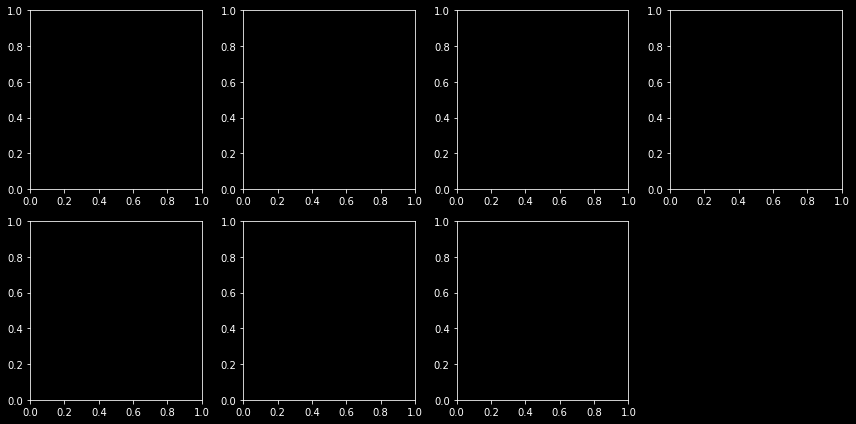

*****['efem_para25']


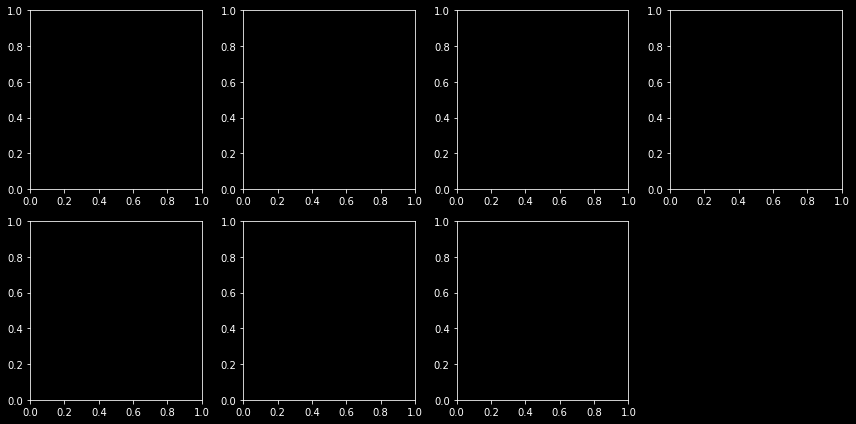

*****['efem_para78']


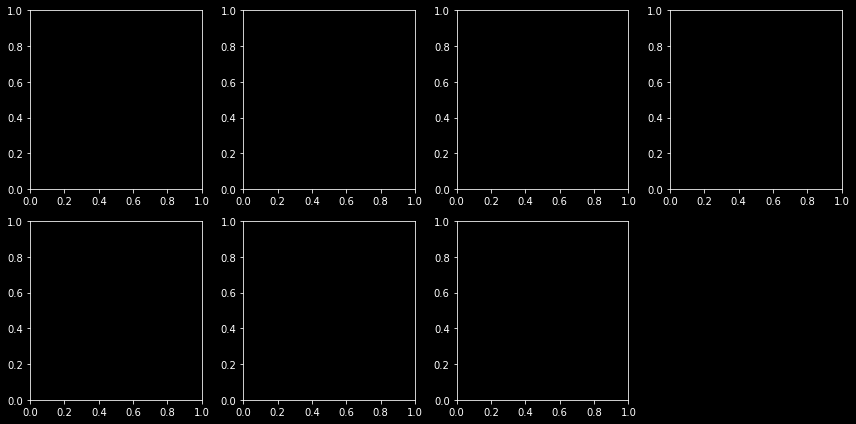

*****['epd_para4']


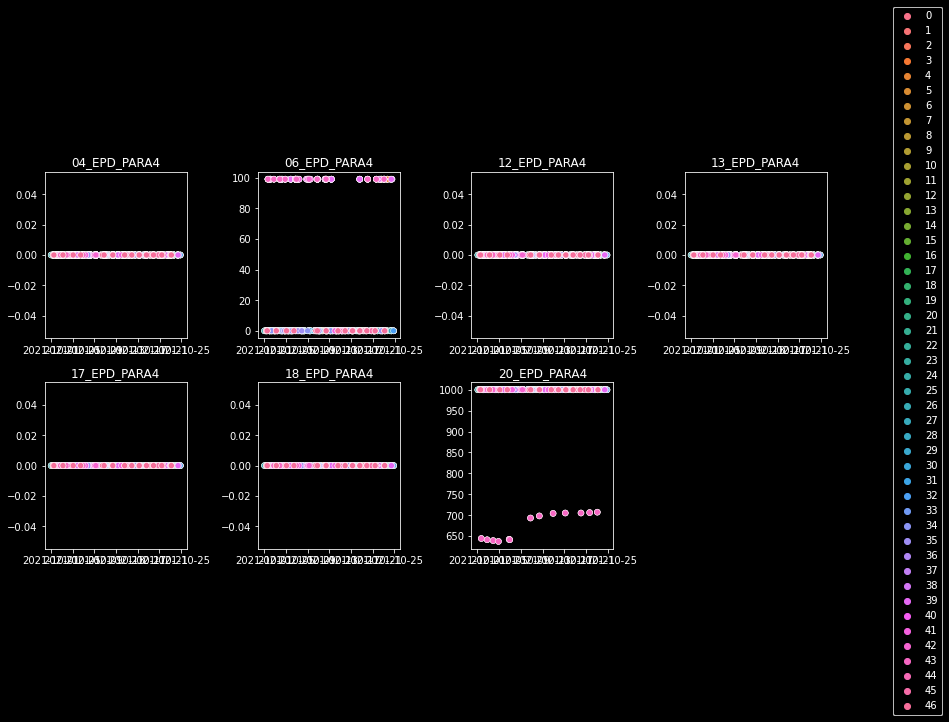

*****['epd_para40']


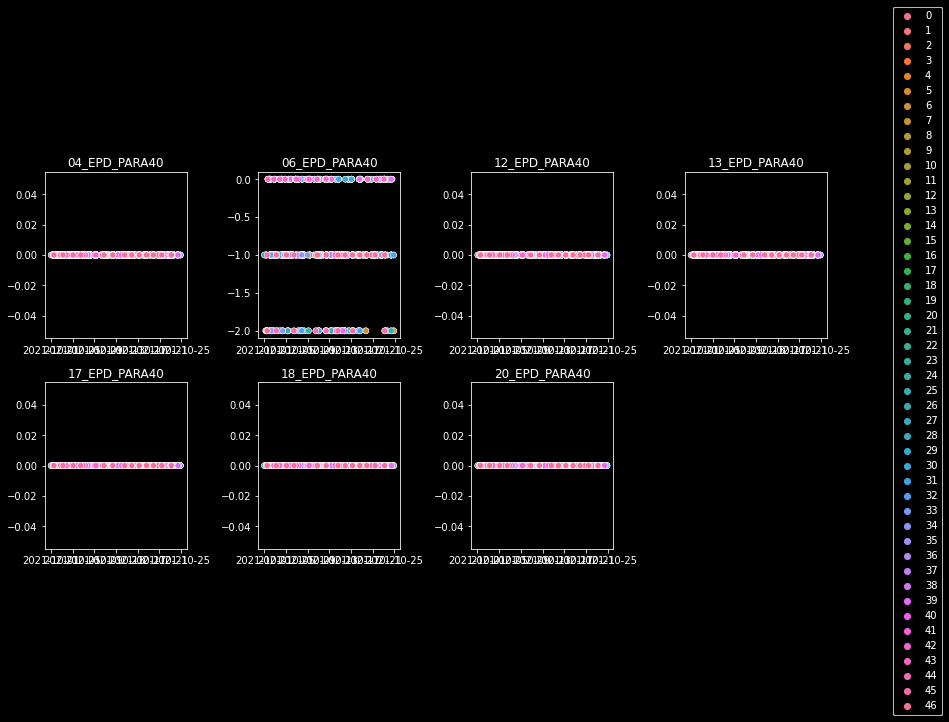

*****['epd_para63']


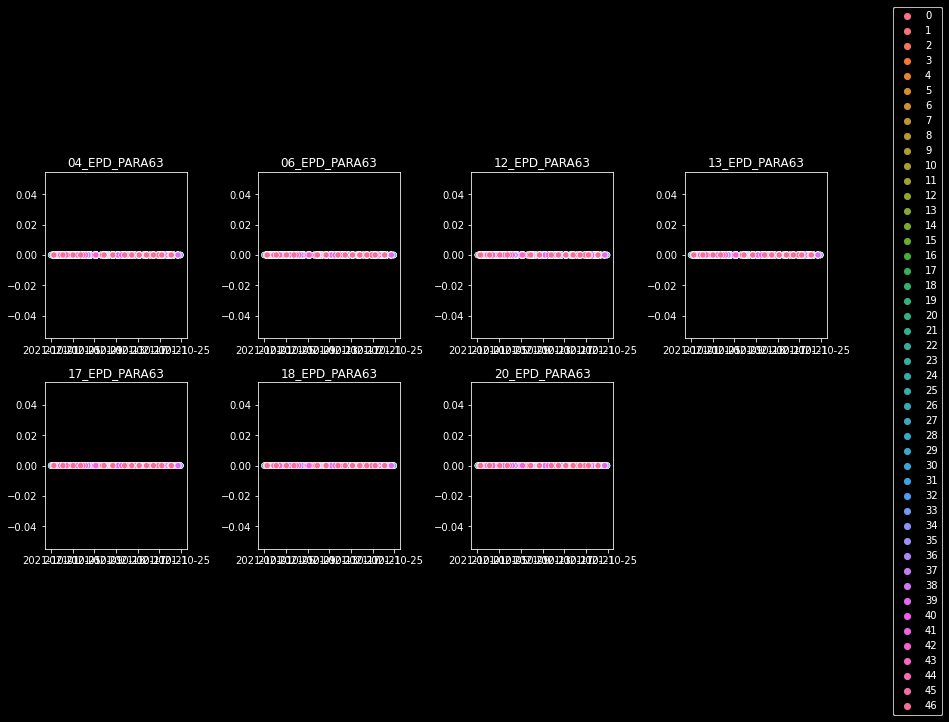

*****['epd_para80']


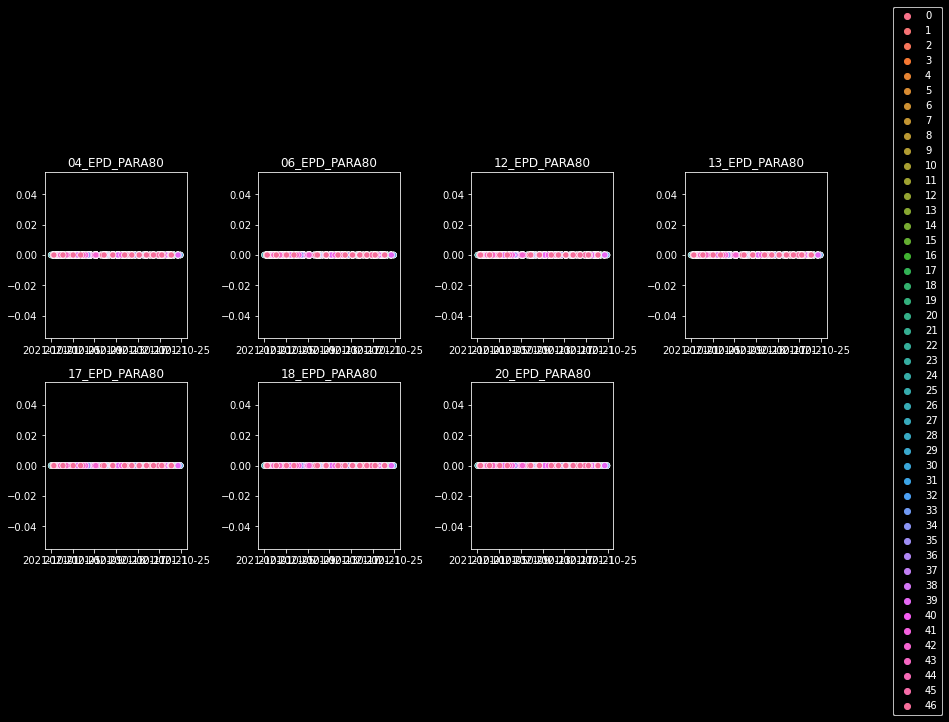

*****['esc_para84']


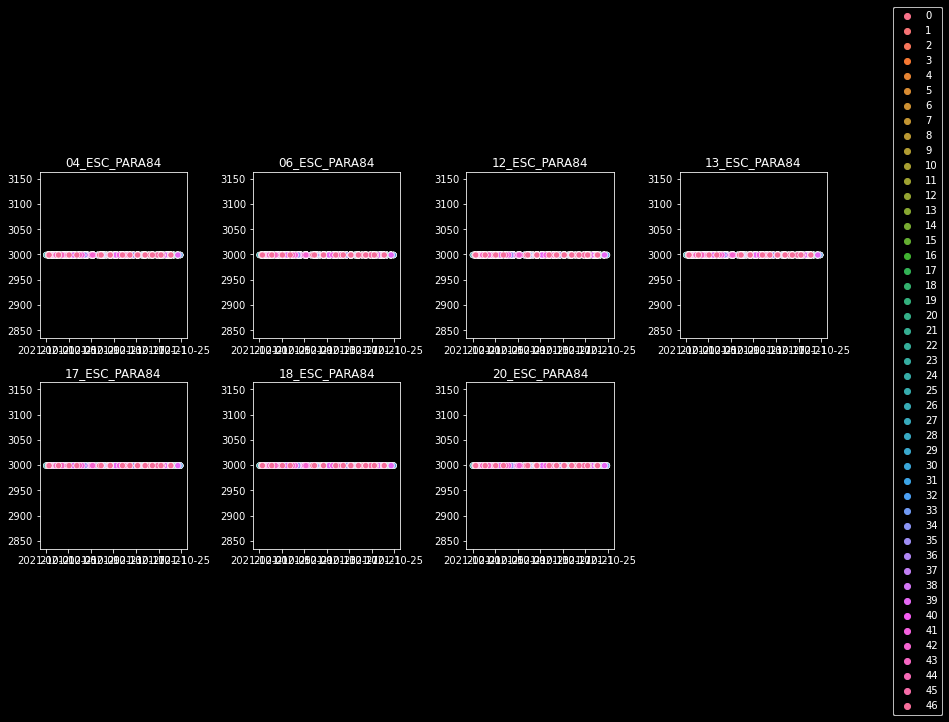

*****['esc_para94']


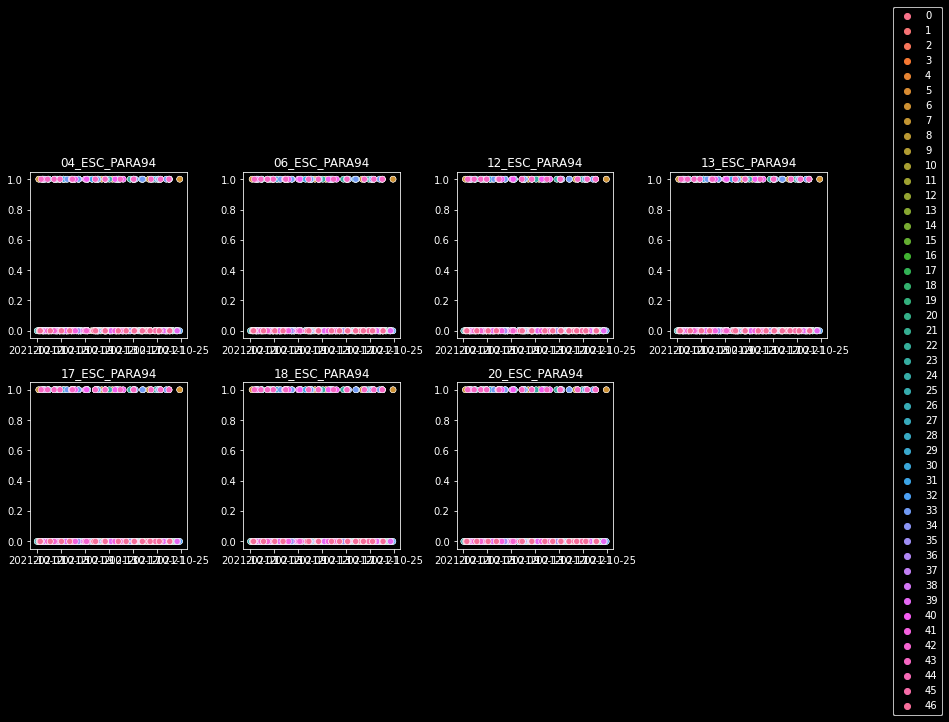

*****['fr_para28']


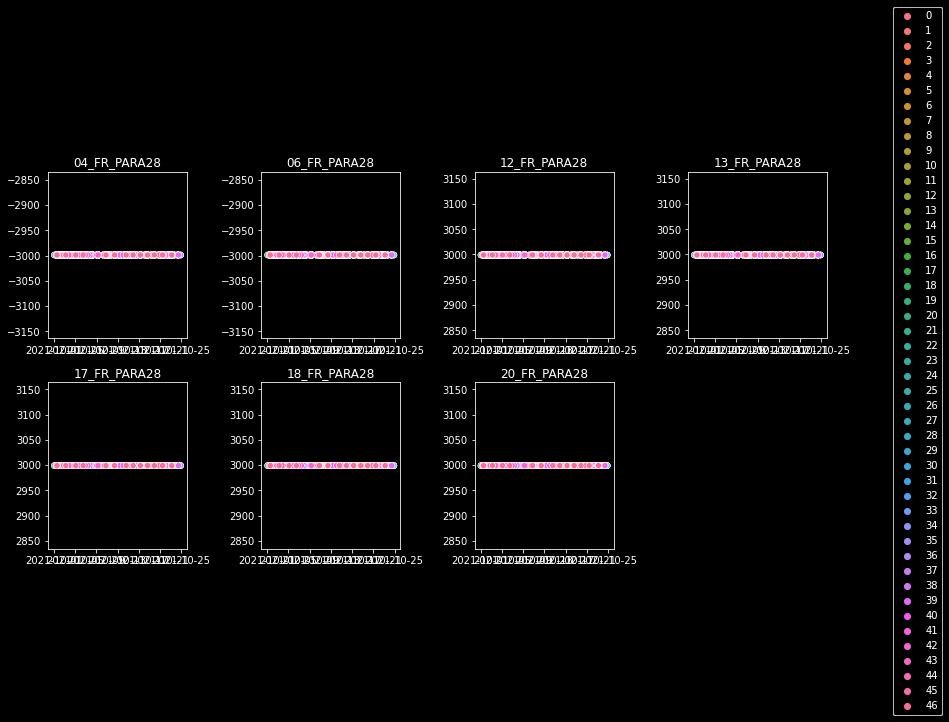

*****['fr_para35']


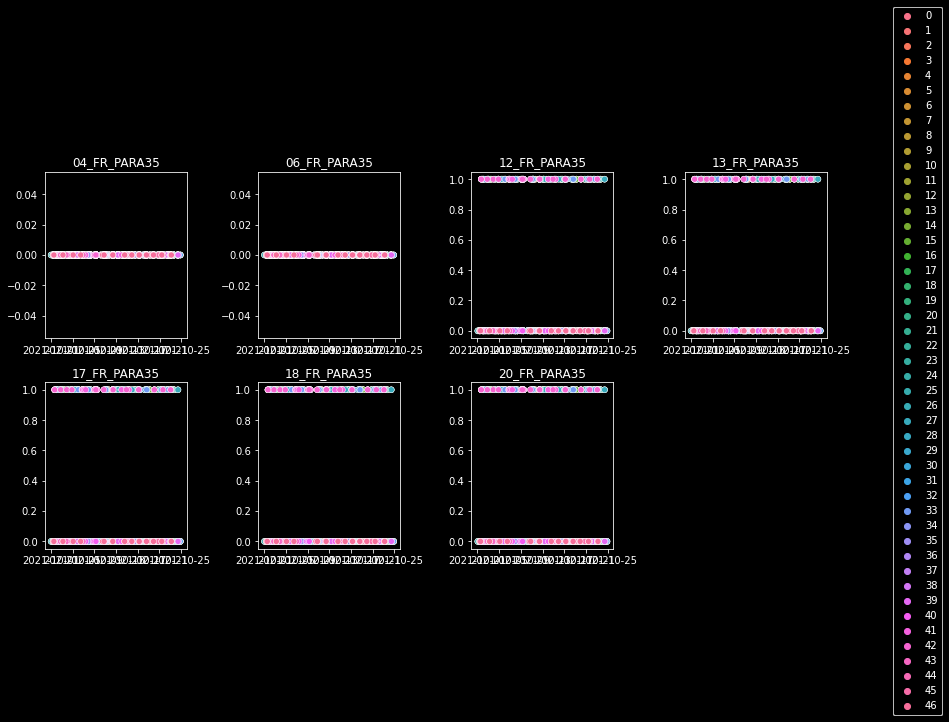

*****['fr_para61']


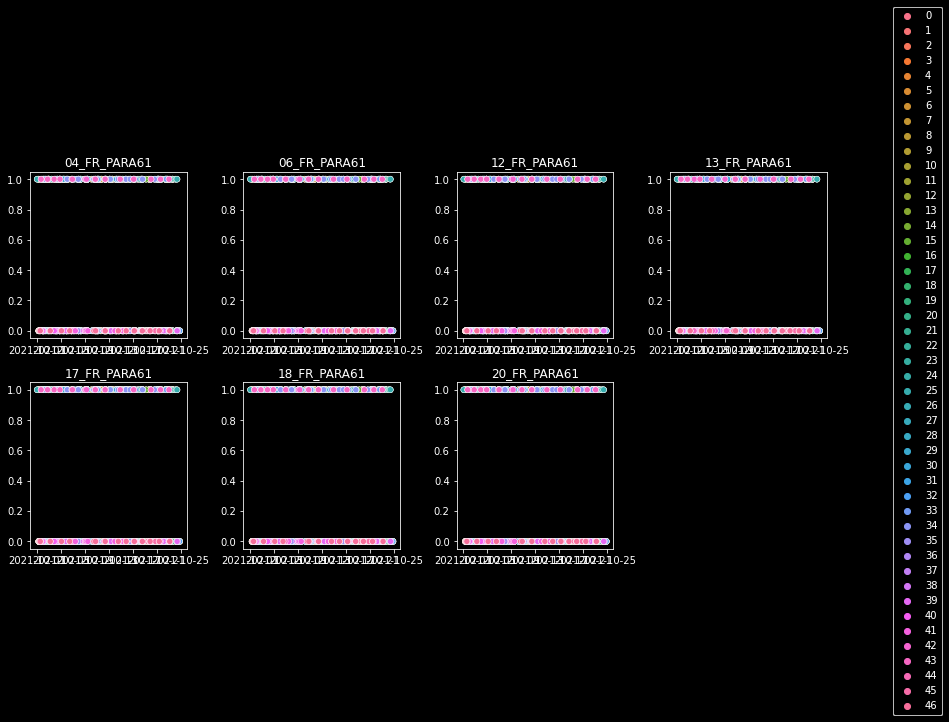

*****['fr_para69']


KeyboardInterrupt: 

In [92]:
for ix, sensor_nm in enumerate(sensors_nm):
    print(f'*****{[sensor_nm]}')

    # tmp_lst 는 {스텝}_{센서명} 형식으로 센서의 총 7개의 스텝 컬럼 리스트를 생성합니다.
    # ex. 04_efem_para2, 06_efem_para2, ..., 20_efem_para2
    tmp_lst = list(map(lambda x: f'{x}_{sensor_nm}', lst_steps))
    scatters(tmp_lst, df_train)

In [94]:
df_trains[2][num_features_lst[2]]

04_gas_para51  04_hv_para45  04_hv_para47  04_power_para76  \
29           12.0         300.0         150.0           1067.0   
30           12.0         300.0         150.0           1067.0   
31           12.0         300.0         150.0           1067.0   
32           12.0         300.0         150.0           1078.0   
33           12.0         300.0         150.0           1077.0   
34           12.0         300.0         150.0           1075.0   
35           12.0         300.0         150.0           1077.0   
36           12.0         300.0         150.0           1077.0   
37           12.0         300.0         150.0           1073.0   
38           12.0         300.0         150.0           1073.0   
39            8.0           0.0           0.0           1091.0   
40            8.0           0.0           0.0           1089.0   

    04_temp_para20  04_temp_para38  04_temp_para54  04_temp_para60  \
29            31.0            -9.0            47.0            43.0   
30            30.0            -9.0            45.0            42.0   
31            31.0            -9.0            44.0            42.0   
32            30.0            -9.0            42.0            44.0   
33            30.0           -10.0            45.0            44.0   
34            30.0            -9.0            43.0            45.0   
35            31.0           -10.0            46.0            44.0   
36            30.0           -10.0            47.0            44.0   
37            30.0            -9.0            44.0            44.0   
38            30.0            -9.0            46.0            44.0   
39            30.0            -9.0            46.0            44.0   
40            30.0            -9.0            42.0            44.0   

    04_time_para16  04_time_para29  04_time_para34  04_time_para37  \
29          2496.0          1039.0          2496.0           450.0   
30          2553.0          1095.0          2553.0           507.0   
31          2608.0          1151.0          2608.0           562.0   
32          2653.0          1195.0            22.0           607.0   
33          2664.0          1206.0            33.0           618.0   
34          2732.0          1275.0           101.0           687.0   
35          2746.0          1289.0           115.0           700.0   
36          2771.0          1314.0           140.0           725.0   
37          2830.0          1372.0           199.0           784.0   
38          2831.0          1374.0           201.0           786.0   
39          2855.0          1398.0           224.0           810.0   
40          2892.0          1435.0           261.0           847.0   

    04_time_para41  06_epd_para4  06_epd_para40  06_gas_para36  \
29           450.0           0.0           -1.0            4.0   
30           507.0           0.0           -1.0            4.0   
31           562.0           0.0           -1.0            4.0   
32            22.0           0.0           -1.0            3.0   
33            33.0           0.0           -1.0            3.0   
34           101.0           0.0           -1.0            3.0   
35           115.0           0.0           -1.0            3.0   
36           140.0           0.0           -1.0            3.0   
37           199.0           0.0           -1.0            3.0   
38           201.0           0.0           -1.0            3.0   
39           224.0          99.0           -0.0            3.0   
40           261.0          99.0           -0.0            3.0   

    06_power_para49  06_power_para57  06_power_para76  06_temp_para20  \
29              0.0           2000.0           1530.0            28.0   
30              0.0           2000.0           1530.0            28.0   
31              0.0           2000.0           1529.0            28.0   
32              0.0           2000.0           1548.0            30.0   
33              0.0           2000.0           1547.0            30.0   
34              0.0       

In [ ]:
# save
with open('ens.p', 'wb') as f:
    pickle.dump(ens, f)
    
with open('en_scores.p', 'wb') as f:
    pickle.dump(en_scores, f)

# Lasso

In [18]:
from sklearn.linear_model import Lasso

In [72]:
lss = []
ls_scores = []
for i, (train, num_f) in enumerate(zip(df_trains, num_features_lst)):
    def objective_LS(trial):
        param = {
          "random_state":42,
            'alpha':trial.suggest_float("alpha",0.1,20),
            'fit_intercept':trial.suggest_categorical('fit_intercept', [True, False]),
            'normalize':trial.suggest_categorical('normalize', [True, False]),
        }
        X = train[num_f]
        y = train['y']

        model = Lasso(**param)
        loo = LeaveOneOut()
        scores = cross_val_score(model, X, y, cv=loo, scoring='neg_mean_squared_error')
        scores = np.sqrt(-scores)
        print(f'CV scores for {i}: {scores}')
        print('Mean score : ', np.mean(scores))
        rmsle_val = np.mean(scores)

        return rmsle_val
    
    sampler = TPESampler(seed=42)
    study_ls = optuna.create_study(
            study_name="ls_parameter_opt",
            direction="minimize",
            sampler=sampler,
            )
    study_ls.optimize(objective_LS, n_trials=30)
    print("Best Score:", study_ls.best_value)
    print("Best trial:", study_ls.best_trial.params)
    ls_scores.append(study_ls.best_value)
    
    model = ElasticNet(**study_ls.best_params)
    model.fit(train[num_f], train['y'])
    print('{} model training is completed'.format(i))
    lss.append(model)


[I 2022-07-22 14:01:44,398] A new study created in memory with name: ls_parameter_opt
[I 2022-07-22 14:01:44,534] Trial 0 finished with value: 4.936722051282056 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.936722051282056.
[I 2022-07-22 14:01:44,668] Trial 1 finished with value: 6.07739633331791 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 4.936722051282056.


CV scores for 0: [ 3.55739     3.79593     8.94254333  3.72405     0.26752333  3.23078667
  1.44254     4.47921     1.13072333  9.89081667 10.28740333 11.07584333
  2.35262667]
Mean score :  4.936722051282056
CV scores for 0: [ 7.33256208  0.10300785  9.50496642  5.74556151  0.76712424  1.63695182
  3.38079236  6.75991603  1.12195033 10.31727722 16.44416405 12.81743065
  3.07444776]
Mean score :  6.07739633331791


[I 2022-07-22 14:01:44,768] Trial 2 finished with value: 7.8427632022455604 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.936722051282056.
[I 2022-07-22 14:01:44,882] Trial 3 finished with value: 6.031157457641729 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 4.936722051282056.
[I 2022-07-22 14:01:44,978] Trial 4 finished with value: 5.894086464671475 and parameters: {'alpha': 12.27587260497535, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 4.936722051282056.


CV scores for 0: [ 6.98518145  6.33960317  9.99613303  3.80824692  0.0842212  25.26923745
  0.65857877  4.76723911  0.67451555 11.93522129 15.64999772 14.8621339
  0.92561207]
Mean score :  7.8427632022455604
CV scores for 0: [ 7.30931276  0.08446924  9.44103351  5.74069025  0.76479126  1.6412095
  3.37664588  6.74769515  1.09645071 10.33220134 16.29458816 12.50737753
  3.06858164]
Mean score :  6.031157457641729
CV scores for 0: [ 6.98324397  0.15050494  9.59054203  5.66992556  0.72088606  1.70299012
  3.28727671  6.56571247  0.78500343 10.39206488 15.0284924  12.5418605
  3.20462098]
Mean score :  5.894086464671475


[I 2022-07-22 14:01:45,073] Trial 5 finished with value: 5.872845170819626 and parameters: {'alpha': 15.72500163172097, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 4.936722051282056.
[I 2022-07-22 14:01:45,181] Trial 6 finished with value: 6.052886806975021 and parameters: {'alpha': 12.190142552838623, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 4.936722051282056.


CV scores for 0: [ 6.84398199  0.24407162  9.64608866  5.63972678  0.70280031  1.72561855
  3.25097617  6.49981676  0.67158795 10.39682141 14.95542699 12.50487625
  3.26519379]
Mean score :  5.872845170819626
CV scores for 0: [ 7.78302736  2.48051834  8.58299453  4.89897831  0.143355    2.3602238
  2.00785497  7.33235702  2.29434259  9.29365411 15.76345433 13.62402479
  2.12274333]
Mean score :  6.052886806975021


[I 2022-07-22 14:01:45,273] Trial 7 finished with value: 4.936722051282056 and parameters: {'alpha': 16.187107227517576, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.936722051282056.
[I 2022-07-22 14:01:45,367] Trial 8 finished with value: 4.936722051282056 and parameters: {'alpha': 2.5285608734110987, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.936722051282056.
[I 2022-07-22 14:01:45,463] Trial 9 finished with value: 5.886709343220271 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 4.936722051282056.


CV scores for 0: [ 3.55739     3.79593     8.94254333  3.72405     0.26752333  3.23078667
  1.44254     4.47921     1.13072333  9.89081667 10.28740333 11.07584333
  2.35262667]
Mean score :  4.936722051282056
CV scores for 0: [ 3.55739     3.79593     8.94254333  3.72405     0.26752333  3.23078667
  1.44254     4.47921     1.13072333  9.89081667 10.28740333 11.07584333
  2.35262667]
Mean score :  4.936722051282056
CV scores for 0: [ 6.94100193  0.17925898  9.6095516   5.661055    0.71515153  1.70774831
  3.27736327  6.54198196  0.74874833 10.39171982 14.99754153 12.5316979
  3.2244013 ]
Mean score :  5.886709343220271


[I 2022-07-22 14:01:45,614] Trial 10 finished with value: 6.371724370583793 and parameters: {'alpha': 7.552084938387593, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 4.936722051282056.
[I 2022-07-22 14:01:45,715] Trial 11 finished with value: 4.936722051282056 and parameters: {'alpha': 18.652577804044576, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.936722051282056.
[I 2022-07-22 14:01:45,810] Trial 12 finished with value: 4.936722051282056 and parameters: {'alpha': 8.308688438735956, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.936722051282056.


CV scores for 0: [ 7.81345906  4.44470523  8.51083325  4.95187975  0.13744955  2.59347847
  1.48726381  8.07808846  3.05396484  9.75536151 15.84259295 13.75032129
  2.41301864]
Mean score :  6.371724370583793
CV scores for 0: [ 3.55739     3.79593     8.94254333  3.72405     0.26752333  3.23078667
  1.44254     4.47921     1.13072333  9.89081667 10.28740333 11.07584333
  2.35262667]
Mean score :  4.936722051282056
CV scores for 0: [ 3.55739     3.79593     8.94254333  3.72405     0.26752333  3.23078667
  1.44254     4.47921     1.13072333  9.89081667 10.28740333 11.07584333
  2.35262667]
Mean score :  4.936722051282056


[I 2022-07-22 14:01:45,909] Trial 13 finished with value: 4.936722051282056 and parameters: {'alpha': 19.90484090811808, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.936722051282056.
[I 2022-07-22 14:01:46,006] Trial 14 finished with value: 4.936722051282056 and parameters: {'alpha': 6.42631156268094, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.936722051282056.
[I 2022-07-22 14:01:46,102] Trial 15 finished with value: 4.936722051282056 and parameters: {'alpha': 15.742887940172224, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.936722051282056.


CV scores for 0: [ 3.55739     3.79593     8.94254333  3.72405     0.26752333  3.23078667
  1.44254     4.47921     1.13072333  9.89081667 10.28740333 11.07584333
  2.35262667]
Mean score :  4.936722051282056
CV scores for 0: [ 3.55739     3.79593     8.94254333  3.72405     0.26752333  3.23078667
  1.44254     4.47921     1.13072333  9.89081667 10.28740333 11.07584333
  2.35262667]
Mean score :  4.936722051282056
CV scores for 0: [ 3.55739     3.79593     8.94254333  3.72405     0.26752333  3.23078667
  1.44254     4.47921     1.13072333  9.89081667 10.28740333 11.07584333
  2.35262667]
Mean score :  4.936722051282056


[I 2022-07-22 14:01:46,198] Trial 16 finished with value: 4.936722051282056 and parameters: {'alpha': 10.60463692610143, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.936722051282056.
[I 2022-07-22 14:01:46,295] Trial 17 finished with value: 4.936722051282056 and parameters: {'alpha': 6.503166834245272, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.936722051282056.


CV scores for 0: [ 3.55739     3.79593     8.94254333  3.72405     0.26752333  3.23078667
  1.44254     4.47921     1.13072333  9.89081667 10.28740333 11.07584333
  2.35262667]
Mean score :  4.936722051282056
CV scores for 0: [ 3.55739     3.79593     8.94254333  3.72405     0.26752333  3.23078667
  1.44254     4.47921     1.13072333  9.89081667 10.28740333 11.07584333
  2.35262667]
Mean score :  4.936722051282056


[I 2022-07-22 14:01:46,415] Trial 18 finished with value: 6.0662392556006965 and parameters: {'alpha': 15.11150312929761, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 4.936722051282056.
[I 2022-07-22 14:01:46,508] Trial 19 finished with value: 4.936722051282056 and parameters: {'alpha': 10.015536319955839, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.936722051282056.
[I 2022-07-22 14:01:46,602] Trial 20 finished with value: 4.936722051282056 and parameters: {'alpha': 5.600135556759093, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.936722051282056.


CV scores for 0: [ 7.94273821  2.60446581  8.62838351  4.83363572  0.12791922  2.4103036
  1.98599887  6.99225925  2.0816458   9.56669698 15.7990191  13.7404664
  2.14757785]
Mean score :  6.0662392556006965
CV scores for 0: [ 3.55739     3.79593     8.94254333  3.72405     0.26752333  3.23078667
  1.44254     4.47921     1.13072333  9.89081667 10.28740333 11.07584333
  2.35262667]
Mean score :  4.936722051282056
CV scores for 0: [ 3.55739     3.79593     8.94254333  3.72405     0.26752333  3.23078667
  1.44254     4.47921     1.13072333  9.89081667 10.28740333 11.07584333
  2.35262667]
Mean score :  4.936722051282056


[I 2022-07-22 14:01:46,696] Trial 21 finished with value: 4.936722051282056 and parameters: {'alpha': 9.321669978165565, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.936722051282056.
[I 2022-07-22 14:01:46,793] Trial 22 finished with value: 4.936722051282056 and parameters: {'alpha': 5.59089200276686, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.936722051282056.
[I 2022-07-22 14:01:46,892] Trial 23 finished with value: 4.936722051282056 and parameters: {'alpha': 5.022192885926878, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.936722051282056.


CV scores for 0: [ 3.55739     3.79593     8.94254333  3.72405     0.26752333  3.23078667
  1.44254     4.47921     1.13072333  9.89081667 10.28740333 11.07584333
  2.35262667]
Mean score :  4.936722051282056
CV scores for 0: [ 3.55739     3.79593     8.94254333  3.72405     0.26752333  3.23078667
  1.44254     4.47921     1.13072333  9.89081667 10.28740333 11.07584333
  2.35262667]
Mean score :  4.936722051282056
CV scores for 0: [ 3.55739     3.79593     8.94254333  3.72405     0.26752333  3.23078667
  1.44254     4.47921     1.13072333  9.89081667 10.28740333 11.07584333
  2.35262667]
Mean score :  4.936722051282056


[I 2022-07-22 14:01:46,988] Trial 24 finished with value: 4.936722051282056 and parameters: {'alpha': 8.943816632847193, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.936722051282056.
[I 2022-07-22 14:01:47,085] Trial 25 finished with value: 4.936722051282056 and parameters: {'alpha': 9.951829913556244, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.936722051282056.


CV scores for 0: [ 3.55739     3.79593     8.94254333  3.72405     0.26752333  3.23078667
  1.44254     4.47921     1.13072333  9.89081667 10.28740333 11.07584333
  2.35262667]
Mean score :  4.936722051282056
CV scores for 0: [ 3.55739     3.79593     8.94254333  3.72405     0.26752333  3.23078667
  1.44254     4.47921     1.13072333  9.89081667 10.28740333 11.07584333
  2.35262667]
Mean score :  4.936722051282056


[I 2022-07-22 14:01:47,195] Trial 26 finished with value: 6.004140699910033 and parameters: {'alpha': 4.740165180038494, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 4.936722051282056.
[I 2022-07-22 14:01:47,291] Trial 27 finished with value: 4.936722051282056 and parameters: {'alpha': 7.868840225462657, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.936722051282056.
[I 2022-07-22 14:01:47,385] Trial 28 finished with value: 4.936722051282056 and parameters: {'alpha': 11.09788365414248, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.936722051282056.


CV scores for 0: [ 7.26133238  0.05510422  9.44217978  5.73090549  0.75834584  1.64715537
  3.36277829  6.72492873  1.05843268 10.37416164 16.02467874 12.52424895
  3.089577  ]
Mean score :  6.004140699910033
CV scores for 0: [ 3.55739     3.79593     8.94254333  3.72405     0.26752333  3.23078667
  1.44254     4.47921     1.13072333  9.89081667 10.28740333 11.07584333
  2.35262667]
Mean score :  4.936722051282056
CV scores for 0: [ 3.55739     3.79593     8.94254333  3.72405     0.26752333  3.23078667
  1.44254     4.47921     1.13072333  9.89081667 10.28740333 11.07584333
  2.35262667]
Mean score :  4.936722051282056


[I 2022-07-22 14:01:47,486] Trial 29 finished with value: 5.91384306441929 and parameters: {'alpha': 9.009315393494543, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 4.936722051282056.
[I 2022-07-22 14:01:47,492] A new study created in memory with name: ls_parameter_opt
[I 2022-07-22 14:01:47,615] Trial 0 finished with value: 4.462187333333333 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.462187333333333.


CV scores for 0: [ 7.09996388  0.06263757  9.52442306  5.69663587  0.73625566  1.67926776
  3.31898061  6.63363178  0.90083248 10.40065228 15.09331635 12.57270762
  3.1606549 ]
Mean score :  5.91384306441929
Best Score: 4.936722051282056
Best trial: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}
0 model training is completed
CV scores for 1: [ 1.80216     9.87229333  3.386832    2.103632   10.80101867  8.24469867
  3.80364267  1.647792    9.911984    1.77254933  3.88906133  2.432176
  0.394032    2.73088533  6.76122133  1.84101867]
Mean score :  4.462187333333333


[I 2022-07-22 14:01:47,870] Trial 1 finished with value: 5.139782524935484 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 4.462187333333333.
[I 2022-07-22 14:01:47,997] Trial 2 finished with value: 4.990452906787326 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.462187333333333.


CV scores for 1: [4.73466118 5.64706135 1.85211656 6.44292516 6.24695083 4.41695882
 9.09936417 2.01979635 6.58849974 0.65745026 4.92345085 3.94378335
 3.285158   5.71868058 8.38816099 8.27150223]
Mean score :  5.139782524935484
CV scores for 1: [ 5.89792341  9.6333778   3.7731279   0.20734734 12.37727228  8.02002609
 10.1203754   0.5121111   9.07400648  2.4780124   4.84570214  0.39962328
  1.77852403  2.43899999  6.25080122  2.04001563]
Mean score :  4.990452906787326


[I 2022-07-22 14:01:48,181] Trial 3 finished with value: 5.090329733074157 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 4.462187333333333.
[I 2022-07-22 14:01:48,300] Trial 4 finished with value: 4.815344449724151 and parameters: {'alpha': 12.27587260497535, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 4.462187333333333.


CV scores for 1: [4.84174746 5.63995818 1.53116584 6.19992045 6.41344913 4.80329893
 9.07161698 2.24641    6.60024463 0.89680365 4.95853955 4.01263199
 2.69167595 5.19806408 8.30408891 8.03565999]
Mean score :  5.090329733074157
CV scores for 1: [5.15714103 5.31821571 1.42830687 5.47764333 6.6035838  4.89464828
 8.73746536 2.01990337 6.72422097 1.0049897  5.13633536 3.73342051
 2.50062391 2.94797237 7.71984038 7.64120025]
Mean score :  4.815344449724151


[I 2022-07-22 14:01:48,416] Trial 5 finished with value: 4.765188465242574 and parameters: {'alpha': 15.72500163172097, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 4.462187333333333.


CV scores for 1: [5.15005056 5.24691131 1.44914692 5.37706635 6.6142997  4.87683097
 8.62334473 1.94669519 6.72626362 1.01751598 5.17549031 3.66052059
 2.60868847 2.68579325 7.61078813 7.47360937]
Mean score :  4.765188465242574


[I 2022-07-22 14:01:48,690] Trial 6 finished with value: 4.689021425810907 and parameters: {'alpha': 12.190142552838623, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 4.462187333333333.
[I 2022-07-22 14:01:48,805] Trial 7 finished with value: 4.462187333333333 and parameters: {'alpha': 16.187107227517576, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.462187333333333.


CV scores for 1: [6.79248795 7.00226555 1.4304258  4.71482343 5.79257963 5.15401213
 8.65573066 1.97867574 7.45680133 0.56775065 5.93851303 1.17194914
 0.39506339 3.63014922 7.14580981 7.19730535]
Mean score :  4.689021425810907
CV scores for 1: [ 1.80216     9.87229333  3.386832    2.103632   10.80101867  8.24469867
  3.80364267  1.647792    9.911984    1.77254933  3.88906133  2.432176
  0.394032    2.73088533  6.76122133  1.84101867]
Mean score :  4.462187333333333


[I 2022-07-22 14:01:48,921] Trial 8 finished with value: 4.462187333333333 and parameters: {'alpha': 2.5285608734110987, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.462187333333333.
[I 2022-07-22 14:01:49,040] Trial 9 finished with value: 4.79963776509382 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 4.462187333333333.


CV scores for 1: [ 1.80216     9.87229333  3.386832    2.103632   10.80101867  8.24469867
  3.80364267  1.647792    9.911984    1.77254933  3.88906133  2.432176
  0.394032    2.73088533  6.76122133  1.84101867]
Mean score :  4.462187333333333
CV scores for 1: [5.15482858 5.29032893 1.43448226 5.44858113 6.60570923 4.89029853
 8.70243859 1.99454397 6.73182172 1.00927241 5.15902652 3.70013371
 2.54431891 2.85649939 7.68986122 7.58205912]
Mean score :  4.79963776509382


[I 2022-07-22 14:01:49,309] Trial 10 finished with value: 4.764538633435421 and parameters: {'alpha': 7.552084938387593, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 4.462187333333333.
[I 2022-07-22 14:01:49,427] Trial 11 finished with value: 4.462187333333333 and parameters: {'alpha': 18.652577804044576, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.462187333333333.


CV scores for 1: [6.61619316 7.08270695 1.40386719 5.36517577 5.61347756 5.10781527
 8.77771302 2.07366178 7.39481839 0.5598183  5.87327083 1.26739299
 0.64871349 3.89779502 7.25907471 7.2911237 ]
Mean score :  4.764538633435421
CV scores for 1: [ 1.80216     9.87229333  3.386832    2.103632   10.80101867  8.24469867
  3.80364267  1.647792    9.911984    1.77254933  3.88906133  2.432176
  0.394032    2.73088533  6.76122133  1.84101867]
Mean score :  4.462187333333333


[I 2022-07-22 14:01:49,554] Trial 12 finished with value: 4.462187333333333 and parameters: {'alpha': 8.308688438735956, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.462187333333333.
[I 2022-07-22 14:01:49,683] Trial 13 finished with value: 4.462187333333333 and parameters: {'alpha': 19.90484090811808, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.462187333333333.


CV scores for 1: [ 1.80216     9.87229333  3.386832    2.103632   10.80101867  8.24469867
  3.80364267  1.647792    9.911984    1.77254933  3.88906133  2.432176
  0.394032    2.73088533  6.76122133  1.84101867]
Mean score :  4.462187333333333
CV scores for 1: [ 1.80216     9.87229333  3.386832    2.103632   10.80101867  8.24469867
  3.80364267  1.647792    9.911984    1.77254933  3.88906133  2.432176
  0.394032    2.73088533  6.76122133  1.84101867]
Mean score :  4.462187333333333


[I 2022-07-22 14:01:49,806] Trial 14 finished with value: 4.462187333333333 and parameters: {'alpha': 6.42631156268094, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.462187333333333.
[I 2022-07-22 14:01:49,932] Trial 15 finished with value: 4.462187333333333 and parameters: {'alpha': 15.742887940172224, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.462187333333333.


CV scores for 1: [ 1.80216     9.87229333  3.386832    2.103632   10.80101867  8.24469867
  3.80364267  1.647792    9.911984    1.77254933  3.88906133  2.432176
  0.394032    2.73088533  6.76122133  1.84101867]
Mean score :  4.462187333333333
CV scores for 1: [ 1.80216     9.87229333  3.386832    2.103632   10.80101867  8.24469867
  3.80364267  1.647792    9.911984    1.77254933  3.88906133  2.432176
  0.394032    2.73088533  6.76122133  1.84101867]
Mean score :  4.462187333333333


[I 2022-07-22 14:01:50,056] Trial 16 finished with value: 4.462187333333333 and parameters: {'alpha': 10.60463692610143, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.462187333333333.
[I 2022-07-22 14:01:50,183] Trial 17 finished with value: 4.462187333333333 and parameters: {'alpha': 6.503166834245272, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.462187333333333.


CV scores for 1: [ 1.80216     9.87229333  3.386832    2.103632   10.80101867  8.24469867
  3.80364267  1.647792    9.911984    1.77254933  3.88906133  2.432176
  0.394032    2.73088533  6.76122133  1.84101867]
Mean score :  4.462187333333333
CV scores for 1: [ 1.80216     9.87229333  3.386832    2.103632   10.80101867  8.24469867
  3.80364267  1.647792    9.911984    1.77254933  3.88906133  2.432176
  0.394032    2.73088533  6.76122133  1.84101867]
Mean score :  4.462187333333333


[I 2022-07-22 14:01:50,476] Trial 18 finished with value: 4.66890145338715 and parameters: {'alpha': 15.11150312929761, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 4.462187333333333.
[I 2022-07-22 14:01:50,594] Trial 19 finished with value: 4.462187333333333 and parameters: {'alpha': 10.015536319955839, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.462187333333333.


CV scores for 1: [6.90353083 6.9515903  1.44715433 4.64663972 5.90537846 5.28073328
 8.57892464 1.91884724 7.49584355 0.57274698 5.97960718 1.11183218
 0.2352975  3.46156789 7.07446792 7.13826126]
Mean score :  4.66890145338715
CV scores for 1: [ 1.80216     9.87229333  3.386832    2.103632   10.80101867  8.24469867
  3.80364267  1.647792    9.911984    1.77254933  3.88906133  2.432176
  0.394032    2.73088533  6.76122133  1.84101867]
Mean score :  4.462187333333333


[I 2022-07-22 14:01:50,713] Trial 20 finished with value: 4.462187333333333 and parameters: {'alpha': 5.600135556759093, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.462187333333333.
[I 2022-07-22 14:01:50,833] Trial 21 finished with value: 4.462187333333333 and parameters: {'alpha': 9.321669978165565, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.462187333333333.


CV scores for 1: [ 1.80216     9.87229333  3.386832    2.103632   10.80101867  8.24469867
  3.80364267  1.647792    9.911984    1.77254933  3.88906133  2.432176
  0.394032    2.73088533  6.76122133  1.84101867]
Mean score :  4.462187333333333
CV scores for 1: [ 1.80216     9.87229333  3.386832    2.103632   10.80101867  8.24469867
  3.80364267  1.647792    9.911984    1.77254933  3.88906133  2.432176
  0.394032    2.73088533  6.76122133  1.84101867]
Mean score :  4.462187333333333


[I 2022-07-22 14:01:50,954] Trial 22 finished with value: 4.462187333333333 and parameters: {'alpha': 5.59089200276686, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.462187333333333.
[I 2022-07-22 14:01:51,078] Trial 23 finished with value: 4.462187333333333 and parameters: {'alpha': 5.022192885926878, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.462187333333333.


CV scores for 1: [ 1.80216     9.87229333  3.386832    2.103632   10.80101867  8.24469867
  3.80364267  1.647792    9.911984    1.77254933  3.88906133  2.432176
  0.394032    2.73088533  6.76122133  1.84101867]
Mean score :  4.462187333333333
CV scores for 1: [ 1.80216     9.87229333  3.386832    2.103632   10.80101867  8.24469867
  3.80364267  1.647792    9.911984    1.77254933  3.88906133  2.432176
  0.394032    2.73088533  6.76122133  1.84101867]
Mean score :  4.462187333333333


[I 2022-07-22 14:01:51,201] Trial 24 finished with value: 4.462187333333333 and parameters: {'alpha': 8.943816632847193, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.462187333333333.
[I 2022-07-22 14:01:51,324] Trial 25 finished with value: 4.462187333333333 and parameters: {'alpha': 9.951829913556244, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.462187333333333.


CV scores for 1: [ 1.80216     9.87229333  3.386832    2.103632   10.80101867  8.24469867
  3.80364267  1.647792    9.911984    1.77254933  3.88906133  2.432176
  0.394032    2.73088533  6.76122133  1.84101867]
Mean score :  4.462187333333333
CV scores for 1: [ 1.80216     9.87229333  3.386832    2.103632   10.80101867  8.24469867
  3.80364267  1.647792    9.911984    1.77254933  3.88906133  2.432176
  0.394032    2.73088533  6.76122133  1.84101867]
Mean score :  4.462187333333333


[I 2022-07-22 14:01:51,463] Trial 26 finished with value: 4.91275842295336 and parameters: {'alpha': 4.740165180038494, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 4.462187333333333.
[I 2022-07-22 14:01:51,592] Trial 27 finished with value: 4.462187333333333 and parameters: {'alpha': 7.868840225462657, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.462187333333333.


CV scores for 1: [5.01896911 5.54350206 1.39504988 5.72103545 6.54392921 4.86621501
 9.0220105  2.22762672 6.62181316 0.97324539 4.97929205 3.9815156
 2.00477631 3.73688897 7.98468824 7.98357711]
Mean score :  4.91275842295336
CV scores for 1: [ 1.80216     9.87229333  3.386832    2.103632   10.80101867  8.24469867
  3.80364267  1.647792    9.911984    1.77254933  3.88906133  2.432176
  0.394032    2.73088533  6.76122133  1.84101867]
Mean score :  4.462187333333333


[I 2022-07-22 14:01:51,717] Trial 28 finished with value: 4.462187333333333 and parameters: {'alpha': 11.09788365414248, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.462187333333333.
[I 2022-07-22 14:01:51,848] Trial 29 finished with value: 4.866502375437136 and parameters: {'alpha': 9.009315393494543, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 4.462187333333333.
[I 2022-07-22 14:01:51,856] A new study created in memory with name: ls_parameter_opt


CV scores for 1: [ 1.80216     9.87229333  3.386832    2.103632   10.80101867  8.24469867
  3.80364267  1.647792    9.911984    1.77254933  3.88906133  2.432176
  0.394032    2.73088533  6.76122133  1.84101867]
Mean score :  4.462187333333333
CV scores for 1: [5.16265415 5.4162175  1.41225402 5.58299382 6.59441317 4.91175231
 8.85446435 2.10547562 6.68947187 0.9907448  5.07387642 3.83534865
 2.33081767 3.23834238 7.87802267 7.78718861]
Mean score :  4.866502375437136
Best Score: 4.462187333333333
Best trial: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}
1 model training is completed


[I 2022-07-22 14:01:51,954] Trial 0 finished with value: 9.20881454545463 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 9.20881454545463.


CV scores for 2: [ 2.80312727  6.79083636  0.94343273 18.78734545  9.50296727 20.89818182
 26.82932364  5.70324364  3.57509818  7.52538182  5.19972364  1.94711273]
Mean score :  9.20881454545463


[I 2022-07-22 14:01:52,161] Trial 1 finished with value: 12.88723040241056 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 9.20881454545463.
[I 2022-07-22 14:01:52,254] Trial 2 finished with value: 8.753211284263026 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 8.753211284263026.


CV scores for 2: [15.01688548  1.1024066  17.96327901 16.89698358  9.72539836 15.20921431
 26.71790439 17.96521017 11.79133697 14.90374705  4.08104361  3.2733553 ]
Mean score :  12.88723040241056
CV scores for 2: [ 2.97240072  1.3639992   1.43941998 10.39182233 11.12835251 18.21681242
 24.20982607 13.65905471  4.80908218  9.26257371  0.97334432  6.61184726]
Mean score :  8.753211284263026


[I 2022-07-22 14:01:52,450] Trial 3 finished with value: 12.79817561646909 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 8.753211284263026.
[I 2022-07-22 14:01:52,639] Trial 4 finished with value: 11.808278862292411 and parameters: {'alpha': 12.27587260497535, 'fit_intercept': False, 'normalize': False}. Best is trial 2 with value: 8.753211284263026.


CV scores for 2: [13.79528182  0.43419894 16.31134667 17.5217446   9.9392227  16.18983815
 26.99813237 19.11149533 12.14237994 15.34773     3.30767112  2.47906575]
Mean score :  12.79817561646909
CV scores for 2: [6.68366360e+00 1.95280703e+00 4.87272576e+00 2.15094101e+01
 1.14652800e+01 2.10961404e+01 2.82434913e+01 1.91254463e+01
 1.53040984e+01 1.04157849e+01 1.02264987e+00 7.84867313e-03]
Mean score :  11.808278862292411


[I 2022-07-22 14:01:52,810] Trial 5 finished with value: 11.599306421165636 and parameters: {'alpha': 15.72500163172097, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 8.753211284263026.
[I 2022-07-22 14:01:52,989] Trial 6 finished with value: 11.440476991265902 and parameters: {'alpha': 12.190142552838623, 'fit_intercept': True, 'normalize': False}. Best is trial 2 with value: 8.753211284263026.


CV scores for 2: [ 6.77569151  2.7785726   4.0462321  21.39015282 11.34610987 21.22837483
 28.62066768 18.07368634 15.0898149   8.41353835  1.3683868   0.06044927]
Mean score :  11.599306421165636
CV scores for 2: [ 9.89931292  3.87753438  5.88927803 17.70949161 10.18407354 16.78639286
 23.82951544 13.73312828 13.67518321 11.6275222   4.74395777  5.33033364]
Mean score :  11.440476991265902


[I 2022-07-22 14:01:53,076] Trial 7 finished with value: 9.20881454545463 and parameters: {'alpha': 16.187107227517576, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 8.753211284263026.
[I 2022-07-22 14:01:53,163] Trial 8 finished with value: 9.016378409528366 and parameters: {'alpha': 2.5285608734110987, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 8.753211284263026.


CV scores for 2: [ 2.80312727  6.79083636  0.94343273 18.78734545  9.50296727 20.89818182
 26.82932364  5.70324364  3.57509818  7.52538182  5.19972364  1.94711273]
Mean score :  9.20881454545463
CV scores for 2: [ 2.19456863  6.6135088   1.34157792 18.21748631  8.43510264 20.98395988
 26.82932364  8.08459625  2.26703761  7.87379256  3.91877323  1.43681344]
Mean score :  9.016378409528366


[I 2022-07-22 14:01:53,346] Trial 9 finished with value: 11.749835493938463 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 8.753211284263026.


CV scores for 2: [6.71658128e+00 2.19387693e+00 4.63607468e+00 2.14705013e+01
 1.14332640e+01 2.11423812e+01 2.83850714e+01 1.88154018e+01
 1.52405341e+01 9.82959860e+00 1.12294297e+00 1.17975074e-02]
Mean score :  11.749835493938463


[I 2022-07-22 14:01:53,561] Trial 10 finished with value: 10.901789073693598 and parameters: {'alpha': 7.782458943709951, 'fit_intercept': True, 'normalize': False}. Best is trial 2 with value: 8.753211284263026.
[I 2022-07-22 14:01:53,666] Trial 11 finished with value: 8.497489816177355 and parameters: {'alpha': 0.3022689193204826, 'fit_intercept': True, 'normalize': True}. Best is trial 11 with value: 8.497489816177355.


CV scores for 2: [11.04093309  4.80848204  7.2763825  14.84115846 10.25478053 11.36741435
 19.90625158  3.76755246 18.70159687 14.54883674  6.96749046  7.3405898 ]
Mean score :  10.901789073693598
CV scores for 2: [ 2.65600055  1.09142633  0.74508621  7.08758001 11.55123977 16.61214806
 24.17011698 13.56228437  5.29133995  8.80787328  2.12188223  8.27290007]
Mean score :  8.497489816177355


[I 2022-07-22 14:01:53,767] Trial 12 finished with value: 8.619862692189733 and parameters: {'alpha': 0.3961794861106739, 'fit_intercept': True, 'normalize': True}. Best is trial 11 with value: 8.497489816177355.
[I 2022-07-22 14:01:53,875] Trial 13 finished with value: 8.52367528905186 and parameters: {'alpha': 0.23496290071539344, 'fit_intercept': True, 'normalize': True}. Best is trial 11 with value: 8.497489816177355.
[I 2022-07-22 14:01:53,965] Trial 14 finished with value: 9.20881454545463 and parameters: {'alpha': 6.202369149693179, 'fit_intercept': True, 'normalize': True}. Best is trial 11 with value: 8.497489816177355.


CV scores for 2: [ 2.82500648  1.3497664   0.79722225  8.52863307 11.48227364 17.55671401
 24.29016455 13.62340881  5.07267597  8.92984859  1.46127304  7.5213655 ]
Mean score :  8.619862692189733
CV scores for 2: [ 2.98390286  0.71342546  0.76668356  8.10434019 11.52435441 15.93491742
 22.96144887 13.53700121  5.26482897  9.14580822  2.5951064   8.75228589]
Mean score :  8.52367528905186
CV scores for 2: [ 2.80312727  6.79083636  0.94343273 18.78734545  9.50296727 20.89818182
 26.82932364  5.70324364  3.57509818  7.52538182  5.19972364  1.94711273]
Mean score :  9.20881454545463


[I 2022-07-22 14:01:54,054] Trial 15 finished with value: 9.20881454545463 and parameters: {'alpha': 18.717681334020355, 'fit_intercept': True, 'normalize': True}. Best is trial 11 with value: 8.497489816177355.
[I 2022-07-22 14:01:54,142] Trial 16 finished with value: 9.20881454545463 and parameters: {'alpha': 5.324430228031958, 'fit_intercept': True, 'normalize': True}. Best is trial 11 with value: 8.497489816177355.
[I 2022-07-22 14:01:54,253] Trial 17 finished with value: 8.523392737542489 and parameters: {'alpha': 0.23549719932856225, 'fit_intercept': True, 'normalize': True}. Best is trial 11 with value: 8.497489816177355.


CV scores for 2: [ 2.80312727  6.79083636  0.94343273 18.78734545  9.50296727 20.89818182
 26.82932364  5.70324364  3.57509818  7.52538182  5.19972364  1.94711273]
Mean score :  9.20881454545463
CV scores for 2: [ 2.80312727  6.79083636  0.94343273 18.78734545  9.50296727 20.89818182
 26.82932364  5.70324364  3.57509818  7.52538182  5.19972364  1.94711273]
Mean score :  9.20881454545463
CV scores for 2: [ 2.98114647  0.71544879  0.76595668  8.09577947 11.52450502 15.94047654
 22.97242419 13.53675476  5.26499118  9.14310353  2.59135703  8.7487692 ]
Mean score :  8.523392737542489


[I 2022-07-22 14:01:54,467] Trial 18 finished with value: 10.926498967191492 and parameters: {'alpha': 8.294838620665125, 'fit_intercept': True, 'normalize': False}. Best is trial 11 with value: 8.497489816177355.
[I 2022-07-22 14:01:54,555] Trial 19 finished with value: 9.20881454545463 and parameters: {'alpha': 10.015536319955839, 'fit_intercept': True, 'normalize': True}. Best is trial 11 with value: 8.497489816177355.
[I 2022-07-22 14:01:54,644] Trial 20 finished with value: 8.958288743276967 and parameters: {'alpha': 2.235931230313756, 'fit_intercept': True, 'normalize': True}. Best is trial 11 with value: 8.497489816177355.


CV scores for 2: [10.9068282   4.59713089  7.11440294 15.2112048  10.23959936 12.05523074
 20.36230813  4.85198718 17.76460028 14.23696321  6.6893225   7.08840938]
Mean score :  10.926498967191492
CV scores for 2: [ 2.80312727  6.79083636  0.94343273 18.78734545  9.50296727 20.89818182
 26.82932364  5.70324364  3.57509818  7.52538182  5.19972364  1.94711273]
Mean score :  9.20881454545463
CV scores for 2: [ 1.86502373  6.51628795  1.54944197 16.1139881   8.52253546 21.50161171
 26.82932364  8.97143144  2.06416878  8.04734477  3.20108295  2.31722441]
Mean score :  8.958288743276967


[I 2022-07-22 14:01:54,737] Trial 21 finished with value: 8.790896761437713 and parameters: {'alpha': 0.8153534295080747, 'fit_intercept': True, 'normalize': True}. Best is trial 11 with value: 8.497489816177355.
[I 2022-07-22 14:01:54,830] Trial 22 finished with value: 9.20881454545463 and parameters: {'alpha': 5.108093843231035, 'fit_intercept': True, 'normalize': True}. Best is trial 11 with value: 8.497489816177355.
[I 2022-07-22 14:01:54,923] Trial 23 finished with value: 8.656521942763257 and parameters: {'alpha': 1.974696725713998, 'fit_intercept': True, 'normalize': True}. Best is trial 11 with value: 8.497489816177355.


CV scores for 2: [ 2.7807049   3.00003126  2.08467664 11.25548365 11.13456242 18.64809448
 24.82864032 12.61502723  4.38011049  9.60569494  0.13584835  5.02188647]
Mean score :  8.790896761437713
CV scores for 2: [ 2.80312727  6.79083636  0.94343273 18.78734545  9.50296727 20.89818182
 26.82932364  5.70324364  3.57509818  7.52538182  5.19972364  1.94711273]
Mean score :  9.20881454545463
CV scores for 2: [ 1.57083446  6.42949757  1.73500506 14.23616634  8.82466777 21.01864311
 25.66152797  9.76312141  2.5481881   8.32690917  2.56039098  1.20331138]
Mean score :  8.656521942763257


[I 2022-07-22 14:01:55,012] Trial 24 finished with value: 9.20881454545463 and parameters: {'alpha': 4.033334990864475, 'fit_intercept': True, 'normalize': True}. Best is trial 11 with value: 8.497489816177355.
[I 2022-07-22 14:01:55,129] Trial 25 finished with value: 8.49675850171038 and parameters: {'alpha': 0.31535158539378644, 'fit_intercept': True, 'normalize': True}. Best is trial 25 with value: 8.49675850171038.


CV scores for 2: [ 2.80312727  6.79083636  0.94343273 18.78734545  9.50296727 20.89818182
 26.82932364  5.70324364  3.57509818  7.52538182  5.19972364  1.94711273]
Mean score :  9.20881454545463
CV scores for 2: [ 2.59163819  1.2194249   0.74164333  7.1511336  11.55651139 16.74379416
 24.18706859 13.56951915  5.26059592  8.74183683  2.02986968  8.16806627]
Mean score :  8.49675850171038


[I 2022-07-22 14:01:55,361] Trial 26 finished with value: 14.46887604837345 and parameters: {'alpha': 1.9712403587243765, 'fit_intercept': False, 'normalize': False}. Best is trial 25 with value: 8.49675850171038.
[I 2022-07-22 14:01:55,461] Trial 27 finished with value: 9.20881454545463 and parameters: {'alpha': 4.487170730595043, 'fit_intercept': True, 'normalize': True}. Best is trial 25 with value: 8.49675850171038.
[I 2022-07-22 14:01:55,551] Trial 28 finished with value: 9.20881454545463 and parameters: {'alpha': 6.4654642145780645, 'fit_intercept': True, 'normalize': True}. Best is trial 25 with value: 8.49675850171038.


CV scores for 2: [17.49929601  8.8799722  21.38938705 18.06939363  9.24386019 16.34222474
 22.85463776 15.57280418 11.15436252 15.96804859  8.65288992  7.99963579]
Mean score :  14.46887604837345
CV scores for 2: [ 2.80312727  6.79083636  0.94343273 18.78734545  9.50296727 20.89818182
 26.82932364  5.70324364  3.57509818  7.52538182  5.19972364  1.94711273]
Mean score :  9.20881454545463
CV scores for 2: [ 2.80312727  6.79083636  0.94343273 18.78734545  9.50296727 20.89818182
 26.82932364  5.70324364  3.57509818  7.52538182  5.19972364  1.94711273]
Mean score :  9.20881454545463


[I 2022-07-22 14:01:55,639] Trial 29 finished with value: 9.20881454545463 and parameters: {'alpha': 9.009315393494543, 'fit_intercept': True, 'normalize': True}. Best is trial 25 with value: 8.49675850171038.
[I 2022-07-22 14:01:55,646] A new study created in memory with name: ls_parameter_opt
[I 2022-07-22 14:01:55,732] Trial 0 finished with value: 4.520838787878802 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.520838787878802.


CV scores for 2: [ 2.80312727  6.79083636  0.94343273 18.78734545  9.50296727 20.89818182
 26.82932364  5.70324364  3.57509818  7.52538182  5.19972364  1.94711273]
Mean score :  9.20881454545463
Best Score: 8.49675850171038
Best trial: {'alpha': 0.31535158539378644, 'fit_intercept': True, 'normalize': True}
2 model training is completed
CV scores for 3: [ 2.5318      3.18634545  0.65203273  4.86468727  8.74819273  2.44444
  2.94796     2.10041818  1.74957455 11.50230909  8.36393818  5.15836727]
Mean score :  4.520838787878802


[I 2022-07-22 14:01:55,913] Trial 1 finished with value: 4.312933087994622 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 4.312933087994622.
[I 2022-07-22 14:01:56,015] Trial 2 finished with value: 3.381469051175202 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 3.381469051175202.


CV scores for 3: [ 5.7689079   1.01706255  4.08911602  2.26900805  8.51208475  2.09645782
  2.24433413  3.97011035  6.6731054  10.91446789  2.19653287  2.00400932]
Mean score :  4.312933087994622
CV scores for 3: [ 0.53071217  3.73701209  2.69651474  1.54327786  6.87733183  0.96922358
  1.37959216  3.37439333  2.55763883 10.412027    5.90656086  0.59334415]
Mean score :  3.381469051175202


[I 2022-07-22 14:01:56,145] Trial 3 finished with value: 4.179021008236153 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 3.381469051175202.
[I 2022-07-22 14:01:56,235] Trial 4 finished with value: 3.967273129014302 and parameters: {'alpha': 12.27587260497535, 'fit_intercept': False, 'normalize': False}. Best is trial 2 with value: 3.381469051175202.
[I 2022-07-22 14:01:56,322] Trial 5 finished with value: 3.961864137169395 and parameters: {'alpha': 15.72500163172097, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 3.381469051175202.


CV scores for 3: [ 5.37261058  1.35930119  4.03160872  2.32250974  8.50069866  1.83958153
  2.27282422  3.52844431  6.29315758 10.90696386  1.99781378  1.72273794]
Mean score :  4.179021008236153
CV scores for 3: [ 4.18702568  1.31606811  3.84820416  2.41018164  8.51803431  1.61198673
  2.21494907  2.79587524  6.30738391 10.89243345  2.44952769  1.05560756]
Mean score :  3.967273129014302
CV scores for 3: [ 4.16627395  1.28133459  3.81978324  2.43361109  8.5368336   1.62862814
  2.22228153  2.78653698  6.2893557  10.88656432  2.57758323  0.91358328]
Mean score :  3.961864137169395


[I 2022-07-22 14:01:56,410] Trial 6 finished with value: 3.9175698721854624 and parameters: {'alpha': 12.190142552838623, 'fit_intercept': True, 'normalize': False}. Best is trial 2 with value: 3.381469051175202.
[I 2022-07-22 14:01:56,495] Trial 7 finished with value: 4.520838787878802 and parameters: {'alpha': 16.187107227517576, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 3.381469051175202.
[I 2022-07-22 14:01:56,586] Trial 8 finished with value: 4.520838787878802 and parameters: {'alpha': 2.5285608734110987, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 3.381469051175202.


CV scores for 3: [ 4.18681427  1.26820762  2.93861251  2.15488508  7.14183786  0.93910043
  3.0565823   1.04418941  5.38756251 11.98881434  3.72139017  3.18284198]
Mean score :  3.9175698721854624
CV scores for 3: [ 2.5318      3.18634545  0.65203273  4.86468727  8.74819273  2.44444
  2.94796     2.10041818  1.74957455 11.50230909  8.36393818  5.15836727]
Mean score :  4.520838787878802
CV scores for 3: [ 2.5318      3.18634545  0.65203273  4.86468727  8.74819273  2.44444
  2.94796     2.10041818  1.74957455 11.50230909  8.36393818  5.15836727]
Mean score :  4.520838787878802


[I 2022-07-22 14:01:56,678] Trial 9 finished with value: 3.9670980579545394 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 3.381469051175202.
[I 2022-07-22 14:01:56,776] Trial 10 finished with value: 3.9251729709646384 and parameters: {'alpha': 7.782458943709951, 'fit_intercept': True, 'normalize': False}. Best is trial 2 with value: 3.381469051175202.
[I 2022-07-22 14:01:56,868] Trial 11 finished with value: 3.9064530208057513 and parameters: {'alpha': 18.652577804044576, 'fit_intercept': True, 'normalize': False}. Best is trial 2 with value: 3.381469051175202.


CV scores for 3: [ 4.19164694  1.3064338   3.83998206  2.41755509  8.52268365  1.61563989
  2.21622514  2.79382125  6.30148878 10.88912964  2.48712387  1.02344659]
Mean score :  3.9670980579545394
CV scores for 3: [ 4.25836086  1.31409614  2.97137912  2.12846391  7.12676726  0.92635905
  3.05853036  1.02890789  5.42032806 11.95490029  3.62908163  3.28490106]
Mean score :  3.9251729709646384
CV scores for 3: [ 4.08171224  1.20085339  2.89061317  2.19371379  7.16394441  0.95777764
  3.0537073   1.06656965  5.33995678 12.03864272  3.85672573  3.03321941]
Mean score :  3.9064530208057513


[I 2022-07-22 14:01:56,959] Trial 12 finished with value: 3.9048779426782025 and parameters: {'alpha': 19.555827670543852, 'fit_intercept': True, 'normalize': False}. Best is trial 2 with value: 3.381469051175202.


CV scores for 3: [ 4.06703339  1.19144162  2.88390076  2.19913756  7.16703307  0.96038864
  3.05330881  1.06971039  5.33314387 12.04549155  3.8756399   3.01230576]
Mean score :  3.9048779426782025


[I 2022-07-22 14:01:57,172] Trial 13 finished with value: 2.5080751521002376 and parameters: {'alpha': 0.3622169760204734, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 2.5080751521002376.
[I 2022-07-22 14:01:57,277] Trial 14 finished with value: 3.3585014188038635 and parameters: {'alpha': 0.5669830795184562, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 2.5080751521002376.


CV scores for 3: [3.93121450e+00 4.79004329e-03 6.40065984e-02 4.79396901e-01
 1.02234658e+00 3.15125594e+00 1.19087563e+00 2.01400860e+00
 4.37873594e+00 8.78726043e+00 2.54862216e+00 2.52438851e+00]
Mean score :  2.5080751521002376
CV scores for 3: [ 0.39472673  3.50056653  2.51703899  2.06621495  6.89818197  0.87343398
  1.44479093  3.1361841   2.65373149 10.5064446   6.00354315  0.3071596 ]
Mean score :  3.3585014188038635


[I 2022-07-22 14:01:57,483] Trial 15 finished with value: 2.553641477477811 and parameters: {'alpha': 0.4982642409666014, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 2.5080751521002376.
[I 2022-07-22 14:01:57,608] Trial 16 finished with value: 4.01837625257635 and parameters: {'alpha': 5.632219455516368, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 2.5080751521002376.


CV scores for 3: [3.52103847 1.05502247 0.33622995 0.18477559 2.63922202 3.21286587
 1.33095343 2.77248921 4.40599984 9.1803477  0.77998254 1.22477063]
Mean score :  2.553641477477811
CV scores for 3: [ 4.8735924   1.64341233  3.01667854  2.19199173  7.13239783  0.92014422
  3.1276078   1.02147133  5.43618466 11.93831126  3.58404692  3.33467602]
Mean score :  4.01837625257635


[I 2022-07-22 14:01:57,728] Trial 17 finished with value: 4.013808820861527 and parameters: {'alpha': 5.660769001363935, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 2.5080751521002376.
[I 2022-07-22 14:01:57,822] Trial 18 finished with value: 3.9224722401746326 and parameters: {'alpha': 9.34756412070171, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 2.5080751521002376.


CV scores for 3: [ 4.8643607   1.62408189  3.00688064  2.18551283  7.13102356  0.92022852
  3.11891569  1.02161477  5.43591348 11.93849938  3.58465478  3.33401962]
Mean score :  4.013808820861527
CV scores for 3: [ 4.23299064  1.29782428  2.95975271  2.13785354  7.13211655  0.93088206
  3.05784764  1.03429685  5.40864277 11.96694654  3.66185693  3.24865637]
Mean score :  3.9224722401746326


[I 2022-07-22 14:01:58,032] Trial 19 finished with value: 2.5393586666710157 and parameters: {'alpha': 0.46415894818982106, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 2.5080751521002376.
[I 2022-07-22 14:01:58,172] Trial 20 finished with value: 4.102597461415219 and parameters: {'alpha': 5.109291687597873, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 2.5080751521002376.


CV scores for 3: [3.5286573  0.86445677 0.27001483 0.3081215  2.31791151 3.1390675
 1.31362131 2.58680306 4.50081255 9.0924305  1.03894343 1.51146374]
Mean score :  2.5393586666710157
CV scores for 3: [ 5.03980122  1.77766714  3.1928529   2.3101431   7.15752542  0.96614848
  3.28518876  1.23156955  5.45400538 11.93426381  3.55456434  3.32743943]
Mean score :  4.102597461415219


[I 2022-07-22 14:01:58,385] Trial 21 finished with value: 2.5201225598050314 and parameters: {'alpha': 0.41595135605728945, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 2.5080751521002376.


CV scores for 3: [3.71196327 0.43743429 0.17746951 0.39651286 1.80374884 3.0951806
 1.28009639 2.2917091  4.49790118 8.94756771 1.79009064 1.81179632]
Mean score :  2.5201225598050314


[I 2022-07-22 14:01:58,585] Trial 22 finished with value: 4.328838377377963 and parameters: {'alpha': 1.8529711296044051, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 2.5080751521002376.
[I 2022-07-22 14:01:58,699] Trial 23 finished with value: 4.291420385817219 and parameters: {'alpha': 3.998986872181721, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 2.5080751521002376.


CV scores for 3: [ 3.94407425  2.73654852  2.12264516  1.7139175   7.10887569  2.27807091
  2.5899353   3.48636705  6.20651594 11.70291042  3.81687859  4.2393212 ]
Mean score :  4.328838377377963
CV scores for 3: [ 5.19599027  1.83684911  3.25296056  2.62965733  7.21087746  1.21131267
  3.50257718  2.10676278  5.50843264 11.87283352  3.67604584  3.49274528]
Mean score :  4.291420385817219


[I 2022-07-22 14:01:58,889] Trial 24 finished with value: 4.451778199094501 and parameters: {'alpha': 2.0768900496928517, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 2.5080751521002376.


CV scores for 3: [ 4.35883224  2.70306273  2.40067031  1.96606189  7.46898934  2.12719018
  2.83774739  3.43609414  6.44448011 11.73902042  3.74115524  4.1980344 ]
Mean score :  4.451778199094501


[I 2022-07-22 14:01:59,106] Trial 25 finished with value: 2.5701333076819233 and parameters: {'alpha': 0.3232138617976892, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 2.5080751521002376.
[I 2022-07-22 14:01:59,202] Trial 26 finished with value: 3.991717192404792 and parameters: {'alpha': 7.083412160908127, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 2.5080751521002376.


CV scores for 3: [4.08576015 0.33661977 0.0321804  0.53261246 0.47443932 3.15585088
 1.14092141 1.85529192 4.29815187 8.66321913 3.13172941 3.13482297]
Mean score :  2.5701333076819233
CV scores for 3: [ 4.42359135  1.37481312  3.91947778  2.37248398  8.49624789  1.60308491
  2.18399746  2.80563355  6.30462394 10.90203608  2.23709561  1.27752063]
Mean score :  3.991717192404792


[I 2022-07-22 14:01:59,398] Trial 27 finished with value: 4.338240527242742 and parameters: {'alpha': 1.8726787754121288, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 2.5080751521002376.
[I 2022-07-22 14:01:59,517] Trial 28 finished with value: 4.2094874337290475 and parameters: {'alpha': 4.377117207320253, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 2.5080751521002376.


CV scores for 3: [ 3.96286476  2.73358057  2.14768334  1.73619708  7.14057095  2.26212246
  2.61173116  3.48193971  6.22424536 11.70799689  3.81196085  4.2379932 ]
Mean score :  4.338240527242742
CV scores for 3: [ 5.17943087  1.81690215  3.2436498   2.52084168  7.19270572  1.14531324
  3.43113278  1.80869095  5.49121136 11.89754195  3.48996262  3.2964661 ]
Mean score :  4.2094874337290475


[I 2022-07-22 14:01:59,616] Trial 29 finished with value: 3.938223286149025 and parameters: {'alpha': 7.083269234212428, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 2.5080751521002376.
[I 2022-07-22 14:01:59,633] A new study created in memory with name: ls_parameter_opt
[I 2022-07-22 14:01:59,731] Trial 0 finished with value: 8.58495076923079 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 8.58495076923079.


CV scores for 3: [ 4.41190583  1.32135865  2.97656612  2.12427158  7.12437257  0.92433884
  3.05880669  1.02653694  5.42545052 11.94955084  3.61443834  3.30108251]
Mean score :  3.938223286149025
Best Score: 2.5080751521002376
Best trial: {'alpha': 0.3622169760204734, 'fit_intercept': True, 'normalize': False}
3 model training is completed
CV scores for 4: [20.42598    10.18588     5.35744     1.3425     13.45928     3.97077333
  8.45750667 16.67745     6.10745333  6.81259667  8.17077     7.06078667
  3.57594333]
Mean score :  8.58495076923079


[I 2022-07-22 14:01:59,954] Trial 1 finished with value: 8.199576361810195 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 8.199576361810195.
[I 2022-07-22 14:02:00,062] Trial 2 finished with value: 6.896168653830011 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 6.896168653830011.


CV scores for 4: [19.00496933  1.94567968 18.69018635  8.37686407  8.76018008  3.09209621
  6.86413042  9.5611417   0.99703951 14.04282338  4.11414598  2.75367172
  8.39156427]
Mean score :  8.199576361810195
CV scores for 4: [ 3.62606071  3.18659223  6.23937976  7.90252995 10.01347971  2.20034905
  9.25492627 11.10588441  1.19921261 10.12457604  7.89486761  9.65174997
  7.25058417]
Mean score :  6.896168653830011


[I 2022-07-22 14:02:00,271] Trial 3 finished with value: 7.968237223416893 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 6.896168653830011.
[I 2022-07-22 14:02:00,368] Trial 4 finished with value: 7.511578460484211 and parameters: {'alpha': 12.27587260497535, 'fit_intercept': False, 'normalize': False}. Best is trial 2 with value: 6.896168653830011.
[I 2022-07-22 14:02:00,463] Trial 5 finished with value: 7.475820816320108 and parameters: {'alpha': 15.72500163172097, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 6.896168653830011.


CV scores for 4: [18.99045098  2.20518511 18.69073376  8.29853616  8.01736828  2.18519892
  6.30625759  9.64748956  0.59141458 13.56968488  3.54582892  2.81634764
  8.72258754]
Mean score :  7.968237223416893
CV scores for 4: [18.69009873  2.45279453 18.69791835  7.88365729  7.67455279  2.18925001
  4.31541898  9.76012195  1.01360358 10.57616655  3.25607111  2.56838124
  8.57248488]
Mean score :  7.511578460484211
CV scores for 4: [18.51081299  2.42094025 18.69973121  7.86410832  7.73727834  2.09960691
  4.42285099  9.78155075  1.01982591 10.57391617  3.20846317  2.42356453
  8.42302107]
Mean score :  7.475820816320108


[I 2022-07-22 14:02:00,682] Trial 6 finished with value: 7.641369886099658 and parameters: {'alpha': 12.190142552838623, 'fit_intercept': True, 'normalize': False}. Best is trial 2 with value: 6.896168653830011.
[I 2022-07-22 14:02:00,779] Trial 7 finished with value: 8.58495076923079 and parameters: {'alpha': 16.187107227517576, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 6.896168653830011.
[I 2022-07-22 14:02:00,873] Trial 8 finished with value: 8.58495076923079 and parameters: {'alpha': 2.5285608734110987, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 6.896168653830011.


CV scores for 4: [17.01200613  2.95370715 15.49127718  8.22717698  6.54111745  2.77813493
  2.89274775 12.09486495  0.79346525 12.50818642  4.33856054  4.05240029
  9.65416347]
Mean score :  7.641369886099658
CV scores for 4: [20.42598    10.18588     5.35744     1.3425     13.45928     3.97077333
  8.45750667 16.67745     6.10745333  6.81259667  8.17077     7.06078667
  3.57594333]
Mean score :  8.58495076923079
CV scores for 4: [20.42598    10.18588     5.35744     1.3425     13.45928     3.97077333
  8.45750667 16.67745     6.10745333  6.81259667  8.17077     7.06078667
  3.57594333]
Mean score :  8.58495076923079


[I 2022-07-22 14:02:00,969] Trial 9 finished with value: 7.501896845380752 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 6.896168653830011.


CV scores for 4: [18.62178523  2.44284474 18.69855237  7.87917502  7.68987517  2.16430195
  4.35287935  9.77159542  1.02141579 10.57554481  3.24482153  2.48797005
  8.57389756]
Mean score :  7.501896845380752


[I 2022-07-22 14:02:01,197] Trial 10 finished with value: 8.252566005526363 and parameters: {'alpha': 7.782458943709951, 'fit_intercept': True, 'normalize': False}. Best is trial 2 with value: 6.896168653830011.
[I 2022-07-22 14:02:01,299] Trial 11 finished with value: 7.528524373489395 and parameters: {'alpha': 18.652577804044576, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 6.896168653830011.


CV scores for 4: [17.10563879  2.19436747 15.36122136  7.85069884  9.41264887  6.03471575
  1.4529937  12.22219393  2.04957162 13.12949789  4.97243285  5.24091246
 10.25646454]
Mean score :  8.252566005526363
CV scores for 4: [18.55274437  2.50213332 18.67636231  7.88554699  7.77659009  2.29548293
  4.37946168  9.78681761  1.00846577 10.56279911  3.34097935  2.70678955
  8.39664377]
Mean score :  7.528524373489395


[I 2022-07-22 14:02:01,416] Trial 12 finished with value: 6.807048733085769 and parameters: {'alpha': 0.4011798501945043, 'fit_intercept': True, 'normalize': True}. Best is trial 12 with value: 6.807048733085769.
[I 2022-07-22 14:02:01,542] Trial 13 finished with value: 7.393696212478412 and parameters: {'alpha': 0.17430955490291244, 'fit_intercept': True, 'normalize': True}. Best is trial 12 with value: 6.807048733085769.


CV scores for 4: [ 2.89675114  2.58822282  6.01674405  6.46713758 10.09243796  2.32743819
  9.98546819 10.38714193  1.2194785  11.24175859  7.75394352  9.79958911
  7.71552195]
Mean score :  6.807048733085769
CV scores for 4: [ 3.80160986  1.18207525  7.10181379 10.5346883   9.63891977  2.89706126
 10.11704189  8.71698127  1.23152889 14.17530392  7.58326319 10.37752268
  8.76024069]
Mean score :  7.393696212478412


[I 2022-07-22 14:02:01,653] Trial 14 finished with value: 6.970979814042739 and parameters: {'alpha': 0.5669830795184562, 'fit_intercept': True, 'normalize': True}. Best is trial 12 with value: 6.807048733085769.
[I 2022-07-22 14:02:01,751] Trial 15 finished with value: 8.58495076923079 and parameters: {'alpha': 5.906421326323104, 'fit_intercept': True, 'normalize': True}. Best is trial 12 with value: 6.807048733085769.
[I 2022-07-22 14:02:01,851] Trial 16 finished with value: 8.58495076923079 and parameters: {'alpha': 5.413122351612857, 'fit_intercept': True, 'normalize': True}. Best is trial 12 with value: 6.807048733085769.


CV scores for 4: [ 4.49846377  3.45506536  5.94121417  8.65872218 10.11180366  2.13318984
  8.79251385 11.55152779  1.18872817  9.68385711  7.98460594  9.52438747
  7.09865827]
Mean score :  6.970979814042739
CV scores for 4: [20.42598    10.18588     5.35744     1.3425     13.45928     3.97077333
  8.45750667 16.67745     6.10745333  6.81259667  8.17077     7.06078667
  3.57594333]
Mean score :  8.58495076923079
CV scores for 4: [20.42598    10.18588     5.35744     1.3425     13.45928     3.97077333
  8.45750667 16.67745     6.10745333  6.81259667  8.17077     7.06078667
  3.57594333]
Mean score :  8.58495076923079


[I 2022-07-22 14:02:01,950] Trial 17 finished with value: 7.828123746257304 and parameters: {'alpha': 1.4911555680750617, 'fit_intercept': True, 'normalize': True}. Best is trial 12 with value: 6.807048733085769.


CV scores for 4: [16.19300513  8.01951023  4.99440344  2.90116551 11.35210743  2.38633539
  7.70645407 15.56247429  4.68943496  8.95795684  6.89645123  6.76281111
  5.34349906]
Mean score :  7.828123746257304


[I 2022-07-22 14:02:02,176] Trial 18 finished with value: 8.19643852451411 and parameters: {'alpha': 8.243620072096467, 'fit_intercept': True, 'normalize': False}. Best is trial 12 with value: 6.807048733085769.
[I 2022-07-22 14:02:02,274] Trial 19 finished with value: 8.58495076923079 and parameters: {'alpha': 4.620066331852485, 'fit_intercept': True, 'normalize': True}. Best is trial 12 with value: 6.807048733085769.
[I 2022-07-22 14:02:02,373] Trial 20 finished with value: 8.617985792498898 and parameters: {'alpha': 2.2642314520140854, 'fit_intercept': True, 'normalize': True}. Best is trial 12 with value: 6.807048733085769.


CV scores for 4: [17.09584227  2.39166778 15.41150424  7.91669254  9.08411095  5.7083136
  1.65011644 12.21229708  1.99190268 13.00501969  4.89674151  5.00767254
 10.18181952]
Mean score :  8.19643852451411
CV scores for 4: [20.42598    10.18588     5.35744     1.3425     13.45928     3.97077333
  8.45750667 16.67745     6.10745333  6.81259667  8.17077     7.06078667
  3.57594333]
Mean score :  8.58495076923079
CV scores for 4: [20.42598    10.18588     5.35744     1.30495583 13.45928     3.94199521
  8.45750667 16.67745     6.10745333  7.09917515  8.17077     7.06078667
  3.78514244]
Mean score :  8.617985792498898


[I 2022-07-22 14:02:02,495] Trial 21 finished with value: 6.844170721278015 and parameters: {'alpha': 0.4253096753060247, 'fit_intercept': True, 'normalize': True}. Best is trial 12 with value: 6.807048733085769.
[I 2022-07-22 14:02:02,609] Trial 22 finished with value: 6.797191691933431 and parameters: {'alpha': 0.36149228278438805, 'fit_intercept': True, 'normalize': True}. Best is trial 22 with value: 6.797191691933431.


CV scores for 4: [ 2.85586087  2.72732092  6.23481612  6.78707915 10.05147368  2.29912732
  9.93484106 10.52701621  1.21479629 10.99317065  7.82613256  9.91906058
  7.60352396]
Mean score :  6.844170721278015
CV scores for 4: [ 3.20389506  2.35985173  6.08446394  5.76250845 10.10292206  2.43022199
 10.00774872 10.19052801  1.22719644 11.65127162  7.68082523  9.82924946
  7.83280928]
Mean score :  6.797191691933431


[I 2022-07-22 14:02:02,708] Trial 23 finished with value: 8.605907929784316 and parameters: {'alpha': 2.2209900277525767, 'fit_intercept': True, 'normalize': True}. Best is trial 22 with value: 6.797191691933431.
[I 2022-07-22 14:02:02,807] Trial 24 finished with value: 8.58495076923079 and parameters: {'alpha': 9.757672904329494, 'fit_intercept': True, 'normalize': True}. Best is trial 22 with value: 6.797191691933431.
[I 2022-07-22 14:02:02,906] Trial 25 finished with value: 8.58495076923079 and parameters: {'alpha': 4.108133254078956, 'fit_intercept': True, 'normalize': True}. Best is trial 22 with value: 6.797191691933431.


CV scores for 4: [20.42598    10.18588     5.27830547  1.25959424 13.45928     3.85848746
  8.4524861  16.67745     6.0425734   7.1826829   8.15889436  7.02653896
  3.86865019]
Mean score :  8.605907929784316
CV scores for 4: [20.42598    10.18588     5.35744     1.3425     13.45928     3.97077333
  8.45750667 16.67745     6.10745333  6.81259667  8.17077     7.06078667
  3.57594333]
Mean score :  8.58495076923079
CV scores for 4: [20.42598    10.18588     5.35744     1.3425     13.45928     3.97077333
  8.45750667 16.67745     6.10745333  6.81259667  8.17077     7.06078667
  3.57594333]
Mean score :  8.58495076923079


[I 2022-07-22 14:02:03,158] Trial 26 finished with value: 8.289107039046502 and parameters: {'alpha': 5.785605599255147, 'fit_intercept': True, 'normalize': False}. Best is trial 22 with value: 6.797191691933431.
[I 2022-07-22 14:02:03,262] Trial 27 finished with value: 7.525484906902141 and parameters: {'alpha': 1.1800939165694606, 'fit_intercept': True, 'normalize': True}. Best is trial 22 with value: 6.797191691933431.


CV scores for 4: [17.14934277  1.34139672 14.55306866  6.91144719 10.57225908  7.44842218
  0.56561445 11.99635148  2.30633857 14.40242437  4.49044015  6.15415593
  9.86712997]
Mean score :  8.289107039046502
CV scores for 4: [10.87000849  6.4904733   6.01996102  5.09557065 10.26875324  1.32965655
  8.21615815 15.10214492  3.58514286 10.28903345  7.15919412  7.72838548
  5.67682158]
Mean score :  7.525484906902141


[I 2022-07-22 14:02:03,405] Trial 28 finished with value: 7.580629055680429 and parameters: {'alpha': 0.12295021215166649, 'fit_intercept': True, 'normalize': True}. Best is trial 22 with value: 6.797191691933431.
[I 2022-07-22 14:02:03,504] Trial 29 finished with value: 8.58495076923079 and parameters: {'alpha': 7.090930073300984, 'fit_intercept': True, 'normalize': True}. Best is trial 22 with value: 6.797191691933431.
[I 2022-07-22 14:02:03,515] A new study created in memory with name: ls_parameter_opt


CV scores for 4: [ 5.81680791  0.77498971  7.36244757 11.32203354  9.58148122  2.67648087
 10.14695911  8.15063684  1.20528319 14.86932256  7.51303023 10.40960095
  8.71910403]
Mean score :  7.580629055680429
CV scores for 4: [20.42598    10.18588     5.35744     1.3425     13.45928     3.97077333
  8.45750667 16.67745     6.10745333  6.81259667  8.17077     7.06078667
  3.57594333]
Mean score :  8.58495076923079
Best Score: 6.797191691933431
Best trial: {'alpha': 0.36149228278438805, 'fit_intercept': True, 'normalize': True}
4 model training is completed


[I 2022-07-22 14:02:03,627] Trial 0 finished with value: 5.8005428571428945 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 5.8005428571428945.
[I 2022-07-22 14:02:03,736] Trial 1 finished with value: 5.168594564536655 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 5.168594564536655.


CV scores for 5: [19.11061429  9.20727143  4.53667143 11.09958571  0.95317143  7.69828571
  0.90375714  0.33675714 13.4147      1.80284286  1.06441429  6.00375714
  1.21934286  4.71144286  4.94552857]
Mean score :  5.8005428571428945
CV scores for 5: [14.32194851  1.16789664 17.18551895  4.64443165  0.78956467  5.92412659
  2.83061287  2.96223784  9.40426703  4.37975552  2.41218408  0.33104431
  6.46616541  2.7035041   2.00566031]
Mean score :  5.168594564536655


[I 2022-07-22 14:02:03,854] Trial 2 finished with value: 6.45903679950305 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 1 with value: 5.168594564536655.
[I 2022-07-22 14:02:03,964] Trial 3 finished with value: 5.1654952898328705 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 3 with value: 5.1654952898328705.


CV scores for 5: [17.46137774 10.12922746  9.86613102  7.7996638   1.44662512 15.98694101
  1.00271976  4.0787881  11.98035516  5.37643922  1.58847045  4.94784745
  2.09470734  1.65276322  1.47349514]
Mean score :  6.45903679950305
CV scores for 5: [14.33701278  1.16070757 17.17973062  4.63976346  0.82195654  5.86778075
  2.82100278  2.97405177  9.38162418  4.3794203   2.39975686  0.37065227
  6.41254127  2.69838758  2.03804063]
Mean score :  5.1654952898328705


[I 2022-07-22 14:02:04,074] Trial 4 finished with value: 5.2359610942512065 and parameters: {'alpha': 12.27587260497535, 'fit_intercept': False, 'normalize': False}. Best is trial 3 with value: 5.1654952898328705.
[I 2022-07-22 14:02:04,182] Trial 5 finished with value: 5.216751027017199 and parameters: {'alpha': 15.72500163172097, 'fit_intercept': False, 'normalize': True}. Best is trial 3 with value: 5.1654952898328705.


CV scores for 5: [14.4548149   1.03317237 17.15293085  4.59131121  1.2557072   5.62162452
  3.06898404  3.1179098   9.2845853   4.38535967  2.34373093  0.57292214
  6.11881187  3.0957447   2.44180691]
Mean score :  5.2359610942512065
CV scores for 5: [14.52183985  0.97094389 17.14571971  4.57841495  1.36067402  5.44461091
  3.11637272  3.15461444  9.25447682  4.38782239  2.31560542  0.66443807
  5.93494012  2.86017044  2.54062167]
Mean score :  5.216751027017199


[I 2022-07-22 14:02:04,303] Trial 6 finished with value: 5.256343935992481 and parameters: {'alpha': 12.190142552838623, 'fit_intercept': True, 'normalize': False}. Best is trial 3 with value: 5.1654952898328705.
[I 2022-07-22 14:02:04,410] Trial 7 finished with value: 5.8005428571428945 and parameters: {'alpha': 16.187107227517576, 'fit_intercept': True, 'normalize': True}. Best is trial 3 with value: 5.1654952898328705.


CV scores for 5: [13.12358609  0.64670678 16.35122053  4.51635061  1.93595944  5.84656488
  2.00233282  2.71897242 11.01555985  5.096903    4.40241383  2.74300825
  5.65156961  1.1372782   1.65673272]
Mean score :  5.256343935992481
CV scores for 5: [19.11061429  9.20727143  4.53667143 11.09958571  0.95317143  7.69828571
  0.90375714  0.33675714 13.4147      1.80284286  1.06441429  6.00375714
  1.21934286  4.71144286  4.94552857]
Mean score :  5.8005428571428945


[I 2022-07-22 14:02:04,520] Trial 8 finished with value: 5.8005428571428945 and parameters: {'alpha': 2.5285608734110987, 'fit_intercept': True, 'normalize': True}. Best is trial 3 with value: 5.1654952898328705.
[I 2022-07-22 14:02:04,630] Trial 9 finished with value: 5.235785839261447 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 3 with value: 5.1654952898328705.


CV scores for 5: [19.11061429  9.20727143  4.53667143 11.09958571  0.95317143  7.69828571
  0.90375714  0.33675714 13.4147      1.80284286  1.06441429  6.00375714
  1.21934286  4.71144286  4.94552857]
Mean score :  5.8005428571428945
CV scores for 5: [14.47515478  1.02324543 17.15097471  4.58770634  1.29128054  5.55497354
  3.08285632  3.13066601  9.27651665  4.3860867   2.33945808  0.58913884
  6.0509685   3.12331575  2.47444539]
Mean score :  5.235785839261447


[I 2022-07-22 14:02:04,747] Trial 10 finished with value: 5.207388610297752 and parameters: {'alpha': 7.359129288866756, 'fit_intercept': False, 'normalize': False}. Best is trial 3 with value: 5.1654952898328705.
[I 2022-07-22 14:02:04,858] Trial 11 finished with value: 5.175199592320966 and parameters: {'alpha': 4.657252531623177, 'fit_intercept': False, 'normalize': False}. Best is trial 3 with value: 5.1654952898328705.


CV scores for 5: [14.41334985  1.14294759 17.16729527  4.62889186  1.02614337  5.6856564
  2.94536201  3.03721503  9.38033833  4.3833708   2.38714021  0.42993676
  6.36434719  2.89785549  2.22097899]
Mean score :  5.207388610297752
CV scores for 5: [14.35915929  1.14912733 17.18534235  4.63262897  0.91714599  5.83500389
  2.86640227  2.97796895  9.36996783  4.38100385  2.39456982  0.39316713
  6.32815047  2.76072554  2.07763019]
Mean score :  5.175199592320966


[I 2022-07-22 14:02:04,972] Trial 12 finished with value: 5.181686599949747 and parameters: {'alpha': 5.183324829427458, 'fit_intercept': False, 'normalize': False}. Best is trial 3 with value: 5.1654952898328705.


CV scores for 5: [14.37018887  1.14231221 17.18049215  4.62854624  0.94677095  5.815377
  2.87727299  2.99492169  9.36315726  4.38183533  2.39149446  0.40628109
  6.30666226  2.78164944  2.13833705]
Mean score :  5.181686599949747


[I 2022-07-22 14:02:05,319] Trial 13 finished with value: 7.853028444547742 and parameters: {'alpha': 0.25034990324622086, 'fit_intercept': False, 'normalize': False}. Best is trial 3 with value: 5.1654952898328705.
[I 2022-07-22 14:02:05,430] Trial 14 finished with value: 5.212579100849658 and parameters: {'alpha': 8.415003103146866, 'fit_intercept': False, 'normalize': False}. Best is trial 3 with value: 5.1654952898328705.


CV scores for 5: [15.89608545  9.96829948 14.7000114  10.07463596 14.44615531  3.53246973
  0.15198754  0.60129821 15.88162945  2.71114753  6.11821881  8.07671893
  4.58368045  2.57543686  8.47765155]
Mean score :  7.853028444547742
CV scores for 5: [14.43280137  1.11154099 17.16516723  4.62338401  1.06785285  5.64828896
  2.96827182  3.05177175  9.36783795  4.38275407  2.37253793  0.47443015
  6.32030652  2.93885994  2.26288098]
Mean score :  5.212579100849658


[I 2022-07-22 14:02:05,543] Trial 15 finished with value: 5.163960838893869 and parameters: {'alpha': 3.802224649177072, 'fit_intercept': False, 'normalize': True}. Best is trial 15 with value: 5.163960838893869.
[I 2022-07-22 14:02:05,654] Trial 16 finished with value: 5.180882904503703 and parameters: {'alpha': 5.413122351612857, 'fit_intercept': False, 'normalize': True}. Best is trial 15 with value: 5.163960838893869.


CV scores for 5: [14.33807254  1.16000868 17.17965352  4.6393559   0.82505782  5.86598711
  2.82134256  2.94638754  9.38090709  4.37951267  2.39944091  0.37197566
  6.41041377  2.70007608  2.04122073]
Mean score :  5.163960838893869
CV scores for 5: [14.3751629   1.13930845 17.18218475  4.62676502  0.90776617  5.80677378
  2.88207243  3.01403652  9.36011575  4.38201204  2.39017167  0.41202658
  6.29723639  2.79087401  2.14673711]
Mean score :  5.180882904503703


[I 2022-07-22 14:02:05,765] Trial 17 finished with value: 5.235716437133215 and parameters: {'alpha': 10.1417272081888, 'fit_intercept': False, 'normalize': True}. Best is trial 15 with value: 5.163960838893869.
[I 2022-07-22 14:02:05,876] Trial 18 finished with value: 5.151203590299201 and parameters: {'alpha': 2.355418981607846, 'fit_intercept': False, 'normalize': True}. Best is trial 18 with value: 5.151203590299201.


CV scores for 5: [14.4713543   1.05376616 17.15706337  4.61090172  1.18251824  5.7269452
  3.00732139  3.09146442  9.33510298  4.38381965  2.35262441  0.53867676
  6.22720869  3.02939234  2.36758693]
Mean score :  5.235716437133215
CV scores for 5: [14.29466964  1.19669108 17.19264233  4.65031931  0.70415729  5.95772484
  2.78990966  2.93188465  9.42568028  4.38060395  2.43029073  0.28117974
  6.47248476  2.63191761  1.92789799]
Mean score :  5.151203590299201


[I 2022-07-22 14:02:05,990] Trial 19 finished with value: 5.156275470905484 and parameters: {'alpha': 19.920728981773962, 'fit_intercept': False, 'normalize': True}. Best is trial 18 with value: 5.151203590299201.
[I 2022-07-22 14:02:06,102] Trial 20 finished with value: 5.157340912647806 and parameters: {'alpha': 19.987312528966875, 'fit_intercept': False, 'normalize': True}. Best is trial 18 with value: 5.151203590299201.


CV scores for 5: [14.59308043  0.93578879 17.12158523  4.56217279  0.96844403  5.34531876
  2.93034219  3.19891954  9.21527688  4.38886805  2.30077892  0.72265548
  5.81704752  2.98193268  2.26192077]
Mean score :  5.156275470905484
CV scores for 5: [14.59379857  0.93522859 17.12084326  4.56191388  0.96805924  5.34372105
  2.92987505  3.19937448  9.21465204  4.3887096   2.300533    0.72363043
  5.81512272  2.98206248  2.2825893 ]
Mean score :  5.157340912647806


[I 2022-07-22 14:02:06,213] Trial 21 finished with value: 5.154649560385087 and parameters: {'alpha': 19.398145785893874, 'fit_intercept': False, 'normalize': True}. Best is trial 18 with value: 5.151203590299201.
[I 2022-07-22 14:02:06,324] Trial 22 finished with value: 5.156481878365245 and parameters: {'alpha': 19.877735313002358, 'fit_intercept': False, 'normalize': True}. Best is trial 18 with value: 5.151203590299201.


CV scores for 5: [14.58747989  0.94019159 17.11874918  4.56420377  0.9524159   5.35785846
  2.92088446  3.19569124  9.22015695  4.38978521  2.3027073   0.71497216
  5.83215432  2.96112367  2.2613693 ]
Mean score :  5.154649560385087
CV scores for 5: [14.59261672  0.93615045 17.12206434  4.56233997  0.96882593  5.34635042
  2.93064383  3.19862677  9.21568034  4.38897044  2.30093771  0.72202592
  5.81829038  2.98186184  2.26184311]
Mean score :  5.156481878365245


[I 2022-07-22 14:02:06,434] Trial 23 finished with value: 5.180764255447609 and parameters: {'alpha': 17.604317141857603, 'fit_intercept': False, 'normalize': True}. Best is trial 18 with value: 5.151203590299201.
[I 2022-07-22 14:02:06,543] Trial 24 finished with value: 5.180170998381482 and parameters: {'alpha': 17.566047915938352, 'fit_intercept': False, 'normalize': True}. Best is trial 18 with value: 5.151203590299201.


CV scores for 5: [14.55445186  0.95520422 17.13738653  4.57117772  1.4058753   5.40072027
  2.8991441   3.16838721  9.23686323  4.38848692  2.3091734   0.69011596
  5.883782    2.90533864  2.20535648]
Mean score :  5.180764255447609
CV scores for 5: [14.55406823  0.95552449 17.13790728  4.57132659  1.40492351  5.40162545
  2.88890759  3.16807001  9.23721971  4.38845961  2.30930612  0.68959714
  5.88487501  2.90531366  2.20544058]
Mean score :  5.180170998381482


[I 2022-07-22 14:02:06,655] Trial 25 finished with value: 5.230106340085073 and parameters: {'alpha': 14.290915253768485, 'fit_intercept': False, 'normalize': True}. Best is trial 18 with value: 5.151203590299201.
[I 2022-07-22 14:02:06,767] Trial 26 finished with value: 5.8005428571428945 and parameters: {'alpha': 18.373715982805784, 'fit_intercept': True, 'normalize': True}. Best is trial 18 with value: 5.151203590299201.


CV scores for 5: [14.49567028  0.98287666 17.1489301   4.58387773  1.32274452  5.47503672
  3.09775906  3.14340811  9.26769353  4.38680122  2.32055878  0.60530289
  5.96979881  3.14874191  2.50239476]
Mean score :  5.230106340085073
CV scores for 5: [19.11061429  9.20727143  4.53667143 11.09958571  0.95317143  7.69828571
  0.90375714  0.33675714 13.4147      1.80284286  1.06441429  6.00375714
  1.21934286  4.71144286  4.94552857]
Mean score :  5.8005428571428945


[I 2022-07-22 14:02:06,878] Trial 27 finished with value: 5.233812107160353 and parameters: {'alpha': 9.903407485715285, 'fit_intercept': False, 'normalize': True}. Best is trial 18 with value: 5.151203590299201.
[I 2022-07-22 14:02:06,988] Trial 28 finished with value: 5.182996635692871 and parameters: {'alpha': 18.46765920226922, 'fit_intercept': False, 'normalize': True}. Best is trial 18 with value: 5.151203590299201.


CV scores for 5: [14.46740495  1.07942379 17.15752103  4.61167999  1.17443269  5.73011891
  3.00195248  3.08843355  9.33675884  4.38364761  2.35355645  0.53494057
  6.2309489   2.99729754  2.35906431]
Mean score :  5.233812107160353
CV scores for 5: [14.57040654  0.94797906 17.1256583   4.56782071  1.42493138  5.38018413
  2.90363415  3.17563928  9.22882203  4.38911646  2.30615458  0.70192512
  5.85905277  2.940963    2.22266205]
Mean score :  5.182996635692871


[I 2022-07-22 14:02:07,101] Trial 29 finished with value: 5.8005428571428945 and parameters: {'alpha': 16.00086989809774, 'fit_intercept': True, 'normalize': True}. Best is trial 18 with value: 5.151203590299201.
[I 2022-07-22 14:02:07,121] A new study created in memory with name: ls_parameter_opt
[I 2022-07-22 14:02:07,206] Trial 0 finished with value: 4.97570181818179 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.97570181818179.


CV scores for 5: [19.11061429  9.20727143  4.53667143 11.09958571  0.95317143  7.69828571
  0.90375714  0.33675714 13.4147      1.80284286  1.06441429  6.00375714
  1.21934286  4.71144286  4.94552857]
Mean score :  5.8005428571428945
Best Score: 5.151203590299201
Best trial: {'alpha': 2.355418981607846, 'fit_intercept': False, 'normalize': True}
5 model training is completed
CV scores for 6: [ 3.20448727 10.17626909  3.65994909  4.97907636  2.26018182  3.09037818
  0.30768727  3.74713455  9.19836364  6.00950545  5.10441455  7.97097455]
Mean score :  4.97570181818179


[I 2022-07-22 14:02:07,307] Trial 1 finished with value: 6.671197732088236 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 4.97570181818179.
[I 2022-07-22 14:02:07,394] Trial 2 finished with value: 5.339736165437425 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.97570181818179.
[I 2022-07-22 14:02:07,495] Trial 3 finished with value: 6.622179299392788 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 4.97570181818179.


CV scores for 6: [ 4.97647987 13.96417301  7.08486909  8.04153389  1.57291068  3.70287017
  1.34362964  0.71236452  9.54160341  3.51005266 12.87605117 12.72783468]
Mean score :  6.671197732088236
CV scores for 6: [ 3.43574231 10.32422471  4.20403233  4.763966    4.0927903  10.0702706
  0.72630673  1.50987279  8.4010521   4.8738289   6.86498287  4.80976435]
Mean score :  5.339736165437425
CV scores for 6: [ 4.70854202 13.62800589  7.0758116   8.02890361  1.57028796  3.6979697
  1.33943911  0.71756736  9.55152096  3.54099241 12.85731871 12.74979225]
Mean score :  6.622179299392788


[I 2022-07-22 14:02:07,587] Trial 4 finished with value: 6.404681578407728 and parameters: {'alpha': 12.27587260497535, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 4.97570181818179.
[I 2022-07-22 14:02:07,676] Trial 5 finished with value: 6.399508602637032 and parameters: {'alpha': 15.72500163172097, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 4.97570181818179.


CV scores for 6: [ 4.76757059 11.23231111  7.0267545   7.93798648  1.56833055  3.70096043
  1.33872435  0.72878561  9.58702091  3.57929164 12.70656623 12.68187652]
Mean score :  6.404681578407728
CV scores for 6: [ 4.81363226 11.26377879  7.00019011  7.91465508  1.55300318  3.69751059
  1.32883002  0.74189248  9.61408901  3.6242746  12.65046383 12.59178328]
Mean score :  6.399508602637032


[I 2022-07-22 14:02:07,850] Trial 6 finished with value: 5.627775000505419 and parameters: {'alpha': 12.190142552838623, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 4.97570181818179.
[I 2022-07-22 14:02:07,941] Trial 7 finished with value: 4.97570181818179 and parameters: {'alpha': 16.187107227517576, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.97570181818179.
[I 2022-07-22 14:02:08,032] Trial 8 finished with value: 4.97570181818179 and parameters: {'alpha': 2.5285608734110987, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.97570181818179.


CV scores for 6: [ 2.07925046 10.3619333   4.89827712  5.92989753  2.50416588  4.13719565
  1.72387127  2.26534568  7.69568188  3.84596782 11.24626941 10.84544401]
Mean score :  5.627775000505419
CV scores for 6: [ 3.20448727 10.17626909  3.65994909  4.97907636  2.26018182  3.09037818
  0.30768727  3.74713455  9.19836364  6.00950545  5.10441455  7.97097455]
Mean score :  4.97570181818179
CV scores for 6: [ 3.20448727 10.17626909  3.65994909  4.97907636  2.26018182  3.09037818
  0.30768727  3.74713455  9.19836364  6.00950545  5.10441455  7.97097455]
Mean score :  4.97570181818179


[I 2022-07-22 14:02:08,123] Trial 9 finished with value: 6.401411761136235 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 4.97570181818179.
[I 2022-07-22 14:02:08,290] Trial 10 finished with value: 5.643417966535215 and parameters: {'alpha': 7.552084938387593, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 4.97570181818179.


CV scores for 6: [ 4.77896995 11.24021487  7.0190704   7.9311621   1.56393889  3.69997789
  1.33578393  0.73262419  9.59291561  3.59197092 12.68919213 12.64112027]
Mean score :  6.401411761136235
CV scores for 6: [ 2.01255759 10.41273881  4.93678148  5.96146027  2.52527792  4.14367953
  1.73933569  2.245218    7.72121537  3.78486487 11.32567272 10.91221336]
Mean score :  5.643417966535215


[I 2022-07-22 14:02:08,379] Trial 11 finished with value: 4.97570181818179 and parameters: {'alpha': 18.652577804044576, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.97570181818179.
[I 2022-07-22 14:02:08,467] Trial 12 finished with value: 4.97570181818179 and parameters: {'alpha': 8.308688438735956, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.97570181818179.
[I 2022-07-22 14:02:08,554] Trial 13 finished with value: 4.97570181818179 and parameters: {'alpha': 19.90484090811808, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.97570181818179.


CV scores for 6: [ 3.20448727 10.17626909  3.65994909  4.97907636  2.26018182  3.09037818
  0.30768727  3.74713455  9.19836364  6.00950545  5.10441455  7.97097455]
Mean score :  4.97570181818179
CV scores for 6: [ 3.20448727 10.17626909  3.65994909  4.97907636  2.26018182  3.09037818
  0.30768727  3.74713455  9.19836364  6.00950545  5.10441455  7.97097455]
Mean score :  4.97570181818179
CV scores for 6: [ 3.20448727 10.17626909  3.65994909  4.97907636  2.26018182  3.09037818
  0.30768727  3.74713455  9.19836364  6.00950545  5.10441455  7.97097455]
Mean score :  4.97570181818179


[I 2022-07-22 14:02:08,642] Trial 14 finished with value: 4.97570181818179 and parameters: {'alpha': 6.42631156268094, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.97570181818179.
[I 2022-07-22 14:02:08,733] Trial 15 finished with value: 4.97570181818179 and parameters: {'alpha': 15.742887940172224, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.97570181818179.
[I 2022-07-22 14:02:08,822] Trial 16 finished with value: 4.97570181818179 and parameters: {'alpha': 10.60463692610143, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.97570181818179.


CV scores for 6: [ 3.20448727 10.17626909  3.65994909  4.97907636  2.26018182  3.09037818
  0.30768727  3.74713455  9.19836364  6.00950545  5.10441455  7.97097455]
Mean score :  4.97570181818179
CV scores for 6: [ 3.20448727 10.17626909  3.65994909  4.97907636  2.26018182  3.09037818
  0.30768727  3.74713455  9.19836364  6.00950545  5.10441455  7.97097455]
Mean score :  4.97570181818179
CV scores for 6: [ 3.20448727 10.17626909  3.65994909  4.97907636  2.26018182  3.09037818
  0.30768727  3.74713455  9.19836364  6.00950545  5.10441455  7.97097455]
Mean score :  4.97570181818179


[I 2022-07-22 14:02:08,914] Trial 17 finished with value: 4.97570181818179 and parameters: {'alpha': 6.503166834245272, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.97570181818179.
[I 2022-07-22 14:02:09,082] Trial 18 finished with value: 5.621308580884924 and parameters: {'alpha': 15.11150312929761, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 4.97570181818179.


CV scores for 6: [ 3.20448727 10.17626909  3.65994909  4.97907636  2.26018182  3.09037818
  0.30768727  3.74713455  9.19836364  6.00950545  5.10441455  7.97097455]
Mean score :  4.97570181818179
CV scores for 6: [ 2.12125812 10.32993276  4.87402449  5.9100172   2.4908681   4.13311167
  1.71413067  2.27802351  7.72023817  3.8844543  11.19625579 10.80338819]
Mean score :  5.621308580884924


[I 2022-07-22 14:02:09,172] Trial 19 finished with value: 4.97570181818179 and parameters: {'alpha': 10.015536319955839, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.97570181818179.
[I 2022-07-22 14:02:09,260] Trial 20 finished with value: 4.97570181818179 and parameters: {'alpha': 5.600135556759093, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.97570181818179.
[I 2022-07-22 14:02:09,349] Trial 21 finished with value: 4.97570181818179 and parameters: {'alpha': 9.321669978165565, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.97570181818179.


CV scores for 6: [ 3.20448727 10.17626909  3.65994909  4.97907636  2.26018182  3.09037818
  0.30768727  3.74713455  9.19836364  6.00950545  5.10441455  7.97097455]
Mean score :  4.97570181818179
CV scores for 6: [ 3.20448727 10.17626909  3.65994909  4.97907636  2.26018182  3.09037818
  0.30768727  3.74713455  9.19836364  6.00950545  5.10441455  7.97097455]
Mean score :  4.97570181818179
CV scores for 6: [ 3.20448727 10.17626909  3.65994909  4.97907636  2.26018182  3.09037818
  0.30768727  3.74713455  9.19836364  6.00950545  5.10441455  7.97097455]
Mean score :  4.97570181818179


[I 2022-07-22 14:02:09,442] Trial 22 finished with value: 4.97570181818179 and parameters: {'alpha': 5.59089200276686, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.97570181818179.
[I 2022-07-22 14:02:09,531] Trial 23 finished with value: 4.97570181818179 and parameters: {'alpha': 5.022192885926878, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.97570181818179.
[I 2022-07-22 14:02:09,619] Trial 24 finished with value: 4.97570181818179 and parameters: {'alpha': 8.943816632847193, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.97570181818179.


CV scores for 6: [ 3.20448727 10.17626909  3.65994909  4.97907636  2.26018182  3.09037818
  0.30768727  3.74713455  9.19836364  6.00950545  5.10441455  7.97097455]
Mean score :  4.97570181818179
CV scores for 6: [ 3.20448727 10.17626909  3.65994909  4.97907636  2.26018182  3.09037818
  0.30768727  3.74713455  9.19836364  6.00950545  5.10441455  7.97097455]
Mean score :  4.97570181818179
CV scores for 6: [ 3.20448727 10.17626909  3.65994909  4.97907636  2.26018182  3.09037818
  0.30768727  3.74713455  9.19836364  6.00950545  5.10441455  7.97097455]
Mean score :  4.97570181818179


[I 2022-07-22 14:02:09,711] Trial 25 finished with value: 4.97570181818179 and parameters: {'alpha': 9.951829913556244, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.97570181818179.
[I 2022-07-22 14:02:09,811] Trial 26 finished with value: 6.573019373333807 and parameters: {'alpha': 4.740165180038494, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 4.97570181818179.
[I 2022-07-22 14:02:09,900] Trial 27 finished with value: 4.97570181818179 and parameters: {'alpha': 7.868840225462657, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.97570181818179.


CV scores for 6: [ 3.20448727 10.17626909  3.65994909  4.97907636  2.26018182  3.09037818
  0.30768727  3.74713455  9.19836364  6.00950545  5.10441455  7.97097455]
Mean score :  4.97570181818179
CV scores for 6: [ 4.70247201 13.02982143  7.06219824  8.01147142  1.56159932  3.70937631
  1.32735424  0.73236677  9.56735431  3.56332573 12.83431422 12.77457849]
Mean score :  6.573019373333807
CV scores for 6: [ 3.20448727 10.17626909  3.65994909  4.97907636  2.26018182  3.09037818
  0.30768727  3.74713455  9.19836364  6.00950545  5.10441455  7.97097455]
Mean score :  4.97570181818179


[I 2022-07-22 14:02:09,989] Trial 28 finished with value: 4.97570181818179 and parameters: {'alpha': 11.09788365414248, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.97570181818179.
[I 2022-07-22 14:02:10,079] Trial 29 finished with value: 6.4070015317875955 and parameters: {'alpha': 9.009315393494543, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 4.97570181818179.
[I 2022-07-22 14:02:10,085] A new study created in memory with name: ls_parameter_opt
[I 2022-07-22 14:02:10,187] Trial 0 finished with value: 5.117375824175805 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 5.117375824175805.


CV scores for 6: [ 3.20448727 10.17626909  3.65994909  4.97907636  2.26018182  3.09037818
  0.30768727  3.74713455  9.19836364  6.00950545  5.10441455  7.97097455]
Mean score :  4.97570181818179
CV scores for 6: [ 4.72200455 11.19247127  7.05269585  7.96043394  1.58287889  3.70426431
  1.34795332  0.71647076  9.56010833  3.53955337 12.75818172 12.74700208]
Mean score :  6.4070015317875955
Best Score: 4.97570181818179
Best trial: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}
6 model training is completed
CV scores for 7: [ 2.27952615  1.94860308  5.34793846  5.88144615 10.61990769  0.60667077
  9.78532923  3.36631385  6.68332308  6.92571077  1.29543385  9.56662769
  6.98868923  0.34774154]
Mean score :  5.117375824175805


[I 2022-07-22 14:02:10,325] Trial 1 finished with value: 5.769216862826446 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 5.117375824175805.
[I 2022-07-22 14:02:10,429] Trial 2 finished with value: 7.744085701872011 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 5.117375824175805.


CV scores for 7: [ 1.31981817  4.75367053  2.08243345  1.08051163  5.96440292  5.80106693
 13.04608695 10.76907704 11.28284482  4.08408102  2.31885361  8.00823413
  4.53483863  5.72311626]
Mean score :  5.769216862826446
CV scores for 7: [ 1.81941223  8.79864725  6.59646165 11.58769515 10.57307801  3.67478345
  9.15522823  8.42744904  9.90436337  6.25163984  3.56535845 11.5140902
  8.71610811  7.83288486]
Mean score :  7.744085701872011


[I 2022-07-22 14:02:10,549] Trial 3 finished with value: 5.6714550213064125 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 5.117375824175805.
[I 2022-07-22 14:02:10,649] Trial 4 finished with value: 5.166344308922589 and parameters: {'alpha': 12.27587260497535, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 5.117375824175805.
[I 2022-07-22 14:02:10,749] Trial 5 finished with value: 5.0978044269312806 and parameters: {'alpha': 15.72500163172097, 'fit_intercept': False, 'normalize': True}. Best is trial 5 with value: 5.0978044269312806.


CV scores for 7: [ 1.34018795  4.74317112  2.09280856  1.08071073  5.96094687  5.76562675
 12.92750892  9.71700135 11.28127004  4.06549228  2.31774072  7.88563173
  4.69651702  5.52575627]
Mean score :  5.6714550213064125
CV scores for 7: [ 1.48277481  4.64247926  2.15359037  1.06024899  5.88923612  5.76756481
 11.12577829  6.30141707 11.18349521  4.06662     2.30304358  7.11418633
  4.52582116  4.71256433]
Mean score :  5.166344308922589
CV scores for 7: [ 1.52899973  4.60901352  2.18446067  1.05357634  5.86268857  5.77914648
 10.48984749  6.30024583 11.17623093  4.02556265  2.28072984  7.12478539
  4.54206397  4.41191058]
Mean score :  5.0978044269312806


[I 2022-07-22 14:02:10,900] Trial 6 finished with value: 5.621470022484232 and parameters: {'alpha': 12.190142552838623, 'fit_intercept': True, 'normalize': False}. Best is trial 5 with value: 5.0978044269312806.
[I 2022-07-22 14:02:11,000] Trial 7 finished with value: 5.117375824175805 and parameters: {'alpha': 16.187107227517576, 'fit_intercept': True, 'normalize': True}. Best is trial 5 with value: 5.0978044269312806.


CV scores for 7: [ 1.45022404  6.19609781  2.00422682  2.57862587  7.93762767  4.80992766
 10.66413215  6.9388116  10.26411175  4.60542109  4.22076647  7.60945212
  5.00784738  4.41330788]
Mean score :  5.621470022484232
CV scores for 7: [ 2.27952615  1.94860308  5.34793846  5.88144615 10.61990769  0.60667077
  9.78532923  3.36631385  6.68332308  6.92571077  1.29543385  9.56662769
  6.98868923  0.34774154]
Mean score :  5.117375824175805


[I 2022-07-22 14:02:11,101] Trial 8 finished with value: 5.117375824175805 and parameters: {'alpha': 2.5285608734110987, 'fit_intercept': True, 'normalize': True}. Best is trial 5 with value: 5.0978044269312806.
[I 2022-07-22 14:02:11,204] Trial 9 finished with value: 5.147534632929608 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 5 with value: 5.0978044269312806.


CV scores for 7: [ 2.27952615  1.94860308  5.34793846  5.88144615 10.61990769  0.60667077
  9.78532923  3.36631385  6.68332308  6.92571077  1.29543385  9.56662769
  6.98868923  0.34774154]
Mean score :  5.117375824175805
CV scores for 7: [ 1.49982187  4.63261196  2.16405123  1.05542097  5.8828359   5.77381875
 11.00485553  6.30132155 11.18259713  4.05620934  2.2964289   7.11800308
  4.52965527  4.56785338]
Mean score :  5.147534632929608


[I 2022-07-22 14:02:11,308] Trial 10 finished with value: 5.093414226381275 and parameters: {'alpha': 19.49773399229908, 'fit_intercept': False, 'normalize': True}. Best is trial 10 with value: 5.093414226381275.
[I 2022-07-22 14:02:11,414] Trial 11 finished with value: 5.1005814636489015 and parameters: {'alpha': 18.97000734275326, 'fit_intercept': False, 'normalize': True}. Best is trial 10 with value: 5.093414226381275.


CV scores for 7: [ 1.57842038  4.56836229  2.20346712  1.05184395  5.83946335  5.79580167
 10.64414056  6.29905125 11.17269121  3.99872271  2.26228338  7.13485364
  4.55699646  4.2017012 ]
Mean score :  5.093414226381275
CV scores for 7: [ 1.57207828  4.57858909  2.20124496  1.05204714  5.84177262  5.79138374
 10.71418232  6.30151559 11.17134877  4.00261741  2.26661305  7.13507591
  4.55409689  4.22557472]
Mean score :  5.1005814636489015


[I 2022-07-22 14:02:11,519] Trial 12 finished with value: 5.0919967431201645 and parameters: {'alpha': 19.74765101166273, 'fit_intercept': False, 'normalize': True}. Best is trial 12 with value: 5.0919967431201645.
[I 2022-07-22 14:02:11,623] Trial 13 finished with value: 5.088233501383082 and parameters: {'alpha': 19.954313956083457, 'fit_intercept': False, 'normalize': True}. Best is trial 13 with value: 5.088233501383082.


CV scores for 7: [ 1.57959104  4.56687454  2.20452236  1.0517559   5.8381278   5.7969915
 10.6358889   6.29995839 11.16923658  3.99730362  2.26134768  7.1358414
  4.55823333  4.19228138]
Mean score :  5.0919967431201645
CV scores for 7: [ 1.58056892  4.5657341   2.20539738  1.05165027  5.83667836  5.79863193
 10.60072045  6.30057574 11.16977366  3.9873656   2.26056273  7.13665879
  4.55645932  4.18449175]
Mean score :  5.088233501383082


[I 2022-07-22 14:02:11,727] Trial 14 finished with value: 5.091072238760879 and parameters: {'alpha': 16.654396888531032, 'fit_intercept': False, 'normalize': True}. Best is trial 13 with value: 5.088233501383082.
[I 2022-07-22 14:02:11,830] Trial 15 finished with value: 5.088650053338581 and parameters: {'alpha': 16.94735000243037, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 5.088233501383082.


CV scores for 7: [ 1.54463611  4.59630641  2.18749474  1.05723792  5.85747088  5.77948391
 10.42836292  6.30074051 11.17592724  4.02180717  2.27694553  7.12710806
  4.54554154  4.3759484 ]
Mean score :  5.091072238760879
CV scores for 7: [ 1.54716584  4.59403651  2.18889232  1.05066565  5.8562033   5.77963869
 10.40872881  6.30193967 11.17688194  4.01976408  2.27694727  7.12839906
  4.54749782  4.36433977]
Mean score :  5.088650053338581


[I 2022-07-22 14:02:11,939] Trial 16 finished with value: 5.3425528917844565 and parameters: {'alpha': 8.082901378288213, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 5.088233501383082.
[I 2022-07-22 14:02:12,044] Trial 17 finished with value: 5.07346829492058 and parameters: {'alpha': 17.36888874434937, 'fit_intercept': False, 'normalize': False}. Best is trial 17 with value: 5.07346829492058.


CV scores for 7: [ 1.40575323  4.69785701  2.12242318  1.08191726  5.9287899   5.73755801
 11.84775394  7.17425696 11.26590016  4.13752531  2.33654628  7.19242991
  4.62246386  5.24456546]
Mean score :  5.3425528917844565
CV scores for 7: [ 1.55081029  4.59093798  2.19435837  1.05282709  5.85429893  5.78241215
 10.28558851  6.29967749 11.17451952  4.00937209  2.27254261  7.13029032
  4.54747181  4.28344896]
Mean score :  5.07346829492058


[I 2022-07-22 14:02:12,150] Trial 18 finished with value: 5.133259231308849 and parameters: {'alpha': 14.053135648335822, 'fit_intercept': False, 'normalize': False}. Best is trial 17 with value: 5.07346829492058.
[I 2022-07-22 14:02:12,257] Trial 19 finished with value: 5.226819241545854 and parameters: {'alpha': 10.015536319955839, 'fit_intercept': False, 'normalize': False}. Best is trial 17 with value: 5.07346829492058.


CV scores for 7: [ 1.51418327  4.62740962  2.17168834  1.05354816  5.87895155  5.77897905
 10.83484754  6.29873642 11.17971947  4.04415936  2.29089726  7.12015966
  4.53298553  4.53936402]
Mean score :  5.133259231308849
CV scores for 7: [ 1.4397482   4.66912378  2.13400565  1.07165523  5.9231138   5.75114429
 11.49790844  6.36801817 11.24080831  4.10212074  2.32165126  7.11002904
  4.51194773  5.03419474]
Mean score :  5.226819241545854


[I 2022-07-22 14:02:12,360] Trial 20 finished with value: 5.072997622793163 and parameters: {'alpha': 17.446891707422644, 'fit_intercept': False, 'normalize': False}. Best is trial 20 with value: 5.072997622793163.
[I 2022-07-22 14:02:12,462] Trial 21 finished with value: 5.112655175103441 and parameters: {'alpha': 17.849042937369955, 'fit_intercept': False, 'normalize': False}. Best is trial 20 with value: 5.072997622793163.


CV scores for 7: [ 1.55149121  4.59038495  2.19471696  1.05323782  5.85394184  5.78246184
 10.28053053  6.30002144 11.17477743  4.00882735  2.27249868  7.13065653
  4.54796403  4.28045611]
Mean score :  5.072997622793163
CV scores for 7: [ 1.55503176  4.58829217  2.19652021  1.05304275  5.8520803   5.78276685
 10.84674614  6.30155482 11.17587941  4.00600595  2.27106473  7.13027548
  4.55059125  4.26732063]
Mean score :  5.112655175103441


[I 2022-07-22 14:02:12,563] Trial 22 finished with value: 5.118990398429089 and parameters: {'alpha': 14.636684563721944, 'fit_intercept': False, 'normalize': False}. Best is trial 20 with value: 5.072997622793163.
[I 2022-07-22 14:02:12,667] Trial 23 finished with value: 5.1105976655164636 and parameters: {'alpha': 17.961046916488492, 'fit_intercept': False, 'normalize': False}. Best is trial 20 with value: 5.072997622793163.


CV scores for 7: [ 1.52022862  4.61794425  2.17704182  1.05007249  5.87482653  5.77758966
 10.72669537  6.30205025 11.17890092  4.03890987  2.28795143  7.12136959
  4.53709297  4.4551918 ]
Mean score :  5.118990398429089
CV scores for 7: [ 1.55602203  4.58763557  2.19700009  1.05296883  5.85156116  5.78287577
 10.82384008  6.30194935 11.17245388  4.00520472  2.2706082   7.13074424
  4.55126183  4.26424156]
Mean score :  5.1105976655164636


[I 2022-07-22 14:02:12,772] Trial 24 finished with value: 5.1083284202422385 and parameters: {'alpha': 18.21635436252242, 'fit_intercept': False, 'normalize': False}. Best is trial 20 with value: 5.072997622793163.
[I 2022-07-22 14:02:12,876] Trial 25 finished with value: 5.108470101252757 and parameters: {'alpha': 15.188649978560171, 'fit_intercept': False, 'normalize': False}. Best is trial 20 with value: 5.072997622793163.


CV scores for 7: [ 1.55827731  4.58525745  2.19810575  1.05274856  5.85037254  5.78311376
 10.80127126  6.2987348  11.17323676  4.00435966  2.26957243  7.13181228
  4.55257334  4.25716199]
Mean score :  5.1083284202422385
CV scores for 7: [ 1.52344278  4.61335301  2.18300534  1.05314553  5.86805623  5.77652853
 10.61235712  6.30136444 11.17770941  4.02829951  2.28514229  7.1240858
  4.53867904  4.43341239]
Mean score :  5.108470101252757


[I 2022-07-22 14:02:13,037] Trial 26 finished with value: 5.663159088598426 and parameters: {'alpha': 10.657629177231726, 'fit_intercept': True, 'normalize': False}. Best is trial 20 with value: 5.072997622793163.
[I 2022-07-22 14:02:13,141] Trial 27 finished with value: 5.093173492570112 and parameters: {'alpha': 19.59056927627761, 'fit_intercept': False, 'normalize': False}. Best is trial 20 with value: 5.072997622793163.


CV scores for 7: [ 1.46632307  6.20677797  1.99614089  2.57986573  7.94108765  4.80316062
 10.71016748  7.31078932 10.28313686  4.61325211  4.22760323  7.63334911
  5.04722053  4.46535267]
Mean score :  5.663159088598426
CV scores for 7: [ 1.57885186  4.56768592  2.20385881  1.05182601  5.83913317  5.796047
 10.64372565  6.29940439 11.17287476  3.99820522  2.26193552  7.13522049
  4.55745676  4.19820334]
Mean score :  5.093173492570112


[I 2022-07-22 14:02:13,245] Trial 28 finished with value: 5.073691073547626 and parameters: {'alpha': 17.259421482313492, 'fit_intercept': False, 'normalize': False}. Best is trial 20 with value: 5.072997622793163.
[I 2022-07-22 14:02:13,416] Trial 29 finished with value: 6.176926111314856 and parameters: {'alpha': 5.890452888117236, 'fit_intercept': True, 'normalize': False}. Best is trial 20 with value: 5.072997622793163.


CV scores for 7: [ 1.54985598  4.59173534  2.19036147  1.05203084  5.8547966   5.77984789
 10.2927845   6.29919483 11.17415757  4.01012859  2.27252566  7.1297764
  4.54687373  4.28760563]
Mean score :  5.073691073547626
CV scores for 7: [ 1.2743689   6.23998795  2.95048264  2.89361984  7.95185931  7.55450804
 11.65985398  8.95554378 10.33827835  4.458126    3.99767787  8.35824242
  5.07673637  4.76768011]
Mean score :  6.176926111314856
Best Score: 5.072997622793163
Best trial: {'alpha': 17.446891707422644, 'fit_intercept': False, 'normalize': False}


[I 2022-07-22 14:02:13,422] A new study created in memory with name: ls_parameter_opt
[I 2022-07-22 14:02:13,507] Trial 0 finished with value: 6.606203636363654 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.606203636363654.


7 model training is completed
CV scores for 8: [12.677552  1.728372  2.398492  1.606404  1.115584  3.619388 20.044896
 12.669836  2.743716  5.47506   8.58894 ]
Mean score :  6.606203636363654


[I 2022-07-22 14:02:13,718] Trial 1 finished with value: 9.288410907095319 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 6.606203636363654.
[I 2022-07-22 14:02:13,814] Trial 2 finished with value: 5.092987672829664 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 5.092987672829664.


CV scores for 8: [20.73590102  2.74459815  5.15952786  2.79684459  0.61780031  6.7817666
 19.71691915 15.08429703  4.93828624  3.84011246 19.75646657]
Mean score :  9.288410907095319
CV scores for 8: [10.56338631  3.34531157  1.28099747  4.62169101  0.12992515  1.50737419
 16.9035931   9.48123448  1.37299109  4.20028431  2.6160757 ]
Mean score :  5.092987672829664


[I 2022-07-22 14:02:14,021] Trial 3 finished with value: 9.213746913322563 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 5.092987672829664.
[I 2022-07-22 14:02:14,107] Trial 4 finished with value: 8.355141886940993 and parameters: {'alpha': 12.27587260497535, 'fit_intercept': False, 'normalize': False}. Best is trial 2 with value: 5.092987672829664.
[I 2022-07-22 14:02:14,191] Trial 5 finished with value: 8.342231067032696 and parameters: {'alpha': 15.72500163172097, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 5.092987672829664.


CV scores for 8: [20.22153649  1.64793821  3.71289054  2.7425293   2.20344209  6.35424632
 19.97978456 15.27130097  4.10414181  4.65173352 20.46167224]
Mean score :  9.213746913322563
CV scores for 8: [17.77767498  1.18994092  1.55963031  2.52209354  1.77150073  4.1706819
 20.2908209  15.72853101  0.10887759  5.96663834 20.82017053]
Mean score :  8.355141886940993
CV scores for 8: [17.70585722  1.21955345  1.5791673   2.53121751  1.77200689  4.17515626
 20.29711804 15.73305498  0.1064788   5.9094037  20.73552758]
Mean score :  8.342231067032696


[I 2022-07-22 14:02:14,301] Trial 6 finished with value: 5.863699494126815 and parameters: {'alpha': 12.190142552838623, 'fit_intercept': True, 'normalize': False}. Best is trial 2 with value: 5.092987672829664.
[I 2022-07-22 14:02:14,384] Trial 7 finished with value: 6.606203636363654 and parameters: {'alpha': 16.187107227517576, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 5.092987672829664.
[I 2022-07-22 14:02:14,467] Trial 8 finished with value: 6.606203636363654 and parameters: {'alpha': 2.5285608734110987, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 5.092987672829664.


CV scores for 8: [ 9.91845141  2.10167404  0.02706215  2.12380296  0.01956256  1.02731972
 18.2809352   8.12942811 13.02786615  3.1130591   6.73153303]
Mean score :  5.863699494126815
CV scores for 8: [12.677552  1.728372  2.398492  1.606404  1.115584  3.619388 20.044896
 12.669836  2.743716  5.47506   8.58894 ]
Mean score :  6.606203636363654
CV scores for 8: [12.677552  1.728372  2.398492  1.606404  1.115584  3.619388 20.044896
 12.669836  2.743716  5.47506   8.58894 ]
Mean score :  6.606203636363654


[I 2022-07-22 14:02:14,549] Trial 9 finished with value: 8.35393042452905 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 5.092987672829664.
[I 2022-07-22 14:02:14,734] Trial 10 finished with value: 5.984314911991243 and parameters: {'alpha': 7.782458943709951, 'fit_intercept': True, 'normalize': False}. Best is trial 2 with value: 5.092987672829664.


CV scores for 8: [17.76584851  1.23495201  1.55100616  2.51449551  1.78646201  4.1720526
 20.29802625 15.72666537  0.09804733  5.94929478 20.79638415]
Mean score :  8.35393042452905
CV scores for 8: [8.70061361e+00 2.49960779e+00 9.25677303e-03 2.82843582e+00
 2.43715531e-01 5.78793968e-01 1.77090638e+01 1.08023740e+01
 1.44441683e+01 3.42187234e+00 4.58956207e+00]
Mean score :  5.984314911991243


[I 2022-07-22 14:02:14,846] Trial 11 finished with value: 6.471910567265055 and parameters: {'alpha': 18.652577804044576, 'fit_intercept': True, 'normalize': False}. Best is trial 2 with value: 5.092987672829664.


CV scores for 8: [11.70181336  1.8959281   0.49906472  1.3272211   0.18884932  1.66527949
 18.84671833  9.41814395 10.95018537  4.63960589 10.05820661]
Mean score :  6.471910567265055


[I 2022-07-22 14:02:15,057] Trial 12 finished with value: 4.126379669191589 and parameters: {'alpha': 0.4011798501945043, 'fit_intercept': True, 'normalize': False}. Best is trial 12 with value: 4.126379669191589.


CV scores for 8: [7.9801461  0.32460399 1.90808705 3.85650686 3.92557978 1.82044413
 7.48004006 7.6201494  9.13684061 0.80410987 0.53366851]
Mean score :  4.126379669191589


[I 2022-07-22 14:02:15,272] Trial 13 finished with value: 3.981659844935331 and parameters: {'alpha': 0.17430955490291244, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 3.981659844935331.


CV scores for 8: [7.59148862 1.66368224 2.26668819 3.81043541 1.96843099 1.71946691
 7.88987924 7.26442483 8.42395001 0.50569425 0.69411761]
Mean score :  3.981659844935331


[I 2022-07-22 14:02:15,487] Trial 14 finished with value: 4.1611813112806635 and parameters: {'alpha': 0.5672192351675489, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 3.981659844935331.
[I 2022-07-22 14:02:15,691] Trial 15 finished with value: 5.418815482419839 and parameters: {'alpha': 5.788048643372837, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 3.981659844935331.


CV scores for 8: [7.59592982 0.33451858 1.94761855 3.51126649 3.35603836 2.56077778
 7.92412529 8.02473726 8.79777107 1.16642938 0.55378186]
Mean score :  4.1611813112806635
CV scores for 8: [ 5.27800932  1.51639227  0.48742716  1.41457847  0.70698614  0.93376921
 17.02271708 11.8306094  14.85168031  2.09549428  3.46930667]
Mean score :  5.418815482419839


[I 2022-07-22 14:02:15,897] Trial 16 finished with value: 5.326037915564442 and parameters: {'alpha': 5.413122351612857, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 3.981659844935331.


CV scores for 8: [ 4.50628765  1.33162151  0.55939422  1.08575782  0.79255937  1.07992967
 16.89425457 12.4647108  14.81303629  1.82463703  3.23422816]
Mean score :  5.326037915564442


[I 2022-07-22 14:02:16,112] Trial 17 finished with value: 4.052404920868825 and parameters: {'alpha': 0.23419555930493352, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 3.981659844935331.
[I 2022-07-22 14:02:16,245] Trial 18 finished with value: 5.879290895618355 and parameters: {'alpha': 9.403402255269246, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 3.981659844935331.


CV scores for 8: [7.96534368 1.28325785 2.10945404 4.21472226 2.6838818  1.78473124
 7.72768846 7.36205626 9.02135201 0.10887285 0.31509368]
Mean score :  4.052404920868825
CV scores for 8: [ 9.14901422  2.25975676  0.19785461  2.5112912   0.02296167  0.39914452
 18.03571449  9.83967499 13.92326378  3.04568503  5.28783857]
Mean score :  5.879290895618355


[I 2022-07-22 14:02:16,420] Trial 19 finished with value: 3.9060129967524104 and parameters: {'alpha': 2.493274448363796, 'fit_intercept': True, 'normalize': False}. Best is trial 19 with value: 3.9060129967524104.
[I 2022-07-22 14:02:16,613] Trial 20 finished with value: 5.188545763435968 and parameters: {'alpha': 4.9126499546713145, 'fit_intercept': True, 'normalize': False}. Best is trial 19 with value: 3.9060129967524104.


CV scores for 8: [ 1.50370662  0.08907872  1.11575065  1.20258812  1.45636716  2.22577331
 12.15899931  9.57258292 12.10900082  0.26348297  1.26881237]
Mean score :  3.9060129967524104
CV scores for 8: [ 3.47615099  1.08500537  0.65545654  0.64695376  0.90678306  1.27504827
 16.72208019 13.18882475 14.76121226  1.46308957  2.89339864]
Mean score :  5.188545763435968


[I 2022-07-22 14:02:16,790] Trial 21 finished with value: 3.949053195655014 and parameters: {'alpha': 2.6181768625860866, 'fit_intercept': True, 'normalize': False}. Best is trial 19 with value: 3.9060129967524104.
[I 2022-07-22 14:02:16,966] Trial 22 finished with value: 3.929586897348372 and parameters: {'alpha': 2.5617154181096087, 'fit_intercept': True, 'normalize': False}. Best is trial 19 with value: 3.9060129967524104.


CV scores for 8: [ 1.24661224  0.02820782  1.09190346  1.19142275  1.42794329  2.17698609
 12.44452365  9.90477797 12.35936247  0.17416721  1.39367819]
Mean score :  3.949053195655014
CV scores for 8: [ 1.36283039  0.05578024  1.1026716   1.19645652  1.4408013   2.19903098
 12.31538351  9.75456532 12.24620318  0.21449416  1.33723866]
Mean score :  3.929586897348372


[I 2022-07-22 14:02:17,145] Trial 23 finished with value: 3.891367553457733 and parameters: {'alpha': 2.4507367015788817, 'fit_intercept': True, 'normalize': False}. Best is trial 23 with value: 3.891367553457733.


CV scores for 8: [ 1.5912648   0.10980785  1.12386152  1.20652518  1.46605635  2.24242668
 12.0617893   9.45941938 12.0237443   0.29388108  1.22626664]
Mean score :  3.891367553457733


[I 2022-07-22 14:02:17,347] Trial 24 finished with value: 5.955255958891981 and parameters: {'alpha': 7.397141262765256, 'fit_intercept': True, 'normalize': False}. Best is trial 23 with value: 3.891367553457733.
[I 2022-07-22 14:02:17,529] Trial 25 finished with value: 3.782974736255007 and parameters: {'alpha': 2.105805073057496, 'fit_intercept': True, 'normalize': False}. Best is trial 25 with value: 3.782974736255007.


CV scores for 8: [ 8.35940095  2.30957705  0.17820715  2.82688839  0.33794472  0.61634693
 17.57614372 10.99965011 14.56812466  3.31021542  4.42531644]
Mean score :  5.955255958891981
CV scores for 8: [ 2.29829093  0.27752595  1.18963551  1.23752042  1.54452139  2.37727353
 11.27210919  8.65896168 11.3324478   0.54301767  0.88141801]
Mean score :  3.782974736255007


[I 2022-07-22 14:02:17,706] Trial 26 finished with value: 8.71438259317198 and parameters: {'alpha': 5.051204520943979, 'fit_intercept': False, 'normalize': False}. Best is trial 25 with value: 3.782974736255007.
[I 2022-07-22 14:02:17,840] Trial 27 finished with value: 5.879374014642715 and parameters: {'alpha': 9.39818538497611, 'fit_intercept': True, 'normalize': False}. Best is trial 25 with value: 3.782974736255007.


CV scores for 8: [19.12525517  1.45681572  2.43378303  2.64374572  1.96605687  4.71549466
 20.29122696 15.75178545  0.71361121  5.89790956 20.86252417]
Mean score :  8.71438259317198
CV scores for 8: [ 9.14757263  2.26213302  0.19841274  2.51226304  0.02254337  0.39471098
 18.03525384  9.84288752 13.92493475  3.04679929  5.28560297]
Mean score :  5.879374014642715


[I 2022-07-22 14:02:18,019] Trial 28 finished with value: 3.7656170655292995 and parameters: {'alpha': 2.0507772482755025, 'fit_intercept': True, 'normalize': False}. Best is trial 28 with value: 3.7656170655292995.
[I 2022-07-22 14:02:18,222] Trial 29 finished with value: 5.65930756102369 and parameters: {'alpha': 6.483020669688964, 'fit_intercept': True, 'normalize': False}. Best is trial 28 with value: 3.7656170655292995.


CV scores for 8: [ 2.40400789  0.29959722  1.20116836  1.24249422  1.55719107  2.39878832
 11.16736133  8.5488309  11.22221254  0.5537461   0.82638976]
Mean score :  3.7656170655292995
CV scores for 8: [ 6.71088171  1.85891739  0.35402607  2.02423696  0.54836347  0.66286199
 17.26092845 11.46767299 14.86202225  2.59756736  3.90490453]
Mean score :  5.65930756102369


[I 2022-07-22 14:02:18,239] A new study created in memory with name: ls_parameter_opt
[I 2022-07-22 14:02:18,319] Trial 0 finished with value: 7.46734666666664 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 7.46734666666664.


Best Score: 3.7656170655292995
Best trial: {'alpha': 2.0507772482755025, 'fit_intercept': True, 'normalize': False}
8 model training is completed
CV scores for 9: [ 6.81909778  7.04478667  0.64140889  4.33299111  8.44994222  8.38081333
 15.55352444  4.95525778  4.11414667 14.38149778]
Mean score :  7.46734666666664


[I 2022-07-22 14:02:18,505] Trial 1 finished with value: 17.12896953417742 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 7.46734666666664.
[I 2022-07-22 14:02:18,590] Trial 2 finished with value: 10.20395808707326 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 7.46734666666664.


CV scores for 9: [78.67279853 10.5244184   6.04362607  7.81554037 14.18087866  9.98157043
 16.43899577  2.97419624  0.63053804 24.02713283]
Mean score :  17.12896953417742
CV scores for 9: [ 9.34376075 12.79642295  8.20690733  9.42679249  9.58855664 11.73704621
 15.11259117  0.32729142  6.13146572 19.3687462 ]
Mean score :  10.20395808707326


[I 2022-07-22 14:02:18,770] Trial 3 finished with value: 14.401991441549649 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 7.46734666666664.
[I 2022-07-22 14:02:18,897] Trial 4 finished with value: 9.440588900873149 and parameters: {'alpha': 12.27587260497535, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 7.46734666666664.


CV scores for 9: [52.76970502  9.99501725  5.91416312  7.73026744 14.0152669   9.79230048
 16.48324432  2.97987996  0.66191317 23.67815676]
Mean score :  14.401991441549649
CV scores for 9: [ 7.15056085 10.69176918  3.80769038  5.87655469 11.52540993  9.7202042
 17.06548078  3.79933292  1.69677148 23.07211461]
Mean score :  9.440588900873149


[I 2022-07-22 14:02:18,998] Trial 5 finished with value: 9.200375485348854 and parameters: {'alpha': 15.72500163172097, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 7.46734666666664.
[I 2022-07-22 14:02:19,145] Trial 6 finished with value: 9.802892619974727 and parameters: {'alpha': 12.190142552838623, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 7.46734666666664.


CV scores for 9: [ 7.43079201 10.59668557  2.74543991  4.97132547 10.60300875  9.64807449
 17.07115427  3.98343625  1.94614949 23.00768864]
Mean score :  9.200375485348854
CV scores for 9: [ 9.42311785 10.60282794  1.10519732  4.49601359 13.03390195 14.74801946
 15.03263962  4.87165316  3.27256879 21.44298651]
Mean score :  9.802892619974727


[I 2022-07-22 14:02:19,223] Trial 7 finished with value: 7.46734666666664 and parameters: {'alpha': 16.187107227517576, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 7.46734666666664.
[I 2022-07-22 14:02:19,301] Trial 8 finished with value: 7.46734666666664 and parameters: {'alpha': 2.5285608734110987, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 7.46734666666664.
[I 2022-07-22 14:02:19,413] Trial 9 finished with value: 9.37790645630248 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 7.46734666666664.


CV scores for 9: [ 6.81909778  7.04478667  0.64140889  4.33299111  8.44994222  8.38081333
 15.55352444  4.95525778  4.11414667 14.38149778]
Mean score :  7.46734666666664
CV scores for 9: [ 6.81909778  7.04478667  0.64140889  4.33299111  8.44994222  8.38081333
 15.55352444  4.95525778  4.11414667 14.38149778]
Mean score :  7.46734666666664
CV scores for 9: [ 7.21127284 10.66025673  3.48618838  5.62655414 11.24345177  9.68823339
 17.06930645  3.90996266  1.83047304 23.05336517]
Mean score :  9.37790645630248


[I 2022-07-22 14:02:19,577] Trial 10 finished with value: 9.796671668047725 and parameters: {'alpha': 7.552084938387593, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 7.46734666666664.
[I 2022-07-22 14:02:19,658] Trial 11 finished with value: 7.46734666666664 and parameters: {'alpha': 18.652577804044576, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 7.46734666666664.
[I 2022-07-22 14:02:19,738] Trial 12 finished with value: 7.46734666666664 and parameters: {'alpha': 8.308688438735956, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 7.46734666666664.


CV scores for 9: [12.45122467  8.72494315  1.98116502  2.10500497 16.43915849 17.37659369
 12.32913881  4.00273616  3.03545483 19.52129691]
Mean score :  9.796671668047725
CV scores for 9: [ 6.81909778  7.04478667  0.64140889  4.33299111  8.44994222  8.38081333
 15.55352444  4.95525778  4.11414667 14.38149778]
Mean score :  7.46734666666664
CV scores for 9: [ 6.81909778  7.04478667  0.64140889  4.33299111  8.44994222  8.38081333
 15.55352444  4.95525778  4.11414667 14.38149778]
Mean score :  7.46734666666664


[I 2022-07-22 14:02:19,822] Trial 13 finished with value: 7.46734666666664 and parameters: {'alpha': 19.90484090811808, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 7.46734666666664.
[I 2022-07-22 14:02:19,902] Trial 14 finished with value: 7.46734666666664 and parameters: {'alpha': 6.42631156268094, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 7.46734666666664.
[I 2022-07-22 14:02:19,984] Trial 15 finished with value: 7.46734666666664 and parameters: {'alpha': 15.742887940172224, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 7.46734666666664.


CV scores for 9: [ 6.81909778  7.04478667  0.64140889  4.33299111  8.44994222  8.38081333
 15.55352444  4.95525778  4.11414667 14.38149778]
Mean score :  7.46734666666664
CV scores for 9: [ 6.81909778  7.04478667  0.64140889  4.33299111  8.44994222  8.38081333
 15.55352444  4.95525778  4.11414667 14.38149778]
Mean score :  7.46734666666664
CV scores for 9: [ 6.81909778  7.04478667  0.64140889  4.33299111  8.44994222  8.38081333
 15.55352444  4.95525778  4.11414667 14.38149778]
Mean score :  7.46734666666664


[I 2022-07-22 14:02:20,066] Trial 16 finished with value: 7.46734666666664 and parameters: {'alpha': 10.60463692610143, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 7.46734666666664.
[I 2022-07-22 14:02:20,148] Trial 17 finished with value: 7.46734666666664 and parameters: {'alpha': 6.503166834245272, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 7.46734666666664.
[I 2022-07-22 14:02:20,248] Trial 18 finished with value: 9.116940827953727 and parameters: {'alpha': 15.11150312929761, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 7.46734666666664.


CV scores for 9: [ 6.81909778  7.04478667  0.64140889  4.33299111  8.44994222  8.38081333
 15.55352444  4.95525778  4.11414667 14.38149778]
Mean score :  7.46734666666664
CV scores for 9: [ 6.81909778  7.04478667  0.64140889  4.33299111  8.44994222  8.38081333
 15.55352444  4.95525778  4.11414667 14.38149778]
Mean score :  7.46734666666664
CV scores for 9: [ 6.04355309 10.30723743  1.22168367  4.78200522 12.15236101 12.90615498
 15.04607726  4.2266256   3.08588344 21.39782655]
Mean score :  9.116940827953727


[I 2022-07-22 14:02:20,329] Trial 19 finished with value: 7.46734666666664 and parameters: {'alpha': 10.015536319955839, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 7.46734666666664.
[I 2022-07-22 14:02:20,410] Trial 20 finished with value: 7.46734666666664 and parameters: {'alpha': 5.600135556759093, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 7.46734666666664.
[I 2022-07-22 14:02:20,490] Trial 21 finished with value: 7.46734666666664 and parameters: {'alpha': 9.321669978165565, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 7.46734666666664.


CV scores for 9: [ 6.81909778  7.04478667  0.64140889  4.33299111  8.44994222  8.38081333
 15.55352444  4.95525778  4.11414667 14.38149778]
Mean score :  7.46734666666664
CV scores for 9: [ 6.81909778  7.04478667  0.64140889  4.33299111  8.44994222  8.38081333
 15.55352444  4.95525778  4.11414667 14.38149778]
Mean score :  7.46734666666664
CV scores for 9: [ 6.81909778  7.04478667  0.64140889  4.33299111  8.44994222  8.38081333
 15.55352444  4.95525778  4.11414667 14.38149778]
Mean score :  7.46734666666664


[I 2022-07-22 14:02:20,570] Trial 22 finished with value: 7.46734666666664 and parameters: {'alpha': 5.59089200276686, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 7.46734666666664.
[I 2022-07-22 14:02:20,651] Trial 23 finished with value: 7.46734666666664 and parameters: {'alpha': 5.022192885926878, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 7.46734666666664.
[I 2022-07-22 14:02:20,732] Trial 24 finished with value: 7.46734666666664 and parameters: {'alpha': 8.943816632847193, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 7.46734666666664.


CV scores for 9: [ 6.81909778  7.04478667  0.64140889  4.33299111  8.44994222  8.38081333
 15.55352444  4.95525778  4.11414667 14.38149778]
Mean score :  7.46734666666664
CV scores for 9: [ 6.81909778  7.04478667  0.64140889  4.33299111  8.44994222  8.38081333
 15.55352444  4.95525778  4.11414667 14.38149778]
Mean score :  7.46734666666664
CV scores for 9: [ 6.81909778  7.04478667  0.64140889  4.33299111  8.44994222  8.38081333
 15.55352444  4.95525778  4.11414667 14.38149778]
Mean score :  7.46734666666664


[I 2022-07-22 14:02:20,814] Trial 25 finished with value: 7.46734666666664 and parameters: {'alpha': 9.951829913556244, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 7.46734666666664.
[I 2022-07-22 14:02:20,987] Trial 26 finished with value: 11.102847739604409 and parameters: {'alpha': 4.740165180038494, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 7.46734666666664.


CV scores for 9: [ 6.81909778  7.04478667  0.64140889  4.33299111  8.44994222  8.38081333
 15.55352444  4.95525778  4.11414667 14.38149778]
Mean score :  7.46734666666664
CV scores for 9: [20.1302558  10.51656416  5.67316777  7.54876788 13.68431279  9.78492124
 16.64017036  3.03796365  0.75344061 23.25891315]
Mean score :  11.102847739604409


[I 2022-07-22 14:02:21,072] Trial 27 finished with value: 7.46734666666664 and parameters: {'alpha': 7.868840225462657, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 7.46734666666664.
[I 2022-07-22 14:02:21,154] Trial 28 finished with value: 7.46734666666664 and parameters: {'alpha': 11.09788365414248, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 7.46734666666664.


CV scores for 9: [ 6.81909778  7.04478667  0.64140889  4.33299111  8.44994222  8.38081333
 15.55352444  4.95525778  4.11414667 14.38149778]
Mean score :  7.46734666666664
CV scores for 9: [ 6.81909778  7.04478667  0.64140889  4.33299111  8.44994222  8.38081333
 15.55352444  4.95525778  4.11414667 14.38149778]
Mean score :  7.46734666666664


[I 2022-07-22 14:02:21,306] Trial 29 finished with value: 9.626621976126831 and parameters: {'alpha': 9.009315393494543, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 7.46734666666664.
[I 2022-07-22 14:02:21,312] A new study created in memory with name: ls_parameter_opt
[I 2022-07-22 14:02:21,413] Trial 0 finished with value: 11.579470909090938 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 11.579470909090938.


CV scores for 9: [ 6.95050243 10.77113849  4.69890728  6.6225019  12.44110721  9.77840064
 17.06645749  3.49559008  1.309606   23.13200824]
Mean score :  9.626621976126831
Best Score: 7.46734666666664
Best trial: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}
9 model training is completed
CV scores for 10: [12.12190909 10.57452     6.99969818  8.97337091  4.35808364  3.25709455
 23.38124727 19.37342182  8.75638909 12.65337818 23.19214909  5.31238909]
Mean score :  11.579470909090938


[I 2022-07-22 14:02:21,644] Trial 1 finished with value: 12.164646391381098 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 11.579470909090938.
[I 2022-07-22 14:02:21,756] Trial 2 finished with value: 10.031668425693434 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 10.031668425693434.


CV scores for 10: [ 6.56929461  2.23505743  7.10401086  7.19499527  4.24304256 14.44675836
 15.34009217  8.17517552 15.64964006 23.62975036 36.90965842  4.47828107]
Mean score :  12.164646391381098
CV scores for 10: [ 0.79106603  8.29763229  2.75253376  5.82870537  5.03234628  8.79687191
 22.31707844 18.50504304  0.44104674 16.35425185 29.90406593  1.35937948]
Mean score :  10.031668425693434


[I 2022-07-22 14:02:21,965] Trial 3 finished with value: 11.950853528198195 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 10.031668425693434.
[I 2022-07-22 14:02:22,090] Trial 4 finished with value: 11.218875215128946 and parameters: {'alpha': 12.27587260497535, 'fit_intercept': False, 'normalize': False}. Best is trial 2 with value: 10.031668425693434.


CV scores for 10: [ 6.98497202  0.04668322  7.56219593  6.92031218  4.78097477 13.52667458
 15.64737673  8.51015798 15.64770832 23.12288953 36.91913152  3.74116555]
Mean score :  11.950853528198195
CV scores for 10: [ 5.84125266  1.48280077  6.05001015  6.4124816   5.39777747  9.89591686
 16.4136418   9.90206437 15.58721261 19.70975745 36.80730331  1.12628353]
Mean score :  11.218875215128946


[I 2022-07-22 14:02:22,212] Trial 5 finished with value: 11.15797391996646 and parameters: {'alpha': 15.72500163172097, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 10.031668425693434.
[I 2022-07-22 14:02:22,380] Trial 6 finished with value: 13.256804051695477 and parameters: {'alpha': 12.190142552838623, 'fit_intercept': True, 'normalize': False}. Best is trial 2 with value: 10.031668425693434.


CV scores for 10: [ 5.20125603  1.51421386  5.37397426  6.54159268  5.50962787  9.6565877
 16.54377857 10.2177667  15.55931678 19.71227933 36.73584028  1.329453  ]
Mean score :  11.15797391996646
CV scores for 10: [14.38018231  5.05077684  6.01434     5.21123804  8.80764379  8.53705356
 15.18933047  9.36999063 16.95749912 18.44214052 38.35818383 12.76326952]
Mean score :  13.256804051695477


[I 2022-07-22 14:02:22,478] Trial 7 finished with value: 11.579470909090938 and parameters: {'alpha': 16.187107227517576, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 10.031668425693434.
[I 2022-07-22 14:02:22,575] Trial 8 finished with value: 11.783925565528648 and parameters: {'alpha': 2.5285608734110987, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 10.031668425693434.


CV scores for 10: [12.12190909 10.57452     6.99969818  8.97337091  4.35808364  3.25709455
 23.38124727 19.37342182  8.75638909 12.65337818 23.19214909  5.31238909]
Mean score :  11.579470909090938
CV scores for 10: [11.8022222  10.23677346  6.99545397  8.8964405   6.11194492  4.77519776
 23.38124727 19.59266197  9.07275941 13.33215292 24.19685111  3.01340129]
Mean score :  11.783925565528648


[I 2022-07-22 14:02:22,699] Trial 9 finished with value: 11.201582616485931 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 10.031668425693434.
[I 2022-07-22 14:02:22,890] Trial 10 finished with value: 12.781611261628294 and parameters: {'alpha': 7.782458943709951, 'fit_intercept': True, 'normalize': False}. Best is trial 2 with value: 10.031668425693434.


CV scores for 10: [ 5.66387287  1.49403545  5.85221044  6.45098562  5.43639852  9.82560137
 16.45064852  9.99362754 15.58066571 19.71078185 36.78957297  1.17059054]
Mean score :  11.201582616485931
CV scores for 10: [16.71871238  3.59113135  6.64929207  4.95278991 11.9340849   8.93730693
 14.27145014  8.86534854  6.42792808 17.49197693 38.43118907 15.10812483]
Mean score :  12.781611261628294


[I 2022-07-22 14:02:23,013] Trial 11 finished with value: 11.137275871795433 and parameters: {'alpha': 18.652577804044576, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 10.031668425693434.
[I 2022-07-22 14:02:23,113] Trial 12 finished with value: 11.579470909090938 and parameters: {'alpha': 19.555827670543852, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 10.031668425693434.


CV scores for 10: [ 4.63706028  1.53716048  4.83147914  6.64077851  5.80915117  9.45674813
 16.66864061 10.49725885 15.52415826 19.70974262 36.78967972  1.54545272]
Mean score :  11.137275871795433
CV scores for 10: [12.12190909 10.57452     6.99969818  8.97337091  4.35808364  3.25709455
 23.38124727 19.37342182  8.75638909 12.65337818 23.19214909  5.31238909]
Mean score :  11.579470909090938


[I 2022-07-22 14:02:23,417] Trial 13 finished with value: 16.01473594948639 and parameters: {'alpha': 0.3622169760204734, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 10.031668425693434.
[I 2022-07-22 14:02:23,522] Trial 14 finished with value: 11.579470909090938 and parameters: {'alpha': 19.061825153138017, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 10.031668425693434.


CV scores for 10: [20.06108764  4.52721567  5.15620721  7.97922748 14.9414694  35.30077383
  3.85898625  3.43065901 15.08002718 34.26107282 37.73644768  9.84365721]
Mean score :  16.01473594948639
CV scores for 10: [12.12190909 10.57452     6.99969818  8.97337091  4.35808364  3.25709455
 23.38124727 19.37342182  8.75638909 12.65337818 23.19214909  5.31238909]
Mean score :  11.579470909090938


[I 2022-07-22 14:02:23,665] Trial 15 finished with value: 11.285871913166128 and parameters: {'alpha': 7.551028343645971, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 10.031668425693434.
[I 2022-07-22 14:02:23,804] Trial 16 finished with value: 11.268540559289173 and parameters: {'alpha': 9.679675935152645, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 10.031668425693434.


CV scores for 10: [ 6.75689734  1.41917045  7.05901475  6.2319046   4.82883116 10.20885225
 16.28893718  9.46293294 15.62328845 19.70497745 36.88444686  0.96120954]
Mean score :  11.285871913166128
CV scores for 10: [ 6.33610972  1.46158857  6.62208772  6.31596099  5.2360265  10.07278992
 16.32432793  9.66377241 15.60568765 19.70591357 36.85461718  1.02360455]
Mean score :  11.268540559289173


[I 2022-07-22 14:02:23,911] Trial 17 finished with value: 11.579470909090938 and parameters: {'alpha': 16.12970157060555, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 10.031668425693434.


CV scores for 10: [12.12190909 10.57452     6.99969818  8.97337091  4.35808364  3.25709455
 23.38124727 19.37342182  8.75638909 12.65337818 23.19214909  5.31238909]
Mean score :  11.579470909090938


[I 2022-07-22 14:02:24,138] Trial 18 finished with value: 11.985871010890984 and parameters: {'alpha': 4.305527582192944, 'fit_intercept': True, 'normalize': False}. Best is trial 2 with value: 10.031668425693434.
[I 2022-07-22 14:02:24,270] Trial 19 finished with value: 11.264243256707195 and parameters: {'alpha': 9.969308514596932, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 10.031668425693434.


CV scores for 10: [21.85540497  3.64704356  2.99220345  2.46171313 15.57980544  9.34601665
 11.74177586  7.30124765  6.91830101 16.61947737 38.01419248  7.35327054]
Mean score :  11.985871010890984
CV scores for 10: [ 6.28127445  1.46393997  6.55139631  6.3273664   5.26932143 10.05467337
 16.34382576  9.69225722 15.60383377 19.70640058 36.84967371  1.02695613]
Mean score :  11.264243256707195


[I 2022-07-22 14:02:24,562] Trial 20 finished with value: 14.331698752630757 and parameters: {'alpha': 0.6726826875123756, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 10.031668425693434.
[I 2022-07-22 14:02:24,685] Trial 21 finished with value: 11.134615179106524 and parameters: {'alpha': 17.149180784608713, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 10.031668425693434.


CV scores for 10: [18.32685658  8.31034694  1.46398814  2.85978632 13.56372474 28.34954948
  7.58686565  4.31310834  9.46309047 32.24054828 37.07244171  8.4300784 ]
Mean score :  14.331698752630757
CV scores for 10: [ 4.92472206  1.52388147  5.12496808  6.59181062  5.54118288  9.55770412
 16.60210594 10.35046464 15.54275474 19.71140336 36.70483089  1.43955334]
Mean score :  11.134615179106524


[I 2022-07-22 14:02:24,808] Trial 22 finished with value: 11.12383535452735 and parameters: {'alpha': 17.725345668350254, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 10.031668425693434.
[I 2022-07-22 14:02:24,930] Trial 23 finished with value: 11.126985416065262 and parameters: {'alpha': 17.604317141857603, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 10.031668425693434.


CV scores for 10: [ 4.81277535  1.5275842   5.01293539  6.61031714  5.55260355  9.51975817
 16.62379131 10.40995932 15.53592966 19.71064407 36.68735638  1.48236972]
Mean score :  11.12383535452735
CV scores for 10: [ 4.83587586  1.52633002  5.03796549  6.60758295  5.55349066  9.52815065
 16.62124681 10.39739223 15.5374762  19.71114143 36.69398541  1.47318728]
Mean score :  11.126985416065262


[I 2022-07-22 14:02:25,060] Trial 24 finished with value: 11.199083256829018 and parameters: {'alpha': 13.461926475145795, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 10.031668425693434.
[I 2022-07-22 14:02:25,213] Trial 25 finished with value: 11.43355034009837 and parameters: {'alpha': 5.647046688882629, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 10.031668425693434.


CV scores for 10: [ 5.63116333  1.49620647  5.82581443  6.45802497  5.44273189  9.81239934
 16.4564964  10.01086943 15.57947135 19.7108593  36.78502264  1.17993955]
Mean score :  11.199083256829018
CV scores for 10: [ 7.13265105  1.38475902  7.49065152  6.15557911  4.49346652 10.6645324
 16.1863724   9.27651735 15.63531571 20.9418782  36.90282798  0.9380528 ]
Mean score :  11.43355034009837


[I 2022-07-22 14:02:25,338] Trial 26 finished with value: 12.476221831795934 and parameters: {'alpha': 17.642747817254204, 'fit_intercept': True, 'normalize': False}. Best is trial 2 with value: 10.031668425693434.
[I 2022-07-22 14:02:25,464] Trial 27 finished with value: 11.181638931501388 and parameters: {'alpha': 14.441693481348217, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 10.031668425693434.


CV scores for 10: [10.16756254  4.75460987  5.23286122  5.57872419  8.10123481  8.43194545
 16.35150369 10.18171977 18.01050221 18.60322893 38.31185119  5.98891809]
Mean score :  12.476221831795934
CV scores for 10: [ 5.44818093  1.50961728  5.62875143  6.49489044  5.47440512  9.74655792
 16.49344742 10.09803391 15.57172375 19.71165588 36.76517231  1.2372308 ]
Mean score :  11.181638931501388


[I 2022-07-22 14:02:25,566] Trial 28 finished with value: 11.579470909090938 and parameters: {'alpha': 14.935855784392864, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 10.031668425693434.
[I 2022-07-22 14:02:25,669] Trial 29 finished with value: 11.579470909090938 and parameters: {'alpha': 11.56572970428762, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 10.031668425693434.
[I 2022-07-22 14:02:25,676] A new study created in memory with name: ls_parameter_opt
[I 2022-07-22 14:02:25,771] Trial 0 finished with value: 7.763639393939475 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 7.763639393939475.


CV scores for 10: [12.12190909 10.57452     6.99969818  8.97337091  4.35808364  3.25709455
 23.38124727 19.37342182  8.75638909 12.65337818 23.19214909  5.31238909]
Mean score :  11.579470909090938
CV scores for 10: [12.12190909 10.57452     6.99969818  8.97337091  4.35808364  3.25709455
 23.38124727 19.37342182  8.75638909 12.65337818 23.19214909  5.31238909]
Mean score :  11.579470909090938
Best Score: 10.031668425693434
Best trial: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}
10 model training is completed
CV scores for 11: [12.17280364  2.87497818 11.58209818 14.06945818 12.89118182 16.21090545
  3.07296364  1.95521091  2.45537091  7.23529818  2.95889091  5.68451273]
Mean score :  7.763639393939475


[I 2022-07-22 14:02:25,992] Trial 1 finished with value: 9.178031677217101 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 7.763639393939475.
[I 2022-07-22 14:02:26,096] Trial 2 finished with value: 10.021174339370456 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 7.763639393939475.


CV scores for 11: [13.55784383  5.41107317  9.31209921 12.69698869 14.16158218 17.131574
  3.3216315   2.46723042  3.2645334   8.72602647  2.12808074 17.95771652]
Mean score :  9.178031677217101
CV scores for 11: [ 8.32971822  8.16272153 12.89909664 15.95986542 15.92645232 16.89582871
  7.85460798  6.29219042  3.78367749  3.15695584 11.58183     9.41114748]
Mean score :  10.021174339370456


[I 2022-07-22 14:02:26,278] Trial 3 finished with value: 9.062100116591466 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 7.763639393939475.
[I 2022-07-22 14:02:26,372] Trial 4 finished with value: 8.966612924195715 and parameters: {'alpha': 12.27587260497535, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 7.763639393939475.
[I 2022-07-22 14:02:26,465] Trial 5 finished with value: 8.965478463432532 and parameters: {'alpha': 15.72500163172097, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 7.763639393939475.


CV scores for 11: [13.00352838  5.40668746  9.18668807 12.74531059 14.02832652 16.85645437
  3.32991371  2.74061323  3.10377828  8.49327396  1.92442249 17.92620435]
Mean score :  9.062100116591466
CV scores for 11: [13.13865542  5.31760028  9.08818527 12.81387039 13.61189839 16.84488078
  3.26835315  2.96349599  3.06984548  8.02099417  1.64399396 17.8175818 ]
Mean score :  8.966612924195715
CV scores for 11: [13.19858737  5.28312524  9.12147324 12.84063927 13.59556546 16.83675491
  3.26845102  2.97038564  3.0821045   8.04959228  1.5893301  17.74973253]
Mean score :  8.965478463432532


[I 2022-07-22 14:02:26,602] Trial 6 finished with value: 8.528308870674968 and parameters: {'alpha': 12.190142552838623, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 7.763639393939475.
[I 2022-07-22 14:02:26,697] Trial 7 finished with value: 7.763639393939475 and parameters: {'alpha': 16.187107227517576, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 7.763639393939475.
[I 2022-07-22 14:02:26,792] Trial 8 finished with value: 7.763639393939475 and parameters: {'alpha': 2.5285608734110987, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 7.763639393939475.


CV scores for 11: [ 9.12049473 12.93395884  9.1940064  13.12284725 13.34256996 16.74937561
  7.33305158  1.80872992  0.35552009  5.25959785  0.58004217 12.53951205]
Mean score :  8.528308870674968
CV scores for 11: [12.17280364  2.87497818 11.58209818 14.06945818 12.89118182 16.21090545
  3.07296364  1.95521091  2.45537091  7.23529818  2.95889091  5.68451273]
Mean score :  7.763639393939475
CV scores for 11: [12.17280364  2.87497818 11.58209818 14.06945818 12.89118182 16.21090545
  3.07296364  1.95521091  2.45537091  7.23529818  2.95889091  5.68451273]
Mean score :  7.763639393939475


[I 2022-07-22 14:02:26,888] Trial 9 finished with value: 8.966580738336063 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 7.763639393939475.
[I 2022-07-22 14:02:27,036] Trial 10 finished with value: 8.946062374841157 and parameters: {'alpha': 7.552084938387593, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 7.763639393939475.


CV scores for 11: [13.15854332  5.3071195   9.09900064 12.82222441 13.60754561 16.84237122
  3.26841363  2.96551319  3.07330809  8.03053991  1.62660047 17.79778886]
Mean score :  8.966580738336063
CV scores for 11: [ 7.72523623 14.99523211  8.61243405 13.06890012 12.52447195 16.04823931
  8.89623591  2.71882228  1.08769634  5.08385029  1.71028502 14.88134487]
Mean score :  8.946062374841157


[I 2022-07-22 14:02:27,135] Trial 11 finished with value: 7.763639393939475 and parameters: {'alpha': 18.652577804044576, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 7.763639393939475.
[I 2022-07-22 14:02:27,232] Trial 12 finished with value: 7.763639393939475 and parameters: {'alpha': 8.308688438735956, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 7.763639393939475.
[I 2022-07-22 14:02:27,331] Trial 13 finished with value: 7.763639393939475 and parameters: {'alpha': 19.90484090811808, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 7.763639393939475.


CV scores for 11: [12.17280364  2.87497818 11.58209818 14.06945818 12.89118182 16.21090545
  3.07296364  1.95521091  2.45537091  7.23529818  2.95889091  5.68451273]
Mean score :  7.763639393939475
CV scores for 11: [12.17280364  2.87497818 11.58209818 14.06945818 12.89118182 16.21090545
  3.07296364  1.95521091  2.45537091  7.23529818  2.95889091  5.68451273]
Mean score :  7.763639393939475
CV scores for 11: [12.17280364  2.87497818 11.58209818 14.06945818 12.89118182 16.21090545
  3.07296364  1.95521091  2.45537091  7.23529818  2.95889091  5.68451273]
Mean score :  7.763639393939475


[I 2022-07-22 14:02:27,429] Trial 14 finished with value: 7.763639393939475 and parameters: {'alpha': 6.42631156268094, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 7.763639393939475.
[I 2022-07-22 14:02:27,528] Trial 15 finished with value: 7.763639393939475 and parameters: {'alpha': 15.742887940172224, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 7.763639393939475.
[I 2022-07-22 14:02:27,627] Trial 16 finished with value: 7.763639393939475 and parameters: {'alpha': 10.60463692610143, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 7.763639393939475.


CV scores for 11: [12.17280364  2.87497818 11.58209818 14.06945818 12.89118182 16.21090545
  3.07296364  1.95521091  2.45537091  7.23529818  2.95889091  5.68451273]
Mean score :  7.763639393939475
CV scores for 11: [12.17280364  2.87497818 11.58209818 14.06945818 12.89118182 16.21090545
  3.07296364  1.95521091  2.45537091  7.23529818  2.95889091  5.68451273]
Mean score :  7.763639393939475
CV scores for 11: [12.17280364  2.87497818 11.58209818 14.06945818 12.89118182 16.21090545
  3.07296364  1.95521091  2.45537091  7.23529818  2.95889091  5.68451273]
Mean score :  7.763639393939475


[I 2022-07-22 14:02:27,726] Trial 17 finished with value: 7.763639393939475 and parameters: {'alpha': 6.503166834245272, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 7.763639393939475.
[I 2022-07-22 14:02:27,878] Trial 18 finished with value: 8.569759632392882 and parameters: {'alpha': 15.11150312929761, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 7.763639393939475.


CV scores for 11: [12.17280364  2.87497818 11.58209818 14.06945818 12.89118182 16.21090545
  3.07296364  1.95521091  2.45537091  7.23529818  2.95889091  5.68451273]
Mean score :  7.763639393939475
CV scores for 11: [ 9.99933867 11.77493754  9.57812086 13.11295729 13.85766916 16.82763975
  6.34839363  1.66622679  0.15402824  5.35695528  0.31466245 13.84618592]
Mean score :  8.569759632392882


[I 2022-07-22 14:02:27,979] Trial 19 finished with value: 7.763639393939475 and parameters: {'alpha': 10.015536319955839, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 7.763639393939475.
[I 2022-07-22 14:02:28,077] Trial 20 finished with value: 7.763639393939475 and parameters: {'alpha': 5.600135556759093, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 7.763639393939475.
[I 2022-07-22 14:02:28,176] Trial 21 finished with value: 7.763639393939475 and parameters: {'alpha': 9.321669978165565, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 7.763639393939475.


CV scores for 11: [12.17280364  2.87497818 11.58209818 14.06945818 12.89118182 16.21090545
  3.07296364  1.95521091  2.45537091  7.23529818  2.95889091  5.68451273]
Mean score :  7.763639393939475
CV scores for 11: [12.17280364  2.87497818 11.58209818 14.06945818 12.89118182 16.21090545
  3.07296364  1.95521091  2.45537091  7.23529818  2.95889091  5.68451273]
Mean score :  7.763639393939475
CV scores for 11: [12.17280364  2.87497818 11.58209818 14.06945818 12.89118182 16.21090545
  3.07296364  1.95521091  2.45537091  7.23529818  2.95889091  5.68451273]
Mean score :  7.763639393939475


[I 2022-07-22 14:02:28,275] Trial 22 finished with value: 7.763639393939475 and parameters: {'alpha': 5.59089200276686, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 7.763639393939475.
[I 2022-07-22 14:02:28,372] Trial 23 finished with value: 7.763639393939475 and parameters: {'alpha': 5.022192885926878, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 7.763639393939475.
[I 2022-07-22 14:02:28,468] Trial 24 finished with value: 7.763639393939475 and parameters: {'alpha': 8.943816632847193, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 7.763639393939475.


CV scores for 11: [12.17280364  2.87497818 11.58209818 14.06945818 12.89118182 16.21090545
  3.07296364  1.95521091  2.45537091  7.23529818  2.95889091  5.68451273]
Mean score :  7.763639393939475
CV scores for 11: [12.17280364  2.87497818 11.58209818 14.06945818 12.89118182 16.21090545
  3.07296364  1.95521091  2.45537091  7.23529818  2.95889091  5.68451273]
Mean score :  7.763639393939475
CV scores for 11: [12.17280364  2.87497818 11.58209818 14.06945818 12.89118182 16.21090545
  3.07296364  1.95521091  2.45537091  7.23529818  2.95889091  5.68451273]
Mean score :  7.763639393939475


[I 2022-07-22 14:02:28,566] Trial 25 finished with value: 7.763639393939475 and parameters: {'alpha': 9.951829913556244, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 7.763639393939475.
[I 2022-07-22 14:02:28,687] Trial 26 finished with value: 8.978890559521195 and parameters: {'alpha': 4.740165180038494, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 7.763639393939475.


CV scores for 11: [12.17280364  2.87497818 11.58209818 14.06945818 12.89118182 16.21090545
  3.07296364  1.95521091  2.45537091  7.23529818  2.95889091  5.68451273]
Mean score :  7.763639393939475
CV scores for 11: [13.02000226  5.39838612  8.92886098 12.75385575 13.77783672 16.85740414
  3.27029707  2.94421021  3.03889363  8.05733944  1.7451834  17.95441699]
Mean score :  8.978890559521195


[I 2022-07-22 14:02:28,785] Trial 27 finished with value: 7.763639393939475 and parameters: {'alpha': 7.868840225462657, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 7.763639393939475.
[I 2022-07-22 14:02:28,884] Trial 28 finished with value: 7.763639393939475 and parameters: {'alpha': 11.09788365414248, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 7.763639393939475.
[I 2022-07-22 14:02:28,983] Trial 29 finished with value: 8.967591315254916 and parameters: {'alpha': 9.009315393494543, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 7.763639393939475.


CV scores for 11: [12.17280364  2.87497818 11.58209818 14.06945818 12.89118182 16.21090545
  3.07296364  1.95521091  2.45537091  7.23529818  2.95889091  5.68451273]
Mean score :  7.763639393939475
CV scores for 11: [12.17280364  2.87497818 11.58209818 14.06945818 12.89118182 16.21090545
  3.07296364  1.95521091  2.45537091  7.23529818  2.95889091  5.68451273]
Mean score :  7.763639393939475
CV scores for 11: [13.08618434  5.35338491  9.0579427  12.78856621 13.62722809 16.85142204
  3.26846522  2.95636499  3.05718506  7.99489374  1.69082578 17.87863272]
Mean score :  8.967591315254916


[I 2022-07-22 14:02:28,990] A new study created in memory with name: ls_parameter_opt
[I 2022-07-22 14:02:29,113] Trial 0 finished with value: 7.546907428571436 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 7.546907428571436.


Best Score: 7.763639393939475
Best trial: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}
11 model training is completed
CV scores for 12: [11.59930286 12.59817429  5.77095429 13.17534    11.39166    10.94984571
  5.92896     4.98962571  2.93230286  1.20156     0.41381143  3.20612571
  8.40512571  9.11706857 11.52375429]
Mean score :  7.546907428571436


[I 2022-07-22 14:02:29,379] Trial 1 finished with value: 5.826319784166874 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 5.826319784166874.
[I 2022-07-22 14:02:29,538] Trial 2 finished with value: 5.650915822841338 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 5.650915822841338.


CV scores for 12: [ 8.96671712  8.43416319 11.96502052 19.88774515  7.55361101  8.65025568
  2.86653612  7.0276723   2.8984022   0.90495351  0.29089626  2.95823862
  0.39447018  0.36009543  4.23601948]
Mean score :  5.826319784166874
CV scores for 12: [ 5.45120633 14.4189967   5.60481762 12.5584073   4.41631773  8.11904058
  5.35805574  6.45814124  1.35008905  3.1555646   2.543777    2.46268072
  0.798822    4.3736682   7.69415254]
Mean score :  5.650915822841338


[I 2022-07-22 14:02:29,762] Trial 3 finished with value: 5.778333737736693 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 5.650915822841338.
[I 2022-07-22 14:02:29,882] Trial 4 finished with value: 5.621686432033297 and parameters: {'alpha': 12.27587260497535, 'fit_intercept': False, 'normalize': False}. Best is trial 4 with value: 5.621686432033297.


CV scores for 12: [ 9.00674489  8.26322379 11.90014319 19.82100236  7.5730363   8.59690432
  2.7720082   7.13010708  2.58793478  0.71357402  1.03646537  3.06784498
  0.14515439  0.58399287  3.47686953]
Mean score :  5.778333737736693
CV scores for 12: [ 9.46536323  8.37285081 11.71255878 19.40055908  7.76929742  8.65897433
  2.68137156  7.390762    1.63662492  0.09060524  0.30975099  3.36033573
  0.48023212  0.85429294  2.14171734]
Mean score :  5.621686432033297


[I 2022-07-22 14:02:30,005] Trial 5 finished with value: 5.625720638079641 and parameters: {'alpha': 15.72500163172097, 'fit_intercept': False, 'normalize': True}. Best is trial 4 with value: 5.621686432033297.
[I 2022-07-22 14:02:30,197] Trial 6 finished with value: 5.894151052478143 and parameters: {'alpha': 12.190142552838623, 'fit_intercept': True, 'normalize': False}. Best is trial 4 with value: 5.621686432033297.


CV scores for 12: [ 9.57264005  8.50206411 11.54764632 19.28773026  7.8090348   8.68530499
  2.69059968  7.43893092  1.49932829  0.1924636   0.16304676  3.39316095
  0.46790046  0.87416857  2.26178981]
Mean score :  5.625720638079641
CV scores for 12: [ 7.51602631  9.00607364 11.84029328 19.39465607  8.05515391  7.70858161
  3.18823134  6.97503494  2.77368396  1.03622709  0.0888446   5.05476225
  0.98917106  1.06125736  3.72426837]
Mean score :  5.894151052478143


[I 2022-07-22 14:02:30,320] Trial 7 finished with value: 7.546907428571436 and parameters: {'alpha': 16.187107227517576, 'fit_intercept': True, 'normalize': True}. Best is trial 4 with value: 5.621686432033297.
[I 2022-07-22 14:02:30,440] Trial 8 finished with value: 7.546907428571436 and parameters: {'alpha': 2.5285608734110987, 'fit_intercept': True, 'normalize': True}. Best is trial 4 with value: 5.621686432033297.


CV scores for 12: [11.59930286 12.59817429  5.77095429 13.17534    11.39166    10.94984571
  5.92896     4.98962571  2.93230286  1.20156     0.41381143  3.20612571
  8.40512571  9.11706857 11.52375429]
Mean score :  7.546907428571436
CV scores for 12: [11.59930286 12.59817429  5.77095429 13.17534    11.39166    10.94984571
  5.92896     4.98962571  2.93230286  1.20156     0.41381143  3.20612571
  8.40512571  9.11706857 11.52375429]
Mean score :  7.546907428571436


[I 2022-07-22 14:02:30,561] Trial 9 finished with value: 5.622322060196499 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 4 with value: 5.621686432033297.
[I 2022-07-22 14:02:30,683] Trial 10 finished with value: 5.625332753117073 and parameters: {'alpha': 19.118188421570757, 'fit_intercept': False, 'normalize': False}. Best is trial 4 with value: 5.621686432033297.


CV scores for 12: [ 9.48893289  8.39664266 11.66852452 19.36970625  7.78076007  8.6665382
  2.68666209  7.40562457  1.55780636  0.11860984  0.26975617  3.36992163
  0.47668465  0.86011737  2.21854361]
Mean score :  5.622322060196499
CV scores for 12: [9.61843563e+00 8.56247440e+00 1.14798369e+01 1.91605797e+01
 7.84927132e+00 8.71225829e+00 2.69671060e+00 7.48525860e+00
 1.40845644e+00 2.98345895e-01 1.09791562e-02 3.42621788e+00
 4.55600770e-01 8.93642246e-01 2.32192348e+00]
Mean score :  5.625332753117073


[I 2022-07-22 14:02:30,807] Trial 11 finished with value: 5.634166092756596 and parameters: {'alpha': 11.433783592659617, 'fit_intercept': False, 'normalize': False}. Best is trial 4 with value: 5.621686432033297.
[I 2022-07-22 14:02:30,933] Trial 12 finished with value: 5.664574927782618 and parameters: {'alpha': 8.308688438735956, 'fit_intercept': False, 'normalize': False}. Best is trial 4 with value: 5.621686432033297.


CV scores for 12: [ 9.44421107  8.35287966 11.74859145 19.42590547  7.75922614  8.65313569
  2.67725639  7.37853205  1.69774972  0.07011265  0.43334585  3.3545532
  0.48019681  0.84672425  2.190071  ]
Mean score :  5.634166092756596
CV scores for 12: [ 9.36490261  8.27914304 11.87090971 19.51934187  7.68358559  8.58644876
  2.66740427  7.27793555  1.90125948  0.24342175  0.8554284   3.30026514
  0.5152487   0.79189023  2.11143882]
Mean score :  5.664574927782618


[I 2022-07-22 14:02:31,056] Trial 13 finished with value: 5.626908052672024 and parameters: {'alpha': 14.794270340027914, 'fit_intercept': False, 'normalize': False}. Best is trial 4 with value: 5.621686432033297.
[I 2022-07-22 14:02:31,182] Trial 14 finished with value: 5.622826181435994 and parameters: {'alpha': 13.44299801686087, 'fit_intercept': False, 'normalize': False}. Best is trial 4 with value: 5.621686432033297.


CV scores for 12: [ 9.55796728  8.48466819 11.60870987 19.30020258  7.79811079  8.67796068
  2.68910665  7.42638921  1.52288477  0.16362124  0.20445936  3.38428447
  0.47127215  0.86881891  2.24516465]
Mean score :  5.626908052672024
CV scores for 12: [ 9.49233926  8.4003764  11.66617305 19.36779822  7.78254666  8.6677068
  2.68692861  7.40787514  1.55438104  0.12312796  0.26320363  3.37142934
  0.4761281   0.8610328   2.22134569]
Mean score :  5.622826181435994


[I 2022-07-22 14:02:31,308] Trial 15 finished with value: 5.650566396931921 and parameters: {'alpha': 9.60049640465716, 'fit_intercept': False, 'normalize': True}. Best is trial 4 with value: 5.621686432033297.
[I 2022-07-22 14:02:31,433] Trial 16 finished with value: 5.6238865189601865 and parameters: {'alpha': 17.789196814635098, 'fit_intercept': False, 'normalize': True}. Best is trial 4 with value: 5.621686432033297.


CV scores for 12: [ 9.39796184  8.30974167 11.82343387 19.48157698  7.69841394  8.59038461
  2.66978634  7.35294059  1.81595773  0.11625798  0.67610319  3.33731001
  0.50394848  0.81527918  2.16939954]
Mean score :  5.650566396931921
CV scores for 12: [ 9.60138185  8.54112476 11.50878377 19.18064055  7.83340588  8.70164083
  2.69428112  7.46704753  1.44458777  0.25683117  0.070592    3.41314522
  0.46042095  0.8860181   2.29839628]
Mean score :  5.6238865189601865


[I 2022-07-22 14:02:31,558] Trial 17 finished with value: 5.619562902426393 and parameters: {'alpha': 6.503166834245272, 'fit_intercept': False, 'normalize': False}. Best is trial 17 with value: 5.619562902426393.
[I 2022-07-22 14:02:31,683] Trial 18 finished with value: 5.6670241135724915 and parameters: {'alpha': 7.017905266881998, 'fit_intercept': False, 'normalize': False}. Best is trial 17 with value: 5.619562902426393.


CV scores for 12: [ 9.32005609  8.23547124 11.93609217 19.57206525  7.63524779  8.56074137
  2.6649391   7.20192456  1.94620934  0.05621164  0.62633745  3.22670998
  0.51141542  0.77552177  2.02450036]
Mean score :  5.619562902426393
CV scores for 12: [ 9.33378535  8.24794748 11.93593527 19.55951688  7.64835056  8.57049718
  2.66607035  7.31002034  1.92855202  0.27358235  0.89953075  3.3028165
  0.51162716  0.7774037   2.03972583]
Mean score :  5.6670241135724915


[I 2022-07-22 14:02:31,825] Trial 19 finished with value: 5.639160338313938 and parameters: {'alpha': 4.620066331852485, 'fit_intercept': False, 'normalize': False}. Best is trial 17 with value: 5.619562902426393.
[I 2022-07-22 14:02:31,949] Trial 20 finished with value: 5.590610442394715 and parameters: {'alpha': 5.600135556759093, 'fit_intercept': False, 'normalize': False}. Best is trial 20 with value: 5.590610442394715.


CV scores for 12: [ 9.06024313  7.98092223 11.82942331 19.71674952  7.59307615  8.53707905
  2.66078721  7.1530497   2.0266774   0.39114356  1.07547513  3.23733614
  0.49131612  0.76602607  2.06810035]
Mean score :  5.639160338313938
CV scores for 12: [ 9.1796246   8.14844824 11.79833976 19.43254633  7.61494814  8.5506108
  2.66235822  7.17583428  1.81630771  0.16241411  0.76313864  3.2580528
  0.48736645  0.79235597  2.01681058]
Mean score :  5.590610442394715


[I 2022-07-22 14:02:32,075] Trial 21 finished with value: 5.585294226444573 and parameters: {'alpha': 5.562175894974141, 'fit_intercept': False, 'normalize': False}. Best is trial 21 with value: 5.585294226444573.
[I 2022-07-22 14:02:32,200] Trial 22 finished with value: 5.591716001903827 and parameters: {'alpha': 5.598802670976025, 'fit_intercept': False, 'normalize': False}. Best is trial 21 with value: 5.585294226444573.


CV scores for 12: [ 9.15801429  8.06923388 11.79948015 19.43353448  7.6142337   8.54917551
  2.66184303  7.17597144  1.81784621  0.16420102  0.76579138  3.27375415
  0.4875306   0.79202389  2.01677967]
Mean score :  5.585294226444573
CV scores for 12: [ 9.17957938  8.14840483 11.79837981 19.43258103  7.61492291  8.55059331
  2.66234009  7.1758391   1.81636173  0.16247685  0.76323179  3.27450318
  0.48737221  0.79234431  2.0168095 ]
Mean score :  5.591716001903827


[I 2022-07-22 14:02:32,327] Trial 23 finished with value: 5.600039194401961 and parameters: {'alpha': 5.215454365079127, 'fit_intercept': False, 'normalize': False}. Best is trial 21 with value: 5.585294226444573.


CV scores for 12: [ 9.11147312  8.01603534 11.81043292 19.44300352  7.66757381  8.54592533
  2.66184253  7.16473394  1.87382644  0.36421812  0.7900015   3.24987512
  0.48903013  0.78893138  2.02368474]
Mean score :  5.600039194401961


[I 2022-07-22 14:02:32,681] Trial 24 finished with value: 6.435998060938815 and parameters: {'alpha': 1.2424725097350358, 'fit_intercept': False, 'normalize': False}. Best is trial 21 with value: 5.585294226444573.
[I 2022-07-22 14:02:32,804] Trial 25 finished with value: 5.590305626178815 and parameters: {'alpha': 5.674057677354249, 'fit_intercept': False, 'normalize': False}. Best is trial 21 with value: 5.585294226444573.


CV scores for 12: [10.89742697 11.17916531 11.51020742 20.29360154  6.53752074  9.22873434
  1.93795611  6.73211329  2.82433776  1.15797331  0.55874999  3.5209557
  2.78587729  0.16442272  7.21092842]
Mean score :  6.435998060938815
CV scores for 12: [ 9.18210085  8.15084897 11.796119   19.43061165  7.61583684  8.55158067
  2.6629023   7.25285172  1.81330977  0.15893429  0.68306419  3.25964918
  0.48704667  0.79300268  2.01672563]
Mean score :  5.590305626178815


[I 2022-07-22 14:02:33,028] Trial 26 finished with value: 5.949622916695504 and parameters: {'alpha': 8.531866648992501, 'fit_intercept': True, 'normalize': False}. Best is trial 21 with value: 5.585294226444573.
[I 2022-07-22 14:02:33,152] Trial 27 finished with value: 5.64191047091781 and parameters: {'alpha': 9.903407485715285, 'fit_intercept': False, 'normalize': False}. Best is trial 21 with value: 5.585294226444573.


CV scores for 12: [ 7.45233077  8.94856116 11.71606506 19.4373721   8.28472753  7.77349556
  3.56616926  6.65951948  2.86697965  0.92607439  0.38388675  5.35675058
  0.29902022  1.05501744  4.5183738 ]
Mean score :  5.949622916695504
CV scores for 12: [ 9.40552868  8.31680099 11.82007276 19.47867704  7.71886745  8.59740984
  2.67151067  7.30107308  1.78870572  0.07293272  0.61948845  3.34040211
  0.49930974  0.8242073   2.1736705 ]
Mean score :  5.64191047091781


[I 2022-07-22 14:02:33,487] Trial 28 finished with value: 6.3780295714880895 and parameters: {'alpha': 1.6944002211202953, 'fit_intercept': False, 'normalize': False}. Best is trial 21 with value: 5.585294226444573.


CV scores for 12: [ 9.81978166  9.91932269 11.99395141 20.07160461  6.84595667  9.0117927
  3.14609084  6.64302384  3.60368214  1.41516103  1.4826096   2.98366421
  1.93130475  0.32014638  6.48235102]
Mean score :  6.3780295714880895


[I 2022-07-22 14:02:33,743] Trial 29 finished with value: 6.1273742207413155 and parameters: {'alpha': 6.416949894316575, 'fit_intercept': True, 'normalize': False}. Best is trial 21 with value: 5.585294226444573.
[I 2022-07-22 14:02:33,758] A new study created in memory with name: ls_parameter_opt
[I 2022-07-22 14:02:33,861] Trial 0 finished with value: 6.230151794871762 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.230151794871762.


CV scores for 12: [ 7.00949267  9.10153291 11.49920938 19.46203317  8.30822737  7.77485632
  3.54138369  6.32402597  2.56950816  1.59656781  0.43471564  5.64280237
  0.62004069  0.94583654  7.08038064]
Mean score :  6.1273742207413155
Best Score: 5.585294226444573
Best trial: {'alpha': 5.562175894974141, 'fit_intercept': False, 'normalize': False}
12 model training is completed
CV scores for 13: [10.29583333  2.32075333  6.80251667 13.98075667  2.60402333  7.49251333
  1.21748667  2.39924333 14.91069    13.50588     4.27413333  0.44411667
  0.74402667]
Mean score :  6.230151794871762


[I 2022-07-22 14:02:34,070] Trial 1 finished with value: 7.662799999496411 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 6.230151794871762.
[I 2022-07-22 14:02:34,179] Trial 2 finished with value: 7.209864412197196 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.230151794871762.


CV scores for 13: [ 9.01018955  0.63035257  6.61588467 15.26636697 13.10753867  4.86153764
  6.50820271  0.07951439 16.65032879 15.02607423  3.97635888  2.64969244
  5.23435847]
Mean score :  7.662799999496411
CV scores for 13: [ 6.91604144  8.46800427 10.81897448 10.80239322  5.46671492  0.85500408
  5.40429897  4.89485984 15.45528201 13.0773642   2.83075048  1.14021985
  7.5983296 ]
Mean score :  7.209864412197196


[I 2022-07-22 14:02:34,389] Trial 3 finished with value: 7.604559457280315 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 6.230151794871762.
[I 2022-07-22 14:02:34,559] Trial 4 finished with value: 7.012504410349475 and parameters: {'alpha': 12.27587260497535, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 6.230151794871762.


CV scores for 13: [ 9.08323786  0.6765731   6.65260072 15.32399538 12.49237985  4.95066728
  6.46190272  0.1321919  16.62128172 14.67540346  3.98938478  2.5791375
  5.22051667]
Mean score :  7.604559457280315
CV scores for 13: [10.57900561  1.53151521  7.43490287 16.51456475  1.46499627  6.7663159
  5.48139968  1.08267962 16.03975612 14.12985066  4.28674289  2.04052312
  3.81030462]
Mean score :  7.012504410349475


[I 2022-07-22 14:02:34,710] Trial 5 finished with value: 7.587160182678033 and parameters: {'alpha': 15.72500163172097, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 6.230151794871762.
[I 2022-07-22 14:02:34,813] Trial 6 finished with value: 7.025879849584586 and parameters: {'alpha': 12.190142552838623, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 6.230151794871762.


CV scores for 13: [12.11413398  1.83325908  7.59412592 17.37548924  6.10916789  7.45026505
  5.07901969  1.38255985 15.80171429 14.1795019   4.34033974  1.91433639
  3.45916936]
Mean score :  7.587160182678033
CV scores for 13: [10.84386992  1.59772296  7.00938661 16.31536524  5.28174427  5.56945961
  3.92478877  0.42078347 17.08922222 14.13074522  3.40171596  1.84876775
  3.90286603]
Mean score :  7.025879849584586


[I 2022-07-22 14:02:34,917] Trial 7 finished with value: 6.230151794871762 and parameters: {'alpha': 16.187107227517576, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.230151794871762.
[I 2022-07-22 14:02:35,021] Trial 8 finished with value: 6.230151794871762 and parameters: {'alpha': 2.5285608734110987, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.230151794871762.


CV scores for 13: [10.29583333  2.32075333  6.80251667 13.98075667  2.60402333  7.49251333
  1.21748667  2.39924333 14.91069    13.50588     4.27413333  0.44411667
  0.74402667]
Mean score :  6.230151794871762
CV scores for 13: [10.29583333  2.32075333  6.80251667 13.98075667  2.60402333  7.49251333
  1.21748667  2.39924333 14.91069    13.50588     4.27413333  0.44411667
  0.74402667]
Mean score :  6.230151794871762


[I 2022-07-22 14:02:35,193] Trial 9 finished with value: 6.934183808799669 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 6.230151794871762.


CV scores for 13: [10.7461324   1.60770368  7.40978227 16.646443    0.14423067  6.96010016
  5.37580138  1.19949232 15.96462877 14.14005734  4.33255061  1.96515883
  3.6523081 ]
Mean score :  6.934183808799669


[I 2022-07-22 14:02:35,433] Trial 10 finished with value: 7.663519881371328 and parameters: {'alpha': 7.552084938387593, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 6.230151794871762.
[I 2022-07-22 14:02:35,539] Trial 11 finished with value: 6.230151794871762 and parameters: {'alpha': 18.652577804044576, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.230151794871762.


CV scores for 13: [ 9.93115821  1.71214618  6.81256724 15.76417713 13.29378698  4.36652104
  4.19296238  1.20433743 17.37389955 14.4293561   4.17859314  1.89674174
  4.46951135]
Mean score :  7.663519881371328
CV scores for 13: [10.29583333  2.32075333  6.80251667 13.98075667  2.60402333  7.49251333
  1.21748667  2.39924333 14.91069    13.50588     4.27413333  0.44411667
  0.74402667]
Mean score :  6.230151794871762


[I 2022-07-22 14:02:35,648] Trial 12 finished with value: 6.230151794871762 and parameters: {'alpha': 8.308688438735956, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.230151794871762.
[I 2022-07-22 14:02:35,755] Trial 13 finished with value: 6.230151794871762 and parameters: {'alpha': 19.90484090811808, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.230151794871762.


CV scores for 13: [10.29583333  2.32075333  6.80251667 13.98075667  2.60402333  7.49251333
  1.21748667  2.39924333 14.91069    13.50588     4.27413333  0.44411667
  0.74402667]
Mean score :  6.230151794871762
CV scores for 13: [10.29583333  2.32075333  6.80251667 13.98075667  2.60402333  7.49251333
  1.21748667  2.39924333 14.91069    13.50588     4.27413333  0.44411667
  0.74402667]
Mean score :  6.230151794871762


[I 2022-07-22 14:02:35,863] Trial 14 finished with value: 6.230151794871762 and parameters: {'alpha': 6.42631156268094, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.230151794871762.
[I 2022-07-22 14:02:35,969] Trial 15 finished with value: 6.230151794871762 and parameters: {'alpha': 15.742887940172224, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.230151794871762.


CV scores for 13: [10.29583333  2.32075333  6.80251667 13.98075667  2.60402333  7.49251333
  1.21748667  2.39924333 14.91069    13.50588     4.27413333  0.44411667
  0.74402667]
Mean score :  6.230151794871762
CV scores for 13: [10.29583333  2.32075333  6.80251667 13.98075667  2.60402333  7.49251333
  1.21748667  2.39924333 14.91069    13.50588     4.27413333  0.44411667
  0.74402667]
Mean score :  6.230151794871762


[I 2022-07-22 14:02:36,076] Trial 16 finished with value: 6.230151794871762 and parameters: {'alpha': 10.60463692610143, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.230151794871762.
[I 2022-07-22 14:02:36,183] Trial 17 finished with value: 6.230151794871762 and parameters: {'alpha': 6.503166834245272, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.230151794871762.


CV scores for 13: [10.29583333  2.32075333  6.80251667 13.98075667  2.60402333  7.49251333
  1.21748667  2.39924333 14.91069    13.50588     4.27413333  0.44411667
  0.74402667]
Mean score :  6.230151794871762
CV scores for 13: [10.29583333  2.32075333  6.80251667 13.98075667  2.60402333  7.49251333
  1.21748667  2.39924333 14.91069    13.50588     4.27413333  0.44411667
  0.74402667]
Mean score :  6.230151794871762


[I 2022-07-22 14:02:36,291] Trial 18 finished with value: 6.7250922424591755 and parameters: {'alpha': 15.11150312929761, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 6.230151794871762.
[I 2022-07-22 14:02:36,396] Trial 19 finished with value: 6.230151794871762 and parameters: {'alpha': 10.015536319955839, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.230151794871762.


CV scores for 13: [11.32472658  1.87185462  7.23285682 16.6972617   0.05191233  6.15495159
  3.622504    0.71003186 16.90991331 14.16255915  3.47997403  1.70323204
  3.50442113]
Mean score :  6.7250922424591755
CV scores for 13: [10.29583333  2.32075333  6.80251667 13.98075667  2.60402333  7.49251333
  1.21748667  2.39924333 14.91069    13.50588     4.27413333  0.44411667
  0.74402667]
Mean score :  6.230151794871762


[I 2022-07-22 14:02:36,504] Trial 20 finished with value: 6.230151794871762 and parameters: {'alpha': 5.600135556759093, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.230151794871762.
[I 2022-07-22 14:02:36,609] Trial 21 finished with value: 6.230151794871762 and parameters: {'alpha': 9.321669978165565, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.230151794871762.


CV scores for 13: [10.29583333  2.32075333  6.80251667 13.98075667  2.60402333  7.49251333
  1.21748667  2.39924333 14.91069    13.50588     4.27413333  0.44411667
  0.74402667]
Mean score :  6.230151794871762
CV scores for 13: [10.29583333  2.32075333  6.80251667 13.98075667  2.60402333  7.49251333
  1.21748667  2.39924333 14.91069    13.50588     4.27413333  0.44411667
  0.74402667]
Mean score :  6.230151794871762


[I 2022-07-22 14:02:36,715] Trial 22 finished with value: 6.230151794871762 and parameters: {'alpha': 5.59089200276686, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.230151794871762.
[I 2022-07-22 14:02:36,823] Trial 23 finished with value: 6.230151794871762 and parameters: {'alpha': 5.022192885926878, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.230151794871762.


CV scores for 13: [10.29583333  2.32075333  6.80251667 13.98075667  2.60402333  7.49251333
  1.21748667  2.39924333 14.91069    13.50588     4.27413333  0.44411667
  0.74402667]
Mean score :  6.230151794871762
CV scores for 13: [10.29583333  2.32075333  6.80251667 13.98075667  2.60402333  7.49251333
  1.21748667  2.39924333 14.91069    13.50588     4.27413333  0.44411667
  0.74402667]
Mean score :  6.230151794871762


[I 2022-07-22 14:02:36,930] Trial 24 finished with value: 6.230151794871762 and parameters: {'alpha': 8.943816632847193, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.230151794871762.
[I 2022-07-22 14:02:37,037] Trial 25 finished with value: 6.230151794871762 and parameters: {'alpha': 9.951829913556244, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.230151794871762.


CV scores for 13: [10.29583333  2.32075333  6.80251667 13.98075667  2.60402333  7.49251333
  1.21748667  2.39924333 14.91069    13.50588     4.27413333  0.44411667
  0.74402667]
Mean score :  6.230151794871762
CV scores for 13: [10.29583333  2.32075333  6.80251667 13.98075667  2.60402333  7.49251333
  1.21748667  2.39924333 14.91069    13.50588     4.27413333  0.44411667
  0.74402667]
Mean score :  6.230151794871762


[I 2022-07-22 14:02:37,239] Trial 26 finished with value: 7.504954359393126 and parameters: {'alpha': 4.740165180038494, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 6.230151794871762.
[I 2022-07-22 14:02:37,349] Trial 27 finished with value: 6.230151794871762 and parameters: {'alpha': 7.868840225462657, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.230151794871762.


CV scores for 13: [ 9.21110852  0.75015395  6.71503056 15.47103245 11.37256768  5.11027869
  6.37286758  0.21339944 16.5652121  14.12803831  4.0104904   2.53956438
  5.10466259]
Mean score :  7.504954359393126
CV scores for 13: [10.29583333  2.32075333  6.80251667 13.98075667  2.60402333  7.49251333
  1.21748667  2.39924333 14.91069    13.50588     4.27413333  0.44411667
  0.74402667]
Mean score :  6.230151794871762


[I 2022-07-22 14:02:37,456] Trial 28 finished with value: 6.230151794871762 and parameters: {'alpha': 11.09788365414248, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.230151794871762.
[I 2022-07-22 14:02:37,640] Trial 29 finished with value: 7.284010475870918 and parameters: {'alpha': 9.009315393494543, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 6.230151794871762.


CV scores for 13: [10.29583333  2.32075333  6.80251667 13.98075667  2.60402333  7.49251333
  1.21748667  2.39924333 14.91069    13.50588     4.27413333  0.44411667
  0.74402667]
Mean score :  6.230151794871762
CV scores for 13: [10.15769776  1.21123463  7.13712917 16.15852277  5.86953709  6.16616381
  5.96982803  0.69311441 16.34440648 14.09846459  4.16274178  2.27904896
  4.4442467 ]
Mean score :  7.284010475870918


[I 2022-07-22 14:02:37,646] A new study created in memory with name: ls_parameter_opt
[I 2022-07-22 14:02:37,745] Trial 0 finished with value: 4.462296969696979 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.462296969696979.


Best Score: 6.230151794871762
Best trial: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}
13 model training is completed
CV scores for 14: [ 0.67434909  2.65877091  0.10089455 11.68477818 13.29529455  6.35056727
  4.36717818  7.96216     3.12134545  1.22822545  0.53004364  1.57395636]
Mean score :  4.462296969696979


[I 2022-07-22 14:02:37,946] Trial 1 finished with value: 5.2492594761096525 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 4.462296969696979.
[I 2022-07-22 14:02:38,049] Trial 2 finished with value: 6.281695645648578 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.462296969696979.


CV scores for 14: [ 0.67432928  2.49856846  0.16788114 12.9305165  15.40749415 12.57934621
  4.68551869  9.24872848  2.89588676  0.43680316  0.92335856  0.54268232]
Mean score :  5.2492594761096525
CV scores for 14: [ 1.4629359   3.82175691 10.00047035 14.04593884 16.08604595  5.99479387
  4.33940399  7.83816225  3.87237831  1.00563298  2.96010199  3.95272641]
Mean score :  6.281695645648578


[I 2022-07-22 14:02:38,159] Trial 3 finished with value: 5.17661280258064 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 4.462296969696979.
[I 2022-07-22 14:02:38,257] Trial 4 finished with value: 5.150547753226268 and parameters: {'alpha': 12.27587260497535, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 4.462296969696979.


CV scores for 14: [ 0.4720878   2.54575877  0.34367458 12.93094665 15.41450055 12.51200817
  4.57285203  8.57401008  2.74218357  0.29924838  0.85528731  0.85679576]
Mean score :  5.17661280258064
CV scores for 14: [ 0.27380024  2.65866301  0.33549504 12.90439322 15.41687834 12.28898673
  4.79199763  8.27738314  2.71267724  0.15496855  0.59602463  1.39530527]
Mean score :  5.150547753226268


[I 2022-07-22 14:02:38,356] Trial 5 finished with value: 5.136432316243504 and parameters: {'alpha': 15.72500163172097, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 4.462296969696979.


CV scores for 14: [ 0.1751003   2.6547541   0.32242773 12.89704642 15.41211757 12.12768387
  4.92659953  8.32252701  2.70801956  0.08873731  0.48175315  1.52042124]
Mean score :  5.136432316243504


[I 2022-07-22 14:02:38,563] Trial 6 finished with value: 5.17800242094565 and parameters: {'alpha': 12.190142552838623, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 4.462296969696979.
[I 2022-07-22 14:02:38,660] Trial 7 finished with value: 4.462296969696979 and parameters: {'alpha': 16.187107227517576, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.462296969696979.
[I 2022-07-22 14:02:38,758] Trial 8 finished with value: 4.462296969696979 and parameters: {'alpha': 2.5285608734110987, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.462296969696979.


CV scores for 14: [ 1.6353832   2.66535895  0.06564107 13.72442621 15.46401822 10.8022882
  4.39917073  8.36667787  3.44447382  0.73130326  0.521422    0.31586553]
Mean score :  5.17800242094565
CV scores for 14: [ 0.67434909  2.65877091  0.10089455 11.68477818 13.29529455  6.35056727
  4.36717818  7.96216     3.12134545  1.22822545  0.53004364  1.57395636]
Mean score :  4.462296969696979
CV scores for 14: [ 0.67434909  2.65877091  0.10089455 11.68477818 13.29529455  6.35056727
  4.36717818  7.96216     3.12134545  1.22822545  0.53004364  1.57395636]
Mean score :  4.462296969696979


[I 2022-07-22 14:02:38,858] Trial 9 finished with value: 5.149793050790606 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 4.462296969696979.


CV scores for 14: [ 0.24821656  2.67229418  0.32842217 12.89919978 15.41631682 12.25790478
  4.81840717  8.2894752   2.7109596   0.13210264  0.56544533  1.45877238]
Mean score :  5.149793050790606


[I 2022-07-22 14:02:39,060] Trial 10 finished with value: 5.680584952494466 and parameters: {'alpha': 7.552084938387593, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 4.462296969696979.
[I 2022-07-22 14:02:39,170] Trial 11 finished with value: 4.462296969696979 and parameters: {'alpha': 18.652577804044576, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.462296969696979.


CV scores for 14: [ 3.35160478  3.63724577  0.19361728 14.04615153 15.47486704 10.96635894
  6.20412214  8.3391113   3.92880776  0.45842279  1.06129291  0.50541719]
Mean score :  5.680584952494466
CV scores for 14: [ 0.67434909  2.65877091  0.10089455 11.68477818 13.29529455  6.35056727
  4.36717818  7.96216     3.12134545  1.22822545  0.53004364  1.57395636]
Mean score :  4.462296969696979


[I 2022-07-22 14:02:39,273] Trial 12 finished with value: 4.462296969696979 and parameters: {'alpha': 8.308688438735956, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.462296969696979.
[I 2022-07-22 14:02:39,376] Trial 13 finished with value: 4.462296969696979 and parameters: {'alpha': 19.90484090811808, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.462296969696979.


CV scores for 14: [ 0.67434909  2.65877091  0.10089455 11.68477818 13.29529455  6.35056727
  4.36717818  7.96216     3.12134545  1.22822545  0.53004364  1.57395636]
Mean score :  4.462296969696979
CV scores for 14: [ 0.67434909  2.65877091  0.10089455 11.68477818 13.29529455  6.35056727
  4.36717818  7.96216     3.12134545  1.22822545  0.53004364  1.57395636]
Mean score :  4.462296969696979


[I 2022-07-22 14:02:39,481] Trial 14 finished with value: 4.462296969696979 and parameters: {'alpha': 6.42631156268094, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.462296969696979.
[I 2022-07-22 14:02:39,591] Trial 15 finished with value: 4.462296969696979 and parameters: {'alpha': 15.742887940172224, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.462296969696979.


CV scores for 14: [ 0.67434909  2.65877091  0.10089455 11.68477818 13.29529455  6.35056727
  4.36717818  7.96216     3.12134545  1.22822545  0.53004364  1.57395636]
Mean score :  4.462296969696979
CV scores for 14: [ 0.67434909  2.65877091  0.10089455 11.68477818 13.29529455  6.35056727
  4.36717818  7.96216     3.12134545  1.22822545  0.53004364  1.57395636]
Mean score :  4.462296969696979


[I 2022-07-22 14:02:39,698] Trial 16 finished with value: 4.462296969696979 and parameters: {'alpha': 10.60463692610143, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.462296969696979.
[I 2022-07-22 14:02:39,805] Trial 17 finished with value: 4.462296969696979 and parameters: {'alpha': 6.503166834245272, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.462296969696979.


CV scores for 14: [ 0.67434909  2.65877091  0.10089455 11.68477818 13.29529455  6.35056727
  4.36717818  7.96216     3.12134545  1.22822545  0.53004364  1.57395636]
Mean score :  4.462296969696979
CV scores for 14: [ 0.67434909  2.65877091  0.10089455 11.68477818 13.29529455  6.35056727
  4.36717818  7.96216     3.12134545  1.22822545  0.53004364  1.57395636]
Mean score :  4.462296969696979


[I 2022-07-22 14:02:40,021] Trial 18 finished with value: 5.177827804484404 and parameters: {'alpha': 15.11150312929761, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 4.462296969696979.
[I 2022-07-22 14:02:40,124] Trial 19 finished with value: 4.462296969696979 and parameters: {'alpha': 10.015536319955839, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.462296969696979.


CV scores for 14: [ 1.58712501  2.687669    0.06153009 13.70487032 15.4571849  10.68477046
  4.45455227  8.38404144  3.43302437  0.77157417  0.44438242  0.46320921]
Mean score :  5.177827804484404
CV scores for 14: [ 0.67434909  2.65877091  0.10089455 11.68477818 13.29529455  6.35056727
  4.36717818  7.96216     3.12134545  1.22822545  0.53004364  1.57395636]
Mean score :  4.462296969696979


[I 2022-07-22 14:02:40,225] Trial 20 finished with value: 4.462296969696979 and parameters: {'alpha': 5.600135556759093, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.462296969696979.
[I 2022-07-22 14:02:40,327] Trial 21 finished with value: 4.462296969696979 and parameters: {'alpha': 9.321669978165565, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.462296969696979.
[I 2022-07-22 14:02:40,426] Trial 22 finished with value: 4.462296969696979 and parameters: {'alpha': 5.59089200276686, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.462296969696979.


CV scores for 14: [ 0.67434909  2.65877091  0.10089455 11.68477818 13.29529455  6.35056727
  4.36717818  7.96216     3.12134545  1.22822545  0.53004364  1.57395636]
Mean score :  4.462296969696979
CV scores for 14: [ 0.67434909  2.65877091  0.10089455 11.68477818 13.29529455  6.35056727
  4.36717818  7.96216     3.12134545  1.22822545  0.53004364  1.57395636]
Mean score :  4.462296969696979
CV scores for 14: [ 0.67434909  2.65877091  0.10089455 11.68477818 13.29529455  6.35056727
  4.36717818  7.96216     3.12134545  1.22822545  0.53004364  1.57395636]
Mean score :  4.462296969696979


[I 2022-07-22 14:02:40,524] Trial 23 finished with value: 4.462296969696979 and parameters: {'alpha': 5.022192885926878, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.462296969696979.
[I 2022-07-22 14:02:40,623] Trial 24 finished with value: 4.462296969696979 and parameters: {'alpha': 8.943816632847193, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.462296969696979.


CV scores for 14: [ 0.67434909  2.65877091  0.10089455 11.68477818 13.29529455  6.35056727
  4.36717818  7.96216     3.12134545  1.22822545  0.53004364  1.57395636]
Mean score :  4.462296969696979
CV scores for 14: [ 0.67434909  2.65877091  0.10089455 11.68477818 13.29529455  6.35056727
  4.36717818  7.96216     3.12134545  1.22822545  0.53004364  1.57395636]
Mean score :  4.462296969696979


[I 2022-07-22 14:02:40,724] Trial 25 finished with value: 4.462296969696979 and parameters: {'alpha': 9.951829913556244, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.462296969696979.
[I 2022-07-22 14:02:40,827] Trial 26 finished with value: 5.151713477806936 and parameters: {'alpha': 4.740165180038494, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 4.462296969696979.


CV scores for 14: [ 0.67434909  2.65877091  0.10089455 11.68477818 13.29529455  6.35056727
  4.36717818  7.96216     3.12134545  1.22822545  0.53004364  1.57395636]
Mean score :  4.462296969696979
CV scores for 14: [ 0.44722903  2.56441512  0.34226283 12.93632715 15.42080061 12.61378517
  4.52763687  8.19782079  2.73653762  0.28245105  0.8342616   0.91703389]
Mean score :  5.151713477806936


[I 2022-07-22 14:02:40,928] Trial 27 finished with value: 4.462296969696979 and parameters: {'alpha': 7.868840225462657, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.462296969696979.
[I 2022-07-22 14:02:41,027] Trial 28 finished with value: 4.462296969696979 and parameters: {'alpha': 11.09788365414248, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.462296969696979.


CV scores for 14: [ 0.67434909  2.65877091  0.10089455 11.68477818 13.29529455  6.35056727
  4.36717818  7.96216     3.12134545  1.22822545  0.53004364  1.57395636]
Mean score :  4.462296969696979
CV scores for 14: [ 0.67434909  2.65877091  0.10089455 11.68477818 13.29529455  6.35056727
  4.36717818  7.96216     3.12134545  1.22822545  0.53004364  1.57395636]
Mean score :  4.462296969696979


[I 2022-07-22 14:02:41,128] Trial 29 finished with value: 5.1601548178698335 and parameters: {'alpha': 9.009315393494543, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 4.462296969696979.
[I 2022-07-22 14:02:41,135] A new study created in memory with name: ls_parameter_opt
[I 2022-07-22 14:02:41,235] Trial 0 finished with value: 6.709323076923056 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.709323076923056.


CV scores for 14: [ 0.3534157   2.61057908  0.34137062 12.91818035 15.42061554 12.43949446
  4.73087792  8.26634704  2.72415739  0.20660429  0.70426241  1.20595301]
Mean score :  5.1601548178698335
Best Score: 4.462296969696979
Best trial: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}
14 model training is completed
CV scores for 15: [11.01182667  5.76177667  6.51490333  3.80821667  2.13477     4.18487
  7.20508     8.42513    10.15152333  0.33505667 10.87173    13.80816333
  3.00815333]
Mean score :  6.709323076923056


[I 2022-07-22 14:02:41,474] Trial 1 finished with value: 7.623565728322162 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 6.709323076923056.
[I 2022-07-22 14:02:41,580] Trial 2 finished with value: 5.6592985555760675 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 5.6592985555760675.


CV scores for 15: [ 8.9820087   3.98867515 10.29141404  5.17875673  3.5784652   4.70483665
  4.79974173 10.93441146 10.70409456  3.22068342 16.23263808 15.22646548
  1.26416328]
Mean score :  7.623565728322162
CV scores for 15: [13.84973125  6.21310202  3.80024409  4.83200497  2.2404683   1.55801494
  2.80281638  6.23107973  6.62165647  0.27434363 11.9989497  11.73229528
  1.41617445]
Mean score :  5.6592985555760675


[I 2022-07-22 14:02:41,820] Trial 3 finished with value: 7.610535421719183 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 5.6592985555760675.
[I 2022-07-22 14:02:41,922] Trial 4 finished with value: 7.615805282625493 and parameters: {'alpha': 12.27587260497535, 'fit_intercept': False, 'normalize': False}. Best is trial 2 with value: 5.6592985555760675.


CV scores for 15: [ 9.23426811  3.88428645 10.20852526  5.19635373  3.48731218  4.71646422
  4.77530584 10.62503493 10.71627203  3.53952323 16.22998164 15.1301814
  1.19345144]
Mean score :  7.610535421719183
CV scores for 15: [10.03066543  4.06132923  9.8383182   5.16834806  3.01561047  5.31364448
  5.26846293  8.58722938 10.76684043  4.37715272 16.07850218 14.83382691
  1.66553825]
Mean score :  7.615805282625493


[I 2022-07-22 14:02:42,023] Trial 5 finished with value: 7.6137284838164305 and parameters: {'alpha': 15.72500163172097, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 5.6592985555760675.
[I 2022-07-22 14:02:42,128] Trial 6 finished with value: 7.491559323292484 and parameters: {'alpha': 12.190142552838623, 'fit_intercept': True, 'normalize': False}. Best is trial 2 with value: 5.6592985555760675.


CV scores for 15: [10.13486982  4.16500084  9.78501082  5.12991985  2.98177306  5.28211726
  5.28769438  8.56696952 10.79683902  4.31023199 16.01494988 14.76897055
  1.7541233 ]
Mean score :  7.6137284838164305
CV scores for 15: [ 9.65471339  3.62656207  9.48605097  5.68100337  3.55016463  5.65263849
  6.47763014  9.19221566  9.44476537  2.63825569 15.95847774 14.73206921
  1.29572447]
Mean score :  7.491559323292484


[I 2022-07-22 14:02:42,229] Trial 7 finished with value: 6.709323076923056 and parameters: {'alpha': 16.187107227517576, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 5.6592985555760675.
[I 2022-07-22 14:02:42,330] Trial 8 finished with value: 6.709323076923056 and parameters: {'alpha': 2.5285608734110987, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 5.6592985555760675.


CV scores for 15: [11.01182667  5.76177667  6.51490333  3.80821667  2.13477     4.18487
  7.20508     8.42513    10.15152333  0.33505667 10.87173    13.80816333
  3.00815333]
Mean score :  6.709323076923056
CV scores for 15: [11.01182667  5.76177667  6.51490333  3.80821667  2.13477     4.18487
  7.20508     8.42513    10.15152333  0.33505667 10.87173    13.80816333
  3.00815333]
Mean score :  6.709323076923056


[I 2022-07-22 14:02:42,429] Trial 9 finished with value: 7.61461960460063 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 5.6592985555760675.
[I 2022-07-22 14:02:42,545] Trial 10 finished with value: 7.583259121965704 and parameters: {'alpha': 7.782458943709951, 'fit_intercept': True, 'normalize': False}. Best is trial 2 with value: 5.6592985555760675.


CV scores for 15: [10.06609829  4.08511725  9.8209907   5.15511645  3.00736232  5.30356464
  5.27393155  8.58266394 10.77478864  4.35073279 16.06353929 14.81507421
  1.69107478]
Mean score :  7.61461960460063
CV scores for 15: [11.71306226  3.26942897  9.52699497  5.92831314  3.93578393  5.42642641
  5.5592832   9.06148629  9.04495275  1.48384827 15.93982834 14.5540786
  3.13888145]
Mean score :  7.583259121965704


[I 2022-07-22 14:02:42,648] Trial 11 finished with value: 6.709323076923056 and parameters: {'alpha': 7.213523305800771, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 5.6592985555760675.
[I 2022-07-22 14:02:42,761] Trial 12 finished with value: 5.504099534376564 and parameters: {'alpha': 0.4103365132032799, 'fit_intercept': True, 'normalize': True}. Best is trial 12 with value: 5.504099534376564.


CV scores for 15: [11.01182667  5.76177667  6.51490333  3.80821667  2.13477     4.18487
  7.20508     8.42513    10.15152333  0.33505667 10.87173    13.80816333
  3.00815333]
Mean score :  6.709323076923056
CV scores for 15: [14.16237972  5.91060975  4.15837262  4.64199157  2.41917466  1.43515323
  2.3999698   6.02092943  6.36198498  0.12185003 11.17650413 11.02058433
  1.72378971]
Mean score :  5.504099534376564


[I 2022-07-22 14:02:42,881] Trial 13 finished with value: 4.91072183527705 and parameters: {'alpha': 0.17442077405832448, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 4.91072183527705.
[I 2022-07-22 14:02:42,990] Trial 14 finished with value: 5.734205885212514 and parameters: {'alpha': 0.5671974722126577, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 4.91072183527705.


CV scores for 15: [13.59376357  5.84084563  4.31125377  4.41307195  1.62765134  0.19820091
  1.44246837  5.56768623  5.93424356  0.64014641  8.97270141  9.01361201
  2.28373869]
Mean score :  4.91072183527705
CV scores for 15: [13.58808113  6.46450037  3.90743748  4.94216779  2.12654717  1.62925996
  3.11225462  6.3499945   6.8182705   0.29003128 12.06565943 12.01432538
  1.23614691]
Mean score :  5.734205885212514


[I 2022-07-22 14:02:43,095] Trial 15 finished with value: 6.709323076923056 and parameters: {'alpha': 4.877325004459207, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 4.91072183527705.
[I 2022-07-22 14:02:43,209] Trial 16 finished with value: 5.125159603480615 and parameters: {'alpha': 0.25454562936780534, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 4.91072183527705.


CV scores for 15: [11.01182667  5.76177667  6.51490333  3.80821667  2.13477     4.18487
  7.20508     8.42513    10.15152333  0.33505667 10.87173    13.80816333
  3.00815333]
Mean score :  6.709323076923056
CV scores for 15: [13.90988397  6.02185792  4.28228142  4.40023883  1.93523599  0.60730569
  1.76744077  5.5992241   6.15479196  0.37090689  9.6115578   9.75970067
  2.20664885]
Mean score :  5.125159603480615


[I 2022-07-22 14:02:43,312] Trial 17 finished with value: 6.709323076923056 and parameters: {'alpha': 5.565051912755438, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 4.91072183527705.
[I 2022-07-22 14:02:43,425] Trial 18 finished with value: 7.612499299195948 and parameters: {'alpha': 9.481941875489888, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 4.91072183527705.


CV scores for 15: [11.01182667  5.76177667  6.51490333  3.80821667  2.13477     4.18487
  7.20508     8.42513    10.15152333  0.33505667 10.87173    13.80816333
  3.00815333]
Mean score :  6.709323076923056
CV scores for 15: [10.24796738  3.50982462  9.51520837  5.78383307  3.70528978  5.60770332
  6.4695218   9.55721393  9.43324362  2.39359099 15.97542376 14.6831612
  2.08050906]
Mean score :  7.612499299195948


[I 2022-07-22 14:02:43,531] Trial 19 finished with value: 6.709323076923056 and parameters: {'alpha': 19.920728981773962, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 4.91072183527705.
[I 2022-07-22 14:02:43,635] Trial 20 finished with value: 6.709323076923056 and parameters: {'alpha': 2.626998395621632, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 4.91072183527705.


CV scores for 15: [11.01182667  5.76177667  6.51490333  3.80821667  2.13477     4.18487
  7.20508     8.42513    10.15152333  0.33505667 10.87173    13.80816333
  3.00815333]
Mean score :  6.709323076923056
CV scores for 15: [11.01182667  5.76177667  6.51490333  3.80821667  2.13477     4.18487
  7.20508     8.42513    10.15152333  0.33505667 10.87173    13.80816333
  3.00815333]
Mean score :  6.709323076923056


[I 2022-07-22 14:02:43,745] Trial 21 finished with value: 6.143062157721908 and parameters: {'alpha': 0.8148296416753547, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 4.91072183527705.
[I 2022-07-22 14:02:43,851] Trial 22 finished with value: 6.709323076923056 and parameters: {'alpha': 1.8083303516208042, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 4.91072183527705.


CV scores for 15: [12.81012854  7.42639576  4.09423009  5.19566928  1.63722333  1.95155954
  4.69513825  6.91633353  8.35930809  0.21377517 12.04867787 13.09610379
  1.41526481]
Mean score :  6.143062157721908
CV scores for 15: [11.01182667  5.76177667  6.51490333  3.80821667  2.13477     4.18487
  7.20508     8.42513    10.15152333  0.33505667 10.87173    13.80816333
  3.00815333]
Mean score :  6.709323076923056


[I 2022-07-22 14:02:43,977] Trial 23 finished with value: 4.7849217522865235 and parameters: {'alpha': 0.1269112552891489, 'fit_intercept': True, 'normalize': True}. Best is trial 23 with value: 4.7849217522865235.
[I 2022-07-22 14:02:44,083] Trial 24 finished with value: 6.709323076923056 and parameters: {'alpha': 5.31511099072461, 'fit_intercept': True, 'normalize': True}. Best is trial 23 with value: 4.7849217522865235.


CV scores for 15: [1.34298490e+01 5.34737109e+00 4.40326289e+00 4.42068171e+00
 1.13585956e+00 1.01686665e-02 1.42301026e+00 5.58407826e+00
 5.73208543e+00 8.03897071e-01 8.55170118e+00 9.04358310e+00
 2.31843461e+00]
Mean score :  4.7849217522865235
CV scores for 15: [11.01182667  5.76177667  6.51490333  3.80821667  2.13477     4.18487
  7.20508     8.42513    10.15152333  0.33505667 10.87173    13.80816333
  3.00815333]
Mean score :  6.709323076923056


[I 2022-07-22 14:02:44,188] Trial 25 finished with value: 6.709323076923056 and parameters: {'alpha': 3.9955198858013388, 'fit_intercept': True, 'normalize': True}. Best is trial 23 with value: 4.7849217522865235.


CV scores for 15: [11.01182667  5.76177667  6.51490333  3.80821667  2.13477     4.18487
  7.20508     8.42513    10.15152333  0.33505667 10.87173    13.80816333
  3.00815333]
Mean score :  6.709323076923056


[I 2022-07-22 14:02:44,447] Trial 26 finished with value: 7.348692433665012 and parameters: {'alpha': 2.019845329857344, 'fit_intercept': False, 'normalize': False}. Best is trial 23 with value: 4.7849217522865235.
[I 2022-07-22 14:02:44,551] Trial 27 finished with value: 6.709323076923056 and parameters: {'alpha': 6.255904278063865, 'fit_intercept': True, 'normalize': True}. Best is trial 23 with value: 4.7849217522865235.


CV scores for 15: [ 8.81120816  2.48936891 12.01033907  4.13297684  2.11630828  4.14343051
  6.24238379 12.55114141  9.33276978  2.23813911 15.27966706 15.58135436
  0.60391438]
Mean score :  7.348692433665012
CV scores for 15: [11.01182667  5.76177667  6.51490333  3.80821667  2.13477     4.18487
  7.20508     8.42513    10.15152333  0.33505667 10.87173    13.80816333
  3.00815333]
Mean score :  6.709323076923056


[I 2022-07-22 14:02:44,655] Trial 28 finished with value: 6.709323076923056 and parameters: {'alpha': 9.465894420266947, 'fit_intercept': True, 'normalize': True}. Best is trial 23 with value: 4.7849217522865235.
[I 2022-07-22 14:02:44,759] Trial 29 finished with value: 6.703813594386247 and parameters: {'alpha': 1.7022320291794242, 'fit_intercept': True, 'normalize': True}. Best is trial 23 with value: 4.7849217522865235.
[I 2022-07-22 14:02:44,767] A new study created in memory with name: ls_parameter_opt
[I 2022-07-22 14:02:44,843] Trial 0 finished with value: 5.835217777777825 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 5.835217777777825.


CV scores for 15: [11.01182667  5.76177667  6.51490333  3.80821667  2.13477     4.18487
  7.20508     8.42513    10.15152333  0.33505667 10.87173    13.80816333
  3.00815333]
Mean score :  6.709323076923056
CV scores for 15: [11.01182667  5.76177667  6.51490333  3.98637865  2.03021839  4.13158577
  7.20508     8.42513    10.15152333  0.3793677  10.87173    13.80816333
  2.87189288]
Mean score :  6.703813594386247
Best Score: 4.7849217522865235
Best trial: {'alpha': 0.1269112552891489, 'fit_intercept': True, 'normalize': True}
15 model training is completed
CV scores for 16: [12.35963556  4.80754667  2.26048     0.71181333  3.92752     6.94632
  9.03661333  3.63009778 10.67627556  3.99587556]
Mean score :  5.835217777777825


[I 2022-07-22 14:02:45,011] Trial 1 finished with value: 6.701837984360577 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 5.835217777777825.
[I 2022-07-22 14:02:45,094] Trial 2 finished with value: 11.702009639609036 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 5.835217777777825.


CV scores for 16: [12.6281866   2.06251609  3.18582885  4.78770137  2.69745551 10.23841581
 19.26490378  5.46211819  5.56950448  1.12174916]
Mean score :  6.701837984360577
CV scores for 16: [16.71944936  5.49456906  5.08930709  4.30147006  0.41761209  8.68487782
  8.81150034 19.11052165 10.71938605 37.67140288]
Mean score :  11.702009639609036


[I 2022-07-22 14:02:45,261] Trial 3 finished with value: 6.656039326958444 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 5.835217777777825.
[I 2022-07-22 14:02:45,336] Trial 4 finished with value: 6.214177583540755 and parameters: {'alpha': 12.27587260497535, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 5.835217777777825.
[I 2022-07-22 14:02:45,412] Trial 5 finished with value: 6.1525507661347545 and parameters: {'alpha': 15.72500163172097, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 5.835217777777825.


CV scores for 16: [12.43429853  1.95483883  2.94598488  4.58158238  2.95600444 10.25885134
 19.65698781  5.22306061  5.34666964  1.20211481]
Mean score :  6.656039326958444
CV scores for 16: [11.88708446  1.24700885  1.74951877  3.88129147  3.58730418 10.3421662
 18.78390696  4.33915928  4.44564695  1.8786887 ]
Mean score :  6.214177583540755
CV scores for 16: [11.84265759  1.09681718  1.64291303  3.86049539  3.63675702 10.36532965
 18.53469342  4.33272768  4.45572299  1.75739371]
Mean score :  6.1525507661347545


[I 2022-07-22 14:02:45,505] Trial 6 finished with value: 6.347240761768376 and parameters: {'alpha': 12.190142552838623, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 5.835217777777825.
[I 2022-07-22 14:02:45,580] Trial 7 finished with value: 5.835217777777825 and parameters: {'alpha': 16.187107227517576, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 5.835217777777825.
[I 2022-07-22 14:02:45,656] Trial 8 finished with value: 5.835217777777825 and parameters: {'alpha': 2.5285608734110987, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 5.835217777777825.


CV scores for 16: [ 9.97783918  0.1027916   2.17748484  2.18010702  5.80853634  9.18253447
 18.61479358  5.8465622   6.11118974  3.47056864]
Mean score :  6.347240761768376
CV scores for 16: [12.35963556  4.80754667  2.26048     0.71181333  3.92752     6.94632
  9.03661333  3.63009778 10.67627556  3.99587556]
Mean score :  5.835217777777825
CV scores for 16: [12.35963556  4.80754667  2.26048     0.71181333  3.92752     6.94632
  9.03661333  3.63009778 10.67627556  3.99587556]
Mean score :  5.835217777777825


[I 2022-07-22 14:02:45,734] Trial 9 finished with value: 6.191202916847464 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 5.835217777777825.
[I 2022-07-22 14:02:45,883] Trial 10 finished with value: 6.597600503712601 and parameters: {'alpha': 7.552084938387593, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 5.835217777777825.


CV scores for 16: [11.88899417  1.19769163  1.71518951  3.87605983  3.6016496  10.34728985
 18.67174885  4.33492254  4.44876198  1.82972121]
Mean score :  6.191202916847464
CV scores for 16: [ 9.83756321  0.67989409  1.57042113  0.20784961  5.37654504  9.55931438
 18.857015    5.39624168  5.63586264  8.85529825]
Mean score :  6.597600503712601


[I 2022-07-22 14:02:45,963] Trial 11 finished with value: 5.835217777777825 and parameters: {'alpha': 18.652577804044576, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 5.835217777777825.
[I 2022-07-22 14:02:46,042] Trial 12 finished with value: 5.835217777777825 and parameters: {'alpha': 8.308688438735956, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 5.835217777777825.
[I 2022-07-22 14:02:46,120] Trial 13 finished with value: 5.835217777777825 and parameters: {'alpha': 19.90484090811808, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 5.835217777777825.


CV scores for 16: [12.35963556  4.80754667  2.26048     0.71181333  3.92752     6.94632
  9.03661333  3.63009778 10.67627556  3.99587556]
Mean score :  5.835217777777825
CV scores for 16: [12.35963556  4.80754667  2.26048     0.71181333  3.92752     6.94632
  9.03661333  3.63009778 10.67627556  3.99587556]
Mean score :  5.835217777777825
CV scores for 16: [12.35963556  4.80754667  2.26048     0.71181333  3.92752     6.94632
  9.03661333  3.63009778 10.67627556  3.99587556]
Mean score :  5.835217777777825


[I 2022-07-22 14:02:46,201] Trial 14 finished with value: 5.835217777777825 and parameters: {'alpha': 6.42631156268094, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 5.835217777777825.
[I 2022-07-22 14:02:46,280] Trial 15 finished with value: 5.835217777777825 and parameters: {'alpha': 15.742887940172224, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 5.835217777777825.
[I 2022-07-22 14:02:46,359] Trial 16 finished with value: 5.835217777777825 and parameters: {'alpha': 10.60463692610143, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 5.835217777777825.


CV scores for 16: [12.35963556  4.80754667  2.26048     0.71181333  3.92752     6.94632
  9.03661333  3.63009778 10.67627556  3.99587556]
Mean score :  5.835217777777825
CV scores for 16: [12.35963556  4.80754667  2.26048     0.71181333  3.92752     6.94632
  9.03661333  3.63009778 10.67627556  3.99587556]
Mean score :  5.835217777777825
CV scores for 16: [12.35963556  4.80754667  2.26048     0.71181333  3.92752     6.94632
  9.03661333  3.63009778 10.67627556  3.99587556]
Mean score :  5.835217777777825


[I 2022-07-22 14:02:46,437] Trial 17 finished with value: 5.835217777777825 and parameters: {'alpha': 6.503166834245272, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 5.835217777777825.
[I 2022-07-22 14:02:46,525] Trial 18 finished with value: 6.2982364094807055 and parameters: {'alpha': 15.11150312929761, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 5.835217777777825.
[I 2022-07-22 14:02:46,603] Trial 19 finished with value: 5.835217777777825 and parameters: {'alpha': 10.015536319955839, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 5.835217777777825.


CV scores for 16: [12.35963556  4.80754667  2.26048     0.71181333  3.92752     6.94632
  9.03661333  3.63009778 10.67627556  3.99587556]
Mean score :  5.835217777777825
CV scores for 16: [10.06619918  0.14409294  2.14617694  2.16987736  5.81733592  8.87619702
 18.46222632  5.80554753  6.05210342  3.44260747]
Mean score :  6.2982364094807055
CV scores for 16: [12.35963556  4.80754667  2.26048     0.71181333  3.92752     6.94632
  9.03661333  3.63009778 10.67627556  3.99587556]
Mean score :  5.835217777777825


[I 2022-07-22 14:02:46,682] Trial 20 finished with value: 5.835217777777825 and parameters: {'alpha': 5.600135556759093, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 5.835217777777825.
[I 2022-07-22 14:02:46,760] Trial 21 finished with value: 5.835217777777825 and parameters: {'alpha': 9.321669978165565, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 5.835217777777825.
[I 2022-07-22 14:02:46,838] Trial 22 finished with value: 5.835217777777825 and parameters: {'alpha': 5.59089200276686, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 5.835217777777825.


CV scores for 16: [12.35963556  4.80754667  2.26048     0.71181333  3.92752     6.94632
  9.03661333  3.63009778 10.67627556  3.99587556]
Mean score :  5.835217777777825
CV scores for 16: [12.35963556  4.80754667  2.26048     0.71181333  3.92752     6.94632
  9.03661333  3.63009778 10.67627556  3.99587556]
Mean score :  5.835217777777825
CV scores for 16: [12.35963556  4.80754667  2.26048     0.71181333  3.92752     6.94632
  9.03661333  3.63009778 10.67627556  3.99587556]
Mean score :  5.835217777777825


[I 2022-07-22 14:02:46,919] Trial 23 finished with value: 5.835217777777825 and parameters: {'alpha': 5.022192885926878, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 5.835217777777825.
[I 2022-07-22 14:02:46,998] Trial 24 finished with value: 5.835217777777825 and parameters: {'alpha': 8.943816632847193, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 5.835217777777825.
[I 2022-07-22 14:02:47,077] Trial 25 finished with value: 5.835217777777825 and parameters: {'alpha': 9.951829913556244, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 5.835217777777825.


CV scores for 16: [12.35963556  4.80754667  2.26048     0.71181333  3.92752     6.94632
  9.03661333  3.63009778 10.67627556  3.99587556]
Mean score :  5.835217777777825
CV scores for 16: [12.35963556  4.80754667  2.26048     0.71181333  3.92752     6.94632
  9.03661333  3.63009778 10.67627556  3.99587556]
Mean score :  5.835217777777825
CV scores for 16: [12.35963556  4.80754667  2.26048     0.71181333  3.92752     6.94632
  9.03661333  3.63009778 10.67627556  3.99587556]
Mean score :  5.835217777777825


[I 2022-07-22 14:02:47,231] Trial 26 finished with value: 6.590072755601705 and parameters: {'alpha': 4.740165180038494, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 5.835217777777825.
[I 2022-07-22 14:02:47,310] Trial 27 finished with value: 5.835217777777825 and parameters: {'alpha': 7.868840225462657, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 5.835217777777825.
[I 2022-07-22 14:02:47,390] Trial 28 finished with value: 5.835217777777825 and parameters: {'alpha': 11.09788365414248, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 5.835217777777825.


CV scores for 16: [12.09090654  1.75368512  2.49580912  4.28370984  3.48886587 10.23765604
 19.5448521   4.78982695  4.94569197  2.269724  ]
Mean score :  6.590072755601705
CV scores for 16: [12.35963556  4.80754667  2.26048     0.71181333  3.92752     6.94632
  9.03661333  3.63009778 10.67627556  3.99587556]
Mean score :  5.835217777777825
CV scores for 16: [12.35963556  4.80754667  2.26048     0.71181333  3.92752     6.94632
  9.03661333  3.63009778 10.67627556  3.99587556]
Mean score :  5.835217777777825


[I 2022-07-22 14:02:47,471] Trial 29 finished with value: 6.2713684972578445 and parameters: {'alpha': 9.009315393494543, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 5.835217777777825.
[I 2022-07-22 14:02:47,478] A new study created in memory with name: ls_parameter_opt
[I 2022-07-22 14:02:47,559] Trial 0 finished with value: 7.40021745454543 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 7.40021745454543.


CV scores for 16: [11.91262718  1.38219913  1.84460061  3.89910642  3.54236219 10.31329318
 19.08172508  4.34331844  4.41384711  1.98060562]
Mean score :  6.2713684972578445
Best Score: 5.835217777777825
Best trial: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}
16 model training is completed
CV scores for 17: [13.271968  9.28152   9.841584  7.308296  8.58248  13.869212  5.267444
  5.571968  2.4766    2.253212  3.678108]
Mean score :  7.40021745454543


[I 2022-07-22 14:02:47,759] Trial 1 finished with value: 8.394463185118019 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 7.40021745454543.
[I 2022-07-22 14:02:47,845] Trial 2 finished with value: 7.603621007475732 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 7.40021745454543.


CV scores for 17: [13.4031065  11.74928944 16.01244608  3.76476535 12.70906036 16.66232964
  6.56007296  7.17405431  2.38982391  0.88034777  1.03379872]
Mean score :  8.394463185118019
CV scores for 17: [11.82168083  7.22636551 17.15400124  9.71059149  0.80515964 14.82195605
  2.7361913   4.69493895  1.81966806  7.55385395  5.29542407]
Mean score :  7.603621007475732


[I 2022-07-22 14:02:48,044] Trial 3 finished with value: 8.211669673538195 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 7.40021745454543.
[I 2022-07-22 14:02:48,128] Trial 4 finished with value: 7.264585354459417 and parameters: {'alpha': 12.27587260497535, 'fit_intercept': False, 'normalize': False}. Best is trial 4 with value: 7.264585354459417.
[I 2022-07-22 14:02:48,207] Trial 5 finished with value: 7.206866860109771 and parameters: {'alpha': 15.72500163172097, 'fit_intercept': False, 'normalize': True}. Best is trial 5 with value: 7.206866860109771.


CV scores for 17: [13.38263497 11.67103677 15.86891647  4.11340131 12.69606963 16.54091851
  6.83685488  7.06753073  1.32335243  0.1392805   0.68837021]
Mean score :  8.211669673538195
CV scores for 17: [13.86727177  8.32138207 13.04043322  5.36478792 10.34300716 14.56088284
  7.29997038  5.35230595  0.9272243   0.40218138  0.43099191]
Mean score :  7.264585354459417
CV scores for 17: [13.90969095  7.7525843  13.00219578  5.39215645 10.30990427 14.55117009
  7.29545463  5.32988739  0.88803498  0.35996243  0.4844942 ]
Mean score :  7.206866860109771


[I 2022-07-22 14:02:48,300] Trial 6 finished with value: 7.69716012453492 and parameters: {'alpha': 12.190142552838623, 'fit_intercept': True, 'normalize': False}. Best is trial 5 with value: 7.206866860109771.
[I 2022-07-22 14:02:48,379] Trial 7 finished with value: 7.40021745454543 and parameters: {'alpha': 16.187107227517576, 'fit_intercept': True, 'normalize': True}. Best is trial 5 with value: 7.206866860109771.
[I 2022-07-22 14:02:48,457] Trial 8 finished with value: 7.40021745454543 and parameters: {'alpha': 2.5285608734110987, 'fit_intercept': True, 'normalize': True}. Best is trial 5 with value: 7.206866860109771.


CV scores for 17: [12.64679911  9.40428522 13.70890329  7.67904311  9.21505483 14.04816164
  8.01607824  7.28353188  0.70548862  0.37519148  1.58622394]
Mean score :  7.69716012453492
CV scores for 17: [13.271968  9.28152   9.841584  7.308296  8.58248  13.869212  5.267444
  5.571968  2.4766    2.253212  3.678108]
Mean score :  7.40021745454543
CV scores for 17: [13.271968  9.28152   9.841584  7.308296  8.58248  13.869212  5.267444
  5.571968  2.4766    2.253212  3.678108]
Mean score :  7.40021745454543


[I 2022-07-22 14:02:48,535] Trial 9 finished with value: 7.211067611852741 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 5 with value: 7.206866860109771.
[I 2022-07-22 14:02:48,616] Trial 10 finished with value: 7.205231855346628 and parameters: {'alpha': 19.49773399229908, 'fit_intercept': False, 'normalize': True}. Best is trial 10 with value: 7.205231855346628.
[I 2022-07-22 14:02:48,699] Trial 11 finished with value: 7.205348452544451 and parameters: {'alpha': 18.97000734275326, 'fit_intercept': False, 'normalize': True}. Best is trial 10 with value: 7.205231855346628.


CV scores for 17: [13.87978781  7.75610511 13.03071222  5.37251458 10.33082169 14.55657147
  7.29860531  5.34560012  0.91482743  0.38949317  0.44670482]
Mean score :  7.211067611852741
CV scores for 17: [13.9496027   7.79359982 12.96365389  5.4208089  10.29226621 14.54397209
  7.2904982   5.3054661   0.84306693  0.31694798  0.53766759]
Mean score :  7.205231855346628
CV scores for 17: [13.94455384  7.78756472 12.96837467  5.4169763  10.29483081 14.54500357
  7.29111241  5.30891159  0.84858396  0.32260226  0.53031885]
Mean score :  7.205348452544451


[I 2022-07-22 14:02:48,783] Trial 12 finished with value: 7.205182016279836 and parameters: {'alpha': 19.695170175172446, 'fit_intercept': False, 'normalize': True}. Best is trial 12 with value: 7.205182016279836.
[I 2022-07-22 14:02:48,865] Trial 13 finished with value: 7.205348212186684 and parameters: {'alpha': 19.953920203204436, 'fit_intercept': False, 'normalize': True}. Best is trial 12 with value: 7.205182016279836.
[I 2022-07-22 14:02:48,947] Trial 14 finished with value: 7.206631631271111 and parameters: {'alpha': 16.556045754646654, 'fit_intercept': False, 'normalize': True}. Best is trial 12 with value: 7.205182016279836.


CV scores for 17: [13.95148854  7.79574882 12.9619011   5.42224978 10.29130746 14.5435862
  7.29028276  5.30417959  0.84100286  0.31483258  0.54042249]
Mean score :  7.205182016279836
CV scores for 17: [13.95397684  7.79856502 12.959604    5.42662136 10.29007759 14.54308047
  7.29000048  5.30251589  0.83829675  0.31205903  0.54403292]
Mean score :  7.205348212186684
CV scores for 17: [13.91991318  7.76226891 12.99467774  5.39827811 10.30616226 14.54954055
  7.29460737  5.32474187  0.87578904  0.34955568  0.49741322]
Mean score :  7.206631631271111


[I 2022-07-22 14:02:49,053] Trial 15 finished with value: 7.477520229735794 and parameters: {'alpha': 9.220428511664183, 'fit_intercept': False, 'normalize': False}. Best is trial 12 with value: 7.205182016279836.
[I 2022-07-22 14:02:49,136] Trial 16 finished with value: 7.2053697613892345 and parameters: {'alpha': 17.824348146683295, 'fit_intercept': False, 'normalize': True}. Best is trial 12 with value: 7.205182016279836.
[I 2022-07-22 14:02:49,217] Trial 17 finished with value: 7.206647771136328 and parameters: {'alpha': 14.280690106160181, 'fit_intercept': False, 'normalize': True}. Best is trial 12 with value: 7.205182016279836.


CV scores for 17: [13.82867857 10.01980435 13.07419488  5.34141824 10.84658282 14.68016378
  7.30399826  5.37203191  0.96346425  0.4392352   0.38315027]
Mean score :  7.477520229735794
CV scores for 17: [13.93334236  7.76988636 12.97908779  5.4084013  10.3003974  14.54714193
  7.29261873  5.31772893  0.86082775  0.33489357  0.51474124]
Mean score :  7.2053697613892345
CV scores for 17: [13.89235108  7.72883241 13.01860871  5.38157825 10.31996632 14.55399366
  7.29729367  5.33941806  0.90287212  0.37803484  0.46017637]
Mean score :  7.206647771136328


[I 2022-07-22 14:02:49,351] Trial 18 finished with value: 7.775402576006607 and parameters: {'alpha': 7.017905266881998, 'fit_intercept': False, 'normalize': False}. Best is trial 12 with value: 7.205182016279836.
[I 2022-07-22 14:02:49,433] Trial 19 finished with value: 7.205353310793829 and parameters: {'alpha': 19.920728981773962, 'fit_intercept': False, 'normalize': True}. Best is trial 12 with value: 7.205182016279836.
[I 2022-07-22 14:02:49,516] Trial 20 finished with value: 7.205387939441215 and parameters: {'alpha': 17.77979689882394, 'fit_intercept': False, 'normalize': True}. Best is trial 12 with value: 7.205182016279836.


CV scores for 17: [13.77877028 10.90838355 14.14536701  5.3771585  11.55619354 14.90774887
  7.30683341  5.93768833  0.93635757  0.39137528  0.283552  ]
Mean score :  7.775402576006607
CV scores for 17: [13.95365744  7.79820381 12.95989865  5.42637161 10.29023445 14.54314534
  7.29003667  5.30270983  0.8386439   0.31241493  0.54356979]
Mean score :  7.205353310793829
CV scores for 17: [13.93289428  7.76941069 12.97960351  5.40804823 10.30061395 14.54721852
  7.29267739  5.31797321  0.86131274  0.33537934  0.51413548]
Mean score :  7.205387939441215


[I 2022-07-22 14:02:49,600] Trial 21 finished with value: 7.205351564586511 and parameters: {'alpha': 19.93035651128994, 'fit_intercept': False, 'normalize': True}. Best is trial 12 with value: 7.205182016279836.
[I 2022-07-22 14:02:49,683] Trial 22 finished with value: 7.205303331437025 and parameters: {'alpha': 18.14790675318012, 'fit_intercept': False, 'normalize': True}. Best is trial 12 with value: 7.205182016279836.
[I 2022-07-22 14:02:49,766] Trial 23 finished with value: 7.205879084525846 and parameters: {'alpha': 17.706129351239184, 'fit_intercept': False, 'normalize': True}. Best is trial 12 with value: 7.205182016279836.


CV scores for 17: [13.95375009  7.79830858 12.95981318  5.42644373 10.29018895 14.54312653
  7.29002617  5.30265096  0.83854321  0.31231169  0.54370413]
Mean score :  7.205351564586511
CV scores for 17: [13.93658241  7.77334681 12.97602686  5.41096553 10.29882515 14.54658567
  7.29219274  5.31595473  0.857306    0.33141024  0.51914051]
Mean score :  7.205303331437025
CV scores for 17: [13.93215335  7.77367849 12.98045627  5.40746441 10.30097203 14.54734517
  7.29277438  5.31837714  0.86211468  0.3362002   0.51313382]
Mean score :  7.205879084525846


[I 2022-07-22 14:02:49,848] Trial 24 finished with value: 7.206630519086399 and parameters: {'alpha': 14.308239383400362, 'fit_intercept': False, 'normalize': True}. Best is trial 12 with value: 7.205182016279836.
[I 2022-07-22 14:02:49,930] Trial 25 finished with value: 7.206833629962603 and parameters: {'alpha': 15.441759629481634, 'fit_intercept': False, 'normalize': True}. Best is trial 12 with value: 7.205182016279836.
[I 2022-07-22 14:02:50,023] Trial 26 finished with value: 7.190437554177958 and parameters: {'alpha': 18.313663009527254, 'fit_intercept': True, 'normalize': False}. Best is trial 26 with value: 7.190437554177958.


CV scores for 17: [13.89268491  7.72902862 13.01836572  5.38178074 10.31977112 14.55394047
  7.29725742  5.33923683  0.90258768  0.37774312  0.46053908]
Mean score :  7.206630519086399
CV scores for 17: [13.90627508  7.74792024 13.00544935  5.39007002 10.31172895 14.55172595
  7.29578321  5.33175844  0.89090998  0.36353349  0.48001522]
Mean score :  7.206833629962603
CV scores for 17: [12.88233016  7.76235814 13.58610787  6.16199662  9.71199327 13.97899908
  6.20788908  7.32702061  0.34153499  0.22300504  0.91157824]
Mean score :  7.190437554177958


[I 2022-07-22 14:02:50,125] Trial 27 finished with value: 7.99160877533208 and parameters: {'alpha': 9.903407485715285, 'fit_intercept': True, 'normalize': False}. Best is trial 26 with value: 7.190437554177958.
[I 2022-07-22 14:02:50,219] Trial 28 finished with value: 7.266176856559758 and parameters: {'alpha': 16.75654326370933, 'fit_intercept': True, 'normalize': False}. Best is trial 26 with value: 7.190437554177958.
[I 2022-07-22 14:02:50,313] Trial 29 finished with value: 7.189161395230568 and parameters: {'alpha': 18.860494043932444, 'fit_intercept': True, 'normalize': False}. Best is trial 29 with value: 7.189161395230568.


CV scores for 17: [12.5038148  10.09897579 13.6950974   8.27034964  9.6709199  14.13437025
  8.69914792  6.89628666  0.94190853  0.91559102  2.08123463]
Mean score :  7.99160877533208
CV scores for 17: [12.86349314  7.68491183 13.64201583  6.50064144  9.71773974 13.98133883
  6.64642258  7.36001011  0.41395018  0.28461244  0.83280929]
Mean score :  7.266176856559758
CV scores for 17: [12.88894537  7.78955582 13.56647405  6.17329314  9.70997521 13.97912599
  6.20125621  7.31543532  0.31610414  0.20136969  0.93924041]
Mean score :  7.189161395230568


[I 2022-07-22 14:02:50,328] A new study created in memory with name: ls_parameter_opt
[I 2022-07-22 14:02:50,393] Trial 0 finished with value: 3.871303333333344 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 3.871303333333344.
[I 2022-07-22 14:02:50,480] Trial 1 finished with value: 5.068541489948302 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 3.871303333333344.


Best Score: 7.189161395230568
Best trial: {'alpha': 18.860494043932444, 'fit_intercept': True, 'normalize': False}
17 model training is completed
CV scores for 18: [ 0.2919   10.74003   3.034635  3.54234  11.150805  2.66424   0.98196
  0.970455  1.465365]
Mean score :  3.871303333333344
CV scores for 18: [ 3.90316311 10.92280609  1.25157948  5.55621503  9.55725695  3.99718208
  5.40802464  0.53245176  4.48819427]
Mean score :  5.068541489948302


[I 2022-07-22 14:02:50,548] Trial 2 finished with value: 3.638551053618054 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 3.638551053618054.
[I 2022-07-22 14:02:50,621] Trial 3 finished with value: 4.89560685660063 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 3.638551053618054.
[I 2022-07-22 14:02:50,687] Trial 4 finished with value: 4.855120990642693 and parameters: {'alpha': 12.27587260497535, 'fit_intercept': False, 'normalize': False}. Best is trial 2 with value: 3.638551053618054.
[I 2022-07-22 14:02:50,751] Trial 5 finished with value: 4.849915857946927 and parameters: {'alpha': 15.72500163172097, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 3.638551053618054.


CV scores for 18: [ 1.17306503 12.39219009  0.1204132   0.23815555  9.91701951  2.69363013
  0.46465118  1.04652724  4.70130756]
Mean score :  3.638551053618054
CV scores for 18: [ 3.77991203 10.93221562  1.25493165  5.34847385  9.55730082  3.06505293
  5.34995365  0.37317429  4.39944685]
Mean score :  4.89560685660063
CV scores for 18: [ 3.34523607 11.07030661  1.44276329  5.2924228   9.57102301  2.58550556
  5.16921041  0.90538124  4.31423991]
Mean score :  4.855120990642693
CV scores for 18: [ 3.22979826 11.09518909  1.49501286  5.27416868  9.57685349  2.55701673
  5.09110583  1.06701885  4.26307893]
Mean score :  4.849915857946927


[I 2022-07-22 14:02:50,816] Trial 6 finished with value: 4.60988636109169 and parameters: {'alpha': 12.190142552838623, 'fit_intercept': True, 'normalize': False}. Best is trial 2 with value: 3.638551053618054.
[I 2022-07-22 14:02:50,881] Trial 7 finished with value: 3.871303333333344 and parameters: {'alpha': 16.187107227517576, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 3.638551053618054.
[I 2022-07-22 14:02:50,946] Trial 8 finished with value: 3.871303333333344 and parameters: {'alpha': 2.5285608734110987, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 3.638551053618054.
[I 2022-07-22 14:02:51,011] Trial 9 finished with value: 4.853424046295307 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 3.638551053618054.


CV scores for 18: [ 3.7660383  10.74003     1.94232828  4.20920903 11.29783979  3.42051786
  2.65294241  2.24630044  1.21377114]
Mean score :  4.60988636109169
CV scores for 18: [ 0.2919   10.74003   3.034635  3.54234  11.150805  2.66424   0.98196
  0.970455  1.465365]
Mean score :  3.871303333333344
CV scores for 18: [ 0.2919   10.74003   3.034635  3.54234  11.150805  2.66424   0.98196
  0.970455  1.465365]
Mean score :  3.871303333333344
CV scores for 18: [ 3.31186971 11.07939239  1.45803726  5.28710253  9.57272798  2.57722902
  5.13536384  0.95260975  4.30648394]
Mean score :  4.853424046295307


[I 2022-07-22 14:02:51,096] Trial 10 finished with value: 5.869578576209682 and parameters: {'alpha': 7.782458943709951, 'fit_intercept': True, 'normalize': False}. Best is trial 2 with value: 3.638551053618054.
[I 2022-07-22 14:02:51,166] Trial 11 finished with value: 3.871303333333344 and parameters: {'alpha': 7.213523305800771, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 3.638551053618054.
[I 2022-07-22 14:02:51,238] Trial 12 finished with value: 3.669505177861083 and parameters: {'alpha': 0.4103365132032799, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 3.638551053618054.


CV scores for 18: [ 7.06426604 10.6988501   1.89800949  4.22283724 11.30141347  3.45331612
  2.77067805  2.39828788  9.01854879]
Mean score :  5.869578576209682
CV scores for 18: [ 0.2919   10.74003   3.034635  3.54234  11.150805  2.66424   0.98196
  0.970455  1.465365]
Mean score :  3.871303333333344
CV scores for 18: [1.11593718e+00 1.27009345e+01 4.54162457e-01 4.86039779e-03
 9.62071609e+00 2.81941204e+00 5.17310168e-01 1.01983382e+00
 4.77237998e+00]
Mean score :  3.669505177861083


[I 2022-07-22 14:02:51,319] Trial 13 finished with value: 4.0488947270124145 and parameters: {'alpha': 0.17442077405832448, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 3.638551053618054.
[I 2022-07-22 14:02:51,391] Trial 14 finished with value: 3.6786877758761674 and parameters: {'alpha': 0.5669830795184562, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 3.638551053618054.
[I 2022-07-22 14:02:51,459] Trial 15 finished with value: 3.871303333333344 and parameters: {'alpha': 4.877325004459207, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 3.638551053618054.


CV scores for 18: [ 0.85279367 13.28072244  1.83482102  0.09298098 10.44836608  3.57607085
  0.63253675  0.97167822  4.75008252]
Mean score :  4.0488947270124145
CV scores for 18: [ 1.13952851 12.22323732  0.45237531  0.38394406 10.08814625  2.72010979
  0.43421582  1.0282614   4.63837152]
Mean score :  3.6786877758761674
CV scores for 18: [ 0.2919   10.74003   3.034635  3.54234  11.150805  2.66424   0.98196
  0.970455  1.465365]
Mean score :  3.871303333333344


[I 2022-07-22 14:02:51,528] Trial 16 finished with value: 3.871303333333344 and parameters: {'alpha': 5.413122351612857, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 3.638551053618054.
[I 2022-07-22 14:02:51,597] Trial 17 finished with value: 3.871303333333344 and parameters: {'alpha': 19.80633919141933, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 3.638551053618054.
[I 2022-07-22 14:02:51,689] Trial 18 finished with value: 5.008628664265618 and parameters: {'alpha': 1.5431023451393493, 'fit_intercept': True, 'normalize': False}. Best is trial 2 with value: 3.638551053618054.


CV scores for 18: [ 0.2919   10.74003   3.034635  3.54234  11.150805  2.66424   0.98196
  0.970455  1.465365]
Mean score :  3.871303333333344
CV scores for 18: [ 0.2919   10.74003   3.034635  3.54234  11.150805  2.66424   0.98196
  0.970455  1.465365]
Mean score :  3.871303333333344
CV scores for 18: [ 9.14586118  8.79881001  2.97607304  1.56887266 10.72992129  2.70842687
  1.55290077  2.45522005  5.14157211]
Mean score :  5.008628664265618


[I 2022-07-22 14:02:51,759] Trial 19 finished with value: 3.871303333333344 and parameters: {'alpha': 10.015536319955839, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 3.638551053618054.
[I 2022-07-22 14:02:51,828] Trial 20 finished with value: 3.871303333333344 and parameters: {'alpha': 5.360451686173513, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 3.638551053618054.
[I 2022-07-22 14:02:51,899] Trial 21 finished with value: 3.656323930541248 and parameters: {'alpha': 0.4253096753060247, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 3.638551053618054.


CV scores for 18: [ 0.2919   10.74003   3.034635  3.54234  11.150805  2.66424   0.98196
  0.970455  1.465365]
Mean score :  3.871303333333344
CV scores for 18: [ 0.2919   10.74003   3.034635  3.54234  11.150805  2.66424   0.98196
  0.970455  1.465365]
Mean score :  3.871303333333344
CV scores for 18: [ 1.12961    12.64753441  0.36723868  0.02704787  9.66539292  2.7765678
  0.50936287  1.02385138  4.76030943]
Mean score :  3.656323930541248


[I 2022-07-22 14:02:51,968] Trial 22 finished with value: 3.871303333333344 and parameters: {'alpha': 1.8556077670537916, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 3.638551053618054.
[I 2022-07-22 14:02:52,052] Trial 23 finished with value: 4.095754280628095 and parameters: {'alpha': 0.12787085635486217, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 3.638551053618054.
[I 2022-07-22 14:02:52,121] Trial 24 finished with value: 3.871303333333344 and parameters: {'alpha': 3.9801430352785894, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 3.638551053618054.


CV scores for 18: [ 0.2919   10.74003   3.034635  3.54234  11.150805  2.66424   0.98196
  0.970455  1.465365]
Mean score :  3.871303333333344
CV scores for 18: [ 0.64474884 13.28731933  2.18918457  0.08982753 10.567829    3.83004683
  0.66392435  0.97467314  4.61423492]
Mean score :  4.095754280628095
CV scores for 18: [ 0.2919   10.74003   3.034635  3.54234  11.150805  2.66424   0.98196
  0.970455  1.465365]
Mean score :  3.871303333333344


[I 2022-07-22 14:02:52,191] Trial 25 finished with value: 3.871303333333344 and parameters: {'alpha': 2.426656190514815, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 3.638551053618054.
[I 2022-07-22 14:02:52,315] Trial 26 finished with value: 6.849519110197485 and parameters: {'alpha': 2.0230309613795967, 'fit_intercept': False, 'normalize': False}. Best is trial 2 with value: 3.638551053618054.
[I 2022-07-22 14:02:52,383] Trial 27 finished with value: 3.871303333333344 and parameters: {'alpha': 6.437083497594903, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 3.638551053618054.


CV scores for 18: [ 0.2919   10.74003   3.034635  3.54234  11.150805  2.66424   0.98196
  0.970455  1.465365]
Mean score :  3.871303333333344
CV scores for 18: [ 4.39010495 10.90092996  1.05664076  6.92453125  9.84725703  6.26992852
  6.00953782  6.75684116  9.48990054]
Mean score :  6.849519110197485
CV scores for 18: [ 0.2919   10.74003   3.034635  3.54234  11.150805  2.66424   0.98196
  0.970455  1.465365]
Mean score :  3.871303333333344


[I 2022-07-22 14:02:52,450] Trial 28 finished with value: 3.871303333333344 and parameters: {'alpha': 9.019494243931645, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 3.638551053618054.
[I 2022-07-22 14:02:52,518] Trial 29 finished with value: 3.9196739079652616 and parameters: {'alpha': 1.214051575228984, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 3.638551053618054.
[I 2022-07-22 14:02:52,524] A new study created in memory with name: ls_parameter_opt
[I 2022-07-22 14:02:52,611] Trial 0 finished with value: 5.901549090909062 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 5.901549090909062.


CV scores for 18: [ 0.2919   10.74003   3.034635  3.54234  11.150805  2.66424   0.98196
  0.970455  1.465365]
Mean score :  3.871303333333344
CV scores for 18: [ 0.35514864 10.74003     2.48658924  2.51929994 11.14136595  3.01782655
  0.63968103  0.60946026  3.76766355]
Mean score :  3.9196739079652616
Best Score: 3.638551053618054
Best trial: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}
18 model training is completed
CV scores for 19: [ 8.95383273  8.01394909  7.91332364  1.27719273  5.63415273 14.55944727
  1.08248727  5.75162182  3.50264727  0.46826182  1.94526545 11.71640727]
Mean score :  5.901549090909062


[I 2022-07-22 14:02:52,813] Trial 1 finished with value: 7.029406095294367 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 5.901549090909062.
[I 2022-07-22 14:02:52,904] Trial 2 finished with value: 4.835846625714453 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 4.835846625714453.


CV scores for 19: [ 7.3036164   7.74720284  9.95676092  0.84405439  0.75096781 11.66527156
  2.64268951  2.50369521 10.92863681 12.71726212  5.3858701  11.90684548]
Mean score :  7.029406095294367
CV scores for 19: [11.6203521   6.55156231  5.36856539  1.9459679   3.22815793  7.82216471
  1.63612543  2.75248352  0.89452071  4.78728644  2.11841642  9.30455664]
Mean score :  4.835846625714453


[I 2022-07-22 14:02:53,112] Trial 3 finished with value: 7.209669792090797 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 4.835846625714453.
[I 2022-07-22 14:02:53,212] Trial 4 finished with value: 7.567756357267456 and parameters: {'alpha': 12.27587260497535, 'fit_intercept': False, 'normalize': False}. Best is trial 2 with value: 4.835846625714453.
[I 2022-07-22 14:02:53,302] Trial 5 finished with value: 7.515397101343069 and parameters: {'alpha': 15.72500163172097, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 4.835846625714453.


CV scores for 19: [ 7.93705056  8.20160183 10.01861249  0.92385455  0.05023242 11.90561121
  2.41809659  2.75159358 11.71280804 12.49417154  5.09367689 13.00872781]
Mean score :  7.209669792090797
CV scores for 19: [ 9.91856422  9.78841452  9.81883754  1.33873135  2.03709013 12.92762062
  1.22617669  3.80722439 11.43465096 12.48099073  2.12588583 13.90888932]
Mean score :  7.567756357267456
CV scores for 19: [ 9.92273534  9.84585748  9.7201359   1.36301535  2.05510709 12.96097178
  1.15176877  3.88494411 11.22166029 12.41658445  1.73081705 13.91116759]
Mean score :  7.515397101343069


[I 2022-07-22 14:02:53,482] Trial 6 finished with value: 7.239002743195026 and parameters: {'alpha': 12.190142552838623, 'fit_intercept': True, 'normalize': False}. Best is trial 2 with value: 4.835846625714453.
[I 2022-07-22 14:02:53,571] Trial 7 finished with value: 5.901549090909062 and parameters: {'alpha': 16.187107227517576, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 4.835846625714453.
[I 2022-07-22 14:02:53,658] Trial 8 finished with value: 5.901549090909062 and parameters: {'alpha': 2.5285608734110987, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 4.835846625714453.


CV scores for 19: [ 9.70387396  8.35399167  9.7987996   2.24416025  3.64250082 12.55188198
  2.38496557  2.77474577 10.93299448  9.32488616  2.96967429 12.18555837]
Mean score :  7.239002743195026
CV scores for 19: [ 8.95383273  8.01394909  7.91332364  1.27719273  5.63415273 14.55944727
  1.08248727  5.75162182  3.50264727  0.46826182  1.94526545 11.71640727]
Mean score :  5.901549090909062
CV scores for 19: [ 8.95383273  8.01394909  7.91332364  1.27719273  5.63415273 14.55944727
  1.08248727  5.75162182  3.50264727  0.46826182  1.94526545 11.71640727]
Mean score :  5.901549090909062


[I 2022-07-22 14:02:53,746] Trial 9 finished with value: 7.527779731329815 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 4.835846625714453.
[I 2022-07-22 14:02:53,868] Trial 10 finished with value: 7.552298164956805 and parameters: {'alpha': 7.782458943709951, 'fit_intercept': True, 'normalize': False}. Best is trial 2 with value: 4.835846625714453.


CV scores for 19: [ 9.90935706  9.78420917  9.77851678  1.34575791  2.04331168 12.95485921
  1.187906    3.82849612 11.32894    12.46259372  1.73560808 13.97380103]
Mean score :  7.527779731329815
CV scores for 19: [ 9.6235713   8.35566571 10.04865542  2.14232602  3.51580986 12.38674313
  2.72389944  2.55266251 11.37537248  9.67725772  5.67927935 12.54633504]
Mean score :  7.552298164956805


[I 2022-07-22 14:02:53,960] Trial 11 finished with value: 5.901549090909062 and parameters: {'alpha': 7.213523305800771, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 4.835846625714453.
[I 2022-07-22 14:02:54,055] Trial 12 finished with value: 4.960287174038001 and parameters: {'alpha': 0.4103365132032799, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 4.835846625714453.


CV scores for 19: [ 8.95383273  8.01394909  7.91332364  1.27719273  5.63415273 14.55944727
  1.08248727  5.75162182  3.50264727  0.46826182  1.94526545 11.71640727]
Mean score :  5.901549090909062
CV scores for 19: [11.92089193  6.50943339  5.38544988  2.19739137  2.70185681  7.04388938
  1.66205014  2.85479998  1.92283592  5.43346046  2.62287947  9.26850735]
Mean score :  4.960287174038001


[I 2022-07-22 14:02:54,163] Trial 13 finished with value: 4.85700708124773 and parameters: {'alpha': 0.17442077405832448, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 4.835846625714453.
[I 2022-07-22 14:02:54,258] Trial 14 finished with value: 4.843050745977261 and parameters: {'alpha': 0.5669830795184562, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 4.835846625714453.
[I 2022-07-22 14:02:54,349] Trial 15 finished with value: 5.901549090909062 and parameters: {'alpha': 4.877325004459207, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 4.835846625714453.


CV scores for 19: [13.2981727   7.22327127  6.52987059  2.71456245  0.57359471  1.42928526
  0.93992124  2.81182901  2.59630089  7.50966892  3.80484731  8.85276064]
Mean score :  4.85700708124773
CV scores for 19: [11.66120067  6.59316539  5.59040117  1.75705803  3.631315    8.32402181
  1.61333121  2.69681976  0.49176007  4.4455793   1.8008448   9.51111175]
Mean score :  4.843050745977261
CV scores for 19: [ 8.95383273  8.01394909  7.91332364  1.27719273  5.63415273 14.55944727
  1.08248727  5.75162182  3.50264727  0.46826182  1.94526545 11.71640727]
Mean score :  5.901549090909062


[I 2022-07-22 14:02:54,439] Trial 16 finished with value: 5.901549090909062 and parameters: {'alpha': 5.708505471263052, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 4.835846625714453.
[I 2022-07-22 14:02:54,528] Trial 17 finished with value: 5.807361180110585 and parameters: {'alpha': 1.6382118503443863, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 4.835846625714453.


CV scores for 19: [ 8.95383273  8.01394909  7.91332364  1.27719273  5.63415273 14.55944727
  1.08248727  5.75162182  3.50264727  0.46826182  1.94526545 11.71640727]
Mean score :  5.901549090909062
CV scores for 19: [ 9.03917757  8.01394909  7.91332364  0.55761032  5.97581207 14.55944727
  1.13650254  5.71532936  3.10761032  0.07471456  1.89913496 11.69572246]
Mean score :  5.807361180110585


[I 2022-07-22 14:02:54,656] Trial 18 finished with value: 7.412310048008767 and parameters: {'alpha': 9.623060629239358, 'fit_intercept': True, 'normalize': False}. Best is trial 2 with value: 4.835846625714453.
[I 2022-07-22 14:02:54,747] Trial 19 finished with value: 5.901549090909062 and parameters: {'alpha': 19.920728981773962, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 4.835846625714453.
[I 2022-07-22 14:02:54,838] Trial 20 finished with value: 5.901549090909062 and parameters: {'alpha': 5.097329463452273, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 4.835846625714453.


CV scores for 19: [ 9.70538176  8.29991509  9.91918458  2.20888229  3.6020213  12.51762202
  2.51656352  2.69749912 11.16140231  9.36327827  4.43881204 12.51715827]
Mean score :  7.412310048008767
CV scores for 19: [ 8.95383273  8.01394909  7.91332364  1.27719273  5.63415273 14.55944727
  1.08248727  5.75162182  3.50264727  0.46826182  1.94526545 11.71640727]
Mean score :  5.901549090909062
CV scores for 19: [ 8.95383273  8.01394909  7.91332364  1.27719273  5.63415273 14.55944727
  1.08248727  5.75162182  3.50264727  0.46826182  1.94526545 11.71640727]
Mean score :  5.901549090909062


[I 2022-07-22 14:02:54,935] Trial 21 finished with value: 4.9468937755174425 and parameters: {'alpha': 0.4253096753060247, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 4.835846625714453.
[I 2022-07-22 14:02:55,031] Trial 22 finished with value: 5.00871635102565 and parameters: {'alpha': 0.36149228278438805, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 4.835846625714453.
[I 2022-07-22 14:02:55,121] Trial 23 finished with value: 5.901549090909062 and parameters: {'alpha': 1.8925325528916754, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 4.835846625714453.


CV scores for 19: [11.87356648  6.50466604  5.38289418  2.16655033  2.77499582  7.13946113
  1.66001725  2.8387098   1.87740358  5.29536829  2.54799574  9.30109667]
Mean score :  4.9468937755174425
CV scores for 19: [12.09197733  6.54422297  5.60724146  2.29827489  2.31165065  6.73212282
  1.66847476  2.90708588  2.04222897  5.86847253  2.86709873  9.16574523]
Mean score :  5.00871635102565
CV scores for 19: [ 8.95383273  8.01394909  7.91332364  1.27719273  5.63415273 14.55944727
  1.08248727  5.75162182  3.50264727  0.46826182  1.94526545 11.71640727]
Mean score :  5.901549090909062


[I 2022-07-22 14:02:55,212] Trial 24 finished with value: 5.901549090909062 and parameters: {'alpha': 3.106191327984091, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 4.835846625714453.
[I 2022-07-22 14:02:55,303] Trial 25 finished with value: 5.809687904133095 and parameters: {'alpha': 1.6266009062370628, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 4.835846625714453.


CV scores for 19: [ 8.95383273  8.01394909  7.91332364  1.27719273  5.63415273 14.55944727
  1.08248727  5.75162182  3.50264727  0.46826182  1.94526545 11.71640727]
Mean score :  5.901549090909062
CV scores for 19: [ 9.11982654  8.01394909  7.91332364  0.50666751  6.05156194 14.55944727
  1.14331006  5.68017548  3.05666751  0.09008342  1.89232744 11.68891494]
Mean score :  5.809687904133095


[I 2022-07-22 14:02:55,518] Trial 26 finished with value: 7.354837687049856 and parameters: {'alpha': 4.148047005846339, 'fit_intercept': False, 'normalize': False}. Best is trial 2 with value: 4.835846625714453.
[I 2022-07-22 14:02:55,613] Trial 27 finished with value: 5.901549090909062 and parameters: {'alpha': 6.14444192960158, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 4.835846625714453.


CV scores for 19: [ 8.45666295  8.50153206  9.97517619  0.97507696  0.55939036 12.07634747
  2.2569927   2.930827   12.08162154 12.45112265  4.86889505 13.12440731]
Mean score :  7.354837687049856
CV scores for 19: [ 8.95383273  8.01394909  7.91332364  1.27719273  5.63415273 14.55944727
  1.08248727  5.75162182  3.50264727  0.46826182  1.94526545 11.71640727]
Mean score :  5.901549090909062


[I 2022-07-22 14:02:55,728] Trial 28 finished with value: 4.906965511567648 and parameters: {'alpha': 0.15185413801418846, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 4.835846625714453.
[I 2022-07-22 14:02:55,823] Trial 29 finished with value: 5.901549090909062 and parameters: {'alpha': 9.009315393494543, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 4.835846625714453.
[I 2022-07-22 14:02:55,830] A new study created in memory with name: ls_parameter_opt
[I 2022-07-22 14:02:55,903] Trial 0 finished with value: 7.113515555555523 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 7.113515555555523.


CV scores for 19: [13.4501939   7.30632651  6.56517414  2.84516539  0.36674406  1.61671356
  0.80423403  2.71450315  2.71206555  7.68487529  3.91064556  8.90694499]
Mean score :  4.906965511567648
CV scores for 19: [ 8.95383273  8.01394909  7.91332364  1.27719273  5.63415273 14.55944727
  1.08248727  5.75162182  3.50264727  0.46826182  1.94526545 11.71640727]
Mean score :  5.901549090909062
Best Score: 4.835846625714453
Best trial: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}
19 model training is completed
CV scores for 20: [ 5.385775 13.74196  11.91155   3.68275   0.845015 11.966855  9.200335
  6.113525  1.173875]
Mean score :  7.113515555555523


[I 2022-07-22 14:02:56,053] Trial 1 finished with value: 6.718300432261281 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 6.718300432261281.
[I 2022-07-22 14:02:56,139] Trial 2 finished with value: 15.507744521293565 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 1 with value: 6.718300432261281.


CV scores for 20: [ 1.09006183  9.29704434 17.4394537   5.38079113  3.0290472   7.57044647
  7.24492226  6.80070982  2.61222714]
Mean score :  6.718300432261281
CV scores for 20: [ 8.46959124 16.04713365 18.52184534  4.76735871  7.22007674 10.6938692
 14.53850713 11.419631   47.89168767]
Mean score :  15.507744521293565


[I 2022-07-22 14:02:56,278] Trial 3 finished with value: 6.74835043762174 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 1 with value: 6.718300432261281.
[I 2022-07-22 14:02:56,360] Trial 4 finished with value: 6.030077846988939 and parameters: {'alpha': 12.27587260497535, 'fit_intercept': False, 'normalize': False}. Best is trial 4 with value: 6.030077846988939.
[I 2022-07-22 14:02:56,438] Trial 5 finished with value: 5.88230754054881 and parameters: {'alpha': 15.72500163172097, 'fit_intercept': False, 'normalize': True}. Best is trial 5 with value: 5.88230754054881.


CV scores for 20: [ 1.54379137  9.91248402 17.35015005  5.39789467  2.32960078  6.83607206
  7.76657904  7.83217665  1.7664053 ]
Mean score :  6.74835043762174
CV scores for 20: [ 2.61019036 10.38012711 15.68074852  5.11227362  0.59116375  2.30629555
  9.29738408  7.81219821  0.48031942]
Mean score :  6.030077846988939
CV scores for 20: [ 2.43830581 10.48732238 14.99732711  5.10135225  0.57934465  1.96074276
  9.49468002  7.75771292  0.12397996]
Mean score :  5.88230754054881


[I 2022-07-22 14:02:56,533] Trial 6 finished with value: 7.813308133665436 and parameters: {'alpha': 12.190142552838623, 'fit_intercept': True, 'normalize': False}. Best is trial 5 with value: 5.88230754054881.
[I 2022-07-22 14:02:56,600] Trial 7 finished with value: 7.113515555555523 and parameters: {'alpha': 16.187107227517576, 'fit_intercept': True, 'normalize': True}. Best is trial 5 with value: 5.88230754054881.
[I 2022-07-22 14:02:56,667] Trial 8 finished with value: 7.103187420355147 and parameters: {'alpha': 2.5285608734110987, 'fit_intercept': True, 'normalize': True}. Best is trial 5 with value: 5.88230754054881.


CV scores for 20: [ 0.08060482 11.85421845 15.48214122  5.04971484  0.54504912  2.99912572
 10.09959371 11.45767666 12.75164867]
Mean score :  7.813308133665436
CV scores for 20: [ 5.385775 13.74196  11.91155   3.68275   0.845015 11.966855  9.200335
  6.113525  1.173875]
Mean score :  7.113515555555523
CV scores for 20: [ 5.385775   13.74196    11.91155     3.68275     0.845015   11.966855
  9.200335    6.39054512  0.80390166]
Mean score :  7.103187420355147


[I 2022-07-22 14:02:56,747] Trial 9 finished with value: 5.988004976140347 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 5 with value: 5.88230754054881.
[I 2022-07-22 14:02:56,822] Trial 10 finished with value: 5.781916931482505 and parameters: {'alpha': 19.49773399229908, 'fit_intercept': False, 'normalize': True}. Best is trial 10 with value: 5.781916931482505.
[I 2022-07-22 14:02:56,896] Trial 11 finished with value: 5.783581930604871 and parameters: {'alpha': 18.97000734275326, 'fit_intercept': False, 'normalize': True}. Best is trial 10 with value: 5.781916931482505.


CV scores for 20: [ 2.56151234 10.40758685 15.48086705  5.10913799  0.58731346  2.21107907
  9.35682649  7.79765271  0.38006882]
Mean score :  5.988004976140347
CV scores for 20: [ 2.25892262 10.60534923 14.23959342  5.08933285  0.5656235   1.5579144
  9.72564972  7.70074604  0.29412061]
Mean score :  5.781916931482505
CV scores for 20: [ 2.29248194 10.57992977 14.24238508  5.09068639  0.56703647  1.62853083
  9.69626867  7.71217819  0.24274003]
Mean score :  5.783581930604871


[I 2022-07-22 14:02:56,972] Trial 12 finished with value: 5.785219651402106 and parameters: {'alpha': 19.695170175172446, 'fit_intercept': False, 'normalize': True}. Best is trial 10 with value: 5.781916931482505.
[I 2022-07-22 14:02:57,045] Trial 13 finished with value: 5.783997987204758 and parameters: {'alpha': 19.916311846788673, 'fit_intercept': False, 'normalize': True}. Best is trial 10 with value: 5.781916931482505.
[I 2022-07-22 14:02:57,122] Trial 14 finished with value: 5.778910056917539 and parameters: {'alpha': 17.005674562309935, 'fit_intercept': False, 'normalize': True}. Best is trial 14 with value: 5.778910056917539.


CV scores for 20: [ 2.25673918 10.6055875  14.23722908  5.08808093  0.5655284   1.5519673
  9.72792954  7.70020495  0.33370998]
Mean score :  5.785219651402106
CV scores for 20: [ 2.23977387 10.61894048 14.23687883  5.08796251  0.56416538  1.51614056
  9.75507269  7.69431656  0.342731  ]
Mean score :  5.783997987204758
CV scores for 20: [ 2.38524383 10.52413626 14.25642833  5.09651122  0.57432163  1.82609364
  9.57399029  7.73941854  0.03404678]
Mean score :  5.778910056917539


[I 2022-07-22 14:02:57,198] Trial 15 finished with value: 5.778931399527563 and parameters: {'alpha': 16.967832337693427, 'fit_intercept': False, 'normalize': False}. Best is trial 14 with value: 5.778910056917539.
[I 2022-07-22 14:02:57,292] Trial 16 finished with value: 6.234141454420524 and parameters: {'alpha': 8.082901378288213, 'fit_intercept': False, 'normalize': False}. Best is trial 14 with value: 5.778910056917539.
[I 2022-07-22 14:02:57,372] Trial 17 finished with value: 5.854463117992787 and parameters: {'alpha': 16.348766010791664, 'fit_intercept': False, 'normalize': False}. Best is trial 14 with value: 5.778910056917539.


CV scores for 20: [ 2.38555359 10.52423428 14.2565255   5.09651676  0.57432701  1.82706529
  9.57374912  7.7394881   0.03292295]
Mean score :  5.778931399527563
CV scores for 20: [ 2.80971062 10.253941   16.51438333  5.34690261  0.60622068  2.71542135
  9.06005068  7.88207409  0.91856873]
Mean score :  6.234141454420524
CV scores for 20: [ 2.41268771 10.50504634 14.8739731   5.09857461  0.57643833  1.90547272
  9.53269029  7.7488889   0.03639606]
Mean score :  5.854463117992787


[I 2022-07-22 14:02:57,458] Trial 18 finished with value: 5.954241812684156 and parameters: {'alpha': 14.053135648335822, 'fit_intercept': False, 'normalize': False}. Best is trial 14 with value: 5.778910056917539.
[I 2022-07-22 14:02:57,545] Trial 19 finished with value: 6.127334087349709 and parameters: {'alpha': 10.015536319955839, 'fit_intercept': False, 'normalize': False}. Best is trial 14 with value: 5.778910056917539.
[I 2022-07-22 14:02:57,620] Trial 20 finished with value: 5.779223481815507 and parameters: {'alpha': 17.446891707422644, 'fit_intercept': False, 'normalize': False}. Best is trial 14 with value: 5.778910056917539.


CV scores for 20: [ 2.52474812 10.43355374 15.32830064  5.1062965   0.58437761  2.13773902
  9.39746904  7.78448108  0.29121057]
Mean score :  5.954241812684156
CV scores for 20: [ 2.71614016 10.31243636 16.12965252  5.11973804  0.59897323  2.53326754
  9.16419181  7.84914056  0.72246657]
Mean score :  6.127334087349709
CV scores for 20: [ 2.35770677 10.53430412 14.25367439  5.09543191  0.57318333  1.79282031
  9.59670426  7.73422358  0.07496266]
Mean score :  5.779223481815507


[I 2022-07-22 14:02:57,697] Trial 21 finished with value: 5.777665178596964 and parameters: {'alpha': 17.1285886798481, 'fit_intercept': False, 'normalize': False}. Best is trial 21 with value: 5.777665178596964.
[I 2022-07-22 14:02:57,779] Trial 22 finished with value: 5.929389783628545 and parameters: {'alpha': 14.62371310768086, 'fit_intercept': False, 'normalize': False}. Best is trial 21 with value: 5.777665178596964.
[I 2022-07-22 14:02:57,854] Trial 23 finished with value: 5.777169673592551 and parameters: {'alpha': 17.604317141857603, 'fit_intercept': False, 'normalize': False}. Best is trial 23 with value: 5.777169673592551.


CV scores for 20: [ 2.37226003 10.5239875  14.2561183   5.09648463  0.57430234  1.82345221
  9.57479362  7.73918356  0.03840441]
Mean score :  5.777665178596964
CV scores for 20: [ 2.49467988 10.44689932 15.21554471  5.10474131  0.58282741  2.07599147
  9.42743914  7.7773168   0.23906802]
Mean score :  5.929389783628545
CV scores for 20: [ 2.3566503  10.54514787 14.25168011  5.09539539  0.57207309  1.76546549
  9.59798463  7.72947781  0.08065238]
Mean score :  5.777169673592551


[I 2022-07-22 14:02:57,929] Trial 24 finished with value: 5.778362213316516 and parameters: {'alpha': 17.854354118123855, 'fit_intercept': False, 'normalize': False}. Best is trial 23 with value: 5.777169673592551.
[I 2022-07-22 14:02:58,004] Trial 25 finished with value: 5.7818063594219335 and parameters: {'alpha': 17.97858516343632, 'fit_intercept': False, 'normalize': False}. Best is trial 23 with value: 5.777169673592551.
[I 2022-07-22 14:02:58,090] Trial 26 finished with value: 7.862013449779877 and parameters: {'alpha': 15.01558729156999, 'fit_intercept': True, 'normalize': False}. Best is trial 23 with value: 5.777169673592551.


CV scores for 20: [ 2.34218223 10.54510354 14.25139031  5.09430307  0.57201926  1.73513772
  9.62026373  7.72892715  0.1159329 ]
Mean score :  5.778362213316516
CV scores for 20: [ 2.34097587 10.55622455 14.24941379  5.09320273  0.57088405  1.73215608
  9.62133244  7.72412783  0.1479399 ]
Mean score :  5.7818063594219335
CV scores for 20: [ 0.09664323 11.90447044 14.93041283  4.9097973   0.2368881   5.64858489
  8.57364019 11.87980171 12.57788235]
Mean score :  7.862013449779877


[I 2022-07-22 14:02:58,166] Trial 27 finished with value: 5.780027201925047 and parameters: {'alpha': 18.13829135770414, 'fit_intercept': False, 'normalize': False}. Best is trial 23 with value: 5.777169673592551.
[I 2022-07-22 14:02:58,250] Trial 28 finished with value: 6.052035272057815 and parameters: {'alpha': 11.763436269285355, 'fit_intercept': False, 'normalize': False}. Best is trial 23 with value: 5.777169673592551.
[I 2022-07-22 14:02:58,350] Trial 29 finished with value: 7.598269751515848 and parameters: {'alpha': 10.226738157233678, 'fit_intercept': True, 'normalize': False}. Best is trial 23 with value: 5.777169673592551.


CV scores for 20: [ 2.32676438 10.55611814 14.2492136   5.09315818  0.57083223  1.70305583
  9.64376749  7.72373965  0.15359533]
Mean score :  5.780027201925047
CV scores for 20: [ 2.63143181 10.36531167 15.78255984  5.11396201  0.59284757  2.36264907
  9.26585177  7.82012037  0.53358332]
Mean score :  6.052035272057815
CV scores for 20: [ 0.09115618 11.70328946 15.50057391  5.27044679  0.52009446  0.09843336
 11.16377781 11.16425689 12.8723989 ]
Mean score :  7.598269751515848


[I 2022-07-22 14:02:58,357] A new study created in memory with name: ls_parameter_opt
[I 2022-07-22 14:02:58,427] Trial 0 finished with value: 6.065887777777789 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.065887777777789.


Best Score: 5.777169673592551
Best trial: {'alpha': 17.604317141857603, 'fit_intercept': False, 'normalize': False}
20 model training is completed
CV scores for 21: [ 2.95157   3.84806   4.34536   6.78571   7.811525  5.89615   9.821545
 12.68534   0.44773 ]
Mean score :  6.065887777777789


[I 2022-07-22 14:02:58,595] Trial 1 finished with value: 9.822180349056705 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 6.065887777777789.
[I 2022-07-22 14:02:58,673] Trial 2 finished with value: 4.466829748309288 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 4.466829748309288.


CV scores for 21: [ 7.8614365   3.79558437  1.85944713  7.29605823 12.29473257 14.56716353
 21.86391656  9.62761941  9.23366483]
Mean score :  9.822180349056705
CV scores for 21: [2.72240679e+00 8.32417755e-04 4.61190195e+00 1.19005485e+01
 4.04578774e+00 4.44555051e+00 2.53978534e+00 7.94850338e+00
 1.98615108e+00]
Mean score :  4.466829748309288


[I 2022-07-22 14:02:58,834] Trial 3 finished with value: 9.455878568149425 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 4.466829748309288.
[I 2022-07-22 14:02:58,944] Trial 4 finished with value: 9.653971528153408 and parameters: {'alpha': 12.27587260497535, 'fit_intercept': False, 'normalize': False}. Best is trial 2 with value: 4.466829748309288.
[I 2022-07-22 14:02:59,016] Trial 5 finished with value: 9.511867732700896 and parameters: {'alpha': 15.72500163172097, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 4.466829748309288.


CV scores for 21: [ 7.60140376  4.00101621  1.78468634  6.96573213 10.43636261 14.51856511
 20.83329318  9.73800569  9.22384208]
Mean score :  9.455878568149425
CV scores for 21: [ 6.87119621  6.39779714  3.76866283  5.90451247  8.45061294 13.53122836
 20.91027209 10.89050343 10.16095828]
Mean score :  9.653971528153408
CV scores for 21: [ 6.72749235  6.34945113  3.7949046   5.80492474  7.70618035 13.14555033
 20.95250696 10.87604421 10.24975492]
Mean score :  9.511867732700896


[I 2022-07-22 14:02:59,101] Trial 6 finished with value: 8.211539297089152 and parameters: {'alpha': 12.190142552838623, 'fit_intercept': True, 'normalize': False}. Best is trial 2 with value: 4.466829748309288.
[I 2022-07-22 14:02:59,172] Trial 7 finished with value: 6.065887777777789 and parameters: {'alpha': 16.187107227517576, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 4.466829748309288.
[I 2022-07-22 14:02:59,243] Trial 8 finished with value: 6.065887777777789 and parameters: {'alpha': 2.5285608734110987, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 4.466829748309288.


CV scores for 21: [ 3.46997366  4.03746391  3.58682546  6.40811228 11.78058426  8.537935
 17.14926242 17.51972482  1.41397186]
Mean score :  8.211539297089152
CV scores for 21: [ 2.95157   3.84806   4.34536   6.78571   7.811525  5.89615   9.821545
 12.68534   0.44773 ]
Mean score :  6.065887777777789
CV scores for 21: [ 2.95157   3.84806   4.34536   6.78571   7.811525  5.89615   9.821545
 12.68534   0.44773 ]
Mean score :  6.065887777777789


[I 2022-07-22 14:02:59,333] Trial 9 finished with value: 9.602394394248526 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 4.466829748309288.
[I 2022-07-22 14:02:59,464] Trial 10 finished with value: 7.809260166310348 and parameters: {'alpha': 7.782458943709951, 'fit_intercept': True, 'normalize': False}. Best is trial 2 with value: 4.466829748309288.


CV scores for 21: [ 6.76872525  6.38328953  3.77644719  5.79435109  8.31072305 13.39934749
 20.91652446 10.88496577 10.18717572]
Mean score :  9.602394394248526
CV scores for 21: [ 2.7818075   2.75692964  2.10815378  5.52317936 11.77762986  4.50177297
 20.2510992  19.35734702  1.22542217]
Mean score :  7.809260166310348


[I 2022-07-22 14:02:59,538] Trial 11 finished with value: 6.065887777777789 and parameters: {'alpha': 7.213523305800771, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 4.466829748309288.
[I 2022-07-22 14:02:59,625] Trial 12 finished with value: 4.573751922351018 and parameters: {'alpha': 0.4103365132032799, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 4.466829748309288.
[I 2022-07-22 14:02:59,716] Trial 13 finished with value: 3.8078716473420022 and parameters: {'alpha': 0.17442077405832448, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 3.8078716473420022.


CV scores for 21: [ 2.95157   3.84806   4.34536   6.78571   7.811525  5.89615   9.821545
 12.68534   0.44773 ]
Mean score :  6.065887777777789
CV scores for 21: [ 2.89007759  0.11397566  4.94333613 12.40307986  3.95501253  4.73481712
  2.26216409  7.67991297  2.18139135]
Mean score :  4.573751922351018
CV scores for 21: [ 3.25147779  0.38745433  0.25480974 12.83281619  4.05272163  5.14268218
  1.23879451  6.86327135  0.24681711]
Mean score :  3.8078716473420022


[I 2022-07-22 14:02:59,795] Trial 14 finished with value: 4.415737012167256 and parameters: {'alpha': 0.5669830795184562, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 3.8078716473420022.
[I 2022-07-22 14:02:59,869] Trial 15 finished with value: 6.065887777777789 and parameters: {'alpha': 4.877325004459207, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 3.8078716473420022.
[I 2022-07-22 14:02:59,960] Trial 16 finished with value: 3.7907016051598625 and parameters: {'alpha': 0.18203497123420126, 'fit_intercept': True, 'normalize': True}. Best is trial 16 with value: 3.7907016051598625.


CV scores for 21: [ 2.62468371  0.06740626  4.38661723 11.58007764  4.098607    4.32528831
  2.70016064  8.10382909  1.85496321]
Mean score :  4.415737012167256
CV scores for 21: [ 2.95157   3.84806   4.34536   6.78571   7.811525  5.89615   9.821545
 12.68534   0.44773 ]
Mean score :  6.065887777777789
CV scores for 21: [ 3.24206609  0.37834439  0.16010876 12.81896126  4.0471171   5.13503962
  1.27580029  6.8900357   0.16884124]
Mean score :  3.7907016051598625


[I 2022-07-22 14:03:00,036] Trial 17 finished with value: 6.065887777777789 and parameters: {'alpha': 5.565051912755438, 'fit_intercept': True, 'normalize': True}. Best is trial 16 with value: 3.7907016051598625.
[I 2022-07-22 14:03:00,177] Trial 18 finished with value: 8.040350157723525 and parameters: {'alpha': 9.503160565521625, 'fit_intercept': True, 'normalize': False}. Best is trial 16 with value: 3.7907016051598625.


CV scores for 21: [ 2.95157   3.84806   4.34536   6.78571   7.811525  5.89615   9.821545
 12.68534   0.44773 ]
Mean score :  6.065887777777789
CV scores for 21: [ 3.05046909  3.25683751  2.68709659  5.8686312  12.63661101  5.85431055
 19.07075657 18.63941472  1.29902419]
Mean score :  8.040350157723525


[I 2022-07-22 14:03:00,251] Trial 19 finished with value: 6.065887777777789 and parameters: {'alpha': 19.920728981773962, 'fit_intercept': True, 'normalize': True}. Best is trial 16 with value: 3.7907016051598625.
[I 2022-07-22 14:03:00,325] Trial 20 finished with value: 6.065887777777789 and parameters: {'alpha': 2.626998395621632, 'fit_intercept': True, 'normalize': True}. Best is trial 16 with value: 3.7907016051598625.
[I 2022-07-22 14:03:00,409] Trial 21 finished with value: 4.554294426503576 and parameters: {'alpha': 0.4046094413769244, 'fit_intercept': True, 'normalize': True}. Best is trial 16 with value: 3.7907016051598625.


CV scores for 21: [ 2.95157   3.84806   4.34536   6.78571   7.811525  5.89615   9.821545
 12.68534   0.44773 ]
Mean score :  6.065887777777789
CV scores for 21: [ 2.95157   3.84806   4.34536   6.78571   7.811525  5.89615   9.821545
 12.68534   0.44773 ]
Mean score :  6.065887777777789
CV scores for 21: [ 2.89987113  0.1209307   4.82274463 12.41359611  3.94977714  4.74481383
  2.24614493  7.66440049  2.12637087]
Mean score :  4.554294426503576


[I 2022-07-22 14:03:00,484] Trial 22 finished with value: 5.706626579059427 and parameters: {'alpha': 1.7887803188663915, 'fit_intercept': True, 'normalize': True}. Best is trial 16 with value: 3.7907016051598625.
[I 2022-07-22 14:03:00,557] Trial 23 finished with value: 6.065887777777789 and parameters: {'alpha': 5.066113460775022, 'fit_intercept': True, 'normalize': True}. Best is trial 16 with value: 3.7907016051598625.
[I 2022-07-22 14:03:00,630] Trial 24 finished with value: 5.3438014401287495 and parameters: {'alpha': 1.5395716295803954, 'fit_intercept': True, 'normalize': True}. Best is trial 16 with value: 3.7907016051598625.


CV scores for 21: [ 2.62588667  2.89928771  4.24602699  7.11709681  7.06787595  5.44194591
  9.15096448 12.68534     0.12521469]
Mean score :  5.706626579059427
CV scores for 21: [ 2.95157   3.84806   4.34536   6.78571   7.811525  5.89615   9.821545
 12.68534   0.44773 ]
Mean score :  6.065887777777789
CV scores for 21: [ 2.43193489  2.30781503  4.1881671   7.64814754  6.33187487  5.12978153
  7.74870056 11.87040951  0.43738191]
Mean score :  5.3438014401287495


[I 2022-07-22 14:03:00,705] Trial 25 finished with value: 6.065887777777789 and parameters: {'alpha': 4.021638519023187, 'fit_intercept': True, 'normalize': True}. Best is trial 16 with value: 3.7907016051598625.
[I 2022-07-22 14:03:00,900] Trial 26 finished with value: 7.9963210297991685 and parameters: {'alpha': 0.3186848659510506, 'fit_intercept': False, 'normalize': False}. Best is trial 16 with value: 3.7907016051598625.


CV scores for 21: [ 2.95157   3.84806   4.34536   6.78571   7.811525  5.89615   9.821545
 12.68534   0.44773 ]
Mean score :  6.065887777777789
CV scores for 21: [ 5.1032021   1.02237653  1.42474283  1.59171785 16.22734435  7.64193813
 27.76594426  7.1789823   4.01064092]
Mean score :  7.9963210297991685


[I 2022-07-22 14:03:00,975] Trial 27 finished with value: 6.065887777777789 and parameters: {'alpha': 6.28894849044287, 'fit_intercept': True, 'normalize': True}. Best is trial 16 with value: 3.7907016051598625.
[I 2022-07-22 14:03:01,049] Trial 28 finished with value: 6.065887777777789 and parameters: {'alpha': 9.373670451951153, 'fit_intercept': True, 'normalize': True}. Best is trial 16 with value: 3.7907016051598625.
[I 2022-07-22 14:03:01,123] Trial 29 finished with value: 5.572808463714409 and parameters: {'alpha': 1.696883834810405, 'fit_intercept': True, 'normalize': True}. Best is trial 16 with value: 3.7907016051598625.
[I 2022-07-22 14:03:01,132] A new study created in memory with name: ls_parameter_opt


CV scores for 21: [ 2.95157   3.84806   4.34536   6.78571   7.811525  5.89615   9.821545
 12.68534   0.44773 ]
Mean score :  6.065887777777789
CV scores for 21: [ 2.95157   3.84806   4.34536   6.78571   7.811525  5.89615   9.821545
 12.68534   0.44773 ]
Mean score :  6.065887777777789
CV scores for 21: [ 2.55436635  2.68118031  4.22469098  7.01218837  6.79647325  5.32683432
  8.63387527 12.68534     0.24032733]
Mean score :  5.572808463714409
Best Score: 3.7907016051598625
Best trial: {'alpha': 0.18203497123420126, 'fit_intercept': True, 'normalize': True}
21 model training is completed


[I 2022-07-22 14:03:01,204] Trial 0 finished with value: 2.8205066666666627 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 2.8205066666666627.
[I 2022-07-22 14:03:01,278] Trial 1 finished with value: 4.573358337371348 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 2.8205066666666627.
[I 2022-07-22 14:03:01,348] Trial 2 finished with value: 2.738171130772192 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 2.738171130772192.


CV scores for 22: [2.702765 4.666885 1.155395 0.234605 2.671535 4.828025 5.487325 1.099955
 2.53807 ]
Mean score :  2.8205066666666627
CV scores for 22: [ 1.55754412  5.4878494   0.48999657  0.4059266   2.23191666  7.64034095
 11.22101491  1.40258467 10.72305116]
Mean score :  4.573358337371348
CV scores for 22: [3.73994289 4.00827513 1.66059956 0.89260141 0.31260267 4.38280563
 5.63530796 0.3158104  3.69559453]
Mean score :  2.738171130772192


[I 2022-07-22 14:03:01,424] Trial 3 finished with value: 4.5427293556316375 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 2.738171130772192.
[I 2022-07-22 14:03:01,495] Trial 4 finished with value: 4.130472423173488 and parameters: {'alpha': 12.27587260497535, 'fit_intercept': False, 'normalize': False}. Best is trial 2 with value: 2.738171130772192.
[I 2022-07-22 14:03:01,564] Trial 5 finished with value: 4.01732809357721 and parameters: {'alpha': 15.72500163172097, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 2.738171130772192.


CV scores for 22: [ 1.54313268  5.45254594  0.48168438  0.39931541  2.23251589  7.55328221
 11.08799858  1.41502461 10.71906449]
Mean score :  4.5427293556316375
CV scores for 22: [ 1.34162932  5.356063    0.3812223   0.31806032  2.23886874  6.43565417
  8.93957632  1.46484795 10.6983297 ]
Mean score :  4.130472423173488
CV scores for 22: [ 1.25114354  5.35767172  0.35383692  0.29598759  2.23952272  6.1061661
  8.31032479  1.51264817 10.7286513 ]
Mean score :  4.01732809357721


[I 2022-07-22 14:03:01,672] Trial 6 finished with value: 3.1578541654956656 and parameters: {'alpha': 12.190142552838623, 'fit_intercept': True, 'normalize': False}. Best is trial 2 with value: 2.738171130772192.
[I 2022-07-22 14:03:01,741] Trial 7 finished with value: 2.8205066666666627 and parameters: {'alpha': 16.187107227517576, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 2.738171130772192.
[I 2022-07-22 14:03:01,812] Trial 8 finished with value: 2.8205066666666627 and parameters: {'alpha': 2.5285608734110987, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 2.738171130772192.


CV scores for 22: [2.74176432 6.03327415 0.93594982 0.08119522 2.43389109 4.95240577
 7.41327885 1.29085827 2.53807   ]
Mean score :  3.1578541654956656
CV scores for 22: [2.702765 4.666885 1.155395 0.234605 2.671535 4.828025 5.487325 1.099955
 2.53807 ]
Mean score :  2.8205066666666627
CV scores for 22: [2.702765 4.666885 1.155395 0.234605 2.671535 4.828025 5.487325 1.099955
 2.53807 ]
Mean score :  2.8205066666666627


[I 2022-07-22 14:03:01,884] Trial 9 finished with value: 4.078923750841669 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 2.738171130772192.
[I 2022-07-22 14:03:01,997] Trial 10 finished with value: 3.3797360261815914 and parameters: {'alpha': 7.782458943709951, 'fit_intercept': True, 'normalize': False}. Best is trial 2 with value: 2.738171130772192.
[I 2022-07-22 14:03:02,069] Trial 11 finished with value: 2.8205066666666627 and parameters: {'alpha': 7.213523305800771, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 2.738171130772192.


CV scores for 22: [ 1.31944736  5.35731189  0.3718659   0.3103127   2.24141481  6.22592552
  8.69939541  1.47364477 10.71099541]
Mean score :  4.078923750841669
CV scores for 22: [2.80425797 6.12340903 0.90533247 0.10677601 2.43572743 5.60074283
 8.58881691 1.35332438 2.4992372 ]
Mean score :  3.3797360261815914
CV scores for 22: [2.702765 4.666885 1.155395 0.234605 2.671535 4.828025 5.487325 1.099955
 2.53807 ]
Mean score :  2.8205066666666627


[I 2022-07-22 14:03:02,143] Trial 12 finished with value: 2.899137509565182 and parameters: {'alpha': 0.4103365132032799, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 2.738171130772192.
[I 2022-07-22 14:03:02,216] Trial 13 finished with value: 2.8205066666666627 and parameters: {'alpha': 19.353217136172454, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 2.738171130772192.
[I 2022-07-22 14:03:02,287] Trial 14 finished with value: 2.8205066666666627 and parameters: {'alpha': 6.622739840288364, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 2.738171130772192.


CV scores for 22: [4.32209645 3.84102836 1.73913364 1.07811637 0.76300551 4.30846625
 5.93553056 0.22085462 3.88400583]
Mean score :  2.899137509565182
CV scores for 22: [2.702765 4.666885 1.155395 0.234605 2.671535 4.828025 5.487325 1.099955
 2.53807 ]
Mean score :  2.8205066666666627
CV scores for 22: [2.702765 4.666885 1.155395 0.234605 2.671535 4.828025 5.487325 1.099955
 2.53807 ]
Mean score :  2.8205066666666627


[I 2022-07-22 14:03:02,361] Trial 15 finished with value: 2.9025936303179 and parameters: {'alpha': 0.4083050341241043, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 2.738171130772192.
[I 2022-07-22 14:03:02,432] Trial 16 finished with value: 2.8205066666666627 and parameters: {'alpha': 9.723324879405764, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 2.738171130772192.
[I 2022-07-22 14:03:02,503] Trial 17 finished with value: 2.8205066666666627 and parameters: {'alpha': 4.892077956268112, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 2.738171130772192.


CV scores for 22: [4.3336936  3.83760502 1.74074227 1.08481514 0.76976147 4.30931731
 5.94245455 0.2189418  3.88601151]
Mean score :  2.9025936303179
CV scores for 22: [2.702765 4.666885 1.155395 0.234605 2.671535 4.828025 5.487325 1.099955
 2.53807 ]
Mean score :  2.8205066666666627
CV scores for 22: [2.702765 4.666885 1.155395 0.234605 2.671535 4.828025 5.487325 1.099955
 2.53807 ]
Mean score :  2.8205066666666627


[I 2022-07-22 14:03:02,614] Trial 18 finished with value: 3.255745042155215 and parameters: {'alpha': 10.303731928102518, 'fit_intercept': True, 'normalize': False}. Best is trial 2 with value: 2.738171130772192.
[I 2022-07-22 14:03:02,685] Trial 19 finished with value: 2.8205066666666627 and parameters: {'alpha': 4.776910903032219, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 2.738171130772192.
[I 2022-07-22 14:03:02,757] Trial 20 finished with value: 2.8205066666666627 and parameters: {'alpha': 9.14727542115486, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 2.738171130772192.


CV scores for 22: [2.76891803 6.05194049 0.92284716 0.09214265 2.43467694 5.25920947
 7.91630786 1.31759278 2.53807   ]
Mean score :  3.255745042155215
CV scores for 22: [2.702765 4.666885 1.155395 0.234605 2.671535 4.828025 5.487325 1.099955
 2.53807 ]
Mean score :  2.8205066666666627
CV scores for 22: [2.702765 4.666885 1.155395 0.234605 2.671535 4.828025 5.487325 1.099955
 2.53807 ]
Mean score :  2.8205066666666627


[I 2022-07-22 14:03:02,830] Trial 21 finished with value: 2.8205066666666627 and parameters: {'alpha': 5.173426043752326, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 2.738171130772192.
[I 2022-07-22 14:03:02,902] Trial 22 finished with value: 2.8205066666666627 and parameters: {'alpha': 2.31734146114397, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 2.738171130772192.
[I 2022-07-22 14:03:02,974] Trial 23 finished with value: 2.8205066666666627 and parameters: {'alpha': 9.723766404083355, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 2.738171130772192.


CV scores for 22: [2.702765 4.666885 1.155395 0.234605 2.671535 4.828025 5.487325 1.099955
 2.53807 ]
Mean score :  2.8205066666666627
CV scores for 22: [2.702765 4.666885 1.155395 0.234605 2.671535 4.828025 5.487325 1.099955
 2.53807 ]
Mean score :  2.8205066666666627
CV scores for 22: [2.702765 4.666885 1.155395 0.234605 2.671535 4.828025 5.487325 1.099955
 2.53807 ]
Mean score :  2.8205066666666627


[I 2022-07-22 14:03:03,048] Trial 24 finished with value: 2.8205066666666627 and parameters: {'alpha': 5.558451918407121, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 2.738171130772192.
[I 2022-07-22 14:03:03,121] Trial 25 finished with value: 2.8205066666666627 and parameters: {'alpha': 2.431732237808178, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 2.738171130772192.
[I 2022-07-22 14:03:03,197] Trial 26 finished with value: 4.302543640584594 and parameters: {'alpha': 8.425770397690586, 'fit_intercept': False, 'normalize': False}. Best is trial 2 with value: 2.738171130772192.


CV scores for 22: [2.702765 4.666885 1.155395 0.234605 2.671535 4.828025 5.487325 1.099955
 2.53807 ]
Mean score :  2.8205066666666627
CV scores for 22: [2.702765 4.666885 1.155395 0.234605 2.671535 4.828025 5.487325 1.099955
 2.53807 ]
Mean score :  2.8205066666666627
CV scores for 22: [ 1.43698534  5.35769692  0.42735955  0.35503796  2.23839028  6.89309332
  9.9057061   1.42884277 10.67978052]
Mean score :  4.302543640584594


[I 2022-07-22 14:03:03,270] Trial 27 finished with value: 2.8205066666666627 and parameters: {'alpha': 6.251793747839679, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 2.738171130772192.
[I 2022-07-22 14:03:03,344] Trial 28 finished with value: 2.807845751808019 and parameters: {'alpha': 0.930930812786585, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 2.738171130772192.
[I 2022-07-22 14:03:03,419] Trial 29 finished with value: 2.8205066666666627 and parameters: {'alpha': 1.4139647907797694, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 2.738171130772192.
[I 2022-07-22 14:03:03,425] A new study created in memory with name: ls_parameter_opt


CV scores for 22: [2.702765 4.666885 1.155395 0.234605 2.671535 4.828025 5.487325 1.099955
 2.53807 ]
Mean score :  2.8205066666666627
CV scores for 22: [2.702765   4.666885   1.155395   0.234605   2.55948759 4.828025
 5.487325   1.09805417 2.53807   ]
Mean score :  2.807845751808019
CV scores for 22: [2.702765 4.666885 1.155395 0.234605 2.671535 4.828025 5.487325 1.099955
 2.53807 ]
Mean score :  2.8205066666666627
Best Score: 2.738171130772192
Best trial: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}
22 model training is completed


[I 2022-07-22 14:03:03,488] Trial 0 finished with value: 4.72253000000012 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.72253000000012.
[I 2022-07-22 14:03:03,637] Trial 1 finished with value: 4.828178406908933 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 4.72253000000012.


CV scores for 23: [ 4.5174      4.95337714  0.25101143  0.41978857 10.95871429  4.81183429
  9.41934286  2.44877143]
Mean score :  4.72253000000012
CV scores for 23: [ 8.99329699  2.55819738  2.62024246  4.03617392  5.90898468  1.76352423
 11.53253071  1.21247687]
Mean score :  4.828178406908933


[I 2022-07-22 14:03:03,705] Trial 2 finished with value: 10.080824483517347 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.72253000000012.
[I 2022-07-22 14:03:03,853] Trial 3 finished with value: 4.884086538634278 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 4.72253000000012.


CV scores for 23: [23.05469587  7.80366406  5.08210878  2.77839911 15.43941578  1.98279452
 21.00634238  3.49917537]
Mean score :  10.080824483517347
CV scores for 23: [ 8.94374489  2.3975295   2.67825788  4.06687583  6.07454142  1.75027465
 11.86654146  1.29492668]
Mean score :  4.884086538634278


[I 2022-07-22 14:03:03,983] Trial 4 finished with value: 5.78531314196411 and parameters: {'alpha': 12.27587260497535, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 4.72253000000012.
[I 2022-07-22 14:03:04,106] Trial 5 finished with value: 6.259921836985654 and parameters: {'alpha': 15.72500163172097, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 4.72253000000012.


CV scores for 23: [ 8.32038608  0.24192419  3.35268168  4.56632285  8.9396649   1.87069961
 14.52708168  4.46374415]
Mean score :  5.78531314196411
CV scores for 23: [ 8.07225571  0.64860112  3.65920752  4.82145844 10.31520046  2.05553256
 14.54653527  5.96058362]
Mean score :  6.259921836985654
CV scores for 23: [ 5.35432876  0.62209539  1.8927732   3.00613775  7.30810601  1.49379053
 13.05211126  6.34814869]


[I 2022-07-22 14:03:04,183] Trial 6 finished with value: 4.884686447344677 and parameters: {'alpha': 12.190142552838623, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 4.72253000000012.
[I 2022-07-22 14:03:04,246] Trial 7 finished with value: 4.72253000000012 and parameters: {'alpha': 16.187107227517576, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.72253000000012.
[I 2022-07-22 14:03:04,308] Trial 8 finished with value: 4.72253000000012 and parameters: {'alpha': 2.5285608734110987, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.72253000000012.


Mean score :  4.884686447344677
CV scores for 23: [ 4.5174      4.95337714  0.25101143  0.41978857 10.95871429  4.81183429
  9.41934286  2.44877143]
Mean score :  4.72253000000012
CV scores for 23: [ 4.5174      4.95337714  0.25101143  0.41978857 10.95871429  4.81183429
  9.41934286  2.44877143]
Mean score :  4.72253000000012


[I 2022-07-22 14:03:04,434] Trial 9 finished with value: 5.882150166263131 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 4.72253000000012.
[I 2022-07-22 14:03:04,507] Trial 10 finished with value: 4.420169137872449 and parameters: {'alpha': 7.552084938387593, 'fit_intercept': True, 'normalize': False}. Best is trial 10 with value: 4.420169137872449.
[I 2022-07-22 14:03:04,583] Trial 11 finished with value: 4.368658554435029 and parameters: {'alpha': 7.002332738991778, 'fit_intercept': True, 'normalize': False}. Best is trial 11 with value: 4.368658554435029.


CV scores for 23: [ 8.2500157   0.01736748  3.438403    4.64443988  9.33867905  1.93201104
 14.53510486  4.90118032]
Mean score :  5.882150166263131
CV scores for 23: [ 5.68907743  2.06502077  1.46109954  2.66377703  5.43258298  1.40907968
 13.03494907  3.6057666 ]
Mean score :  4.420169137872449
CV scores for 23: [ 5.72875587  2.23416588  1.41001073  2.62319885  5.2112132   1.39837372
 13.06276003  3.28079016]
Mean score :  4.368658554435029


[I 2022-07-22 14:03:04,667] Trial 12 finished with value: 4.474562671513951 and parameters: {'alpha': 8.117741398630882, 'fit_intercept': True, 'normalize': False}. Best is trial 11 with value: 4.368658554435029.
[I 2022-07-22 14:03:04,740] Trial 13 finished with value: 4.42185669297524 and parameters: {'alpha': 7.569657861879451, 'fit_intercept': True, 'normalize': False}. Best is trial 11 with value: 4.368658554435029.
[I 2022-07-22 14:03:04,821] Trial 14 finished with value: 4.2517099811146295 and parameters: {'alpha': 5.788500738057473, 'fit_intercept': True, 'normalize': False}. Best is trial 14 with value: 4.2517099811146295.


CV scores for 23: [ 5.64825536  1.89188138  1.51381743  2.70552948  5.6609773   1.41976316
 13.01580967  3.9404676 ]
Mean score :  4.474562671513951
CV scores for 23: [ 5.68780909  2.05960916  1.46279768  2.66507414  5.43991924  1.40944255
 13.03406044  3.61614123]
Mean score :  4.42185669297524
CV scores for 23: [ 5.81636442  2.57801038  1.29983289  2.53361966  4.72347095  1.37487417
 13.12414636  2.56336102]
Mean score :  4.2517099811146295


[I 2022-07-22 14:03:04,908] Trial 15 finished with value: 4.17542125084131 and parameters: {'alpha': 4.877325004459207, 'fit_intercept': True, 'normalize': False}. Best is trial 15 with value: 4.17542125084131.
[I 2022-07-22 14:03:04,996] Trial 16 finished with value: 4.172849395718572 and parameters: {'alpha': 4.838764496951217, 'fit_intercept': True, 'normalize': False}. Best is trial 16 with value: 4.172849395718572.
[I 2022-07-22 14:03:05,074] Trial 17 finished with value: 5.921571562338926 and parameters: {'alpha': 18.864445948370054, 'fit_intercept': True, 'normalize': False}. Best is trial 16 with value: 4.172849395718572.


CV scores for 23: [ 5.88212861  2.92975557  1.2159807   2.46721795  4.35758434  1.35612547
 13.17024352  2.02433385]
Mean score :  4.17542125084131
CV scores for 23: [ 5.88491174  2.95099563  1.21242984  2.46442964  4.34030867  1.35536175
 13.1721933   2.00216459]
Mean score :  4.172849395718572
CV scores for 23: [ 4.8726147   1.47264088  2.51424976  3.49884041 10.01040266  1.59786648
 13.11160632 10.29435129]
Mean score :  5.921571562338926


[I 2022-07-22 14:03:05,197] Trial 18 finished with value: 4.9595172578418385 and parameters: {'alpha': 0.7976076089943254, 'fit_intercept': True, 'normalize': False}. Best is trial 16 with value: 4.172849395718572.
[I 2022-07-22 14:03:05,278] Trial 19 finished with value: 4.66546040353461 and parameters: {'alpha': 10.015536319955839, 'fit_intercept': True, 'normalize': False}. Best is trial 16 with value: 4.172849395718572.
[I 2022-07-22 14:03:05,364] Trial 20 finished with value: 4.17884264596799 and parameters: {'alpha': 4.932447073762293, 'fit_intercept': True, 'normalize': False}. Best is trial 16 with value: 4.172849395718572.


CV scores for 23: [ 6.42555867  5.8283943   1.12276764  3.04689532  1.53492302  0.91556062
  9.11233572 11.68970279]
Mean score :  4.9595172578418385
CV scores for 23: [ 5.51128191  1.30157651  1.69026125  2.84560921  6.42600463  1.45366761
 13.03272671  5.06255541]
Mean score :  4.66546040353461
CV scores for 23: [ 5.87815022  2.89936743  1.22101617  2.47135979  4.37906801  1.35746281
 13.16746141  2.05685533]
Mean score :  4.17884264596799


[I 2022-07-22 14:03:05,451] Trial 21 finished with value: 4.177256185910721 and parameters: {'alpha': 4.906943166308763, 'fit_intercept': True, 'normalize': False}. Best is trial 16 with value: 4.172849395718572.
[I 2022-07-22 14:03:05,536] Trial 22 finished with value: 4.184577235659248 and parameters: {'alpha': 5.019669861785236, 'fit_intercept': True, 'normalize': False}. Best is trial 16 with value: 4.172849395718572.
[I 2022-07-22 14:03:05,620] Trial 23 finished with value: 4.64132579610316 and parameters: {'alpha': 9.77531060407182, 'fit_intercept': True, 'normalize': False}. Best is trial 16 with value: 4.172849395718572.


CV scores for 23: [ 5.8799909   2.91343115  1.21872113  2.46933666  4.36836059  1.3568888
 13.1687579   2.04256236]
Mean score :  4.177256185910721
CV scores for 23: [ 5.87185484  2.85127644  1.22903449  2.477843    4.41559441  1.35935698
 13.16304845  2.10860927]
Mean score :  4.184577235659248
CV scores for 23: [ 5.52862022  1.37660126  1.66789385  2.82787753  6.32897117  1.44949451
 13.03058532  4.92056251]
Mean score :  4.64132579610316


[I 2022-07-22 14:03:05,742] Trial 24 finished with value: 4.9339279865533 and parameters: {'alpha': 2.318379834395173, 'fit_intercept': True, 'normalize': False}. Best is trial 16 with value: 4.172849395718572.
[I 2022-07-22 14:03:05,824] Trial 25 finished with value: 4.260182656056259 and parameters: {'alpha': 5.872737040814496, 'fit_intercept': True, 'normalize': False}. Best is trial 16 with value: 4.172849395718572.


CV scores for 23: [ 6.06682101  4.72477928  0.78721324  2.28503087  3.23446334  1.30652509
 12.03279877  9.03379229]
Mean score :  4.9339279865533
CV scores for 23: [ 5.81028461  2.55583983  1.30761496  2.53983789  4.75819943  1.37639241
 13.11989162  2.6134005 ]
Mean score :  4.260182656056259


[I 2022-07-22 14:03:05,978] Trial 26 finished with value: 4.929447337229647 and parameters: {'alpha': 4.1385343428765085, 'fit_intercept': False, 'normalize': False}. Best is trial 16 with value: 4.172849395718572.
[I 2022-07-22 14:03:06,106] Trial 27 finished with value: 5.035140270215123 and parameters: {'alpha': 1.8750002412471694, 'fit_intercept': True, 'normalize': False}. Best is trial 16 with value: 4.172849395718572.


CV scores for 23: [ 8.91298994  2.27935944  2.71881189  4.0819614   6.18007468  1.73665801
 12.16914288  1.35658046]
Mean score :  4.929447337229647
CV scores for 23: [ 6.09882196  5.04641319  0.68220223  2.3153562   2.84269587  1.2894198
 11.60638467 10.39982825]
Mean score :  5.035140270215123


[I 2022-07-22 14:03:06,189] Trial 28 finished with value: 4.582554115402786 and parameters: {'alpha': 9.190248078689706, 'fit_intercept': True, 'normalize': False}. Best is trial 16 with value: 4.172849395718572.
[I 2022-07-22 14:03:06,272] Trial 29 finished with value: 4.276346667545681 and parameters: {'alpha': 6.0396077549917155, 'fit_intercept': True, 'normalize': False}. Best is trial 16 with value: 4.172849395718572.
[I 2022-07-22 14:03:06,290] A new study created in memory with name: ls_parameter_opt
[I 2022-07-22 14:03:06,376] Trial 0 finished with value: 6.866792727272771 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.866792727272771.


CV scores for 23: [ 5.57084713  1.55912475  1.61341806  2.78469288  6.09299962  1.43917246
 13.02537005  4.57480797]
Mean score :  4.582554115402786
CV scores for 23: [ 5.79824071  2.51109886  1.32296212  2.55215432  4.82356836  1.37966817
 13.11145043  2.71163037]
Mean score :  4.276346667545681
Best Score: 4.172849395718572
Best trial: {'alpha': 4.838764496951217, 'fit_intercept': True, 'normalize': False}
23 model training is completed
CV scores for 24: [22.73155636  1.38608727  2.72197091  9.18412364  6.69344727 11.71106182
  2.20173818  2.59162909  4.28620364  5.03142545  6.98480727  6.87746182]
Mean score :  6.866792727272771


[I 2022-07-22 14:03:06,486] Trial 1 finished with value: 5.993410008533961 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 5.993410008533961.
[I 2022-07-22 14:03:06,577] Trial 2 finished with value: 8.741926165251016 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 1 with value: 5.993410008533961.
[I 2022-07-22 14:03:06,678] Trial 3 finished with value: 5.980750310003771 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 3 with value: 5.980750310003771.


CV scores for 24: [18.47479873 11.04650062 11.76961337  4.87942866  2.99823881  9.88963961
  1.79587482  6.59473626  1.11624944  0.67196162  1.46496591  1.21891225]
Mean score :  5.993410008533961
CV scores for 24: [19.09006976  1.06833632  0.51852932  2.39730107  8.51578231  9.96804524
  7.77259081  1.25052776  5.89059713  1.01896812  2.79018153 44.62218462]
Mean score :  8.741926165251016
CV scores for 24: [18.4281454  10.71853776 11.75842317  4.88505502  2.97262943  9.8715356
  1.78302233  6.36786493  1.11016741  0.66386923  1.47645263  1.73330082]
Mean score :  5.980750310003771


[I 2022-07-22 14:03:06,765] Trial 4 finished with value: 6.111655387793083 and parameters: {'alpha': 12.27587260497535, 'fit_intercept': False, 'normalize': False}. Best is trial 3 with value: 5.980750310003771.
[I 2022-07-22 14:03:06,853] Trial 5 finished with value: 6.134079463895849 and parameters: {'alpha': 15.72500163172097, 'fit_intercept': False, 'normalize': True}. Best is trial 3 with value: 5.980750310003771.


CV scores for 24: [18.53419901 10.51859845 11.62858029  4.94870203  3.02022636  9.83512993
  1.73473537  5.82900181  1.01456032  0.52434283  1.72774221  4.02404605]
Mean score :  6.111655387793083
CV scores for 24: [18.68023991 10.44394907 11.57166863  4.97551241  3.03898679  9.84245487
  1.71561875  5.79456439  0.97418765  0.47744675  1.83701692  4.25730742]
Mean score :  6.134079463895849


[I 2022-07-22 14:03:06,978] Trial 6 finished with value: 7.976774100347825 and parameters: {'alpha': 12.190142552838623, 'fit_intercept': True, 'normalize': False}. Best is trial 3 with value: 5.980750310003771.
[I 2022-07-22 14:03:07,065] Trial 7 finished with value: 6.866792727272771 and parameters: {'alpha': 16.187107227517576, 'fit_intercept': True, 'normalize': True}. Best is trial 3 with value: 5.980750310003771.
[I 2022-07-22 14:03:07,152] Trial 8 finished with value: 6.866792727272771 and parameters: {'alpha': 2.5285608734110987, 'fit_intercept': True, 'normalize': True}. Best is trial 3 with value: 5.980750310003771.


CV scores for 24: [18.19029766 11.02572217 10.55914036  5.93016088  5.13491944 12.14520453
  0.07761332  6.12102704  0.18036195  0.06776692  1.93148366 24.35759128]
Mean score :  7.976774100347825
CV scores for 24: [22.73155636  1.38608727  2.72197091  9.18412364  6.69344727 11.71106182
  2.20173818  2.59162909  4.28620364  5.03142545  6.98480727  6.87746182]
Mean score :  6.866792727272771
CV scores for 24: [22.73155636  1.38608727  2.72197091  9.18412364  6.69344727 11.71106182
  2.20173818  2.59162909  4.28620364  5.03142545  6.98480727  6.87746182]
Mean score :  6.866792727272771


[I 2022-07-22 14:03:07,243] Trial 9 finished with value: 6.1181250018599185 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 3 with value: 5.980750310003771.
[I 2022-07-22 14:03:07,337] Trial 10 finished with value: 6.078336202888901 and parameters: {'alpha': 7.359129288866756, 'fit_intercept': False, 'normalize': False}. Best is trial 3 with value: 5.980750310003771.
[I 2022-07-22 14:03:07,435] Trial 11 finished with value: 6.013010397637383 and parameters: {'alpha': 4.657252531623177, 'fit_intercept': False, 'normalize': False}. Best is trial 3 with value: 5.980750310003771.


CV scores for 24: [18.5713621  10.49791215 11.61256861  4.95737936  3.02622637  9.83760969
  1.72853912  5.81962267  1.00179444  0.51301407  1.76164095  4.08983049]
Mean score :  6.1181250018599185
CV scores for 24: [18.42903209 10.62739452 11.70512077  4.91212332  2.99346656  9.82455466
  1.76195887  5.94689614  1.07009971  0.60257058  1.59254818  3.47426904]
Mean score :  6.078336202888901
CV scores for 24: [18.35178252 10.69286468 11.74511374  4.89228409  2.97696735  9.85491817
  1.77466808  6.09906435  1.09954706  0.64544128  1.50711631  2.51635715]
Mean score :  6.013010397637383


[I 2022-07-22 14:03:07,532] Trial 12 finished with value: 6.030678764500654 and parameters: {'alpha': 5.183324829427458, 'fit_intercept': False, 'normalize': False}. Best is trial 3 with value: 5.980750310003771.


CV scores for 24: [18.36572142 10.67963685 11.73762814  4.89572984  2.97966228  9.84910497
  1.77220603  6.04552971  1.09354745  0.63714311  1.52218951  2.79004587]
Mean score :  6.030678764500654


[I 2022-07-22 14:03:07,787] Trial 13 finished with value: 9.565995133589942 and parameters: {'alpha': 0.25034990324622086, 'fit_intercept': False, 'normalize': False}. Best is trial 3 with value: 5.980750310003771.
[I 2022-07-22 14:03:07,879] Trial 14 finished with value: 6.085150681478922 and parameters: {'alpha': 8.415003103146866, 'fit_intercept': False, 'normalize': False}. Best is trial 3 with value: 5.980750310003771.
[I 2022-07-22 14:03:07,988] Trial 15 finished with value: 5.983188846946557 and parameters: {'alpha': 3.802224649177072, 'fit_intercept': False, 'normalize': True}. Best is trial 3 with value: 5.980750310003771.


CV scores for 24: [20.73575382 16.0583083  16.45418093  0.70813363  5.40401416  0.35038992
  6.97948307  6.62220361  5.04498957  2.55837466  5.45526371 28.42084622]
Mean score :  9.565995133589942
CV scores for 24: [18.43349881 10.60666951 11.68818465  4.91956964  2.99898802  9.82788418
  1.75631179  5.86518365  1.05888316  0.58754431  1.61651083  3.66257964]
Mean score :  6.085150681478922
CV scores for 24: [18.42351631 10.71502072 11.75720238  4.88569314  2.97281397  9.87010165
  1.78194849  6.34705631  1.1093973   0.66132652  1.47911902  1.79507035]
Mean score :  5.983188846946557


[I 2022-07-22 14:03:08,083] Trial 16 finished with value: 6.041972890162356 and parameters: {'alpha': 5.413122351612857, 'fit_intercept': False, 'normalize': True}. Best is trial 3 with value: 5.980750310003771.
[I 2022-07-22 14:03:08,173] Trial 17 finished with value: 6.102988933036291 and parameters: {'alpha': 10.1417272081888, 'fit_intercept': False, 'normalize': True}. Best is trial 3 with value: 5.980750310003771.


CV scores for 24: [18.37931302 10.67561201 11.73419885  4.89742423  2.98103848  9.8467332
  1.77142885  6.03098269  1.09132865  0.63387371  1.52977981  2.93196118]
Mean score :  6.041972890162356
CV scores for 24: [18.48408069 10.56522215 11.65970401  4.9324309   3.00846374  9.83090378
  1.74632599  5.84551087  1.03932809  0.55745557  1.67079651  3.8956449 ]
Mean score :  6.102988933036291


[I 2022-07-22 14:03:08,337] Trial 18 finished with value: 6.276630005591376 and parameters: {'alpha': 2.355418981607846, 'fit_intercept': False, 'normalize': True}. Best is trial 3 with value: 5.980750310003771.
[I 2022-07-22 14:03:08,425] Trial 19 finished with value: 6.156040579087137 and parameters: {'alpha': 19.920728981773962, 'fit_intercept': False, 'normalize': True}. Best is trial 3 with value: 5.980750310003771.
[I 2022-07-22 14:03:08,515] Trial 20 finished with value: 6.09798493232601 and parameters: {'alpha': 9.627731195291322, 'fit_intercept': False, 'normalize': True}. Best is trial 3 with value: 5.980750310003771.


CV scores for 24: [18.54833719 11.77802962 12.42934709  4.91993332  4.39792534  9.95119452
  2.44938387  7.18854436  0.86280277  0.70139906  1.8473363   0.24532663]
Mean score :  6.276630005591376
CV scores for 24: [18.96619986 10.34166684 11.50584651  5.00506445  3.06382153  9.85011994
  1.69120625  5.75717873  0.92250428  0.40930334  1.96200404  4.39757116]
Mean score :  6.156040579087137
CV scores for 24: [18.47412082 10.57739543 11.66898934  4.92958784  3.00643986  9.82995288
  1.7496065   5.85071102  1.04384815  0.56761174  1.65938115  3.81817444]
Mean score :  6.09798493232601


[I 2022-07-22 14:03:08,616] Trial 21 finished with value: 5.989041467251184 and parameters: {'alpha': 3.95524277757087, 'fit_intercept': False, 'normalize': False}. Best is trial 3 with value: 5.980750310003771.
[I 2022-07-22 14:03:08,717] Trial 22 finished with value: 5.992136900712467 and parameters: {'alpha': 3.974449695677408, 'fit_intercept': False, 'normalize': True}. Best is trial 3 with value: 5.980750310003771.


CV scores for 24: [18.41053926 10.70984143 11.75554727  4.8868917   2.97309412  9.86669528
  1.78001651  6.28766976  1.10646925  0.65911054  1.48417043  1.94845207]
Mean score :  5.989041467251184
CV scores for 24: [18.40919775 10.71065231 11.75577478  4.88759312  2.97276202  9.86627576
  1.77959551  6.28415262  1.10598223  0.6582318   1.48857724  1.98684767]
Mean score :  5.992136900712467
CV scores for 24: [18.41599197 10.64442059 11.71591219  4.90653401  2.98924479  9.82127606
  1.76541183  5.97336122  1.07835993  0.61383279  1.56669343  3.33626472]


[I 2022-07-22 14:03:08,812] Trial 23 finished with value: 6.06894195946677 and parameters: {'alpha': 6.625395138187342, 'fit_intercept': False, 'normalize': False}. Best is trial 3 with value: 5.980750310003771.
[I 2022-07-22 14:03:08,997] Trial 24 finished with value: 6.739979249601579 and parameters: {'alpha': 1.5664914595577368, 'fit_intercept': False, 'normalize': True}. Best is trial 3 with value: 5.980750310003771.


Mean score :  6.06894195946677
CV scores for 24: [19.11673062 12.74212179 12.94586487  3.44076018  4.14422365  9.71789711
  3.67869857  6.58505462  0.4506543   0.80569745  2.04180665  5.21024117]
Mean score :  6.739979249601579


[I 2022-07-22 14:03:09,095] Trial 25 finished with value: 6.0355460034347175 and parameters: {'alpha': 5.206019009630012, 'fit_intercept': False, 'normalize': True}. Best is trial 3 with value: 5.980750310003771.
[I 2022-07-22 14:03:09,258] Trial 26 finished with value: 8.42431919700069 and parameters: {'alpha': 6.384560763513077, 'fit_intercept': True, 'normalize': False}. Best is trial 3 with value: 5.980750310003771.


CV scores for 24: [18.37228423 10.6800316  11.73774525  4.89666243  2.97961805  9.84875957
  1.77216155  6.04472775  1.09379167  0.63557843  1.52656631  2.83862521]
Mean score :  6.0355460034347175
CV scores for 24: [17.86798784 10.20549823 11.04875815  4.75756679  6.76129149 12.87158
  1.07599339  6.11565858  1.54345401  0.5996997   0.75334417 27.490998  ]
Mean score :  8.42431919700069


[I 2022-07-22 14:03:09,365] Trial 27 finished with value: 5.981003680998621 and parameters: {'alpha': 3.6249318153436123, 'fit_intercept': False, 'normalize': True}. Best is trial 3 with value: 5.980750310003771.
[I 2022-07-22 14:03:09,544] Trial 28 finished with value: 6.470651504302812 and parameters: {'alpha': 1.8496656797234945, 'fit_intercept': False, 'normalize': True}. Best is trial 3 with value: 5.980750310003771.


CV scores for 24: [18.43846472 10.7412916  11.75882244  4.88439207  2.97207559  9.87526909
  1.78598472  6.4218078   1.11159059  0.66614748  1.46953098  1.6466671 ]
Mean score :  5.981003680998621
CV scores for 24: [18.71022426 12.27361104 12.90641291  3.98688891  4.24882705 10.01058108
  3.06799662  6.88604627  0.02411445  0.2604279   1.97808917  3.2945984 ]
Mean score :  6.470651504302812


[I 2022-07-22 14:03:09,634] Trial 29 finished with value: 6.866792727272771 and parameters: {'alpha': 9.009315393494543, 'fit_intercept': True, 'normalize': True}. Best is trial 3 with value: 5.980750310003771.
[I 2022-07-22 14:03:09,642] A new study created in memory with name: ls_parameter_opt
[I 2022-07-22 14:03:09,756] Trial 0 finished with value: 4.6847199999999845 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.6847199999999845.


CV scores for 24: [22.73155636  1.38608727  2.72197091  9.18412364  6.69344727 11.71106182
  2.20173818  2.59162909  4.28620364  5.03142545  6.98480727  6.87746182]
Mean score :  6.866792727272771
Best Score: 5.980750310003771
Best trial: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}
24 model training is completed
CV scores for 25: [ 0.50255467  2.536592    4.76515733  4.66344     7.87986667  7.575408
  5.707888    1.405168   15.19951467  1.80879467  1.67997333  1.12530667
  7.65330667  2.409456    2.868976    7.17411733]
Mean score :  4.6847199999999845


[I 2022-07-22 14:03:10,009] Trial 1 finished with value: 5.682842009311685 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 4.6847199999999845.
[I 2022-07-22 14:03:10,129] Trial 2 finished with value: 5.645669139340839 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.6847199999999845.


CV scores for 25: [ 4.03524901  0.23491786  5.02286781  6.68644736 13.37731806  6.39728663
  3.49368689  3.34906008 13.78059922  4.4378737   0.51284255  0.25219233
  8.90593423  6.70909511  3.23834153 10.49175979]
Mean score :  5.682842009311685
CV scores for 25: [1.16141395e+00 4.35417303e+00 5.47552859e+00 7.13362183e+00
 1.01162367e+01 9.44999509e+00 7.84301879e+00 4.89706098e-01
 1.44616012e+01 1.64509496e+00 6.89198738e-04 2.38299826e+00
 6.54169025e+00 3.82180822e+00 4.80057499e+00 1.06525551e+01]
Mean score :  5.645669139340839


[I 2022-07-22 14:03:10,348] Trial 3 finished with value: 5.746575275178799 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 4.6847199999999845.
[I 2022-07-22 14:03:10,459] Trial 4 finished with value: 5.160490682291012 and parameters: {'alpha': 12.27587260497535, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 4.6847199999999845.


CV scores for 25: [ 4.13423968  1.30443036  5.21466473  6.79463149 13.01959364  6.57704431
  3.87575987  3.18006934 13.78077051  4.09740313  0.60449007  0.13735546
  8.98950293  6.32645545  3.45051978 10.45827367]
Mean score :  5.746575275178799
CV scores for 25: [ 3.69876003  0.91072767  4.7615392   6.70697427 10.24491446  5.93136429
  3.9705669   2.89672206 13.78234699  2.3168435   0.15513794  0.74072091
  9.04139004  4.61874912  3.29691615  9.49417739]
Mean score :  5.160490682291012


[I 2022-07-22 14:03:10,570] Trial 5 finished with value: 5.156584820939457 and parameters: {'alpha': 15.72500163172097, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 4.6847199999999845.
[I 2022-07-22 14:03:10,762] Trial 6 finished with value: 4.926145112105914 and parameters: {'alpha': 12.190142552838623, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 4.6847199999999845.


CV scores for 25: [ 3.73380009  0.85937321  4.72365228  6.6780587  10.22668529  5.94838089
  3.98198466  2.90122926 13.78274855  2.31374909  0.16171298  0.750898
  9.0650212   4.58438617  3.25381486  9.53986191]
Mean score :  5.156584820939457
CV scores for 25: [ 0.50255467  2.77673905  5.14039342  4.85989404  8.21469133  7.65750243
  5.73279334  1.405168   15.19951467  1.80879467  1.67997333  1.12530667
  7.98422296  2.61114837  3.27371583  8.84590902]
Mean score :  4.926145112105914


[I 2022-07-22 14:03:10,875] Trial 7 finished with value: 4.6847199999999845 and parameters: {'alpha': 16.187107227517576, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.6847199999999845.
[I 2022-07-22 14:03:10,988] Trial 8 finished with value: 4.6847199999999845 and parameters: {'alpha': 2.5285608734110987, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.6847199999999845.


CV scores for 25: [ 0.50255467  2.536592    4.76515733  4.66344     7.87986667  7.575408
  5.707888    1.405168   15.19951467  1.80879467  1.67997333  1.12530667
  7.65330667  2.409456    2.868976    7.17411733]
Mean score :  4.6847199999999845
CV scores for 25: [ 0.50255467  2.536592    4.76515733  4.66344     7.87986667  7.575408
  5.707888    1.405168   15.19951467  1.80879467  1.67997333  1.12530667
  7.65330667  2.409456    2.868976    7.17411733]
Mean score :  4.6847199999999845


[I 2022-07-22 14:03:11,101] Trial 9 finished with value: 5.159851962064252 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 4.6847199999999845.
[I 2022-07-22 14:03:11,229] Trial 10 finished with value: 4.8152441289344665 and parameters: {'alpha': 7.552084938387593, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 4.6847199999999845.


CV scores for 25: [ 3.70728044  0.89200838  4.74725302  6.69621084 10.23857302  5.93707981
  3.97563428  2.89783274 13.78246226  2.31656122  0.15645312  0.74661362
  9.0539871   4.61289853  3.28790181  9.50888122]
Mean score :  5.159851962064252
CV scores for 25: [ 1.71172974  1.61155316  4.27543974  4.31042316  8.81428197  7.67360262
  5.04477651  0.23684952 15.19951467  1.87096355  1.58530071  1.36110049
  8.07455263  3.43269942  3.26696072  8.57415748]
Mean score :  4.8152441289344665


[I 2022-07-22 14:03:11,347] Trial 11 finished with value: 4.6847199999999845 and parameters: {'alpha': 18.652577804044576, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.6847199999999845.
[I 2022-07-22 14:03:11,463] Trial 12 finished with value: 4.6847199999999845 and parameters: {'alpha': 8.308688438735956, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.6847199999999845.


CV scores for 25: [ 0.50255467  2.536592    4.76515733  4.66344     7.87986667  7.575408
  5.707888    1.405168   15.19951467  1.80879467  1.67997333  1.12530667
  7.65330667  2.409456    2.868976    7.17411733]
Mean score :  4.6847199999999845
CV scores for 25: [ 0.50255467  2.536592    4.76515733  4.66344     7.87986667  7.575408
  5.707888    1.405168   15.19951467  1.80879467  1.67997333  1.12530667
  7.65330667  2.409456    2.868976    7.17411733]
Mean score :  4.6847199999999845


[I 2022-07-22 14:03:11,587] Trial 13 finished with value: 4.6847199999999845 and parameters: {'alpha': 19.90484090811808, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.6847199999999845.
[I 2022-07-22 14:03:11,710] Trial 14 finished with value: 4.6847199999999845 and parameters: {'alpha': 6.42631156268094, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.6847199999999845.


CV scores for 25: [ 0.50255467  2.536592    4.76515733  4.66344     7.87986667  7.575408
  5.707888    1.405168   15.19951467  1.80879467  1.67997333  1.12530667
  7.65330667  2.409456    2.868976    7.17411733]
Mean score :  4.6847199999999845
CV scores for 25: [ 0.50255467  2.536592    4.76515733  4.66344     7.87986667  7.575408
  5.707888    1.405168   15.19951467  1.80879467  1.67997333  1.12530667
  7.65330667  2.409456    2.868976    7.17411733]
Mean score :  4.6847199999999845


[I 2022-07-22 14:03:11,835] Trial 15 finished with value: 4.6847199999999845 and parameters: {'alpha': 15.742887940172224, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.6847199999999845.
[I 2022-07-22 14:03:11,957] Trial 16 finished with value: 4.6847199999999845 and parameters: {'alpha': 10.60463692610143, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.6847199999999845.


CV scores for 25: [ 0.50255467  2.536592    4.76515733  4.66344     7.87986667  7.575408
  5.707888    1.405168   15.19951467  1.80879467  1.67997333  1.12530667
  7.65330667  2.409456    2.868976    7.17411733]
Mean score :  4.6847199999999845
CV scores for 25: [ 0.50255467  2.536592    4.76515733  4.66344     7.87986667  7.575408
  5.707888    1.405168   15.19951467  1.80879467  1.67997333  1.12530667
  7.65330667  2.409456    2.868976    7.17411733]
Mean score :  4.6847199999999845


[I 2022-07-22 14:03:12,079] Trial 17 finished with value: 4.6847199999999845 and parameters: {'alpha': 6.503166834245272, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.6847199999999845.
[I 2022-07-22 14:03:12,278] Trial 18 finished with value: 4.90542007059085 and parameters: {'alpha': 15.11150312929761, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 4.6847199999999845.


CV scores for 25: [ 0.50255467  2.536592    4.76515733  4.66344     7.87986667  7.575408
  5.707888    1.405168   15.19951467  1.80879467  1.67997333  1.12530667
  7.65330667  2.409456    2.868976    7.17411733]
Mean score :  4.6847199999999845
CV scores for 25: [ 0.50255467  2.74346092  5.11356326  4.8396588   8.11631749  7.64736145
  5.72491342  1.405168   15.19951467  1.80879467  1.67997333  1.12530667
  7.96551612  2.57915142  3.23472012  8.80074614]
Mean score :  4.90542007059085


[I 2022-07-22 14:03:12,403] Trial 19 finished with value: 4.6847199999999845 and parameters: {'alpha': 10.015536319955839, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.6847199999999845.
[I 2022-07-22 14:03:12,518] Trial 20 finished with value: 4.6847199999999845 and parameters: {'alpha': 5.600135556759093, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.6847199999999845.


CV scores for 25: [ 0.50255467  2.536592    4.76515733  4.66344     7.87986667  7.575408
  5.707888    1.405168   15.19951467  1.80879467  1.67997333  1.12530667
  7.65330667  2.409456    2.868976    7.17411733]
Mean score :  4.6847199999999845
CV scores for 25: [ 0.50255467  2.536592    4.76515733  4.66344     7.87986667  7.575408
  5.707888    1.405168   15.19951467  1.80879467  1.67997333  1.12530667
  7.65330667  2.409456    2.868976    7.17411733]
Mean score :  4.6847199999999845


[I 2022-07-22 14:03:12,636] Trial 21 finished with value: 4.6847199999999845 and parameters: {'alpha': 9.321669978165565, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.6847199999999845.
[I 2022-07-22 14:03:12,752] Trial 22 finished with value: 4.6847199999999845 and parameters: {'alpha': 5.59089200276686, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.6847199999999845.


CV scores for 25: [ 0.50255467  2.536592    4.76515733  4.66344     7.87986667  7.575408
  5.707888    1.405168   15.19951467  1.80879467  1.67997333  1.12530667
  7.65330667  2.409456    2.868976    7.17411733]
Mean score :  4.6847199999999845
CV scores for 25: [ 0.50255467  2.536592    4.76515733  4.66344     7.87986667  7.575408
  5.707888    1.405168   15.19951467  1.80879467  1.67997333  1.12530667
  7.65330667  2.409456    2.868976    7.17411733]
Mean score :  4.6847199999999845


[I 2022-07-22 14:03:12,872] Trial 23 finished with value: 4.6847199999999845 and parameters: {'alpha': 5.022192885926878, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.6847199999999845.
[I 2022-07-22 14:03:12,991] Trial 24 finished with value: 4.6847199999999845 and parameters: {'alpha': 8.943816632847193, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.6847199999999845.


CV scores for 25: [ 0.50255467  2.536592    4.76515733  4.66344     7.87986667  7.575408
  5.707888    1.405168   15.19951467  1.80879467  1.67997333  1.12530667
  7.65330667  2.409456    2.868976    7.17411733]
Mean score :  4.6847199999999845
CV scores for 25: [ 0.50255467  2.536592    4.76515733  4.66344     7.87986667  7.575408
  5.707888    1.405168   15.19951467  1.80879467  1.67997333  1.12530667
  7.65330667  2.409456    2.868976    7.17411733]
Mean score :  4.6847199999999845


[I 2022-07-22 14:03:13,109] Trial 25 finished with value: 4.6847199999999845 and parameters: {'alpha': 9.951829913556244, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.6847199999999845.
[I 2022-07-22 14:03:13,274] Trial 26 finished with value: 5.535895399143925 and parameters: {'alpha': 4.740165180038494, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 4.6847199999999845.


CV scores for 25: [ 0.50255467  2.536592    4.76515733  4.66344     7.87986667  7.575408
  5.707888    1.405168   15.19951467  1.80879467  1.67997333  1.12530667
  7.65330667  2.409456    2.868976    7.17411733]
Mean score :  4.6847199999999845
CV scores for 25: [ 3.86307768  1.32175653  4.87051517  6.77195778 12.31094645  6.39355864
  3.98258297  2.98432013 13.78098336  3.31418141  0.22178086  0.67057292
  9.01491522  5.42721565  3.40526412 10.24069747]
Mean score :  5.535895399143925


[I 2022-07-22 14:03:13,391] Trial 27 finished with value: 4.6847199999999845 and parameters: {'alpha': 7.868840225462657, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.6847199999999845.
[I 2022-07-22 14:03:13,509] Trial 28 finished with value: 4.6847199999999845 and parameters: {'alpha': 11.09788365414248, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.6847199999999845.


CV scores for 25: [ 0.50255467  2.536592    4.76515733  4.66344     7.87986667  7.575408
  5.707888    1.405168   15.19951467  1.80879467  1.67997333  1.12530667
  7.65330667  2.409456    2.868976    7.17411733]
Mean score :  4.6847199999999845
CV scores for 25: [ 0.50255467  2.536592    4.76515733  4.66344     7.87986667  7.575408
  5.707888    1.405168   15.19951467  1.80879467  1.67997333  1.12530667
  7.65330667  2.409456    2.868976    7.17411733]
Mean score :  4.6847199999999845


[I 2022-07-22 14:03:13,627] Trial 29 finished with value: 5.16494537011603 and parameters: {'alpha': 9.009315393494543, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 4.6847199999999845.
[I 2022-07-22 14:03:13,634] A new study created in memory with name: ls_parameter_opt
[I 2022-07-22 14:03:13,739] Trial 0 finished with value: 11.65378476190467 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 11.65378476190467.


CV scores for 25: [ 3.63849264  0.9642468   4.80333193  6.73244374 10.25956264  5.92316025
  3.95788819  2.89233843 13.78189587  2.3294033   0.15018662  0.73343015
  9.02461761  4.66611445  3.34447457  9.43753874]
Mean score :  5.16494537011603
Best Score: 4.6847199999999845
Best trial: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}
25 model training is completed
CV scores for 26: [34.76001714 30.74130286  2.46638286  2.53229714 16.13361714  1.43772571
 16.53012571  1.68505429  0.98203143 12.84766857 11.43346857 18.86412571
  8.53898286  4.78641714 11.06755429]
Mean score :  11.65378476190467


[I 2022-07-22 14:03:14,001] Trial 1 finished with value: 9.633745954387146 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 9.633745954387146.
[I 2022-07-22 14:03:14,138] Trial 2 finished with value: 13.678514474110687 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 1 with value: 9.633745954387146.


CV scores for 26: [16.70676763 14.97797554 11.24289518 12.51139485 19.48441986  0.21379564
 14.36186981  3.77579112  1.15416315 11.99176728  1.3646772  16.49854414
  0.97129717 17.14911343  2.10171731]
Mean score :  9.633745954387146
CV scores for 26: [28.04009965 31.37174893 14.40162156 13.04004071 20.3428959   0.88366906
 16.31281938  7.11334753  7.10892829  4.29855842  4.82997944 23.42375144
  7.51556842 13.85025608 12.64443231]
Mean score :  13.678514474110687


[I 2022-07-22 14:03:14,365] Trial 3 finished with value: 9.674761953605655 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 1 with value: 9.633745954387146.
[I 2022-07-22 14:03:14,484] Trial 4 finished with value: 12.505187992828633 and parameters: {'alpha': 12.27587260497535, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 9.633745954387146.


CV scores for 26: [17.93456398 15.0082755  12.24974865 13.02389301 19.35498892  1.1705165
 14.80231995  2.45060232  0.42312204 10.07059782  0.43728811 16.99124828
  2.21561238 17.93519728  1.05345457]
Mean score :  9.674761953605655
CV scores for 26: [28.29803248 23.54447939 14.28888024 14.66419637 13.55366735  7.40239534
 18.37522571  2.04509     1.15857095  8.44345416  6.17209032 14.88413443
  1.44278702 24.86707673  8.43773938]
Mean score :  12.505187992828633


[I 2022-07-22 14:03:14,592] Trial 5 finished with value: 12.605314671887346 and parameters: {'alpha': 15.72500163172097, 'fit_intercept': False, 'normalize': True}. Best is trial 1 with value: 9.633745954387146.
[I 2022-07-22 14:03:14,726] Trial 6 finished with value: 9.735469967944466 and parameters: {'alpha': 12.190142552838623, 'fit_intercept': True, 'normalize': False}. Best is trial 1 with value: 9.633745954387146.


CV scores for 26: [28.4231935  23.70481339 14.36184457 14.86898981 11.72153127  8.00384364
 18.72075484  2.7275447   1.83897574  8.43818181  6.81314891 14.97717621
  0.90096476 24.75529117  8.82346578]
Mean score :  12.605314671887346
CV scores for 26: [17.74676735 12.15374682 12.07869257 13.6657316  10.02587499  1.992137
 17.43924718  2.47400529  7.94892189 11.93179726  1.10950918 12.75087949
  2.66828461 16.2295965   5.81685778]
Mean score :  9.735469967944466


[I 2022-07-22 14:03:14,833] Trial 7 finished with value: 11.65378476190467 and parameters: {'alpha': 16.187107227517576, 'fit_intercept': True, 'normalize': True}. Best is trial 1 with value: 9.633745954387146.
[I 2022-07-22 14:03:14,938] Trial 8 finished with value: 11.94357630812968 and parameters: {'alpha': 2.5285608734110987, 'fit_intercept': True, 'normalize': True}. Best is trial 1 with value: 9.633745954387146.


CV scores for 26: [34.76001714 30.74130286  2.46638286  2.53229714 16.13361714  1.43772571
 16.53012571  1.68505429  0.98203143 12.84766857 11.43346857 18.86412571
  8.53898286  4.78641714 11.06755429]
Mean score :  11.65378476190467
CV scores for 26: [34.76001714 30.76018569  9.50720381  4.8427291  14.89015538  3.41923567
 16.00453738  1.08402472  0.31561697 11.75520346  8.8143102  17.31401425
  7.9727843   8.62150296  9.09212361]
Mean score :  11.94357630812968


[I 2022-07-22 14:03:15,053] Trial 9 finished with value: 12.673228680552711 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 1 with value: 9.633745954387146.
[I 2022-07-22 14:03:15,208] Trial 10 finished with value: 10.259711156371987 and parameters: {'alpha': 7.209159132407768, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 9.633745954387146.


CV scores for 26: [28.33445498 23.60027718 14.46362438 14.93355416 12.87312925  7.98849644
 18.68243904  2.3933674   1.48065816  8.50337277  6.97989892 14.95739049
  1.1248485  24.82922471  8.95369383]
Mean score :  12.673228680552711
CV scores for 26: [25.18073754 18.8490471  13.39699145 12.79593575 16.9579174   4.27553864
 16.30274064  0.3981181   0.3320099   0.60864783  2.71429282 15.12824737
  3.02589534 21.31532366  2.6142238 ]
Mean score :  10.259711156371987


[I 2022-07-22 14:03:15,414] Trial 11 finished with value: 9.808771468569118 and parameters: {'alpha': 4.657252531623177, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 9.633745954387146.


CV scores for 26: [19.81950264 15.29628495 12.95377367 13.09135297 18.74071271  2.66521093
 15.30523954  0.92847406  0.69962085  6.79627479  1.09964789 16.58437176
  3.68127421 19.03114799  0.43868308]
Mean score :  9.808771468569118


[I 2022-07-22 14:03:15,613] Trial 12 finished with value: 9.804701015809709 and parameters: {'alpha': 5.183324829427458, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 9.633745954387146.


CV scores for 26: [20.91905924 15.44201672 13.05010603 13.05352219 18.30338043  3.01125459
 15.50802591  0.42582359  0.79669128  4.96909359  1.32783327 16.29586943
  3.65321698 19.49520304  0.81941895]
Mean score :  9.804701015809709


[I 2022-07-22 14:03:15,935] Trial 13 finished with value: 7.694971965169604 and parameters: {'alpha': 0.25034990324622086, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 7.694971965169604.


CV scores for 26: [ 2.6849474   7.48503939  5.2084173  11.61594471  9.56329938  6.14441581
  3.00306533  9.62960047  5.06097642  8.11574141  3.32176712 14.7294663
  7.5408678  14.32301626  6.99801437]
Mean score :  7.694971965169604


[I 2022-07-22 14:03:16,241] Trial 14 finished with value: 7.860543795381727 and parameters: {'alpha': 0.5916220256821214, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 7.694971965169604.


CV scores for 26: [ 0.03069058 12.04055788  0.51609114 12.25837109 12.38091257  5.31012535
  6.76475522  9.2327925   4.45962678 11.13269231  2.94714704 15.04775505
  6.84222864 12.18894729  6.75546349]
Mean score :  7.860543795381727


[I 2022-07-22 14:03:16,544] Trial 15 finished with value: 7.762651854899135 and parameters: {'alpha': 0.49823331333822896, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 7.694971965169604.
[I 2022-07-22 14:03:16,686] Trial 16 finished with value: 10.687997317423742 and parameters: {'alpha': 8.082901378288213, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 7.694971965169604.


CV scores for 26: [ 0.81205687 10.90750716  1.79268971 11.92871705 11.86630272  5.33431868
  5.77614741  9.23956226  4.48461987 10.30568854  3.05295465 15.02087233
  7.00976737 11.90475129  7.00382192]
Mean score :  7.762651854899135
CV scores for 26: [27.05187412 20.72499947 13.54607949 12.88399936 16.36393655  4.81462519
 16.6460858   0.68033469  0.07087427  0.90600023  3.29510935 14.80098196
  2.75468202 22.12220748  3.65816979]
Mean score :  10.687997317423742


[I 2022-07-22 14:03:17,004] Trial 17 finished with value: 7.740277195609027 and parameters: {'alpha': 0.35271536950455634, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 7.694971965169604.
[I 2022-07-22 14:03:17,134] Trial 18 finished with value: 11.454493333575192 and parameters: {'alpha': 9.45307123058637, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 7.694971965169604.


CV scores for 26: [ 2.05072231  9.24496414  3.97776319 11.41038749 10.61247599  5.55768967
  4.16812297  9.47207819  4.98860579  8.94666455  3.14264793 14.9156991
  7.29366465 13.24530465  7.07736731]
Mean score :  7.740277195609027
CV scores for 26: [28.19029077 23.40330234 13.78863694 13.46349543 15.44563448  5.66471985
 17.23629167  1.15832856  0.36789554  3.32800399  4.22763109 14.6761375
  2.32445221 23.36860695  5.17397268]
Mean score :  11.454493333575192


[I 2022-07-22 14:03:17,244] Trial 19 finished with value: 12.570783392328273 and parameters: {'alpha': 19.920728981773962, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 7.694971965169604.
[I 2022-07-22 14:03:17,414] Trial 20 finished with value: 9.972864849439551 and parameters: {'alpha': 6.313916393794234, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 7.694971965169604.


CV scores for 26: [28.60138653 23.80661639 14.17910389 14.76100642 11.73153179  8.01619767
 18.73661573  2.8469521   2.01672847  8.27372089  6.68070392 14.94069111
  0.89326457 24.54796293  8.52926848]
Mean score :  12.570783392328273
CV scores for 26: [23.31943054 16.91017422 13.26382003 12.8792384  17.54183279  3.72558676
 15.94935879  0.12147865  0.58061119  2.18212214  2.08676665 15.662233
  3.30603575 20.50051081  1.56377303]
Mean score :  9.972864849439551


[I 2022-07-22 14:03:17,703] Trial 21 finished with value: 9.438530255161247 and parameters: {'alpha': 1.833372827834611, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 7.694971965169604.


CV scores for 26: [ 7.83078667 15.41699416  8.84788034 11.30024703 17.54051697  1.12213155
 12.78308088  7.57903697  2.28007986 15.05858637  1.64448816 15.34282861
  4.45686155 15.20692215  5.16751255]
Mean score :  9.438530255161247


[I 2022-07-22 14:03:18,023] Trial 22 finished with value: 7.748344772651429 and parameters: {'alpha': 0.36149228278438805, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 7.694971965169604.


CV scores for 26: [ 1.97715971  9.3466558   3.84857167 11.56908115 10.68166838  5.5374931
  4.27132029  9.46336975  4.96030935  9.02882264  3.13899501 14.92613353
  7.26907318 13.14105278  7.06546525]
Mean score :  7.748344772651429


[I 2022-07-22 14:03:18,310] Trial 23 finished with value: 9.439848811667085 and parameters: {'alpha': 1.8197108390355996, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 7.694971965169604.
[I 2022-07-22 14:03:18,498] Trial 24 finished with value: 9.794823133270938 and parameters: {'alpha': 5.357386327838304, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 7.694971965169604.


CV scores for 26: [ 7.78955006 15.41945159  8.82642849 11.30757437 17.50740485  1.15120431
 12.7643277   7.61848541  2.28088716 15.0882279   1.63007459 15.33248474
  4.52089198 15.16311946  5.19761956]
Mean score :  9.439848811667085
CV scores for 26: [21.29063073 15.37520734 13.08323142 13.02074711 18.18569774  3.12709373
 15.57506107  0.29312951  0.80134827  4.38239581  1.44383487 16.198574
  3.5994919  19.6362949   0.90960861]
Mean score :  9.794823133270938


[I 2022-07-22 14:03:18,752] Trial 25 finished with value: 9.639548731780344 and parameters: {'alpha': 3.2814496924697045, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 7.694971965169604.


CV scores for 26: [16.88212757 14.98798599 11.38983325 12.58556385 19.50881234  0.35712057
 14.42204639  3.57331287  1.02148664 11.71554564  1.23619003 16.56608416
  1.11721137 17.25754556  1.97236475]
Mean score :  9.639548731780344


[I 2022-07-22 14:03:19,042] Trial 26 finished with value: 13.490882603676239 and parameters: {'alpha': 0.3186848659510506, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 7.694971965169604.


CV scores for 26: [ 5.04167604  8.99965711  0.30166638 14.42993618 23.95173158  0.78024892
 34.05682624 10.8961649  13.34841244 25.83147427  5.51455716 13.91337288
 17.00093885 13.55759247 14.73898363]
Mean score :  13.490882603676239


[I 2022-07-22 14:03:19,322] Trial 27 finished with value: 9.425261021605609 and parameters: {'alpha': 2.0923692214025356, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 7.694971965169604.


CV scores for 26: [ 9.08706607 15.37013191  9.29716158 11.44541449 18.16821396  0.44236312
 13.13727397  6.83878199  2.24638893 14.49610069  1.81889469 15.53244915
  3.19131057 15.73375722  4.57360698]
Mean score :  9.425261021605609


[I 2022-07-22 14:03:19,531] Trial 28 finished with value: 9.697333599056218 and parameters: {'alpha': 4.239102253124287, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 7.694971965169604.
[I 2022-07-22 14:03:19,722] Trial 29 finished with value: 9.748406773923186 and parameters: {'alpha': 9.009315393494543, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 7.694971965169604.


CV scores for 26: [18.95831284 15.04797226 12.83067519 13.22020795 19.02428821  1.97448726
 15.08635224  1.59560028  0.2017161   8.32344412  0.39611591 16.82048326
  3.19393289 18.55078086  0.23563463]
Mean score :  9.697333599056218
CV scores for 26: [16.19901151 10.63064072 11.84015642 13.79176023  9.82235184  1.38695014
 17.68613043  3.15991757  8.61533999 14.70690612  0.37613014 12.77099548
  2.95955952 15.13287536  7.14737613]
Mean score :  9.748406773923186


[I 2022-07-22 14:03:19,743] A new study created in memory with name: ls_parameter_opt
[I 2022-07-22 14:03:19,852] Trial 0 finished with value: 6.813962666666657 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.813962666666657.


Best Score: 7.694971965169604
Best trial: {'alpha': 0.25034990324622086, 'fit_intercept': False, 'normalize': False}
26 model training is completed
CV scores for 27: [14.51039714  9.22568286 10.03688857  2.02928857  3.14005429 12.69403143
  7.03697429  3.37075429  1.50510286 10.81166     3.73671143  1.53788286
  5.29268286 10.29055429  6.99077429]
Mean score :  6.813962666666657


[I 2022-07-22 14:03:20,049] Trial 1 finished with value: 8.081169346755814 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 6.813962666666657.
[I 2022-07-22 14:03:20,168] Trial 2 finished with value: 8.469609077775187 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.813962666666657.


CV scores for 27: [17.01106878  7.1831356  13.34233041  3.16761542  5.82840968 11.3354411
 12.05115125  2.90634548  2.03518322 11.11066693  1.22259296  2.72619848
  6.94652501 16.16034974  8.19052614]
Mean score :  8.081169346755814
CV scores for 27: [17.39146299  8.19951414 12.16719784  5.54062003  8.12330593 13.24533302
  7.62061484  6.06676158  0.68960943 19.62825351  0.16798715  3.69106477
  7.43776295  9.62071067  7.45393733]
Mean score :  8.469609077775187


[I 2022-07-22 14:03:20,357] Trial 3 finished with value: 7.990969828749167 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 6.813962666666657.
[I 2022-07-22 14:03:20,508] Trial 4 finished with value: 7.977721599055622 and parameters: {'alpha': 12.27587260497535, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 6.813962666666657.


CV scores for 27: [17.08361246  7.32643096 13.22203656  3.13782023  5.72056343 11.31189322
 11.97027619  2.8126789   1.97867926 10.11771158  1.20162504  2.750359
  7.00888526 16.05330727  8.16866808]
Mean score :  7.990969828749167
CV scores for 27: [17.66052243  9.41900949 13.12977926  2.84336445  4.34339121 10.92122643
 10.79824042  2.72322427  1.03832149 11.1668645   1.87534685  3.13305026
  8.31070036 14.48749827  7.81528431]
Mean score :  7.977721599055622


[I 2022-07-22 14:03:20,644] Trial 5 finished with value: 7.848362219949089 and parameters: {'alpha': 15.72500163172097, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 6.813962666666657.
[I 2022-07-22 14:03:20,800] Trial 6 finished with value: 7.84434712119014 and parameters: {'alpha': 12.190142552838623, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 6.813962666666657.


CV scores for 27: [17.5722244   9.46232762 13.07818965  2.71973987  3.77604034 10.76869506
 10.2954195   2.68730311  0.65469703 11.17068142  2.36740459  3.4004762
  8.28182472 13.82155805  7.66885175]
Mean score :  7.848362219949089
CV scores for 27: [16.28043505  9.59319592 11.86415478  2.86916344  4.44354613 13.41968842
  8.86456537  3.44585958  0.68723541 10.50391027  3.79747172  2.1292948
  6.19126397 15.84235349  7.73306847]
Mean score :  7.84434712119014


[I 2022-07-22 14:03:20,908] Trial 7 finished with value: 6.813962666666657 and parameters: {'alpha': 16.187107227517576, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.813962666666657.
[I 2022-07-22 14:03:21,015] Trial 8 finished with value: 6.813962666666657 and parameters: {'alpha': 2.5285608734110987, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.813962666666657.


CV scores for 27: [14.51039714  9.22568286 10.03688857  2.02928857  3.14005429 12.69403143
  7.03697429  3.37075429  1.50510286 10.81166     3.73671143  1.53788286
  5.29268286 10.29055429  6.99077429]
Mean score :  6.813962666666657
CV scores for 27: [14.51039714  9.22568286 10.03688857  2.02928857  3.14005429 12.69403143
  7.03697429  3.37075429  1.50510286 10.81166     3.73671143  1.53788286
  5.29268286 10.29055429  6.99077429]
Mean score :  6.813962666666657


[I 2022-07-22 14:03:21,165] Trial 9 finished with value: 7.9326324604408756 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 6.813962666666657.


CV scores for 27: [17.60920656  9.43253073 13.09980873  2.80636623  4.17276281 10.87601882
 10.65806855  2.71270185  0.92566855 11.16814673  1.95588597  3.17781056
  8.30573109 14.31797943  7.77080028]
Mean score :  7.9326324604408756


[I 2022-07-22 14:03:21,390] Trial 10 finished with value: 8.243029852412958 and parameters: {'alpha': 7.552084938387593, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 6.813962666666657.
[I 2022-07-22 14:03:21,502] Trial 11 finished with value: 6.813962666666657 and parameters: {'alpha': 18.652577804044576, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.813962666666657.


CV scores for 27: [15.5658292   8.95029296 12.98529879  2.83723302  4.9230506  13.61868584
  9.42214208  6.98624897  0.30449114 10.65642497  3.30765187  1.50389681
  5.66478722 16.68733605 10.23207826]
Mean score :  8.243029852412958
CV scores for 27: [14.51039714  9.22568286 10.03688857  2.02928857  3.14005429 12.69403143
  7.03697429  3.37075429  1.50510286 10.81166     3.73671143  1.53788286
  5.29268286 10.29055429  6.99077429]
Mean score :  6.813962666666657


[I 2022-07-22 14:03:21,614] Trial 12 finished with value: 6.813962666666657 and parameters: {'alpha': 8.308688438735956, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.813962666666657.
[I 2022-07-22 14:03:21,725] Trial 13 finished with value: 6.813962666666657 and parameters: {'alpha': 19.90484090811808, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.813962666666657.


CV scores for 27: [14.51039714  9.22568286 10.03688857  2.02928857  3.14005429 12.69403143
  7.03697429  3.37075429  1.50510286 10.81166     3.73671143  1.53788286
  5.29268286 10.29055429  6.99077429]
Mean score :  6.813962666666657
CV scores for 27: [14.51039714  9.22568286 10.03688857  2.02928857  3.14005429 12.69403143
  7.03697429  3.37075429  1.50510286 10.81166     3.73671143  1.53788286
  5.29268286 10.29055429  6.99077429]
Mean score :  6.813962666666657


[I 2022-07-22 14:03:21,838] Trial 14 finished with value: 6.813962666666657 and parameters: {'alpha': 6.42631156268094, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.813962666666657.
[I 2022-07-22 14:03:21,949] Trial 15 finished with value: 6.813962666666657 and parameters: {'alpha': 15.742887940172224, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.813962666666657.


CV scores for 27: [14.51039714  9.22568286 10.03688857  2.02928857  3.14005429 12.69403143
  7.03697429  3.37075429  1.50510286 10.81166     3.73671143  1.53788286
  5.29268286 10.29055429  6.99077429]
Mean score :  6.813962666666657
CV scores for 27: [14.51039714  9.22568286 10.03688857  2.02928857  3.14005429 12.69403143
  7.03697429  3.37075429  1.50510286 10.81166     3.73671143  1.53788286
  5.29268286 10.29055429  6.99077429]
Mean score :  6.813962666666657


[I 2022-07-22 14:03:22,061] Trial 16 finished with value: 6.813962666666657 and parameters: {'alpha': 10.60463692610143, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.813962666666657.
[I 2022-07-22 14:03:22,174] Trial 17 finished with value: 6.813962666666657 and parameters: {'alpha': 6.503166834245272, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.813962666666657.


CV scores for 27: [14.51039714  9.22568286 10.03688857  2.02928857  3.14005429 12.69403143
  7.03697429  3.37075429  1.50510286 10.81166     3.73671143  1.53788286
  5.29268286 10.29055429  6.99077429]
Mean score :  6.813962666666657
CV scores for 27: [14.51039714  9.22568286 10.03688857  2.02928857  3.14005429 12.69403143
  7.03697429  3.37075429  1.50510286 10.81166     3.73671143  1.53788286
  5.29268286 10.29055429  6.99077429]
Mean score :  6.813962666666657


[I 2022-07-22 14:03:22,318] Trial 18 finished with value: 7.792906706807253 and parameters: {'alpha': 15.11150312929761, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 6.813962666666657.
[I 2022-07-22 14:03:22,430] Trial 19 finished with value: 6.813962666666657 and parameters: {'alpha': 10.015536319955839, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.813962666666657.


CV scores for 27: [16.23876597  9.55540382 11.8377619   2.76898122  3.97150718 13.29433843
  8.46089672  3.41411441  1.01078665 10.70766139  4.02664389  2.25603109
  6.53069781 15.30138867  7.51862146]
Mean score :  7.792906706807253
CV scores for 27: [14.51039714  9.22568286 10.03688857  2.02928857  3.14005429 12.69403143
  7.03697429  3.37075429  1.50510286 10.81166     3.73671143  1.53788286
  5.29268286 10.29055429  6.99077429]
Mean score :  6.813962666666657


[I 2022-07-22 14:03:22,540] Trial 20 finished with value: 6.813962666666657 and parameters: {'alpha': 5.600135556759093, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.813962666666657.
[I 2022-07-22 14:03:22,650] Trial 21 finished with value: 6.813962666666657 and parameters: {'alpha': 9.321669978165565, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.813962666666657.


CV scores for 27: [14.51039714  9.22568286 10.03688857  2.02928857  3.14005429 12.69403143
  7.03697429  3.37075429  1.50510286 10.81166     3.73671143  1.53788286
  5.29268286 10.29055429  6.99077429]
Mean score :  6.813962666666657
CV scores for 27: [14.51039714  9.22568286 10.03688857  2.02928857  3.14005429 12.69403143
  7.03697429  3.37075429  1.50510286 10.81166     3.73671143  1.53788286
  5.29268286 10.29055429  6.99077429]
Mean score :  6.813962666666657


[I 2022-07-22 14:03:22,762] Trial 22 finished with value: 6.813962666666657 and parameters: {'alpha': 5.59089200276686, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.813962666666657.
[I 2022-07-22 14:03:22,874] Trial 23 finished with value: 6.813962666666657 and parameters: {'alpha': 5.022192885926878, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.813962666666657.


CV scores for 27: [14.51039714  9.22568286 10.03688857  2.02928857  3.14005429 12.69403143
  7.03697429  3.37075429  1.50510286 10.81166     3.73671143  1.53788286
  5.29268286 10.29055429  6.99077429]
Mean score :  6.813962666666657
CV scores for 27: [14.51039714  9.22568286 10.03688857  2.02928857  3.14005429 12.69403143
  7.03697429  3.37075429  1.50510286 10.81166     3.73671143  1.53788286
  5.29268286 10.29055429  6.99077429]
Mean score :  6.813962666666657


[I 2022-07-22 14:03:22,985] Trial 24 finished with value: 6.813962666666657 and parameters: {'alpha': 8.943816632847193, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.813962666666657.
[I 2022-07-22 14:03:23,096] Trial 25 finished with value: 6.813962666666657 and parameters: {'alpha': 9.951829913556244, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.813962666666657.


CV scores for 27: [14.51039714  9.22568286 10.03688857  2.02928857  3.14005429 12.69403143
  7.03697429  3.37075429  1.50510286 10.81166     3.73671143  1.53788286
  5.29268286 10.29055429  6.99077429]
Mean score :  6.813962666666657
CV scores for 27: [14.51039714  9.22568286 10.03688857  2.02928857  3.14005429 12.69403143
  7.03697429  3.37075429  1.50510286 10.81166     3.73671143  1.53788286
  5.29268286 10.29055429  6.99077429]
Mean score :  6.813962666666657


[I 2022-07-22 14:03:23,287] Trial 26 finished with value: 7.990978839610019 and parameters: {'alpha': 4.740165180038494, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 6.813962666666657.
[I 2022-07-22 14:03:23,399] Trial 27 finished with value: 6.813962666666657 and parameters: {'alpha': 7.868840225462657, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.813962666666657.


CV scores for 27: [17.20558245  7.58237324 13.2303784   3.10579613  5.55656153 11.26737705
 11.83325656  2.80145266  1.86627319 10.20804532  1.28262894  2.7961812
  7.12681735 15.87470278  8.12725581]
Mean score :  7.990978839610019
CV scores for 27: [14.51039714  9.22568286 10.03688857  2.02928857  3.14005429 12.69403143
  7.03697429  3.37075429  1.50510286 10.81166     3.73671143  1.53788286
  5.29268286 10.29055429  6.99077429]
Mean score :  6.813962666666657


[I 2022-07-22 14:03:23,512] Trial 28 finished with value: 6.813962666666657 and parameters: {'alpha': 11.09788365414248, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.813962666666657.
[I 2022-07-22 14:03:23,685] Trial 29 finished with value: 8.027144021198334 and parameters: {'alpha': 9.009315393494543, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 6.813962666666657.


CV scores for 27: [14.51039714  9.22568286 10.03688857  2.02928857  3.14005429 12.69403143
  7.03697429  3.37075429  1.50510286 10.81166     3.73671143  1.53788286
  5.29268286 10.29055429  6.99077429]
Mean score :  6.813962666666657
CV scores for 27: [17.63463377  9.37601842 13.17576421  2.96380263  4.87123248 11.07051764
 11.24219805  2.75761585  1.41018431 10.63743256  1.61681472  2.99044979
  7.63031006 15.08503821  7.9451476 ]
Mean score :  8.027144021198334


[I 2022-07-22 14:03:23,692] A new study created in memory with name: ls_parameter_opt
[I 2022-07-22 14:03:23,821] Trial 0 finished with value: 8.280194666666631 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 8.280194666666631.


Best Score: 6.813962666666657
Best trial: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}
27 model training is completed
CV scores for 28: [12.51486667 10.43397067  8.10053067 10.54804533 14.94608267  4.52876
 17.26318133  1.96547467  6.21001333  0.36148     4.11938933  3.75107467
 12.78072267 11.720584    2.50051467 10.738424  ]
Mean score :  8.280194666666631


[I 2022-07-22 14:03:24,079] Trial 1 finished with value: 9.688102176188124 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 8.280194666666631.
[I 2022-07-22 14:03:24,214] Trial 2 finished with value: 8.18524712875228 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 8.18524712875228.


CV scores for 28: [ 9.16859984  7.66448345  6.11333828 12.97484654 14.77232664 10.57960036
 21.99973583  1.97975741 19.94243314  5.10781538  1.30718144 11.25990814
 11.30146092 10.93496962  1.52393808  8.37923975]
Mean score :  9.688102176188124
CV scores for 28: [11.06264459 12.17490315  7.87426716  7.49153978 12.81772899  5.34796427
 22.3156958   3.82128539  6.23591711  4.47564476  2.1960209   5.96273727
  9.45467226  7.30761735  4.55742696  7.86788834]
Mean score :  8.18524712875228


[I 2022-07-22 14:03:24,440] Trial 3 finished with value: 9.628249520106294 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 8.18524712875228.
[I 2022-07-22 14:03:24,570] Trial 4 finished with value: 9.034171910811864 and parameters: {'alpha': 12.27587260497535, 'fit_intercept': False, 'normalize': False}. Best is trial 2 with value: 8.18524712875228.


CV scores for 28: [ 9.05726016  7.71964372  6.19755724 12.92742236 14.49398487 10.03217991
 21.96988594  2.18775204 19.92001825  5.02220698  1.37190245 10.88332516
 11.30206971 10.93558953  1.59819756  8.43299645]
Mean score :  9.628249520106294
CV scores for 28: [10.60347262  8.62554444  6.54741475 12.44969602 12.75637785  2.21444843
 21.52561624  2.2579792  19.3494639   4.35951243  1.10014973 10.41401163
 11.25929017 10.88723347  0.65065159  9.54588809]
Mean score :  9.034171910811864


[I 2022-07-22 14:03:24,702] Trial 5 finished with value: 8.991938432756868 and parameters: {'alpha': 15.72500163172097, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 8.18524712875228.


CV scores for 28: [10.88762964  8.82443241  6.67657064 12.42787943 12.96502175  1.80777994
 21.27839698  2.27821851 19.17058994  4.05277088  0.93941537 10.24783401
 11.22893372 10.84936356  0.35185217  9.88432599]
Mean score :  8.991938432756868


[I 2022-07-22 14:03:24,969] Trial 6 finished with value: 9.420465622597135 and parameters: {'alpha': 12.190142552838623, 'fit_intercept': True, 'normalize': False}. Best is trial 2 with value: 8.18524712875228.
[I 2022-07-22 14:03:25,099] Trial 7 finished with value: 8.280194666666631 and parameters: {'alpha': 16.187107227517576, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 8.18524712875228.


CV scores for 28: [ 8.9070398   7.69023885  7.69792974 11.98992176 14.14546576  4.02813592
 22.54358736  3.11440417 20.02710692  7.32166289  0.3777789   9.31981206
 12.14071008 11.06890541  1.0112239   9.34352646]
Mean score :  9.420465622597135
CV scores for 28: [12.51486667 10.43397067  8.10053067 10.54804533 14.94608267  4.52876
 17.26318133  1.96547467  6.21001333  0.36148     4.11938933  3.75107467
 12.78072267 11.720584    2.50051467 10.738424  ]
Mean score :  8.280194666666631


[I 2022-07-22 14:03:25,228] Trial 8 finished with value: 8.280194666666631 and parameters: {'alpha': 2.5285608734110987, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 8.18524712875228.
[I 2022-07-22 14:03:25,361] Trial 9 finished with value: 9.017603537768608 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 8.18524712875228.


CV scores for 28: [12.51486667 10.43397067  8.10053067 10.54804533 14.94608267  4.52876
 17.26318133  1.96547467  6.21001333  0.36148     4.11938933  3.75107467
 12.78072267 11.720584    2.50051467 10.738424  ]
Mean score :  8.280194666666631
CV scores for 28: [10.6655652   8.65220726  6.59959468 12.4436694  12.83195169  2.02867967
 21.45842067  2.26347938 19.30976472  4.27257825  1.05437561 10.36260805
 11.25302785 10.87537073  0.5283394   9.68202403]
Mean score :  9.017603537768608


[I 2022-07-22 14:03:25,683] Trial 10 finished with value: 10.362603658724396 and parameters: {'alpha': 7.782458943709951, 'fit_intercept': True, 'normalize': False}. Best is trial 2 with value: 8.18524712875228.
[I 2022-07-22 14:03:25,815] Trial 11 finished with value: 8.280194666666631 and parameters: {'alpha': 7.213523305800771, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 8.18524712875228.


CV scores for 28: [ 9.50481435  7.45544283  9.27131101 12.2096925  18.66380606  9.58404547
 22.51172207  1.60143011 22.19043428  8.71210807  0.63385167  9.88848364
 11.89159456 10.93363086  2.09246833  8.65682275]
Mean score :  10.362603658724396
CV scores for 28: [12.51486667 10.43397067  8.10053067 10.54804533 14.94608267  4.52876
 17.26318133  1.96547467  6.21001333  0.36148     4.11938933  3.75107467
 12.78072267 11.720584    2.50051467 10.738424  ]
Mean score :  8.280194666666631


[I 2022-07-22 14:03:25,956] Trial 12 finished with value: 8.094664595560019 and parameters: {'alpha': 0.4103365132032799, 'fit_intercept': True, 'normalize': True}. Best is trial 12 with value: 8.094664595560019.
[I 2022-07-22 14:03:26,111] Trial 13 finished with value: 7.699998671267579 and parameters: {'alpha': 0.17442077405832448, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 7.699998671267579.


CV scores for 28: [10.00042    12.15712063  7.87154781  7.18104525 13.16518329  5.26891907
 22.08530474  4.03632565  6.27311334  5.68049751  1.9342206   5.95285484
  9.42806852  6.01381431  5.30968165  7.15651632]
Mean score :  8.094664595560019
CV scores for 28: [ 7.93679178 12.71335576  7.32641254  6.18470739 13.25780006  4.65755836
 20.43040387  4.93314635  7.09238478  8.41427865  1.50822821  4.53280702
  8.43143777  2.66875574  6.99876292  6.11314755]
Mean score :  7.699998671267579


[I 2022-07-22 14:03:26,251] Trial 14 finished with value: 8.181717998604611 and parameters: {'alpha': 0.5671974722126577, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 7.699998671267579.
[I 2022-07-22 14:03:26,383] Trial 15 finished with value: 8.280194666666631 and parameters: {'alpha': 4.877325004459207, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 7.699998671267579.


CV scores for 28: [11.10941984 12.14093596  7.89287638  7.57912275 12.59004347  5.07030984
 22.36978348  3.76850705  6.14629951  4.12602247  2.29221103  6.0669313
  9.47022328  8.04866027  4.12133108  8.11481027]
Mean score :  8.181717998604611
CV scores for 28: [12.51486667 10.43397067  8.10053067 10.54804533 14.94608267  4.52876
 17.26318133  1.96547467  6.21001333  0.36148     4.11938933  3.75107467
 12.78072267 11.720584    2.50051467 10.738424  ]
Mean score :  8.280194666666631


[I 2022-07-22 14:03:26,529] Trial 16 finished with value: 7.91804461266868 and parameters: {'alpha': 0.25454562936780534, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 7.699998671267579.
[I 2022-07-22 14:03:26,659] Trial 17 finished with value: 8.280194666666631 and parameters: {'alpha': 5.565051912755438, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 7.699998671267579.


CV scores for 28: [ 8.63582616 12.53802707  7.64440063  6.62229076 13.14273998  5.11010362
 20.59739312  4.52137319  6.6602583   8.40301857  1.64705974  5.38863457
  8.9349422   3.95066235  6.42447777  6.46750576]
Mean score :  7.91804461266868
CV scores for 28: [12.51486667 10.43397067  8.10053067 10.54804533 14.94608267  4.52876
 17.26318133  1.96547467  6.21001333  0.36148     4.11938933  3.75107467
 12.78072267 11.720584    2.50051467 10.738424  ]
Mean score :  8.280194666666631


[I 2022-07-22 14:03:26,930] Trial 18 finished with value: 10.025755227922517 and parameters: {'alpha': 9.481941875489888, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 7.699998671267579.
[I 2022-07-22 14:03:27,060] Trial 19 finished with value: 8.280194666666631 and parameters: {'alpha': 19.920728981773962, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 7.699998671267579.


CV scores for 28: [ 9.11346941  7.61452847  8.73123365 12.02946121 16.98256724  7.67860834
 22.47636682  2.65244815 21.6067205   8.01945609  0.46867922  9.55246014
 12.05489829 10.87146986  1.53551921  9.02419703]
Mean score :  10.025755227922517
CV scores for 28: [12.51486667 10.43397067  8.10053067 10.54804533 14.94608267  4.52876
 17.26318133  1.96547467  6.21001333  0.36148     4.11938933  3.75107467
 12.78072267 11.720584    2.50051467 10.738424  ]
Mean score :  8.280194666666631


[I 2022-07-22 14:03:27,193] Trial 20 finished with value: 8.280194666666631 and parameters: {'alpha': 2.626998395621632, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 7.699998671267579.
[I 2022-07-22 14:03:27,328] Trial 21 finished with value: 8.45779659543048 and parameters: {'alpha': 0.8148296416753547, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 7.699998671267579.


CV scores for 28: [12.51486667 10.43397067  8.10053067 10.54804533 14.94608267  4.52876
 17.26318133  1.96547467  6.21001333  0.36148     4.11938933  3.75107467
 12.78072267 11.720584    2.50051467 10.738424  ]
Mean score :  8.280194666666631
CV scores for 28: [10.85008253 12.43788142  8.5858469   8.10924268 12.45433168  5.27044633
 21.39574495  3.65737921  5.90944926  3.21423519  3.66532031  6.91982203
 10.91003468  9.75028428  2.9388661   9.25577798]
Mean score :  8.45779659543048


[I 2022-07-22 14:03:27,461] Trial 22 finished with value: 8.264317539833868 and parameters: {'alpha': 1.8083303516208042, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 7.699998671267579.
[I 2022-07-22 14:03:27,637] Trial 23 finished with value: 7.556083444603772 and parameters: {'alpha': 0.1269112552891489, 'fit_intercept': True, 'normalize': True}. Best is trial 23 with value: 7.556083444603772.


CV scores for 28: [12.51486667 10.43397067  8.10053067 10.54804533 14.94608267  4.52876
 17.26318133  1.71144064  6.21001333  0.36148     4.11938933  3.75107467
 12.78072267 11.720584    2.50051467 10.738424  ]
Mean score :  8.264317539833868
CV scores for 28: [ 7.4532902  12.6670101   6.74770786  5.90116226 13.2995126   3.69625896
 21.26261052  5.01570829  7.13040056  8.21652506  1.59237585  3.99907165
  8.21462237  2.68353822  7.31693305  5.70060756]
Mean score :  7.556083444603772


[I 2022-07-22 14:03:27,775] Trial 24 finished with value: 8.280194666666631 and parameters: {'alpha': 5.31511099072461, 'fit_intercept': True, 'normalize': True}. Best is trial 23 with value: 7.556083444603772.
[I 2022-07-22 14:03:27,914] Trial 25 finished with value: 8.280194666666631 and parameters: {'alpha': 3.9955198858013388, 'fit_intercept': True, 'normalize': True}. Best is trial 23 with value: 7.556083444603772.


CV scores for 28: [12.51486667 10.43397067  8.10053067 10.54804533 14.94608267  4.52876
 17.26318133  1.96547467  6.21001333  0.36148     4.11938933  3.75107467
 12.78072267 11.720584    2.50051467 10.738424  ]
Mean score :  8.280194666666631
CV scores for 28: [12.51486667 10.43397067  8.10053067 10.54804533 14.94608267  4.52876
 17.26318133  1.96547467  6.21001333  0.36148     4.11938933  3.75107467
 12.78072267 11.720584    2.50051467 10.738424  ]
Mean score :  8.280194666666631


[I 2022-07-22 14:03:28,278] Trial 26 finished with value: 9.924158331214414 and parameters: {'alpha': 2.019845329857344, 'fit_intercept': False, 'normalize': False}. Best is trial 23 with value: 7.556083444603772.
[I 2022-07-22 14:03:28,407] Trial 27 finished with value: 8.280194666666631 and parameters: {'alpha': 6.255904278063865, 'fit_intercept': True, 'normalize': True}. Best is trial 23 with value: 7.556083444603772.


CV scores for 28: [ 9.1646487   7.68400604  8.6983148  12.78448085 19.25700574  9.34667882
 21.88408878  1.09378656 20.12634052  5.34983963  0.4696486  11.49380895
 10.8750631  10.81307027  2.70010874  7.04564321]
Mean score :  9.924158331214414
CV scores for 28: [12.51486667 10.43397067  8.10053067 10.54804533 14.94608267  4.52876
 17.26318133  1.96547467  6.21001333  0.36148     4.11938933  3.75107467
 12.78072267 11.720584    2.50051467 10.738424  ]
Mean score :  8.280194666666631


[I 2022-07-22 14:03:28,536] Trial 28 finished with value: 8.280194666666631 and parameters: {'alpha': 9.465894420266947, 'fit_intercept': True, 'normalize': True}. Best is trial 23 with value: 7.556083444603772.
[I 2022-07-22 14:03:28,666] Trial 29 finished with value: 8.225175809301362 and parameters: {'alpha': 1.7022320291794242, 'fit_intercept': True, 'normalize': True}. Best is trial 23 with value: 7.556083444603772.
[I 2022-07-22 14:03:28,674] A new study created in memory with name: ls_parameter_opt


CV scores for 28: [12.51486667 10.43397067  8.10053067 10.54804533 14.94608267  4.52876
 17.26318133  1.96547467  6.21001333  0.36148     4.11938933  3.75107467
 12.78072267 11.720584    2.50051467 10.738424  ]
Mean score :  8.280194666666631
CV scores for 28: [12.51486667 10.43397067  8.10053067 10.54804533 14.94608267  4.52876
 17.26318133  0.6625458   6.21001333  0.36148     4.11938933  4.17370181
 12.78072267 11.720584    2.50051467 10.738424  ]
Mean score :  8.225175809301362
Best Score: 7.556083444603772
Best trial: {'alpha': 0.1269112552891489, 'fit_intercept': True, 'normalize': True}
28 model training is completed


[I 2022-07-22 14:03:28,767] Trial 0 finished with value: 6.299305454545428 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.299305454545428.
[I 2022-07-22 14:03:28,918] Trial 1 finished with value: 8.612940926083164 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 6.299305454545428.


CV scores for 29: [ 0.80059273  8.09795273 10.29657091  0.03517455 15.86181455  3.86522545
  5.56022909  8.89335636  0.96169818  8.66853455  5.94296364  6.60755273]
Mean score :  6.299305454545428
CV scores for 29: [ 5.46539184  7.36742459  8.44165332  0.45324737 18.45258617  7.8186363
  8.49861002 13.60443592  0.83627419  9.44590911  6.12786707 16.84325521]
Mean score :  8.612940926083164


[I 2022-07-22 14:03:29,022] Trial 2 finished with value: 5.291283703602555 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 5.291283703602555.
[I 2022-07-22 14:03:29,147] Trial 3 finished with value: 8.502901157878474 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 5.291283703602555.


CV scores for 29: [ 1.10072858  5.13171387  9.58702394  3.56631412 12.76975683  4.54911643
  2.84904317  7.92351094  4.01489507  8.22539002  2.31970891  1.45820255]
Mean score :  5.291283703602555
CV scores for 29: [ 4.61943139  8.41913969  8.37629055  0.82225903 18.38380212  7.47354117
  8.78334477 13.31806579  0.55082342  9.51808216  6.01257744 15.75745636]
Mean score :  8.502901157878474


[I 2022-07-22 14:03:29,242] Trial 4 finished with value: 8.016339410448268 and parameters: {'alpha': 12.27587260497535, 'fit_intercept': False, 'normalize': False}. Best is trial 2 with value: 5.291283703602555.
[I 2022-07-22 14:03:29,335] Trial 5 finished with value: 7.953889592402011 and parameters: {'alpha': 15.72500163172097, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 5.291283703602555.


CV scores for 29: [ 1.16759689  8.67347015  8.30210759  1.77989131 18.34208071  5.64099415
  8.66672667 11.91904387  0.15201583  9.81474155  5.90951804 15.82788618]
Mean score :  8.016339410448268
CV scores for 29: [ 0.90416311  8.78106696  8.37269945  1.77236229 18.35292194  5.38499009
  8.5480246  11.98556649  0.05455503  9.86347013  6.0410573  15.38579771]
Mean score :  7.953889592402011


[I 2022-07-22 14:03:29,511] Trial 6 finished with value: 7.824179356045609 and parameters: {'alpha': 12.190142552838623, 'fit_intercept': True, 'normalize': False}. Best is trial 2 with value: 5.291283703602555.
[I 2022-07-22 14:03:29,604] Trial 7 finished with value: 6.299305454545428 and parameters: {'alpha': 16.187107227517576, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 5.291283703602555.
[I 2022-07-22 14:03:29,697] Trial 8 finished with value: 6.299305454545428 and parameters: {'alpha': 2.5285608734110987, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 5.291283703602555.


CV scores for 29: [ 3.5166449   7.68369009 10.06507632  0.90244476 18.81721613  6.18085474
  7.81279624 10.53222014  0.72592218  8.33686156  5.01964611 14.29677909]
Mean score :  7.824179356045609
CV scores for 29: [ 0.80059273  8.09795273 10.29657091  0.03517455 15.86181455  3.86522545
  5.56022909  8.89335636  0.96169818  8.66853455  5.94296364  6.60755273]
Mean score :  6.299305454545428
CV scores for 29: [ 0.80059273  8.09795273 10.29657091  0.03517455 15.86181455  3.86522545
  5.56022909  8.89335636  0.96169818  8.66853455  5.94296364  6.60755273]
Mean score :  6.299305454545428


[I 2022-07-22 14:03:29,791] Trial 9 finished with value: 8.002632384565553 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 5.291283703602555.
[I 2022-07-22 14:03:29,920] Trial 10 finished with value: 8.142263847829213 and parameters: {'alpha': 7.782458943709951, 'fit_intercept': True, 'normalize': False}. Best is trial 2 with value: 5.291283703602555.


CV scores for 29: [ 1.12225708  8.69628067  8.32920319  1.77774898 18.3427383   5.58615906
  8.64141522 11.94127517  0.12041047  9.83432384  5.93095411 15.70882253]
Mean score :  8.002632384565553
CV scores for 29: [ 5.82413833  7.58103287 10.4361088   0.55571419 18.90327258  6.51170098
  7.88755449 11.2590504   0.69241907  8.32546274  5.23727885 14.49343287]
Mean score :  8.142263847829213


[I 2022-07-22 14:03:30,019] Trial 11 finished with value: 6.299305454545428 and parameters: {'alpha': 7.213523305800771, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 5.291283703602555.
[I 2022-07-22 14:03:30,126] Trial 12 finished with value: 5.12654238009092 and parameters: {'alpha': 0.4103365132032799, 'fit_intercept': True, 'normalize': True}. Best is trial 12 with value: 5.12654238009092.


CV scores for 29: [ 0.80059273  8.09795273 10.29657091  0.03517455 15.86181455  3.86522545
  5.56022909  8.89335636  0.96169818  8.66853455  5.94296364  6.60755273]
Mean score :  6.299305454545428
CV scores for 29: [ 0.98711031  3.96749838  9.53794675  3.67126633 12.91079355  4.32355516
  2.95056093  8.03383197  4.43622203  7.82589296  1.75756634  1.11626387]
Mean score :  5.12654238009092


[I 2022-07-22 14:03:30,253] Trial 13 finished with value: 4.954780236382779 and parameters: {'alpha': 0.17442077405832448, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 4.954780236382779.
[I 2022-07-22 14:03:30,358] Trial 14 finished with value: 5.38510285281681 and parameters: {'alpha': 0.5671974722126577, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 4.954780236382779.
[I 2022-07-22 14:03:30,453] Trial 15 finished with value: 6.299305454545428 and parameters: {'alpha': 4.877325004459207, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 4.954780236382779.


CV scores for 29: [ 0.09662015  2.39688342  9.06359822  3.28100623 13.3907091   3.77862209
  3.46461964  7.41102911  5.23530782  6.07759854  0.5696378   4.69173073]
Mean score :  4.954780236382779
CV scores for 29: [ 1.20341322  5.81082994  9.62387364  3.50549394 12.92276903  4.68070088
  2.79019311  7.87019699  3.77061672  8.4244593   2.75219865  1.26648882]
Mean score :  5.38510285281681
CV scores for 29: [ 0.80059273  8.09795273 10.29657091  0.03517455 15.86181455  3.86522545
  5.56022909  8.89335636  0.96169818  8.66853455  5.94296364  6.60755273]
Mean score :  6.299305454545428


[I 2022-07-22 14:03:30,567] Trial 16 finished with value: 4.959029335479272 and parameters: {'alpha': 0.25454562936780534, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 4.954780236382779.
[I 2022-07-22 14:03:30,663] Trial 17 finished with value: 6.299305454545428 and parameters: {'alpha': 5.565051912755438, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 4.954780236382779.


CV scores for 29: [ 0.6036051   2.84657969  9.23956956  3.69365829 12.94923443  4.00912646
  3.27545073  7.6379508   5.22657657  6.64061076  0.97238574  2.41360389]
Mean score :  4.959029335479272
CV scores for 29: [ 0.80059273  8.09795273 10.29657091  0.03517455 15.86181455  3.86522545
  5.56022909  8.89335636  0.96169818  8.66853455  5.94296364  6.60755273]
Mean score :  6.299305454545428


[I 2022-07-22 14:03:30,828] Trial 18 finished with value: 8.012520744942302 and parameters: {'alpha': 9.481941875489888, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 4.954780236382779.
[I 2022-07-22 14:03:30,926] Trial 19 finished with value: 6.299305454545428 and parameters: {'alpha': 19.920728981773962, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 4.954780236382779.
[I 2022-07-22 14:03:31,023] Trial 20 finished with value: 6.299305454545428 and parameters: {'alpha': 2.626998395621632, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 4.954780236382779.


CV scores for 29: [ 4.61327272  7.62061471 10.3350889   0.89800556 18.87009048  6.29622635
  7.89218468 11.07288799  0.75957477  8.32738729  5.04730737 14.41760812]
Mean score :  8.012520744942302
CV scores for 29: [ 0.80059273  8.09795273 10.29657091  0.03517455 15.86181455  3.86522545
  5.56022909  8.89335636  0.96169818  8.66853455  5.94296364  6.60755273]
Mean score :  6.299305454545428
CV scores for 29: [ 0.80059273  8.09795273 10.29657091  0.03517455 15.86181455  3.86522545
  5.56022909  8.89335636  0.96169818  8.66853455  5.94296364  6.60755273]
Mean score :  6.299305454545428


[I 2022-07-22 14:03:31,127] Trial 21 finished with value: 5.711863492230843 and parameters: {'alpha': 0.8148296416753547, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 4.954780236382779.
[I 2022-07-22 14:03:31,242] Trial 22 finished with value: 6.299305454545428 and parameters: {'alpha': 1.8083303516208042, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 4.954780236382779.


CV scores for 29: [ 1.09820861  7.39959497  9.81772861  3.21209663 13.96075208  4.99628651
  2.53707932  8.03723611  3.31607715  9.11561883  4.57810238  0.4735807 ]
Mean score :  5.711863492230843
CV scores for 29: [ 0.80059273  8.09795273 10.29657091  0.03517455 15.86181455  3.86522545
  5.56022909  8.89335636  0.96169818  8.66853455  5.94296364  6.60755273]
Mean score :  6.299305454545428


[I 2022-07-22 14:03:31,380] Trial 23 finished with value: 4.994160507152098 and parameters: {'alpha': 0.1269112552891489, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 4.954780236382779.
[I 2022-07-22 14:03:31,479] Trial 24 finished with value: 6.299305454545428 and parameters: {'alpha': 5.31511099072461, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 4.954780236382779.
[I 2022-07-22 14:03:31,577] Trial 25 finished with value: 6.299305454545428 and parameters: {'alpha': 3.9955198858013388, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 4.954780236382779.


CV scores for 29: [ 0.20373645  2.40043731  8.96213701  2.97880976 13.97926511  3.39967163
  3.58106506  7.2641137   5.14272835  5.64075848  0.33285409  6.04434915]
Mean score :  4.994160507152098
CV scores for 29: [ 0.80059273  8.09795273 10.29657091  0.03517455 15.86181455  3.86522545
  5.56022909  8.89335636  0.96169818  8.66853455  5.94296364  6.60755273]
Mean score :  6.299305454545428
CV scores for 29: [ 0.80059273  8.09795273 10.29657091  0.03517455 15.86181455  3.86522545
  5.56022909  8.89335636  0.96169818  8.66853455  5.94296364  6.60755273]
Mean score :  6.299305454545428


[I 2022-07-22 14:03:31,777] Trial 26 finished with value: 8.905999669603167 and parameters: {'alpha': 2.019845329857344, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 4.954780236382779.
[I 2022-07-22 14:03:31,875] Trial 27 finished with value: 6.299305454545428 and parameters: {'alpha': 6.255904278063865, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 4.954780236382779.
[I 2022-07-22 14:03:31,972] Trial 28 finished with value: 6.299305454545428 and parameters: {'alpha': 9.465894420266947, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 4.954780236382779.


CV scores for 29: [ 7.27863064  5.59486456  8.58521441  0.34641836 18.53118555  8.5604621
  7.98762291 14.24357092  1.44917988  9.29759524  6.48969415 18.50755733]
Mean score :  8.905999669603167
CV scores for 29: [ 0.80059273  8.09795273 10.29657091  0.03517455 15.86181455  3.86522545
  5.56022909  8.89335636  0.96169818  8.66853455  5.94296364  6.60755273]
Mean score :  6.299305454545428
CV scores for 29: [ 0.80059273  8.09795273 10.29657091  0.03517455 15.86181455  3.86522545
  5.56022909  8.89335636  0.96169818  8.66853455  5.94296364  6.60755273]
Mean score :  6.299305454545428


[I 2022-07-22 14:03:32,070] Trial 29 finished with value: 6.23814124845552 and parameters: {'alpha': 1.7022320291794242, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 4.954780236382779.
[I 2022-07-22 14:03:32,077] A new study created in memory with name: ls_parameter_opt
[I 2022-07-22 14:03:32,154] Trial 0 finished with value: 7.901111111111026 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 7.901111111111026.


CV scores for 29: [ 0.48675768  8.09795273 10.29657091  0.18427629 15.86181455  3.86522545
  5.56022909  8.89335636  0.96169818  8.66853455  5.94296364  6.03831556]
Mean score :  6.23814124845552
Best Score: 4.954780236382779
Best trial: {'alpha': 0.17442077405832448, 'fit_intercept': True, 'normalize': True}
29 model training is completed
CV scores for 30: [ 7.39115556 16.21506667  1.4116     20.15075556  5.97631111 10.57475556
  5.49702222  3.93124444  2.80373333  5.05946667]
Mean score :  7.901111111111026


[I 2022-07-22 14:03:32,350] Trial 1 finished with value: 7.933280657067553 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 7.901111111111026.
[I 2022-07-22 14:03:32,440] Trial 2 finished with value: 9.835617015238132 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 7.901111111111026.


CV scores for 30: [ 5.71426523 15.70092847  4.99042728 18.64526846  1.62898323  7.76978673
 14.06918339  5.73030799  3.69035804  1.39329774]
Mean score :  7.933280657067553
CV scores for 30: [ 4.98388541 25.04094235  1.60724289 29.22677191  0.20404939  9.86344252
  5.16201035  5.82252354  8.81756226  7.62773953]
Mean score :  9.835617015238132


[I 2022-07-22 14:03:32,627] Trial 3 finished with value: 7.704617376793385 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 3 with value: 7.704617376793385.
[I 2022-07-22 14:03:32,795] Trial 4 finished with value: 8.093258652580449 and parameters: {'alpha': 12.27587260497535, 'fit_intercept': False, 'normalize': False}. Best is trial 3 with value: 7.704617376793385.


CV scores for 30: [ 4.31440642 15.79675148  3.39366178 18.65098926  2.66231815  8.25831872
 13.86723567  5.04832127  2.64829837  2.40587265]
Mean score :  7.704617376793385
CV scores for 30: [ 4.83940792 17.14426582  1.77776761 19.20403374  3.79578458  9.37132211
 12.98981222  4.46236087  0.73172502  6.61610663]
Mean score :  8.093258652580449


[I 2022-07-22 14:03:32,941] Trial 5 finished with value: 8.60461383419845 and parameters: {'alpha': 15.72500163172097, 'fit_intercept': False, 'normalize': True}. Best is trial 3 with value: 7.704617376793385.
[I 2022-07-22 14:03:33,101] Trial 6 finished with value: 9.220191922623098 and parameters: {'alpha': 12.190142552838623, 'fit_intercept': True, 'normalize': False}. Best is trial 3 with value: 7.704617376793385.


CV scores for 30: [ 5.85533189 17.70196429  1.52614167 19.44081126  4.33972725 10.08989239
 11.79898164  4.59784448  1.15352296  9.54192052]
Mean score :  8.60461383419845
CV scores for 30: [ 5.4308486  16.55053693  1.10672732 20.51380291  3.59759438  8.89403366
 14.4591928   6.17564043  6.94197477  8.53156741]
Mean score :  9.220191922623098


[I 2022-07-22 14:03:33,181] Trial 7 finished with value: 7.901111111111026 and parameters: {'alpha': 16.187107227517576, 'fit_intercept': True, 'normalize': True}. Best is trial 3 with value: 7.704617376793385.
[I 2022-07-22 14:03:33,258] Trial 8 finished with value: 7.857210555427105 and parameters: {'alpha': 2.5285608734110987, 'fit_intercept': True, 'normalize': True}. Best is trial 3 with value: 7.704617376793385.


CV scores for 30: [ 7.39115556 16.21506667  1.4116     20.15075556  5.97631111 10.57475556
  5.49702222  3.93124444  2.80373333  5.05946667]
Mean score :  7.901111111111026
CV scores for 30: [ 7.09398828 16.21506667  1.15245629 20.15075556  5.97631111 10.57475556
  5.66127835  3.89989154  2.78266007  5.06494213]
Mean score :  7.857210555427105


[I 2022-07-22 14:03:33,421] Trial 9 finished with value: 8.244964734952987 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 3 with value: 7.704617376793385.
[I 2022-07-22 14:03:33,605] Trial 10 finished with value: 7.399137994430203 and parameters: {'alpha': 7.359129288866756, 'fit_intercept': False, 'normalize': False}. Best is trial 10 with value: 7.399137994430203.


CV scores for 30: [ 5.12881776 17.32999616  1.70593668 19.27399596  3.94705225  9.56046439
 12.65058908  4.50431198  0.85493215  7.49355093]
Mean score :  8.244964734952987
CV scores for 30: [3.35980002e+00 1.59807268e+01 2.20677182e+00 1.88546860e+01
 3.01927617e+00 8.47026076e+00 1.41547583e+01 4.28686898e+00
 7.61416401e-03 3.65061699e+00]
Mean score :  7.399137994430203


[I 2022-07-22 14:03:33,794] Trial 11 finished with value: 7.357013226653317 and parameters: {'alpha': 7.002332738991778, 'fit_intercept': False, 'normalize': False}. Best is trial 11 with value: 7.357013226653317.
[I 2022-07-22 14:03:33,980] Trial 12 finished with value: 7.510798852447783 and parameters: {'alpha': 8.117741398630882, 'fit_intercept': False, 'normalize': False}. Best is trial 11 with value: 7.357013226653317.


CV scores for 30: [ 3.23801529 15.9353476   2.2253301  18.82987061  2.98132413  8.40232403
 14.19030471  4.30421034  0.062613    3.40079246]
Mean score :  7.357013226653317
CV scores for 30: [ 3.60014209 16.17687227  2.11118739 18.90763512  3.13074138  8.60932618
 14.00619842  4.29870712  0.1291228   4.13805574]
Mean score :  7.510798852447783


[I 2022-07-22 14:03:34,166] Trial 13 finished with value: 7.405485604507294 and parameters: {'alpha': 7.414838999640666, 'fit_intercept': False, 'normalize': False}. Best is trial 11 with value: 7.357013226653317.
[I 2022-07-22 14:03:34,352] Trial 14 finished with value: 7.210969921518836 and parameters: {'alpha': 5.788500738057473, 'fit_intercept': False, 'normalize': False}. Best is trial 14 with value: 7.210969921518836.


CV scores for 30: [3.37860497e+00 1.59874026e+01 2.19513075e+00 1.88585699e+01
 3.02578017e+00 8.48038607e+00 1.41475378e+01 4.28688287e+00
 1.88492701e-03 3.69267595e+00]
Mean score :  7.405485604507294
CV scores for 30: [ 2.98071299 15.80686826  2.24255763 18.74516553  2.87121352  8.21682498
 14.11666096  4.3006498   0.09510106  2.7339445 ]
Mean score :  7.210969921518836


[I 2022-07-22 14:03:34,538] Trial 15 finished with value: 7.15552642122625 and parameters: {'alpha': 4.877325004459207, 'fit_intercept': False, 'normalize': False}. Best is trial 15 with value: 7.15552642122625.
[I 2022-07-22 14:03:34,724] Trial 16 finished with value: 7.15554201503478 and parameters: {'alpha': 4.838764496951217, 'fit_intercept': False, 'normalize': False}. Best is trial 15 with value: 7.15552642122625.


CV scores for 30: [ 2.93926179 15.73455517  2.18835253 18.68670503  2.84648229  8.14072445
 13.64562106  4.3385804   0.08285986  2.95212162]
Mean score :  7.15552642122625
CV scores for 30: [ 2.94258413 15.73217055  2.18246947 18.68477262  2.84957537  8.13762996
 13.60858103  4.34416528  0.10191079  2.97156095]
Mean score :  7.15554201503478


[I 2022-07-22 14:03:34,861] Trial 17 finished with value: 8.738589592230824 and parameters: {'alpha': 18.864445948370054, 'fit_intercept': False, 'normalize': False}. Best is trial 15 with value: 7.15552642122625.
[I 2022-07-22 14:03:35,058] Trial 18 finished with value: 10.880144044300687 and parameters: {'alpha': 0.7976076089943254, 'fit_intercept': False, 'normalize': False}. Best is trial 15 with value: 7.15552642122625.


CV scores for 30: [ 6.76053864 17.57455229  1.28017868 19.64401865  4.91995722 10.6205945
 10.77281555  4.72051753  1.56027587  9.53244699]
Mean score :  8.738589592230824
CV scores for 30: [10.46646948  7.70070776 11.98265712 19.69169199  0.9974551   0.08798533
 13.20412733 15.41970376 13.69347082 15.55717175]
Mean score :  10.880144044300687


[I 2022-07-22 14:03:35,236] Trial 19 finished with value: 7.779673398517775 and parameters: {'alpha': 10.015536319955839, 'fit_intercept': False, 'normalize': False}. Best is trial 15 with value: 7.15552642122625.
[I 2022-07-22 14:03:35,423] Trial 20 finished with value: 7.155761610892614 and parameters: {'alpha': 4.914681338443235, 'fit_intercept': False, 'normalize': False}. Best is trial 15 with value: 7.15552642122625.


CV scores for 30: [ 4.19435693 16.66165763  1.93604439 19.03837132  3.43790489  8.94392814
 13.58407376  4.36662859  0.45194197  5.18182637]
Mean score :  7.779673398517775
CV scores for 30: [ 2.93662664 15.73698668  2.19355387 18.68829169  2.84390264  8.14380796
 13.67957265  4.33368263  0.0660176   2.93517375]
Mean score :  7.155761610892614


[I 2022-07-22 14:03:35,611] Trial 21 finished with value: 7.155696420010008 and parameters: {'alpha': 4.906943166308763, 'fit_intercept': False, 'normalize': False}. Best is trial 15 with value: 7.15552642122625.
[I 2022-07-22 14:03:35,788] Trial 22 finished with value: 7.738219817631875 and parameters: {'alpha': 9.671418503816437, 'fit_intercept': False, 'normalize': False}. Best is trial 15 with value: 7.15552642122625.


CV scores for 30: [ 2.9371282  15.73647308  2.19251576 18.68799996  2.84440008  8.14316209
 13.672688    4.33465103  0.06938473  2.93856126]
Mean score :  7.155696420010008
CV scores for 30: [ 4.09872305 16.57280574  1.96051157 19.01536524  3.38542392  8.88191424
 13.66856834  4.35294525  0.40677797  5.03916287]
Mean score :  7.738219817631875


[I 2022-07-22 14:03:35,977] Trial 23 finished with value: 7.156894632344733 and parameters: {'alpha': 4.996966659506865, 'fit_intercept': False, 'normalize': False}. Best is trial 15 with value: 7.15552642122625.


CV scores for 30: [ 2.93269493 15.74242767  2.20353234 18.69213594  2.83964566  8.15040681
 13.74816728  4.32469889  0.03373853  2.90149827]
Mean score :  7.156894632344733


[I 2022-07-22 14:03:36,172] Trial 24 finished with value: 8.477848063552074 and parameters: {'alpha': 2.318379834395173, 'fit_intercept': False, 'normalize': False}. Best is trial 15 with value: 7.15552642122625.
[I 2022-07-22 14:03:36,358] Trial 25 finished with value: 7.167043453629549 and parameters: {'alpha': 5.2021756458883495, 'fit_intercept': False, 'normalize': False}. Best is trial 15 with value: 7.15552642122625.


CV scores for 30: [7.65236176e+00 1.50614688e+01 7.57635242e+00 1.89741855e+01
 1.45423739e-03 6.11073927e+00 1.43829378e+01 7.80485765e+00
 5.42792463e+00 1.78619855e+00]
Mean score :  8.477848063552074
CV scores for 30: [ 2.9326516  15.75149643  2.22187048 18.70557388  2.83699412  8.16565454
 13.88759122  4.3096866   0.02467322  2.83424244]
Mean score :  7.167043453629549


[I 2022-07-22 14:03:36,532] Trial 26 finished with value: 8.111695914848202 and parameters: {'alpha': 1.7435051676620987, 'fit_intercept': True, 'normalize': False}. Best is trial 15 with value: 7.15552642122625.
[I 2022-07-22 14:03:36,709] Trial 27 finished with value: 7.690653451636149 and parameters: {'alpha': 9.336913271294534, 'fit_intercept': False, 'normalize': False}. Best is trial 15 with value: 7.15552642122625.


CV scores for 30: [ 3.11446779  3.32213981 11.00957744 12.8618      0.79002412  5.8782467
  9.42981079 11.29698683 15.54431482  7.86959086]
Mean score :  8.111695914848202
CV scores for 30: [ 4.00374134 16.48967964  1.98537731 18.9921956   3.33334867  8.82223456
 13.75052634  4.33974286  0.35521736  4.83447084]
Mean score :  7.690653451636149


[I 2022-07-22 14:03:36,907] Trial 28 finished with value: 7.834274011659386 and parameters: {'alpha': 3.5721517768804034, 'fit_intercept': False, 'normalize': False}. Best is trial 15 with value: 7.15552642122625.
[I 2022-07-22 14:03:37,101] Trial 29 finished with value: 8.799234273334083 and parameters: {'alpha': 6.0396077549917155, 'fit_intercept': True, 'normalize': False}. Best is trial 15 with value: 7.15552642122625.


CV scores for 30: [ 4.76714413 15.87693583  3.91365344 18.6487453   2.36233218  8.302427
 13.93310203  5.26916498  3.09128485  2.17795037]
Mean score :  7.834274011659386
CV scores for 30: [ 0.96082491 12.06315543  6.01678822 20.27573879  1.96266037  7.26798736
 13.93752925  7.72230666 10.3829959   7.40235585]
Mean score :  8.799234273334083


[I 2022-07-22 14:03:37,118] A new study created in memory with name: ls_parameter_opt
[I 2022-07-22 14:03:37,232] Trial 0 finished with value: 6.947037362637324 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.947037362637324.


Best Score: 7.15552642122625
Best trial: {'alpha': 4.877325004459207, 'fit_intercept': False, 'normalize': False}
30 model training is completed
CV scores for 31: [ 9.39052923  1.88855385  3.46633846  9.98086154  5.02985231  8.64831385
  3.09510154 15.54062154  8.13139077  5.28879385  6.92244308  9.46053538
  6.76663385  3.64855385]
Mean score :  6.947037362637324


[I 2022-07-22 14:03:37,458] Trial 1 finished with value: 5.23652157242915 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 5.23652157242915.
[I 2022-07-22 14:03:37,579] Trial 2 finished with value: 4.931362281841724 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 4.931362281841724.


CV scores for 31: [ 7.56289827  0.5272556   3.40649729  3.33680896  4.3412055   0.88040138
 15.72841467 14.2499173   8.76778892  4.65989757  6.53866441  0.15915633
  1.50983145  1.64256437]
Mean score :  5.23652157242915
CV scores for 31: [ 0.60371793  4.89164833  3.32012725  7.84436983  2.36061813  8.00720425
  0.60887175 18.65362037  1.6779578   4.47532162  5.29767495  7.13112226
  2.74654438  1.42027309]
Mean score :  4.931362281841724


[I 2022-07-22 14:03:37,800] Trial 3 finished with value: 5.237040216809143 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 4.931362281841724.
[I 2022-07-22 14:03:37,931] Trial 4 finished with value: 5.559343460122802 and parameters: {'alpha': 12.27587260497535, 'fit_intercept': False, 'normalize': False}. Best is trial 2 with value: 4.931362281841724.


CV scores for 31: [ 7.76758599  0.56094265  3.42856561  3.52664004  4.28421029  0.826511
 15.10921313 14.26852738  8.70014564  4.75172872  6.42766964  0.29840987
  1.49301944  1.87539364]
Mean score :  5.237040216809143
CV scores for 31: [10.03274061  0.80676216  3.69349247  5.92670001  3.26754091  0.37306483
 11.53701136 14.43753053  7.62043795  6.38768211  4.60996505  4.05284776
  1.07674438  4.00828833]
Mean score :  5.559343460122802


[I 2022-07-22 14:03:38,051] Trial 5 finished with value: 5.56121356778369 and parameters: {'alpha': 15.72500163172097, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 4.931362281841724.
[I 2022-07-22 14:03:38,202] Trial 6 finished with value: 5.8861456806354715 and parameters: {'alpha': 12.190142552838623, 'fit_intercept': True, 'normalize': False}. Best is trial 2 with value: 4.931362281841724.


CV scores for 31: [10.39795479  1.00029203  3.74395438  6.33427573  2.33989426  1.2551596
 11.29754139 14.45842409  7.19425808  6.54729114  4.13218266  4.06741413
  1.29829621  3.79005146]
Mean score :  5.56121356778369
CV scores for 31: [ 6.90271109  1.34202486  2.32999726  6.01767649  4.80622645  3.05593782
 14.68515974 14.40249176  6.98091291  4.21219831  5.84476761  6.09959647
  0.37128852  5.35505026]
Mean score :  5.8861456806354715


[I 2022-07-22 14:03:38,317] Trial 7 finished with value: 6.947037362637324 and parameters: {'alpha': 16.187107227517576, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 4.931362281841724.
[I 2022-07-22 14:03:38,428] Trial 8 finished with value: 6.947037362637324 and parameters: {'alpha': 2.5285608734110987, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 4.931362281841724.


CV scores for 31: [ 9.39052923  1.88855385  3.46633846  9.98086154  5.02985231  8.64831385
  3.09510154 15.54062154  8.13139077  5.28879385  6.92244308  9.46053538
  6.76663385  3.64855385]
Mean score :  6.947037362637324
CV scores for 31: [ 9.39052923  1.88855385  3.46633846  9.98086154  5.02985231  8.64831385
  3.09510154 15.54062154  8.13139077  5.28879385  6.92244308  9.46053538
  6.76663385  3.64855385]
Mean score :  6.947037362637324


[I 2022-07-22 14:03:38,556] Trial 9 finished with value: 5.558986365740972 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 4.931362281841724.
[I 2022-07-22 14:03:38,713] Trial 10 finished with value: 5.669723384429582 and parameters: {'alpha': 7.782458943709951, 'fit_intercept': True, 'normalize': False}. Best is trial 2 with value: 4.931362281841724.


CV scores for 31: [10.17346391  0.89031138  3.70591203  5.83075841  2.91347154  0.77364783
 11.48992954 14.43618513  7.49154865  6.55485965  4.42595914  4.05688383
  1.1171018   3.96577628]
Mean score :  5.558986365740972
CV scores for 31: [ 5.37660301  1.12014582  2.11898596  3.96582935  4.55390776  4.18842856
 15.07904308 14.28130397  7.21962454  3.63926139  7.17328363  6.27365396
  0.01863051  4.36742584]
Mean score :  5.669723384429582


[I 2022-07-22 14:03:39,049] Trial 11 finished with value: 7.289896262976283 and parameters: {'alpha': 0.21048925827182563, 'fit_intercept': False, 'normalize': False}. Best is trial 2 with value: 4.931362281841724.
[I 2022-07-22 14:03:39,216] Trial 12 finished with value: 5.402265111415383 and parameters: {'alpha': 4.575205921972246, 'fit_intercept': True, 'normalize': False}. Best is trial 2 with value: 4.931362281841724.


CV scores for 31: [ 7.87196066 12.74030532  2.61043529 15.97844934  4.75089501  5.81100246
 19.35468514 14.11652118  3.59755179  2.19688309  6.57846505  2.81658275
  2.05384684  1.58096375]
Mean score :  7.289896262976283
CV scores for 31: [ 3.58303636  1.0019591   1.96777137  2.0546404   4.37091006  5.00165003
 15.33151631 14.04474997  7.39314438  3.25135027  9.36268229  5.07815334
  0.20965387  2.98049381]
Mean score :  5.402265111415383


[I 2022-07-22 14:03:39,561] Trial 13 finished with value: 7.496736876851677 and parameters: {'alpha': 0.17564358387992357, 'fit_intercept': False, 'normalize': False}. Best is trial 2 with value: 4.931362281841724.
[I 2022-07-22 14:03:39,720] Trial 14 finished with value: 5.428033097595842 and parameters: {'alpha': 6.0165767449106005, 'fit_intercept': True, 'normalize': False}. Best is trial 2 with value: 4.931362281841724.


CV scores for 31: [ 8.96029985 13.2271437   2.11608652 16.65719778  4.73193174  5.78416423
 19.28782747 14.48436126  3.45962626  1.73947902  7.27718032  3.36562107
  2.20016492  1.66323213]
Mean score :  7.496736876851677
CV scores for 31: [ 4.3737857   1.03212532  2.03486508  2.90354474  4.45317893  4.63996762
 15.21795182 14.2310753   7.31518772  3.42076542  7.70556666  4.96978126
  0.12125201  3.57341579]
Mean score :  5.428033097595842


[I 2022-07-22 14:03:40,021] Trial 15 finished with value: 5.440493936396463 and parameters: {'alpha': 1.7891656833969, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 4.931362281841724.
[I 2022-07-22 14:03:40,139] Trial 16 finished with value: 6.947037362637324 and parameters: {'alpha': 9.150055119307796, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 4.931362281841724.


CV scores for 31: [ 6.73330519  0.41409229  3.22006022  3.18116109  5.80805328  1.68940081
 17.33073766 14.1999664   8.85275822  4.36266287  6.77772799  1.33653116
  1.52286781  0.73759013]
Mean score :  5.440493936396463
CV scores for 31: [ 9.39052923  1.88855385  3.46633846  9.98086154  5.02985231  8.64831385
  3.09510154 15.54062154  8.13139077  5.28879385  6.92244308  9.46053538
  6.76663385  3.64855385]
Mean score :  6.947037362637324


[I 2022-07-22 14:03:40,260] Trial 17 finished with value: 5.684035282524746 and parameters: {'alpha': 19.55665119030779, 'fit_intercept': False, 'normalize': False}. Best is trial 2 with value: 4.931362281841724.
[I 2022-07-22 14:03:40,419] Trial 18 finished with value: 5.3402162400687985 and parameters: {'alpha': 5.329288085546903, 'fit_intercept': True, 'normalize': False}. Best is trial 2 with value: 4.931362281841724.


CV scores for 31: [10.84507417  1.04817908  3.77764728  6.68900451  2.1044717   1.65163605
 10.99298915 14.37862419  7.03789974  7.0591693   5.04737766  4.08301025
  1.30646786  3.55494302]
Mean score :  5.684035282524746
CV scores for 31: [ 3.9943515   0.9978126   2.00213895  2.47971909  4.41398999  4.81486756
 15.27213468 14.14674252  7.35235232  3.33570106  8.10780869  4.40401347
  0.17578196  3.26561298]
Mean score :  5.3402162400687985


[I 2022-07-22 14:03:40,672] Trial 19 finished with value: 5.231846901733856 and parameters: {'alpha': 2.287439704735645, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 4.931362281841724.
[I 2022-07-22 14:03:40,859] Trial 20 finished with value: 5.354426823921293 and parameters: {'alpha': 6.671238147481988, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 4.931362281841724.


CV scores for 31: [ 7.21000967  0.37530558  3.28402943  2.78322031  5.13460608  0.25408105
 16.76470229 14.21732454  8.87565751  4.33695566  6.68898561  0.70006697
  1.43012354  1.19078835]
Mean score :  5.231846901733856
CV scores for 31: [ 8.87255062  0.65465809  3.51927036  4.46429778  3.95016473  0.46900344
 11.95127988 14.35959907  8.32898135  5.2616571   5.83208542  2.83734024
  1.33920073  3.12188671]
Mean score :  5.354426823921293


[I 2022-07-22 14:03:41,108] Trial 21 finished with value: 5.210589542181538 and parameters: {'alpha': 2.5045768948559584, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 4.931362281841724.


CV scores for 31: [ 7.29699752  0.41886739  3.31277069  2.93041763  4.83801634  0.10169005
 16.51958125 14.22522913  8.8511293   4.41590619  6.6444044   0.59686757
  1.45006568  1.34631046]
Mean score :  5.210589542181538


[I 2022-07-22 14:03:41,407] Trial 22 finished with value: 5.393810350970073 and parameters: {'alpha': 1.8266490056705338, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 4.931362281841724.


CV scores for 31: [ 6.7466681   0.31558649  3.22481594  2.99600983  5.76263413  1.58081631
 17.28848972 14.2011968   8.86693288  4.3319391   6.77740301  1.17153023
  1.47859504  0.77072734]
Mean score :  5.393810350970073


[I 2022-07-22 14:03:41,758] Trial 23 finished with value: 7.551355086613431 and parameters: {'alpha': 0.1638933222397725, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 4.931362281841724.


CV scores for 31: [ 9.53907088 13.39698411  1.74685359 16.93548752  4.72179312  5.73446422
 19.24551157 14.64511093  3.42946936  1.47130201  7.39233408  3.57377331
  2.25944728  1.62736924]
Mean score :  7.551355086613431


[I 2022-07-22 14:03:41,981] Trial 24 finished with value: 5.254559343258117 and parameters: {'alpha': 4.124903635519001, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 4.931362281841724.


CV scores for 31: [ 7.91739849  0.57399666  3.44098386  3.65047157  4.24413895  0.7873409
 14.70382266 14.28094654  8.64861104  4.81546723  6.35240909  0.63076403
  1.47120063  2.04627914]
Mean score :  5.254559343258117


[I 2022-07-22 14:03:42,293] Trial 25 finished with value: 5.648465927023965 and parameters: {'alpha': 1.6266009062370628, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 4.931362281841724.
[I 2022-07-22 14:03:42,409] Trial 26 finished with value: 6.947037362637324 and parameters: {'alpha': 2.765330967767851, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 4.931362281841724.


CV scores for 31: [ 6.61193335  0.84122148  3.12782689  3.98180077  5.99391241  2.16522269
 17.51306548 14.19456572  8.79258834  4.4956955   7.01639204  2.03828124
  1.71491971  0.59109734]
Mean score :  5.648465927023965
CV scores for 31: [ 9.39052923  1.88855385  3.46633846  9.98086154  5.02985231  8.64831385
  3.09510154 15.54062154  8.13139077  5.28879385  6.92244308  9.46053538
  6.76663385  3.64855385]
Mean score :  6.947037362637324


[I 2022-07-22 14:03:42,560] Trial 27 finished with value: 5.487113761937394 and parameters: {'alpha': 9.903407485715285, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 4.931362281841724.
[I 2022-07-22 14:03:42,677] Trial 28 finished with value: 6.947037362637324 and parameters: {'alpha': 5.336439832755545, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 4.931362281841724.


CV scores for 31: [ 9.73756188  0.74658481  3.6220781   5.45894738  3.56176443  0.03985119
 11.56121708 14.43840801  7.92103394  5.83234999  5.12758858  3.80418255
  1.17544495  3.79257977]
Mean score :  5.487113761937394
CV scores for 31: [ 9.39052923  1.88855385  3.46633846  9.98086154  5.02985231  8.64831385
  3.09510154 15.54062154  8.13139077  5.28879385  6.92244308  9.46053538
  6.76663385  3.64855385]
Mean score :  6.947037362637324


[I 2022-07-22 14:03:42,796] Trial 29 finished with value: 6.947037362637324 and parameters: {'alpha': 8.469081657276867, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 4.931362281841724.
[I 2022-07-22 14:03:42,803] A new study created in memory with name: ls_parameter_opt
[I 2022-07-22 14:03:42,914] Trial 0 finished with value: 7.729142476190433 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 7.729142476190433.


CV scores for 31: [ 9.39052923  1.88855385  3.46633846  9.98086154  5.02985231  8.64831385
  3.09510154 15.54062154  8.13139077  5.28879385  6.92244308  9.46053538
  6.76663385  3.64855385]
Mean score :  6.947037362637324
Best Score: 4.931362281841724
Best trial: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}
31 model training is completed
CV scores for 32: [ 9.64152286 16.21842286 15.93830857  7.95702286  0.46679429  0.12723714
  4.61006286 13.03972     2.27339429  0.72994857  3.01783429  5.34586571
  8.79690571 11.46069143 16.31340571]
Mean score :  7.729142476190433


[I 2022-07-22 14:03:43,153] Trial 1 finished with value: 5.96091173683811 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 5.96091173683811.
[I 2022-07-22 14:03:43,296] Trial 2 finished with value: 6.123143616187432 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 1 with value: 5.96091173683811.


CV scores for 32: [ 5.96920358  5.16364956  3.24534243  2.84914266  2.1535507   2.68194615
  2.9572556  10.51421402  9.07667312 10.17480656  2.94676049 14.02778016
  2.15483962  7.28642883  8.21208258]
Mean score :  5.96091173683811
CV scores for 32: [ 1.08197612 11.01112316  0.97371746 11.37060945  4.04899926  5.14248721
  2.46334965 11.58960089  5.5682497   1.29710961  4.0509517  10.77860861
  2.45542427  6.29731793 13.7176292 ]
Mean score :  6.123143616187432


[I 2022-07-22 14:03:43,516] Trial 3 finished with value: 6.047553720536689 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 1 with value: 5.96091173683811.
[I 2022-07-22 14:03:43,647] Trial 4 finished with value: 5.866326017690289 and parameters: {'alpha': 12.27587260497535, 'fit_intercept': False, 'normalize': False}. Best is trial 4 with value: 5.866326017690289.


CV scores for 32: [ 5.98067241  5.78669031  3.36517559  2.6445414   2.37938103  2.7087938
  3.2286972  10.48226773  9.05411039 10.03029806  3.42485435 13.99720994
  2.2164953   7.17735879  8.23675951]
Mean score :  6.047553720536689
CV scores for 32: [ 5.26573965  6.42441707  4.21777788  2.12439163  3.10668052  2.3301284
  4.19396695 11.09524402  8.14047547  8.79969381  4.69935601 12.46374761
  2.19660334  4.66910565  8.26756226]
Mean score :  5.866326017690289


[I 2022-07-22 14:03:43,775] Trial 5 finished with value: 5.8710869311568485 and parameters: {'alpha': 15.72500163172097, 'fit_intercept': False, 'normalize': True}. Best is trial 4 with value: 5.866326017690289.
[I 2022-07-22 14:03:43,902] Trial 6 finished with value: 5.2406264714908195 and parameters: {'alpha': 12.190142552838623, 'fit_intercept': True, 'normalize': False}. Best is trial 6 with value: 5.2406264714908195.


CV scores for 32: [ 4.95581974  6.68730877  4.42237342  1.95823324  3.23978471  2.46256197
  4.41837086 11.3435572   7.7274397   8.32299549  4.96240651 12.60026885
  2.07151348  4.59840367  8.29526636]
Mean score :  5.8710869311568485
CV scores for 32: [ 4.79857379  4.49555605  5.9347197   4.0822502   0.73924161  1.14458053
  5.17448552 12.20810818  8.64542136  6.34898587  0.41473465 12.73467201
  1.02849666  3.03210502  7.82746593]
Mean score :  5.2406264714908195


[I 2022-07-22 14:03:44,023] Trial 7 finished with value: 7.729142476190433 and parameters: {'alpha': 16.187107227517576, 'fit_intercept': True, 'normalize': True}. Best is trial 6 with value: 5.2406264714908195.
[I 2022-07-22 14:03:44,135] Trial 8 finished with value: 7.729142476190433 and parameters: {'alpha': 2.5285608734110987, 'fit_intercept': True, 'normalize': True}. Best is trial 6 with value: 5.2406264714908195.


CV scores for 32: [ 9.64152286 16.21842286 15.93830857  7.95702286  0.46679429  0.12723714
  4.61006286 13.03972     2.27339429  0.72994857  3.01783429  5.34586571
  8.79690571 11.46069143 16.31340571]
Mean score :  7.729142476190433
CV scores for 32: [ 9.64152286 16.21842286 15.93830857  7.95702286  0.46679429  0.12723714
  4.61006286 13.03972     2.27339429  0.72994857  3.01783429  5.34586571
  8.79690571 11.46069143 16.31340571]
Mean score :  7.729142476190433


[I 2022-07-22 14:03:44,261] Trial 9 finished with value: 5.867835079227401 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 6 with value: 5.2406264714908195.
[I 2022-07-22 14:03:44,377] Trial 10 finished with value: 5.28164701212692 and parameters: {'alpha': 19.104810226876655, 'fit_intercept': True, 'normalize': False}. Best is trial 6 with value: 5.2406264714908195.


CV scores for 32: [ 5.16961232  6.50206039  4.27044379  2.07544121  3.15081973  2.3670279
  4.26000599 11.17397996  8.01438322  8.65299942  4.79799446 12.49954259
  2.16003821  4.64756881  8.27560819]
Mean score :  5.867835079227401
CV scores for 32: [ 4.19341587  5.1003911   6.53869133  2.62034836  1.74008335  2.15435446
  4.36746648 12.20848735  7.99228002  5.34260596  1.86552589 13.03202334
  1.20430222  3.0059538   7.85877565]
Mean score :  5.28164701212692


[I 2022-07-22 14:03:44,494] Trial 11 finished with value: 5.290929772249789 and parameters: {'alpha': 18.652577804044576, 'fit_intercept': True, 'normalize': False}. Best is trial 6 with value: 5.2406264714908195.
[I 2022-07-22 14:03:44,610] Trial 12 finished with value: 5.2737653925831784 and parameters: {'alpha': 19.642944638362394, 'fit_intercept': True, 'normalize': False}. Best is trial 6 with value: 5.2406264714908195.


CV scores for 32: [ 4.23282527  5.06640295  6.51296115  2.69137539  1.72189665  2.13601296
  4.42054501 12.2050791   8.04507517  5.40290183  1.82252675 13.01264483
  1.22078328  3.01618736  7.85672887]
Mean score :  5.290929772249789
CV scores for 32: [ 4.14644636  5.14089628  6.56897547  2.59473077  1.76210621  2.1764237
  4.30424796 12.21184901  7.93008988  5.27115801  1.91652776 13.05533585
  1.18449774  2.99396946  7.84922643]
Mean score :  5.2737653925831784


[I 2022-07-22 14:03:44,739] Trial 13 finished with value: 5.163252198007482 and parameters: {'alpha': 7.654124444062448, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 5.163252198007482.
[I 2022-07-22 14:03:44,865] Trial 14 finished with value: 5.16435779773492 and parameters: {'alpha': 8.058355065082546, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 5.163252198007482.


CV scores for 32: [3.92693380e+00 4.07066277e+00 5.35637859e+00 5.05866486e+00
 2.86379263e-01 5.58250777e-03 5.43508715e+00 1.18745295e+01
 8.82045130e+00 7.02408245e+00 9.34955377e-01 1.37050533e+01
 7.52550006e-01 3.00664746e+00 7.19082465e+00]
Mean score :  5.163252198007482
CV scores for 32: [ 4.00689822  4.10849754  5.40866538  4.97202476  0.19505861  0.10703313
  5.44725149 11.91231946  8.804942    6.96391758  0.81462977 13.60968965
  0.77719658  3.00890122  7.32834159]
Mean score :  5.16435779773492


[I 2022-07-22 14:03:44,990] Trial 15 finished with value: 5.166136142407701 and parameters: {'alpha': 8.742328018229102, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 5.163252198007482.
[I 2022-07-22 14:03:45,124] Trial 16 finished with value: 5.208862404441182 and parameters: {'alpha': 6.613926400322218, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 5.163252198007482.


CV scores for 32: [ 4.14228829  4.17276119  5.49572387  4.82472851  0.04038057  0.27870875
  5.46793948 11.97621459  8.77860408  6.86212323  0.61127043 13.44871587
  0.81871169  3.01267344  7.56119815]
Mean score :  5.166136142407701
CV scores for 32: [ 3.72312503  3.97336609  5.22437277  5.28262032  0.52153138  0.25557989
  5.40364281 11.77739413  8.86047924  7.17902105  1.24741819 13.94967734
  0.68811919  3.2077163   6.83887236]
Mean score :  5.208862404441182


[I 2022-07-22 14:03:45,260] Trial 17 finished with value: 5.215285372686822 and parameters: {'alpha': 6.503166834245272, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 5.163252198007482.
[I 2022-07-22 14:03:45,383] Trial 18 finished with value: 5.1844130590193345 and parameters: {'alpha': 10.65819367676343, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 5.163252198007482.


CV scores for 32: [ 3.70291818  3.96302395  5.21025897  5.306405    0.54664026  0.28345423
  5.40032179 11.76699304  8.8647699   7.19550273  1.2804063  13.97618194
  0.6811803   3.24993796  6.80128603]
Mean score :  5.215285372686822
CV scores for 32: [ 4.52083914  4.35228473  5.73968196  4.41201709  0.39281752  0.75985079
  5.35532289 12.13358435  8.70413595  6.57699018  0.04127734 12.9980837
  0.93525108  3.02352595  7.82053322]
Mean score :  5.1844130590193345


[I 2022-07-22 14:03:45,516] Trial 19 finished with value: 5.132688804463744 and parameters: {'alpha': 4.9929234993691685, 'fit_intercept': True, 'normalize': False}. Best is trial 19 with value: 5.132688804463744.
[I 2022-07-22 14:03:45,646] Trial 20 finished with value: 5.141218003646357 and parameters: {'alpha': 5.028739169524501, 'fit_intercept': True, 'normalize': False}. Best is trial 19 with value: 5.132688804463744.


CV scores for 32: [ 3.00295395  3.69473261  5.01791569  5.50132881  0.12049747  0.2706565
  5.18451979 11.62686084  8.92280823  7.62702042  1.1333353  14.33121179
  0.82922363  3.42726273  6.30000428]
Mean score :  5.132688804463744
CV scores for 32: [ 3.11199205  3.7037791   5.0224759   5.49988436  0.08300228  0.2777649
  5.20963501 11.63018066  8.92149651  7.61512324  1.15113801 14.32336253
  0.82218822  3.43450066  6.31174664]
Mean score :  5.141218003646357


[I 2022-07-22 14:03:45,781] Trial 21 finished with value: 5.166403095466224 and parameters: {'alpha': 5.124286716466789, 'fit_intercept': True, 'normalize': False}. Best is trial 19 with value: 5.132688804463744.
[I 2022-07-22 14:03:45,911] Trial 22 finished with value: 5.169272863240227 and parameters: {'alpha': 5.133290132984811, 'fit_intercept': True, 'normalize': False}. Best is trial 19 with value: 5.132688804463744.


CV scores for 32: [ 3.4028397   3.72791431  5.03464267  5.49561984  0.01702169  0.2962268
  5.27667676 11.63903647  8.91777434  7.58360529  1.19865319 14.30094466
  0.80317446  3.45917644  6.34273982]
Mean score :  5.166403095466224
CV scores for 32: [ 3.42203255  3.73018861  5.03578915  5.49521693  0.02644713  0.29797944
  5.28298677 11.63987087  8.91742365  7.58061819  1.20312948 14.29874247
  0.80144279  3.46145152  6.34577341]
Mean score :  5.169272863240227


[I 2022-07-22 14:03:46,195] Trial 23 finished with value: 4.729603619179731 and parameters: {'alpha': 0.7163582757504754, 'fit_intercept': True, 'normalize': False}. Best is trial 23 with value: 4.729603619179731.


CV scores for 32: [ 8.29292156  1.83932154  0.9500325   7.22684057  3.23718738  0.35856649
  1.23863581  8.26137434  2.76835794  8.37427446  1.95483217 13.02518891
  3.55539675  2.21345784  7.64766602]
Mean score :  4.729603619179731


[I 2022-07-22 14:03:46,479] Trial 24 finished with value: 4.622126955729618 and parameters: {'alpha': 0.7877684544783138, 'fit_intercept': True, 'normalize': False}. Best is trial 24 with value: 4.622126955729618.


CV scores for 32: [ 8.15177515  1.76866073  0.7960584   6.88150095  2.70952089  0.45109632
  1.39007226  8.38767587  2.88046793  8.38953894  1.5056808  13.06545233
  3.40938825  1.83439623  7.71061929]
Mean score :  4.622126955729618


[I 2022-07-22 14:03:46,771] Trial 25 finished with value: 5.18303118573029 and parameters: {'alpha': 0.35253805609064964, 'fit_intercept': True, 'normalize': False}. Best is trial 24 with value: 4.622126955729618.


CV scores for 32: [ 9.00832958  2.0451895   1.85256601  9.05708128  5.94974358  0.29984122
  0.26134581  7.28398005  2.59077761  8.91164179  2.83588914 12.53384603
  4.40268531  3.27843786  7.43411305]
Mean score :  5.18303118573029


[I 2022-07-22 14:03:47,075] Trial 26 finished with value: 5.6201470626964545 and parameters: {'alpha': 2.118379298624072, 'fit_intercept': False, 'normalize': False}. Best is trial 24 with value: 4.622126955729618.


CV scores for 32: [ 4.8389098   4.28758099  3.1704435   3.36046644  1.56951948  2.79342029
  2.13519447 10.57414568  9.11998837 10.99102188  1.11815974 14.08983572
  1.97605816  7.16531706  7.11214439]
Mean score :  5.6201470626964545


[I 2022-07-22 14:03:47,329] Trial 27 finished with value: 4.5897139421995234 and parameters: {'alpha': 1.6559850386739239, 'fit_intercept': True, 'normalize': False}. Best is trial 27 with value: 4.5897139421995234.


CV scores for 32: [ 5.99919735  2.35132608  0.24602615  5.44063488  2.79613625  0.26036833
  2.27381897  9.59126816  5.09030132  8.44118519  1.20439646 13.4787992
  1.93870277  1.58864895  8.14489906]
Mean score :  4.5897139421995234


[I 2022-07-22 14:03:47,613] Trial 28 finished with value: 4.428601997090754 and parameters: {'alpha': 1.1589609498509739, 'fit_intercept': True, 'normalize': False}. Best is trial 28 with value: 4.428601997090754.


CV scores for 32: [ 7.32669331  1.93454651  0.31390108  5.91844908  2.41712615  0.22328145
  1.72307714  8.91062348  4.18243848  8.32570181  0.06531831 13.17952518
  2.78535609  1.33127986  7.79171202]
Mean score :  4.428601997090754


[I 2022-07-22 14:03:47,864] Trial 29 finished with value: 4.603320966549608 and parameters: {'alpha': 1.6884506374981771, 'fit_intercept': True, 'normalize': False}. Best is trial 28 with value: 4.428601997090754.
[I 2022-07-22 14:03:47,883] A new study created in memory with name: ls_parameter_opt
[I 2022-07-22 14:03:47,973] Trial 0 finished with value: 6.749840512820478 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.749840512820478.


CV scores for 32: [ 5.91219881  2.37841429  0.27989944  5.43813596  2.80911239  0.29352158
  2.3105266   9.63633371  5.16577501  8.44142252  1.23935244 13.50450192
  1.88335623  1.58688357  8.17038005]
Mean score :  4.603320966549608
Best Score: 4.428601997090754
Best trial: {'alpha': 1.1589609498509739, 'fit_intercept': True, 'normalize': False}
32 model training is completed
CV scores for 33: [10.96104333  4.94772     7.32771667 13.80235333  5.25888333 11.74571
  8.92562    10.66776333  0.86099667  0.08575     5.29434333  3.81438
  4.05564667]
Mean score :  6.749840512820478


[I 2022-07-22 14:03:48,128] Trial 1 finished with value: 8.284699011455883 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 6.749840512820478.
[I 2022-07-22 14:03:48,227] Trial 2 finished with value: 6.23142521175429 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 6.23142521175429.


CV scores for 33: [12.24298857  4.47242584  7.80905954 16.4139298   1.44961392 11.24767405
  7.02278855 24.26796051  5.55948616  0.20763912  4.98493213  4.90719143
  7.11539753]
Mean score :  8.284699011455883
CV scores for 33: [ 9.2801471   3.55446452  9.14738368 13.92331981  1.31577238 14.69319339
  0.40641824 14.67968289  3.25333898  1.78724196  2.3656196   5.237585
  1.3643602 ]
Mean score :  6.23142521175429


[I 2022-07-22 14:03:48,367] Trial 3 finished with value: 8.512083172881148 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 6.23142521175429.
[I 2022-07-22 14:03:48,459] Trial 4 finished with value: 8.112060984074105 and parameters: {'alpha': 12.27587260497535, 'fit_intercept': False, 'normalize': False}. Best is trial 2 with value: 6.23142521175429.
[I 2022-07-22 14:03:48,550] Trial 5 finished with value: 8.16314921084759 and parameters: {'alpha': 15.72500163172097, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 6.23142521175429.


CV scores for 33: [12.29791289  4.97903149  8.1864538  16.29618992  2.17543752 11.68569486
  7.19176085 24.12396299  6.39729849  0.92438836  5.41580404  5.26743972
  5.71570632]
Mean score :  8.512083172881148
CV scores for 33: [12.32685823  5.72851183  5.27854816 14.83618421  2.67745752 11.78902807
  7.24869194 23.27200594  6.1508167   1.32272725  5.53216232  5.33062383
  3.96317679]
Mean score :  8.112060984074105
CV scores for 33: [12.32464973  6.12964145  5.47787725 14.79771152  2.76758732 11.89937432
  7.45684502 23.09368451  6.03566958  1.24768016  5.48345548  5.2750346
  4.13172881]
Mean score :  8.16314921084759


[I 2022-07-22 14:03:48,738] Trial 6 finished with value: 7.618606703028298 and parameters: {'alpha': 12.190142552838623, 'fit_intercept': True, 'normalize': False}. Best is trial 2 with value: 6.23142521175429.
[I 2022-07-22 14:03:48,829] Trial 7 finished with value: 6.749840512820478 and parameters: {'alpha': 16.187107227517576, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 6.23142521175429.
[I 2022-07-22 14:03:48,920] Trial 8 finished with value: 6.749840512820478 and parameters: {'alpha': 2.5285608734110987, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 6.23142521175429.


CV scores for 33: [11.15791895  3.39889449  7.19789387 14.59533406  3.23276218 10.36696266
  6.70535119 22.59295416  2.94872139  2.92025902  5.64859114  4.02924601
  4.24699802]
Mean score :  7.618606703028298
CV scores for 33: [10.96104333  4.94772     7.32771667 13.80235333  5.25888333 11.74571
  8.92562    10.66776333  0.86099667  0.08575     5.29434333  3.81438
  4.05564667]
Mean score :  6.749840512820478
CV scores for 33: [10.96104333  4.94772     7.32771667 13.80235333  5.25888333 11.74571
  8.92562    10.66776333  0.86099667  0.08575     5.29434333  3.81438
  4.05564667]
Mean score :  6.749840512820478


[I 2022-07-22 14:03:49,015] Trial 9 finished with value: 8.126067030356912 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 6.23142521175429.
[I 2022-07-22 14:03:49,206] Trial 10 finished with value: 7.534295118292623 and parameters: {'alpha': 7.782458943709951, 'fit_intercept': True, 'normalize': False}. Best is trial 2 with value: 6.23142521175429.


CV scores for 33: [12.32556353  5.83640049  5.33110783 14.82681372  2.6980817  11.82371039
  7.30335027 23.22858134  6.11882389  1.30494776  5.51909408  5.31573275
  4.00666364]
Mean score :  8.126067030356912
CV scores for 33: [ 9.83196036  2.29571599  9.52362468 14.95164874  1.4278024  10.35340089
  7.84242144 22.91576406  4.31272069  1.01775162  5.46843277  3.41808366
  4.58650924]
Mean score :  7.534295118292623


[I 2022-07-22 14:03:49,301] Trial 11 finished with value: 6.749840512820478 and parameters: {'alpha': 7.213523305800771, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 6.23142521175429.
[I 2022-07-22 14:03:49,407] Trial 12 finished with value: 5.963866609195398 and parameters: {'alpha': 0.4103365132032799, 'fit_intercept': True, 'normalize': True}. Best is trial 12 with value: 5.963866609195398.


CV scores for 33: [10.96104333  4.94772     7.32771667 13.80235333  5.25888333 11.74571
  8.92562    10.66776333  0.86099667  0.08575     5.29434333  3.81438
  4.05564667]
Mean score :  6.749840512820478
CV scores for 33: [ 9.00420952  2.7939054   8.38230359 13.89471822  1.19985123 14.90632686
  0.51484567 13.85002452  3.08494917  1.81943183  1.8652528   4.63387318
  1.58057393]
Mean score :  5.963866609195398


[I 2022-07-22 14:03:49,532] Trial 13 finished with value: 5.442643386213499 and parameters: {'alpha': 0.17442077405832448, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 5.442643386213499.
[I 2022-07-22 14:03:49,636] Trial 14 finished with value: 6.356145577210257 and parameters: {'alpha': 0.5671974722126577, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 5.442643386213499.
[I 2022-07-22 14:03:49,731] Trial 15 finished with value: 6.749840512820478 and parameters: {'alpha': 4.877325004459207, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 5.442643386213499.


CV scores for 33: [9.27476797e+00 2.16910730e+00 6.27228199e+00 1.33918880e+01
 7.82499022e-01 1.52533245e+01 1.04665826e-02 1.08011646e+01
 2.68457772e+00 3.60673370e+00 2.15972922e+00 2.25327367e+00
 2.09454974e+00]
Mean score :  5.442643386213499
CV scores for 33: [ 9.4046145   4.23149584  9.57954728 13.88663158  1.38281186 14.56898831
  0.44575673 15.01049728  3.3509731   1.69252777  2.65579781  5.10423187
  1.31601858]
Mean score :  6.356145577210257
CV scores for 33: [10.96104333  4.94772     7.32771667 13.80235333  5.25888333 11.74571
  8.92562    10.66776333  0.86099667  0.08575     5.29434333  3.81438
  4.05564667]
Mean score :  6.749840512820478


[I 2022-07-22 14:03:49,851] Trial 16 finished with value: 5.583703684228619 and parameters: {'alpha': 0.25454562936780534, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 5.442643386213499.
[I 2022-07-22 14:03:49,945] Trial 17 finished with value: 6.749840512820478 and parameters: {'alpha': 5.565051912755438, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 5.442643386213499.


CV scores for 33: [ 9.15555974  2.15219855  6.92614925 13.53417281  1.00369399 15.29670865
  0.9219463  11.68474753  2.82056438  2.24424192  1.86891541  3.05950615
  1.9197432 ]
Mean score :  5.583703684228619
CV scores for 33: [10.96104333  4.94772     7.32771667 13.80235333  5.25888333 11.74571
  8.92562    10.66776333  0.86099667  0.08575     5.29434333  3.81438
  4.05564667]
Mean score :  6.749840512820478


[I 2022-07-22 14:03:50,106] Trial 18 finished with value: 7.698526174673834 and parameters: {'alpha': 9.481941875489888, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 5.442643386213499.
[I 2022-07-22 14:03:50,201] Trial 19 finished with value: 6.749840512820478 and parameters: {'alpha': 19.920728981773962, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 5.442643386213499.
[I 2022-07-22 14:03:50,296] Trial 20 finished with value: 6.749840512820478 and parameters: {'alpha': 2.626998395621632, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 5.442643386213499.


CV scores for 33: [11.09639949  2.81778704  8.6272715  14.75942488  2.37389841 10.30920204
  7.01777367 22.69756891  4.00591683  2.13486067  5.60243266  3.66538837
  4.97291581]
Mean score :  7.698526174673834
CV scores for 33: [10.96104333  4.94772     7.32771667 13.80235333  5.25888333 11.74571
  8.92562    10.66776333  0.86099667  0.08575     5.29434333  3.81438
  4.05564667]
Mean score :  6.749840512820478
CV scores for 33: [10.96104333  4.94772     7.32771667 13.80235333  5.25888333 11.74571
  8.92562    10.66776333  0.86099667  0.08575     5.29434333  3.81438
  4.05564667]
Mean score :  6.749840512820478


[I 2022-07-22 14:03:50,395] Trial 21 finished with value: 6.495908153238413 and parameters: {'alpha': 0.8148296416753547, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 5.442643386213499.
[I 2022-07-22 14:03:50,488] Trial 22 finished with value: 6.749840512820478 and parameters: {'alpha': 1.8083303516208042, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 5.442643386213499.


CV scores for 33: [10.25884201  1.57306465 10.79488384 13.87446746  1.6895051  14.32466891
  1.87372199 15.37922597  3.08389473  1.38580578  3.7995987   4.51615772
  1.89296915]
Mean score :  6.495908153238413
CV scores for 33: [10.96104333  4.94772     7.32771667 13.80235333  5.25888333 11.74571
  8.92562    10.66776333  0.86099667  0.08575     5.29434333  3.81438
  4.05564667]
Mean score :  6.749840512820478


[I 2022-07-22 14:03:50,616] Trial 23 finished with value: 5.386688358306838 and parameters: {'alpha': 0.1269112552891489, 'fit_intercept': True, 'normalize': True}. Best is trial 23 with value: 5.386688358306838.
[I 2022-07-22 14:03:50,713] Trial 24 finished with value: 6.749840512820478 and parameters: {'alpha': 5.31511099072461, 'fit_intercept': True, 'normalize': True}. Best is trial 23 with value: 5.386688358306838.
[I 2022-07-22 14:03:50,809] Trial 25 finished with value: 6.749840512820478 and parameters: {'alpha': 3.9955198858013388, 'fit_intercept': True, 'normalize': True}. Best is trial 23 with value: 5.386688358306838.


CV scores for 33: [ 9.35018456  2.12698168  5.49497472 13.30736284  0.65110288 15.2281417
  0.5344846  10.39051201  2.61884894  3.8153644   2.31764128  1.92254511
  2.26880393]
Mean score :  5.386688358306838
CV scores for 33: [10.96104333  4.94772     7.32771667 13.80235333  5.25888333 11.74571
  8.92562    10.66776333  0.86099667  0.08575     5.29434333  3.81438
  4.05564667]
Mean score :  6.749840512820478
CV scores for 33: [10.96104333  4.94772     7.32771667 13.80235333  5.25888333 11.74571
  8.92562    10.66776333  0.86099667  0.08575     5.29434333  3.81438
  4.05564667]
Mean score :  6.749840512820478


[I 2022-07-22 14:03:51,008] Trial 26 finished with value: 7.689122424209559 and parameters: {'alpha': 2.019845329857344, 'fit_intercept': False, 'normalize': False}. Best is trial 23 with value: 5.386688358306838.
[I 2022-07-22 14:03:51,104] Trial 27 finished with value: 6.749840512820478 and parameters: {'alpha': 6.255904278063865, 'fit_intercept': True, 'normalize': True}. Best is trial 23 with value: 5.386688358306838.
[I 2022-07-22 14:03:51,199] Trial 28 finished with value: 6.749840512820478 and parameters: {'alpha': 9.465894420266947, 'fit_intercept': True, 'normalize': True}. Best is trial 23 with value: 5.386688358306838.


CV scores for 33: [ 8.18328505  3.1346268   8.11622769 17.31952786  0.48449459  9.60897717
  7.14695837 23.14336691  2.0296302   1.79697846  3.92230649  4.20284972
 10.8693622 ]
Mean score :  7.689122424209559
CV scores for 33: [10.96104333  4.94772     7.32771667 13.80235333  5.25888333 11.74571
  8.92562    10.66776333  0.86099667  0.08575     5.29434333  3.81438
  4.05564667]
Mean score :  6.749840512820478
CV scores for 33: [10.96104333  4.94772     7.32771667 13.80235333  5.25888333 11.74571
  8.92562    10.66776333  0.86099667  0.08575     5.29434333  3.81438
  4.05564667]
Mean score :  6.749840512820478


[I 2022-07-22 14:03:51,295] Trial 29 finished with value: 6.767317964310241 and parameters: {'alpha': 1.7022320291794242, 'fit_intercept': True, 'normalize': True}. Best is trial 23 with value: 5.386688358306838.
[I 2022-07-22 14:03:51,301] A new study created in memory with name: ls_parameter_opt
[I 2022-07-22 14:03:51,429] Trial 0 finished with value: 7.3718499346405855 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 7.3718499346405855.


CV scores for 33: [10.96104333  4.94772     7.55492354 13.80235333  5.25888333 11.74571
  8.92562    10.66776333  0.86099667  0.08575     5.29434333  3.81438
  4.05564667]
Mean score :  6.767317964310241
Best Score: 5.386688358306838
Best trial: {'alpha': 0.1269112552891489, 'fit_intercept': True, 'normalize': True}
33 model training is completed
CV scores for 34: [10.43890353  6.51642824  6.06680941  6.58156706  3.15969412 13.46128471
 10.60076706 12.91387294  6.60976471  4.80489412  3.55387294  3.85141176
  5.58466353  2.78598118  4.32059765 11.24249882 10.42590118  9.77438588]
Mean score :  7.3718499346405855


[I 2022-07-22 14:03:51,768] Trial 1 finished with value: 8.392218591113558 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 7.3718499346405855.
[I 2022-07-22 14:03:51,903] Trial 2 finished with value: 7.534998715737768 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 7.3718499346405855.


CV scores for 34: [ 9.15616185  5.66540538  9.853335    9.51543376  3.67774978  9.87470038
  8.25737535 13.44828708  0.96712611 10.76066448 10.20578224  5.87913081
  5.29938221  4.03476546  0.88822487 11.04977611 12.79593405 19.73069969]
Mean score :  8.392218591113558
CV scores for 34: [ 5.34532421  3.13880591 10.81026155  3.00234957  6.25128392  7.68586989
 28.98742297 10.40075725  3.30713322  4.68110385  8.35293054  6.52375057
  4.01861829  1.16061851  3.88212939 10.42735519 10.42687765  7.22738441]
Mean score :  7.534998715737768


[I 2022-07-22 14:03:52,240] Trial 3 finished with value: 8.319450912383937 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 7.3718499346405855.
[I 2022-07-22 14:03:52,372] Trial 4 finished with value: 7.963479016618281 and parameters: {'alpha': 12.27587260497535, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 7.3718499346405855.


CV scores for 34: [ 9.31243548  5.82307491 10.10673252  9.84626283  3.67563753  9.79235388
  8.0908721  13.83182642  0.53830374 10.92367758 10.16498726  4.86585096
  5.01611191  3.7714829   0.35209549 11.08963238 12.84933673 19.69944182]
Mean score :  8.319450912383937
CV scores for 34: [10.32343367  5.38397299 10.28666564 10.07967728  2.97593418  9.09903041
  7.23643537 14.50061391  0.77501181 11.30146691 10.04208493  2.65773074
  3.61310444  2.53404043  0.79714085 11.12431905 12.77007752 17.84188217]
Mean score :  7.963479016618281


[I 2022-07-22 14:03:52,501] Trial 5 finished with value: 7.98327224308332 and parameters: {'alpha': 15.72500163172097, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 7.3718499346405855.


CV scores for 34: [10.53920248  5.50953026 10.34880794 10.10401474  2.97896021  9.13451888
  7.33556664 14.59727614  0.88616423 11.18287048  9.98042295  2.67718417
  3.63160348  2.51552913  0.81472027 11.13063259 12.69413983 17.63775595]
Mean score :  7.98327224308332


[I 2022-07-22 14:03:52,818] Trial 6 finished with value: 7.403277276467723 and parameters: {'alpha': 12.190142552838623, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 7.3718499346405855.
[I 2022-07-22 14:03:52,947] Trial 7 finished with value: 7.3718499346405855 and parameters: {'alpha': 16.187107227517576, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 7.3718499346405855.


CV scores for 34: [10.75850646  6.3500954   6.93445331  8.46622651  1.07452317 11.25404451
  6.84411835  9.52476619  1.86255554 11.82042189  7.98092821  1.57051482
  3.44638529  0.49752286  2.16183037 13.77910987 12.18250704 16.75048119]
Mean score :  7.403277276467723
CV scores for 34: [10.43890353  6.51642824  6.06680941  6.58156706  3.15969412 13.46128471
 10.60076706 12.91387294  6.60976471  4.80489412  3.55387294  3.85141176
  5.58466353  2.78598118  4.32059765 11.24249882 10.42590118  9.77438588]
Mean score :  7.3718499346405855


[I 2022-07-22 14:03:53,077] Trial 8 finished with value: 7.3718499346405855 and parameters: {'alpha': 2.5285608734110987, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 7.3718499346405855.
[I 2022-07-22 14:03:53,210] Trial 9 finished with value: 7.9685082834381795 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 7.3718499346405855.


CV scores for 34: [10.43890353  6.51642824  6.06680941  6.58156706  3.15969412 13.46128471
 10.60076706 12.91387294  6.60976471  4.80489412  3.55387294  3.85141176
  5.58466353  2.78598118  4.32059765 11.24249882 10.42590118  9.77438588]
Mean score :  7.3718499346405855
CV scores for 34: [10.38649744  5.42009031 10.30519032 10.08725025  2.97691707  9.10961026
  7.26497337 14.52762977  0.8074314  11.26598539 10.02308601  2.66353426
  3.61862759  2.52850118  0.80230418 11.12619459 12.74817698 17.77114872]
Mean score :  7.9685082834381795


[I 2022-07-22 14:03:53,367] Trial 10 finished with value: 6.8394954787839755 and parameters: {'alpha': 7.552084938387593, 'fit_intercept': True, 'normalize': False}. Best is trial 10 with value: 6.8394954787839755.
[I 2022-07-22 14:03:53,512] Trial 11 finished with value: 6.696351455150623 and parameters: {'alpha': 7.002332738991778, 'fit_intercept': True, 'normalize': False}. Best is trial 11 with value: 6.696351455150623.


CV scores for 34: [ 8.84672585  4.73217308  4.96692703  7.3696658   1.32450384  9.98912985
  4.50828463  9.62706386  0.15445724 10.47833707  7.50430747  2.88961274
  5.31173611  0.65986197  2.30529843 13.30068666 11.096771   18.04537599]
Mean score :  6.8394954787839755
CV scores for 34: [ 8.66854711  4.46230015  4.53519901  6.82330617  1.43479318  9.12472675
  4.01059921  9.64936489  0.08129503 10.26308698  7.50803101  3.11511677
  5.57896156  0.72812126  2.37387165 13.20320751 10.76591339 18.20788457]
Mean score :  6.696351455150623


[I 2022-07-22 14:03:53,682] Trial 12 finished with value: 7.02981871380022 and parameters: {'alpha': 8.117741398630882, 'fit_intercept': True, 'normalize': False}. Best is trial 11 with value: 6.696351455150623.
[I 2022-07-22 14:03:53,839] Trial 13 finished with value: 6.845201537646251 and parameters: {'alpha': 7.569657861879451, 'fit_intercept': True, 'normalize': False}. Best is trial 11 with value: 6.696351455150623.


CV scores for 34: [ 9.33982698  5.01080477  5.41123311  7.88529374  1.22071562 10.87718794
  5.0205632   9.767547    0.3975955  10.7297049   7.6821173   2.65798525
  4.99476893  0.58981761  2.23508484 13.4009645  11.43735958 17.87816606]
Mean score :  7.02981871380022
CV scores for 34: [ 8.86204829  4.74080117  4.98077095  7.38708683  1.32101104 10.01672328
  4.52418003  9.63143179  0.16195486 10.48510882  7.50601646  2.88241087
  5.30187972  0.65771513  2.30316636 13.30380168 11.10733901 18.04018138]
Mean score :  6.845201537646251


[I 2022-07-22 14:03:54,008] Trial 14 finished with value: 6.403849729854402 and parameters: {'alpha': 5.788500738057473, 'fit_intercept': True, 'normalize': False}. Best is trial 14 with value: 6.403849729854402.
[I 2022-07-22 14:03:54,155] Trial 15 finished with value: 6.121081811616023 and parameters: {'alpha': 4.877325004459207, 'fit_intercept': True, 'normalize': False}. Best is trial 15 with value: 6.121081811616023.


CV scores for 34: [ 8.29988888  3.8736537   3.64814174  5.61857302  1.67787404  7.21967107
  2.95688848  9.76537282  0.67925853  9.78817009  7.54593008  3.46405438
  6.13765903  0.83850245  2.44538731 13.03850657 10.03541216 18.23635077]
Mean score :  6.403849729854402
CV scores for 34: [ 7.98585672  3.53600655  2.83642491  4.96929778  1.86928701  5.85281962
  2.1079105   9.9390543   1.07464271  9.43197173  7.52935101  3.77679653
  6.59774099  0.94162507  2.50504075 13.39344648  9.48803939 16.34416056]
Mean score :  6.121081811616023


[I 2022-07-22 14:03:54,314] Trial 16 finished with value: 6.1101189399752105 and parameters: {'alpha': 4.838764496951217, 'fit_intercept': True, 'normalize': False}. Best is trial 16 with value: 6.1101189399752105.


CV scores for 34: [ 7.97454054  3.52172735  2.80207944  4.97211085  1.87739616  5.78794811
  2.07197876  9.94585576  1.09138704  9.41709306  7.52429085  3.79275696
  6.61992145  0.94602214  2.49937285 13.40850753  9.46506822 16.26408383]
Mean score :  6.1101189399752105


[I 2022-07-22 14:03:54,621] Trial 17 finished with value: 7.393480032680397 and parameters: {'alpha': 18.864445948370054, 'fit_intercept': True, 'normalize': False}. Best is trial 16 with value: 6.1101189399752105.


CV scores for 34: [11.15307447  6.40883478  7.03868195  8.4999072   1.08961882 11.24786285
  7.03517873  9.71820314  2.08038941 11.5999778   7.86660646  1.59972301
  3.47380506  0.52311586  2.18560506 13.79042772 11.92012002 15.85150825]
Mean score :  7.393480032680397


[I 2022-07-22 14:03:54,973] Trial 18 finished with value: 7.171839885590973 and parameters: {'alpha': 0.7976076089943254, 'fit_intercept': True, 'normalize': False}. Best is trial 16 with value: 6.1101189399752105.


CV scores for 34: [ 7.70173124 14.48718813  2.08037277  1.12577067  0.23095968  3.29292513
 14.31884029 10.83472215  9.56560937  3.92064258  7.22479511  7.65997596
  7.86657693  5.3902477   2.10893066 15.78799687  6.11622194  9.37961077]
Mean score :  7.171839885590973


[I 2022-07-22 14:03:55,252] Trial 19 finished with value: 7.41822510811269 and parameters: {'alpha': 10.015536319955839, 'fit_intercept': True, 'normalize': False}. Best is trial 16 with value: 6.1101189399752105.
[I 2022-07-22 14:03:55,410] Trial 20 finished with value: 6.136713251626854 and parameters: {'alpha': 4.932447073762293, 'fit_intercept': True, 'normalize': False}. Best is trial 16 with value: 6.1101189399752105.


CV scores for 34: [10.35445047  5.94275559  7.06573883  9.00249834  1.08434902 11.2163239
  6.74143437  9.62903011  1.21300046 11.89224649  7.89457145  1.8791777
  3.93124228  0.35408289  1.99917553 13.73740179 12.28480025 17.30577247]
Mean score :  7.41822510811269
CV scores for 34: [ 8.00205819  3.55643401  2.88550532  4.97901091  1.85768008  5.94549619
  2.1592843   9.92804878  1.05078777  9.45353957  7.53648379  3.75352178
  6.56594017  0.93469402  2.50138215 13.37193595  9.52040569 16.45862986]
Mean score :  6.136713251626854


[I 2022-07-22 14:03:55,558] Trial 21 finished with value: 6.128558131977191 and parameters: {'alpha': 4.906943166308763, 'fit_intercept': True, 'normalize': False}. Best is trial 16 with value: 6.1101189399752105.
[I 2022-07-22 14:03:55,705] Trial 22 finished with value: 6.1636054332408445 and parameters: {'alpha': 5.019669861785236, 'fit_intercept': True, 'normalize': False}. Best is trial 16 with value: 6.1101189399752105.


CV scores for 34: [ 7.99455851  3.54698632  2.86279483  4.957628    1.8630337   5.90262139
  2.13551919  9.93335914  1.06185733  9.44370951  7.53318152  3.76419454
  6.58065877  0.93827141  2.5030789  13.38187752  9.50504866 16.40566714]
Mean score :  6.128558131977191
CV scores for 34: [ 8.02764316  3.5887699   2.96328513  5.05169235  1.83949378  6.06856715
  2.24035531  9.91201102  1.0129181   9.48780424  7.54776574  3.71703452
  6.51560807  0.92585102  2.49561894 13.33787323  9.57284276 16.63976337]
Mean score :  6.1636054332408445


[I 2022-07-22 14:03:55,980] Trial 23 finished with value: 7.389778389079185 and parameters: {'alpha': 9.77531060407182, 'fit_intercept': True, 'normalize': False}. Best is trial 16 with value: 6.1101189399752105.


CV scores for 34: [10.24841605  5.82482023  6.82633385  9.05662573  1.10125325 11.21216747
  6.52382875  9.64857781  1.11021978 11.78180999  7.86767329  1.97771233
  4.06615734  0.38391066  2.0290214  13.69480938 12.29555912 17.36711456]
Mean score :  7.389778389079185


[I 2022-07-22 14:03:56,312] Trial 24 finished with value: 6.410899816539843 and parameters: {'alpha': 2.318379834395173, 'fit_intercept': True, 'normalize': False}. Best is trial 16 with value: 6.1101189399752105.
[I 2022-07-22 14:03:56,456] Trial 25 finished with value: 6.43194168996216 and parameters: {'alpha': 5.872737040814496, 'fit_intercept': True, 'normalize': False}. Best is trial 16 with value: 6.1101189399752105.


CV scores for 34: [ 6.75887777  8.43798657  0.21031062  4.69113293  1.64568213  1.77343879
  7.53353398 10.80223938  5.19104452  7.69103893  6.54110522  5.58643265
  8.21056374  3.41970256  1.44738501 14.2365556   7.72548009 13.49368622]
Mean score :  6.410899816539843
CV scores for 34: [ 8.32530591  3.90486335  3.7136167   5.70224344  1.6601637   7.35096924
  3.0353838   9.74974025  0.64266332  9.82107889  7.53429195  3.42977312
  6.09039051  0.82892037  2.43986404 13.04825883 10.08614322 18.41127978]
Mean score :  6.43194168996216


[I 2022-07-22 14:03:56,786] Trial 26 finished with value: 8.267890700417574 and parameters: {'alpha': 4.1385343428765085, 'fit_intercept': False, 'normalize': False}. Best is trial 16 with value: 6.1101189399752105.


CV scores for 34: [ 9.40417153  5.89854658 10.2167026  10.16775914  3.6765482   9.71440646
  7.97312286 14.06537606  0.27472262 11.02633911 10.13864921  4.14235443
  4.80685834  3.58049262  0.04846817 11.12825536 12.89035726 19.66890205]
Mean score :  8.267890700417574


[I 2022-07-22 14:03:57,139] Trial 27 finished with value: 6.417260512453343 and parameters: {'alpha': 1.8750002412471694, 'fit_intercept': True, 'normalize': False}. Best is trial 16 with value: 6.1101189399752105.


CV scores for 34: [ 6.38950233  9.4731762   1.1970828   4.04675115  1.38092775  0.73123701
  9.51760241 10.96235367  6.35396624  6.66009149  5.54720543  6.17176459
  7.93521824  3.59789257  0.81824026 14.54684797  7.3218492  12.85897992]
Mean score :  6.417260512453343


[I 2022-07-22 14:03:57,337] Trial 28 finished with value: 7.285817626274214 and parameters: {'alpha': 9.190248078689706, 'fit_intercept': True, 'normalize': False}. Best is trial 16 with value: 6.1101189399752105.
[I 2022-07-22 14:03:57,481] Trial 29 finished with value: 6.471068083057414 and parameters: {'alpha': 6.0396077549917155, 'fit_intercept': True, 'normalize': False}. Best is trial 16 with value: 6.1101189399752105.
[I 2022-07-22 14:03:57,500] A new study created in memory with name: ls_parameter_opt


CV scores for 34: [ 9.99029091  5.53748331  6.2532266   8.78163916  1.14567413 11.20204461
  5.99407989  9.69560204  0.85880904 11.47903081  7.80219336  2.2180505
  4.39322373  0.45661969  2.10177948 13.59110297 12.08273756 17.5611295 ]
Mean score :  7.285817626274214
CV scores for 34: [ 8.37571178  3.96669806  3.81813219  5.86770767  1.62507353  7.61301633
  3.18006321  9.71808067  0.5702412   9.88640229  7.51475916  3.36191462
  5.99604378  0.80996518  2.42883745 13.0675806  10.18652863 18.49246916]
Mean score :  6.471068083057414
Best Score: 6.1101189399752105
Best trial: {'alpha': 4.838764496951217, 'fit_intercept': True, 'normalize': False}
34 model training is completed


[I 2022-07-22 14:03:57,593] Trial 0 finished with value: 4.860598974358954 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.860598974358954.
[I 2022-07-22 14:03:57,689] Trial 1 finished with value: 5.948788403647541 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 4.860598974358954.
[I 2022-07-22 14:03:57,785] Trial 2 finished with value: 6.6751617736292355 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.860598974358954.


CV scores for 35: [13.83236     3.19772667  2.47765667  9.08109333  2.30098667  4.49567333
  1.60102333  0.52894     4.42569     1.36224     6.94899     1.77769333
 11.15771333]
Mean score :  4.860598974358954
CV scores for 35: [14.42101057  8.76195356  3.68855281  9.23734709  0.96704649  4.18613577
  0.73809821  8.87091076  3.41670131  0.29165461  9.37280189  2.35033045
 11.03170572]
Mean score :  5.948788403647541
CV scores for 35: [17.21543823  2.22851262  7.13875355 16.37167296  0.77600736  6.87042924
  2.4388395   1.92984442  3.25695942  4.14172467 10.67112053  3.05410467
 10.68369588]
Mean score :  6.6751617736292355


[I 2022-07-22 14:03:57,879] Trial 3 finished with value: 5.938834198547231 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 4.860598974358954.
[I 2022-07-22 14:03:57,970] Trial 4 finished with value: 5.952891225776791 and parameters: {'alpha': 12.27587260497535, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 4.860598974358954.
[I 2022-07-22 14:03:58,065] Trial 5 finished with value: 5.95531101547088 and parameters: {'alpha': 15.72500163172097, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 4.860598974358954.


CV scores for 35: [14.43882075  8.62244504  3.67832535  9.23347629  0.96020286  4.17815946
  0.75516588  8.84067827  3.43676427  0.29758008  9.36898819  2.35384741
 11.04039074]
Mean score :  5.938834198547231
CV scores for 35: [14.72382355  8.41415739  3.52082124  9.15802581  0.95067594  4.12766669
  1.04374322  8.36570049  3.73355959  0.41432407  9.28207369  2.43378787
 11.21922639]
Mean score :  5.952891225776791
CV scores for 35: [14.83895537  8.33176931  3.45121157  9.10047718  0.94959102  4.11077651
  1.16163549  8.18184044  3.84088158  0.46586924  9.22484194  2.46796504
 11.29322851]
Mean score :  5.95531101547088


[I 2022-07-22 14:03:58,160] Trial 6 finished with value: 5.886471321744466 and parameters: {'alpha': 12.190142552838623, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 4.860598974358954.
[I 2022-07-22 14:03:58,251] Trial 7 finished with value: 4.860598974358954 and parameters: {'alpha': 16.187107227517576, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.860598974358954.
[I 2022-07-22 14:03:58,342] Trial 8 finished with value: 4.860598974358954 and parameters: {'alpha': 2.5285608734110987, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.860598974358954.


CV scores for 35: [14.45182925  5.45140414  4.60473921 10.57601774  2.48192047  5.26526556
  1.2140855   6.78349003  2.9510075   0.42158087  9.14121154  1.03524226
 12.14633312]
Mean score :  5.886471321744466
CV scores for 35: [13.83236     3.19772667  2.47765667  9.08109333  2.30098667  4.49567333
  1.60102333  0.52894     4.42569     1.36224     6.94899     1.77769333
 11.15771333]
Mean score :  4.860598974358954
CV scores for 35: [13.83236     3.19772667  2.47765667  9.08109333  2.30098667  4.49567333
  1.60102333  0.52894     4.42569     1.36224     6.94899     1.77769333
 11.15771333]
Mean score :  4.860598974358954


[I 2022-07-22 14:03:58,433] Trial 9 finished with value: 5.950432352226314 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 4.860598974358954.
[I 2022-07-22 14:03:58,538] Trial 10 finished with value: 6.0286966521949195 and parameters: {'alpha': 7.552084938387593, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 4.860598974358954.


CV scores for 35: [14.7566321   8.3816773   3.49691459  9.13868948  0.95062094  4.12452862
  1.07934967  8.30956225  3.75519423  0.42861734  9.24893605  2.44404248
 11.24085552]
Mean score :  5.950432352226314
CV scores for 35: [14.26489217  5.36961499  4.40593701 10.52950435  2.28739596  5.28960605
  1.02514908  9.87118988  2.73207809  0.82776337  9.06761199  0.63167508
 12.07063847]
Mean score :  6.0286966521949195


[I 2022-07-22 14:03:58,632] Trial 11 finished with value: 4.860598974358954 and parameters: {'alpha': 18.652577804044576, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.860598974358954.
[I 2022-07-22 14:03:58,727] Trial 12 finished with value: 4.860598974358954 and parameters: {'alpha': 8.308688438735956, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.860598974358954.
[I 2022-07-22 14:03:58,822] Trial 13 finished with value: 4.860598974358954 and parameters: {'alpha': 19.90484090811808, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.860598974358954.


CV scores for 35: [13.83236     3.19772667  2.47765667  9.08109333  2.30098667  4.49567333
  1.60102333  0.52894     4.42569     1.36224     6.94899     1.77769333
 11.15771333]
Mean score :  4.860598974358954
CV scores for 35: [13.83236     3.19772667  2.47765667  9.08109333  2.30098667  4.49567333
  1.60102333  0.52894     4.42569     1.36224     6.94899     1.77769333
 11.15771333]
Mean score :  4.860598974358954
CV scores for 35: [13.83236     3.19772667  2.47765667  9.08109333  2.30098667  4.49567333
  1.60102333  0.52894     4.42569     1.36224     6.94899     1.77769333
 11.15771333]
Mean score :  4.860598974358954


[I 2022-07-22 14:03:58,917] Trial 14 finished with value: 4.860598974358954 and parameters: {'alpha': 6.42631156268094, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.860598974358954.
[I 2022-07-22 14:03:59,011] Trial 15 finished with value: 4.860598974358954 and parameters: {'alpha': 15.742887940172224, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.860598974358954.


CV scores for 35: [13.83236     3.19772667  2.47765667  9.08109333  2.30098667  4.49567333
  1.60102333  0.52894     4.42569     1.36224     6.94899     1.77769333
 11.15771333]
Mean score :  4.860598974358954
CV scores for 35: [13.83236     3.19772667  2.47765667  9.08109333  2.30098667  4.49567333
  1.60102333  0.52894     4.42569     1.36224     6.94899     1.77769333
 11.15771333]
Mean score :  4.860598974358954
CV scores for 35: [13.83236     3.19772667  2.47765667  9.08109333  2.30098667  4.49567333
  1.60102333  0.52894     4.42569     1.36224     6.94899     1.77769333
 11.15771333]


[I 2022-07-22 14:03:59,105] Trial 16 finished with value: 4.860598974358954 and parameters: {'alpha': 10.60463692610143, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.860598974358954.
[I 2022-07-22 14:03:59,198] Trial 17 finished with value: 4.860598974358954 and parameters: {'alpha': 6.503166834245272, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.860598974358954.
[I 2022-07-22 14:03:59,293] Trial 18 finished with value: 5.798442357925751 and parameters: {'alpha': 15.11150312929761, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 4.860598974358954.


Mean score :  4.860598974358954
CV scores for 35: [13.83236     3.19772667  2.47765667  9.08109333  2.30098667  4.49567333
  1.60102333  0.52894     4.42569     1.36224     6.94899     1.77769333
 11.15771333]
Mean score :  4.860598974358954
CV scores for 35: [14.48273866  5.39817292  4.55224438 10.55190444  2.48108207  5.24993428
  1.11586998  5.87767855  3.0465681   0.45868448  9.11386195  1.06536589
 11.98564494]
Mean score :  5.798442357925751


[I 2022-07-22 14:03:59,387] Trial 19 finished with value: 4.860598974358954 and parameters: {'alpha': 10.015536319955839, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.860598974358954.
[I 2022-07-22 14:03:59,485] Trial 20 finished with value: 4.860598974358954 and parameters: {'alpha': 5.600135556759093, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.860598974358954.
[I 2022-07-22 14:03:59,585] Trial 21 finished with value: 4.860598974358954 and parameters: {'alpha': 9.321669978165565, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.860598974358954.


CV scores for 35: [13.83236     3.19772667  2.47765667  9.08109333  2.30098667  4.49567333
  1.60102333  0.52894     4.42569     1.36224     6.94899     1.77769333
 11.15771333]
Mean score :  4.860598974358954
CV scores for 35: [13.83236     3.19772667  2.47765667  9.08109333  2.30098667  4.49567333
  1.60102333  0.52894     4.42569     1.36224     6.94899     1.77769333
 11.15771333]
Mean score :  4.860598974358954
CV scores for 35: [13.83236     3.19772667  2.47765667  9.08109333  2.30098667  4.49567333
  1.60102333  0.52894     4.42569     1.36224     6.94899     1.77769333
 11.15771333]
Mean score :  4.860598974358954


[I 2022-07-22 14:03:59,684] Trial 22 finished with value: 4.860598974358954 and parameters: {'alpha': 5.59089200276686, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.860598974358954.
[I 2022-07-22 14:03:59,785] Trial 23 finished with value: 4.860598974358954 and parameters: {'alpha': 5.022192885926878, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.860598974358954.
[I 2022-07-22 14:03:59,883] Trial 24 finished with value: 4.860598974358954 and parameters: {'alpha': 8.943816632847193, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.860598974358954.


CV scores for 35: [13.83236     3.19772667  2.47765667  9.08109333  2.30098667  4.49567333
  1.60102333  0.52894     4.42569     1.36224     6.94899     1.77769333
 11.15771333]
Mean score :  4.860598974358954
CV scores for 35: [13.83236     3.19772667  2.47765667  9.08109333  2.30098667  4.49567333
  1.60102333  0.52894     4.42569     1.36224     6.94899     1.77769333
 11.15771333]
Mean score :  4.860598974358954
CV scores for 35: [13.83236     3.19772667  2.47765667  9.08109333  2.30098667  4.49567333
  1.60102333  0.52894     4.42569     1.36224     6.94899     1.77769333
 11.15771333]
Mean score :  4.860598974358954


[I 2022-07-22 14:03:59,983] Trial 25 finished with value: 4.860598974358954 and parameters: {'alpha': 9.951829913556244, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.860598974358954.
[I 2022-07-22 14:04:00,084] Trial 26 finished with value: 5.938017204802761 and parameters: {'alpha': 4.740165180038494, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 4.860598974358954.


CV scores for 35: [13.83236     3.19772667  2.47765667  9.08109333  2.30098667  4.49567333
  1.60102333  0.52894     4.42569     1.36224     6.94899     1.77769333
 11.15771333]
Mean score :  4.860598974358954
CV scores for 35: [14.47190153  8.58758452  3.66057458  9.22542516  0.95925683  4.16763199
  0.79003209  8.77445933  3.46961239  0.31349889  9.36211348  2.35970735
 11.05242553]
Mean score :  5.938017204802761


[I 2022-07-22 14:04:00,181] Trial 27 finished with value: 4.860598974358954 and parameters: {'alpha': 7.868840225462657, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.860598974358954.
[I 2022-07-22 14:04:00,277] Trial 28 finished with value: 4.860598974358954 and parameters: {'alpha': 11.09788365414248, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.860598974358954.
[I 2022-07-22 14:04:00,370] Trial 29 finished with value: 5.945915198352011 and parameters: {'alpha': 9.009315393494543, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 4.860598974358954.


CV scores for 35: [13.83236     3.19772667  2.47765667  9.08109333  2.30098667  4.49567333
  1.60102333  0.52894     4.42569     1.36224     6.94899     1.77769333
 11.15771333]
Mean score :  4.860598974358954
CV scores for 35: [13.83236     3.19772667  2.47765667  9.08109333  2.30098667  4.49567333
  1.60102333  0.52894     4.42569     1.36224     6.94899     1.77769333
 11.15771333]
Mean score :  4.860598974358954
CV scores for 35: [14.61246333  8.48500883  3.58099948  9.18733903  0.95661189  4.14709992
  0.93380058  8.5399039   3.61736518  0.38058769  9.33062553  2.38958033
 11.1355119 ]
Mean score :  5.945915198352011


[I 2022-07-22 14:04:00,376] A new study created in memory with name: ls_parameter_opt
[I 2022-07-22 14:04:00,468] Trial 0 finished with value: 6.499328717948769 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.499328717948769.


Best Score: 4.860598974358954
Best trial: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}
35 model training is completed
CV scores for 36: [ 1.38153333 10.74816333  3.11486667 10.69512     8.78845333  1.47821
  3.92511     7.48824     4.89482667  6.09494333 12.42845333  6.4085
  7.04485333]
Mean score :  6.499328717948769


[I 2022-07-22 14:04:00,686] Trial 1 finished with value: 6.913888830739115 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 6.499328717948769.
[I 2022-07-22 14:04:00,782] Trial 2 finished with value: 6.766682313291522 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.499328717948769.


CV scores for 36: [ 0.4157695  11.75364769  7.75568139 12.46254473 10.47962792  0.666937
  5.82671088  5.77967384  1.76814045 13.87786359 10.72401448  3.91661482
  4.45332853]
Mean score :  6.913888830739115
CV scores for 36: [ 0.05302247 12.51817488  0.72748873 12.96955935  3.63482331  2.23615815
  4.81767845  7.40592407  4.2868599   5.81581384 16.08705279  8.35336416
  9.06094997]
Mean score :  6.766682313291522


[I 2022-07-22 14:04:01,000] Trial 3 finished with value: 6.888871524590181 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 6.499328717948769.
[I 2022-07-22 14:04:01,095] Trial 4 finished with value: 7.056628797187631 and parameters: {'alpha': 12.27587260497535, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 6.499328717948769.
[I 2022-07-22 14:04:01,186] Trial 5 finished with value: 7.050767114388061 and parameters: {'alpha': 15.72500163172097, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 6.499328717948769.


CV scores for 36: [ 0.14413077 11.76818894  7.54623637 12.47460545 10.48259052  0.65875359
  5.81036009  5.80787305  1.86843661 13.91789718 10.70875597  3.83943839
  4.52806288]
Mean score :  6.888871524590181
CV scores for 36: [ 2.56335295 11.87566738  4.11308395 12.59015059 10.17237636  0.49778196
  5.49466051  6.48972784  2.57101053 14.22429042 11.75480454  3.10126382
  6.28800351]
Mean score :  7.056628797187631
CV scores for 36: [ 2.46915722 11.81455019  3.76937174 12.62342387 10.2390566   0.45795098
  5.43867996  6.58392109  2.65531497 14.09929885 11.83619701  3.1312222
  6.5418278 ]
Mean score :  7.050767114388061


[I 2022-07-22 14:04:01,382] Trial 6 finished with value: 7.051404838916964 and parameters: {'alpha': 12.190142552838623, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 6.499328717948769.
[I 2022-07-22 14:04:01,475] Trial 7 finished with value: 6.499328717948769 and parameters: {'alpha': 16.187107227517576, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.499328717948769.
[I 2022-07-22 14:04:01,567] Trial 8 finished with value: 6.499328717948769 and parameters: {'alpha': 2.5285608734110987, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.499328717948769.


CV scores for 36: [ 2.41042343 12.27848465  3.58720528 11.99893551  9.96126303  0.14435734
  6.20432184  5.85979769  3.00168934 15.00427213 11.43103697  3.83470781
  5.95176788]
Mean score :  7.051404838916964
CV scores for 36: [ 1.38153333 10.74816333  3.11486667 10.69512     8.78845333  1.47821
  3.92511     7.48824     4.89482667  6.09494333 12.42845333  6.4085
  7.04485333]
Mean score :  6.499328717948769
CV scores for 36: [ 1.38153333 10.74816333  3.11486667 10.69512     8.78845333  1.47821
  3.92511     7.48824     4.89482667  6.09494333 12.42845333  6.4085
  7.04485333]
Mean score :  6.499328717948769


[I 2022-07-22 14:04:01,661] Trial 9 finished with value: 7.054884239963817 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 6.499328717948769.
[I 2022-07-22 14:04:01,857] Trial 10 finished with value: 7.133616679885545 and parameters: {'alpha': 7.552084938387593, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 6.499328717948769.


CV scores for 36: [ 2.6179562  11.85784215  3.96501223 12.59967509 10.21556364  0.48562593
  5.47635665  6.5157284   2.59672535 14.17401718 11.78213829  3.11001679
  6.31683722]
Mean score :  7.054884239963817
CV scores for 36: [ 0.29588493 12.18672948  6.23951742 11.95630904 10.24443234  0.20989799
  6.35904205  5.54693331  2.62488042 15.6551363  11.37183049  4.43763508
  5.60878799]
Mean score :  7.133616679885545


[I 2022-07-22 14:04:01,955] Trial 11 finished with value: 6.499328717948769 and parameters: {'alpha': 18.652577804044576, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.499328717948769.
[I 2022-07-22 14:04:02,048] Trial 12 finished with value: 6.499328717948769 and parameters: {'alpha': 8.308688438735956, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.499328717948769.
[I 2022-07-22 14:04:02,142] Trial 13 finished with value: 6.499328717948769 and parameters: {'alpha': 19.90484090811808, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.499328717948769.


CV scores for 36: [ 1.38153333 10.74816333  3.11486667 10.69512     8.78845333  1.47821
  3.92511     7.48824     4.89482667  6.09494333 12.42845333  6.4085
  7.04485333]
Mean score :  6.499328717948769
CV scores for 36: [ 1.38153333 10.74816333  3.11486667 10.69512     8.78845333  1.47821
  3.92511     7.48824     4.89482667  6.09494333 12.42845333  6.4085
  7.04485333]
Mean score :  6.499328717948769
CV scores for 36: [ 1.38153333 10.74816333  3.11486667 10.69512     8.78845333  1.47821
  3.92511     7.48824     4.89482667  6.09494333 12.42845333  6.4085
  7.04485333]
Mean score :  6.499328717948769


[I 2022-07-22 14:04:02,238] Trial 14 finished with value: 6.499328717948769 and parameters: {'alpha': 6.42631156268094, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.499328717948769.
[I 2022-07-22 14:04:02,333] Trial 15 finished with value: 6.499328717948769 and parameters: {'alpha': 15.742887940172224, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.499328717948769.
[I 2022-07-22 14:04:02,426] Trial 16 finished with value: 6.499328717948769 and parameters: {'alpha': 10.60463692610143, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.499328717948769.


CV scores for 36: [ 1.38153333 10.74816333  3.11486667 10.69512     8.78845333  1.47821
  3.92511     7.48824     4.89482667  6.09494333 12.42845333  6.4085
  7.04485333]
Mean score :  6.499328717948769
CV scores for 36: [ 1.38153333 10.74816333  3.11486667 10.69512     8.78845333  1.47821
  3.92511     7.48824     4.89482667  6.09494333 12.42845333  6.4085
  7.04485333]
Mean score :  6.499328717948769
CV scores for 36: [ 1.38153333 10.74816333  3.11486667 10.69512     8.78845333  1.47821
  3.92511     7.48824     4.89482667  6.09494333 12.42845333  6.4085
  7.04485333]
Mean score :  6.499328717948769


[I 2022-07-22 14:04:02,520] Trial 17 finished with value: 6.499328717948769 and parameters: {'alpha': 6.503166834245272, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.499328717948769.


CV scores for 36: [ 1.38153333 10.74816333  3.11486667 10.69512     8.78845333  1.47821
  3.92511     7.48824     4.89482667  6.09494333 12.42845333  6.4085
  7.04485333]
Mean score :  6.499328717948769


[I 2022-07-22 14:04:02,729] Trial 18 finished with value: 7.004617212175267 and parameters: {'alpha': 15.11150312929761, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 6.499328717948769.
[I 2022-07-22 14:04:02,823] Trial 19 finished with value: 6.499328717948769 and parameters: {'alpha': 10.015536319955839, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.499328717948769.
[I 2022-07-22 14:04:02,917] Trial 20 finished with value: 6.499328717948769 and parameters: {'alpha': 5.600135556759093, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.499328717948769.


CV scores for 36: [ 2.31734894 12.22517631  3.03802737 12.02578453  9.98767033  0.11846392
  6.16339042  5.91520496  3.05753756 14.94193188 11.4683292   3.84159294
  5.9595654 ]
Mean score :  7.004617212175267
CV scores for 36: [ 1.38153333 10.74816333  3.11486667 10.69512     8.78845333  1.47821
  3.92511     7.48824     4.89482667  6.09494333 12.42845333  6.4085
  7.04485333]
Mean score :  6.499328717948769
CV scores for 36: [ 1.38153333 10.74816333  3.11486667 10.69512     8.78845333  1.47821
  3.92511     7.48824     4.89482667  6.09494333 12.42845333  6.4085
  7.04485333]
Mean score :  6.499328717948769


[I 2022-07-22 14:04:03,014] Trial 21 finished with value: 6.499328717948769 and parameters: {'alpha': 9.321669978165565, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.499328717948769.
[I 2022-07-22 14:04:03,107] Trial 22 finished with value: 6.499328717948769 and parameters: {'alpha': 5.59089200276686, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.499328717948769.
[I 2022-07-22 14:04:03,201] Trial 23 finished with value: 6.499328717948769 and parameters: {'alpha': 5.022192885926878, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.499328717948769.


CV scores for 36: [ 1.38153333 10.74816333  3.11486667 10.69512     8.78845333  1.47821
  3.92511     7.48824     4.89482667  6.09494333 12.42845333  6.4085
  7.04485333]
Mean score :  6.499328717948769
CV scores for 36: [ 1.38153333 10.74816333  3.11486667 10.69512     8.78845333  1.47821
  3.92511     7.48824     4.89482667  6.09494333 12.42845333  6.4085
  7.04485333]
Mean score :  6.499328717948769
CV scores for 36: [ 1.38153333 10.74816333  3.11486667 10.69512     8.78845333  1.47821
  3.92511     7.48824     4.89482667  6.09494333 12.42845333  6.4085
  7.04485333]
Mean score :  6.499328717948769


[I 2022-07-22 14:04:03,295] Trial 24 finished with value: 6.499328717948769 and parameters: {'alpha': 8.943816632847193, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.499328717948769.
[I 2022-07-22 14:04:03,389] Trial 25 finished with value: 6.499328717948769 and parameters: {'alpha': 9.951829913556244, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.499328717948769.


CV scores for 36: [ 1.38153333 10.74816333  3.11486667 10.69512     8.78845333  1.47821
  3.92511     7.48824     4.89482667  6.09494333 12.42845333  6.4085
  7.04485333]
Mean score :  6.499328717948769
CV scores for 36: [ 1.38153333 10.74816333  3.11486667 10.69512     8.78845333  1.47821
  3.92511     7.48824     4.89482667  6.09494333 12.42845333  6.4085
  7.04485333]
Mean score :  6.499328717948769


[I 2022-07-22 14:04:03,603] Trial 26 finished with value: 6.935693406388404 and parameters: {'alpha': 4.740165180038494, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 6.499328717948769.
[I 2022-07-22 14:04:03,697] Trial 27 finished with value: 6.499328717948769 and parameters: {'alpha': 7.868840225462657, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.499328717948769.
[I 2022-07-22 14:04:03,790] Trial 28 finished with value: 6.499328717948769 and parameters: {'alpha': 11.09788365414248, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.499328717948769.


CV scores for 36: [ 0.35586437 11.7958503   7.17744707 12.49739899 10.44237806  0.64393088
  5.77840965  5.94736216  1.95083792 14.01911394 11.10276053  3.71154841
  4.741112  ]
Mean score :  6.935693406388404
CV scores for 36: [ 1.38153333 10.74816333  3.11486667 10.69512     8.78845333  1.47821
  3.92511     7.48824     4.89482667  6.09494333 12.42845333  6.4085
  7.04485333]
Mean score :  6.499328717948769
CV scores for 36: [ 1.38153333 10.74816333  3.11486667 10.69512     8.78845333  1.47821
  3.92511     7.48824     4.89482667  6.09494333 12.42845333  6.4085
  7.04485333]
Mean score :  6.499328717948769


[I 2022-07-22 14:04:03,932] Trial 29 finished with value: 7.165669017953755 and parameters: {'alpha': 9.009315393494543, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 6.499328717948769.
[I 2022-07-22 14:04:03,938] A new study created in memory with name: ls_parameter_opt
[I 2022-07-22 14:04:04,025] Trial 0 finished with value: 6.282781818181832 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.282781818181832.
[I 2022-07-22 14:04:04,122] Trial 1 finished with value: 7.458773937608139 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 6.282781818181832.


CV scores for 36: [ 2.70805115 11.9456358   5.7179598  12.55176471 10.28691531  0.56975755
  5.62216904  6.31971511  2.36386721 14.30517653 11.67932827  3.37060604
  5.71275072]
Mean score :  7.165669017953755
Best Score: 6.499328717948769
Best trial: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}
36 model training is completed
CV scores for 37: [ 1.19741455  1.81004727  5.67184364 12.54972     7.08664364  3.37591636
  3.80728364  7.74463636 16.60953818  3.03686182  0.63854182 11.86493455]
Mean score :  6.282781818181832
CV scores for 37: [ 3.22984242  5.32279158  6.27903806 11.73033761  9.68834603  2.99776798
  3.30399484  1.95384921 14.15044722 12.94750872  6.8782945  11.02306908]
Mean score :  7.458773937608139


[I 2022-07-22 14:04:04,217] Trial 2 finished with value: 5.6760068062835485 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 5.6760068062835485.
[I 2022-07-22 14:04:04,308] Trial 3 finished with value: 7.4481964634201745 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 5.6760068062835485.
[I 2022-07-22 14:04:04,396] Trial 4 finished with value: 7.34038372618816 and parameters: {'alpha': 12.27587260497535, 'fit_intercept': False, 'normalize': False}. Best is trial 2 with value: 5.6760068062835485.


CV scores for 37: [ 0.28978961  0.90726349  1.2540093   8.9630343   8.86410422  4.03431572
  3.24996762  6.66946409 16.4409741   6.59969187  0.86676546  9.97270189]
Mean score :  5.6760068062835485
CV scores for 37: [ 3.22186618  5.31104842  6.2715818  11.73811961  9.67448667  3.01493516
  3.28915508  1.96187046 14.15685358 12.94415099  6.73735539 11.05693422]
Mean score :  7.4481964634201745
CV scores for 37: [ 3.12328736  5.2013885   6.19444926 11.77977212  9.54815319  3.0936346
  3.16349841  2.07684458 14.25232079 12.80382609  5.67592126 11.17150856]
Mean score :  7.34038372618816


[I 2022-07-22 14:04:04,483] Trial 5 finished with value: 7.278678141017774 and parameters: {'alpha': 15.72500163172097, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 5.6760068062835485.
[I 2022-07-22 14:04:04,591] Trial 6 finished with value: 6.245876733343645 and parameters: {'alpha': 12.190142552838623, 'fit_intercept': True, 'normalize': False}. Best is trial 2 with value: 5.6760068062835485.
[I 2022-07-22 14:04:04,679] Trial 7 finished with value: 6.282781818181832 and parameters: {'alpha': 16.187107227517576, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 5.6760068062835485.


CV scores for 37: [ 2.9885433   5.08270751  6.15339362 11.79533266  9.4965393   3.09590555
  3.10047558  2.10311124 14.2933682  12.74960857  5.29980637 11.18534579]
Mean score :  7.278678141017774
CV scores for 37: [ 1.12720174  4.52609791  4.17333516 11.52362079  9.7292744   1.84156244
  2.84672429  1.88637006 12.71885414 11.5386897   3.86067259  9.17811759]
Mean score :  6.245876733343645
CV scores for 37: [ 1.19741455  1.81004727  5.67184364 12.54972     7.08664364  3.37591636
  3.80728364  7.74463636 16.60953818  3.03686182  0.63854182 11.86493455]
Mean score :  6.282781818181832


[I 2022-07-22 14:04:04,767] Trial 8 finished with value: 6.282781818181832 and parameters: {'alpha': 2.5285608734110987, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 5.6760068062835485.
[I 2022-07-22 14:04:04,855] Trial 9 finished with value: 7.311606882428521 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 5.6760068062835485.


CV scores for 37: [ 1.19741455  1.81004727  5.67184364 12.54972     7.08664364  3.37591636
  3.80728364  7.74463636 16.60953818  3.03686182  0.63854182 11.86493455]
Mean score :  6.282781818181832
CV scores for 37: [ 3.01000634  5.11819543  6.18631048 11.78637111  9.53336417  3.08033672
  3.1500418   2.08111977 14.26584721 12.78470725  5.56612138 11.17686093]
Mean score :  7.311606882428521


[I 2022-07-22 14:04:04,975] Trial 10 finished with value: 6.3543638658577875 and parameters: {'alpha': 7.782458943709951, 'fit_intercept': True, 'normalize': False}. Best is trial 2 with value: 5.6760068062835485.
[I 2022-07-22 14:04:05,080] Trial 11 finished with value: 6.1774089214379915 and parameters: {'alpha': 18.652577804044576, 'fit_intercept': True, 'normalize': False}. Best is trial 2 with value: 5.6760068062835485.


CV scores for 37: [ 1.10474106  4.6217366   4.47361692 11.51944846 10.25212623  1.76149284
  2.90231964  1.82026443 12.6865316  11.59997095  4.31569359  9.19442409]
Mean score :  6.3543638658577875
CV scores for 37: [ 1.10680661  4.38575012  4.07665265 11.54426571  9.64786213  1.86225301
  2.77436744  1.93376039 12.76624469 11.44879587  3.38372032  9.1984281 ]
Mean score :  6.1774089214379915


[I 2022-07-22 14:04:05,187] Trial 12 finished with value: 6.168141845527809 and parameters: {'alpha': 19.555827670543852, 'fit_intercept': True, 'normalize': False}. Best is trial 2 with value: 5.6760068062835485.


CV scores for 37: [ 1.10392804  4.36610987  4.06313687 11.54713761  9.63657753  1.865126
  2.76774483  1.94038411 12.77286845 11.43623222  3.31718971  9.20126689]
Mean score :  6.168141845527809


[I 2022-07-22 14:04:05,413] Trial 13 finished with value: 11.468795694656668 and parameters: {'alpha': 0.3622169760204734, 'fit_intercept': True, 'normalize': False}. Best is trial 2 with value: 5.6760068062835485.
[I 2022-07-22 14:04:05,505] Trial 14 finished with value: 6.282781818181832 and parameters: {'alpha': 7.822774060485587, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 5.6760068062835485.


CV scores for 37: [ 5.95166992  6.47236053 11.25271382 11.52463988 11.4548742   1.95671856
  0.20093064  2.92958794  9.38159079 10.39440223  5.91503579 60.19102404]
Mean score :  11.468795694656668
CV scores for 37: [ 1.19741455  1.81004727  5.67184364 12.54972     7.08664364  3.37591636
  3.80728364  7.74463636 16.60953818  3.03686182  0.63854182 11.86493455]
Mean score :  6.282781818181832


[I 2022-07-22 14:04:05,611] Trial 15 finished with value: 6.174994594331395 and parameters: {'alpha': 18.888826741949217, 'fit_intercept': True, 'normalize': False}. Best is trial 2 with value: 5.6760068062835485.
[I 2022-07-22 14:04:05,704] Trial 16 finished with value: 6.282781818181832 and parameters: {'alpha': 5.519655125764096, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 5.6760068062835485.


CV scores for 37: [ 1.10605618  4.38063242  4.07311792 11.54504122  9.64492762  1.863014
  2.77263486  1.93549288 12.76797712 11.44551217  3.36635814  9.1991706 ]
Mean score :  6.174994594331395
CV scores for 37: [ 1.19741455  1.81004727  5.67184364 12.54972     7.08664364  3.37591636
  3.80728364  7.74463636 16.60953818  3.03686182  0.63854182 11.86493455]
Mean score :  6.282781818181832


[I 2022-07-22 14:04:05,824] Trial 17 finished with value: 6.286287008662953 and parameters: {'alpha': 10.107206018911059, 'fit_intercept': True, 'normalize': False}. Best is trial 2 with value: 5.6760068062835485.
[I 2022-07-22 14:04:05,934] Trial 18 finished with value: 6.206521846292371 and parameters: {'alpha': 15.818721896128633, 'fit_intercept': True, 'normalize': False}. Best is trial 2 with value: 5.6760068062835485.


CV scores for 37: [ 1.13378189  4.57132078  4.27842166 11.52089689  9.93247171  1.83487953
  2.86054653  1.86779627 12.70357949 11.56764983  3.9925283   9.17157122]
Mean score :  6.286287008662953
CV scores for 37: [ 1.11574839  4.44723876  4.1190468  11.53523522  9.68351758  1.85317944
  2.79514579  1.91297917 12.74546336 11.48820408  3.59298188  9.1895217 ]
Mean score :  6.206521846292371


[I 2022-07-22 14:04:06,026] Trial 19 finished with value: 6.282781818181832 and parameters: {'alpha': 19.920728981773962, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 5.6760068062835485.
[I 2022-07-22 14:04:06,124] Trial 20 finished with value: 5.527557286448617 and parameters: {'alpha': 0.624799238050155, 'fit_intercept': True, 'normalize': True}. Best is trial 20 with value: 5.527557286448617.


CV scores for 37: [ 1.19741455  1.81004727  5.67184364 12.54972     7.08664364  3.37591636
  3.80728364  7.74463636 16.60953818  3.03686182  0.63854182 11.86493455]
Mean score :  6.282781818181832
CV scores for 37: [ 0.3102711   1.45400857  1.59583404  9.39599158  8.8274707   3.6989636
  3.18552507  6.39167038 16.53285705  7.02736241  0.86940092  7.04133201]
Mean score :  5.527557286448617


[I 2022-07-22 14:04:06,225] Trial 21 finished with value: 5.8331114533135064 and parameters: {'alpha': 0.4253096753060247, 'fit_intercept': True, 'normalize': True}. Best is trial 20 with value: 5.527557286448617.
[I 2022-07-22 14:04:06,327] Trial 22 finished with value: 6.065062571924064 and parameters: {'alpha': 0.36149228278438805, 'fit_intercept': True, 'normalize': True}. Best is trial 20 with value: 5.527557286448617.
[I 2022-07-22 14:04:06,417] Trial 23 finished with value: 6.371490316024942 and parameters: {'alpha': 1.7708932294432094, 'fit_intercept': True, 'normalize': True}. Best is trial 20 with value: 5.527557286448617.


CV scores for 37: [ 1.01523655  0.50444583  1.04822982  8.65566922  8.74912405  4.26569371
  3.56691285  6.52219693 16.24128736  6.28665069  0.87172923 12.27016121]
Mean score :  5.8331114533135064
CV scores for 37: [ 2.00324291  0.19958084  0.97469569  8.83002976  9.10717932  4.146591
  3.95133011  6.41082895 16.07428362  6.0013969   0.8889142  14.19267757]
Mean score :  6.065062571924064
CV scores for 37: [ 0.95625549  2.37274437  5.50489321 12.54972     7.08664364  3.32372874
  3.69380892  7.74463636 16.60953818  4.13840868  0.61257165 11.86493455]
Mean score :  6.371490316024942


[I 2022-07-22 14:04:06,508] Trial 24 finished with value: 6.282781818181832 and parameters: {'alpha': 4.591130895560518, 'fit_intercept': True, 'normalize': True}. Best is trial 20 with value: 5.527557286448617.
[I 2022-07-22 14:04:06,599] Trial 25 finished with value: 6.169947265741105 and parameters: {'alpha': 1.496078952535282, 'fit_intercept': True, 'normalize': True}. Best is trial 20 with value: 5.527557286448617.
[I 2022-07-22 14:04:06,691] Trial 26 finished with value: 7.427870523341558 and parameters: {'alpha': 5.757158092000342, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 5.527557286448617.


CV scores for 37: [ 1.19741455  1.81004727  5.67184364 12.54972     7.08664364  3.37591636
  3.80728364  7.74463636 16.60953818  3.03686182  0.63854182 11.86493455]
Mean score :  6.282781818181832
CV scores for 37: [ 0.12432382  3.20511634  4.13582596 12.25357547  7.28574111  3.10290694
  3.08463726  6.9915658  16.60953818  5.2251152   0.52351931 11.4975018 ]
Mean score :  6.169947265741105
CV scores for 37: [ 3.19747718  5.28123839  6.24192717 11.74982263  9.64636679  3.03955974
  3.26398547  1.98828351 14.17823898 12.91622034  6.4957487  11.13557737]
Mean score :  7.427870523341558


[I 2022-07-22 14:04:06,788] Trial 27 finished with value: 5.715855634361826 and parameters: {'alpha': 1.200997683382967, 'fit_intercept': True, 'normalize': True}. Best is trial 20 with value: 5.527557286448617.
[I 2022-07-22 14:04:06,880] Trial 28 finished with value: 6.282781818181832 and parameters: {'alpha': 4.376899669934948, 'fit_intercept': True, 'normalize': True}. Best is trial 20 with value: 5.527557286448617.
[I 2022-07-22 14:04:06,971] Trial 29 finished with value: 6.282781818181832 and parameters: {'alpha': 6.284045695007106, 'fit_intercept': True, 'normalize': True}. Best is trial 20 with value: 5.527557286448617.


CV scores for 37: [ 0.26636175  3.29041402  2.88689877 11.53975545  7.86733861  2.83671195
  2.86833867  6.68130159 17.19465922  6.3919641   0.02714764  6.73937583]
Mean score :  5.715855634361826
CV scores for 37: [ 1.19741455  1.81004727  5.67184364 12.54972     7.08664364  3.37591636
  3.80728364  7.74463636 16.60953818  3.03686182  0.63854182 11.86493455]
Mean score :  6.282781818181832
CV scores for 37: [ 1.19741455  1.81004727  5.67184364 12.54972     7.08664364  3.37591636
  3.80728364  7.74463636 16.60953818  3.03686182  0.63854182 11.86493455]
Mean score :  6.282781818181832


[I 2022-07-22 14:04:06,978] A new study created in memory with name: ls_parameter_opt
[I 2022-07-22 14:04:07,055] Trial 0 finished with value: 7.248007999999985 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 7.248007999999985.


Best Score: 5.527557286448617
Best trial: {'alpha': 0.624799238050155, 'fit_intercept': True, 'normalize': True}
37 model training is completed
CV scores for 38: [ 1.225268 15.694492 12.252284 12.069508  5.929836  2.091672  4.15976
  1.868372 22.409508  1.313268  0.71412 ]
Mean score :  7.248007999999985


[I 2022-07-22 14:04:07,242] Trial 1 finished with value: 10.303178643794746 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 7.248007999999985.
[I 2022-07-22 14:04:07,324] Trial 2 finished with value: 10.252385304133874 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 7.248007999999985.


CV scores for 38: [ 5.32988407 16.49670858 11.36697174 19.75848655  0.86056675 14.9095004
  2.38545905  2.72198811 22.7360833   6.50813305 10.26118348]
Mean score :  10.303178643794746
CV scores for 38: [ 2.74484983  5.62906623 10.48455627 10.1783152  42.55987596  3.50669358
  4.33656461  7.98851944 19.96496749  3.4096803   1.97314944]
Mean score :  10.252385304133874


[I 2022-07-22 14:04:07,508] Trial 3 finished with value: 10.598902318099796 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 7.248007999999985.
[I 2022-07-22 14:04:07,587] Trial 4 finished with value: 10.367587935836726 and parameters: {'alpha': 12.27587260497535, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 7.248007999999985.
[I 2022-07-22 14:04:07,664] Trial 5 finished with value: 10.35641803122334 and parameters: {'alpha': 15.72500163172097, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 7.248007999999985.


CV scores for 38: [ 4.78282121 16.86514766 12.18974059 19.29826589  0.23536392 13.83083842
  4.49327545  4.81800597 22.0872946   7.37969726 10.60747453]
Mean score :  10.598902318099796
CV scores for 38: [ 3.33604754 15.93400911 12.93010963 17.62025861  0.95393849 10.01243957
  6.61903492  7.44935628 21.19845443  8.22184973  9.76796899]
Mean score :  10.367587935836726
CV scores for 38: [ 3.56128996 15.81331115 12.87024562 17.64359578  0.7794087   9.72050171
  6.60748098  7.68158002 21.21704426  8.21051267  9.81562751]
Mean score :  10.35641803122334


[I 2022-07-22 14:04:07,800] Trial 6 finished with value: 9.272842998295284 and parameters: {'alpha': 12.190142552838623, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 7.248007999999985.
[I 2022-07-22 14:04:07,879] Trial 7 finished with value: 7.248007999999985 and parameters: {'alpha': 16.187107227517576, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 7.248007999999985.
[I 2022-07-22 14:04:07,955] Trial 8 finished with value: 7.248007999999985 and parameters: {'alpha': 2.5285608734110987, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 7.248007999999985.


CV scores for 38: [ 2.34248919 16.1522203  10.6921658  16.93751141  0.18805681  8.96132141
  3.18703696  3.82316189 21.05574506 10.02835112  8.63321303]
Mean score :  9.272842998295284
CV scores for 38: [ 1.225268 15.694492 12.252284 12.069508  5.929836  2.091672  4.15976
  1.868372 22.409508  1.313268  0.71412 ]
Mean score :  7.248007999999985
CV scores for 38: [ 1.225268 15.694492 12.252284 12.069508  5.929836  2.091672  4.15976
  1.868372 22.409508  1.313268  0.71412 ]
Mean score :  7.248007999999985


[I 2022-07-22 14:04:08,034] Trial 9 finished with value: 10.364720200393982 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 7.248007999999985.
[I 2022-07-22 14:04:08,190] Trial 10 finished with value: 8.559592795843876 and parameters: {'alpha': 7.552084938387593, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 7.248007999999985.


CV scores for 38: [ 3.40002619 15.90277378 12.91227511 17.62690203  0.90029444  9.93135398
  6.61541365  7.51805344 21.2044065   8.21846822  9.78195487]
Mean score :  10.364720200393982
CV scores for 38: [ 2.46306692 15.61835868  8.9165755  16.94719875  3.4299897   6.7231864
  1.55860854  2.27809651 21.33054768  8.99734307  5.89254901]
Mean score :  8.559592795843876


[I 2022-07-22 14:04:08,272] Trial 11 finished with value: 7.248007999999985 and parameters: {'alpha': 18.652577804044576, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 7.248007999999985.
[I 2022-07-22 14:04:08,350] Trial 12 finished with value: 7.248007999999985 and parameters: {'alpha': 8.308688438735956, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 7.248007999999985.
[I 2022-07-22 14:04:08,428] Trial 13 finished with value: 7.248007999999985 and parameters: {'alpha': 19.90484090811808, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 7.248007999999985.


CV scores for 38: [ 1.225268 15.694492 12.252284 12.069508  5.929836  2.091672  4.15976
  1.868372 22.409508  1.313268  0.71412 ]
Mean score :  7.248007999999985
CV scores for 38: [ 1.225268 15.694492 12.252284 12.069508  5.929836  2.091672  4.15976
  1.868372 22.409508  1.313268  0.71412 ]
Mean score :  7.248007999999985
CV scores for 38: [ 1.225268 15.694492 12.252284 12.069508  5.929836  2.091672  4.15976
  1.868372 22.409508  1.313268  0.71412 ]
Mean score :  7.248007999999985


[I 2022-07-22 14:04:08,507] Trial 14 finished with value: 7.248007999999985 and parameters: {'alpha': 6.42631156268094, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 7.248007999999985.
[I 2022-07-22 14:04:08,586] Trial 15 finished with value: 7.248007999999985 and parameters: {'alpha': 15.742887940172224, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 7.248007999999985.
[I 2022-07-22 14:04:08,665] Trial 16 finished with value: 7.248007999999985 and parameters: {'alpha': 10.60463692610143, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 7.248007999999985.


CV scores for 38: [ 1.225268 15.694492 12.252284 12.069508  5.929836  2.091672  4.15976
  1.868372 22.409508  1.313268  0.71412 ]
Mean score :  7.248007999999985
CV scores for 38: [ 1.225268 15.694492 12.252284 12.069508  5.929836  2.091672  4.15976
  1.868372 22.409508  1.313268  0.71412 ]
Mean score :  7.248007999999985
CV scores for 38: [ 1.225268 15.694492 12.252284 12.069508  5.929836  2.091672  4.15976
  1.868372 22.409508  1.313268  0.71412 ]
Mean score :  7.248007999999985


[I 2022-07-22 14:04:08,747] Trial 17 finished with value: 7.248007999999985 and parameters: {'alpha': 6.503166834245272, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 7.248007999999985.
[I 2022-07-22 14:04:08,920] Trial 18 finished with value: 9.362833582556876 and parameters: {'alpha': 15.11150312929761, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 7.248007999999985.


CV scores for 38: [ 1.225268 15.694492 12.252284 12.069508  5.929836  2.091672  4.15976
  1.868372 22.409508  1.313268  0.71412 ]
Mean score :  7.248007999999985
CV scores for 38: [ 2.78356622 16.07956331 10.65060245 16.92810956  0.69782534  8.74500275
  3.32296314  3.96408016 21.03473343 10.09979213  8.68493091]
Mean score :  9.362833582556876


[I 2022-07-22 14:04:09,000] Trial 19 finished with value: 7.248007999999985 and parameters: {'alpha': 10.015536319955839, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 7.248007999999985.
[I 2022-07-22 14:04:09,083] Trial 20 finished with value: 7.248007999999985 and parameters: {'alpha': 5.600135556759093, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 7.248007999999985.
[I 2022-07-22 14:04:09,164] Trial 21 finished with value: 7.248007999999985 and parameters: {'alpha': 9.321669978165565, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 7.248007999999985.


CV scores for 38: [ 1.225268 15.694492 12.252284 12.069508  5.929836  2.091672  4.15976
  1.868372 22.409508  1.313268  0.71412 ]
Mean score :  7.248007999999985
CV scores for 38: [ 1.225268 15.694492 12.252284 12.069508  5.929836  2.091672  4.15976
  1.868372 22.409508  1.313268  0.71412 ]
Mean score :  7.248007999999985
CV scores for 38: [ 1.225268 15.694492 12.252284 12.069508  5.929836  2.091672  4.15976
  1.868372 22.409508  1.313268  0.71412 ]
Mean score :  7.248007999999985


[I 2022-07-22 14:04:09,248] Trial 22 finished with value: 7.248007999999985 and parameters: {'alpha': 5.59089200276686, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 7.248007999999985.
[I 2022-07-22 14:04:09,327] Trial 23 finished with value: 7.248007999999985 and parameters: {'alpha': 5.022192885926878, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 7.248007999999985.
[I 2022-07-22 14:04:09,408] Trial 24 finished with value: 7.248007999999985 and parameters: {'alpha': 8.943816632847193, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 7.248007999999985.


CV scores for 38: [ 1.225268 15.694492 12.252284 12.069508  5.929836  2.091672  4.15976
  1.868372 22.409508  1.313268  0.71412 ]
Mean score :  7.248007999999985
CV scores for 38: [ 1.225268 15.694492 12.252284 12.069508  5.929836  2.091672  4.15976
  1.868372 22.409508  1.313268  0.71412 ]
Mean score :  7.248007999999985
CV scores for 38: [ 1.225268 15.694492 12.252284 12.069508  5.929836  2.091672  4.15976
  1.868372 22.409508  1.313268  0.71412 ]
Mean score :  7.248007999999985


[I 2022-07-22 14:04:09,488] Trial 25 finished with value: 7.248007999999985 and parameters: {'alpha': 9.951829913556244, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 7.248007999999985.
[I 2022-07-22 14:04:09,661] Trial 26 finished with value: 10.818318170225377 and parameters: {'alpha': 4.740165180038494, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 7.248007999999985.


CV scores for 38: [ 1.225268 15.694492 12.252284 12.069508  5.929836  2.091672  4.15976
  1.868372 22.409508  1.313268  0.71412 ]
Mean score :  7.248007999999985
CV scores for 38: [ 3.7686697  17.18399289 13.05556742 18.54936515  0.87866116 12.24170724
  6.69973221  7.02060401 21.27209748  8.44756044  9.88354218]
Mean score :  10.818318170225377


[I 2022-07-22 14:04:09,742] Trial 27 finished with value: 7.248007999999985 and parameters: {'alpha': 7.868840225462657, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 7.248007999999985.
[I 2022-07-22 14:04:09,823] Trial 28 finished with value: 7.248007999999985 and parameters: {'alpha': 11.09788365414248, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 7.248007999999985.
[I 2022-07-22 14:04:09,908] Trial 29 finished with value: 10.377853368746276 and parameters: {'alpha': 9.009315393494543, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 7.248007999999985.
[I 2022-07-22 14:04:09,914] A new study created in memory with name: ls_parameter_opt


CV scores for 38: [ 1.225268 15.694492 12.252284 12.069508  5.929836  2.091672  4.15976
  1.868372 22.409508  1.313268  0.71412 ]
Mean score :  7.248007999999985
CV scores for 38: [ 1.225268 15.694492 12.252284 12.069508  5.929836  2.091672  4.15976
  1.868372 22.409508  1.313268  0.71412 ]
Mean score :  7.248007999999985
CV scores for 38: [ 3.11655676 16.06680455 12.9846452  17.59805955  1.11733193 10.28779895
  6.63084346  7.23623364 21.16090357  8.23356799  9.72364146]
Mean score :  10.377853368746276
Best Score: 7.248007999999985
Best trial: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}
38 model training is completed


[I 2022-07-22 14:04:10,038] Trial 0 finished with value: 6.411428666666694 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.411428666666694.
[I 2022-07-22 14:04:10,216] Trial 1 finished with value: 11.105625600930225 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 6.411428666666694.


CV scores for 39: [15.294768    2.17228267  4.673232   11.34972267  1.39853333  0.57398933
  1.611952    9.823536    1.00714133 10.48653333  1.326384    1.663568
 12.23180267 11.79199467  9.10732267  8.070096  ]
Mean score :  6.411428666666694
CV scores for 39: [96.31507216  6.30854078  8.05116191 14.79048945  0.43566465  5.37516197
  0.25632006 11.99736534  1.14144802  8.39949766  0.40430495  7.68508827
  8.10432138  2.26021783  0.70563259  5.45972259]
Mean score :  11.105625600930225


[I 2022-07-22 14:04:10,342] Trial 2 finished with value: 8.761815613690217 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.411428666666694.
[I 2022-07-22 14:04:10,465] Trial 3 finished with value: 11.010540496609195 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 6.411428666666694.


CV scores for 39: [26.82747433  1.93930171  8.70499198  9.84544033  2.77665175  1.13728015
  8.61394202 12.44328948  3.76652748 12.42231881  2.94590656  6.51207965
 13.46897174 12.88993431  7.21342621  8.6815133 ]
Mean score :  8.761815613690217
CV scores for 39: [96.05069852  6.3028295   8.04995702 14.78776616  0.4367069   5.35918108
  0.24964364 11.622723    1.1380444   8.32195044  0.37628397  7.6559722
  7.71091276  2.28006735  0.67757177  5.14833925]
Mean score :  11.010540496609195


[I 2022-07-22 14:04:10,584] Trial 4 finished with value: 11.3440272015865 and parameters: {'alpha': 12.27587260497535, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 6.411428666666694.
[I 2022-07-22 14:04:10,707] Trial 5 finished with value: 11.508489883475818 and parameters: {'alpha': 15.72500163172097, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 6.411428666666694.


CV scores for 39: [1.02438480e+02 6.21195029e+00 8.02045800e+00 1.47756630e+01
 4.62217874e-01 5.09285513e+00 1.01605262e-01 1.17344722e+01
 1.06899025e+00 8.62897389e+00 1.38167385e-01 7.51459067e+00
 7.84772753e+00 2.61074258e+00 2.62977159e-01 4.59456383e+00]
Mean score :  11.3440272015865
CV scores for 39: [1.05536324e+02 6.14009114e+00 7.97411092e+00 1.47313785e+01
 4.56991617e-01 5.00196475e+00 5.08470221e-02 1.17799490e+01
 1.04576206e+00 8.74677024e+00 4.92071032e-02 7.45668478e+00
 7.89420767e+00 2.72633065e+00 1.26558782e-01 4.41865965e+00]
Mean score :  11.508489883475818


[I 2022-07-22 14:04:10,835] Trial 6 finished with value: 6.354339871083681 and parameters: {'alpha': 12.190142552838623, 'fit_intercept': True, 'normalize': False}. Best is trial 6 with value: 6.354339871083681.
[I 2022-07-22 14:04:10,956] Trial 7 finished with value: 6.411428666666694 and parameters: {'alpha': 16.187107227517576, 'fit_intercept': True, 'normalize': True}. Best is trial 6 with value: 6.354339871083681.


CV scores for 39: [23.16197076  6.45637702  7.92704911 13.13636391  1.0320275   4.88143928
  0.51176207 10.8443105   0.76158471  8.23535954  2.85083817  4.79782221
  7.60989402  3.54556409  1.09697583  4.82009922]
Mean score :  6.354339871083681
CV scores for 39: [15.294768    2.17228267  4.673232   11.34972267  1.39853333  0.57398933
  1.611952    9.823536    1.00714133 10.48653333  1.326384    1.663568
 12.23180267 11.79199467  9.10732267  8.070096  ]
Mean score :  6.411428666666694


[I 2022-07-22 14:04:11,078] Trial 8 finished with value: 6.411428666666694 and parameters: {'alpha': 2.5285608734110987, 'fit_intercept': True, 'normalize': True}. Best is trial 6 with value: 6.354339871083681.
[I 2022-07-22 14:04:11,199] Trial 9 finished with value: 11.327724491931619 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 6 with value: 6.354339871083681.


CV scores for 39: [15.294768    2.17228267  4.673232   11.34972267  1.39853333  0.57398933
  1.611952    9.823536    1.00714133 10.48653333  1.326384    1.663568
 12.23180267 11.79199467  9.10732267  8.070096  ]
Mean score :  6.411428666666694
CV scores for 39: [1.02283110e+02 6.20002492e+00 8.01669896e+00 1.47744560e+01
 4.65172559e-01 5.06006685e+00 8.38575836e-02 1.17489276e+01
 1.06129912e+00 8.66802546e+00 1.08437529e-01 7.49956935e+00
 7.86208859e+00 2.65501558e+00 2.19113556e-01 4.53772805e+00]
Mean score :  11.327724491931619


[I 2022-07-22 14:04:11,327] Trial 10 finished with value: 6.286205052707075 and parameters: {'alpha': 19.104810226876655, 'fit_intercept': True, 'normalize': False}. Best is trial 10 with value: 6.286205052707075.
[I 2022-07-22 14:04:11,454] Trial 11 finished with value: 6.290585937109157 and parameters: {'alpha': 18.652577804044576, 'fit_intercept': True, 'normalize': False}. Best is trial 10 with value: 6.286205052707075.


CV scores for 39: [22.5513612   6.44117603  7.9475472  13.09334852  0.98070098  4.70761677
  0.61745615 10.8605618   0.70270503  8.38716095  2.74393046  4.7423899
  7.67182763  3.71738143  0.88218647  4.53193034]
Mean score :  6.286205052707075
CV scores for 39: [22.59078715  6.44224535  7.9460622  13.09607538  0.98392253  4.71926695
  0.61041138 10.85910441  0.70648998  8.37723481  2.75091424  4.74603798
  7.66774363  3.70612115  0.896262    4.55069587]
Mean score :  6.290585937109157


[I 2022-07-22 14:04:11,583] Trial 12 finished with value: 6.280456831183855 and parameters: {'alpha': 19.674862318017976, 'fit_intercept': True, 'normalize': False}. Best is trial 12 with value: 6.280456831183855.
[I 2022-07-22 14:04:11,711] Trial 13 finished with value: 6.277731913188518 and parameters: {'alpha': 19.95376642066487, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 6.277731913188518.


CV scores for 39: [22.49876156  6.43984426  7.94917906 13.08983851  0.97629564  4.69340507
  0.62608716 10.86238351  0.69795615  8.39967533  2.73510791  4.73780772
  7.67689692  3.73152813  0.8644948   4.50804756]
Mean score :  6.280456831183855
CV scores for 39: [22.47447022  6.4393245   7.95008666 13.08795919  0.97433837  4.68626991
  0.63010084 10.8632292   0.69546728  8.40579736  2.73080005  4.73559802
  7.67944394  3.73845404  0.85581608  4.49655495]
Mean score :  6.277731913188518


[I 2022-07-22 14:04:11,839] Trial 14 finished with value: 6.282187013832228 and parameters: {'alpha': 19.5023755712376, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 6.277731913188518.
[I 2022-07-22 14:04:11,977] Trial 15 finished with value: 6.319254847445521 and parameters: {'alpha': 15.742887940172224, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 6.277731913188518.


CV scores for 39: [22.51454473  6.44038634  7.94859455 13.09076094  0.97759263  4.69785814
  0.62340242 10.86177602  0.69950161  8.39588747  2.73777406  4.73917427
  7.67536305  3.72723374  0.86986981  4.51527243]
Mean score :  6.282187013832228
CV scores for 39: [22.85015432  6.44850463  7.93734631 13.1142035   1.00551795  4.79223097
  0.56606036 10.84986317  0.73141255  8.31332956  2.79590301  4.76933935
  7.64172031  3.63382295  0.98664649  4.67202213]
Mean score :  6.319254847445521


[I 2022-07-22 14:04:12,143] Trial 16 finished with value: 6.251382699964779 and parameters: {'alpha': 8.458544373514941, 'fit_intercept': True, 'normalize': False}. Best is trial 16 with value: 6.251382699964779.
[I 2022-07-22 14:04:12,319] Trial 17 finished with value: 6.401297500191518 and parameters: {'alpha': 8.926390302756737, 'fit_intercept': True, 'normalize': False}. Best is trial 16 with value: 6.251382699964779.


CV scores for 39: [21.71492249  6.46456983  7.91597604 13.15980318  0.50046202  4.94621067
  0.57405447 10.8466735   0.65181846  8.15334279  2.82899989  4.98986989
  7.53415773  3.48863444  1.36275251  4.88987529]
Mean score :  6.251382699964779
CV scores for 39: [23.44420101  6.46353588  7.91732349 13.15670374  1.00399275  4.94846155
  0.54678253 10.84638319  0.71174182  8.16368337  2.90130498  4.98376871
  7.58062722  3.48991422  1.33149677  4.93083877]
Mean score :  6.401297500191518


[I 2022-07-22 14:04:12,521] Trial 18 finished with value: 5.468078849242488 and parameters: {'alpha': 7.017905266881998, 'fit_intercept': True, 'normalize': False}. Best is trial 18 with value: 5.468078849242488.
[I 2022-07-22 14:04:12,720] Trial 19 finished with value: 5.588274438477214 and parameters: {'alpha': 6.921705836499697, 'fit_intercept': True, 'normalize': False}. Best is trial 18 with value: 5.468078849242488.


CV scores for 39: [10.90156261  6.11807261  7.76077689 13.14068542  0.02847831  4.93624639
  0.62101383 10.84759407  0.57086468  7.78762995  2.13661357  5.27713269
  7.38186846  3.48169133  1.64204071  4.85699006]
Mean score :  5.468078849242488
CV scores for 39: [12.77337374  6.11386979  7.6825153  13.09985224  0.16750433  4.93537056
  0.64051636 10.84765332  0.54635869  7.78532069  2.12374412  5.30574448
  7.36137429  3.48501057  1.6719919   4.87219063]
Mean score :  5.588274438477214


[I 2022-07-22 14:04:12,943] Trial 20 finished with value: 6.773603845888786 and parameters: {'alpha': 5.902537879308474, 'fit_intercept': True, 'normalize': False}. Best is trial 18 with value: 5.468078849242488.


CV scores for 39: [32.05506729  5.66829704  7.4195005  12.8655321   1.65382967  5.00696909
  0.84800574 10.79715391  0.2865359   7.448347    1.22592625  5.61138218
  7.20245806  3.52030957  1.99069492  4.7776523 ]
Mean score :  6.773603845888786


[I 2022-07-22 14:04:13,143] Trial 21 finished with value: 5.921466990315366 and parameters: {'alpha': 6.661352572982763, 'fit_intercept': True, 'normalize': False}. Best is trial 18 with value: 5.468078849242488.


CV scores for 39: [17.85155823  6.10253423  7.57818375 12.98594613  0.5441934   5.01376284
  0.69351968 10.84781496  0.48004971  7.779024    2.0312893   5.38319633
  7.33572008  3.49400186  1.75303937  4.86963796]
Mean score :  5.921466990315366


[I 2022-07-22 14:04:13,366] Trial 22 finished with value: 6.733511250695685 and parameters: {'alpha': 5.941167458386024, 'fit_intercept': True, 'normalize': False}. Best is trial 18 with value: 5.468078849242488.


CV scores for 39: [31.33351387  5.70074479  7.45519658 12.86411337  1.59635926  5.00838234
  0.84015747 10.80976453  0.29641193  7.47420946  1.26689097  5.59965652
  7.21108468  3.5189371   1.97841115  4.782346  ]
Mean score :  6.733511250695685


[I 2022-07-22 14:04:13,578] Trial 23 finished with value: 6.5851467879461865 and parameters: {'alpha': 6.07663296308955, 'fit_intercept': True, 'normalize': False}. Best is trial 18 with value: 5.468078849242488.
[I 2022-07-22 14:04:13,708] Trial 24 finished with value: 6.370490093362207 and parameters: {'alpha': 10.56968086591025, 'fit_intercept': True, 'normalize': False}. Best is trial 18 with value: 5.468078849242488.


CV scores for 39: [28.80022489  5.81469744  7.49403422 12.8591208   1.39519266  5.01332466
  0.81258335 10.8344099   0.33090696  7.54888633  1.41076459  5.55853262
  7.24129181  3.5141908   1.9354215   4.79876608]
Mean score :  6.5851467879461865
CV scores for 39: [23.30238747  6.45995083  7.92213004 13.14659553  1.04415672  4.92261218
  0.48729833 10.84534402  0.77536959  8.1997084   2.87589086  4.81082147
  7.59536111  3.50529439  1.14733974  4.88758081]
Mean score :  6.370490093362207


[I 2022-07-22 14:04:13,987] Trial 25 finished with value: 8.25122455353835 and parameters: {'alpha': 4.538489871147474, 'fit_intercept': True, 'normalize': False}. Best is trial 18 with value: 5.468078849242488.
[I 2022-07-22 14:04:14,112] Trial 26 finished with value: 11.135148788079889 and parameters: {'alpha': 9.752818027309228, 'fit_intercept': False, 'normalize': False}. Best is trial 18 with value: 5.468078849242488.


CV scores for 39: [58.71372769  4.51880252  6.2091236  12.34583504  3.66669866  4.95575904
  1.13147896 10.1150059   0.06811169  6.52309302  0.25215667  6.02476821
  6.8944852   3.56894427  2.42276802  4.60883437]
Mean score :  8.25122455353835
CV scores for 39: [98.78341981  6.23851257  8.02886498 14.77911198  0.45462792  5.17065934
  0.14569246 11.69982071  1.08959248  8.54249034  0.2067217   7.55687035
  7.80599972  2.51695698  0.38760899  4.75543027]
Mean score :  11.135148788079889


[I 2022-07-22 14:04:14,288] Trial 27 finished with value: 5.191582338654811 and parameters: {'alpha': 7.328230558397187, 'fit_intercept': True, 'normalize': False}. Best is trial 27 with value: 5.191582338654811.
[I 2022-07-22 14:04:14,418] Trial 28 finished with value: 6.3649898281665145 and parameters: {'alpha': 11.120928312729294, 'fit_intercept': True, 'normalize': False}. Best is trial 27 with value: 5.191582338654811.


CV scores for 39: [ 5.89782198  6.19665122  7.91257916 13.16682774  0.17665081  4.9425686
  0.55845926 10.84739435  0.57570892  7.84242722  2.43727335  5.18482398
  7.44463324  3.47149865  1.54524224  4.86475671]
Mean score :  5.191582338654811
CV scores for 39: [23.25488596  6.45857808  7.92377545 13.14321476  1.03996028  4.9085945
  0.49547973 10.84499315  0.77063063  8.21186823  2.86736713  4.80636279
  7.60031633  3.51899222  1.13021887  4.86459916]
Mean score :  6.3649898281665145


[I 2022-07-22 14:04:14,591] Trial 29 finished with value: 5.178919630348531 and parameters: {'alpha': 7.582336287077215, 'fit_intercept': True, 'normalize': False}. Best is trial 29 with value: 5.178919630348531.
[I 2022-07-22 14:04:14,610] A new study created in memory with name: ls_parameter_opt
[I 2022-07-22 14:04:14,731] Trial 0 finished with value: 3.019677647058857 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 3.019677647058857.


CV scores for 39: [ 5.2400017   6.38975279  7.91334705 13.1650777   0.28950024  4.94774511
  0.610328   10.84723085  0.5839437   7.99481535  2.4387455   5.10931639
  7.45086187  3.48270531  1.50678644  4.89255608]
Mean score :  5.178919630348531
Best Score: 5.178919630348531
Best trial: {'alpha': 7.582336287077215, 'fit_intercept': True, 'normalize': False}
39 model training is completed
CV scores for 40: [5.5591875 5.5624175 3.0419975 1.283135  3.4408675 2.92746   3.238355
 2.440545  3.7221325 0.7959575 2.3194125 0.341505  4.8238175 8.0015425
 0.5377275 0.0375025 3.2609575]
Mean score :  3.019677647058857


[I 2022-07-22 14:04:14,856] Trial 1 finished with value: 3.320251206340572 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 3.019677647058857.
[I 2022-07-22 14:04:14,980] Trial 2 finished with value: 3.116399185181736 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 3.019677647058857.


CV scores for 40: [6.61836064 3.61730817 1.71189183 0.84415502 5.63421817 1.75890843
 4.57806909 4.54796844 5.45828814 1.46749513 1.77164605 5.33507829
 1.29904365 6.88186706 0.22189283 1.83354692 2.86453263]
Mean score :  3.320251206340572
CV scores for 40: [5.4702038  5.4739765  2.9466123  1.91822231 3.56863256 2.77861493
 3.3928681  2.46966821 3.99770893 0.68926401 2.17387837 0.77781795
 5.06298913 8.0015425  0.43006056 0.18100903 3.64571697]
Mean score :  3.116399185181736


[I 2022-07-22 14:04:15,103] Trial 3 finished with value: 3.3192954607680294 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 3.019677647058857.
[I 2022-07-22 14:04:15,233] Trial 4 finished with value: 3.3105588150504794 and parameters: {'alpha': 12.27587260497535, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 3.019677647058857.


CV scores for 40: [6.62689403 3.62153679 1.71867357 0.84988263 5.62861312 1.76421704
 4.57304208 4.54428126 5.45473383 1.46965456 1.7733007  5.32453675
 1.28532755 6.89681816 0.21737042 1.82551825 2.85362209]
Mean score :  3.3192954607680294
CV scores for 40: [6.75568963 3.72431534 1.8079879  0.92806322 5.55394751 1.83542167
 4.50362696 4.4916085  5.4037026  1.50449989 1.79475757 5.12625481
 1.06625107 7.1337798  0.16553418 1.74162789 2.74243132]
Mean score :  3.3105588150504794


[I 2022-07-22 14:04:15,356] Trial 5 finished with value: 3.306048583575161 and parameters: {'alpha': 15.72500163172097, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 3.019677647058857.


CV scores for 40: [6.80746924 3.76813205 1.84635212 0.95912592 5.52177301 1.86436712
 4.47645681 4.47139057 5.3842316  1.51851895 1.80325519 5.04773543
 0.97953705 7.22879992 0.1333541  1.7060353  2.68629156]
Mean score :  3.306048583575161


[I 2022-07-22 14:04:15,605] Trial 6 finished with value: 2.9663468522663767 and parameters: {'alpha': 12.190142552838623, 'fit_intercept': True, 'normalize': False}. Best is trial 6 with value: 2.9663468522663767.
[I 2022-07-22 14:04:15,736] Trial 7 finished with value: 3.019677647058857 and parameters: {'alpha': 16.187107227517576, 'fit_intercept': True, 'normalize': True}. Best is trial 6 with value: 2.9663468522663767.


CV scores for 40: [4.76088483 4.76415868 2.0550832  0.23632314 4.67776722 1.96517307
 4.39396976 3.433193   4.71655115 0.04459019 1.58371376 6.09285015
 1.12753629 5.54476221 0.1680435  0.35860582 4.50469052]
Mean score :  2.9663468522663767
CV scores for 40: [5.5591875 5.5624175 3.0419975 1.283135  3.4408675 2.92746   3.238355
 2.440545  3.7221325 0.7959575 2.3194125 0.341505  4.8238175 8.0015425
 0.5377275 0.0375025 3.2609575]
Mean score :  3.019677647058857


[I 2022-07-22 14:04:15,869] Trial 8 finished with value: 3.019677647058857 and parameters: {'alpha': 2.5285608734110987, 'fit_intercept': True, 'normalize': True}. Best is trial 6 with value: 2.9663468522663767.
[I 2022-07-22 14:04:15,996] Trial 9 finished with value: 3.309290476043583 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 6 with value: 2.9663468522663767.


CV scores for 40: [5.5591875 5.5624175 3.0419975 1.283135  3.4408675 2.92746   3.238355
 2.440545  3.7221325 0.7959575 2.3194125 0.341505  4.8238175 8.0015425
 0.5377275 0.0375025 3.2609575]
Mean score :  3.019677647058857
CV scores for 40: [6.77172318 3.7390932  1.81871938 0.93551251 5.54317322 1.84268567
 4.49691066 4.48647064 5.39864206 1.50872237 1.79763433 5.10221601
 1.04055457 7.16218367 0.15390377 1.73512338 2.72466947]
Mean score :  3.309290476043583


[I 2022-07-22 14:04:16,242] Trial 10 finished with value: 2.9702183913815694 and parameters: {'alpha': 19.104810226876655, 'fit_intercept': True, 'normalize': False}. Best is trial 6 with value: 2.9663468522663767.


CV scores for 40: [4.77790912 4.78118296 2.12327444 0.29176147 4.62396363 2.01542301
 4.34690081 3.40258994 4.68862957 0.03174395 1.58291139 6.00188182
 1.23881831 5.67585269 0.08370314 0.47409647 4.35306993]
Mean score :  2.9702183913815694


[I 2022-07-22 14:04:16,480] Trial 11 finished with value: 2.969965239373537 and parameters: {'alpha': 18.652577804044576, 'fit_intercept': True, 'normalize': False}. Best is trial 6 with value: 2.9663468522663767.


CV scores for 40: [4.77679569 4.78006954 2.1188146  0.28813569 4.62748256 2.01213657
 4.34997921 3.40459164 4.69045573 0.03258413 1.58296387 6.00783194
 1.23154024 5.66727912 0.08921915 0.46654317 4.36298621]
Mean score :  2.969965239373537


[I 2022-07-22 14:04:16,721] Trial 12 finished with value: 2.9639217275271754 and parameters: {'alpha': 8.512751367887546, 'fit_intercept': True, 'normalize': False}. Best is trial 12 with value: 2.9639217275271754.


CV scores for 40: [4.7518309  4.74887845 2.01881744 0.2068397  4.70638126 1.93844887
 4.41900217 3.44946836 4.73140027 0.05142205 1.58414046 6.14123157
 1.06835409 5.47504505 0.21289794 0.29718465 4.58532613]
Mean score :  2.9639217275271754


[I 2022-07-22 14:04:16,968] Trial 13 finished with value: 2.96299264902561 and parameters: {'alpha': 7.654124444062448, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 2.96299264902561.


CV scores for 40: [4.74971691 4.73913844 2.01034983 0.19995567 4.71306228 1.93220909
 4.42484694 3.45326842 4.73486729 0.0530172  1.58424008 6.15253218
 1.05453575 5.45876692 0.22337091 0.28284353 4.6041536 ]
Mean score :  2.96299264902561


[I 2022-07-22 14:04:17,218] Trial 14 finished with value: 2.963426703071183 and parameters: {'alpha': 8.055259813526249, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 2.96299264902561.


CV scores for 40: [4.75070453 4.74368881 2.01430575 0.20317177 4.70994092 1.93512421
 4.42211637 3.45149326 4.73324782 0.05227197 1.58419354 6.1472525
 1.06099144 5.46637178 0.21847812 0.28954345 4.59535774]
Mean score :  2.963426703071183


[I 2022-07-22 14:04:17,470] Trial 15 finished with value: 2.961671846963835 and parameters: {'alpha': 6.433896377483681, 'fit_intercept': True, 'normalize': False}. Best is trial 15 with value: 2.961671846963835.


CV scores for 40: [4.74671264 4.7252963  1.99831619 0.1901725  4.72255688 1.92334148
 4.43315316 3.45866889 4.73979451 0.05528412 1.58438165 6.16858438
 1.03489797 5.43563345 0.23825443 0.26246279 4.63091004]
Mean score :  2.961671846963835


[I 2022-07-22 14:04:17,719] Trial 16 finished with value: 2.960567072233048 and parameters: {'alpha': 5.413122351612857, 'fit_intercept': True, 'normalize': False}. Best is trial 16 with value: 2.960567072233048.


CV scores for 40: [4.74419944 4.71371676 1.98824954 0.18198844 4.73049941 1.91592333
 4.44010167 3.46318667 4.74391677 0.05718048 1.58450007 6.18201472
 1.01847012 5.41628129 0.25070514 0.2454134  4.65329299]
Mean score :  2.960567072233048


[I 2022-07-22 14:04:17,967] Trial 17 finished with value: 2.9600031611134106 and parameters: {'alpha': 4.892077956268112, 'fit_intercept': True, 'normalize': False}. Best is trial 17 with value: 2.9600031611134106.


CV scores for 40: [4.7429166  4.70780609 1.98311113 0.17781095 4.7345538  1.9121368
 4.44364846 3.46549248 4.74602045 0.05814845 1.58456051 6.18887085
 1.01008467 5.40640316 0.25706047 0.23671069 4.66471817]
Mean score :  2.9600031611134106


[I 2022-07-22 14:04:18,215] Trial 18 finished with value: 2.9597360372893036 and parameters: {'alpha': 4.645495644604791, 'fit_intercept': True, 'normalize': False}. Best is trial 18 with value: 2.9597360372893036.


CV scores for 40: [4.7423095  4.70500892 1.9806794  0.17583398 4.73647249 1.91034483
 4.44532697 3.46658384 4.74701616 0.05860654 1.58458911 6.19211085
 1.00611629 5.4017284  0.26006811 0.23259216 4.67012509]
Mean score :  2.9597360372893036


[I 2022-07-22 14:04:18,523] Trial 19 finished with value: 4.6168064983815995 and parameters: {'alpha': 0.5560051370369656, 'fit_intercept': True, 'normalize': False}. Best is trial 18 with value: 2.9597360372893036.


CV scores for 40: [6.22263222 5.93003504 4.54883586 0.0640321  6.65341265 6.61832661
 4.79074225 4.39978187 5.27316189 0.50501813 5.05997237 6.99887572
 3.53417393 5.00550011 3.74014956 1.98255534 7.15850481]
Mean score :  4.6168064983815995


[I 2022-07-22 14:04:18,764] Trial 20 finished with value: 2.9650408767014436 and parameters: {'alpha': 9.857146025954217, 'fit_intercept': True, 'normalize': False}. Best is trial 18 with value: 2.9597360372893036.


CV scores for 40: [4.75514087 4.75841471 2.03207561 0.21761837 4.69592027 1.94821881
 4.40985073 3.4435185  4.72597185 0.04892444 1.58398447 6.12354743
 1.08999014 5.50053251 0.19649989 0.31963924 4.55584706]
Mean score :  2.9650408767014436


[I 2022-07-22 14:04:19,014] Trial 21 finished with value: 2.9602872287181903 and parameters: {'alpha': 5.1545622490949325, 'fit_intercept': True, 'normalize': False}. Best is trial 18 with value: 2.9597360372893036.


CV scores for 40: [4.74356285 4.71078376 1.98569968 0.17991543 4.73251141 1.91404432
 4.44186171 3.46433099 4.74496079 0.05766082 1.58453006 6.18541643
 1.01430897 5.41137942 0.25385887 0.24109481 4.65896255]
Mean score :  2.9602872287181903


[I 2022-07-22 14:04:19,265] Trial 22 finished with value: 2.95999001021675 and parameters: {'alpha': 4.879945615710849, 'fit_intercept': True, 'normalize': False}. Best is trial 18 with value: 2.9597360372893036.
[I 2022-07-22 14:04:19,450] Trial 23 finished with value: 3.0417095552579667 and parameters: {'alpha': 2.044645901135722, 'fit_intercept': True, 'normalize': False}. Best is trial 18 with value: 2.9597360372893036.


CV scores for 40: [4.74288673 4.70766848 1.98299148 0.17771368 4.73464816 1.91204863
 4.44373105 3.4655464  4.74606968 0.05817099 1.58456192 6.1890297
 1.00988942 5.40617315 0.25720845 0.23650804 4.6649842 ]
Mean score :  2.95999001021675
CV scores for 40: [4.74186283 4.80580253 2.06435218 0.10045502 4.748921   1.9744078
 4.46303107 3.47809428 4.75751814 0.17739678 1.6669257  6.38427007
 1.26170909 5.35242091 0.25850432 0.48071649 4.99267424]
Mean score :  3.0417095552579667


[I 2022-07-22 14:04:19,705] Trial 24 finished with value: 2.960035946089032 and parameters: {'alpha': 4.922394368464759, 'fit_intercept': True, 'normalize': False}. Best is trial 18 with value: 2.9597360372893036.


CV scores for 40: [4.74299124 4.70815003 1.9834101  0.17805402 4.73431786 1.91235711
 4.4434421  3.46535852 4.74589826 0.05809213 1.58455699 6.1884711
 1.01057257 5.40697791 0.25669069 0.23721704 4.66405341]
Mean score :  2.960035946089032


[I 2022-07-22 14:04:19,950] Trial 25 finished with value: 2.964826330968569 and parameters: {'alpha': 9.474051703826756, 'fit_intercept': True, 'normalize': False}. Best is trial 18 with value: 2.9597360372893036.
[I 2022-07-22 14:04:20,078] Trial 26 finished with value: 3.318698353772735 and parameters: {'alpha': 4.072374134585407, 'fit_intercept': False, 'normalize': False}. Best is trial 18 with value: 2.9597360372893036.


CV scores for 40: [4.75419767 4.75747152 2.0282976  0.21454691 4.69890132 1.9454348
 4.41245849 3.44521399 4.72751878 0.04963615 1.58402892 6.12858638
 1.0838248  5.49326969 0.20117263 0.31324065 4.56424732]
Mean score :  2.964826330968569
CV scores for 40: [6.63235823 3.62660829 1.72256081 0.85330451 5.62530062 1.76747698
 4.57009945 4.54213589 5.45267391 1.47089004 1.7738087  5.31606059
 1.2769613  6.90638383 0.21389502 1.82037553 2.84697833]
Mean score :  3.318698353772735


[I 2022-07-22 14:04:20,327] Trial 27 finished with value: 2.961487305171164 and parameters: {'alpha': 6.263440918912112, 'fit_intercept': True, 'normalize': False}. Best is trial 18 with value: 2.9597360372893036.
[I 2022-07-22 14:04:20,513] Trial 28 finished with value: 3.3013968102064903 and parameters: {'alpha': 1.4428052386869314, 'fit_intercept': True, 'normalize': False}. Best is trial 18 with value: 2.9597360372893036.


CV scores for 40: [4.74629297 4.7233627  1.9966352  0.18880587 4.72388314 1.92210275
 4.43431346 3.45942317 4.74048311 0.05560078 1.58440143 6.17082595
 1.03215474 5.4324019  0.24033353 0.25961577 4.63464769]
Mean score :  2.961487305171164
CV scores for 40: [4.92449316 5.07150768 2.29774627 0.15536097 4.71984391 2.92931403
 4.254849   3.33748502 4.576518   0.65145523 2.11313859 6.68115293
 2.0098607  5.42657153 0.1127486  1.40877359 5.45292657]
Mean score :  3.3013968102064903


[I 2022-07-22 14:04:20,754] Trial 29 finished with value: 2.9615877548663 and parameters: {'alpha': 6.356185140560176, 'fit_intercept': True, 'normalize': False}. Best is trial 18 with value: 2.9597360372893036.
[I 2022-07-22 14:04:20,770] A new study created in memory with name: ls_parameter_opt
[I 2022-07-22 14:04:20,888] Trial 0 finished with value: 5.000213333333264 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 5.000213333333264.


CV scores for 40: [4.74652131 4.72441476 1.99754982 0.18954945 4.72316155 1.92277674
 4.43368215 3.45901281 4.74010872 0.05542848 1.58439067 6.16960669
 1.03364733 5.43416018 0.2392023  0.26116482 4.63261405]
Mean score :  2.9615877548663
Best Score: 2.9597360372893036
Best trial: {'alpha': 4.645495644604791, 'fit_intercept': True, 'normalize': False}
40 model training is completed
CV scores for 41: [ 4.75685867  9.06381333  4.92514667  2.082864    1.07533333 13.84248
  3.75922667  6.93618667  7.83218667  2.46941333  0.13338133  9.14504
  6.65144     2.227248    3.04370667  2.059088  ]
Mean score :  5.000213333333264


[I 2022-07-22 14:04:21,074] Trial 1 finished with value: 7.131854242037875 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 5.000213333333264.
[I 2022-07-22 14:04:21,200] Trial 2 finished with value: 5.254332442132053 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 5.000213333333264.


CV scores for 41: [15.54151596  6.3824443   3.01674128  1.06447889  1.1470666  12.58976591
  3.39093974  7.31226956  8.16870038  2.96745778  3.6811699  15.53310395
  8.12261566  8.71661563  2.57300281 13.90177953]
Mean score :  7.131854242037875
CV scores for 41: [ 3.38293703  5.6842321   3.63578579  1.43758408  3.28677554 13.29530085
  4.01484829  6.92885762  7.49923524  2.86622704  7.36465368 10.36411052
 10.06003711  1.1251614   2.81449537  0.30907742]
Mean score :  5.254332442132053


[I 2022-07-22 14:04:21,339] Trial 3 finished with value: 7.234240111763626 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 5.000213333333264.
[I 2022-07-22 14:04:21,467] Trial 4 finished with value: 6.142977253048528 and parameters: {'alpha': 12.27587260497535, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 5.000213333333264.


CV scores for 41: [21.01239128  6.39734901  3.02717374  0.53848896  1.12810542 12.56710744
  3.12997893  7.31412037  8.17735449  3.0428174   3.27020427 15.42462476
  8.01004606  8.16140844  1.79929967 12.74737155]
Mean score :  7.234240111763626
CV scores for 41: [17.06538663  6.58072521  3.19562561  0.72937616  0.98253771 12.63184005
  3.24772296  7.43947259  8.33515766  3.23916176  0.75396091 14.65476467
  7.36485968  6.48599331  1.75000694  3.83104421]
Mean score :  6.142977253048528


[I 2022-07-22 14:04:21,592] Trial 5 finished with value: 6.066706995987474 and parameters: {'alpha': 15.72500163172097, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 5.000213333333264.


CV scores for 41: [16.34504871  6.62863685  3.27777604  0.79167118  0.94060318 12.65178753
  3.2803323   7.46774871  8.36672017  3.29307178  0.94216483 14.46569869
  7.26920529  6.31330264  1.73039846  3.30314556]
Mean score :  6.066706995987474


[I 2022-07-22 14:04:21,783] Trial 6 finished with value: 6.000188489597576 and parameters: {'alpha': 12.190142552838623, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 5.000213333333264.
[I 2022-07-22 14:04:21,902] Trial 7 finished with value: 5.000213333333264 and parameters: {'alpha': 16.187107227517576, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 5.000213333333264.


CV scores for 41: [ 6.75759121  7.84283318  3.43710853  0.403726    0.50368368 13.19179662
  4.63160283  8.01643351  8.83880371  3.00352053  5.32348831 14.37534559
  9.34631829  4.29792894  0.91216203  5.12067288]
Mean score :  6.000188489597576
CV scores for 41: [ 4.75685867  9.06381333  4.92514667  2.082864    1.07533333 13.84248
  3.75922667  6.93618667  7.83218667  2.46941333  0.13338133  9.14504
  6.65144     2.227248    3.04370667  2.059088  ]
Mean score :  5.000213333333264


[I 2022-07-22 14:04:22,022] Trial 8 finished with value: 5.000213333333264 and parameters: {'alpha': 2.5285608734110987, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 5.000213333333264.
[I 2022-07-22 14:04:22,145] Trial 9 finished with value: 6.119428943419038 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 5.000213333333264.


CV scores for 41: [ 4.75685867  9.06381333  4.92514667  2.082864    1.07533333 13.84248
  3.75922667  6.93618667  7.83218667  2.46941333  0.13338133  9.14504
  6.65144     2.227248    3.04370667  2.059088  ]
Mean score :  5.000213333333264
CV scores for 41: [16.87837496  6.59625694  3.21504312  0.7216012   0.97480826 12.63827724
  3.25719147  7.45373593  8.34925043  3.25995561  0.80908778 14.60057615
  7.34456888  6.43107476  1.7409378   3.64012258]
Mean score :  6.119428943419038


[I 2022-07-22 14:04:22,331] Trial 10 finished with value: 5.8147184218067025 and parameters: {'alpha': 7.552084938387593, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 5.000213333333264.
[I 2022-07-22 14:04:22,449] Trial 11 finished with value: 5.000213333333264 and parameters: {'alpha': 18.652577804044576, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 5.000213333333264.


CV scores for 41: [ 0.3323679   7.78042886  3.38300917  0.26765067  0.91263152 13.22733033
  4.58439971  7.96782909  8.83524464  3.00004641  7.20197729 14.8233033
  9.46928942  4.48180056  0.80891121  5.95927467]
Mean score :  5.8147184218067025
CV scores for 41: [ 4.75685867  9.06381333  4.92514667  2.082864    1.07533333 13.84248
  3.75922667  6.93618667  7.83218667  2.46941333  0.13338133  9.14504
  6.65144     2.227248    3.04370667  2.059088  ]
Mean score :  5.000213333333264


[I 2022-07-22 14:04:22,568] Trial 12 finished with value: 5.000213333333264 and parameters: {'alpha': 8.308688438735956, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 5.000213333333264.
[I 2022-07-22 14:04:22,686] Trial 13 finished with value: 5.000213333333264 and parameters: {'alpha': 19.90484090811808, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 5.000213333333264.


CV scores for 41: [ 4.75685867  9.06381333  4.92514667  2.082864    1.07533333 13.84248
  3.75922667  6.93618667  7.83218667  2.46941333  0.13338133  9.14504
  6.65144     2.227248    3.04370667  2.059088  ]
Mean score :  5.000213333333264
CV scores for 41: [ 4.75685867  9.06381333  4.92514667  2.082864    1.07533333 13.84248
  3.75922667  6.93618667  7.83218667  2.46941333  0.13338133  9.14504
  6.65144     2.227248    3.04370667  2.059088  ]
Mean score :  5.000213333333264


[I 2022-07-22 14:04:22,806] Trial 14 finished with value: 5.000213333333264 and parameters: {'alpha': 6.42631156268094, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 5.000213333333264.
[I 2022-07-22 14:04:22,931] Trial 15 finished with value: 5.000213333333264 and parameters: {'alpha': 15.742887940172224, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 5.000213333333264.


CV scores for 41: [ 4.75685867  9.06381333  4.92514667  2.082864    1.07533333 13.84248
  3.75922667  6.93618667  7.83218667  2.46941333  0.13338133  9.14504
  6.65144     2.227248    3.04370667  2.059088  ]
Mean score :  5.000213333333264
CV scores for 41: [ 4.75685867  9.06381333  4.92514667  2.082864    1.07533333 13.84248
  3.75922667  6.93618667  7.83218667  2.46941333  0.13338133  9.14504
  6.65144     2.227248    3.04370667  2.059088  ]
Mean score :  5.000213333333264


[I 2022-07-22 14:04:23,055] Trial 16 finished with value: 5.000213333333264 and parameters: {'alpha': 10.60463692610143, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 5.000213333333264.
[I 2022-07-22 14:04:23,176] Trial 17 finished with value: 5.000213333333264 and parameters: {'alpha': 6.503166834245272, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 5.000213333333264.


CV scores for 41: [ 4.75685867  9.06381333  4.92514667  2.082864    1.07533333 13.84248
  3.75922667  6.93618667  7.83218667  2.46941333  0.13338133  9.14504
  6.65144     2.227248    3.04370667  2.059088  ]
Mean score :  5.000213333333264
CV scores for 41: [ 4.75685867  9.06381333  4.92514667  2.082864    1.07533333 13.84248
  3.75922667  6.93618667  7.83218667  2.46941333  0.13338133  9.14504
  6.65144     2.227248    3.04370667  2.059088  ]
Mean score :  5.000213333333264


[I 2022-07-22 14:04:23,369] Trial 18 finished with value: 5.86568852641453 and parameters: {'alpha': 15.11150312929761, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 5.000213333333264.
[I 2022-07-22 14:04:23,491] Trial 19 finished with value: 5.000213333333264 and parameters: {'alpha': 10.015536319955839, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 5.000213333333264.


CV scores for 41: [ 6.23888922  7.88284992  3.47118381  0.43688695  0.47948043 13.20632189
  4.66133288  8.00609841  8.86090504  3.04980774  4.14023621 14.26548878
  9.29909179  4.17445988  0.97575407  4.70222941]
Mean score :  5.86568852641453
CV scores for 41: [ 4.75685867  9.06381333  4.92514667  2.082864    1.07533333 13.84248
  3.75922667  6.93618667  7.83218667  2.46941333  0.13338133  9.14504
  6.65144     2.227248    3.04370667  2.059088  ]
Mean score :  5.000213333333264


[I 2022-07-22 14:04:23,616] Trial 20 finished with value: 5.000213333333264 and parameters: {'alpha': 5.600135556759093, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 5.000213333333264.
[I 2022-07-22 14:04:23,745] Trial 21 finished with value: 5.000213333333264 and parameters: {'alpha': 9.321669978165565, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 5.000213333333264.


CV scores for 41: [ 4.75685867  9.06381333  4.92514667  2.082864    1.07533333 13.84248
  3.75922667  6.93618667  7.83218667  2.46941333  0.13338133  9.14504
  6.65144     2.227248    3.04370667  2.059088  ]
Mean score :  5.000213333333264
CV scores for 41: [ 4.75685867  9.06381333  4.92514667  2.082864    1.07533333 13.84248
  3.75922667  6.93618667  7.83218667  2.46941333  0.13338133  9.14504
  6.65144     2.227248    3.04370667  2.059088  ]
Mean score :  5.000213333333264


[I 2022-07-22 14:04:23,869] Trial 22 finished with value: 5.000213333333264 and parameters: {'alpha': 5.59089200276686, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 5.000213333333264.
[I 2022-07-22 14:04:23,991] Trial 23 finished with value: 5.000213333333264 and parameters: {'alpha': 5.022192885926878, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 5.000213333333264.


CV scores for 41: [ 4.75685867  9.06381333  4.92514667  2.082864    1.07533333 13.84248
  3.75922667  6.93618667  7.83218667  2.46941333  0.13338133  9.14504
  6.65144     2.227248    3.04370667  2.059088  ]
Mean score :  5.000213333333264
CV scores for 41: [ 4.75685867  9.06381333  4.92514667  2.082864    1.07533333 13.84248
  3.75922667  6.93618667  7.83218667  2.46941333  0.13338133  9.14504
  6.65144     2.227248    3.04370667  2.059088  ]
Mean score :  5.000213333333264


[I 2022-07-22 14:04:24,116] Trial 24 finished with value: 5.000213333333264 and parameters: {'alpha': 8.943816632847193, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 5.000213333333264.
[I 2022-07-22 14:04:24,236] Trial 25 finished with value: 5.000213333333264 and parameters: {'alpha': 9.951829913556244, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 5.000213333333264.


CV scores for 41: [ 4.75685867  9.06381333  4.92514667  2.082864    1.07533333 13.84248
  3.75922667  6.93618667  7.83218667  2.46941333  0.13338133  9.14504
  6.65144     2.227248    3.04370667  2.059088  ]
Mean score :  5.000213333333264
CV scores for 41: [ 4.75685867  9.06381333  4.92514667  2.082864    1.07533333 13.84248
  3.75922667  6.93618667  7.83218667  2.46941333  0.13338133  9.14504
  6.65144     2.227248    3.04370667  2.059088  ]
Mean score :  5.000213333333264


[I 2022-07-22 14:04:24,373] Trial 26 finished with value: 6.941756213919007 and parameters: {'alpha': 4.740165180038494, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 5.000213333333264.
[I 2022-07-22 14:04:24,491] Trial 27 finished with value: 5.000213333333264 and parameters: {'alpha': 7.868840225462657, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 5.000213333333264.


CV scores for 41: [20.00786046  6.41884531  3.04687233  0.56019621  1.11392382 12.57249732
  3.1374808   7.32522383  8.19319123  3.05676212  2.5193772  15.22962263
  7.79156889  7.69536513  1.75351031 10.64580184]
Mean score :  6.941756213919007
CV scores for 41: [ 4.75685867  9.06381333  4.92514667  2.082864    1.07533333 13.84248
  3.75922667  6.93618667  7.83218667  2.46941333  0.13338133  9.14504
  6.65144     2.227248    3.04370667  2.059088  ]
Mean score :  5.000213333333264


[I 2022-07-22 14:04:24,612] Trial 28 finished with value: 5.000213333333264 and parameters: {'alpha': 11.09788365414248, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 5.000213333333264.
[I 2022-07-22 14:04:24,734] Trial 29 finished with value: 6.220832996601615 and parameters: {'alpha': 9.009315393494543, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 5.000213333333264.
[I 2022-07-22 14:04:24,740] A new study created in memory with name: ls_parameter_opt


CV scores for 41: [ 4.75685867  9.06381333  4.92514667  2.082864    1.07533333 13.84248
  3.75922667  6.93618667  7.83218667  2.46941333  0.13338133  9.14504
  6.65144     2.227248    3.04370667  2.059088  ]
Mean score :  5.000213333333264
CV scores for 41: [18.02177716  6.52262522  3.14109768  0.65478042  1.04584857 12.60589293
  3.20311099  7.39450527  8.28473206  3.17176637  0.22857206 14.8788686
  7.44038926  6.68180901  1.7594801   4.49807225]
Mean score :  6.220832996601615
Best Score: 5.000213333333264
Best trial: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}
41 model training is completed


[I 2022-07-22 14:04:24,848] Trial 0 finished with value: 5.421194725274745 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 5.421194725274745.
[I 2022-07-22 14:04:25,002] Trial 1 finished with value: 6.090243273178024 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 5.421194725274745.


CV scores for 42: [ 0.39175692  7.96848308  7.50454462  5.06255692 11.27695077 10.01436615
  0.79458154  3.81328308  1.18036615  8.97728923  0.87082769  9.19113538
  6.10763385  2.74295077]
Mean score :  5.421194725274745
CV scores for 42: [ 1.48005753  3.93778251  0.06436599  2.96291591  8.77379548  6.44472596
  7.25231714  8.30723288  0.89997685  6.0224358   5.66726528 18.16531315
 10.05243156  5.23278979]
Mean score :  6.090243273178024


[I 2022-07-22 14:04:25,113] Trial 2 finished with value: 6.020673512914024 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 5.421194725274745.
[I 2022-07-22 14:04:25,243] Trial 3 finished with value: 5.960221559121984 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 5.421194725274745.


CV scores for 42: [ 2.75800578  6.18961361  4.21677292  0.03122952  8.19814098  8.88255459
  2.12155441  7.93248853  0.94640902 10.06908774 16.95595713  8.2267691
  6.3780191   1.38282674]
Mean score :  6.020673512914024
CV scores for 42: [ 1.55554586  3.91708645  0.04624319  2.86730198  8.79290723  6.722844
  7.18061906  7.74274601  0.77913646  5.71364417  5.08202789 17.93490984
 10.03279817  5.0752915 ]
Mean score :  5.960221559121984


[I 2022-07-22 14:04:25,362] Trial 4 finished with value: 5.805207732983961 and parameters: {'alpha': 12.27587260497535, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 5.421194725274745.
[I 2022-07-22 14:04:25,477] Trial 5 finished with value: 5.800015256468669 and parameters: {'alpha': 15.72500163172097, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 5.421194725274745.


CV scores for 42: [ 1.90747117  3.78886019  0.03853069  2.40259452  9.32163106  7.13121872
  7.11354269  8.21532752  0.49642793  6.12328343  4.78592982 16.23531602
  9.74793207  3.96484242]
Mean score :  5.805207732983961
CV scores for 42: [ 2.12694653  3.76619674  0.07127717  2.33682136  9.51919364  7.3254161
  7.11177952  8.37625196  0.39144193  6.41154532  4.81685588 15.6034175
  9.61658326  3.72648668]
Mean score :  5.800015256468669


[I 2022-07-22 14:04:25,587] Trial 6 finished with value: 5.9021922060604926 and parameters: {'alpha': 12.190142552838623, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 5.421194725274745.
[I 2022-07-22 14:04:25,696] Trial 7 finished with value: 5.421194725274745 and parameters: {'alpha': 16.187107227517576, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 5.421194725274745.


CV scores for 42: [ 4.52400527  4.29563266  2.14542981  2.80463974  6.85542165  5.606584
  4.87070301  6.71794385  0.0453001   6.7384955   6.40481927 17.21981316
 11.220747    3.18115587]
Mean score :  5.9021922060604926
CV scores for 42: [ 0.39175692  7.96848308  7.50454462  5.06255692 11.27695077 10.01436615
  0.79458154  3.81328308  1.18036615  8.97728923  0.87082769  9.19113538
  6.10763385  2.74295077]
Mean score :  5.421194725274745


[I 2022-07-22 14:04:25,806] Trial 8 finished with value: 5.421194725274745 and parameters: {'alpha': 2.5285608734110987, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 5.421194725274745.
[I 2022-07-22 14:04:25,924] Trial 9 finished with value: 5.805309184140177 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 5.421194725274745.


CV scores for 42: [ 0.39175692  7.96848308  7.50454462  5.06255692 11.27695077 10.01436615
  0.79458154  3.81328308  1.18036615  8.97728923  0.87082769  9.19113538
  6.10763385  2.74295077]
Mean score :  5.421194725274745
CV scores for 42: [ 1.97382975  3.78520712  0.04639822  2.38699484  9.38547171  7.18979136
  7.11205967  8.26254854  0.4767669   6.1955796   4.80199028 16.04866388
  9.71141876  3.89760793]
Mean score :  5.805309184140177


[I 2022-07-22 14:04:26,173] Trial 10 finished with value: 5.759449962062133 and parameters: {'alpha': 7.552084938387593, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 5.421194725274745.
[I 2022-07-22 14:04:26,282] Trial 11 finished with value: 5.421194725274745 and parameters: {'alpha': 18.652577804044576, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 5.421194725274745.


CV scores for 42: [ 3.972397    4.44818168  1.5260011   2.89556006  6.31465759  4.9251229
  4.58740952  6.21019928  0.8928914   6.49904266  6.29163098 17.8706304
 11.20200339  2.99657152]
Mean score :  5.759449962062133
CV scores for 42: [ 0.39175692  7.96848308  7.50454462  5.06255692 11.27695077 10.01436615
  0.79458154  3.81328308  1.18036615  8.97728923  0.87082769  9.19113538
  6.10763385  2.74295077]
Mean score :  5.421194725274745


[I 2022-07-22 14:04:26,392] Trial 12 finished with value: 5.421194725274745 and parameters: {'alpha': 8.308688438735956, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 5.421194725274745.
[I 2022-07-22 14:04:26,503] Trial 13 finished with value: 5.421194725274745 and parameters: {'alpha': 19.90484090811808, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 5.421194725274745.


CV scores for 42: [ 0.39175692  7.96848308  7.50454462  5.06255692 11.27695077 10.01436615
  0.79458154  3.81328308  1.18036615  8.97728923  0.87082769  9.19113538
  6.10763385  2.74295077]
Mean score :  5.421194725274745
CV scores for 42: [ 0.39175692  7.96848308  7.50454462  5.06255692 11.27695077 10.01436615
  0.79458154  3.81328308  1.18036615  8.97728923  0.87082769  9.19113538
  6.10763385  2.74295077]
Mean score :  5.421194725274745


[I 2022-07-22 14:04:26,616] Trial 14 finished with value: 5.421194725274745 and parameters: {'alpha': 6.42631156268094, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 5.421194725274745.
[I 2022-07-22 14:04:26,725] Trial 15 finished with value: 5.421194725274745 and parameters: {'alpha': 15.742887940172224, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 5.421194725274745.


CV scores for 42: [ 0.39175692  7.96848308  7.50454462  5.06255692 11.27695077 10.01436615
  0.79458154  3.81328308  1.18036615  8.97728923  0.87082769  9.19113538
  6.10763385  2.74295077]
Mean score :  5.421194725274745
CV scores for 42: [ 0.39175692  7.96848308  7.50454462  5.06255692 11.27695077 10.01436615
  0.79458154  3.81328308  1.18036615  8.97728923  0.87082769  9.19113538
  6.10763385  2.74295077]
Mean score :  5.421194725274745


[I 2022-07-22 14:04:26,833] Trial 16 finished with value: 5.421194725274745 and parameters: {'alpha': 10.60463692610143, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 5.421194725274745.
[I 2022-07-22 14:04:26,942] Trial 17 finished with value: 5.421194725274745 and parameters: {'alpha': 6.503166834245272, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 5.421194725274745.


CV scores for 42: [ 0.39175692  7.96848308  7.50454462  5.06255692 11.27695077 10.01436615
  0.79458154  3.81328308  1.18036615  8.97728923  0.87082769  9.19113538
  6.10763385  2.74295077]
Mean score :  5.421194725274745
CV scores for 42: [ 0.39175692  7.96848308  7.50454462  5.06255692 11.27695077 10.01436615
  0.79458154  3.81328308  1.18036615  8.97728923  0.87082769  9.19113538
  6.10763385  2.74295077]
Mean score :  5.421194725274745


[I 2022-07-22 14:04:27,057] Trial 18 finished with value: 5.891345509069636 and parameters: {'alpha': 15.11150312929761, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 5.421194725274745.
[I 2022-07-22 14:04:27,169] Trial 19 finished with value: 5.421194725274745 and parameters: {'alpha': 10.015536319955839, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 5.421194725274745.


CV scores for 42: [ 4.65341869  4.24580982  2.22021005  2.58301413  6.93034067  5.66857467
  4.88649877  6.78143697  0.29352772  6.87978114  6.46422473 16.80986785
 11.17426379  2.88786813]
Mean score :  5.891345509069636
CV scores for 42: [ 0.39175692  7.96848308  7.50454462  5.06255692 11.27695077 10.01436615
  0.79458154  3.81328308  1.18036615  8.97728923  0.87082769  9.19113538
  6.10763385  2.74295077]
Mean score :  5.421194725274745


[I 2022-07-22 14:04:27,282] Trial 20 finished with value: 5.421194725274745 and parameters: {'alpha': 5.600135556759093, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 5.421194725274745.
[I 2022-07-22 14:04:27,391] Trial 21 finished with value: 5.421194725274745 and parameters: {'alpha': 9.321669978165565, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 5.421194725274745.


CV scores for 42: [ 0.39175692  7.96848308  7.50454462  5.06255692 11.27695077 10.01436615
  0.79458154  3.81328308  1.18036615  8.97728923  0.87082769  9.19113538
  6.10763385  2.74295077]
Mean score :  5.421194725274745
CV scores for 42: [ 0.39175692  7.96848308  7.50454462  5.06255692 11.27695077 10.01436615
  0.79458154  3.81328308  1.18036615  8.97728923  0.87082769  9.19113538
  6.10763385  2.74295077]
Mean score :  5.421194725274745


[I 2022-07-22 14:04:27,505] Trial 22 finished with value: 5.421194725274745 and parameters: {'alpha': 5.59089200276686, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 5.421194725274745.
[I 2022-07-22 14:04:27,617] Trial 23 finished with value: 5.421194725274745 and parameters: {'alpha': 5.022192885926878, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 5.421194725274745.


CV scores for 42: [ 0.39175692  7.96848308  7.50454462  5.06255692 11.27695077 10.01436615
  0.79458154  3.81328308  1.18036615  8.97728923  0.87082769  9.19113538
  6.10763385  2.74295077]
Mean score :  5.421194725274745
CV scores for 42: [ 0.39175692  7.96848308  7.50454462  5.06255692 11.27695077 10.01436615
  0.79458154  3.81328308  1.18036615  8.97728923  0.87082769  9.19113538
  6.10763385  2.74295077]
Mean score :  5.421194725274745


[I 2022-07-22 14:04:27,732] Trial 24 finished with value: 5.421194725274745 and parameters: {'alpha': 8.943816632847193, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 5.421194725274745.
[I 2022-07-22 14:04:27,845] Trial 25 finished with value: 5.421194725274745 and parameters: {'alpha': 9.951829913556244, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 5.421194725274745.


CV scores for 42: [ 0.39175692  7.96848308  7.50454462  5.06255692 11.27695077 10.01436615
  0.79458154  3.81328308  1.18036615  8.97728923  0.87082769  9.19113538
  6.10763385  2.74295077]
Mean score :  5.421194725274745
CV scores for 42: [ 0.39175692  7.96848308  7.50454462  5.06255692 11.27695077 10.01436615
  0.79458154  3.81328308  1.18036615  8.97728923  0.87082769  9.19113538
  6.10763385  2.74295077]
Mean score :  5.421194725274745


[I 2022-07-22 14:04:27,967] Trial 26 finished with value: 5.854084616886699 and parameters: {'alpha': 4.740165180038494, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 5.421194725274745.
[I 2022-07-22 14:04:28,080] Trial 27 finished with value: 5.421194725274745 and parameters: {'alpha': 7.868840225462657, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 5.421194725274745.


CV scores for 42: [ 1.5685315   3.87141775  0.01779158  2.77017234  8.85747993  6.76560345
  7.16271776  7.94617352  0.58765111  5.07163819  4.94376568 17.59546038
 10.00014558  4.79863587]
Mean score :  5.854084616886699
CV scores for 42: [ 0.39175692  7.96848308  7.50454462  5.06255692 11.27695077 10.01436615
  0.79458154  3.81328308  1.18036615  8.97728923  0.87082769  9.19113538
  6.10763385  2.74295077]
Mean score :  5.421194725274745


[I 2022-07-22 14:04:28,194] Trial 28 finished with value: 5.421194725274745 and parameters: {'alpha': 11.09788365414248, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 5.421194725274745.
[I 2022-07-22 14:04:28,313] Trial 29 finished with value: 5.791454371847863 and parameters: {'alpha': 9.009315393494543, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 5.421194725274745.
[I 2022-07-22 14:04:28,319] A new study created in memory with name: ls_parameter_opt


CV scores for 42: [ 0.39175692  7.96848308  7.50454462  5.06255692 11.27695077 10.01436615
  0.79458154  3.81328308  1.18036615  8.97728923  0.87082769  9.19113538
  6.10763385  2.74295077]
Mean score :  5.421194725274745
CV scores for 42: [1.66819321e+00 3.79993608e+00 1.43826929e-02 2.46884369e+00
 9.09517772e+00 6.92845265e+00 7.13639086e+00 8.04672054e+00
 5.14652882e-01 5.81842821e+00 4.77696503e+00 1.67880066e+01
 9.85256937e+00 4.17164168e+00]
Mean score :  5.791454371847863
Best Score: 5.421194725274745
Best trial: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}
42 model training is completed


[I 2022-07-22 14:04:28,414] Trial 0 finished with value: 8.973603589743597 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 8.973603589743597.
[I 2022-07-22 14:04:28,573] Trial 1 finished with value: 9.326782790965249 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 8.973603589743597.


CV scores for 43: [13.06980667 11.76642667 11.63967667  8.66636    15.50692333 14.13694
  9.68019333 13.79690333  4.14028667 12.28967667  0.66699     0.40018667
  0.89647667]
Mean score :  8.973603589743597
CV scores for 43: [12.14428743  5.87531835  6.55468966  9.41478437 21.7873745  16.10770313
  7.66184957 12.51255778  7.98661013  8.26227391  2.0084714   5.35253268
  5.57972339]
Mean score :  9.326782790965249


[I 2022-07-22 14:04:28,682] Trial 2 finished with value: 13.003838467405226 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 8.973603589743597.


CV scores for 43: [15.3746932  16.56637698 16.83552304 13.43183942 18.66694494 15.79857552
  3.71418627 15.03906322  4.97849317 28.51316078  6.51118251  3.91102224
  9.70883879]
Mean score :  13.003838467405226


[I 2022-07-22 14:04:28,874] Trial 3 finished with value: 9.559449525622785 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 8.973603589743597.
[I 2022-07-22 14:04:28,983] Trial 4 finished with value: 10.53565786978484 and parameters: {'alpha': 12.27587260497535, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 8.973603589743597.
[I 2022-07-22 14:04:29,082] Trial 5 finished with value: 10.41591525659092 and parameters: {'alpha': 15.72500163172097, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 8.973603589743597.


CV scores for 43: [13.6970243   6.458056    6.98262     8.98585791 22.81945385 17.22685303
  5.71311672 12.32279598  8.8046492   9.1283102   1.71190545  4.83959688
  5.58260432]
Mean score :  9.559449525622785
CV scores for 43: [14.94305282  8.90475641  9.61227344  6.21974791 21.7527181  18.99072556
  4.65171298 11.40345979 13.05055875 14.02221236  3.15617043  5.1006837
  5.15548005]
Mean score :  10.53565786978484
CV scores for 43: [14.88119593  8.87323361  9.61230314  6.22494679 21.04509734 18.92916343
  4.47029733 11.35838996 12.9107308  14.03142116  3.12376145  4.9687398
  4.97761761]
Mean score :  10.41591525659092


[I 2022-07-22 14:04:29,309] Trial 6 finished with value: 8.945787825518542 and parameters: {'alpha': 12.190142552838623, 'fit_intercept': True, 'normalize': False}. Best is trial 6 with value: 8.945787825518542.
[I 2022-07-22 14:04:29,404] Trial 7 finished with value: 8.973603589743597 and parameters: {'alpha': 16.187107227517576, 'fit_intercept': True, 'normalize': True}. Best is trial 6 with value: 8.945787825518542.
[I 2022-07-22 14:04:29,500] Trial 8 finished with value: 8.973603589743597 and parameters: {'alpha': 2.5285608734110987, 'fit_intercept': True, 'normalize': True}. Best is trial 6 with value: 8.945787825518542.


CV scores for 43: [ 7.01844387  5.05723636 11.53624807 10.04803471 21.18251212 17.30107541
  0.8747067   9.84668901 11.78246223 12.39145923  1.10628711  6.71649396
  1.43359294]
Mean score :  8.945787825518542
CV scores for 43: [13.06980667 11.76642667 11.63967667  8.66636    15.50692333 14.13694
  9.68019333 13.79690333  4.14028667 12.28967667  0.66699     0.40018667
  0.89647667]
Mean score :  8.973603589743597
CV scores for 43: [13.06980667 11.76642667 11.63967667  8.66636    15.50692333 14.13694
  9.68019333 13.79690333  4.14028667 12.28967667  0.66699     0.40018667
  0.89647667]
Mean score :  8.973603589743597


[I 2022-07-22 14:04:29,597] Trial 9 finished with value: 10.466840910187155 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 6 with value: 8.945787825518542.
[I 2022-07-22 14:04:29,734] Trial 10 finished with value: 10.751159729970613 and parameters: {'alpha': 19.104810226876655, 'fit_intercept': True, 'normalize': False}. Best is trial 6 with value: 8.945787825518542.


CV scores for 43: [14.92093789  8.89560558  9.61661511  6.22128491 21.08379245 18.96582567
  4.61683173 11.39497114 13.0100931  14.02441187  3.14864921  5.05978674
  5.11012642]
Mean score :  10.466840910187155
CV scores for 43: [13.00255892  9.81918266 10.82255525  7.71971116 21.10784775 19.48467385
  4.7985114  11.36791474 13.47822252 14.43559056  2.94134678  5.6881347
  5.09882619]
Mean score :  10.751159729970613


[I 2022-07-22 14:04:29,956] Trial 11 finished with value: 8.165135274051863 and parameters: {'alpha': 8.07358684788023, 'fit_intercept': True, 'normalize': False}. Best is trial 11 with value: 8.165135274051863.


CV scores for 43: [ 2.89522166  2.23861563 11.96406715 13.34978524 19.20003993 16.00692037
  1.46104708  8.99747659 10.7729064  11.17457851  0.01943577  7.32920161
  0.73746262]
Mean score :  8.165135274051863
CV scores for 43: [ 3.09342403  2.40011755 11.93834074 13.08853912 19.36458696 16.08073621
  1.32764856  9.01304001 10.8305633  11.24407673  0.08176247  7.29423591
  0.61359722]


[I 2022-07-22 14:04:30,162] Trial 12 finished with value: 8.182359139349291 and parameters: {'alpha': 8.308688438735956, 'fit_intercept': True, 'normalize': False}. Best is trial 11 with value: 8.165135274051863.


Mean score :  8.182359139349291


[I 2022-07-22 14:04:30,388] Trial 13 finished with value: 8.15226791787455 and parameters: {'alpha': 7.654124444062448, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 8.15226791787455.


CV scores for 43: [ 2.61316893  1.95034605 12.00747672 13.81589395 18.88530357 15.87521814
  1.69905374  8.96970951 10.67003729 11.05058185  0.09142309  7.39157284
  0.95969725]
Mean score :  8.15226791787455


[I 2022-07-22 14:04:30,620] Trial 14 finished with value: 8.166034138284045 and parameters: {'alpha': 6.760404245549385, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 8.15226791787455.


CV scores for 43: [ 2.01313972  1.33606127 12.09996711 14.80899899 18.39797808 15.59461036
  2.35976946  8.91053531 10.50462364 10.84172175  0.32520756  7.52447635
  1.44135421]
Mean score :  8.166034138284045


[I 2022-07-22 14:04:30,867] Trial 15 finished with value: 8.343222886317108 and parameters: {'alpha': 9.894373090719036, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 8.15226791787455.


CV scores for 43: [ 4.68411386  3.47667193 11.7735036  11.3265209  20.14893963 16.5785736
  0.42791763  9.34161174 11.21944066 11.71281813  0.49692072  7.05844594
  0.21641918]
Mean score :  8.343222886317108


[I 2022-07-22 14:04:31,117] Trial 16 finished with value: 8.185032843841922 and parameters: {'alpha': 5.558462837974798, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 8.15226791787455.


CV scores for 43: [ 1.20600305  0.28977084 12.22435975 16.0069858  18.05197113 15.21722681
  3.38824916  8.83102096 10.29214985 10.56864252  0.55095663  7.65390737
  2.1241831 ]
Mean score :  8.185032843841922


[I 2022-07-22 14:04:31,365] Trial 17 finished with value: 8.339567287375722 and parameters: {'alpha': 9.871688102011579, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 8.15226791787455.


CV scores for 43: [ 4.66104848  3.46107061 11.77583739 11.35172887 20.13872644 16.57145174
  0.4407893   9.33662096 11.21387735 11.70611226  0.49089969  7.06181938
  0.20439226]
Mean score :  8.339567287375722


[I 2022-07-22 14:04:31,624] Trial 18 finished with value: 8.168675568308782 and parameters: {'alpha': 5.9749661432925265, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 8.15226791787455.


CV scores for 43: [ 1.48569724  0.41874666 12.18124781 15.68175903 18.17190497 15.34799991
  3.0317535   8.85854418 10.36577753 10.66326294  0.47273076  7.62587248
  1.88748537]
Mean score :  8.168675568308782


[I 2022-07-22 14:04:31,869] Trial 19 finished with value: 8.265885560645843 and parameters: {'alpha': 9.335906987611162, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 8.15226791787455.


CV scores for 43: [ 4.11633536  3.09195219 11.83127989 11.94709216 19.89750807 16.40322829
  0.74479586  9.2187467  11.08248137 11.54773149  0.35420549  7.1414917
  0.07966372]
Mean score :  8.265885560645843


[I 2022-07-22 14:04:32,097] Trial 20 finished with value: 8.700226907180562 and parameters: {'alpha': 11.372978378419564, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 8.15226791787455.


CV scores for 43: [ 6.18756783  4.49465922 11.62069427 10.39565076 20.81461282 17.04282843
  0.41105579  9.66691092 11.58205728 12.1499062   0.88938804  6.83857467
  1.00904355]
Mean score :  8.700226907180562


[I 2022-07-22 14:04:32,334] Trial 21 finished with value: 8.176039684791668 and parameters: {'alpha': 6.521527139609143, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 8.15226791787455.


CV scores for 43: [ 1.85272982  1.17178441 12.12468808 15.07444657 18.32923969 15.51960858
  2.56420324  8.89472214 10.46239606 10.78744692  0.37007466  7.55999959
  1.57717615]
Mean score :  8.176039684791668


[I 2022-07-22 14:04:32,582] Trial 22 finished with value: 8.720257806609705 and parameters: {'alpha': 4.4033271037546164, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 8.15226791787455.


CV scores for 43: [ 1.14392905  2.15978802 12.34391669 17.22266667 17.71990466 14.96147246
  4.39363212  8.75354522 10.08794903 10.04668176  2.14015067  9.59577757
  2.79393757]
Mean score :  8.720257806609705


[I 2022-07-22 14:04:32,812] Trial 23 finished with value: 8.152804404588165 and parameters: {'alpha': 7.678283518113309, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 8.15226791787455.
[I 2022-07-22 14:04:33,022] Trial 24 finished with value: 8.187085829284744 and parameters: {'alpha': 8.362611665629668, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 8.15226791787455.


CV scores for 43: [ 2.62938917  1.96685857 12.00497706 13.78904797 18.90299351 15.88280348
  1.68534563  8.9713087  10.67596207 11.05772352  0.08506816  7.38797993
  0.9469995 ]
Mean score :  8.152804404588165
CV scores for 43: [ 3.14757554  2.43698034 11.93266604 13.02861945 19.40407129 16.09766297
  1.29705204  9.01660943 10.84378762 11.26001683  0.09635614  7.28622309
  0.584495  ]
Mean score :  8.187085829284744


[I 2022-07-22 14:04:33,277] Trial 25 finished with value: 9.830537698744138 and parameters: {'alpha': 1.7819234755225697, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 8.15226791787455.
[I 2022-07-22 14:04:33,434] Trial 26 finished with value: 10.205594062264971 and parameters: {'alpha': 5.682667221923618, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 8.15226791787455.


CV scores for 43: [ 3.18721283  4.98861266 14.2772202  20.43920617 18.68937537 18.50152283
  4.10319354  6.05775703  6.18372035  6.15204222  8.57611295 13.77084841
  2.87016552]
Mean score :  9.830537698744138
CV scores for 43: [16.6898975   7.79631125  8.52328796  7.64532851 23.54165494 20.78058124
  0.57532787 11.90310634 11.67310669 12.16970908  0.97296652  4.92965479
  5.47179012]
Mean score :  10.205594062264971


[I 2022-07-22 14:04:33,646] Trial 27 finished with value: 9.493127236238006 and parameters: {'alpha': 14.005966081333563, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 8.15226791787455.


CV scores for 43: [ 8.86523959  6.30736913 11.3485076   9.27559377 22.00021685 17.87629785
  1.90499683 10.24613868 12.22785441 12.92802737  1.58825949  6.44644224
  2.39571027]
Mean score :  9.493127236238006


[I 2022-07-22 14:04:33,881] Trial 28 finished with value: 8.565180431792983 and parameters: {'alpha': 10.922905098943131, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 8.15226791787455.


CV scores for 43: [ 5.745536    4.18479278 11.6671847  10.58711705 20.61198324 16.90147158
  0.15568036  9.56789345 11.4716804  12.01686053  0.76992537  6.90550345
  0.76171672]
Mean score :  8.565180431792983


[I 2022-07-22 14:04:34,109] Trial 29 finished with value: 8.155968540903185 and parameters: {'alpha': 7.821174516229464, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 8.15226791787455.
[I 2022-07-22 14:04:34,127] A new study created in memory with name: ls_parameter_opt
[I 2022-07-22 14:04:34,219] Trial 0 finished with value: 6.394959999999988 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.394959999999988.


CV scores for 43: [ 2.72533262  2.06451775 11.99018914 13.63026716 19.00762225 15.92766851
  1.60426789  8.98076764 10.71100489 11.09996293  0.04745646  7.3667318
  0.87180198]
Mean score :  8.155968540903185
Best Score: 8.15226791787455
Best trial: {'alpha': 7.654124444062448, 'fit_intercept': True, 'normalize': False}
43 model training is completed
CV scores for 44: [ 6.88951636  5.63745818  0.85089818 14.08613455  5.81204727  2.44196727
 15.87854182  9.27603273  4.74799636  3.65708727  0.58576364  6.87607636]
Mean score :  6.394959999999988


[I 2022-07-22 14:04:34,439] Trial 1 finished with value: 7.120430456365493 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 6.394959999999988.
[I 2022-07-22 14:04:34,534] Trial 2 finished with value: 8.420403343630767 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.394959999999988.


CV scores for 44: [ 9.14515782  3.27567117  1.76071223 15.93536653  7.43699272  7.1323096
 17.12044382  9.46107608  3.73923086  1.20110661  0.21785167  9.01924636]
Mean score :  7.120430456365493
CV scores for 44: [ 3.59846595  8.24127838  4.18417379 16.86656902  9.57106313  2.2905772
 20.7026551  11.72412219  2.68733042  6.74147773  4.28970369 10.14742353]
Mean score :  8.420403343630767


[I 2022-07-22 14:04:34,742] Trial 3 finished with value: 7.2744179565615354 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 6.394959999999988.
[I 2022-07-22 14:04:34,838] Trial 4 finished with value: 7.471152575612412 and parameters: {'alpha': 12.27587260497535, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 6.394959999999988.
[I 2022-07-22 14:04:34,932] Trial 5 finished with value: 7.480453154531081 and parameters: {'alpha': 15.72500163172097, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 6.394959999999988.


CV scores for 44: [ 9.77349598  3.44885277  1.98206273 15.9592642   7.47801897  6.82074848
 17.23916085  9.39412849  3.62720062  1.45212838  0.5224791   9.59547492]
Mean score :  7.2744179565615354
CV scores for 44: [10.08974049  4.28456718  3.00134515 15.93131544  7.61273811  4.89616543
 17.60502308  8.81439759  2.98412606  2.55065719  1.76495373 10.11880147]
Mean score :  7.471152575612412
CV scores for 44: [10.21197444  4.34819822  2.96937948 15.9198681   7.61536482  4.89398973
 17.61329599  8.80178946  3.00188811  2.56643856  1.74168803 10.08156292]
Mean score :  7.480453154531081


[I 2022-07-22 14:04:35,091] Trial 6 finished with value: 6.932859827732121 and parameters: {'alpha': 12.190142552838623, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 6.394959999999988.
[I 2022-07-22 14:04:35,184] Trial 7 finished with value: 6.394959999999988 and parameters: {'alpha': 16.187107227517576, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.394959999999988.
[I 2022-07-22 14:04:35,275] Trial 8 finished with value: 6.394959999999988 and parameters: {'alpha': 2.5285608734110987, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.394959999999988.


CV scores for 44: [ 6.693117    4.02944439  2.44189666 14.67329867  8.36914808  3.803419
 15.5726874  10.24890505  3.5631051   2.65165548  1.10050816 10.04713294]
Mean score :  6.932859827732121
CV scores for 44: [ 6.88951636  5.63745818  0.85089818 14.08613455  5.81204727  2.44196727
 15.87854182  9.27603273  4.74799636  3.65708727  0.58576364  6.87607636]
Mean score :  6.394959999999988
CV scores for 44: [ 6.88951636  5.63745818  0.85089818 14.08613455  5.81204727  2.44196727
 15.87854182  9.27603273  4.74799636  3.65708727  0.58576364  6.87607636]
Mean score :  6.394959999999988


[I 2022-07-22 14:04:35,370] Trial 9 finished with value: 7.472549001941975 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 6.394959999999988.


CV scores for 44: [10.1020458   4.30993261  2.98872697 15.92817789  7.61355613  4.89582636
 17.60841367  8.81245304  2.99063362  2.5536639   1.7596392  10.10751882]
Mean score :  7.472549001941975


[I 2022-07-22 14:04:35,565] Trial 10 finished with value: 7.711474312735636 and parameters: {'alpha': 7.552084938387593, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 6.394959999999988.
[I 2022-07-22 14:04:35,661] Trial 11 finished with value: 6.394959999999988 and parameters: {'alpha': 18.652577804044576, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.394959999999988.


CV scores for 44: [ 6.6566105   4.45957028  2.03493892 14.44451917  9.18679966  5.76687052
 15.54943534 10.47189982  3.31685501  4.60958915  5.94711916 10.09348422]
Mean score :  7.711474312735636
CV scores for 44: [ 6.88951636  5.63745818  0.85089818 14.08613455  5.81204727  2.44196727
 15.87854182  9.27603273  4.74799636  3.65708727  0.58576364  6.87607636]
Mean score :  6.394959999999988
CV scores for 44: [ 6.88951636  5.63745818  0.85089818 14.08613455  5.81204727  2.44196727
 15.87854182  9.27603273  4.74799636  3.65708727  0.58576364  6.87607636]


[I 2022-07-22 14:04:35,755] Trial 12 finished with value: 6.394959999999988 and parameters: {'alpha': 8.308688438735956, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.394959999999988.
[I 2022-07-22 14:04:35,851] Trial 13 finished with value: 6.394959999999988 and parameters: {'alpha': 19.90484090811808, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.394959999999988.
[I 2022-07-22 14:04:35,946] Trial 14 finished with value: 6.394959999999988 and parameters: {'alpha': 6.42631156268094, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.394959999999988.


Mean score :  6.394959999999988
CV scores for 44: [ 6.88951636  5.63745818  0.85089818 14.08613455  5.81204727  2.44196727
 15.87854182  9.27603273  4.74799636  3.65708727  0.58576364  6.87607636]
Mean score :  6.394959999999988
CV scores for 44: [ 6.88951636  5.63745818  0.85089818 14.08613455  5.81204727  2.44196727
 15.87854182  9.27603273  4.74799636  3.65708727  0.58576364  6.87607636]
Mean score :  6.394959999999988


[I 2022-07-22 14:04:36,043] Trial 15 finished with value: 6.394959999999988 and parameters: {'alpha': 15.742887940172224, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.394959999999988.
[I 2022-07-22 14:04:36,139] Trial 16 finished with value: 6.394959999999988 and parameters: {'alpha': 10.60463692610143, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.394959999999988.
[I 2022-07-22 14:04:36,238] Trial 17 finished with value: 6.394959999999988 and parameters: {'alpha': 6.503166834245272, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.394959999999988.


CV scores for 44: [ 6.88951636  5.63745818  0.85089818 14.08613455  5.81204727  2.44196727
 15.87854182  9.27603273  4.74799636  3.65708727  0.58576364  6.87607636]
Mean score :  6.394959999999988
CV scores for 44: [ 6.88951636  5.63745818  0.85089818 14.08613455  5.81204727  2.44196727
 15.87854182  9.27603273  4.74799636  3.65708727  0.58576364  6.87607636]
Mean score :  6.394959999999988
CV scores for 44: [ 6.88951636  5.63745818  0.85089818 14.08613455  5.81204727  2.44196727
 15.87854182  9.27603273  4.74799636  3.65708727  0.58576364  6.87607636]
Mean score :  6.394959999999988


[I 2022-07-22 14:04:36,369] Trial 18 finished with value: 6.842183074202448 and parameters: {'alpha': 15.11150312929761, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 6.394959999999988.
[I 2022-07-22 14:04:36,462] Trial 19 finished with value: 6.394959999999988 and parameters: {'alpha': 10.015536319955839, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.394959999999988.
[I 2022-07-22 14:04:36,556] Trial 20 finished with value: 6.394959999999988 and parameters: {'alpha': 5.600135556759093, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.394959999999988.


CV scores for 44: [ 6.5639178   4.24781112  1.93715458 14.6653809   7.9396199   3.50535389
 15.59192116 10.30964228  3.73806015  2.68037494  0.92769945  9.99926073]
Mean score :  6.842183074202448
CV scores for 44: [ 6.88951636  5.63745818  0.85089818 14.08613455  5.81204727  2.44196727
 15.87854182  9.27603273  4.74799636  3.65708727  0.58576364  6.87607636]
Mean score :  6.394959999999988
CV scores for 44: [ 6.88951636  5.63745818  0.85089818 14.08613455  5.81204727  2.44196727
 15.87854182  9.27603273  4.74799636  3.65708727  0.58576364  6.87607636]
Mean score :  6.394959999999988


[I 2022-07-22 14:04:36,650] Trial 21 finished with value: 6.394959999999988 and parameters: {'alpha': 9.321669978165565, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.394959999999988.
[I 2022-07-22 14:04:36,744] Trial 22 finished with value: 6.394959999999988 and parameters: {'alpha': 5.59089200276686, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.394959999999988.
[I 2022-07-22 14:04:36,838] Trial 23 finished with value: 6.394959999999988 and parameters: {'alpha': 5.022192885926878, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.394959999999988.


CV scores for 44: [ 6.88951636  5.63745818  0.85089818 14.08613455  5.81204727  2.44196727
 15.87854182  9.27603273  4.74799636  3.65708727  0.58576364  6.87607636]
Mean score :  6.394959999999988
CV scores for 44: [ 6.88951636  5.63745818  0.85089818 14.08613455  5.81204727  2.44196727
 15.87854182  9.27603273  4.74799636  3.65708727  0.58576364  6.87607636]
Mean score :  6.394959999999988
CV scores for 44: [ 6.88951636  5.63745818  0.85089818 14.08613455  5.81204727  2.44196727
 15.87854182  9.27603273  4.74799636  3.65708727  0.58576364  6.87607636]
Mean score :  6.394959999999988


[I 2022-07-22 14:04:36,933] Trial 24 finished with value: 6.394959999999988 and parameters: {'alpha': 8.943816632847193, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.394959999999988.
[I 2022-07-22 14:04:37,029] Trial 25 finished with value: 6.394959999999988 and parameters: {'alpha': 9.951829913556244, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.394959999999988.


CV scores for 44: [ 6.88951636  5.63745818  0.85089818 14.08613455  5.81204727  2.44196727
 15.87854182  9.27603273  4.74799636  3.65708727  0.58576364  6.87607636]
Mean score :  6.394959999999988
CV scores for 44: [ 6.88951636  5.63745818  0.85089818 14.08613455  5.81204727  2.44196727
 15.87854182  9.27603273  4.74799636  3.65708727  0.58576364  6.87607636]
Mean score :  6.394959999999988


[I 2022-07-22 14:04:37,231] Trial 26 finished with value: 7.439119937377522 and parameters: {'alpha': 4.740165180038494, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 6.394959999999988.
[I 2022-07-22 14:04:37,329] Trial 27 finished with value: 6.394959999999988 and parameters: {'alpha': 7.868840225462657, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.394959999999988.


CV scores for 44: [10.02267638  3.78709817  2.45232455 15.95406788  7.5560672   6.25890959
 17.4492555   9.25509995  3.43322639  1.91546117  1.07006602 10.11518645]
Mean score :  7.439119937377522
CV scores for 44: [ 6.88951636  5.63745818  0.85089818 14.08613455  5.81204727  2.44196727
 15.87854182  9.27603273  4.74799636  3.65708727  0.58576364  6.87607636]
Mean score :  6.394959999999988
CV scores for 44: [ 6.88951636  5.63745818  0.85089818 14.08613455  5.81204727  2.44196727
 15.87854182  9.27603273  4.74799636  3.65708727  0.58576364  6.87607636]


[I 2022-07-22 14:04:37,427] Trial 28 finished with value: 6.394959999999988 and parameters: {'alpha': 11.09788365414248, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.394959999999988.
[I 2022-07-22 14:04:37,523] Trial 29 finished with value: 7.463219327334987 and parameters: {'alpha': 9.009315393494543, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 6.394959999999988.
[I 2022-07-22 14:04:37,530] A new study created in memory with name: ls_parameter_opt


Mean score :  6.394959999999988
CV scores for 44: [ 9.95646295  4.24940258  3.02990433 15.94103284  7.61043293  4.89836277
 17.59934059  8.82537743  2.97004646  2.53458412  1.79211822 10.1515667 ]
Mean score :  7.463219327334987
Best Score: 6.394959999999988
Best trial: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}
44 model training is completed


[I 2022-07-22 14:04:37,668] Trial 0 finished with value: 7.375506764705813 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 7.375506764705813.


CV scores for 45: [ 6.2097925  4.650615  14.2194275  2.8261975  6.6806075  8.096155
 12.5095675 12.15006    4.9447575  2.9635775  6.7298425 10.2638875
 11.9474825  8.3448425  1.9796175  2.0319775  8.8352075]
Mean score :  7.375506764705813


[I 2022-07-22 14:04:37,886] Trial 1 finished with value: 5.5412701871210785 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 5.5412701871210785.
[I 2022-07-22 14:04:38,029] Trial 2 finished with value: 6.849702354447559 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 1 with value: 5.5412701871210785.


CV scores for 45: [ 2.5494577   2.44445031  2.05253064  9.61092095  1.36433002  4.0455798
 10.80819008 13.38277507  3.16971085  1.27263736  2.81749049  7.75792113
  8.03350945  3.82879966  3.55284892  3.50896205 14.00147871]
Mean score :  5.5412701871210785
CV scores for 45: [ 5.41975696  5.92214534 11.22360573  2.11659127  8.7025286   0.48813822
 10.68797174 15.78508667  0.36356505  1.3840226   5.26218599  9.45244332
  9.25803919  4.53467023  5.019606    4.9383731  15.88621001]
Mean score :  6.849702354447559


[I 2022-07-22 14:04:38,234] Trial 3 finished with value: 5.558990844797402 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 1 with value: 5.5412701871210785.


CV scores for 45: [ 2.72287666  2.58705169  1.98320738  9.59055344  1.32464797  4.02550642
 10.69691848 13.39418558  3.12851378  1.24099223  2.83989533  7.71315004
  8.06230153  3.88535122  3.57246565  3.52982197 14.20540499]
Mean score :  5.558990844797402
CV scores for 45: [ 4.39956852  4.40054093  1.08007318  9.50626802  0.73829605  3.73793003
  9.706715   13.57559947  2.56067611  0.76570819  3.15766401  7.28327004
  8.43926831  4.63235689  3.98944684  3.984784   14.56327198]


[I 2022-07-22 14:04:38,422] Trial 4 finished with value: 5.67773162183931 and parameters: {'alpha': 12.27587260497535, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 5.5412701871210785.
[I 2022-07-22 14:04:38,584] Trial 5 finished with value: 5.652466605906966 and parameters: {'alpha': 15.72500163172097, 'fit_intercept': False, 'normalize': True}. Best is trial 1 with value: 5.5412701871210785.


Mean score :  5.67773162183931
CV scores for 45: [ 4.46195907  4.43175476  0.94269591  9.34745593  0.70935169  3.74447809
  9.6152915  13.58598378  2.53119085  0.74401011  3.18317004  7.06375459
  8.48223936  4.68891972  3.90700848  3.90123227 14.75143616]
Mean score :  5.652466605906966


[I 2022-07-22 14:04:38,723] Trial 6 finished with value: 5.556623704245714 and parameters: {'alpha': 12.190142552838623, 'fit_intercept': True, 'normalize': False}. Best is trial 1 with value: 5.5412701871210785.
[I 2022-07-22 14:04:38,861] Trial 7 finished with value: 7.375506764705813 and parameters: {'alpha': 16.187107227517576, 'fit_intercept': True, 'normalize': True}. Best is trial 1 with value: 5.5412701871210785.


CV scores for 45: [ 6.9230081   6.92308662  0.97776543 10.34627813  0.30374062  4.7289155
 10.59106143 11.05818269  3.52757107  0.29986392  2.89630211  6.73461253
  8.12981102  4.34114666  4.46878719  4.48167045  7.73079952]
Mean score :  5.556623704245714
CV scores for 45: [ 6.2097925  4.650615  14.2194275  2.8261975  6.6806075  8.096155
 12.5095675 12.15006    4.9447575  2.9635775  6.7298425 10.2638875
 11.9474825  8.3448425  1.9796175  2.0319775  8.8352075]
Mean score :  7.375506764705813


[I 2022-07-22 14:04:38,997] Trial 8 finished with value: 7.375506764705813 and parameters: {'alpha': 2.5285608734110987, 'fit_intercept': True, 'normalize': True}. Best is trial 1 with value: 5.5412701871210785.
[I 2022-07-22 14:04:39,176] Trial 9 finished with value: 5.6602586652590805 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 1 with value: 5.5412701871210785.


CV scores for 45: [ 6.2097925  4.650615  14.2194275  2.8261975  6.6806075  8.096155
 12.5095675 12.15006    4.9447575  2.9635775  6.7298425 10.2638875
 11.9474825  8.3448425  1.9796175  2.0319775  8.8352075]
Mean score :  7.375506764705813
CV scores for 45: [ 4.41506095  4.41217297  1.02201338  9.4629226   0.72001706  3.72229203
  9.67272197 13.57884193  2.51681792  0.75198288  3.1575975   7.18943913
  8.45296329  4.64826015  3.96453837  3.96031139 14.57644377]
Mean score :  5.6602586652590805


[I 2022-07-22 14:04:39,374] Trial 10 finished with value: 5.8146767540122255 and parameters: {'alpha': 7.209159132407768, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 5.5412701871210785.
[I 2022-07-22 14:04:39,527] Trial 11 finished with value: 5.6638507143024714 and parameters: {'alpha': 8.81137148534739, 'fit_intercept': True, 'normalize': False}. Best is trial 1 with value: 5.5412701871210785.


CV scores for 45: [ 4.32437667  4.35731143  1.54610247  9.6330763   1.11083827  3.96206472
 10.06357625 13.56099561  2.96866426  1.06041836  2.96734197  7.54835221
  8.35411618  4.53449303  3.91530512  3.9245879  15.01788406]
Mean score :  5.8146767540122255
CV scores for 45: [ 6.89327242  6.8934038   1.34699539 10.47823075  0.06342134  4.88256884
 11.15411688 11.12250922  3.81530854  0.51199797  2.77954586  7.00340873
  8.0936967   4.30447911  4.49704152  4.53608701  7.90937806]
Mean score :  5.6638507143024714


[I 2022-07-22 14:04:39,676] Trial 12 finished with value: 5.442254757069149 and parameters: {'alpha': 18.765922298878046, 'fit_intercept': True, 'normalize': False}. Best is trial 12 with value: 5.442254757069149.
[I 2022-07-22 14:04:39,841] Trial 13 finished with value: 5.5867238694941745 and parameters: {'alpha': 19.916191855710437, 'fit_intercept': False, 'normalize': False}. Best is trial 12 with value: 5.442254757069149.


CV scores for 45: [ 6.98074461  6.98083099  0.51380821 10.08717664  0.42642304  4.73614335
  9.49537768 11.07264614  3.44294836  0.22610606  2.96340087  6.56255739
  8.20009682  4.41250809  4.32793867  4.33936024  7.75026372]
Mean score :  5.442254757069149
CV scores for 45: [ 4.58153444  4.46451494  0.56590189  9.1262468   0.61542444  3.76865176
  8.83758101 13.59849113  2.54514139  0.69172468  3.25044089  7.11014742
  8.5482225   4.76747214  3.80464052  3.79792959 14.90024023]
Mean score :  5.5867238694941745


[I 2022-07-22 14:04:39,981] Trial 14 finished with value: 5.438217039566873 and parameters: {'alpha': 19.062104322982147, 'fit_intercept': True, 'normalize': False}. Best is trial 14 with value: 5.438217039566873.
[I 2022-07-22 14:04:40,121] Trial 15 finished with value: 5.434642697237638 and parameters: {'alpha': 19.324304649362258, 'fit_intercept': True, 'normalize': False}. Best is trial 15 with value: 5.434642697237638.


CV scores for 45: [ 6.98334578  6.98343188  0.4929114  10.07551023  0.43181713  4.73890115
  9.44602677 11.07329723  3.44408105  0.22364972  2.96642314  6.56562767
  8.20326268  4.41572217  4.32159269  4.33294856  7.75114043]
Mean score :  5.438217039566873
CV scores for 45: [ 6.98564852  6.98573436  0.47441212 10.06518233  0.43659243  4.7413427
  9.40233802 11.07387361  3.44508378  0.22147518  2.96909865  6.56834563
  8.2060653   4.41856749  4.3159758   4.32727336  7.75191656]
Mean score :  5.434642697237638


[I 2022-07-22 14:04:40,262] Trial 16 finished with value: 5.4651943385157775 and parameters: {'alpha': 17.095228265674706, 'fit_intercept': True, 'normalize': False}. Best is trial 15 with value: 5.434642697237638.
[I 2022-07-22 14:04:40,398] Trial 17 finished with value: 5.5059222601369 and parameters: {'alpha': 14.342594704396344, 'fit_intercept': True, 'normalize': False}. Best is trial 15 with value: 5.434642697237638.


CV scores for 45: [ 6.96607199  6.96616002  0.63167362 10.15299711  0.39599319  4.72058649
  9.77377245 11.06897476  3.4365595   0.24271465  2.94635274  6.54523865
  8.18223926  4.39437776  4.36373989  4.37553328  7.74531839]
Mean score :  5.4651943385157775
CV scores for 45: [ 6.94190975  6.94198809  0.82591501 10.26146093  0.34446041  4.69494779
 10.23240971 11.06292948  3.42603226  0.2747785   2.91826524  6.56337715
  8.1528175   4.36450535  4.42265332  4.43505724  7.73717069]
Mean score :  5.5059222601369


[I 2022-07-22 14:04:40,534] Trial 18 finished with value: 5.449145883117273 and parameters: {'alpha': 18.26042842062369, 'fit_intercept': True, 'normalize': False}. Best is trial 15 with value: 5.434642697237638.
[I 2022-07-22 14:04:40,674] Trial 19 finished with value: 5.606586394888502 and parameters: {'alpha': 10.617577815221342, 'fit_intercept': True, 'normalize': False}. Best is trial 15 with value: 5.434642697237638.


CV scores for 45: [ 6.97630519  6.97639209  0.54947149 10.10708771  0.41721367  4.73143669
  9.57960513 11.07153493  3.44101534  0.23029845  2.95824274  6.55731734
  8.19469366  4.40702257  4.33877065  4.35030493  7.74876744]
Mean score :  5.449145883117273
CV scores for 45: [ 6.9092445   6.90927732  1.14400898 10.40820481  0.20742151  4.8004195
 10.85314407 11.05704605  3.6615041   0.38964221  2.85784264  6.85971029
  8.11300238  4.32408052  4.50250836  4.51574247  7.799169  ]
Mean score :  5.606586394888502


[I 2022-07-22 14:04:40,813] Trial 20 finished with value: 5.429470680152048 and parameters: {'alpha': 19.987312528966875, 'fit_intercept': True, 'normalize': False}. Best is trial 20 with value: 5.429470680152048.
[I 2022-07-22 14:04:40,952] Trial 21 finished with value: 5.429628146444522 and parameters: {'alpha': 19.930309666321495, 'fit_intercept': True, 'normalize': False}. Best is trial 20 with value: 5.429470680152048.


CV scores for 45: [ 6.99147128  6.99155649  0.43074781 10.03906697  0.44866718  4.74751771
  9.35447567 11.07533108  3.44761932  0.21597658  2.97586405  6.57521837
  8.21315205  4.42576226  4.30177274  4.31292288  7.75387909]
Mean score :  5.429470680152048
CV scores for 45: [ 6.99097067  6.99105592  0.43425488 10.04131225  0.44762904  4.74698685
  9.35395527 11.07520578  3.44740133  0.21644929  2.97528239  6.57462748
  8.21254275  4.42514369  4.30299387  4.31415668  7.75371036]
Mean score :  5.429628146444522


[I 2022-07-22 14:04:41,096] Trial 22 finished with value: 5.463238903412623 and parameters: {'alpha': 17.236611496561498, 'fit_intercept': True, 'normalize': False}. Best is trial 20 with value: 5.429470680152048.
[I 2022-07-22 14:04:41,235] Trial 23 finished with value: 5.429486854255869 and parameters: {'alpha': 19.981457388693144, 'fit_intercept': True, 'normalize': False}. Best is trial 20 with value: 5.429470680152048.


CV scores for 45: [ 6.96731367  6.96740156  0.62169949 10.14742642  0.39856801  4.72190341
  9.75021378 11.06928528  3.43710016  0.24106826  2.94779544  6.54670422
  8.18375046  4.39591207  4.36071015  4.37247209  7.74573689]
Mean score :  5.463238903412623
CV scores for 45: [ 6.99141986  6.99150507  0.43110805 10.0392976   0.44856055  4.74746318
  9.35442222 11.07531821  3.44759693  0.21602514  2.97580431  6.57515767
  8.21308946  4.42569873  4.30189817  4.31304961  7.75386176]
Mean score :  5.429486854255869


[I 2022-07-22 14:04:41,372] Trial 24 finished with value: 5.506716099877983 and parameters: {'alpha': 14.300906527273483, 'fit_intercept': True, 'normalize': False}. Best is trial 20 with value: 5.429470680152048.
[I 2022-07-22 14:04:41,510] Trial 25 finished with value: 5.4601879663711825 and parameters: {'alpha': 17.457203180259093, 'fit_intercept': True, 'normalize': False}. Best is trial 20 with value: 5.429470680152048.


CV scores for 45: [ 6.94154367  6.94162201  0.8288562  10.26310281  0.34367156  4.69453524
 10.23935596 11.06283792  3.42587281  0.27526436  2.91783986  6.56669303
  8.15237192  4.36405295  4.42354648  4.43595964  7.73704729]
Mean score :  5.506716099877983
CV scores for 45: [ 6.96925098  6.96933866  0.60613745 10.13873481  0.4025854   4.72395803
  9.71345662 11.0697697   3.43794373  0.2384995   2.95004649  6.54899105
  8.18610828  4.39830595  4.35598301  4.3676959   7.74638985]
Mean score :  5.4601879663711825


[I 2022-07-22 14:04:41,653] Trial 26 finished with value: 5.4873916178905136 and parameters: {'alpha': 15.487896803355433, 'fit_intercept': True, 'normalize': False}. Best is trial 20 with value: 5.429470680152048.
[I 2022-07-22 14:04:41,795] Trial 27 finished with value: 5.431013320031218 and parameters: {'alpha': 19.59056927627761, 'fit_intercept': True, 'normalize': False}. Best is trial 20 with value: 5.429470680152048.


CV scores for 45: [ 6.95195585  6.95204543  0.74506502 10.21635309  0.3661282   4.70561501
 10.04160182 11.06544482  3.43041241  0.26143404  2.92995174  6.52857726
  8.16505903  4.37693469  4.3981841   4.41033426  7.74056074]
Mean score :  5.4873916178905136
CV scores for 45: [ 6.98798695  6.98807253  0.45563026 10.05469434  0.44144166  4.74382249
  9.35797394 11.07445894  3.44610206  0.21926688  2.97181565  6.57110573
  8.20891134  4.42145692  4.31027184  4.3215102   7.75270471]
Mean score :  5.431013320031218


[I 2022-07-22 14:04:41,936] Trial 28 finished with value: 5.460105593379855 and parameters: {'alpha': 17.463158847974565, 'fit_intercept': True, 'normalize': False}. Best is trial 20 with value: 5.429470680152048.
[I 2022-07-22 14:04:42,079] Trial 29 finished with value: 5.968420259282017 and parameters: {'alpha': 6.491108124281375, 'fit_intercept': True, 'normalize': False}. Best is trial 20 with value: 5.429470680152048.
[I 2022-07-22 14:04:42,098] A new study created in memory with name: ls_parameter_opt


CV scores for 45: [ 6.96930329  6.96939096  0.6057173  10.13850015  0.40269386  4.72401348
  9.71246423 11.06978278  3.4379665   0.23843015  2.95010726  6.54905279
  8.18617194  4.39837058  4.35585539  4.36756695  7.74640748]
Mean score :  5.460105593379855
CV scores for 45: [ 6.84773357  6.8478031   1.71731042 10.56584964  0.09426036  4.97101168
 11.54079626 11.22983586  4.012903    0.66519426  2.6510995   7.1880844
  7.9141922   3.96964735  4.26615821  4.21004889 12.77121572]
Mean score :  5.968420259282017
Best Score: 5.429470680152048
Best trial: {'alpha': 19.987312528966875, 'fit_intercept': True, 'normalize': False}
45 model training is completed


[I 2022-07-22 14:04:42,247] Trial 0 finished with value: 4.65244608187132 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.65244608187132.


CV scores for 46: [ 4.09282222  0.37401556  3.49195778  1.33212222 10.39689556  0.28532667
  1.91248667  0.02219778 11.62689111  8.9473      4.74462667  0.70208222
  1.64614889  2.59454444  7.73256667  4.68614889  4.77817333  2.88134
 16.14882889]
Mean score :  4.65244608187132


[I 2022-07-22 14:04:42,533] Trial 1 finished with value: 5.568187319263882 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 4.65244608187132.
[I 2022-07-22 14:04:42,707] Trial 2 finished with value: 5.599186854167245 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.65244608187132.


CV scores for 46: [ 4.4708646   1.00181818  5.11428792  3.55046247  9.80226162  0.78943104
  2.9216455   1.29560264 11.4201547   7.54344017  5.81290409  5.85079138
  0.21202556  5.54915146  8.72619051  4.55503822  5.44970318  3.73191848
 17.99786733]
Mean score :  5.568187319263882
CV scores for 46: [ 3.41418467  0.80307574  4.22987446  2.42089881 10.30252435  4.26417373
  1.1899046   2.27828448 10.46214542  9.79632089  4.70689341  3.82894451
  0.159774    9.35475006  9.29993957  3.67973171  5.35166776  2.4873378
 18.35412424]
Mean score :  5.599186854167245


[I 2022-07-22 14:04:42,950] Trial 3 finished with value: 5.560785297098607 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 4.65244608187132.
[I 2022-07-22 14:04:43,097] Trial 4 finished with value: 5.3633299461414 and parameters: {'alpha': 12.27587260497535, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 4.65244608187132.


CV scores for 46: [ 4.47624114  0.96309367  5.0441979   3.48485116  9.80583856  0.85220953
  2.95591728  1.36109167 11.42374231  7.5382699   5.82362789  5.56118028
  0.18233135  5.55162313  8.71727492  4.41655515  5.58397767  3.9215967
 17.99130043]
Mean score :  5.560785297098607
CV scores for 46: [ 4.5642203   0.90505386  4.78256758  3.28710437  9.87528294  0.90705492
  2.99820841  1.48302008 11.42766626  7.5163724   5.86329726  2.31547662
  0.14094367  5.59766764  8.73369929  4.25501795  5.51151508  3.84883147
 17.89026887]
Mean score :  5.3633299461414


[I 2022-07-22 14:04:43,243] Trial 5 finished with value: 5.364075470281191 and parameters: {'alpha': 15.72500163172097, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 4.65244608187132.
[I 2022-07-22 14:04:43,403] Trial 6 finished with value: 4.829490642254075 and parameters: {'alpha': 12.190142552838623, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 4.65244608187132.


CV scores for 46: [ 4.58694435  0.93995341  4.81444417  3.31436418  9.89582576  0.88975832
  2.97773672  1.46790852 11.42514594  7.51443914  5.86407565  2.30740267
  0.12928936  5.60796075  8.74995783  4.27155727  5.48549019  3.82139183
 17.85378787]
Mean score :  5.364075470281191
CV scores for 46: [ 4.18393512  0.36803695  3.12437115  0.73941565 10.94148647  0.04684878
  1.61380405  0.54675474 11.62689111  8.6640999   4.1402501   1.88222921
  1.17515507  2.43666793  8.18432202  6.07555536  4.69122761  2.64828922
 18.67098177]
Mean score :  4.829490642254075


[I 2022-07-22 14:04:43,550] Trial 7 finished with value: 4.65244608187132 and parameters: {'alpha': 16.187107227517576, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.65244608187132.
[I 2022-07-22 14:04:43,695] Trial 8 finished with value: 4.65244608187132 and parameters: {'alpha': 2.5285608734110987, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.65244608187132.


CV scores for 46: [ 4.09282222  0.37401556  3.49195778  1.33212222 10.39689556  0.28532667
  1.91248667  0.02219778 11.62689111  8.9473      4.74462667  0.70208222
  1.64614889  2.59454444  7.73256667  4.68614889  4.77817333  2.88134
 16.14882889]
Mean score :  4.65244608187132
CV scores for 46: [ 4.09282222  0.37401556  3.49195778  1.33212222 10.39689556  0.28532667
  1.91248667  0.02219778 11.62689111  8.9473      4.74462667  0.70208222
  1.64614889  2.59454444  7.73256667  4.68614889  4.77817333  2.88134
 16.14882889]
Mean score :  4.65244608187132


[I 2022-07-22 14:04:43,842] Trial 9 finished with value: 5.363607657044093 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 4.65244608187132.
[I 2022-07-22 14:04:44,012] Trial 10 finished with value: 4.364393932346478 and parameters: {'alpha': 7.552084938387593, 'fit_intercept': True, 'normalize': False}. Best is trial 10 with value: 4.364393932346478.


CV scores for 46: [ 4.5752125   0.92211649  4.79335603  3.29647447  9.88321607  0.89761665
  2.99467     1.47626358 11.42644279  7.51566107  5.86386407  2.31233007
  0.13730943  5.59697216  8.73394238  4.26005659  5.50205405  3.83875136
 17.88223572]
Mean score :  5.363607657044093
CV scores for 46: [ 3.32543142  1.85946856  0.99934839  0.76714576 10.55498401  0.52641978
  1.06132195  1.41802012  9.89715614  7.27936076  0.89549938  3.74726795
  0.17144805  1.89385691  8.10264892  7.25345398  3.31970854  1.75368568
 18.09725842]
Mean score :  4.364393932346478


[I 2022-07-22 14:04:44,178] Trial 11 finished with value: 4.314295947560129 and parameters: {'alpha': 7.002332738991778, 'fit_intercept': True, 'normalize': False}. Best is trial 11 with value: 4.314295947560129.
[I 2022-07-22 14:04:44,340] Trial 12 finished with value: 4.428314486593297 and parameters: {'alpha': 8.117741398630882, 'fit_intercept': True, 'normalize': False}. Best is trial 11 with value: 4.314295947560129.


CV scores for 46: [ 3.22365315  2.03627018  0.74742844  0.94575548 10.50916706  0.58326595
  0.9958391   1.52129986  9.67788039  7.11523996  0.5109052   4.19638242
  0.05246038  1.82949948  8.09296733  7.39313742  3.15715116  1.64765616
 17.73566389]
Mean score :  4.314295947560129
CV scores for 46: [ 3.43014273  1.67755472  1.25855796  0.58357083 10.60212254  0.46792916
  1.12870033  1.31175369 10.1227882   7.44823798  1.29123749  3.5199207
  0.29387573  1.96000147  8.11260967  7.10986808  3.48697788  1.86279
 18.46933609]
Mean score :  4.428314486593297


[I 2022-07-22 14:04:44,501] Trial 13 finished with value: 4.366379229493053 and parameters: {'alpha': 7.569657861879451, 'fit_intercept': True, 'normalize': False}. Best is trial 11 with value: 4.314295947560129.
[I 2022-07-22 14:04:44,685] Trial 14 finished with value: 4.326293768334333 and parameters: {'alpha': 5.788500738057473, 'fit_intercept': True, 'normalize': False}. Best is trial 11 with value: 4.314295947560129.


CV scores for 46: [ 3.32868455  1.85381694  1.00740175  0.76143671 10.55644849  0.52460266
  1.06341509  1.41471878  9.90416573  7.28460702  0.90779323  3.74021088
  0.17525155  1.895914    8.10295875  7.24898171  3.3249049   1.75707509
 18.10881754]
Mean score :  4.366379229493053
CV scores for 46: [ 2.99900056  2.42670576  0.1911487   1.33999474 10.40803601  0.70870676
  0.85123059  1.7493795   9.8696135   6.78698593  0.33830599  5.68660199
  0.21032666  1.68740183  8.0714547   7.70481199  2.79807041  1.41343273
 16.95837324]
Mean score :  4.326293768334333


[I 2022-07-22 14:04:44,892] Trial 15 finished with value: 4.4477660733706985 and parameters: {'alpha': 4.877325004459207, 'fit_intercept': True, 'normalize': False}. Best is trial 11 with value: 4.314295947560129.
[I 2022-07-22 14:04:45,055] Trial 16 finished with value: 4.616794156989272 and parameters: {'alpha': 10.233391147716462, 'fit_intercept': True, 'normalize': False}. Best is trial 11 with value: 4.314295947560129.


CV scores for 46: [ 2.83040113  2.71973398  0.22616222  1.63618053 10.33208459  0.80298671
  0.74275195  1.92056676 10.06885891  6.91479011  0.97558449  6.94361437
  0.4074492   1.58072835  8.05540562  7.93640215  2.5288173   1.23763994
 16.64739707]
Mean score :  4.4477660733706985
CV scores for 46: [ 3.82173529  0.99724284  2.22785039  0.10383591 10.77843927  0.24917367
  1.38071616  0.91432809 10.96671425  8.07987827  2.77130131  2.669115
  0.7517123   2.20762486  8.14986407  6.57251144  4.11259666  2.27086404
 18.69358515]
Mean score :  4.616794156989272


[I 2022-07-22 14:04:45,277] Trial 17 finished with value: 4.879735418833889 and parameters: {'alpha': 19.39242204150785, 'fit_intercept': True, 'normalize': False}. Best is trial 11 with value: 4.314295947560129.
[I 2022-07-22 14:04:45,466] Trial 18 finished with value: 4.333072288978811 and parameters: {'alpha': 5.721290047614269, 'fit_intercept': True, 'normalize': False}. Best is trial 11 with value: 4.314295947560129.


CV scores for 46: [ 4.30054336  0.37401556  3.63139562  1.33212222 10.89217284  0.28532667
  1.91248667  0.02219778 11.62689111  8.9473      4.74462667  0.70208222
  1.64614889  2.59454444  8.01021667  4.86456936  5.17416922  3.06637891
 18.58778475]
Mean score :  4.879735418833889
CV scores for 46: [ 2.98655052  2.44833624  0.16033801  1.36184422 10.40243103  0.71565978
  0.84322197  1.76201557  9.88430209  6.79641305  0.38533725  5.76912525
  0.22470978  1.6795222   8.07027259  7.72186511  2.77820277  1.40047459
 16.93775148]
Mean score :  4.333072288978811


[I 2022-07-22 14:04:45,852] Trial 19 finished with value: 4.149453060206689 and parameters: {'alpha': 0.6988688597049943, 'fit_intercept': True, 'normalize': False}. Best is trial 19 with value: 4.149453060206689.


CV scores for 46: [ 2.77017407  2.2007398   0.25708984  2.0684907   7.76488722  0.91232205
  0.44721767  3.17897347 11.51573812  7.06275177  0.53359058 13.36260202
  2.07261611  0.87645124  3.36673284  7.77537119  0.63756307  0.78047598
 11.25582042]
Mean score :  4.149453060206689


[I 2022-07-22 14:04:46,255] Trial 20 finished with value: 5.3003180901743665 and parameters: {'alpha': 0.14904143380780388, 'fit_intercept': True, 'normalize': False}. Best is trial 19 with value: 4.149453060206689.


CV scores for 46: [ 1.43466869  4.63846723  2.35577272  0.97772978 11.45898343  2.60868981
  2.15399663  2.54154437  9.78019242  1.59463772  3.53101655 16.60759612
  2.77808225  9.70389955  3.03913809  6.28909014  4.43904715  2.80453389
 11.96895716]
Mean score :  5.3003180901743665


[I 2022-07-22 14:04:46,630] Trial 21 finished with value: 4.816874323638187 and parameters: {'alpha': 1.8802269710495256, 'fit_intercept': True, 'normalize': False}. Best is trial 19 with value: 4.149453060206689.
[I 2022-07-22 14:04:46,821] Trial 22 finished with value: 4.359155883133422 and parameters: {'alpha': 5.447424270327011, 'fit_intercept': True, 'normalize': False}. Best is trial 19 with value: 4.149453060206689.


CV scores for 46: [ 1.50843687  2.44947734  0.65091964  1.1692536  10.01035131  0.43917048
  0.18697658  2.61733144 10.47341759  8.01293578  2.591325   12.19304202
  4.0810124   0.17481955  7.30642108  9.0049833   1.46788045  0.32577859
 16.85707912]
Mean score :  4.816874323638187
CV scores for 46: [ 2.93580862  2.53648766  0.03498263  1.4508509  10.37959056  0.74399641
  0.81058401  1.81334328  9.94421386  6.83482616  0.57700558  6.10537742
  0.28405082  1.64751445  8.0654481   7.79147211  2.69725575  1.34767927
 16.82347419]
Mean score :  4.359155883133422


[I 2022-07-22 14:04:46,985] Trial 23 finished with value: 4.580105296127829 and parameters: {'alpha': 9.901966633483639, 'fit_intercept': True, 'normalize': False}. Best is trial 19 with value: 4.149453060206689.
[I 2022-07-22 14:04:47,151] Trial 24 finished with value: 4.568888352786333 and parameters: {'alpha': 9.757672904329494, 'fit_intercept': True, 'normalize': False}. Best is trial 19 with value: 4.149453060206689.


CV scores for 46: [3.76039294e+00 1.10381463e+00 2.07601271e+00 3.95401601e-03
 1.07507952e+01 2.83442427e-01 1.34123693e+00 9.76585783e-01
 1.08345100e+01 7.98093014e+00 2.53944494e+00 2.80239368e+00
 6.79991645e-01 2.16883493e+00 8.14402791e+00 6.65669039e+00
 4.01459112e+00 2.20693769e+00 1.86974136e+01]
Mean score :  4.580105296127829
CV scores for 46: [ 3.73368572  1.1502133   2.00990613  0.05082718 10.73877217  0.29836216
  1.32404868  1.00369118 10.77695166  7.93785066  2.43850063  2.8604198
  0.64876631  2.15194679  8.14148695  6.69334113  3.97192202  2.17910581
 18.6990804 ]
Mean score :  4.568888352786333


[I 2022-07-22 14:04:47,360] Trial 25 finished with value: 4.423271276874115 and parameters: {'alpha': 5.025657069610082, 'fit_intercept': True, 'normalize': False}. Best is trial 19 with value: 4.149453060206689.


CV scores for 46: [ 2.85776752  2.67194649  0.15817547  1.58790838 10.34446623  0.78762631
  0.76044256  1.8926364  10.03643062  6.89398453  0.87169639  6.71669092
  0.37524806  1.59817882  8.05801848  7.89866331  2.57263103  1.2663998
 16.69324294]
Mean score :  4.423271276874115


[I 2022-07-22 14:04:47,738] Trial 26 finished with value: 4.376168016786419 and parameters: {'alpha': 1.5276982193526845, 'fit_intercept': False, 'normalize': False}. Best is trial 19 with value: 4.149453060206689.


CV scores for 46: [ 1.81266122  2.01771759  2.40261142  0.78784846  9.12381315  0.81071263
  1.65391037  0.80608015  9.77956596  5.6647412   2.77976312  6.47768943
  2.9730081   4.81746285  7.37765717  5.59830564  1.96327062  0.02559083
 16.27478241]
Mean score :  4.376168016786419


[I 2022-07-22 14:04:48,053] Trial 27 finished with value: 4.536133699950489 and parameters: {'alpha': 4.106761683556699, 'fit_intercept': True, 'normalize': False}. Best is trial 19 with value: 4.149453060206689.
[I 2022-07-22 14:04:48,227] Trial 28 finished with value: 4.2966898952070816 and parameters: {'alpha': 6.414272826497931, 'fit_intercept': True, 'normalize': False}. Best is trial 19 with value: 4.149453060206689.


CV scores for 46: [ 2.72083866  2.88658139  0.5848251   1.77545058 10.2616415   0.78839041
  0.72977659  1.99426237  9.91516784  7.02287186  1.39438871  8.1224455
  0.90241337  1.32573839  8.04183114  8.13227491  2.21512002  0.96333607
 16.40918587]
Mean score :  4.536133699950489
CV scores for 46: [ 3.11489592  2.22541992  0.47786615  1.13682583 10.46014996  0.64399624
  0.92578626  1.63179304  9.73264737  6.93968425  0.09949959  4.91837943
  0.07484288  1.76064511  8.08261438  7.54573799  2.98328358  1.53425087
 17.34878922]
Mean score :  4.2966898952070816


[I 2022-07-22 14:04:48,399] Trial 29 finished with value: 4.303701479877119 and parameters: {'alpha': 6.821451117108061, 'fit_intercept': True, 'normalize': False}. Best is trial 19 with value: 4.149453060206689.


CV scores for 46: [3.19016291e+00 2.09444545e+00 6.64515197e-01 1.00453090e+00
 1.04940908e+01 6.01890228e-01 9.74291923e-01 1.55528411e+00
 9.64346496e+00 7.06124065e+00 3.84362514e-01 4.41846308e+00
 1.33059529e-02 1.80831993e+00 8.08978636e+00 7.43909213e+00
 3.10366866e+00 1.61277194e+00 1.76166405e+01]
Mean score :  4.303701479877119
Best Score: 4.149453060206689
Best trial: {'alpha': 0.6988688597049943, 'fit_intercept': True, 'normalize': False}
46 model training is completed


In [73]:
np.mean(ls_scores)

5.595504631890408

# RIDGE

In [ ]:
ridges = []
ridge_scores = []
for i, (train, num_f) in enumerate(zip(df_trains, num_features_lst)):
    def objective_RIDGE(trial):
        param = {
          "random_state":42,
            'alpha':trial.suggest_float("alpha",0.1,10),
            'fit_intercept':trial.suggest_categorical('fit_intercept', [True, False]),
            'normalize':trial.suggest_categorical('normalize', [True, False]),
        }
        X = train[num_f]
        y = np.log1p(train['y'])

        model = Ridge(**param)
        loo = LeaveOneOut()
        
        scores = cross_val_score(model, X, y, cv=loo, scoring='neg_mean_squared_error', error_score='raise')
        scores = np.sqrt(-scores)
        print(f'CV scores for {i}: {scores}')
        print('Mean score : ', np.mean(scores))
        rmsle_val = np.mean(scores)

        return rmsle_val
    
    sampler = TPESampler(seed=42)
    study_ridge = optuna.create_study(
            study_name="ridge_parameter_opt",
            direction="minimize",
            sampler=sampler,
            )
    study_ridge.optimize(objective_RIDGE, n_trials=30)
    print("Best Score:", study_ridge.best_value)
    print("Best trial:", study_ridge.best_trial.params)
    ridge_scores.append(study_ridge.best_value)
    
    model = Ridge(**study_ridge.best_params)
    model.fit(train[num_f], np.log1p(train['y']))
    print('{} model training is completed'.format(i+1))
    ridges.append(model)

In [ ]:
# save
with open('ridges.p', 'wb') as f:
    pickle.dump(ridges, f)
    
with open('ridge_scores.p', 'wb') as f:
    pickle.dump(ridge_scores, f)

# BAYESIANRIDGE

In [ ]:
brs = []
br_scores = []
for i, (train, num_f) in enumerate(zip(df_trains, num_features_lst)):
    def objective_BR(trial):
        param = {
            'n_iter':trial.suggest_int("n_iter",10,1000),
            'alpha_2':trial.suggest_float("alpha_2",1e-6, 20),
            'lambda_2' :trial.suggest_float('lambda_2', 1e-6, 20),
            'fit_intercept':trial.suggest_categorical('fit_intercept', [True, False]),
            'normalize':trial.suggest_categorical('normalize', [True, False]),
            'tol':trial.suggest_float("tol",1e-6,1e-2)
        }
        X = train[num_f]
        y = np.log1p(train['y'])

        model = BayesianRidge(**param)
        loo = LeaveOneOut()

        scores = cross_val_score(model, X, y, cv=loo, scoring='neg_mean_squared_error')
        scores = np.sqrt(-scores)
        print(f'CV scores for {i}: {scores}')
        print('Mean score : ', np.mean(scores))
        rmsle_val = np.mean(scores)

        return rmsle_val
    
    sampler = TPESampler(seed=42)
    study_br = optuna.create_study(
            study_name="BayesianRidge_parameter_opt",
            direction="minimize",
            sampler=sampler,
            )
    study_br.optimize(objective_BR, n_trials=20)
    print("Best Score:", study_br.best_value)
    print("Best trial:", study_br.best_trial.params)
    br_scores.append(study_br.best_value)
    
    model = BayesianRidge(**study_br.best_params)
    model.fit(train[num_f], np.log1p(train['y']))
    print('{} model training is completed'.format(i+1))
    brs.append(model)

In [ ]:
# save
with open('brs.p', 'wb') as f:
    pickle.dump(brs, f)
    
with open('br_scores.p', 'wb') as f:
    pickle.dump(br_scores, f)

# RandomForest

In [ ]:
rfs = []
rf_scores = []
for i, (train, num_f) in enumerate(zip(df_trains, num_features_lst)):
    def objective_RF(trial):
        param = {
#             "device_type": trial.suggest_categorical("device_type", ['gpu']),
            "n_estimators": trial.suggest_int("n_estimators", 100, 2000, step=10),
            'max_depth': trial.suggest_int('max_depth', 1, 12),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 50),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 30)
        }
        
        X = train[num_f]
        y = np.log1p(train['y'])

        model = RandomForestRegressor(**param, random_state=42)  
        loo = LeaveOneOut()
        scores = cross_val_score(model, X, y, cv=loo, scoring='neg_mean_squared_error')
        scores = np.sqrt(-scores)
        print(f'CV scores for {i}: {scores}')
        print('Mean score : ', np.mean(scores))
        rmsle_val = np.mean(scores)
     
        return rmsle_val
    
    sampler = TPESampler(seed=42)
    study_rf = optuna.create_study(
                study_name="rf_parameter_opt",
                direction="minimize",
                sampler=sampler,
            )
    study_rf.optimize(objective_RF, n_trials=5)
    print("Best Score:", study_rf.best_value)
    print("Best trial:", study_rf.best_trial.params)
    rf_scores.append(study_rf.best_value)
    
    model = RandomForestRegressor(**study_rf.best_params, random_state=42)
    model.fit(train[num_f], np.log1p(train['y']))
    print('{}th model training is completed'.format(i+1))
    rfs.append(model)


In [ ]:
# save
with open('rfs.p', 'wb') as f:
    pickle.dump(rfs, f)
    
with open('rf_scores.p', 'wb') as f:
    pickle.dump(rf_scores, f)

In [ ]:
# load
with open('brs.p', 'rb') as f:
    brs = pickle.load(f)
    
with open('br_scores.p', 'rb') as f:
    br_scores = pickle.load(f)
    
with open('ens.p', 'rb') as f:
    ens = pickle.load(f)
    
with open('en_scores.p', 'rb') as f:
    en_scores = pickle.load(f)
    
with open('ridges.p', 'rb') as f:
    ridges = pickle.load(f)
    
with open('ridge_scores.p', 'rb') as f:
    ridge_scores = pickle.load(f)

with open('ngbs.p', 'rb') as f:
    ngbs = pickle.load(f)
    
with open('ngb_scores.p', 'rb') as f:
    ngb_scores = pickle.load(f)
    
with open('rfs.p', 'rb') as f:
    rfs = pickle.load(f)
    
with open('rf_scores.p', 'rb') as f:
    rf_scores = pickle.load(f)

# 챔버별 최상의 CV SCORE 탐색 및 THRESHOLD 도출

In [ ]:
score_df = pd.DataFrame({'model':['lgb']*47 + ['cat']*47 + ['xgb']*47 + ['rf']*47 + ['ngb']*47 + ['br']*47 + ['en']*47 + ['ridge']*47,
                         'chamber': list(range(0,47))*8,
                         'RMSLE' : lgb_scores + cat_scores + xgb_scores + rf_scores + ngb_scores + br_scores + en_scores + ridge_scores})

fig = plt.figure(figsize = (10, 30))
sns.barplot(data = score_df, orient = 'h', x = 'RMSLE', y = 'chamber', hue = 'model')
plt.axvline(0.005, color='b', linestyle='--')
plt.axvline(0.0045, color='r')

In [ ]:
score_df.pivot('chamber', 'model', 'RMSLE')

In [ ]:
df_predicts[26][num_features_lst[26]]

In [ ]:
np.expm1(brs[26].predict(df_predicts[26][num_features_lst[26]]))

In [ ]:
np.expm1(ridges[26].predict(df_predicts[26][num_features_lst[26]]))

In [ ]:
np.expm1(cats[26].predict(df_predicts[26][num_features_lst[26]]))

In [ ]:
np.expm1(ens[26].predict(df_predicts[26][num_features_lst[26]]))

In [ ]:
print(np.mean(br_scores))
print(np.mean(cat_scores))
print(np.mean(en_scores))
print(np.mean(lgb_scores))
print(np.mean(ngb_scores))
print(np.mean(rf_scores))
print(np.mean(ridge_scores))
print(np.mean(xgb_scores))

# 챔버별 성능이 좋은 것으로 보이는 모델들을 선택하여 voting ensemble 진행

In [ ]:
# (건물 별 모델 cv score 의 pivot_q quantile 값*threshold) 보다 작은 cv score를 가진 모델만 건물별로 선택
def good_models(score_df, pivot_q, threshold):
    score_pivot = pd.DataFrame(score_df.pivot('chamber', 'model', 'RMSLE').values,
                               columns = ['br','cat','en','lgb','ngb','rf','ridge','xgb'])
    li = []
    for i in range(len(score_pivot)):
        temp = score_pivot.iloc[i]
        q = temp.quantile(pivot_q)
        best = list(temp[temp <= threshold*q].index)
        li.append(best)
    return li

In [ ]:
best_models = good_models(score_df, 0.1, 1.1)
best_models

In [ ]:
np.log1p(train_quality['msure_val'].max())

In [ ]:
if (ridges[26].predict(df_predicts[26][num_features_lst[26]])<7.0).sum()>=1:
    print('진행 노')

# Voting Ensemble Regressor Submission

In [ ]:
# voting ensemble training & inference
bests = good_models(score_df, 0.1, 1.1)
voting_pred = []
for i, (X_test, num_f, best, l, c, e, r, br, randomf, ng, xg) in enumerate(zip(df_predicts, num_features_lst, bests, lgbs, cats, ens, ridges, brs, rfs, ngbs, xgbs)):
    pred = []
    if 'cat' in best:
        cat = c
        pred.append(cat.predict(X_test[num_f]))
    if 'lgb' in best:
        lgb = l
        pred.append(lgb.predict(X_test[num_f]))
    if 'en' in best:
        en = e
        en_pred = en.predict(X_test[num_f])
        if (en_pred < 7.0).sum()<1:
            pred.append(en_pred)
    if 'ridge' in best:
        rid = r
        rid_pred = rid.predict(X_test[num_f])
        if (rid_pred < 7.0).sum()<1:
            pred.append(rid_pred)
    if 'br' in best:
        bayer = br
        bayer_pred = bayer.predict(X_test[num_f])
        if (bayer_pred < 7.0).sum()<1:
            pred.append(bayer_pred)
    if 'rf' in best:
        randomf_ = randomf
        pred.append(randomf_.predict(X_test[num_f]))
    if 'ngb' in best:
        ngb = ng
        pred.append(ngb.predict(X_test[num_f]))
    if 'xgb' in best:
        xgb = xg
        pred.append(xgb.predict(X_test[num_f]))
    
    voting_pred.append(np.expm1(np.array(pred).mean(axis = 0)))

    print (f'model{i+1} prediction complete')
voting_pred = np.concatenate(voting_pred)

In [ ]:
voting_pred

# 제출 후 후처리

모든 모델들의 성능이 안좋은 chamber들에 대해서, 오버샘플링 진행

In [ ]:
from imblearn.over_sampling import SMOTE
import smote_variants as sv

In [ ]:
smote = SMOTE(ratio='', kind='')
''' 꼭 train, test set 나눠서 적용해야한다. '''
X_train_over,y_train_over = smote.fit_sample(X_train,y_train)
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트: ', X_train.shape, y_train.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트: ', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(y_train_over).value_counts())


oversampler= sv.MulticlassOversampling(sv.distance_SMOTE())
X_samp, y_samp= oversampler.sample(X, y)

standardscaler 사용해서 dataset을 표준화시키고 진행 해보자.

In [ ]:
pred = []
for i, (df,model,num_f) in enumerate(zip(df_predicts, cats, num_features_lst)):
    cat_pred = model.predict(df[num_f])
    pred.extend(cat_pred)

In [ ]:
predict['msure_val'] = np.exp(pred)
df_submission = predict[['key_val', 'msure_val']] 
df_submission.head()

In [ ]:
# 예측 파일을 저장합니다. 
# 제출용 파일 이름은 cds_submission_팀명_차수.csv 형태로 제출합니다.
df_submission.set_index('key_val', inplace=True)
df_submission.to_csv('cds_submission_데이터조무사_24.csv')

#### Lasso

In [ ]:
ls = []
for i, (train, num_f) in enumerate(zip(df_trains, num_features_lst)):
    def objective_ls(trial):
        param = {
          "random_state":42,
            'alpha':trial.suggest_float("alpha",0.1,20),
            'fit_intercept':trial.suggest_categorical('fit_intercept', [True, False]),
            'normalize':trial.suggest_categorical('normalize', [True, False]),
        }
        X = train[num_f]
        y = np.log1p(train['y'])

        model = Lasso(**param)
        X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=71)

        model.fit(
            X_train, y_train
            )
        ls_pred = model.predict(X_valid)
        rmsle_val = np.sqrt(mean_squared_error(y_valid, ls_pred))

        return rmsle_val
    
    sampler = TPESampler(seed=42)
    study = optuna.create_study(
            study_name="Lasso_parameter_opt",
            direction="minimize",
            sampler=sampler,
            )
    study.optimize(objective_ls, n_trials=10)
    print("Best Score:", study.best_value)
    print("Best trial:", study.best_trial.params)
    
    model = Lasso(**study.best_params)
    model.fit(train[num_f], np.log1p(train['y']))
    print('{} model training is completed'.format(i))
    ls.append(model)


In [ ]:
models = [cats,ridges,ens,brs,ls]
for i,model_all_chamber in enumerate(models):
    for j, (df,model_by_chamber,num_f) in enumerate(zip(df_predicts, model_all_chamber, num_features_lst)):
        pred_by_chamber = model_by_chamber.predict(df[num_f])
        predict.loc[df.index, 'pred_{}'.format(i)] = pred_by_chamber

In [ ]:
pred = []
for i, (df,model,num_f) in enumerate(zip(df_predicts, cats, num_features_lst)):
    cat_pred = model.predict(df[num_f])
    pred.extend(cat_pred)

In [ ]:
predict.isnull().values.any()

In [ ]:
predict['msure_val'] = np.mean(np.exp(predict.filter(regex='^pred')), axis=1)
df_submission = predict[['key_val','msure_val']]
df_submission.head()

In [ ]:
# 예측 파일을 저장합니다. 
# 제출용 파일 이름은 cds_submission_팀명_차수.csv 형태로 제출합니다.
df_submission.set_index('key_val', inplace=True)
df_submission.to_csv('cds_submission_데이터조무사_25.csv')

# 0722 최신

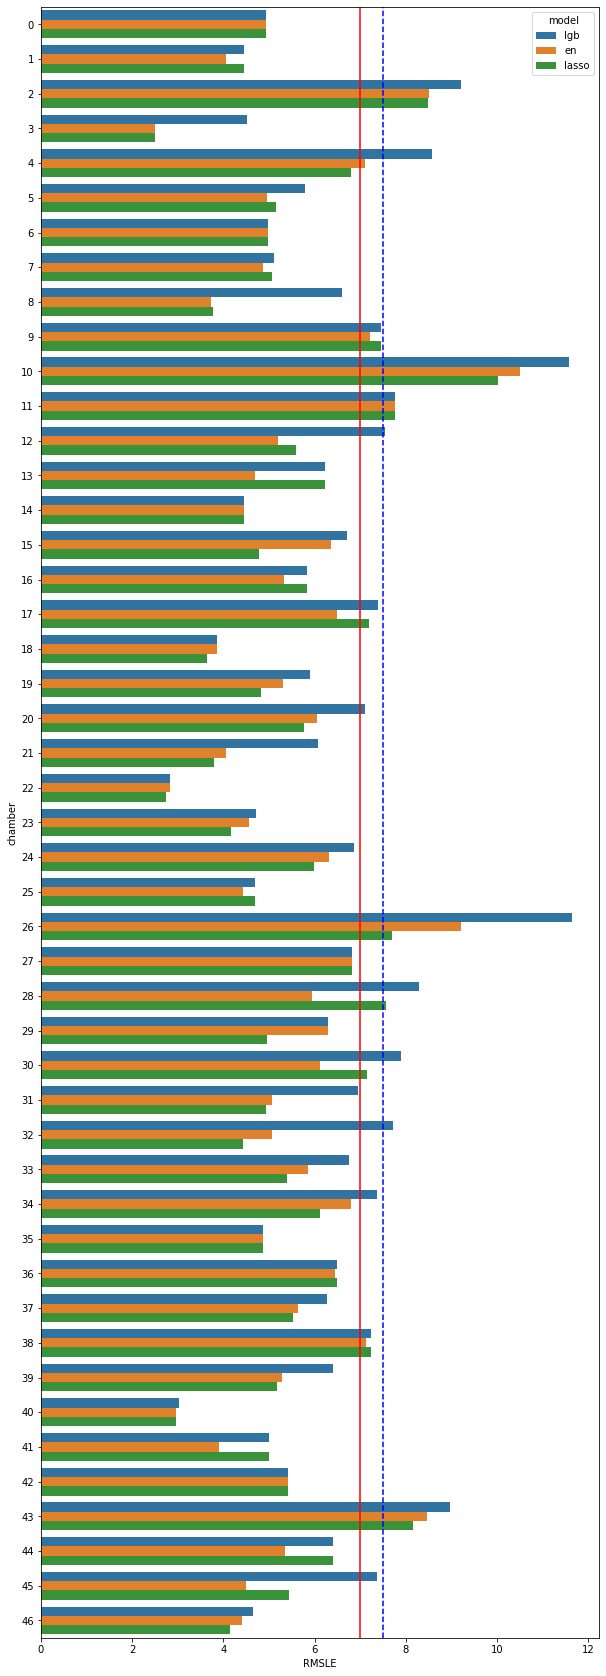

In [81]:
score_df = pd.DataFrame({'model':['lgb']*47 + ['en']*47 + ['lasso']*47,
                         'chamber': list(range(0,47))*3,
                         'RMSLE' : lgb_scores + en_scores + ls_scores})

fig = plt.figure(figsize = (10, 30))
sns.barplot(data = score_df, orient = 'h', x = 'RMSLE', y = 'chamber', hue = 'model')
plt.axvline(7.5, color='b', linestyle='--')
plt.axvline(7.0, color='r')

In [83]:
score_df.pivot('chamber', 'model', 'RMSLE')

model           en      lasso        lgb
chamber                                 
0         4.936722   4.936722   4.936724
1         4.051416   4.462187   4.462187
2         8.500838   8.496759   9.208819
3         2.504417   2.508075   4.520839
4         7.100840   6.797192   8.584949
5         4.950177   5.151204   5.800541
6         4.975702   4.975702   4.975700
7         4.876846   5.072998   5.117376
8         3.728284   3.765617   6.606208
9         7.213710   7.467347   7.467347
10       10.499499  10.031668  11.579471
11        7.763639   7.763639   7.763638
12        5.193204   5.585294   7.546907
13        4.695828   6.230152   6.230154
14        4.462297   4.462297   4.462298
15        6.370933   4.784922   6.709325
16        5.325980   5.835218   5.835218
17        6.483262   7.189161   7.400218
18        3.871303   3.638551   3.871302
19        5.311632   4.835847   5.901549
20        6.062899   5.777170   7.113515
21        4.047287   3.790702   6.065887
22        2.820507   2.738171   2.820510
23        4.557739   4.172849   4.722529
24        6.318053   5.980750   6.866789
25        4.437793   4.684720   4.684720
26        9.203286   7.694972  11.653787
27        6.813963   6.813963   6.813962
28        5.949987   7.556083   8.280195
29        6.299305   4.954780   6.299305
30        6.117105   7.155526   7.901113
31        5.065386   4.931362   6.947034
32        5.072778   4.428602   7.729143
33        5.849377   5.386688   6.749840
34        6.795040   6.110119   7.371850
35        4.860599   4.860599   4.860599
36        6.447503   6.499329   6.499329
37        5.637593   5.527557   6.282782
38        7.131001   7.248008   7.248005
39        5.277315   5.178920   6.411428
40        2.952497   2.959736   3.019678
41        3.904325   5.000213   5.000213
42        5.421195   5.421195   5.421196
43        8.461997   8.152268   8.973604
44        5.351147   6.394960   6.394960
45        4.498417   5.429471   7.375508
46        4.418594   4.149453   4.652446

In [84]:
# (건물 별 모델 cv score 의 pivot_q quantile 값*threshold) 보다 작은 cv score를 가진 모델만 건물별로 선택
def good_models(score_df, pivot_q, threshold):
    score_pivot = pd.DataFrame(score_df.pivot('chamber', 'model', 'RMSLE').values,
                               columns = ['en','lasso','lgb'])
    li = []
    for i in range(len(score_pivot)):
        temp = score_pivot.iloc[i]
        q = temp.quantile(pivot_q)
        best = list(temp[temp <= threshold*q].index)
        li.append(best)
    return li

In [85]:
bests = good_models(score_df, 0.1, 1.05)
bests

[['en', 'lasso', 'lgb'],
 ['en'],
 ['en', 'lasso'],
 ['en', 'lasso'],
 ['en', 'lasso'],
 ['en', 'lasso'],
 ['en', 'lasso', 'lgb'],
 ['en', 'lasso', 'lgb'],
 ['en', 'lasso'],
 ['en', 'lasso', 'lgb'],
 ['en', 'lasso'],
 ['en', 'lasso', 'lgb'],
 ['en'],
 ['en'],
 ['en', 'lasso', 'lgb'],
 ['lasso'],
 ['en'],
 ['en'],
 ['lasso'],
 ['lasso'],
 ['en', 'lasso'],
 ['lasso'],
 ['en', 'lasso', 'lgb'],
 ['lasso'],
 ['en', 'lasso'],
 ['en', 'lasso', 'lgb'],
 ['lasso'],
 ['en', 'lasso', 'lgb'],
 ['en'],
 ['lasso'],
 ['en'],
 ['en', 'lasso'],
 ['lasso'],
 ['lasso'],
 ['lasso'],
 ['en', 'lasso', 'lgb'],
 ['en', 'lasso', 'lgb'],
 ['en', 'lasso'],
 ['en', 'lasso', 'lgb'],
 ['en', 'lasso'],
 ['en', 'lasso', 'lgb'],
 ['en'],
 ['en', 'lasso', 'lgb'],
 ['en', 'lasso'],
 ['en'],
 ['en'],
 ['lasso']]

In [87]:
# voting ensemble training & inference
bests = good_models(score_df, 0.1, 1.05)
voting_pred = []
for i, (X_test, num_f, best, l,e,ls) in enumerate(zip(df_predicts, num_features_lst, bests, lgbs, ens, lss)):
    pred = []
#     if 'cat' in best:
#         cat = c
#         pred.append(cat.predict(X_test[num_f]))
    if 'lgb' in best:
        lgb = l
        pred.append(lgb.predict(X_test[num_f]))
    if 'en' in best:
        en = e
        en_pred = en.predict(X_test[num_f])
        pred.append(en_pred)
    if 'lasso' in best:
        lasso = ls
        ls_pred = lasso.predict(X_test[num_f])
        pred.append(ls_pred)
#     if 'ridge' in best:
#         rid = r
#         rid_pred = rid.predict(X_test[num_f])
#         if (rid_pred < 7.0).sum()<1:
#             pred.append(rid_pred)
#     if 'br' in best:
#         bayer = br
#         bayer_pred = bayer.predict(X_test[num_f])
#         if (bayer_pred < 7.0).sum()<1:
#             pred.append(bayer_pred)
#     if 'rf' in best:
#         randomf_ = randomf
#         pred.append(randomf_.predict(X_test[num_f]))
#     if 'ngb' in best:
#         ngb = ng
#         pred.append(ngb.predict(X_test[num_f]))
#     if 'xgb' in best:
#         xgb = xg
#         pred.append(xgb.predict(X_test[num_f]))
    
    voting_pred.append(np.array(pred).mean(axis = 0))

    print (f'model{i+1} prediction complete')
voting_pred = np.concatenate(voting_pred)

model1 prediction complete
model2 prediction complete
model3 prediction complete
model4 prediction complete
model5 prediction complete
model6 prediction complete
model7 prediction complete
model8 prediction complete
model9 prediction complete
model10 prediction complete
model11 prediction complete
model12 prediction complete
model13 prediction complete
model14 prediction complete
model15 prediction complete
model16 prediction complete
model17 prediction complete
model18 prediction complete
model19 prediction complete
model20 prediction complete
model21 prediction complete
model22 prediction complete
model23 prediction complete
model24 prediction complete
model25 prediction complete
model26 prediction complete
model27 prediction complete
model28 prediction complete
model29 prediction complete
model30 prediction complete
model31 prediction complete
model32 prediction complete
model33 prediction complete
model34 prediction complete
model35 prediction complete
model36 prediction complete
m

In [88]:
pred

[array([1234.58904139, 1257.20872915, 1255.44518403, 1258.49041435])]

In [89]:
voting_pred

array([1256.80545295, 1256.80545295, 1256.80545295, 1256.80545295,
       1256.80545295, 1265.34175192, 1262.92626519, 1263.20672576,
       1262.32804518, 1262.13485039, 1261.56837292, 1261.25827892,
       1261.25497602, 1263.84881975, 1262.89934098, 1253.88049954,
       1255.10252638, 1255.8701525 , 1261.03679191, 1269.44982619,
       1251.24990723, 1253.17403804, 1251.17842154, 1246.46630158,
       1253.27692238, 1248.67265446, 1263.53332795, 1262.32263319,
        772.54819055,  771.5521687 ,  773.1152823 ,  769.45146929,
       1268.64352859, 1268.48271166, 1267.06165094, 1265.07975572,
       1265.96819107, 1266.11450973, 1259.93744749, 1259.93744749,
       1259.93744749, 1259.93744749, 1259.93744749, 1259.93744749,
       1262.52021103, 1262.5064893 , 1262.11654047, 1261.16271029,
       1262.6935159 , 1138.48143921, 1142.2562611 , 1207.92195384,
       1207.58132481, 1201.4463232 , 1203.94389931, 1214.53864293,
       1213.79557489, 1266.30488726, 1266.56553198, 1264.88901

In [39]:
predict['msure_val'] = voting_pred
df_submission = predict[['key_val','msure_val']]
# 예측 파일을 저장합니다. 
# 제출용 파일 이름은 cds_submission_팀명_차수.csv 형태로 제출합니다.
df_submission.set_index('key_val', inplace=True)
df_submission.to_csv('cds_submission_데이터조무사_35.csv')

In [69]:
df_submission.iloc[19:25]

msure_val
key_val               
LOT227_19  1268.594991
LOT114_16  1269.167986
LOT122_21  1269.523309
LOT101_17  1269.657628
LOT44_20   1269.712955
LOT112_11  1269.991225

In [68]:
df_predicts[3]

key_val  04_efem_para2  04_efem_para25  04_efem_para78  04_fr_para28  \
19  LOT227_19       1628.688        1635.438        5.624026     -2999.000   
20  LOT114_16       1626.812        1634.500        5.176954     -2999.000   
21  LOT122_21       1626.812        1636.375        5.100289     -2999.000   
22  LOT101_17       1626.812        1634.500        5.120289     -2999.000   
23   LOT44_20       1626.727        1635.636        5.061287     -2999.000   
24  LOT112_11       1626.812        1638.250        5.121539     -2998.966   
25  LOT112_20       1624.968        1633.774        5.144388     -2999.143   

    04_gas_para21  04_gas_para26  04_gas_para36  04_gas_para51  04_gas_para52  \
19       2.238333       30.07000       2.320000            8.1       24.96333   
20       2.232667       30.07000       2.307667            8.5       24.96000   
21       2.229333       30.06333       2.311000            8.9       24.96667   
22       2.224333       30.07333       2.311667            8.9       24.95333   
23       2.224839       30.06452       2.310645            8.9       24.97419   
24       2.218667       30.06333       2.308000            9.0       24.97000   
25       2.216552       30.06897       2.310000            9.0       24.97241   

    04_gas_para59  04_gas_para6  04_gas_para71  04_gas_para73  04_gas_para74  \
19       0.000000      2.611333       0.000000       44.89667       50.10000   
20       0.000000      2.608333      -0.003125       44.89667       50.09687   
21       0.000000      2.594333       0.000000       44.90000       50.09063   
22       0.000000      2.594333       0.000000       44.90000       50.09687   
23       0.000000      2.594516       0.000000       44.87097       50.09091   
24       0.000000      2.584333      -0.003125       44.89667       50.09063   
25       0.032258      2.578965       0.000000       44.89310       50.08387   

    04_gas_para85  04_he_para22  04_he_para88  04_hv_para3  04_hv_para45  \
19       70.30000      0.400000      0.948000          0.0           0.0   
20       70.28750      0.593333      0.628000          0.0           0.0   
21       70.29375      0.576667      0.652000          0.0           0.0   
22       70.29688      0.600000      0.708000          0.0           0.0   
23       70.29091      0.600000      0.719231          0.0           0.0   
24       70.30000      0.586667      0.748000          0.0           0.0   
25       70.29355      0.582759      0.816667          0.0           0.0   

    04_hv_para47  04_hv_para56  04_position_para72  04_power_para76  \
19           0.0           0.0            6.813334         1112.200   
20           0.0           0.0            6.824138         1117.172   
21           0.0           0.0            6.834483         1116.241   
22           0.0           0.0            6.834483         1115.966   
23           0.0           0.0            6.840000         1115.667   
24           0.0           0.0            6.831035         1116.103   
25           0.0           0.0            6.828571         1116.036   

    04_pressure_para91  04_temp_para11  04_temp_para12  04_temp_para17  \
19            45.01667        0.578750        24.80000        0.000000   
20            44.99310        0.579688        24.79062        0.000000   
21            44.99655        0.579063        24.77500        0.000000   
22            45.01035        0.579688        24.76562        0.000000   
23            45.01000        0.581212        24.77879       -0.030303   
24            45.02069        0.578438        24.78437       -0.065625   
25            45.02143        0.579032        24.75161       -0.067742   

    04_temp_para18  04_temp_para20  04_temp_para23  04_temp_para32  \
19        14.80000        31.18750        150.0969        19.98125   
20        14.80000        32.50000        150.1406        19.98438   
21        15.00625        32.37500        150.1406        19.97500   
22        14.80000        32.40625      

# Feature Selection

In [43]:
pip install --user probatus

Note: you may need to restart the kernel to use updated packages.


In [44]:
from probatus.feature_elimination import EarlyStoppingShapRFECV

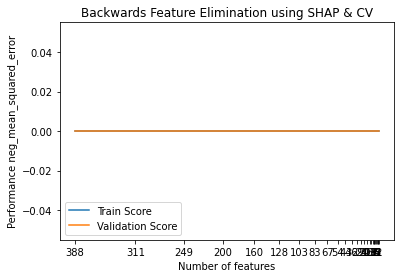

In [50]:
# Run feature elimination
shap_elimination = EarlyStoppingShapRFECV(
    clf=lgbs[3], step=0.2, cv=10, scoring='neg_mean_squared_error', early_stopping_rounds=15, n_jobs=-1, eval_metric='rmse')
report = shap_elimination.fit_compute(df_trains[3][num_features_lst[3]], np.log1p(df_trains[3]['y']), feature_perturbation="tree_path_dependent")

# Make plots
performance_plot = shap_elimination.plot()

In [51]:
report

num_features                                       features_set  \
1            388  [04_efem_para2, 04_efem_para25, 04_efem_para78...   
2            311  [12_gas_para36, 13_time_para83, 12_date_sin, 1...   
3            249  [12_gas_para36, 13_time_para83, 12_date_sin, 1...   
4            200  [20_time_para16, 12_gas_para36, 17_gas_para21,...   
5            160  [20_time_para16, 12_gas_para36, 17_gas_para21,...   
6            128  [20_time_para16, 12_gas_para36, 17_gas_para21,...   
7            103  [20_time_para16, 12_gas_para36, 17_gas_para21,...   
8             83  [20_time_para16, 12_gas_para36, 17_gas_para21,...   
9             67  [20_time_para16, 12_gas_para36, 17_gas_para21,...   
10            54  [20_time_para16, 12_gas_para36, 17_gas_para21,...   
11            44  [20_time_para16, 12_gas_para36, 20_he_para22, ...   
12            36  [20_time_para16, 12_gas_para36, 20_he_para22, ...   
13            29  [20_time_para16, 12_gas_para36, 20_he_para22, ...   
14            24  [20_time_para16, 12_gas_para36, 13_time_para83...   
15            20  [20_time_para16, 12_gas_para36, 04_temp_para87...   
16            16  [20_time_para16, 12_gas_para36, 13_efem_para2,...   
17            13  [20_time_para16, 12_gas_para36, 06_temp_para38...   
18            11  [20_time_para16, 12_gas_para36, 13_hour_cos, 1...   
19             9  [20_time_para16, 12_gas_para36, 13_hour_cos, 1...   
20             8  [20_time_para16, 12_gas_para36, 13_hour_cos, 1...   
21             7  [20_time_para16, 12_gas_para36, 13_hour_cos, 1...   
22             6  [20_time_para16, 12_gas_para36, 13_hour_cos, 1...   
23             5  [20_time_para16, 12_gas_para36, 13_hour_cos, 1...   
24             4  [20_time_para16, 12_gas_para36, 13_hour_cos, 1...   
25             3       [20_time_para16, 12_gas_para36, 13_hour_cos]   
26             2                    [20_time_para16, 12_gas_para36]   
27             1                                   [20_time_para16]   

                                  eliminated_features  train_metric_mean  \
1   [12_time_para16, 13_temp_para58, 12_fr_para28,...               -0.0   
2   [13_date_sin, 13_he_para88, 20_temp_para20, 06...               -0.0   
3   [13_temp_para53, 06_temp_para32, 18_efem_para7...               -0.0   
4   [12_fr_para35, gen_tmdiff, 04_time_para64, 13_...               -0.0   
5   [12_temp_para60, 20_temp_para60, 04_temp_para6...               -0.0   
6   [04_position_para72, 13_gas_para26, 06_date_co...               -0.0   
7   [17_temp_para60, 18_gas_para36, 12_temp_para11...               -0.0   
8   [20_power_para76, 13_gas_para46, 20_gas_para26...               -0.0   
9   [18_power_para14, 13_weekday_sin, 04_power_par...               -0.0   
10  [06_gas_para73, 13_temp_para18, 17_hv_para47, ...               -0.0   
11  [17_gas_para52, 06_epd_para40, 18_date_sin, 18...               -0.0   
12  [13_hv_para3, 12_date_sin, 17_efem_para78, 18_...               -0.0   
13  [06_temp_para86, 06_temp_para17, 17_gas_para21...               -0.0   
14  [06_time_para16, 04_hv_para47, 13_time_para83,...               -0.0   
15  [04_time_para16, 12_temp_para20, 04_temp_para8...               -0.0   
16   [12_temp_para86, 06_temp_para60, 12_temp_para32]               -0.0   
17                  [18_power_para82, 18_temp_para20]               -0.0   
18                      [04_hour_sin, 12_time_para90]               -0.0   
19                                      [18_date_cos]               -0.0   
20                                   [04_temp_para20]               -0.0   
21                                    [04_gas_para85]               -0.0   
22                                   [06_temp_para38]               -0.0   
23                                    [13_efem_para2]               -0.0   
24                                    [18_gas_para27]               -0.0   
25                                      [13_hour_cos]               -0.0   
26                                    [

In [52]:
# Get final feature set
''' num_features는 마지막에 남길 feature 수임. '''
final_features_set = shap_elimination.get_reduced_features_set(num_features=128)
final_features_set

['20_time_para16',
 '12_gas_para36',
 '17_gas_para21',
 '13_time_para83',
 '06_temp_para86',
 '12_date_sin',
 '17_efem_para78',
 '17_gas_para52',
 '06_epd_para40',
 '18_date_sin',
 '18_power_para14',
 '04_power_para76',
 '18_temp_para65',
 '13_temp_para86',
 '06_gas_para26',
 '12_gas_para74',
 '17_efem_para2',
 '06_time_para67',
 'gen_tmdiff_1820',
 '12_tmp_para31',
 '13_gas_para36',
 '04_temp_para55',
 'gen_tmdiff_1718',
 '17_hv_para45',
 '17_date_cos',
 '17_time_para37',
 '18_temp_para11',
 '12_temp_para79',
 '17_gas_para6',
 '18_gas_para6',
 '18_temp_para24',
 'gen_tmdiff_0612',
 '13_temp_para92',
 '17_temp_para24',
 '06_temp_para23',
 'gen_tmdiff_0406',
 '12_time_para5',
 '20_temp_para17',
 '20_hour_sin',
 '04_fr_para28',
 '18_efem_para2',
 '04_gas_para71',
 '04_temp_para66',
 '18_hour_sin',
 '18_he_para88',
 '20_gas_para59',
 '17_fr_para61',
 '12_time_para37',
 '20_gas_para50',
 '13_temp_para32',
 '17_tmp_para31',
 '18_hv_para47',
 '18_gas_para48',
 '13_temp_para24',
 '12_he_para2

The provided number of features has not been achieved at any stage of the process. You can select one of the following: [402, 322, 258, 207, 166, 133, 107, 86, 69, 56, 45, 36, 29, 24, 20, 16, 13, 11, 9, 8, 7, 6, 5, 4, 3, 2, 1]

In [ ]:
final_features_set

# 예측 결과 제출